In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, AlphaDropout, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Directorios de los datasets
train_dir = "../datos/train"
val_dir = "../datos/val"
test_dir = "../datos/test"

In [3]:
# Parámetros
img_size = (224, 224)
batch_size = 8
num_classes = 4  # Normal, Pólipos, Úlcera, Esophagitis

datagen_train = ImageDataGenerator(
    #Normalización y preprocesado
    preprocessing_function=preprocess_input,
    #Transformaciones geométricas
    rotation_range=45,  # Rotación de hasta 45 grados
    width_shift_range=0.2,  # Desplazamiento horizontal del 10%
    height_shift_range=0.2,  # Desplazamiento vertical del 10%
    shear_range=0.3,  # Transformación de cizallamiento del 10%
    zoom_range=0.3,  # Zoom de hasta un 10%
    horizontal_flip=True,  # Volteo horizontal
    vertical_flip=True,  # Volteo vertical
    fill_mode='constant',  # Relleno con valores constantes
    channel_shift_range=50.0,  # Cambios fuertes en el color
    # Transformaciones de color e intensidad
    brightness_range=[0.05, 1.5],  # Ajuste de brillo entre 0.1 y 1.0
)
#evitamos el sobreajuste
datagen_val_test = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical' #salida formato one_hot encoding ya que hay mas de 2 clases
)

val_generator = datagen_val_test.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    seed=42,
    class_mode='categorical', #salida formato one_hot encoding ya que hay mas de 2 clases
    shuffle=False
)

Found 3200 images belonging to 4 classes.


Found 2000 images belonging to 4 classes.


Found 800 images belonging to 4 classes.


In [4]:
# Cargar modelo preentrenado EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Permite entrenar todas las capas

In [5]:
# Construcción del modelo
x = base_model.layers[-17].output #Equivalent to one (1) CORE block deduction.
# Capa convolucional
x = Conv2D(filters=192, kernel_size=1, strides=1, padding='valid',
           activation='selu', kernel_initializer='lecun_normal')(x)

# Capa de Average Pooling 
x = AveragePooling2D(pool_size=1, strides=1, padding='valid')(x)

# Global Average Pooling para reducir dimensiones antes de la capa densa
x = GlobalAveragePooling2D()(x)

# Capa fully connected
x = Dense(512, activation='selu', kernel_initializer='lecun_normal')(x)  # 512 neuronas

# Dropout ajustado 
x = AlphaDropout(0.3)(x)  # Reducimos sobreajuste apagando el 20% de las neuronas

# Capa de salida con 4 clases y activación softmax
outputs = Dense(num_classes, activation='softmax')(x)

# Creación del modelo
model = Model(inputs=base_model.input, outputs=outputs)

In [6]:
model.summary()

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               


                                )]                                                                


 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                


 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              


 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']          


 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['rescaling_1[0][0]']            


 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['stem_conv_pad[0][0]']          


                                )                                                                 


 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              


                                )                                                                 


 stem_activation (Activation)   (None, 112, 112, 32  0           ['stem_bn[0][0]']                


                                )                                                                 


 block1a_dwconv (DepthwiseConv2  (None, 112, 112, 32  288        ['stem_activation[0][0]']        


 D)                             )                                                                 


 block1a_bn (BatchNormalization  (None, 112, 112, 32  128        ['block1a_dwconv[0][0]']         


 )                              )                                                                 


 block1a_activation (Activation  (None, 112, 112, 32  0          ['block1a_bn[0][0]']             


 )                              )                                                                 


 block1a_se_squeeze (GlobalAver  (None, 32)          0           ['block1a_activation[0][0]']     


 agePooling2D)                                                                                    


 block1a_se_reshape (Reshape)   (None, 1, 1, 32)     0           ['block1a_se_squeeze[0][0]']     


 block1a_se_reduce (Conv2D)     (None, 1, 1, 8)      264         ['block1a_se_reshape[0][0]']     


 block1a_se_expand (Conv2D)     (None, 1, 1, 32)     288         ['block1a_se_reduce[0][0]']      


 block1a_se_excite (Multiply)   (None, 112, 112, 32  0           ['block1a_activation[0][0]',     


                                )                                 'block1a_se_expand[0][0]']      


 block1a_project_conv (Conv2D)  (None, 112, 112, 16  512         ['block1a_se_excite[0][0]']      


                                )                                                                 


 block1a_project_bn (BatchNorma  (None, 112, 112, 16  64         ['block1a_project_conv[0][0]']   


 lization)                      )                                                                 


 block2a_expand_conv (Conv2D)   (None, 112, 112, 96  1536        ['block1a_project_bn[0][0]']     


                                )                                                                 


 block2a_expand_bn (BatchNormal  (None, 112, 112, 96  384        ['block2a_expand_conv[0][0]']    


 ization)                       )                                                                 


 block2a_expand_activation (Act  (None, 112, 112, 96  0          ['block2a_expand_bn[0][0]']      


 ivation)                       )                                                                 


 block2a_dwconv_pad (ZeroPaddin  (None, 113, 113, 96  0          ['block2a_expand_activation[0][0]


 g2D)                           )                                ']                               


 block2a_dwconv (DepthwiseConv2  (None, 56, 56, 96)  864         ['block2a_dwconv_pad[0][0]']     


 D)                                                                                               


 block2a_bn (BatchNormalization  (None, 56, 56, 96)  384         ['block2a_dwconv[0][0]']         


 )                                                                                                


 block2a_activation (Activation  (None, 56, 56, 96)  0           ['block2a_bn[0][0]']             


 )                                                                                                


 block2a_se_squeeze (GlobalAver  (None, 96)          0           ['block2a_activation[0][0]']     


 agePooling2D)                                                                                    


 block2a_se_reshape (Reshape)   (None, 1, 1, 96)     0           ['block2a_se_squeeze[0][0]']     


 block2a_se_reduce (Conv2D)     (None, 1, 1, 4)      388         ['block2a_se_reshape[0][0]']     


 block2a_se_expand (Conv2D)     (None, 1, 1, 96)     480         ['block2a_se_reduce[0][0]']      


 block2a_se_excite (Multiply)   (None, 56, 56, 96)   0           ['block2a_activation[0][0]',     


                                                                  'block2a_se_expand[0][0]']      


 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      


 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   


 lization)                                                                                        


 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     


 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    


 ization)                                                                                         


 block2b_expand_activation (Act  (None, 56, 56, 144)  0          ['block2b_expand_bn[0][0]']      


 ivation)                                                                                         


 block2b_dwconv (DepthwiseConv2  (None, 56, 56, 144)  1296       ['block2b_expand_activation[0][0]


 D)                                                              ']                               


 block2b_bn (BatchNormalization  (None, 56, 56, 144)  576        ['block2b_dwconv[0][0]']         


 )                                                                                                


 block2b_activation (Activation  (None, 56, 56, 144)  0          ['block2b_bn[0][0]']             


 )                                                                                                


 block2b_se_squeeze (GlobalAver  (None, 144)         0           ['block2b_activation[0][0]']     


 agePooling2D)                                                                                    


 block2b_se_reshape (Reshape)   (None, 1, 1, 144)    0           ['block2b_se_squeeze[0][0]']     


 block2b_se_reduce (Conv2D)     (None, 1, 1, 6)      870         ['block2b_se_reshape[0][0]']     


 block2b_se_expand (Conv2D)     (None, 1, 1, 144)    1008        ['block2b_se_reduce[0][0]']      


 block2b_se_excite (Multiply)   (None, 56, 56, 144)  0           ['block2b_activation[0][0]',     


                                                                  'block2b_se_expand[0][0]']      


 block2b_project_conv (Conv2D)  (None, 56, 56, 24)   3456        ['block2b_se_excite[0][0]']      


 block2b_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2b_project_conv[0][0]']   


 lization)                                                                                        


 block2b_drop (Dropout)         (None, 56, 56, 24)   0           ['block2b_project_bn[0][0]']     


 block2b_add (Add)              (None, 56, 56, 24)   0           ['block2b_drop[0][0]',           


                                                                  'block2a_project_bn[0][0]']     


 block3a_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2b_add[0][0]']            


 block3a_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block3a_expand_conv[0][0]']    


 ization)                                                                                         


 block3a_expand_activation (Act  (None, 56, 56, 144)  0          ['block3a_expand_bn[0][0]']      


 ivation)                                                                                         


 block3a_dwconv_pad (ZeroPaddin  (None, 59, 59, 144)  0          ['block3a_expand_activation[0][0]


 g2D)                                                            ']                               


 block3a_dwconv (DepthwiseConv2  (None, 28, 28, 144)  3600       ['block3a_dwconv_pad[0][0]']     


 D)                                                                                               


 block3a_bn (BatchNormalization  (None, 28, 28, 144)  576        ['block3a_dwconv[0][0]']         


 )                                                                                                


 block3a_activation (Activation  (None, 28, 28, 144)  0          ['block3a_bn[0][0]']             


 )                                                                                                


 block3a_se_squeeze (GlobalAver  (None, 144)         0           ['block3a_activation[0][0]']     


 agePooling2D)                                                                                    


 block3a_se_reshape (Reshape)   (None, 1, 1, 144)    0           ['block3a_se_squeeze[0][0]']     


 block3a_se_reduce (Conv2D)     (None, 1, 1, 6)      870         ['block3a_se_reshape[0][0]']     


 block3a_se_expand (Conv2D)     (None, 1, 1, 144)    1008        ['block3a_se_reduce[0][0]']      


 block3a_se_excite (Multiply)   (None, 28, 28, 144)  0           ['block3a_activation[0][0]',     


                                                                  'block3a_se_expand[0][0]']      


 block3a_project_conv (Conv2D)  (None, 28, 28, 40)   5760        ['block3a_se_excite[0][0]']      


 block3a_project_bn (BatchNorma  (None, 28, 28, 40)  160         ['block3a_project_conv[0][0]']   


 lization)                                                                                        


 block3b_expand_conv (Conv2D)   (None, 28, 28, 240)  9600        ['block3a_project_bn[0][0]']     


 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    


 ization)                                                                                         


 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      


 ivation)                                                                                         


 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]


 D)                                                              ']                               


 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         


 )                                                                                                


 block3b_activation (Activation  (None, 28, 28, 240)  0          ['block3b_bn[0][0]']             


 )                                                                                                


 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     


 agePooling2D)                                                                                    


 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     


 block3b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3b_se_reshape[0][0]']     


 block3b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block3b_se_reduce[0][0]']      


 block3b_se_excite (Multiply)   (None, 28, 28, 240)  0           ['block3b_activation[0][0]',     


                                                                  'block3b_se_expand[0][0]']      


 block3b_project_conv (Conv2D)  (None, 28, 28, 40)   9600        ['block3b_se_excite[0][0]']      


 block3b_project_bn (BatchNorma  (None, 28, 28, 40)  160         ['block3b_project_conv[0][0]']   


 lization)                                                                                        


 block3b_drop (Dropout)         (None, 28, 28, 40)   0           ['block3b_project_bn[0][0]']     


 block3b_add (Add)              (None, 28, 28, 40)   0           ['block3b_drop[0][0]',           


                                                                  'block3a_project_bn[0][0]']     


 block4a_expand_conv (Conv2D)   (None, 28, 28, 240)  9600        ['block3b_add[0][0]']            


 block4a_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block4a_expand_conv[0][0]']    


 ization)                                                                                         


 block4a_expand_activation (Act  (None, 28, 28, 240)  0          ['block4a_expand_bn[0][0]']      


 ivation)                                                                                         


 block4a_dwconv_pad (ZeroPaddin  (None, 29, 29, 240)  0          ['block4a_expand_activation[0][0]


 g2D)                                                            ']                               


 block4a_dwconv (DepthwiseConv2  (None, 14, 14, 240)  2160       ['block4a_dwconv_pad[0][0]']     


 D)                                                                                               


 block4a_bn (BatchNormalization  (None, 14, 14, 240)  960        ['block4a_dwconv[0][0]']         


 )                                                                                                


 block4a_activation (Activation  (None, 14, 14, 240)  0          ['block4a_bn[0][0]']             


 )                                                                                                


 block4a_se_squeeze (GlobalAver  (None, 240)         0           ['block4a_activation[0][0]']     


 agePooling2D)                                                                                    


 block4a_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block4a_se_squeeze[0][0]']     


 block4a_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block4a_se_reshape[0][0]']     


 block4a_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block4a_se_reduce[0][0]']      


 block4a_se_excite (Multiply)   (None, 14, 14, 240)  0           ['block4a_activation[0][0]',     


                                                                  'block4a_se_expand[0][0]']      


 block4a_project_conv (Conv2D)  (None, 14, 14, 80)   19200       ['block4a_se_excite[0][0]']      


 block4a_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4a_project_conv[0][0]']   


 lization)                                                                                        


 block4b_expand_conv (Conv2D)   (None, 14, 14, 480)  38400       ['block4a_project_bn[0][0]']     


 block4b_expand_bn (BatchNormal  (None, 14, 14, 480)  1920       ['block4b_expand_conv[0][0]']    


 ization)                                                                                         


 block4b_expand_activation (Act  (None, 14, 14, 480)  0          ['block4b_expand_bn[0][0]']      


 ivation)                                                                                         


 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]


 D)                                                              ']                               


 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         


 )                                                                                                


 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             


 )                                                                                                


 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     


 agePooling2D)                                                                                    


 block4b_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4b_se_squeeze[0][0]']     


 block4b_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4b_se_reshape[0][0]']     


 block4b_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4b_se_reduce[0][0]']      


 block4b_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block4b_activation[0][0]',     


                                                                  'block4b_se_expand[0][0]']      


 block4b_project_conv (Conv2D)  (None, 14, 14, 80)   38400       ['block4b_se_excite[0][0]']      


 block4b_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4b_project_conv[0][0]']   


 lization)                                                                                        


 block4b_drop (Dropout)         (None, 14, 14, 80)   0           ['block4b_project_bn[0][0]']     


 block4b_add (Add)              (None, 14, 14, 80)   0           ['block4b_drop[0][0]',           


                                                                  'block4a_project_bn[0][0]']     


 block4c_expand_conv (Conv2D)   (None, 14, 14, 480)  38400       ['block4b_add[0][0]']            


 block4c_expand_bn (BatchNormal  (None, 14, 14, 480)  1920       ['block4c_expand_conv[0][0]']    


 ization)                                                                                         


 block4c_expand_activation (Act  (None, 14, 14, 480)  0          ['block4c_expand_bn[0][0]']      


 ivation)                                                                                         


 block4c_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4c_expand_activation[0][0]


 D)                                                              ']                               


 block4c_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4c_dwconv[0][0]']         


 )                                                                                                


 block4c_activation (Activation  (None, 14, 14, 480)  0          ['block4c_bn[0][0]']             


 )                                                                                                


 block4c_se_squeeze (GlobalAver  (None, 480)         0           ['block4c_activation[0][0]']     


 agePooling2D)                                                                                    


 block4c_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block4c_se_squeeze[0][0]']     


 block4c_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block4c_se_reshape[0][0]']     


 block4c_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4c_se_reduce[0][0]']      


 block4c_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block4c_activation[0][0]',     


                                                                  'block4c_se_expand[0][0]']      


 block4c_project_conv (Conv2D)  (None, 14, 14, 80)   38400       ['block4c_se_excite[0][0]']      


 block4c_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4c_project_conv[0][0]']   


 lization)                                                                                        


 block4c_drop (Dropout)         (None, 14, 14, 80)   0           ['block4c_project_bn[0][0]']     


 block4c_add (Add)              (None, 14, 14, 80)   0           ['block4c_drop[0][0]',           


                                                                  'block4b_add[0][0]']            


 block5a_expand_conv (Conv2D)   (None, 14, 14, 480)  38400       ['block4c_add[0][0]']            


 block5a_expand_bn (BatchNormal  (None, 14, 14, 480)  1920       ['block5a_expand_conv[0][0]']    


 ization)                                                                                         


 block5a_expand_activation (Act  (None, 14, 14, 480)  0          ['block5a_expand_bn[0][0]']      


 ivation)                                                                                         


 block5a_dwconv (DepthwiseConv2  (None, 14, 14, 480)  12000      ['block5a_expand_activation[0][0]


 D)                                                              ']                               


 block5a_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block5a_dwconv[0][0]']         


 )                                                                                                


 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             


 )                                                                                                


 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     


 agePooling2D)                                                                                    


 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     


 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     


 block5a_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block5a_se_reduce[0][0]']      


 block5a_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block5a_activation[0][0]',     


                                                                  'block5a_se_expand[0][0]']      


 block5a_project_conv (Conv2D)  (None, 14, 14, 112)  53760       ['block5a_se_excite[0][0]']      


 block5a_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5a_project_conv[0][0]']   


 lization)                                                                                        


 block5b_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5a_project_bn[0][0]']     


 block5b_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5b_expand_conv[0][0]']    


 ization)                                                                                         


 block5b_expand_activation (Act  (None, 14, 14, 672)  0          ['block5b_expand_bn[0][0]']      


 ivation)                                                                                         


 block5b_dwconv (DepthwiseConv2  (None, 14, 14, 672)  16800      ['block5b_expand_activation[0][0]


 D)                                                              ']                               


 block5b_bn (BatchNormalization  (None, 14, 14, 672)  2688       ['block5b_dwconv[0][0]']         


 )                                                                                                


 block5b_activation (Activation  (None, 14, 14, 672)  0          ['block5b_bn[0][0]']             


 )                                                                                                


 block5b_se_squeeze (GlobalAver  (None, 672)         0           ['block5b_activation[0][0]']     


 agePooling2D)                                                                                    


 block5b_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5b_se_squeeze[0][0]']     


 block5b_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5b_se_reshape[0][0]']     


 block5b_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5b_se_reduce[0][0]']      


 block5b_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5b_activation[0][0]',     


                                                                  'block5b_se_expand[0][0]']      


 block5b_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5b_se_excite[0][0]']      


 block5b_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5b_project_conv[0][0]']   


 lization)                                                                                        


 block5b_drop (Dropout)         (None, 14, 14, 112)  0           ['block5b_project_bn[0][0]']     


 block5b_add (Add)              (None, 14, 14, 112)  0           ['block5b_drop[0][0]',           


                                                                  'block5a_project_bn[0][0]']     


 block5c_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5b_add[0][0]']            


 block5c_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5c_expand_conv[0][0]']    


 ization)                                                                                         


 block5c_expand_activation (Act  (None, 14, 14, 672)  0          ['block5c_expand_bn[0][0]']      


 ivation)                                                                                         


 block5c_dwconv (DepthwiseConv2  (None, 14, 14, 672)  16800      ['block5c_expand_activation[0][0]


 D)                                                              ']                               


 block5c_bn (BatchNormalization  (None, 14, 14, 672)  2688       ['block5c_dwconv[0][0]']         


 )                                                                                                


 block5c_activation (Activation  (None, 14, 14, 672)  0          ['block5c_bn[0][0]']             


 )                                                                                                


 block5c_se_squeeze (GlobalAver  (None, 672)         0           ['block5c_activation[0][0]']     


 agePooling2D)                                                                                    


 block5c_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5c_se_squeeze[0][0]']     


 block5c_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5c_se_reshape[0][0]']     


 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      


 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     


                                                                  'block5c_se_expand[0][0]']      


 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      


 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   


 lization)                                                                                        


 block5c_drop (Dropout)         (None, 14, 14, 112)  0           ['block5c_project_bn[0][0]']     


 block5c_add (Add)              (None, 14, 14, 112)  0           ['block5c_drop[0][0]',           


                                                                  'block5b_add[0][0]']            


 block6a_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5c_add[0][0]']            


 block6a_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block6a_expand_conv[0][0]']    


 ization)                                                                                         


 block6a_expand_activation (Act  (None, 14, 14, 672)  0          ['block6a_expand_bn[0][0]']      


 ivation)                                                                                         


 block6a_dwconv_pad (ZeroPaddin  (None, 17, 17, 672)  0          ['block6a_expand_activation[0][0]


 g2D)                                                            ']                               


 block6a_dwconv (DepthwiseConv2  (None, 7, 7, 672)   16800       ['block6a_dwconv_pad[0][0]']     


 D)                                                                                               


 block6a_bn (BatchNormalization  (None, 7, 7, 672)   2688        ['block6a_dwconv[0][0]']         


 )                                                                                                


 block6a_activation (Activation  (None, 7, 7, 672)   0           ['block6a_bn[0][0]']             


 )                                                                                                


 block6a_se_squeeze (GlobalAver  (None, 672)         0           ['block6a_activation[0][0]']     


 agePooling2D)                                                                                    


 block6a_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block6a_se_squeeze[0][0]']     


 block6a_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block6a_se_reshape[0][0]']     


 block6a_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block6a_se_reduce[0][0]']      


 block6a_se_excite (Multiply)   (None, 7, 7, 672)    0           ['block6a_activation[0][0]',     


                                                                  'block6a_se_expand[0][0]']      


 block6a_project_conv (Conv2D)  (None, 7, 7, 192)    129024      ['block6a_se_excite[0][0]']      


 block6a_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6a_project_conv[0][0]']   


 lization)                                                                                        


 block6b_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6a_project_bn[0][0]']     


 block6b_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6b_expand_conv[0][0]']    


 ization)                                                                                         


 block6b_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6b_expand_bn[0][0]']      


 ivation)                                                                                         


 block6b_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  28800       ['block6b_expand_activation[0][0]


 D)                                                              ']                               


 block6b_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6b_dwconv[0][0]']         


 )                                                                                                


 block6b_activation (Activation  (None, 7, 7, 1152)  0           ['block6b_bn[0][0]']             


 )                                                                                                


 block6b_se_squeeze (GlobalAver  (None, 1152)        0           ['block6b_activation[0][0]']     


 agePooling2D)                                                                                    


 block6b_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6b_se_squeeze[0][0]']     


 block6b_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6b_se_reshape[0][0]']     


 block6b_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6b_se_reduce[0][0]']      


 block6b_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6b_activation[0][0]',     


                                                                  'block6b_se_expand[0][0]']      


 block6b_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6b_se_excite[0][0]']      


 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   


 lization)                                                                                        


 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     


 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           


                                                                  'block6a_project_bn[0][0]']     


 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            


 block6c_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6c_expand_conv[0][0]']    


 ization)                                                                                         


 block6c_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6c_expand_bn[0][0]']      


 ivation)                                                                                         


 block6c_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  28800       ['block6c_expand_activation[0][0]


 D)                                                              ']                               


 block6c_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6c_dwconv[0][0]']         


 )                                                                                                


 block6c_activation (Activation  (None, 7, 7, 1152)  0           ['block6c_bn[0][0]']             


 )                                                                                                


 block6c_se_squeeze (GlobalAver  (None, 1152)        0           ['block6c_activation[0][0]']     


 agePooling2D)                                                                                    


 block6c_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6c_se_squeeze[0][0]']     


 block6c_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6c_se_reshape[0][0]']     


 block6c_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6c_se_reduce[0][0]']      


 block6c_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6c_activation[0][0]',     


                                                                  'block6c_se_expand[0][0]']      


 block6c_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6c_se_excite[0][0]']      


 block6c_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6c_project_conv[0][0]']   


 lization)                                                                                        


 block6c_drop (Dropout)         (None, 7, 7, 192)    0           ['block6c_project_bn[0][0]']     


 block6c_add (Add)              (None, 7, 7, 192)    0           ['block6c_drop[0][0]',           


                                                                  'block6b_add[0][0]']            


 block6d_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6c_add[0][0]']            


 block6d_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6d_expand_conv[0][0]']    


 ization)                                                                                         


 block6d_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6d_expand_bn[0][0]']      


 ivation)                                                                                         


 block6d_dwconv (DepthwiseConv2  (None, 7, 7, 1152)  28800       ['block6d_expand_activation[0][0]


 D)                                                              ']                               


 block6d_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6d_dwconv[0][0]']         


 )                                                                                                


 block6d_activation (Activation  (None, 7, 7, 1152)  0           ['block6d_bn[0][0]']             


 )                                                                                                


 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     


 agePooling2D)                                                                                    


 block6d_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6d_se_squeeze[0][0]']     


 block6d_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6d_se_reshape[0][0]']     


 block6d_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6d_se_reduce[0][0]']      


 block6d_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6d_activation[0][0]',     


                                                                  'block6d_se_expand[0][0]']      


 block6d_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6d_se_excite[0][0]']      


 block6d_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6d_project_conv[0][0]']   


 lization)                                                                                        


 block6d_drop (Dropout)         (None, 7, 7, 192)    0           ['block6d_project_bn[0][0]']     


 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           


                                                                  'block6c_add[0][0]']            


 conv2d (Conv2D)                (None, 7, 7, 192)    37056       ['block6d_add[0][0]']            


 average_pooling2d (AveragePool  (None, 7, 7, 192)   0           ['conv2d[0][0]']                 


 ing2D)                                                                                           


 global_average_pooling2d (Glob  (None, 192)         0           ['average_pooling2d[0][0]']      


 alAveragePooling2D)                                                                              


 dense (Dense)                  (None, 512)          98816       ['global_average_pooling2d[0][0]'


                                                                 ]                                


 alpha_dropout (AlphaDropout)   (None, 512)          0           ['dense[0][0]']                  


 dense_1 (Dense)                (None, 4)            2052        ['alpha_dropout[0][0]']          


Total params: 3,050,295


Trainable params: 137,924


Non-trainable params: 2,912,371


__________________________________________________________________________________________________


In [7]:
# Compilación del modelo
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #con funcion de perdida porque es multiclase

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('efficientnetb0_best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1) # Reduce LR si no hay mejora en 2 épocas

In [9]:
# Entrenamiento del modelo
epochs = 500 #puede detenerse antes si no mejora la validacion
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500



  1/400 [..............................] - ETA: 39:40 - loss: 2.3296 - accuracy: 0.2500


  3/400 [..............................] - ETA: 27s - loss: 2.2464 - accuracy: 0.3333  


  4/400 [..............................] - ETA: 32s - loss: 2.3144 - accuracy: 0.2500


  5/400 [..............................] - ETA: 35s - loss: 2.1660 - accuracy: 0.3000


  6/400 [..............................] - ETA: 35s - loss: 2.0979 - accuracy: 0.2917


  7/400 [..............................] - ETA: 37s - loss: 2.1580 - accuracy: 0.2500


  8/400 [..............................] - ETA: 37s - loss: 2.2053 - accuracy: 0.2656


  9/400 [..............................] - ETA: 38s - loss: 2.2388 - accuracy: 0.2639


 10/400 [..............................] - ETA: 38s - loss: 2.3478 - accuracy: 0.2625


 11/400 [..............................] - ETA: 38s - loss: 2.3403 - accuracy: 0.2614


 12/400 [..............................] - ETA: 39s - loss: 2.3971 - accuracy: 0.2500


 13/400 [..............................] - ETA: 39s - loss: 2.3260 - accuracy: 0.2692


 14/400 [>.............................] - ETA: 40s - loss: 2.3464 - accuracy: 0.2679


 15/400 [>.............................] - ETA: 40s - loss: 2.3624 - accuracy: 0.2500


 16/400 [>.............................] - ETA: 40s - loss: 2.3163 - accuracy: 0.2578


 17/400 [>.............................] - ETA: 40s - loss: 2.2932 - accuracy: 0.2500


 18/400 [>.............................] - ETA: 40s - loss: 2.3062 - accuracy: 0.2431


 19/400 [>.............................] - ETA: 41s - loss: 2.4502 - accuracy: 0.2303


 20/400 [>.............................] - ETA: 40s - loss: 2.4549 - accuracy: 0.2313


 21/400 [>.............................] - ETA: 41s - loss: 2.5202 - accuracy: 0.2321


 22/400 [>.............................] - ETA: 41s - loss: 2.5283 - accuracy: 0.2330


 23/400 [>.............................] - ETA: 41s - loss: 2.5282 - accuracy: 0.2283


 24/400 [>.............................] - ETA: 41s - loss: 2.5303 - accuracy: 0.2344


 25/400 [>.............................] - ETA: 41s - loss: 2.5621 - accuracy: 0.2300


 26/400 [>.............................] - ETA: 41s - loss: 2.5321 - accuracy: 0.2356


 27/400 [=>............................] - ETA: 41s - loss: 2.4949 - accuracy: 0.2454


 28/400 [=>............................] - ETA: 41s - loss: 2.4649 - accuracy: 0.2411


 29/400 [=>............................] - ETA: 41s - loss: 2.4795 - accuracy: 0.2414


 30/400 [=>............................] - ETA: 41s - loss: 2.5015 - accuracy: 0.2333


 31/400 [=>............................] - ETA: 41s - loss: 2.4813 - accuracy: 0.2339


 32/400 [=>............................] - ETA: 41s - loss: 2.4656 - accuracy: 0.2344


 33/400 [=>............................] - ETA: 41s - loss: 2.4732 - accuracy: 0.2273


 34/400 [=>............................] - ETA: 41s - loss: 2.4535 - accuracy: 0.2279


 35/400 [=>............................] - ETA: 41s - loss: 2.4486 - accuracy: 0.2214


 36/400 [=>............................] - ETA: 41s - loss: 2.4674 - accuracy: 0.2188


 37/400 [=>............................] - ETA: 41s - loss: 2.4581 - accuracy: 0.2230


 38/400 [=>............................] - ETA: 40s - loss: 2.4532 - accuracy: 0.2237


 39/400 [=>............................] - ETA: 40s - loss: 2.4508 - accuracy: 0.2212


 40/400 [==>...........................] - ETA: 40s - loss: 2.4493 - accuracy: 0.2219


 41/400 [==>...........................] - ETA: 40s - loss: 2.4566 - accuracy: 0.2195


 42/400 [==>...........................] - ETA: 40s - loss: 2.4535 - accuracy: 0.2202


 43/400 [==>...........................] - ETA: 40s - loss: 2.4540 - accuracy: 0.2151


 44/400 [==>...........................] - ETA: 40s - loss: 2.4690 - accuracy: 0.2102


 45/400 [==>...........................] - ETA: 40s - loss: 2.4820 - accuracy: 0.2083


 46/400 [==>...........................] - ETA: 40s - loss: 2.4778 - accuracy: 0.2065


 47/400 [==>...........................] - ETA: 40s - loss: 2.4713 - accuracy: 0.2048


 48/400 [==>...........................] - ETA: 40s - loss: 2.4686 - accuracy: 0.2031


 49/400 [==>...........................] - ETA: 40s - loss: 2.4861 - accuracy: 0.1990


 50/400 [==>...........................] - ETA: 39s - loss: 2.4969 - accuracy: 0.2000


 51/400 [==>...........................] - ETA: 40s - loss: 2.4860 - accuracy: 0.2034


 52/400 [==>...........................] - ETA: 39s - loss: 2.4928 - accuracy: 0.1995


 53/400 [==>...........................] - ETA: 39s - loss: 2.5015 - accuracy: 0.1981


 54/400 [===>..........................] - ETA: 39s - loss: 2.5143 - accuracy: 0.1968


 55/400 [===>..........................] - ETA: 39s - loss: 2.5159 - accuracy: 0.1955


 56/400 [===>..........................] - ETA: 39s - loss: 2.5107 - accuracy: 0.1964


 57/400 [===>..........................] - ETA: 39s - loss: 2.5151 - accuracy: 0.1974


 58/400 [===>..........................] - ETA: 39s - loss: 2.5324 - accuracy: 0.1961


 59/400 [===>..........................] - ETA: 39s - loss: 2.5350 - accuracy: 0.1970


 60/400 [===>..........................] - ETA: 39s - loss: 2.5322 - accuracy: 0.1958


 61/400 [===>..........................] - ETA: 39s - loss: 2.5259 - accuracy: 0.1988


 62/400 [===>..........................] - ETA: 38s - loss: 2.5149 - accuracy: 0.2036


 63/400 [===>..........................] - ETA: 38s - loss: 2.5105 - accuracy: 0.2024


 64/400 [===>..........................] - ETA: 38s - loss: 2.5129 - accuracy: 0.1992


 65/400 [===>..........................] - ETA: 38s - loss: 2.5210 - accuracy: 0.1981


 66/400 [===>..........................] - ETA: 38s - loss: 2.5163 - accuracy: 0.1951


 67/400 [====>.........................] - ETA: 38s - loss: 2.5076 - accuracy: 0.1978


 68/400 [====>.........................] - ETA: 38s - loss: 2.5014 - accuracy: 0.2004


 69/400 [====>.........................] - ETA: 38s - loss: 2.4961 - accuracy: 0.2011


 70/400 [====>.........................] - ETA: 38s - loss: 2.5000 - accuracy: 0.2000


 71/400 [====>.........................] - ETA: 38s - loss: 2.5009 - accuracy: 0.1989


 72/400 [====>.........................] - ETA: 38s - loss: 2.4912 - accuracy: 0.2014


 73/400 [====>.........................] - ETA: 38s - loss: 2.4877 - accuracy: 0.2021


 74/400 [====>.........................] - ETA: 38s - loss: 2.4791 - accuracy: 0.2061


 75/400 [====>.........................] - ETA: 37s - loss: 2.4699 - accuracy: 0.2050


 76/400 [====>.........................] - ETA: 37s - loss: 2.4561 - accuracy: 0.2072


 77/400 [====>.........................] - ETA: 37s - loss: 2.4661 - accuracy: 0.2062


 78/400 [====>.........................] - ETA: 37s - loss: 2.4673 - accuracy: 0.2083


 79/400 [====>.........................] - ETA: 37s - loss: 2.4703 - accuracy: 0.2089


 80/400 [=====>........................] - ETA: 37s - loss: 2.4699 - accuracy: 0.2078


 81/400 [=====>........................] - ETA: 37s - loss: 2.4734 - accuracy: 0.2068


 82/400 [=====>........................] - ETA: 36s - loss: 2.4761 - accuracy: 0.2058


 83/400 [=====>........................] - ETA: 36s - loss: 2.4711 - accuracy: 0.2063


 84/400 [=====>........................] - ETA: 36s - loss: 2.4763 - accuracy: 0.2068


 85/400 [=====>........................] - ETA: 36s - loss: 2.4746 - accuracy: 0.2088


 86/400 [=====>........................] - ETA: 36s - loss: 2.4710 - accuracy: 0.2108


 87/400 [=====>........................] - ETA: 36s - loss: 2.4742 - accuracy: 0.2083


 88/400 [=====>........................] - ETA: 36s - loss: 2.4740 - accuracy: 0.2088


 89/400 [=====>........................] - ETA: 35s - loss: 2.4803 - accuracy: 0.2079


 90/400 [=====>........................] - ETA: 35s - loss: 2.4766 - accuracy: 0.2083


 91/400 [=====>........................] - ETA: 35s - loss: 2.4805 - accuracy: 0.2074


 92/400 [=====>........................] - ETA: 35s - loss: 2.4752 - accuracy: 0.2092


 93/400 [=====>........................] - ETA: 35s - loss: 2.4753 - accuracy: 0.2070


 94/400 [======>.......................] - ETA: 35s - loss: 2.4668 - accuracy: 0.2074


 95/400 [======>.......................] - ETA: 35s - loss: 2.4618 - accuracy: 0.2079


 96/400 [======>.......................] - ETA: 35s - loss: 2.4609 - accuracy: 0.2096


 97/400 [======>.......................] - ETA: 35s - loss: 2.4709 - accuracy: 0.2088


 98/400 [======>.......................] - ETA: 35s - loss: 2.4700 - accuracy: 0.2105


 99/400 [======>.......................] - ETA: 34s - loss: 2.4749 - accuracy: 0.2109


100/400 [======>.......................] - ETA: 34s - loss: 2.4704 - accuracy: 0.2113


101/400 [======>.......................] - ETA: 34s - loss: 2.4674 - accuracy: 0.2129


102/400 [======>.......................] - ETA: 34s - loss: 2.4585 - accuracy: 0.2145


103/400 [======>.......................] - ETA: 34s - loss: 2.4665 - accuracy: 0.2136


104/400 [======>.......................] - ETA: 34s - loss: 2.4610 - accuracy: 0.2139


105/400 [======>.......................] - ETA: 34s - loss: 2.4678 - accuracy: 0.2131


106/400 [======>.......................] - ETA: 34s - loss: 2.4699 - accuracy: 0.2123


107/400 [=======>......................] - ETA: 34s - loss: 2.4639 - accuracy: 0.2114


108/400 [=======>......................] - ETA: 33s - loss: 2.4569 - accuracy: 0.2106


109/400 [=======>......................] - ETA: 33s - loss: 2.4542 - accuracy: 0.2099


110/400 [=======>......................] - ETA: 33s - loss: 2.4513 - accuracy: 0.2091


111/400 [=======>......................] - ETA: 33s - loss: 2.4604 - accuracy: 0.2095


112/400 [=======>......................] - ETA: 33s - loss: 2.4522 - accuracy: 0.2121


113/400 [=======>......................] - ETA: 33s - loss: 2.4553 - accuracy: 0.2113


114/400 [=======>......................] - ETA: 33s - loss: 2.4553 - accuracy: 0.2116


115/400 [=======>......................] - ETA: 33s - loss: 2.4551 - accuracy: 0.2130


116/400 [=======>......................] - ETA: 32s - loss: 2.4594 - accuracy: 0.2134


117/400 [=======>......................] - ETA: 32s - loss: 2.4548 - accuracy: 0.2137


118/400 [=======>......................] - ETA: 32s - loss: 2.4518 - accuracy: 0.2150


119/400 [=======>......................] - ETA: 32s - loss: 2.4545 - accuracy: 0.2153


120/400 [========>.....................] - ETA: 32s - loss: 2.4513 - accuracy: 0.2156


121/400 [========>.....................] - ETA: 32s - loss: 2.4493 - accuracy: 0.2159


122/400 [========>.....................] - ETA: 32s - loss: 2.4546 - accuracy: 0.2162


123/400 [========>.....................] - ETA: 32s - loss: 2.4503 - accuracy: 0.2175


124/400 [========>.....................] - ETA: 32s - loss: 2.4460 - accuracy: 0.2177


125/400 [========>.....................] - ETA: 31s - loss: 2.4438 - accuracy: 0.2180


126/400 [========>.....................] - ETA: 31s - loss: 2.4394 - accuracy: 0.2202


127/400 [========>.....................] - ETA: 31s - loss: 2.4388 - accuracy: 0.2205


128/400 [========>.....................] - ETA: 31s - loss: 2.4318 - accuracy: 0.2227


129/400 [========>.....................] - ETA: 31s - loss: 2.4342 - accuracy: 0.2219


130/400 [========>.....................] - ETA: 31s - loss: 2.4422 - accuracy: 0.2212


131/400 [========>.....................] - ETA: 31s - loss: 2.4428 - accuracy: 0.2223


132/400 [========>.....................] - ETA: 31s - loss: 2.4385 - accuracy: 0.2225


133/400 [========>.....................] - ETA: 31s - loss: 2.4352 - accuracy: 0.2209


134/400 [=========>....................] - ETA: 30s - loss: 2.4328 - accuracy: 0.2211


135/400 [=========>....................] - ETA: 30s - loss: 2.4289 - accuracy: 0.2213


136/400 [=========>....................] - ETA: 30s - loss: 2.4239 - accuracy: 0.2215


137/400 [=========>....................] - ETA: 30s - loss: 2.4193 - accuracy: 0.2235


138/400 [=========>....................] - ETA: 30s - loss: 2.4123 - accuracy: 0.2237


139/400 [=========>....................] - ETA: 30s - loss: 2.4091 - accuracy: 0.2239


140/400 [=========>....................] - ETA: 30s - loss: 2.4073 - accuracy: 0.2232


141/400 [=========>....................] - ETA: 30s - loss: 2.4034 - accuracy: 0.2243


142/400 [=========>....................] - ETA: 29s - loss: 2.4030 - accuracy: 0.2236


143/400 [=========>....................] - ETA: 29s - loss: 2.4110 - accuracy: 0.2220


144/400 [=========>....................] - ETA: 29s - loss: 2.4098 - accuracy: 0.2222


145/400 [=========>....................] - ETA: 29s - loss: 2.4069 - accuracy: 0.2233


146/400 [=========>....................] - ETA: 29s - loss: 2.4042 - accuracy: 0.2235


147/400 [==========>...................] - ETA: 29s - loss: 2.4050 - accuracy: 0.2228


148/400 [==========>...................] - ETA: 29s - loss: 2.3989 - accuracy: 0.2230


149/400 [==========>...................] - ETA: 29s - loss: 2.3980 - accuracy: 0.2223


150/400 [==========>...................] - ETA: 29s - loss: 2.3934 - accuracy: 0.2225


151/400 [==========>...................] - ETA: 28s - loss: 2.3928 - accuracy: 0.2219


152/400 [==========>...................] - ETA: 28s - loss: 2.3911 - accuracy: 0.2237


153/400 [==========>...................] - ETA: 28s - loss: 2.3877 - accuracy: 0.2230


154/400 [==========>...................] - ETA: 28s - loss: 2.3810 - accuracy: 0.2248


155/400 [==========>...................] - ETA: 28s - loss: 2.3782 - accuracy: 0.2242


156/400 [==========>...................] - ETA: 28s - loss: 2.3766 - accuracy: 0.2252


157/400 [==========>...................] - ETA: 28s - loss: 2.3772 - accuracy: 0.2261


158/400 [==========>...................] - ETA: 28s - loss: 2.3745 - accuracy: 0.2263


159/400 [==========>...................] - ETA: 27s - loss: 2.3746 - accuracy: 0.2264


160/400 [===========>..................] - ETA: 27s - loss: 2.3746 - accuracy: 0.2266


161/400 [===========>..................] - ETA: 27s - loss: 2.3695 - accuracy: 0.2283


162/400 [===========>..................] - ETA: 27s - loss: 2.3599 - accuracy: 0.2307


163/400 [===========>..................] - ETA: 27s - loss: 2.3639 - accuracy: 0.2301


164/400 [===========>..................] - ETA: 27s - loss: 2.3638 - accuracy: 0.2294


165/400 [===========>..................] - ETA: 27s - loss: 2.3601 - accuracy: 0.2295


166/400 [===========>..................] - ETA: 27s - loss: 2.3625 - accuracy: 0.2282


167/400 [===========>..................] - ETA: 27s - loss: 2.3703 - accuracy: 0.2275


168/400 [===========>..................] - ETA: 26s - loss: 2.3642 - accuracy: 0.2292


169/400 [===========>..................] - ETA: 26s - loss: 2.3593 - accuracy: 0.2308


170/400 [===========>..................] - ETA: 26s - loss: 2.3602 - accuracy: 0.2309


171/400 [===========>..................] - ETA: 26s - loss: 2.3615 - accuracy: 0.2317


172/400 [===========>..................] - ETA: 26s - loss: 2.3690 - accuracy: 0.2304


173/400 [===========>..................] - ETA: 26s - loss: 2.3718 - accuracy: 0.2305


174/400 [============>.................] - ETA: 26s - loss: 2.3726 - accuracy: 0.2292


175/400 [============>.................] - ETA: 26s - loss: 2.3722 - accuracy: 0.2293


176/400 [============>.................] - ETA: 26s - loss: 2.3670 - accuracy: 0.2308


177/400 [============>.................] - ETA: 25s - loss: 2.3666 - accuracy: 0.2309


178/400 [============>.................] - ETA: 25s - loss: 2.3706 - accuracy: 0.2303


179/400 [============>.................] - ETA: 25s - loss: 2.3658 - accuracy: 0.2311


180/400 [============>.................] - ETA: 25s - loss: 2.3642 - accuracy: 0.2313


181/400 [============>.................] - ETA: 25s - loss: 2.3605 - accuracy: 0.2320


182/400 [============>.................] - ETA: 25s - loss: 2.3565 - accuracy: 0.2321


183/400 [============>.................] - ETA: 25s - loss: 2.3537 - accuracy: 0.2322


184/400 [============>.................] - ETA: 25s - loss: 2.3476 - accuracy: 0.2337


185/400 [============>.................] - ETA: 25s - loss: 2.3469 - accuracy: 0.2345


186/400 [============>.................] - ETA: 24s - loss: 2.3495 - accuracy: 0.2345


187/400 [=============>................] - ETA: 24s - loss: 2.3492 - accuracy: 0.2340


188/400 [=============>................] - ETA: 24s - loss: 2.3477 - accuracy: 0.2340


189/400 [=============>................] - ETA: 24s - loss: 2.3460 - accuracy: 0.2341


190/400 [=============>................] - ETA: 24s - loss: 2.3424 - accuracy: 0.2349


191/400 [=============>................] - ETA: 24s - loss: 2.3412 - accuracy: 0.2349


192/400 [=============>................] - ETA: 24s - loss: 2.3377 - accuracy: 0.2357


193/400 [=============>................] - ETA: 24s - loss: 2.3383 - accuracy: 0.2364


194/400 [=============>................] - ETA: 23s - loss: 2.3340 - accuracy: 0.2378


195/400 [=============>................] - ETA: 23s - loss: 2.3303 - accuracy: 0.2385


196/400 [=============>................] - ETA: 23s - loss: 2.3276 - accuracy: 0.2385


197/400 [=============>................] - ETA: 23s - loss: 2.3334 - accuracy: 0.2373


198/400 [=============>................] - ETA: 23s - loss: 2.3304 - accuracy: 0.2380


199/400 [=============>................] - ETA: 23s - loss: 2.3291 - accuracy: 0.2381


200/400 [==============>...............] - ETA: 23s - loss: 2.3252 - accuracy: 0.2394


201/400 [==============>...............] - ETA: 23s - loss: 2.3249 - accuracy: 0.2400


202/400 [==============>...............] - ETA: 23s - loss: 2.3263 - accuracy: 0.2395


203/400 [==============>...............] - ETA: 22s - loss: 2.3241 - accuracy: 0.2408


204/400 [==============>...............] - ETA: 22s - loss: 2.3240 - accuracy: 0.2402


205/400 [==============>...............] - ETA: 22s - loss: 2.3265 - accuracy: 0.2390


206/400 [==============>...............] - ETA: 22s - loss: 2.3244 - accuracy: 0.2385


207/400 [==============>...............] - ETA: 22s - loss: 2.3210 - accuracy: 0.2385


208/400 [==============>...............] - ETA: 22s - loss: 2.3191 - accuracy: 0.2392


209/400 [==============>...............] - ETA: 22s - loss: 2.3233 - accuracy: 0.2386


210/400 [==============>...............] - ETA: 22s - loss: 2.3238 - accuracy: 0.2387


211/400 [==============>...............] - ETA: 21s - loss: 2.3237 - accuracy: 0.2387


212/400 [==============>...............] - ETA: 21s - loss: 2.3295 - accuracy: 0.2382


213/400 [==============>...............] - ETA: 21s - loss: 2.3300 - accuracy: 0.2383


214/400 [===============>..............] - ETA: 21s - loss: 2.3308 - accuracy: 0.2383


215/400 [===============>..............] - ETA: 21s - loss: 2.3263 - accuracy: 0.2390


216/400 [===============>..............] - ETA: 21s - loss: 2.3241 - accuracy: 0.2402


217/400 [===============>..............] - ETA: 21s - loss: 2.3255 - accuracy: 0.2402


218/400 [===============>..............] - ETA: 21s - loss: 2.3239 - accuracy: 0.2403


219/400 [===============>..............] - ETA: 21s - loss: 2.3233 - accuracy: 0.2392


220/400 [===============>..............] - ETA: 20s - loss: 2.3210 - accuracy: 0.2403


221/400 [===============>..............] - ETA: 20s - loss: 2.3205 - accuracy: 0.2404


222/400 [===============>..............] - ETA: 20s - loss: 2.3176 - accuracy: 0.2410


223/400 [===============>..............] - ETA: 20s - loss: 2.3185 - accuracy: 0.2405


224/400 [===============>..............] - ETA: 20s - loss: 2.3167 - accuracy: 0.2405


225/400 [===============>..............] - ETA: 20s - loss: 2.3154 - accuracy: 0.2411


226/400 [===============>..............] - ETA: 20s - loss: 2.3132 - accuracy: 0.2417


227/400 [================>.............] - ETA: 20s - loss: 2.3088 - accuracy: 0.2434


228/400 [================>.............] - ETA: 20s - loss: 2.3059 - accuracy: 0.2434


229/400 [================>.............] - ETA: 19s - loss: 2.3046 - accuracy: 0.2440


230/400 [================>.............] - ETA: 19s - loss: 2.3005 - accuracy: 0.2446


231/400 [================>.............] - ETA: 19s - loss: 2.2967 - accuracy: 0.2451


232/400 [================>.............] - ETA: 19s - loss: 2.2955 - accuracy: 0.2457


233/400 [================>.............] - ETA: 19s - loss: 2.2931 - accuracy: 0.2462


234/400 [================>.............] - ETA: 19s - loss: 2.2889 - accuracy: 0.2463


235/400 [================>.............] - ETA: 19s - loss: 2.2927 - accuracy: 0.2457


236/400 [================>.............] - ETA: 19s - loss: 2.2931 - accuracy: 0.2452


237/400 [================>.............] - ETA: 19s - loss: 2.2911 - accuracy: 0.2453


238/400 [================>.............] - ETA: 18s - loss: 2.2871 - accuracy: 0.2453


239/400 [================>.............] - ETA: 18s - loss: 2.2859 - accuracy: 0.2453


240/400 [=================>............] - ETA: 18s - loss: 2.2832 - accuracy: 0.2464


241/400 [=================>............] - ETA: 18s - loss: 2.2785 - accuracy: 0.2479


242/400 [=================>............] - ETA: 18s - loss: 2.2747 - accuracy: 0.2495


243/400 [=================>............] - ETA: 18s - loss: 2.2735 - accuracy: 0.2500


244/400 [=================>............] - ETA: 18s - loss: 2.2686 - accuracy: 0.2510


245/400 [=================>............] - ETA: 18s - loss: 2.2690 - accuracy: 0.2505


246/400 [=================>............] - ETA: 17s - loss: 2.2660 - accuracy: 0.2520


247/400 [=================>............] - ETA: 17s - loss: 2.2605 - accuracy: 0.2535


248/400 [=================>............] - ETA: 17s - loss: 2.2573 - accuracy: 0.2545


249/400 [=================>............] - ETA: 17s - loss: 2.2577 - accuracy: 0.2545


250/400 [=================>............] - ETA: 17s - loss: 2.2529 - accuracy: 0.2560


251/400 [=================>............] - ETA: 17s - loss: 2.2524 - accuracy: 0.2555


252/400 [=================>............] - ETA: 17s - loss: 2.2537 - accuracy: 0.2550


253/400 [=================>............] - ETA: 17s - loss: 2.2509 - accuracy: 0.2559


254/400 [==================>...........] - ETA: 17s - loss: 2.2480 - accuracy: 0.2559


255/400 [==================>...........] - ETA: 16s - loss: 2.2474 - accuracy: 0.2554


256/400 [==================>...........] - ETA: 16s - loss: 2.2449 - accuracy: 0.2554


257/400 [==================>...........] - ETA: 16s - loss: 2.2464 - accuracy: 0.2558


258/400 [==================>...........] - ETA: 16s - loss: 2.2431 - accuracy: 0.2573


259/400 [==================>...........] - ETA: 16s - loss: 2.2390 - accuracy: 0.2582


260/400 [==================>...........] - ETA: 16s - loss: 2.2374 - accuracy: 0.2587


261/400 [==================>...........] - ETA: 16s - loss: 2.2347 - accuracy: 0.2591


262/400 [==================>...........] - ETA: 16s - loss: 2.2315 - accuracy: 0.2595


263/400 [==================>...........] - ETA: 15s - loss: 2.2297 - accuracy: 0.2595


264/400 [==================>...........] - ETA: 15s - loss: 2.2257 - accuracy: 0.2599


265/400 [==================>...........] - ETA: 15s - loss: 2.2226 - accuracy: 0.2599


266/400 [==================>...........] - ETA: 15s - loss: 2.2201 - accuracy: 0.2603


267/400 [===================>..........] - ETA: 15s - loss: 2.2158 - accuracy: 0.2617


268/400 [===================>..........] - ETA: 15s - loss: 2.2168 - accuracy: 0.2612


269/400 [===================>..........] - ETA: 15s - loss: 2.2164 - accuracy: 0.2621


270/400 [===================>..........] - ETA: 15s - loss: 2.2144 - accuracy: 0.2630


271/400 [===================>..........] - ETA: 15s - loss: 2.2129 - accuracy: 0.2638


272/400 [===================>..........] - ETA: 14s - loss: 2.2134 - accuracy: 0.2633


273/400 [===================>..........] - ETA: 14s - loss: 2.2124 - accuracy: 0.2637


274/400 [===================>..........] - ETA: 14s - loss: 2.2091 - accuracy: 0.2646


275/400 [===================>..........] - ETA: 14s - loss: 2.2056 - accuracy: 0.2650


276/400 [===================>..........] - ETA: 14s - loss: 2.2037 - accuracy: 0.2659


277/400 [===================>..........] - ETA: 14s - loss: 2.2003 - accuracy: 0.2662


278/400 [===================>..........] - ETA: 14s - loss: 2.2005 - accuracy: 0.2666


279/400 [===================>..........] - ETA: 14s - loss: 2.1987 - accuracy: 0.2670


280/400 [====================>.........] - ETA: 13s - loss: 2.1992 - accuracy: 0.2665


281/400 [====================>.........] - ETA: 13s - loss: 2.1986 - accuracy: 0.2669


282/400 [====================>.........] - ETA: 13s - loss: 2.1971 - accuracy: 0.2668


283/400 [====================>.........] - ETA: 13s - loss: 2.1974 - accuracy: 0.2672


284/400 [====================>.........] - ETA: 13s - loss: 2.1941 - accuracy: 0.2676


285/400 [====================>.........] - ETA: 13s - loss: 2.1931 - accuracy: 0.2675


286/400 [====================>.........] - ETA: 13s - loss: 2.1932 - accuracy: 0.2679


287/400 [====================>.........] - ETA: 13s - loss: 2.1917 - accuracy: 0.2687


288/400 [====================>.........] - ETA: 13s - loss: 2.1938 - accuracy: 0.2682


289/400 [====================>.........] - ETA: 12s - loss: 2.1916 - accuracy: 0.2690


290/400 [====================>.........] - ETA: 12s - loss: 2.1929 - accuracy: 0.2690


291/400 [====================>.........] - ETA: 12s - loss: 2.1921 - accuracy: 0.2693


292/400 [====================>.........] - ETA: 12s - loss: 2.1902 - accuracy: 0.2693


293/400 [====================>.........] - ETA: 12s - loss: 2.1893 - accuracy: 0.2688


294/400 [=====================>........] - ETA: 12s - loss: 2.1903 - accuracy: 0.2683


295/400 [=====================>........] - ETA: 12s - loss: 2.1882 - accuracy: 0.2691


296/400 [=====================>........] - ETA: 12s - loss: 2.1882 - accuracy: 0.2686


297/400 [=====================>........] - ETA: 12s - loss: 2.1847 - accuracy: 0.2694


298/400 [=====================>........] - ETA: 11s - loss: 2.1836 - accuracy: 0.2689


299/400 [=====================>........] - ETA: 11s - loss: 2.1827 - accuracy: 0.2692


300/400 [=====================>........] - ETA: 11s - loss: 2.1798 - accuracy: 0.2700


301/400 [=====================>........] - ETA: 11s - loss: 2.1780 - accuracy: 0.2699


302/400 [=====================>........] - ETA: 11s - loss: 2.1763 - accuracy: 0.2707


303/400 [=====================>........] - ETA: 11s - loss: 2.1755 - accuracy: 0.2710


304/400 [=====================>........] - ETA: 11s - loss: 2.1725 - accuracy: 0.2718


305/400 [=====================>........] - ETA: 11s - loss: 2.1718 - accuracy: 0.2713


306/400 [=====================>........] - ETA: 10s - loss: 2.1717 - accuracy: 0.2712


307/400 [======================>.......] - ETA: 10s - loss: 2.1706 - accuracy: 0.2712


308/400 [======================>.......] - ETA: 10s - loss: 2.1711 - accuracy: 0.2707


309/400 [======================>.......] - ETA: 10s - loss: 2.1693 - accuracy: 0.2706


310/400 [======================>.......] - ETA: 10s - loss: 2.1707 - accuracy: 0.2702


311/400 [======================>.......] - ETA: 10s - loss: 2.1698 - accuracy: 0.2705


312/400 [======================>.......] - ETA: 10s - loss: 2.1697 - accuracy: 0.2704


313/400 [======================>.......] - ETA: 10s - loss: 2.1677 - accuracy: 0.2700


314/400 [======================>.......] - ETA: 10s - loss: 2.1710 - accuracy: 0.2691


315/400 [======================>.......] - ETA: 9s - loss: 2.1696 - accuracy: 0.2698 


316/400 [======================>.......] - ETA: 9s - loss: 2.1670 - accuracy: 0.2706


317/400 [======================>.......] - ETA: 9s - loss: 2.1694 - accuracy: 0.2701


318/400 [======================>.......] - ETA: 9s - loss: 2.1678 - accuracy: 0.2704


319/400 [======================>.......] - ETA: 9s - loss: 2.1682 - accuracy: 0.2700


320/400 [=======================>......] - ETA: 9s - loss: 2.1661 - accuracy: 0.2699


321/400 [=======================>......] - ETA: 9s - loss: 2.1644 - accuracy: 0.2699


322/400 [=======================>......] - ETA: 9s - loss: 2.1638 - accuracy: 0.2694


323/400 [=======================>......] - ETA: 8s - loss: 2.1649 - accuracy: 0.2693


324/400 [=======================>......] - ETA: 8s - loss: 2.1645 - accuracy: 0.2701


325/400 [=======================>......] - ETA: 8s - loss: 2.1631 - accuracy: 0.2704


326/400 [=======================>......] - ETA: 8s - loss: 2.1636 - accuracy: 0.2699


327/400 [=======================>......] - ETA: 8s - loss: 2.1629 - accuracy: 0.2706


328/400 [=======================>......] - ETA: 8s - loss: 2.1611 - accuracy: 0.2706


329/400 [=======================>......] - ETA: 8s - loss: 2.1601 - accuracy: 0.2717


330/400 [=======================>......] - ETA: 8s - loss: 2.1589 - accuracy: 0.2723


331/400 [=======================>......] - ETA: 8s - loss: 2.1578 - accuracy: 0.2719


332/400 [=======================>......] - ETA: 7s - loss: 2.1559 - accuracy: 0.2722


333/400 [=======================>......] - ETA: 7s - loss: 2.1542 - accuracy: 0.2725


334/400 [========================>.....] - ETA: 7s - loss: 2.1529 - accuracy: 0.2732


335/400 [========================>.....] - ETA: 7s - loss: 2.1494 - accuracy: 0.2743


336/400 [========================>.....] - ETA: 7s - loss: 2.1478 - accuracy: 0.2749


337/400 [========================>.....] - ETA: 7s - loss: 2.1448 - accuracy: 0.2749


338/400 [========================>.....] - ETA: 7s - loss: 2.1437 - accuracy: 0.2748


339/400 [========================>.....] - ETA: 7s - loss: 2.1405 - accuracy: 0.2758


340/400 [========================>.....] - ETA: 6s - loss: 2.1388 - accuracy: 0.2761


341/400 [========================>.....] - ETA: 6s - loss: 2.1384 - accuracy: 0.2764


342/400 [========================>.....] - ETA: 6s - loss: 2.1374 - accuracy: 0.2770


343/400 [========================>.....] - ETA: 6s - loss: 2.1357 - accuracy: 0.2773


344/400 [========================>.....] - ETA: 6s - loss: 2.1332 - accuracy: 0.2783


345/400 [========================>.....] - ETA: 6s - loss: 2.1325 - accuracy: 0.2786


346/400 [========================>.....] - ETA: 6s - loss: 2.1307 - accuracy: 0.2793


347/400 [=========================>....] - ETA: 6s - loss: 2.1330 - accuracy: 0.2785


348/400 [=========================>....] - ETA: 6s - loss: 2.1330 - accuracy: 0.2791


349/400 [=========================>....] - ETA: 5s - loss: 2.1338 - accuracy: 0.2787


350/400 [=========================>....] - ETA: 5s - loss: 2.1312 - accuracy: 0.2796


351/400 [=========================>....] - ETA: 5s - loss: 2.1321 - accuracy: 0.2792


352/400 [=========================>....] - ETA: 5s - loss: 2.1301 - accuracy: 0.2791


353/400 [=========================>....] - ETA: 5s - loss: 2.1300 - accuracy: 0.2787


354/400 [=========================>....] - ETA: 5s - loss: 2.1298 - accuracy: 0.2786


355/400 [=========================>....] - ETA: 5s - loss: 2.1292 - accuracy: 0.2782


356/400 [=========================>....] - ETA: 5s - loss: 2.1276 - accuracy: 0.2784


357/400 [=========================>....] - ETA: 5s - loss: 2.1260 - accuracy: 0.2780


358/400 [=========================>....] - ETA: 4s - loss: 2.1227 - accuracy: 0.2786


359/400 [=========================>....] - ETA: 4s - loss: 2.1207 - accuracy: 0.2789


360/400 [==========================>...] - ETA: 4s - loss: 2.1208 - accuracy: 0.2788


361/400 [==========================>...] - ETA: 4s - loss: 2.1219 - accuracy: 0.2787


362/400 [==========================>...] - ETA: 4s - loss: 2.1215 - accuracy: 0.2787


363/400 [==========================>...] - ETA: 4s - loss: 2.1207 - accuracy: 0.2786


364/400 [==========================>...] - ETA: 4s - loss: 2.1179 - accuracy: 0.2792


365/400 [==========================>...] - ETA: 4s - loss: 2.1140 - accuracy: 0.2801


366/400 [==========================>...] - ETA: 3s - loss: 2.1128 - accuracy: 0.2804


367/400 [==========================>...] - ETA: 3s - loss: 2.1126 - accuracy: 0.2807


368/400 [==========================>...] - ETA: 3s - loss: 2.1098 - accuracy: 0.2816


369/400 [==========================>...] - ETA: 3s - loss: 2.1101 - accuracy: 0.2812


370/400 [==========================>...] - ETA: 3s - loss: 2.1092 - accuracy: 0.2811


371/400 [==========================>...] - ETA: 3s - loss: 2.1082 - accuracy: 0.2813


372/400 [==========================>...] - ETA: 3s - loss: 2.1095 - accuracy: 0.2812


373/400 [==========================>...] - ETA: 3s - loss: 2.1097 - accuracy: 0.2815


374/400 [===========================>..] - ETA: 3s - loss: 2.1079 - accuracy: 0.2818


375/400 [===========================>..] - ETA: 2s - loss: 2.1100 - accuracy: 0.2813


376/400 [===========================>..] - ETA: 2s - loss: 2.1075 - accuracy: 0.2822


377/400 [===========================>..] - ETA: 2s - loss: 2.1067 - accuracy: 0.2822


378/400 [===========================>..] - ETA: 2s - loss: 2.1038 - accuracy: 0.2827


379/400 [===========================>..] - ETA: 2s - loss: 2.1055 - accuracy: 0.2823


380/400 [===========================>..] - ETA: 2s - loss: 2.1050 - accuracy: 0.2826


381/400 [===========================>..] - ETA: 2s - loss: 2.1048 - accuracy: 0.2825


382/400 [===========================>..] - ETA: 2s - loss: 2.1024 - accuracy: 0.2824


383/400 [===========================>..] - ETA: 1s - loss: 2.1031 - accuracy: 0.2826


384/400 [===========================>..] - ETA: 1s - loss: 2.1001 - accuracy: 0.2832


385/400 [===========================>..] - ETA: 1s - loss: 2.0978 - accuracy: 0.2841


386/400 [===========================>..] - ETA: 1s - loss: 2.0956 - accuracy: 0.2850


387/400 [============================>.] - ETA: 1s - loss: 2.0936 - accuracy: 0.2852


388/400 [============================>.] - ETA: 1s - loss: 2.0933 - accuracy: 0.2854


389/400 [============================>.] - ETA: 1s - loss: 2.0914 - accuracy: 0.2863


390/400 [============================>.] - ETA: 1s - loss: 2.0898 - accuracy: 0.2865


391/400 [============================>.] - ETA: 1s - loss: 2.0899 - accuracy: 0.2864


392/400 [============================>.] - ETA: 0s - loss: 2.0908 - accuracy: 0.2860


393/400 [============================>.] - ETA: 0s - loss: 2.0892 - accuracy: 0.2859


394/400 [============================>.] - ETA: 0s - loss: 2.0892 - accuracy: 0.2855


395/400 [============================>.] - ETA: 0s - loss: 2.0876 - accuracy: 0.2861


396/400 [============================>.] - ETA: 0s - loss: 2.0874 - accuracy: 0.2863


397/400 [============================>.] - ETA: 0s - loss: 2.0874 - accuracy: 0.2862


398/400 [============================>.] - ETA: 0s - loss: 2.0869 - accuracy: 0.2861


399/400 [============================>.] - ETA: 0s - loss: 2.0852 - accuracy: 0.2860


400/400 [==============================] - ETA: 0s - loss: 2.0841 - accuracy: 0.2856


400/400 [==============================] - 69s 159ms/step - loss: 2.0841 - accuracy: 0.2856 - val_loss: 1.0419 - val_accuracy: 0.5755 - lr: 1.0000e-05


Epoch 2/500



  1/400 [..............................] - ETA: 49s - loss: 1.2281 - accuracy: 0.5000


  2/400 [..............................] - ETA: 31s - loss: 1.7197 - accuracy: 0.3125


  3/400 [..............................] - ETA: 34s - loss: 1.9356 - accuracy: 0.2500


  4/400 [..............................] - ETA: 32s - loss: 1.8093 - accuracy: 0.2500


  5/400 [..............................] - ETA: 33s - loss: 1.6130 - accuracy: 0.3250


  6/400 [..............................] - ETA: 33s - loss: 1.5729 - accuracy: 0.3542


  7/400 [..............................] - ETA: 33s - loss: 1.5370 - accuracy: 0.3571


  8/400 [..............................] - ETA: 34s - loss: 1.7062 - accuracy: 0.3438


  9/400 [..............................] - ETA: 33s - loss: 1.6510 - accuracy: 0.3611


 10/400 [..............................] - ETA: 33s - loss: 1.7437 - accuracy: 0.3375


 11/400 [..............................] - ETA: 34s - loss: 1.7098 - accuracy: 0.3750


 12/400 [..............................] - ETA: 33s - loss: 1.7043 - accuracy: 0.3542


 13/400 [..............................] - ETA: 33s - loss: 1.6893 - accuracy: 0.3558


 14/400 [>.............................] - ETA: 33s - loss: 1.6847 - accuracy: 0.3482


 15/400 [>.............................] - ETA: 33s - loss: 1.6558 - accuracy: 0.3500


 16/400 [>.............................] - ETA: 33s - loss: 1.6897 - accuracy: 0.3438


 17/400 [>.............................] - ETA: 33s - loss: 1.7152 - accuracy: 0.3456


 18/400 [>.............................] - ETA: 32s - loss: 1.6736 - accuracy: 0.3611


 19/400 [>.............................] - ETA: 33s - loss: 1.6273 - accuracy: 0.3684


 20/400 [>.............................] - ETA: 32s - loss: 1.5849 - accuracy: 0.3812


 21/400 [>.............................] - ETA: 32s - loss: 1.6047 - accuracy: 0.3869


 22/400 [>.............................] - ETA: 32s - loss: 1.5794 - accuracy: 0.3864


 23/400 [>.............................] - ETA: 32s - loss: 1.6122 - accuracy: 0.3750


 24/400 [>.............................] - ETA: 31s - loss: 1.6275 - accuracy: 0.3698


 25/400 [>.............................] - ETA: 31s - loss: 1.6457 - accuracy: 0.3800


 26/400 [>.............................] - ETA: 31s - loss: 1.6603 - accuracy: 0.3750


 27/400 [=>............................] - ETA: 31s - loss: 1.6531 - accuracy: 0.3750


 28/400 [=>............................] - ETA: 31s - loss: 1.6477 - accuracy: 0.3750


 29/400 [=>............................] - ETA: 31s - loss: 1.6371 - accuracy: 0.3707


 30/400 [=>............................] - ETA: 31s - loss: 1.6115 - accuracy: 0.3750


 31/400 [=>............................] - ETA: 31s - loss: 1.6246 - accuracy: 0.3710


 32/400 [=>............................] - ETA: 31s - loss: 1.6246 - accuracy: 0.3711


 33/400 [=>............................] - ETA: 30s - loss: 1.6123 - accuracy: 0.3674


 34/400 [=>............................] - ETA: 31s - loss: 1.6182 - accuracy: 0.3566


 35/400 [=>............................] - ETA: 30s - loss: 1.6215 - accuracy: 0.3571


 36/400 [=>............................] - ETA: 30s - loss: 1.6557 - accuracy: 0.3542


 37/400 [=>............................] - ETA: 30s - loss: 1.6545 - accuracy: 0.3514


 38/400 [=>............................] - ETA: 30s - loss: 1.6510 - accuracy: 0.3520


 39/400 [=>............................] - ETA: 30s - loss: 1.6593 - accuracy: 0.3558


 40/400 [==>...........................] - ETA: 30s - loss: 1.6712 - accuracy: 0.3562


 41/400 [==>...........................] - ETA: 30s - loss: 1.6743 - accuracy: 0.3567


 42/400 [==>...........................] - ETA: 30s - loss: 1.6892 - accuracy: 0.3512


 43/400 [==>...........................] - ETA: 30s - loss: 1.6979 - accuracy: 0.3547


 44/400 [==>...........................] - ETA: 30s - loss: 1.7174 - accuracy: 0.3494


 45/400 [==>...........................] - ETA: 30s - loss: 1.7095 - accuracy: 0.3500


 46/400 [==>...........................] - ETA: 29s - loss: 1.7053 - accuracy: 0.3451


 47/400 [==>...........................] - ETA: 29s - loss: 1.7007 - accuracy: 0.3484


 48/400 [==>...........................] - ETA: 29s - loss: 1.6951 - accuracy: 0.3516


 49/400 [==>...........................] - ETA: 29s - loss: 1.6899 - accuracy: 0.3520


 50/400 [==>...........................] - ETA: 29s - loss: 1.6927 - accuracy: 0.3525


 51/400 [==>...........................] - ETA: 29s - loss: 1.6848 - accuracy: 0.3554


 52/400 [==>...........................] - ETA: 29s - loss: 1.6824 - accuracy: 0.3582


 53/400 [==>...........................] - ETA: 29s - loss: 1.6766 - accuracy: 0.3608


 54/400 [===>..........................] - ETA: 29s - loss: 1.6670 - accuracy: 0.3634


 55/400 [===>..........................] - ETA: 29s - loss: 1.6602 - accuracy: 0.3682


 56/400 [===>..........................] - ETA: 29s - loss: 1.6548 - accuracy: 0.3683


 57/400 [===>..........................] - ETA: 29s - loss: 1.6492 - accuracy: 0.3728


 58/400 [===>..........................] - ETA: 29s - loss: 1.6518 - accuracy: 0.3728


 59/400 [===>..........................] - ETA: 29s - loss: 1.6431 - accuracy: 0.3729


 60/400 [===>..........................] - ETA: 28s - loss: 1.6518 - accuracy: 0.3688


 61/400 [===>..........................] - ETA: 28s - loss: 1.6532 - accuracy: 0.3689


 62/400 [===>..........................] - ETA: 28s - loss: 1.6594 - accuracy: 0.3669


 63/400 [===>..........................] - ETA: 28s - loss: 1.6594 - accuracy: 0.3671


 64/400 [===>..........................] - ETA: 28s - loss: 1.6572 - accuracy: 0.3691


 65/400 [===>..........................] - ETA: 28s - loss: 1.6720 - accuracy: 0.3635


 66/400 [===>..........................] - ETA: 28s - loss: 1.6662 - accuracy: 0.3655


 67/400 [====>.........................] - ETA: 28s - loss: 1.6630 - accuracy: 0.3657


 68/400 [====>.........................] - ETA: 28s - loss: 1.6629 - accuracy: 0.3676


 69/400 [====>.........................] - ETA: 28s - loss: 1.6786 - accuracy: 0.3641


 70/400 [====>.........................] - ETA: 28s - loss: 1.6688 - accuracy: 0.3679


 71/400 [====>.........................] - ETA: 27s - loss: 1.6635 - accuracy: 0.3697


 72/400 [====>.........................] - ETA: 27s - loss: 1.6621 - accuracy: 0.3698


 73/400 [====>.........................] - ETA: 27s - loss: 1.6591 - accuracy: 0.3716


 74/400 [====>.........................] - ETA: 27s - loss: 1.6567 - accuracy: 0.3733


 75/400 [====>.........................] - ETA: 27s - loss: 1.6433 - accuracy: 0.3783


 76/400 [====>.........................] - ETA: 27s - loss: 1.6480 - accuracy: 0.3783


 77/400 [====>.........................] - ETA: 27s - loss: 1.6467 - accuracy: 0.3799


 78/400 [====>.........................] - ETA: 27s - loss: 1.6452 - accuracy: 0.3814


 79/400 [====>.........................] - ETA: 27s - loss: 1.6459 - accuracy: 0.3813


 80/400 [=====>........................] - ETA: 26s - loss: 1.6431 - accuracy: 0.3797


 81/400 [=====>........................] - ETA: 26s - loss: 1.6406 - accuracy: 0.3827


 82/400 [=====>........................] - ETA: 26s - loss: 1.6365 - accuracy: 0.3857


 83/400 [=====>........................] - ETA: 26s - loss: 1.6461 - accuracy: 0.3840


 84/400 [=====>........................] - ETA: 26s - loss: 1.6503 - accuracy: 0.3810


 85/400 [=====>........................] - ETA: 26s - loss: 1.6512 - accuracy: 0.3809


 86/400 [=====>........................] - ETA: 26s - loss: 1.6505 - accuracy: 0.3823


 87/400 [=====>........................] - ETA: 26s - loss: 1.6486 - accuracy: 0.3822


 88/400 [=====>........................] - ETA: 26s - loss: 1.6451 - accuracy: 0.3835


 89/400 [=====>........................] - ETA: 25s - loss: 1.6401 - accuracy: 0.3834


 90/400 [=====>........................] - ETA: 25s - loss: 1.6319 - accuracy: 0.3875


 91/400 [=====>........................] - ETA: 25s - loss: 1.6308 - accuracy: 0.3887


 92/400 [=====>........................] - ETA: 25s - loss: 1.6275 - accuracy: 0.3913


 93/400 [=====>........................] - ETA: 25s - loss: 1.6304 - accuracy: 0.3911


 94/400 [======>.......................] - ETA: 25s - loss: 1.6291 - accuracy: 0.3910


 95/400 [======>.......................] - ETA: 25s - loss: 1.6278 - accuracy: 0.3882


 96/400 [======>.......................] - ETA: 25s - loss: 1.6235 - accuracy: 0.3893


 97/400 [======>.......................] - ETA: 25s - loss: 1.6264 - accuracy: 0.3892


 98/400 [======>.......................] - ETA: 25s - loss: 1.6253 - accuracy: 0.3903


 99/400 [======>.......................] - ETA: 25s - loss: 1.6214 - accuracy: 0.3927


100/400 [======>.......................] - ETA: 25s - loss: 1.6193 - accuracy: 0.3938


101/400 [======>.......................] - ETA: 25s - loss: 1.6124 - accuracy: 0.3985


102/400 [======>.......................] - ETA: 24s - loss: 1.6096 - accuracy: 0.3983


103/400 [======>.......................] - ETA: 24s - loss: 1.6116 - accuracy: 0.3981


104/400 [======>.......................] - ETA: 24s - loss: 1.6180 - accuracy: 0.3954


105/400 [======>.......................] - ETA: 24s - loss: 1.6182 - accuracy: 0.3940


106/400 [======>.......................] - ETA: 24s - loss: 1.6123 - accuracy: 0.3962


107/400 [=======>......................] - ETA: 24s - loss: 1.6106 - accuracy: 0.3960


108/400 [=======>......................] - ETA: 24s - loss: 1.6095 - accuracy: 0.3947


109/400 [=======>......................] - ETA: 24s - loss: 1.6059 - accuracy: 0.3945


110/400 [=======>......................] - ETA: 24s - loss: 1.6047 - accuracy: 0.3943


111/400 [=======>......................] - ETA: 24s - loss: 1.6020 - accuracy: 0.3953


112/400 [=======>......................] - ETA: 24s - loss: 1.5959 - accuracy: 0.3973


113/400 [=======>......................] - ETA: 24s - loss: 1.5956 - accuracy: 0.3982


114/400 [=======>......................] - ETA: 23s - loss: 1.5925 - accuracy: 0.3980


115/400 [=======>......................] - ETA: 23s - loss: 1.5882 - accuracy: 0.3989


116/400 [=======>......................] - ETA: 23s - loss: 1.5891 - accuracy: 0.3987


117/400 [=======>......................] - ETA: 23s - loss: 1.5851 - accuracy: 0.4006


118/400 [=======>......................] - ETA: 23s - loss: 1.5855 - accuracy: 0.3994


119/400 [=======>......................] - ETA: 23s - loss: 1.5808 - accuracy: 0.3992


120/400 [========>.....................] - ETA: 23s - loss: 1.5770 - accuracy: 0.4000


121/400 [========>.....................] - ETA: 23s - loss: 1.5727 - accuracy: 0.4008


122/400 [========>.....................] - ETA: 23s - loss: 1.5798 - accuracy: 0.3996


123/400 [========>.....................] - ETA: 23s - loss: 1.5768 - accuracy: 0.4014


124/400 [========>.....................] - ETA: 23s - loss: 1.5839 - accuracy: 0.4002


125/400 [========>.....................] - ETA: 23s - loss: 1.5821 - accuracy: 0.4020


126/400 [========>.....................] - ETA: 22s - loss: 1.5797 - accuracy: 0.4028


127/400 [========>.....................] - ETA: 22s - loss: 1.5761 - accuracy: 0.4026


128/400 [========>.....................] - ETA: 22s - loss: 1.5692 - accuracy: 0.4053


129/400 [========>.....................] - ETA: 22s - loss: 1.5736 - accuracy: 0.4041


130/400 [========>.....................] - ETA: 22s - loss: 1.5695 - accuracy: 0.4029


131/400 [========>.....................] - ETA: 22s - loss: 1.5690 - accuracy: 0.4036


132/400 [========>.....................] - ETA: 22s - loss: 1.5653 - accuracy: 0.4034


133/400 [========>.....................] - ETA: 22s - loss: 1.5693 - accuracy: 0.4013


134/400 [=========>....................] - ETA: 22s - loss: 1.5729 - accuracy: 0.4002


135/400 [=========>....................] - ETA: 22s - loss: 1.5736 - accuracy: 0.4009


136/400 [=========>....................] - ETA: 22s - loss: 1.5715 - accuracy: 0.4017


137/400 [=========>....................] - ETA: 21s - loss: 1.5691 - accuracy: 0.4024


138/400 [=========>....................] - ETA: 21s - loss: 1.5686 - accuracy: 0.4022


139/400 [=========>....................] - ETA: 21s - loss: 1.5677 - accuracy: 0.4011


140/400 [=========>....................] - ETA: 21s - loss: 1.5687 - accuracy: 0.4009


141/400 [=========>....................] - ETA: 21s - loss: 1.5676 - accuracy: 0.4025


142/400 [=========>....................] - ETA: 21s - loss: 1.5664 - accuracy: 0.4014


143/400 [=========>....................] - ETA: 21s - loss: 1.5642 - accuracy: 0.4003


144/400 [=========>....................] - ETA: 21s - loss: 1.5625 - accuracy: 0.4002


145/400 [=========>....................] - ETA: 21s - loss: 1.5642 - accuracy: 0.4000


146/400 [=========>....................] - ETA: 21s - loss: 1.5614 - accuracy: 0.4007


147/400 [==========>...................] - ETA: 21s - loss: 1.5630 - accuracy: 0.3997


148/400 [==========>...................] - ETA: 21s - loss: 1.5619 - accuracy: 0.3986


149/400 [==========>...................] - ETA: 21s - loss: 1.5647 - accuracy: 0.3985


150/400 [==========>...................] - ETA: 20s - loss: 1.5630 - accuracy: 0.3992


151/400 [==========>...................] - ETA: 20s - loss: 1.5641 - accuracy: 0.3982


152/400 [==========>...................] - ETA: 20s - loss: 1.5609 - accuracy: 0.3980


153/400 [==========>...................] - ETA: 20s - loss: 1.5587 - accuracy: 0.3987


154/400 [==========>...................] - ETA: 20s - loss: 1.5610 - accuracy: 0.3985


155/400 [==========>...................] - ETA: 20s - loss: 1.5581 - accuracy: 0.3992


156/400 [==========>...................] - ETA: 20s - loss: 1.5619 - accuracy: 0.3982


157/400 [==========>...................] - ETA: 20s - loss: 1.5623 - accuracy: 0.3981


158/400 [==========>...................] - ETA: 20s - loss: 1.5611 - accuracy: 0.3995


159/400 [==========>...................] - ETA: 20s - loss: 1.5595 - accuracy: 0.4002


160/400 [===========>..................] - ETA: 20s - loss: 1.5582 - accuracy: 0.3992


161/400 [===========>..................] - ETA: 20s - loss: 1.5527 - accuracy: 0.4006


162/400 [===========>..................] - ETA: 19s - loss: 1.5505 - accuracy: 0.4020


163/400 [===========>..................] - ETA: 19s - loss: 1.5516 - accuracy: 0.4011


164/400 [===========>..................] - ETA: 19s - loss: 1.5523 - accuracy: 0.4017


165/400 [===========>..................] - ETA: 19s - loss: 1.5486 - accuracy: 0.4030


166/400 [===========>..................] - ETA: 19s - loss: 1.5518 - accuracy: 0.4021


167/400 [===========>..................] - ETA: 19s - loss: 1.5508 - accuracy: 0.4027


168/400 [===========>..................] - ETA: 19s - loss: 1.5495 - accuracy: 0.4033


169/400 [===========>..................] - ETA: 19s - loss: 1.5514 - accuracy: 0.4038


170/400 [===========>..................] - ETA: 19s - loss: 1.5512 - accuracy: 0.4029


171/400 [===========>..................] - ETA: 19s - loss: 1.5546 - accuracy: 0.4028


172/400 [===========>..................] - ETA: 19s - loss: 1.5498 - accuracy: 0.4048


173/400 [===========>..................] - ETA: 19s - loss: 1.5519 - accuracy: 0.4039


174/400 [============>.................] - ETA: 18s - loss: 1.5529 - accuracy: 0.4030


175/400 [============>.................] - ETA: 18s - loss: 1.5537 - accuracy: 0.4029


176/400 [============>.................] - ETA: 18s - loss: 1.5516 - accuracy: 0.4034


177/400 [============>.................] - ETA: 18s - loss: 1.5508 - accuracy: 0.4047


178/400 [============>.................] - ETA: 18s - loss: 1.5515 - accuracy: 0.4052


179/400 [============>.................] - ETA: 18s - loss: 1.5498 - accuracy: 0.4043


180/400 [============>.................] - ETA: 18s - loss: 1.5483 - accuracy: 0.4042


181/400 [============>.................] - ETA: 18s - loss: 1.5504 - accuracy: 0.4033


182/400 [============>.................] - ETA: 18s - loss: 1.5535 - accuracy: 0.4018


183/400 [============>.................] - ETA: 18s - loss: 1.5501 - accuracy: 0.4037


184/400 [============>.................] - ETA: 18s - loss: 1.5540 - accuracy: 0.4029


185/400 [============>.................] - ETA: 17s - loss: 1.5535 - accuracy: 0.4034


186/400 [============>.................] - ETA: 17s - loss: 1.5539 - accuracy: 0.4046


187/400 [=============>................] - ETA: 17s - loss: 1.5508 - accuracy: 0.4051


188/400 [=============>................] - ETA: 17s - loss: 1.5512 - accuracy: 0.4056


189/400 [=============>................] - ETA: 17s - loss: 1.5536 - accuracy: 0.4041


190/400 [=============>................] - ETA: 17s - loss: 1.5550 - accuracy: 0.4033


191/400 [=============>................] - ETA: 17s - loss: 1.5542 - accuracy: 0.4025


192/400 [=============>................] - ETA: 17s - loss: 1.5486 - accuracy: 0.4049


193/400 [=============>................] - ETA: 17s - loss: 1.5470 - accuracy: 0.4048


194/400 [=============>................] - ETA: 17s - loss: 1.5447 - accuracy: 0.4059


195/400 [=============>................] - ETA: 17s - loss: 1.5400 - accuracy: 0.4071


196/400 [=============>................] - ETA: 17s - loss: 1.5419 - accuracy: 0.4062


197/400 [=============>................] - ETA: 16s - loss: 1.5379 - accuracy: 0.4067


198/400 [=============>................] - ETA: 16s - loss: 1.5361 - accuracy: 0.4072


199/400 [=============>................] - ETA: 16s - loss: 1.5331 - accuracy: 0.4083


200/400 [==============>...............] - ETA: 16s - loss: 1.5349 - accuracy: 0.4081


201/400 [==============>...............] - ETA: 16s - loss: 1.5356 - accuracy: 0.4080


202/400 [==============>...............] - ETA: 16s - loss: 1.5372 - accuracy: 0.4072


203/400 [==============>...............] - ETA: 16s - loss: 1.5348 - accuracy: 0.4070


204/400 [==============>...............] - ETA: 16s - loss: 1.5354 - accuracy: 0.4075


205/400 [==============>...............] - ETA: 16s - loss: 1.5315 - accuracy: 0.4091


206/400 [==============>...............] - ETA: 16s - loss: 1.5292 - accuracy: 0.4096


207/400 [==============>...............] - ETA: 16s - loss: 1.5304 - accuracy: 0.4094


208/400 [==============>...............] - ETA: 16s - loss: 1.5288 - accuracy: 0.4099


209/400 [==============>...............] - ETA: 16s - loss: 1.5285 - accuracy: 0.4091


210/400 [==============>...............] - ETA: 15s - loss: 1.5277 - accuracy: 0.4095


211/400 [==============>...............] - ETA: 15s - loss: 1.5251 - accuracy: 0.4111


212/400 [==============>...............] - ETA: 15s - loss: 1.5264 - accuracy: 0.4104


213/400 [==============>...............] - ETA: 15s - loss: 1.5278 - accuracy: 0.4108


214/400 [===============>..............] - ETA: 15s - loss: 1.5267 - accuracy: 0.4112


215/400 [===============>..............] - ETA: 15s - loss: 1.5278 - accuracy: 0.4110


216/400 [===============>..............] - ETA: 15s - loss: 1.5290 - accuracy: 0.4115


217/400 [===============>..............] - ETA: 15s - loss: 1.5320 - accuracy: 0.4107


218/400 [===============>..............] - ETA: 15s - loss: 1.5295 - accuracy: 0.4123


219/400 [===============>..............] - ETA: 15s - loss: 1.5327 - accuracy: 0.4127


220/400 [===============>..............] - ETA: 15s - loss: 1.5351 - accuracy: 0.4125


221/400 [===============>..............] - ETA: 15s - loss: 1.5377 - accuracy: 0.4112


222/400 [===============>..............] - ETA: 14s - loss: 1.5390 - accuracy: 0.4110


223/400 [===============>..............] - ETA: 14s - loss: 1.5381 - accuracy: 0.4120


224/400 [===============>..............] - ETA: 14s - loss: 1.5369 - accuracy: 0.4118


225/400 [===============>..............] - ETA: 14s - loss: 1.5382 - accuracy: 0.4111


226/400 [===============>..............] - ETA: 14s - loss: 1.5362 - accuracy: 0.4110


227/400 [================>.............] - ETA: 14s - loss: 1.5365 - accuracy: 0.4108


228/400 [================>.............] - ETA: 14s - loss: 1.5389 - accuracy: 0.4106


229/400 [================>.............] - ETA: 14s - loss: 1.5385 - accuracy: 0.4105


230/400 [================>.............] - ETA: 14s - loss: 1.5411 - accuracy: 0.4092


231/400 [================>.............] - ETA: 14s - loss: 1.5431 - accuracy: 0.4091


232/400 [================>.............] - ETA: 14s - loss: 1.5403 - accuracy: 0.4100


233/400 [================>.............] - ETA: 14s - loss: 1.5388 - accuracy: 0.4109


234/400 [================>.............] - ETA: 13s - loss: 1.5378 - accuracy: 0.4113


235/400 [================>.............] - ETA: 13s - loss: 1.5376 - accuracy: 0.4117


236/400 [================>.............] - ETA: 13s - loss: 1.5366 - accuracy: 0.4115


237/400 [================>.............] - ETA: 13s - loss: 1.5393 - accuracy: 0.4103


238/400 [================>.............] - ETA: 13s - loss: 1.5366 - accuracy: 0.4107


239/400 [================>.............] - ETA: 13s - loss: 1.5353 - accuracy: 0.4111


240/400 [=================>............] - ETA: 13s - loss: 1.5367 - accuracy: 0.4104


241/400 [=================>............] - ETA: 13s - loss: 1.5340 - accuracy: 0.4113


242/400 [=================>............] - ETA: 13s - loss: 1.5339 - accuracy: 0.4117


243/400 [=================>............] - ETA: 13s - loss: 1.5353 - accuracy: 0.4115


244/400 [=================>............] - ETA: 13s - loss: 1.5352 - accuracy: 0.4114


245/400 [=================>............] - ETA: 12s - loss: 1.5330 - accuracy: 0.4112


246/400 [=================>............] - ETA: 12s - loss: 1.5338 - accuracy: 0.4111


247/400 [=================>............] - ETA: 12s - loss: 1.5307 - accuracy: 0.4124


248/400 [=================>............] - ETA: 12s - loss: 1.5311 - accuracy: 0.4123


249/400 [=================>............] - ETA: 12s - loss: 1.5333 - accuracy: 0.4116


250/400 [=================>............] - ETA: 12s - loss: 1.5329 - accuracy: 0.4105


251/400 [=================>............] - ETA: 12s - loss: 1.5326 - accuracy: 0.4109


252/400 [=================>............] - ETA: 12s - loss: 1.5308 - accuracy: 0.4112


253/400 [=================>............] - ETA: 12s - loss: 1.5297 - accuracy: 0.4116


254/400 [==================>...........] - ETA: 12s - loss: 1.5300 - accuracy: 0.4119


255/400 [==================>...........] - ETA: 12s - loss: 1.5321 - accuracy: 0.4108


256/400 [==================>...........] - ETA: 12s - loss: 1.5289 - accuracy: 0.4116


257/400 [==================>...........] - ETA: 11s - loss: 1.5268 - accuracy: 0.4129


258/400 [==================>...........] - ETA: 11s - loss: 1.5293 - accuracy: 0.4123


259/400 [==================>...........] - ETA: 11s - loss: 1.5284 - accuracy: 0.4122


260/400 [==================>...........] - ETA: 11s - loss: 1.5256 - accuracy: 0.4130


261/400 [==================>...........] - ETA: 11s - loss: 1.5240 - accuracy: 0.4128


262/400 [==================>...........] - ETA: 11s - loss: 1.5239 - accuracy: 0.4132


263/400 [==================>...........] - ETA: 11s - loss: 1.5237 - accuracy: 0.4125


264/400 [==================>...........] - ETA: 11s - loss: 1.5224 - accuracy: 0.4129


265/400 [==================>...........] - ETA: 11s - loss: 1.5219 - accuracy: 0.4132


266/400 [==================>...........] - ETA: 11s - loss: 1.5253 - accuracy: 0.4121


267/400 [===================>..........] - ETA: 11s - loss: 1.5253 - accuracy: 0.4120


268/400 [===================>..........] - ETA: 11s - loss: 1.5245 - accuracy: 0.4128


269/400 [===================>..........] - ETA: 10s - loss: 1.5230 - accuracy: 0.4136


270/400 [===================>..........] - ETA: 10s - loss: 1.5254 - accuracy: 0.4125


271/400 [===================>..........] - ETA: 10s - loss: 1.5241 - accuracy: 0.4128


272/400 [===================>..........] - ETA: 10s - loss: 1.5261 - accuracy: 0.4122


273/400 [===================>..........] - ETA: 10s - loss: 1.5236 - accuracy: 0.4135


274/400 [===================>..........] - ETA: 10s - loss: 1.5210 - accuracy: 0.4142


275/400 [===================>..........] - ETA: 10s - loss: 1.5214 - accuracy: 0.4145


276/400 [===================>..........] - ETA: 10s - loss: 1.5192 - accuracy: 0.4153


277/400 [===================>..........] - ETA: 10s - loss: 1.5200 - accuracy: 0.4147


278/400 [===================>..........] - ETA: 10s - loss: 1.5193 - accuracy: 0.4146


279/400 [===================>..........] - ETA: 10s - loss: 1.5194 - accuracy: 0.4149


280/400 [====================>.........] - ETA: 10s - loss: 1.5213 - accuracy: 0.4143


281/400 [====================>.........] - ETA: 9s - loss: 1.5191 - accuracy: 0.4155 


282/400 [====================>.........] - ETA: 9s - loss: 1.5201 - accuracy: 0.4158


283/400 [====================>.........] - ETA: 9s - loss: 1.5183 - accuracy: 0.4165


284/400 [====================>.........] - ETA: 9s - loss: 1.5183 - accuracy: 0.4173


285/400 [====================>.........] - ETA: 9s - loss: 1.5186 - accuracy: 0.4180


286/400 [====================>.........] - ETA: 9s - loss: 1.5173 - accuracy: 0.4187


287/400 [====================>.........] - ETA: 9s - loss: 1.5191 - accuracy: 0.4181


288/400 [====================>.........] - ETA: 9s - loss: 1.5202 - accuracy: 0.4184


289/400 [====================>.........] - ETA: 9s - loss: 1.5185 - accuracy: 0.4191


290/400 [====================>.........] - ETA: 9s - loss: 1.5164 - accuracy: 0.4198


291/400 [====================>.........] - ETA: 9s - loss: 1.5169 - accuracy: 0.4201


292/400 [====================>.........] - ETA: 8s - loss: 1.5143 - accuracy: 0.4208


293/400 [====================>.........] - ETA: 8s - loss: 1.5126 - accuracy: 0.4211


294/400 [=====================>........] - ETA: 8s - loss: 1.5100 - accuracy: 0.4222


295/400 [=====================>........] - ETA: 8s - loss: 1.5093 - accuracy: 0.4216


296/400 [=====================>........] - ETA: 8s - loss: 1.5075 - accuracy: 0.4227


297/400 [=====================>........] - ETA: 8s - loss: 1.5087 - accuracy: 0.4217


298/400 [=====================>........] - ETA: 8s - loss: 1.5093 - accuracy: 0.4216


299/400 [=====================>........] - ETA: 8s - loss: 1.5090 - accuracy: 0.4214


300/400 [=====================>........] - ETA: 8s - loss: 1.5081 - accuracy: 0.4217


301/400 [=====================>........] - ETA: 8s - loss: 1.5075 - accuracy: 0.4215


302/400 [=====================>........] - ETA: 8s - loss: 1.5081 - accuracy: 0.4218


303/400 [=====================>........] - ETA: 8s - loss: 1.5082 - accuracy: 0.4212


304/400 [=====================>........] - ETA: 7s - loss: 1.5103 - accuracy: 0.4206


305/400 [=====================>........] - ETA: 7s - loss: 1.5114 - accuracy: 0.4205


306/400 [=====================>........] - ETA: 7s - loss: 1.5104 - accuracy: 0.4203


307/400 [======================>.......] - ETA: 7s - loss: 1.5094 - accuracy: 0.4210


308/400 [======================>.......] - ETA: 7s - loss: 1.5081 - accuracy: 0.4217


309/400 [======================>.......] - ETA: 7s - loss: 1.5068 - accuracy: 0.4223


310/400 [======================>.......] - ETA: 7s - loss: 1.5058 - accuracy: 0.4222


311/400 [======================>.......] - ETA: 7s - loss: 1.5043 - accuracy: 0.4224


312/400 [======================>.......] - ETA: 7s - loss: 1.5018 - accuracy: 0.4231


313/400 [======================>.......] - ETA: 7s - loss: 1.5048 - accuracy: 0.4229


314/400 [======================>.......] - ETA: 7s - loss: 1.5034 - accuracy: 0.4236


315/400 [======================>.......] - ETA: 7s - loss: 1.5014 - accuracy: 0.4246


316/400 [======================>.......] - ETA: 6s - loss: 1.4990 - accuracy: 0.4252


317/400 [======================>.......] - ETA: 6s - loss: 1.4981 - accuracy: 0.4251


318/400 [======================>.......] - ETA: 6s - loss: 1.4988 - accuracy: 0.4241


319/400 [======================>.......] - ETA: 6s - loss: 1.4975 - accuracy: 0.4252


320/400 [=======================>......] - ETA: 6s - loss: 1.4953 - accuracy: 0.4262


321/400 [=======================>......] - ETA: 6s - loss: 1.4945 - accuracy: 0.4268


322/400 [=======================>......] - ETA: 6s - loss: 1.4937 - accuracy: 0.4266


323/400 [=======================>......] - ETA: 6s - loss: 1.4913 - accuracy: 0.4269


324/400 [=======================>......] - ETA: 6s - loss: 1.4890 - accuracy: 0.4271


325/400 [=======================>......] - ETA: 6s - loss: 1.4890 - accuracy: 0.4273


326/400 [=======================>......] - ETA: 6s - loss: 1.4884 - accuracy: 0.4275


327/400 [=======================>......] - ETA: 6s - loss: 1.4882 - accuracy: 0.4274


328/400 [=======================>......] - ETA: 5s - loss: 1.4867 - accuracy: 0.4284


329/400 [=======================>......] - ETA: 5s - loss: 1.4858 - accuracy: 0.4290


330/400 [=======================>......] - ETA: 5s - loss: 1.4882 - accuracy: 0.4284


331/400 [=======================>......] - ETA: 5s - loss: 1.4909 - accuracy: 0.4282


332/400 [=======================>......] - ETA: 5s - loss: 1.4888 - accuracy: 0.4292


333/400 [=======================>......] - ETA: 5s - loss: 1.4875 - accuracy: 0.4294


334/400 [========================>.....] - ETA: 5s - loss: 1.4869 - accuracy: 0.4289


335/400 [========================>.....] - ETA: 5s - loss: 1.4866 - accuracy: 0.4291


336/400 [========================>.....] - ETA: 5s - loss: 1.4852 - accuracy: 0.4297


337/400 [========================>.....] - ETA: 5s - loss: 1.4852 - accuracy: 0.4299


338/400 [========================>.....] - ETA: 5s - loss: 1.4828 - accuracy: 0.4305


339/400 [========================>.....] - ETA: 5s - loss: 1.4834 - accuracy: 0.4303


340/400 [========================>.....] - ETA: 4s - loss: 1.4828 - accuracy: 0.4301


341/400 [========================>.....] - ETA: 4s - loss: 1.4815 - accuracy: 0.4304


342/400 [========================>.....] - ETA: 4s - loss: 1.4816 - accuracy: 0.4306


343/400 [========================>.....] - ETA: 4s - loss: 1.4786 - accuracy: 0.4319


344/400 [========================>.....] - ETA: 4s - loss: 1.4782 - accuracy: 0.4320


345/400 [========================>.....] - ETA: 4s - loss: 1.4780 - accuracy: 0.4322


346/400 [========================>.....] - ETA: 4s - loss: 1.4760 - accuracy: 0.4332


347/400 [=========================>....] - ETA: 4s - loss: 1.4748 - accuracy: 0.4337


348/400 [=========================>....] - ETA: 4s - loss: 1.4733 - accuracy: 0.4346


349/400 [=========================>....] - ETA: 4s - loss: 1.4754 - accuracy: 0.4341


350/400 [=========================>....] - ETA: 4s - loss: 1.4733 - accuracy: 0.4350


351/400 [=========================>....] - ETA: 4s - loss: 1.4719 - accuracy: 0.4352


352/400 [=========================>....] - ETA: 3s - loss: 1.4708 - accuracy: 0.4354


353/400 [=========================>....] - ETA: 3s - loss: 1.4700 - accuracy: 0.4356


354/400 [=========================>....] - ETA: 3s - loss: 1.4687 - accuracy: 0.4364


355/400 [=========================>....] - ETA: 3s - loss: 1.4678 - accuracy: 0.4366


356/400 [=========================>....] - ETA: 3s - loss: 1.4653 - accuracy: 0.4375


357/400 [=========================>....] - ETA: 3s - loss: 1.4647 - accuracy: 0.4366


358/400 [=========================>....] - ETA: 3s - loss: 1.4635 - accuracy: 0.4372


359/400 [=========================>....] - ETA: 3s - loss: 1.4664 - accuracy: 0.4359


360/400 [==========================>...] - ETA: 3s - loss: 1.4649 - accuracy: 0.4365


361/400 [==========================>...] - ETA: 3s - loss: 1.4624 - accuracy: 0.4373


362/400 [==========================>...] - ETA: 3s - loss: 1.4637 - accuracy: 0.4375


363/400 [==========================>...] - ETA: 3s - loss: 1.4633 - accuracy: 0.4373


364/400 [==========================>...] - ETA: 3s - loss: 1.4624 - accuracy: 0.4382


365/400 [==========================>...] - ETA: 2s - loss: 1.4616 - accuracy: 0.4387


366/400 [==========================>...] - ETA: 2s - loss: 1.4589 - accuracy: 0.4399


367/400 [==========================>...] - ETA: 2s - loss: 1.4578 - accuracy: 0.4397


368/400 [==========================>...] - ETA: 2s - loss: 1.4568 - accuracy: 0.4392


369/400 [==========================>...] - ETA: 2s - loss: 1.4542 - accuracy: 0.4404


370/400 [==========================>...] - ETA: 2s - loss: 1.4562 - accuracy: 0.4392


371/400 [==========================>...] - ETA: 2s - loss: 1.4547 - accuracy: 0.4397


372/400 [==========================>...] - ETA: 2s - loss: 1.4531 - accuracy: 0.4402


373/400 [==========================>...] - ETA: 2s - loss: 1.4541 - accuracy: 0.4397


374/400 [===========================>..] - ETA: 2s - loss: 1.4541 - accuracy: 0.4392


375/400 [===========================>..] - ETA: 2s - loss: 1.4544 - accuracy: 0.4393


376/400 [===========================>..] - ETA: 1s - loss: 1.4536 - accuracy: 0.4395


377/400 [===========================>..] - ETA: 1s - loss: 1.4509 - accuracy: 0.4406


378/400 [===========================>..] - ETA: 1s - loss: 1.4491 - accuracy: 0.4415


379/400 [===========================>..] - ETA: 1s - loss: 1.4514 - accuracy: 0.4406


380/400 [===========================>..] - ETA: 1s - loss: 1.4503 - accuracy: 0.4408


381/400 [===========================>..] - ETA: 1s - loss: 1.4507 - accuracy: 0.4409


382/400 [===========================>..] - ETA: 1s - loss: 1.4498 - accuracy: 0.4411


383/400 [===========================>..] - ETA: 1s - loss: 1.4490 - accuracy: 0.4413


384/400 [===========================>..] - ETA: 1s - loss: 1.4487 - accuracy: 0.4414


385/400 [===========================>..] - ETA: 1s - loss: 1.4463 - accuracy: 0.4425


386/400 [===========================>..] - ETA: 1s - loss: 1.4477 - accuracy: 0.4420


387/400 [============================>.] - ETA: 1s - loss: 1.4451 - accuracy: 0.4432


388/400 [============================>.] - ETA: 0s - loss: 1.4432 - accuracy: 0.4433


389/400 [============================>.] - ETA: 0s - loss: 1.4427 - accuracy: 0.4431


390/400 [============================>.] - ETA: 0s - loss: 1.4406 - accuracy: 0.4439


391/400 [============================>.] - ETA: 0s - loss: 1.4395 - accuracy: 0.4444


392/400 [============================>.] - ETA: 0s - loss: 1.4381 - accuracy: 0.4448


393/400 [============================>.] - ETA: 0s - loss: 1.4363 - accuracy: 0.4456


394/400 [============================>.] - ETA: 0s - loss: 1.4367 - accuracy: 0.4457


395/400 [============================>.] - ETA: 0s - loss: 1.4384 - accuracy: 0.4456


396/400 [============================>.] - ETA: 0s - loss: 1.4364 - accuracy: 0.4463


397/400 [============================>.] - ETA: 0s - loss: 1.4355 - accuracy: 0.4468


398/400 [============================>.] - ETA: 0s - loss: 1.4354 - accuracy: 0.4472


399/400 [============================>.] - ETA: 0s - loss: 1.4355 - accuracy: 0.4471


400/400 [==============================] - ETA: 0s - loss: 1.4361 - accuracy: 0.4469


400/400 [==============================] - 43s 107ms/step - loss: 1.4361 - accuracy: 0.4469 - val_loss: 0.5335 - val_accuracy: 0.8060 - lr: 1.0000e-05


Epoch 3/500



  1/400 [..............................] - ETA: 56s - loss: 1.1531 - accuracy: 0.3750


  2/400 [..............................] - ETA: 37s - loss: 1.0879 - accuracy: 0.5000


  3/400 [..............................] - ETA: 34s - loss: 1.3956 - accuracy: 0.5000


  4/400 [..............................] - ETA: 32s - loss: 1.3725 - accuracy: 0.5000


  5/400 [..............................] - ETA: 33s - loss: 1.1965 - accuracy: 0.5500


  6/400 [..............................] - ETA: 34s - loss: 1.1232 - accuracy: 0.5833


  7/400 [..............................] - ETA: 33s - loss: 1.1199 - accuracy: 0.5714


  8/400 [..............................] - ETA: 33s - loss: 1.1911 - accuracy: 0.5312


  9/400 [..............................] - ETA: 34s - loss: 1.2027 - accuracy: 0.5139


 10/400 [..............................] - ETA: 33s - loss: 1.1894 - accuracy: 0.5125


 11/400 [..............................] - ETA: 33s - loss: 1.2298 - accuracy: 0.4886


 12/400 [..............................] - ETA: 33s - loss: 1.1508 - accuracy: 0.5208


 13/400 [..............................] - ETA: 32s - loss: 1.1629 - accuracy: 0.5096


 14/400 [>.............................] - ETA: 32s - loss: 1.1740 - accuracy: 0.5089


 15/400 [>.............................] - ETA: 32s - loss: 1.1796 - accuracy: 0.5000


 16/400 [>.............................] - ETA: 31s - loss: 1.1653 - accuracy: 0.5078


 17/400 [>.............................] - ETA: 31s - loss: 1.1384 - accuracy: 0.5074


 18/400 [>.............................] - ETA: 31s - loss: 1.1044 - accuracy: 0.5208


 19/400 [>.............................] - ETA: 31s - loss: 1.1461 - accuracy: 0.5066


 20/400 [>.............................] - ETA: 31s - loss: 1.1568 - accuracy: 0.5000


 21/400 [>.............................] - ETA: 31s - loss: 1.1634 - accuracy: 0.5060


 22/400 [>.............................] - ETA: 31s - loss: 1.1610 - accuracy: 0.5170


 23/400 [>.............................] - ETA: 31s - loss: 1.1570 - accuracy: 0.5163


 24/400 [>.............................] - ETA: 31s - loss: 1.1507 - accuracy: 0.5156


 25/400 [>.............................] - ETA: 30s - loss: 1.1373 - accuracy: 0.5300


 26/400 [>.............................] - ETA: 30s - loss: 1.1530 - accuracy: 0.5288


 27/400 [=>............................] - ETA: 30s - loss: 1.1555 - accuracy: 0.5324


 28/400 [=>............................] - ETA: 30s - loss: 1.1475 - accuracy: 0.5402


 29/400 [=>............................] - ETA: 30s - loss: 1.1388 - accuracy: 0.5388


 30/400 [=>............................] - ETA: 30s - loss: 1.1408 - accuracy: 0.5458


 31/400 [=>............................] - ETA: 30s - loss: 1.1387 - accuracy: 0.5444


 32/400 [=>............................] - ETA: 30s - loss: 1.1430 - accuracy: 0.5430


 33/400 [=>............................] - ETA: 30s - loss: 1.1596 - accuracy: 0.5341


 34/400 [=>............................] - ETA: 30s - loss: 1.1467 - accuracy: 0.5368


 35/400 [=>............................] - ETA: 30s - loss: 1.1678 - accuracy: 0.5321


 36/400 [=>............................] - ETA: 30s - loss: 1.1525 - accuracy: 0.5382


 37/400 [=>............................] - ETA: 30s - loss: 1.1535 - accuracy: 0.5405


 38/400 [=>............................] - ETA: 30s - loss: 1.1573 - accuracy: 0.5329


 39/400 [=>............................] - ETA: 30s - loss: 1.1557 - accuracy: 0.5353


 40/400 [==>...........................] - ETA: 29s - loss: 1.1735 - accuracy: 0.5312


 41/400 [==>...........................] - ETA: 29s - loss: 1.1886 - accuracy: 0.5305


 42/400 [==>...........................] - ETA: 29s - loss: 1.1892 - accuracy: 0.5298


 43/400 [==>...........................] - ETA: 29s - loss: 1.1764 - accuracy: 0.5349


 44/400 [==>...........................] - ETA: 29s - loss: 1.1774 - accuracy: 0.5341


 45/400 [==>...........................] - ETA: 29s - loss: 1.1762 - accuracy: 0.5389


 46/400 [==>...........................] - ETA: 29s - loss: 1.1692 - accuracy: 0.5462


 47/400 [==>...........................] - ETA: 29s - loss: 1.1767 - accuracy: 0.5479


 48/400 [==>...........................] - ETA: 29s - loss: 1.1767 - accuracy: 0.5443


 49/400 [==>...........................] - ETA: 29s - loss: 1.1773 - accuracy: 0.5459


 50/400 [==>...........................] - ETA: 29s - loss: 1.1761 - accuracy: 0.5475


 51/400 [==>...........................] - ETA: 29s - loss: 1.1666 - accuracy: 0.5490


 52/400 [==>...........................] - ETA: 29s - loss: 1.1687 - accuracy: 0.5457


 53/400 [==>...........................] - ETA: 29s - loss: 1.1619 - accuracy: 0.5472


 54/400 [===>..........................] - ETA: 29s - loss: 1.1569 - accuracy: 0.5486


 55/400 [===>..........................] - ETA: 28s - loss: 1.1599 - accuracy: 0.5477


 56/400 [===>..........................] - ETA: 28s - loss: 1.1562 - accuracy: 0.5491


 57/400 [===>..........................] - ETA: 28s - loss: 1.1499 - accuracy: 0.5482


 58/400 [===>..........................] - ETA: 28s - loss: 1.1404 - accuracy: 0.5517


 59/400 [===>..........................] - ETA: 28s - loss: 1.1419 - accuracy: 0.5508


 60/400 [===>..........................] - ETA: 28s - loss: 1.1333 - accuracy: 0.5521


 61/400 [===>..........................] - ETA: 28s - loss: 1.1356 - accuracy: 0.5512


 62/400 [===>..........................] - ETA: 28s - loss: 1.1332 - accuracy: 0.5524


 63/400 [===>..........................] - ETA: 28s - loss: 1.1267 - accuracy: 0.5556


 64/400 [===>..........................] - ETA: 27s - loss: 1.1222 - accuracy: 0.5586


 65/400 [===>..........................] - ETA: 27s - loss: 1.1381 - accuracy: 0.5577


 66/400 [===>..........................] - ETA: 27s - loss: 1.1396 - accuracy: 0.5530


 67/400 [====>.........................] - ETA: 27s - loss: 1.1346 - accuracy: 0.5578


 68/400 [====>.........................] - ETA: 27s - loss: 1.1231 - accuracy: 0.5607


 69/400 [====>.........................] - ETA: 27s - loss: 1.1260 - accuracy: 0.5616


 70/400 [====>.........................] - ETA: 27s - loss: 1.1278 - accuracy: 0.5625


 71/400 [====>.........................] - ETA: 27s - loss: 1.1239 - accuracy: 0.5651


 72/400 [====>.........................] - ETA: 27s - loss: 1.1293 - accuracy: 0.5608


 73/400 [====>.........................] - ETA: 27s - loss: 1.1314 - accuracy: 0.5616


 74/400 [====>.........................] - ETA: 27s - loss: 1.1243 - accuracy: 0.5642


 75/400 [====>.........................] - ETA: 27s - loss: 1.1235 - accuracy: 0.5650


 76/400 [====>.........................] - ETA: 26s - loss: 1.1257 - accuracy: 0.5641


 77/400 [====>.........................] - ETA: 26s - loss: 1.1255 - accuracy: 0.5649


 78/400 [====>.........................] - ETA: 26s - loss: 1.1320 - accuracy: 0.5641


 79/400 [====>.........................] - ETA: 26s - loss: 1.1370 - accuracy: 0.5617


 80/400 [=====>........................] - ETA: 26s - loss: 1.1349 - accuracy: 0.5594


 81/400 [=====>........................] - ETA: 26s - loss: 1.1319 - accuracy: 0.5586


 82/400 [=====>........................] - ETA: 26s - loss: 1.1266 - accuracy: 0.5610


 83/400 [=====>........................] - ETA: 26s - loss: 1.1360 - accuracy: 0.5587


 84/400 [=====>........................] - ETA: 26s - loss: 1.1405 - accuracy: 0.5580


 85/400 [=====>........................] - ETA: 26s - loss: 1.1404 - accuracy: 0.5574


 86/400 [=====>........................] - ETA: 25s - loss: 1.1417 - accuracy: 0.5581


 87/400 [=====>........................] - ETA: 25s - loss: 1.1381 - accuracy: 0.5589


 88/400 [=====>........................] - ETA: 25s - loss: 1.1345 - accuracy: 0.5597


 89/400 [=====>........................] - ETA: 25s - loss: 1.1281 - accuracy: 0.5618


 90/400 [=====>........................] - ETA: 25s - loss: 1.1277 - accuracy: 0.5625


 91/400 [=====>........................] - ETA: 25s - loss: 1.1280 - accuracy: 0.5618


 92/400 [=====>........................] - ETA: 25s - loss: 1.1223 - accuracy: 0.5652


 93/400 [=====>........................] - ETA: 25s - loss: 1.1215 - accuracy: 0.5632


 94/400 [======>.......................] - ETA: 25s - loss: 1.1166 - accuracy: 0.5652


 95/400 [======>.......................] - ETA: 25s - loss: 1.1154 - accuracy: 0.5645


 96/400 [======>.......................] - ETA: 25s - loss: 1.1113 - accuracy: 0.5664


 97/400 [======>.......................] - ETA: 25s - loss: 1.1046 - accuracy: 0.5696


 98/400 [======>.......................] - ETA: 25s - loss: 1.0992 - accuracy: 0.5702


 99/400 [======>.......................] - ETA: 25s - loss: 1.1012 - accuracy: 0.5720


100/400 [======>.......................] - ETA: 25s - loss: 1.0978 - accuracy: 0.5713


101/400 [======>.......................] - ETA: 24s - loss: 1.0952 - accuracy: 0.5718


102/400 [======>.......................] - ETA: 24s - loss: 1.0948 - accuracy: 0.5711


103/400 [======>.......................] - ETA: 24s - loss: 1.0909 - accuracy: 0.5716


104/400 [======>.......................] - ETA: 24s - loss: 1.0907 - accuracy: 0.5721


105/400 [======>.......................] - ETA: 24s - loss: 1.0942 - accuracy: 0.5714


106/400 [======>.......................] - ETA: 24s - loss: 1.0913 - accuracy: 0.5731


107/400 [=======>......................] - ETA: 24s - loss: 1.0946 - accuracy: 0.5689


108/400 [=======>......................] - ETA: 24s - loss: 1.0983 - accuracy: 0.5694


109/400 [=======>......................] - ETA: 24s - loss: 1.1009 - accuracy: 0.5677


110/400 [=======>......................] - ETA: 24s - loss: 1.0960 - accuracy: 0.5705


111/400 [=======>......................] - ETA: 24s - loss: 1.0936 - accuracy: 0.5732


112/400 [=======>......................] - ETA: 23s - loss: 1.0884 - accuracy: 0.5748


113/400 [=======>......................] - ETA: 23s - loss: 1.0868 - accuracy: 0.5752


114/400 [=======>......................] - ETA: 23s - loss: 1.0896 - accuracy: 0.5757


115/400 [=======>......................] - ETA: 23s - loss: 1.0902 - accuracy: 0.5750


116/400 [=======>......................] - ETA: 23s - loss: 1.0942 - accuracy: 0.5722


117/400 [=======>......................] - ETA: 23s - loss: 1.0950 - accuracy: 0.5716


118/400 [=======>......................] - ETA: 23s - loss: 1.0960 - accuracy: 0.5710


119/400 [=======>......................] - ETA: 23s - loss: 1.0958 - accuracy: 0.5725


120/400 [========>.....................] - ETA: 23s - loss: 1.0960 - accuracy: 0.5729


121/400 [========>.....................] - ETA: 23s - loss: 1.0944 - accuracy: 0.5723


122/400 [========>.....................] - ETA: 23s - loss: 1.0956 - accuracy: 0.5717


123/400 [========>.....................] - ETA: 23s - loss: 1.0931 - accuracy: 0.5742


124/400 [========>.....................] - ETA: 22s - loss: 1.0991 - accuracy: 0.5726


125/400 [========>.....................] - ETA: 22s - loss: 1.0962 - accuracy: 0.5720


126/400 [========>.....................] - ETA: 22s - loss: 1.0981 - accuracy: 0.5724


127/400 [========>.....................] - ETA: 22s - loss: 1.0995 - accuracy: 0.5738


128/400 [========>.....................] - ETA: 22s - loss: 1.0985 - accuracy: 0.5752


129/400 [========>.....................] - ETA: 22s - loss: 1.1004 - accuracy: 0.5736


130/400 [========>.....................] - ETA: 22s - loss: 1.1021 - accuracy: 0.5740


131/400 [========>.....................] - ETA: 22s - loss: 1.1003 - accuracy: 0.5744


132/400 [========>.....................] - ETA: 22s - loss: 1.1006 - accuracy: 0.5748


133/400 [========>.....................] - ETA: 22s - loss: 1.1023 - accuracy: 0.5742


134/400 [=========>....................] - ETA: 22s - loss: 1.1017 - accuracy: 0.5737


135/400 [=========>....................] - ETA: 21s - loss: 1.0962 - accuracy: 0.5759


136/400 [=========>....................] - ETA: 21s - loss: 1.0988 - accuracy: 0.5735


137/400 [=========>....................] - ETA: 21s - loss: 1.0967 - accuracy: 0.5748


138/400 [=========>....................] - ETA: 21s - loss: 1.1000 - accuracy: 0.5752


139/400 [=========>....................] - ETA: 21s - loss: 1.1065 - accuracy: 0.5755


140/400 [=========>....................] - ETA: 21s - loss: 1.1078 - accuracy: 0.5759


141/400 [=========>....................] - ETA: 21s - loss: 1.1070 - accuracy: 0.5762


142/400 [=========>....................] - ETA: 21s - loss: 1.1049 - accuracy: 0.5783


143/400 [=========>....................] - ETA: 21s - loss: 1.1059 - accuracy: 0.5787


144/400 [=========>....................] - ETA: 21s - loss: 1.1075 - accuracy: 0.5773


145/400 [=========>....................] - ETA: 21s - loss: 1.1153 - accuracy: 0.5733


146/400 [=========>....................] - ETA: 21s - loss: 1.1149 - accuracy: 0.5728


147/400 [==========>...................] - ETA: 20s - loss: 1.1107 - accuracy: 0.5748


148/400 [==========>...................] - ETA: 20s - loss: 1.1093 - accuracy: 0.5752


149/400 [==========>...................] - ETA: 20s - loss: 1.1053 - accuracy: 0.5772


150/400 [==========>...................] - ETA: 20s - loss: 1.1010 - accuracy: 0.5792


151/400 [==========>...................] - ETA: 20s - loss: 1.0970 - accuracy: 0.5803


152/400 [==========>...................] - ETA: 20s - loss: 1.0980 - accuracy: 0.5781


153/400 [==========>...................] - ETA: 20s - loss: 1.0993 - accuracy: 0.5768


154/400 [==========>...................] - ETA: 20s - loss: 1.0992 - accuracy: 0.5771


155/400 [==========>...................] - ETA: 20s - loss: 1.0978 - accuracy: 0.5774


156/400 [==========>...................] - ETA: 20s - loss: 1.0989 - accuracy: 0.5777


157/400 [==========>...................] - ETA: 20s - loss: 1.0967 - accuracy: 0.5788


158/400 [==========>...................] - ETA: 20s - loss: 1.0948 - accuracy: 0.5791


159/400 [==========>...................] - ETA: 19s - loss: 1.0996 - accuracy: 0.5786


160/400 [===========>..................] - ETA: 19s - loss: 1.1016 - accuracy: 0.5773


161/400 [===========>..................] - ETA: 19s - loss: 1.0991 - accuracy: 0.5784


162/400 [===========>..................] - ETA: 19s - loss: 1.0974 - accuracy: 0.5787


163/400 [===========>..................] - ETA: 19s - loss: 1.0977 - accuracy: 0.5782


164/400 [===========>..................] - ETA: 19s - loss: 1.0959 - accuracy: 0.5777


165/400 [===========>..................] - ETA: 19s - loss: 1.0939 - accuracy: 0.5795


166/400 [===========>..................] - ETA: 19s - loss: 1.0917 - accuracy: 0.5791


167/400 [===========>..................] - ETA: 19s - loss: 1.0921 - accuracy: 0.5786


168/400 [===========>..................] - ETA: 19s - loss: 1.0902 - accuracy: 0.5789


169/400 [===========>..................] - ETA: 19s - loss: 1.0922 - accuracy: 0.5784


170/400 [===========>..................] - ETA: 19s - loss: 1.0952 - accuracy: 0.5779


171/400 [===========>..................] - ETA: 18s - loss: 1.0931 - accuracy: 0.5789


172/400 [===========>..................] - ETA: 18s - loss: 1.0941 - accuracy: 0.5785


173/400 [===========>..................] - ETA: 18s - loss: 1.0934 - accuracy: 0.5788


174/400 [============>.................] - ETA: 18s - loss: 1.0925 - accuracy: 0.5797


175/400 [============>.................] - ETA: 18s - loss: 1.0927 - accuracy: 0.5786


176/400 [============>.................] - ETA: 18s - loss: 1.0962 - accuracy: 0.5774


177/400 [============>.................] - ETA: 18s - loss: 1.0995 - accuracy: 0.5756


178/400 [============>.................] - ETA: 18s - loss: 1.0996 - accuracy: 0.5758


179/400 [============>.................] - ETA: 18s - loss: 1.0987 - accuracy: 0.5768


180/400 [============>.................] - ETA: 18s - loss: 1.0933 - accuracy: 0.5792


181/400 [============>.................] - ETA: 18s - loss: 1.0933 - accuracy: 0.5787


182/400 [============>.................] - ETA: 18s - loss: 1.0906 - accuracy: 0.5804


183/400 [============>.................] - ETA: 17s - loss: 1.0929 - accuracy: 0.5792


184/400 [============>.................] - ETA: 17s - loss: 1.0914 - accuracy: 0.5802


185/400 [============>.................] - ETA: 17s - loss: 1.0937 - accuracy: 0.5811


186/400 [============>.................] - ETA: 17s - loss: 1.0897 - accuracy: 0.5827


187/400 [=============>................] - ETA: 17s - loss: 1.0882 - accuracy: 0.5822


188/400 [=============>................] - ETA: 17s - loss: 1.0868 - accuracy: 0.5831


189/400 [=============>................] - ETA: 17s - loss: 1.0890 - accuracy: 0.5827


190/400 [=============>................] - ETA: 17s - loss: 1.0910 - accuracy: 0.5829


191/400 [=============>................] - ETA: 17s - loss: 1.0882 - accuracy: 0.5838


192/400 [=============>................] - ETA: 17s - loss: 1.0860 - accuracy: 0.5853


193/400 [=============>................] - ETA: 17s - loss: 1.0833 - accuracy: 0.5868


194/400 [=============>................] - ETA: 17s - loss: 1.0811 - accuracy: 0.5883


195/400 [=============>................] - ETA: 16s - loss: 1.0837 - accuracy: 0.5878


196/400 [=============>................] - ETA: 16s - loss: 1.0860 - accuracy: 0.5867


197/400 [=============>................] - ETA: 16s - loss: 1.0831 - accuracy: 0.5882


198/400 [=============>................] - ETA: 16s - loss: 1.0807 - accuracy: 0.5890


199/400 [=============>................] - ETA: 16s - loss: 1.0810 - accuracy: 0.5879


200/400 [==============>...............] - ETA: 16s - loss: 1.0817 - accuracy: 0.5875


201/400 [==============>...............] - ETA: 16s - loss: 1.0795 - accuracy: 0.5877


202/400 [==============>...............] - ETA: 16s - loss: 1.0799 - accuracy: 0.5885


203/400 [==============>...............] - ETA: 16s - loss: 1.0827 - accuracy: 0.5881


204/400 [==============>...............] - ETA: 16s - loss: 1.0811 - accuracy: 0.5882


205/400 [==============>...............] - ETA: 16s - loss: 1.0804 - accuracy: 0.5878


206/400 [==============>...............] - ETA: 16s - loss: 1.0788 - accuracy: 0.5880


207/400 [==============>...............] - ETA: 15s - loss: 1.0767 - accuracy: 0.5888


208/400 [==============>...............] - ETA: 15s - loss: 1.0756 - accuracy: 0.5895


209/400 [==============>...............] - ETA: 15s - loss: 1.0768 - accuracy: 0.5885


210/400 [==============>...............] - ETA: 15s - loss: 1.0736 - accuracy: 0.5893


211/400 [==============>...............] - ETA: 15s - loss: 1.0730 - accuracy: 0.5877


212/400 [==============>...............] - ETA: 15s - loss: 1.0730 - accuracy: 0.5879


213/400 [==============>...............] - ETA: 15s - loss: 1.0748 - accuracy: 0.5869


214/400 [===============>..............] - ETA: 15s - loss: 1.0772 - accuracy: 0.5859


215/400 [===============>..............] - ETA: 15s - loss: 1.0780 - accuracy: 0.5860


216/400 [===============>..............] - ETA: 15s - loss: 1.0800 - accuracy: 0.5851


217/400 [===============>..............] - ETA: 15s - loss: 1.0791 - accuracy: 0.5847


218/400 [===============>..............] - ETA: 15s - loss: 1.0777 - accuracy: 0.5843


219/400 [===============>..............] - ETA: 14s - loss: 1.0773 - accuracy: 0.5845


220/400 [===============>..............] - ETA: 14s - loss: 1.0758 - accuracy: 0.5847


221/400 [===============>..............] - ETA: 14s - loss: 1.0755 - accuracy: 0.5848


222/400 [===============>..............] - ETA: 14s - loss: 1.0759 - accuracy: 0.5845


223/400 [===============>..............] - ETA: 14s - loss: 1.0750 - accuracy: 0.5841


224/400 [===============>..............] - ETA: 14s - loss: 1.0734 - accuracy: 0.5843


225/400 [===============>..............] - ETA: 14s - loss: 1.0715 - accuracy: 0.5856


226/400 [===============>..............] - ETA: 14s - loss: 1.0694 - accuracy: 0.5863


227/400 [================>.............] - ETA: 14s - loss: 1.0680 - accuracy: 0.5865


228/400 [================>.............] - ETA: 14s - loss: 1.0672 - accuracy: 0.5866


229/400 [================>.............] - ETA: 14s - loss: 1.0661 - accuracy: 0.5868


230/400 [================>.............] - ETA: 14s - loss: 1.0670 - accuracy: 0.5864


231/400 [================>.............] - ETA: 14s - loss: 1.0670 - accuracy: 0.5860


232/400 [================>.............] - ETA: 13s - loss: 1.0672 - accuracy: 0.5862


233/400 [================>.............] - ETA: 13s - loss: 1.0676 - accuracy: 0.5864


234/400 [================>.............] - ETA: 13s - loss: 1.0646 - accuracy: 0.5876


235/400 [================>.............] - ETA: 13s - loss: 1.0640 - accuracy: 0.5883


236/400 [================>.............] - ETA: 13s - loss: 1.0641 - accuracy: 0.5879


237/400 [================>.............] - ETA: 13s - loss: 1.0638 - accuracy: 0.5881


238/400 [================>.............] - ETA: 13s - loss: 1.0651 - accuracy: 0.5888


239/400 [================>.............] - ETA: 13s - loss: 1.0633 - accuracy: 0.5894


240/400 [=================>............] - ETA: 13s - loss: 1.0620 - accuracy: 0.5896


241/400 [=================>............] - ETA: 13s - loss: 1.0630 - accuracy: 0.5892


242/400 [=================>............] - ETA: 13s - loss: 1.0645 - accuracy: 0.5888


243/400 [=================>............] - ETA: 13s - loss: 1.0635 - accuracy: 0.5885


244/400 [=================>............] - ETA: 12s - loss: 1.0641 - accuracy: 0.5881


245/400 [=================>............] - ETA: 12s - loss: 1.0632 - accuracy: 0.5883


246/400 [=================>............] - ETA: 12s - loss: 1.0616 - accuracy: 0.5884


247/400 [=================>............] - ETA: 12s - loss: 1.0636 - accuracy: 0.5881


248/400 [=================>............] - ETA: 12s - loss: 1.0647 - accuracy: 0.5872


249/400 [=================>............] - ETA: 12s - loss: 1.0660 - accuracy: 0.5868


250/400 [=================>............] - ETA: 12s - loss: 1.0658 - accuracy: 0.5875


251/400 [=================>............] - ETA: 12s - loss: 1.0647 - accuracy: 0.5872


252/400 [=================>............] - ETA: 12s - loss: 1.0617 - accuracy: 0.5883


253/400 [=================>............] - ETA: 12s - loss: 1.0621 - accuracy: 0.5879


254/400 [==================>...........] - ETA: 12s - loss: 1.0614 - accuracy: 0.5881


255/400 [==================>...........] - ETA: 12s - loss: 1.0607 - accuracy: 0.5887


256/400 [==================>...........] - ETA: 11s - loss: 1.0597 - accuracy: 0.5889


257/400 [==================>...........] - ETA: 11s - loss: 1.0570 - accuracy: 0.5900


258/400 [==================>...........] - ETA: 11s - loss: 1.0543 - accuracy: 0.5911


259/400 [==================>...........] - ETA: 11s - loss: 1.0536 - accuracy: 0.5907


260/400 [==================>...........] - ETA: 11s - loss: 1.0537 - accuracy: 0.5904


261/400 [==================>...........] - ETA: 11s - loss: 1.0553 - accuracy: 0.5891


262/400 [==================>...........] - ETA: 11s - loss: 1.0552 - accuracy: 0.5887


263/400 [==================>...........] - ETA: 11s - loss: 1.0532 - accuracy: 0.5894


264/400 [==================>...........] - ETA: 11s - loss: 1.0526 - accuracy: 0.5895


265/400 [==================>...........] - ETA: 11s - loss: 1.0510 - accuracy: 0.5901


266/400 [==================>...........] - ETA: 11s - loss: 1.0497 - accuracy: 0.5907


267/400 [===================>..........] - ETA: 11s - loss: 1.0524 - accuracy: 0.5899


268/400 [===================>..........] - ETA: 10s - loss: 1.0528 - accuracy: 0.5891


269/400 [===================>..........] - ETA: 10s - loss: 1.0531 - accuracy: 0.5883


270/400 [===================>..........] - ETA: 10s - loss: 1.0524 - accuracy: 0.5889


271/400 [===================>..........] - ETA: 10s - loss: 1.0521 - accuracy: 0.5890


272/400 [===================>..........] - ETA: 10s - loss: 1.0520 - accuracy: 0.5892


273/400 [===================>..........] - ETA: 10s - loss: 1.0513 - accuracy: 0.5888


274/400 [===================>..........] - ETA: 10s - loss: 1.0506 - accuracy: 0.5885


275/400 [===================>..........] - ETA: 10s - loss: 1.0518 - accuracy: 0.5882


276/400 [===================>..........] - ETA: 10s - loss: 1.0516 - accuracy: 0.5883


277/400 [===================>..........] - ETA: 10s - loss: 1.0521 - accuracy: 0.5875


278/400 [===================>..........] - ETA: 10s - loss: 1.0519 - accuracy: 0.5877


279/400 [===================>..........] - ETA: 10s - loss: 1.0541 - accuracy: 0.5869


280/400 [====================>.........] - ETA: 9s - loss: 1.0555 - accuracy: 0.5862 


281/400 [====================>.........] - ETA: 9s - loss: 1.0563 - accuracy: 0.5850


282/400 [====================>.........] - ETA: 9s - loss: 1.0562 - accuracy: 0.5847


283/400 [====================>.........] - ETA: 9s - loss: 1.0570 - accuracy: 0.5844


284/400 [====================>.........] - ETA: 9s - loss: 1.0574 - accuracy: 0.5841


285/400 [====================>.........] - ETA: 9s - loss: 1.0566 - accuracy: 0.5842


286/400 [====================>.........] - ETA: 9s - loss: 1.0597 - accuracy: 0.5830


287/400 [====================>.........] - ETA: 9s - loss: 1.0615 - accuracy: 0.5823


288/400 [====================>.........] - ETA: 9s - loss: 1.0654 - accuracy: 0.5820


289/400 [====================>.........] - ETA: 9s - loss: 1.0645 - accuracy: 0.5826


290/400 [====================>.........] - ETA: 9s - loss: 1.0656 - accuracy: 0.5819


291/400 [====================>.........] - ETA: 9s - loss: 1.0638 - accuracy: 0.5825


292/400 [====================>.........] - ETA: 8s - loss: 1.0657 - accuracy: 0.5822


293/400 [====================>.........] - ETA: 8s - loss: 1.0677 - accuracy: 0.5819


294/400 [=====================>........] - ETA: 8s - loss: 1.0654 - accuracy: 0.5829


295/400 [=====================>........] - ETA: 8s - loss: 1.0629 - accuracy: 0.5839


296/400 [=====================>........] - ETA: 8s - loss: 1.0623 - accuracy: 0.5836


297/400 [=====================>........] - ETA: 8s - loss: 1.0598 - accuracy: 0.5846


298/400 [=====================>........] - ETA: 8s - loss: 1.0586 - accuracy: 0.5847


299/400 [=====================>........] - ETA: 8s - loss: 1.0589 - accuracy: 0.5844


300/400 [=====================>........] - ETA: 8s - loss: 1.0576 - accuracy: 0.5850


301/400 [=====================>........] - ETA: 8s - loss: 1.0558 - accuracy: 0.5855


302/400 [=====================>........] - ETA: 8s - loss: 1.0540 - accuracy: 0.5865


303/400 [=====================>........] - ETA: 8s - loss: 1.0548 - accuracy: 0.5866


304/400 [=====================>........] - ETA: 7s - loss: 1.0544 - accuracy: 0.5863


305/400 [=====================>........] - ETA: 7s - loss: 1.0529 - accuracy: 0.5869


306/400 [=====================>........] - ETA: 7s - loss: 1.0533 - accuracy: 0.5870


307/400 [======================>.......] - ETA: 7s - loss: 1.0541 - accuracy: 0.5863


308/400 [======================>.......] - ETA: 7s - loss: 1.0549 - accuracy: 0.5860


309/400 [======================>.......] - ETA: 7s - loss: 1.0530 - accuracy: 0.5866


310/400 [======================>.......] - ETA: 7s - loss: 1.0523 - accuracy: 0.5871


311/400 [======================>.......] - ETA: 7s - loss: 1.0542 - accuracy: 0.5868


312/400 [======================>.......] - ETA: 7s - loss: 1.0554 - accuracy: 0.5857


313/400 [======================>.......] - ETA: 7s - loss: 1.0547 - accuracy: 0.5855


314/400 [======================>.......] - ETA: 7s - loss: 1.0548 - accuracy: 0.5852


315/400 [======================>.......] - ETA: 7s - loss: 1.0552 - accuracy: 0.5853


316/400 [======================>.......] - ETA: 6s - loss: 1.0554 - accuracy: 0.5854


317/400 [======================>.......] - ETA: 6s - loss: 1.0537 - accuracy: 0.5860


318/400 [======================>.......] - ETA: 6s - loss: 1.0527 - accuracy: 0.5861


319/400 [======================>.......] - ETA: 6s - loss: 1.0508 - accuracy: 0.5870


320/400 [=======================>......] - ETA: 6s - loss: 1.0499 - accuracy: 0.5867


321/400 [=======================>......] - ETA: 6s - loss: 1.0493 - accuracy: 0.5868


322/400 [=======================>......] - ETA: 6s - loss: 1.0498 - accuracy: 0.5866


323/400 [=======================>......] - ETA: 6s - loss: 1.0518 - accuracy: 0.5863


324/400 [=======================>......] - ETA: 6s - loss: 1.0503 - accuracy: 0.5868


325/400 [=======================>......] - ETA: 6s - loss: 1.0497 - accuracy: 0.5869


326/400 [=======================>......] - ETA: 6s - loss: 1.0487 - accuracy: 0.5874


327/400 [=======================>......] - ETA: 6s - loss: 1.0477 - accuracy: 0.5879


328/400 [=======================>......] - ETA: 5s - loss: 1.0465 - accuracy: 0.5884


329/400 [=======================>......] - ETA: 5s - loss: 1.0465 - accuracy: 0.5881


330/400 [=======================>......] - ETA: 5s - loss: 1.0466 - accuracy: 0.5886


331/400 [=======================>......] - ETA: 5s - loss: 1.0459 - accuracy: 0.5880


332/400 [=======================>......] - ETA: 5s - loss: 1.0454 - accuracy: 0.5877


333/400 [=======================>......] - ETA: 5s - loss: 1.0460 - accuracy: 0.5875


334/400 [========================>.....] - ETA: 5s - loss: 1.0463 - accuracy: 0.5872


335/400 [========================>.....] - ETA: 5s - loss: 1.0448 - accuracy: 0.5881


336/400 [========================>.....] - ETA: 5s - loss: 1.0448 - accuracy: 0.5882


337/400 [========================>.....] - ETA: 5s - loss: 1.0442 - accuracy: 0.5879


338/400 [========================>.....] - ETA: 5s - loss: 1.0435 - accuracy: 0.5888


339/400 [========================>.....] - ETA: 5s - loss: 1.0436 - accuracy: 0.5889


340/400 [========================>.....] - ETA: 4s - loss: 1.0446 - accuracy: 0.5886


341/400 [========================>.....] - ETA: 4s - loss: 1.0454 - accuracy: 0.5887


342/400 [========================>.....] - ETA: 4s - loss: 1.0458 - accuracy: 0.5885


343/400 [========================>.....] - ETA: 4s - loss: 1.0459 - accuracy: 0.5889


344/400 [========================>.....] - ETA: 4s - loss: 1.0454 - accuracy: 0.5890


345/400 [========================>.....] - ETA: 4s - loss: 1.0463 - accuracy: 0.5884


346/400 [========================>.....] - ETA: 4s - loss: 1.0457 - accuracy: 0.5885


347/400 [=========================>....] - ETA: 4s - loss: 1.0452 - accuracy: 0.5886


348/400 [=========================>....] - ETA: 4s - loss: 1.0448 - accuracy: 0.5887


349/400 [=========================>....] - ETA: 4s - loss: 1.0441 - accuracy: 0.5895


350/400 [=========================>....] - ETA: 4s - loss: 1.0440 - accuracy: 0.5893


351/400 [=========================>....] - ETA: 4s - loss: 1.0452 - accuracy: 0.5883


352/400 [=========================>....] - ETA: 3s - loss: 1.0463 - accuracy: 0.5881


353/400 [=========================>....] - ETA: 3s - loss: 1.0457 - accuracy: 0.5878


354/400 [=========================>....] - ETA: 3s - loss: 1.0481 - accuracy: 0.5869


355/400 [=========================>....] - ETA: 3s - loss: 1.0472 - accuracy: 0.5866


356/400 [=========================>....] - ETA: 3s - loss: 1.0465 - accuracy: 0.5871


357/400 [=========================>....] - ETA: 3s - loss: 1.0457 - accuracy: 0.5875


358/400 [=========================>....] - ETA: 3s - loss: 1.0453 - accuracy: 0.5880


359/400 [=========================>....] - ETA: 3s - loss: 1.0450 - accuracy: 0.5881


360/400 [==========================>...] - ETA: 3s - loss: 1.0443 - accuracy: 0.5885


361/400 [==========================>...] - ETA: 3s - loss: 1.0433 - accuracy: 0.5886


362/400 [==========================>...] - ETA: 3s - loss: 1.0418 - accuracy: 0.5894


363/400 [==========================>...] - ETA: 3s - loss: 1.0416 - accuracy: 0.5892


364/400 [==========================>...] - ETA: 2s - loss: 1.0401 - accuracy: 0.5893


365/400 [==========================>...] - ETA: 2s - loss: 1.0401 - accuracy: 0.5894


366/400 [==========================>...] - ETA: 2s - loss: 1.0421 - accuracy: 0.5885


367/400 [==========================>...] - ETA: 2s - loss: 1.0436 - accuracy: 0.5882


368/400 [==========================>...] - ETA: 2s - loss: 1.0428 - accuracy: 0.5887


369/400 [==========================>...] - ETA: 2s - loss: 1.0430 - accuracy: 0.5888


370/400 [==========================>...] - ETA: 2s - loss: 1.0428 - accuracy: 0.5889


371/400 [==========================>...] - ETA: 2s - loss: 1.0432 - accuracy: 0.5886


372/400 [==========================>...] - ETA: 2s - loss: 1.0430 - accuracy: 0.5887


373/400 [==========================>...] - ETA: 2s - loss: 1.0415 - accuracy: 0.5888


374/400 [===========================>..] - ETA: 2s - loss: 1.0401 - accuracy: 0.5892


375/400 [===========================>..] - ETA: 2s - loss: 1.0396 - accuracy: 0.5897


376/400 [===========================>..] - ETA: 1s - loss: 1.0393 - accuracy: 0.5894


377/400 [===========================>..] - ETA: 1s - loss: 1.0389 - accuracy: 0.5895


378/400 [===========================>..] - ETA: 1s - loss: 1.0386 - accuracy: 0.5899


379/400 [===========================>..] - ETA: 1s - loss: 1.0391 - accuracy: 0.5904


380/400 [===========================>..] - ETA: 1s - loss: 1.0401 - accuracy: 0.5905


381/400 [===========================>..] - ETA: 1s - loss: 1.0385 - accuracy: 0.5912


382/400 [===========================>..] - ETA: 1s - loss: 1.0385 - accuracy: 0.5910


383/400 [===========================>..] - ETA: 1s - loss: 1.0379 - accuracy: 0.5911


384/400 [===========================>..] - ETA: 1s - loss: 1.0372 - accuracy: 0.5911


385/400 [===========================>..] - ETA: 1s - loss: 1.0383 - accuracy: 0.5903


386/400 [===========================>..] - ETA: 1s - loss: 1.0379 - accuracy: 0.5907


387/400 [============================>.] - ETA: 1s - loss: 1.0394 - accuracy: 0.5904


388/400 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.5909


389/400 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.5906


390/400 [============================>.] - ETA: 0s - loss: 1.0389 - accuracy: 0.5907


391/400 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.5908


392/400 [============================>.] - ETA: 0s - loss: 1.0379 - accuracy: 0.5912


393/400 [============================>.] - ETA: 0s - loss: 1.0384 - accuracy: 0.5910


394/400 [============================>.] - ETA: 0s - loss: 1.0366 - accuracy: 0.5917


395/400 [============================>.] - ETA: 0s - loss: 1.0348 - accuracy: 0.5927


396/400 [============================>.] - ETA: 0s - loss: 1.0342 - accuracy: 0.5931


397/400 [============================>.] - ETA: 0s - loss: 1.0334 - accuracy: 0.5932


398/400 [============================>.] - ETA: 0s - loss: 1.0325 - accuracy: 0.5936


399/400 [============================>.] - ETA: 0s - loss: 1.0320 - accuracy: 0.5934


400/400 [==============================] - ETA: 0s - loss: 1.0311 - accuracy: 0.5938


400/400 [==============================] - 43s 107ms/step - loss: 1.0311 - accuracy: 0.5938 - val_loss: 0.3828 - val_accuracy: 0.8685 - lr: 1.0000e-05


Epoch 4/500



  1/400 [..............................] - ETA: 49s - loss: 1.0335 - accuracy: 0.5000


  2/400 [..............................] - ETA: 31s - loss: 1.0590 - accuracy: 0.5000


  3/400 [..............................] - ETA: 34s - loss: 1.0395 - accuracy: 0.5417


  4/400 [..............................] - ETA: 32s - loss: 0.9623 - accuracy: 0.5938


  5/400 [..............................] - ETA: 32s - loss: 0.9381 - accuracy: 0.5500


  6/400 [..............................] - ETA: 30s - loss: 0.9037 - accuracy: 0.5625


  7/400 [..............................] - ETA: 31s - loss: 0.8671 - accuracy: 0.5893


  8/400 [..............................] - ETA: 32s - loss: 0.8469 - accuracy: 0.6094


  9/400 [..............................] - ETA: 32s - loss: 0.8302 - accuracy: 0.6389


 10/400 [..............................] - ETA: 31s - loss: 0.8122 - accuracy: 0.6500


 11/400 [..............................] - ETA: 32s - loss: 0.8280 - accuracy: 0.6477


 12/400 [..............................] - ETA: 31s - loss: 0.8148 - accuracy: 0.6458


 13/400 [..............................] - ETA: 31s - loss: 0.8287 - accuracy: 0.6346


 14/400 [>.............................] - ETA: 32s - loss: 0.8106 - accuracy: 0.6518


 15/400 [>.............................] - ETA: 31s - loss: 0.7935 - accuracy: 0.6583


 16/400 [>.............................] - ETA: 31s - loss: 0.7993 - accuracy: 0.6562


 17/400 [>.............................] - ETA: 32s - loss: 0.7821 - accuracy: 0.6691


 18/400 [>.............................] - ETA: 32s - loss: 0.8018 - accuracy: 0.6597


 19/400 [>.............................] - ETA: 32s - loss: 0.8204 - accuracy: 0.6579


 20/400 [>.............................] - ETA: 32s - loss: 0.8232 - accuracy: 0.6562


 21/400 [>.............................] - ETA: 31s - loss: 0.8122 - accuracy: 0.6607


 22/400 [>.............................] - ETA: 32s - loss: 0.8069 - accuracy: 0.6591


 23/400 [>.............................] - ETA: 31s - loss: 0.8165 - accuracy: 0.6467


 24/400 [>.............................] - ETA: 31s - loss: 0.8205 - accuracy: 0.6458


 25/400 [>.............................] - ETA: 31s - loss: 0.8092 - accuracy: 0.6450


 26/400 [>.............................] - ETA: 31s - loss: 0.7987 - accuracy: 0.6538


 27/400 [=>............................] - ETA: 31s - loss: 0.7952 - accuracy: 0.6620


 28/400 [=>............................] - ETA: 31s - loss: 0.7936 - accuracy: 0.6607


 29/400 [=>............................] - ETA: 31s - loss: 0.7995 - accuracy: 0.6552


 30/400 [=>............................] - ETA: 31s - loss: 0.8068 - accuracy: 0.6500


 31/400 [=>............................] - ETA: 31s - loss: 0.8139 - accuracy: 0.6452


 32/400 [=>............................] - ETA: 31s - loss: 0.8029 - accuracy: 0.6484


 33/400 [=>............................] - ETA: 31s - loss: 0.8126 - accuracy: 0.6515


 34/400 [=>............................] - ETA: 31s - loss: 0.8011 - accuracy: 0.6581


 35/400 [=>............................] - ETA: 31s - loss: 0.8011 - accuracy: 0.6607


 36/400 [=>............................] - ETA: 31s - loss: 0.8063 - accuracy: 0.6597


 37/400 [=>............................] - ETA: 31s - loss: 0.8026 - accuracy: 0.6622


 38/400 [=>............................] - ETA: 31s - loss: 0.8141 - accuracy: 0.6612


 39/400 [=>............................] - ETA: 31s - loss: 0.8132 - accuracy: 0.6635


 40/400 [==>...........................] - ETA: 31s - loss: 0.8114 - accuracy: 0.6625


 41/400 [==>...........................] - ETA: 31s - loss: 0.8140 - accuracy: 0.6616


 42/400 [==>...........................] - ETA: 30s - loss: 0.8087 - accuracy: 0.6667


 43/400 [==>...........................] - ETA: 30s - loss: 0.8307 - accuracy: 0.6657


 44/400 [==>...........................] - ETA: 30s - loss: 0.8212 - accuracy: 0.6705


 45/400 [==>...........................] - ETA: 30s - loss: 0.8175 - accuracy: 0.6722


 46/400 [==>...........................] - ETA: 30s - loss: 0.8132 - accuracy: 0.6766


 47/400 [==>...........................] - ETA: 30s - loss: 0.8042 - accuracy: 0.6809


 48/400 [==>...........................] - ETA: 30s - loss: 0.8007 - accuracy: 0.6823


 49/400 [==>...........................] - ETA: 30s - loss: 0.7990 - accuracy: 0.6811


 50/400 [==>...........................] - ETA: 30s - loss: 0.7907 - accuracy: 0.6850


 51/400 [==>...........................] - ETA: 29s - loss: 0.8064 - accuracy: 0.6814


 52/400 [==>...........................] - ETA: 29s - loss: 0.8014 - accuracy: 0.6827


 53/400 [==>...........................] - ETA: 29s - loss: 0.7935 - accuracy: 0.6887


 54/400 [===>..........................] - ETA: 29s - loss: 0.7982 - accuracy: 0.6875


 55/400 [===>..........................] - ETA: 29s - loss: 0.7956 - accuracy: 0.6864


 56/400 [===>..........................] - ETA: 29s - loss: 0.7906 - accuracy: 0.6897


 57/400 [===>..........................] - ETA: 29s - loss: 0.7862 - accuracy: 0.6930


 58/400 [===>..........................] - ETA: 29s - loss: 0.7938 - accuracy: 0.6897


 59/400 [===>..........................] - ETA: 29s - loss: 0.7937 - accuracy: 0.6907


 60/400 [===>..........................] - ETA: 29s - loss: 0.7924 - accuracy: 0.6896


 61/400 [===>..........................] - ETA: 28s - loss: 0.7998 - accuracy: 0.6865


 62/400 [===>..........................] - ETA: 28s - loss: 0.7941 - accuracy: 0.6895


 63/400 [===>..........................] - ETA: 28s - loss: 0.7954 - accuracy: 0.6885


 64/400 [===>..........................] - ETA: 28s - loss: 0.7916 - accuracy: 0.6895


 65/400 [===>..........................] - ETA: 28s - loss: 0.7875 - accuracy: 0.6885


 66/400 [===>..........................] - ETA: 28s - loss: 0.7935 - accuracy: 0.6875


 67/400 [====>.........................] - ETA: 28s - loss: 0.7924 - accuracy: 0.6884


 68/400 [====>.........................] - ETA: 28s - loss: 0.7914 - accuracy: 0.6875


 69/400 [====>.........................] - ETA: 28s - loss: 0.7942 - accuracy: 0.6830


 70/400 [====>.........................] - ETA: 28s - loss: 0.7905 - accuracy: 0.6839


 71/400 [====>.........................] - ETA: 27s - loss: 0.7944 - accuracy: 0.6813


 72/400 [====>.........................] - ETA: 27s - loss: 0.7904 - accuracy: 0.6823


 73/400 [====>.........................] - ETA: 27s - loss: 0.7947 - accuracy: 0.6798


 74/400 [====>.........................] - ETA: 27s - loss: 0.7923 - accuracy: 0.6791


 75/400 [====>.........................] - ETA: 27s - loss: 0.7899 - accuracy: 0.6817


 76/400 [====>.........................] - ETA: 27s - loss: 0.7932 - accuracy: 0.6776


 77/400 [====>.........................] - ETA: 27s - loss: 0.7964 - accuracy: 0.6802


 78/400 [====>.........................] - ETA: 27s - loss: 0.7971 - accuracy: 0.6811


 79/400 [====>.........................] - ETA: 27s - loss: 0.7937 - accuracy: 0.6835


 80/400 [=====>........................] - ETA: 27s - loss: 0.8026 - accuracy: 0.6797


 81/400 [=====>........................] - ETA: 27s - loss: 0.8037 - accuracy: 0.6806


 82/400 [=====>........................] - ETA: 26s - loss: 0.7992 - accuracy: 0.6814


 83/400 [=====>........................] - ETA: 26s - loss: 0.7956 - accuracy: 0.6837


 84/400 [=====>........................] - ETA: 26s - loss: 0.7931 - accuracy: 0.6830


 85/400 [=====>........................] - ETA: 26s - loss: 0.7903 - accuracy: 0.6824


 86/400 [=====>........................] - ETA: 26s - loss: 0.8032 - accuracy: 0.6773


 87/400 [=====>........................] - ETA: 26s - loss: 0.8054 - accuracy: 0.6753


 88/400 [=====>........................] - ETA: 26s - loss: 0.8090 - accuracy: 0.6747


 89/400 [=====>........................] - ETA: 26s - loss: 0.8100 - accuracy: 0.6728


 90/400 [=====>........................] - ETA: 26s - loss: 0.8104 - accuracy: 0.6722


 91/400 [=====>........................] - ETA: 26s - loss: 0.8132 - accuracy: 0.6717


 92/400 [=====>........................] - ETA: 26s - loss: 0.8204 - accuracy: 0.6685


 93/400 [=====>........................] - ETA: 25s - loss: 0.8225 - accuracy: 0.6694


 94/400 [======>.......................] - ETA: 25s - loss: 0.8236 - accuracy: 0.6676


 95/400 [======>.......................] - ETA: 25s - loss: 0.8224 - accuracy: 0.6671


 96/400 [======>.......................] - ETA: 25s - loss: 0.8207 - accuracy: 0.6680


 97/400 [======>.......................] - ETA: 25s - loss: 0.8208 - accuracy: 0.6701


 98/400 [======>.......................] - ETA: 25s - loss: 0.8242 - accuracy: 0.6696


 99/400 [======>.......................] - ETA: 25s - loss: 0.8263 - accuracy: 0.6679


100/400 [======>.......................] - ETA: 25s - loss: 0.8318 - accuracy: 0.6650


101/400 [======>.......................] - ETA: 25s - loss: 0.8287 - accuracy: 0.6658


102/400 [======>.......................] - ETA: 25s - loss: 0.8335 - accuracy: 0.6654


103/400 [======>.......................] - ETA: 25s - loss: 0.8291 - accuracy: 0.6675


104/400 [======>.......................] - ETA: 25s - loss: 0.8294 - accuracy: 0.6695


105/400 [======>.......................] - ETA: 24s - loss: 0.8291 - accuracy: 0.6702


106/400 [======>.......................] - ETA: 24s - loss: 0.8254 - accuracy: 0.6710


107/400 [=======>......................] - ETA: 24s - loss: 0.8235 - accuracy: 0.6717


108/400 [=======>......................] - ETA: 24s - loss: 0.8212 - accuracy: 0.6736


109/400 [=======>......................] - ETA: 24s - loss: 0.8196 - accuracy: 0.6743


110/400 [=======>......................] - ETA: 24s - loss: 0.8252 - accuracy: 0.6727


111/400 [=======>......................] - ETA: 24s - loss: 0.8245 - accuracy: 0.6734


112/400 [=======>......................] - ETA: 24s - loss: 0.8257 - accuracy: 0.6719


113/400 [=======>......................] - ETA: 24s - loss: 0.8240 - accuracy: 0.6715


114/400 [=======>......................] - ETA: 24s - loss: 0.8203 - accuracy: 0.6732


115/400 [=======>......................] - ETA: 24s - loss: 0.8183 - accuracy: 0.6750


116/400 [=======>......................] - ETA: 23s - loss: 0.8219 - accuracy: 0.6735


117/400 [=======>......................] - ETA: 23s - loss: 0.8209 - accuracy: 0.6752


118/400 [=======>......................] - ETA: 23s - loss: 0.8181 - accuracy: 0.6769


119/400 [=======>......................] - ETA: 23s - loss: 0.8196 - accuracy: 0.6754


120/400 [========>.....................] - ETA: 23s - loss: 0.8181 - accuracy: 0.6760


121/400 [========>.....................] - ETA: 23s - loss: 0.8188 - accuracy: 0.6767


122/400 [========>.....................] - ETA: 23s - loss: 0.8163 - accuracy: 0.6773


123/400 [========>.....................] - ETA: 23s - loss: 0.8146 - accuracy: 0.6768


124/400 [========>.....................] - ETA: 23s - loss: 0.8155 - accuracy: 0.6764


125/400 [========>.....................] - ETA: 23s - loss: 0.8155 - accuracy: 0.6760


126/400 [========>.....................] - ETA: 23s - loss: 0.8197 - accuracy: 0.6746


127/400 [========>.....................] - ETA: 22s - loss: 0.8212 - accuracy: 0.6732


128/400 [========>.....................] - ETA: 22s - loss: 0.8171 - accuracy: 0.6758


129/400 [========>.....................] - ETA: 22s - loss: 0.8184 - accuracy: 0.6744


130/400 [========>.....................] - ETA: 22s - loss: 0.8162 - accuracy: 0.6760


131/400 [========>.....................] - ETA: 22s - loss: 0.8199 - accuracy: 0.6746


132/400 [========>.....................] - ETA: 22s - loss: 0.8200 - accuracy: 0.6733


133/400 [========>.....................] - ETA: 22s - loss: 0.8181 - accuracy: 0.6739


134/400 [=========>....................] - ETA: 22s - loss: 0.8203 - accuracy: 0.6744


135/400 [=========>....................] - ETA: 22s - loss: 0.8177 - accuracy: 0.6750


136/400 [=========>....................] - ETA: 22s - loss: 0.8175 - accuracy: 0.6746


137/400 [=========>....................] - ETA: 22s - loss: 0.8208 - accuracy: 0.6743


138/400 [=========>....................] - ETA: 21s - loss: 0.8195 - accuracy: 0.6757


139/400 [=========>....................] - ETA: 21s - loss: 0.8228 - accuracy: 0.6745


140/400 [=========>....................] - ETA: 21s - loss: 0.8206 - accuracy: 0.6750


141/400 [=========>....................] - ETA: 21s - loss: 0.8197 - accuracy: 0.6746


142/400 [=========>....................] - ETA: 21s - loss: 0.8170 - accuracy: 0.6761


143/400 [=========>....................] - ETA: 21s - loss: 0.8191 - accuracy: 0.6740


144/400 [=========>....................] - ETA: 21s - loss: 0.8160 - accuracy: 0.6753


145/400 [=========>....................] - ETA: 21s - loss: 0.8160 - accuracy: 0.6759


146/400 [=========>....................] - ETA: 21s - loss: 0.8182 - accuracy: 0.6755


147/400 [==========>...................] - ETA: 21s - loss: 0.8151 - accuracy: 0.6769


148/400 [==========>...................] - ETA: 21s - loss: 0.8141 - accuracy: 0.6774


149/400 [==========>...................] - ETA: 21s - loss: 0.8195 - accuracy: 0.6770


150/400 [==========>...................] - ETA: 21s - loss: 0.8191 - accuracy: 0.6775


151/400 [==========>...................] - ETA: 20s - loss: 0.8186 - accuracy: 0.6763


152/400 [==========>...................] - ETA: 20s - loss: 0.8156 - accuracy: 0.6776


153/400 [==========>...................] - ETA: 20s - loss: 0.8148 - accuracy: 0.6781


154/400 [==========>...................] - ETA: 20s - loss: 0.8141 - accuracy: 0.6786


155/400 [==========>...................] - ETA: 20s - loss: 0.8144 - accuracy: 0.6782


156/400 [==========>...................] - ETA: 20s - loss: 0.8121 - accuracy: 0.6787


157/400 [==========>...................] - ETA: 20s - loss: 0.8104 - accuracy: 0.6775


158/400 [==========>...................] - ETA: 20s - loss: 0.8112 - accuracy: 0.6772


159/400 [==========>...................] - ETA: 20s - loss: 0.8112 - accuracy: 0.6785


160/400 [===========>..................] - ETA: 20s - loss: 0.8125 - accuracy: 0.6797


161/400 [===========>..................] - ETA: 20s - loss: 0.8173 - accuracy: 0.6793


162/400 [===========>..................] - ETA: 19s - loss: 0.8157 - accuracy: 0.6798


163/400 [===========>..................] - ETA: 19s - loss: 0.8155 - accuracy: 0.6810


164/400 [===========>..................] - ETA: 19s - loss: 0.8153 - accuracy: 0.6822


165/400 [===========>..................] - ETA: 19s - loss: 0.8148 - accuracy: 0.6826


166/400 [===========>..................] - ETA: 19s - loss: 0.8160 - accuracy: 0.6807


167/400 [===========>..................] - ETA: 19s - loss: 0.8148 - accuracy: 0.6811


168/400 [===========>..................] - ETA: 19s - loss: 0.8164 - accuracy: 0.6801


169/400 [===========>..................] - ETA: 19s - loss: 0.8168 - accuracy: 0.6790


170/400 [===========>..................] - ETA: 19s - loss: 0.8162 - accuracy: 0.6794


171/400 [===========>..................] - ETA: 19s - loss: 0.8141 - accuracy: 0.6806


172/400 [===========>..................] - ETA: 19s - loss: 0.8145 - accuracy: 0.6795


173/400 [===========>..................] - ETA: 19s - loss: 0.8146 - accuracy: 0.6792


174/400 [============>.................] - ETA: 18s - loss: 0.8132 - accuracy: 0.6796


175/400 [============>.................] - ETA: 18s - loss: 0.8118 - accuracy: 0.6800


176/400 [============>.................] - ETA: 18s - loss: 0.8146 - accuracy: 0.6783


177/400 [============>.................] - ETA: 18s - loss: 0.8126 - accuracy: 0.6794


178/400 [============>.................] - ETA: 18s - loss: 0.8134 - accuracy: 0.6791


179/400 [============>.................] - ETA: 18s - loss: 0.8155 - accuracy: 0.6781


180/400 [============>.................] - ETA: 18s - loss: 0.8142 - accuracy: 0.6785


181/400 [============>.................] - ETA: 18s - loss: 0.8177 - accuracy: 0.6775


182/400 [============>.................] - ETA: 18s - loss: 0.8157 - accuracy: 0.6779


183/400 [============>.................] - ETA: 18s - loss: 0.8139 - accuracy: 0.6790


184/400 [============>.................] - ETA: 18s - loss: 0.8142 - accuracy: 0.6793


185/400 [============>.................] - ETA: 18s - loss: 0.8150 - accuracy: 0.6784


186/400 [============>.................] - ETA: 17s - loss: 0.8155 - accuracy: 0.6788


187/400 [=============>................] - ETA: 17s - loss: 0.8144 - accuracy: 0.6791


188/400 [=============>................] - ETA: 17s - loss: 0.8146 - accuracy: 0.6795


189/400 [=============>................] - ETA: 17s - loss: 0.8157 - accuracy: 0.6786


190/400 [=============>................] - ETA: 17s - loss: 0.8160 - accuracy: 0.6783


191/400 [=============>................] - ETA: 17s - loss: 0.8167 - accuracy: 0.6774


192/400 [=============>................] - ETA: 17s - loss: 0.8199 - accuracy: 0.6764


193/400 [=============>................] - ETA: 17s - loss: 0.8199 - accuracy: 0.6768


194/400 [=============>................] - ETA: 17s - loss: 0.8196 - accuracy: 0.6765


195/400 [=============>................] - ETA: 17s - loss: 0.8189 - accuracy: 0.6763


196/400 [=============>................] - ETA: 17s - loss: 0.8195 - accuracy: 0.6760


197/400 [=============>................] - ETA: 17s - loss: 0.8201 - accuracy: 0.6751


198/400 [=============>................] - ETA: 16s - loss: 0.8215 - accuracy: 0.6742


199/400 [=============>................] - ETA: 16s - loss: 0.8222 - accuracy: 0.6734


200/400 [==============>...............] - ETA: 16s - loss: 0.8223 - accuracy: 0.6737


201/400 [==============>...............] - ETA: 16s - loss: 0.8241 - accuracy: 0.6729


202/400 [==============>...............] - ETA: 16s - loss: 0.8253 - accuracy: 0.6720


203/400 [==============>...............] - ETA: 16s - loss: 0.8267 - accuracy: 0.6712


204/400 [==============>...............] - ETA: 16s - loss: 0.8278 - accuracy: 0.6703


205/400 [==============>...............] - ETA: 16s - loss: 0.8321 - accuracy: 0.6695


206/400 [==============>...............] - ETA: 16s - loss: 0.8314 - accuracy: 0.6693


207/400 [==============>...............] - ETA: 16s - loss: 0.8341 - accuracy: 0.6667


208/400 [==============>...............] - ETA: 16s - loss: 0.8333 - accuracy: 0.6671


209/400 [==============>...............] - ETA: 16s - loss: 0.8336 - accuracy: 0.6669


210/400 [==============>...............] - ETA: 15s - loss: 0.8331 - accuracy: 0.6667


211/400 [==============>...............] - ETA: 15s - loss: 0.8318 - accuracy: 0.6671


212/400 [==============>...............] - ETA: 15s - loss: 0.8300 - accuracy: 0.6675


213/400 [==============>...............] - ETA: 15s - loss: 0.8305 - accuracy: 0.6678


214/400 [===============>..............] - ETA: 15s - loss: 0.8277 - accuracy: 0.6694


215/400 [===============>..............] - ETA: 15s - loss: 0.8294 - accuracy: 0.6686


216/400 [===============>..............] - ETA: 15s - loss: 0.8287 - accuracy: 0.6678


217/400 [===============>..............] - ETA: 15s - loss: 0.8281 - accuracy: 0.6676


218/400 [===============>..............] - ETA: 15s - loss: 0.8265 - accuracy: 0.6686


219/400 [===============>..............] - ETA: 15s - loss: 0.8261 - accuracy: 0.6684


220/400 [===============>..............] - ETA: 15s - loss: 0.8231 - accuracy: 0.6699


221/400 [===============>..............] - ETA: 14s - loss: 0.8241 - accuracy: 0.6697


222/400 [===============>..............] - ETA: 14s - loss: 0.8244 - accuracy: 0.6689


223/400 [===============>..............] - ETA: 14s - loss: 0.8259 - accuracy: 0.6687


224/400 [===============>..............] - ETA: 14s - loss: 0.8246 - accuracy: 0.6685


225/400 [===============>..............] - ETA: 14s - loss: 0.8225 - accuracy: 0.6694


226/400 [===============>..............] - ETA: 14s - loss: 0.8230 - accuracy: 0.6692


227/400 [================>.............] - ETA: 14s - loss: 0.8233 - accuracy: 0.6685


228/400 [================>.............] - ETA: 14s - loss: 0.8255 - accuracy: 0.6678


229/400 [================>.............] - ETA: 14s - loss: 0.8259 - accuracy: 0.6681


230/400 [================>.............] - ETA: 14s - loss: 0.8279 - accuracy: 0.6679


231/400 [================>.............] - ETA: 14s - loss: 0.8276 - accuracy: 0.6677


232/400 [================>.............] - ETA: 14s - loss: 0.8277 - accuracy: 0.6676


233/400 [================>.............] - ETA: 13s - loss: 0.8289 - accuracy: 0.6674


234/400 [================>.............] - ETA: 13s - loss: 0.8265 - accuracy: 0.6688


235/400 [================>.............] - ETA: 13s - loss: 0.8251 - accuracy: 0.6697


236/400 [================>.............] - ETA: 13s - loss: 0.8252 - accuracy: 0.6695


237/400 [================>.............] - ETA: 13s - loss: 0.8250 - accuracy: 0.6693


238/400 [================>.............] - ETA: 13s - loss: 0.8281 - accuracy: 0.6681


239/400 [================>.............] - ETA: 13s - loss: 0.8260 - accuracy: 0.6684


240/400 [=================>............] - ETA: 13s - loss: 0.8249 - accuracy: 0.6687


241/400 [=================>............] - ETA: 13s - loss: 0.8276 - accuracy: 0.6680


242/400 [=================>............] - ETA: 13s - loss: 0.8273 - accuracy: 0.6674


243/400 [=================>............] - ETA: 13s - loss: 0.8264 - accuracy: 0.6677


244/400 [=================>............] - ETA: 13s - loss: 0.8310 - accuracy: 0.6665


245/400 [=================>............] - ETA: 12s - loss: 0.8319 - accuracy: 0.6668


246/400 [=================>............] - ETA: 12s - loss: 0.8341 - accuracy: 0.6667


247/400 [=================>............] - ETA: 12s - loss: 0.8333 - accuracy: 0.6675


248/400 [=================>............] - ETA: 12s - loss: 0.8320 - accuracy: 0.6683


249/400 [=================>............] - ETA: 12s - loss: 0.8335 - accuracy: 0.6677


250/400 [=================>............] - ETA: 12s - loss: 0.8336 - accuracy: 0.6675


251/400 [=================>............] - ETA: 12s - loss: 0.8333 - accuracy: 0.6673


252/400 [=================>............] - ETA: 12s - loss: 0.8330 - accuracy: 0.6672


253/400 [=================>............] - ETA: 12s - loss: 0.8311 - accuracy: 0.6675


254/400 [==================>...........] - ETA: 12s - loss: 0.8313 - accuracy: 0.6668


255/400 [==================>...........] - ETA: 12s - loss: 0.8307 - accuracy: 0.6672


256/400 [==================>...........] - ETA: 11s - loss: 0.8315 - accuracy: 0.6670


257/400 [==================>...........] - ETA: 11s - loss: 0.8330 - accuracy: 0.6659


258/400 [==================>...........] - ETA: 11s - loss: 0.8333 - accuracy: 0.6662


259/400 [==================>...........] - ETA: 11s - loss: 0.8325 - accuracy: 0.6670


260/400 [==================>...........] - ETA: 11s - loss: 0.8307 - accuracy: 0.6683


261/400 [==================>...........] - ETA: 11s - loss: 0.8315 - accuracy: 0.6681


262/400 [==================>...........] - ETA: 11s - loss: 0.8309 - accuracy: 0.6679


263/400 [==================>...........] - ETA: 11s - loss: 0.8292 - accuracy: 0.6687


264/400 [==================>...........] - ETA: 11s - loss: 0.8309 - accuracy: 0.6681


265/400 [==================>...........] - ETA: 11s - loss: 0.8326 - accuracy: 0.6675


266/400 [==================>...........] - ETA: 11s - loss: 0.8350 - accuracy: 0.6659


267/400 [===================>..........] - ETA: 11s - loss: 0.8337 - accuracy: 0.6662


268/400 [===================>..........] - ETA: 10s - loss: 0.8329 - accuracy: 0.6670


269/400 [===================>..........] - ETA: 10s - loss: 0.8315 - accuracy: 0.6678


270/400 [===================>..........] - ETA: 10s - loss: 0.8310 - accuracy: 0.6681


271/400 [===================>..........] - ETA: 10s - loss: 0.8313 - accuracy: 0.6674


272/400 [===================>..........] - ETA: 10s - loss: 0.8301 - accuracy: 0.6677


273/400 [===================>..........] - ETA: 10s - loss: 0.8291 - accuracy: 0.6680


274/400 [===================>..........] - ETA: 10s - loss: 0.8286 - accuracy: 0.6679


275/400 [===================>..........] - ETA: 10s - loss: 0.8276 - accuracy: 0.6682


276/400 [===================>..........] - ETA: 10s - loss: 0.8257 - accuracy: 0.6694


277/400 [===================>..........] - ETA: 10s - loss: 0.8271 - accuracy: 0.6688


278/400 [===================>..........] - ETA: 10s - loss: 0.8253 - accuracy: 0.6695


279/400 [===================>..........] - ETA: 10s - loss: 0.8266 - accuracy: 0.6685


280/400 [====================>.........] - ETA: 9s - loss: 0.8249 - accuracy: 0.6692 


281/400 [====================>.........] - ETA: 9s - loss: 0.8243 - accuracy: 0.6690


282/400 [====================>.........] - ETA: 9s - loss: 0.8228 - accuracy: 0.6693


283/400 [====================>.........] - ETA: 9s - loss: 0.8212 - accuracy: 0.6696


284/400 [====================>.........] - ETA: 9s - loss: 0.8198 - accuracy: 0.6699


285/400 [====================>.........] - ETA: 9s - loss: 0.8203 - accuracy: 0.6689


286/400 [====================>.........] - ETA: 9s - loss: 0.8203 - accuracy: 0.6691


287/400 [====================>.........] - ETA: 9s - loss: 0.8193 - accuracy: 0.6699


288/400 [====================>.........] - ETA: 9s - loss: 0.8209 - accuracy: 0.6688


289/400 [====================>.........] - ETA: 9s - loss: 0.8226 - accuracy: 0.6683


290/400 [====================>.........] - ETA: 9s - loss: 0.8226 - accuracy: 0.6685


291/400 [====================>.........] - ETA: 9s - loss: 0.8224 - accuracy: 0.6688


292/400 [====================>.........] - ETA: 8s - loss: 0.8224 - accuracy: 0.6687


293/400 [====================>.........] - ETA: 8s - loss: 0.8213 - accuracy: 0.6689


294/400 [=====================>........] - ETA: 8s - loss: 0.8222 - accuracy: 0.6684


295/400 [=====================>........] - ETA: 8s - loss: 0.8212 - accuracy: 0.6691


296/400 [=====================>........] - ETA: 8s - loss: 0.8226 - accuracy: 0.6685


297/400 [=====================>........] - ETA: 8s - loss: 0.8213 - accuracy: 0.6696


298/400 [=====================>........] - ETA: 8s - loss: 0.8197 - accuracy: 0.6699


299/400 [=====================>........] - ETA: 8s - loss: 0.8189 - accuracy: 0.6697


300/400 [=====================>........] - ETA: 8s - loss: 0.8191 - accuracy: 0.6700


301/400 [=====================>........] - ETA: 8s - loss: 0.8189 - accuracy: 0.6699


302/400 [=====================>........] - ETA: 8s - loss: 0.8186 - accuracy: 0.6693


303/400 [=====================>........] - ETA: 8s - loss: 0.8196 - accuracy: 0.6683


304/400 [=====================>........] - ETA: 7s - loss: 0.8226 - accuracy: 0.6669


305/400 [=====================>........] - ETA: 7s - loss: 0.8214 - accuracy: 0.6676


306/400 [=====================>........] - ETA: 7s - loss: 0.8205 - accuracy: 0.6679


307/400 [======================>.......] - ETA: 7s - loss: 0.8208 - accuracy: 0.6673


308/400 [======================>.......] - ETA: 7s - loss: 0.8196 - accuracy: 0.6684


309/400 [======================>.......] - ETA: 7s - loss: 0.8178 - accuracy: 0.6691


310/400 [======================>.......] - ETA: 7s - loss: 0.8179 - accuracy: 0.6690


311/400 [======================>.......] - ETA: 7s - loss: 0.8177 - accuracy: 0.6688


312/400 [======================>.......] - ETA: 7s - loss: 0.8161 - accuracy: 0.6699


313/400 [======================>.......] - ETA: 7s - loss: 0.8162 - accuracy: 0.6701


314/400 [======================>.......] - ETA: 7s - loss: 0.8157 - accuracy: 0.6708


315/400 [======================>.......] - ETA: 7s - loss: 0.8174 - accuracy: 0.6706


316/400 [======================>.......] - ETA: 7s - loss: 0.8191 - accuracy: 0.6701


317/400 [======================>.......] - ETA: 6s - loss: 0.8196 - accuracy: 0.6700


318/400 [======================>.......] - ETA: 6s - loss: 0.8216 - accuracy: 0.6698


319/400 [======================>.......] - ETA: 6s - loss: 0.8215 - accuracy: 0.6697


320/400 [=======================>......] - ETA: 6s - loss: 0.8219 - accuracy: 0.6691


321/400 [=======================>......] - ETA: 6s - loss: 0.8216 - accuracy: 0.6686


322/400 [=======================>......] - ETA: 6s - loss: 0.8224 - accuracy: 0.6685


323/400 [=======================>......] - ETA: 6s - loss: 0.8210 - accuracy: 0.6691


324/400 [=======================>......] - ETA: 6s - loss: 0.8190 - accuracy: 0.6698


325/400 [=======================>......] - ETA: 6s - loss: 0.8174 - accuracy: 0.6704


326/400 [=======================>......] - ETA: 6s - loss: 0.8188 - accuracy: 0.6695


327/400 [=======================>......] - ETA: 6s - loss: 0.8184 - accuracy: 0.6701


328/400 [=======================>......] - ETA: 6s - loss: 0.8169 - accuracy: 0.6707


329/400 [=======================>......] - ETA: 5s - loss: 0.8165 - accuracy: 0.6706


330/400 [=======================>......] - ETA: 5s - loss: 0.8160 - accuracy: 0.6701


331/400 [=======================>......] - ETA: 5s - loss: 0.8163 - accuracy: 0.6692


332/400 [=======================>......] - ETA: 5s - loss: 0.8175 - accuracy: 0.6691


333/400 [=======================>......] - ETA: 5s - loss: 0.8164 - accuracy: 0.6697


334/400 [========================>.....] - ETA: 5s - loss: 0.8168 - accuracy: 0.6692


335/400 [========================>.....] - ETA: 5s - loss: 0.8176 - accuracy: 0.6690


336/400 [========================>.....] - ETA: 5s - loss: 0.8171 - accuracy: 0.6693


337/400 [========================>.....] - ETA: 5s - loss: 0.8158 - accuracy: 0.6699


338/400 [========================>.....] - ETA: 5s - loss: 0.8149 - accuracy: 0.6705


339/400 [========================>.....] - ETA: 5s - loss: 0.8136 - accuracy: 0.6711


340/400 [========================>.....] - ETA: 5s - loss: 0.8121 - accuracy: 0.6717


341/400 [========================>.....] - ETA: 4s - loss: 0.8120 - accuracy: 0.6719


342/400 [========================>.....] - ETA: 4s - loss: 0.8136 - accuracy: 0.6718


343/400 [========================>.....] - ETA: 4s - loss: 0.8133 - accuracy: 0.6716


344/400 [========================>.....] - ETA: 4s - loss: 0.8134 - accuracy: 0.6719


345/400 [========================>.....] - ETA: 4s - loss: 0.8121 - accuracy: 0.6725


346/400 [========================>.....] - ETA: 4s - loss: 0.8122 - accuracy: 0.6723


347/400 [=========================>....] - ETA: 4s - loss: 0.8139 - accuracy: 0.6722


348/400 [=========================>....] - ETA: 4s - loss: 0.8144 - accuracy: 0.6717


349/400 [=========================>....] - ETA: 4s - loss: 0.8140 - accuracy: 0.6719


350/400 [=========================>....] - ETA: 4s - loss: 0.8140 - accuracy: 0.6714


351/400 [=========================>....] - ETA: 4s - loss: 0.8134 - accuracy: 0.6717


352/400 [=========================>....] - ETA: 4s - loss: 0.8146 - accuracy: 0.6712


353/400 [=========================>....] - ETA: 3s - loss: 0.8134 - accuracy: 0.6717


354/400 [=========================>....] - ETA: 3s - loss: 0.8137 - accuracy: 0.6716


355/400 [=========================>....] - ETA: 3s - loss: 0.8134 - accuracy: 0.6711


356/400 [=========================>....] - ETA: 3s - loss: 0.8124 - accuracy: 0.6717


357/400 [=========================>....] - ETA: 3s - loss: 0.8126 - accuracy: 0.6716


358/400 [=========================>....] - ETA: 3s - loss: 0.8139 - accuracy: 0.6707


359/400 [=========================>....] - ETA: 3s - loss: 0.8143 - accuracy: 0.6710


360/400 [==========================>...] - ETA: 3s - loss: 0.8129 - accuracy: 0.6715


361/400 [==========================>...] - ETA: 3s - loss: 0.8118 - accuracy: 0.6717


362/400 [==========================>...] - ETA: 3s - loss: 0.8116 - accuracy: 0.6716


363/400 [==========================>...] - ETA: 3s - loss: 0.8116 - accuracy: 0.6715


364/400 [==========================>...] - ETA: 3s - loss: 0.8124 - accuracy: 0.6714


365/400 [==========================>...] - ETA: 2s - loss: 0.8115 - accuracy: 0.6716


366/400 [==========================>...] - ETA: 2s - loss: 0.8117 - accuracy: 0.6718


367/400 [==========================>...] - ETA: 2s - loss: 0.8109 - accuracy: 0.6717


368/400 [==========================>...] - ETA: 2s - loss: 0.8113 - accuracy: 0.6709


369/400 [==========================>...] - ETA: 2s - loss: 0.8099 - accuracy: 0.6714


370/400 [==========================>...] - ETA: 2s - loss: 0.8107 - accuracy: 0.6713


371/400 [==========================>...] - ETA: 2s - loss: 0.8098 - accuracy: 0.6718


372/400 [==========================>...] - ETA: 2s - loss: 0.8094 - accuracy: 0.6717


373/400 [==========================>...] - ETA: 2s - loss: 0.8099 - accuracy: 0.6716


374/400 [===========================>..] - ETA: 2s - loss: 0.8100 - accuracy: 0.6711


375/400 [===========================>..] - ETA: 2s - loss: 0.8109 - accuracy: 0.6707


376/400 [===========================>..] - ETA: 2s - loss: 0.8115 - accuracy: 0.6705


377/400 [===========================>..] - ETA: 1s - loss: 0.8102 - accuracy: 0.6711


378/400 [===========================>..] - ETA: 1s - loss: 0.8083 - accuracy: 0.6720


379/400 [===========================>..] - ETA: 1s - loss: 0.8079 - accuracy: 0.6715


380/400 [===========================>..] - ETA: 1s - loss: 0.8071 - accuracy: 0.6717


381/400 [===========================>..] - ETA: 1s - loss: 0.8065 - accuracy: 0.6716


382/400 [===========================>..] - ETA: 1s - loss: 0.8057 - accuracy: 0.6718


383/400 [===========================>..] - ETA: 1s - loss: 0.8052 - accuracy: 0.6723


384/400 [===========================>..] - ETA: 1s - loss: 0.8075 - accuracy: 0.6719


385/400 [===========================>..] - ETA: 1s - loss: 0.8079 - accuracy: 0.6714


386/400 [===========================>..] - ETA: 1s - loss: 0.8072 - accuracy: 0.6716


387/400 [============================>.] - ETA: 1s - loss: 0.8060 - accuracy: 0.6718


388/400 [============================>.] - ETA: 1s - loss: 0.8057 - accuracy: 0.6720


389/400 [============================>.] - ETA: 0s - loss: 0.8056 - accuracy: 0.6726


390/400 [============================>.] - ETA: 0s - loss: 0.8052 - accuracy: 0.6728


391/400 [============================>.] - ETA: 0s - loss: 0.8039 - accuracy: 0.6733


392/400 [============================>.] - ETA: 0s - loss: 0.8044 - accuracy: 0.6732


393/400 [============================>.] - ETA: 0s - loss: 0.8026 - accuracy: 0.6740


394/400 [============================>.] - ETA: 0s - loss: 0.8045 - accuracy: 0.6735


395/400 [============================>.] - ETA: 0s - loss: 0.8041 - accuracy: 0.6737


396/400 [============================>.] - ETA: 0s - loss: 0.8030 - accuracy: 0.6742


397/400 [============================>.] - ETA: 0s - loss: 0.8021 - accuracy: 0.6747


398/400 [============================>.] - ETA: 0s - loss: 0.8035 - accuracy: 0.6740


399/400 [============================>.] - ETA: 0s - loss: 0.8037 - accuracy: 0.6742


400/400 [==============================] - ETA: 0s - loss: 0.8048 - accuracy: 0.6741


400/400 [==============================] - 43s 108ms/step - loss: 0.8048 - accuracy: 0.6741 - val_loss: 0.3176 - val_accuracy: 0.8870 - lr: 1.0000e-05


Epoch 5/500



  1/400 [..............................] - ETA: 43s - loss: 0.9760 - accuracy: 0.5000


  2/400 [..............................] - ETA: 31s - loss: 0.7636 - accuracy: 0.6250


  3/400 [..............................] - ETA: 34s - loss: 0.6324 - accuracy: 0.6667


  4/400 [..............................] - ETA: 32s - loss: 0.7896 - accuracy: 0.6562


  5/400 [..............................] - ETA: 30s - loss: 0.7288 - accuracy: 0.6750


  6/400 [..............................] - ETA: 30s - loss: 0.7719 - accuracy: 0.6667


  7/400 [..............................] - ETA: 30s - loss: 0.7789 - accuracy: 0.6607


  8/400 [..............................] - ETA: 30s - loss: 0.8064 - accuracy: 0.6562


  9/400 [..............................] - ETA: 32s - loss: 0.7731 - accuracy: 0.6806


 10/400 [..............................] - ETA: 31s - loss: 0.7394 - accuracy: 0.7000


 11/400 [..............................] - ETA: 31s - loss: 0.7031 - accuracy: 0.7159


 12/400 [..............................] - ETA: 31s - loss: 0.6776 - accuracy: 0.7292


 13/400 [..............................] - ETA: 30s - loss: 0.6769 - accuracy: 0.7308


 14/400 [>.............................] - ETA: 31s - loss: 0.6823 - accuracy: 0.7232


 15/400 [>.............................] - ETA: 31s - loss: 0.7186 - accuracy: 0.7167


 16/400 [>.............................] - ETA: 31s - loss: 0.7196 - accuracy: 0.7109


 17/400 [>.............................] - ETA: 31s - loss: 0.7266 - accuracy: 0.7132


 18/400 [>.............................] - ETA: 31s - loss: 0.7225 - accuracy: 0.7153


 19/400 [>.............................] - ETA: 31s - loss: 0.7054 - accuracy: 0.7237


 20/400 [>.............................] - ETA: 31s - loss: 0.6852 - accuracy: 0.7312


 21/400 [>.............................] - ETA: 31s - loss: 0.6783 - accuracy: 0.7321


 22/400 [>.............................] - ETA: 31s - loss: 0.7223 - accuracy: 0.7159


 23/400 [>.............................] - ETA: 31s - loss: 0.7169 - accuracy: 0.7174


 24/400 [>.............................] - ETA: 31s - loss: 0.7337 - accuracy: 0.7031


 25/400 [>.............................] - ETA: 30s - loss: 0.7294 - accuracy: 0.7000


 26/400 [>.............................] - ETA: 30s - loss: 0.7237 - accuracy: 0.7067


 27/400 [=>............................] - ETA: 30s - loss: 0.7296 - accuracy: 0.7037


 28/400 [=>............................] - ETA: 30s - loss: 0.7316 - accuracy: 0.7054


 29/400 [=>............................] - ETA: 30s - loss: 0.7374 - accuracy: 0.7026


 30/400 [=>............................] - ETA: 30s - loss: 0.7269 - accuracy: 0.7083


 31/400 [=>............................] - ETA: 30s - loss: 0.7144 - accuracy: 0.7137


 32/400 [=>............................] - ETA: 30s - loss: 0.7043 - accuracy: 0.7148


 33/400 [=>............................] - ETA: 30s - loss: 0.6992 - accuracy: 0.7159


 34/400 [=>............................] - ETA: 30s - loss: 0.7143 - accuracy: 0.7206


 35/400 [=>............................] - ETA: 30s - loss: 0.7208 - accuracy: 0.7143


 36/400 [=>............................] - ETA: 30s - loss: 0.7303 - accuracy: 0.7083


 37/400 [=>............................] - ETA: 30s - loss: 0.7456 - accuracy: 0.7027


 38/400 [=>............................] - ETA: 29s - loss: 0.7608 - accuracy: 0.6974


 39/400 [=>............................] - ETA: 29s - loss: 0.7445 - accuracy: 0.7051


 40/400 [==>...........................] - ETA: 29s - loss: 0.7569 - accuracy: 0.7031


 41/400 [==>...........................] - ETA: 29s - loss: 0.7600 - accuracy: 0.6982


 42/400 [==>...........................] - ETA: 29s - loss: 0.7683 - accuracy: 0.6935


 43/400 [==>...........................] - ETA: 29s - loss: 0.7768 - accuracy: 0.6919


 44/400 [==>...........................] - ETA: 29s - loss: 0.7762 - accuracy: 0.6903


 45/400 [==>...........................] - ETA: 29s - loss: 0.7765 - accuracy: 0.6861


 46/400 [==>...........................] - ETA: 29s - loss: 0.7742 - accuracy: 0.6875


 47/400 [==>...........................] - ETA: 29s - loss: 0.7816 - accuracy: 0.6862


 48/400 [==>...........................] - ETA: 29s - loss: 0.7793 - accuracy: 0.6875


 49/400 [==>...........................] - ETA: 29s - loss: 0.7847 - accuracy: 0.6837


 50/400 [==>...........................] - ETA: 29s - loss: 0.7843 - accuracy: 0.6825


 51/400 [==>...........................] - ETA: 28s - loss: 0.7820 - accuracy: 0.6838


 52/400 [==>...........................] - ETA: 28s - loss: 0.7821 - accuracy: 0.6803


 53/400 [==>...........................] - ETA: 28s - loss: 0.7913 - accuracy: 0.6840


 54/400 [===>..........................] - ETA: 28s - loss: 0.7892 - accuracy: 0.6852


 55/400 [===>..........................] - ETA: 28s - loss: 0.7816 - accuracy: 0.6909


 56/400 [===>..........................] - ETA: 28s - loss: 0.7734 - accuracy: 0.6942


 57/400 [===>..........................] - ETA: 28s - loss: 0.7770 - accuracy: 0.6952


 58/400 [===>..........................] - ETA: 28s - loss: 0.7812 - accuracy: 0.6940


 59/400 [===>..........................] - ETA: 28s - loss: 0.7756 - accuracy: 0.6949


 60/400 [===>..........................] - ETA: 28s - loss: 0.7692 - accuracy: 0.6979


 61/400 [===>..........................] - ETA: 28s - loss: 0.7658 - accuracy: 0.6988


 62/400 [===>..........................] - ETA: 28s - loss: 0.7673 - accuracy: 0.6996


 63/400 [===>..........................] - ETA: 28s - loss: 0.7710 - accuracy: 0.6984


 64/400 [===>..........................] - ETA: 27s - loss: 0.7682 - accuracy: 0.6992


 65/400 [===>..........................] - ETA: 27s - loss: 0.7632 - accuracy: 0.7000


 66/400 [===>..........................] - ETA: 27s - loss: 0.7645 - accuracy: 0.7008


 67/400 [====>.........................] - ETA: 27s - loss: 0.7636 - accuracy: 0.7015


 68/400 [====>.........................] - ETA: 27s - loss: 0.7682 - accuracy: 0.7004


 69/400 [====>.........................] - ETA: 27s - loss: 0.7693 - accuracy: 0.6993


 70/400 [====>.........................] - ETA: 27s - loss: 0.7681 - accuracy: 0.6964


 71/400 [====>.........................] - ETA: 27s - loss: 0.7604 - accuracy: 0.7007


 72/400 [====>.........................] - ETA: 27s - loss: 0.7668 - accuracy: 0.6979


 73/400 [====>.........................] - ETA: 27s - loss: 0.7616 - accuracy: 0.7003


 74/400 [====>.........................] - ETA: 27s - loss: 0.7626 - accuracy: 0.6993


 75/400 [====>.........................] - ETA: 26s - loss: 0.7633 - accuracy: 0.6983


 76/400 [====>.........................] - ETA: 26s - loss: 0.7579 - accuracy: 0.6990


 77/400 [====>.........................] - ETA: 26s - loss: 0.7535 - accuracy: 0.7013


 78/400 [====>.........................] - ETA: 26s - loss: 0.7613 - accuracy: 0.6939


 79/400 [====>.........................] - ETA: 26s - loss: 0.7660 - accuracy: 0.6915


 80/400 [=====>........................] - ETA: 26s - loss: 0.7661 - accuracy: 0.6891


 81/400 [=====>........................] - ETA: 26s - loss: 0.7636 - accuracy: 0.6898


 82/400 [=====>........................] - ETA: 26s - loss: 0.7611 - accuracy: 0.6890


 83/400 [=====>........................] - ETA: 26s - loss: 0.7682 - accuracy: 0.6883


 84/400 [=====>........................] - ETA: 26s - loss: 0.7649 - accuracy: 0.6905


 85/400 [=====>........................] - ETA: 26s - loss: 0.7687 - accuracy: 0.6882


 86/400 [=====>........................] - ETA: 26s - loss: 0.7698 - accuracy: 0.6875


 87/400 [=====>........................] - ETA: 26s - loss: 0.7663 - accuracy: 0.6882


 88/400 [=====>........................] - ETA: 25s - loss: 0.7640 - accuracy: 0.6875


 89/400 [=====>........................] - ETA: 25s - loss: 0.7689 - accuracy: 0.6868


 90/400 [=====>........................] - ETA: 25s - loss: 0.7651 - accuracy: 0.6875


 91/400 [=====>........................] - ETA: 25s - loss: 0.7653 - accuracy: 0.6854


 92/400 [=====>........................] - ETA: 25s - loss: 0.7643 - accuracy: 0.6848


 93/400 [=====>........................] - ETA: 25s - loss: 0.7627 - accuracy: 0.6855


 94/400 [======>.......................] - ETA: 25s - loss: 0.7625 - accuracy: 0.6862


 95/400 [======>.......................] - ETA: 25s - loss: 0.7606 - accuracy: 0.6882


 96/400 [======>.......................] - ETA: 25s - loss: 0.7540 - accuracy: 0.6914


 97/400 [======>.......................] - ETA: 25s - loss: 0.7492 - accuracy: 0.6933


 98/400 [======>.......................] - ETA: 25s - loss: 0.7483 - accuracy: 0.6939


 99/400 [======>.......................] - ETA: 25s - loss: 0.7469 - accuracy: 0.6957


100/400 [======>.......................] - ETA: 25s - loss: 0.7454 - accuracy: 0.6950


101/400 [======>.......................] - ETA: 25s - loss: 0.7468 - accuracy: 0.6931


102/400 [======>.......................] - ETA: 24s - loss: 0.7422 - accuracy: 0.6961


103/400 [======>.......................] - ETA: 24s - loss: 0.7411 - accuracy: 0.6966


104/400 [======>.......................] - ETA: 24s - loss: 0.7359 - accuracy: 0.6995


105/400 [======>.......................] - ETA: 24s - loss: 0.7339 - accuracy: 0.7000


106/400 [======>.......................] - ETA: 24s - loss: 0.7318 - accuracy: 0.7017


107/400 [=======>......................] - ETA: 24s - loss: 0.7293 - accuracy: 0.7033


108/400 [=======>......................] - ETA: 24s - loss: 0.7292 - accuracy: 0.7049


109/400 [=======>......................] - ETA: 24s - loss: 0.7300 - accuracy: 0.7053


110/400 [=======>......................] - ETA: 24s - loss: 0.7288 - accuracy: 0.7057


111/400 [=======>......................] - ETA: 24s - loss: 0.7280 - accuracy: 0.7061


112/400 [=======>......................] - ETA: 24s - loss: 0.7281 - accuracy: 0.7054


113/400 [=======>......................] - ETA: 24s - loss: 0.7336 - accuracy: 0.7046


114/400 [=======>......................] - ETA: 23s - loss: 0.7355 - accuracy: 0.7039


115/400 [=======>......................] - ETA: 23s - loss: 0.7344 - accuracy: 0.7033


116/400 [=======>......................] - ETA: 23s - loss: 0.7342 - accuracy: 0.7037


117/400 [=======>......................] - ETA: 23s - loss: 0.7318 - accuracy: 0.7041


118/400 [=======>......................] - ETA: 23s - loss: 0.7360 - accuracy: 0.7023


119/400 [=======>......................] - ETA: 23s - loss: 0.7322 - accuracy: 0.7038


120/400 [========>.....................] - ETA: 23s - loss: 0.7343 - accuracy: 0.7042


121/400 [========>.....................] - ETA: 23s - loss: 0.7315 - accuracy: 0.7045


122/400 [========>.....................] - ETA: 23s - loss: 0.7288 - accuracy: 0.7059


123/400 [========>.....................] - ETA: 23s - loss: 0.7321 - accuracy: 0.7063


124/400 [========>.....................] - ETA: 23s - loss: 0.7337 - accuracy: 0.7046


125/400 [========>.....................] - ETA: 22s - loss: 0.7322 - accuracy: 0.7050


126/400 [========>.....................] - ETA: 22s - loss: 0.7299 - accuracy: 0.7054


127/400 [========>.....................] - ETA: 22s - loss: 0.7296 - accuracy: 0.7067


128/400 [========>.....................] - ETA: 22s - loss: 0.7267 - accuracy: 0.7080


129/400 [========>.....................] - ETA: 22s - loss: 0.7287 - accuracy: 0.7074


130/400 [========>.....................] - ETA: 22s - loss: 0.7286 - accuracy: 0.7077


131/400 [========>.....................] - ETA: 22s - loss: 0.7259 - accuracy: 0.7080


132/400 [========>.....................] - ETA: 22s - loss: 0.7293 - accuracy: 0.7064


133/400 [========>.....................] - ETA: 22s - loss: 0.7289 - accuracy: 0.7058


134/400 [=========>....................] - ETA: 22s - loss: 0.7252 - accuracy: 0.7071


135/400 [=========>....................] - ETA: 22s - loss: 0.7258 - accuracy: 0.7065


136/400 [=========>....................] - ETA: 21s - loss: 0.7252 - accuracy: 0.7068


137/400 [=========>....................] - ETA: 21s - loss: 0.7217 - accuracy: 0.7089


138/400 [=========>....................] - ETA: 21s - loss: 0.7228 - accuracy: 0.7092


139/400 [=========>....................] - ETA: 21s - loss: 0.7212 - accuracy: 0.7095


140/400 [=========>....................] - ETA: 21s - loss: 0.7214 - accuracy: 0.7098


141/400 [=========>....................] - ETA: 21s - loss: 0.7235 - accuracy: 0.7074


142/400 [=========>....................] - ETA: 21s - loss: 0.7233 - accuracy: 0.7077


143/400 [=========>....................] - ETA: 21s - loss: 0.7205 - accuracy: 0.7098


144/400 [=========>....................] - ETA: 21s - loss: 0.7246 - accuracy: 0.7092


145/400 [=========>....................] - ETA: 21s - loss: 0.7222 - accuracy: 0.7103


146/400 [=========>....................] - ETA: 21s - loss: 0.7186 - accuracy: 0.7123


147/400 [==========>...................] - ETA: 20s - loss: 0.7209 - accuracy: 0.7117


148/400 [==========>...................] - ETA: 20s - loss: 0.7208 - accuracy: 0.7120


149/400 [==========>...................] - ETA: 20s - loss: 0.7188 - accuracy: 0.7131


150/400 [==========>...................] - ETA: 20s - loss: 0.7227 - accuracy: 0.7117


151/400 [==========>...................] - ETA: 20s - loss: 0.7247 - accuracy: 0.7103


152/400 [==========>...................] - ETA: 20s - loss: 0.7232 - accuracy: 0.7113


153/400 [==========>...................] - ETA: 20s - loss: 0.7204 - accuracy: 0.7132


154/400 [==========>...................] - ETA: 20s - loss: 0.7225 - accuracy: 0.7127


155/400 [==========>...................] - ETA: 20s - loss: 0.7198 - accuracy: 0.7145


156/400 [==========>...................] - ETA: 20s - loss: 0.7209 - accuracy: 0.7139


157/400 [==========>...................] - ETA: 20s - loss: 0.7212 - accuracy: 0.7142


158/400 [==========>...................] - ETA: 20s - loss: 0.7221 - accuracy: 0.7144


159/400 [==========>...................] - ETA: 20s - loss: 0.7231 - accuracy: 0.7138


160/400 [===========>..................] - ETA: 20s - loss: 0.7228 - accuracy: 0.7133


161/400 [===========>..................] - ETA: 19s - loss: 0.7246 - accuracy: 0.7135


162/400 [===========>..................] - ETA: 19s - loss: 0.7231 - accuracy: 0.7145


163/400 [===========>..................] - ETA: 19s - loss: 0.7251 - accuracy: 0.7132


164/400 [===========>..................] - ETA: 19s - loss: 0.7242 - accuracy: 0.7142


165/400 [===========>..................] - ETA: 19s - loss: 0.7209 - accuracy: 0.7159


166/400 [===========>..................] - ETA: 19s - loss: 0.7197 - accuracy: 0.7161


167/400 [===========>..................] - ETA: 19s - loss: 0.7174 - accuracy: 0.7171


168/400 [===========>..................] - ETA: 19s - loss: 0.7190 - accuracy: 0.7165


169/400 [===========>..................] - ETA: 19s - loss: 0.7180 - accuracy: 0.7175


170/400 [===========>..................] - ETA: 19s - loss: 0.7191 - accuracy: 0.7169


171/400 [===========>..................] - ETA: 19s - loss: 0.7200 - accuracy: 0.7164


172/400 [===========>..................] - ETA: 19s - loss: 0.7207 - accuracy: 0.7158


173/400 [===========>..................] - ETA: 18s - loss: 0.7228 - accuracy: 0.7160


174/400 [============>.................] - ETA: 18s - loss: 0.7201 - accuracy: 0.7177


175/400 [============>.................] - ETA: 18s - loss: 0.7232 - accuracy: 0.7171


176/400 [============>.................] - ETA: 18s - loss: 0.7220 - accuracy: 0.7166


177/400 [============>.................] - ETA: 18s - loss: 0.7191 - accuracy: 0.7182


178/400 [============>.................] - ETA: 18s - loss: 0.7204 - accuracy: 0.7177


179/400 [============>.................] - ETA: 18s - loss: 0.7188 - accuracy: 0.7186


180/400 [============>.................] - ETA: 18s - loss: 0.7181 - accuracy: 0.7188


181/400 [============>.................] - ETA: 18s - loss: 0.7175 - accuracy: 0.7196


182/400 [============>.................] - ETA: 18s - loss: 0.7200 - accuracy: 0.7184


183/400 [============>.................] - ETA: 18s - loss: 0.7179 - accuracy: 0.7193


184/400 [============>.................] - ETA: 18s - loss: 0.7174 - accuracy: 0.7194


185/400 [============>.................] - ETA: 17s - loss: 0.7163 - accuracy: 0.7196


186/400 [============>.................] - ETA: 17s - loss: 0.7179 - accuracy: 0.7198


187/400 [=============>................] - ETA: 17s - loss: 0.7172 - accuracy: 0.7199


188/400 [=============>................] - ETA: 17s - loss: 0.7181 - accuracy: 0.7194


189/400 [=============>................] - ETA: 17s - loss: 0.7223 - accuracy: 0.7189


190/400 [=============>................] - ETA: 17s - loss: 0.7216 - accuracy: 0.7191


191/400 [=============>................] - ETA: 17s - loss: 0.7193 - accuracy: 0.7205


192/400 [=============>................] - ETA: 17s - loss: 0.7196 - accuracy: 0.7201


193/400 [=============>................] - ETA: 17s - loss: 0.7195 - accuracy: 0.7209


194/400 [=============>................] - ETA: 17s - loss: 0.7178 - accuracy: 0.7216


195/400 [=============>................] - ETA: 17s - loss: 0.7159 - accuracy: 0.7224


196/400 [=============>................] - ETA: 17s - loss: 0.7142 - accuracy: 0.7232


197/400 [=============>................] - ETA: 16s - loss: 0.7186 - accuracy: 0.7221


198/400 [=============>................] - ETA: 16s - loss: 0.7183 - accuracy: 0.7210


199/400 [=============>................] - ETA: 16s - loss: 0.7185 - accuracy: 0.7211


200/400 [==============>...............] - ETA: 16s - loss: 0.7166 - accuracy: 0.7219


201/400 [==============>...............] - ETA: 16s - loss: 0.7211 - accuracy: 0.7201


202/400 [==============>...............] - ETA: 16s - loss: 0.7223 - accuracy: 0.7197


203/400 [==============>...............] - ETA: 16s - loss: 0.7257 - accuracy: 0.7180


204/400 [==============>...............] - ETA: 16s - loss: 0.7236 - accuracy: 0.7194


205/400 [==============>...............] - ETA: 16s - loss: 0.7212 - accuracy: 0.7201


206/400 [==============>...............] - ETA: 16s - loss: 0.7239 - accuracy: 0.7191


207/400 [==============>...............] - ETA: 16s - loss: 0.7238 - accuracy: 0.7186


208/400 [==============>...............] - ETA: 16s - loss: 0.7266 - accuracy: 0.7181


209/400 [==============>...............] - ETA: 15s - loss: 0.7274 - accuracy: 0.7177


210/400 [==============>...............] - ETA: 15s - loss: 0.7268 - accuracy: 0.7173


211/400 [==============>...............] - ETA: 15s - loss: 0.7239 - accuracy: 0.7186


212/400 [==============>...............] - ETA: 15s - loss: 0.7238 - accuracy: 0.7176


213/400 [==============>...............] - ETA: 15s - loss: 0.7228 - accuracy: 0.7171


214/400 [===============>..............] - ETA: 15s - loss: 0.7207 - accuracy: 0.7179


215/400 [===============>..............] - ETA: 15s - loss: 0.7198 - accuracy: 0.7174


216/400 [===============>..............] - ETA: 15s - loss: 0.7177 - accuracy: 0.7188


217/400 [===============>..............] - ETA: 15s - loss: 0.7157 - accuracy: 0.7195


218/400 [===============>..............] - ETA: 15s - loss: 0.7177 - accuracy: 0.7196


219/400 [===============>..............] - ETA: 15s - loss: 0.7197 - accuracy: 0.7192


220/400 [===============>..............] - ETA: 15s - loss: 0.7187 - accuracy: 0.7193


221/400 [===============>..............] - ETA: 14s - loss: 0.7194 - accuracy: 0.7189


222/400 [===============>..............] - ETA: 14s - loss: 0.7186 - accuracy: 0.7185


223/400 [===============>..............] - ETA: 14s - loss: 0.7184 - accuracy: 0.7180


224/400 [===============>..............] - ETA: 14s - loss: 0.7168 - accuracy: 0.7182


225/400 [===============>..............] - ETA: 14s - loss: 0.7156 - accuracy: 0.7189


226/400 [===============>..............] - ETA: 14s - loss: 0.7151 - accuracy: 0.7185


227/400 [================>.............] - ETA: 14s - loss: 0.7129 - accuracy: 0.7192


228/400 [================>.............] - ETA: 14s - loss: 0.7136 - accuracy: 0.7182


229/400 [================>.............] - ETA: 14s - loss: 0.7114 - accuracy: 0.7194


230/400 [================>.............] - ETA: 14s - loss: 0.7124 - accuracy: 0.7190


231/400 [================>.............] - ETA: 14s - loss: 0.7137 - accuracy: 0.7175


232/400 [================>.............] - ETA: 14s - loss: 0.7145 - accuracy: 0.7177


233/400 [================>.............] - ETA: 13s - loss: 0.7182 - accuracy: 0.7167


234/400 [================>.............] - ETA: 13s - loss: 0.7174 - accuracy: 0.7169


235/400 [================>.............] - ETA: 13s - loss: 0.7162 - accuracy: 0.7176


236/400 [================>.............] - ETA: 13s - loss: 0.7179 - accuracy: 0.7172


237/400 [================>.............] - ETA: 13s - loss: 0.7168 - accuracy: 0.7178


238/400 [================>.............] - ETA: 13s - loss: 0.7148 - accuracy: 0.7185


239/400 [================>.............] - ETA: 13s - loss: 0.7137 - accuracy: 0.7191


240/400 [=================>............] - ETA: 13s - loss: 0.7129 - accuracy: 0.7193


241/400 [=================>............] - ETA: 13s - loss: 0.7133 - accuracy: 0.7189


242/400 [=================>............] - ETA: 13s - loss: 0.7123 - accuracy: 0.7195


243/400 [=================>............] - ETA: 13s - loss: 0.7134 - accuracy: 0.7197


244/400 [=================>............] - ETA: 13s - loss: 0.7134 - accuracy: 0.7203


245/400 [=================>............] - ETA: 12s - loss: 0.7139 - accuracy: 0.7199


246/400 [=================>............] - ETA: 12s - loss: 0.7123 - accuracy: 0.7205


247/400 [=================>............] - ETA: 12s - loss: 0.7101 - accuracy: 0.7212


248/400 [=================>............] - ETA: 12s - loss: 0.7107 - accuracy: 0.7213


249/400 [=================>............] - ETA: 12s - loss: 0.7119 - accuracy: 0.7199


250/400 [=================>............] - ETA: 12s - loss: 0.7094 - accuracy: 0.7210


251/400 [=================>............] - ETA: 12s - loss: 0.7091 - accuracy: 0.7216


252/400 [=================>............] - ETA: 12s - loss: 0.7100 - accuracy: 0.7212


253/400 [=================>............] - ETA: 12s - loss: 0.7099 - accuracy: 0.7213


254/400 [==================>...........] - ETA: 12s - loss: 0.7104 - accuracy: 0.7205


255/400 [==================>...........] - ETA: 12s - loss: 0.7103 - accuracy: 0.7206


256/400 [==================>...........] - ETA: 12s - loss: 0.7092 - accuracy: 0.7212


257/400 [==================>...........] - ETA: 12s - loss: 0.7118 - accuracy: 0.7208


258/400 [==================>...........] - ETA: 11s - loss: 0.7110 - accuracy: 0.7209


259/400 [==================>...........] - ETA: 11s - loss: 0.7102 - accuracy: 0.7206


260/400 [==================>...........] - ETA: 11s - loss: 0.7100 - accuracy: 0.7207


261/400 [==================>...........] - ETA: 11s - loss: 0.7110 - accuracy: 0.7208


262/400 [==================>...........] - ETA: 11s - loss: 0.7126 - accuracy: 0.7199


263/400 [==================>...........] - ETA: 11s - loss: 0.7119 - accuracy: 0.7201


264/400 [==================>...........] - ETA: 11s - loss: 0.7104 - accuracy: 0.7206


265/400 [==================>...........] - ETA: 11s - loss: 0.7110 - accuracy: 0.7208


266/400 [==================>...........] - ETA: 11s - loss: 0.7119 - accuracy: 0.7199


267/400 [===================>..........] - ETA: 11s - loss: 0.7114 - accuracy: 0.7205


268/400 [===================>..........] - ETA: 11s - loss: 0.7131 - accuracy: 0.7206


269/400 [===================>..........] - ETA: 10s - loss: 0.7123 - accuracy: 0.7212


270/400 [===================>..........] - ETA: 10s - loss: 0.7120 - accuracy: 0.7208


271/400 [===================>..........] - ETA: 10s - loss: 0.7100 - accuracy: 0.7214


272/400 [===================>..........] - ETA: 10s - loss: 0.7099 - accuracy: 0.7210


273/400 [===================>..........] - ETA: 10s - loss: 0.7094 - accuracy: 0.7207


274/400 [===================>..........] - ETA: 10s - loss: 0.7081 - accuracy: 0.7213


275/400 [===================>..........] - ETA: 10s - loss: 0.7073 - accuracy: 0.7218


276/400 [===================>..........] - ETA: 10s - loss: 0.7060 - accuracy: 0.7224


277/400 [===================>..........] - ETA: 10s - loss: 0.7067 - accuracy: 0.7220


278/400 [===================>..........] - ETA: 10s - loss: 0.7056 - accuracy: 0.7226


279/400 [===================>..........] - ETA: 10s - loss: 0.7077 - accuracy: 0.7218


280/400 [====================>.........] - ETA: 10s - loss: 0.7080 - accuracy: 0.7219


281/400 [====================>.........] - ETA: 9s - loss: 0.7075 - accuracy: 0.7220 


282/400 [====================>.........] - ETA: 9s - loss: 0.7082 - accuracy: 0.7216


283/400 [====================>.........] - ETA: 9s - loss: 0.7077 - accuracy: 0.7213


284/400 [====================>.........] - ETA: 9s - loss: 0.7074 - accuracy: 0.7214


285/400 [====================>.........] - ETA: 9s - loss: 0.7062 - accuracy: 0.7219


286/400 [====================>.........] - ETA: 9s - loss: 0.7052 - accuracy: 0.7225


287/400 [====================>.........] - ETA: 9s - loss: 0.7046 - accuracy: 0.7230


288/400 [====================>.........] - ETA: 9s - loss: 0.7033 - accuracy: 0.7235


289/400 [====================>.........] - ETA: 9s - loss: 0.7044 - accuracy: 0.7236


290/400 [====================>.........] - ETA: 9s - loss: 0.7043 - accuracy: 0.7237


291/400 [====================>.........] - ETA: 9s - loss: 0.7042 - accuracy: 0.7238


292/400 [====================>.........] - ETA: 9s - loss: 0.7039 - accuracy: 0.7239


293/400 [====================>.........] - ETA: 8s - loss: 0.7020 - accuracy: 0.7248


294/400 [=====================>........] - ETA: 8s - loss: 0.7012 - accuracy: 0.7249


295/400 [=====================>........] - ETA: 8s - loss: 0.7013 - accuracy: 0.7250


296/400 [=====================>........] - ETA: 8s - loss: 0.7022 - accuracy: 0.7242


297/400 [=====================>........] - ETA: 8s - loss: 0.7042 - accuracy: 0.7231


298/400 [=====================>........] - ETA: 8s - loss: 0.7041 - accuracy: 0.7227


299/400 [=====================>........] - ETA: 8s - loss: 0.7045 - accuracy: 0.7224


300/400 [=====================>........] - ETA: 8s - loss: 0.7030 - accuracy: 0.7229


301/400 [=====================>........] - ETA: 8s - loss: 0.7035 - accuracy: 0.7226


302/400 [=====================>........] - ETA: 8s - loss: 0.7030 - accuracy: 0.7227


303/400 [=====================>........] - ETA: 8s - loss: 0.7020 - accuracy: 0.7232


304/400 [=====================>........] - ETA: 8s - loss: 0.7010 - accuracy: 0.7233


305/400 [=====================>........] - ETA: 7s - loss: 0.6998 - accuracy: 0.7238


306/400 [=====================>........] - ETA: 7s - loss: 0.6986 - accuracy: 0.7243


307/400 [======================>.......] - ETA: 7s - loss: 0.6985 - accuracy: 0.7243


308/400 [======================>.......] - ETA: 7s - loss: 0.6998 - accuracy: 0.7240


309/400 [======================>.......] - ETA: 7s - loss: 0.7001 - accuracy: 0.7237


310/400 [======================>.......] - ETA: 7s - loss: 0.7002 - accuracy: 0.7238


311/400 [======================>.......] - ETA: 7s - loss: 0.7010 - accuracy: 0.7239


312/400 [======================>.......] - ETA: 7s - loss: 0.6999 - accuracy: 0.7244


313/400 [======================>.......] - ETA: 7s - loss: 0.7007 - accuracy: 0.7232


314/400 [======================>.......] - ETA: 7s - loss: 0.7002 - accuracy: 0.7237


315/400 [======================>.......] - ETA: 7s - loss: 0.6991 - accuracy: 0.7242


316/400 [======================>.......] - ETA: 7s - loss: 0.6986 - accuracy: 0.7247


317/400 [======================>.......] - ETA: 6s - loss: 0.6990 - accuracy: 0.7244


318/400 [======================>.......] - ETA: 6s - loss: 0.6987 - accuracy: 0.7244


319/400 [======================>.......] - ETA: 6s - loss: 0.6994 - accuracy: 0.7245


320/400 [=======================>......] - ETA: 6s - loss: 0.7001 - accuracy: 0.7238


321/400 [=======================>......] - ETA: 6s - loss: 0.6984 - accuracy: 0.7247


322/400 [=======================>......] - ETA: 6s - loss: 0.6979 - accuracy: 0.7252


323/400 [=======================>......] - ETA: 6s - loss: 0.6990 - accuracy: 0.7252


324/400 [=======================>......] - ETA: 6s - loss: 0.6973 - accuracy: 0.7261


325/400 [=======================>......] - ETA: 6s - loss: 0.6985 - accuracy: 0.7258


326/400 [=======================>......] - ETA: 6s - loss: 0.6997 - accuracy: 0.7255


327/400 [=======================>......] - ETA: 6s - loss: 0.6991 - accuracy: 0.7259


328/400 [=======================>......] - ETA: 6s - loss: 0.6981 - accuracy: 0.7264


329/400 [=======================>......] - ETA: 5s - loss: 0.6995 - accuracy: 0.7261


330/400 [=======================>......] - ETA: 5s - loss: 0.6991 - accuracy: 0.7261


331/400 [=======================>......] - ETA: 5s - loss: 0.6992 - accuracy: 0.7258


332/400 [=======================>......] - ETA: 5s - loss: 0.6994 - accuracy: 0.7252


333/400 [=======================>......] - ETA: 5s - loss: 0.6994 - accuracy: 0.7252


334/400 [========================>.....] - ETA: 5s - loss: 0.6995 - accuracy: 0.7253


335/400 [========================>.....] - ETA: 5s - loss: 0.6999 - accuracy: 0.7246


336/400 [========================>.....] - ETA: 5s - loss: 0.6986 - accuracy: 0.7251


337/400 [========================>.....] - ETA: 5s - loss: 0.6972 - accuracy: 0.7255


338/400 [========================>.....] - ETA: 5s - loss: 0.6960 - accuracy: 0.7263


339/400 [========================>.....] - ETA: 5s - loss: 0.6951 - accuracy: 0.7268


340/400 [========================>.....] - ETA: 4s - loss: 0.6961 - accuracy: 0.7261


341/400 [========================>.....] - ETA: 4s - loss: 0.6962 - accuracy: 0.7262


342/400 [========================>.....] - ETA: 4s - loss: 0.6952 - accuracy: 0.7266


343/400 [========================>.....] - ETA: 4s - loss: 0.6966 - accuracy: 0.7259


344/400 [========================>.....] - ETA: 4s - loss: 0.6978 - accuracy: 0.7253


345/400 [========================>.....] - ETA: 4s - loss: 0.6978 - accuracy: 0.7257


346/400 [========================>.....] - ETA: 4s - loss: 0.6979 - accuracy: 0.7262


347/400 [=========================>....] - ETA: 4s - loss: 0.6975 - accuracy: 0.7262


348/400 [=========================>....] - ETA: 4s - loss: 0.6987 - accuracy: 0.7263


349/400 [=========================>....] - ETA: 4s - loss: 0.6984 - accuracy: 0.7264


350/400 [=========================>....] - ETA: 4s - loss: 0.6975 - accuracy: 0.7268


351/400 [=========================>....] - ETA: 4s - loss: 0.6977 - accuracy: 0.7269


352/400 [=========================>....] - ETA: 4s - loss: 0.6978 - accuracy: 0.7266


353/400 [=========================>....] - ETA: 3s - loss: 0.6973 - accuracy: 0.7266


354/400 [=========================>....] - ETA: 3s - loss: 0.6962 - accuracy: 0.7270


355/400 [=========================>....] - ETA: 3s - loss: 0.6949 - accuracy: 0.7278


356/400 [=========================>....] - ETA: 3s - loss: 0.6949 - accuracy: 0.7279


357/400 [=========================>....] - ETA: 3s - loss: 0.6959 - accuracy: 0.7272


358/400 [=========================>....] - ETA: 3s - loss: 0.6953 - accuracy: 0.7273


359/400 [=========================>....] - ETA: 3s - loss: 0.6970 - accuracy: 0.7270


360/400 [==========================>...] - ETA: 3s - loss: 0.6966 - accuracy: 0.7271


361/400 [==========================>...] - ETA: 3s - loss: 0.6966 - accuracy: 0.7268


362/400 [==========================>...] - ETA: 3s - loss: 0.6950 - accuracy: 0.7276


363/400 [==========================>...] - ETA: 3s - loss: 0.6948 - accuracy: 0.7276


364/400 [==========================>...] - ETA: 3s - loss: 0.6939 - accuracy: 0.7277


365/400 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.7281


366/400 [==========================>...] - ETA: 2s - loss: 0.6951 - accuracy: 0.7275


367/400 [==========================>...] - ETA: 2s - loss: 0.6972 - accuracy: 0.7272


368/400 [==========================>...] - ETA: 2s - loss: 0.6974 - accuracy: 0.7269


369/400 [==========================>...] - ETA: 2s - loss: 0.6973 - accuracy: 0.7270


370/400 [==========================>...] - ETA: 2s - loss: 0.6969 - accuracy: 0.7270


371/400 [==========================>...] - ETA: 2s - loss: 0.6964 - accuracy: 0.7274


372/400 [==========================>...] - ETA: 2s - loss: 0.6962 - accuracy: 0.7278


373/400 [==========================>...] - ETA: 2s - loss: 0.6951 - accuracy: 0.7282


374/400 [===========================>..] - ETA: 2s - loss: 0.6943 - accuracy: 0.7286


375/400 [===========================>..] - ETA: 2s - loss: 0.6938 - accuracy: 0.7287


376/400 [===========================>..] - ETA: 1s - loss: 0.6930 - accuracy: 0.7291


377/400 [===========================>..] - ETA: 1s - loss: 0.6919 - accuracy: 0.7291


378/400 [===========================>..] - ETA: 1s - loss: 0.6915 - accuracy: 0.7292


379/400 [===========================>..] - ETA: 1s - loss: 0.6916 - accuracy: 0.7292


380/400 [===========================>..] - ETA: 1s - loss: 0.6931 - accuracy: 0.7289


381/400 [===========================>..] - ETA: 1s - loss: 0.6936 - accuracy: 0.7280


382/400 [===========================>..] - ETA: 1s - loss: 0.6948 - accuracy: 0.7277


383/400 [===========================>..] - ETA: 1s - loss: 0.6944 - accuracy: 0.7278


384/400 [===========================>..] - ETA: 1s - loss: 0.6939 - accuracy: 0.7282


385/400 [===========================>..] - ETA: 1s - loss: 0.6941 - accuracy: 0.7282


386/400 [===========================>..] - ETA: 1s - loss: 0.6928 - accuracy: 0.7286


387/400 [============================>.] - ETA: 1s - loss: 0.6918 - accuracy: 0.7290


388/400 [============================>.] - ETA: 0s - loss: 0.6928 - accuracy: 0.7287


389/400 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.7291


390/400 [============================>.] - ETA: 0s - loss: 0.6920 - accuracy: 0.7298


391/400 [============================>.] - ETA: 0s - loss: 0.6917 - accuracy: 0.7302


392/400 [============================>.] - ETA: 0s - loss: 0.6911 - accuracy: 0.7302


393/400 [============================>.] - ETA: 0s - loss: 0.6901 - accuracy: 0.7306


394/400 [============================>.] - ETA: 0s - loss: 0.6898 - accuracy: 0.7310


395/400 [============================>.] - ETA: 0s - loss: 0.6904 - accuracy: 0.7310


396/400 [============================>.] - ETA: 0s - loss: 0.6900 - accuracy: 0.7307


397/400 [============================>.] - ETA: 0s - loss: 0.6901 - accuracy: 0.7311


398/400 [============================>.] - ETA: 0s - loss: 0.6892 - accuracy: 0.7315


399/400 [============================>.] - ETA: 0s - loss: 0.6896 - accuracy: 0.7309


400/400 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.7303


400/400 [==============================] - 43s 107ms/step - loss: 0.6908 - accuracy: 0.7303 - val_loss: 0.2931 - val_accuracy: 0.8910 - lr: 1.0000e-05


Epoch 6/500



  1/400 [..............................] - ETA: 49s - loss: 0.5161 - accuracy: 0.7500


  2/400 [..............................] - ETA: 43s - loss: 0.3561 - accuracy: 0.8750


  3/400 [..............................] - ETA: 40s - loss: 0.5194 - accuracy: 0.8333


  4/400 [..............................] - ETA: 37s - loss: 0.4670 - accuracy: 0.8438


  5/400 [..............................] - ETA: 35s - loss: 0.6136 - accuracy: 0.7750


  6/400 [..............................] - ETA: 35s - loss: 0.7410 - accuracy: 0.7708


  7/400 [..............................] - ETA: 34s - loss: 0.8056 - accuracy: 0.7500


  8/400 [..............................] - ETA: 34s - loss: 0.7940 - accuracy: 0.7344


  9/400 [..............................] - ETA: 34s - loss: 0.7621 - accuracy: 0.7361


 10/400 [..............................] - ETA: 33s - loss: 0.7586 - accuracy: 0.7375


 11/400 [..............................] - ETA: 33s - loss: 0.7229 - accuracy: 0.7500


 12/400 [..............................] - ETA: 33s - loss: 0.7172 - accuracy: 0.7396


 13/400 [..............................] - ETA: 32s - loss: 0.6756 - accuracy: 0.7500


 14/400 [>.............................] - ETA: 32s - loss: 0.6750 - accuracy: 0.7500


 15/400 [>.............................] - ETA: 32s - loss: 0.6828 - accuracy: 0.7500


 16/400 [>.............................] - ETA: 32s - loss: 0.6546 - accuracy: 0.7656


 17/400 [>.............................] - ETA: 32s - loss: 0.6351 - accuracy: 0.7721


 18/400 [>.............................] - ETA: 32s - loss: 0.6845 - accuracy: 0.7639


 19/400 [>.............................] - ETA: 32s - loss: 0.6628 - accuracy: 0.7697


 20/400 [>.............................] - ETA: 32s - loss: 0.6489 - accuracy: 0.7750


 21/400 [>.............................] - ETA: 31s - loss: 0.6487 - accuracy: 0.7798


 22/400 [>.............................] - ETA: 31s - loss: 0.6299 - accuracy: 0.7841


 23/400 [>.............................] - ETA: 31s - loss: 0.6078 - accuracy: 0.7935


 24/400 [>.............................] - ETA: 31s - loss: 0.6052 - accuracy: 0.7969


 25/400 [>.............................] - ETA: 31s - loss: 0.6005 - accuracy: 0.7900


 26/400 [>.............................] - ETA: 31s - loss: 0.6144 - accuracy: 0.7837


 27/400 [=>............................] - ETA: 30s - loss: 0.6208 - accuracy: 0.7778


 28/400 [=>............................] - ETA: 30s - loss: 0.6345 - accuracy: 0.7723


 29/400 [=>............................] - ETA: 30s - loss: 0.6356 - accuracy: 0.7716


 30/400 [=>............................] - ETA: 30s - loss: 0.6571 - accuracy: 0.7625


 31/400 [=>............................] - ETA: 30s - loss: 0.6558 - accuracy: 0.7581


 32/400 [=>............................] - ETA: 30s - loss: 0.6611 - accuracy: 0.7539


 33/400 [=>............................] - ETA: 30s - loss: 0.6771 - accuracy: 0.7500


 34/400 [=>............................] - ETA: 30s - loss: 0.6837 - accuracy: 0.7500


 35/400 [=>............................] - ETA: 30s - loss: 0.6762 - accuracy: 0.7536


 36/400 [=>............................] - ETA: 30s - loss: 0.6687 - accuracy: 0.7569


 37/400 [=>............................] - ETA: 30s - loss: 0.6682 - accuracy: 0.7568


 38/400 [=>............................] - ETA: 29s - loss: 0.6647 - accuracy: 0.7566


 39/400 [=>............................] - ETA: 29s - loss: 0.6687 - accuracy: 0.7564


 40/400 [==>...........................] - ETA: 29s - loss: 0.6860 - accuracy: 0.7531


 41/400 [==>...........................] - ETA: 29s - loss: 0.6877 - accuracy: 0.7530


 42/400 [==>...........................] - ETA: 29s - loss: 0.6820 - accuracy: 0.7500


 43/400 [==>...........................] - ETA: 29s - loss: 0.6805 - accuracy: 0.7471


 44/400 [==>...........................] - ETA: 29s - loss: 0.6792 - accuracy: 0.7472


 45/400 [==>...........................] - ETA: 29s - loss: 0.6732 - accuracy: 0.7472


 46/400 [==>...........................] - ETA: 29s - loss: 0.6793 - accuracy: 0.7446


 47/400 [==>...........................] - ETA: 29s - loss: 0.6877 - accuracy: 0.7420


 48/400 [==>...........................] - ETA: 29s - loss: 0.6818 - accuracy: 0.7422


 49/400 [==>...........................] - ETA: 29s - loss: 0.6851 - accuracy: 0.7398


 50/400 [==>...........................] - ETA: 29s - loss: 0.6792 - accuracy: 0.7400


 51/400 [==>...........................] - ETA: 29s - loss: 0.7072 - accuracy: 0.7328


 52/400 [==>...........................] - ETA: 29s - loss: 0.7105 - accuracy: 0.7308


 53/400 [==>...........................] - ETA: 28s - loss: 0.7120 - accuracy: 0.7311


 54/400 [===>..........................] - ETA: 28s - loss: 0.7061 - accuracy: 0.7315


 55/400 [===>..........................] - ETA: 28s - loss: 0.7047 - accuracy: 0.7341


 56/400 [===>..........................] - ETA: 28s - loss: 0.7007 - accuracy: 0.7344


 57/400 [===>..........................] - ETA: 28s - loss: 0.6961 - accuracy: 0.7346


 58/400 [===>..........................] - ETA: 28s - loss: 0.6877 - accuracy: 0.7371


 59/400 [===>..........................] - ETA: 28s - loss: 0.6803 - accuracy: 0.7394


 60/400 [===>..........................] - ETA: 28s - loss: 0.6870 - accuracy: 0.7354


 61/400 [===>..........................] - ETA: 28s - loss: 0.6830 - accuracy: 0.7357


 62/400 [===>..........................] - ETA: 28s - loss: 0.6844 - accuracy: 0.7359


 63/400 [===>..........................] - ETA: 28s - loss: 0.6908 - accuracy: 0.7361


 64/400 [===>..........................] - ETA: 28s - loss: 0.6885 - accuracy: 0.7363


 65/400 [===>..........................] - ETA: 28s - loss: 0.6868 - accuracy: 0.7385


 66/400 [===>..........................] - ETA: 28s - loss: 0.6843 - accuracy: 0.7405


 67/400 [====>.........................] - ETA: 28s - loss: 0.6781 - accuracy: 0.7425


 68/400 [====>.........................] - ETA: 28s - loss: 0.6767 - accuracy: 0.7426


 69/400 [====>.........................] - ETA: 28s - loss: 0.6756 - accuracy: 0.7446


 70/400 [====>.........................] - ETA: 28s - loss: 0.6748 - accuracy: 0.7446


 71/400 [====>.........................] - ETA: 28s - loss: 0.6686 - accuracy: 0.7482


 72/400 [====>.........................] - ETA: 28s - loss: 0.6725 - accuracy: 0.7448


 73/400 [====>.........................] - ETA: 27s - loss: 0.6711 - accuracy: 0.7449


 74/400 [====>.........................] - ETA: 27s - loss: 0.6660 - accuracy: 0.7466


 75/400 [====>.........................] - ETA: 27s - loss: 0.6609 - accuracy: 0.7483


 76/400 [====>.........................] - ETA: 27s - loss: 0.6571 - accuracy: 0.7484


 77/400 [====>.........................] - ETA: 27s - loss: 0.6554 - accuracy: 0.7484


 78/400 [====>.........................] - ETA: 27s - loss: 0.6486 - accuracy: 0.7516


 79/400 [====>.........................] - ETA: 27s - loss: 0.6490 - accuracy: 0.7516


 80/400 [=====>........................] - ETA: 27s - loss: 0.6471 - accuracy: 0.7516


 81/400 [=====>........................] - ETA: 27s - loss: 0.6420 - accuracy: 0.7546


 82/400 [=====>........................] - ETA: 27s - loss: 0.6389 - accuracy: 0.7561


 83/400 [=====>........................] - ETA: 27s - loss: 0.6391 - accuracy: 0.7560


 84/400 [=====>........................] - ETA: 27s - loss: 0.6376 - accuracy: 0.7574


 85/400 [=====>........................] - ETA: 27s - loss: 0.6353 - accuracy: 0.7574


 86/400 [=====>........................] - ETA: 26s - loss: 0.6334 - accuracy: 0.7587


 87/400 [=====>........................] - ETA: 26s - loss: 0.6306 - accuracy: 0.7601


 88/400 [=====>........................] - ETA: 26s - loss: 0.6286 - accuracy: 0.7614


 89/400 [=====>........................] - ETA: 26s - loss: 0.6268 - accuracy: 0.7612


 90/400 [=====>........................] - ETA: 26s - loss: 0.6308 - accuracy: 0.7611


 91/400 [=====>........................] - ETA: 26s - loss: 0.6303 - accuracy: 0.7610


 92/400 [=====>........................] - ETA: 26s - loss: 0.6340 - accuracy: 0.7582


 93/400 [=====>........................] - ETA: 26s - loss: 0.6342 - accuracy: 0.7581


 94/400 [======>.......................] - ETA: 26s - loss: 0.6372 - accuracy: 0.7580


 95/400 [======>.......................] - ETA: 26s - loss: 0.6363 - accuracy: 0.7579


 96/400 [======>.......................] - ETA: 25s - loss: 0.6354 - accuracy: 0.7591


 97/400 [======>.......................] - ETA: 25s - loss: 0.6354 - accuracy: 0.7603


 98/400 [======>.......................] - ETA: 25s - loss: 0.6373 - accuracy: 0.7589


 99/400 [======>.......................] - ETA: 25s - loss: 0.6377 - accuracy: 0.7588


100/400 [======>.......................] - ETA: 25s - loss: 0.6330 - accuracy: 0.7600


101/400 [======>.......................] - ETA: 25s - loss: 0.6330 - accuracy: 0.7599


102/400 [======>.......................] - ETA: 25s - loss: 0.6352 - accuracy: 0.7598


103/400 [======>.......................] - ETA: 25s - loss: 0.6358 - accuracy: 0.7609


104/400 [======>.......................] - ETA: 25s - loss: 0.6340 - accuracy: 0.7608


105/400 [======>.......................] - ETA: 25s - loss: 0.6342 - accuracy: 0.7607


106/400 [======>.......................] - ETA: 25s - loss: 0.6338 - accuracy: 0.7618


107/400 [=======>......................] - ETA: 25s - loss: 0.6335 - accuracy: 0.7617


108/400 [=======>......................] - ETA: 24s - loss: 0.6330 - accuracy: 0.7616


109/400 [=======>......................] - ETA: 24s - loss: 0.6310 - accuracy: 0.7626


110/400 [=======>......................] - ETA: 24s - loss: 0.6292 - accuracy: 0.7625


111/400 [=======>......................] - ETA: 24s - loss: 0.6294 - accuracy: 0.7635


112/400 [=======>......................] - ETA: 24s - loss: 0.6267 - accuracy: 0.7645


113/400 [=======>......................] - ETA: 24s - loss: 0.6275 - accuracy: 0.7644


114/400 [=======>......................] - ETA: 24s - loss: 0.6243 - accuracy: 0.7664


115/400 [=======>......................] - ETA: 24s - loss: 0.6209 - accuracy: 0.7685


116/400 [=======>......................] - ETA: 24s - loss: 0.6193 - accuracy: 0.7683


117/400 [=======>......................] - ETA: 24s - loss: 0.6220 - accuracy: 0.7671


118/400 [=======>......................] - ETA: 23s - loss: 0.6219 - accuracy: 0.7669


119/400 [=======>......................] - ETA: 23s - loss: 0.6192 - accuracy: 0.7689


120/400 [========>.....................] - ETA: 23s - loss: 0.6166 - accuracy: 0.7708


121/400 [========>.....................] - ETA: 23s - loss: 0.6149 - accuracy: 0.7717


122/400 [========>.....................] - ETA: 23s - loss: 0.6108 - accuracy: 0.7736


123/400 [========>.....................] - ETA: 23s - loss: 0.6072 - accuracy: 0.7754


124/400 [========>.....................] - ETA: 23s - loss: 0.6100 - accuracy: 0.7742


125/400 [========>.....................] - ETA: 23s - loss: 0.6097 - accuracy: 0.7740


126/400 [========>.....................] - ETA: 23s - loss: 0.6060 - accuracy: 0.7758


127/400 [========>.....................] - ETA: 23s - loss: 0.6052 - accuracy: 0.7766


128/400 [========>.....................] - ETA: 23s - loss: 0.6034 - accuracy: 0.7773


129/400 [========>.....................] - ETA: 23s - loss: 0.6064 - accuracy: 0.7762


130/400 [========>.....................] - ETA: 23s - loss: 0.6038 - accuracy: 0.7760


131/400 [========>.....................] - ETA: 22s - loss: 0.6014 - accuracy: 0.7767


132/400 [========>.....................] - ETA: 22s - loss: 0.5979 - accuracy: 0.7784


133/400 [========>.....................] - ETA: 22s - loss: 0.5953 - accuracy: 0.7791


134/400 [=========>....................] - ETA: 22s - loss: 0.5925 - accuracy: 0.7808


135/400 [=========>....................] - ETA: 22s - loss: 0.5890 - accuracy: 0.7824


136/400 [=========>....................] - ETA: 22s - loss: 0.5907 - accuracy: 0.7803


137/400 [=========>....................] - ETA: 22s - loss: 0.5921 - accuracy: 0.7801


138/400 [=========>....................] - ETA: 22s - loss: 0.5922 - accuracy: 0.7808


139/400 [=========>....................] - ETA: 22s - loss: 0.5900 - accuracy: 0.7824


140/400 [=========>....................] - ETA: 22s - loss: 0.5879 - accuracy: 0.7830


141/400 [=========>....................] - ETA: 22s - loss: 0.5876 - accuracy: 0.7828


142/400 [=========>....................] - ETA: 22s - loss: 0.5863 - accuracy: 0.7835


143/400 [=========>....................] - ETA: 21s - loss: 0.5833 - accuracy: 0.7850


144/400 [=========>....................] - ETA: 21s - loss: 0.5804 - accuracy: 0.7856


145/400 [=========>....................] - ETA: 21s - loss: 0.5787 - accuracy: 0.7862


146/400 [=========>....................] - ETA: 21s - loss: 0.5789 - accuracy: 0.7860


147/400 [==========>...................] - ETA: 21s - loss: 0.5811 - accuracy: 0.7857


148/400 [==========>...................] - ETA: 21s - loss: 0.5808 - accuracy: 0.7863


149/400 [==========>...................] - ETA: 21s - loss: 0.5788 - accuracy: 0.7861


150/400 [==========>...................] - ETA: 21s - loss: 0.5759 - accuracy: 0.7875


151/400 [==========>...................] - ETA: 21s - loss: 0.5765 - accuracy: 0.7873


152/400 [==========>...................] - ETA: 21s - loss: 0.5771 - accuracy: 0.7870


153/400 [==========>...................] - ETA: 21s - loss: 0.5779 - accuracy: 0.7859


154/400 [==========>...................] - ETA: 20s - loss: 0.5768 - accuracy: 0.7865


155/400 [==========>...................] - ETA: 20s - loss: 0.5758 - accuracy: 0.7871


156/400 [==========>...................] - ETA: 20s - loss: 0.5763 - accuracy: 0.7869


157/400 [==========>...................] - ETA: 20s - loss: 0.5791 - accuracy: 0.7850


158/400 [==========>...................] - ETA: 20s - loss: 0.5776 - accuracy: 0.7856


159/400 [==========>...................] - ETA: 20s - loss: 0.5783 - accuracy: 0.7854


160/400 [===========>..................] - ETA: 20s - loss: 0.5766 - accuracy: 0.7859


161/400 [===========>..................] - ETA: 20s - loss: 0.5761 - accuracy: 0.7857


162/400 [===========>..................] - ETA: 20s - loss: 0.5747 - accuracy: 0.7863


163/400 [===========>..................] - ETA: 20s - loss: 0.5750 - accuracy: 0.7853


164/400 [===========>..................] - ETA: 20s - loss: 0.5781 - accuracy: 0.7843


165/400 [===========>..................] - ETA: 20s - loss: 0.5793 - accuracy: 0.7841


166/400 [===========>..................] - ETA: 19s - loss: 0.5766 - accuracy: 0.7854


167/400 [===========>..................] - ETA: 19s - loss: 0.5738 - accuracy: 0.7867


168/400 [===========>..................] - ETA: 19s - loss: 0.5733 - accuracy: 0.7865


169/400 [===========>..................] - ETA: 19s - loss: 0.5733 - accuracy: 0.7855


170/400 [===========>..................] - ETA: 19s - loss: 0.5717 - accuracy: 0.7853


171/400 [===========>..................] - ETA: 19s - loss: 0.5714 - accuracy: 0.7851


172/400 [===========>..................] - ETA: 19s - loss: 0.5689 - accuracy: 0.7863


173/400 [===========>..................] - ETA: 19s - loss: 0.5717 - accuracy: 0.7861


174/400 [============>.................] - ETA: 19s - loss: 0.5725 - accuracy: 0.7852


175/400 [============>.................] - ETA: 19s - loss: 0.5747 - accuracy: 0.7843


176/400 [============>.................] - ETA: 19s - loss: 0.5738 - accuracy: 0.7841


177/400 [============>.................] - ETA: 19s - loss: 0.5732 - accuracy: 0.7839


178/400 [============>.................] - ETA: 18s - loss: 0.5729 - accuracy: 0.7830


179/400 [============>.................] - ETA: 18s - loss: 0.5707 - accuracy: 0.7842


180/400 [============>.................] - ETA: 18s - loss: 0.5723 - accuracy: 0.7840


181/400 [============>.................] - ETA: 18s - loss: 0.5728 - accuracy: 0.7825


182/400 [============>.................] - ETA: 18s - loss: 0.5727 - accuracy: 0.7823


183/400 [============>.................] - ETA: 18s - loss: 0.5741 - accuracy: 0.7814


184/400 [============>.................] - ETA: 18s - loss: 0.5751 - accuracy: 0.7812


185/400 [============>.................] - ETA: 18s - loss: 0.5755 - accuracy: 0.7811


186/400 [============>.................] - ETA: 18s - loss: 0.5741 - accuracy: 0.7816


187/400 [=============>................] - ETA: 18s - loss: 0.5743 - accuracy: 0.7821


188/400 [=============>................] - ETA: 18s - loss: 0.5778 - accuracy: 0.7806


189/400 [=============>................] - ETA: 17s - loss: 0.5766 - accuracy: 0.7804


190/400 [=============>................] - ETA: 17s - loss: 0.5795 - accuracy: 0.7789


191/400 [=============>................] - ETA: 17s - loss: 0.5830 - accuracy: 0.7775


192/400 [=============>................] - ETA: 17s - loss: 0.5825 - accuracy: 0.7780


193/400 [=============>................] - ETA: 17s - loss: 0.5815 - accuracy: 0.7785


194/400 [=============>................] - ETA: 17s - loss: 0.5811 - accuracy: 0.7790


195/400 [=============>................] - ETA: 17s - loss: 0.5814 - accuracy: 0.7795


196/400 [=============>................] - ETA: 17s - loss: 0.5820 - accuracy: 0.7793


197/400 [=============>................] - ETA: 17s - loss: 0.5808 - accuracy: 0.7798


198/400 [=============>................] - ETA: 17s - loss: 0.5805 - accuracy: 0.7803


199/400 [=============>................] - ETA: 17s - loss: 0.5821 - accuracy: 0.7795


200/400 [==============>...............] - ETA: 17s - loss: 0.5851 - accuracy: 0.7788


201/400 [==============>...............] - ETA: 16s - loss: 0.5828 - accuracy: 0.7799


202/400 [==============>...............] - ETA: 16s - loss: 0.5833 - accuracy: 0.7797


203/400 [==============>...............] - ETA: 16s - loss: 0.5811 - accuracy: 0.7802


204/400 [==============>...............] - ETA: 16s - loss: 0.5822 - accuracy: 0.7794


205/400 [==============>...............] - ETA: 16s - loss: 0.5837 - accuracy: 0.7780


206/400 [==============>...............] - ETA: 16s - loss: 0.5819 - accuracy: 0.7785


207/400 [==============>...............] - ETA: 16s - loss: 0.5811 - accuracy: 0.7790


208/400 [==============>...............] - ETA: 16s - loss: 0.5791 - accuracy: 0.7800


209/400 [==============>...............] - ETA: 16s - loss: 0.5769 - accuracy: 0.7811


210/400 [==============>...............] - ETA: 16s - loss: 0.5757 - accuracy: 0.7815


211/400 [==============>...............] - ETA: 16s - loss: 0.5749 - accuracy: 0.7820


212/400 [==============>...............] - ETA: 16s - loss: 0.5743 - accuracy: 0.7824


213/400 [==============>...............] - ETA: 16s - loss: 0.5735 - accuracy: 0.7829


214/400 [===============>..............] - ETA: 15s - loss: 0.5720 - accuracy: 0.7833


215/400 [===============>..............] - ETA: 15s - loss: 0.5724 - accuracy: 0.7837


216/400 [===============>..............] - ETA: 15s - loss: 0.5737 - accuracy: 0.7824


217/400 [===============>..............] - ETA: 15s - loss: 0.5741 - accuracy: 0.7817


218/400 [===============>..............] - ETA: 15s - loss: 0.5735 - accuracy: 0.7821


219/400 [===============>..............] - ETA: 15s - loss: 0.5736 - accuracy: 0.7820


220/400 [===============>..............] - ETA: 15s - loss: 0.5726 - accuracy: 0.7824


221/400 [===============>..............] - ETA: 15s - loss: 0.5746 - accuracy: 0.7811


222/400 [===============>..............] - ETA: 15s - loss: 0.5730 - accuracy: 0.7815


223/400 [===============>..............] - ETA: 15s - loss: 0.5719 - accuracy: 0.7820


224/400 [===============>..............] - ETA: 15s - loss: 0.5716 - accuracy: 0.7824


225/400 [===============>..............] - ETA: 15s - loss: 0.5722 - accuracy: 0.7817


226/400 [===============>..............] - ETA: 14s - loss: 0.5720 - accuracy: 0.7815


227/400 [================>.............] - ETA: 14s - loss: 0.5722 - accuracy: 0.7814


228/400 [================>.............] - ETA: 14s - loss: 0.5728 - accuracy: 0.7812


229/400 [================>.............] - ETA: 14s - loss: 0.5719 - accuracy: 0.7817


230/400 [================>.............] - ETA: 14s - loss: 0.5710 - accuracy: 0.7821


231/400 [================>.............] - ETA: 14s - loss: 0.5724 - accuracy: 0.7825


232/400 [================>.............] - ETA: 14s - loss: 0.5724 - accuracy: 0.7829


233/400 [================>.............] - ETA: 14s - loss: 0.5746 - accuracy: 0.7817


234/400 [================>.............] - ETA: 14s - loss: 0.5757 - accuracy: 0.7810


235/400 [================>.............] - ETA: 14s - loss: 0.5761 - accuracy: 0.7803


236/400 [================>.............] - ETA: 14s - loss: 0.5751 - accuracy: 0.7807


237/400 [================>.............] - ETA: 14s - loss: 0.5750 - accuracy: 0.7811


238/400 [================>.............] - ETA: 13s - loss: 0.5738 - accuracy: 0.7815


239/400 [================>.............] - ETA: 13s - loss: 0.5733 - accuracy: 0.7819


240/400 [=================>............] - ETA: 13s - loss: 0.5725 - accuracy: 0.7818


241/400 [=================>............] - ETA: 13s - loss: 0.5715 - accuracy: 0.7822


242/400 [=================>............] - ETA: 13s - loss: 0.5715 - accuracy: 0.7820


243/400 [=================>............] - ETA: 13s - loss: 0.5721 - accuracy: 0.7819


244/400 [=================>............] - ETA: 13s - loss: 0.5713 - accuracy: 0.7823


245/400 [=================>............] - ETA: 13s - loss: 0.5701 - accuracy: 0.7827


246/400 [=================>............] - ETA: 13s - loss: 0.5712 - accuracy: 0.7825


247/400 [=================>............] - ETA: 13s - loss: 0.5708 - accuracy: 0.7824


248/400 [=================>............] - ETA: 13s - loss: 0.5701 - accuracy: 0.7828


249/400 [=================>............] - ETA: 12s - loss: 0.5706 - accuracy: 0.7821


250/400 [=================>............] - ETA: 12s - loss: 0.5697 - accuracy: 0.7820


251/400 [=================>............] - ETA: 12s - loss: 0.5682 - accuracy: 0.7824


252/400 [=================>............] - ETA: 12s - loss: 0.5689 - accuracy: 0.7822


253/400 [=================>............] - ETA: 12s - loss: 0.5687 - accuracy: 0.7816


254/400 [==================>...........] - ETA: 12s - loss: 0.5686 - accuracy: 0.7815


255/400 [==================>...........] - ETA: 12s - loss: 0.5681 - accuracy: 0.7814


256/400 [==================>...........] - ETA: 12s - loss: 0.5660 - accuracy: 0.7822


257/400 [==================>...........] - ETA: 12s - loss: 0.5660 - accuracy: 0.7816


258/400 [==================>...........] - ETA: 12s - loss: 0.5668 - accuracy: 0.7805


259/400 [==================>...........] - ETA: 12s - loss: 0.5656 - accuracy: 0.7814


260/400 [==================>...........] - ETA: 12s - loss: 0.5652 - accuracy: 0.7817


261/400 [==================>...........] - ETA: 11s - loss: 0.5649 - accuracy: 0.7821


262/400 [==================>...........] - ETA: 11s - loss: 0.5634 - accuracy: 0.7829


263/400 [==================>...........] - ETA: 11s - loss: 0.5626 - accuracy: 0.7833


264/400 [==================>...........] - ETA: 11s - loss: 0.5618 - accuracy: 0.7831


265/400 [==================>...........] - ETA: 11s - loss: 0.5645 - accuracy: 0.7825


266/400 [==================>...........] - ETA: 11s - loss: 0.5668 - accuracy: 0.7815


267/400 [===================>..........] - ETA: 11s - loss: 0.5652 - accuracy: 0.7823


268/400 [===================>..........] - ETA: 11s - loss: 0.5648 - accuracy: 0.7822


269/400 [===================>..........] - ETA: 11s - loss: 0.5662 - accuracy: 0.7811


270/400 [===================>..........] - ETA: 11s - loss: 0.5671 - accuracy: 0.7806


271/400 [===================>..........] - ETA: 11s - loss: 0.5707 - accuracy: 0.7800


272/400 [===================>..........] - ETA: 11s - loss: 0.5700 - accuracy: 0.7799


273/400 [===================>..........] - ETA: 10s - loss: 0.5695 - accuracy: 0.7802


274/400 [===================>..........] - ETA: 10s - loss: 0.5699 - accuracy: 0.7797


275/400 [===================>..........] - ETA: 10s - loss: 0.5689 - accuracy: 0.7800


276/400 [===================>..........] - ETA: 10s - loss: 0.5673 - accuracy: 0.7808


277/400 [===================>..........] - ETA: 10s - loss: 0.5672 - accuracy: 0.7811


278/400 [===================>..........] - ETA: 10s - loss: 0.5673 - accuracy: 0.7801


279/400 [===================>..........] - ETA: 10s - loss: 0.5663 - accuracy: 0.7805


280/400 [====================>.........] - ETA: 10s - loss: 0.5662 - accuracy: 0.7799


281/400 [====================>.........] - ETA: 10s - loss: 0.5670 - accuracy: 0.7798


282/400 [====================>.........] - ETA: 10s - loss: 0.5663 - accuracy: 0.7797


283/400 [====================>.........] - ETA: 10s - loss: 0.5649 - accuracy: 0.7805


284/400 [====================>.........] - ETA: 9s - loss: 0.5647 - accuracy: 0.7808 


285/400 [====================>.........] - ETA: 9s - loss: 0.5659 - accuracy: 0.7811


286/400 [====================>.........] - ETA: 9s - loss: 0.5656 - accuracy: 0.7815


287/400 [====================>.........] - ETA: 9s - loss: 0.5664 - accuracy: 0.7814


288/400 [====================>.........] - ETA: 9s - loss: 0.5655 - accuracy: 0.7817


289/400 [====================>.........] - ETA: 9s - loss: 0.5682 - accuracy: 0.7811


290/400 [====================>.........] - ETA: 9s - loss: 0.5671 - accuracy: 0.7819


291/400 [====================>.........] - ETA: 9s - loss: 0.5671 - accuracy: 0.7822


292/400 [====================>.........] - ETA: 9s - loss: 0.5659 - accuracy: 0.7830


293/400 [====================>.........] - ETA: 9s - loss: 0.5668 - accuracy: 0.7824


294/400 [=====================>........] - ETA: 9s - loss: 0.5673 - accuracy: 0.7823


295/400 [=====================>........] - ETA: 9s - loss: 0.5666 - accuracy: 0.7826


296/400 [=====================>........] - ETA: 8s - loss: 0.5671 - accuracy: 0.7829


297/400 [=====================>........] - ETA: 8s - loss: 0.5657 - accuracy: 0.7837


298/400 [=====================>........] - ETA: 8s - loss: 0.5650 - accuracy: 0.7840


299/400 [=====================>........] - ETA: 8s - loss: 0.5637 - accuracy: 0.7847


300/400 [=====================>........] - ETA: 8s - loss: 0.5645 - accuracy: 0.7850


301/400 [=====================>........] - ETA: 8s - loss: 0.5630 - accuracy: 0.7857


302/400 [=====================>........] - ETA: 8s - loss: 0.5630 - accuracy: 0.7856


303/400 [=====================>........] - ETA: 8s - loss: 0.5636 - accuracy: 0.7855


304/400 [=====================>........] - ETA: 8s - loss: 0.5629 - accuracy: 0.7858


305/400 [=====================>........] - ETA: 8s - loss: 0.5630 - accuracy: 0.7852


306/400 [=====================>........] - ETA: 8s - loss: 0.5630 - accuracy: 0.7851


307/400 [======================>.......] - ETA: 7s - loss: 0.5642 - accuracy: 0.7846


308/400 [======================>.......] - ETA: 7s - loss: 0.5636 - accuracy: 0.7849


309/400 [======================>.......] - ETA: 7s - loss: 0.5637 - accuracy: 0.7844


310/400 [======================>.......] - ETA: 7s - loss: 0.5628 - accuracy: 0.7851


311/400 [======================>.......] - ETA: 7s - loss: 0.5626 - accuracy: 0.7854


312/400 [======================>.......] - ETA: 7s - loss: 0.5635 - accuracy: 0.7845


313/400 [======================>.......] - ETA: 7s - loss: 0.5656 - accuracy: 0.7839


314/400 [======================>.......] - ETA: 7s - loss: 0.5709 - accuracy: 0.7830


315/400 [======================>.......] - ETA: 7s - loss: 0.5708 - accuracy: 0.7829


316/400 [======================>.......] - ETA: 7s - loss: 0.5717 - accuracy: 0.7828


317/400 [======================>.......] - ETA: 7s - loss: 0.5725 - accuracy: 0.7827


318/400 [======================>.......] - ETA: 7s - loss: 0.5713 - accuracy: 0.7830


319/400 [======================>.......] - ETA: 6s - loss: 0.5711 - accuracy: 0.7833


320/400 [=======================>......] - ETA: 6s - loss: 0.5705 - accuracy: 0.7836


321/400 [=======================>......] - ETA: 6s - loss: 0.5703 - accuracy: 0.7835


322/400 [=======================>......] - ETA: 6s - loss: 0.5701 - accuracy: 0.7834


323/400 [=======================>......] - ETA: 6s - loss: 0.5686 - accuracy: 0.7841


324/400 [=======================>......] - ETA: 6s - loss: 0.5685 - accuracy: 0.7840


325/400 [=======================>......] - ETA: 6s - loss: 0.5689 - accuracy: 0.7842


326/400 [=======================>......] - ETA: 6s - loss: 0.5690 - accuracy: 0.7841


327/400 [=======================>......] - ETA: 6s - loss: 0.5692 - accuracy: 0.7840


328/400 [=======================>......] - ETA: 6s - loss: 0.5680 - accuracy: 0.7847


329/400 [=======================>......] - ETA: 6s - loss: 0.5678 - accuracy: 0.7842


330/400 [=======================>......] - ETA: 5s - loss: 0.5671 - accuracy: 0.7845


331/400 [=======================>......] - ETA: 5s - loss: 0.5669 - accuracy: 0.7840


332/400 [=======================>......] - ETA: 5s - loss: 0.5674 - accuracy: 0.7839


333/400 [=======================>......] - ETA: 5s - loss: 0.5669 - accuracy: 0.7842


334/400 [========================>.....] - ETA: 5s - loss: 0.5663 - accuracy: 0.7844


335/400 [========================>.....] - ETA: 5s - loss: 0.5651 - accuracy: 0.7851


336/400 [========================>.....] - ETA: 5s - loss: 0.5640 - accuracy: 0.7857


337/400 [========================>.....] - ETA: 5s - loss: 0.5650 - accuracy: 0.7845


338/400 [========================>.....] - ETA: 5s - loss: 0.5648 - accuracy: 0.7844


339/400 [========================>.....] - ETA: 5s - loss: 0.5643 - accuracy: 0.7839


340/400 [========================>.....] - ETA: 5s - loss: 0.5636 - accuracy: 0.7842


341/400 [========================>.....] - ETA: 5s - loss: 0.5649 - accuracy: 0.7837


342/400 [========================>.....] - ETA: 4s - loss: 0.5642 - accuracy: 0.7840


343/400 [========================>.....] - ETA: 4s - loss: 0.5647 - accuracy: 0.7832


344/400 [========================>.....] - ETA: 4s - loss: 0.5638 - accuracy: 0.7834


345/400 [========================>.....] - ETA: 4s - loss: 0.5641 - accuracy: 0.7837


346/400 [========================>.....] - ETA: 4s - loss: 0.5630 - accuracy: 0.7840


347/400 [=========================>....] - ETA: 4s - loss: 0.5626 - accuracy: 0.7839


348/400 [=========================>....] - ETA: 4s - loss: 0.5626 - accuracy: 0.7838


349/400 [=========================>....] - ETA: 4s - loss: 0.5613 - accuracy: 0.7844


350/400 [=========================>....] - ETA: 4s - loss: 0.5600 - accuracy: 0.7850


351/400 [=========================>....] - ETA: 4s - loss: 0.5600 - accuracy: 0.7853


352/400 [=========================>....] - ETA: 4s - loss: 0.5598 - accuracy: 0.7852


353/400 [=========================>....] - ETA: 4s - loss: 0.5589 - accuracy: 0.7854


354/400 [=========================>....] - ETA: 3s - loss: 0.5577 - accuracy: 0.7860


355/400 [=========================>....] - ETA: 3s - loss: 0.5571 - accuracy: 0.7866


356/400 [=========================>....] - ETA: 3s - loss: 0.5586 - accuracy: 0.7855


357/400 [=========================>....] - ETA: 3s - loss: 0.5591 - accuracy: 0.7854


358/400 [=========================>....] - ETA: 3s - loss: 0.5612 - accuracy: 0.7849


359/400 [=========================>....] - ETA: 3s - loss: 0.5626 - accuracy: 0.7841


360/400 [==========================>...] - ETA: 3s - loss: 0.5614 - accuracy: 0.7847


361/400 [==========================>...] - ETA: 3s - loss: 0.5622 - accuracy: 0.7839


362/400 [==========================>...] - ETA: 3s - loss: 0.5621 - accuracy: 0.7838


363/400 [==========================>...] - ETA: 3s - loss: 0.5629 - accuracy: 0.7834


364/400 [==========================>...] - ETA: 3s - loss: 0.5622 - accuracy: 0.7837


365/400 [==========================>...] - ETA: 2s - loss: 0.5638 - accuracy: 0.7836


366/400 [==========================>...] - ETA: 2s - loss: 0.5638 - accuracy: 0.7835


367/400 [==========================>...] - ETA: 2s - loss: 0.5652 - accuracy: 0.7834


368/400 [==========================>...] - ETA: 2s - loss: 0.5652 - accuracy: 0.7833


369/400 [==========================>...] - ETA: 2s - loss: 0.5653 - accuracy: 0.7832


370/400 [==========================>...] - ETA: 2s - loss: 0.5648 - accuracy: 0.7834


371/400 [==========================>...] - ETA: 2s - loss: 0.5647 - accuracy: 0.7837


372/400 [==========================>...] - ETA: 2s - loss: 0.5645 - accuracy: 0.7836


373/400 [==========================>...] - ETA: 2s - loss: 0.5638 - accuracy: 0.7838


374/400 [===========================>..] - ETA: 2s - loss: 0.5636 - accuracy: 0.7841


375/400 [===========================>..] - ETA: 2s - loss: 0.5637 - accuracy: 0.7840


376/400 [===========================>..] - ETA: 2s - loss: 0.5643 - accuracy: 0.7832


377/400 [===========================>..] - ETA: 1s - loss: 0.5639 - accuracy: 0.7832


378/400 [===========================>..] - ETA: 1s - loss: 0.5652 - accuracy: 0.7824


379/400 [===========================>..] - ETA: 1s - loss: 0.5639 - accuracy: 0.7830


380/400 [===========================>..] - ETA: 1s - loss: 0.5639 - accuracy: 0.7829


381/400 [===========================>..] - ETA: 1s - loss: 0.5630 - accuracy: 0.7835


382/400 [===========================>..] - ETA: 1s - loss: 0.5617 - accuracy: 0.7840


383/400 [===========================>..] - ETA: 1s - loss: 0.5619 - accuracy: 0.7839


384/400 [===========================>..] - ETA: 1s - loss: 0.5629 - accuracy: 0.7835


385/400 [===========================>..] - ETA: 1s - loss: 0.5629 - accuracy: 0.7838


386/400 [===========================>..] - ETA: 1s - loss: 0.5618 - accuracy: 0.7843


387/400 [============================>.] - ETA: 1s - loss: 0.5627 - accuracy: 0.7839


388/400 [============================>.] - ETA: 1s - loss: 0.5617 - accuracy: 0.7845


389/400 [============================>.] - ETA: 0s - loss: 0.5625 - accuracy: 0.7841


390/400 [============================>.] - ETA: 0s - loss: 0.5614 - accuracy: 0.7846


391/400 [============================>.] - ETA: 0s - loss: 0.5608 - accuracy: 0.7848


392/400 [============================>.] - ETA: 0s - loss: 0.5610 - accuracy: 0.7848


393/400 [============================>.] - ETA: 0s - loss: 0.5599 - accuracy: 0.7853


394/400 [============================>.] - ETA: 0s - loss: 0.5589 - accuracy: 0.7859


395/400 [============================>.] - ETA: 0s - loss: 0.5592 - accuracy: 0.7858


396/400 [============================>.] - ETA: 0s - loss: 0.5595 - accuracy: 0.7860


397/400 [============================>.] - ETA: 0s - loss: 0.5588 - accuracy: 0.7865


398/400 [============================>.] - ETA: 0s - loss: 0.5581 - accuracy: 0.7867


399/400 [============================>.] - ETA: 0s - loss: 0.5580 - accuracy: 0.7867


400/400 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.7866


400/400 [==============================] - 44s 109ms/step - loss: 0.5575 - accuracy: 0.7866 - val_loss: 0.2879 - val_accuracy: 0.8915 - lr: 1.0000e-05


Epoch 7/500



  1/400 [..............................] - ETA: 49s - loss: 0.5282 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.5292 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.3935 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.5343 - accuracy: 0.7812


  5/400 [..............................] - ETA: 32s - loss: 0.6543 - accuracy: 0.7750


  6/400 [..............................] - ETA: 30s - loss: 0.6431 - accuracy: 0.7708


  7/400 [..............................] - ETA: 30s - loss: 0.5709 - accuracy: 0.8036


  8/400 [..............................] - ETA: 30s - loss: 0.5931 - accuracy: 0.7812


  9/400 [..............................] - ETA: 30s - loss: 0.5674 - accuracy: 0.7917


 10/400 [..............................] - ETA: 31s - loss: 0.5844 - accuracy: 0.7875


 11/400 [..............................] - ETA: 30s - loss: 0.5928 - accuracy: 0.7841


 12/400 [..............................] - ETA: 31s - loss: 0.5505 - accuracy: 0.8021


 13/400 [..............................] - ETA: 31s - loss: 0.5306 - accuracy: 0.7981


 14/400 [>.............................] - ETA: 31s - loss: 0.5069 - accuracy: 0.8125


 15/400 [>.............................] - ETA: 31s - loss: 0.4812 - accuracy: 0.8250


 16/400 [>.............................] - ETA: 31s - loss: 0.4785 - accuracy: 0.8203


 17/400 [>.............................] - ETA: 31s - loss: 0.4727 - accuracy: 0.8162


 18/400 [>.............................] - ETA: 30s - loss: 0.4712 - accuracy: 0.8194


 19/400 [>.............................] - ETA: 30s - loss: 0.4682 - accuracy: 0.8158


 20/400 [>.............................] - ETA: 30s - loss: 0.4712 - accuracy: 0.8188


 21/400 [>.............................] - ETA: 31s - loss: 0.4593 - accuracy: 0.8274


 22/400 [>.............................] - ETA: 30s - loss: 0.4655 - accuracy: 0.8239


 23/400 [>.............................] - ETA: 30s - loss: 0.4619 - accuracy: 0.8261


 24/400 [>.............................] - ETA: 31s - loss: 0.4531 - accuracy: 0.8281


 25/400 [>.............................] - ETA: 30s - loss: 0.4580 - accuracy: 0.8250


 26/400 [>.............................] - ETA: 31s - loss: 0.4498 - accuracy: 0.8269


 27/400 [=>............................] - ETA: 31s - loss: 0.4573 - accuracy: 0.8241


 28/400 [=>............................] - ETA: 30s - loss: 0.4763 - accuracy: 0.8214


 29/400 [=>............................] - ETA: 30s - loss: 0.4681 - accuracy: 0.8233


 30/400 [=>............................] - ETA: 30s - loss: 0.4629 - accuracy: 0.8292


 31/400 [=>............................] - ETA: 30s - loss: 0.4707 - accuracy: 0.8185


 32/400 [=>............................] - ETA: 30s - loss: 0.4614 - accuracy: 0.8242


 33/400 [=>............................] - ETA: 30s - loss: 0.4804 - accuracy: 0.8144


 34/400 [=>............................] - ETA: 30s - loss: 0.4771 - accuracy: 0.8162


 35/400 [=>............................] - ETA: 30s - loss: 0.5002 - accuracy: 0.8107


 36/400 [=>............................] - ETA: 30s - loss: 0.4963 - accuracy: 0.8125


 37/400 [=>............................] - ETA: 30s - loss: 0.4859 - accuracy: 0.8142


 38/400 [=>............................] - ETA: 29s - loss: 0.4928 - accuracy: 0.8059


 39/400 [=>............................] - ETA: 29s - loss: 0.4941 - accuracy: 0.8077


 40/400 [==>...........................] - ETA: 29s - loss: 0.5009 - accuracy: 0.8031


 41/400 [==>...........................] - ETA: 29s - loss: 0.4951 - accuracy: 0.8049


 42/400 [==>...........................] - ETA: 29s - loss: 0.4931 - accuracy: 0.8065


 43/400 [==>...........................] - ETA: 29s - loss: 0.4852 - accuracy: 0.8110


 44/400 [==>...........................] - ETA: 29s - loss: 0.4843 - accuracy: 0.8125


 45/400 [==>...........................] - ETA: 29s - loss: 0.4764 - accuracy: 0.8167


 46/400 [==>...........................] - ETA: 29s - loss: 0.4782 - accuracy: 0.8152


 47/400 [==>...........................] - ETA: 28s - loss: 0.4737 - accuracy: 0.8191


 48/400 [==>...........................] - ETA: 28s - loss: 0.4677 - accuracy: 0.8229


 49/400 [==>...........................] - ETA: 28s - loss: 0.4671 - accuracy: 0.8214


 50/400 [==>...........................] - ETA: 28s - loss: 0.4636 - accuracy: 0.8225


 51/400 [==>...........................] - ETA: 28s - loss: 0.4597 - accuracy: 0.8260


 52/400 [==>...........................] - ETA: 28s - loss: 0.4577 - accuracy: 0.8269


 53/400 [==>...........................] - ETA: 28s - loss: 0.4696 - accuracy: 0.8208


 54/400 [===>..........................] - ETA: 28s - loss: 0.4760 - accuracy: 0.8218


 55/400 [===>..........................] - ETA: 28s - loss: 0.4750 - accuracy: 0.8205


 56/400 [===>..........................] - ETA: 28s - loss: 0.4757 - accuracy: 0.8192


 57/400 [===>..........................] - ETA: 28s - loss: 0.4776 - accuracy: 0.8180


 58/400 [===>..........................] - ETA: 28s - loss: 0.4748 - accuracy: 0.8190


 59/400 [===>..........................] - ETA: 28s - loss: 0.4696 - accuracy: 0.8199


 60/400 [===>..........................] - ETA: 28s - loss: 0.4776 - accuracy: 0.8167


 61/400 [===>..........................] - ETA: 27s - loss: 0.4733 - accuracy: 0.8197


 62/400 [===>..........................] - ETA: 27s - loss: 0.4742 - accuracy: 0.8185


 63/400 [===>..........................] - ETA: 27s - loss: 0.4702 - accuracy: 0.8194


 64/400 [===>..........................] - ETA: 27s - loss: 0.4664 - accuracy: 0.8223


 65/400 [===>..........................] - ETA: 27s - loss: 0.4646 - accuracy: 0.8250


 66/400 [===>..........................] - ETA: 27s - loss: 0.4605 - accuracy: 0.8258


 67/400 [====>.........................] - ETA: 27s - loss: 0.4608 - accuracy: 0.8246


 68/400 [====>.........................] - ETA: 27s - loss: 0.4598 - accuracy: 0.8235


 69/400 [====>.........................] - ETA: 27s - loss: 0.4568 - accuracy: 0.8243


 70/400 [====>.........................] - ETA: 27s - loss: 0.4595 - accuracy: 0.8214


 71/400 [====>.........................] - ETA: 27s - loss: 0.4538 - accuracy: 0.8239


 72/400 [====>.........................] - ETA: 27s - loss: 0.4544 - accuracy: 0.8247


 73/400 [====>.........................] - ETA: 27s - loss: 0.4505 - accuracy: 0.8271


 74/400 [====>.........................] - ETA: 26s - loss: 0.4493 - accuracy: 0.8277


 75/400 [====>.........................] - ETA: 26s - loss: 0.4471 - accuracy: 0.8283


 76/400 [====>.........................] - ETA: 26s - loss: 0.4456 - accuracy: 0.8289


 77/400 [====>.........................] - ETA: 26s - loss: 0.4464 - accuracy: 0.8279


 78/400 [====>.........................] - ETA: 26s - loss: 0.4464 - accuracy: 0.8269


 79/400 [====>.........................] - ETA: 26s - loss: 0.4479 - accuracy: 0.8275


 80/400 [=====>........................] - ETA: 26s - loss: 0.4450 - accuracy: 0.8281


 81/400 [=====>........................] - ETA: 26s - loss: 0.4432 - accuracy: 0.8287


 82/400 [=====>........................] - ETA: 26s - loss: 0.4507 - accuracy: 0.8262


 83/400 [=====>........................] - ETA: 26s - loss: 0.4557 - accuracy: 0.8238


 84/400 [=====>........................] - ETA: 26s - loss: 0.4550 - accuracy: 0.8244


 85/400 [=====>........................] - ETA: 26s - loss: 0.4620 - accuracy: 0.8206


 86/400 [=====>........................] - ETA: 26s - loss: 0.4618 - accuracy: 0.8212


 87/400 [=====>........................] - ETA: 26s - loss: 0.4640 - accuracy: 0.8204


 88/400 [=====>........................] - ETA: 25s - loss: 0.4655 - accuracy: 0.8182


 89/400 [=====>........................] - ETA: 25s - loss: 0.4664 - accuracy: 0.8174


 90/400 [=====>........................] - ETA: 25s - loss: 0.4645 - accuracy: 0.8181


 91/400 [=====>........................] - ETA: 25s - loss: 0.4613 - accuracy: 0.8201


 92/400 [=====>........................] - ETA: 25s - loss: 0.4672 - accuracy: 0.8179


 93/400 [=====>........................] - ETA: 25s - loss: 0.4639 - accuracy: 0.8199


 94/400 [======>.......................] - ETA: 25s - loss: 0.4624 - accuracy: 0.8205


 95/400 [======>.......................] - ETA: 25s - loss: 0.4621 - accuracy: 0.8197


 96/400 [======>.......................] - ETA: 25s - loss: 0.4640 - accuracy: 0.8177


 97/400 [======>.......................] - ETA: 25s - loss: 0.4656 - accuracy: 0.8170


 98/400 [======>.......................] - ETA: 25s - loss: 0.4670 - accuracy: 0.8176


 99/400 [======>.......................] - ETA: 25s - loss: 0.4646 - accuracy: 0.8194


100/400 [======>.......................] - ETA: 25s - loss: 0.4655 - accuracy: 0.8200


101/400 [======>.......................] - ETA: 24s - loss: 0.4657 - accuracy: 0.8193


102/400 [======>.......................] - ETA: 24s - loss: 0.4683 - accuracy: 0.8186


103/400 [======>.......................] - ETA: 24s - loss: 0.4726 - accuracy: 0.8180


104/400 [======>.......................] - ETA: 24s - loss: 0.4742 - accuracy: 0.8185


105/400 [======>.......................] - ETA: 24s - loss: 0.4723 - accuracy: 0.8190


106/400 [======>.......................] - ETA: 24s - loss: 0.4706 - accuracy: 0.8196


107/400 [=======>......................] - ETA: 24s - loss: 0.4710 - accuracy: 0.8189


108/400 [=======>......................] - ETA: 24s - loss: 0.4715 - accuracy: 0.8183


109/400 [=======>......................] - ETA: 24s - loss: 0.4743 - accuracy: 0.8165


110/400 [=======>......................] - ETA: 24s - loss: 0.4720 - accuracy: 0.8182


111/400 [=======>......................] - ETA: 24s - loss: 0.4706 - accuracy: 0.8187


112/400 [=======>......................] - ETA: 23s - loss: 0.4712 - accuracy: 0.8192


113/400 [=======>......................] - ETA: 23s - loss: 0.4675 - accuracy: 0.8208


114/400 [=======>......................] - ETA: 23s - loss: 0.4744 - accuracy: 0.8169


115/400 [=======>......................] - ETA: 23s - loss: 0.4731 - accuracy: 0.8174


116/400 [=======>......................] - ETA: 23s - loss: 0.4716 - accuracy: 0.8179


117/400 [=======>......................] - ETA: 23s - loss: 0.4813 - accuracy: 0.8152


118/400 [=======>......................] - ETA: 23s - loss: 0.4823 - accuracy: 0.8157


119/400 [=======>......................] - ETA: 23s - loss: 0.4804 - accuracy: 0.8162


120/400 [========>.....................] - ETA: 23s - loss: 0.4823 - accuracy: 0.8146


121/400 [========>.....................] - ETA: 23s - loss: 0.4807 - accuracy: 0.8151


122/400 [========>.....................] - ETA: 23s - loss: 0.4804 - accuracy: 0.8145


123/400 [========>.....................] - ETA: 23s - loss: 0.4773 - accuracy: 0.8161


124/400 [========>.....................] - ETA: 22s - loss: 0.4775 - accuracy: 0.8155


125/400 [========>.....................] - ETA: 22s - loss: 0.4766 - accuracy: 0.8160


126/400 [========>.....................] - ETA: 22s - loss: 0.4791 - accuracy: 0.8135


127/400 [========>.....................] - ETA: 22s - loss: 0.4790 - accuracy: 0.8140


128/400 [========>.....................] - ETA: 22s - loss: 0.4836 - accuracy: 0.8125


129/400 [========>.....................] - ETA: 22s - loss: 0.4856 - accuracy: 0.8110


130/400 [========>.....................] - ETA: 22s - loss: 0.4923 - accuracy: 0.8096


131/400 [========>.....................] - ETA: 22s - loss: 0.4947 - accuracy: 0.8092


132/400 [========>.....................] - ETA: 22s - loss: 0.4933 - accuracy: 0.8097


133/400 [========>.....................] - ETA: 22s - loss: 0.4925 - accuracy: 0.8092


134/400 [=========>....................] - ETA: 22s - loss: 0.4981 - accuracy: 0.8078


135/400 [=========>....................] - ETA: 22s - loss: 0.4964 - accuracy: 0.8074


136/400 [=========>....................] - ETA: 22s - loss: 0.4945 - accuracy: 0.8079


137/400 [=========>....................] - ETA: 22s - loss: 0.4952 - accuracy: 0.8075


138/400 [=========>....................] - ETA: 21s - loss: 0.4931 - accuracy: 0.8089


139/400 [=========>....................] - ETA: 21s - loss: 0.4909 - accuracy: 0.8094


140/400 [=========>....................] - ETA: 21s - loss: 0.4915 - accuracy: 0.8089


141/400 [=========>....................] - ETA: 21s - loss: 0.4905 - accuracy: 0.8094


142/400 [=========>....................] - ETA: 21s - loss: 0.4940 - accuracy: 0.8081


143/400 [=========>....................] - ETA: 21s - loss: 0.4932 - accuracy: 0.8086


144/400 [=========>....................] - ETA: 21s - loss: 0.4959 - accuracy: 0.8082


145/400 [=========>....................] - ETA: 21s - loss: 0.4982 - accuracy: 0.8078


146/400 [=========>....................] - ETA: 21s - loss: 0.5059 - accuracy: 0.8057


147/400 [==========>...................] - ETA: 21s - loss: 0.5065 - accuracy: 0.8053


148/400 [==========>...................] - ETA: 21s - loss: 0.5071 - accuracy: 0.8049


149/400 [==========>...................] - ETA: 21s - loss: 0.5067 - accuracy: 0.8054


150/400 [==========>...................] - ETA: 20s - loss: 0.5068 - accuracy: 0.8050


151/400 [==========>...................] - ETA: 20s - loss: 0.5102 - accuracy: 0.8038


152/400 [==========>...................] - ETA: 20s - loss: 0.5120 - accuracy: 0.8035


153/400 [==========>...................] - ETA: 20s - loss: 0.5106 - accuracy: 0.8039


154/400 [==========>...................] - ETA: 20s - loss: 0.5077 - accuracy: 0.8052


155/400 [==========>...................] - ETA: 20s - loss: 0.5073 - accuracy: 0.8056


156/400 [==========>...................] - ETA: 20s - loss: 0.5093 - accuracy: 0.8053


157/400 [==========>...................] - ETA: 20s - loss: 0.5086 - accuracy: 0.8057


158/400 [==========>...................] - ETA: 20s - loss: 0.5088 - accuracy: 0.8054


159/400 [==========>...................] - ETA: 20s - loss: 0.5099 - accuracy: 0.8042


160/400 [===========>..................] - ETA: 20s - loss: 0.5104 - accuracy: 0.8039


161/400 [===========>..................] - ETA: 19s - loss: 0.5079 - accuracy: 0.8051


162/400 [===========>..................] - ETA: 19s - loss: 0.5084 - accuracy: 0.8048


163/400 [===========>..................] - ETA: 19s - loss: 0.5084 - accuracy: 0.8052


164/400 [===========>..................] - ETA: 19s - loss: 0.5068 - accuracy: 0.8056


165/400 [===========>..................] - ETA: 19s - loss: 0.5083 - accuracy: 0.8053


166/400 [===========>..................] - ETA: 19s - loss: 0.5064 - accuracy: 0.8057


167/400 [===========>..................] - ETA: 19s - loss: 0.5046 - accuracy: 0.8061


168/400 [===========>..................] - ETA: 19s - loss: 0.5050 - accuracy: 0.8065


169/400 [===========>..................] - ETA: 19s - loss: 0.5051 - accuracy: 0.8070


170/400 [===========>..................] - ETA: 19s - loss: 0.5055 - accuracy: 0.8066


171/400 [===========>..................] - ETA: 19s - loss: 0.5041 - accuracy: 0.8077


172/400 [===========>..................] - ETA: 19s - loss: 0.5042 - accuracy: 0.8081


173/400 [===========>..................] - ETA: 18s - loss: 0.5031 - accuracy: 0.8085


174/400 [============>.................] - ETA: 18s - loss: 0.5027 - accuracy: 0.8082


175/400 [============>.................] - ETA: 18s - loss: 0.5012 - accuracy: 0.8086


176/400 [============>.................] - ETA: 18s - loss: 0.5011 - accuracy: 0.8075


177/400 [============>.................] - ETA: 18s - loss: 0.5005 - accuracy: 0.8079


178/400 [============>.................] - ETA: 18s - loss: 0.5011 - accuracy: 0.8083


179/400 [============>.................] - ETA: 18s - loss: 0.5016 - accuracy: 0.8073


180/400 [============>.................] - ETA: 18s - loss: 0.5021 - accuracy: 0.8069


181/400 [============>.................] - ETA: 18s - loss: 0.5012 - accuracy: 0.8073


182/400 [============>.................] - ETA: 18s - loss: 0.5019 - accuracy: 0.8070


183/400 [============>.................] - ETA: 18s - loss: 0.5015 - accuracy: 0.8067


184/400 [============>.................] - ETA: 18s - loss: 0.5006 - accuracy: 0.8071


185/400 [============>.................] - ETA: 18s - loss: 0.5008 - accuracy: 0.8068


186/400 [============>.................] - ETA: 17s - loss: 0.5021 - accuracy: 0.8058


187/400 [=============>................] - ETA: 17s - loss: 0.5016 - accuracy: 0.8061


188/400 [=============>................] - ETA: 17s - loss: 0.4997 - accuracy: 0.8072


189/400 [=============>................] - ETA: 17s - loss: 0.5006 - accuracy: 0.8069


190/400 [=============>................] - ETA: 17s - loss: 0.4997 - accuracy: 0.8072


191/400 [=============>................] - ETA: 17s - loss: 0.4979 - accuracy: 0.8082


192/400 [=============>................] - ETA: 17s - loss: 0.4968 - accuracy: 0.8092


193/400 [=============>................] - ETA: 17s - loss: 0.4963 - accuracy: 0.8096


194/400 [=============>................] - ETA: 17s - loss: 0.4969 - accuracy: 0.8093


195/400 [=============>................] - ETA: 17s - loss: 0.4961 - accuracy: 0.8096


196/400 [=============>................] - ETA: 17s - loss: 0.4976 - accuracy: 0.8087


197/400 [=============>................] - ETA: 16s - loss: 0.4995 - accuracy: 0.8077


198/400 [=============>................] - ETA: 16s - loss: 0.4989 - accuracy: 0.8081


199/400 [=============>................] - ETA: 16s - loss: 0.4993 - accuracy: 0.8084


200/400 [==============>...............] - ETA: 16s - loss: 0.4996 - accuracy: 0.8081


201/400 [==============>...............] - ETA: 16s - loss: 0.4994 - accuracy: 0.8078


202/400 [==============>...............] - ETA: 16s - loss: 0.4992 - accuracy: 0.8082


203/400 [==============>...............] - ETA: 16s - loss: 0.4980 - accuracy: 0.8091


204/400 [==============>...............] - ETA: 16s - loss: 0.4979 - accuracy: 0.8088


205/400 [==============>...............] - ETA: 16s - loss: 0.4961 - accuracy: 0.8098


206/400 [==============>...............] - ETA: 16s - loss: 0.4952 - accuracy: 0.8101


207/400 [==============>...............] - ETA: 16s - loss: 0.4957 - accuracy: 0.8092


208/400 [==============>...............] - ETA: 16s - loss: 0.4937 - accuracy: 0.8101


209/400 [==============>...............] - ETA: 15s - loss: 0.4968 - accuracy: 0.8086


210/400 [==============>...............] - ETA: 15s - loss: 0.4975 - accuracy: 0.8089


211/400 [==============>...............] - ETA: 15s - loss: 0.4974 - accuracy: 0.8086


212/400 [==============>...............] - ETA: 15s - loss: 0.4954 - accuracy: 0.8096


213/400 [==============>...............] - ETA: 15s - loss: 0.4957 - accuracy: 0.8093


214/400 [===============>..............] - ETA: 15s - loss: 0.4976 - accuracy: 0.8090


215/400 [===============>..............] - ETA: 15s - loss: 0.4970 - accuracy: 0.8087


216/400 [===============>..............] - ETA: 15s - loss: 0.4956 - accuracy: 0.8090


217/400 [===============>..............] - ETA: 15s - loss: 0.4962 - accuracy: 0.8088


218/400 [===============>..............] - ETA: 15s - loss: 0.4979 - accuracy: 0.8079


219/400 [===============>..............] - ETA: 15s - loss: 0.4977 - accuracy: 0.8082


220/400 [===============>..............] - ETA: 14s - loss: 0.4987 - accuracy: 0.8080


221/400 [===============>..............] - ETA: 14s - loss: 0.5003 - accuracy: 0.8077


222/400 [===============>..............] - ETA: 14s - loss: 0.5005 - accuracy: 0.8080


223/400 [===============>..............] - ETA: 14s - loss: 0.4991 - accuracy: 0.8089


224/400 [===============>..............] - ETA: 14s - loss: 0.5003 - accuracy: 0.8086


225/400 [===============>..............] - ETA: 14s - loss: 0.5026 - accuracy: 0.8083


226/400 [===============>..............] - ETA: 14s - loss: 0.5024 - accuracy: 0.8081


227/400 [================>.............] - ETA: 14s - loss: 0.5010 - accuracy: 0.8089


228/400 [================>.............] - ETA: 14s - loss: 0.5048 - accuracy: 0.8087


229/400 [================>.............] - ETA: 14s - loss: 0.5037 - accuracy: 0.8090


230/400 [================>.............] - ETA: 14s - loss: 0.5040 - accuracy: 0.8092


231/400 [================>.............] - ETA: 14s - loss: 0.5032 - accuracy: 0.8095


232/400 [================>.............] - ETA: 13s - loss: 0.5020 - accuracy: 0.8098


233/400 [================>.............] - ETA: 13s - loss: 0.5017 - accuracy: 0.8101


234/400 [================>.............] - ETA: 13s - loss: 0.5009 - accuracy: 0.8104


235/400 [================>.............] - ETA: 13s - loss: 0.5010 - accuracy: 0.8101


236/400 [================>.............] - ETA: 13s - loss: 0.5012 - accuracy: 0.8104


237/400 [================>.............] - ETA: 13s - loss: 0.5000 - accuracy: 0.8107


238/400 [================>.............] - ETA: 13s - loss: 0.5002 - accuracy: 0.8099


239/400 [================>.............] - ETA: 13s - loss: 0.5008 - accuracy: 0.8096


240/400 [=================>............] - ETA: 13s - loss: 0.5014 - accuracy: 0.8089


241/400 [=================>............] - ETA: 13s - loss: 0.5030 - accuracy: 0.8086


242/400 [=================>............] - ETA: 13s - loss: 0.5063 - accuracy: 0.8084


243/400 [=================>............] - ETA: 13s - loss: 0.5051 - accuracy: 0.8092


244/400 [=================>............] - ETA: 12s - loss: 0.5037 - accuracy: 0.8099


245/400 [=================>............] - ETA: 12s - loss: 0.5050 - accuracy: 0.8097


246/400 [=================>............] - ETA: 12s - loss: 0.5056 - accuracy: 0.8089


247/400 [=================>............] - ETA: 12s - loss: 0.5057 - accuracy: 0.8087


248/400 [=================>............] - ETA: 12s - loss: 0.5050 - accuracy: 0.8085


249/400 [=================>............] - ETA: 12s - loss: 0.5043 - accuracy: 0.8082


250/400 [=================>............] - ETA: 12s - loss: 0.5047 - accuracy: 0.8085


251/400 [=================>............] - ETA: 12s - loss: 0.5043 - accuracy: 0.8083


252/400 [=================>............] - ETA: 12s - loss: 0.5043 - accuracy: 0.8080


253/400 [=================>............] - ETA: 12s - loss: 0.5038 - accuracy: 0.8078


254/400 [==================>...........] - ETA: 12s - loss: 0.5038 - accuracy: 0.8081


255/400 [==================>...........] - ETA: 12s - loss: 0.5036 - accuracy: 0.8083


256/400 [==================>...........] - ETA: 11s - loss: 0.5066 - accuracy: 0.8066


257/400 [==================>...........] - ETA: 11s - loss: 0.5060 - accuracy: 0.8069


258/400 [==================>...........] - ETA: 11s - loss: 0.5074 - accuracy: 0.8062


259/400 [==================>...........] - ETA: 11s - loss: 0.5060 - accuracy: 0.8069


260/400 [==================>...........] - ETA: 11s - loss: 0.5047 - accuracy: 0.8077


261/400 [==================>...........] - ETA: 11s - loss: 0.5066 - accuracy: 0.8065


262/400 [==================>...........] - ETA: 11s - loss: 0.5089 - accuracy: 0.8058


263/400 [==================>...........] - ETA: 11s - loss: 0.5087 - accuracy: 0.8051


264/400 [==================>...........] - ETA: 11s - loss: 0.5090 - accuracy: 0.8054


265/400 [==================>...........] - ETA: 11s - loss: 0.5092 - accuracy: 0.8057


266/400 [==================>...........] - ETA: 11s - loss: 0.5087 - accuracy: 0.8055


267/400 [===================>..........] - ETA: 11s - loss: 0.5075 - accuracy: 0.8057


268/400 [===================>..........] - ETA: 10s - loss: 0.5108 - accuracy: 0.8050


269/400 [===================>..........] - ETA: 10s - loss: 0.5113 - accuracy: 0.8053


270/400 [===================>..........] - ETA: 10s - loss: 0.5103 - accuracy: 0.8060


271/400 [===================>..........] - ETA: 10s - loss: 0.5122 - accuracy: 0.8054


272/400 [===================>..........] - ETA: 10s - loss: 0.5117 - accuracy: 0.8056


273/400 [===================>..........] - ETA: 10s - loss: 0.5106 - accuracy: 0.8063


274/400 [===================>..........] - ETA: 10s - loss: 0.5096 - accuracy: 0.8070


275/400 [===================>..........] - ETA: 10s - loss: 0.5093 - accuracy: 0.8068


276/400 [===================>..........] - ETA: 10s - loss: 0.5094 - accuracy: 0.8062


277/400 [===================>..........] - ETA: 10s - loss: 0.5098 - accuracy: 0.8055


278/400 [===================>..........] - ETA: 10s - loss: 0.5094 - accuracy: 0.8058


279/400 [===================>..........] - ETA: 10s - loss: 0.5121 - accuracy: 0.8047


280/400 [====================>.........] - ETA: 9s - loss: 0.5144 - accuracy: 0.8040 


281/400 [====================>.........] - ETA: 9s - loss: 0.5147 - accuracy: 0.8038


282/400 [====================>.........] - ETA: 9s - loss: 0.5158 - accuracy: 0.8041


283/400 [====================>.........] - ETA: 9s - loss: 0.5151 - accuracy: 0.8043


284/400 [====================>.........] - ETA: 9s - loss: 0.5156 - accuracy: 0.8037


286/400 [====================>.........] - ETA: 9s - loss: 0.5147 - accuracy: 0.8042


287/400 [====================>.........] - ETA: 9s - loss: 0.5146 - accuracy: 0.8036


288/400 [====================>.........] - ETA: 9s - loss: 0.5146 - accuracy: 0.8034


289/400 [====================>.........] - ETA: 9s - loss: 0.5154 - accuracy: 0.8028


290/400 [====================>.........] - ETA: 9s - loss: 0.5153 - accuracy: 0.8030


291/400 [====================>.........] - ETA: 9s - loss: 0.5159 - accuracy: 0.8028


292/400 [====================>.........] - ETA: 8s - loss: 0.5155 - accuracy: 0.8031


293/400 [====================>.........] - ETA: 8s - loss: 0.5145 - accuracy: 0.8038


294/400 [=====================>........] - ETA: 8s - loss: 0.5140 - accuracy: 0.8044


295/400 [=====================>........] - ETA: 8s - loss: 0.5128 - accuracy: 0.8051


296/400 [=====================>........] - ETA: 8s - loss: 0.5136 - accuracy: 0.8045


297/400 [=====================>........] - ETA: 8s - loss: 0.5123 - accuracy: 0.8051


298/400 [=====================>........] - ETA: 8s - loss: 0.5116 - accuracy: 0.8049


299/400 [=====================>........] - ETA: 8s - loss: 0.5114 - accuracy: 0.8048


300/400 [=====================>........] - ETA: 8s - loss: 0.5135 - accuracy: 0.8042


301/400 [=====================>........] - ETA: 8s - loss: 0.5133 - accuracy: 0.8040


302/400 [=====================>........] - ETA: 8s - loss: 0.5129 - accuracy: 0.8042


303/400 [=====================>........] - ETA: 8s - loss: 0.5117 - accuracy: 0.8049


304/400 [=====================>........] - ETA: 7s - loss: 0.5114 - accuracy: 0.8047


305/400 [=====================>........] - ETA: 7s - loss: 0.5110 - accuracy: 0.8049


306/400 [=====================>........] - ETA: 7s - loss: 0.5120 - accuracy: 0.8047


307/400 [======================>.......] - ETA: 7s - loss: 0.5106 - accuracy: 0.8054


308/400 [======================>.......] - ETA: 7s - loss: 0.5119 - accuracy: 0.8048


309/400 [======================>.......] - ETA: 7s - loss: 0.5115 - accuracy: 0.8050


310/400 [======================>.......] - ETA: 7s - loss: 0.5111 - accuracy: 0.8048


311/400 [======================>.......] - ETA: 7s - loss: 0.5098 - accuracy: 0.8055


312/400 [======================>.......] - ETA: 7s - loss: 0.5102 - accuracy: 0.8053


313/400 [======================>.......] - ETA: 7s - loss: 0.5114 - accuracy: 0.8043


314/400 [======================>.......] - ETA: 7s - loss: 0.5110 - accuracy: 0.8037


315/400 [======================>.......] - ETA: 7s - loss: 0.5097 - accuracy: 0.8044


316/400 [======================>.......] - ETA: 6s - loss: 0.5085 - accuracy: 0.8046


317/400 [======================>.......] - ETA: 6s - loss: 0.5086 - accuracy: 0.8040


318/400 [======================>.......] - ETA: 6s - loss: 0.5080 - accuracy: 0.8042


319/400 [======================>.......] - ETA: 6s - loss: 0.5071 - accuracy: 0.8049


320/400 [=======================>......] - ETA: 6s - loss: 0.5074 - accuracy: 0.8043


321/400 [=======================>......] - ETA: 6s - loss: 0.5077 - accuracy: 0.8037


322/400 [=======================>......] - ETA: 6s - loss: 0.5080 - accuracy: 0.8036


323/400 [=======================>......] - ETA: 6s - loss: 0.5080 - accuracy: 0.8034


324/400 [=======================>......] - ETA: 6s - loss: 0.5088 - accuracy: 0.8032


325/400 [=======================>......] - ETA: 6s - loss: 0.5094 - accuracy: 0.8027


326/400 [=======================>......] - ETA: 6s - loss: 0.5098 - accuracy: 0.8025


327/400 [=======================>......] - ETA: 6s - loss: 0.5095 - accuracy: 0.8028


328/400 [=======================>......] - ETA: 5s - loss: 0.5089 - accuracy: 0.8030


329/400 [=======================>......] - ETA: 5s - loss: 0.5091 - accuracy: 0.8028


330/400 [=======================>......] - ETA: 5s - loss: 0.5102 - accuracy: 0.8023


331/400 [=======================>......] - ETA: 5s - loss: 0.5096 - accuracy: 0.8025


332/400 [=======================>......] - ETA: 5s - loss: 0.5111 - accuracy: 0.8016


333/400 [=======================>......] - ETA: 5s - loss: 0.5105 - accuracy: 0.8022


334/400 [========================>.....] - ETA: 5s - loss: 0.5098 - accuracy: 0.8024


335/400 [========================>.....] - ETA: 5s - loss: 0.5092 - accuracy: 0.8026


336/400 [========================>.....] - ETA: 5s - loss: 0.5106 - accuracy: 0.8025


337/400 [========================>.....] - ETA: 5s - loss: 0.5115 - accuracy: 0.8019


338/400 [========================>.....] - ETA: 5s - loss: 0.5110 - accuracy: 0.8021


339/400 [========================>.....] - ETA: 5s - loss: 0.5107 - accuracy: 0.8024


340/400 [========================>.....] - ETA: 4s - loss: 0.5106 - accuracy: 0.8026


341/400 [========================>.....] - ETA: 4s - loss: 0.5100 - accuracy: 0.8024


342/400 [========================>.....] - ETA: 4s - loss: 0.5093 - accuracy: 0.8030


343/400 [========================>.....] - ETA: 4s - loss: 0.5096 - accuracy: 0.8028


344/400 [========================>.....] - ETA: 4s - loss: 0.5084 - accuracy: 0.8034


345/400 [========================>.....] - ETA: 4s - loss: 0.5080 - accuracy: 0.8036


346/400 [========================>.....] - ETA: 4s - loss: 0.5078 - accuracy: 0.8038


347/400 [=========================>....] - ETA: 4s - loss: 0.5067 - accuracy: 0.8044


348/400 [=========================>....] - ETA: 4s - loss: 0.5068 - accuracy: 0.8042


349/400 [=========================>....] - ETA: 4s - loss: 0.5055 - accuracy: 0.8048


350/400 [=========================>....] - ETA: 4s - loss: 0.5055 - accuracy: 0.8046


351/400 [=========================>....] - ETA: 4s - loss: 0.5048 - accuracy: 0.8048


352/400 [=========================>....] - ETA: 3s - loss: 0.5056 - accuracy: 0.8043


353/400 [=========================>....] - ETA: 3s - loss: 0.5050 - accuracy: 0.8042


354/400 [=========================>....] - ETA: 3s - loss: 0.5038 - accuracy: 0.8047


355/400 [=========================>....] - ETA: 3s - loss: 0.5035 - accuracy: 0.8046


356/400 [=========================>....] - ETA: 3s - loss: 0.5030 - accuracy: 0.8048


357/400 [=========================>....] - ETA: 3s - loss: 0.5034 - accuracy: 0.8046


358/400 [=========================>....] - ETA: 3s - loss: 0.5027 - accuracy: 0.8048


359/400 [=========================>....] - ETA: 3s - loss: 0.5022 - accuracy: 0.8050


360/400 [==========================>...] - ETA: 3s - loss: 0.5020 - accuracy: 0.8052


361/400 [==========================>...] - ETA: 3s - loss: 0.5023 - accuracy: 0.8054


362/400 [==========================>...] - ETA: 3s - loss: 0.5045 - accuracy: 0.8049


363/400 [==========================>...] - ETA: 3s - loss: 0.5046 - accuracy: 0.8051


364/400 [==========================>...] - ETA: 2s - loss: 0.5033 - accuracy: 0.8056


365/400 [==========================>...] - ETA: 2s - loss: 0.5027 - accuracy: 0.8062


366/400 [==========================>...] - ETA: 2s - loss: 0.5025 - accuracy: 0.8064


367/400 [==========================>...] - ETA: 2s - loss: 0.5020 - accuracy: 0.8065


368/400 [==========================>...] - ETA: 2s - loss: 0.5029 - accuracy: 0.8064


369/400 [==========================>...] - ETA: 2s - loss: 0.5037 - accuracy: 0.8066


370/400 [==========================>...] - ETA: 2s - loss: 0.5031 - accuracy: 0.8071


371/400 [==========================>...] - ETA: 2s - loss: 0.5021 - accuracy: 0.8076


372/400 [==========================>...] - ETA: 2s - loss: 0.5021 - accuracy: 0.8078


373/400 [==========================>...] - ETA: 2s - loss: 0.5018 - accuracy: 0.8080


374/400 [===========================>..] - ETA: 2s - loss: 0.5023 - accuracy: 0.8082


375/400 [===========================>..] - ETA: 2s - loss: 0.5028 - accuracy: 0.8077


376/400 [===========================>..] - ETA: 1s - loss: 0.5026 - accuracy: 0.8078


377/400 [===========================>..] - ETA: 1s - loss: 0.5037 - accuracy: 0.8074


378/400 [===========================>..] - ETA: 1s - loss: 0.5027 - accuracy: 0.8079


379/400 [===========================>..] - ETA: 1s - loss: 0.5029 - accuracy: 0.8080


380/400 [===========================>..] - ETA: 1s - loss: 0.5023 - accuracy: 0.8082


381/400 [===========================>..] - ETA: 1s - loss: 0.5026 - accuracy: 0.8084


382/400 [===========================>..] - ETA: 1s - loss: 0.5025 - accuracy: 0.8086


383/400 [===========================>..] - ETA: 1s - loss: 0.5036 - accuracy: 0.8081


384/400 [===========================>..] - ETA: 1s - loss: 0.5033 - accuracy: 0.8083


385/400 [===========================>..] - ETA: 1s - loss: 0.5041 - accuracy: 0.8075


386/400 [===========================>..] - ETA: 1s - loss: 0.5055 - accuracy: 0.8073


387/400 [============================>.] - ETA: 1s - loss: 0.5044 - accuracy: 0.8078


388/400 [============================>.] - ETA: 0s - loss: 0.5039 - accuracy: 0.8080


389/400 [============================>.] - ETA: 0s - loss: 0.5031 - accuracy: 0.8085


390/400 [============================>.] - ETA: 0s - loss: 0.5042 - accuracy: 0.8077


391/400 [============================>.] - ETA: 0s - loss: 0.5057 - accuracy: 0.8072


392/400 [============================>.] - ETA: 0s - loss: 0.5065 - accuracy: 0.8074


393/400 [============================>.] - ETA: 0s - loss: 0.5065 - accuracy: 0.8073


394/400 [============================>.] - ETA: 0s - loss: 0.5056 - accuracy: 0.8077


395/400 [============================>.] - ETA: 0s - loss: 0.5052 - accuracy: 0.8079


396/400 [============================>.] - ETA: 0s - loss: 0.5045 - accuracy: 0.8081


397/400 [============================>.] - ETA: 0s - loss: 0.5041 - accuracy: 0.8082


398/400 [============================>.] - ETA: 0s - loss: 0.5033 - accuracy: 0.8087


399/400 [============================>.] - ETA: 0s - loss: 0.5028 - accuracy: 0.8089


400/400 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.8084


400/400 [==============================] - 43s 107ms/step - loss: 0.5027 - accuracy: 0.8084 - val_loss: 0.2673 - val_accuracy: 0.8995 - lr: 1.0000e-05


Epoch 8/500



  1/400 [..............................] - ETA: 49s - loss: 0.4872 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.3651 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2881 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.2656 - accuracy: 0.9062


  5/400 [..............................] - ETA: 37s - loss: 0.2982 - accuracy: 0.9000


  6/400 [..............................] - ETA: 35s - loss: 0.3212 - accuracy: 0.8750


  7/400 [..............................] - ETA: 35s - loss: 0.4019 - accuracy: 0.8214


  8/400 [..............................] - ETA: 34s - loss: 0.3827 - accuracy: 0.8281


  9/400 [..............................] - ETA: 35s - loss: 0.4073 - accuracy: 0.8194


 10/400 [..............................] - ETA: 34s - loss: 0.3850 - accuracy: 0.8375


 11/400 [..............................] - ETA: 34s - loss: 0.3614 - accuracy: 0.8523


 12/400 [..............................] - ETA: 34s - loss: 0.3745 - accuracy: 0.8438


 13/400 [..............................] - ETA: 33s - loss: 0.3655 - accuracy: 0.8365


 14/400 [>.............................] - ETA: 33s - loss: 0.3567 - accuracy: 0.8393


 15/400 [>.............................] - ETA: 33s - loss: 0.4037 - accuracy: 0.8167


 16/400 [>.............................] - ETA: 32s - loss: 0.4045 - accuracy: 0.8203


 17/400 [>.............................] - ETA: 32s - loss: 0.4114 - accuracy: 0.8162


 18/400 [>.............................] - ETA: 32s - loss: 0.4399 - accuracy: 0.8056


 19/400 [>.............................] - ETA: 32s - loss: 0.4427 - accuracy: 0.8026


 20/400 [>.............................] - ETA: 32s - loss: 0.5034 - accuracy: 0.7812


 21/400 [>.............................] - ETA: 32s - loss: 0.4869 - accuracy: 0.7917


 22/400 [>.............................] - ETA: 32s - loss: 0.4836 - accuracy: 0.7955


 23/400 [>.............................] - ETA: 32s - loss: 0.4717 - accuracy: 0.8043


 24/400 [>.............................] - ETA: 31s - loss: 0.4695 - accuracy: 0.8073


 25/400 [>.............................] - ETA: 31s - loss: 0.4561 - accuracy: 0.8150


 26/400 [>.............................] - ETA: 31s - loss: 0.4487 - accuracy: 0.8173


 27/400 [=>............................] - ETA: 31s - loss: 0.4588 - accuracy: 0.8194


 28/400 [=>............................] - ETA: 31s - loss: 0.4565 - accuracy: 0.8170


 29/400 [=>............................] - ETA: 31s - loss: 0.4515 - accuracy: 0.8190


 30/400 [=>............................] - ETA: 31s - loss: 0.4424 - accuracy: 0.8208


 31/400 [=>............................] - ETA: 31s - loss: 0.4457 - accuracy: 0.8185


 32/400 [=>............................] - ETA: 30s - loss: 0.4441 - accuracy: 0.8164


 33/400 [=>............................] - ETA: 30s - loss: 0.4514 - accuracy: 0.8144


 34/400 [=>............................] - ETA: 30s - loss: 0.4555 - accuracy: 0.8088


 35/400 [=>............................] - ETA: 30s - loss: 0.4556 - accuracy: 0.8107


 36/400 [=>............................] - ETA: 30s - loss: 0.4548 - accuracy: 0.8125


 37/400 [=>............................] - ETA: 30s - loss: 0.4433 - accuracy: 0.8176


 38/400 [=>............................] - ETA: 30s - loss: 0.4430 - accuracy: 0.8158


 39/400 [=>............................] - ETA: 30s - loss: 0.4488 - accuracy: 0.8109


 40/400 [==>...........................] - ETA: 30s - loss: 0.4455 - accuracy: 0.8125


 41/400 [==>...........................] - ETA: 30s - loss: 0.4385 - accuracy: 0.8171


 42/400 [==>...........................] - ETA: 30s - loss: 0.4390 - accuracy: 0.8185


 43/400 [==>...........................] - ETA: 30s - loss: 0.4291 - accuracy: 0.8227


 44/400 [==>...........................] - ETA: 30s - loss: 0.4383 - accuracy: 0.8182


 45/400 [==>...........................] - ETA: 29s - loss: 0.4352 - accuracy: 0.8194


 46/400 [==>...........................] - ETA: 29s - loss: 0.4387 - accuracy: 0.8179


 47/400 [==>...........................] - ETA: 29s - loss: 0.4423 - accuracy: 0.8165


 48/400 [==>...........................] - ETA: 29s - loss: 0.4473 - accuracy: 0.8151


 49/400 [==>...........................] - ETA: 29s - loss: 0.4513 - accuracy: 0.8112


 50/400 [==>...........................] - ETA: 29s - loss: 0.4605 - accuracy: 0.8100


 51/400 [==>...........................] - ETA: 29s - loss: 0.4678 - accuracy: 0.8064


 52/400 [==>...........................] - ETA: 29s - loss: 0.4635 - accuracy: 0.8077


 53/400 [==>...........................] - ETA: 29s - loss: 0.4713 - accuracy: 0.8042


 54/400 [===>..........................] - ETA: 29s - loss: 0.4641 - accuracy: 0.8079


 55/400 [===>..........................] - ETA: 29s - loss: 0.4647 - accuracy: 0.8045


 56/400 [===>..........................] - ETA: 29s - loss: 0.4604 - accuracy: 0.8058


 57/400 [===>..........................] - ETA: 29s - loss: 0.4635 - accuracy: 0.8048


 58/400 [===>..........................] - ETA: 28s - loss: 0.4613 - accuracy: 0.8039


 59/400 [===>..........................] - ETA: 28s - loss: 0.4587 - accuracy: 0.8051


 60/400 [===>..........................] - ETA: 28s - loss: 0.4547 - accuracy: 0.8083


 61/400 [===>..........................] - ETA: 28s - loss: 0.4549 - accuracy: 0.8074


 62/400 [===>..........................] - ETA: 28s - loss: 0.4511 - accuracy: 0.8085


 63/400 [===>..........................] - ETA: 28s - loss: 0.4459 - accuracy: 0.8095


 64/400 [===>..........................] - ETA: 28s - loss: 0.4584 - accuracy: 0.8047


 65/400 [===>..........................] - ETA: 28s - loss: 0.4590 - accuracy: 0.8058


 66/400 [===>..........................] - ETA: 28s - loss: 0.4636 - accuracy: 0.8030


 67/400 [====>.........................] - ETA: 28s - loss: 0.4597 - accuracy: 0.8060


 68/400 [====>.........................] - ETA: 28s - loss: 0.4620 - accuracy: 0.8051


 69/400 [====>.........................] - ETA: 28s - loss: 0.4637 - accuracy: 0.8062


 70/400 [====>.........................] - ETA: 28s - loss: 0.4676 - accuracy: 0.8036


 71/400 [====>.........................] - ETA: 27s - loss: 0.4645 - accuracy: 0.8046


 72/400 [====>.........................] - ETA: 27s - loss: 0.4600 - accuracy: 0.8073


 73/400 [====>.........................] - ETA: 27s - loss: 0.4631 - accuracy: 0.8082


 74/400 [====>.........................] - ETA: 27s - loss: 0.4696 - accuracy: 0.8024


 75/400 [====>.........................] - ETA: 27s - loss: 0.4666 - accuracy: 0.8033


 76/400 [====>.........................] - ETA: 27s - loss: 0.4711 - accuracy: 0.8010


 77/400 [====>.........................] - ETA: 27s - loss: 0.4733 - accuracy: 0.8003


 78/400 [====>.........................] - ETA: 27s - loss: 0.4714 - accuracy: 0.8013


 79/400 [====>.........................] - ETA: 27s - loss: 0.4698 - accuracy: 0.8022


 80/400 [=====>........................] - ETA: 27s - loss: 0.4673 - accuracy: 0.8031


 81/400 [=====>........................] - ETA: 26s - loss: 0.4654 - accuracy: 0.8040


 82/400 [=====>........................] - ETA: 26s - loss: 0.4626 - accuracy: 0.8049


 83/400 [=====>........................] - ETA: 26s - loss: 0.4656 - accuracy: 0.8027


 84/400 [=====>........................] - ETA: 26s - loss: 0.4731 - accuracy: 0.8021


 85/400 [=====>........................] - ETA: 26s - loss: 0.4707 - accuracy: 0.8029


 86/400 [=====>........................] - ETA: 26s - loss: 0.4681 - accuracy: 0.8038


 87/400 [=====>........................] - ETA: 26s - loss: 0.4652 - accuracy: 0.8060


 88/400 [=====>........................] - ETA: 26s - loss: 0.4603 - accuracy: 0.8082


 89/400 [=====>........................] - ETA: 26s - loss: 0.4673 - accuracy: 0.8062


 90/400 [=====>........................] - ETA: 26s - loss: 0.4671 - accuracy: 0.8069


 91/400 [=====>........................] - ETA: 25s - loss: 0.4646 - accuracy: 0.8077


 92/400 [=====>........................] - ETA: 25s - loss: 0.4644 - accuracy: 0.8084


 93/400 [=====>........................] - ETA: 25s - loss: 0.4683 - accuracy: 0.8091


 94/400 [======>.......................] - ETA: 25s - loss: 0.4644 - accuracy: 0.8112


 95/400 [======>.......................] - ETA: 25s - loss: 0.4648 - accuracy: 0.8118


 96/400 [======>.......................] - ETA: 25s - loss: 0.4652 - accuracy: 0.8125


 97/400 [======>.......................] - ETA: 25s - loss: 0.4669 - accuracy: 0.8119


 98/400 [======>.......................] - ETA: 25s - loss: 0.4657 - accuracy: 0.8125


 99/400 [======>.......................] - ETA: 25s - loss: 0.4666 - accuracy: 0.8119


100/400 [======>.......................] - ETA: 25s - loss: 0.4661 - accuracy: 0.8125


101/400 [======>.......................] - ETA: 25s - loss: 0.4626 - accuracy: 0.8144


102/400 [======>.......................] - ETA: 25s - loss: 0.4655 - accuracy: 0.8137


103/400 [======>.......................] - ETA: 25s - loss: 0.4669 - accuracy: 0.8131


104/400 [======>.......................] - ETA: 24s - loss: 0.4630 - accuracy: 0.8149


105/400 [======>.......................] - ETA: 24s - loss: 0.4648 - accuracy: 0.8143


106/400 [======>.......................] - ETA: 24s - loss: 0.4627 - accuracy: 0.8149


107/400 [=======>......................] - ETA: 24s - loss: 0.4614 - accuracy: 0.8154


108/400 [=======>......................] - ETA: 24s - loss: 0.4594 - accuracy: 0.8160


109/400 [=======>......................] - ETA: 24s - loss: 0.4607 - accuracy: 0.8154


110/400 [=======>......................] - ETA: 24s - loss: 0.4607 - accuracy: 0.8159


111/400 [=======>......................] - ETA: 24s - loss: 0.4629 - accuracy: 0.8153


112/400 [=======>......................] - ETA: 24s - loss: 0.4620 - accuracy: 0.8158


113/400 [=======>......................] - ETA: 24s - loss: 0.4587 - accuracy: 0.8175


114/400 [=======>......................] - ETA: 24s - loss: 0.4596 - accuracy: 0.8169


115/400 [=======>......................] - ETA: 24s - loss: 0.4579 - accuracy: 0.8174


116/400 [=======>......................] - ETA: 23s - loss: 0.4578 - accuracy: 0.8168


117/400 [=======>......................] - ETA: 23s - loss: 0.4595 - accuracy: 0.8162


118/400 [=======>......................] - ETA: 23s - loss: 0.4595 - accuracy: 0.8167


119/400 [=======>......................] - ETA: 23s - loss: 0.4577 - accuracy: 0.8172


120/400 [========>.....................] - ETA: 23s - loss: 0.4573 - accuracy: 0.8167


121/400 [========>.....................] - ETA: 23s - loss: 0.4564 - accuracy: 0.8161


122/400 [========>.....................] - ETA: 23s - loss: 0.4573 - accuracy: 0.8156


123/400 [========>.....................] - ETA: 23s - loss: 0.4583 - accuracy: 0.8150


124/400 [========>.....................] - ETA: 23s - loss: 0.4624 - accuracy: 0.8125


125/400 [========>.....................] - ETA: 23s - loss: 0.4625 - accuracy: 0.8130


126/400 [========>.....................] - ETA: 23s - loss: 0.4637 - accuracy: 0.8125


127/400 [========>.....................] - ETA: 23s - loss: 0.4626 - accuracy: 0.8120


128/400 [========>.....................] - ETA: 22s - loss: 0.4631 - accuracy: 0.8115


129/400 [========>.....................] - ETA: 22s - loss: 0.4626 - accuracy: 0.8120


130/400 [========>.....................] - ETA: 22s - loss: 0.4639 - accuracy: 0.8106


131/400 [========>.....................] - ETA: 22s - loss: 0.4657 - accuracy: 0.8101


132/400 [========>.....................] - ETA: 22s - loss: 0.4662 - accuracy: 0.8097


133/400 [========>.....................] - ETA: 22s - loss: 0.4664 - accuracy: 0.8092


134/400 [=========>....................] - ETA: 22s - loss: 0.4651 - accuracy: 0.8097


135/400 [=========>....................] - ETA: 22s - loss: 0.4624 - accuracy: 0.8111


136/400 [=========>....................] - ETA: 22s - loss: 0.4595 - accuracy: 0.8125


137/400 [=========>....................] - ETA: 22s - loss: 0.4573 - accuracy: 0.8139


138/400 [=========>....................] - ETA: 22s - loss: 0.4600 - accuracy: 0.8125


139/400 [=========>....................] - ETA: 22s - loss: 0.4622 - accuracy: 0.8112


140/400 [=========>....................] - ETA: 21s - loss: 0.4625 - accuracy: 0.8116


141/400 [=========>....................] - ETA: 21s - loss: 0.4631 - accuracy: 0.8112


142/400 [=========>....................] - ETA: 21s - loss: 0.4627 - accuracy: 0.8107


143/400 [=========>....................] - ETA: 21s - loss: 0.4613 - accuracy: 0.8112


144/400 [=========>....................] - ETA: 21s - loss: 0.4633 - accuracy: 0.8108


145/400 [=========>....................] - ETA: 21s - loss: 0.4618 - accuracy: 0.8121


146/400 [=========>....................] - ETA: 21s - loss: 0.4665 - accuracy: 0.8108


147/400 [==========>...................] - ETA: 21s - loss: 0.4662 - accuracy: 0.8104


148/400 [==========>...................] - ETA: 21s - loss: 0.4666 - accuracy: 0.8100


149/400 [==========>...................] - ETA: 21s - loss: 0.4694 - accuracy: 0.8087


150/400 [==========>...................] - ETA: 21s - loss: 0.4681 - accuracy: 0.8100


151/400 [==========>...................] - ETA: 20s - loss: 0.4714 - accuracy: 0.8096


152/400 [==========>...................] - ETA: 20s - loss: 0.4726 - accuracy: 0.8092


153/400 [==========>...................] - ETA: 20s - loss: 0.4724 - accuracy: 0.8088


154/400 [==========>...................] - ETA: 20s - loss: 0.4727 - accuracy: 0.8084


155/400 [==========>...................] - ETA: 20s - loss: 0.4740 - accuracy: 0.8073


156/400 [==========>...................] - ETA: 20s - loss: 0.4744 - accuracy: 0.8077


157/400 [==========>...................] - ETA: 20s - loss: 0.4763 - accuracy: 0.8081


158/400 [==========>...................] - ETA: 20s - loss: 0.4756 - accuracy: 0.8085


159/400 [==========>...................] - ETA: 20s - loss: 0.4799 - accuracy: 0.8082


160/400 [===========>..................] - ETA: 20s - loss: 0.4785 - accuracy: 0.8086


161/400 [===========>..................] - ETA: 20s - loss: 0.4764 - accuracy: 0.8090


162/400 [===========>..................] - ETA: 20s - loss: 0.4760 - accuracy: 0.8086


163/400 [===========>..................] - ETA: 19s - loss: 0.4746 - accuracy: 0.8098


164/400 [===========>..................] - ETA: 19s - loss: 0.4728 - accuracy: 0.8102


165/400 [===========>..................] - ETA: 19s - loss: 0.4730 - accuracy: 0.8106


166/400 [===========>..................] - ETA: 19s - loss: 0.4711 - accuracy: 0.8117


167/400 [===========>..................] - ETA: 19s - loss: 0.4737 - accuracy: 0.8106


168/400 [===========>..................] - ETA: 19s - loss: 0.4737 - accuracy: 0.8110


169/400 [===========>..................] - ETA: 19s - loss: 0.4721 - accuracy: 0.8121


170/400 [===========>..................] - ETA: 19s - loss: 0.4722 - accuracy: 0.8118


171/400 [===========>..................] - ETA: 19s - loss: 0.4705 - accuracy: 0.8129


172/400 [===========>..................] - ETA: 19s - loss: 0.4696 - accuracy: 0.8132


173/400 [===========>..................] - ETA: 19s - loss: 0.4705 - accuracy: 0.8121


174/400 [============>.................] - ETA: 19s - loss: 0.4695 - accuracy: 0.8118


175/400 [============>.................] - ETA: 18s - loss: 0.4703 - accuracy: 0.8114


176/400 [============>.................] - ETA: 18s - loss: 0.4751 - accuracy: 0.8104


177/400 [============>.................] - ETA: 18s - loss: 0.4748 - accuracy: 0.8100


178/400 [============>.................] - ETA: 18s - loss: 0.4742 - accuracy: 0.8104


179/400 [============>.................] - ETA: 18s - loss: 0.4737 - accuracy: 0.8101


180/400 [============>.................] - ETA: 18s - loss: 0.4723 - accuracy: 0.8111


181/400 [============>.................] - ETA: 18s - loss: 0.4723 - accuracy: 0.8108


182/400 [============>.................] - ETA: 18s - loss: 0.4711 - accuracy: 0.8118


183/400 [============>.................] - ETA: 18s - loss: 0.4720 - accuracy: 0.8108


184/400 [============>.................] - ETA: 18s - loss: 0.4699 - accuracy: 0.8118


185/400 [============>.................] - ETA: 18s - loss: 0.4680 - accuracy: 0.8128


186/400 [============>.................] - ETA: 18s - loss: 0.4659 - accuracy: 0.8138


187/400 [=============>................] - ETA: 17s - loss: 0.4653 - accuracy: 0.8142


188/400 [=============>................] - ETA: 17s - loss: 0.4666 - accuracy: 0.8125


189/400 [=============>................] - ETA: 17s - loss: 0.4658 - accuracy: 0.8128


190/400 [=============>................] - ETA: 17s - loss: 0.4688 - accuracy: 0.8118


191/400 [=============>................] - ETA: 17s - loss: 0.4671 - accuracy: 0.8128


192/400 [=============>................] - ETA: 17s - loss: 0.4660 - accuracy: 0.8132


193/400 [=============>................] - ETA: 17s - loss: 0.4692 - accuracy: 0.8115


194/400 [=============>................] - ETA: 17s - loss: 0.4684 - accuracy: 0.8125


195/400 [=============>................] - ETA: 17s - loss: 0.4702 - accuracy: 0.8115


196/400 [=============>................] - ETA: 17s - loss: 0.4723 - accuracy: 0.8106


197/400 [=============>................] - ETA: 17s - loss: 0.4708 - accuracy: 0.8115


198/400 [=============>................] - ETA: 16s - loss: 0.4722 - accuracy: 0.8112


199/400 [=============>................] - ETA: 16s - loss: 0.4723 - accuracy: 0.8109


200/400 [==============>...............] - ETA: 16s - loss: 0.4731 - accuracy: 0.8106


201/400 [==============>...............] - ETA: 16s - loss: 0.4739 - accuracy: 0.8103


202/400 [==============>...............] - ETA: 16s - loss: 0.4724 - accuracy: 0.8106


203/400 [==============>...............] - ETA: 16s - loss: 0.4704 - accuracy: 0.8116


204/400 [==============>...............] - ETA: 16s - loss: 0.4707 - accuracy: 0.8113


205/400 [==============>...............] - ETA: 16s - loss: 0.4706 - accuracy: 0.8110


206/400 [==============>...............] - ETA: 16s - loss: 0.4713 - accuracy: 0.8101


207/400 [==============>...............] - ETA: 16s - loss: 0.4716 - accuracy: 0.8092


208/400 [==============>...............] - ETA: 16s - loss: 0.4719 - accuracy: 0.8089


209/400 [==============>...............] - ETA: 15s - loss: 0.4715 - accuracy: 0.8092


210/400 [==============>...............] - ETA: 15s - loss: 0.4720 - accuracy: 0.8089


211/400 [==============>...............] - ETA: 15s - loss: 0.4729 - accuracy: 0.8092


212/400 [==============>...............] - ETA: 15s - loss: 0.4714 - accuracy: 0.8101


213/400 [==============>...............] - ETA: 15s - loss: 0.4718 - accuracy: 0.8099


214/400 [===============>..............] - ETA: 15s - loss: 0.4721 - accuracy: 0.8102


215/400 [===============>..............] - ETA: 15s - loss: 0.4720 - accuracy: 0.8105


216/400 [===============>..............] - ETA: 15s - loss: 0.4730 - accuracy: 0.8108


217/400 [===============>..............] - ETA: 15s - loss: 0.4712 - accuracy: 0.8116


218/400 [===============>..............] - ETA: 15s - loss: 0.4697 - accuracy: 0.8125


219/400 [===============>..............] - ETA: 15s - loss: 0.4685 - accuracy: 0.8134


220/400 [===============>..............] - ETA: 15s - loss: 0.4693 - accuracy: 0.8131


221/400 [===============>..............] - ETA: 15s - loss: 0.4689 - accuracy: 0.8133


222/400 [===============>..............] - ETA: 14s - loss: 0.4677 - accuracy: 0.8136


223/400 [===============>..............] - ETA: 14s - loss: 0.4700 - accuracy: 0.8122


224/400 [===============>..............] - ETA: 14s - loss: 0.4715 - accuracy: 0.8119


225/400 [===============>..............] - ETA: 14s - loss: 0.4698 - accuracy: 0.8128


226/400 [===============>..............] - ETA: 14s - loss: 0.4685 - accuracy: 0.8136


227/400 [================>.............] - ETA: 14s - loss: 0.4687 - accuracy: 0.8133


228/400 [================>.............] - ETA: 14s - loss: 0.4671 - accuracy: 0.8141


229/400 [================>.............] - ETA: 14s - loss: 0.4670 - accuracy: 0.8144


230/400 [================>.............] - ETA: 14s - loss: 0.4683 - accuracy: 0.8136


231/400 [================>.............] - ETA: 14s - loss: 0.4678 - accuracy: 0.8139


232/400 [================>.............] - ETA: 14s - loss: 0.4679 - accuracy: 0.8136


233/400 [================>.............] - ETA: 14s - loss: 0.4673 - accuracy: 0.8138


234/400 [================>.............] - ETA: 13s - loss: 0.4672 - accuracy: 0.8141


235/400 [================>.............] - ETA: 13s - loss: 0.4669 - accuracy: 0.8144


236/400 [================>.............] - ETA: 13s - loss: 0.4677 - accuracy: 0.8141


237/400 [================>.............] - ETA: 13s - loss: 0.4667 - accuracy: 0.8138


238/400 [================>.............] - ETA: 13s - loss: 0.4661 - accuracy: 0.8141


239/400 [================>.............] - ETA: 13s - loss: 0.4682 - accuracy: 0.8138


240/400 [=================>............] - ETA: 13s - loss: 0.4735 - accuracy: 0.8130


241/400 [=================>............] - ETA: 13s - loss: 0.4728 - accuracy: 0.8133


242/400 [=================>............] - ETA: 13s - loss: 0.4714 - accuracy: 0.8140


243/400 [=================>............] - ETA: 13s - loss: 0.4712 - accuracy: 0.8143


244/400 [=================>............] - ETA: 13s - loss: 0.4698 - accuracy: 0.8151


245/400 [=================>............] - ETA: 13s - loss: 0.4685 - accuracy: 0.8158


246/400 [=================>............] - ETA: 12s - loss: 0.4692 - accuracy: 0.8155


247/400 [=================>............] - ETA: 12s - loss: 0.4692 - accuracy: 0.8158


248/400 [=================>............] - ETA: 12s - loss: 0.4696 - accuracy: 0.8155


249/400 [=================>............] - ETA: 12s - loss: 0.4702 - accuracy: 0.8158


250/400 [=================>............] - ETA: 12s - loss: 0.4713 - accuracy: 0.8150


251/400 [=================>............] - ETA: 12s - loss: 0.4710 - accuracy: 0.8147


252/400 [=================>............] - ETA: 12s - loss: 0.4699 - accuracy: 0.8150


253/400 [=================>............] - ETA: 12s - loss: 0.4698 - accuracy: 0.8147


254/400 [==================>...........] - ETA: 12s - loss: 0.4718 - accuracy: 0.8145


255/400 [==================>...........] - ETA: 12s - loss: 0.4711 - accuracy: 0.8147


256/400 [==================>...........] - ETA: 12s - loss: 0.4718 - accuracy: 0.8145


257/400 [==================>...........] - ETA: 12s - loss: 0.4716 - accuracy: 0.8147


258/400 [==================>...........] - ETA: 11s - loss: 0.4701 - accuracy: 0.8154


259/400 [==================>...........] - ETA: 11s - loss: 0.4703 - accuracy: 0.8152


260/400 [==================>...........] - ETA: 11s - loss: 0.4691 - accuracy: 0.8159


261/400 [==================>...........] - ETA: 11s - loss: 0.4683 - accuracy: 0.8161


262/400 [==================>...........] - ETA: 11s - loss: 0.4691 - accuracy: 0.8158


263/400 [==================>...........] - ETA: 11s - loss: 0.4716 - accuracy: 0.8151


264/400 [==================>...........] - ETA: 11s - loss: 0.4705 - accuracy: 0.8158


265/400 [==================>...........] - ETA: 11s - loss: 0.4726 - accuracy: 0.8146


266/400 [==================>...........] - ETA: 11s - loss: 0.4737 - accuracy: 0.8139


267/400 [===================>..........] - ETA: 11s - loss: 0.4754 - accuracy: 0.8132


268/400 [===================>..........] - ETA: 11s - loss: 0.4762 - accuracy: 0.8130


269/400 [===================>..........] - ETA: 11s - loss: 0.4753 - accuracy: 0.8137


270/400 [===================>..........] - ETA: 10s - loss: 0.4747 - accuracy: 0.8134


271/400 [===================>..........] - ETA: 10s - loss: 0.4744 - accuracy: 0.8137


272/400 [===================>..........] - ETA: 10s - loss: 0.4747 - accuracy: 0.8130


273/400 [===================>..........] - ETA: 10s - loss: 0.4751 - accuracy: 0.8127


274/400 [===================>..........] - ETA: 10s - loss: 0.4764 - accuracy: 0.8125


275/400 [===================>..........] - ETA: 10s - loss: 0.4760 - accuracy: 0.8127


276/400 [===================>..........] - ETA: 10s - loss: 0.4759 - accuracy: 0.8130


277/400 [===================>..........] - ETA: 10s - loss: 0.4757 - accuracy: 0.8127


278/400 [===================>..........] - ETA: 10s - loss: 0.4759 - accuracy: 0.8125


279/400 [===================>..........] - ETA: 10s - loss: 0.4764 - accuracy: 0.8114


280/400 [====================>.........] - ETA: 10s - loss: 0.4750 - accuracy: 0.8121


281/400 [====================>.........] - ETA: 10s - loss: 0.4762 - accuracy: 0.8118


282/400 [====================>.........] - ETA: 9s - loss: 0.4785 - accuracy: 0.8107 


283/400 [====================>.........] - ETA: 9s - loss: 0.4783 - accuracy: 0.8110


284/400 [====================>.........] - ETA: 9s - loss: 0.4771 - accuracy: 0.8116


285/400 [====================>.........] - ETA: 9s - loss: 0.4762 - accuracy: 0.8118


286/400 [====================>.........] - ETA: 9s - loss: 0.4758 - accuracy: 0.8121


287/400 [====================>.........] - ETA: 9s - loss: 0.4747 - accuracy: 0.8127


288/400 [====================>.........] - ETA: 9s - loss: 0.4749 - accuracy: 0.8121


289/400 [====================>.........] - ETA: 9s - loss: 0.4743 - accuracy: 0.8123


290/400 [====================>.........] - ETA: 9s - loss: 0.4730 - accuracy: 0.8129


291/400 [====================>.........] - ETA: 9s - loss: 0.4715 - accuracy: 0.8136


292/400 [====================>.........] - ETA: 9s - loss: 0.4720 - accuracy: 0.8129


293/400 [====================>.........] - ETA: 9s - loss: 0.4725 - accuracy: 0.8123


294/400 [=====================>........] - ETA: 8s - loss: 0.4720 - accuracy: 0.8125


295/400 [=====================>........] - ETA: 8s - loss: 0.4721 - accuracy: 0.8127


296/400 [=====================>........] - ETA: 8s - loss: 0.4714 - accuracy: 0.8129


297/400 [=====================>........] - ETA: 8s - loss: 0.4705 - accuracy: 0.8136


298/400 [=====================>........] - ETA: 8s - loss: 0.4703 - accuracy: 0.8133


299/400 [=====================>........] - ETA: 8s - loss: 0.4694 - accuracy: 0.8135


300/400 [=====================>........] - ETA: 8s - loss: 0.4689 - accuracy: 0.8138


301/400 [=====================>........] - ETA: 8s - loss: 0.4694 - accuracy: 0.8135


302/400 [=====================>........] - ETA: 8s - loss: 0.4686 - accuracy: 0.8137


303/400 [=====================>........] - ETA: 8s - loss: 0.4690 - accuracy: 0.8131


304/400 [=====================>........] - ETA: 8s - loss: 0.4696 - accuracy: 0.8129


305/400 [=====================>........] - ETA: 7s - loss: 0.4693 - accuracy: 0.8131


306/400 [=====================>........] - ETA: 7s - loss: 0.4681 - accuracy: 0.8137


307/400 [======================>.......] - ETA: 7s - loss: 0.4686 - accuracy: 0.8135


308/400 [======================>.......] - ETA: 7s - loss: 0.4672 - accuracy: 0.8141


309/400 [======================>.......] - ETA: 7s - loss: 0.4666 - accuracy: 0.8143


310/400 [======================>.......] - ETA: 7s - loss: 0.4657 - accuracy: 0.8145


311/400 [======================>.......] - ETA: 7s - loss: 0.4655 - accuracy: 0.8147


312/400 [======================>.......] - ETA: 7s - loss: 0.4660 - accuracy: 0.8141


313/400 [======================>.......] - ETA: 7s - loss: 0.4649 - accuracy: 0.8147


314/400 [======================>.......] - ETA: 7s - loss: 0.4643 - accuracy: 0.8149


315/400 [======================>.......] - ETA: 7s - loss: 0.4634 - accuracy: 0.8155


316/400 [======================>.......] - ETA: 7s - loss: 0.4626 - accuracy: 0.8161


317/400 [======================>.......] - ETA: 6s - loss: 0.4635 - accuracy: 0.8155


318/400 [======================>.......] - ETA: 6s - loss: 0.4634 - accuracy: 0.8153


319/400 [======================>.......] - ETA: 6s - loss: 0.4622 - accuracy: 0.8158


320/400 [=======================>......] - ETA: 6s - loss: 0.4623 - accuracy: 0.8156


321/400 [=======================>......] - ETA: 6s - loss: 0.4616 - accuracy: 0.8158


322/400 [=======================>......] - ETA: 6s - loss: 0.4648 - accuracy: 0.8148


323/400 [=======================>......] - ETA: 6s - loss: 0.4640 - accuracy: 0.8150


324/400 [=======================>......] - ETA: 6s - loss: 0.4633 - accuracy: 0.8156


325/400 [=======================>......] - ETA: 6s - loss: 0.4642 - accuracy: 0.8146


326/400 [=======================>......] - ETA: 6s - loss: 0.4637 - accuracy: 0.8148


327/400 [=======================>......] - ETA: 6s - loss: 0.4630 - accuracy: 0.8154


328/400 [=======================>......] - ETA: 6s - loss: 0.4619 - accuracy: 0.8159


329/400 [=======================>......] - ETA: 5s - loss: 0.4618 - accuracy: 0.8161


330/400 [=======================>......] - ETA: 5s - loss: 0.4622 - accuracy: 0.8163


331/400 [=======================>......] - ETA: 5s - loss: 0.4622 - accuracy: 0.8157


332/400 [=======================>......] - ETA: 5s - loss: 0.4616 - accuracy: 0.8159


333/400 [=======================>......] - ETA: 5s - loss: 0.4613 - accuracy: 0.8161


334/400 [========================>.....] - ETA: 5s - loss: 0.4618 - accuracy: 0.8159


335/400 [========================>.....] - ETA: 5s - loss: 0.4621 - accuracy: 0.8153


336/400 [========================>.....] - ETA: 5s - loss: 0.4619 - accuracy: 0.8151


337/400 [========================>.....] - ETA: 5s - loss: 0.4618 - accuracy: 0.8153


338/400 [========================>.....] - ETA: 5s - loss: 0.4624 - accuracy: 0.8151


339/400 [========================>.....] - ETA: 5s - loss: 0.4618 - accuracy: 0.8153


340/400 [========================>.....] - ETA: 5s - loss: 0.4620 - accuracy: 0.8154


341/400 [========================>.....] - ETA: 4s - loss: 0.4612 - accuracy: 0.8160


342/400 [========================>.....] - ETA: 4s - loss: 0.4610 - accuracy: 0.8162


343/400 [========================>.....] - ETA: 4s - loss: 0.4606 - accuracy: 0.8163


344/400 [========================>.....] - ETA: 4s - loss: 0.4599 - accuracy: 0.8165


345/400 [========================>.....] - ETA: 4s - loss: 0.4615 - accuracy: 0.8156


346/400 [========================>.....] - ETA: 4s - loss: 0.4606 - accuracy: 0.8161


347/400 [=========================>....] - ETA: 4s - loss: 0.4609 - accuracy: 0.8159


348/400 [=========================>....] - ETA: 4s - loss: 0.4612 - accuracy: 0.8161


349/400 [=========================>....] - ETA: 4s - loss: 0.4626 - accuracy: 0.8155


350/400 [=========================>....] - ETA: 4s - loss: 0.4624 - accuracy: 0.8157


351/400 [=========================>....] - ETA: 4s - loss: 0.4614 - accuracy: 0.8162


352/400 [=========================>....] - ETA: 4s - loss: 0.4612 - accuracy: 0.8164


353/400 [=========================>....] - ETA: 3s - loss: 0.4616 - accuracy: 0.8162


354/400 [=========================>....] - ETA: 3s - loss: 0.4623 - accuracy: 0.8160


355/400 [=========================>....] - ETA: 3s - loss: 0.4616 - accuracy: 0.8165


356/400 [=========================>....] - ETA: 3s - loss: 0.4614 - accuracy: 0.8164


357/400 [=========================>....] - ETA: 3s - loss: 0.4613 - accuracy: 0.8162


358/400 [=========================>....] - ETA: 3s - loss: 0.4611 - accuracy: 0.8160


359/400 [=========================>....] - ETA: 3s - loss: 0.4611 - accuracy: 0.8155


360/400 [==========================>...] - ETA: 3s - loss: 0.4613 - accuracy: 0.8156


361/400 [==========================>...] - ETA: 3s - loss: 0.4612 - accuracy: 0.8158


362/400 [==========================>...] - ETA: 3s - loss: 0.4613 - accuracy: 0.8156


363/400 [==========================>...] - ETA: 3s - loss: 0.4613 - accuracy: 0.8158


364/400 [==========================>...] - ETA: 3s - loss: 0.4608 - accuracy: 0.8159


365/400 [==========================>...] - ETA: 2s - loss: 0.4598 - accuracy: 0.8164


366/400 [==========================>...] - ETA: 2s - loss: 0.4603 - accuracy: 0.8163


367/400 [==========================>...] - ETA: 2s - loss: 0.4605 - accuracy: 0.8161


368/400 [==========================>...] - ETA: 2s - loss: 0.4596 - accuracy: 0.8166


369/400 [==========================>...] - ETA: 2s - loss: 0.4592 - accuracy: 0.8167


370/400 [==========================>...] - ETA: 2s - loss: 0.4591 - accuracy: 0.8166


371/400 [==========================>...] - ETA: 2s - loss: 0.4592 - accuracy: 0.8164


372/400 [==========================>...] - ETA: 2s - loss: 0.4591 - accuracy: 0.8162


373/400 [==========================>...] - ETA: 2s - loss: 0.4616 - accuracy: 0.8150


374/400 [===========================>..] - ETA: 2s - loss: 0.4611 - accuracy: 0.8152


375/400 [===========================>..] - ETA: 2s - loss: 0.4622 - accuracy: 0.8147


376/400 [===========================>..] - ETA: 2s - loss: 0.4620 - accuracy: 0.8148


377/400 [===========================>..] - ETA: 1s - loss: 0.4614 - accuracy: 0.8153


378/400 [===========================>..] - ETA: 1s - loss: 0.4618 - accuracy: 0.8151


379/400 [===========================>..] - ETA: 1s - loss: 0.4630 - accuracy: 0.8150


380/400 [===========================>..] - ETA: 1s - loss: 0.4627 - accuracy: 0.8151


381/400 [===========================>..] - ETA: 1s - loss: 0.4620 - accuracy: 0.8153


382/400 [===========================>..] - ETA: 1s - loss: 0.4624 - accuracy: 0.8151


383/400 [===========================>..] - ETA: 1s - loss: 0.4616 - accuracy: 0.8156


384/400 [===========================>..] - ETA: 1s - loss: 0.4610 - accuracy: 0.8161


385/400 [===========================>..] - ETA: 1s - loss: 0.4606 - accuracy: 0.8159


386/400 [===========================>..] - ETA: 1s - loss: 0.4611 - accuracy: 0.8157


387/400 [============================>.] - ETA: 1s - loss: 0.4609 - accuracy: 0.8162


388/400 [============================>.] - ETA: 1s - loss: 0.4617 - accuracy: 0.8154


389/400 [============================>.] - ETA: 0s - loss: 0.4608 - accuracy: 0.8159


390/400 [============================>.] - ETA: 0s - loss: 0.4614 - accuracy: 0.8160


391/400 [============================>.] - ETA: 0s - loss: 0.4611 - accuracy: 0.8162


392/400 [============================>.] - ETA: 0s - loss: 0.4606 - accuracy: 0.8163


393/400 [============================>.] - ETA: 0s - loss: 0.4598 - accuracy: 0.8168


394/400 [============================>.] - ETA: 0s - loss: 0.4605 - accuracy: 0.8166


395/400 [============================>.] - ETA: 0s - loss: 0.4598 - accuracy: 0.8168


396/400 [============================>.] - ETA: 0s - loss: 0.4591 - accuracy: 0.8172


397/400 [============================>.] - ETA: 0s - loss: 0.4590 - accuracy: 0.8171


398/400 [============================>.] - ETA: 0s - loss: 0.4605 - accuracy: 0.8163


399/400 [============================>.] - ETA: 0s - loss: 0.4595 - accuracy: 0.8167


400/400 [==============================] - ETA: 0s - loss: 0.4603 - accuracy: 0.8159


400/400 [==============================] - 43s 108ms/step - loss: 0.4603 - accuracy: 0.8159 - val_loss: 0.2437 - val_accuracy: 0.9090 - lr: 1.0000e-05


Epoch 9/500



  1/400 [..............................] - ETA: 56s - loss: 0.2880 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.1984 - accuracy: 0.9375


  3/400 [..............................] - ETA: 27s - loss: 0.3506 - accuracy: 0.8333


  4/400 [..............................] - ETA: 28s - loss: 0.4483 - accuracy: 0.8438


  5/400 [..............................] - ETA: 29s - loss: 0.3984 - accuracy: 0.8500


  6/400 [..............................] - ETA: 29s - loss: 0.3461 - accuracy: 0.8750


  7/400 [..............................] - ETA: 29s - loss: 0.3685 - accuracy: 0.8750


  8/400 [..............................] - ETA: 30s - loss: 0.3566 - accuracy: 0.8906


  9/400 [..............................] - ETA: 30s - loss: 0.3424 - accuracy: 0.8889


 10/400 [..............................] - ETA: 31s - loss: 0.3626 - accuracy: 0.8875


 11/400 [..............................] - ETA: 30s - loss: 0.3940 - accuracy: 0.8636


 12/400 [..............................] - ETA: 30s - loss: 0.4293 - accuracy: 0.8333


 13/400 [..............................] - ETA: 30s - loss: 0.4396 - accuracy: 0.8269


 14/400 [>.............................] - ETA: 30s - loss: 0.4509 - accuracy: 0.8125


 15/400 [>.............................] - ETA: 30s - loss: 0.4388 - accuracy: 0.8167


 16/400 [>.............................] - ETA: 30s - loss: 0.4162 - accuracy: 0.8281


 17/400 [>.............................] - ETA: 31s - loss: 0.4389 - accuracy: 0.8162


 18/400 [>.............................] - ETA: 30s - loss: 0.4298 - accuracy: 0.8194


 19/400 [>.............................] - ETA: 30s - loss: 0.4382 - accuracy: 0.8158


 20/400 [>.............................] - ETA: 30s - loss: 0.4392 - accuracy: 0.8188


 21/400 [>.............................] - ETA: 30s - loss: 0.4502 - accuracy: 0.8155


 22/400 [>.............................] - ETA: 30s - loss: 0.4557 - accuracy: 0.8125


 23/400 [>.............................] - ETA: 30s - loss: 0.4463 - accuracy: 0.8207


 24/400 [>.............................] - ETA: 30s - loss: 0.4390 - accuracy: 0.8229


 25/400 [>.............................] - ETA: 30s - loss: 0.4352 - accuracy: 0.8250


 26/400 [>.............................] - ETA: 30s - loss: 0.4252 - accuracy: 0.8269


 27/400 [=>............................] - ETA: 30s - loss: 0.4288 - accuracy: 0.8194


 28/400 [=>............................] - ETA: 30s - loss: 0.4253 - accuracy: 0.8214


 29/400 [=>............................] - ETA: 30s - loss: 0.4194 - accuracy: 0.8233


 30/400 [=>............................] - ETA: 30s - loss: 0.4164 - accuracy: 0.8250


 31/400 [=>............................] - ETA: 30s - loss: 0.4049 - accuracy: 0.8306


 32/400 [=>............................] - ETA: 30s - loss: 0.4188 - accuracy: 0.8203


 33/400 [=>............................] - ETA: 30s - loss: 0.4169 - accuracy: 0.8220


 34/400 [=>............................] - ETA: 30s - loss: 0.4293 - accuracy: 0.8199


 35/400 [=>............................] - ETA: 30s - loss: 0.4394 - accuracy: 0.8143


 36/400 [=>............................] - ETA: 30s - loss: 0.4345 - accuracy: 0.8160


 37/400 [=>............................] - ETA: 30s - loss: 0.4388 - accuracy: 0.8142


 38/400 [=>............................] - ETA: 30s - loss: 0.4323 - accuracy: 0.8191


 39/400 [=>............................] - ETA: 30s - loss: 0.4252 - accuracy: 0.8237


 40/400 [==>...........................] - ETA: 29s - loss: 0.4245 - accuracy: 0.8219


 41/400 [==>...........................] - ETA: 30s - loss: 0.4356 - accuracy: 0.8201


 42/400 [==>...........................] - ETA: 30s - loss: 0.4378 - accuracy: 0.8155


 43/400 [==>...........................] - ETA: 29s - loss: 0.4344 - accuracy: 0.8169


 44/400 [==>...........................] - ETA: 29s - loss: 0.4314 - accuracy: 0.8153


 45/400 [==>...........................] - ETA: 29s - loss: 0.4308 - accuracy: 0.8167


 46/400 [==>...........................] - ETA: 29s - loss: 0.4277 - accuracy: 0.8152


 47/400 [==>...........................] - ETA: 29s - loss: 0.4278 - accuracy: 0.8138


 48/400 [==>...........................] - ETA: 29s - loss: 0.4243 - accuracy: 0.8151


 49/400 [==>...........................] - ETA: 29s - loss: 0.4201 - accuracy: 0.8189


 50/400 [==>...........................] - ETA: 29s - loss: 0.4155 - accuracy: 0.8225


 51/400 [==>...........................] - ETA: 29s - loss: 0.4102 - accuracy: 0.8260


 52/400 [==>...........................] - ETA: 29s - loss: 0.4097 - accuracy: 0.8245


 53/400 [==>...........................] - ETA: 29s - loss: 0.4121 - accuracy: 0.8208


 54/400 [===>..........................] - ETA: 28s - loss: 0.4073 - accuracy: 0.8241


 55/400 [===>..........................] - ETA: 28s - loss: 0.4115 - accuracy: 0.8227


 56/400 [===>..........................] - ETA: 28s - loss: 0.4142 - accuracy: 0.8214


 57/400 [===>..........................] - ETA: 28s - loss: 0.4219 - accuracy: 0.8180


 58/400 [===>..........................] - ETA: 28s - loss: 0.4236 - accuracy: 0.8190


 59/400 [===>..........................] - ETA: 28s - loss: 0.4230 - accuracy: 0.8199


 60/400 [===>..........................] - ETA: 28s - loss: 0.4239 - accuracy: 0.8208


 61/400 [===>..........................] - ETA: 28s - loss: 0.4343 - accuracy: 0.8176


 62/400 [===>..........................] - ETA: 28s - loss: 0.4326 - accuracy: 0.8185


 63/400 [===>..........................] - ETA: 28s - loss: 0.4300 - accuracy: 0.8214


 64/400 [===>..........................] - ETA: 28s - loss: 0.4333 - accuracy: 0.8184


 65/400 [===>..........................] - ETA: 27s - loss: 0.4312 - accuracy: 0.8192


 66/400 [===>..........................] - ETA: 27s - loss: 0.4289 - accuracy: 0.8201


 67/400 [====>.........................] - ETA: 27s - loss: 0.4376 - accuracy: 0.8172


 68/400 [====>.........................] - ETA: 27s - loss: 0.4393 - accuracy: 0.8162


 69/400 [====>.........................] - ETA: 27s - loss: 0.4353 - accuracy: 0.8188


 70/400 [====>.........................] - ETA: 27s - loss: 0.4338 - accuracy: 0.8196


 71/400 [====>.........................] - ETA: 27s - loss: 0.4311 - accuracy: 0.8204


 72/400 [====>.........................] - ETA: 27s - loss: 0.4340 - accuracy: 0.8212


 73/400 [====>.........................] - ETA: 27s - loss: 0.4319 - accuracy: 0.8219


 74/400 [====>.........................] - ETA: 27s - loss: 0.4314 - accuracy: 0.8209


 75/400 [====>.........................] - ETA: 27s - loss: 0.4318 - accuracy: 0.8200


 76/400 [====>.........................] - ETA: 26s - loss: 0.4285 - accuracy: 0.8207


 77/400 [====>.........................] - ETA: 26s - loss: 0.4235 - accuracy: 0.8231


 78/400 [====>.........................] - ETA: 26s - loss: 0.4226 - accuracy: 0.8221


 79/400 [====>.........................] - ETA: 26s - loss: 0.4260 - accuracy: 0.8212


 80/400 [=====>........................] - ETA: 26s - loss: 0.4254 - accuracy: 0.8219


 81/400 [=====>........................] - ETA: 26s - loss: 0.4224 - accuracy: 0.8241


 82/400 [=====>........................] - ETA: 26s - loss: 0.4199 - accuracy: 0.8262


 83/400 [=====>........................] - ETA: 26s - loss: 0.4171 - accuracy: 0.8268


 84/400 [=====>........................] - ETA: 26s - loss: 0.4158 - accuracy: 0.8274


 85/400 [=====>........................] - ETA: 26s - loss: 0.4127 - accuracy: 0.8279


 86/400 [=====>........................] - ETA: 26s - loss: 0.4180 - accuracy: 0.8241


 87/400 [=====>........................] - ETA: 26s - loss: 0.4173 - accuracy: 0.8233


 88/400 [=====>........................] - ETA: 25s - loss: 0.4241 - accuracy: 0.8224


 89/400 [=====>........................] - ETA: 25s - loss: 0.4216 - accuracy: 0.8230


 90/400 [=====>........................] - ETA: 25s - loss: 0.4238 - accuracy: 0.8222


 91/400 [=====>........................] - ETA: 25s - loss: 0.4202 - accuracy: 0.8242


 92/400 [=====>........................] - ETA: 25s - loss: 0.4277 - accuracy: 0.8207


 93/400 [=====>........................] - ETA: 25s - loss: 0.4286 - accuracy: 0.8199


 94/400 [======>.......................] - ETA: 25s - loss: 0.4294 - accuracy: 0.8205


 95/400 [======>.......................] - ETA: 25s - loss: 0.4302 - accuracy: 0.8197


 96/400 [======>.......................] - ETA: 25s - loss: 0.4309 - accuracy: 0.8190


 97/400 [======>.......................] - ETA: 25s - loss: 0.4321 - accuracy: 0.8183


 98/400 [======>.......................] - ETA: 24s - loss: 0.4283 - accuracy: 0.8202


 99/400 [======>.......................] - ETA: 24s - loss: 0.4295 - accuracy: 0.8194


100/400 [======>.......................] - ETA: 24s - loss: 0.4269 - accuracy: 0.8200


101/400 [======>.......................] - ETA: 24s - loss: 0.4270 - accuracy: 0.8205


102/400 [======>.......................] - ETA: 24s - loss: 0.4283 - accuracy: 0.8199


103/400 [======>.......................] - ETA: 24s - loss: 0.4259 - accuracy: 0.8204


104/400 [======>.......................] - ETA: 24s - loss: 0.4298 - accuracy: 0.8197


105/400 [======>.......................] - ETA: 24s - loss: 0.4281 - accuracy: 0.8214


106/400 [======>.......................] - ETA: 24s - loss: 0.4289 - accuracy: 0.8208


107/400 [=======>......................] - ETA: 24s - loss: 0.4341 - accuracy: 0.8178


108/400 [=======>......................] - ETA: 24s - loss: 0.4356 - accuracy: 0.8183


109/400 [=======>......................] - ETA: 24s - loss: 0.4337 - accuracy: 0.8188


110/400 [=======>......................] - ETA: 24s - loss: 0.4342 - accuracy: 0.8193


111/400 [=======>......................] - ETA: 23s - loss: 0.4324 - accuracy: 0.8209


112/400 [=======>......................] - ETA: 23s - loss: 0.4318 - accuracy: 0.8203


113/400 [=======>......................] - ETA: 23s - loss: 0.4324 - accuracy: 0.8197


114/400 [=======>......................] - ETA: 23s - loss: 0.4303 - accuracy: 0.8202


115/400 [=======>......................] - ETA: 23s - loss: 0.4289 - accuracy: 0.8207


116/400 [=======>......................] - ETA: 23s - loss: 0.4301 - accuracy: 0.8211


117/400 [=======>......................] - ETA: 23s - loss: 0.4284 - accuracy: 0.8216


118/400 [=======>......................] - ETA: 23s - loss: 0.4270 - accuracy: 0.8231


119/400 [=======>......................] - ETA: 23s - loss: 0.4262 - accuracy: 0.8225


120/400 [========>.....................] - ETA: 23s - loss: 0.4275 - accuracy: 0.8219


121/400 [========>.....................] - ETA: 23s - loss: 0.4266 - accuracy: 0.8223


122/400 [========>.....................] - ETA: 23s - loss: 0.4263 - accuracy: 0.8227


123/400 [========>.....................] - ETA: 23s - loss: 0.4277 - accuracy: 0.8222


124/400 [========>.....................] - ETA: 22s - loss: 0.4277 - accuracy: 0.8226


125/400 [========>.....................] - ETA: 22s - loss: 0.4271 - accuracy: 0.8220


126/400 [========>.....................] - ETA: 22s - loss: 0.4269 - accuracy: 0.8224


127/400 [========>.....................] - ETA: 22s - loss: 0.4250 - accuracy: 0.8228


128/400 [========>.....................] - ETA: 22s - loss: 0.4258 - accuracy: 0.8232


129/400 [========>.....................] - ETA: 22s - loss: 0.4307 - accuracy: 0.8227


130/400 [========>.....................] - ETA: 22s - loss: 0.4328 - accuracy: 0.8221


131/400 [========>.....................] - ETA: 22s - loss: 0.4333 - accuracy: 0.8225


132/400 [========>.....................] - ETA: 22s - loss: 0.4348 - accuracy: 0.8220


133/400 [========>.....................] - ETA: 22s - loss: 0.4324 - accuracy: 0.8233


134/400 [=========>....................] - ETA: 22s - loss: 0.4325 - accuracy: 0.8237


135/400 [=========>....................] - ETA: 22s - loss: 0.4345 - accuracy: 0.8231


136/400 [=========>....................] - ETA: 22s - loss: 0.4346 - accuracy: 0.8226


137/400 [=========>....................] - ETA: 21s - loss: 0.4375 - accuracy: 0.8221


138/400 [=========>....................] - ETA: 21s - loss: 0.4350 - accuracy: 0.8234


139/400 [=========>....................] - ETA: 21s - loss: 0.4357 - accuracy: 0.8228


140/400 [=========>....................] - ETA: 21s - loss: 0.4340 - accuracy: 0.8232


141/400 [=========>....................] - ETA: 21s - loss: 0.4392 - accuracy: 0.8209


142/400 [=========>....................] - ETA: 21s - loss: 0.4378 - accuracy: 0.8213


143/400 [=========>....................] - ETA: 21s - loss: 0.4362 - accuracy: 0.8226


144/400 [=========>....................] - ETA: 21s - loss: 0.4378 - accuracy: 0.8220


145/400 [=========>....................] - ETA: 21s - loss: 0.4356 - accuracy: 0.8233


146/400 [=========>....................] - ETA: 21s - loss: 0.4374 - accuracy: 0.8219


147/400 [==========>...................] - ETA: 21s - loss: 0.4362 - accuracy: 0.8223


148/400 [==========>...................] - ETA: 21s - loss: 0.4357 - accuracy: 0.8226


149/400 [==========>...................] - ETA: 21s - loss: 0.4332 - accuracy: 0.8238


150/400 [==========>...................] - ETA: 20s - loss: 0.4335 - accuracy: 0.8242


151/400 [==========>...................] - ETA: 20s - loss: 0.4324 - accuracy: 0.8237


152/400 [==========>...................] - ETA: 20s - loss: 0.4321 - accuracy: 0.8240


153/400 [==========>...................] - ETA: 20s - loss: 0.4324 - accuracy: 0.8235


154/400 [==========>...................] - ETA: 20s - loss: 0.4328 - accuracy: 0.8239


155/400 [==========>...................] - ETA: 20s - loss: 0.4371 - accuracy: 0.8226


156/400 [==========>...................] - ETA: 20s - loss: 0.4376 - accuracy: 0.8229


157/400 [==========>...................] - ETA: 20s - loss: 0.4376 - accuracy: 0.8225


158/400 [==========>...................] - ETA: 20s - loss: 0.4422 - accuracy: 0.8204


159/400 [==========>...................] - ETA: 20s - loss: 0.4448 - accuracy: 0.8192


160/400 [===========>..................] - ETA: 20s - loss: 0.4433 - accuracy: 0.8203


161/400 [===========>..................] - ETA: 19s - loss: 0.4407 - accuracy: 0.8214


162/400 [===========>..................] - ETA: 19s - loss: 0.4390 - accuracy: 0.8225


163/400 [===========>..................] - ETA: 19s - loss: 0.4384 - accuracy: 0.8221


164/400 [===========>..................] - ETA: 19s - loss: 0.4385 - accuracy: 0.8216


165/400 [===========>..................] - ETA: 19s - loss: 0.4404 - accuracy: 0.8212


166/400 [===========>..................] - ETA: 19s - loss: 0.4397 - accuracy: 0.8215


167/400 [===========>..................] - ETA: 19s - loss: 0.4382 - accuracy: 0.8219


168/400 [===========>..................] - ETA: 19s - loss: 0.4393 - accuracy: 0.8199


169/400 [===========>..................] - ETA: 19s - loss: 0.4390 - accuracy: 0.8203


170/400 [===========>..................] - ETA: 19s - loss: 0.4383 - accuracy: 0.8206


171/400 [===========>..................] - ETA: 19s - loss: 0.4403 - accuracy: 0.8194


172/400 [===========>..................] - ETA: 18s - loss: 0.4413 - accuracy: 0.8198


173/400 [===========>..................] - ETA: 18s - loss: 0.4435 - accuracy: 0.8186


174/400 [============>.................] - ETA: 18s - loss: 0.4463 - accuracy: 0.8175


175/400 [============>.................] - ETA: 18s - loss: 0.4469 - accuracy: 0.8179


176/400 [============>.................] - ETA: 18s - loss: 0.4448 - accuracy: 0.8189


177/400 [============>.................] - ETA: 18s - loss: 0.4426 - accuracy: 0.8199


178/400 [============>.................] - ETA: 18s - loss: 0.4451 - accuracy: 0.8188


179/400 [============>.................] - ETA: 18s - loss: 0.4473 - accuracy: 0.8170


180/400 [============>.................] - ETA: 18s - loss: 0.4451 - accuracy: 0.8181


181/400 [============>.................] - ETA: 18s - loss: 0.4443 - accuracy: 0.8184


182/400 [============>.................] - ETA: 18s - loss: 0.4430 - accuracy: 0.8187


183/400 [============>.................] - ETA: 18s - loss: 0.4444 - accuracy: 0.8183


184/400 [============>.................] - ETA: 17s - loss: 0.4439 - accuracy: 0.8186


185/400 [============>.................] - ETA: 17s - loss: 0.4443 - accuracy: 0.8176


186/400 [============>.................] - ETA: 17s - loss: 0.4472 - accuracy: 0.8165


187/400 [=============>................] - ETA: 17s - loss: 0.4463 - accuracy: 0.8168


188/400 [=============>................] - ETA: 17s - loss: 0.4454 - accuracy: 0.8172


189/400 [=============>................] - ETA: 17s - loss: 0.4436 - accuracy: 0.8181


190/400 [=============>................] - ETA: 17s - loss: 0.4421 - accuracy: 0.8191


191/400 [=============>................] - ETA: 17s - loss: 0.4405 - accuracy: 0.8200


192/400 [=============>................] - ETA: 17s - loss: 0.4404 - accuracy: 0.8197


193/400 [=============>................] - ETA: 17s - loss: 0.4410 - accuracy: 0.8193


194/400 [=============>................] - ETA: 17s - loss: 0.4407 - accuracy: 0.8196


195/400 [=============>................] - ETA: 17s - loss: 0.4408 - accuracy: 0.8199


196/400 [=============>................] - ETA: 17s - loss: 0.4397 - accuracy: 0.8202


197/400 [=============>................] - ETA: 16s - loss: 0.4388 - accuracy: 0.8204


198/400 [=============>................] - ETA: 16s - loss: 0.4381 - accuracy: 0.8207


199/400 [=============>................] - ETA: 16s - loss: 0.4361 - accuracy: 0.8216


200/400 [==============>...............] - ETA: 16s - loss: 0.4388 - accuracy: 0.8206


201/400 [==============>...............] - ETA: 16s - loss: 0.4386 - accuracy: 0.8203


202/400 [==============>...............] - ETA: 16s - loss: 0.4376 - accuracy: 0.8212


203/400 [==============>...............] - ETA: 16s - loss: 0.4387 - accuracy: 0.8208


204/400 [==============>...............] - ETA: 16s - loss: 0.4379 - accuracy: 0.8217


205/400 [==============>...............] - ETA: 16s - loss: 0.4391 - accuracy: 0.8213


206/400 [==============>...............] - ETA: 16s - loss: 0.4389 - accuracy: 0.8210


207/400 [==============>...............] - ETA: 16s - loss: 0.4372 - accuracy: 0.8219


208/400 [==============>...............] - ETA: 16s - loss: 0.4364 - accuracy: 0.8221


209/400 [==============>...............] - ETA: 15s - loss: 0.4379 - accuracy: 0.8218


210/400 [==============>...............] - ETA: 15s - loss: 0.4395 - accuracy: 0.8208


211/400 [==============>...............] - ETA: 15s - loss: 0.4381 - accuracy: 0.8211


212/400 [==============>...............] - ETA: 15s - loss: 0.4402 - accuracy: 0.8208


213/400 [==============>...............] - ETA: 15s - loss: 0.4400 - accuracy: 0.8204


214/400 [===============>..............] - ETA: 15s - loss: 0.4388 - accuracy: 0.8213


215/400 [===============>..............] - ETA: 15s - loss: 0.4378 - accuracy: 0.8215


216/400 [===============>..............] - ETA: 15s - loss: 0.4370 - accuracy: 0.8223


217/400 [===============>..............] - ETA: 15s - loss: 0.4356 - accuracy: 0.8226


218/400 [===============>..............] - ETA: 15s - loss: 0.4363 - accuracy: 0.8222


219/400 [===============>..............] - ETA: 15s - loss: 0.4346 - accuracy: 0.8231


220/400 [===============>..............] - ETA: 14s - loss: 0.4359 - accuracy: 0.8227


221/400 [===============>..............] - ETA: 14s - loss: 0.4342 - accuracy: 0.8235


222/400 [===============>..............] - ETA: 14s - loss: 0.4341 - accuracy: 0.8232


223/400 [===============>..............] - ETA: 14s - loss: 0.4348 - accuracy: 0.8234


224/400 [===============>..............] - ETA: 14s - loss: 0.4359 - accuracy: 0.8231


225/400 [===============>..............] - ETA: 14s - loss: 0.4351 - accuracy: 0.8233


226/400 [===============>..............] - ETA: 14s - loss: 0.4354 - accuracy: 0.8230


227/400 [================>.............] - ETA: 14s - loss: 0.4343 - accuracy: 0.8238


228/400 [================>.............] - ETA: 14s - loss: 0.4361 - accuracy: 0.8229


229/400 [================>.............] - ETA: 14s - loss: 0.4385 - accuracy: 0.8226


230/400 [================>.............] - ETA: 14s - loss: 0.4393 - accuracy: 0.8223


231/400 [================>.............] - ETA: 14s - loss: 0.4428 - accuracy: 0.8214


232/400 [================>.............] - ETA: 13s - loss: 0.4467 - accuracy: 0.8206


233/400 [================>.............] - ETA: 13s - loss: 0.4468 - accuracy: 0.8203


234/400 [================>.............] - ETA: 13s - loss: 0.4470 - accuracy: 0.8200


235/400 [================>.............] - ETA: 13s - loss: 0.4457 - accuracy: 0.8207


236/400 [================>.............] - ETA: 13s - loss: 0.4451 - accuracy: 0.8210


237/400 [================>.............] - ETA: 13s - loss: 0.4455 - accuracy: 0.8207


238/400 [================>.............] - ETA: 13s - loss: 0.4456 - accuracy: 0.8199


239/400 [================>.............] - ETA: 13s - loss: 0.4439 - accuracy: 0.8206


240/400 [=================>............] - ETA: 13s - loss: 0.4449 - accuracy: 0.8198


241/400 [=================>............] - ETA: 13s - loss: 0.4447 - accuracy: 0.8195


242/400 [=================>............] - ETA: 13s - loss: 0.4447 - accuracy: 0.8192


243/400 [=================>............] - ETA: 13s - loss: 0.4440 - accuracy: 0.8194


244/400 [=================>............] - ETA: 12s - loss: 0.4433 - accuracy: 0.8197


245/400 [=================>............] - ETA: 12s - loss: 0.4420 - accuracy: 0.8204


246/400 [=================>............] - ETA: 12s - loss: 0.4427 - accuracy: 0.8201


247/400 [=================>............] - ETA: 12s - loss: 0.4437 - accuracy: 0.8193


248/400 [=================>............] - ETA: 12s - loss: 0.4442 - accuracy: 0.8196


249/400 [=================>............] - ETA: 12s - loss: 0.4446 - accuracy: 0.8193


250/400 [=================>............] - ETA: 12s - loss: 0.4432 - accuracy: 0.8200


251/400 [=================>............] - ETA: 12s - loss: 0.4429 - accuracy: 0.8202


252/400 [=================>............] - ETA: 12s - loss: 0.4423 - accuracy: 0.8204


253/400 [=================>............] - ETA: 12s - loss: 0.4427 - accuracy: 0.8202


254/400 [==================>...........] - ETA: 12s - loss: 0.4428 - accuracy: 0.8199


255/400 [==================>...........] - ETA: 12s - loss: 0.4428 - accuracy: 0.8191


256/400 [==================>...........] - ETA: 12s - loss: 0.4419 - accuracy: 0.8198


257/400 [==================>...........] - ETA: 11s - loss: 0.4408 - accuracy: 0.8200


258/400 [==================>...........] - ETA: 11s - loss: 0.4411 - accuracy: 0.8198


259/400 [==================>...........] - ETA: 11s - loss: 0.4417 - accuracy: 0.8195


260/400 [==================>...........] - ETA: 11s - loss: 0.4404 - accuracy: 0.8202


261/400 [==================>...........] - ETA: 11s - loss: 0.4389 - accuracy: 0.8209


262/400 [==================>...........] - ETA: 11s - loss: 0.4397 - accuracy: 0.8206


263/400 [==================>...........] - ETA: 11s - loss: 0.4382 - accuracy: 0.8213


264/400 [==================>...........] - ETA: 11s - loss: 0.4367 - accuracy: 0.8220


265/400 [==================>...........] - ETA: 11s - loss: 0.4365 - accuracy: 0.8222


266/400 [==================>...........] - ETA: 11s - loss: 0.4358 - accuracy: 0.8224


267/400 [===================>..........] - ETA: 11s - loss: 0.4349 - accuracy: 0.8226


268/400 [===================>..........] - ETA: 11s - loss: 0.4342 - accuracy: 0.8228


269/400 [===================>..........] - ETA: 10s - loss: 0.4342 - accuracy: 0.8225


270/400 [===================>..........] - ETA: 10s - loss: 0.4332 - accuracy: 0.8231


271/400 [===================>..........] - ETA: 10s - loss: 0.4343 - accuracy: 0.8224


272/400 [===================>..........] - ETA: 10s - loss: 0.4334 - accuracy: 0.8226


273/400 [===================>..........] - ETA: 10s - loss: 0.4348 - accuracy: 0.8219


274/400 [===================>..........] - ETA: 10s - loss: 0.4344 - accuracy: 0.8216


275/400 [===================>..........] - ETA: 10s - loss: 0.4333 - accuracy: 0.8223


276/400 [===================>..........] - ETA: 10s - loss: 0.4338 - accuracy: 0.8220


277/400 [===================>..........] - ETA: 10s - loss: 0.4328 - accuracy: 0.8222


278/400 [===================>..........] - ETA: 10s - loss: 0.4330 - accuracy: 0.8224


279/400 [===================>..........] - ETA: 10s - loss: 0.4322 - accuracy: 0.8230


280/400 [====================>.........] - ETA: 10s - loss: 0.4318 - accuracy: 0.8232


281/400 [====================>.........] - ETA: 9s - loss: 0.4319 - accuracy: 0.8230 


282/400 [====================>.........] - ETA: 9s - loss: 0.4331 - accuracy: 0.8227


283/400 [====================>.........] - ETA: 9s - loss: 0.4320 - accuracy: 0.8233


284/400 [====================>.........] - ETA: 9s - loss: 0.4313 - accuracy: 0.8235


285/400 [====================>.........] - ETA: 9s - loss: 0.4339 - accuracy: 0.8224


286/400 [====================>.........] - ETA: 9s - loss: 0.4344 - accuracy: 0.8221


287/400 [====================>.........] - ETA: 9s - loss: 0.4338 - accuracy: 0.8223


288/400 [====================>.........] - ETA: 9s - loss: 0.4337 - accuracy: 0.8220


289/400 [====================>.........] - ETA: 9s - loss: 0.4327 - accuracy: 0.8227


290/400 [====================>.........] - ETA: 9s - loss: 0.4327 - accuracy: 0.8228


291/400 [====================>.........] - ETA: 9s - loss: 0.4332 - accuracy: 0.8226


292/400 [====================>.........] - ETA: 9s - loss: 0.4318 - accuracy: 0.8232


293/400 [====================>.........] - ETA: 8s - loss: 0.4346 - accuracy: 0.8225


294/400 [=====================>........] - ETA: 8s - loss: 0.4360 - accuracy: 0.8223


295/400 [=====================>........] - ETA: 8s - loss: 0.4354 - accuracy: 0.8225


296/400 [=====================>........] - ETA: 8s - loss: 0.4344 - accuracy: 0.8231


297/400 [=====================>........] - ETA: 8s - loss: 0.4349 - accuracy: 0.8228


298/400 [=====================>........] - ETA: 8s - loss: 0.4340 - accuracy: 0.8234


299/400 [=====================>........] - ETA: 8s - loss: 0.4333 - accuracy: 0.8236


300/400 [=====================>........] - ETA: 8s - loss: 0.4323 - accuracy: 0.8242


301/400 [=====================>........] - ETA: 8s - loss: 0.4317 - accuracy: 0.8243


302/400 [=====================>........] - ETA: 8s - loss: 0.4338 - accuracy: 0.8237


303/400 [=====================>........] - ETA: 8s - loss: 0.4328 - accuracy: 0.8243


304/400 [=====================>........] - ETA: 8s - loss: 0.4355 - accuracy: 0.8228


305/400 [=====================>........] - ETA: 7s - loss: 0.4371 - accuracy: 0.8221


306/400 [=====================>........] - ETA: 7s - loss: 0.4370 - accuracy: 0.8215


307/400 [======================>.......] - ETA: 7s - loss: 0.4366 - accuracy: 0.8213


308/400 [======================>.......] - ETA: 7s - loss: 0.4364 - accuracy: 0.8210


309/400 [======================>.......] - ETA: 7s - loss: 0.4356 - accuracy: 0.8216


310/400 [======================>.......] - ETA: 7s - loss: 0.4369 - accuracy: 0.8214


311/400 [======================>.......] - ETA: 7s - loss: 0.4371 - accuracy: 0.8211


312/400 [======================>.......] - ETA: 7s - loss: 0.4366 - accuracy: 0.8213


313/400 [======================>.......] - ETA: 7s - loss: 0.4362 - accuracy: 0.8215


314/400 [======================>.......] - ETA: 7s - loss: 0.4352 - accuracy: 0.8217


315/400 [======================>.......] - ETA: 7s - loss: 0.4364 - accuracy: 0.8210


316/400 [======================>.......] - ETA: 7s - loss: 0.4360 - accuracy: 0.8212


317/400 [======================>.......] - ETA: 6s - loss: 0.4352 - accuracy: 0.8214


318/400 [======================>.......] - ETA: 6s - loss: 0.4343 - accuracy: 0.8215


319/400 [======================>.......] - ETA: 6s - loss: 0.4345 - accuracy: 0.8213


320/400 [=======================>......] - ETA: 6s - loss: 0.4350 - accuracy: 0.8211


321/400 [=======================>......] - ETA: 6s - loss: 0.4343 - accuracy: 0.8213


322/400 [=======================>......] - ETA: 6s - loss: 0.4332 - accuracy: 0.8218


323/400 [=======================>......] - ETA: 6s - loss: 0.4328 - accuracy: 0.8216


324/400 [=======================>......] - ETA: 6s - loss: 0.4321 - accuracy: 0.8218


325/400 [=======================>......] - ETA: 6s - loss: 0.4323 - accuracy: 0.8215


326/400 [=======================>......] - ETA: 6s - loss: 0.4326 - accuracy: 0.8213


327/400 [=======================>......] - ETA: 6s - loss: 0.4327 - accuracy: 0.8211


328/400 [=======================>......] - ETA: 6s - loss: 0.4336 - accuracy: 0.8205


329/400 [=======================>......] - ETA: 5s - loss: 0.4331 - accuracy: 0.8207


330/400 [=======================>......] - ETA: 5s - loss: 0.4320 - accuracy: 0.8212


331/400 [=======================>......] - ETA: 5s - loss: 0.4310 - accuracy: 0.8218


332/400 [=======================>......] - ETA: 5s - loss: 0.4304 - accuracy: 0.8219


333/400 [=======================>......] - ETA: 5s - loss: 0.4297 - accuracy: 0.8221


334/400 [========================>.....] - ETA: 5s - loss: 0.4287 - accuracy: 0.8226


335/400 [========================>.....] - ETA: 5s - loss: 0.4288 - accuracy: 0.8224


336/400 [========================>.....] - ETA: 5s - loss: 0.4277 - accuracy: 0.8229


337/400 [========================>.....] - ETA: 5s - loss: 0.4270 - accuracy: 0.8234


338/400 [========================>.....] - ETA: 5s - loss: 0.4268 - accuracy: 0.8236


339/400 [========================>.....] - ETA: 5s - loss: 0.4257 - accuracy: 0.8241


340/400 [========================>.....] - ETA: 5s - loss: 0.4246 - accuracy: 0.8246


341/400 [========================>.....] - ETA: 4s - loss: 0.4249 - accuracy: 0.8244


342/400 [========================>.....] - ETA: 4s - loss: 0.4248 - accuracy: 0.8242


343/400 [========================>.....] - ETA: 4s - loss: 0.4248 - accuracy: 0.8243


344/400 [========================>.....] - ETA: 4s - loss: 0.4240 - accuracy: 0.8245


345/400 [========================>.....] - ETA: 4s - loss: 0.4232 - accuracy: 0.8250


346/400 [========================>.....] - ETA: 4s - loss: 0.4226 - accuracy: 0.8251


347/400 [=========================>....] - ETA: 4s - loss: 0.4227 - accuracy: 0.8253


348/400 [=========================>....] - ETA: 4s - loss: 0.4224 - accuracy: 0.8254


349/400 [=========================>....] - ETA: 4s - loss: 0.4218 - accuracy: 0.8259


350/400 [=========================>....] - ETA: 4s - loss: 0.4224 - accuracy: 0.8257


351/400 [=========================>....] - ETA: 4s - loss: 0.4216 - accuracy: 0.8262


352/400 [=========================>....] - ETA: 4s - loss: 0.4213 - accuracy: 0.8260


353/400 [=========================>....] - ETA: 3s - loss: 0.4231 - accuracy: 0.8254


354/400 [=========================>....] - ETA: 3s - loss: 0.4229 - accuracy: 0.8256


355/400 [=========================>....] - ETA: 3s - loss: 0.4229 - accuracy: 0.8254


356/400 [=========================>....] - ETA: 3s - loss: 0.4232 - accuracy: 0.8255


357/400 [=========================>....] - ETA: 3s - loss: 0.4241 - accuracy: 0.8249


358/400 [=========================>....] - ETA: 3s - loss: 0.4232 - accuracy: 0.8254


359/400 [=========================>....] - ETA: 3s - loss: 0.4230 - accuracy: 0.8256


360/400 [==========================>...] - ETA: 3s - loss: 0.4234 - accuracy: 0.8253


361/400 [==========================>...] - ETA: 3s - loss: 0.4231 - accuracy: 0.8255


362/400 [==========================>...] - ETA: 3s - loss: 0.4234 - accuracy: 0.8253


363/400 [==========================>...] - ETA: 3s - loss: 0.4233 - accuracy: 0.8251


364/400 [==========================>...] - ETA: 3s - loss: 0.4229 - accuracy: 0.8252


365/400 [==========================>...] - ETA: 2s - loss: 0.4246 - accuracy: 0.8250


366/400 [==========================>...] - ETA: 2s - loss: 0.4248 - accuracy: 0.8248


367/400 [==========================>...] - ETA: 2s - loss: 0.4245 - accuracy: 0.8249


368/400 [==========================>...] - ETA: 2s - loss: 0.4238 - accuracy: 0.8251


369/400 [==========================>...] - ETA: 2s - loss: 0.4231 - accuracy: 0.8255


370/400 [==========================>...] - ETA: 2s - loss: 0.4230 - accuracy: 0.8257


371/400 [==========================>...] - ETA: 2s - loss: 0.4229 - accuracy: 0.8258


372/400 [==========================>...] - ETA: 2s - loss: 0.4226 - accuracy: 0.8259


373/400 [==========================>...] - ETA: 2s - loss: 0.4237 - accuracy: 0.8254


374/400 [===========================>..] - ETA: 2s - loss: 0.4237 - accuracy: 0.8252


375/400 [===========================>..] - ETA: 2s - loss: 0.4235 - accuracy: 0.8253


376/400 [===========================>..] - ETA: 2s - loss: 0.4230 - accuracy: 0.8255


377/400 [===========================>..] - ETA: 1s - loss: 0.4245 - accuracy: 0.8249


378/400 [===========================>..] - ETA: 1s - loss: 0.4239 - accuracy: 0.8251


379/400 [===========================>..] - ETA: 1s - loss: 0.4243 - accuracy: 0.8252


380/400 [===========================>..] - ETA: 1s - loss: 0.4248 - accuracy: 0.8250


381/400 [===========================>..] - ETA: 1s - loss: 0.4240 - accuracy: 0.8255


382/400 [===========================>..] - ETA: 1s - loss: 0.4247 - accuracy: 0.8249


383/400 [===========================>..] - ETA: 1s - loss: 0.4241 - accuracy: 0.8251


384/400 [===========================>..] - ETA: 1s - loss: 0.4236 - accuracy: 0.8255


385/400 [===========================>..] - ETA: 1s - loss: 0.4234 - accuracy: 0.8256


386/400 [===========================>..] - ETA: 1s - loss: 0.4235 - accuracy: 0.8255


387/400 [============================>.] - ETA: 1s - loss: 0.4249 - accuracy: 0.8246


388/400 [============================>.] - ETA: 1s - loss: 0.4243 - accuracy: 0.8251


389/400 [============================>.] - ETA: 0s - loss: 0.4244 - accuracy: 0.8249


390/400 [============================>.] - ETA: 0s - loss: 0.4244 - accuracy: 0.8250


391/400 [============================>.] - ETA: 0s - loss: 0.4241 - accuracy: 0.8251


392/400 [============================>.] - ETA: 0s - loss: 0.4241 - accuracy: 0.8253


393/400 [============================>.] - ETA: 0s - loss: 0.4237 - accuracy: 0.8254


394/400 [============================>.] - ETA: 0s - loss: 0.4241 - accuracy: 0.8252


395/400 [============================>.] - ETA: 0s - loss: 0.4244 - accuracy: 0.8253


396/400 [============================>.] - ETA: 0s - loss: 0.4240 - accuracy: 0.8254


397/400 [============================>.] - ETA: 0s - loss: 0.4257 - accuracy: 0.8249


398/400 [============================>.] - ETA: 0s - loss: 0.4264 - accuracy: 0.8251


399/400 [============================>.] - ETA: 0s - loss: 0.4268 - accuracy: 0.8242


400/400 [==============================] - ETA: 0s - loss: 0.4263 - accuracy: 0.8247


400/400 [==============================] - 43s 107ms/step - loss: 0.4263 - accuracy: 0.8247 - val_loss: 0.2501 - val_accuracy: 0.9085 - lr: 1.0000e-05


Epoch 10/500



  1/400 [..............................] - ETA: 43s - loss: 0.3097 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.3854 - accuracy: 0.8125


  3/400 [..............................] - ETA: 34s - loss: 0.3104 - accuracy: 0.8333


  4/400 [..............................] - ETA: 32s - loss: 0.2488 - accuracy: 0.8750


  5/400 [..............................] - ETA: 32s - loss: 0.2149 - accuracy: 0.9000


  6/400 [..............................] - ETA: 32s - loss: 0.1899 - accuracy: 0.9167


  7/400 [..............................] - ETA: 31s - loss: 0.1989 - accuracy: 0.9286


  8/400 [..............................] - ETA: 31s - loss: 0.2393 - accuracy: 0.9219


  9/400 [..............................] - ETA: 32s - loss: 0.2208 - accuracy: 0.9306


 10/400 [..............................] - ETA: 31s - loss: 0.2682 - accuracy: 0.9250


 11/400 [..............................] - ETA: 31s - loss: 0.2570 - accuracy: 0.9318


 12/400 [..............................] - ETA: 31s - loss: 0.3212 - accuracy: 0.9062


 13/400 [..............................] - ETA: 31s - loss: 0.3159 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 32s - loss: 0.3172 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 31s - loss: 0.3197 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 31s - loss: 0.3253 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 31s - loss: 0.3108 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 32s - loss: 0.3448 - accuracy: 0.8889


 19/400 [>.............................] - ETA: 31s - loss: 0.3366 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 31s - loss: 0.3478 - accuracy: 0.8813


 21/400 [>.............................] - ETA: 31s - loss: 0.3347 - accuracy: 0.8869


 22/400 [>.............................] - ETA: 32s - loss: 0.3275 - accuracy: 0.8920


 23/400 [>.............................] - ETA: 31s - loss: 0.3725 - accuracy: 0.8750


 24/400 [>.............................] - ETA: 31s - loss: 0.3715 - accuracy: 0.8750


 25/400 [>.............................] - ETA: 31s - loss: 0.3653 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 31s - loss: 0.3631 - accuracy: 0.8798


 27/400 [=>............................] - ETA: 31s - loss: 0.3561 - accuracy: 0.8796


 28/400 [=>............................] - ETA: 31s - loss: 0.3512 - accuracy: 0.8795


 29/400 [=>............................] - ETA: 31s - loss: 0.3470 - accuracy: 0.8793


 30/400 [=>............................] - ETA: 31s - loss: 0.3472 - accuracy: 0.8792


 31/400 [=>............................] - ETA: 30s - loss: 0.3584 - accuracy: 0.8710


 32/400 [=>............................] - ETA: 30s - loss: 0.3621 - accuracy: 0.8672


 33/400 [=>............................] - ETA: 30s - loss: 0.3670 - accuracy: 0.8636


 34/400 [=>............................] - ETA: 30s - loss: 0.3723 - accuracy: 0.8566


 35/400 [=>............................] - ETA: 30s - loss: 0.3720 - accuracy: 0.8571


 36/400 [=>............................] - ETA: 30s - loss: 0.3729 - accuracy: 0.8542


 37/400 [=>............................] - ETA: 30s - loss: 0.3745 - accuracy: 0.8547


 38/400 [=>............................] - ETA: 30s - loss: 0.3679 - accuracy: 0.8586


 39/400 [=>............................] - ETA: 30s - loss: 0.3651 - accuracy: 0.8558


 40/400 [==>...........................] - ETA: 30s - loss: 0.3640 - accuracy: 0.8562


 41/400 [==>...........................] - ETA: 30s - loss: 0.3569 - accuracy: 0.8598


 42/400 [==>...........................] - ETA: 30s - loss: 0.3615 - accuracy: 0.8571


 43/400 [==>...........................] - ETA: 30s - loss: 0.3590 - accuracy: 0.8576


 44/400 [==>...........................] - ETA: 30s - loss: 0.3564 - accuracy: 0.8551


 45/400 [==>...........................] - ETA: 29s - loss: 0.3617 - accuracy: 0.8528


 46/400 [==>...........................] - ETA: 29s - loss: 0.3544 - accuracy: 0.8560


 47/400 [==>...........................] - ETA: 29s - loss: 0.3520 - accuracy: 0.8564


 48/400 [==>...........................] - ETA: 29s - loss: 0.3463 - accuracy: 0.8594


 49/400 [==>...........................] - ETA: 29s - loss: 0.3411 - accuracy: 0.8622


 50/400 [==>...........................] - ETA: 29s - loss: 0.3368 - accuracy: 0.8650


 51/400 [==>...........................] - ETA: 29s - loss: 0.3345 - accuracy: 0.8652


 52/400 [==>...........................] - ETA: 29s - loss: 0.3307 - accuracy: 0.8678


 53/400 [==>...........................] - ETA: 29s - loss: 0.3353 - accuracy: 0.8632


 54/400 [===>..........................] - ETA: 29s - loss: 0.3348 - accuracy: 0.8634


 55/400 [===>..........................] - ETA: 29s - loss: 0.3377 - accuracy: 0.8636


 56/400 [===>..........................] - ETA: 29s - loss: 0.3380 - accuracy: 0.8638


 57/400 [===>..........................] - ETA: 29s - loss: 0.3325 - accuracy: 0.8662


 58/400 [===>..........................] - ETA: 28s - loss: 0.3369 - accuracy: 0.8642


 59/400 [===>..........................] - ETA: 28s - loss: 0.3397 - accuracy: 0.8644


 60/400 [===>..........................] - ETA: 28s - loss: 0.3350 - accuracy: 0.8667


 61/400 [===>..........................] - ETA: 28s - loss: 0.3376 - accuracy: 0.8668


 62/400 [===>..........................] - ETA: 28s - loss: 0.3383 - accuracy: 0.8669


 63/400 [===>..........................] - ETA: 28s - loss: 0.3427 - accuracy: 0.8651


 64/400 [===>..........................] - ETA: 28s - loss: 0.3463 - accuracy: 0.8652


 65/400 [===>..........................] - ETA: 28s - loss: 0.3473 - accuracy: 0.8635


 66/400 [===>..........................] - ETA: 28s - loss: 0.3471 - accuracy: 0.8636


 67/400 [====>.........................] - ETA: 28s - loss: 0.3489 - accuracy: 0.8638


 68/400 [====>.........................] - ETA: 28s - loss: 0.3539 - accuracy: 0.8603


 69/400 [====>.........................] - ETA: 28s - loss: 0.3535 - accuracy: 0.8605


 70/400 [====>.........................] - ETA: 27s - loss: 0.3531 - accuracy: 0.8607


 71/400 [====>.........................] - ETA: 27s - loss: 0.3502 - accuracy: 0.8627


 72/400 [====>.........................] - ETA: 27s - loss: 0.3538 - accuracy: 0.8611


 73/400 [====>.........................] - ETA: 27s - loss: 0.3574 - accuracy: 0.8596


 74/400 [====>.........................] - ETA: 27s - loss: 0.3569 - accuracy: 0.8598


 75/400 [====>.........................] - ETA: 27s - loss: 0.3527 - accuracy: 0.8617


 76/400 [====>.........................] - ETA: 27s - loss: 0.3483 - accuracy: 0.8635


 77/400 [====>.........................] - ETA: 27s - loss: 0.3467 - accuracy: 0.8636


 78/400 [====>.........................] - ETA: 27s - loss: 0.3479 - accuracy: 0.8638


 79/400 [====>.........................] - ETA: 27s - loss: 0.3479 - accuracy: 0.8639


 80/400 [=====>........................] - ETA: 27s - loss: 0.3481 - accuracy: 0.8641


 81/400 [=====>........................] - ETA: 26s - loss: 0.3452 - accuracy: 0.8657


 82/400 [=====>........................] - ETA: 26s - loss: 0.3464 - accuracy: 0.8643


 83/400 [=====>........................] - ETA: 26s - loss: 0.3436 - accuracy: 0.8660


 84/400 [=====>........................] - ETA: 26s - loss: 0.3502 - accuracy: 0.8646


 85/400 [=====>........................] - ETA: 26s - loss: 0.3478 - accuracy: 0.8662


 86/400 [=====>........................] - ETA: 26s - loss: 0.3461 - accuracy: 0.8677


 87/400 [=====>........................] - ETA: 26s - loss: 0.3507 - accuracy: 0.8649


 88/400 [=====>........................] - ETA: 26s - loss: 0.3491 - accuracy: 0.8665


 89/400 [=====>........................] - ETA: 26s - loss: 0.3511 - accuracy: 0.8666


 90/400 [=====>........................] - ETA: 26s - loss: 0.3495 - accuracy: 0.8667


 91/400 [=====>........................] - ETA: 25s - loss: 0.3475 - accuracy: 0.8681


 92/400 [=====>........................] - ETA: 25s - loss: 0.3463 - accuracy: 0.8682


 93/400 [=====>........................] - ETA: 25s - loss: 0.3478 - accuracy: 0.8669


 94/400 [======>.......................] - ETA: 25s - loss: 0.3459 - accuracy: 0.8684


 95/400 [======>.......................] - ETA: 25s - loss: 0.3443 - accuracy: 0.8684


 96/400 [======>.......................] - ETA: 25s - loss: 0.3417 - accuracy: 0.8698


 97/400 [======>.......................] - ETA: 25s - loss: 0.3407 - accuracy: 0.8698


 98/400 [======>.......................] - ETA: 25s - loss: 0.3389 - accuracy: 0.8712


 99/400 [======>.......................] - ETA: 25s - loss: 0.3386 - accuracy: 0.8699


100/400 [======>.......................] - ETA: 25s - loss: 0.3388 - accuracy: 0.8700


101/400 [======>.......................] - ETA: 25s - loss: 0.3367 - accuracy: 0.8713


102/400 [======>.......................] - ETA: 25s - loss: 0.3374 - accuracy: 0.8713


103/400 [======>.......................] - ETA: 24s - loss: 0.3352 - accuracy: 0.8726


104/400 [======>.......................] - ETA: 24s - loss: 0.3344 - accuracy: 0.8726


105/400 [======>.......................] - ETA: 24s - loss: 0.3332 - accuracy: 0.8738


106/400 [======>.......................] - ETA: 24s - loss: 0.3316 - accuracy: 0.8750


107/400 [=======>......................] - ETA: 24s - loss: 0.3395 - accuracy: 0.8715


108/400 [=======>......................] - ETA: 24s - loss: 0.3385 - accuracy: 0.8715


109/400 [=======>......................] - ETA: 24s - loss: 0.3388 - accuracy: 0.8716


110/400 [=======>......................] - ETA: 24s - loss: 0.3395 - accuracy: 0.8705


111/400 [=======>......................] - ETA: 24s - loss: 0.3385 - accuracy: 0.8705


112/400 [=======>......................] - ETA: 24s - loss: 0.3410 - accuracy: 0.8694


113/400 [=======>......................] - ETA: 24s - loss: 0.3499 - accuracy: 0.8684


114/400 [=======>......................] - ETA: 23s - loss: 0.3480 - accuracy: 0.8695


115/400 [=======>......................] - ETA: 23s - loss: 0.3485 - accuracy: 0.8696


116/400 [=======>......................] - ETA: 23s - loss: 0.3508 - accuracy: 0.8675


117/400 [=======>......................] - ETA: 23s - loss: 0.3520 - accuracy: 0.8665


118/400 [=======>......................] - ETA: 23s - loss: 0.3523 - accuracy: 0.8665


119/400 [=======>......................] - ETA: 23s - loss: 0.3529 - accuracy: 0.8666


120/400 [========>.....................] - ETA: 23s - loss: 0.3516 - accuracy: 0.8677


121/400 [========>.....................] - ETA: 23s - loss: 0.3510 - accuracy: 0.8678


122/400 [========>.....................] - ETA: 23s - loss: 0.3504 - accuracy: 0.8678


123/400 [========>.....................] - ETA: 23s - loss: 0.3504 - accuracy: 0.8679


124/400 [========>.....................] - ETA: 23s - loss: 0.3495 - accuracy: 0.8679


125/400 [========>.....................] - ETA: 23s - loss: 0.3495 - accuracy: 0.8680


126/400 [========>.....................] - ETA: 23s - loss: 0.3475 - accuracy: 0.8690


127/400 [========>.....................] - ETA: 22s - loss: 0.3487 - accuracy: 0.8691


128/400 [========>.....................] - ETA: 22s - loss: 0.3494 - accuracy: 0.8682


129/400 [========>.....................] - ETA: 22s - loss: 0.3485 - accuracy: 0.8692


130/400 [========>.....................] - ETA: 22s - loss: 0.3463 - accuracy: 0.8702


131/400 [========>.....................] - ETA: 22s - loss: 0.3447 - accuracy: 0.8702


132/400 [========>.....................] - ETA: 22s - loss: 0.3462 - accuracy: 0.8693


133/400 [========>.....................] - ETA: 22s - loss: 0.3445 - accuracy: 0.8703


134/400 [=========>....................] - ETA: 22s - loss: 0.3425 - accuracy: 0.8713


135/400 [=========>....................] - ETA: 22s - loss: 0.3427 - accuracy: 0.8713


136/400 [=========>....................] - ETA: 22s - loss: 0.3448 - accuracy: 0.8695


137/400 [=========>....................] - ETA: 22s - loss: 0.3436 - accuracy: 0.8695


138/400 [=========>....................] - ETA: 21s - loss: 0.3427 - accuracy: 0.8696


139/400 [=========>....................] - ETA: 21s - loss: 0.3417 - accuracy: 0.8705


140/400 [=========>....................] - ETA: 21s - loss: 0.3408 - accuracy: 0.8714


141/400 [=========>....................] - ETA: 21s - loss: 0.3406 - accuracy: 0.8715


142/400 [=========>....................] - ETA: 21s - loss: 0.3417 - accuracy: 0.8715


143/400 [=========>....................] - ETA: 21s - loss: 0.3414 - accuracy: 0.8715


144/400 [=========>....................] - ETA: 21s - loss: 0.3395 - accuracy: 0.8724


145/400 [=========>....................] - ETA: 21s - loss: 0.3420 - accuracy: 0.8724


146/400 [=========>....................] - ETA: 21s - loss: 0.3410 - accuracy: 0.8733


147/400 [==========>...................] - ETA: 21s - loss: 0.3413 - accuracy: 0.8724


148/400 [==========>...................] - ETA: 21s - loss: 0.3402 - accuracy: 0.8725


149/400 [==========>...................] - ETA: 21s - loss: 0.3479 - accuracy: 0.8716


150/400 [==========>...................] - ETA: 20s - loss: 0.3465 - accuracy: 0.8725


151/400 [==========>...................] - ETA: 20s - loss: 0.3491 - accuracy: 0.8709


152/400 [==========>...................] - ETA: 20s - loss: 0.3506 - accuracy: 0.8709


153/400 [==========>...................] - ETA: 20s - loss: 0.3516 - accuracy: 0.8701


154/400 [==========>...................] - ETA: 20s - loss: 0.3503 - accuracy: 0.8709


155/400 [==========>...................] - ETA: 20s - loss: 0.3494 - accuracy: 0.8718


156/400 [==========>...................] - ETA: 20s - loss: 0.3520 - accuracy: 0.8710


157/400 [==========>...................] - ETA: 20s - loss: 0.3534 - accuracy: 0.8702


158/400 [==========>...................] - ETA: 20s - loss: 0.3605 - accuracy: 0.8687


159/400 [==========>...................] - ETA: 20s - loss: 0.3586 - accuracy: 0.8695


160/400 [===========>..................] - ETA: 20s - loss: 0.3567 - accuracy: 0.8703


161/400 [===========>..................] - ETA: 20s - loss: 0.3559 - accuracy: 0.8703


162/400 [===========>..................] - ETA: 19s - loss: 0.3566 - accuracy: 0.8696


163/400 [===========>..................] - ETA: 19s - loss: 0.3569 - accuracy: 0.8689


164/400 [===========>..................] - ETA: 19s - loss: 0.3579 - accuracy: 0.8681


165/400 [===========>..................] - ETA: 19s - loss: 0.3567 - accuracy: 0.8689


166/400 [===========>..................] - ETA: 19s - loss: 0.3573 - accuracy: 0.8682


167/400 [===========>..................] - ETA: 19s - loss: 0.3556 - accuracy: 0.8690


168/400 [===========>..................] - ETA: 19s - loss: 0.3557 - accuracy: 0.8690


169/400 [===========>..................] - ETA: 19s - loss: 0.3551 - accuracy: 0.8691


170/400 [===========>..................] - ETA: 19s - loss: 0.3545 - accuracy: 0.8691


171/400 [===========>..................] - ETA: 19s - loss: 0.3549 - accuracy: 0.8692


172/400 [===========>..................] - ETA: 19s - loss: 0.3539 - accuracy: 0.8692


173/400 [===========>..................] - ETA: 18s - loss: 0.3560 - accuracy: 0.8678


174/400 [============>.................] - ETA: 18s - loss: 0.3551 - accuracy: 0.8685


175/400 [============>.................] - ETA: 18s - loss: 0.3560 - accuracy: 0.8686


176/400 [============>.................] - ETA: 18s - loss: 0.3552 - accuracy: 0.8686


177/400 [============>.................] - ETA: 18s - loss: 0.3556 - accuracy: 0.8686


178/400 [============>.................] - ETA: 18s - loss: 0.3542 - accuracy: 0.8694


179/400 [============>.................] - ETA: 18s - loss: 0.3541 - accuracy: 0.8694


180/400 [============>.................] - ETA: 18s - loss: 0.3560 - accuracy: 0.8694


181/400 [============>.................] - ETA: 18s - loss: 0.3554 - accuracy: 0.8695


182/400 [============>.................] - ETA: 18s - loss: 0.3549 - accuracy: 0.8695


183/400 [============>.................] - ETA: 18s - loss: 0.3544 - accuracy: 0.8689


184/400 [============>.................] - ETA: 18s - loss: 0.3537 - accuracy: 0.8689


185/400 [============>.................] - ETA: 17s - loss: 0.3546 - accuracy: 0.8682


186/400 [============>.................] - ETA: 17s - loss: 0.3538 - accuracy: 0.8690


187/400 [=============>................] - ETA: 17s - loss: 0.3550 - accuracy: 0.8683


188/400 [=============>................] - ETA: 17s - loss: 0.3541 - accuracy: 0.8690


189/400 [=============>................] - ETA: 17s - loss: 0.3559 - accuracy: 0.8684


190/400 [=============>................] - ETA: 17s - loss: 0.3559 - accuracy: 0.8678


191/400 [=============>................] - ETA: 17s - loss: 0.3552 - accuracy: 0.8685


192/400 [=============>................] - ETA: 17s - loss: 0.3597 - accuracy: 0.8672


193/400 [=============>................] - ETA: 17s - loss: 0.3580 - accuracy: 0.8679


194/400 [=============>................] - ETA: 17s - loss: 0.3569 - accuracy: 0.8686


195/400 [=============>................] - ETA: 17s - loss: 0.3568 - accuracy: 0.8686


196/400 [=============>................] - ETA: 17s - loss: 0.3560 - accuracy: 0.8693


197/400 [=============>................] - ETA: 16s - loss: 0.3543 - accuracy: 0.8699


198/400 [=============>................] - ETA: 16s - loss: 0.3535 - accuracy: 0.8699


199/400 [=============>................] - ETA: 16s - loss: 0.3543 - accuracy: 0.8700


200/400 [==============>...............] - ETA: 16s - loss: 0.3528 - accuracy: 0.8706


201/400 [==============>...............] - ETA: 16s - loss: 0.3516 - accuracy: 0.8713


202/400 [==============>...............] - ETA: 16s - loss: 0.3508 - accuracy: 0.8719


203/400 [==============>...............] - ETA: 16s - loss: 0.3499 - accuracy: 0.8719


204/400 [==============>...............] - ETA: 16s - loss: 0.3486 - accuracy: 0.8725


205/400 [==============>...............] - ETA: 16s - loss: 0.3493 - accuracy: 0.8720


206/400 [==============>...............] - ETA: 16s - loss: 0.3498 - accuracy: 0.8708


207/400 [==============>...............] - ETA: 16s - loss: 0.3510 - accuracy: 0.8702


208/400 [==============>...............] - ETA: 16s - loss: 0.3504 - accuracy: 0.8702


209/400 [==============>...............] - ETA: 15s - loss: 0.3514 - accuracy: 0.8696


210/400 [==============>...............] - ETA: 15s - loss: 0.3523 - accuracy: 0.8696


211/400 [==============>...............] - ETA: 15s - loss: 0.3517 - accuracy: 0.8697


212/400 [==============>...............] - ETA: 15s - loss: 0.3530 - accuracy: 0.8691


213/400 [==============>...............] - ETA: 15s - loss: 0.3523 - accuracy: 0.8697


214/400 [===============>..............] - ETA: 15s - loss: 0.3522 - accuracy: 0.8697


215/400 [===============>..............] - ETA: 15s - loss: 0.3527 - accuracy: 0.8698


216/400 [===============>..............] - ETA: 15s - loss: 0.3517 - accuracy: 0.8698


217/400 [===============>..............] - ETA: 15s - loss: 0.3540 - accuracy: 0.8692


218/400 [===============>..............] - ETA: 15s - loss: 0.3532 - accuracy: 0.8698


219/400 [===============>..............] - ETA: 15s - loss: 0.3551 - accuracy: 0.8693


220/400 [===============>..............] - ETA: 15s - loss: 0.3580 - accuracy: 0.8676


221/400 [===============>..............] - ETA: 14s - loss: 0.3574 - accuracy: 0.8676


222/400 [===============>..............] - ETA: 14s - loss: 0.3636 - accuracy: 0.8660


223/400 [===============>..............] - ETA: 14s - loss: 0.3630 - accuracy: 0.8666


224/400 [===============>..............] - ETA: 14s - loss: 0.3620 - accuracy: 0.8672


225/400 [===============>..............] - ETA: 14s - loss: 0.3623 - accuracy: 0.8672


226/400 [===============>..............] - ETA: 14s - loss: 0.3623 - accuracy: 0.8673


227/400 [================>.............] - ETA: 14s - loss: 0.3612 - accuracy: 0.8678


228/400 [================>.............] - ETA: 14s - loss: 0.3605 - accuracy: 0.8679


229/400 [================>.............] - ETA: 14s - loss: 0.3601 - accuracy: 0.8679


230/400 [================>.............] - ETA: 14s - loss: 0.3602 - accuracy: 0.8679


231/400 [================>.............] - ETA: 14s - loss: 0.3599 - accuracy: 0.8680


232/400 [================>.............] - ETA: 14s - loss: 0.3603 - accuracy: 0.8675


233/400 [================>.............] - ETA: 13s - loss: 0.3595 - accuracy: 0.8675


234/400 [================>.............] - ETA: 13s - loss: 0.3605 - accuracy: 0.8670


235/400 [================>.............] - ETA: 13s - loss: 0.3616 - accuracy: 0.8665


236/400 [================>.............] - ETA: 13s - loss: 0.3608 - accuracy: 0.8665


237/400 [================>.............] - ETA: 13s - loss: 0.3612 - accuracy: 0.8660


238/400 [================>.............] - ETA: 13s - loss: 0.3605 - accuracy: 0.8666


239/400 [================>.............] - ETA: 13s - loss: 0.3608 - accuracy: 0.8666


240/400 [=================>............] - ETA: 13s - loss: 0.3616 - accuracy: 0.8667


241/400 [=================>............] - ETA: 13s - loss: 0.3617 - accuracy: 0.8667


242/400 [=================>............] - ETA: 13s - loss: 0.3618 - accuracy: 0.8667


243/400 [=================>............] - ETA: 13s - loss: 0.3639 - accuracy: 0.8657


244/400 [=================>............] - ETA: 12s - loss: 0.3627 - accuracy: 0.8663


245/400 [=================>............] - ETA: 12s - loss: 0.3631 - accuracy: 0.8658


246/400 [=================>............] - ETA: 12s - loss: 0.3625 - accuracy: 0.8659


247/400 [=================>............] - ETA: 12s - loss: 0.3613 - accuracy: 0.8664


248/400 [=================>............] - ETA: 12s - loss: 0.3607 - accuracy: 0.8664


249/400 [=================>............] - ETA: 12s - loss: 0.3614 - accuracy: 0.8665


250/400 [=================>............] - ETA: 12s - loss: 0.3607 - accuracy: 0.8670


251/400 [=================>............] - ETA: 12s - loss: 0.3593 - accuracy: 0.8675


252/400 [=================>............] - ETA: 12s - loss: 0.3602 - accuracy: 0.8671


253/400 [=================>............] - ETA: 12s - loss: 0.3593 - accuracy: 0.8676


254/400 [==================>...........] - ETA: 12s - loss: 0.3596 - accuracy: 0.8671


255/400 [==================>...........] - ETA: 12s - loss: 0.3602 - accuracy: 0.8672


256/400 [==================>...........] - ETA: 11s - loss: 0.3603 - accuracy: 0.8672


257/400 [==================>...........] - ETA: 11s - loss: 0.3594 - accuracy: 0.8677


258/400 [==================>...........] - ETA: 11s - loss: 0.3624 - accuracy: 0.8658


259/400 [==================>...........] - ETA: 11s - loss: 0.3627 - accuracy: 0.8658


260/400 [==================>...........] - ETA: 11s - loss: 0.3637 - accuracy: 0.8654


261/400 [==================>...........] - ETA: 11s - loss: 0.3643 - accuracy: 0.8654


262/400 [==================>...........] - ETA: 11s - loss: 0.3637 - accuracy: 0.8659


263/400 [==================>...........] - ETA: 11s - loss: 0.3634 - accuracy: 0.8660


264/400 [==================>...........] - ETA: 11s - loss: 0.3640 - accuracy: 0.8660


265/400 [==================>...........] - ETA: 11s - loss: 0.3644 - accuracy: 0.8651


266/400 [==================>...........] - ETA: 11s - loss: 0.3642 - accuracy: 0.8651


267/400 [===================>..........] - ETA: 11s - loss: 0.3662 - accuracy: 0.8638


268/400 [===================>..........] - ETA: 10s - loss: 0.3663 - accuracy: 0.8638


269/400 [===================>..........] - ETA: 10s - loss: 0.3671 - accuracy: 0.8638


270/400 [===================>..........] - ETA: 10s - loss: 0.3660 - accuracy: 0.8644


271/400 [===================>..........] - ETA: 10s - loss: 0.3652 - accuracy: 0.8649


272/400 [===================>..........] - ETA: 10s - loss: 0.3647 - accuracy: 0.8653


273/400 [===================>..........] - ETA: 10s - loss: 0.3651 - accuracy: 0.8654


274/400 [===================>..........] - ETA: 10s - loss: 0.3643 - accuracy: 0.8654


275/400 [===================>..........] - ETA: 10s - loss: 0.3634 - accuracy: 0.8659


276/400 [===================>..........] - ETA: 10s - loss: 0.3629 - accuracy: 0.8659


277/400 [===================>..........] - ETA: 10s - loss: 0.3633 - accuracy: 0.8655


278/400 [===================>..........] - ETA: 10s - loss: 0.3633 - accuracy: 0.8656


279/400 [===================>..........] - ETA: 10s - loss: 0.3628 - accuracy: 0.8660


280/400 [====================>.........] - ETA: 10s - loss: 0.3639 - accuracy: 0.8656


282/400 [====================>.........] - ETA: 9s - loss: 0.3662 - accuracy: 0.8652 


283/400 [====================>.........] - ETA: 9s - loss: 0.3668 - accuracy: 0.8648


284/400 [====================>.........] - ETA: 9s - loss: 0.3692 - accuracy: 0.8640


285/400 [====================>.........] - ETA: 9s - loss: 0.3692 - accuracy: 0.8640


286/400 [====================>.........] - ETA: 9s - loss: 0.3704 - accuracy: 0.8636


287/400 [====================>.........] - ETA: 9s - loss: 0.3696 - accuracy: 0.8641


288/400 [====================>.........] - ETA: 9s - loss: 0.3704 - accuracy: 0.8633


289/400 [====================>.........] - ETA: 9s - loss: 0.3699 - accuracy: 0.8638


290/400 [====================>.........] - ETA: 9s - loss: 0.3691 - accuracy: 0.8642


291/400 [====================>.........] - ETA: 9s - loss: 0.3701 - accuracy: 0.8634


292/400 [====================>.........] - ETA: 8s - loss: 0.3701 - accuracy: 0.8634


293/400 [====================>.........] - ETA: 8s - loss: 0.3706 - accuracy: 0.8631


294/400 [=====================>........] - ETA: 8s - loss: 0.3698 - accuracy: 0.8635


295/400 [=====================>........] - ETA: 8s - loss: 0.3698 - accuracy: 0.8631


296/400 [=====================>........] - ETA: 8s - loss: 0.3692 - accuracy: 0.8636


297/400 [=====================>........] - ETA: 8s - loss: 0.3689 - accuracy: 0.8636


298/400 [=====================>........] - ETA: 8s - loss: 0.3700 - accuracy: 0.8628


299/400 [=====================>........] - ETA: 8s - loss: 0.3703 - accuracy: 0.8625


300/400 [=====================>........] - ETA: 8s - loss: 0.3712 - accuracy: 0.8617


301/400 [=====================>........] - ETA: 8s - loss: 0.3705 - accuracy: 0.8621


302/400 [=====================>........] - ETA: 8s - loss: 0.3700 - accuracy: 0.8622


303/400 [=====================>........] - ETA: 8s - loss: 0.3701 - accuracy: 0.8618


304/400 [=====================>........] - ETA: 7s - loss: 0.3693 - accuracy: 0.8623


305/400 [=====================>........] - ETA: 7s - loss: 0.3703 - accuracy: 0.8619


306/400 [=====================>........] - ETA: 7s - loss: 0.3694 - accuracy: 0.8623


307/400 [======================>.......] - ETA: 7s - loss: 0.3686 - accuracy: 0.8628


308/400 [======================>.......] - ETA: 7s - loss: 0.3688 - accuracy: 0.8624


309/400 [======================>.......] - ETA: 7s - loss: 0.3687 - accuracy: 0.8625


310/400 [======================>.......] - ETA: 7s - loss: 0.3685 - accuracy: 0.8625


311/400 [======================>.......] - ETA: 7s - loss: 0.3703 - accuracy: 0.8621


312/400 [======================>.......] - ETA: 7s - loss: 0.3700 - accuracy: 0.8622


313/400 [======================>.......] - ETA: 7s - loss: 0.3694 - accuracy: 0.8622


314/400 [======================>.......] - ETA: 7s - loss: 0.3689 - accuracy: 0.8627


315/400 [======================>.......] - ETA: 7s - loss: 0.3683 - accuracy: 0.8627


316/400 [======================>.......] - ETA: 6s - loss: 0.3682 - accuracy: 0.8627


317/400 [======================>.......] - ETA: 6s - loss: 0.3677 - accuracy: 0.8628


318/400 [======================>.......] - ETA: 6s - loss: 0.3686 - accuracy: 0.8624


319/400 [======================>.......] - ETA: 6s - loss: 0.3689 - accuracy: 0.8625


320/400 [=======================>......] - ETA: 6s - loss: 0.3682 - accuracy: 0.8629


321/400 [=======================>......] - ETA: 6s - loss: 0.3682 - accuracy: 0.8629


322/400 [=======================>......] - ETA: 6s - loss: 0.3707 - accuracy: 0.8622


323/400 [=======================>......] - ETA: 6s - loss: 0.3709 - accuracy: 0.8622


324/400 [=======================>......] - ETA: 6s - loss: 0.3708 - accuracy: 0.8623


325/400 [=======================>......] - ETA: 6s - loss: 0.3700 - accuracy: 0.8627


326/400 [=======================>......] - ETA: 6s - loss: 0.3700 - accuracy: 0.8627


327/400 [=======================>......] - ETA: 6s - loss: 0.3704 - accuracy: 0.8624


328/400 [=======================>......] - ETA: 5s - loss: 0.3715 - accuracy: 0.8617


329/400 [=======================>......] - ETA: 5s - loss: 0.3705 - accuracy: 0.8621


330/400 [=======================>......] - ETA: 5s - loss: 0.3704 - accuracy: 0.8621


331/400 [=======================>......] - ETA: 5s - loss: 0.3710 - accuracy: 0.8618


332/400 [=======================>......] - ETA: 5s - loss: 0.3701 - accuracy: 0.8622


333/400 [=======================>......] - ETA: 5s - loss: 0.3694 - accuracy: 0.8626


334/400 [========================>.....] - ETA: 5s - loss: 0.3687 - accuracy: 0.8630


335/400 [========================>.....] - ETA: 5s - loss: 0.3683 - accuracy: 0.8634


336/400 [========================>.....] - ETA: 5s - loss: 0.3681 - accuracy: 0.8635


337/400 [========================>.....] - ETA: 5s - loss: 0.3685 - accuracy: 0.8631


338/400 [========================>.....] - ETA: 5s - loss: 0.3676 - accuracy: 0.8635


339/400 [========================>.....] - ETA: 5s - loss: 0.3674 - accuracy: 0.8636


340/400 [========================>.....] - ETA: 4s - loss: 0.3679 - accuracy: 0.8636


341/400 [========================>.....] - ETA: 4s - loss: 0.3681 - accuracy: 0.8636


342/400 [========================>.....] - ETA: 4s - loss: 0.3686 - accuracy: 0.8633


343/400 [========================>.....] - ETA: 4s - loss: 0.3686 - accuracy: 0.8630


344/400 [========================>.....] - ETA: 4s - loss: 0.3696 - accuracy: 0.8626


345/400 [========================>.....] - ETA: 4s - loss: 0.3702 - accuracy: 0.8627


346/400 [========================>.....] - ETA: 4s - loss: 0.3693 - accuracy: 0.8631


347/400 [=========================>....] - ETA: 4s - loss: 0.3683 - accuracy: 0.8635


348/400 [=========================>....] - ETA: 4s - loss: 0.3710 - accuracy: 0.8628


349/400 [=========================>....] - ETA: 4s - loss: 0.3708 - accuracy: 0.8628


350/400 [=========================>....] - ETA: 4s - loss: 0.3701 - accuracy: 0.8629


351/400 [=========================>....] - ETA: 4s - loss: 0.3715 - accuracy: 0.8622


352/400 [=========================>....] - ETA: 3s - loss: 0.3712 - accuracy: 0.8622


353/400 [=========================>....] - ETA: 3s - loss: 0.3721 - accuracy: 0.8619


354/400 [=========================>....] - ETA: 3s - loss: 0.3731 - accuracy: 0.8616


355/400 [=========================>....] - ETA: 3s - loss: 0.3722 - accuracy: 0.8620


356/400 [=========================>....] - ETA: 3s - loss: 0.3723 - accuracy: 0.8620


357/400 [=========================>....] - ETA: 3s - loss: 0.3729 - accuracy: 0.8620


358/400 [=========================>....] - ETA: 3s - loss: 0.3720 - accuracy: 0.8624


359/400 [=========================>....] - ETA: 3s - loss: 0.3715 - accuracy: 0.8628


360/400 [==========================>...] - ETA: 3s - loss: 0.3718 - accuracy: 0.8625


361/400 [==========================>...] - ETA: 3s - loss: 0.3710 - accuracy: 0.8629


362/400 [==========================>...] - ETA: 3s - loss: 0.3712 - accuracy: 0.8629


363/400 [==========================>...] - ETA: 3s - loss: 0.3707 - accuracy: 0.8629


364/400 [==========================>...] - ETA: 2s - loss: 0.3719 - accuracy: 0.8620


365/400 [==========================>...] - ETA: 2s - loss: 0.3714 - accuracy: 0.8620


366/400 [==========================>...] - ETA: 2s - loss: 0.3707 - accuracy: 0.8624


367/400 [==========================>...] - ETA: 2s - loss: 0.3713 - accuracy: 0.8621


368/400 [==========================>...] - ETA: 2s - loss: 0.3711 - accuracy: 0.8621


369/400 [==========================>...] - ETA: 2s - loss: 0.3707 - accuracy: 0.8621


370/400 [==========================>...] - ETA: 2s - loss: 0.3702 - accuracy: 0.8622


371/400 [==========================>...] - ETA: 2s - loss: 0.3701 - accuracy: 0.8622


372/400 [==========================>...] - ETA: 2s - loss: 0.3698 - accuracy: 0.8622


373/400 [==========================>...] - ETA: 2s - loss: 0.3698 - accuracy: 0.8623


374/400 [===========================>..] - ETA: 2s - loss: 0.3691 - accuracy: 0.8626


375/400 [===========================>..] - ETA: 2s - loss: 0.3712 - accuracy: 0.8623


376/400 [===========================>..] - ETA: 1s - loss: 0.3706 - accuracy: 0.8624


377/400 [===========================>..] - ETA: 1s - loss: 0.3706 - accuracy: 0.8624


378/400 [===========================>..] - ETA: 1s - loss: 0.3703 - accuracy: 0.8628


379/400 [===========================>..] - ETA: 1s - loss: 0.3700 - accuracy: 0.8628


380/400 [===========================>..] - ETA: 1s - loss: 0.3695 - accuracy: 0.8628


381/400 [===========================>..] - ETA: 1s - loss: 0.3695 - accuracy: 0.8625


382/400 [===========================>..] - ETA: 1s - loss: 0.3689 - accuracy: 0.8629


383/400 [===========================>..] - ETA: 1s - loss: 0.3690 - accuracy: 0.8629


384/400 [===========================>..] - ETA: 1s - loss: 0.3689 - accuracy: 0.8630


385/400 [===========================>..] - ETA: 1s - loss: 0.3688 - accuracy: 0.8630


386/400 [===========================>..] - ETA: 1s - loss: 0.3692 - accuracy: 0.8624


387/400 [============================>.] - ETA: 1s - loss: 0.3688 - accuracy: 0.8624


388/400 [============================>.] - ETA: 0s - loss: 0.3683 - accuracy: 0.8628


389/400 [============================>.] - ETA: 0s - loss: 0.3683 - accuracy: 0.8628


390/400 [============================>.] - ETA: 0s - loss: 0.3683 - accuracy: 0.8628


391/400 [============================>.] - ETA: 0s - loss: 0.3676 - accuracy: 0.8632


392/400 [============================>.] - ETA: 0s - loss: 0.3669 - accuracy: 0.8635


393/400 [============================>.] - ETA: 0s - loss: 0.3676 - accuracy: 0.8632


394/400 [============================>.] - ETA: 0s - loss: 0.3672 - accuracy: 0.8636


395/400 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8636


396/400 [============================>.] - ETA: 0s - loss: 0.3661 - accuracy: 0.8640


397/400 [============================>.] - ETA: 0s - loss: 0.3664 - accuracy: 0.8640


398/400 [============================>.] - ETA: 0s - loss: 0.3657 - accuracy: 0.8643


399/400 [============================>.] - ETA: 0s - loss: 0.3656 - accuracy: 0.8647


400/400 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.8641


400/400 [==============================] - 43s 107ms/step - loss: 0.3666 - accuracy: 0.8641 - val_loss: 0.2436 - val_accuracy: 0.9090 - lr: 1.0000e-05


Epoch 11/500



  1/400 [..............................] - ETA: 56s - loss: 0.4246 - accuracy: 0.7500


  2/400 [..............................] - ETA: 24s - loss: 0.3393 - accuracy: 0.8125


  3/400 [..............................] - ETA: 27s - loss: 0.2499 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.2198 - accuracy: 0.9062


  5/400 [..............................] - ETA: 32s - loss: 0.2301 - accuracy: 0.9000


  6/400 [..............................] - ETA: 32s - loss: 0.3338 - accuracy: 0.8750


  7/400 [..............................] - ETA: 32s - loss: 0.3076 - accuracy: 0.8929


  8/400 [..............................] - ETA: 33s - loss: 0.3122 - accuracy: 0.8750


  9/400 [..............................] - ETA: 33s - loss: 0.2958 - accuracy: 0.8750


 10/400 [..............................] - ETA: 33s - loss: 0.2967 - accuracy: 0.8750


 11/400 [..............................] - ETA: 32s - loss: 0.2942 - accuracy: 0.8750


 12/400 [..............................] - ETA: 33s - loss: 0.2745 - accuracy: 0.8854


 13/400 [..............................] - ETA: 32s - loss: 0.3224 - accuracy: 0.8558


 14/400 [>.............................] - ETA: 32s - loss: 0.3044 - accuracy: 0.8661


 15/400 [>.............................] - ETA: 32s - loss: 0.3063 - accuracy: 0.8750


 16/400 [>.............................] - ETA: 32s - loss: 0.2938 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 32s - loss: 0.3090 - accuracy: 0.8750


 18/400 [>.............................] - ETA: 31s - loss: 0.3033 - accuracy: 0.8750


 19/400 [>.............................] - ETA: 31s - loss: 0.2893 - accuracy: 0.8816


 20/400 [>.............................] - ETA: 31s - loss: 0.3047 - accuracy: 0.8750


 21/400 [>.............................] - ETA: 31s - loss: 0.3101 - accuracy: 0.8750


 22/400 [>.............................] - ETA: 31s - loss: 0.3042 - accuracy: 0.8750


 23/400 [>.............................] - ETA: 31s - loss: 0.2971 - accuracy: 0.8750


 24/400 [>.............................] - ETA: 31s - loss: 0.2906 - accuracy: 0.8802


 25/400 [>.............................] - ETA: 31s - loss: 0.2866 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 31s - loss: 0.2909 - accuracy: 0.8798


 27/400 [=>............................] - ETA: 31s - loss: 0.3023 - accuracy: 0.8750


 28/400 [=>............................] - ETA: 31s - loss: 0.3133 - accuracy: 0.8750


 29/400 [=>............................] - ETA: 31s - loss: 0.3436 - accuracy: 0.8707


 30/400 [=>............................] - ETA: 31s - loss: 0.3406 - accuracy: 0.8750


 31/400 [=>............................] - ETA: 30s - loss: 0.3489 - accuracy: 0.8710


 32/400 [=>............................] - ETA: 30s - loss: 0.3466 - accuracy: 0.8672


 33/400 [=>............................] - ETA: 30s - loss: 0.3607 - accuracy: 0.8598


 34/400 [=>............................] - ETA: 30s - loss: 0.3661 - accuracy: 0.8603


 35/400 [=>............................] - ETA: 30s - loss: 0.3588 - accuracy: 0.8643


 36/400 [=>............................] - ETA: 30s - loss: 0.3631 - accuracy: 0.8611


 37/400 [=>............................] - ETA: 30s - loss: 0.3574 - accuracy: 0.8649


 38/400 [=>............................] - ETA: 30s - loss: 0.3595 - accuracy: 0.8618


 39/400 [=>............................] - ETA: 30s - loss: 0.3653 - accuracy: 0.8590


 40/400 [==>...........................] - ETA: 30s - loss: 0.3593 - accuracy: 0.8625


 41/400 [==>...........................] - ETA: 30s - loss: 0.3638 - accuracy: 0.8598


 42/400 [==>...........................] - ETA: 30s - loss: 0.3578 - accuracy: 0.8631


 43/400 [==>...........................] - ETA: 29s - loss: 0.3629 - accuracy: 0.8605


 44/400 [==>...........................] - ETA: 29s - loss: 0.3617 - accuracy: 0.8608


 45/400 [==>...........................] - ETA: 29s - loss: 0.3606 - accuracy: 0.8611


 46/400 [==>...........................] - ETA: 29s - loss: 0.3684 - accuracy: 0.8614


 47/400 [==>...........................] - ETA: 29s - loss: 0.3622 - accuracy: 0.8644


 48/400 [==>...........................] - ETA: 29s - loss: 0.3571 - accuracy: 0.8672


 49/400 [==>...........................] - ETA: 29s - loss: 0.3513 - accuracy: 0.8699


 50/400 [==>...........................] - ETA: 29s - loss: 0.3474 - accuracy: 0.8725


 51/400 [==>...........................] - ETA: 29s - loss: 0.3505 - accuracy: 0.8701


 52/400 [==>...........................] - ETA: 29s - loss: 0.3487 - accuracy: 0.8702


 53/400 [==>...........................] - ETA: 29s - loss: 0.3430 - accuracy: 0.8726


 54/400 [===>..........................] - ETA: 29s - loss: 0.3448 - accuracy: 0.8727


 55/400 [===>..........................] - ETA: 29s - loss: 0.3391 - accuracy: 0.8750


 56/400 [===>..........................] - ETA: 29s - loss: 0.3391 - accuracy: 0.8750


 57/400 [===>..........................] - ETA: 29s - loss: 0.3448 - accuracy: 0.8706


 58/400 [===>..........................] - ETA: 28s - loss: 0.3520 - accuracy: 0.8685


 59/400 [===>..........................] - ETA: 28s - loss: 0.3509 - accuracy: 0.8665


 60/400 [===>..........................] - ETA: 28s - loss: 0.3495 - accuracy: 0.8667


 61/400 [===>..........................] - ETA: 28s - loss: 0.3486 - accuracy: 0.8668


 62/400 [===>..........................] - ETA: 28s - loss: 0.3455 - accuracy: 0.8690


 63/400 [===>..........................] - ETA: 28s - loss: 0.3507 - accuracy: 0.8690


 64/400 [===>..........................] - ETA: 28s - loss: 0.3468 - accuracy: 0.8711


 65/400 [===>..........................] - ETA: 28s - loss: 0.3419 - accuracy: 0.8731


 66/400 [===>..........................] - ETA: 28s - loss: 0.3414 - accuracy: 0.8731


 67/400 [====>.........................] - ETA: 27s - loss: 0.3442 - accuracy: 0.8713


 68/400 [====>.........................] - ETA: 27s - loss: 0.3448 - accuracy: 0.8695


 69/400 [====>.........................] - ETA: 27s - loss: 0.3424 - accuracy: 0.8714


 70/400 [====>.........................] - ETA: 27s - loss: 0.3458 - accuracy: 0.8714


 71/400 [====>.........................] - ETA: 27s - loss: 0.3479 - accuracy: 0.8697


 72/400 [====>.........................] - ETA: 27s - loss: 0.3444 - accuracy: 0.8715


 73/400 [====>.........................] - ETA: 27s - loss: 0.3431 - accuracy: 0.8716


 74/400 [====>.........................] - ETA: 27s - loss: 0.3424 - accuracy: 0.8716


 75/400 [====>.........................] - ETA: 27s - loss: 0.3483 - accuracy: 0.8717


 76/400 [====>.........................] - ETA: 27s - loss: 0.3491 - accuracy: 0.8717


 77/400 [====>.........................] - ETA: 27s - loss: 0.3485 - accuracy: 0.8718


 78/400 [====>.........................] - ETA: 26s - loss: 0.3456 - accuracy: 0.8734


 79/400 [====>.........................] - ETA: 26s - loss: 0.3470 - accuracy: 0.8734


 80/400 [=====>........................] - ETA: 26s - loss: 0.3548 - accuracy: 0.8719


 81/400 [=====>........................] - ETA: 26s - loss: 0.3535 - accuracy: 0.8719


 82/400 [=====>........................] - ETA: 26s - loss: 0.3543 - accuracy: 0.8704


 83/400 [=====>........................] - ETA: 26s - loss: 0.3535 - accuracy: 0.8705


 84/400 [=====>........................] - ETA: 26s - loss: 0.3515 - accuracy: 0.8705


 85/400 [=====>........................] - ETA: 26s - loss: 0.3548 - accuracy: 0.8691


 86/400 [=====>........................] - ETA: 26s - loss: 0.3536 - accuracy: 0.8692


 87/400 [=====>........................] - ETA: 26s - loss: 0.3580 - accuracy: 0.8664


 88/400 [=====>........................] - ETA: 25s - loss: 0.3544 - accuracy: 0.8679


 89/400 [=====>........................] - ETA: 25s - loss: 0.3510 - accuracy: 0.8694


 90/400 [=====>........................] - ETA: 25s - loss: 0.3519 - accuracy: 0.8681


 91/400 [=====>........................] - ETA: 25s - loss: 0.3521 - accuracy: 0.8668


 92/400 [=====>........................] - ETA: 25s - loss: 0.3516 - accuracy: 0.8668


 93/400 [=====>........................] - ETA: 25s - loss: 0.3483 - accuracy: 0.8683


 94/400 [======>.......................] - ETA: 25s - loss: 0.3581 - accuracy: 0.8644


 95/400 [======>.......................] - ETA: 25s - loss: 0.3552 - accuracy: 0.8658


 96/400 [======>.......................] - ETA: 25s - loss: 0.3614 - accuracy: 0.8620


 97/400 [======>.......................] - ETA: 25s - loss: 0.3584 - accuracy: 0.8634


 98/400 [======>.......................] - ETA: 25s - loss: 0.3603 - accuracy: 0.8635


 99/400 [======>.......................] - ETA: 24s - loss: 0.3605 - accuracy: 0.8636


100/400 [======>.......................] - ETA: 24s - loss: 0.3601 - accuracy: 0.8625


101/400 [======>.......................] - ETA: 24s - loss: 0.3575 - accuracy: 0.8639


102/400 [======>.......................] - ETA: 24s - loss: 0.3573 - accuracy: 0.8640


103/400 [======>.......................] - ETA: 24s - loss: 0.3552 - accuracy: 0.8653


104/400 [======>.......................] - ETA: 24s - loss: 0.3542 - accuracy: 0.8654


105/400 [======>.......................] - ETA: 24s - loss: 0.3526 - accuracy: 0.8667


106/400 [======>.......................] - ETA: 24s - loss: 0.3498 - accuracy: 0.8679


107/400 [=======>......................] - ETA: 24s - loss: 0.3474 - accuracy: 0.8692


108/400 [=======>......................] - ETA: 24s - loss: 0.3491 - accuracy: 0.8681


109/400 [=======>......................] - ETA: 24s - loss: 0.3477 - accuracy: 0.8681


110/400 [=======>......................] - ETA: 24s - loss: 0.3521 - accuracy: 0.8659


111/400 [=======>......................] - ETA: 24s - loss: 0.3511 - accuracy: 0.8660


112/400 [=======>......................] - ETA: 23s - loss: 0.3539 - accuracy: 0.8661


113/400 [=======>......................] - ETA: 23s - loss: 0.3520 - accuracy: 0.8673


114/400 [=======>......................] - ETA: 23s - loss: 0.3565 - accuracy: 0.8651


115/400 [=======>......................] - ETA: 23s - loss: 0.3591 - accuracy: 0.8641


116/400 [=======>......................] - ETA: 23s - loss: 0.3573 - accuracy: 0.8653


117/400 [=======>......................] - ETA: 23s - loss: 0.3552 - accuracy: 0.8665


118/400 [=======>......................] - ETA: 23s - loss: 0.3524 - accuracy: 0.8676


119/400 [=======>......................] - ETA: 23s - loss: 0.3504 - accuracy: 0.8687


120/400 [========>.....................] - ETA: 23s - loss: 0.3516 - accuracy: 0.8667


121/400 [========>.....................] - ETA: 23s - loss: 0.3560 - accuracy: 0.8647


122/400 [========>.....................] - ETA: 23s - loss: 0.3548 - accuracy: 0.8648


123/400 [========>.....................] - ETA: 22s - loss: 0.3556 - accuracy: 0.8638


124/400 [========>.....................] - ETA: 22s - loss: 0.3557 - accuracy: 0.8629


125/400 [========>.....................] - ETA: 22s - loss: 0.3548 - accuracy: 0.8630


126/400 [========>.....................] - ETA: 22s - loss: 0.3537 - accuracy: 0.8641


127/400 [========>.....................] - ETA: 22s - loss: 0.3566 - accuracy: 0.8622


128/400 [========>.....................] - ETA: 22s - loss: 0.3574 - accuracy: 0.8623


129/400 [========>.....................] - ETA: 22s - loss: 0.3560 - accuracy: 0.8634


130/400 [========>.....................] - ETA: 22s - loss: 0.3585 - accuracy: 0.8625


131/400 [========>.....................] - ETA: 22s - loss: 0.3587 - accuracy: 0.8626


132/400 [========>.....................] - ETA: 22s - loss: 0.3588 - accuracy: 0.8627


133/400 [========>.....................] - ETA: 22s - loss: 0.3564 - accuracy: 0.8637


134/400 [=========>....................] - ETA: 22s - loss: 0.3552 - accuracy: 0.8647


135/400 [=========>....................] - ETA: 21s - loss: 0.3529 - accuracy: 0.8657


136/400 [=========>....................] - ETA: 21s - loss: 0.3535 - accuracy: 0.8658


137/400 [=========>....................] - ETA: 21s - loss: 0.3538 - accuracy: 0.8650


138/400 [=========>....................] - ETA: 21s - loss: 0.3538 - accuracy: 0.8650


139/400 [=========>....................] - ETA: 21s - loss: 0.3540 - accuracy: 0.8642


140/400 [=========>....................] - ETA: 21s - loss: 0.3557 - accuracy: 0.8625


141/400 [=========>....................] - ETA: 21s - loss: 0.3554 - accuracy: 0.8626


142/400 [=========>....................] - ETA: 21s - loss: 0.3538 - accuracy: 0.8636


143/400 [=========>....................] - ETA: 21s - loss: 0.3542 - accuracy: 0.8636


144/400 [=========>....................] - ETA: 21s - loss: 0.3525 - accuracy: 0.8646


145/400 [=========>....................] - ETA: 21s - loss: 0.3539 - accuracy: 0.8638


146/400 [=========>....................] - ETA: 21s - loss: 0.3517 - accuracy: 0.8647


147/400 [==========>...................] - ETA: 20s - loss: 0.3512 - accuracy: 0.8648


148/400 [==========>...................] - ETA: 20s - loss: 0.3502 - accuracy: 0.8657


149/400 [==========>...................] - ETA: 20s - loss: 0.3483 - accuracy: 0.8666


150/400 [==========>...................] - ETA: 20s - loss: 0.3468 - accuracy: 0.8675


151/400 [==========>...................] - ETA: 20s - loss: 0.3451 - accuracy: 0.8684


152/400 [==========>...................] - ETA: 20s - loss: 0.3498 - accuracy: 0.8676


153/400 [==========>...................] - ETA: 20s - loss: 0.3491 - accuracy: 0.8685


154/400 [==========>...................] - ETA: 20s - loss: 0.3483 - accuracy: 0.8685


155/400 [==========>...................] - ETA: 20s - loss: 0.3507 - accuracy: 0.8677


156/400 [==========>...................] - ETA: 20s - loss: 0.3505 - accuracy: 0.8670


157/400 [==========>...................] - ETA: 20s - loss: 0.3491 - accuracy: 0.8670


158/400 [==========>...................] - ETA: 20s - loss: 0.3480 - accuracy: 0.8679


159/400 [==========>...................] - ETA: 19s - loss: 0.3482 - accuracy: 0.8679


160/400 [===========>..................] - ETA: 19s - loss: 0.3472 - accuracy: 0.8680


161/400 [===========>..................] - ETA: 19s - loss: 0.3455 - accuracy: 0.8688


162/400 [===========>..................] - ETA: 19s - loss: 0.3440 - accuracy: 0.8696


163/400 [===========>..................] - ETA: 19s - loss: 0.3442 - accuracy: 0.8696


164/400 [===========>..................] - ETA: 19s - loss: 0.3446 - accuracy: 0.8697


165/400 [===========>..................] - ETA: 19s - loss: 0.3432 - accuracy: 0.8705


166/400 [===========>..................] - ETA: 19s - loss: 0.3429 - accuracy: 0.8705


167/400 [===========>..................] - ETA: 19s - loss: 0.3433 - accuracy: 0.8705


168/400 [===========>..................] - ETA: 19s - loss: 0.3489 - accuracy: 0.8690


169/400 [===========>..................] - ETA: 19s - loss: 0.3497 - accuracy: 0.8683


170/400 [===========>..................] - ETA: 19s - loss: 0.3507 - accuracy: 0.8684


171/400 [===========>..................] - ETA: 18s - loss: 0.3496 - accuracy: 0.8692


172/400 [===========>..................] - ETA: 18s - loss: 0.3492 - accuracy: 0.8692


173/400 [===========>..................] - ETA: 18s - loss: 0.3484 - accuracy: 0.8692


174/400 [============>.................] - ETA: 18s - loss: 0.3474 - accuracy: 0.8693


175/400 [============>.................] - ETA: 18s - loss: 0.3482 - accuracy: 0.8686


176/400 [============>.................] - ETA: 18s - loss: 0.3466 - accuracy: 0.8693


177/400 [============>.................] - ETA: 18s - loss: 0.3464 - accuracy: 0.8694


178/400 [============>.................] - ETA: 18s - loss: 0.3476 - accuracy: 0.8680


179/400 [============>.................] - ETA: 18s - loss: 0.3494 - accuracy: 0.8673


180/400 [============>.................] - ETA: 18s - loss: 0.3485 - accuracy: 0.8681


181/400 [============>.................] - ETA: 18s - loss: 0.3481 - accuracy: 0.8681


182/400 [============>.................] - ETA: 18s - loss: 0.3477 - accuracy: 0.8674


183/400 [============>.................] - ETA: 17s - loss: 0.3462 - accuracy: 0.8682


184/400 [============>.................] - ETA: 17s - loss: 0.3467 - accuracy: 0.8675


185/400 [============>.................] - ETA: 17s - loss: 0.3466 - accuracy: 0.8676


186/400 [============>.................] - ETA: 17s - loss: 0.3464 - accuracy: 0.8676


187/400 [=============>................] - ETA: 17s - loss: 0.3459 - accuracy: 0.8676


188/400 [=============>................] - ETA: 17s - loss: 0.3466 - accuracy: 0.8677


189/400 [=============>................] - ETA: 17s - loss: 0.3473 - accuracy: 0.8677


190/400 [=============>................] - ETA: 17s - loss: 0.3476 - accuracy: 0.8678


191/400 [=============>................] - ETA: 17s - loss: 0.3471 - accuracy: 0.8678


192/400 [=============>................] - ETA: 17s - loss: 0.3457 - accuracy: 0.8685


193/400 [=============>................] - ETA: 17s - loss: 0.3482 - accuracy: 0.8672


194/400 [=============>................] - ETA: 17s - loss: 0.3482 - accuracy: 0.8673


195/400 [=============>................] - ETA: 16s - loss: 0.3478 - accuracy: 0.8673


196/400 [=============>................] - ETA: 16s - loss: 0.3511 - accuracy: 0.8661


197/400 [=============>................] - ETA: 16s - loss: 0.3497 - accuracy: 0.8668


198/400 [=============>................] - ETA: 16s - loss: 0.3489 - accuracy: 0.8668


199/400 [=============>................] - ETA: 16s - loss: 0.3508 - accuracy: 0.8662


200/400 [==============>...............] - ETA: 16s - loss: 0.3506 - accuracy: 0.8656


201/400 [==============>...............] - ETA: 16s - loss: 0.3507 - accuracy: 0.8644


202/400 [==============>...............] - ETA: 16s - loss: 0.3504 - accuracy: 0.8651


203/400 [==============>...............] - ETA: 16s - loss: 0.3499 - accuracy: 0.8651


204/400 [==============>...............] - ETA: 16s - loss: 0.3486 - accuracy: 0.8658


205/400 [==============>...............] - ETA: 16s - loss: 0.3479 - accuracy: 0.8659


206/400 [==============>...............] - ETA: 16s - loss: 0.3472 - accuracy: 0.8659


207/400 [==============>...............] - ETA: 15s - loss: 0.3458 - accuracy: 0.8665


208/400 [==============>...............] - ETA: 15s - loss: 0.3446 - accuracy: 0.8672


209/400 [==============>...............] - ETA: 15s - loss: 0.3443 - accuracy: 0.8672


210/400 [==============>...............] - ETA: 15s - loss: 0.3433 - accuracy: 0.8679


211/400 [==============>...............] - ETA: 15s - loss: 0.3433 - accuracy: 0.8679


212/400 [==============>...............] - ETA: 15s - loss: 0.3442 - accuracy: 0.8667


213/400 [==============>...............] - ETA: 15s - loss: 0.3445 - accuracy: 0.8662


214/400 [===============>..............] - ETA: 15s - loss: 0.3459 - accuracy: 0.8657


215/400 [===============>..............] - ETA: 15s - loss: 0.3458 - accuracy: 0.8657


216/400 [===============>..............] - ETA: 15s - loss: 0.3458 - accuracy: 0.8652


217/400 [===============>..............] - ETA: 15s - loss: 0.3456 - accuracy: 0.8652


218/400 [===============>..............] - ETA: 15s - loss: 0.3447 - accuracy: 0.8658


219/400 [===============>..............] - ETA: 14s - loss: 0.3442 - accuracy: 0.8659


220/400 [===============>..............] - ETA: 14s - loss: 0.3430 - accuracy: 0.8665


221/400 [===============>..............] - ETA: 14s - loss: 0.3424 - accuracy: 0.8665


222/400 [===============>..............] - ETA: 14s - loss: 0.3428 - accuracy: 0.8666


223/400 [===============>..............] - ETA: 14s - loss: 0.3452 - accuracy: 0.8655


224/400 [===============>..............] - ETA: 14s - loss: 0.3459 - accuracy: 0.8650


225/400 [===============>..............] - ETA: 14s - loss: 0.3464 - accuracy: 0.8644


226/400 [===============>..............] - ETA: 14s - loss: 0.3461 - accuracy: 0.8639


227/400 [================>.............] - ETA: 14s - loss: 0.3456 - accuracy: 0.8640


228/400 [================>.............] - ETA: 14s - loss: 0.3455 - accuracy: 0.8640


229/400 [================>.............] - ETA: 14s - loss: 0.3458 - accuracy: 0.8635


230/400 [================>.............] - ETA: 14s - loss: 0.3470 - accuracy: 0.8630


231/400 [================>.............] - ETA: 13s - loss: 0.3457 - accuracy: 0.8636


232/400 [================>.............] - ETA: 13s - loss: 0.3454 - accuracy: 0.8637


233/400 [================>.............] - ETA: 13s - loss: 0.3456 - accuracy: 0.8637


234/400 [================>.............] - ETA: 13s - loss: 0.3452 - accuracy: 0.8638


235/400 [================>.............] - ETA: 13s - loss: 0.3450 - accuracy: 0.8638


236/400 [================>.............] - ETA: 13s - loss: 0.3451 - accuracy: 0.8639


237/400 [================>.............] - ETA: 13s - loss: 0.3437 - accuracy: 0.8645


238/400 [================>.............] - ETA: 13s - loss: 0.3426 - accuracy: 0.8650


239/400 [================>.............] - ETA: 13s - loss: 0.3414 - accuracy: 0.8656


240/400 [=================>............] - ETA: 13s - loss: 0.3421 - accuracy: 0.8656


241/400 [=================>............] - ETA: 13s - loss: 0.3428 - accuracy: 0.8651


242/400 [=================>............] - ETA: 13s - loss: 0.3420 - accuracy: 0.8652


243/400 [=================>............] - ETA: 13s - loss: 0.3409 - accuracy: 0.8657


244/400 [=================>............] - ETA: 12s - loss: 0.3401 - accuracy: 0.8663


245/400 [=================>............] - ETA: 12s - loss: 0.3423 - accuracy: 0.8653


246/400 [=================>............] - ETA: 12s - loss: 0.3413 - accuracy: 0.8659


247/400 [=================>............] - ETA: 12s - loss: 0.3430 - accuracy: 0.8654


248/400 [=================>............] - ETA: 12s - loss: 0.3428 - accuracy: 0.8654


249/400 [=================>............] - ETA: 12s - loss: 0.3425 - accuracy: 0.8655


250/400 [=================>............] - ETA: 12s - loss: 0.3426 - accuracy: 0.8655


251/400 [=================>............] - ETA: 12s - loss: 0.3418 - accuracy: 0.8660


252/400 [=================>............] - ETA: 12s - loss: 0.3416 - accuracy: 0.8656


253/400 [=================>............] - ETA: 12s - loss: 0.3416 - accuracy: 0.8656


254/400 [==================>...........] - ETA: 12s - loss: 0.3422 - accuracy: 0.8656


255/400 [==================>...........] - ETA: 11s - loss: 0.3418 - accuracy: 0.8657


256/400 [==================>...........] - ETA: 11s - loss: 0.3419 - accuracy: 0.8652


257/400 [==================>...........] - ETA: 11s - loss: 0.3439 - accuracy: 0.8648


258/400 [==================>...........] - ETA: 11s - loss: 0.3435 - accuracy: 0.8648


259/400 [==================>...........] - ETA: 11s - loss: 0.3447 - accuracy: 0.8634


260/400 [==================>...........] - ETA: 11s - loss: 0.3449 - accuracy: 0.8630


261/400 [==================>...........] - ETA: 11s - loss: 0.3445 - accuracy: 0.8635


262/400 [==================>...........] - ETA: 11s - loss: 0.3433 - accuracy: 0.8640


263/400 [==================>...........] - ETA: 11s - loss: 0.3445 - accuracy: 0.8641


264/400 [==================>...........] - ETA: 11s - loss: 0.3437 - accuracy: 0.8646


265/400 [==================>...........] - ETA: 11s - loss: 0.3427 - accuracy: 0.8651


266/400 [==================>...........] - ETA: 11s - loss: 0.3415 - accuracy: 0.8656


267/400 [===================>..........] - ETA: 11s - loss: 0.3420 - accuracy: 0.8652


268/400 [===================>..........] - ETA: 10s - loss: 0.3422 - accuracy: 0.8652


269/400 [===================>..........] - ETA: 10s - loss: 0.3410 - accuracy: 0.8657


270/400 [===================>..........] - ETA: 10s - loss: 0.3404 - accuracy: 0.8657


271/400 [===================>..........] - ETA: 10s - loss: 0.3402 - accuracy: 0.8653


272/400 [===================>..........] - ETA: 10s - loss: 0.3394 - accuracy: 0.8658


273/400 [===================>..........] - ETA: 10s - loss: 0.3389 - accuracy: 0.8658


274/400 [===================>..........] - ETA: 10s - loss: 0.3378 - accuracy: 0.8663


275/400 [===================>..........] - ETA: 10s - loss: 0.3393 - accuracy: 0.8650


276/400 [===================>..........] - ETA: 10s - loss: 0.3410 - accuracy: 0.8641


277/400 [===================>..........] - ETA: 10s - loss: 0.3403 - accuracy: 0.8646


278/400 [===================>..........] - ETA: 10s - loss: 0.3408 - accuracy: 0.8642


279/400 [===================>..........] - ETA: 10s - loss: 0.3408 - accuracy: 0.8638


280/400 [====================>.........] - ETA: 9s - loss: 0.3402 - accuracy: 0.8638 


281/400 [====================>.........] - ETA: 9s - loss: 0.3394 - accuracy: 0.8643


282/400 [====================>.........] - ETA: 9s - loss: 0.3396 - accuracy: 0.8639


283/400 [====================>.........] - ETA: 9s - loss: 0.3410 - accuracy: 0.8640


284/400 [====================>.........] - ETA: 9s - loss: 0.3425 - accuracy: 0.8636


285/400 [====================>.........] - ETA: 9s - loss: 0.3416 - accuracy: 0.8640


286/400 [====================>.........] - ETA: 9s - loss: 0.3418 - accuracy: 0.8641


287/400 [====================>.........] - ETA: 9s - loss: 0.3418 - accuracy: 0.8641


288/400 [====================>.........] - ETA: 9s - loss: 0.3426 - accuracy: 0.8637


289/400 [====================>.........] - ETA: 9s - loss: 0.3421 - accuracy: 0.8642


290/400 [====================>.........] - ETA: 9s - loss: 0.3414 - accuracy: 0.8647


291/400 [====================>.........] - ETA: 9s - loss: 0.3420 - accuracy: 0.8647


292/400 [====================>.........] - ETA: 8s - loss: 0.3417 - accuracy: 0.8647


293/400 [====================>.........] - ETA: 8s - loss: 0.3416 - accuracy: 0.8643


294/400 [=====================>........] - ETA: 8s - loss: 0.3410 - accuracy: 0.8648


295/400 [=====================>........] - ETA: 8s - loss: 0.3401 - accuracy: 0.8653


296/400 [=====================>........] - ETA: 8s - loss: 0.3397 - accuracy: 0.8657


297/400 [=====================>........] - ETA: 8s - loss: 0.3403 - accuracy: 0.8653


298/400 [=====================>........] - ETA: 8s - loss: 0.3413 - accuracy: 0.8645


299/400 [=====================>........] - ETA: 8s - loss: 0.3407 - accuracy: 0.8645


300/400 [=====================>........] - ETA: 8s - loss: 0.3409 - accuracy: 0.8646


301/400 [=====================>........] - ETA: 8s - loss: 0.3419 - accuracy: 0.8646


302/400 [=====================>........] - ETA: 8s - loss: 0.3416 - accuracy: 0.8651


303/400 [=====================>........] - ETA: 8s - loss: 0.3411 - accuracy: 0.8655


304/400 [=====================>........] - ETA: 7s - loss: 0.3405 - accuracy: 0.8660


305/400 [=====================>........] - ETA: 7s - loss: 0.3398 - accuracy: 0.8664


306/400 [=====================>........] - ETA: 7s - loss: 0.3389 - accuracy: 0.8668


307/400 [======================>.......] - ETA: 7s - loss: 0.3398 - accuracy: 0.8664


308/400 [======================>.......] - ETA: 7s - loss: 0.3393 - accuracy: 0.8669


309/400 [======================>.......] - ETA: 7s - loss: 0.3404 - accuracy: 0.8661


310/400 [======================>.......] - ETA: 7s - loss: 0.3405 - accuracy: 0.8661


311/400 [======================>.......] - ETA: 7s - loss: 0.3401 - accuracy: 0.8662


312/400 [======================>.......] - ETA: 7s - loss: 0.3456 - accuracy: 0.8646


313/400 [======================>.......] - ETA: 7s - loss: 0.3448 - accuracy: 0.8650


314/400 [======================>.......] - ETA: 7s - loss: 0.3457 - accuracy: 0.8643


315/400 [======================>.......] - ETA: 7s - loss: 0.3448 - accuracy: 0.8647


316/400 [======================>.......] - ETA: 6s - loss: 0.3447 - accuracy: 0.8643


317/400 [======================>.......] - ETA: 6s - loss: 0.3439 - accuracy: 0.8647


318/400 [======================>.......] - ETA: 6s - loss: 0.3443 - accuracy: 0.8644


319/400 [======================>.......] - ETA: 6s - loss: 0.3437 - accuracy: 0.8644


320/400 [=======================>......] - ETA: 6s - loss: 0.3427 - accuracy: 0.8648


321/400 [=======================>......] - ETA: 6s - loss: 0.3441 - accuracy: 0.8645


322/400 [=======================>......] - ETA: 6s - loss: 0.3446 - accuracy: 0.8641


323/400 [=======================>......] - ETA: 6s - loss: 0.3437 - accuracy: 0.8646


324/400 [=======================>......] - ETA: 6s - loss: 0.3430 - accuracy: 0.8650


325/400 [=======================>......] - ETA: 6s - loss: 0.3434 - accuracy: 0.8650


326/400 [=======================>......] - ETA: 6s - loss: 0.3425 - accuracy: 0.8654


327/400 [=======================>......] - ETA: 6s - loss: 0.3430 - accuracy: 0.8654


328/400 [=======================>......] - ETA: 5s - loss: 0.3423 - accuracy: 0.8659


329/400 [=======================>......] - ETA: 5s - loss: 0.3422 - accuracy: 0.8659


330/400 [=======================>......] - ETA: 5s - loss: 0.3431 - accuracy: 0.8659


331/400 [=======================>......] - ETA: 5s - loss: 0.3432 - accuracy: 0.8659


332/400 [=======================>......] - ETA: 5s - loss: 0.3432 - accuracy: 0.8656


333/400 [=======================>......] - ETA: 5s - loss: 0.3425 - accuracy: 0.8660


334/400 [========================>.....] - ETA: 5s - loss: 0.3423 - accuracy: 0.8664


335/400 [========================>.....] - ETA: 5s - loss: 0.3420 - accuracy: 0.8664


336/400 [========================>.....] - ETA: 5s - loss: 0.3418 - accuracy: 0.8664


337/400 [========================>.....] - ETA: 5s - loss: 0.3415 - accuracy: 0.8665


338/400 [========================>.....] - ETA: 5s - loss: 0.3406 - accuracy: 0.8669


339/400 [========================>.....] - ETA: 5s - loss: 0.3409 - accuracy: 0.8669


340/400 [========================>.....] - ETA: 4s - loss: 0.3401 - accuracy: 0.8673


341/400 [========================>.....] - ETA: 4s - loss: 0.3397 - accuracy: 0.8673


342/400 [========================>.....] - ETA: 4s - loss: 0.3402 - accuracy: 0.8673


343/400 [========================>.....] - ETA: 4s - loss: 0.3407 - accuracy: 0.8670


344/400 [========================>.....] - ETA: 4s - loss: 0.3398 - accuracy: 0.8674


345/400 [========================>.....] - ETA: 4s - loss: 0.3396 - accuracy: 0.8674


346/400 [========================>.....] - ETA: 4s - loss: 0.3394 - accuracy: 0.8674


347/400 [=========================>....] - ETA: 4s - loss: 0.3404 - accuracy: 0.8671


348/400 [=========================>....] - ETA: 4s - loss: 0.3409 - accuracy: 0.8664


349/400 [=========================>....] - ETA: 4s - loss: 0.3435 - accuracy: 0.8657


350/400 [=========================>....] - ETA: 4s - loss: 0.3444 - accuracy: 0.8650


351/400 [=========================>....] - ETA: 4s - loss: 0.3453 - accuracy: 0.8650


352/400 [=========================>....] - ETA: 3s - loss: 0.3449 - accuracy: 0.8651


353/400 [=========================>....] - ETA: 3s - loss: 0.3444 - accuracy: 0.8651


354/400 [=========================>....] - ETA: 3s - loss: 0.3450 - accuracy: 0.8648


355/400 [=========================>....] - ETA: 3s - loss: 0.3445 - accuracy: 0.8648


356/400 [=========================>....] - ETA: 3s - loss: 0.3438 - accuracy: 0.8652


357/400 [=========================>....] - ETA: 3s - loss: 0.3445 - accuracy: 0.8648


358/400 [=========================>....] - ETA: 3s - loss: 0.3439 - accuracy: 0.8649


359/400 [=========================>....] - ETA: 3s - loss: 0.3434 - accuracy: 0.8653


360/400 [==========================>...] - ETA: 3s - loss: 0.3433 - accuracy: 0.8653


361/400 [==========================>...] - ETA: 3s - loss: 0.3427 - accuracy: 0.8657


362/400 [==========================>...] - ETA: 3s - loss: 0.3422 - accuracy: 0.8660


363/400 [==========================>...] - ETA: 3s - loss: 0.3427 - accuracy: 0.8660


364/400 [==========================>...] - ETA: 2s - loss: 0.3421 - accuracy: 0.8664


365/400 [==========================>...] - ETA: 2s - loss: 0.3413 - accuracy: 0.8668


366/400 [==========================>...] - ETA: 2s - loss: 0.3426 - accuracy: 0.8668


367/400 [==========================>...] - ETA: 2s - loss: 0.3434 - accuracy: 0.8665


368/400 [==========================>...] - ETA: 2s - loss: 0.3436 - accuracy: 0.8662


369/400 [==========================>...] - ETA: 2s - loss: 0.3427 - accuracy: 0.8665


370/400 [==========================>...] - ETA: 2s - loss: 0.3425 - accuracy: 0.8662


371/400 [==========================>...] - ETA: 2s - loss: 0.3427 - accuracy: 0.8662


372/400 [==========================>...] - ETA: 2s - loss: 0.3420 - accuracy: 0.8666


373/400 [==========================>...] - ETA: 2s - loss: 0.3426 - accuracy: 0.8663


374/400 [===========================>..] - ETA: 2s - loss: 0.3422 - accuracy: 0.8663


375/400 [===========================>..] - ETA: 2s - loss: 0.3414 - accuracy: 0.8667


376/400 [===========================>..] - ETA: 1s - loss: 0.3419 - accuracy: 0.8664


377/400 [===========================>..] - ETA: 1s - loss: 0.3416 - accuracy: 0.8664


378/400 [===========================>..] - ETA: 1s - loss: 0.3413 - accuracy: 0.8664


379/400 [===========================>..] - ETA: 1s - loss: 0.3416 - accuracy: 0.8664


380/400 [===========================>..] - ETA: 1s - loss: 0.3415 - accuracy: 0.8664


381/400 [===========================>..] - ETA: 1s - loss: 0.3413 - accuracy: 0.8665


382/400 [===========================>..] - ETA: 1s - loss: 0.3427 - accuracy: 0.8658


383/400 [===========================>..] - ETA: 1s - loss: 0.3420 - accuracy: 0.8662


384/400 [===========================>..] - ETA: 1s - loss: 0.3416 - accuracy: 0.8665


385/400 [===========================>..] - ETA: 1s - loss: 0.3432 - accuracy: 0.8659


386/400 [===========================>..] - ETA: 1s - loss: 0.3428 - accuracy: 0.8659


387/400 [============================>.] - ETA: 1s - loss: 0.3426 - accuracy: 0.8660


388/400 [============================>.] - ETA: 1s - loss: 0.3427 - accuracy: 0.8660


389/400 [============================>.] - ETA: 0s - loss: 0.3421 - accuracy: 0.8663


390/400 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8657


391/400 [============================>.] - ETA: 0s - loss: 0.3432 - accuracy: 0.8657


392/400 [============================>.] - ETA: 0s - loss: 0.3428 - accuracy: 0.8658


393/400 [============================>.] - ETA: 0s - loss: 0.3428 - accuracy: 0.8658


394/400 [============================>.] - ETA: 0s - loss: 0.3423 - accuracy: 0.8661


395/400 [============================>.] - ETA: 0s - loss: 0.3417 - accuracy: 0.8665


396/400 [============================>.] - ETA: 0s - loss: 0.3416 - accuracy: 0.8665


397/400 [============================>.] - ETA: 0s - loss: 0.3413 - accuracy: 0.8665


398/400 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8668


399/400 [============================>.] - ETA: 0s - loss: 0.3415 - accuracy: 0.8662


400/400 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8666


400/400 [==============================] - 43s 107ms/step - loss: 0.3410 - accuracy: 0.8666 - val_loss: 0.2460 - val_accuracy: 0.9115 - lr: 1.0000e-05


Epoch 12/500



  1/400 [..............................] - ETA: 49s - loss: 0.2395 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.1814 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.3527 - accuracy: 0.8750


  4/400 [..............................] - ETA: 30s - loss: 0.3290 - accuracy: 0.8750


  5/400 [..............................] - ETA: 32s - loss: 0.2724 - accuracy: 0.9000


  6/400 [..............................] - ETA: 30s - loss: 0.2997 - accuracy: 0.8750


  7/400 [..............................] - ETA: 31s - loss: 0.3161 - accuracy: 0.8750


  8/400 [..............................] - ETA: 32s - loss: 0.3924 - accuracy: 0.8594


  9/400 [..............................] - ETA: 32s - loss: 0.3703 - accuracy: 0.8750


 10/400 [..............................] - ETA: 33s - loss: 0.3443 - accuracy: 0.8875


 11/400 [..............................] - ETA: 33s - loss: 0.3372 - accuracy: 0.8864


 12/400 [..............................] - ETA: 33s - loss: 0.3318 - accuracy: 0.8854


 13/400 [..............................] - ETA: 33s - loss: 0.3450 - accuracy: 0.8750


 14/400 [>.............................] - ETA: 32s - loss: 0.3324 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 32s - loss: 0.3361 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 32s - loss: 0.3180 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 32s - loss: 0.3450 - accuracy: 0.8750


 18/400 [>.............................] - ETA: 32s - loss: 0.3402 - accuracy: 0.8750


 19/400 [>.............................] - ETA: 32s - loss: 0.3418 - accuracy: 0.8750


 20/400 [>.............................] - ETA: 32s - loss: 0.3749 - accuracy: 0.8687


 21/400 [>.............................] - ETA: 32s - loss: 0.3707 - accuracy: 0.8631


 22/400 [>.............................] - ETA: 32s - loss: 0.3631 - accuracy: 0.8693


 23/400 [>.............................] - ETA: 31s - loss: 0.3507 - accuracy: 0.8750


 24/400 [>.............................] - ETA: 31s - loss: 0.3414 - accuracy: 0.8802


 25/400 [>.............................] - ETA: 31s - loss: 0.3287 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 31s - loss: 0.3322 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 31s - loss: 0.3561 - accuracy: 0.8750


 28/400 [=>............................] - ETA: 31s - loss: 0.3511 - accuracy: 0.8750


 29/400 [=>............................] - ETA: 31s - loss: 0.3550 - accuracy: 0.8707


 30/400 [=>............................] - ETA: 31s - loss: 0.3525 - accuracy: 0.8708


 31/400 [=>............................] - ETA: 31s - loss: 0.3599 - accuracy: 0.8669


 32/400 [=>............................] - ETA: 30s - loss: 0.3582 - accuracy: 0.8672


 33/400 [=>............................] - ETA: 30s - loss: 0.3761 - accuracy: 0.8636


 34/400 [=>............................] - ETA: 30s - loss: 0.3734 - accuracy: 0.8640


 35/400 [=>............................] - ETA: 30s - loss: 0.3674 - accuracy: 0.8643


 36/400 [=>............................] - ETA: 30s - loss: 0.3759 - accuracy: 0.8611


 37/400 [=>............................] - ETA: 30s - loss: 0.3708 - accuracy: 0.8615


 38/400 [=>............................] - ETA: 30s - loss: 0.3665 - accuracy: 0.8618


 39/400 [=>............................] - ETA: 30s - loss: 0.3611 - accuracy: 0.8654


 40/400 [==>...........................] - ETA: 30s - loss: 0.3569 - accuracy: 0.8656


 41/400 [==>...........................] - ETA: 30s - loss: 0.3574 - accuracy: 0.8659


 42/400 [==>...........................] - ETA: 30s - loss: 0.3535 - accuracy: 0.8661


 43/400 [==>...........................] - ETA: 30s - loss: 0.3514 - accuracy: 0.8663


 44/400 [==>...........................] - ETA: 30s - loss: 0.3462 - accuracy: 0.8693


 45/400 [==>...........................] - ETA: 30s - loss: 0.3488 - accuracy: 0.8694


 46/400 [==>...........................] - ETA: 30s - loss: 0.3455 - accuracy: 0.8696


 47/400 [==>...........................] - ETA: 29s - loss: 0.3414 - accuracy: 0.8697


 48/400 [==>...........................] - ETA: 29s - loss: 0.3499 - accuracy: 0.8672


 49/400 [==>...........................] - ETA: 29s - loss: 0.3497 - accuracy: 0.8673


 50/400 [==>...........................] - ETA: 29s - loss: 0.3472 - accuracy: 0.8675


 51/400 [==>...........................] - ETA: 29s - loss: 0.3462 - accuracy: 0.8676


 52/400 [==>...........................] - ETA: 29s - loss: 0.3486 - accuracy: 0.8654


 53/400 [==>...........................] - ETA: 29s - loss: 0.3530 - accuracy: 0.8632


 54/400 [===>..........................] - ETA: 29s - loss: 0.3548 - accuracy: 0.8611


 55/400 [===>..........................] - ETA: 29s - loss: 0.3501 - accuracy: 0.8636


 56/400 [===>..........................] - ETA: 29s - loss: 0.3501 - accuracy: 0.8638


 57/400 [===>..........................] - ETA: 29s - loss: 0.3613 - accuracy: 0.8640


 58/400 [===>..........................] - ETA: 28s - loss: 0.3620 - accuracy: 0.8642


 59/400 [===>..........................] - ETA: 28s - loss: 0.3592 - accuracy: 0.8644


 60/400 [===>..........................] - ETA: 28s - loss: 0.3626 - accuracy: 0.8625


 61/400 [===>..........................] - ETA: 28s - loss: 0.3587 - accuracy: 0.8648


 62/400 [===>..........................] - ETA: 28s - loss: 0.3581 - accuracy: 0.8649


 63/400 [===>..........................] - ETA: 28s - loss: 0.3681 - accuracy: 0.8631


 64/400 [===>..........................] - ETA: 28s - loss: 0.3632 - accuracy: 0.8652


 65/400 [===>..........................] - ETA: 28s - loss: 0.3603 - accuracy: 0.8673


 66/400 [===>..........................] - ETA: 28s - loss: 0.3566 - accuracy: 0.8693


 67/400 [====>.........................] - ETA: 27s - loss: 0.3628 - accuracy: 0.8657


 68/400 [====>.........................] - ETA: 27s - loss: 0.3620 - accuracy: 0.8658


 69/400 [====>.........................] - ETA: 27s - loss: 0.3612 - accuracy: 0.8641


 70/400 [====>.........................] - ETA: 27s - loss: 0.3590 - accuracy: 0.8643


 71/400 [====>.........................] - ETA: 27s - loss: 0.3687 - accuracy: 0.8609


 72/400 [====>.........................] - ETA: 27s - loss: 0.3664 - accuracy: 0.8611


 73/400 [====>.........................] - ETA: 27s - loss: 0.3633 - accuracy: 0.8630


 74/400 [====>.........................] - ETA: 27s - loss: 0.3632 - accuracy: 0.8615


 75/400 [====>.........................] - ETA: 27s - loss: 0.3725 - accuracy: 0.8583


 76/400 [====>.........................] - ETA: 27s - loss: 0.3805 - accuracy: 0.8569


 77/400 [====>.........................] - ETA: 27s - loss: 0.3868 - accuracy: 0.8555


 78/400 [====>.........................] - ETA: 26s - loss: 0.3874 - accuracy: 0.8542


 79/400 [====>.........................] - ETA: 26s - loss: 0.3858 - accuracy: 0.8544


 80/400 [=====>........................] - ETA: 26s - loss: 0.3814 - accuracy: 0.8562


 81/400 [=====>........................] - ETA: 26s - loss: 0.3786 - accuracy: 0.8565


 82/400 [=====>........................] - ETA: 26s - loss: 0.3794 - accuracy: 0.8567


 83/400 [=====>........................] - ETA: 26s - loss: 0.3765 - accuracy: 0.8569


 84/400 [=====>........................] - ETA: 26s - loss: 0.3735 - accuracy: 0.8571


 85/400 [=====>........................] - ETA: 26s - loss: 0.3726 - accuracy: 0.8574


 86/400 [=====>........................] - ETA: 26s - loss: 0.3687 - accuracy: 0.8590


 87/400 [=====>........................] - ETA: 26s - loss: 0.3665 - accuracy: 0.8592


 88/400 [=====>........................] - ETA: 26s - loss: 0.3631 - accuracy: 0.8608


 89/400 [=====>........................] - ETA: 26s - loss: 0.3630 - accuracy: 0.8610


 90/400 [=====>........................] - ETA: 26s - loss: 0.3602 - accuracy: 0.8625


 91/400 [=====>........................] - ETA: 26s - loss: 0.3595 - accuracy: 0.8626


 92/400 [=====>........................] - ETA: 26s - loss: 0.3570 - accuracy: 0.8641


 93/400 [=====>........................] - ETA: 26s - loss: 0.3573 - accuracy: 0.8642


 94/400 [======>.......................] - ETA: 25s - loss: 0.3539 - accuracy: 0.8657


 95/400 [======>.......................] - ETA: 25s - loss: 0.3529 - accuracy: 0.8658


 96/400 [======>.......................] - ETA: 25s - loss: 0.3558 - accuracy: 0.8659


 97/400 [======>.......................] - ETA: 25s - loss: 0.3576 - accuracy: 0.8647


 98/400 [======>.......................] - ETA: 25s - loss: 0.3588 - accuracy: 0.8648


 99/400 [======>.......................] - ETA: 25s - loss: 0.3561 - accuracy: 0.8662


100/400 [======>.......................] - ETA: 25s - loss: 0.3596 - accuracy: 0.8650


101/400 [======>.......................] - ETA: 25s - loss: 0.3576 - accuracy: 0.8663


102/400 [======>.......................] - ETA: 25s - loss: 0.3575 - accuracy: 0.8664


103/400 [======>.......................] - ETA: 25s - loss: 0.3564 - accuracy: 0.8665


104/400 [======>.......................] - ETA: 25s - loss: 0.3558 - accuracy: 0.8666


105/400 [======>.......................] - ETA: 25s - loss: 0.3612 - accuracy: 0.8631


106/400 [======>.......................] - ETA: 24s - loss: 0.3588 - accuracy: 0.8644


107/400 [=======>......................] - ETA: 24s - loss: 0.3578 - accuracy: 0.8645


108/400 [=======>......................] - ETA: 24s - loss: 0.3558 - accuracy: 0.8646


109/400 [=======>......................] - ETA: 24s - loss: 0.3590 - accuracy: 0.8624


110/400 [=======>......................] - ETA: 24s - loss: 0.3614 - accuracy: 0.8602


111/400 [=======>......................] - ETA: 24s - loss: 0.3612 - accuracy: 0.8604


112/400 [=======>......................] - ETA: 24s - loss: 0.3618 - accuracy: 0.8594


113/400 [=======>......................] - ETA: 24s - loss: 0.3617 - accuracy: 0.8584


114/400 [=======>......................] - ETA: 24s - loss: 0.3641 - accuracy: 0.8564


115/400 [=======>......................] - ETA: 24s - loss: 0.3639 - accuracy: 0.8565


116/400 [=======>......................] - ETA: 24s - loss: 0.3617 - accuracy: 0.8578


117/400 [=======>......................] - ETA: 24s - loss: 0.3638 - accuracy: 0.8579


118/400 [=======>......................] - ETA: 24s - loss: 0.3662 - accuracy: 0.8570


119/400 [=======>......................] - ETA: 23s - loss: 0.3667 - accuracy: 0.8561


120/400 [========>.....................] - ETA: 23s - loss: 0.3651 - accuracy: 0.8573


121/400 [========>.....................] - ETA: 23s - loss: 0.3636 - accuracy: 0.8574


122/400 [========>.....................] - ETA: 23s - loss: 0.3654 - accuracy: 0.8576


123/400 [========>.....................] - ETA: 23s - loss: 0.3656 - accuracy: 0.8567


124/400 [========>.....................] - ETA: 23s - loss: 0.3632 - accuracy: 0.8579


125/400 [========>.....................] - ETA: 23s - loss: 0.3616 - accuracy: 0.8590


126/400 [========>.....................] - ETA: 23s - loss: 0.3594 - accuracy: 0.8601


127/400 [========>.....................] - ETA: 23s - loss: 0.3638 - accuracy: 0.8593


128/400 [========>.....................] - ETA: 23s - loss: 0.3664 - accuracy: 0.8584


129/400 [========>.....................] - ETA: 23s - loss: 0.3682 - accuracy: 0.8576


130/400 [========>.....................] - ETA: 22s - loss: 0.3671 - accuracy: 0.8577


131/400 [========>.....................] - ETA: 22s - loss: 0.3651 - accuracy: 0.8588


132/400 [========>.....................] - ETA: 22s - loss: 0.3630 - accuracy: 0.8598


133/400 [========>.....................] - ETA: 22s - loss: 0.3613 - accuracy: 0.8609


134/400 [=========>....................] - ETA: 22s - loss: 0.3655 - accuracy: 0.8601


135/400 [=========>....................] - ETA: 22s - loss: 0.3635 - accuracy: 0.8611


136/400 [=========>....................] - ETA: 22s - loss: 0.3627 - accuracy: 0.8603


137/400 [=========>....................] - ETA: 22s - loss: 0.3605 - accuracy: 0.8613


138/400 [=========>....................] - ETA: 22s - loss: 0.3608 - accuracy: 0.8596


139/400 [=========>....................] - ETA: 22s - loss: 0.3627 - accuracy: 0.8579


140/400 [=========>....................] - ETA: 22s - loss: 0.3618 - accuracy: 0.8580


141/400 [=========>....................] - ETA: 22s - loss: 0.3616 - accuracy: 0.8582


142/400 [=========>....................] - ETA: 21s - loss: 0.3607 - accuracy: 0.8583


143/400 [=========>....................] - ETA: 21s - loss: 0.3600 - accuracy: 0.8575


144/400 [=========>....................] - ETA: 21s - loss: 0.3601 - accuracy: 0.8576


145/400 [=========>....................] - ETA: 21s - loss: 0.3584 - accuracy: 0.8586


146/400 [=========>....................] - ETA: 21s - loss: 0.3576 - accuracy: 0.8587


147/400 [==========>...................] - ETA: 21s - loss: 0.3608 - accuracy: 0.8571


148/400 [==========>...................] - ETA: 21s - loss: 0.3599 - accuracy: 0.8573


149/400 [==========>...................] - ETA: 21s - loss: 0.3600 - accuracy: 0.8574


150/400 [==========>...................] - ETA: 21s - loss: 0.3632 - accuracy: 0.8542


151/400 [==========>...................] - ETA: 21s - loss: 0.3624 - accuracy: 0.8551


152/400 [==========>...................] - ETA: 21s - loss: 0.3614 - accuracy: 0.8544


153/400 [==========>...................] - ETA: 20s - loss: 0.3599 - accuracy: 0.8546


154/400 [==========>...................] - ETA: 20s - loss: 0.3583 - accuracy: 0.8555


155/400 [==========>...................] - ETA: 20s - loss: 0.3595 - accuracy: 0.8548


156/400 [==========>...................] - ETA: 20s - loss: 0.3612 - accuracy: 0.8534


157/400 [==========>...................] - ETA: 20s - loss: 0.3625 - accuracy: 0.8527


158/400 [==========>...................] - ETA: 20s - loss: 0.3635 - accuracy: 0.8521


159/400 [==========>...................] - ETA: 20s - loss: 0.3621 - accuracy: 0.8530


160/400 [===========>..................] - ETA: 20s - loss: 0.3648 - accuracy: 0.8523


161/400 [===========>..................] - ETA: 20s - loss: 0.3628 - accuracy: 0.8533


162/400 [===========>..................] - ETA: 20s - loss: 0.3660 - accuracy: 0.8519


163/400 [===========>..................] - ETA: 20s - loss: 0.3641 - accuracy: 0.8528


164/400 [===========>..................] - ETA: 19s - loss: 0.3649 - accuracy: 0.8521


165/400 [===========>..................] - ETA: 19s - loss: 0.3636 - accuracy: 0.8530


166/400 [===========>..................] - ETA: 19s - loss: 0.3625 - accuracy: 0.8532


167/400 [===========>..................] - ETA: 19s - loss: 0.3612 - accuracy: 0.8540


168/400 [===========>..................] - ETA: 19s - loss: 0.3601 - accuracy: 0.8549


169/400 [===========>..................] - ETA: 19s - loss: 0.3604 - accuracy: 0.8543


170/400 [===========>..................] - ETA: 19s - loss: 0.3606 - accuracy: 0.8544


171/400 [===========>..................] - ETA: 19s - loss: 0.3645 - accuracy: 0.8531


172/400 [===========>..................] - ETA: 19s - loss: 0.3635 - accuracy: 0.8539


173/400 [===========>..................] - ETA: 19s - loss: 0.3649 - accuracy: 0.8533


174/400 [============>.................] - ETA: 19s - loss: 0.3642 - accuracy: 0.8534


175/400 [============>.................] - ETA: 19s - loss: 0.3632 - accuracy: 0.8536


176/400 [============>.................] - ETA: 18s - loss: 0.3623 - accuracy: 0.8537


177/400 [============>.................] - ETA: 18s - loss: 0.3604 - accuracy: 0.8545


178/400 [============>.................] - ETA: 18s - loss: 0.3630 - accuracy: 0.8539


179/400 [============>.................] - ETA: 18s - loss: 0.3651 - accuracy: 0.8534


180/400 [============>.................] - ETA: 18s - loss: 0.3641 - accuracy: 0.8542


181/400 [============>.................] - ETA: 18s - loss: 0.3633 - accuracy: 0.8543


182/400 [============>.................] - ETA: 18s - loss: 0.3622 - accuracy: 0.8551


183/400 [============>.................] - ETA: 18s - loss: 0.3614 - accuracy: 0.8552


184/400 [============>.................] - ETA: 18s - loss: 0.3599 - accuracy: 0.8560


185/400 [============>.................] - ETA: 18s - loss: 0.3599 - accuracy: 0.8561


186/400 [============>.................] - ETA: 18s - loss: 0.3600 - accuracy: 0.8548


187/400 [=============>................] - ETA: 18s - loss: 0.3607 - accuracy: 0.8549


188/400 [=============>................] - ETA: 17s - loss: 0.3632 - accuracy: 0.8537


189/400 [=============>................] - ETA: 17s - loss: 0.3619 - accuracy: 0.8545


190/400 [=============>................] - ETA: 17s - loss: 0.3660 - accuracy: 0.8526


191/400 [=============>................] - ETA: 17s - loss: 0.3702 - accuracy: 0.8514


192/400 [=============>................] - ETA: 17s - loss: 0.3689 - accuracy: 0.8522


193/400 [=============>................] - ETA: 17s - loss: 0.3679 - accuracy: 0.8530


194/400 [=============>................] - ETA: 17s - loss: 0.3675 - accuracy: 0.8531


195/400 [=============>................] - ETA: 17s - loss: 0.3676 - accuracy: 0.8532


196/400 [=============>................] - ETA: 17s - loss: 0.3708 - accuracy: 0.8520


197/400 [=============>................] - ETA: 17s - loss: 0.3708 - accuracy: 0.8522


198/400 [=============>................] - ETA: 17s - loss: 0.3714 - accuracy: 0.8523


199/400 [=============>................] - ETA: 16s - loss: 0.3704 - accuracy: 0.8530


200/400 [==============>...............] - ETA: 16s - loss: 0.3730 - accuracy: 0.8519


201/400 [==============>...............] - ETA: 16s - loss: 0.3734 - accuracy: 0.8520


202/400 [==============>...............] - ETA: 16s - loss: 0.3722 - accuracy: 0.8527


203/400 [==============>...............] - ETA: 16s - loss: 0.3712 - accuracy: 0.8528


204/400 [==============>...............] - ETA: 16s - loss: 0.3699 - accuracy: 0.8536


205/400 [==============>...............] - ETA: 16s - loss: 0.3722 - accuracy: 0.8537


206/400 [==============>...............] - ETA: 16s - loss: 0.3763 - accuracy: 0.8525


207/400 [==============>...............] - ETA: 16s - loss: 0.3761 - accuracy: 0.8527


208/400 [==============>...............] - ETA: 16s - loss: 0.3772 - accuracy: 0.8516


209/400 [==============>...............] - ETA: 16s - loss: 0.3768 - accuracy: 0.8517


210/400 [==============>...............] - ETA: 16s - loss: 0.3768 - accuracy: 0.8518


211/400 [==============>...............] - ETA: 15s - loss: 0.3782 - accuracy: 0.8513


212/400 [==============>...............] - ETA: 15s - loss: 0.3771 - accuracy: 0.8520


213/400 [==============>...............] - ETA: 15s - loss: 0.3774 - accuracy: 0.8521


214/400 [===============>..............] - ETA: 15s - loss: 0.3761 - accuracy: 0.8528


215/400 [===============>..............] - ETA: 15s - loss: 0.3752 - accuracy: 0.8529


216/400 [===============>..............] - ETA: 15s - loss: 0.3760 - accuracy: 0.8524


217/400 [===============>..............] - ETA: 15s - loss: 0.3784 - accuracy: 0.8514


218/400 [===============>..............] - ETA: 15s - loss: 0.3780 - accuracy: 0.8515


219/400 [===============>..............] - ETA: 15s - loss: 0.3767 - accuracy: 0.8522


220/400 [===============>..............] - ETA: 15s - loss: 0.3777 - accuracy: 0.8517


221/400 [===============>..............] - ETA: 15s - loss: 0.3764 - accuracy: 0.8524


222/400 [===============>..............] - ETA: 14s - loss: 0.3754 - accuracy: 0.8525


223/400 [===============>..............] - ETA: 14s - loss: 0.3745 - accuracy: 0.8531


224/400 [===============>..............] - ETA: 14s - loss: 0.3747 - accuracy: 0.8527


225/400 [===============>..............] - ETA: 14s - loss: 0.3742 - accuracy: 0.8528


226/400 [===============>..............] - ETA: 14s - loss: 0.3731 - accuracy: 0.8534


227/400 [================>.............] - ETA: 14s - loss: 0.3751 - accuracy: 0.8524


228/400 [================>.............] - ETA: 14s - loss: 0.3755 - accuracy: 0.8520


229/400 [================>.............] - ETA: 14s - loss: 0.3750 - accuracy: 0.8521


230/400 [================>.............] - ETA: 14s - loss: 0.3758 - accuracy: 0.8522


231/400 [================>.............] - ETA: 14s - loss: 0.3774 - accuracy: 0.8512


232/400 [================>.............] - ETA: 14s - loss: 0.3784 - accuracy: 0.8508


233/400 [================>.............] - ETA: 14s - loss: 0.3791 - accuracy: 0.8509


234/400 [================>.............] - ETA: 14s - loss: 0.3777 - accuracy: 0.8515


235/400 [================>.............] - ETA: 13s - loss: 0.3775 - accuracy: 0.8516


236/400 [================>.............] - ETA: 13s - loss: 0.3764 - accuracy: 0.8517


237/400 [================>.............] - ETA: 13s - loss: 0.3761 - accuracy: 0.8518


238/400 [================>.............] - ETA: 13s - loss: 0.3782 - accuracy: 0.8508


239/400 [================>.............] - ETA: 13s - loss: 0.3771 - accuracy: 0.8515


240/400 [=================>............] - ETA: 13s - loss: 0.3762 - accuracy: 0.8516


241/400 [=================>............] - ETA: 13s - loss: 0.3758 - accuracy: 0.8511


242/400 [=================>............] - ETA: 13s - loss: 0.3767 - accuracy: 0.8507


243/400 [=================>............] - ETA: 13s - loss: 0.3766 - accuracy: 0.8513


244/400 [=================>............] - ETA: 13s - loss: 0.3752 - accuracy: 0.8519


245/400 [=================>............] - ETA: 13s - loss: 0.3769 - accuracy: 0.8515


246/400 [=================>............] - ETA: 12s - loss: 0.3761 - accuracy: 0.8516


247/400 [=================>............] - ETA: 12s - loss: 0.3758 - accuracy: 0.8517


248/400 [=================>............] - ETA: 12s - loss: 0.3745 - accuracy: 0.8523


249/400 [=================>............] - ETA: 12s - loss: 0.3733 - accuracy: 0.8529


250/400 [=================>............] - ETA: 12s - loss: 0.3733 - accuracy: 0.8525


251/400 [=================>............] - ETA: 12s - loss: 0.3757 - accuracy: 0.8516


252/400 [=================>............] - ETA: 12s - loss: 0.3750 - accuracy: 0.8517


253/400 [=================>............] - ETA: 12s - loss: 0.3767 - accuracy: 0.8518


254/400 [==================>...........] - ETA: 12s - loss: 0.3754 - accuracy: 0.8524


255/400 [==================>...........] - ETA: 12s - loss: 0.3755 - accuracy: 0.8520


256/400 [==================>...........] - ETA: 12s - loss: 0.3753 - accuracy: 0.8521


257/400 [==================>...........] - ETA: 12s - loss: 0.3740 - accuracy: 0.8526


258/400 [==================>...........] - ETA: 11s - loss: 0.3740 - accuracy: 0.8522


259/400 [==================>...........] - ETA: 11s - loss: 0.3750 - accuracy: 0.8518


260/400 [==================>...........] - ETA: 11s - loss: 0.3741 - accuracy: 0.8524


261/400 [==================>...........] - ETA: 11s - loss: 0.3729 - accuracy: 0.8530


262/400 [==================>...........] - ETA: 11s - loss: 0.3753 - accuracy: 0.8521


263/400 [==================>...........] - ETA: 11s - loss: 0.3743 - accuracy: 0.8527


264/400 [==================>...........] - ETA: 11s - loss: 0.3736 - accuracy: 0.8527


265/400 [==================>...........] - ETA: 11s - loss: 0.3727 - accuracy: 0.8533


266/400 [==================>...........] - ETA: 11s - loss: 0.3722 - accuracy: 0.8534


267/400 [===================>..........] - ETA: 11s - loss: 0.3709 - accuracy: 0.8539


268/400 [===================>..........] - ETA: 11s - loss: 0.3700 - accuracy: 0.8545


269/400 [===================>..........] - ETA: 11s - loss: 0.3689 - accuracy: 0.8550


270/400 [===================>..........] - ETA: 10s - loss: 0.3694 - accuracy: 0.8546


271/400 [===================>..........] - ETA: 10s - loss: 0.3700 - accuracy: 0.8547


272/400 [===================>..........] - ETA: 10s - loss: 0.3690 - accuracy: 0.8552


273/400 [===================>..........] - ETA: 10s - loss: 0.3686 - accuracy: 0.8553


274/400 [===================>..........] - ETA: 10s - loss: 0.3675 - accuracy: 0.8558


275/400 [===================>..........] - ETA: 10s - loss: 0.3677 - accuracy: 0.8559


276/400 [===================>..........] - ETA: 10s - loss: 0.3677 - accuracy: 0.8560


277/400 [===================>..........] - ETA: 10s - loss: 0.3673 - accuracy: 0.8560


278/400 [===================>..........] - ETA: 10s - loss: 0.3663 - accuracy: 0.8566


279/400 [===================>..........] - ETA: 10s - loss: 0.3659 - accuracy: 0.8566


280/400 [====================>.........] - ETA: 10s - loss: 0.3658 - accuracy: 0.8567


281/400 [====================>.........] - ETA: 10s - loss: 0.3656 - accuracy: 0.8568


282/400 [====================>.........] - ETA: 9s - loss: 0.3654 - accuracy: 0.8568 


283/400 [====================>.........] - ETA: 9s - loss: 0.3649 - accuracy: 0.8569


284/400 [====================>.........] - ETA: 9s - loss: 0.3644 - accuracy: 0.8570


285/400 [====================>.........] - ETA: 9s - loss: 0.3636 - accuracy: 0.8575


286/400 [====================>.........] - ETA: 9s - loss: 0.3628 - accuracy: 0.8580


287/400 [====================>.........] - ETA: 9s - loss: 0.3622 - accuracy: 0.8584


288/400 [====================>.........] - ETA: 9s - loss: 0.3617 - accuracy: 0.8585


289/400 [====================>.........] - ETA: 9s - loss: 0.3613 - accuracy: 0.8586


290/400 [====================>.........] - ETA: 9s - loss: 0.3611 - accuracy: 0.8578


291/400 [====================>.........] - ETA: 9s - loss: 0.3606 - accuracy: 0.8578


292/400 [====================>.........] - ETA: 9s - loss: 0.3602 - accuracy: 0.8579


293/400 [====================>.........] - ETA: 9s - loss: 0.3603 - accuracy: 0.8579


294/400 [=====================>........] - ETA: 8s - loss: 0.3598 - accuracy: 0.8580


295/400 [=====================>........] - ETA: 8s - loss: 0.3589 - accuracy: 0.8585


296/400 [=====================>........] - ETA: 8s - loss: 0.3578 - accuracy: 0.8590


297/400 [=====================>........] - ETA: 8s - loss: 0.3571 - accuracy: 0.8590


298/400 [=====================>........] - ETA: 8s - loss: 0.3579 - accuracy: 0.8586


299/400 [=====================>........] - ETA: 8s - loss: 0.3587 - accuracy: 0.8583


300/400 [=====================>........] - ETA: 8s - loss: 0.3587 - accuracy: 0.8579


301/400 [=====================>........] - ETA: 8s - loss: 0.3582 - accuracy: 0.8576


302/400 [=====================>........] - ETA: 8s - loss: 0.3572 - accuracy: 0.8580


303/400 [=====================>........] - ETA: 8s - loss: 0.3571 - accuracy: 0.8581


304/400 [=====================>........] - ETA: 8s - loss: 0.3600 - accuracy: 0.8573


305/400 [=====================>........] - ETA: 8s - loss: 0.3609 - accuracy: 0.8570


306/400 [=====================>........] - ETA: 7s - loss: 0.3599 - accuracy: 0.8574


307/400 [======================>.......] - ETA: 7s - loss: 0.3587 - accuracy: 0.8579


308/400 [======================>.......] - ETA: 7s - loss: 0.3580 - accuracy: 0.8580


309/400 [======================>.......] - ETA: 7s - loss: 0.3593 - accuracy: 0.8572


310/400 [======================>.......] - ETA: 7s - loss: 0.3587 - accuracy: 0.8577


311/400 [======================>.......] - ETA: 7s - loss: 0.3580 - accuracy: 0.8577


312/400 [======================>.......] - ETA: 7s - loss: 0.3575 - accuracy: 0.8578


313/400 [======================>.......] - ETA: 7s - loss: 0.3576 - accuracy: 0.8574


314/400 [======================>.......] - ETA: 7s - loss: 0.3567 - accuracy: 0.8579


315/400 [======================>.......] - ETA: 7s - loss: 0.3557 - accuracy: 0.8583


316/400 [======================>.......] - ETA: 7s - loss: 0.3557 - accuracy: 0.8580


317/400 [======================>.......] - ETA: 7s - loss: 0.3553 - accuracy: 0.8580


318/400 [======================>.......] - ETA: 6s - loss: 0.3546 - accuracy: 0.8585


319/400 [======================>.......] - ETA: 6s - loss: 0.3557 - accuracy: 0.8582


320/400 [=======================>......] - ETA: 6s - loss: 0.3551 - accuracy: 0.8582


321/400 [=======================>......] - ETA: 6s - loss: 0.3545 - accuracy: 0.8586


322/400 [=======================>......] - ETA: 6s - loss: 0.3555 - accuracy: 0.8579


323/400 [=======================>......] - ETA: 6s - loss: 0.3551 - accuracy: 0.8580


324/400 [=======================>......] - ETA: 6s - loss: 0.3541 - accuracy: 0.8584


325/400 [=======================>......] - ETA: 6s - loss: 0.3540 - accuracy: 0.8585


326/400 [=======================>......] - ETA: 6s - loss: 0.3533 - accuracy: 0.8589


327/400 [=======================>......] - ETA: 6s - loss: 0.3529 - accuracy: 0.8593


328/400 [=======================>......] - ETA: 6s - loss: 0.3522 - accuracy: 0.8598


329/400 [=======================>......] - ETA: 6s - loss: 0.3528 - accuracy: 0.8590


330/400 [=======================>......] - ETA: 5s - loss: 0.3523 - accuracy: 0.8591


331/400 [=======================>......] - ETA: 5s - loss: 0.3521 - accuracy: 0.8591


332/400 [=======================>......] - ETA: 5s - loss: 0.3514 - accuracy: 0.8596


333/400 [=======================>......] - ETA: 5s - loss: 0.3506 - accuracy: 0.8600


334/400 [========================>.....] - ETA: 5s - loss: 0.3499 - accuracy: 0.8604


335/400 [========================>.....] - ETA: 5s - loss: 0.3496 - accuracy: 0.8604


336/400 [========================>.....] - ETA: 5s - loss: 0.3495 - accuracy: 0.8605


337/400 [========================>.....] - ETA: 5s - loss: 0.3496 - accuracy: 0.8605


338/400 [========================>.....] - ETA: 5s - loss: 0.3511 - accuracy: 0.8602


339/400 [========================>.....] - ETA: 5s - loss: 0.3508 - accuracy: 0.8603


340/400 [========================>.....] - ETA: 5s - loss: 0.3506 - accuracy: 0.8603


341/400 [========================>.....] - ETA: 5s - loss: 0.3513 - accuracy: 0.8600


342/400 [========================>.....] - ETA: 4s - loss: 0.3508 - accuracy: 0.8600


343/400 [========================>.....] - ETA: 4s - loss: 0.3502 - accuracy: 0.8601


344/400 [========================>.....] - ETA: 4s - loss: 0.3494 - accuracy: 0.8605


345/400 [========================>.....] - ETA: 4s - loss: 0.3490 - accuracy: 0.8605


346/400 [========================>.....] - ETA: 4s - loss: 0.3485 - accuracy: 0.8605


347/400 [=========================>....] - ETA: 4s - loss: 0.3478 - accuracy: 0.8610


348/400 [=========================>....] - ETA: 4s - loss: 0.3471 - accuracy: 0.8614


349/400 [=========================>....] - ETA: 4s - loss: 0.3461 - accuracy: 0.8617


350/400 [=========================>....] - ETA: 4s - loss: 0.3453 - accuracy: 0.8621


351/400 [=========================>....] - ETA: 4s - loss: 0.3446 - accuracy: 0.8625


352/400 [=========================>....] - ETA: 4s - loss: 0.3439 - accuracy: 0.8629


353/400 [=========================>....] - ETA: 3s - loss: 0.3430 - accuracy: 0.8633


354/400 [=========================>....] - ETA: 3s - loss: 0.3433 - accuracy: 0.8633


355/400 [=========================>....] - ETA: 3s - loss: 0.3427 - accuracy: 0.8637


356/400 [=========================>....] - ETA: 3s - loss: 0.3437 - accuracy: 0.8638


357/400 [=========================>....] - ETA: 3s - loss: 0.3431 - accuracy: 0.8641


358/400 [=========================>....] - ETA: 3s - loss: 0.3434 - accuracy: 0.8642


359/400 [=========================>....] - ETA: 3s - loss: 0.3433 - accuracy: 0.8642


360/400 [==========================>...] - ETA: 3s - loss: 0.3434 - accuracy: 0.8642


361/400 [==========================>...] - ETA: 3s - loss: 0.3434 - accuracy: 0.8643


362/400 [==========================>...] - ETA: 3s - loss: 0.3426 - accuracy: 0.8646


363/400 [==========================>...] - ETA: 3s - loss: 0.3426 - accuracy: 0.8647


364/400 [==========================>...] - ETA: 3s - loss: 0.3425 - accuracy: 0.8650


365/400 [==========================>...] - ETA: 2s - loss: 0.3430 - accuracy: 0.8647


366/400 [==========================>...] - ETA: 2s - loss: 0.3428 - accuracy: 0.8644


367/400 [==========================>...] - ETA: 2s - loss: 0.3428 - accuracy: 0.8644


368/400 [==========================>...] - ETA: 2s - loss: 0.3428 - accuracy: 0.8645


369/400 [==========================>...] - ETA: 2s - loss: 0.3426 - accuracy: 0.8648


370/400 [==========================>...] - ETA: 2s - loss: 0.3424 - accuracy: 0.8649


371/400 [==========================>...] - ETA: 2s - loss: 0.3421 - accuracy: 0.8652


372/400 [==========================>...] - ETA: 2s - loss: 0.3417 - accuracy: 0.8656


373/400 [==========================>...] - ETA: 2s - loss: 0.3408 - accuracy: 0.8660


374/400 [===========================>..] - ETA: 2s - loss: 0.3408 - accuracy: 0.8660


375/400 [===========================>..] - ETA: 2s - loss: 0.3424 - accuracy: 0.8657


376/400 [===========================>..] - ETA: 2s - loss: 0.3424 - accuracy: 0.8657


377/400 [===========================>..] - ETA: 1s - loss: 0.3417 - accuracy: 0.8660


378/400 [===========================>..] - ETA: 1s - loss: 0.3413 - accuracy: 0.8661


379/400 [===========================>..] - ETA: 1s - loss: 0.3405 - accuracy: 0.8664


380/400 [===========================>..] - ETA: 1s - loss: 0.3406 - accuracy: 0.8664


381/400 [===========================>..] - ETA: 1s - loss: 0.3404 - accuracy: 0.8665


382/400 [===========================>..] - ETA: 1s - loss: 0.3397 - accuracy: 0.8668


383/400 [===========================>..] - ETA: 1s - loss: 0.3419 - accuracy: 0.8665


384/400 [===========================>..] - ETA: 1s - loss: 0.3416 - accuracy: 0.8669


385/400 [===========================>..] - ETA: 1s - loss: 0.3417 - accuracy: 0.8669


386/400 [===========================>..] - ETA: 1s - loss: 0.3418 - accuracy: 0.8666


387/400 [============================>.] - ETA: 1s - loss: 0.3415 - accuracy: 0.8669


388/400 [============================>.] - ETA: 1s - loss: 0.3410 - accuracy: 0.8673


389/400 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8673


390/400 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8673


391/400 [============================>.] - ETA: 0s - loss: 0.3410 - accuracy: 0.8670


392/400 [============================>.] - ETA: 0s - loss: 0.3409 - accuracy: 0.8670


393/400 [============================>.] - ETA: 0s - loss: 0.3413 - accuracy: 0.8667


394/400 [============================>.] - ETA: 0s - loss: 0.3418 - accuracy: 0.8664


395/400 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.8668


396/400 [============================>.] - ETA: 0s - loss: 0.3415 - accuracy: 0.8668


397/400 [============================>.] - ETA: 0s - loss: 0.3417 - accuracy: 0.8668


398/400 [============================>.] - ETA: 0s - loss: 0.3413 - accuracy: 0.8671


399/400 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8672


400/400 [==============================] - ETA: 0s - loss: 0.3405 - accuracy: 0.8675


400/400 [==============================] - 43s 109ms/step - loss: 0.3405 - accuracy: 0.8675 - val_loss: 0.2383 - val_accuracy: 0.9180 - lr: 1.0000e-05


Epoch 13/500



  1/400 [..............................] - ETA: 49s - loss: 0.2587 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.1638 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.2000 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.2092 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.1870 - accuracy: 0.9000


  6/400 [..............................] - ETA: 33s - loss: 0.1655 - accuracy: 0.9167


  7/400 [..............................] - ETA: 33s - loss: 0.2131 - accuracy: 0.8929


  8/400 [..............................] - ETA: 34s - loss: 0.1885 - accuracy: 0.9062


  9/400 [..............................] - ETA: 32s - loss: 0.1757 - accuracy: 0.9167


 10/400 [..............................] - ETA: 32s - loss: 0.1659 - accuracy: 0.9250


 11/400 [..............................] - ETA: 32s - loss: 0.2082 - accuracy: 0.9091


 12/400 [..............................] - ETA: 32s - loss: 0.2366 - accuracy: 0.8958


 13/400 [..............................] - ETA: 32s - loss: 0.2350 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 32s - loss: 0.2654 - accuracy: 0.8750


 15/400 [>.............................] - ETA: 32s - loss: 0.2520 - accuracy: 0.8833


 16/400 [>.............................] - ETA: 31s - loss: 0.2691 - accuracy: 0.8750


 17/400 [>.............................] - ETA: 32s - loss: 0.2865 - accuracy: 0.8750


 18/400 [>.............................] - ETA: 31s - loss: 0.2854 - accuracy: 0.8819


 19/400 [>.............................] - ETA: 32s - loss: 0.2744 - accuracy: 0.8882


 20/400 [>.............................] - ETA: 32s - loss: 0.2824 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 31s - loss: 0.2708 - accuracy: 0.8929


 22/400 [>.............................] - ETA: 31s - loss: 0.2643 - accuracy: 0.8977


 23/400 [>.............................] - ETA: 31s - loss: 0.2866 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 31s - loss: 0.2835 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 31s - loss: 0.3159 - accuracy: 0.8900


 26/400 [>.............................] - ETA: 31s - loss: 0.3072 - accuracy: 0.8942


 27/400 [=>............................] - ETA: 31s - loss: 0.3034 - accuracy: 0.8981


 28/400 [=>............................] - ETA: 31s - loss: 0.2948 - accuracy: 0.9018


 29/400 [=>............................] - ETA: 31s - loss: 0.2884 - accuracy: 0.9052


 30/400 [=>............................] - ETA: 31s - loss: 0.2924 - accuracy: 0.9000


 31/400 [=>............................] - ETA: 30s - loss: 0.2881 - accuracy: 0.8992


 32/400 [=>............................] - ETA: 30s - loss: 0.2902 - accuracy: 0.8984


 33/400 [=>............................] - ETA: 30s - loss: 0.2877 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 30s - loss: 0.2865 - accuracy: 0.8971


 35/400 [=>............................] - ETA: 30s - loss: 0.2824 - accuracy: 0.9000


 36/400 [=>............................] - ETA: 30s - loss: 0.2777 - accuracy: 0.9028


 37/400 [=>............................] - ETA: 30s - loss: 0.2733 - accuracy: 0.9054


 38/400 [=>............................] - ETA: 30s - loss: 0.2769 - accuracy: 0.9046


 39/400 [=>............................] - ETA: 30s - loss: 0.2865 - accuracy: 0.8974


 40/400 [==>...........................] - ETA: 30s - loss: 0.2887 - accuracy: 0.8969


 41/400 [==>...........................] - ETA: 30s - loss: 0.2835 - accuracy: 0.8994


 42/400 [==>...........................] - ETA: 30s - loss: 0.2973 - accuracy: 0.8958


 43/400 [==>...........................] - ETA: 30s - loss: 0.3047 - accuracy: 0.8895


 44/400 [==>...........................] - ETA: 30s - loss: 0.3106 - accuracy: 0.8864


 45/400 [==>...........................] - ETA: 29s - loss: 0.3182 - accuracy: 0.8833


 46/400 [==>...........................] - ETA: 29s - loss: 0.3221 - accuracy: 0.8804


 47/400 [==>...........................] - ETA: 29s - loss: 0.3280 - accuracy: 0.8777


 48/400 [==>...........................] - ETA: 29s - loss: 0.3355 - accuracy: 0.8750


 49/400 [==>...........................] - ETA: 29s - loss: 0.3326 - accuracy: 0.8750


 50/400 [==>...........................] - ETA: 29s - loss: 0.3313 - accuracy: 0.8750


 51/400 [==>...........................] - ETA: 29s - loss: 0.3273 - accuracy: 0.8775


 52/400 [==>...........................] - ETA: 28s - loss: 0.3331 - accuracy: 0.8750


 53/400 [==>...........................] - ETA: 28s - loss: 0.3279 - accuracy: 0.8774


 54/400 [===>..........................] - ETA: 28s - loss: 0.3263 - accuracy: 0.8773


 55/400 [===>..........................] - ETA: 28s - loss: 0.3235 - accuracy: 0.8795


 56/400 [===>..........................] - ETA: 28s - loss: 0.3213 - accuracy: 0.8817


 57/400 [===>..........................] - ETA: 28s - loss: 0.3253 - accuracy: 0.8794


 58/400 [===>..........................] - ETA: 28s - loss: 0.3260 - accuracy: 0.8793


 59/400 [===>..........................] - ETA: 28s - loss: 0.3251 - accuracy: 0.8792


 60/400 [===>..........................] - ETA: 28s - loss: 0.3275 - accuracy: 0.8771


 61/400 [===>..........................] - ETA: 27s - loss: 0.3352 - accuracy: 0.8730


 62/400 [===>..........................] - ETA: 27s - loss: 0.3378 - accuracy: 0.8710


 63/400 [===>..........................] - ETA: 27s - loss: 0.3345 - accuracy: 0.8730


 64/400 [===>..........................] - ETA: 27s - loss: 0.3340 - accuracy: 0.8730


 65/400 [===>..........................] - ETA: 27s - loss: 0.3331 - accuracy: 0.8731


 66/400 [===>..........................] - ETA: 27s - loss: 0.3374 - accuracy: 0.8712


 67/400 [====>.........................] - ETA: 27s - loss: 0.3408 - accuracy: 0.8694


 68/400 [====>.........................] - ETA: 27s - loss: 0.3394 - accuracy: 0.8676


 69/400 [====>.........................] - ETA: 27s - loss: 0.3351 - accuracy: 0.8696


 70/400 [====>.........................] - ETA: 27s - loss: 0.3311 - accuracy: 0.8714


 71/400 [====>.........................] - ETA: 27s - loss: 0.3423 - accuracy: 0.8662


 72/400 [====>.........................] - ETA: 27s - loss: 0.3401 - accuracy: 0.8681


 73/400 [====>.........................] - ETA: 27s - loss: 0.3432 - accuracy: 0.8682


 74/400 [====>.........................] - ETA: 27s - loss: 0.3407 - accuracy: 0.8682


 75/400 [====>.........................] - ETA: 26s - loss: 0.3375 - accuracy: 0.8700


 76/400 [====>.........................] - ETA: 26s - loss: 0.3354 - accuracy: 0.8701


 77/400 [====>.........................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8685


 78/400 [====>.........................] - ETA: 26s - loss: 0.3367 - accuracy: 0.8702


 79/400 [====>.........................] - ETA: 26s - loss: 0.3344 - accuracy: 0.8718


 80/400 [=====>........................] - ETA: 26s - loss: 0.3359 - accuracy: 0.8719


 81/400 [=====>........................] - ETA: 26s - loss: 0.3340 - accuracy: 0.8719


 82/400 [=====>........................] - ETA: 26s - loss: 0.3353 - accuracy: 0.8704


 83/400 [=====>........................] - ETA: 26s - loss: 0.3389 - accuracy: 0.8690


 84/400 [=====>........................] - ETA: 26s - loss: 0.3364 - accuracy: 0.8705


 85/400 [=====>........................] - ETA: 26s - loss: 0.3348 - accuracy: 0.8706


 86/400 [=====>........................] - ETA: 26s - loss: 0.3379 - accuracy: 0.8706


 87/400 [=====>........................] - ETA: 26s - loss: 0.3398 - accuracy: 0.8707


 88/400 [=====>........................] - ETA: 25s - loss: 0.3371 - accuracy: 0.8722


 89/400 [=====>........................] - ETA: 25s - loss: 0.3414 - accuracy: 0.8708


 90/400 [=====>........................] - ETA: 25s - loss: 0.3383 - accuracy: 0.8722


 91/400 [=====>........................] - ETA: 25s - loss: 0.3377 - accuracy: 0.8723


 92/400 [=====>........................] - ETA: 25s - loss: 0.3365 - accuracy: 0.8723


 93/400 [=====>........................] - ETA: 25s - loss: 0.3338 - accuracy: 0.8737


 94/400 [======>.......................] - ETA: 25s - loss: 0.3344 - accuracy: 0.8737


 95/400 [======>.......................] - ETA: 25s - loss: 0.3346 - accuracy: 0.8737


 96/400 [======>.......................] - ETA: 25s - loss: 0.3328 - accuracy: 0.8737


 97/400 [======>.......................] - ETA: 25s - loss: 0.3300 - accuracy: 0.8750


 98/400 [======>.......................] - ETA: 25s - loss: 0.3269 - accuracy: 0.8763


 99/400 [======>.......................] - ETA: 25s - loss: 0.3241 - accuracy: 0.8775


100/400 [======>.......................] - ETA: 24s - loss: 0.3226 - accuracy: 0.8775


101/400 [======>.......................] - ETA: 24s - loss: 0.3238 - accuracy: 0.8762


102/400 [======>.......................] - ETA: 24s - loss: 0.3267 - accuracy: 0.8750


103/400 [======>.......................] - ETA: 24s - loss: 0.3263 - accuracy: 0.8750


104/400 [======>.......................] - ETA: 24s - loss: 0.3243 - accuracy: 0.8750


105/400 [======>.......................] - ETA: 24s - loss: 0.3296 - accuracy: 0.8738


106/400 [======>.......................] - ETA: 24s - loss: 0.3286 - accuracy: 0.8750


107/400 [=======>......................] - ETA: 24s - loss: 0.3313 - accuracy: 0.8738


108/400 [=======>......................] - ETA: 24s - loss: 0.3297 - accuracy: 0.8750


109/400 [=======>......................] - ETA: 24s - loss: 0.3285 - accuracy: 0.8750


110/400 [=======>......................] - ETA: 24s - loss: 0.3278 - accuracy: 0.8750


111/400 [=======>......................] - ETA: 24s - loss: 0.3289 - accuracy: 0.8750


112/400 [=======>......................] - ETA: 23s - loss: 0.3376 - accuracy: 0.8739


113/400 [=======>......................] - ETA: 23s - loss: 0.3349 - accuracy: 0.8750


114/400 [=======>......................] - ETA: 23s - loss: 0.3341 - accuracy: 0.8761


115/400 [=======>......................] - ETA: 23s - loss: 0.3317 - accuracy: 0.8772


116/400 [=======>......................] - ETA: 23s - loss: 0.3294 - accuracy: 0.8782


117/400 [=======>......................] - ETA: 23s - loss: 0.3285 - accuracy: 0.8782


118/400 [=======>......................] - ETA: 23s - loss: 0.3282 - accuracy: 0.8782


119/400 [=======>......................] - ETA: 23s - loss: 0.3283 - accuracy: 0.8782


120/400 [========>.....................] - ETA: 23s - loss: 0.3286 - accuracy: 0.8781


121/400 [========>.....................] - ETA: 23s - loss: 0.3293 - accuracy: 0.8771


122/400 [========>.....................] - ETA: 23s - loss: 0.3308 - accuracy: 0.8760


123/400 [========>.....................] - ETA: 23s - loss: 0.3303 - accuracy: 0.8760


124/400 [========>.....................] - ETA: 23s - loss: 0.3284 - accuracy: 0.8770


125/400 [========>.....................] - ETA: 22s - loss: 0.3269 - accuracy: 0.8780


126/400 [========>.....................] - ETA: 22s - loss: 0.3258 - accuracy: 0.8780


127/400 [========>.....................] - ETA: 22s - loss: 0.3244 - accuracy: 0.8789


128/400 [========>.....................] - ETA: 22s - loss: 0.3222 - accuracy: 0.8799


129/400 [========>.....................] - ETA: 22s - loss: 0.3203 - accuracy: 0.8808


130/400 [========>.....................] - ETA: 22s - loss: 0.3196 - accuracy: 0.8817


131/400 [========>.....................] - ETA: 22s - loss: 0.3211 - accuracy: 0.8817


132/400 [========>.....................] - ETA: 22s - loss: 0.3197 - accuracy: 0.8816


133/400 [========>.....................] - ETA: 22s - loss: 0.3204 - accuracy: 0.8816


134/400 [=========>....................] - ETA: 22s - loss: 0.3201 - accuracy: 0.8815


135/400 [=========>....................] - ETA: 22s - loss: 0.3209 - accuracy: 0.8815


136/400 [=========>....................] - ETA: 22s - loss: 0.3212 - accuracy: 0.8814


137/400 [=========>....................] - ETA: 21s - loss: 0.3191 - accuracy: 0.8823


138/400 [=========>....................] - ETA: 21s - loss: 0.3186 - accuracy: 0.8822


139/400 [=========>....................] - ETA: 21s - loss: 0.3216 - accuracy: 0.8813


140/400 [=========>....................] - ETA: 21s - loss: 0.3206 - accuracy: 0.8813


141/400 [=========>....................] - ETA: 21s - loss: 0.3197 - accuracy: 0.8812


142/400 [=========>....................] - ETA: 21s - loss: 0.3176 - accuracy: 0.8820


143/400 [=========>....................] - ETA: 21s - loss: 0.3161 - accuracy: 0.8829


144/400 [=========>....................] - ETA: 21s - loss: 0.3144 - accuracy: 0.8837


145/400 [=========>....................] - ETA: 21s - loss: 0.3149 - accuracy: 0.8828


146/400 [=========>....................] - ETA: 21s - loss: 0.3130 - accuracy: 0.8836


147/400 [==========>...................] - ETA: 21s - loss: 0.3141 - accuracy: 0.8827


148/400 [==========>...................] - ETA: 20s - loss: 0.3148 - accuracy: 0.8826


149/400 [==========>...................] - ETA: 20s - loss: 0.3133 - accuracy: 0.8834


150/400 [==========>...................] - ETA: 20s - loss: 0.3129 - accuracy: 0.8833


151/400 [==========>...................] - ETA: 20s - loss: 0.3121 - accuracy: 0.8841


152/400 [==========>...................] - ETA: 20s - loss: 0.3119 - accuracy: 0.8840


153/400 [==========>...................] - ETA: 20s - loss: 0.3113 - accuracy: 0.8840


154/400 [==========>...................] - ETA: 20s - loss: 0.3114 - accuracy: 0.8839


155/400 [==========>...................] - ETA: 20s - loss: 0.3103 - accuracy: 0.8839


156/400 [==========>...................] - ETA: 20s - loss: 0.3088 - accuracy: 0.8846


157/400 [==========>...................] - ETA: 20s - loss: 0.3073 - accuracy: 0.8854


158/400 [==========>...................] - ETA: 20s - loss: 0.3056 - accuracy: 0.8861


159/400 [==========>...................] - ETA: 20s - loss: 0.3040 - accuracy: 0.8868


160/400 [===========>..................] - ETA: 19s - loss: 0.3032 - accuracy: 0.8875


161/400 [===========>..................] - ETA: 19s - loss: 0.3034 - accuracy: 0.8874


162/400 [===========>..................] - ETA: 19s - loss: 0.3041 - accuracy: 0.8866


163/400 [===========>..................] - ETA: 19s - loss: 0.3061 - accuracy: 0.8857


164/400 [===========>..................] - ETA: 19s - loss: 0.3083 - accuracy: 0.8849


165/400 [===========>..................] - ETA: 19s - loss: 0.3075 - accuracy: 0.8848


166/400 [===========>..................] - ETA: 19s - loss: 0.3059 - accuracy: 0.8855


167/400 [===========>..................] - ETA: 19s - loss: 0.3077 - accuracy: 0.8847


168/400 [===========>..................] - ETA: 19s - loss: 0.3070 - accuracy: 0.8847


169/400 [===========>..................] - ETA: 19s - loss: 0.3055 - accuracy: 0.8854


170/400 [===========>..................] - ETA: 19s - loss: 0.3043 - accuracy: 0.8860


171/400 [===========>..................] - ETA: 19s - loss: 0.3041 - accuracy: 0.8860


172/400 [===========>..................] - ETA: 19s - loss: 0.3044 - accuracy: 0.8852


173/400 [===========>..................] - ETA: 18s - loss: 0.3041 - accuracy: 0.8851


174/400 [============>.................] - ETA: 18s - loss: 0.3061 - accuracy: 0.8843


175/400 [============>.................] - ETA: 18s - loss: 0.3045 - accuracy: 0.8850


176/400 [============>.................] - ETA: 18s - loss: 0.3039 - accuracy: 0.8849


177/400 [============>.................] - ETA: 18s - loss: 0.3042 - accuracy: 0.8849


178/400 [============>.................] - ETA: 18s - loss: 0.3032 - accuracy: 0.8848


179/400 [============>.................] - ETA: 18s - loss: 0.3064 - accuracy: 0.8841


180/400 [============>.................] - ETA: 18s - loss: 0.3077 - accuracy: 0.8833


181/400 [============>.................] - ETA: 18s - loss: 0.3100 - accuracy: 0.8833


182/400 [============>.................] - ETA: 18s - loss: 0.3089 - accuracy: 0.8839


183/400 [============>.................] - ETA: 18s - loss: 0.3078 - accuracy: 0.8846


184/400 [============>.................] - ETA: 18s - loss: 0.3069 - accuracy: 0.8852


185/400 [============>.................] - ETA: 17s - loss: 0.3069 - accuracy: 0.8851


186/400 [============>.................] - ETA: 17s - loss: 0.3058 - accuracy: 0.8858


187/400 [=============>................] - ETA: 17s - loss: 0.3047 - accuracy: 0.8864


188/400 [=============>................] - ETA: 17s - loss: 0.3045 - accuracy: 0.8863


189/400 [=============>................] - ETA: 17s - loss: 0.3032 - accuracy: 0.8869


190/400 [=============>................] - ETA: 17s - loss: 0.3024 - accuracy: 0.8875


191/400 [=============>................] - ETA: 17s - loss: 0.3025 - accuracy: 0.8874


192/400 [=============>................] - ETA: 17s - loss: 0.3013 - accuracy: 0.8880


193/400 [=============>................] - ETA: 17s - loss: 0.3009 - accuracy: 0.8886


194/400 [=============>................] - ETA: 17s - loss: 0.3027 - accuracy: 0.8879


195/400 [=============>................] - ETA: 17s - loss: 0.3016 - accuracy: 0.8885


196/400 [=============>................] - ETA: 16s - loss: 0.3006 - accuracy: 0.8890


197/400 [=============>................] - ETA: 16s - loss: 0.3012 - accuracy: 0.8890


198/400 [=============>................] - ETA: 16s - loss: 0.2999 - accuracy: 0.8895


199/400 [=============>................] - ETA: 16s - loss: 0.2997 - accuracy: 0.8894


200/400 [==============>...............] - ETA: 16s - loss: 0.2984 - accuracy: 0.8900


201/400 [==============>...............] - ETA: 16s - loss: 0.2983 - accuracy: 0.8893


202/400 [==============>...............] - ETA: 16s - loss: 0.2970 - accuracy: 0.8899


203/400 [==============>...............] - ETA: 16s - loss: 0.2990 - accuracy: 0.8885


204/400 [==============>...............] - ETA: 16s - loss: 0.2984 - accuracy: 0.8885


205/400 [==============>...............] - ETA: 16s - loss: 0.2974 - accuracy: 0.8890


206/400 [==============>...............] - ETA: 16s - loss: 0.2986 - accuracy: 0.8883


207/400 [==============>...............] - ETA: 16s - loss: 0.2985 - accuracy: 0.8883


208/400 [==============>...............] - ETA: 15s - loss: 0.2976 - accuracy: 0.8888


209/400 [==============>...............] - ETA: 15s - loss: 0.2993 - accuracy: 0.8888


210/400 [==============>...............] - ETA: 15s - loss: 0.3013 - accuracy: 0.8881


211/400 [==============>...............] - ETA: 15s - loss: 0.3012 - accuracy: 0.8880


212/400 [==============>...............] - ETA: 15s - loss: 0.3015 - accuracy: 0.8880


213/400 [==============>...............] - ETA: 15s - loss: 0.3003 - accuracy: 0.8885


214/400 [===============>..............] - ETA: 15s - loss: 0.2997 - accuracy: 0.8890


215/400 [===============>..............] - ETA: 15s - loss: 0.2995 - accuracy: 0.8890


216/400 [===============>..............] - ETA: 15s - loss: 0.3001 - accuracy: 0.8889


217/400 [===============>..............] - ETA: 15s - loss: 0.3008 - accuracy: 0.8888


218/400 [===============>..............] - ETA: 15s - loss: 0.2999 - accuracy: 0.8893


219/400 [===============>..............] - ETA: 15s - loss: 0.2986 - accuracy: 0.8898


220/400 [===============>..............] - ETA: 14s - loss: 0.2987 - accuracy: 0.8892


221/400 [===============>..............] - ETA: 14s - loss: 0.2980 - accuracy: 0.8897


222/400 [===============>..............] - ETA: 14s - loss: 0.2991 - accuracy: 0.8891


223/400 [===============>..............] - ETA: 14s - loss: 0.3024 - accuracy: 0.8879


224/400 [===============>..............] - ETA: 14s - loss: 0.3015 - accuracy: 0.8884


225/400 [===============>..............] - ETA: 14s - loss: 0.3027 - accuracy: 0.8883


226/400 [===============>..............] - ETA: 14s - loss: 0.3025 - accuracy: 0.8883


227/400 [================>.............] - ETA: 14s - loss: 0.3026 - accuracy: 0.8882


228/400 [================>.............] - ETA: 14s - loss: 0.3020 - accuracy: 0.8882


229/400 [================>.............] - ETA: 14s - loss: 0.3025 - accuracy: 0.8876


230/400 [================>.............] - ETA: 14s - loss: 0.3017 - accuracy: 0.8880


231/400 [================>.............] - ETA: 14s - loss: 0.3010 - accuracy: 0.8885


232/400 [================>.............] - ETA: 13s - loss: 0.3001 - accuracy: 0.8890


233/400 [================>.............] - ETA: 13s - loss: 0.2993 - accuracy: 0.8895


234/400 [================>.............] - ETA: 13s - loss: 0.2995 - accuracy: 0.8889


235/400 [================>.............] - ETA: 13s - loss: 0.3004 - accuracy: 0.8883


236/400 [================>.............] - ETA: 13s - loss: 0.3002 - accuracy: 0.8882


237/400 [================>.............] - ETA: 13s - loss: 0.3017 - accuracy: 0.8871


238/400 [================>.............] - ETA: 13s - loss: 0.3018 - accuracy: 0.8866


239/400 [================>.............] - ETA: 13s - loss: 0.3011 - accuracy: 0.8870


240/400 [=================>............] - ETA: 13s - loss: 0.3015 - accuracy: 0.8865


241/400 [=================>............] - ETA: 13s - loss: 0.3022 - accuracy: 0.8864


242/400 [=================>............] - ETA: 13s - loss: 0.3017 - accuracy: 0.8869


243/400 [=================>............] - ETA: 13s - loss: 0.3020 - accuracy: 0.8868


244/400 [=================>............] - ETA: 12s - loss: 0.3033 - accuracy: 0.8863


245/400 [=================>............] - ETA: 12s - loss: 0.3046 - accuracy: 0.8862


246/400 [=================>............] - ETA: 12s - loss: 0.3041 - accuracy: 0.8867


247/400 [=================>............] - ETA: 12s - loss: 0.3049 - accuracy: 0.8861


248/400 [=================>............] - ETA: 12s - loss: 0.3050 - accuracy: 0.8861


249/400 [=================>............] - ETA: 12s - loss: 0.3048 - accuracy: 0.8855


250/400 [=================>............] - ETA: 12s - loss: 0.3037 - accuracy: 0.8860


251/400 [=================>............] - ETA: 12s - loss: 0.3052 - accuracy: 0.8855


252/400 [=================>............] - ETA: 12s - loss: 0.3047 - accuracy: 0.8854


253/400 [=================>............] - ETA: 12s - loss: 0.3036 - accuracy: 0.8859


254/400 [==================>...........] - ETA: 12s - loss: 0.3042 - accuracy: 0.8853


255/400 [==================>...........] - ETA: 12s - loss: 0.3043 - accuracy: 0.8853


256/400 [==================>...........] - ETA: 11s - loss: 0.3033 - accuracy: 0.8857


257/400 [==================>...........] - ETA: 11s - loss: 0.3026 - accuracy: 0.8862


258/400 [==================>...........] - ETA: 11s - loss: 0.3024 - accuracy: 0.8857


259/400 [==================>...........] - ETA: 11s - loss: 0.3029 - accuracy: 0.8856


260/400 [==================>...........] - ETA: 11s - loss: 0.3031 - accuracy: 0.8856


261/400 [==================>...........] - ETA: 11s - loss: 0.3033 - accuracy: 0.8855


262/400 [==================>...........] - ETA: 11s - loss: 0.3032 - accuracy: 0.8855


263/400 [==================>...........] - ETA: 11s - loss: 0.3022 - accuracy: 0.8859


264/400 [==================>...........] - ETA: 11s - loss: 0.3051 - accuracy: 0.8859


265/400 [==================>...........] - ETA: 11s - loss: 0.3046 - accuracy: 0.8863


266/400 [==================>...........] - ETA: 11s - loss: 0.3042 - accuracy: 0.8863


267/400 [===================>..........] - ETA: 11s - loss: 0.3032 - accuracy: 0.8867


268/400 [===================>..........] - ETA: 10s - loss: 0.3045 - accuracy: 0.8857


269/400 [===================>..........] - ETA: 10s - loss: 0.3048 - accuracy: 0.8852


270/400 [===================>..........] - ETA: 10s - loss: 0.3039 - accuracy: 0.8856


271/400 [===================>..........] - ETA: 10s - loss: 0.3043 - accuracy: 0.8856


272/400 [===================>..........] - ETA: 10s - loss: 0.3041 - accuracy: 0.8860


273/400 [===================>..........] - ETA: 10s - loss: 0.3038 - accuracy: 0.8860


274/400 [===================>..........] - ETA: 10s - loss: 0.3038 - accuracy: 0.8859


275/400 [===================>..........] - ETA: 10s - loss: 0.3054 - accuracy: 0.8859


276/400 [===================>..........] - ETA: 10s - loss: 0.3056 - accuracy: 0.8859


277/400 [===================>..........] - ETA: 10s - loss: 0.3060 - accuracy: 0.8858


278/400 [===================>..........] - ETA: 10s - loss: 0.3055 - accuracy: 0.8862


279/400 [===================>..........] - ETA: 10s - loss: 0.3058 - accuracy: 0.8858


280/400 [====================>.........] - ETA: 9s - loss: 0.3054 - accuracy: 0.8857 


281/400 [====================>.........] - ETA: 9s - loss: 0.3045 - accuracy: 0.8861


282/400 [====================>.........] - ETA: 9s - loss: 0.3049 - accuracy: 0.8861


283/400 [====================>.........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8860


284/400 [====================>.........] - ETA: 9s - loss: 0.3044 - accuracy: 0.8860


285/400 [====================>.........] - ETA: 9s - loss: 0.3048 - accuracy: 0.8855


286/400 [====================>.........] - ETA: 9s - loss: 0.3066 - accuracy: 0.8851


287/400 [====================>.........] - ETA: 9s - loss: 0.3057 - accuracy: 0.8855


288/400 [====================>.........] - ETA: 9s - loss: 0.3062 - accuracy: 0.8850


289/400 [====================>.........] - ETA: 9s - loss: 0.3055 - accuracy: 0.8854


290/400 [====================>.........] - ETA: 9s - loss: 0.3048 - accuracy: 0.8858


291/400 [====================>.........] - ETA: 9s - loss: 0.3052 - accuracy: 0.8853


292/400 [====================>.........] - ETA: 8s - loss: 0.3057 - accuracy: 0.8853


293/400 [====================>.........] - ETA: 8s - loss: 0.3052 - accuracy: 0.8852


294/400 [=====================>........] - ETA: 8s - loss: 0.3046 - accuracy: 0.8852


295/400 [=====================>........] - ETA: 8s - loss: 0.3042 - accuracy: 0.8852


296/400 [=====================>........] - ETA: 8s - loss: 0.3058 - accuracy: 0.8847


297/400 [=====================>........] - ETA: 8s - loss: 0.3068 - accuracy: 0.8838


298/400 [=====================>........] - ETA: 8s - loss: 0.3066 - accuracy: 0.8838


299/400 [=====================>........] - ETA: 8s - loss: 0.3064 - accuracy: 0.8838


300/400 [=====================>........] - ETA: 8s - loss: 0.3073 - accuracy: 0.8833


301/400 [=====================>........] - ETA: 8s - loss: 0.3068 - accuracy: 0.8833


302/400 [=====================>........] - ETA: 8s - loss: 0.3063 - accuracy: 0.8837


303/400 [=====================>........] - ETA: 8s - loss: 0.3069 - accuracy: 0.8837


304/400 [=====================>........] - ETA: 7s - loss: 0.3060 - accuracy: 0.8840


305/400 [=====================>........] - ETA: 7s - loss: 0.3060 - accuracy: 0.8844


306/400 [=====================>........] - ETA: 7s - loss: 0.3052 - accuracy: 0.8848


307/400 [======================>.......] - ETA: 7s - loss: 0.3051 - accuracy: 0.8848


308/400 [======================>.......] - ETA: 7s - loss: 0.3048 - accuracy: 0.8847


309/400 [======================>.......] - ETA: 7s - loss: 0.3045 - accuracy: 0.8847


310/400 [======================>.......] - ETA: 7s - loss: 0.3047 - accuracy: 0.8843


311/400 [======================>.......] - ETA: 7s - loss: 0.3056 - accuracy: 0.8838


312/400 [======================>.......] - ETA: 7s - loss: 0.3050 - accuracy: 0.8842


313/400 [======================>.......] - ETA: 7s - loss: 0.3047 - accuracy: 0.8842


314/400 [======================>.......] - ETA: 7s - loss: 0.3044 - accuracy: 0.8842


315/400 [======================>.......] - ETA: 7s - loss: 0.3039 - accuracy: 0.8845


316/400 [======================>.......] - ETA: 6s - loss: 0.3047 - accuracy: 0.8837


317/400 [======================>.......] - ETA: 6s - loss: 0.3044 - accuracy: 0.8841


318/400 [======================>.......] - ETA: 6s - loss: 0.3038 - accuracy: 0.8844


319/400 [======================>.......] - ETA: 6s - loss: 0.3031 - accuracy: 0.8848


320/400 [=======================>......] - ETA: 6s - loss: 0.3025 - accuracy: 0.8852


321/400 [=======================>......] - ETA: 6s - loss: 0.3022 - accuracy: 0.8851


322/400 [=======================>......] - ETA: 6s - loss: 0.3019 - accuracy: 0.8855


323/400 [=======================>......] - ETA: 6s - loss: 0.3021 - accuracy: 0.8851


324/400 [=======================>......] - ETA: 6s - loss: 0.3017 - accuracy: 0.8854


325/400 [=======================>......] - ETA: 6s - loss: 0.3011 - accuracy: 0.8858


326/400 [=======================>......] - ETA: 6s - loss: 0.3018 - accuracy: 0.8850


327/400 [=======================>......] - ETA: 6s - loss: 0.3041 - accuracy: 0.8838


328/400 [=======================>......] - ETA: 5s - loss: 0.3047 - accuracy: 0.8838


329/400 [=======================>......] - ETA: 5s - loss: 0.3039 - accuracy: 0.8841


330/400 [=======================>......] - ETA: 5s - loss: 0.3036 - accuracy: 0.8841


331/400 [=======================>......] - ETA: 5s - loss: 0.3036 - accuracy: 0.8837


332/400 [=======================>......] - ETA: 5s - loss: 0.3035 - accuracy: 0.8837


333/400 [=======================>......] - ETA: 5s - loss: 0.3028 - accuracy: 0.8840


334/400 [========================>.....] - ETA: 5s - loss: 0.3026 - accuracy: 0.8840


335/400 [========================>.....] - ETA: 5s - loss: 0.3022 - accuracy: 0.8840


336/400 [========================>.....] - ETA: 5s - loss: 0.3014 - accuracy: 0.8843


337/400 [========================>.....] - ETA: 5s - loss: 0.3036 - accuracy: 0.8839


338/400 [========================>.....] - ETA: 5s - loss: 0.3046 - accuracy: 0.8831


339/400 [========================>.....] - ETA: 5s - loss: 0.3045 - accuracy: 0.8827


340/400 [========================>.....] - ETA: 4s - loss: 0.3052 - accuracy: 0.8820


341/400 [========================>.....] - ETA: 4s - loss: 0.3048 - accuracy: 0.8820


342/400 [========================>.....] - ETA: 4s - loss: 0.3044 - accuracy: 0.8823


343/400 [========================>.....] - ETA: 4s - loss: 0.3040 - accuracy: 0.8827


344/400 [========================>.....] - ETA: 4s - loss: 0.3036 - accuracy: 0.8826


345/400 [========================>.....] - ETA: 4s - loss: 0.3032 - accuracy: 0.8830


346/400 [========================>.....] - ETA: 4s - loss: 0.3031 - accuracy: 0.8826


347/400 [=========================>....] - ETA: 4s - loss: 0.3033 - accuracy: 0.8826


348/400 [=========================>....] - ETA: 4s - loss: 0.3048 - accuracy: 0.8822


349/400 [=========================>....] - ETA: 4s - loss: 0.3057 - accuracy: 0.8818


350/400 [=========================>....] - ETA: 4s - loss: 0.3074 - accuracy: 0.8814


351/400 [=========================>....] - ETA: 4s - loss: 0.3068 - accuracy: 0.8818


352/400 [=========================>....] - ETA: 3s - loss: 0.3064 - accuracy: 0.8817


353/400 [=========================>....] - ETA: 3s - loss: 0.3069 - accuracy: 0.8814


354/400 [=========================>....] - ETA: 3s - loss: 0.3062 - accuracy: 0.8817


355/400 [=========================>....] - ETA: 3s - loss: 0.3064 - accuracy: 0.8817


356/400 [=========================>....] - ETA: 3s - loss: 0.3058 - accuracy: 0.8820


357/400 [=========================>....] - ETA: 3s - loss: 0.3067 - accuracy: 0.8820


358/400 [=========================>....] - ETA: 3s - loss: 0.3068 - accuracy: 0.8820


359/400 [=========================>....] - ETA: 3s - loss: 0.3064 - accuracy: 0.8820


360/400 [==========================>...] - ETA: 3s - loss: 0.3076 - accuracy: 0.8816


361/400 [==========================>...] - ETA: 3s - loss: 0.3074 - accuracy: 0.8816


362/400 [==========================>...] - ETA: 3s - loss: 0.3088 - accuracy: 0.8812


363/400 [==========================>...] - ETA: 3s - loss: 0.3086 - accuracy: 0.8812


364/400 [==========================>...] - ETA: 2s - loss: 0.3086 - accuracy: 0.8815


365/400 [==========================>...] - ETA: 2s - loss: 0.3087 - accuracy: 0.8815


366/400 [==========================>...] - ETA: 2s - loss: 0.3081 - accuracy: 0.8818


367/400 [==========================>...] - ETA: 2s - loss: 0.3085 - accuracy: 0.8818


368/400 [==========================>...] - ETA: 2s - loss: 0.3083 - accuracy: 0.8818


369/400 [==========================>...] - ETA: 2s - loss: 0.3086 - accuracy: 0.8818


370/400 [==========================>...] - ETA: 2s - loss: 0.3088 - accuracy: 0.8821


371/400 [==========================>...] - ETA: 2s - loss: 0.3085 - accuracy: 0.8824


372/400 [==========================>...] - ETA: 2s - loss: 0.3089 - accuracy: 0.8824


373/400 [==========================>...] - ETA: 2s - loss: 0.3089 - accuracy: 0.8824


374/400 [===========================>..] - ETA: 2s - loss: 0.3099 - accuracy: 0.8820


375/400 [===========================>..] - ETA: 2s - loss: 0.3095 - accuracy: 0.8823


376/400 [===========================>..] - ETA: 1s - loss: 0.3091 - accuracy: 0.8826


377/400 [===========================>..] - ETA: 1s - loss: 0.3096 - accuracy: 0.8826


378/400 [===========================>..] - ETA: 1s - loss: 0.3099 - accuracy: 0.8826


379/400 [===========================>..] - ETA: 1s - loss: 0.3095 - accuracy: 0.8829


380/400 [===========================>..] - ETA: 1s - loss: 0.3090 - accuracy: 0.8832


381/400 [===========================>..] - ETA: 1s - loss: 0.3086 - accuracy: 0.8835


382/400 [===========================>..] - ETA: 1s - loss: 0.3079 - accuracy: 0.8838


383/400 [===========================>..] - ETA: 1s - loss: 0.3077 - accuracy: 0.8838


384/400 [===========================>..] - ETA: 1s - loss: 0.3071 - accuracy: 0.8841


385/400 [===========================>..] - ETA: 1s - loss: 0.3073 - accuracy: 0.8841


386/400 [===========================>..] - ETA: 1s - loss: 0.3078 - accuracy: 0.8837


387/400 [============================>.] - ETA: 1s - loss: 0.3075 - accuracy: 0.8837


388/400 [============================>.] - ETA: 0s - loss: 0.3073 - accuracy: 0.8837


389/400 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8834


390/400 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8830


391/400 [============================>.] - ETA: 0s - loss: 0.3073 - accuracy: 0.8830


392/400 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8833


393/400 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8830


394/400 [============================>.] - ETA: 0s - loss: 0.3063 - accuracy: 0.8832


395/400 [============================>.] - ETA: 0s - loss: 0.3061 - accuracy: 0.8832


396/400 [============================>.] - ETA: 0s - loss: 0.3060 - accuracy: 0.8832


397/400 [============================>.] - ETA: 0s - loss: 0.3053 - accuracy: 0.8835


398/400 [============================>.] - ETA: 0s - loss: 0.3051 - accuracy: 0.8835


399/400 [============================>.] - ETA: 0s - loss: 0.3047 - accuracy: 0.8838


400/400 [==============================] - ETA: 0s - loss: 0.3065 - accuracy: 0.8838


400/400 [==============================] - 43s 107ms/step - loss: 0.3065 - accuracy: 0.8838 - val_loss: 0.2527 - val_accuracy: 0.9115 - lr: 1.0000e-05


Epoch 14/500



  1/400 [..............................] - ETA: 56s - loss: 0.7299 - accuracy: 0.6250


  2/400 [..............................] - ETA: 31s - loss: 0.5218 - accuracy: 0.7500


  3/400 [..............................] - ETA: 31s - loss: 0.3690 - accuracy: 0.8333


  4/400 [..............................] - ETA: 32s - loss: 0.3348 - accuracy: 0.8438


  5/400 [..............................] - ETA: 32s - loss: 0.3101 - accuracy: 0.8750


  6/400 [..............................] - ETA: 32s - loss: 0.3795 - accuracy: 0.8542


  7/400 [..............................] - ETA: 31s - loss: 0.4563 - accuracy: 0.8393


  8/400 [..............................] - ETA: 31s - loss: 0.4316 - accuracy: 0.8438


  9/400 [..............................] - ETA: 31s - loss: 0.3871 - accuracy: 0.8611


 10/400 [..............................] - ETA: 31s - loss: 0.3701 - accuracy: 0.8625


 11/400 [..............................] - ETA: 31s - loss: 0.3554 - accuracy: 0.8636


 12/400 [..............................] - ETA: 31s - loss: 0.3620 - accuracy: 0.8646


 13/400 [..............................] - ETA: 31s - loss: 0.3698 - accuracy: 0.8558


 14/400 [>.............................] - ETA: 32s - loss: 0.3577 - accuracy: 0.8571


 15/400 [>.............................] - ETA: 32s - loss: 0.3355 - accuracy: 0.8667


 16/400 [>.............................] - ETA: 32s - loss: 0.3387 - accuracy: 0.8672


 17/400 [>.............................] - ETA: 32s - loss: 0.3301 - accuracy: 0.8676


 18/400 [>.............................] - ETA: 32s - loss: 0.3350 - accuracy: 0.8611


 19/400 [>.............................] - ETA: 32s - loss: 0.3538 - accuracy: 0.8553


 20/400 [>.............................] - ETA: 32s - loss: 0.3405 - accuracy: 0.8625


 21/400 [>.............................] - ETA: 32s - loss: 0.3309 - accuracy: 0.8690


 22/400 [>.............................] - ETA: 32s - loss: 0.3280 - accuracy: 0.8693


 23/400 [>.............................] - ETA: 32s - loss: 0.3210 - accuracy: 0.8696


 24/400 [>.............................] - ETA: 32s - loss: 0.3102 - accuracy: 0.8750


 25/400 [>.............................] - ETA: 32s - loss: 0.3009 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 32s - loss: 0.2946 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 32s - loss: 0.2938 - accuracy: 0.8843


 28/400 [=>............................] - ETA: 32s - loss: 0.3003 - accuracy: 0.8839


 29/400 [=>............................] - ETA: 32s - loss: 0.2962 - accuracy: 0.8836


 30/400 [=>............................] - ETA: 32s - loss: 0.2901 - accuracy: 0.8875


 31/400 [=>............................] - ETA: 31s - loss: 0.2889 - accuracy: 0.8871


 32/400 [=>............................] - ETA: 31s - loss: 0.2887 - accuracy: 0.8867


 33/400 [=>............................] - ETA: 31s - loss: 0.2931 - accuracy: 0.8864


 34/400 [=>............................] - ETA: 31s - loss: 0.2898 - accuracy: 0.8897


 35/400 [=>............................] - ETA: 31s - loss: 0.2947 - accuracy: 0.8857


 36/400 [=>............................] - ETA: 31s - loss: 0.2946 - accuracy: 0.8854


 37/400 [=>............................] - ETA: 31s - loss: 0.2925 - accuracy: 0.8851


 38/400 [=>............................] - ETA: 30s - loss: 0.3018 - accuracy: 0.8816


 39/400 [=>............................] - ETA: 30s - loss: 0.2955 - accuracy: 0.8846


 40/400 [==>...........................] - ETA: 30s - loss: 0.2920 - accuracy: 0.8844


 41/400 [==>...........................] - ETA: 30s - loss: 0.2904 - accuracy: 0.8841


 42/400 [==>...........................] - ETA: 30s - loss: 0.2881 - accuracy: 0.8839


 43/400 [==>...........................] - ETA: 30s - loss: 0.2895 - accuracy: 0.8837


 44/400 [==>...........................] - ETA: 30s - loss: 0.2903 - accuracy: 0.8807


 45/400 [==>...........................] - ETA: 30s - loss: 0.2850 - accuracy: 0.8833


 46/400 [==>...........................] - ETA: 30s - loss: 0.2798 - accuracy: 0.8859


 47/400 [==>...........................] - ETA: 30s - loss: 0.2758 - accuracy: 0.8883


 48/400 [==>...........................] - ETA: 29s - loss: 0.2725 - accuracy: 0.8906


 49/400 [==>...........................] - ETA: 29s - loss: 0.2703 - accuracy: 0.8929


 50/400 [==>...........................] - ETA: 29s - loss: 0.2766 - accuracy: 0.8925


 51/400 [==>...........................] - ETA: 29s - loss: 0.2798 - accuracy: 0.8922


 52/400 [==>...........................] - ETA: 29s - loss: 0.2757 - accuracy: 0.8942


 53/400 [==>...........................] - ETA: 29s - loss: 0.2773 - accuracy: 0.8915


 54/400 [===>..........................] - ETA: 29s - loss: 0.2861 - accuracy: 0.8912


 55/400 [===>..........................] - ETA: 29s - loss: 0.2843 - accuracy: 0.8909


 56/400 [===>..........................] - ETA: 28s - loss: 0.2841 - accuracy: 0.8906


 57/400 [===>..........................] - ETA: 28s - loss: 0.2863 - accuracy: 0.8882


 58/400 [===>..........................] - ETA: 28s - loss: 0.2833 - accuracy: 0.8901


 59/400 [===>..........................] - ETA: 28s - loss: 0.2813 - accuracy: 0.8919


 60/400 [===>..........................] - ETA: 28s - loss: 0.2936 - accuracy: 0.8896


 61/400 [===>..........................] - ETA: 28s - loss: 0.2900 - accuracy: 0.8914


 62/400 [===>..........................] - ETA: 28s - loss: 0.2872 - accuracy: 0.8931


 63/400 [===>..........................] - ETA: 28s - loss: 0.2911 - accuracy: 0.8909


 64/400 [===>..........................] - ETA: 28s - loss: 0.2929 - accuracy: 0.8906


 65/400 [===>..........................] - ETA: 28s - loss: 0.3007 - accuracy: 0.8885


 66/400 [===>..........................] - ETA: 28s - loss: 0.2970 - accuracy: 0.8902


 67/400 [====>.........................] - ETA: 28s - loss: 0.2945 - accuracy: 0.8918


 68/400 [====>.........................] - ETA: 27s - loss: 0.3006 - accuracy: 0.8897


 69/400 [====>.........................] - ETA: 27s - loss: 0.2972 - accuracy: 0.8913


 70/400 [====>.........................] - ETA: 27s - loss: 0.2984 - accuracy: 0.8893


 71/400 [====>.........................] - ETA: 27s - loss: 0.2951 - accuracy: 0.8908


 72/400 [====>.........................] - ETA: 27s - loss: 0.2985 - accuracy: 0.8872


 73/400 [====>.........................] - ETA: 27s - loss: 0.2979 - accuracy: 0.8870


 74/400 [====>.........................] - ETA: 27s - loss: 0.2958 - accuracy: 0.8885


 75/400 [====>.........................] - ETA: 27s - loss: 0.2958 - accuracy: 0.8883


 76/400 [====>.........................] - ETA: 27s - loss: 0.2950 - accuracy: 0.8882


 77/400 [====>.........................] - ETA: 27s - loss: 0.2933 - accuracy: 0.8896


 78/400 [====>.........................] - ETA: 27s - loss: 0.2938 - accuracy: 0.8878


 79/400 [====>.........................] - ETA: 27s - loss: 0.2927 - accuracy: 0.8877


 80/400 [=====>........................] - ETA: 27s - loss: 0.2950 - accuracy: 0.8859


 81/400 [=====>........................] - ETA: 27s - loss: 0.2947 - accuracy: 0.8858


 82/400 [=====>........................] - ETA: 26s - loss: 0.2978 - accuracy: 0.8841


 83/400 [=====>........................] - ETA: 26s - loss: 0.2949 - accuracy: 0.8855


 84/400 [=====>........................] - ETA: 26s - loss: 0.2919 - accuracy: 0.8869


 85/400 [=====>........................] - ETA: 26s - loss: 0.2947 - accuracy: 0.8853


 86/400 [=====>........................] - ETA: 26s - loss: 0.2976 - accuracy: 0.8852


 87/400 [=====>........................] - ETA: 26s - loss: 0.2954 - accuracy: 0.8865


 88/400 [=====>........................] - ETA: 26s - loss: 0.2936 - accuracy: 0.8878


 89/400 [=====>........................] - ETA: 26s - loss: 0.2980 - accuracy: 0.8862


 90/400 [=====>........................] - ETA: 26s - loss: 0.3020 - accuracy: 0.8847


 91/400 [=====>........................] - ETA: 26s - loss: 0.3069 - accuracy: 0.8832


 92/400 [=====>........................] - ETA: 26s - loss: 0.3060 - accuracy: 0.8832


 93/400 [=====>........................] - ETA: 26s - loss: 0.3054 - accuracy: 0.8831


 94/400 [======>.......................] - ETA: 25s - loss: 0.3039 - accuracy: 0.8830


 95/400 [======>.......................] - ETA: 25s - loss: 0.3013 - accuracy: 0.8842


 96/400 [======>.......................] - ETA: 25s - loss: 0.3016 - accuracy: 0.8841


 97/400 [======>.......................] - ETA: 25s - loss: 0.3001 - accuracy: 0.8840


 98/400 [======>.......................] - ETA: 25s - loss: 0.2974 - accuracy: 0.8852


 99/400 [======>.......................] - ETA: 25s - loss: 0.2973 - accuracy: 0.8851


100/400 [======>.......................] - ETA: 25s - loss: 0.2955 - accuracy: 0.8863


101/400 [======>.......................] - ETA: 25s - loss: 0.2935 - accuracy: 0.8874


102/400 [======>.......................] - ETA: 25s - loss: 0.2923 - accuracy: 0.8885


103/400 [======>.......................] - ETA: 25s - loss: 0.2916 - accuracy: 0.8883


104/400 [======>.......................] - ETA: 25s - loss: 0.2935 - accuracy: 0.8870


105/400 [======>.......................] - ETA: 24s - loss: 0.2976 - accuracy: 0.8857


106/400 [======>.......................] - ETA: 24s - loss: 0.2955 - accuracy: 0.8868


107/400 [=======>......................] - ETA: 24s - loss: 0.2934 - accuracy: 0.8879


108/400 [=======>......................] - ETA: 24s - loss: 0.2921 - accuracy: 0.8889


109/400 [=======>......................] - ETA: 24s - loss: 0.2909 - accuracy: 0.8888


110/400 [=======>......................] - ETA: 24s - loss: 0.2900 - accuracy: 0.8898


111/400 [=======>......................] - ETA: 24s - loss: 0.2902 - accuracy: 0.8896


112/400 [=======>......................] - ETA: 24s - loss: 0.2939 - accuracy: 0.8873


113/400 [=======>......................] - ETA: 24s - loss: 0.2931 - accuracy: 0.8883


114/400 [=======>......................] - ETA: 24s - loss: 0.2916 - accuracy: 0.8893


115/400 [=======>......................] - ETA: 24s - loss: 0.2898 - accuracy: 0.8902


116/400 [=======>......................] - ETA: 24s - loss: 0.2885 - accuracy: 0.8912


117/400 [=======>......................] - ETA: 24s - loss: 0.2880 - accuracy: 0.8921


118/400 [=======>......................] - ETA: 23s - loss: 0.2891 - accuracy: 0.8909


119/400 [=======>......................] - ETA: 23s - loss: 0.2899 - accuracy: 0.8897


120/400 [========>.....................] - ETA: 23s - loss: 0.2904 - accuracy: 0.8896


121/400 [========>.....................] - ETA: 23s - loss: 0.2892 - accuracy: 0.8905


122/400 [========>.....................] - ETA: 23s - loss: 0.2939 - accuracy: 0.8883


123/400 [========>.....................] - ETA: 23s - loss: 0.2928 - accuracy: 0.8892


124/400 [========>.....................] - ETA: 23s - loss: 0.2908 - accuracy: 0.8901


125/400 [========>.....................] - ETA: 23s - loss: 0.2891 - accuracy: 0.8910


126/400 [========>.....................] - ETA: 23s - loss: 0.2871 - accuracy: 0.8919


127/400 [========>.....................] - ETA: 23s - loss: 0.2859 - accuracy: 0.8927


128/400 [========>.....................] - ETA: 23s - loss: 0.2845 - accuracy: 0.8936


129/400 [========>.....................] - ETA: 22s - loss: 0.2859 - accuracy: 0.8934


130/400 [========>.....................] - ETA: 22s - loss: 0.2842 - accuracy: 0.8942


131/400 [========>.....................] - ETA: 22s - loss: 0.2873 - accuracy: 0.8931


132/400 [========>.....................] - ETA: 22s - loss: 0.2875 - accuracy: 0.8930


133/400 [========>.....................] - ETA: 22s - loss: 0.2870 - accuracy: 0.8929


134/400 [=========>....................] - ETA: 22s - loss: 0.2858 - accuracy: 0.8937


135/400 [=========>....................] - ETA: 22s - loss: 0.2841 - accuracy: 0.8944


136/400 [=========>....................] - ETA: 22s - loss: 0.2884 - accuracy: 0.8934


137/400 [=========>....................] - ETA: 22s - loss: 0.2869 - accuracy: 0.8942


138/400 [=========>....................] - ETA: 22s - loss: 0.2889 - accuracy: 0.8931


139/400 [=========>....................] - ETA: 22s - loss: 0.2886 - accuracy: 0.8939


140/400 [=========>....................] - ETA: 22s - loss: 0.2889 - accuracy: 0.8938


141/400 [=========>....................] - ETA: 22s - loss: 0.2871 - accuracy: 0.8945


142/400 [=========>....................] - ETA: 21s - loss: 0.2852 - accuracy: 0.8952


143/400 [=========>....................] - ETA: 21s - loss: 0.2860 - accuracy: 0.8951


144/400 [=========>....................] - ETA: 21s - loss: 0.2855 - accuracy: 0.8950


145/400 [=========>....................] - ETA: 21s - loss: 0.2837 - accuracy: 0.8957


146/400 [=========>....................] - ETA: 21s - loss: 0.2884 - accuracy: 0.8938


147/400 [==========>...................] - ETA: 21s - loss: 0.2871 - accuracy: 0.8946


148/400 [==========>...................] - ETA: 21s - loss: 0.2864 - accuracy: 0.8944


149/400 [==========>...................] - ETA: 21s - loss: 0.2848 - accuracy: 0.8951


150/400 [==========>...................] - ETA: 21s - loss: 0.2840 - accuracy: 0.8950


151/400 [==========>...................] - ETA: 21s - loss: 0.2831 - accuracy: 0.8957


152/400 [==========>...................] - ETA: 21s - loss: 0.2820 - accuracy: 0.8964


153/400 [==========>...................] - ETA: 20s - loss: 0.2812 - accuracy: 0.8962


154/400 [==========>...................] - ETA: 20s - loss: 0.2813 - accuracy: 0.8953


155/400 [==========>...................] - ETA: 20s - loss: 0.2802 - accuracy: 0.8960


156/400 [==========>...................] - ETA: 20s - loss: 0.2838 - accuracy: 0.8942


157/400 [==========>...................] - ETA: 20s - loss: 0.2837 - accuracy: 0.8941


158/400 [==========>...................] - ETA: 20s - loss: 0.2829 - accuracy: 0.8940


159/400 [==========>...................] - ETA: 20s - loss: 0.2822 - accuracy: 0.8939


160/400 [===========>..................] - ETA: 20s - loss: 0.2815 - accuracy: 0.8938


161/400 [===========>..................] - ETA: 20s - loss: 0.2832 - accuracy: 0.8929


162/400 [===========>..................] - ETA: 20s - loss: 0.2824 - accuracy: 0.8927


163/400 [===========>..................] - ETA: 20s - loss: 0.2821 - accuracy: 0.8934


164/400 [===========>..................] - ETA: 20s - loss: 0.2826 - accuracy: 0.8933


165/400 [===========>..................] - ETA: 20s - loss: 0.2888 - accuracy: 0.8917


166/400 [===========>..................] - ETA: 19s - loss: 0.2884 - accuracy: 0.8916


167/400 [===========>..................] - ETA: 19s - loss: 0.2881 - accuracy: 0.8915


168/400 [===========>..................] - ETA: 19s - loss: 0.2917 - accuracy: 0.8899


169/400 [===========>..................] - ETA: 19s - loss: 0.2903 - accuracy: 0.8905


170/400 [===========>..................] - ETA: 19s - loss: 0.2890 - accuracy: 0.8912


171/400 [===========>..................] - ETA: 19s - loss: 0.2881 - accuracy: 0.8918


172/400 [===========>..................] - ETA: 19s - loss: 0.2868 - accuracy: 0.8924


173/400 [===========>..................] - ETA: 19s - loss: 0.2858 - accuracy: 0.8931


174/400 [============>.................] - ETA: 19s - loss: 0.2848 - accuracy: 0.8937


175/400 [============>.................] - ETA: 19s - loss: 0.2853 - accuracy: 0.8936


176/400 [============>.................] - ETA: 19s - loss: 0.2856 - accuracy: 0.8928


177/400 [============>.................] - ETA: 19s - loss: 0.2861 - accuracy: 0.8919


178/400 [============>.................] - ETA: 18s - loss: 0.2858 - accuracy: 0.8919


179/400 [============>.................] - ETA: 18s - loss: 0.2876 - accuracy: 0.8904


180/400 [============>.................] - ETA: 18s - loss: 0.2862 - accuracy: 0.8910


181/400 [============>.................] - ETA: 18s - loss: 0.2852 - accuracy: 0.8916


182/400 [============>.................] - ETA: 18s - loss: 0.2847 - accuracy: 0.8915


183/400 [============>.................] - ETA: 18s - loss: 0.2873 - accuracy: 0.8914


184/400 [============>.................] - ETA: 18s - loss: 0.2880 - accuracy: 0.8913


185/400 [============>.................] - ETA: 18s - loss: 0.2891 - accuracy: 0.8912


186/400 [============>.................] - ETA: 18s - loss: 0.2881 - accuracy: 0.8918


187/400 [=============>................] - ETA: 18s - loss: 0.2881 - accuracy: 0.8910


188/400 [=============>................] - ETA: 18s - loss: 0.2886 - accuracy: 0.8903


189/400 [=============>................] - ETA: 18s - loss: 0.2885 - accuracy: 0.8902


190/400 [=============>................] - ETA: 17s - loss: 0.2892 - accuracy: 0.8895


191/400 [=============>................] - ETA: 17s - loss: 0.2879 - accuracy: 0.8901


192/400 [=============>................] - ETA: 17s - loss: 0.2867 - accuracy: 0.8906


193/400 [=============>................] - ETA: 17s - loss: 0.2886 - accuracy: 0.8899


194/400 [=============>................] - ETA: 17s - loss: 0.2903 - accuracy: 0.8885


195/400 [=============>................] - ETA: 17s - loss: 0.2933 - accuracy: 0.8872


196/400 [=============>................] - ETA: 17s - loss: 0.2931 - accuracy: 0.8871


197/400 [=============>................] - ETA: 17s - loss: 0.2921 - accuracy: 0.8877


198/400 [=============>................] - ETA: 17s - loss: 0.2918 - accuracy: 0.8876


199/400 [=============>................] - ETA: 17s - loss: 0.2915 - accuracy: 0.8876


200/400 [==============>...............] - ETA: 17s - loss: 0.2907 - accuracy: 0.8881


201/400 [==============>...............] - ETA: 17s - loss: 0.2900 - accuracy: 0.8887


202/400 [==============>...............] - ETA: 16s - loss: 0.2909 - accuracy: 0.8880


203/400 [==============>...............] - ETA: 16s - loss: 0.2906 - accuracy: 0.8879


204/400 [==============>...............] - ETA: 16s - loss: 0.2897 - accuracy: 0.8885


205/400 [==============>...............] - ETA: 16s - loss: 0.2888 - accuracy: 0.8890


206/400 [==============>...............] - ETA: 16s - loss: 0.2879 - accuracy: 0.8896


207/400 [==============>...............] - ETA: 16s - loss: 0.2887 - accuracy: 0.8889


208/400 [==============>...............] - ETA: 16s - loss: 0.2880 - accuracy: 0.8894


209/400 [==============>...............] - ETA: 16s - loss: 0.2881 - accuracy: 0.8894


210/400 [==============>...............] - ETA: 16s - loss: 0.2886 - accuracy: 0.8893


211/400 [==============>...............] - ETA: 16s - loss: 0.2918 - accuracy: 0.8868


212/400 [==============>...............] - ETA: 16s - loss: 0.2971 - accuracy: 0.8850


213/400 [==============>...............] - ETA: 15s - loss: 0.2964 - accuracy: 0.8850


214/400 [===============>..............] - ETA: 15s - loss: 0.2969 - accuracy: 0.8849


215/400 [===============>..............] - ETA: 15s - loss: 0.2961 - accuracy: 0.8849


216/400 [===============>..............] - ETA: 15s - loss: 0.2953 - accuracy: 0.8854


217/400 [===============>..............] - ETA: 15s - loss: 0.2949 - accuracy: 0.8854


218/400 [===============>..............] - ETA: 15s - loss: 0.2973 - accuracy: 0.8842


219/400 [===============>..............] - ETA: 15s - loss: 0.2967 - accuracy: 0.8847


220/400 [===============>..............] - ETA: 15s - loss: 0.2959 - accuracy: 0.8852


221/400 [===============>..............] - ETA: 15s - loss: 0.2957 - accuracy: 0.8852


222/400 [===============>..............] - ETA: 15s - loss: 0.2948 - accuracy: 0.8857


223/400 [===============>..............] - ETA: 15s - loss: 0.2953 - accuracy: 0.8851


224/400 [===============>..............] - ETA: 15s - loss: 0.2948 - accuracy: 0.8850


225/400 [===============>..............] - ETA: 14s - loss: 0.2938 - accuracy: 0.8856


226/400 [===============>..............] - ETA: 14s - loss: 0.2938 - accuracy: 0.8855


227/400 [================>.............] - ETA: 14s - loss: 0.2945 - accuracy: 0.8855


228/400 [================>.............] - ETA: 14s - loss: 0.2959 - accuracy: 0.8843


229/400 [================>.............] - ETA: 14s - loss: 0.2949 - accuracy: 0.8848


230/400 [================>.............] - ETA: 14s - loss: 0.2941 - accuracy: 0.8853


231/400 [================>.............] - ETA: 14s - loss: 0.2930 - accuracy: 0.8858


232/400 [================>.............] - ETA: 14s - loss: 0.2927 - accuracy: 0.8858


233/400 [================>.............] - ETA: 14s - loss: 0.2914 - accuracy: 0.8863


234/400 [================>.............] - ETA: 14s - loss: 0.2929 - accuracy: 0.8851


235/400 [================>.............] - ETA: 14s - loss: 0.2931 - accuracy: 0.8846


236/400 [================>.............] - ETA: 14s - loss: 0.2931 - accuracy: 0.8845


237/400 [================>.............] - ETA: 13s - loss: 0.2930 - accuracy: 0.8845


238/400 [================>.............] - ETA: 13s - loss: 0.2921 - accuracy: 0.8850


239/400 [================>.............] - ETA: 13s - loss: 0.2925 - accuracy: 0.8849


240/400 [=================>............] - ETA: 13s - loss: 0.2924 - accuracy: 0.8844


241/400 [=================>............] - ETA: 13s - loss: 0.2914 - accuracy: 0.8849


242/400 [=================>............] - ETA: 13s - loss: 0.2904 - accuracy: 0.8853


243/400 [=================>............] - ETA: 13s - loss: 0.2916 - accuracy: 0.8853


244/400 [=================>............] - ETA: 13s - loss: 0.2908 - accuracy: 0.8858


245/400 [=================>............] - ETA: 13s - loss: 0.2920 - accuracy: 0.8852


246/400 [=================>............] - ETA: 13s - loss: 0.2926 - accuracy: 0.8841


247/400 [=================>............] - ETA: 13s - loss: 0.2937 - accuracy: 0.8836


248/400 [=================>............] - ETA: 12s - loss: 0.2942 - accuracy: 0.8836


249/400 [=================>............] - ETA: 12s - loss: 0.2932 - accuracy: 0.8840


250/400 [=================>............] - ETA: 12s - loss: 0.2931 - accuracy: 0.8840


251/400 [=================>............] - ETA: 12s - loss: 0.2933 - accuracy: 0.8840


252/400 [=================>............] - ETA: 12s - loss: 0.2926 - accuracy: 0.8844


253/400 [=================>............] - ETA: 12s - loss: 0.2926 - accuracy: 0.8844


254/400 [==================>...........] - ETA: 12s - loss: 0.2919 - accuracy: 0.8848


255/400 [==================>...........] - ETA: 12s - loss: 0.2926 - accuracy: 0.8848


256/400 [==================>...........] - ETA: 12s - loss: 0.2934 - accuracy: 0.8843


257/400 [==================>...........] - ETA: 12s - loss: 0.2925 - accuracy: 0.8847


258/400 [==================>...........] - ETA: 12s - loss: 0.2925 - accuracy: 0.8847


259/400 [==================>...........] - ETA: 12s - loss: 0.2928 - accuracy: 0.8847


260/400 [==================>...........] - ETA: 11s - loss: 0.2941 - accuracy: 0.8837


261/400 [==================>...........] - ETA: 11s - loss: 0.2945 - accuracy: 0.8836


262/400 [==================>...........] - ETA: 11s - loss: 0.2940 - accuracy: 0.8836


263/400 [==================>...........] - ETA: 11s - loss: 0.2940 - accuracy: 0.8836


264/400 [==================>...........] - ETA: 11s - loss: 0.2936 - accuracy: 0.8835


265/400 [==================>...........] - ETA: 11s - loss: 0.2948 - accuracy: 0.8835


266/400 [==================>...........] - ETA: 11s - loss: 0.2941 - accuracy: 0.8839


267/400 [===================>..........] - ETA: 11s - loss: 0.2942 - accuracy: 0.8834


268/400 [===================>..........] - ETA: 11s - loss: 0.2944 - accuracy: 0.8829


269/400 [===================>..........] - ETA: 11s - loss: 0.2951 - accuracy: 0.8824


270/400 [===================>..........] - ETA: 11s - loss: 0.2963 - accuracy: 0.8824


271/400 [===================>..........] - ETA: 11s - loss: 0.2960 - accuracy: 0.8824


272/400 [===================>..........] - ETA: 10s - loss: 0.2958 - accuracy: 0.8828


273/400 [===================>..........] - ETA: 10s - loss: 0.2959 - accuracy: 0.8823


274/400 [===================>..........] - ETA: 10s - loss: 0.2965 - accuracy: 0.8818


275/400 [===================>..........] - ETA: 10s - loss: 0.2955 - accuracy: 0.8823


276/400 [===================>..........] - ETA: 10s - loss: 0.2957 - accuracy: 0.8818


277/400 [===================>..........] - ETA: 10s - loss: 0.2948 - accuracy: 0.8822


278/400 [===================>..........] - ETA: 10s - loss: 0.2945 - accuracy: 0.8822


279/400 [===================>..........] - ETA: 10s - loss: 0.2957 - accuracy: 0.8822


280/400 [====================>.........] - ETA: 10s - loss: 0.2962 - accuracy: 0.8821


281/400 [====================>.........] - ETA: 10s - loss: 0.2956 - accuracy: 0.8826


282/400 [====================>.........] - ETA: 10s - loss: 0.2963 - accuracy: 0.8821


283/400 [====================>.........] - ETA: 10s - loss: 0.2962 - accuracy: 0.8821


284/400 [====================>.........] - ETA: 9s - loss: 0.2975 - accuracy: 0.8816 


285/400 [====================>.........] - ETA: 9s - loss: 0.2969 - accuracy: 0.8820


286/400 [====================>.........] - ETA: 9s - loss: 0.2970 - accuracy: 0.8816


287/400 [====================>.........] - ETA: 9s - loss: 0.2963 - accuracy: 0.8820


288/400 [====================>.........] - ETA: 9s - loss: 0.2965 - accuracy: 0.8819


289/400 [====================>.........] - ETA: 9s - loss: 0.2968 - accuracy: 0.8819


290/400 [====================>.........] - ETA: 9s - loss: 0.2980 - accuracy: 0.8815


291/400 [====================>.........] - ETA: 9s - loss: 0.2990 - accuracy: 0.8814


292/400 [====================>.........] - ETA: 9s - loss: 0.2984 - accuracy: 0.8818


293/400 [====================>.........] - ETA: 9s - loss: 0.2976 - accuracy: 0.8823


294/400 [=====================>........] - ETA: 9s - loss: 0.2968 - accuracy: 0.8827


295/400 [=====================>........] - ETA: 8s - loss: 0.2973 - accuracy: 0.8826


296/400 [=====================>........] - ETA: 8s - loss: 0.2991 - accuracy: 0.8818


297/400 [=====================>........] - ETA: 8s - loss: 0.2988 - accuracy: 0.8817


298/400 [=====================>........] - ETA: 8s - loss: 0.2978 - accuracy: 0.8821


299/400 [=====================>........] - ETA: 8s - loss: 0.2972 - accuracy: 0.8825


300/400 [=====================>........] - ETA: 8s - loss: 0.2969 - accuracy: 0.8825


301/400 [=====================>........] - ETA: 8s - loss: 0.2972 - accuracy: 0.8825


302/400 [=====================>........] - ETA: 8s - loss: 0.2998 - accuracy: 0.8820


303/400 [=====================>........] - ETA: 8s - loss: 0.2992 - accuracy: 0.8824


304/400 [=====================>........] - ETA: 8s - loss: 0.2985 - accuracy: 0.8828


305/400 [=====================>........] - ETA: 8s - loss: 0.2975 - accuracy: 0.8832


306/400 [=====================>........] - ETA: 8s - loss: 0.2973 - accuracy: 0.8836


307/400 [======================>.......] - ETA: 7s - loss: 0.2966 - accuracy: 0.8840


308/400 [======================>.......] - ETA: 7s - loss: 0.2961 - accuracy: 0.8839


309/400 [======================>.......] - ETA: 7s - loss: 0.2952 - accuracy: 0.8843


310/400 [======================>.......] - ETA: 7s - loss: 0.2947 - accuracy: 0.8843


311/400 [======================>.......] - ETA: 7s - loss: 0.2943 - accuracy: 0.8846


312/400 [======================>.......] - ETA: 7s - loss: 0.2935 - accuracy: 0.8850


313/400 [======================>.......] - ETA: 7s - loss: 0.2926 - accuracy: 0.8854


314/400 [======================>.......] - ETA: 7s - loss: 0.2926 - accuracy: 0.8854


315/400 [======================>.......] - ETA: 7s - loss: 0.2931 - accuracy: 0.8845


316/400 [======================>.......] - ETA: 7s - loss: 0.2932 - accuracy: 0.8845


317/400 [======================>.......] - ETA: 7s - loss: 0.2938 - accuracy: 0.8841


318/400 [======================>.......] - ETA: 7s - loss: 0.2938 - accuracy: 0.8840


319/400 [======================>.......] - ETA: 6s - loss: 0.2935 - accuracy: 0.8840


320/400 [=======================>......] - ETA: 6s - loss: 0.2936 - accuracy: 0.8840


321/400 [=======================>......] - ETA: 6s - loss: 0.2930 - accuracy: 0.8843


322/400 [=======================>......] - ETA: 6s - loss: 0.2935 - accuracy: 0.8843


323/400 [=======================>......] - ETA: 6s - loss: 0.2931 - accuracy: 0.8843


324/400 [=======================>......] - ETA: 6s - loss: 0.2924 - accuracy: 0.8846


325/400 [=======================>......] - ETA: 6s - loss: 0.2919 - accuracy: 0.8850


326/400 [=======================>......] - ETA: 6s - loss: 0.2914 - accuracy: 0.8854


327/400 [=======================>......] - ETA: 6s - loss: 0.2922 - accuracy: 0.8849


328/400 [=======================>......] - ETA: 6s - loss: 0.2914 - accuracy: 0.8853


329/400 [=======================>......] - ETA: 6s - loss: 0.2915 - accuracy: 0.8853


330/400 [=======================>......] - ETA: 5s - loss: 0.2912 - accuracy: 0.8852


331/400 [=======================>......] - ETA: 5s - loss: 0.2904 - accuracy: 0.8856


332/400 [=======================>......] - ETA: 5s - loss: 0.2901 - accuracy: 0.8855


333/400 [=======================>......] - ETA: 5s - loss: 0.2895 - accuracy: 0.8859


334/400 [========================>.....] - ETA: 5s - loss: 0.2893 - accuracy: 0.8859


335/400 [========================>.....] - ETA: 5s - loss: 0.2886 - accuracy: 0.8862


336/400 [========================>.....] - ETA: 5s - loss: 0.2879 - accuracy: 0.8865


337/400 [========================>.....] - ETA: 5s - loss: 0.2872 - accuracy: 0.8869


338/400 [========================>.....] - ETA: 5s - loss: 0.2866 - accuracy: 0.8872


339/400 [========================>.....] - ETA: 5s - loss: 0.2863 - accuracy: 0.8872


340/400 [========================>.....] - ETA: 5s - loss: 0.2859 - accuracy: 0.8871


341/400 [========================>.....] - ETA: 5s - loss: 0.2852 - accuracy: 0.8875


342/400 [========================>.....] - ETA: 4s - loss: 0.2854 - accuracy: 0.8874


343/400 [========================>.....] - ETA: 4s - loss: 0.2849 - accuracy: 0.8878


344/400 [========================>.....] - ETA: 4s - loss: 0.2844 - accuracy: 0.8881


345/400 [========================>.....] - ETA: 4s - loss: 0.2843 - accuracy: 0.8880


346/400 [========================>.....] - ETA: 4s - loss: 0.2853 - accuracy: 0.8880


347/400 [=========================>....] - ETA: 4s - loss: 0.2848 - accuracy: 0.8883


348/400 [=========================>....] - ETA: 4s - loss: 0.2843 - accuracy: 0.8886


349/400 [=========================>....] - ETA: 4s - loss: 0.2846 - accuracy: 0.8883


350/400 [=========================>....] - ETA: 4s - loss: 0.2843 - accuracy: 0.8886


351/400 [=========================>....] - ETA: 4s - loss: 0.2839 - accuracy: 0.8885


352/400 [=========================>....] - ETA: 4s - loss: 0.2844 - accuracy: 0.8881


353/400 [=========================>....] - ETA: 4s - loss: 0.2839 - accuracy: 0.8885


354/400 [=========================>....] - ETA: 3s - loss: 0.2856 - accuracy: 0.8881


355/400 [=========================>....] - ETA: 3s - loss: 0.2848 - accuracy: 0.8884


356/400 [=========================>....] - ETA: 3s - loss: 0.2849 - accuracy: 0.8883


357/400 [=========================>....] - ETA: 3s - loss: 0.2844 - accuracy: 0.8887


358/400 [=========================>....] - ETA: 3s - loss: 0.2838 - accuracy: 0.8890


359/400 [=========================>....] - ETA: 3s - loss: 0.2833 - accuracy: 0.8893


360/400 [==========================>...] - ETA: 3s - loss: 0.2827 - accuracy: 0.8896


361/400 [==========================>...] - ETA: 3s - loss: 0.2833 - accuracy: 0.8892


362/400 [==========================>...] - ETA: 3s - loss: 0.2835 - accuracy: 0.8892


363/400 [==========================>...] - ETA: 3s - loss: 0.2829 - accuracy: 0.8895


364/400 [==========================>...] - ETA: 3s - loss: 0.2829 - accuracy: 0.8891


365/400 [==========================>...] - ETA: 3s - loss: 0.2825 - accuracy: 0.8894


366/400 [==========================>...] - ETA: 2s - loss: 0.2826 - accuracy: 0.8890


367/400 [==========================>...] - ETA: 2s - loss: 0.2824 - accuracy: 0.8890


368/400 [==========================>...] - ETA: 2s - loss: 0.2823 - accuracy: 0.8889


369/400 [==========================>...] - ETA: 2s - loss: 0.2818 - accuracy: 0.8892


370/400 [==========================>...] - ETA: 2s - loss: 0.2823 - accuracy: 0.8892


371/400 [==========================>...] - ETA: 2s - loss: 0.2823 - accuracy: 0.8892


372/400 [==========================>...] - ETA: 2s - loss: 0.2827 - accuracy: 0.8888


373/400 [==========================>...] - ETA: 2s - loss: 0.2828 - accuracy: 0.8887


374/400 [===========================>..] - ETA: 2s - loss: 0.2839 - accuracy: 0.8880


375/400 [===========================>..] - ETA: 2s - loss: 0.2832 - accuracy: 0.8883


376/400 [===========================>..] - ETA: 2s - loss: 0.2825 - accuracy: 0.8886


377/400 [===========================>..] - ETA: 1s - loss: 0.2840 - accuracy: 0.8879


378/400 [===========================>..] - ETA: 1s - loss: 0.2850 - accuracy: 0.8876


379/400 [===========================>..] - ETA: 1s - loss: 0.2852 - accuracy: 0.8875


380/400 [===========================>..] - ETA: 1s - loss: 0.2853 - accuracy: 0.8875


381/400 [===========================>..] - ETA: 1s - loss: 0.2854 - accuracy: 0.8871


382/400 [===========================>..] - ETA: 1s - loss: 0.2856 - accuracy: 0.8871


383/400 [===========================>..] - ETA: 1s - loss: 0.2854 - accuracy: 0.8871


384/400 [===========================>..] - ETA: 1s - loss: 0.2861 - accuracy: 0.8867


385/400 [===========================>..] - ETA: 1s - loss: 0.2866 - accuracy: 0.8864


386/400 [===========================>..] - ETA: 1s - loss: 0.2867 - accuracy: 0.8863


387/400 [============================>.] - ETA: 1s - loss: 0.2879 - accuracy: 0.8860


388/400 [============================>.] - ETA: 1s - loss: 0.2882 - accuracy: 0.8860


389/400 [============================>.] - ETA: 0s - loss: 0.2877 - accuracy: 0.8862


390/400 [============================>.] - ETA: 0s - loss: 0.2881 - accuracy: 0.8862


391/400 [============================>.] - ETA: 0s - loss: 0.2884 - accuracy: 0.8862


392/400 [============================>.] - ETA: 0s - loss: 0.2879 - accuracy: 0.8865


393/400 [============================>.] - ETA: 0s - loss: 0.2900 - accuracy: 0.8858


394/400 [============================>.] - ETA: 0s - loss: 0.2902 - accuracy: 0.8858


395/400 [============================>.] - ETA: 0s - loss: 0.2896 - accuracy: 0.8861


396/400 [============================>.] - ETA: 0s - loss: 0.2892 - accuracy: 0.8860


397/400 [============================>.] - ETA: 0s - loss: 0.2893 - accuracy: 0.8860


398/400 [============================>.] - ETA: 0s - loss: 0.2889 - accuracy: 0.8860


399/400 [============================>.] - ETA: 0s - loss: 0.2885 - accuracy: 0.8860


400/400 [==============================] - ETA: 0s - loss: 0.2885 - accuracy: 0.8863


400/400 [==============================] - 44s 110ms/step - loss: 0.2885 - accuracy: 0.8863 - val_loss: 0.2359 - val_accuracy: 0.9185 - lr: 1.0000e-05


Epoch 15/500



  1/400 [..............................] - ETA: 56s - loss: 0.1701 - accuracy: 0.8750


  2/400 [..............................] - ETA: 24s - loss: 0.2896 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.3857 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.3122 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.2620 - accuracy: 0.9250


  6/400 [..............................] - ETA: 35s - loss: 0.2417 - accuracy: 0.9375


  7/400 [..............................] - ETA: 33s - loss: 0.2646 - accuracy: 0.8929


  8/400 [..............................] - ETA: 34s - loss: 0.2525 - accuracy: 0.8906


  9/400 [..............................] - ETA: 32s - loss: 0.2656 - accuracy: 0.8889


 10/400 [..............................] - ETA: 33s - loss: 0.2756 - accuracy: 0.8875


 11/400 [..............................] - ETA: 33s - loss: 0.2975 - accuracy: 0.8750


 12/400 [..............................] - ETA: 33s - loss: 0.2801 - accuracy: 0.8854


 13/400 [..............................] - ETA: 33s - loss: 0.2675 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 32s - loss: 0.2698 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 32s - loss: 0.2969 - accuracy: 0.8750


 16/400 [>.............................] - ETA: 31s - loss: 0.3452 - accuracy: 0.8516


 17/400 [>.............................] - ETA: 32s - loss: 0.3449 - accuracy: 0.8529


 18/400 [>.............................] - ETA: 31s - loss: 0.3309 - accuracy: 0.8611


 19/400 [>.............................] - ETA: 31s - loss: 0.3195 - accuracy: 0.8684


 20/400 [>.............................] - ETA: 31s - loss: 0.3123 - accuracy: 0.8687


 21/400 [>.............................] - ETA: 31s - loss: 0.3001 - accuracy: 0.8750


 22/400 [>.............................] - ETA: 31s - loss: 0.2880 - accuracy: 0.8807


 23/400 [>.............................] - ETA: 31s - loss: 0.2868 - accuracy: 0.8804


 24/400 [>.............................] - ETA: 31s - loss: 0.2902 - accuracy: 0.8802


 25/400 [>.............................] - ETA: 31s - loss: 0.2828 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 31s - loss: 0.2965 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 31s - loss: 0.2973 - accuracy: 0.8843


 28/400 [=>............................] - ETA: 31s - loss: 0.2916 - accuracy: 0.8884


 29/400 [=>............................] - ETA: 31s - loss: 0.3088 - accuracy: 0.8879


 30/400 [=>............................] - ETA: 31s - loss: 0.3033 - accuracy: 0.8917


 31/400 [=>............................] - ETA: 30s - loss: 0.3018 - accuracy: 0.8911


 32/400 [=>............................] - ETA: 30s - loss: 0.2990 - accuracy: 0.8906


 33/400 [=>............................] - ETA: 30s - loss: 0.3234 - accuracy: 0.8864


 34/400 [=>............................] - ETA: 30s - loss: 0.3251 - accuracy: 0.8860


 35/400 [=>............................] - ETA: 30s - loss: 0.3244 - accuracy: 0.8857


 36/400 [=>............................] - ETA: 30s - loss: 0.3322 - accuracy: 0.8819


 37/400 [=>............................] - ETA: 30s - loss: 0.3298 - accuracy: 0.8818


 38/400 [=>............................] - ETA: 29s - loss: 0.3259 - accuracy: 0.8849


 39/400 [=>............................] - ETA: 29s - loss: 0.3181 - accuracy: 0.8878


 40/400 [==>...........................] - ETA: 29s - loss: 0.3136 - accuracy: 0.8875


 41/400 [==>...........................] - ETA: 29s - loss: 0.3096 - accuracy: 0.8902


 42/400 [==>...........................] - ETA: 29s - loss: 0.3159 - accuracy: 0.8899


 43/400 [==>...........................] - ETA: 29s - loss: 0.3101 - accuracy: 0.8924


 44/400 [==>...........................] - ETA: 29s - loss: 0.3042 - accuracy: 0.8949


 45/400 [==>...........................] - ETA: 29s - loss: 0.2978 - accuracy: 0.8972


 46/400 [==>...........................] - ETA: 29s - loss: 0.2968 - accuracy: 0.8995


 47/400 [==>...........................] - ETA: 29s - loss: 0.3000 - accuracy: 0.8989


 48/400 [==>...........................] - ETA: 29s - loss: 0.2959 - accuracy: 0.9010


 49/400 [==>...........................] - ETA: 29s - loss: 0.3095 - accuracy: 0.8954


 50/400 [==>...........................] - ETA: 29s - loss: 0.3052 - accuracy: 0.8975


 51/400 [==>...........................] - ETA: 29s - loss: 0.3071 - accuracy: 0.8946


 52/400 [==>...........................] - ETA: 29s - loss: 0.3021 - accuracy: 0.8966


 53/400 [==>...........................] - ETA: 28s - loss: 0.3000 - accuracy: 0.8986


 54/400 [===>..........................] - ETA: 28s - loss: 0.2950 - accuracy: 0.9005


 55/400 [===>..........................] - ETA: 28s - loss: 0.2917 - accuracy: 0.9023


 56/400 [===>..........................] - ETA: 28s - loss: 0.2909 - accuracy: 0.9018


 57/400 [===>..........................] - ETA: 28s - loss: 0.2871 - accuracy: 0.9035


 58/400 [===>..........................] - ETA: 28s - loss: 0.2873 - accuracy: 0.9030


 59/400 [===>..........................] - ETA: 28s - loss: 0.2886 - accuracy: 0.9025


 60/400 [===>..........................] - ETA: 28s - loss: 0.2857 - accuracy: 0.9042


 61/400 [===>..........................] - ETA: 28s - loss: 0.2824 - accuracy: 0.9057


 62/400 [===>..........................] - ETA: 28s - loss: 0.2783 - accuracy: 0.9073


 63/400 [===>..........................] - ETA: 28s - loss: 0.2827 - accuracy: 0.9048


 64/400 [===>..........................] - ETA: 28s - loss: 0.2790 - accuracy: 0.9062


 65/400 [===>..........................] - ETA: 27s - loss: 0.2805 - accuracy: 0.9038


 66/400 [===>..........................] - ETA: 27s - loss: 0.2777 - accuracy: 0.9053


 67/400 [====>.........................] - ETA: 27s - loss: 0.2763 - accuracy: 0.9067


 68/400 [====>.........................] - ETA: 27s - loss: 0.2814 - accuracy: 0.9026


 69/400 [====>.........................] - ETA: 27s - loss: 0.2827 - accuracy: 0.9022


 70/400 [====>.........................] - ETA: 27s - loss: 0.2798 - accuracy: 0.9036


 71/400 [====>.........................] - ETA: 27s - loss: 0.2875 - accuracy: 0.9014


 72/400 [====>.........................] - ETA: 27s - loss: 0.2885 - accuracy: 0.8993


 73/400 [====>.........................] - ETA: 27s - loss: 0.2879 - accuracy: 0.8990


 74/400 [====>.........................] - ETA: 27s - loss: 0.2912 - accuracy: 0.8953


 75/400 [====>.........................] - ETA: 27s - loss: 0.2974 - accuracy: 0.8933


 76/400 [====>.........................] - ETA: 27s - loss: 0.2953 - accuracy: 0.8931


 77/400 [====>.........................] - ETA: 27s - loss: 0.2958 - accuracy: 0.8929


 78/400 [====>.........................] - ETA: 26s - loss: 0.2931 - accuracy: 0.8942


 79/400 [====>.........................] - ETA: 26s - loss: 0.2935 - accuracy: 0.8940


 80/400 [=====>........................] - ETA: 26s - loss: 0.2915 - accuracy: 0.8938


 81/400 [=====>........................] - ETA: 26s - loss: 0.2891 - accuracy: 0.8951


 82/400 [=====>........................] - ETA: 26s - loss: 0.2881 - accuracy: 0.8948


 83/400 [=====>........................] - ETA: 26s - loss: 0.2896 - accuracy: 0.8931


 84/400 [=====>........................] - ETA: 26s - loss: 0.2908 - accuracy: 0.8929


 85/400 [=====>........................] - ETA: 26s - loss: 0.2886 - accuracy: 0.8941


 86/400 [=====>........................] - ETA: 26s - loss: 0.2855 - accuracy: 0.8953


 87/400 [=====>........................] - ETA: 26s - loss: 0.2836 - accuracy: 0.8951


 88/400 [=====>........................] - ETA: 26s - loss: 0.2843 - accuracy: 0.8949


 89/400 [=====>........................] - ETA: 26s - loss: 0.2938 - accuracy: 0.8919


 90/400 [=====>........................] - ETA: 26s - loss: 0.2970 - accuracy: 0.8903


 91/400 [=====>........................] - ETA: 25s - loss: 0.2992 - accuracy: 0.8901


 92/400 [=====>........................] - ETA: 25s - loss: 0.3025 - accuracy: 0.8899


 93/400 [=====>........................] - ETA: 25s - loss: 0.3086 - accuracy: 0.8884


 94/400 [======>.......................] - ETA: 25s - loss: 0.3068 - accuracy: 0.8896


 95/400 [======>.......................] - ETA: 25s - loss: 0.3066 - accuracy: 0.8882


 96/400 [======>.......................] - ETA: 25s - loss: 0.3102 - accuracy: 0.8867


 97/400 [======>.......................] - ETA: 25s - loss: 0.3077 - accuracy: 0.8879


 98/400 [======>.......................] - ETA: 25s - loss: 0.3072 - accuracy: 0.8878


 99/400 [======>.......................] - ETA: 25s - loss: 0.3065 - accuracy: 0.8876


100/400 [======>.......................] - ETA: 25s - loss: 0.3077 - accuracy: 0.8863


101/400 [======>.......................] - ETA: 25s - loss: 0.3056 - accuracy: 0.8874


102/400 [======>.......................] - ETA: 24s - loss: 0.3047 - accuracy: 0.8873


103/400 [======>.......................] - ETA: 24s - loss: 0.3065 - accuracy: 0.8871


104/400 [======>.......................] - ETA: 24s - loss: 0.3085 - accuracy: 0.8858


105/400 [======>.......................] - ETA: 24s - loss: 0.3063 - accuracy: 0.8869


106/400 [======>.......................] - ETA: 24s - loss: 0.3059 - accuracy: 0.8868


107/400 [=======>......................] - ETA: 24s - loss: 0.3055 - accuracy: 0.8867


108/400 [=======>......................] - ETA: 24s - loss: 0.3033 - accuracy: 0.8877


109/400 [=======>......................] - ETA: 24s - loss: 0.3005 - accuracy: 0.8888


110/400 [=======>......................] - ETA: 24s - loss: 0.2985 - accuracy: 0.8898


111/400 [=======>......................] - ETA: 24s - loss: 0.2964 - accuracy: 0.8908


112/400 [=======>......................] - ETA: 24s - loss: 0.2943 - accuracy: 0.8917


113/400 [=======>......................] - ETA: 23s - loss: 0.2963 - accuracy: 0.8905


114/400 [=======>......................] - ETA: 23s - loss: 0.3004 - accuracy: 0.8904


115/400 [=======>......................] - ETA: 23s - loss: 0.3065 - accuracy: 0.8891


116/400 [=======>......................] - ETA: 23s - loss: 0.3047 - accuracy: 0.8901


117/400 [=======>......................] - ETA: 23s - loss: 0.3023 - accuracy: 0.8910


118/400 [=======>......................] - ETA: 23s - loss: 0.3023 - accuracy: 0.8909


119/400 [=======>......................] - ETA: 23s - loss: 0.3006 - accuracy: 0.8918


120/400 [========>.....................] - ETA: 23s - loss: 0.3006 - accuracy: 0.8906


121/400 [========>.....................] - ETA: 23s - loss: 0.3031 - accuracy: 0.8905


122/400 [========>.....................] - ETA: 23s - loss: 0.3030 - accuracy: 0.8904


123/400 [========>.....................] - ETA: 23s - loss: 0.3015 - accuracy: 0.8913


124/400 [========>.....................] - ETA: 22s - loss: 0.2997 - accuracy: 0.8921


125/400 [========>.....................] - ETA: 22s - loss: 0.3000 - accuracy: 0.8920


126/400 [========>.....................] - ETA: 22s - loss: 0.2977 - accuracy: 0.8929


127/400 [========>.....................] - ETA: 22s - loss: 0.2975 - accuracy: 0.8927


128/400 [========>.....................] - ETA: 22s - loss: 0.2983 - accuracy: 0.8926


129/400 [========>.....................] - ETA: 22s - loss: 0.2971 - accuracy: 0.8924


130/400 [========>.....................] - ETA: 22s - loss: 0.2982 - accuracy: 0.8913


131/400 [========>.....................] - ETA: 22s - loss: 0.2992 - accuracy: 0.8903


132/400 [========>.....................] - ETA: 22s - loss: 0.2984 - accuracy: 0.8902


133/400 [========>.....................] - ETA: 22s - loss: 0.2965 - accuracy: 0.8910


134/400 [=========>....................] - ETA: 22s - loss: 0.2969 - accuracy: 0.8909


135/400 [=========>....................] - ETA: 22s - loss: 0.2964 - accuracy: 0.8907


136/400 [=========>....................] - ETA: 21s - loss: 0.2962 - accuracy: 0.8906


137/400 [=========>....................] - ETA: 21s - loss: 0.2953 - accuracy: 0.8905


138/400 [=========>....................] - ETA: 21s - loss: 0.2943 - accuracy: 0.8904


139/400 [=========>....................] - ETA: 21s - loss: 0.2940 - accuracy: 0.8903


140/400 [=========>....................] - ETA: 21s - loss: 0.2941 - accuracy: 0.8902


141/400 [=========>....................] - ETA: 21s - loss: 0.2957 - accuracy: 0.8901


142/400 [=========>....................] - ETA: 21s - loss: 0.2939 - accuracy: 0.8908


143/400 [=========>....................] - ETA: 21s - loss: 0.2932 - accuracy: 0.8907


144/400 [=========>....................] - ETA: 21s - loss: 0.2930 - accuracy: 0.8906


145/400 [=========>....................] - ETA: 21s - loss: 0.2922 - accuracy: 0.8905


146/400 [=========>....................] - ETA: 21s - loss: 0.2923 - accuracy: 0.8904


147/400 [==========>...................] - ETA: 21s - loss: 0.2912 - accuracy: 0.8912


148/400 [==========>...................] - ETA: 20s - loss: 0.2907 - accuracy: 0.8910


149/400 [==========>...................] - ETA: 20s - loss: 0.2895 - accuracy: 0.8918


150/400 [==========>...................] - ETA: 20s - loss: 0.2903 - accuracy: 0.8917


151/400 [==========>...................] - ETA: 20s - loss: 0.2888 - accuracy: 0.8924


152/400 [==========>...................] - ETA: 20s - loss: 0.2877 - accuracy: 0.8931


153/400 [==========>...................] - ETA: 20s - loss: 0.2907 - accuracy: 0.8922


154/400 [==========>...................] - ETA: 20s - loss: 0.2905 - accuracy: 0.8920


155/400 [==========>...................] - ETA: 20s - loss: 0.2901 - accuracy: 0.8919


156/400 [==========>...................] - ETA: 20s - loss: 0.2915 - accuracy: 0.8910


157/400 [==========>...................] - ETA: 20s - loss: 0.2956 - accuracy: 0.8901


158/400 [==========>...................] - ETA: 20s - loss: 0.2946 - accuracy: 0.8908


159/400 [==========>...................] - ETA: 20s - loss: 0.2932 - accuracy: 0.8915


160/400 [===========>..................] - ETA: 19s - loss: 0.2922 - accuracy: 0.8914


161/400 [===========>..................] - ETA: 19s - loss: 0.2927 - accuracy: 0.8913


162/400 [===========>..................] - ETA: 19s - loss: 0.2938 - accuracy: 0.8912


163/400 [===========>..................] - ETA: 19s - loss: 0.2925 - accuracy: 0.8919


164/400 [===========>..................] - ETA: 19s - loss: 0.2925 - accuracy: 0.8910


165/400 [===========>..................] - ETA: 19s - loss: 0.2935 - accuracy: 0.8909


166/400 [===========>..................] - ETA: 19s - loss: 0.2923 - accuracy: 0.8916


167/400 [===========>..................] - ETA: 19s - loss: 0.2910 - accuracy: 0.8922


168/400 [===========>..................] - ETA: 19s - loss: 0.2895 - accuracy: 0.8929


169/400 [===========>..................] - ETA: 19s - loss: 0.2885 - accuracy: 0.8935


170/400 [===========>..................] - ETA: 19s - loss: 0.2871 - accuracy: 0.8941


171/400 [===========>..................] - ETA: 18s - loss: 0.2863 - accuracy: 0.8947


172/400 [===========>..................] - ETA: 18s - loss: 0.2858 - accuracy: 0.8946


173/400 [===========>..................] - ETA: 18s - loss: 0.2854 - accuracy: 0.8945


174/400 [============>.................] - ETA: 18s - loss: 0.2842 - accuracy: 0.8951


175/400 [============>.................] - ETA: 18s - loss: 0.2832 - accuracy: 0.8957


176/400 [============>.................] - ETA: 18s - loss: 0.2862 - accuracy: 0.8949


177/400 [============>.................] - ETA: 18s - loss: 0.2855 - accuracy: 0.8955


178/400 [============>.................] - ETA: 18s - loss: 0.2850 - accuracy: 0.8954


179/400 [============>.................] - ETA: 18s - loss: 0.2842 - accuracy: 0.8959


180/400 [============>.................] - ETA: 18s - loss: 0.2885 - accuracy: 0.8958


181/400 [============>.................] - ETA: 18s - loss: 0.2879 - accuracy: 0.8964


182/400 [============>.................] - ETA: 18s - loss: 0.2904 - accuracy: 0.8963


183/400 [============>.................] - ETA: 17s - loss: 0.2903 - accuracy: 0.8962


184/400 [============>.................] - ETA: 17s - loss: 0.2919 - accuracy: 0.8961


185/400 [============>.................] - ETA: 17s - loss: 0.2930 - accuracy: 0.8959


186/400 [============>.................] - ETA: 17s - loss: 0.2915 - accuracy: 0.8965


187/400 [=============>................] - ETA: 17s - loss: 0.2908 - accuracy: 0.8971


188/400 [=============>................] - ETA: 17s - loss: 0.2898 - accuracy: 0.8976


189/400 [=============>................] - ETA: 17s - loss: 0.2891 - accuracy: 0.8981


190/400 [=============>................] - ETA: 17s - loss: 0.2883 - accuracy: 0.8987


191/400 [=============>................] - ETA: 17s - loss: 0.2871 - accuracy: 0.8992


192/400 [=============>................] - ETA: 17s - loss: 0.2889 - accuracy: 0.8991


193/400 [=============>................] - ETA: 17s - loss: 0.2905 - accuracy: 0.8983


194/400 [=============>................] - ETA: 17s - loss: 0.2896 - accuracy: 0.8988


195/400 [=============>................] - ETA: 16s - loss: 0.2889 - accuracy: 0.8994


196/400 [=============>................] - ETA: 16s - loss: 0.2876 - accuracy: 0.8999


197/400 [=============>................] - ETA: 16s - loss: 0.2866 - accuracy: 0.9004


198/400 [=============>................] - ETA: 16s - loss: 0.2856 - accuracy: 0.9009


199/400 [=============>................] - ETA: 16s - loss: 0.2854 - accuracy: 0.9008


200/400 [==============>...............] - ETA: 16s - loss: 0.2852 - accuracy: 0.9006


201/400 [==============>...............] - ETA: 16s - loss: 0.2870 - accuracy: 0.9005


202/400 [==============>...............] - ETA: 16s - loss: 0.2859 - accuracy: 0.9010


203/400 [==============>...............] - ETA: 16s - loss: 0.2849 - accuracy: 0.9015


204/400 [==============>...............] - ETA: 16s - loss: 0.2843 - accuracy: 0.9020


205/400 [==============>...............] - ETA: 16s - loss: 0.2835 - accuracy: 0.9024


206/400 [==============>...............] - ETA: 16s - loss: 0.2849 - accuracy: 0.9011


207/400 [==============>...............] - ETA: 16s - loss: 0.2843 - accuracy: 0.9010


208/400 [==============>...............] - ETA: 15s - loss: 0.2834 - accuracy: 0.9014


209/400 [==============>...............] - ETA: 15s - loss: 0.2847 - accuracy: 0.9013


210/400 [==============>...............] - ETA: 15s - loss: 0.2835 - accuracy: 0.9018


211/400 [==============>...............] - ETA: 15s - loss: 0.2838 - accuracy: 0.9017


212/400 [==============>...............] - ETA: 15s - loss: 0.2831 - accuracy: 0.9021


213/400 [==============>...............] - ETA: 15s - loss: 0.2831 - accuracy: 0.9020


214/400 [===============>..............] - ETA: 15s - loss: 0.2831 - accuracy: 0.9019


215/400 [===============>..............] - ETA: 15s - loss: 0.2837 - accuracy: 0.9017


216/400 [===============>..............] - ETA: 15s - loss: 0.2873 - accuracy: 0.9016


217/400 [===============>..............] - ETA: 15s - loss: 0.2872 - accuracy: 0.9015


218/400 [===============>..............] - ETA: 15s - loss: 0.2869 - accuracy: 0.9014


219/400 [===============>..............] - ETA: 15s - loss: 0.2876 - accuracy: 0.9013


220/400 [===============>..............] - ETA: 14s - loss: 0.2865 - accuracy: 0.9017


221/400 [===============>..............] - ETA: 14s - loss: 0.2859 - accuracy: 0.9016


222/400 [===============>..............] - ETA: 14s - loss: 0.2852 - accuracy: 0.9020


223/400 [===============>..............] - ETA: 14s - loss: 0.2844 - accuracy: 0.9025


224/400 [===============>..............] - ETA: 14s - loss: 0.2848 - accuracy: 0.9018


225/400 [===============>..............] - ETA: 14s - loss: 0.2876 - accuracy: 0.9011


226/400 [===============>..............] - ETA: 14s - loss: 0.2873 - accuracy: 0.9010


227/400 [================>.............] - ETA: 14s - loss: 0.2866 - accuracy: 0.9014


228/400 [================>.............] - ETA: 14s - loss: 0.2859 - accuracy: 0.9019


229/400 [================>.............] - ETA: 14s - loss: 0.2872 - accuracy: 0.9012


230/400 [================>.............] - ETA: 14s - loss: 0.2870 - accuracy: 0.9011


231/400 [================>.............] - ETA: 14s - loss: 0.2865 - accuracy: 0.9015


232/400 [================>.............] - ETA: 13s - loss: 0.2864 - accuracy: 0.9014


233/400 [================>.............] - ETA: 13s - loss: 0.2852 - accuracy: 0.9018


234/400 [================>.............] - ETA: 13s - loss: 0.2843 - accuracy: 0.9022


235/400 [================>.............] - ETA: 13s - loss: 0.2839 - accuracy: 0.9027


236/400 [================>.............] - ETA: 13s - loss: 0.2859 - accuracy: 0.9025


237/400 [================>.............] - ETA: 13s - loss: 0.2850 - accuracy: 0.9030


238/400 [================>.............] - ETA: 13s - loss: 0.2848 - accuracy: 0.9028


239/400 [================>.............] - ETA: 13s - loss: 0.2863 - accuracy: 0.9027


240/400 [=================>............] - ETA: 13s - loss: 0.2882 - accuracy: 0.9021


241/400 [=================>............] - ETA: 13s - loss: 0.2884 - accuracy: 0.9020


242/400 [=================>............] - ETA: 13s - loss: 0.2882 - accuracy: 0.9019


243/400 [=================>............] - ETA: 13s - loss: 0.2898 - accuracy: 0.9007


244/400 [=================>............] - ETA: 12s - loss: 0.2895 - accuracy: 0.9011


245/400 [=================>............] - ETA: 12s - loss: 0.2891 - accuracy: 0.9015


246/400 [=================>............] - ETA: 12s - loss: 0.2883 - accuracy: 0.9019


247/400 [=================>............] - ETA: 12s - loss: 0.2873 - accuracy: 0.9023


248/400 [=================>............] - ETA: 12s - loss: 0.2868 - accuracy: 0.9027


249/400 [=================>............] - ETA: 12s - loss: 0.2872 - accuracy: 0.9026


250/400 [=================>............] - ETA: 12s - loss: 0.2866 - accuracy: 0.9030


251/400 [=================>............] - ETA: 12s - loss: 0.2865 - accuracy: 0.9034


252/400 [=================>............] - ETA: 12s - loss: 0.2870 - accuracy: 0.9028


253/400 [=================>............] - ETA: 12s - loss: 0.2861 - accuracy: 0.9032


254/400 [==================>...........] - ETA: 12s - loss: 0.2852 - accuracy: 0.9035


255/400 [==================>...........] - ETA: 12s - loss: 0.2842 - accuracy: 0.9039


256/400 [==================>...........] - ETA: 12s - loss: 0.2852 - accuracy: 0.9038


257/400 [==================>...........] - ETA: 11s - loss: 0.2868 - accuracy: 0.9032


258/400 [==================>...........] - ETA: 11s - loss: 0.2862 - accuracy: 0.9036


259/400 [==================>...........] - ETA: 11s - loss: 0.2861 - accuracy: 0.9035


260/400 [==================>...........] - ETA: 11s - loss: 0.2857 - accuracy: 0.9038


261/400 [==================>...........] - ETA: 11s - loss: 0.2858 - accuracy: 0.9033


262/400 [==================>...........] - ETA: 11s - loss: 0.2861 - accuracy: 0.9027


263/400 [==================>...........] - ETA: 11s - loss: 0.2861 - accuracy: 0.9026


264/400 [==================>...........] - ETA: 11s - loss: 0.2853 - accuracy: 0.9029


265/400 [==================>...........] - ETA: 11s - loss: 0.2847 - accuracy: 0.9033


266/400 [==================>...........] - ETA: 11s - loss: 0.2853 - accuracy: 0.9032


267/400 [===================>..........] - ETA: 11s - loss: 0.2844 - accuracy: 0.9036


268/400 [===================>..........] - ETA: 11s - loss: 0.2841 - accuracy: 0.9039


269/400 [===================>..........] - ETA: 10s - loss: 0.2844 - accuracy: 0.9038


270/400 [===================>..........] - ETA: 10s - loss: 0.2847 - accuracy: 0.9037


271/400 [===================>..........] - ETA: 10s - loss: 0.2861 - accuracy: 0.9031


272/400 [===================>..........] - ETA: 10s - loss: 0.2855 - accuracy: 0.9035


273/400 [===================>..........] - ETA: 10s - loss: 0.2855 - accuracy: 0.9034


274/400 [===================>..........] - ETA: 10s - loss: 0.2859 - accuracy: 0.9033


275/400 [===================>..........] - ETA: 10s - loss: 0.2856 - accuracy: 0.9032


276/400 [===================>..........] - ETA: 10s - loss: 0.2871 - accuracy: 0.9031


277/400 [===================>..........] - ETA: 10s - loss: 0.2882 - accuracy: 0.9025


278/400 [===================>..........] - ETA: 10s - loss: 0.2873 - accuracy: 0.9029


279/400 [===================>..........] - ETA: 10s - loss: 0.2878 - accuracy: 0.9028


280/400 [====================>.........] - ETA: 10s - loss: 0.2903 - accuracy: 0.9022


281/400 [====================>.........] - ETA: 9s - loss: 0.2901 - accuracy: 0.9021 


282/400 [====================>.........] - ETA: 9s - loss: 0.2912 - accuracy: 0.9016


283/400 [====================>.........] - ETA: 9s - loss: 0.2917 - accuracy: 0.9011


284/400 [====================>.........] - ETA: 9s - loss: 0.2918 - accuracy: 0.9010


285/400 [====================>.........] - ETA: 9s - loss: 0.2913 - accuracy: 0.9009


286/400 [====================>.........] - ETA: 9s - loss: 0.2904 - accuracy: 0.9012


287/400 [====================>.........] - ETA: 9s - loss: 0.2898 - accuracy: 0.9016


288/400 [====================>.........] - ETA: 9s - loss: 0.2892 - accuracy: 0.9019


289/400 [====================>.........] - ETA: 9s - loss: 0.2893 - accuracy: 0.9018


290/400 [====================>.........] - ETA: 9s - loss: 0.2891 - accuracy: 0.9022


291/400 [====================>.........] - ETA: 9s - loss: 0.2905 - accuracy: 0.9021


292/400 [====================>.........] - ETA: 9s - loss: 0.2908 - accuracy: 0.9015


293/400 [====================>.........] - ETA: 8s - loss: 0.2899 - accuracy: 0.9019


294/400 [=====================>........] - ETA: 8s - loss: 0.2914 - accuracy: 0.9014


295/400 [=====================>........] - ETA: 8s - loss: 0.2912 - accuracy: 0.9013


296/400 [=====================>........] - ETA: 8s - loss: 0.2914 - accuracy: 0.9012


297/400 [=====================>........] - ETA: 8s - loss: 0.2927 - accuracy: 0.9011


298/400 [=====================>........] - ETA: 8s - loss: 0.2928 - accuracy: 0.9006


299/400 [=====================>........] - ETA: 8s - loss: 0.2929 - accuracy: 0.9005


300/400 [=====================>........] - ETA: 8s - loss: 0.2944 - accuracy: 0.9000


301/400 [=====================>........] - ETA: 8s - loss: 0.2935 - accuracy: 0.9003


302/400 [=====================>........] - ETA: 8s - loss: 0.2939 - accuracy: 0.9002


303/400 [=====================>........] - ETA: 8s - loss: 0.2940 - accuracy: 0.9002


304/400 [=====================>........] - ETA: 8s - loss: 0.2935 - accuracy: 0.9001


305/400 [=====================>........] - ETA: 7s - loss: 0.2943 - accuracy: 0.8996


306/400 [=====================>........] - ETA: 7s - loss: 0.2935 - accuracy: 0.8999


307/400 [======================>.......] - ETA: 7s - loss: 0.2941 - accuracy: 0.8998


308/400 [======================>.......] - ETA: 7s - loss: 0.2933 - accuracy: 0.9002


309/400 [======================>.......] - ETA: 7s - loss: 0.2925 - accuracy: 0.9005


310/400 [======================>.......] - ETA: 7s - loss: 0.2929 - accuracy: 0.9000


311/400 [======================>.......] - ETA: 7s - loss: 0.2937 - accuracy: 0.8999


312/400 [======================>.......] - ETA: 7s - loss: 0.2932 - accuracy: 0.9002


313/400 [======================>.......] - ETA: 7s - loss: 0.2928 - accuracy: 0.9006


314/400 [======================>.......] - ETA: 7s - loss: 0.2927 - accuracy: 0.9005


315/400 [======================>.......] - ETA: 7s - loss: 0.2932 - accuracy: 0.9004


316/400 [======================>.......] - ETA: 7s - loss: 0.2930 - accuracy: 0.9003


317/400 [======================>.......] - ETA: 6s - loss: 0.2923 - accuracy: 0.9006


318/400 [======================>.......] - ETA: 6s - loss: 0.2917 - accuracy: 0.9009


319/400 [======================>.......] - ETA: 6s - loss: 0.2910 - accuracy: 0.9013


320/400 [=======================>......] - ETA: 6s - loss: 0.2903 - accuracy: 0.9016


321/400 [=======================>......] - ETA: 6s - loss: 0.2924 - accuracy: 0.9015


322/400 [=======================>......] - ETA: 6s - loss: 0.2926 - accuracy: 0.9014


323/400 [=======================>......] - ETA: 6s - loss: 0.2929 - accuracy: 0.9013


324/400 [=======================>......] - ETA: 6s - loss: 0.2925 - accuracy: 0.9016


325/400 [=======================>......] - ETA: 6s - loss: 0.2925 - accuracy: 0.9015


326/400 [=======================>......] - ETA: 6s - loss: 0.2930 - accuracy: 0.9015


327/400 [=======================>......] - ETA: 6s - loss: 0.2924 - accuracy: 0.9018


328/400 [=======================>......] - ETA: 6s - loss: 0.2927 - accuracy: 0.9017


329/400 [=======================>......] - ETA: 5s - loss: 0.2923 - accuracy: 0.9020


330/400 [=======================>......] - ETA: 5s - loss: 0.2917 - accuracy: 0.9023


331/400 [=======================>......] - ETA: 5s - loss: 0.2924 - accuracy: 0.9018


332/400 [=======================>......] - ETA: 5s - loss: 0.2917 - accuracy: 0.9021


333/400 [=======================>......] - ETA: 5s - loss: 0.2933 - accuracy: 0.9017


334/400 [========================>.....] - ETA: 5s - loss: 0.2928 - accuracy: 0.9019


335/400 [========================>.....] - ETA: 5s - loss: 0.2921 - accuracy: 0.9022


336/400 [========================>.....] - ETA: 5s - loss: 0.2938 - accuracy: 0.9018


337/400 [========================>.....] - ETA: 5s - loss: 0.2931 - accuracy: 0.9021


338/400 [========================>.....] - ETA: 5s - loss: 0.2926 - accuracy: 0.9024


339/400 [========================>.....] - ETA: 5s - loss: 0.2921 - accuracy: 0.9027


340/400 [========================>.....] - ETA: 4s - loss: 0.2917 - accuracy: 0.9029


341/400 [========================>.....] - ETA: 4s - loss: 0.2913 - accuracy: 0.9032


342/400 [========================>.....] - ETA: 4s - loss: 0.2912 - accuracy: 0.9031


343/400 [========================>.....] - ETA: 4s - loss: 0.2909 - accuracy: 0.9031


344/400 [========================>.....] - ETA: 4s - loss: 0.2908 - accuracy: 0.9033


345/400 [========================>.....] - ETA: 4s - loss: 0.2908 - accuracy: 0.9033


346/400 [========================>.....] - ETA: 4s - loss: 0.2903 - accuracy: 0.9035


347/400 [=========================>....] - ETA: 4s - loss: 0.2921 - accuracy: 0.9027


348/400 [=========================>....] - ETA: 4s - loss: 0.2916 - accuracy: 0.9030


349/400 [=========================>....] - ETA: 4s - loss: 0.2925 - accuracy: 0.9029


350/400 [=========================>....] - ETA: 4s - loss: 0.2925 - accuracy: 0.9029


351/400 [=========================>....] - ETA: 4s - loss: 0.2932 - accuracy: 0.9028


352/400 [=========================>....] - ETA: 3s - loss: 0.2936 - accuracy: 0.9027


353/400 [=========================>....] - ETA: 3s - loss: 0.2932 - accuracy: 0.9030


354/400 [=========================>....] - ETA: 3s - loss: 0.2927 - accuracy: 0.9032


355/400 [=========================>....] - ETA: 3s - loss: 0.2921 - accuracy: 0.9035


356/400 [=========================>....] - ETA: 3s - loss: 0.2937 - accuracy: 0.9027


357/400 [=========================>....] - ETA: 3s - loss: 0.2934 - accuracy: 0.9027


358/400 [=========================>....] - ETA: 3s - loss: 0.2926 - accuracy: 0.9029


359/400 [=========================>....] - ETA: 3s - loss: 0.2918 - accuracy: 0.9032


360/400 [==========================>...] - ETA: 3s - loss: 0.2912 - accuracy: 0.9035


361/400 [==========================>...] - ETA: 3s - loss: 0.2907 - accuracy: 0.9037


362/400 [==========================>...] - ETA: 3s - loss: 0.2907 - accuracy: 0.9037


363/400 [==========================>...] - ETA: 3s - loss: 0.2907 - accuracy: 0.9036


364/400 [==========================>...] - ETA: 2s - loss: 0.2907 - accuracy: 0.9035


365/400 [==========================>...] - ETA: 2s - loss: 0.2909 - accuracy: 0.9031


366/400 [==========================>...] - ETA: 2s - loss: 0.2905 - accuracy: 0.9033


367/400 [==========================>...] - ETA: 2s - loss: 0.2906 - accuracy: 0.9029


368/400 [==========================>...] - ETA: 2s - loss: 0.2914 - accuracy: 0.9025


369/400 [==========================>...] - ETA: 2s - loss: 0.2911 - accuracy: 0.9028


370/400 [==========================>...] - ETA: 2s - loss: 0.2912 - accuracy: 0.9027


371/400 [==========================>...] - ETA: 2s - loss: 0.2910 - accuracy: 0.9030


372/400 [==========================>...] - ETA: 2s - loss: 0.2904 - accuracy: 0.9032


373/400 [==========================>...] - ETA: 2s - loss: 0.2903 - accuracy: 0.9032


374/400 [===========================>..] - ETA: 2s - loss: 0.2898 - accuracy: 0.9034


375/400 [===========================>..] - ETA: 2s - loss: 0.2891 - accuracy: 0.9037


376/400 [===========================>..] - ETA: 1s - loss: 0.2885 - accuracy: 0.9039


377/400 [===========================>..] - ETA: 1s - loss: 0.2882 - accuracy: 0.9042


378/400 [===========================>..] - ETA: 1s - loss: 0.2889 - accuracy: 0.9038


379/400 [===========================>..] - ETA: 1s - loss: 0.2890 - accuracy: 0.9037


380/400 [===========================>..] - ETA: 1s - loss: 0.2892 - accuracy: 0.9033


381/400 [===========================>..] - ETA: 1s - loss: 0.2890 - accuracy: 0.9032


382/400 [===========================>..] - ETA: 1s - loss: 0.2888 - accuracy: 0.9031


383/400 [===========================>..] - ETA: 1s - loss: 0.2890 - accuracy: 0.9031


384/400 [===========================>..] - ETA: 1s - loss: 0.2901 - accuracy: 0.9030


385/400 [===========================>..] - ETA: 1s - loss: 0.2906 - accuracy: 0.9026


386/400 [===========================>..] - ETA: 1s - loss: 0.2902 - accuracy: 0.9025


387/400 [============================>.] - ETA: 1s - loss: 0.2896 - accuracy: 0.9028


388/400 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 0.9017


389/400 [============================>.] - ETA: 0s - loss: 0.2918 - accuracy: 0.9020


390/400 [============================>.] - ETA: 0s - loss: 0.2923 - accuracy: 0.9016


391/400 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.9015


392/400 [============================>.] - ETA: 0s - loss: 0.2920 - accuracy: 0.9018


393/400 [============================>.] - ETA: 0s - loss: 0.2921 - accuracy: 0.9017


394/400 [============================>.] - ETA: 0s - loss: 0.2927 - accuracy: 0.9016


395/400 [============================>.] - ETA: 0s - loss: 0.2921 - accuracy: 0.9019


396/400 [============================>.] - ETA: 0s - loss: 0.2920 - accuracy: 0.9018


397/400 [============================>.] - ETA: 0s - loss: 0.2916 - accuracy: 0.9018


398/400 [============================>.] - ETA: 0s - loss: 0.2910 - accuracy: 0.9020


399/400 [============================>.] - ETA: 0s - loss: 0.2910 - accuracy: 0.9019


400/400 [==============================] - ETA: 0s - loss: 0.2904 - accuracy: 0.9022


400/400 [==============================] - 43s 107ms/step - loss: 0.2904 - accuracy: 0.9022 - val_loss: 0.2253 - val_accuracy: 0.9230 - lr: 1.0000e-05


Epoch 16/500



  1/400 [..............................] - ETA: 43s - loss: 0.2879 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.1563 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1477 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.2010 - accuracy: 0.9375


  5/400 [..............................] - ETA: 33s - loss: 0.2148 - accuracy: 0.9500


  6/400 [..............................] - ETA: 33s - loss: 0.2669 - accuracy: 0.9375


  7/400 [..............................] - ETA: 32s - loss: 0.2358 - accuracy: 0.9464


  8/400 [..............................] - ETA: 34s - loss: 0.2235 - accuracy: 0.9531


  9/400 [..............................] - ETA: 33s - loss: 0.2126 - accuracy: 0.9583


 10/400 [..............................] - ETA: 33s - loss: 0.2266 - accuracy: 0.9500


 11/400 [..............................] - ETA: 33s - loss: 0.2180 - accuracy: 0.9432


 12/400 [..............................] - ETA: 33s - loss: 0.2199 - accuracy: 0.9479


 13/400 [..............................] - ETA: 32s - loss: 0.2159 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 32s - loss: 0.2403 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 32s - loss: 0.2421 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 32s - loss: 0.2373 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 32s - loss: 0.2297 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 32s - loss: 0.2250 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 32s - loss: 0.2266 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 32s - loss: 0.2187 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 31s - loss: 0.2253 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 32s - loss: 0.2157 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 32s - loss: 0.2069 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 31s - loss: 0.2030 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 31s - loss: 0.2131 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 31s - loss: 0.2310 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 31s - loss: 0.2237 - accuracy: 0.9444


 28/400 [=>............................] - ETA: 31s - loss: 0.2282 - accuracy: 0.9420


 29/400 [=>............................] - ETA: 31s - loss: 0.2414 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 31s - loss: 0.2546 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 30s - loss: 0.2528 - accuracy: 0.9234


 32/400 [=>............................] - ETA: 30s - loss: 0.2514 - accuracy: 0.9219


 33/400 [=>............................] - ETA: 30s - loss: 0.2673 - accuracy: 0.9129


 34/400 [=>............................] - ETA: 30s - loss: 0.2855 - accuracy: 0.9081


 35/400 [=>............................] - ETA: 30s - loss: 0.2797 - accuracy: 0.9107


 36/400 [=>............................] - ETA: 30s - loss: 0.2795 - accuracy: 0.9097


 37/400 [=>............................] - ETA: 30s - loss: 0.2739 - accuracy: 0.9122


 38/400 [=>............................] - ETA: 30s - loss: 0.2729 - accuracy: 0.9112


 39/400 [=>............................] - ETA: 30s - loss: 0.2663 - accuracy: 0.9135


 40/400 [==>...........................] - ETA: 30s - loss: 0.2814 - accuracy: 0.9125


 41/400 [==>...........................] - ETA: 30s - loss: 0.2824 - accuracy: 0.9085


 42/400 [==>...........................] - ETA: 30s - loss: 0.2759 - accuracy: 0.9107


 43/400 [==>...........................] - ETA: 30s - loss: 0.2779 - accuracy: 0.9099


 44/400 [==>...........................] - ETA: 30s - loss: 0.2758 - accuracy: 0.9091


 45/400 [==>...........................] - ETA: 29s - loss: 0.2705 - accuracy: 0.9111


 46/400 [==>...........................] - ETA: 29s - loss: 0.2701 - accuracy: 0.9130


 47/400 [==>...........................] - ETA: 29s - loss: 0.2746 - accuracy: 0.9122


 48/400 [==>...........................] - ETA: 29s - loss: 0.2834 - accuracy: 0.9115


 49/400 [==>...........................] - ETA: 29s - loss: 0.2800 - accuracy: 0.9133


 50/400 [==>...........................] - ETA: 29s - loss: 0.2769 - accuracy: 0.9150


 51/400 [==>...........................] - ETA: 29s - loss: 0.2813 - accuracy: 0.9118


 52/400 [==>...........................] - ETA: 29s - loss: 0.2785 - accuracy: 0.9135


 53/400 [==>...........................] - ETA: 29s - loss: 0.2765 - accuracy: 0.9151


 54/400 [===>..........................] - ETA: 29s - loss: 0.2730 - accuracy: 0.9167


 55/400 [===>..........................] - ETA: 29s - loss: 0.2719 - accuracy: 0.9159


 56/400 [===>..........................] - ETA: 28s - loss: 0.2714 - accuracy: 0.9152


 57/400 [===>..........................] - ETA: 28s - loss: 0.2737 - accuracy: 0.9145


 58/400 [===>..........................] - ETA: 28s - loss: 0.2729 - accuracy: 0.9138


 59/400 [===>..........................] - ETA: 28s - loss: 0.2697 - accuracy: 0.9153


 60/400 [===>..........................] - ETA: 28s - loss: 0.2686 - accuracy: 0.9146


 61/400 [===>..........................] - ETA: 28s - loss: 0.2660 - accuracy: 0.9160


 62/400 [===>..........................] - ETA: 28s - loss: 0.2713 - accuracy: 0.9133


 63/400 [===>..........................] - ETA: 28s - loss: 0.2685 - accuracy: 0.9147


 64/400 [===>..........................] - ETA: 28s - loss: 0.2656 - accuracy: 0.9160


 65/400 [===>..........................] - ETA: 27s - loss: 0.2619 - accuracy: 0.9173


 66/400 [===>..........................] - ETA: 27s - loss: 0.2640 - accuracy: 0.9167


 67/400 [====>.........................] - ETA: 27s - loss: 0.2654 - accuracy: 0.9160


 68/400 [====>.........................] - ETA: 27s - loss: 0.2666 - accuracy: 0.9136


 69/400 [====>.........................] - ETA: 27s - loss: 0.2685 - accuracy: 0.9112


 70/400 [====>.........................] - ETA: 27s - loss: 0.2704 - accuracy: 0.9107


 71/400 [====>.........................] - ETA: 27s - loss: 0.2677 - accuracy: 0.9120


 72/400 [====>.........................] - ETA: 27s - loss: 0.2668 - accuracy: 0.9115


 73/400 [====>.........................] - ETA: 27s - loss: 0.2648 - accuracy: 0.9127


 74/400 [====>.........................] - ETA: 26s - loss: 0.2731 - accuracy: 0.9088


 75/400 [====>.........................] - ETA: 26s - loss: 0.2725 - accuracy: 0.9083


 76/400 [====>.........................] - ETA: 26s - loss: 0.2698 - accuracy: 0.9095


 77/400 [====>.........................] - ETA: 26s - loss: 0.2680 - accuracy: 0.9107


 78/400 [====>.........................] - ETA: 26s - loss: 0.2723 - accuracy: 0.9103


 79/400 [====>.........................] - ETA: 26s - loss: 0.2690 - accuracy: 0.9114


 80/400 [=====>........................] - ETA: 26s - loss: 0.2692 - accuracy: 0.9109


 81/400 [=====>........................] - ETA: 26s - loss: 0.2750 - accuracy: 0.9090


 82/400 [=====>........................] - ETA: 26s - loss: 0.2734 - accuracy: 0.9101


 83/400 [=====>........................] - ETA: 26s - loss: 0.2810 - accuracy: 0.9081


 84/400 [=====>........................] - ETA: 26s - loss: 0.2841 - accuracy: 0.9062


 85/400 [=====>........................] - ETA: 26s - loss: 0.2813 - accuracy: 0.9074


 86/400 [=====>........................] - ETA: 26s - loss: 0.2781 - accuracy: 0.9084


 87/400 [=====>........................] - ETA: 25s - loss: 0.2824 - accuracy: 0.9080


 88/400 [=====>........................] - ETA: 25s - loss: 0.2797 - accuracy: 0.9091


 89/400 [=====>........................] - ETA: 25s - loss: 0.2790 - accuracy: 0.9087


 90/400 [=====>........................] - ETA: 25s - loss: 0.2786 - accuracy: 0.9097


 91/400 [=====>........................] - ETA: 25s - loss: 0.2866 - accuracy: 0.9093


 92/400 [=====>........................] - ETA: 25s - loss: 0.2857 - accuracy: 0.9090


 93/400 [=====>........................] - ETA: 25s - loss: 0.2843 - accuracy: 0.9086


 94/400 [======>.......................] - ETA: 25s - loss: 0.2829 - accuracy: 0.9096


 95/400 [======>.......................] - ETA: 25s - loss: 0.2833 - accuracy: 0.9092


 96/400 [======>.......................] - ETA: 25s - loss: 0.2806 - accuracy: 0.9102


 97/400 [======>.......................] - ETA: 25s - loss: 0.2883 - accuracy: 0.9059


 98/400 [======>.......................] - ETA: 25s - loss: 0.2888 - accuracy: 0.9056


 99/400 [======>.......................] - ETA: 24s - loss: 0.2902 - accuracy: 0.9053


100/400 [======>.......................] - ETA: 24s - loss: 0.2894 - accuracy: 0.9050


101/400 [======>.......................] - ETA: 24s - loss: 0.2869 - accuracy: 0.9059


102/400 [======>.......................] - ETA: 24s - loss: 0.2856 - accuracy: 0.9069


103/400 [======>.......................] - ETA: 24s - loss: 0.2836 - accuracy: 0.9078


104/400 [======>.......................] - ETA: 24s - loss: 0.2895 - accuracy: 0.9062


105/400 [======>.......................] - ETA: 24s - loss: 0.2916 - accuracy: 0.9060


106/400 [======>.......................] - ETA: 24s - loss: 0.2895 - accuracy: 0.9068


107/400 [=======>......................] - ETA: 24s - loss: 0.2926 - accuracy: 0.9054


108/400 [=======>......................] - ETA: 24s - loss: 0.2899 - accuracy: 0.9062


109/400 [=======>......................] - ETA: 24s - loss: 0.2877 - accuracy: 0.9071


110/400 [=======>......................] - ETA: 23s - loss: 0.2862 - accuracy: 0.9080


111/400 [=======>......................] - ETA: 23s - loss: 0.2900 - accuracy: 0.9077


112/400 [=======>......................] - ETA: 23s - loss: 0.2888 - accuracy: 0.9085


113/400 [=======>......................] - ETA: 23s - loss: 0.2900 - accuracy: 0.9071


114/400 [=======>......................] - ETA: 23s - loss: 0.2886 - accuracy: 0.9079


115/400 [=======>......................] - ETA: 23s - loss: 0.2935 - accuracy: 0.9065


116/400 [=======>......................] - ETA: 23s - loss: 0.2929 - accuracy: 0.9062


117/400 [=======>......................] - ETA: 23s - loss: 0.2921 - accuracy: 0.9060


118/400 [=======>......................] - ETA: 23s - loss: 0.2929 - accuracy: 0.9047


119/400 [=======>......................] - ETA: 23s - loss: 0.2918 - accuracy: 0.9055


120/400 [========>.....................] - ETA: 23s - loss: 0.2963 - accuracy: 0.9042


121/400 [========>.....................] - ETA: 23s - loss: 0.2945 - accuracy: 0.9050


122/400 [========>.....................] - ETA: 23s - loss: 0.2965 - accuracy: 0.9037


123/400 [========>.....................] - ETA: 22s - loss: 0.2948 - accuracy: 0.9045


124/400 [========>.....................] - ETA: 22s - loss: 0.2973 - accuracy: 0.9022


125/400 [========>.....................] - ETA: 22s - loss: 0.2969 - accuracy: 0.9020


126/400 [========>.....................] - ETA: 22s - loss: 0.2948 - accuracy: 0.9028


127/400 [========>.....................] - ETA: 22s - loss: 0.2945 - accuracy: 0.9026


128/400 [========>.....................] - ETA: 22s - loss: 0.2922 - accuracy: 0.9033


129/400 [========>.....................] - ETA: 22s - loss: 0.2933 - accuracy: 0.9021


130/400 [========>.....................] - ETA: 22s - loss: 0.2923 - accuracy: 0.9029


131/400 [========>.....................] - ETA: 22s - loss: 0.2934 - accuracy: 0.9017


132/400 [========>.....................] - ETA: 22s - loss: 0.2934 - accuracy: 0.9006


133/400 [========>.....................] - ETA: 22s - loss: 0.2922 - accuracy: 0.9013


134/400 [=========>....................] - ETA: 22s - loss: 0.2920 - accuracy: 0.9002


135/400 [=========>....................] - ETA: 21s - loss: 0.2922 - accuracy: 0.9000


136/400 [=========>....................] - ETA: 21s - loss: 0.2914 - accuracy: 0.8998


137/400 [=========>....................] - ETA: 21s - loss: 0.2896 - accuracy: 0.9005


138/400 [=========>....................] - ETA: 21s - loss: 0.2905 - accuracy: 0.8995


139/400 [=========>....................] - ETA: 21s - loss: 0.2900 - accuracy: 0.8993


140/400 [=========>....................] - ETA: 21s - loss: 0.2891 - accuracy: 0.8991


141/400 [=========>....................] - ETA: 21s - loss: 0.2888 - accuracy: 0.8989


142/400 [=========>....................] - ETA: 21s - loss: 0.2875 - accuracy: 0.8996


143/400 [=========>....................] - ETA: 21s - loss: 0.2868 - accuracy: 0.8995


144/400 [=========>....................] - ETA: 21s - loss: 0.2853 - accuracy: 0.9002


145/400 [=========>....................] - ETA: 21s - loss: 0.2859 - accuracy: 0.9000


146/400 [=========>....................] - ETA: 21s - loss: 0.2873 - accuracy: 0.8998


147/400 [==========>...................] - ETA: 20s - loss: 0.2879 - accuracy: 0.8988


148/400 [==========>...................] - ETA: 20s - loss: 0.2884 - accuracy: 0.8986


149/400 [==========>...................] - ETA: 20s - loss: 0.2880 - accuracy: 0.8985


150/400 [==========>...................] - ETA: 20s - loss: 0.2866 - accuracy: 0.8992


151/400 [==========>...................] - ETA: 20s - loss: 0.2852 - accuracy: 0.8998


152/400 [==========>...................] - ETA: 20s - loss: 0.2834 - accuracy: 0.9005


153/400 [==========>...................] - ETA: 20s - loss: 0.2866 - accuracy: 0.8995


154/400 [==========>...................] - ETA: 20s - loss: 0.2866 - accuracy: 0.8994


155/400 [==========>...................] - ETA: 20s - loss: 0.2858 - accuracy: 0.9000


156/400 [==========>...................] - ETA: 20s - loss: 0.2869 - accuracy: 0.8990


157/400 [==========>...................] - ETA: 20s - loss: 0.2867 - accuracy: 0.8989


158/400 [==========>...................] - ETA: 20s - loss: 0.2854 - accuracy: 0.8995


159/400 [==========>...................] - ETA: 20s - loss: 0.2848 - accuracy: 0.8994


160/400 [===========>..................] - ETA: 19s - loss: 0.2834 - accuracy: 0.9000


161/400 [===========>..................] - ETA: 19s - loss: 0.2819 - accuracy: 0.9006


162/400 [===========>..................] - ETA: 19s - loss: 0.2815 - accuracy: 0.9005


163/400 [===========>..................] - ETA: 19s - loss: 0.2852 - accuracy: 0.8995


164/400 [===========>..................] - ETA: 19s - loss: 0.2851 - accuracy: 0.9002


165/400 [===========>..................] - ETA: 19s - loss: 0.2843 - accuracy: 0.9000


166/400 [===========>..................] - ETA: 19s - loss: 0.2855 - accuracy: 0.8991


167/400 [===========>..................] - ETA: 19s - loss: 0.2875 - accuracy: 0.8990


168/400 [===========>..................] - ETA: 19s - loss: 0.2952 - accuracy: 0.8966


169/400 [===========>..................] - ETA: 19s - loss: 0.2954 - accuracy: 0.8957


170/400 [===========>..................] - ETA: 19s - loss: 0.2937 - accuracy: 0.8963


171/400 [===========>..................] - ETA: 19s - loss: 0.2922 - accuracy: 0.8969


172/400 [===========>..................] - ETA: 18s - loss: 0.2978 - accuracy: 0.8953


173/400 [===========>..................] - ETA: 18s - loss: 0.2964 - accuracy: 0.8960


174/400 [============>.................] - ETA: 18s - loss: 0.2980 - accuracy: 0.8951


175/400 [============>.................] - ETA: 18s - loss: 0.2973 - accuracy: 0.8950


176/400 [============>.................] - ETA: 18s - loss: 0.2965 - accuracy: 0.8949


177/400 [============>.................] - ETA: 18s - loss: 0.2968 - accuracy: 0.8948


178/400 [============>.................] - ETA: 18s - loss: 0.2997 - accuracy: 0.8940


179/400 [============>.................] - ETA: 18s - loss: 0.3026 - accuracy: 0.8932


180/400 [============>.................] - ETA: 18s - loss: 0.3016 - accuracy: 0.8938


181/400 [============>.................] - ETA: 18s - loss: 0.3005 - accuracy: 0.8943


182/400 [============>.................] - ETA: 18s - loss: 0.2992 - accuracy: 0.8949


183/400 [============>.................] - ETA: 18s - loss: 0.2976 - accuracy: 0.8955


184/400 [============>.................] - ETA: 18s - loss: 0.2983 - accuracy: 0.8947


185/400 [============>.................] - ETA: 17s - loss: 0.2983 - accuracy: 0.8939


186/400 [============>.................] - ETA: 17s - loss: 0.2985 - accuracy: 0.8938


187/400 [=============>................] - ETA: 17s - loss: 0.2976 - accuracy: 0.8937


188/400 [=============>................] - ETA: 17s - loss: 0.2973 - accuracy: 0.8943


189/400 [=============>................] - ETA: 17s - loss: 0.2961 - accuracy: 0.8948


190/400 [=============>................] - ETA: 17s - loss: 0.2949 - accuracy: 0.8954


191/400 [=============>................] - ETA: 17s - loss: 0.2935 - accuracy: 0.8959


192/400 [=============>................] - ETA: 17s - loss: 0.2924 - accuracy: 0.8965


193/400 [=============>................] - ETA: 17s - loss: 0.2934 - accuracy: 0.8964


194/400 [=============>................] - ETA: 17s - loss: 0.2942 - accuracy: 0.8956


195/400 [=============>................] - ETA: 17s - loss: 0.2943 - accuracy: 0.8949


196/400 [=============>................] - ETA: 16s - loss: 0.2930 - accuracy: 0.8954


197/400 [=============>................] - ETA: 16s - loss: 0.2927 - accuracy: 0.8953


198/400 [=============>................] - ETA: 16s - loss: 0.2919 - accuracy: 0.8958


199/400 [=============>................] - ETA: 16s - loss: 0.2906 - accuracy: 0.8964


200/400 [==============>...............] - ETA: 16s - loss: 0.2901 - accuracy: 0.8963


201/400 [==============>...............] - ETA: 16s - loss: 0.2893 - accuracy: 0.8968


202/400 [==============>...............] - ETA: 16s - loss: 0.2886 - accuracy: 0.8973


203/400 [==============>...............] - ETA: 16s - loss: 0.2906 - accuracy: 0.8966


204/400 [==============>...............] - ETA: 16s - loss: 0.2910 - accuracy: 0.8958


205/400 [==============>...............] - ETA: 16s - loss: 0.2898 - accuracy: 0.8963


206/400 [==============>...............] - ETA: 16s - loss: 0.2910 - accuracy: 0.8962


207/400 [==============>...............] - ETA: 16s - loss: 0.2898 - accuracy: 0.8967


208/400 [==============>...............] - ETA: 16s - loss: 0.2896 - accuracy: 0.8960


209/400 [==============>...............] - ETA: 15s - loss: 0.2905 - accuracy: 0.8953


210/400 [==============>...............] - ETA: 15s - loss: 0.2896 - accuracy: 0.8958


211/400 [==============>...............] - ETA: 15s - loss: 0.2918 - accuracy: 0.8945


212/400 [==============>...............] - ETA: 15s - loss: 0.2930 - accuracy: 0.8933


213/400 [==============>...............] - ETA: 15s - loss: 0.2938 - accuracy: 0.8932


214/400 [===============>..............] - ETA: 15s - loss: 0.2924 - accuracy: 0.8937


215/400 [===============>..............] - ETA: 15s - loss: 0.2916 - accuracy: 0.8942


216/400 [===============>..............] - ETA: 15s - loss: 0.2929 - accuracy: 0.8935


217/400 [===============>..............] - ETA: 15s - loss: 0.2921 - accuracy: 0.8940


218/400 [===============>..............] - ETA: 15s - loss: 0.2919 - accuracy: 0.8939


219/400 [===============>..............] - ETA: 15s - loss: 0.2912 - accuracy: 0.8944


220/400 [===============>..............] - ETA: 15s - loss: 0.2901 - accuracy: 0.8949


221/400 [===============>..............] - ETA: 14s - loss: 0.2900 - accuracy: 0.8948


222/400 [===============>..............] - ETA: 14s - loss: 0.2909 - accuracy: 0.8947


223/400 [===============>..............] - ETA: 14s - loss: 0.2898 - accuracy: 0.8952


224/400 [===============>..............] - ETA: 14s - loss: 0.2897 - accuracy: 0.8951


225/400 [===============>..............] - ETA: 14s - loss: 0.2887 - accuracy: 0.8956


226/400 [===============>..............] - ETA: 14s - loss: 0.2877 - accuracy: 0.8960


227/400 [================>.............] - ETA: 14s - loss: 0.2892 - accuracy: 0.8959


228/400 [================>.............] - ETA: 14s - loss: 0.2886 - accuracy: 0.8964


229/400 [================>.............] - ETA: 14s - loss: 0.2898 - accuracy: 0.8957


230/400 [================>.............] - ETA: 14s - loss: 0.2890 - accuracy: 0.8962


231/400 [================>.............] - ETA: 14s - loss: 0.2879 - accuracy: 0.8966


232/400 [================>.............] - ETA: 14s - loss: 0.2893 - accuracy: 0.8966


233/400 [================>.............] - ETA: 13s - loss: 0.2889 - accuracy: 0.8970


234/400 [================>.............] - ETA: 13s - loss: 0.2887 - accuracy: 0.8969


235/400 [================>.............] - ETA: 13s - loss: 0.2880 - accuracy: 0.8973


236/400 [================>.............] - ETA: 13s - loss: 0.2881 - accuracy: 0.8972


237/400 [================>.............] - ETA: 13s - loss: 0.2876 - accuracy: 0.8977


238/400 [================>.............] - ETA: 13s - loss: 0.2880 - accuracy: 0.8971


239/400 [================>.............] - ETA: 13s - loss: 0.2878 - accuracy: 0.8970


240/400 [=================>............] - ETA: 13s - loss: 0.2877 - accuracy: 0.8969


241/400 [=================>............] - ETA: 13s - loss: 0.2866 - accuracy: 0.8973


242/400 [=================>............] - ETA: 13s - loss: 0.2869 - accuracy: 0.8972


243/400 [=================>............] - ETA: 13s - loss: 0.2873 - accuracy: 0.8966


244/400 [=================>............] - ETA: 13s - loss: 0.2890 - accuracy: 0.8960


245/400 [=================>............] - ETA: 12s - loss: 0.2889 - accuracy: 0.8954


246/400 [=================>............] - ETA: 12s - loss: 0.2892 - accuracy: 0.8948


247/400 [=================>............] - ETA: 12s - loss: 0.2912 - accuracy: 0.8937


248/400 [=================>............] - ETA: 12s - loss: 0.2916 - accuracy: 0.8936


249/400 [=================>............] - ETA: 12s - loss: 0.2943 - accuracy: 0.8931


250/400 [=================>............] - ETA: 12s - loss: 0.2950 - accuracy: 0.8930


251/400 [=================>............] - ETA: 12s - loss: 0.2946 - accuracy: 0.8929


252/400 [=================>............] - ETA: 12s - loss: 0.2946 - accuracy: 0.8929


253/400 [=================>............] - ETA: 12s - loss: 0.2953 - accuracy: 0.8928


254/400 [==================>...........] - ETA: 12s - loss: 0.2943 - accuracy: 0.8932


255/400 [==================>...........] - ETA: 12s - loss: 0.2937 - accuracy: 0.8936


256/400 [==================>...........] - ETA: 12s - loss: 0.2943 - accuracy: 0.8936


257/400 [==================>...........] - ETA: 11s - loss: 0.2937 - accuracy: 0.8935


258/400 [==================>...........] - ETA: 11s - loss: 0.2933 - accuracy: 0.8934


259/400 [==================>...........] - ETA: 11s - loss: 0.2938 - accuracy: 0.8924


260/400 [==================>...........] - ETA: 11s - loss: 0.2940 - accuracy: 0.8918


261/400 [==================>...........] - ETA: 11s - loss: 0.2937 - accuracy: 0.8913


262/400 [==================>...........] - ETA: 11s - loss: 0.2931 - accuracy: 0.8917


263/400 [==================>...........] - ETA: 11s - loss: 0.2934 - accuracy: 0.8916


264/400 [==================>...........] - ETA: 11s - loss: 0.2925 - accuracy: 0.8920


265/400 [==================>...........] - ETA: 11s - loss: 0.2921 - accuracy: 0.8925


266/400 [==================>...........] - ETA: 11s - loss: 0.2931 - accuracy: 0.8924


267/400 [===================>..........] - ETA: 11s - loss: 0.2924 - accuracy: 0.8928


268/400 [===================>..........] - ETA: 11s - loss: 0.2916 - accuracy: 0.8932


269/400 [===================>..........] - ETA: 10s - loss: 0.2907 - accuracy: 0.8936


270/400 [===================>..........] - ETA: 10s - loss: 0.2897 - accuracy: 0.8940


271/400 [===================>..........] - ETA: 10s - loss: 0.2890 - accuracy: 0.8944


272/400 [===================>..........] - ETA: 10s - loss: 0.2884 - accuracy: 0.8943


273/400 [===================>..........] - ETA: 10s - loss: 0.2915 - accuracy: 0.8938


274/400 [===================>..........] - ETA: 10s - loss: 0.2906 - accuracy: 0.8942


275/400 [===================>..........] - ETA: 10s - loss: 0.2915 - accuracy: 0.8936


276/400 [===================>..........] - ETA: 10s - loss: 0.2912 - accuracy: 0.8936


277/400 [===================>..........] - ETA: 10s - loss: 0.2905 - accuracy: 0.8940


278/400 [===================>..........] - ETA: 10s - loss: 0.2900 - accuracy: 0.8939


279/400 [===================>..........] - ETA: 10s - loss: 0.2895 - accuracy: 0.8943


280/400 [====================>.........] - ETA: 9s - loss: 0.2893 - accuracy: 0.8946 


281/400 [====================>.........] - ETA: 9s - loss: 0.2893 - accuracy: 0.8946


282/400 [====================>.........] - ETA: 9s - loss: 0.2891 - accuracy: 0.8945


283/400 [====================>.........] - ETA: 9s - loss: 0.2882 - accuracy: 0.8949


284/400 [====================>.........] - ETA: 9s - loss: 0.2886 - accuracy: 0.8948


285/400 [====================>.........] - ETA: 9s - loss: 0.2882 - accuracy: 0.8947


286/400 [====================>.........] - ETA: 9s - loss: 0.2873 - accuracy: 0.8951


287/400 [====================>.........] - ETA: 9s - loss: 0.2873 - accuracy: 0.8950


288/400 [====================>.........] - ETA: 9s - loss: 0.2881 - accuracy: 0.8945


289/400 [====================>.........] - ETA: 9s - loss: 0.2881 - accuracy: 0.8945


290/400 [====================>.........] - ETA: 9s - loss: 0.2878 - accuracy: 0.8944


291/400 [====================>.........] - ETA: 9s - loss: 0.2873 - accuracy: 0.8943


292/400 [====================>.........] - ETA: 8s - loss: 0.2871 - accuracy: 0.8943


293/400 [====================>.........] - ETA: 8s - loss: 0.2866 - accuracy: 0.8946


294/400 [=====================>........] - ETA: 8s - loss: 0.2866 - accuracy: 0.8946


295/400 [=====================>........] - ETA: 8s - loss: 0.2873 - accuracy: 0.8945


296/400 [=====================>........] - ETA: 8s - loss: 0.2872 - accuracy: 0.8944


297/400 [=====================>........] - ETA: 8s - loss: 0.2878 - accuracy: 0.8939


298/400 [=====================>........] - ETA: 8s - loss: 0.2883 - accuracy: 0.8939


299/400 [=====================>........] - ETA: 8s - loss: 0.2886 - accuracy: 0.8934


300/400 [=====================>........] - ETA: 8s - loss: 0.2895 - accuracy: 0.8925


301/400 [=====================>........] - ETA: 8s - loss: 0.2888 - accuracy: 0.8929


302/400 [=====================>........] - ETA: 8s - loss: 0.2881 - accuracy: 0.8932


303/400 [=====================>........] - ETA: 8s - loss: 0.2878 - accuracy: 0.8932


304/400 [=====================>........] - ETA: 7s - loss: 0.2882 - accuracy: 0.8931


305/400 [=====================>........] - ETA: 7s - loss: 0.2876 - accuracy: 0.8934


306/400 [=====================>........] - ETA: 7s - loss: 0.2882 - accuracy: 0.8930


307/400 [======================>.......] - ETA: 7s - loss: 0.2882 - accuracy: 0.8929


308/400 [======================>.......] - ETA: 7s - loss: 0.2878 - accuracy: 0.8933


309/400 [======================>.......] - ETA: 7s - loss: 0.2871 - accuracy: 0.8936


310/400 [======================>.......] - ETA: 7s - loss: 0.2866 - accuracy: 0.8940


311/400 [======================>.......] - ETA: 7s - loss: 0.2873 - accuracy: 0.8935


312/400 [======================>.......] - ETA: 7s - loss: 0.2865 - accuracy: 0.8938


313/400 [======================>.......] - ETA: 7s - loss: 0.2870 - accuracy: 0.8938


314/400 [======================>.......] - ETA: 7s - loss: 0.2880 - accuracy: 0.8933


315/400 [======================>.......] - ETA: 7s - loss: 0.2888 - accuracy: 0.8933


316/400 [======================>.......] - ETA: 6s - loss: 0.2889 - accuracy: 0.8932


317/400 [======================>.......] - ETA: 6s - loss: 0.2887 - accuracy: 0.8931


318/400 [======================>.......] - ETA: 6s - loss: 0.2879 - accuracy: 0.8935


319/400 [======================>.......] - ETA: 6s - loss: 0.2874 - accuracy: 0.8938


320/400 [=======================>......] - ETA: 6s - loss: 0.2872 - accuracy: 0.8938


321/400 [=======================>......] - ETA: 6s - loss: 0.2878 - accuracy: 0.8937


322/400 [=======================>......] - ETA: 6s - loss: 0.2876 - accuracy: 0.8936


323/400 [=======================>......] - ETA: 6s - loss: 0.2878 - accuracy: 0.8932


324/400 [=======================>......] - ETA: 6s - loss: 0.2874 - accuracy: 0.8935


325/400 [=======================>......] - ETA: 6s - loss: 0.2867 - accuracy: 0.8938


326/400 [=======================>......] - ETA: 6s - loss: 0.2864 - accuracy: 0.8938


327/400 [=======================>......] - ETA: 6s - loss: 0.2862 - accuracy: 0.8937


328/400 [=======================>......] - ETA: 5s - loss: 0.2857 - accuracy: 0.8941


329/400 [=======================>......] - ETA: 5s - loss: 0.2850 - accuracy: 0.8944


330/400 [=======================>......] - ETA: 5s - loss: 0.2847 - accuracy: 0.8943


331/400 [=======================>......] - ETA: 5s - loss: 0.2840 - accuracy: 0.8946


332/400 [=======================>......] - ETA: 5s - loss: 0.2835 - accuracy: 0.8950


333/400 [=======================>......] - ETA: 5s - loss: 0.2839 - accuracy: 0.8945


334/400 [========================>.....] - ETA: 5s - loss: 0.2833 - accuracy: 0.8948


335/400 [========================>.....] - ETA: 5s - loss: 0.2827 - accuracy: 0.8951


336/400 [========================>.....] - ETA: 5s - loss: 0.2836 - accuracy: 0.8947


337/400 [========================>.....] - ETA: 5s - loss: 0.2828 - accuracy: 0.8950


338/400 [========================>.....] - ETA: 5s - loss: 0.2831 - accuracy: 0.8946


339/400 [========================>.....] - ETA: 5s - loss: 0.2832 - accuracy: 0.8942


340/400 [========================>.....] - ETA: 4s - loss: 0.2829 - accuracy: 0.8941


341/400 [========================>.....] - ETA: 4s - loss: 0.2824 - accuracy: 0.8944


342/400 [========================>.....] - ETA: 4s - loss: 0.2836 - accuracy: 0.8944


343/400 [========================>.....] - ETA: 4s - loss: 0.2831 - accuracy: 0.8947


344/400 [========================>.....] - ETA: 4s - loss: 0.2828 - accuracy: 0.8950


345/400 [========================>.....] - ETA: 4s - loss: 0.2821 - accuracy: 0.8953


346/400 [========================>.....] - ETA: 4s - loss: 0.2821 - accuracy: 0.8949


347/400 [=========================>....] - ETA: 4s - loss: 0.2819 - accuracy: 0.8952


348/400 [=========================>....] - ETA: 4s - loss: 0.2817 - accuracy: 0.8955


349/400 [=========================>....] - ETA: 4s - loss: 0.2811 - accuracy: 0.8958


350/400 [=========================>....] - ETA: 4s - loss: 0.2809 - accuracy: 0.8957


351/400 [=========================>....] - ETA: 4s - loss: 0.2806 - accuracy: 0.8960


352/400 [=========================>....] - ETA: 4s - loss: 0.2808 - accuracy: 0.8960


353/400 [=========================>....] - ETA: 3s - loss: 0.2801 - accuracy: 0.8962


354/400 [=========================>....] - ETA: 3s - loss: 0.2797 - accuracy: 0.8965


355/400 [=========================>....] - ETA: 3s - loss: 0.2789 - accuracy: 0.8968


356/400 [=========================>....] - ETA: 3s - loss: 0.2782 - accuracy: 0.8971


357/400 [=========================>....] - ETA: 3s - loss: 0.2778 - accuracy: 0.8974


358/400 [=========================>....] - ETA: 3s - loss: 0.2790 - accuracy: 0.8973


359/400 [=========================>....] - ETA: 3s - loss: 0.2793 - accuracy: 0.8969


360/400 [==========================>...] - ETA: 3s - loss: 0.2792 - accuracy: 0.8969


361/400 [==========================>...] - ETA: 3s - loss: 0.2791 - accuracy: 0.8968


362/400 [==========================>...] - ETA: 3s - loss: 0.2793 - accuracy: 0.8968


363/400 [==========================>...] - ETA: 3s - loss: 0.2798 - accuracy: 0.8960


364/400 [==========================>...] - ETA: 3s - loss: 0.2793 - accuracy: 0.8959


365/400 [==========================>...] - ETA: 2s - loss: 0.2789 - accuracy: 0.8962


366/400 [==========================>...] - ETA: 2s - loss: 0.2792 - accuracy: 0.8958


367/400 [==========================>...] - ETA: 2s - loss: 0.2803 - accuracy: 0.8951


368/400 [==========================>...] - ETA: 2s - loss: 0.2799 - accuracy: 0.8954


369/400 [==========================>...] - ETA: 2s - loss: 0.2797 - accuracy: 0.8953


370/400 [==========================>...] - ETA: 2s - loss: 0.2792 - accuracy: 0.8956


371/400 [==========================>...] - ETA: 2s - loss: 0.2785 - accuracy: 0.8959


372/400 [==========================>...] - ETA: 2s - loss: 0.2788 - accuracy: 0.8955


373/400 [==========================>...] - ETA: 2s - loss: 0.2795 - accuracy: 0.8954


374/400 [===========================>..] - ETA: 2s - loss: 0.2797 - accuracy: 0.8954


375/400 [===========================>..] - ETA: 2s - loss: 0.2791 - accuracy: 0.8957


376/400 [===========================>..] - ETA: 2s - loss: 0.2785 - accuracy: 0.8959


377/400 [===========================>..] - ETA: 1s - loss: 0.2778 - accuracy: 0.8962


378/400 [===========================>..] - ETA: 1s - loss: 0.2780 - accuracy: 0.8958


379/400 [===========================>..] - ETA: 1s - loss: 0.2776 - accuracy: 0.8958


380/400 [===========================>..] - ETA: 1s - loss: 0.2769 - accuracy: 0.8961


381/400 [===========================>..] - ETA: 1s - loss: 0.2762 - accuracy: 0.8963


382/400 [===========================>..] - ETA: 1s - loss: 0.2763 - accuracy: 0.8963


383/400 [===========================>..] - ETA: 1s - loss: 0.2767 - accuracy: 0.8959


384/400 [===========================>..] - ETA: 1s - loss: 0.2764 - accuracy: 0.8958


385/400 [===========================>..] - ETA: 1s - loss: 0.2760 - accuracy: 0.8961


386/400 [===========================>..] - ETA: 1s - loss: 0.2760 - accuracy: 0.8960


387/400 [============================>.] - ETA: 1s - loss: 0.2755 - accuracy: 0.8963


388/400 [============================>.] - ETA: 1s - loss: 0.2752 - accuracy: 0.8963


389/400 [============================>.] - ETA: 0s - loss: 0.2745 - accuracy: 0.8965


390/400 [============================>.] - ETA: 0s - loss: 0.2744 - accuracy: 0.8962


391/400 [============================>.] - ETA: 0s - loss: 0.2742 - accuracy: 0.8961


392/400 [============================>.] - ETA: 0s - loss: 0.2741 - accuracy: 0.8960


393/400 [============================>.] - ETA: 0s - loss: 0.2740 - accuracy: 0.8960


394/400 [============================>.] - ETA: 0s - loss: 0.2751 - accuracy: 0.8956


395/400 [============================>.] - ETA: 0s - loss: 0.2747 - accuracy: 0.8959


396/400 [============================>.] - ETA: 0s - loss: 0.2756 - accuracy: 0.8955


397/400 [============================>.] - ETA: 0s - loss: 0.2751 - accuracy: 0.8958


398/400 [============================>.] - ETA: 0s - loss: 0.2751 - accuracy: 0.8957


399/400 [============================>.] - ETA: 0s - loss: 0.2746 - accuracy: 0.8960


400/400 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.8959


400/400 [==============================] - 43s 108ms/step - loss: 0.2746 - accuracy: 0.8959 - val_loss: 0.2416 - val_accuracy: 0.9190 - lr: 1.0000e-05


Epoch 17/500



  1/400 [..............................] - ETA: 49s - loss: 0.1862 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.5008 - accuracy: 0.6875


  3/400 [..............................] - ETA: 34s - loss: 0.4475 - accuracy: 0.7500


  4/400 [..............................] - ETA: 32s - loss: 0.3475 - accuracy: 0.8125


  5/400 [..............................] - ETA: 33s - loss: 0.3110 - accuracy: 0.8500


  6/400 [..............................] - ETA: 33s - loss: 0.3409 - accuracy: 0.8542


  7/400 [..............................] - ETA: 32s - loss: 0.3535 - accuracy: 0.8393


  8/400 [..............................] - ETA: 34s - loss: 0.3386 - accuracy: 0.8281


  9/400 [..............................] - ETA: 33s - loss: 0.3131 - accuracy: 0.8472


 10/400 [..............................] - ETA: 32s - loss: 0.3609 - accuracy: 0.8375


 11/400 [..............................] - ETA: 32s - loss: 0.3821 - accuracy: 0.8295


 12/400 [..............................] - ETA: 32s - loss: 0.3557 - accuracy: 0.8438


 13/400 [..............................] - ETA: 32s - loss: 0.3298 - accuracy: 0.8558


 14/400 [>.............................] - ETA: 32s - loss: 0.3105 - accuracy: 0.8661


 15/400 [>.............................] - ETA: 32s - loss: 0.3013 - accuracy: 0.8750


 16/400 [>.............................] - ETA: 32s - loss: 0.2880 - accuracy: 0.8828


 17/400 [>.............................] - ETA: 32s - loss: 0.2797 - accuracy: 0.8897


 18/400 [>.............................] - ETA: 32s - loss: 0.2686 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 32s - loss: 0.2644 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 32s - loss: 0.2580 - accuracy: 0.9000


 21/400 [>.............................] - ETA: 32s - loss: 0.2702 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 32s - loss: 0.2670 - accuracy: 0.9034


 23/400 [>.............................] - ETA: 32s - loss: 0.2564 - accuracy: 0.9076


 24/400 [>.............................] - ETA: 32s - loss: 0.2516 - accuracy: 0.9115


 25/400 [>.............................] - ETA: 31s - loss: 0.2687 - accuracy: 0.9050


 26/400 [>.............................] - ETA: 32s - loss: 0.2686 - accuracy: 0.9038


 27/400 [=>............................] - ETA: 32s - loss: 0.2683 - accuracy: 0.9028


 28/400 [=>............................] - ETA: 31s - loss: 0.2599 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 31s - loss: 0.2620 - accuracy: 0.9052


 30/400 [=>............................] - ETA: 31s - loss: 0.2539 - accuracy: 0.9083


 31/400 [=>............................] - ETA: 31s - loss: 0.2495 - accuracy: 0.9113


 32/400 [=>............................] - ETA: 31s - loss: 0.2444 - accuracy: 0.9141


 33/400 [=>............................] - ETA: 31s - loss: 0.2386 - accuracy: 0.9167


 34/400 [=>............................] - ETA: 31s - loss: 0.2390 - accuracy: 0.9154


 35/400 [=>............................] - ETA: 31s - loss: 0.2417 - accuracy: 0.9143


 36/400 [=>............................] - ETA: 30s - loss: 0.2489 - accuracy: 0.9132


 37/400 [=>............................] - ETA: 30s - loss: 0.2445 - accuracy: 0.9155


 38/400 [=>............................] - ETA: 30s - loss: 0.2493 - accuracy: 0.9112


 39/400 [=>............................] - ETA: 30s - loss: 0.2458 - accuracy: 0.9135


 40/400 [==>...........................] - ETA: 30s - loss: 0.2524 - accuracy: 0.9094


 41/400 [==>...........................] - ETA: 30s - loss: 0.2520 - accuracy: 0.9116


 42/400 [==>...........................] - ETA: 30s - loss: 0.2469 - accuracy: 0.9137


 43/400 [==>...........................] - ETA: 30s - loss: 0.2465 - accuracy: 0.9128


 44/400 [==>...........................] - ETA: 29s - loss: 0.2418 - accuracy: 0.9148


 45/400 [==>...........................] - ETA: 29s - loss: 0.2427 - accuracy: 0.9139


 46/400 [==>...........................] - ETA: 29s - loss: 0.2436 - accuracy: 0.9130


 47/400 [==>...........................] - ETA: 29s - loss: 0.2404 - accuracy: 0.9149


 48/400 [==>...........................] - ETA: 29s - loss: 0.2409 - accuracy: 0.9141


 49/400 [==>...........................] - ETA: 29s - loss: 0.2392 - accuracy: 0.9133


 50/400 [==>...........................] - ETA: 29s - loss: 0.2419 - accuracy: 0.9100


 51/400 [==>...........................] - ETA: 29s - loss: 0.2426 - accuracy: 0.9093


 52/400 [==>...........................] - ETA: 29s - loss: 0.2418 - accuracy: 0.9087


 53/400 [==>...........................] - ETA: 29s - loss: 0.2391 - accuracy: 0.9104


 54/400 [===>..........................] - ETA: 29s - loss: 0.2370 - accuracy: 0.9120


 55/400 [===>..........................] - ETA: 29s - loss: 0.2365 - accuracy: 0.9114


 56/400 [===>..........................] - ETA: 28s - loss: 0.2344 - accuracy: 0.9129


 57/400 [===>..........................] - ETA: 28s - loss: 0.2348 - accuracy: 0.9123


 58/400 [===>..........................] - ETA: 28s - loss: 0.2332 - accuracy: 0.9138


 59/400 [===>..........................] - ETA: 28s - loss: 0.2298 - accuracy: 0.9153


 60/400 [===>..........................] - ETA: 28s - loss: 0.2273 - accuracy: 0.9167


 61/400 [===>..........................] - ETA: 28s - loss: 0.2276 - accuracy: 0.9160


 62/400 [===>..........................] - ETA: 28s - loss: 0.2267 - accuracy: 0.9173


 63/400 [===>..........................] - ETA: 28s - loss: 0.2244 - accuracy: 0.9187


 64/400 [===>..........................] - ETA: 28s - loss: 0.2258 - accuracy: 0.9180


 65/400 [===>..........................] - ETA: 28s - loss: 0.2266 - accuracy: 0.9173


 66/400 [===>..........................] - ETA: 28s - loss: 0.2266 - accuracy: 0.9167


 67/400 [====>.........................] - ETA: 27s - loss: 0.2251 - accuracy: 0.9179


 68/400 [====>.........................] - ETA: 27s - loss: 0.2268 - accuracy: 0.9173


 69/400 [====>.........................] - ETA: 27s - loss: 0.2250 - accuracy: 0.9185


 70/400 [====>.........................] - ETA: 27s - loss: 0.2226 - accuracy: 0.9196


 71/400 [====>.........................] - ETA: 27s - loss: 0.2196 - accuracy: 0.9208


 72/400 [====>.........................] - ETA: 27s - loss: 0.2175 - accuracy: 0.9219


 73/400 [====>.........................] - ETA: 27s - loss: 0.2167 - accuracy: 0.9229


 74/400 [====>.........................] - ETA: 27s - loss: 0.2155 - accuracy: 0.9240


 75/400 [====>.........................] - ETA: 27s - loss: 0.2130 - accuracy: 0.9250


 76/400 [====>.........................] - ETA: 27s - loss: 0.2111 - accuracy: 0.9260


 77/400 [====>.........................] - ETA: 26s - loss: 0.2107 - accuracy: 0.9253


 78/400 [====>.........................] - ETA: 26s - loss: 0.2100 - accuracy: 0.9263


 79/400 [====>.........................] - ETA: 26s - loss: 0.2094 - accuracy: 0.9256


 80/400 [=====>........................] - ETA: 26s - loss: 0.2077 - accuracy: 0.9266


 81/400 [=====>........................] - ETA: 26s - loss: 0.2057 - accuracy: 0.9275


 82/400 [=====>........................] - ETA: 26s - loss: 0.2044 - accuracy: 0.9284


 83/400 [=====>........................] - ETA: 26s - loss: 0.2023 - accuracy: 0.9292


 84/400 [=====>........................] - ETA: 26s - loss: 0.2004 - accuracy: 0.9301


 85/400 [=====>........................] - ETA: 26s - loss: 0.1985 - accuracy: 0.9309


 86/400 [=====>........................] - ETA: 26s - loss: 0.1963 - accuracy: 0.9317


 87/400 [=====>........................] - ETA: 26s - loss: 0.2010 - accuracy: 0.9310


 88/400 [=====>........................] - ETA: 25s - loss: 0.2048 - accuracy: 0.9290


 89/400 [=====>........................] - ETA: 25s - loss: 0.2039 - accuracy: 0.9284


 90/400 [=====>........................] - ETA: 25s - loss: 0.2072 - accuracy: 0.9264


 91/400 [=====>........................] - ETA: 25s - loss: 0.2053 - accuracy: 0.9272


 92/400 [=====>........................] - ETA: 25s - loss: 0.2034 - accuracy: 0.9280


 93/400 [=====>........................] - ETA: 25s - loss: 0.2056 - accuracy: 0.9274


 94/400 [======>.......................] - ETA: 25s - loss: 0.2059 - accuracy: 0.9269


 95/400 [======>.......................] - ETA: 25s - loss: 0.2054 - accuracy: 0.9263


 96/400 [======>.......................] - ETA: 25s - loss: 0.2043 - accuracy: 0.9271


 97/400 [======>.......................] - ETA: 25s - loss: 0.2036 - accuracy: 0.9278


 98/400 [======>.......................] - ETA: 25s - loss: 0.2026 - accuracy: 0.9286


 99/400 [======>.......................] - ETA: 25s - loss: 0.2128 - accuracy: 0.9255


100/400 [======>.......................] - ETA: 25s - loss: 0.2134 - accuracy: 0.9250


101/400 [======>.......................] - ETA: 25s - loss: 0.2135 - accuracy: 0.9257


102/400 [======>.......................] - ETA: 24s - loss: 0.2139 - accuracy: 0.9252


103/400 [======>.......................] - ETA: 24s - loss: 0.2133 - accuracy: 0.9260


104/400 [======>.......................] - ETA: 24s - loss: 0.2144 - accuracy: 0.9255


105/400 [======>.......................] - ETA: 24s - loss: 0.2145 - accuracy: 0.9250


106/400 [======>.......................] - ETA: 24s - loss: 0.2151 - accuracy: 0.9245


107/400 [=======>......................] - ETA: 24s - loss: 0.2141 - accuracy: 0.9252


108/400 [=======>......................] - ETA: 24s - loss: 0.2160 - accuracy: 0.9248


109/400 [=======>......................] - ETA: 24s - loss: 0.2189 - accuracy: 0.9243


110/400 [=======>......................] - ETA: 24s - loss: 0.2179 - accuracy: 0.9250


111/400 [=======>......................] - ETA: 24s - loss: 0.2215 - accuracy: 0.9223


112/400 [=======>......................] - ETA: 23s - loss: 0.2239 - accuracy: 0.9208


113/400 [=======>......................] - ETA: 23s - loss: 0.2254 - accuracy: 0.9192


114/400 [=======>......................] - ETA: 23s - loss: 0.2238 - accuracy: 0.9200


115/400 [=======>......................] - ETA: 23s - loss: 0.2248 - accuracy: 0.9185


116/400 [=======>......................] - ETA: 23s - loss: 0.2230 - accuracy: 0.9192


117/400 [=======>......................] - ETA: 23s - loss: 0.2220 - accuracy: 0.9199


118/400 [=======>......................] - ETA: 23s - loss: 0.2216 - accuracy: 0.9206


119/400 [=======>......................] - ETA: 23s - loss: 0.2202 - accuracy: 0.9212


120/400 [========>.....................] - ETA: 23s - loss: 0.2200 - accuracy: 0.9219


121/400 [========>.....................] - ETA: 23s - loss: 0.2229 - accuracy: 0.9215


122/400 [========>.....................] - ETA: 23s - loss: 0.2262 - accuracy: 0.9211


123/400 [========>.....................] - ETA: 23s - loss: 0.2244 - accuracy: 0.9217


124/400 [========>.....................] - ETA: 23s - loss: 0.2229 - accuracy: 0.9224


125/400 [========>.....................] - ETA: 23s - loss: 0.2212 - accuracy: 0.9230


126/400 [========>.....................] - ETA: 22s - loss: 0.2198 - accuracy: 0.9236


127/400 [========>.....................] - ETA: 22s - loss: 0.2241 - accuracy: 0.9222


128/400 [========>.....................] - ETA: 22s - loss: 0.2233 - accuracy: 0.9229


129/400 [========>.....................] - ETA: 22s - loss: 0.2229 - accuracy: 0.9225


130/400 [========>.....................] - ETA: 22s - loss: 0.2215 - accuracy: 0.9231


131/400 [========>.....................] - ETA: 22s - loss: 0.2211 - accuracy: 0.9227


132/400 [========>.....................] - ETA: 22s - loss: 0.2207 - accuracy: 0.9233


133/400 [========>.....................] - ETA: 22s - loss: 0.2203 - accuracy: 0.9229


134/400 [=========>....................] - ETA: 22s - loss: 0.2222 - accuracy: 0.9216


135/400 [=========>....................] - ETA: 22s - loss: 0.2245 - accuracy: 0.9213


136/400 [=========>....................] - ETA: 22s - loss: 0.2294 - accuracy: 0.9210


137/400 [=========>....................] - ETA: 22s - loss: 0.2283 - accuracy: 0.9215


138/400 [=========>....................] - ETA: 21s - loss: 0.2293 - accuracy: 0.9212


139/400 [=========>....................] - ETA: 21s - loss: 0.2335 - accuracy: 0.9200


140/400 [=========>....................] - ETA: 21s - loss: 0.2373 - accuracy: 0.9179


141/400 [=========>....................] - ETA: 21s - loss: 0.2363 - accuracy: 0.9184


142/400 [=========>....................] - ETA: 21s - loss: 0.2412 - accuracy: 0.9164


143/400 [=========>....................] - ETA: 21s - loss: 0.2414 - accuracy: 0.9161


144/400 [=========>....................] - ETA: 21s - loss: 0.2407 - accuracy: 0.9167


145/400 [=========>....................] - ETA: 21s - loss: 0.2402 - accuracy: 0.9164


146/400 [=========>....................] - ETA: 21s - loss: 0.2390 - accuracy: 0.9170


147/400 [==========>...................] - ETA: 21s - loss: 0.2377 - accuracy: 0.9175


148/400 [==========>...................] - ETA: 21s - loss: 0.2362 - accuracy: 0.9181


149/400 [==========>...................] - ETA: 21s - loss: 0.2364 - accuracy: 0.9178


150/400 [==========>...................] - ETA: 20s - loss: 0.2356 - accuracy: 0.9183


151/400 [==========>...................] - ETA: 20s - loss: 0.2365 - accuracy: 0.9180


152/400 [==========>...................] - ETA: 20s - loss: 0.2354 - accuracy: 0.9186


153/400 [==========>...................] - ETA: 20s - loss: 0.2340 - accuracy: 0.9191


154/400 [==========>...................] - ETA: 20s - loss: 0.2330 - accuracy: 0.9196


155/400 [==========>...................] - ETA: 20s - loss: 0.2333 - accuracy: 0.9194


156/400 [==========>...................] - ETA: 20s - loss: 0.2346 - accuracy: 0.9191


157/400 [==========>...................] - ETA: 20s - loss: 0.2338 - accuracy: 0.9196


158/400 [==========>...................] - ETA: 20s - loss: 0.2335 - accuracy: 0.9193


159/400 [==========>...................] - ETA: 20s - loss: 0.2340 - accuracy: 0.9190


160/400 [===========>..................] - ETA: 20s - loss: 0.2329 - accuracy: 0.9195


161/400 [===========>..................] - ETA: 19s - loss: 0.2318 - accuracy: 0.9200


162/400 [===========>..................] - ETA: 19s - loss: 0.2319 - accuracy: 0.9205


163/400 [===========>..................] - ETA: 19s - loss: 0.2321 - accuracy: 0.9202


164/400 [===========>..................] - ETA: 19s - loss: 0.2313 - accuracy: 0.9207


165/400 [===========>..................] - ETA: 19s - loss: 0.2350 - accuracy: 0.9197


166/400 [===========>..................] - ETA: 19s - loss: 0.2365 - accuracy: 0.9187


167/400 [===========>..................] - ETA: 19s - loss: 0.2361 - accuracy: 0.9184


168/400 [===========>..................] - ETA: 19s - loss: 0.2362 - accuracy: 0.9182


169/400 [===========>..................] - ETA: 19s - loss: 0.2355 - accuracy: 0.9186


170/400 [===========>..................] - ETA: 19s - loss: 0.2350 - accuracy: 0.9184


171/400 [===========>..................] - ETA: 19s - loss: 0.2345 - accuracy: 0.9189


172/400 [===========>..................] - ETA: 19s - loss: 0.2341 - accuracy: 0.9186


173/400 [===========>..................] - ETA: 18s - loss: 0.2358 - accuracy: 0.9176


174/400 [============>.................] - ETA: 18s - loss: 0.2358 - accuracy: 0.9174


175/400 [============>.................] - ETA: 18s - loss: 0.2348 - accuracy: 0.9179


176/400 [============>.................] - ETA: 18s - loss: 0.2360 - accuracy: 0.9176


177/400 [============>.................] - ETA: 18s - loss: 0.2363 - accuracy: 0.9167


178/400 [============>.................] - ETA: 18s - loss: 0.2359 - accuracy: 0.9171


179/400 [============>.................] - ETA: 18s - loss: 0.2376 - accuracy: 0.9162


180/400 [============>.................] - ETA: 18s - loss: 0.2377 - accuracy: 0.9160


181/400 [============>.................] - ETA: 18s - loss: 0.2372 - accuracy: 0.9157


182/400 [============>.................] - ETA: 18s - loss: 0.2365 - accuracy: 0.9155


183/400 [============>.................] - ETA: 18s - loss: 0.2372 - accuracy: 0.9146


184/400 [============>.................] - ETA: 18s - loss: 0.2383 - accuracy: 0.9137


185/400 [============>.................] - ETA: 17s - loss: 0.2376 - accuracy: 0.9142


186/400 [============>.................] - ETA: 17s - loss: 0.2397 - accuracy: 0.9133


187/400 [=============>................] - ETA: 17s - loss: 0.2387 - accuracy: 0.9138


188/400 [=============>................] - ETA: 17s - loss: 0.2379 - accuracy: 0.9142


189/400 [=============>................] - ETA: 17s - loss: 0.2371 - accuracy: 0.9147


190/400 [=============>................] - ETA: 17s - loss: 0.2368 - accuracy: 0.9145


191/400 [=============>................] - ETA: 17s - loss: 0.2366 - accuracy: 0.9143


192/400 [=============>................] - ETA: 17s - loss: 0.2368 - accuracy: 0.9141


193/400 [=============>................] - ETA: 17s - loss: 0.2357 - accuracy: 0.9145


194/400 [=============>................] - ETA: 17s - loss: 0.2367 - accuracy: 0.9137


195/400 [=============>................] - ETA: 17s - loss: 0.2360 - accuracy: 0.9141


196/400 [=============>................] - ETA: 17s - loss: 0.2350 - accuracy: 0.9145


197/400 [=============>................] - ETA: 16s - loss: 0.2350 - accuracy: 0.9143


198/400 [=============>................] - ETA: 16s - loss: 0.2349 - accuracy: 0.9141


199/400 [=============>................] - ETA: 16s - loss: 0.2356 - accuracy: 0.9133


200/400 [==============>...............] - ETA: 16s - loss: 0.2360 - accuracy: 0.9125


201/400 [==============>...............] - ETA: 16s - loss: 0.2369 - accuracy: 0.9123


202/400 [==============>...............] - ETA: 16s - loss: 0.2366 - accuracy: 0.9127


203/400 [==============>...............] - ETA: 16s - loss: 0.2382 - accuracy: 0.9119


204/400 [==============>...............] - ETA: 16s - loss: 0.2378 - accuracy: 0.9124


205/400 [==============>...............] - ETA: 16s - loss: 0.2368 - accuracy: 0.9128


206/400 [==============>...............] - ETA: 16s - loss: 0.2402 - accuracy: 0.9120


207/400 [==============>...............] - ETA: 16s - loss: 0.2399 - accuracy: 0.9124


208/400 [==============>...............] - ETA: 16s - loss: 0.2407 - accuracy: 0.9117


209/400 [==============>...............] - ETA: 15s - loss: 0.2422 - accuracy: 0.9115


210/400 [==============>...............] - ETA: 15s - loss: 0.2428 - accuracy: 0.9107


211/400 [==============>...............] - ETA: 15s - loss: 0.2446 - accuracy: 0.9100


212/400 [==============>...............] - ETA: 15s - loss: 0.2452 - accuracy: 0.9092


213/400 [==============>...............] - ETA: 15s - loss: 0.2441 - accuracy: 0.9096


214/400 [===============>..............] - ETA: 15s - loss: 0.2448 - accuracy: 0.9089


215/400 [===============>..............] - ETA: 15s - loss: 0.2442 - accuracy: 0.9093


216/400 [===============>..............] - ETA: 15s - loss: 0.2448 - accuracy: 0.9086


217/400 [===============>..............] - ETA: 15s - loss: 0.2440 - accuracy: 0.9090


218/400 [===============>..............] - ETA: 15s - loss: 0.2462 - accuracy: 0.9083


219/400 [===============>..............] - ETA: 15s - loss: 0.2453 - accuracy: 0.9087


220/400 [===============>..............] - ETA: 14s - loss: 0.2446 - accuracy: 0.9085


221/400 [===============>..............] - ETA: 14s - loss: 0.2437 - accuracy: 0.9089


222/400 [===============>..............] - ETA: 14s - loss: 0.2437 - accuracy: 0.9088


223/400 [===============>..............] - ETA: 14s - loss: 0.2433 - accuracy: 0.9086


224/400 [===============>..............] - ETA: 14s - loss: 0.2425 - accuracy: 0.9090


225/400 [===============>..............] - ETA: 14s - loss: 0.2438 - accuracy: 0.9078


226/400 [===============>..............] - ETA: 14s - loss: 0.2438 - accuracy: 0.9076


227/400 [================>.............] - ETA: 14s - loss: 0.2435 - accuracy: 0.9075


228/400 [================>.............] - ETA: 14s - loss: 0.2432 - accuracy: 0.9073


229/400 [================>.............] - ETA: 14s - loss: 0.2427 - accuracy: 0.9072


230/400 [================>.............] - ETA: 14s - loss: 0.2433 - accuracy: 0.9071


231/400 [================>.............] - ETA: 14s - loss: 0.2432 - accuracy: 0.9069


232/400 [================>.............] - ETA: 13s - loss: 0.2433 - accuracy: 0.9068


233/400 [================>.............] - ETA: 13s - loss: 0.2438 - accuracy: 0.9067


234/400 [================>.............] - ETA: 13s - loss: 0.2445 - accuracy: 0.9060


235/400 [================>.............] - ETA: 13s - loss: 0.2437 - accuracy: 0.9064


236/400 [================>.............] - ETA: 13s - loss: 0.2434 - accuracy: 0.9068


237/400 [================>.............] - ETA: 13s - loss: 0.2449 - accuracy: 0.9066


238/400 [================>.............] - ETA: 13s - loss: 0.2468 - accuracy: 0.9055


239/400 [================>.............] - ETA: 13s - loss: 0.2464 - accuracy: 0.9053


240/400 [=================>............] - ETA: 13s - loss: 0.2470 - accuracy: 0.9047


241/400 [=================>............] - ETA: 13s - loss: 0.2466 - accuracy: 0.9046


242/400 [=================>............] - ETA: 13s - loss: 0.2463 - accuracy: 0.9050


243/400 [=================>............] - ETA: 13s - loss: 0.2474 - accuracy: 0.9048


244/400 [=================>............] - ETA: 12s - loss: 0.2477 - accuracy: 0.9037


245/400 [=================>............] - ETA: 12s - loss: 0.2478 - accuracy: 0.9031


246/400 [=================>............] - ETA: 12s - loss: 0.2478 - accuracy: 0.9029


247/400 [=================>............] - ETA: 12s - loss: 0.2477 - accuracy: 0.9028


248/400 [=================>............] - ETA: 12s - loss: 0.2485 - accuracy: 0.9022


249/400 [=================>............] - ETA: 12s - loss: 0.2492 - accuracy: 0.9021


250/400 [=================>............] - ETA: 12s - loss: 0.2492 - accuracy: 0.9020


251/400 [=================>............] - ETA: 12s - loss: 0.2488 - accuracy: 0.9024


252/400 [=================>............] - ETA: 12s - loss: 0.2485 - accuracy: 0.9023


253/400 [=================>............] - ETA: 12s - loss: 0.2480 - accuracy: 0.9027


254/400 [==================>...........] - ETA: 12s - loss: 0.2504 - accuracy: 0.9016


255/400 [==================>...........] - ETA: 12s - loss: 0.2509 - accuracy: 0.9015


256/400 [==================>...........] - ETA: 11s - loss: 0.2501 - accuracy: 0.9019


257/400 [==================>...........] - ETA: 11s - loss: 0.2502 - accuracy: 0.9018


258/400 [==================>...........] - ETA: 11s - loss: 0.2493 - accuracy: 0.9021


259/400 [==================>...........] - ETA: 11s - loss: 0.2485 - accuracy: 0.9025


260/400 [==================>...........] - ETA: 11s - loss: 0.2485 - accuracy: 0.9024


261/400 [==================>...........] - ETA: 11s - loss: 0.2481 - accuracy: 0.9028


262/400 [==================>...........] - ETA: 11s - loss: 0.2484 - accuracy: 0.9027


263/400 [==================>...........] - ETA: 11s - loss: 0.2516 - accuracy: 0.9016


264/400 [==================>...........] - ETA: 11s - loss: 0.2513 - accuracy: 0.9015


265/400 [==================>...........] - ETA: 11s - loss: 0.2518 - accuracy: 0.9014


266/400 [==================>...........] - ETA: 11s - loss: 0.2520 - accuracy: 0.9013


267/400 [===================>..........] - ETA: 11s - loss: 0.2520 - accuracy: 0.9007


268/400 [===================>..........] - ETA: 10s - loss: 0.2515 - accuracy: 0.9011


269/400 [===================>..........] - ETA: 10s - loss: 0.2507 - accuracy: 0.9015


270/400 [===================>..........] - ETA: 10s - loss: 0.2521 - accuracy: 0.9014


271/400 [===================>..........] - ETA: 10s - loss: 0.2538 - accuracy: 0.9008


272/400 [===================>..........] - ETA: 10s - loss: 0.2535 - accuracy: 0.9012


273/400 [===================>..........] - ETA: 10s - loss: 0.2555 - accuracy: 0.9002


274/400 [===================>..........] - ETA: 10s - loss: 0.2550 - accuracy: 0.9005


275/400 [===================>..........] - ETA: 10s - loss: 0.2544 - accuracy: 0.9009


276/400 [===================>..........] - ETA: 10s - loss: 0.2537 - accuracy: 0.9013


277/400 [===================>..........] - ETA: 10s - loss: 0.2531 - accuracy: 0.9016


278/400 [===================>..........] - ETA: 10s - loss: 0.2549 - accuracy: 0.9011


279/400 [===================>..........] - ETA: 10s - loss: 0.2548 - accuracy: 0.9010


280/400 [====================>.........] - ETA: 9s - loss: 0.2549 - accuracy: 0.9009 


281/400 [====================>.........] - ETA: 9s - loss: 0.2557 - accuracy: 0.9008


282/400 [====================>.........] - ETA: 9s - loss: 0.2550 - accuracy: 0.9012


283/400 [====================>.........] - ETA: 9s - loss: 0.2541 - accuracy: 0.9015


284/400 [====================>.........] - ETA: 9s - loss: 0.2545 - accuracy: 0.9014


285/400 [====================>.........] - ETA: 9s - loss: 0.2543 - accuracy: 0.9009


286/400 [====================>.........] - ETA: 9s - loss: 0.2551 - accuracy: 0.9003


287/400 [====================>.........] - ETA: 9s - loss: 0.2549 - accuracy: 0.9007


288/400 [====================>.........] - ETA: 9s - loss: 0.2545 - accuracy: 0.9010


289/400 [====================>.........] - ETA: 9s - loss: 0.2544 - accuracy: 0.9005


290/400 [====================>.........] - ETA: 9s - loss: 0.2564 - accuracy: 0.9000


291/400 [====================>.........] - ETA: 9s - loss: 0.2560 - accuracy: 0.8999


292/400 [====================>.........] - ETA: 8s - loss: 0.2564 - accuracy: 0.8998


293/400 [====================>.........] - ETA: 8s - loss: 0.2562 - accuracy: 0.8997


294/400 [=====================>........] - ETA: 8s - loss: 0.2554 - accuracy: 0.9001


295/400 [=====================>........] - ETA: 8s - loss: 0.2546 - accuracy: 0.9004


296/400 [=====================>........] - ETA: 8s - loss: 0.2538 - accuracy: 0.9008


297/400 [=====================>........] - ETA: 8s - loss: 0.2534 - accuracy: 0.9007


298/400 [=====================>........] - ETA: 8s - loss: 0.2533 - accuracy: 0.9006


299/400 [=====================>........] - ETA: 8s - loss: 0.2528 - accuracy: 0.9009


300/400 [=====================>........] - ETA: 8s - loss: 0.2538 - accuracy: 0.9008


301/400 [=====================>........] - ETA: 8s - loss: 0.2538 - accuracy: 0.9007


302/400 [=====================>........] - ETA: 8s - loss: 0.2533 - accuracy: 0.9011


303/400 [=====================>........] - ETA: 8s - loss: 0.2532 - accuracy: 0.9010


304/400 [=====================>........] - ETA: 7s - loss: 0.2534 - accuracy: 0.9005


305/400 [=====================>........] - ETA: 7s - loss: 0.2537 - accuracy: 0.9004


306/400 [=====================>........] - ETA: 7s - loss: 0.2529 - accuracy: 0.9007


307/400 [======================>.......] - ETA: 7s - loss: 0.2536 - accuracy: 0.9007


308/400 [======================>.......] - ETA: 7s - loss: 0.2529 - accuracy: 0.9010


309/400 [======================>.......] - ETA: 7s - loss: 0.2522 - accuracy: 0.9013


310/400 [======================>.......] - ETA: 7s - loss: 0.2545 - accuracy: 0.9008


311/400 [======================>.......] - ETA: 7s - loss: 0.2545 - accuracy: 0.9007


312/400 [======================>.......] - ETA: 7s - loss: 0.2539 - accuracy: 0.9010


313/400 [======================>.......] - ETA: 7s - loss: 0.2533 - accuracy: 0.9014


314/400 [======================>.......] - ETA: 7s - loss: 0.2527 - accuracy: 0.9017


315/400 [======================>.......] - ETA: 7s - loss: 0.2529 - accuracy: 0.9016


316/400 [======================>.......] - ETA: 6s - loss: 0.2534 - accuracy: 0.9011


317/400 [======================>.......] - ETA: 6s - loss: 0.2526 - accuracy: 0.9014


318/400 [======================>.......] - ETA: 6s - loss: 0.2522 - accuracy: 0.9017


319/400 [======================>.......] - ETA: 6s - loss: 0.2519 - accuracy: 0.9020


320/400 [=======================>......] - ETA: 6s - loss: 0.2521 - accuracy: 0.9020


321/400 [=======================>......] - ETA: 6s - loss: 0.2521 - accuracy: 0.9019


322/400 [=======================>......] - ETA: 6s - loss: 0.2520 - accuracy: 0.9018


323/400 [=======================>......] - ETA: 6s - loss: 0.2518 - accuracy: 0.9017


324/400 [=======================>......] - ETA: 6s - loss: 0.2533 - accuracy: 0.9012


325/400 [=======================>......] - ETA: 6s - loss: 0.2551 - accuracy: 0.9004


326/400 [=======================>......] - ETA: 6s - loss: 0.2546 - accuracy: 0.9007


327/400 [=======================>......] - ETA: 6s - loss: 0.2554 - accuracy: 0.9002


328/400 [=======================>......] - ETA: 5s - loss: 0.2548 - accuracy: 0.9005


329/400 [=======================>......] - ETA: 5s - loss: 0.2545 - accuracy: 0.9005


330/400 [=======================>......] - ETA: 5s - loss: 0.2543 - accuracy: 0.9004


331/400 [=======================>......] - ETA: 5s - loss: 0.2538 - accuracy: 0.9007


332/400 [=======================>......] - ETA: 5s - loss: 0.2533 - accuracy: 0.9010


333/400 [=======================>......] - ETA: 5s - loss: 0.2530 - accuracy: 0.9009


334/400 [========================>.....] - ETA: 5s - loss: 0.2533 - accuracy: 0.9004


335/400 [========================>.....] - ETA: 5s - loss: 0.2526 - accuracy: 0.9007


336/400 [========================>.....] - ETA: 5s - loss: 0.2523 - accuracy: 0.9007


337/400 [========================>.....] - ETA: 5s - loss: 0.2523 - accuracy: 0.9006


338/400 [========================>.....] - ETA: 5s - loss: 0.2521 - accuracy: 0.9005


339/400 [========================>.....] - ETA: 5s - loss: 0.2528 - accuracy: 0.9004


340/400 [========================>.....] - ETA: 4s - loss: 0.2529 - accuracy: 0.9004


341/400 [========================>.....] - ETA: 4s - loss: 0.2536 - accuracy: 0.8999


342/400 [========================>.....] - ETA: 4s - loss: 0.2538 - accuracy: 0.8999


343/400 [========================>.....] - ETA: 4s - loss: 0.2539 - accuracy: 0.8998


344/400 [========================>.....] - ETA: 4s - loss: 0.2539 - accuracy: 0.8997


345/400 [========================>.....] - ETA: 4s - loss: 0.2533 - accuracy: 0.9000


346/400 [========================>.....] - ETA: 4s - loss: 0.2528 - accuracy: 0.9003


347/400 [=========================>....] - ETA: 4s - loss: 0.2524 - accuracy: 0.9006


348/400 [=========================>....] - ETA: 4s - loss: 0.2539 - accuracy: 0.8998


349/400 [=========================>....] - ETA: 4s - loss: 0.2537 - accuracy: 0.8997


350/400 [=========================>....] - ETA: 4s - loss: 0.2531 - accuracy: 0.9000


351/400 [=========================>....] - ETA: 4s - loss: 0.2531 - accuracy: 0.9003


352/400 [=========================>....] - ETA: 3s - loss: 0.2532 - accuracy: 0.9002


353/400 [=========================>....] - ETA: 3s - loss: 0.2526 - accuracy: 0.9005


354/400 [=========================>....] - ETA: 3s - loss: 0.2522 - accuracy: 0.9004


355/400 [=========================>....] - ETA: 3s - loss: 0.2516 - accuracy: 0.9007


356/400 [=========================>....] - ETA: 3s - loss: 0.2511 - accuracy: 0.9010


357/400 [=========================>....] - ETA: 3s - loss: 0.2516 - accuracy: 0.9009


358/400 [=========================>....] - ETA: 3s - loss: 0.2511 - accuracy: 0.9012


359/400 [=========================>....] - ETA: 3s - loss: 0.2516 - accuracy: 0.9011


360/400 [==========================>...] - ETA: 3s - loss: 0.2523 - accuracy: 0.9007


361/400 [==========================>...] - ETA: 3s - loss: 0.2518 - accuracy: 0.9010


362/400 [==========================>...] - ETA: 3s - loss: 0.2537 - accuracy: 0.9006


363/400 [==========================>...] - ETA: 3s - loss: 0.2540 - accuracy: 0.9005


364/400 [==========================>...] - ETA: 2s - loss: 0.2539 - accuracy: 0.9008


365/400 [==========================>...] - ETA: 2s - loss: 0.2534 - accuracy: 0.9010


366/400 [==========================>...] - ETA: 2s - loss: 0.2533 - accuracy: 0.9013


367/400 [==========================>...] - ETA: 2s - loss: 0.2530 - accuracy: 0.9012


368/400 [==========================>...] - ETA: 2s - loss: 0.2533 - accuracy: 0.9012


369/400 [==========================>...] - ETA: 2s - loss: 0.2533 - accuracy: 0.9011


370/400 [==========================>...] - ETA: 2s - loss: 0.2530 - accuracy: 0.9010


371/400 [==========================>...] - ETA: 2s - loss: 0.2528 - accuracy: 0.9013


372/400 [==========================>...] - ETA: 2s - loss: 0.2525 - accuracy: 0.9012


373/400 [==========================>...] - ETA: 2s - loss: 0.2531 - accuracy: 0.9011


374/400 [===========================>..] - ETA: 2s - loss: 0.2531 - accuracy: 0.9007


375/400 [===========================>..] - ETA: 2s - loss: 0.2529 - accuracy: 0.9007


376/400 [===========================>..] - ETA: 1s - loss: 0.2527 - accuracy: 0.9006


377/400 [===========================>..] - ETA: 1s - loss: 0.2524 - accuracy: 0.9009


378/400 [===========================>..] - ETA: 1s - loss: 0.2528 - accuracy: 0.9008


379/400 [===========================>..] - ETA: 1s - loss: 0.2523 - accuracy: 0.9011


380/400 [===========================>..] - ETA: 1s - loss: 0.2518 - accuracy: 0.9013


381/400 [===========================>..] - ETA: 1s - loss: 0.2523 - accuracy: 0.9012


382/400 [===========================>..] - ETA: 1s - loss: 0.2529 - accuracy: 0.9012


383/400 [===========================>..] - ETA: 1s - loss: 0.2528 - accuracy: 0.9011


384/400 [===========================>..] - ETA: 1s - loss: 0.2522 - accuracy: 0.9014


385/400 [===========================>..] - ETA: 1s - loss: 0.2531 - accuracy: 0.9006


386/400 [===========================>..] - ETA: 1s - loss: 0.2527 - accuracy: 0.9009


387/400 [============================>.] - ETA: 1s - loss: 0.2529 - accuracy: 0.9008


388/400 [============================>.] - ETA: 1s - loss: 0.2523 - accuracy: 0.9011


389/400 [============================>.] - ETA: 0s - loss: 0.2520 - accuracy: 0.9013


390/400 [============================>.] - ETA: 0s - loss: 0.2519 - accuracy: 0.9013


391/400 [============================>.] - ETA: 0s - loss: 0.2528 - accuracy: 0.9006


392/400 [============================>.] - ETA: 0s - loss: 0.2532 - accuracy: 0.9002


393/400 [============================>.] - ETA: 0s - loss: 0.2538 - accuracy: 0.9001


394/400 [============================>.] - ETA: 0s - loss: 0.2545 - accuracy: 0.9001


395/400 [============================>.] - ETA: 0s - loss: 0.2541 - accuracy: 0.9003


396/400 [============================>.] - ETA: 0s - loss: 0.2536 - accuracy: 0.9006


397/400 [============================>.] - ETA: 0s - loss: 0.2544 - accuracy: 0.9002


398/400 [============================>.] - ETA: 0s - loss: 0.2538 - accuracy: 0.9004


399/400 [============================>.] - ETA: 0s - loss: 0.2543 - accuracy: 0.9001


400/400 [==============================] - ETA: 0s - loss: 0.2551 - accuracy: 0.9000


400/400 [==============================] - 43s 108ms/step - loss: 0.2551 - accuracy: 0.9000 - val_loss: 0.2162 - val_accuracy: 0.9275 - lr: 1.0000e-05


Epoch 18/500



  1/400 [..............................] - ETA: 43s - loss: 0.0437 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.1433 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.0987 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.2448 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.2032 - accuracy: 0.9000


  6/400 [..............................] - ETA: 33s - loss: 0.1937 - accuracy: 0.9167


  7/400 [..............................] - ETA: 32s - loss: 0.2026 - accuracy: 0.9107


  8/400 [..............................] - ETA: 33s - loss: 0.1869 - accuracy: 0.9219


  9/400 [..............................] - ETA: 32s - loss: 0.1847 - accuracy: 0.9167


 10/400 [..............................] - ETA: 32s - loss: 0.2179 - accuracy: 0.9000


 11/400 [..............................] - ETA: 32s - loss: 0.2341 - accuracy: 0.8864


 12/400 [..............................] - ETA: 31s - loss: 0.2513 - accuracy: 0.8750


 13/400 [..............................] - ETA: 31s - loss: 0.2590 - accuracy: 0.8750


 14/400 [>.............................] - ETA: 32s - loss: 0.2615 - accuracy: 0.8750


 15/400 [>.............................] - ETA: 31s - loss: 0.2914 - accuracy: 0.8583


 16/400 [>.............................] - ETA: 31s - loss: 0.2754 - accuracy: 0.8672


 17/400 [>.............................] - ETA: 31s - loss: 0.2758 - accuracy: 0.8676


 18/400 [>.............................] - ETA: 31s - loss: 0.2662 - accuracy: 0.8750


 19/400 [>.............................] - ETA: 31s - loss: 0.2536 - accuracy: 0.8816


 20/400 [>.............................] - ETA: 30s - loss: 0.2422 - accuracy: 0.8875


 21/400 [>.............................] - ETA: 31s - loss: 0.2413 - accuracy: 0.8869


 22/400 [>.............................] - ETA: 30s - loss: 0.2488 - accuracy: 0.8807


 23/400 [>.............................] - ETA: 30s - loss: 0.2836 - accuracy: 0.8750


 24/400 [>.............................] - ETA: 30s - loss: 0.2747 - accuracy: 0.8802


 25/400 [>.............................] - ETA: 30s - loss: 0.2770 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 30s - loss: 0.2886 - accuracy: 0.8798


 27/400 [=>............................] - ETA: 30s - loss: 0.2857 - accuracy: 0.8796


 28/400 [=>............................] - ETA: 30s - loss: 0.2791 - accuracy: 0.8839


 29/400 [=>............................] - ETA: 30s - loss: 0.2706 - accuracy: 0.8879


 30/400 [=>............................] - ETA: 30s - loss: 0.2640 - accuracy: 0.8917


 31/400 [=>............................] - ETA: 30s - loss: 0.2574 - accuracy: 0.8952


 32/400 [=>............................] - ETA: 30s - loss: 0.2553 - accuracy: 0.8945


 33/400 [=>............................] - ETA: 30s - loss: 0.2568 - accuracy: 0.8939


 34/400 [=>............................] - ETA: 30s - loss: 0.2535 - accuracy: 0.8934


 35/400 [=>............................] - ETA: 30s - loss: 0.2497 - accuracy: 0.8964


 36/400 [=>............................] - ETA: 30s - loss: 0.2470 - accuracy: 0.8993


 37/400 [=>............................] - ETA: 29s - loss: 0.2455 - accuracy: 0.9020


 38/400 [=>............................] - ETA: 29s - loss: 0.2433 - accuracy: 0.9013


 39/400 [=>............................] - ETA: 29s - loss: 0.2490 - accuracy: 0.8974


 40/400 [==>...........................] - ETA: 29s - loss: 0.2442 - accuracy: 0.9000


 41/400 [==>...........................] - ETA: 30s - loss: 0.2398 - accuracy: 0.9024


 42/400 [==>...........................] - ETA: 29s - loss: 0.2363 - accuracy: 0.9048


 43/400 [==>...........................] - ETA: 29s - loss: 0.2404 - accuracy: 0.9041


 44/400 [==>...........................] - ETA: 29s - loss: 0.2452 - accuracy: 0.9034


 45/400 [==>...........................] - ETA: 29s - loss: 0.2411 - accuracy: 0.9056


 46/400 [==>...........................] - ETA: 29s - loss: 0.2446 - accuracy: 0.9022


 47/400 [==>...........................] - ETA: 29s - loss: 0.2461 - accuracy: 0.8989


 48/400 [==>...........................] - ETA: 29s - loss: 0.2458 - accuracy: 0.8984


 49/400 [==>...........................] - ETA: 29s - loss: 0.2417 - accuracy: 0.9005


 50/400 [==>...........................] - ETA: 29s - loss: 0.2371 - accuracy: 0.9025


 51/400 [==>...........................] - ETA: 28s - loss: 0.2388 - accuracy: 0.8995


 52/400 [==>...........................] - ETA: 28s - loss: 0.2361 - accuracy: 0.9014


 53/400 [==>...........................] - ETA: 28s - loss: 0.2423 - accuracy: 0.9009


 54/400 [===>..........................] - ETA: 28s - loss: 0.2431 - accuracy: 0.9005


 55/400 [===>..........................] - ETA: 28s - loss: 0.2525 - accuracy: 0.8977


 56/400 [===>..........................] - ETA: 28s - loss: 0.2562 - accuracy: 0.8951


 57/400 [===>..........................] - ETA: 28s - loss: 0.2531 - accuracy: 0.8969


 58/400 [===>..........................] - ETA: 28s - loss: 0.2489 - accuracy: 0.8987


 59/400 [===>..........................] - ETA: 28s - loss: 0.2652 - accuracy: 0.8941


 60/400 [===>..........................] - ETA: 28s - loss: 0.2627 - accuracy: 0.8958


 61/400 [===>..........................] - ETA: 28s - loss: 0.2681 - accuracy: 0.8955


 62/400 [===>..........................] - ETA: 28s - loss: 0.2659 - accuracy: 0.8972


 63/400 [===>..........................] - ETA: 28s - loss: 0.2618 - accuracy: 0.8988


 64/400 [===>..........................] - ETA: 28s - loss: 0.2602 - accuracy: 0.9004


 65/400 [===>..........................] - ETA: 28s - loss: 0.2577 - accuracy: 0.9019


 66/400 [===>..........................] - ETA: 28s - loss: 0.2645 - accuracy: 0.8996


 67/400 [====>.........................] - ETA: 28s - loss: 0.2627 - accuracy: 0.8993


 68/400 [====>.........................] - ETA: 27s - loss: 0.2614 - accuracy: 0.8989


 69/400 [====>.........................] - ETA: 27s - loss: 0.2590 - accuracy: 0.9004


 70/400 [====>.........................] - ETA: 27s - loss: 0.2560 - accuracy: 0.9018


 71/400 [====>.........................] - ETA: 27s - loss: 0.2622 - accuracy: 0.8996


 72/400 [====>.........................] - ETA: 27s - loss: 0.2637 - accuracy: 0.8976


 73/400 [====>.........................] - ETA: 27s - loss: 0.2615 - accuracy: 0.8990


 74/400 [====>.........................] - ETA: 27s - loss: 0.2597 - accuracy: 0.9003


 75/400 [====>.........................] - ETA: 27s - loss: 0.2580 - accuracy: 0.9017


 76/400 [====>.........................] - ETA: 27s - loss: 0.2555 - accuracy: 0.9030


 77/400 [====>.........................] - ETA: 27s - loss: 0.2524 - accuracy: 0.9042


 78/400 [====>.........................] - ETA: 27s - loss: 0.2528 - accuracy: 0.9038


 79/400 [====>.........................] - ETA: 27s - loss: 0.2521 - accuracy: 0.9035


 80/400 [=====>........................] - ETA: 27s - loss: 0.2491 - accuracy: 0.9047


 81/400 [=====>........................] - ETA: 27s - loss: 0.2463 - accuracy: 0.9059


 82/400 [=====>........................] - ETA: 27s - loss: 0.2491 - accuracy: 0.9055


 83/400 [=====>........................] - ETA: 26s - loss: 0.2467 - accuracy: 0.9066


 84/400 [=====>........................] - ETA: 26s - loss: 0.2477 - accuracy: 0.9048


 85/400 [=====>........................] - ETA: 26s - loss: 0.2455 - accuracy: 0.9059


 86/400 [=====>........................] - ETA: 26s - loss: 0.2432 - accuracy: 0.9070


 87/400 [=====>........................] - ETA: 26s - loss: 0.2424 - accuracy: 0.9066


 88/400 [=====>........................] - ETA: 26s - loss: 0.2442 - accuracy: 0.9062


 89/400 [=====>........................] - ETA: 26s - loss: 0.2429 - accuracy: 0.9059


 90/400 [=====>........................] - ETA: 26s - loss: 0.2409 - accuracy: 0.9069


 91/400 [=====>........................] - ETA: 26s - loss: 0.2392 - accuracy: 0.9080


 92/400 [=====>........................] - ETA: 26s - loss: 0.2372 - accuracy: 0.9090


 93/400 [=====>........................] - ETA: 26s - loss: 0.2408 - accuracy: 0.9073


 94/400 [======>.......................] - ETA: 26s - loss: 0.2410 - accuracy: 0.9069


 95/400 [======>.......................] - ETA: 25s - loss: 0.2408 - accuracy: 0.9079


 96/400 [======>.......................] - ETA: 25s - loss: 0.2425 - accuracy: 0.9076


 97/400 [======>.......................] - ETA: 25s - loss: 0.2463 - accuracy: 0.9059


 98/400 [======>.......................] - ETA: 25s - loss: 0.2476 - accuracy: 0.9056


 99/400 [======>.......................] - ETA: 25s - loss: 0.2523 - accuracy: 0.9040


100/400 [======>.......................] - ETA: 25s - loss: 0.2649 - accuracy: 0.9013


101/400 [======>.......................] - ETA: 25s - loss: 0.2636 - accuracy: 0.9022


102/400 [======>.......................] - ETA: 25s - loss: 0.2616 - accuracy: 0.9032


103/400 [======>.......................] - ETA: 25s - loss: 0.2606 - accuracy: 0.9029


104/400 [======>.......................] - ETA: 25s - loss: 0.2591 - accuracy: 0.9038


105/400 [======>.......................] - ETA: 25s - loss: 0.2584 - accuracy: 0.9048


106/400 [======>.......................] - ETA: 24s - loss: 0.2609 - accuracy: 0.9033


107/400 [=======>......................] - ETA: 24s - loss: 0.2589 - accuracy: 0.9042


108/400 [=======>......................] - ETA: 24s - loss: 0.2571 - accuracy: 0.9051


109/400 [=======>......................] - ETA: 24s - loss: 0.2593 - accuracy: 0.9037


110/400 [=======>......................] - ETA: 24s - loss: 0.2598 - accuracy: 0.9034


111/400 [=======>......................] - ETA: 24s - loss: 0.2627 - accuracy: 0.9032


112/400 [=======>......................] - ETA: 24s - loss: 0.2612 - accuracy: 0.9040


113/400 [=======>......................] - ETA: 24s - loss: 0.2614 - accuracy: 0.9038


114/400 [=======>......................] - ETA: 24s - loss: 0.2610 - accuracy: 0.9035


115/400 [=======>......................] - ETA: 24s - loss: 0.2607 - accuracy: 0.9033


116/400 [=======>......................] - ETA: 24s - loss: 0.2590 - accuracy: 0.9041


117/400 [=======>......................] - ETA: 23s - loss: 0.2595 - accuracy: 0.9038


118/400 [=======>......................] - ETA: 23s - loss: 0.2588 - accuracy: 0.9036


119/400 [=======>......................] - ETA: 23s - loss: 0.2584 - accuracy: 0.9034


120/400 [========>.....................] - ETA: 23s - loss: 0.2657 - accuracy: 0.9010


121/400 [========>.....................] - ETA: 23s - loss: 0.2645 - accuracy: 0.9019


122/400 [========>.....................] - ETA: 23s - loss: 0.2634 - accuracy: 0.9016


123/400 [========>.....................] - ETA: 23s - loss: 0.2625 - accuracy: 0.9024


124/400 [========>.....................] - ETA: 23s - loss: 0.2605 - accuracy: 0.9032


125/400 [========>.....................] - ETA: 23s - loss: 0.2598 - accuracy: 0.9030


126/400 [========>.....................] - ETA: 23s - loss: 0.2583 - accuracy: 0.9038


127/400 [========>.....................] - ETA: 23s - loss: 0.2589 - accuracy: 0.9035


128/400 [========>.....................] - ETA: 22s - loss: 0.2576 - accuracy: 0.9043


129/400 [========>.....................] - ETA: 22s - loss: 0.2587 - accuracy: 0.9041


130/400 [========>.....................] - ETA: 22s - loss: 0.2590 - accuracy: 0.9038


131/400 [========>.....................] - ETA: 22s - loss: 0.2577 - accuracy: 0.9046


132/400 [========>.....................] - ETA: 22s - loss: 0.2616 - accuracy: 0.9034


133/400 [========>.....................] - ETA: 22s - loss: 0.2603 - accuracy: 0.9041


134/400 [=========>....................] - ETA: 22s - loss: 0.2626 - accuracy: 0.9030


135/400 [=========>....................] - ETA: 22s - loss: 0.2639 - accuracy: 0.9028


136/400 [=========>....................] - ETA: 22s - loss: 0.2627 - accuracy: 0.9035


137/400 [=========>....................] - ETA: 22s - loss: 0.2649 - accuracy: 0.9033


138/400 [=========>....................] - ETA: 22s - loss: 0.2669 - accuracy: 0.9031


139/400 [=========>....................] - ETA: 22s - loss: 0.2678 - accuracy: 0.9029


140/400 [=========>....................] - ETA: 21s - loss: 0.2664 - accuracy: 0.9036


141/400 [=========>....................] - ETA: 21s - loss: 0.2646 - accuracy: 0.9043


142/400 [=========>....................] - ETA: 21s - loss: 0.2646 - accuracy: 0.9040


143/400 [=========>....................] - ETA: 21s - loss: 0.2635 - accuracy: 0.9047


144/400 [=========>....................] - ETA: 21s - loss: 0.2651 - accuracy: 0.9045


145/400 [=========>....................] - ETA: 21s - loss: 0.2649 - accuracy: 0.9043


146/400 [=========>....................] - ETA: 21s - loss: 0.2647 - accuracy: 0.9041


147/400 [==========>...................] - ETA: 21s - loss: 0.2675 - accuracy: 0.9031


148/400 [==========>...................] - ETA: 21s - loss: 0.2662 - accuracy: 0.9037


149/400 [==========>...................] - ETA: 21s - loss: 0.2660 - accuracy: 0.9035


150/400 [==========>...................] - ETA: 21s - loss: 0.2658 - accuracy: 0.9042


151/400 [==========>...................] - ETA: 21s - loss: 0.2698 - accuracy: 0.9031


152/400 [==========>...................] - ETA: 20s - loss: 0.2688 - accuracy: 0.9030


153/400 [==========>...................] - ETA: 20s - loss: 0.2677 - accuracy: 0.9036


154/400 [==========>...................] - ETA: 20s - loss: 0.2667 - accuracy: 0.9034


155/400 [==========>...................] - ETA: 20s - loss: 0.2674 - accuracy: 0.9032


156/400 [==========>...................] - ETA: 20s - loss: 0.2683 - accuracy: 0.9022


157/400 [==========>...................] - ETA: 20s - loss: 0.2667 - accuracy: 0.9029


158/400 [==========>...................] - ETA: 20s - loss: 0.2679 - accuracy: 0.9019


159/400 [==========>...................] - ETA: 20s - loss: 0.2677 - accuracy: 0.9017


160/400 [===========>..................] - ETA: 20s - loss: 0.2673 - accuracy: 0.9023


161/400 [===========>..................] - ETA: 20s - loss: 0.2668 - accuracy: 0.9022


162/400 [===========>..................] - ETA: 20s - loss: 0.2659 - accuracy: 0.9028


163/400 [===========>..................] - ETA: 20s - loss: 0.2645 - accuracy: 0.9034


164/400 [===========>..................] - ETA: 19s - loss: 0.2647 - accuracy: 0.9024


165/400 [===========>..................] - ETA: 19s - loss: 0.2655 - accuracy: 0.9023


166/400 [===========>..................] - ETA: 19s - loss: 0.2680 - accuracy: 0.9014


167/400 [===========>..................] - ETA: 19s - loss: 0.2675 - accuracy: 0.9012


168/400 [===========>..................] - ETA: 19s - loss: 0.2684 - accuracy: 0.9003


169/400 [===========>..................] - ETA: 19s - loss: 0.2696 - accuracy: 0.9001


170/400 [===========>..................] - ETA: 19s - loss: 0.2684 - accuracy: 0.9007


171/400 [===========>..................] - ETA: 19s - loss: 0.2683 - accuracy: 0.9006


172/400 [===========>..................] - ETA: 19s - loss: 0.2670 - accuracy: 0.9012


173/400 [===========>..................] - ETA: 19s - loss: 0.2677 - accuracy: 0.9010


174/400 [============>.................] - ETA: 19s - loss: 0.2703 - accuracy: 0.9009


175/400 [============>.................] - ETA: 19s - loss: 0.2728 - accuracy: 0.8993


176/400 [============>.................] - ETA: 18s - loss: 0.2767 - accuracy: 0.8984


177/400 [============>.................] - ETA: 18s - loss: 0.2754 - accuracy: 0.8990


178/400 [============>.................] - ETA: 18s - loss: 0.2751 - accuracy: 0.8989


179/400 [============>.................] - ETA: 18s - loss: 0.2742 - accuracy: 0.8987


180/400 [============>.................] - ETA: 18s - loss: 0.2727 - accuracy: 0.8993


181/400 [============>.................] - ETA: 18s - loss: 0.2719 - accuracy: 0.8999


182/400 [============>.................] - ETA: 18s - loss: 0.2717 - accuracy: 0.8997


183/400 [============>.................] - ETA: 18s - loss: 0.2705 - accuracy: 0.9003


184/400 [============>.................] - ETA: 18s - loss: 0.2700 - accuracy: 0.9001


185/400 [============>.................] - ETA: 18s - loss: 0.2705 - accuracy: 0.9000


186/400 [============>.................] - ETA: 18s - loss: 0.2697 - accuracy: 0.9005


187/400 [=============>................] - ETA: 18s - loss: 0.2738 - accuracy: 0.8991


188/400 [=============>................] - ETA: 18s - loss: 0.2748 - accuracy: 0.8983


189/400 [=============>................] - ETA: 17s - loss: 0.2744 - accuracy: 0.8981


190/400 [=============>................] - ETA: 17s - loss: 0.2746 - accuracy: 0.8974


191/400 [=============>................] - ETA: 17s - loss: 0.2752 - accuracy: 0.8966


192/400 [=============>................] - ETA: 17s - loss: 0.2750 - accuracy: 0.8965


193/400 [=============>................] - ETA: 17s - loss: 0.2744 - accuracy: 0.8964


194/400 [=============>................] - ETA: 17s - loss: 0.2750 - accuracy: 0.8956


195/400 [=============>................] - ETA: 17s - loss: 0.2776 - accuracy: 0.8955


196/400 [=============>................] - ETA: 17s - loss: 0.2763 - accuracy: 0.8960


197/400 [=============>................] - ETA: 17s - loss: 0.2768 - accuracy: 0.8953


198/400 [=============>................] - ETA: 17s - loss: 0.2792 - accuracy: 0.8952


199/400 [=============>................] - ETA: 17s - loss: 0.2785 - accuracy: 0.8957


200/400 [==============>...............] - ETA: 17s - loss: 0.2781 - accuracy: 0.8956


201/400 [==============>...............] - ETA: 16s - loss: 0.2772 - accuracy: 0.8961


202/400 [==============>...............] - ETA: 16s - loss: 0.2766 - accuracy: 0.8967


203/400 [==============>...............] - ETA: 16s - loss: 0.2770 - accuracy: 0.8959


204/400 [==============>...............] - ETA: 16s - loss: 0.2761 - accuracy: 0.8964


205/400 [==============>...............] - ETA: 16s - loss: 0.2748 - accuracy: 0.8970


206/400 [==============>...............] - ETA: 16s - loss: 0.2750 - accuracy: 0.8968


207/400 [==============>...............] - ETA: 16s - loss: 0.2743 - accuracy: 0.8973


208/400 [==============>...............] - ETA: 16s - loss: 0.2734 - accuracy: 0.8978


209/400 [==============>...............] - ETA: 16s - loss: 0.2736 - accuracy: 0.8977


210/400 [==============>...............] - ETA: 16s - loss: 0.2766 - accuracy: 0.8964


211/400 [==============>...............] - ETA: 16s - loss: 0.2788 - accuracy: 0.8957


212/400 [==============>...............] - ETA: 16s - loss: 0.2795 - accuracy: 0.8945


213/400 [==============>...............] - ETA: 15s - loss: 0.2810 - accuracy: 0.8944


214/400 [===============>..............] - ETA: 15s - loss: 0.2800 - accuracy: 0.8949


215/400 [===============>..............] - ETA: 15s - loss: 0.2806 - accuracy: 0.8948


216/400 [===============>..............] - ETA: 15s - loss: 0.2797 - accuracy: 0.8953


217/400 [===============>..............] - ETA: 15s - loss: 0.2815 - accuracy: 0.8946


218/400 [===============>..............] - ETA: 15s - loss: 0.2827 - accuracy: 0.8945


219/400 [===============>..............] - ETA: 15s - loss: 0.2828 - accuracy: 0.8944


220/400 [===============>..............] - ETA: 15s - loss: 0.2818 - accuracy: 0.8949


221/400 [===============>..............] - ETA: 15s - loss: 0.2808 - accuracy: 0.8954


222/400 [===============>..............] - ETA: 15s - loss: 0.2797 - accuracy: 0.8958


223/400 [===============>..............] - ETA: 15s - loss: 0.2788 - accuracy: 0.8963


224/400 [===============>..............] - ETA: 14s - loss: 0.2776 - accuracy: 0.8968


225/400 [===============>..............] - ETA: 14s - loss: 0.2771 - accuracy: 0.8972


226/400 [===============>..............] - ETA: 14s - loss: 0.2765 - accuracy: 0.8977


227/400 [================>.............] - ETA: 14s - loss: 0.2771 - accuracy: 0.8970


228/400 [================>.............] - ETA: 14s - loss: 0.2772 - accuracy: 0.8969


229/400 [================>.............] - ETA: 14s - loss: 0.2771 - accuracy: 0.8968


230/400 [================>.............] - ETA: 14s - loss: 0.2767 - accuracy: 0.8967


231/400 [================>.............] - ETA: 14s - loss: 0.2760 - accuracy: 0.8966


232/400 [================>.............] - ETA: 14s - loss: 0.2752 - accuracy: 0.8971


233/400 [================>.............] - ETA: 14s - loss: 0.2743 - accuracy: 0.8975


234/400 [================>.............] - ETA: 14s - loss: 0.2738 - accuracy: 0.8980


235/400 [================>.............] - ETA: 14s - loss: 0.2730 - accuracy: 0.8984


236/400 [================>.............] - ETA: 13s - loss: 0.2731 - accuracy: 0.8983


237/400 [================>.............] - ETA: 13s - loss: 0.2731 - accuracy: 0.8982


238/400 [================>.............] - ETA: 13s - loss: 0.2728 - accuracy: 0.8981


239/400 [================>.............] - ETA: 13s - loss: 0.2729 - accuracy: 0.8980


240/400 [=================>............] - ETA: 13s - loss: 0.2750 - accuracy: 0.8974


241/400 [=================>............] - ETA: 13s - loss: 0.2744 - accuracy: 0.8978


242/400 [=================>............] - ETA: 13s - loss: 0.2775 - accuracy: 0.8972


243/400 [=================>............] - ETA: 13s - loss: 0.2776 - accuracy: 0.8966


244/400 [=================>............] - ETA: 13s - loss: 0.2766 - accuracy: 0.8970


245/400 [=================>............] - ETA: 13s - loss: 0.2771 - accuracy: 0.8964


246/400 [=================>............] - ETA: 13s - loss: 0.2760 - accuracy: 0.8968


247/400 [=================>............] - ETA: 12s - loss: 0.2774 - accuracy: 0.8968


248/400 [=================>............] - ETA: 12s - loss: 0.2766 - accuracy: 0.8972


249/400 [=================>............] - ETA: 12s - loss: 0.2758 - accuracy: 0.8976


250/400 [=================>............] - ETA: 12s - loss: 0.2747 - accuracy: 0.8980


251/400 [=================>............] - ETA: 12s - loss: 0.2738 - accuracy: 0.8984


252/400 [=================>............] - ETA: 12s - loss: 0.2735 - accuracy: 0.8983


253/400 [=================>............] - ETA: 12s - loss: 0.2729 - accuracy: 0.8987


254/400 [==================>...........] - ETA: 12s - loss: 0.2752 - accuracy: 0.8981


255/400 [==================>...........] - ETA: 12s - loss: 0.2742 - accuracy: 0.8985


256/400 [==================>...........] - ETA: 12s - loss: 0.2754 - accuracy: 0.8984


257/400 [==================>...........] - ETA: 12s - loss: 0.2747 - accuracy: 0.8988


258/400 [==================>...........] - ETA: 12s - loss: 0.2761 - accuracy: 0.8983


259/400 [==================>...........] - ETA: 11s - loss: 0.2774 - accuracy: 0.8982


260/400 [==================>...........] - ETA: 11s - loss: 0.2766 - accuracy: 0.8986


261/400 [==================>...........] - ETA: 11s - loss: 0.2758 - accuracy: 0.8989


262/400 [==================>...........] - ETA: 11s - loss: 0.2754 - accuracy: 0.8989


263/400 [==================>...........] - ETA: 11s - loss: 0.2750 - accuracy: 0.8988


264/400 [==================>...........] - ETA: 11s - loss: 0.2761 - accuracy: 0.8982


265/400 [==================>...........] - ETA: 11s - loss: 0.2754 - accuracy: 0.8986


266/400 [==================>...........] - ETA: 11s - loss: 0.2754 - accuracy: 0.8985


267/400 [===================>..........] - ETA: 11s - loss: 0.2749 - accuracy: 0.8989


268/400 [===================>..........] - ETA: 11s - loss: 0.2744 - accuracy: 0.8993


269/400 [===================>..........] - ETA: 11s - loss: 0.2769 - accuracy: 0.8982


270/400 [===================>..........] - ETA: 11s - loss: 0.2761 - accuracy: 0.8986


271/400 [===================>..........] - ETA: 10s - loss: 0.2755 - accuracy: 0.8990


272/400 [===================>..........] - ETA: 10s - loss: 0.2754 - accuracy: 0.8989


273/400 [===================>..........] - ETA: 10s - loss: 0.2746 - accuracy: 0.8993


274/400 [===================>..........] - ETA: 10s - loss: 0.2736 - accuracy: 0.8996


275/400 [===================>..........] - ETA: 10s - loss: 0.2731 - accuracy: 0.9000


276/400 [===================>..........] - ETA: 10s - loss: 0.2727 - accuracy: 0.9004


277/400 [===================>..........] - ETA: 10s - loss: 0.2720 - accuracy: 0.9007


278/400 [===================>..........] - ETA: 10s - loss: 0.2729 - accuracy: 0.9002


279/400 [===================>..........] - ETA: 10s - loss: 0.2721 - accuracy: 0.9005


280/400 [====================>.........] - ETA: 10s - loss: 0.2715 - accuracy: 0.9009


281/400 [====================>.........] - ETA: 10s - loss: 0.2721 - accuracy: 0.9004


282/400 [====================>.........] - ETA: 10s - loss: 0.2720 - accuracy: 0.9003


283/400 [====================>.........] - ETA: 9s - loss: 0.2715 - accuracy: 0.9006 


284/400 [====================>.........] - ETA: 9s - loss: 0.2710 - accuracy: 0.9010


285/400 [====================>.........] - ETA: 9s - loss: 0.2702 - accuracy: 0.9013


286/400 [====================>.........] - ETA: 9s - loss: 0.2700 - accuracy: 0.9017


287/400 [====================>.........] - ETA: 9s - loss: 0.2695 - accuracy: 0.9016


288/400 [====================>.........] - ETA: 9s - loss: 0.2695 - accuracy: 0.9015


289/400 [====================>.........] - ETA: 9s - loss: 0.2691 - accuracy: 0.9014


290/400 [====================>.........] - ETA: 9s - loss: 0.2684 - accuracy: 0.9017


291/400 [====================>.........] - ETA: 9s - loss: 0.2686 - accuracy: 0.9016


292/400 [====================>.........] - ETA: 9s - loss: 0.2682 - accuracy: 0.9020


293/400 [====================>.........] - ETA: 9s - loss: 0.2681 - accuracy: 0.9019


294/400 [=====================>........] - ETA: 8s - loss: 0.2672 - accuracy: 0.9022


295/400 [=====================>........] - ETA: 8s - loss: 0.2669 - accuracy: 0.9021


296/400 [=====================>........] - ETA: 8s - loss: 0.2662 - accuracy: 0.9024


297/400 [=====================>........] - ETA: 8s - loss: 0.2654 - accuracy: 0.9028


298/400 [=====================>........] - ETA: 8s - loss: 0.2647 - accuracy: 0.9031


299/400 [=====================>........] - ETA: 8s - loss: 0.2645 - accuracy: 0.9030


300/400 [=====================>........] - ETA: 8s - loss: 0.2645 - accuracy: 0.9029


301/400 [=====================>........] - ETA: 8s - loss: 0.2637 - accuracy: 0.9032


302/400 [=====================>........] - ETA: 8s - loss: 0.2639 - accuracy: 0.9031


303/400 [=====================>........] - ETA: 8s - loss: 0.2640 - accuracy: 0.9031


304/400 [=====================>........] - ETA: 8s - loss: 0.2634 - accuracy: 0.9034


305/400 [=====================>........] - ETA: 8s - loss: 0.2631 - accuracy: 0.9033


306/400 [=====================>........] - ETA: 7s - loss: 0.2646 - accuracy: 0.9024


307/400 [======================>.......] - ETA: 7s - loss: 0.2638 - accuracy: 0.9027


308/400 [======================>.......] - ETA: 7s - loss: 0.2630 - accuracy: 0.9030


309/400 [======================>.......] - ETA: 7s - loss: 0.2622 - accuracy: 0.9033


310/400 [======================>.......] - ETA: 7s - loss: 0.2620 - accuracy: 0.9032


311/400 [======================>.......] - ETA: 7s - loss: 0.2620 - accuracy: 0.9031


312/400 [======================>.......] - ETA: 7s - loss: 0.2613 - accuracy: 0.9034


313/400 [======================>.......] - ETA: 7s - loss: 0.2609 - accuracy: 0.9038


314/400 [======================>.......] - ETA: 7s - loss: 0.2608 - accuracy: 0.9037


315/400 [======================>.......] - ETA: 7s - loss: 0.2606 - accuracy: 0.9036


316/400 [======================>.......] - ETA: 7s - loss: 0.2613 - accuracy: 0.9027


317/400 [======================>.......] - ETA: 7s - loss: 0.2609 - accuracy: 0.9030


318/400 [======================>.......] - ETA: 6s - loss: 0.2612 - accuracy: 0.9029


319/400 [======================>.......] - ETA: 6s - loss: 0.2612 - accuracy: 0.9028


320/400 [=======================>......] - ETA: 6s - loss: 0.2620 - accuracy: 0.9027


321/400 [=======================>......] - ETA: 6s - loss: 0.2619 - accuracy: 0.9026


322/400 [=======================>......] - ETA: 6s - loss: 0.2611 - accuracy: 0.9030


323/400 [=======================>......] - ETA: 6s - loss: 0.2609 - accuracy: 0.9029


324/400 [=======================>......] - ETA: 6s - loss: 0.2605 - accuracy: 0.9028


325/400 [=======================>......] - ETA: 6s - loss: 0.2607 - accuracy: 0.9027


326/400 [=======================>......] - ETA: 6s - loss: 0.2612 - accuracy: 0.9026


327/400 [=======================>......] - ETA: 6s - loss: 0.2604 - accuracy: 0.9029


328/400 [=======================>......] - ETA: 6s - loss: 0.2597 - accuracy: 0.9032


329/400 [=======================>......] - ETA: 6s - loss: 0.2597 - accuracy: 0.9031


330/400 [=======================>......] - ETA: 5s - loss: 0.2592 - accuracy: 0.9034


331/400 [=======================>......] - ETA: 5s - loss: 0.2585 - accuracy: 0.9037


332/400 [=======================>......] - ETA: 5s - loss: 0.2597 - accuracy: 0.9032


333/400 [=======================>......] - ETA: 5s - loss: 0.2596 - accuracy: 0.9032


334/400 [========================>.....] - ETA: 5s - loss: 0.2589 - accuracy: 0.9034


335/400 [========================>.....] - ETA: 5s - loss: 0.2592 - accuracy: 0.9034


336/400 [========================>.....] - ETA: 5s - loss: 0.2605 - accuracy: 0.9029


337/400 [========================>.....] - ETA: 5s - loss: 0.2604 - accuracy: 0.9028


338/400 [========================>.....] - ETA: 5s - loss: 0.2597 - accuracy: 0.9031


339/400 [========================>.....] - ETA: 5s - loss: 0.2595 - accuracy: 0.9034


340/400 [========================>.....] - ETA: 5s - loss: 0.2588 - accuracy: 0.9037


341/400 [========================>.....] - ETA: 5s - loss: 0.2585 - accuracy: 0.9036


342/400 [========================>.....] - ETA: 4s - loss: 0.2593 - accuracy: 0.9035


343/400 [========================>.....] - ETA: 4s - loss: 0.2596 - accuracy: 0.9034


344/400 [========================>.....] - ETA: 4s - loss: 0.2590 - accuracy: 0.9037


345/400 [========================>.....] - ETA: 4s - loss: 0.2589 - accuracy: 0.9036


346/400 [========================>.....] - ETA: 4s - loss: 0.2608 - accuracy: 0.9028


347/400 [=========================>....] - ETA: 4s - loss: 0.2607 - accuracy: 0.9027


348/400 [=========================>....] - ETA: 4s - loss: 0.2603 - accuracy: 0.9030


349/400 [=========================>....] - ETA: 4s - loss: 0.2606 - accuracy: 0.9026


350/400 [=========================>....] - ETA: 4s - loss: 0.2610 - accuracy: 0.9021


351/400 [=========================>....] - ETA: 4s - loss: 0.2606 - accuracy: 0.9024


352/400 [=========================>....] - ETA: 4s - loss: 0.2608 - accuracy: 0.9023


353/400 [=========================>....] - ETA: 3s - loss: 0.2608 - accuracy: 0.9023


354/400 [=========================>....] - ETA: 3s - loss: 0.2603 - accuracy: 0.9025


355/400 [=========================>....] - ETA: 3s - loss: 0.2597 - accuracy: 0.9028


356/400 [=========================>....] - ETA: 3s - loss: 0.2594 - accuracy: 0.9031


357/400 [=========================>....] - ETA: 3s - loss: 0.2591 - accuracy: 0.9034


358/400 [=========================>....] - ETA: 3s - loss: 0.2587 - accuracy: 0.9036


359/400 [=========================>....] - ETA: 3s - loss: 0.2590 - accuracy: 0.9036


360/400 [==========================>...] - ETA: 3s - loss: 0.2587 - accuracy: 0.9038


361/400 [==========================>...] - ETA: 3s - loss: 0.2596 - accuracy: 0.9037


362/400 [==========================>...] - ETA: 3s - loss: 0.2591 - accuracy: 0.9040


363/400 [==========================>...] - ETA: 3s - loss: 0.2589 - accuracy: 0.9039


364/400 [==========================>...] - ETA: 3s - loss: 0.2586 - accuracy: 0.9042


365/400 [==========================>...] - ETA: 2s - loss: 0.2580 - accuracy: 0.9045


366/400 [==========================>...] - ETA: 2s - loss: 0.2578 - accuracy: 0.9047


367/400 [==========================>...] - ETA: 2s - loss: 0.2573 - accuracy: 0.9050


368/400 [==========================>...] - ETA: 2s - loss: 0.2568 - accuracy: 0.9052


369/400 [==========================>...] - ETA: 2s - loss: 0.2565 - accuracy: 0.9055


370/400 [==========================>...] - ETA: 2s - loss: 0.2561 - accuracy: 0.9057


371/400 [==========================>...] - ETA: 2s - loss: 0.2555 - accuracy: 0.9060


372/400 [==========================>...] - ETA: 2s - loss: 0.2549 - accuracy: 0.9062


373/400 [==========================>...] - ETA: 2s - loss: 0.2546 - accuracy: 0.9062


374/400 [===========================>..] - ETA: 2s - loss: 0.2542 - accuracy: 0.9064


375/400 [===========================>..] - ETA: 2s - loss: 0.2547 - accuracy: 0.9060


376/400 [===========================>..] - ETA: 2s - loss: 0.2542 - accuracy: 0.9062


377/400 [===========================>..] - ETA: 1s - loss: 0.2541 - accuracy: 0.9062


378/400 [===========================>..] - ETA: 1s - loss: 0.2535 - accuracy: 0.9064


379/400 [===========================>..] - ETA: 1s - loss: 0.2529 - accuracy: 0.9067


380/400 [===========================>..] - ETA: 1s - loss: 0.2541 - accuracy: 0.9059


381/400 [===========================>..] - ETA: 1s - loss: 0.2538 - accuracy: 0.9062


382/400 [===========================>..] - ETA: 1s - loss: 0.2537 - accuracy: 0.9064


383/400 [===========================>..] - ETA: 1s - loss: 0.2533 - accuracy: 0.9067


384/400 [===========================>..] - ETA: 1s - loss: 0.2529 - accuracy: 0.9069


385/400 [===========================>..] - ETA: 1s - loss: 0.2527 - accuracy: 0.9068


386/400 [===========================>..] - ETA: 1s - loss: 0.2524 - accuracy: 0.9067


387/400 [============================>.] - ETA: 1s - loss: 0.2523 - accuracy: 0.9070


388/400 [============================>.] - ETA: 1s - loss: 0.2521 - accuracy: 0.9072


389/400 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.9075


390/400 [============================>.] - ETA: 0s - loss: 0.2511 - accuracy: 0.9077


391/400 [============================>.] - ETA: 0s - loss: 0.2509 - accuracy: 0.9076


392/400 [============================>.] - ETA: 0s - loss: 0.2519 - accuracy: 0.9075


393/400 [============================>.] - ETA: 0s - loss: 0.2515 - accuracy: 0.9078


394/400 [============================>.] - ETA: 0s - loss: 0.2527 - accuracy: 0.9077


395/400 [============================>.] - ETA: 0s - loss: 0.2522 - accuracy: 0.9079


396/400 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.9081


397/400 [============================>.] - ETA: 0s - loss: 0.2521 - accuracy: 0.9077


398/400 [============================>.] - ETA: 0s - loss: 0.2522 - accuracy: 0.9077


399/400 [============================>.] - ETA: 0s - loss: 0.2531 - accuracy: 0.9073


400/400 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.9072


400/400 [==============================] - 43s 109ms/step - loss: 0.2540 - accuracy: 0.9072 - val_loss: 0.2270 - val_accuracy: 0.9240 - lr: 1.0000e-05


Epoch 19/500



  1/400 [..............................] - ETA: 43s - loss: 0.0515 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0492 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0505 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.0469 - accuracy: 1.0000


  5/400 [..............................] - ETA: 33s - loss: 0.0425 - accuracy: 1.0000


  6/400 [..............................] - ETA: 34s - loss: 0.1914 - accuracy: 0.9375


  7/400 [..............................] - ETA: 34s - loss: 0.1763 - accuracy: 0.9464


  8/400 [..............................] - ETA: 34s - loss: 0.2194 - accuracy: 0.9219


  9/400 [..............................] - ETA: 35s - loss: 0.2607 - accuracy: 0.9167


 10/400 [..............................] - ETA: 34s - loss: 0.3112 - accuracy: 0.8875


 11/400 [..............................] - ETA: 34s - loss: 0.2835 - accuracy: 0.8977


 12/400 [..............................] - ETA: 34s - loss: 0.2655 - accuracy: 0.9062


 13/400 [..............................] - ETA: 34s - loss: 0.2659 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 33s - loss: 0.2492 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 33s - loss: 0.2532 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 32s - loss: 0.2405 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 32s - loss: 0.2328 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 32s - loss: 0.2230 - accuracy: 0.9236


 19/400 [>.............................] - ETA: 32s - loss: 0.2330 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 32s - loss: 0.2609 - accuracy: 0.9125


 21/400 [>.............................] - ETA: 32s - loss: 0.2495 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 32s - loss: 0.2499 - accuracy: 0.9148


 23/400 [>.............................] - ETA: 32s - loss: 0.2492 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 32s - loss: 0.2625 - accuracy: 0.9115


 25/400 [>.............................] - ETA: 32s - loss: 0.2548 - accuracy: 0.9150


 26/400 [>.............................] - ETA: 32s - loss: 0.2606 - accuracy: 0.9135


 27/400 [=>............................] - ETA: 32s - loss: 0.2528 - accuracy: 0.9167


 28/400 [=>............................] - ETA: 32s - loss: 0.2582 - accuracy: 0.9107


 29/400 [=>............................] - ETA: 32s - loss: 0.2539 - accuracy: 0.9095


 30/400 [=>............................] - ETA: 31s - loss: 0.2480 - accuracy: 0.9125


 31/400 [=>............................] - ETA: 31s - loss: 0.2427 - accuracy: 0.9153


 32/400 [=>............................] - ETA: 31s - loss: 0.2453 - accuracy: 0.9141


 33/400 [=>............................] - ETA: 31s - loss: 0.2418 - accuracy: 0.9167


 34/400 [=>............................] - ETA: 31s - loss: 0.2362 - accuracy: 0.9191


 35/400 [=>............................] - ETA: 31s - loss: 0.2312 - accuracy: 0.9214


 36/400 [=>............................] - ETA: 31s - loss: 0.2298 - accuracy: 0.9201


 37/400 [=>............................] - ETA: 31s - loss: 0.2292 - accuracy: 0.9189


 38/400 [=>............................] - ETA: 31s - loss: 0.2238 - accuracy: 0.9211


 39/400 [=>............................] - ETA: 31s - loss: 0.2339 - accuracy: 0.9167


 40/400 [==>...........................] - ETA: 30s - loss: 0.2311 - accuracy: 0.9187


 41/400 [==>...........................] - ETA: 30s - loss: 0.2259 - accuracy: 0.9207


 42/400 [==>...........................] - ETA: 30s - loss: 0.2257 - accuracy: 0.9196


 43/400 [==>...........................] - ETA: 30s - loss: 0.2266 - accuracy: 0.9186


 44/400 [==>...........................] - ETA: 30s - loss: 0.2254 - accuracy: 0.9205


 45/400 [==>...........................] - ETA: 30s - loss: 0.2245 - accuracy: 0.9222


 46/400 [==>...........................] - ETA: 30s - loss: 0.2301 - accuracy: 0.9185


 47/400 [==>...........................] - ETA: 30s - loss: 0.2289 - accuracy: 0.9176


 48/400 [==>...........................] - ETA: 30s - loss: 0.2297 - accuracy: 0.9167


 49/400 [==>...........................] - ETA: 29s - loss: 0.2257 - accuracy: 0.9184


 50/400 [==>...........................] - ETA: 29s - loss: 0.2361 - accuracy: 0.9150


 51/400 [==>...........................] - ETA: 29s - loss: 0.2350 - accuracy: 0.9142


 52/400 [==>...........................] - ETA: 29s - loss: 0.2317 - accuracy: 0.9159


 53/400 [==>...........................] - ETA: 29s - loss: 0.2322 - accuracy: 0.9151


 54/400 [===>..........................] - ETA: 29s - loss: 0.2316 - accuracy: 0.9144


 55/400 [===>..........................] - ETA: 29s - loss: 0.2398 - accuracy: 0.9136


 56/400 [===>..........................] - ETA: 28s - loss: 0.2428 - accuracy: 0.9107


 57/400 [===>..........................] - ETA: 28s - loss: 0.2402 - accuracy: 0.9123


 58/400 [===>..........................] - ETA: 28s - loss: 0.2407 - accuracy: 0.9116


 59/400 [===>..........................] - ETA: 28s - loss: 0.2422 - accuracy: 0.9110


 60/400 [===>..........................] - ETA: 28s - loss: 0.2461 - accuracy: 0.9062


 61/400 [===>..........................] - ETA: 28s - loss: 0.2439 - accuracy: 0.9078


 62/400 [===>..........................] - ETA: 28s - loss: 0.2467 - accuracy: 0.9073


 63/400 [===>..........................] - ETA: 28s - loss: 0.2490 - accuracy: 0.9048


 64/400 [===>..........................] - ETA: 27s - loss: 0.2509 - accuracy: 0.9043


 65/400 [===>..........................] - ETA: 27s - loss: 0.2482 - accuracy: 0.9058


 66/400 [===>..........................] - ETA: 27s - loss: 0.2473 - accuracy: 0.9053


 67/400 [====>.........................] - ETA: 27s - loss: 0.2518 - accuracy: 0.9049


 68/400 [====>.........................] - ETA: 27s - loss: 0.2489 - accuracy: 0.9062


 69/400 [====>.........................] - ETA: 27s - loss: 0.2456 - accuracy: 0.9076


 70/400 [====>.........................] - ETA: 27s - loss: 0.2437 - accuracy: 0.9089


 71/400 [====>.........................] - ETA: 27s - loss: 0.2437 - accuracy: 0.9085


 72/400 [====>.........................] - ETA: 27s - loss: 0.2410 - accuracy: 0.9097


 73/400 [====>.........................] - ETA: 27s - loss: 0.2413 - accuracy: 0.9092


 74/400 [====>.........................] - ETA: 27s - loss: 0.2382 - accuracy: 0.9105


 75/400 [====>.........................] - ETA: 27s - loss: 0.2356 - accuracy: 0.9117


 76/400 [====>.........................] - ETA: 26s - loss: 0.2376 - accuracy: 0.9112


 77/400 [====>.........................] - ETA: 26s - loss: 0.2367 - accuracy: 0.9107


 78/400 [====>.........................] - ETA: 26s - loss: 0.2338 - accuracy: 0.9119


 79/400 [====>.........................] - ETA: 26s - loss: 0.2358 - accuracy: 0.9098


 80/400 [=====>........................] - ETA: 26s - loss: 0.2356 - accuracy: 0.9078


 81/400 [=====>........................] - ETA: 26s - loss: 0.2335 - accuracy: 0.9090


 82/400 [=====>........................] - ETA: 26s - loss: 0.2328 - accuracy: 0.9101


 83/400 [=====>........................] - ETA: 26s - loss: 0.2351 - accuracy: 0.9096


 84/400 [=====>........................] - ETA: 26s - loss: 0.2334 - accuracy: 0.9107


 85/400 [=====>........................] - ETA: 26s - loss: 0.2396 - accuracy: 0.9088


 86/400 [=====>........................] - ETA: 25s - loss: 0.2369 - accuracy: 0.9099


 87/400 [=====>........................] - ETA: 25s - loss: 0.2420 - accuracy: 0.9080


 88/400 [=====>........................] - ETA: 25s - loss: 0.2451 - accuracy: 0.9062


 89/400 [=====>........................] - ETA: 25s - loss: 0.2426 - accuracy: 0.9073


 90/400 [=====>........................] - ETA: 25s - loss: 0.2412 - accuracy: 0.9083


 91/400 [=====>........................] - ETA: 25s - loss: 0.2392 - accuracy: 0.9093


 92/400 [=====>........................] - ETA: 25s - loss: 0.2408 - accuracy: 0.9076


 93/400 [=====>........................] - ETA: 25s - loss: 0.2392 - accuracy: 0.9086


 94/400 [======>.......................] - ETA: 25s - loss: 0.2412 - accuracy: 0.9069


 95/400 [======>.......................] - ETA: 25s - loss: 0.2441 - accuracy: 0.9066


 96/400 [======>.......................] - ETA: 24s - loss: 0.2418 - accuracy: 0.9076


 97/400 [======>.......................] - ETA: 24s - loss: 0.2414 - accuracy: 0.9085


 98/400 [======>.......................] - ETA: 24s - loss: 0.2408 - accuracy: 0.9094


 99/400 [======>.......................] - ETA: 24s - loss: 0.2386 - accuracy: 0.9104


100/400 [======>.......................] - ETA: 24s - loss: 0.2378 - accuracy: 0.9100


101/400 [======>.......................] - ETA: 24s - loss: 0.2364 - accuracy: 0.9109


102/400 [======>.......................] - ETA: 24s - loss: 0.2343 - accuracy: 0.9118


103/400 [======>.......................] - ETA: 24s - loss: 0.2324 - accuracy: 0.9126


104/400 [======>.......................] - ETA: 24s - loss: 0.2352 - accuracy: 0.9111


105/400 [======>.......................] - ETA: 24s - loss: 0.2334 - accuracy: 0.9119


106/400 [======>.......................] - ETA: 24s - loss: 0.2345 - accuracy: 0.9116


107/400 [=======>......................] - ETA: 24s - loss: 0.2329 - accuracy: 0.9124


108/400 [=======>......................] - ETA: 24s - loss: 0.2320 - accuracy: 0.9132


109/400 [=======>......................] - ETA: 24s - loss: 0.2330 - accuracy: 0.9117


110/400 [=======>......................] - ETA: 23s - loss: 0.2336 - accuracy: 0.9114


111/400 [=======>......................] - ETA: 23s - loss: 0.2322 - accuracy: 0.9122


112/400 [=======>......................] - ETA: 23s - loss: 0.2359 - accuracy: 0.9096


113/400 [=======>......................] - ETA: 23s - loss: 0.2345 - accuracy: 0.9104


114/400 [=======>......................] - ETA: 23s - loss: 0.2374 - accuracy: 0.9090


115/400 [=======>......................] - ETA: 23s - loss: 0.2362 - accuracy: 0.9098


116/400 [=======>......................] - ETA: 23s - loss: 0.2348 - accuracy: 0.9106


117/400 [=======>......................] - ETA: 23s - loss: 0.2368 - accuracy: 0.9092


118/400 [=======>......................] - ETA: 23s - loss: 0.2373 - accuracy: 0.9089


119/400 [=======>......................] - ETA: 23s - loss: 0.2404 - accuracy: 0.9076


120/400 [========>.....................] - ETA: 23s - loss: 0.2420 - accuracy: 0.9062


121/400 [========>.....................] - ETA: 23s - loss: 0.2402 - accuracy: 0.9070


122/400 [========>.....................] - ETA: 23s - loss: 0.2389 - accuracy: 0.9078


123/400 [========>.....................] - ETA: 22s - loss: 0.2407 - accuracy: 0.9075


124/400 [========>.....................] - ETA: 22s - loss: 0.2417 - accuracy: 0.9073


125/400 [========>.....................] - ETA: 22s - loss: 0.2409 - accuracy: 0.9080


126/400 [========>.....................] - ETA: 22s - loss: 0.2391 - accuracy: 0.9087


127/400 [========>.....................] - ETA: 22s - loss: 0.2404 - accuracy: 0.9085


128/400 [========>.....................] - ETA: 22s - loss: 0.2388 - accuracy: 0.9092


129/400 [========>.....................] - ETA: 22s - loss: 0.2373 - accuracy: 0.9099


130/400 [========>.....................] - ETA: 22s - loss: 0.2361 - accuracy: 0.9106


131/400 [========>.....................] - ETA: 22s - loss: 0.2370 - accuracy: 0.9103


132/400 [========>.....................] - ETA: 22s - loss: 0.2359 - accuracy: 0.9110


133/400 [========>.....................] - ETA: 22s - loss: 0.2417 - accuracy: 0.9088


134/400 [=========>....................] - ETA: 21s - loss: 0.2524 - accuracy: 0.9067


135/400 [=========>....................] - ETA: 21s - loss: 0.2520 - accuracy: 0.9065


136/400 [=========>....................] - ETA: 21s - loss: 0.2518 - accuracy: 0.9062


137/400 [=========>....................] - ETA: 21s - loss: 0.2512 - accuracy: 0.9069


138/400 [=========>....................] - ETA: 21s - loss: 0.2496 - accuracy: 0.9076


139/400 [=========>....................] - ETA: 21s - loss: 0.2484 - accuracy: 0.9083


140/400 [=========>....................] - ETA: 21s - loss: 0.2528 - accuracy: 0.9062


141/400 [=========>....................] - ETA: 21s - loss: 0.2520 - accuracy: 0.9069


142/400 [=========>....................] - ETA: 21s - loss: 0.2531 - accuracy: 0.9058


143/400 [=========>....................] - ETA: 21s - loss: 0.2583 - accuracy: 0.9038


144/400 [=========>....................] - ETA: 21s - loss: 0.2567 - accuracy: 0.9045


145/400 [=========>....................] - ETA: 21s - loss: 0.2562 - accuracy: 0.9043


146/400 [=========>....................] - ETA: 21s - loss: 0.2551 - accuracy: 0.9050


147/400 [==========>...................] - ETA: 20s - loss: 0.2539 - accuracy: 0.9056


148/400 [==========>...................] - ETA: 20s - loss: 0.2547 - accuracy: 0.9046


149/400 [==========>...................] - ETA: 20s - loss: 0.2541 - accuracy: 0.9044


150/400 [==========>...................] - ETA: 20s - loss: 0.2547 - accuracy: 0.9042


151/400 [==========>...................] - ETA: 20s - loss: 0.2569 - accuracy: 0.9040


152/400 [==========>...................] - ETA: 20s - loss: 0.2579 - accuracy: 0.9030


153/400 [==========>...................] - ETA: 20s - loss: 0.2596 - accuracy: 0.9020


154/400 [==========>...................] - ETA: 20s - loss: 0.2584 - accuracy: 0.9026


155/400 [==========>...................] - ETA: 20s - loss: 0.2572 - accuracy: 0.9032


156/400 [==========>...................] - ETA: 20s - loss: 0.2588 - accuracy: 0.9014


157/400 [==========>...................] - ETA: 20s - loss: 0.2576 - accuracy: 0.9021


158/400 [==========>...................] - ETA: 20s - loss: 0.2566 - accuracy: 0.9027


159/400 [==========>...................] - ETA: 19s - loss: 0.2559 - accuracy: 0.9025


160/400 [===========>..................] - ETA: 19s - loss: 0.2547 - accuracy: 0.9031


161/400 [===========>..................] - ETA: 19s - loss: 0.2546 - accuracy: 0.9030


162/400 [===========>..................] - ETA: 19s - loss: 0.2536 - accuracy: 0.9035


163/400 [===========>..................] - ETA: 19s - loss: 0.2543 - accuracy: 0.9034


164/400 [===========>..................] - ETA: 19s - loss: 0.2547 - accuracy: 0.9032


165/400 [===========>..................] - ETA: 19s - loss: 0.2568 - accuracy: 0.9030


166/400 [===========>..................] - ETA: 19s - loss: 0.2555 - accuracy: 0.9036


167/400 [===========>..................] - ETA: 19s - loss: 0.2551 - accuracy: 0.9034


168/400 [===========>..................] - ETA: 19s - loss: 0.2579 - accuracy: 0.9025


169/400 [===========>..................] - ETA: 19s - loss: 0.2579 - accuracy: 0.9031


170/400 [===========>..................] - ETA: 19s - loss: 0.2580 - accuracy: 0.9029


171/400 [===========>..................] - ETA: 18s - loss: 0.2580 - accuracy: 0.9028


172/400 [===========>..................] - ETA: 18s - loss: 0.2613 - accuracy: 0.9019


173/400 [===========>..................] - ETA: 18s - loss: 0.2599 - accuracy: 0.9025


174/400 [============>.................] - ETA: 18s - loss: 0.2607 - accuracy: 0.9023


175/400 [============>.................] - ETA: 18s - loss: 0.2631 - accuracy: 0.9014


176/400 [============>.................] - ETA: 18s - loss: 0.2620 - accuracy: 0.9020


177/400 [============>.................] - ETA: 18s - loss: 0.2627 - accuracy: 0.9018


178/400 [============>.................] - ETA: 18s - loss: 0.2621 - accuracy: 0.9024


179/400 [============>.................] - ETA: 18s - loss: 0.2612 - accuracy: 0.9029


180/400 [============>.................] - ETA: 18s - loss: 0.2606 - accuracy: 0.9028


181/400 [============>.................] - ETA: 18s - loss: 0.2603 - accuracy: 0.9033


182/400 [============>.................] - ETA: 18s - loss: 0.2594 - accuracy: 0.9038


183/400 [============>.................] - ETA: 17s - loss: 0.2584 - accuracy: 0.9044


184/400 [============>.................] - ETA: 17s - loss: 0.2571 - accuracy: 0.9049


185/400 [============>.................] - ETA: 17s - loss: 0.2564 - accuracy: 0.9054


186/400 [============>.................] - ETA: 17s - loss: 0.2551 - accuracy: 0.9059


187/400 [=============>................] - ETA: 17s - loss: 0.2541 - accuracy: 0.9064


188/400 [=============>................] - ETA: 17s - loss: 0.2539 - accuracy: 0.9069


189/400 [=============>................] - ETA: 17s - loss: 0.2526 - accuracy: 0.9074


190/400 [=============>................] - ETA: 17s - loss: 0.2519 - accuracy: 0.9079


191/400 [=============>................] - ETA: 17s - loss: 0.2512 - accuracy: 0.9084


192/400 [=============>................] - ETA: 17s - loss: 0.2507 - accuracy: 0.9089


193/400 [=============>................] - ETA: 17s - loss: 0.2529 - accuracy: 0.9080


194/400 [=============>................] - ETA: 17s - loss: 0.2519 - accuracy: 0.9085


195/400 [=============>................] - ETA: 17s - loss: 0.2518 - accuracy: 0.9083


196/400 [=============>................] - ETA: 16s - loss: 0.2516 - accuracy: 0.9082


197/400 [=============>................] - ETA: 16s - loss: 0.2530 - accuracy: 0.9074


198/400 [=============>................] - ETA: 16s - loss: 0.2524 - accuracy: 0.9078


199/400 [=============>................] - ETA: 16s - loss: 0.2536 - accuracy: 0.9077


200/400 [==============>...............] - ETA: 16s - loss: 0.2526 - accuracy: 0.9081


201/400 [==============>...............] - ETA: 16s - loss: 0.2527 - accuracy: 0.9080


202/400 [==============>...............] - ETA: 16s - loss: 0.2524 - accuracy: 0.9078


203/400 [==============>...............] - ETA: 16s - loss: 0.2516 - accuracy: 0.9083


204/400 [==============>...............] - ETA: 16s - loss: 0.2523 - accuracy: 0.9081


205/400 [==============>...............] - ETA: 16s - loss: 0.2529 - accuracy: 0.9079


206/400 [==============>...............] - ETA: 16s - loss: 0.2526 - accuracy: 0.9078


207/400 [==============>...............] - ETA: 16s - loss: 0.2542 - accuracy: 0.9076


208/400 [==============>...............] - ETA: 15s - loss: 0.2539 - accuracy: 0.9075


209/400 [==============>...............] - ETA: 15s - loss: 0.2544 - accuracy: 0.9061


210/400 [==============>...............] - ETA: 15s - loss: 0.2555 - accuracy: 0.9054


211/400 [==============>...............] - ETA: 15s - loss: 0.2581 - accuracy: 0.9040


212/400 [==============>...............] - ETA: 15s - loss: 0.2578 - accuracy: 0.9039


213/400 [==============>...............] - ETA: 15s - loss: 0.2601 - accuracy: 0.9026


214/400 [===============>..............] - ETA: 15s - loss: 0.2590 - accuracy: 0.9030


215/400 [===============>..............] - ETA: 15s - loss: 0.2604 - accuracy: 0.9029


216/400 [===============>..............] - ETA: 15s - loss: 0.2609 - accuracy: 0.9028


217/400 [===============>..............] - ETA: 15s - loss: 0.2604 - accuracy: 0.9026


218/400 [===============>..............] - ETA: 15s - loss: 0.2596 - accuracy: 0.9031


219/400 [===============>..............] - ETA: 14s - loss: 0.2605 - accuracy: 0.9024


220/400 [===============>..............] - ETA: 14s - loss: 0.2593 - accuracy: 0.9028


221/400 [===============>..............] - ETA: 14s - loss: 0.2582 - accuracy: 0.9033


222/400 [===============>..............] - ETA: 14s - loss: 0.2597 - accuracy: 0.9032


223/400 [===============>..............] - ETA: 14s - loss: 0.2617 - accuracy: 0.9019


224/400 [===============>..............] - ETA: 14s - loss: 0.2612 - accuracy: 0.9023


225/400 [===============>..............] - ETA: 14s - loss: 0.2605 - accuracy: 0.9028


226/400 [===============>..............] - ETA: 14s - loss: 0.2594 - accuracy: 0.9032


227/400 [================>.............] - ETA: 14s - loss: 0.2588 - accuracy: 0.9036


228/400 [================>.............] - ETA: 14s - loss: 0.2604 - accuracy: 0.9035


229/400 [================>.............] - ETA: 14s - loss: 0.2600 - accuracy: 0.9034


230/400 [================>.............] - ETA: 14s - loss: 0.2590 - accuracy: 0.9038


231/400 [================>.............] - ETA: 14s - loss: 0.2590 - accuracy: 0.9037


232/400 [================>.............] - ETA: 13s - loss: 0.2591 - accuracy: 0.9036


233/400 [================>.............] - ETA: 13s - loss: 0.2604 - accuracy: 0.9029


234/400 [================>.............] - ETA: 13s - loss: 0.2594 - accuracy: 0.9033


235/400 [================>.............] - ETA: 13s - loss: 0.2587 - accuracy: 0.9037


236/400 [================>.............] - ETA: 13s - loss: 0.2582 - accuracy: 0.9041


237/400 [================>.............] - ETA: 13s - loss: 0.2578 - accuracy: 0.9040


238/400 [================>.............] - ETA: 13s - loss: 0.2579 - accuracy: 0.9039


239/400 [================>.............] - ETA: 13s - loss: 0.2583 - accuracy: 0.9032


240/400 [=================>............] - ETA: 13s - loss: 0.2580 - accuracy: 0.9031


241/400 [=================>............] - ETA: 13s - loss: 0.2573 - accuracy: 0.9030


242/400 [=================>............] - ETA: 13s - loss: 0.2568 - accuracy: 0.9029


243/400 [=================>............] - ETA: 13s - loss: 0.2569 - accuracy: 0.9028


244/400 [=================>............] - ETA: 12s - loss: 0.2563 - accuracy: 0.9032


245/400 [=================>............] - ETA: 12s - loss: 0.2565 - accuracy: 0.9031


246/400 [=================>............] - ETA: 12s - loss: 0.2558 - accuracy: 0.9035


247/400 [=================>............] - ETA: 12s - loss: 0.2555 - accuracy: 0.9033


248/400 [=================>............] - ETA: 12s - loss: 0.2548 - accuracy: 0.9037


249/400 [=================>............] - ETA: 12s - loss: 0.2564 - accuracy: 0.9031


250/400 [=================>............] - ETA: 12s - loss: 0.2557 - accuracy: 0.9035


251/400 [=================>............] - ETA: 12s - loss: 0.2549 - accuracy: 0.9039


252/400 [=================>............] - ETA: 12s - loss: 0.2545 - accuracy: 0.9038


253/400 [=================>............] - ETA: 12s - loss: 0.2537 - accuracy: 0.9042


254/400 [==================>...........] - ETA: 12s - loss: 0.2529 - accuracy: 0.9045


255/400 [==================>...........] - ETA: 12s - loss: 0.2523 - accuracy: 0.9049


256/400 [==================>...........] - ETA: 11s - loss: 0.2521 - accuracy: 0.9053


257/400 [==================>...........] - ETA: 11s - loss: 0.2515 - accuracy: 0.9056


258/400 [==================>...........] - ETA: 11s - loss: 0.2506 - accuracy: 0.9060


259/400 [==================>...........] - ETA: 11s - loss: 0.2510 - accuracy: 0.9054


260/400 [==================>...........] - ETA: 11s - loss: 0.2512 - accuracy: 0.9053


261/400 [==================>...........] - ETA: 11s - loss: 0.2520 - accuracy: 0.9052


262/400 [==================>...........] - ETA: 11s - loss: 0.2514 - accuracy: 0.9055


263/400 [==================>...........] - ETA: 11s - loss: 0.2515 - accuracy: 0.9054


264/400 [==================>...........] - ETA: 11s - loss: 0.2510 - accuracy: 0.9058


265/400 [==================>...........] - ETA: 11s - loss: 0.2535 - accuracy: 0.9052


266/400 [==================>...........] - ETA: 11s - loss: 0.2559 - accuracy: 0.9046


267/400 [===================>..........] - ETA: 11s - loss: 0.2554 - accuracy: 0.9045


268/400 [===================>..........] - ETA: 10s - loss: 0.2583 - accuracy: 0.9039


269/400 [===================>..........] - ETA: 10s - loss: 0.2578 - accuracy: 0.9043


270/400 [===================>..........] - ETA: 10s - loss: 0.2577 - accuracy: 0.9042


271/400 [===================>..........] - ETA: 10s - loss: 0.2569 - accuracy: 0.9045


272/400 [===================>..........] - ETA: 10s - loss: 0.2566 - accuracy: 0.9049


273/400 [===================>..........] - ETA: 10s - loss: 0.2570 - accuracy: 0.9043


274/400 [===================>..........] - ETA: 10s - loss: 0.2565 - accuracy: 0.9047


275/400 [===================>..........] - ETA: 10s - loss: 0.2567 - accuracy: 0.9045


276/400 [===================>..........] - ETA: 10s - loss: 0.2560 - accuracy: 0.9049


277/400 [===================>..........] - ETA: 10s - loss: 0.2555 - accuracy: 0.9052


278/400 [===================>..........] - ETA: 10s - loss: 0.2549 - accuracy: 0.9056


279/400 [===================>..........] - ETA: 10s - loss: 0.2544 - accuracy: 0.9059


280/400 [====================>.........] - ETA: 9s - loss: 0.2549 - accuracy: 0.9058 


281/400 [====================>.........] - ETA: 9s - loss: 0.2541 - accuracy: 0.9061


282/400 [====================>.........] - ETA: 9s - loss: 0.2550 - accuracy: 0.9060


283/400 [====================>.........] - ETA: 9s - loss: 0.2551 - accuracy: 0.9059


284/400 [====================>.........] - ETA: 9s - loss: 0.2546 - accuracy: 0.9062


285/400 [====================>.........] - ETA: 9s - loss: 0.2539 - accuracy: 0.9066


286/400 [====================>.........] - ETA: 9s - loss: 0.2537 - accuracy: 0.9065


287/400 [====================>.........] - ETA: 9s - loss: 0.2540 - accuracy: 0.9064


288/400 [====================>.........] - ETA: 9s - loss: 0.2535 - accuracy: 0.9067


289/400 [====================>.........] - ETA: 9s - loss: 0.2537 - accuracy: 0.9066


290/400 [====================>.........] - ETA: 9s - loss: 0.2534 - accuracy: 0.9069


291/400 [====================>.........] - ETA: 9s - loss: 0.2526 - accuracy: 0.9072


292/400 [====================>.........] - ETA: 8s - loss: 0.2529 - accuracy: 0.9071


293/400 [====================>.........] - ETA: 8s - loss: 0.2535 - accuracy: 0.9070


294/400 [=====================>........] - ETA: 8s - loss: 0.2541 - accuracy: 0.9069


295/400 [=====================>........] - ETA: 8s - loss: 0.2542 - accuracy: 0.9068


296/400 [=====================>........] - ETA: 8s - loss: 0.2535 - accuracy: 0.9071


297/400 [=====================>........] - ETA: 8s - loss: 0.2527 - accuracy: 0.9074


298/400 [=====================>........] - ETA: 8s - loss: 0.2524 - accuracy: 0.9073


299/400 [=====================>........] - ETA: 8s - loss: 0.2518 - accuracy: 0.9076


300/400 [=====================>........] - ETA: 8s - loss: 0.2511 - accuracy: 0.9079


301/400 [=====================>........] - ETA: 8s - loss: 0.2509 - accuracy: 0.9078


302/400 [=====================>........] - ETA: 8s - loss: 0.2522 - accuracy: 0.9077


303/400 [=====================>........] - ETA: 8s - loss: 0.2522 - accuracy: 0.9076


304/400 [=====================>........] - ETA: 7s - loss: 0.2523 - accuracy: 0.9075


305/400 [=====================>........] - ETA: 7s - loss: 0.2516 - accuracy: 0.9078


306/400 [=====================>........] - ETA: 7s - loss: 0.2513 - accuracy: 0.9081


307/400 [======================>.......] - ETA: 7s - loss: 0.2507 - accuracy: 0.9084


308/400 [======================>.......] - ETA: 7s - loss: 0.2500 - accuracy: 0.9087


309/400 [======================>.......] - ETA: 7s - loss: 0.2493 - accuracy: 0.9090


310/400 [======================>.......] - ETA: 7s - loss: 0.2486 - accuracy: 0.9093


311/400 [======================>.......] - ETA: 7s - loss: 0.2480 - accuracy: 0.9096


312/400 [======================>.......] - ETA: 7s - loss: 0.2482 - accuracy: 0.9095


313/400 [======================>.......] - ETA: 7s - loss: 0.2485 - accuracy: 0.9093


314/400 [======================>.......] - ETA: 7s - loss: 0.2479 - accuracy: 0.9096


315/400 [======================>.......] - ETA: 7s - loss: 0.2479 - accuracy: 0.9095


316/400 [======================>.......] - ETA: 6s - loss: 0.2477 - accuracy: 0.9094


317/400 [======================>.......] - ETA: 6s - loss: 0.2470 - accuracy: 0.9097


318/400 [======================>.......] - ETA: 6s - loss: 0.2464 - accuracy: 0.9100


319/400 [======================>.......] - ETA: 6s - loss: 0.2461 - accuracy: 0.9099


320/400 [=======================>......] - ETA: 6s - loss: 0.2456 - accuracy: 0.9102


321/400 [=======================>......] - ETA: 6s - loss: 0.2451 - accuracy: 0.9104


322/400 [=======================>......] - ETA: 6s - loss: 0.2444 - accuracy: 0.9107


323/400 [=======================>......] - ETA: 6s - loss: 0.2443 - accuracy: 0.9106


324/400 [=======================>......] - ETA: 6s - loss: 0.2440 - accuracy: 0.9109


325/400 [=======================>......] - ETA: 6s - loss: 0.2436 - accuracy: 0.9112


326/400 [=======================>......] - ETA: 6s - loss: 0.2430 - accuracy: 0.9114


327/400 [=======================>......] - ETA: 6s - loss: 0.2430 - accuracy: 0.9113


328/400 [=======================>......] - ETA: 5s - loss: 0.2428 - accuracy: 0.9116


329/400 [=======================>......] - ETA: 5s - loss: 0.2437 - accuracy: 0.9107


330/400 [=======================>......] - ETA: 5s - loss: 0.2446 - accuracy: 0.9102


331/400 [=======================>......] - ETA: 5s - loss: 0.2441 - accuracy: 0.9105


332/400 [=======================>......] - ETA: 5s - loss: 0.2436 - accuracy: 0.9108


333/400 [=======================>......] - ETA: 5s - loss: 0.2436 - accuracy: 0.9107


334/400 [========================>.....] - ETA: 5s - loss: 0.2436 - accuracy: 0.9106


335/400 [========================>.....] - ETA: 5s - loss: 0.2433 - accuracy: 0.9104


336/400 [========================>.....] - ETA: 5s - loss: 0.2441 - accuracy: 0.9103


337/400 [========================>.....] - ETA: 5s - loss: 0.2444 - accuracy: 0.9102


338/400 [========================>.....] - ETA: 5s - loss: 0.2439 - accuracy: 0.9105


339/400 [========================>.....] - ETA: 5s - loss: 0.2433 - accuracy: 0.9108


340/400 [========================>.....] - ETA: 4s - loss: 0.2438 - accuracy: 0.9103


341/400 [========================>.....] - ETA: 4s - loss: 0.2435 - accuracy: 0.9106


342/400 [========================>.....] - ETA: 4s - loss: 0.2431 - accuracy: 0.9108


343/400 [========================>.....] - ETA: 4s - loss: 0.2432 - accuracy: 0.9103


344/400 [========================>.....] - ETA: 4s - loss: 0.2430 - accuracy: 0.9106


345/400 [========================>.....] - ETA: 4s - loss: 0.2431 - accuracy: 0.9105


346/400 [========================>.....] - ETA: 4s - loss: 0.2424 - accuracy: 0.9108


347/400 [=========================>....] - ETA: 4s - loss: 0.2419 - accuracy: 0.9110


348/400 [=========================>....] - ETA: 4s - loss: 0.2417 - accuracy: 0.9109


349/400 [=========================>....] - ETA: 4s - loss: 0.2418 - accuracy: 0.9108


350/400 [=========================>....] - ETA: 4s - loss: 0.2413 - accuracy: 0.9111


351/400 [=========================>....] - ETA: 4s - loss: 0.2409 - accuracy: 0.9113


352/400 [=========================>....] - ETA: 4s - loss: 0.2408 - accuracy: 0.9112


353/400 [=========================>....] - ETA: 3s - loss: 0.2407 - accuracy: 0.9111


354/400 [=========================>....] - ETA: 3s - loss: 0.2405 - accuracy: 0.9114


355/400 [=========================>....] - ETA: 3s - loss: 0.2407 - accuracy: 0.9113


356/400 [=========================>....] - ETA: 3s - loss: 0.2406 - accuracy: 0.9112


357/400 [=========================>....] - ETA: 3s - loss: 0.2401 - accuracy: 0.9114


358/400 [=========================>....] - ETA: 3s - loss: 0.2397 - accuracy: 0.9117


359/400 [=========================>....] - ETA: 3s - loss: 0.2408 - accuracy: 0.9116


360/400 [==========================>...] - ETA: 3s - loss: 0.2404 - accuracy: 0.9118


361/400 [==========================>...] - ETA: 3s - loss: 0.2398 - accuracy: 0.9120


362/400 [==========================>...] - ETA: 3s - loss: 0.2403 - accuracy: 0.9116


363/400 [==========================>...] - ETA: 3s - loss: 0.2403 - accuracy: 0.9115


364/400 [==========================>...] - ETA: 3s - loss: 0.2397 - accuracy: 0.9117


365/400 [==========================>...] - ETA: 2s - loss: 0.2397 - accuracy: 0.9116


366/400 [==========================>...] - ETA: 2s - loss: 0.2393 - accuracy: 0.9119


367/400 [==========================>...] - ETA: 2s - loss: 0.2387 - accuracy: 0.9121


368/400 [==========================>...] - ETA: 2s - loss: 0.2389 - accuracy: 0.9120


369/400 [==========================>...] - ETA: 2s - loss: 0.2391 - accuracy: 0.9119


370/400 [==========================>...] - ETA: 2s - loss: 0.2386 - accuracy: 0.9122


371/400 [==========================>...] - ETA: 2s - loss: 0.2381 - accuracy: 0.9124


372/400 [==========================>...] - ETA: 2s - loss: 0.2379 - accuracy: 0.9123


373/400 [==========================>...] - ETA: 2s - loss: 0.2395 - accuracy: 0.9119


374/400 [===========================>..] - ETA: 2s - loss: 0.2400 - accuracy: 0.9111


375/400 [===========================>..] - ETA: 2s - loss: 0.2395 - accuracy: 0.9113


376/400 [===========================>..] - ETA: 2s - loss: 0.2390 - accuracy: 0.9116


377/400 [===========================>..] - ETA: 1s - loss: 0.2395 - accuracy: 0.9115


378/400 [===========================>..] - ETA: 1s - loss: 0.2391 - accuracy: 0.9117


379/400 [===========================>..] - ETA: 1s - loss: 0.2389 - accuracy: 0.9116


380/400 [===========================>..] - ETA: 1s - loss: 0.2396 - accuracy: 0.9115


381/400 [===========================>..] - ETA: 1s - loss: 0.2393 - accuracy: 0.9117


382/400 [===========================>..] - ETA: 1s - loss: 0.2388 - accuracy: 0.9120


383/400 [===========================>..] - ETA: 1s - loss: 0.2384 - accuracy: 0.9122


384/400 [===========================>..] - ETA: 1s - loss: 0.2384 - accuracy: 0.9121


385/400 [===========================>..] - ETA: 1s - loss: 0.2388 - accuracy: 0.9117


386/400 [===========================>..] - ETA: 1s - loss: 0.2391 - accuracy: 0.9116


387/400 [============================>.] - ETA: 1s - loss: 0.2387 - accuracy: 0.9118


388/400 [============================>.] - ETA: 0s - loss: 0.2385 - accuracy: 0.9120


389/400 [============================>.] - ETA: 0s - loss: 0.2380 - accuracy: 0.9123


390/400 [============================>.] - ETA: 0s - loss: 0.2384 - accuracy: 0.9122


391/400 [============================>.] - ETA: 0s - loss: 0.2413 - accuracy: 0.9114


392/400 [============================>.] - ETA: 0s - loss: 0.2419 - accuracy: 0.9114


393/400 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.9116


394/400 [============================>.] - ETA: 0s - loss: 0.2410 - accuracy: 0.9118


395/400 [============================>.] - ETA: 0s - loss: 0.2407 - accuracy: 0.9117


396/400 [============================>.] - ETA: 0s - loss: 0.2403 - accuracy: 0.9119


397/400 [============================>.] - ETA: 0s - loss: 0.2401 - accuracy: 0.9118


398/400 [============================>.] - ETA: 0s - loss: 0.2399 - accuracy: 0.9121


399/400 [============================>.] - ETA: 0s - loss: 0.2410 - accuracy: 0.9120


400/400 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.9119


400/400 [==============================] - 43s 107ms/step - loss: 0.2409 - accuracy: 0.9119 - val_loss: 0.2219 - val_accuracy: 0.9250 - lr: 1.0000e-05


Epoch 20/500



  1/400 [..............................] - ETA: 43s - loss: 0.1771 - accuracy: 0.8750


  2/400 [..............................] - ETA: 43s - loss: 0.0942 - accuracy: 0.9375


  3/400 [..............................] - ETA: 40s - loss: 0.4723 - accuracy: 0.7917


  4/400 [..............................] - ETA: 39s - loss: 0.4494 - accuracy: 0.8125


  5/400 [..............................] - ETA: 38s - loss: 0.4000 - accuracy: 0.8250


  6/400 [..............................] - ETA: 38s - loss: 0.3629 - accuracy: 0.8333


  7/400 [..............................] - ETA: 36s - loss: 0.3367 - accuracy: 0.8571


  8/400 [..............................] - ETA: 35s - loss: 0.3292 - accuracy: 0.8438


  9/400 [..............................] - ETA: 35s - loss: 0.3075 - accuracy: 0.8472


 10/400 [..............................] - ETA: 34s - loss: 0.3190 - accuracy: 0.8375


 11/400 [..............................] - ETA: 34s - loss: 0.3009 - accuracy: 0.8523


 12/400 [..............................] - ETA: 34s - loss: 0.2992 - accuracy: 0.8438


 13/400 [..............................] - ETA: 34s - loss: 0.3073 - accuracy: 0.8462


 14/400 [>.............................] - ETA: 34s - loss: 0.3184 - accuracy: 0.8393


 15/400 [>.............................] - ETA: 33s - loss: 0.3003 - accuracy: 0.8500


 16/400 [>.............................] - ETA: 33s - loss: 0.3354 - accuracy: 0.8516


 17/400 [>.............................] - ETA: 33s - loss: 0.3462 - accuracy: 0.8529


 18/400 [>.............................] - ETA: 32s - loss: 0.3332 - accuracy: 0.8611


 19/400 [>.............................] - ETA: 32s - loss: 0.3259 - accuracy: 0.8618


 20/400 [>.............................] - ETA: 32s - loss: 0.3134 - accuracy: 0.8687


 21/400 [>.............................] - ETA: 32s - loss: 0.3080 - accuracy: 0.8750


 22/400 [>.............................] - ETA: 32s - loss: 0.2953 - accuracy: 0.8807


 23/400 [>.............................] - ETA: 32s - loss: 0.2865 - accuracy: 0.8859


 24/400 [>.............................] - ETA: 32s - loss: 0.2796 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 32s - loss: 0.2754 - accuracy: 0.8850


 26/400 [>.............................] - ETA: 32s - loss: 0.2781 - accuracy: 0.8798


 27/400 [=>............................] - ETA: 32s - loss: 0.2692 - accuracy: 0.8843


 28/400 [=>............................] - ETA: 32s - loss: 0.2673 - accuracy: 0.8839


 29/400 [=>............................] - ETA: 32s - loss: 0.2798 - accuracy: 0.8793


 30/400 [=>............................] - ETA: 32s - loss: 0.2756 - accuracy: 0.8792


 31/400 [=>............................] - ETA: 32s - loss: 0.2681 - accuracy: 0.8831


 32/400 [=>............................] - ETA: 31s - loss: 0.2623 - accuracy: 0.8867


 33/400 [=>............................] - ETA: 31s - loss: 0.2567 - accuracy: 0.8902


 34/400 [=>............................] - ETA: 31s - loss: 0.2616 - accuracy: 0.8824


 35/400 [=>............................] - ETA: 31s - loss: 0.2694 - accuracy: 0.8786


 36/400 [=>............................] - ETA: 31s - loss: 0.2631 - accuracy: 0.8819


 37/400 [=>............................] - ETA: 31s - loss: 0.2609 - accuracy: 0.8818


 38/400 [=>............................] - ETA: 31s - loss: 0.2785 - accuracy: 0.8816


 39/400 [=>............................] - ETA: 31s - loss: 0.2726 - accuracy: 0.8846


 40/400 [==>...........................] - ETA: 31s - loss: 0.2720 - accuracy: 0.8844


 41/400 [==>...........................] - ETA: 30s - loss: 0.2804 - accuracy: 0.8811


 42/400 [==>...........................] - ETA: 30s - loss: 0.2874 - accuracy: 0.8810


 43/400 [==>...........................] - ETA: 30s - loss: 0.2868 - accuracy: 0.8808


 44/400 [==>...........................] - ETA: 30s - loss: 0.2831 - accuracy: 0.8835


 45/400 [==>...........................] - ETA: 30s - loss: 0.2784 - accuracy: 0.8861


 46/400 [==>...........................] - ETA: 30s - loss: 0.2805 - accuracy: 0.8859


 47/400 [==>...........................] - ETA: 30s - loss: 0.2814 - accuracy: 0.8856


 48/400 [==>...........................] - ETA: 30s - loss: 0.2867 - accuracy: 0.8802


 49/400 [==>...........................] - ETA: 30s - loss: 0.2823 - accuracy: 0.8827


 50/400 [==>...........................] - ETA: 30s - loss: 0.2770 - accuracy: 0.8850


 51/400 [==>...........................] - ETA: 30s - loss: 0.2729 - accuracy: 0.8873


 52/400 [==>...........................] - ETA: 30s - loss: 0.2682 - accuracy: 0.8894


 53/400 [==>...........................] - ETA: 30s - loss: 0.2651 - accuracy: 0.8915


 54/400 [===>..........................] - ETA: 29s - loss: 0.2647 - accuracy: 0.8912


 55/400 [===>..........................] - ETA: 29s - loss: 0.2693 - accuracy: 0.8886


 56/400 [===>..........................] - ETA: 29s - loss: 0.2646 - accuracy: 0.8906


 57/400 [===>..........................] - ETA: 29s - loss: 0.2699 - accuracy: 0.8838


 58/400 [===>..........................] - ETA: 29s - loss: 0.2845 - accuracy: 0.8815


 59/400 [===>..........................] - ETA: 29s - loss: 0.2821 - accuracy: 0.8835


 60/400 [===>..........................] - ETA: 29s - loss: 0.2775 - accuracy: 0.8854


 61/400 [===>..........................] - ETA: 29s - loss: 0.2767 - accuracy: 0.8852


 62/400 [===>..........................] - ETA: 28s - loss: 0.2838 - accuracy: 0.8831


 63/400 [===>..........................] - ETA: 28s - loss: 0.2796 - accuracy: 0.8849


 64/400 [===>..........................] - ETA: 28s - loss: 0.2753 - accuracy: 0.8867


 65/400 [===>..........................] - ETA: 28s - loss: 0.2730 - accuracy: 0.8885


 66/400 [===>..........................] - ETA: 28s - loss: 0.2710 - accuracy: 0.8902


 67/400 [====>.........................] - ETA: 28s - loss: 0.2673 - accuracy: 0.8918


 68/400 [====>.........................] - ETA: 28s - loss: 0.2679 - accuracy: 0.8915


 69/400 [====>.........................] - ETA: 28s - loss: 0.2642 - accuracy: 0.8931


 70/400 [====>.........................] - ETA: 28s - loss: 0.2622 - accuracy: 0.8929


 71/400 [====>.........................] - ETA: 27s - loss: 0.2660 - accuracy: 0.8926


 72/400 [====>.........................] - ETA: 27s - loss: 0.2638 - accuracy: 0.8941


 73/400 [====>.........................] - ETA: 27s - loss: 0.2607 - accuracy: 0.8955


 74/400 [====>.........................] - ETA: 27s - loss: 0.2575 - accuracy: 0.8970


 75/400 [====>.........................] - ETA: 27s - loss: 0.2552 - accuracy: 0.8983


 76/400 [====>.........................] - ETA: 27s - loss: 0.2560 - accuracy: 0.8980


 77/400 [====>.........................] - ETA: 27s - loss: 0.2563 - accuracy: 0.8977


 78/400 [====>.........................] - ETA: 27s - loss: 0.2547 - accuracy: 0.8990


 79/400 [====>.........................] - ETA: 27s - loss: 0.2618 - accuracy: 0.8972


 80/400 [=====>........................] - ETA: 27s - loss: 0.2596 - accuracy: 0.8984


 81/400 [=====>........................] - ETA: 26s - loss: 0.2583 - accuracy: 0.8981


 82/400 [=====>........................] - ETA: 26s - loss: 0.2609 - accuracy: 0.8979


 83/400 [=====>........................] - ETA: 26s - loss: 0.2633 - accuracy: 0.8976


 84/400 [=====>........................] - ETA: 26s - loss: 0.2610 - accuracy: 0.8988


 85/400 [=====>........................] - ETA: 26s - loss: 0.2615 - accuracy: 0.8985


 86/400 [=====>........................] - ETA: 26s - loss: 0.2631 - accuracy: 0.8983


 87/400 [=====>........................] - ETA: 26s - loss: 0.2621 - accuracy: 0.8994


 88/400 [=====>........................] - ETA: 26s - loss: 0.2650 - accuracy: 0.8977


 89/400 [=====>........................] - ETA: 26s - loss: 0.2710 - accuracy: 0.8947


 90/400 [=====>........................] - ETA: 26s - loss: 0.2683 - accuracy: 0.8958


 91/400 [=====>........................] - ETA: 26s - loss: 0.2662 - accuracy: 0.8970


 92/400 [=====>........................] - ETA: 26s - loss: 0.2672 - accuracy: 0.8954


 93/400 [=====>........................] - ETA: 25s - loss: 0.2652 - accuracy: 0.8965


 94/400 [======>.......................] - ETA: 25s - loss: 0.2637 - accuracy: 0.8976


 95/400 [======>.......................] - ETA: 25s - loss: 0.2624 - accuracy: 0.8987


 96/400 [======>.......................] - ETA: 25s - loss: 0.2609 - accuracy: 0.8997


 97/400 [======>.......................] - ETA: 25s - loss: 0.2615 - accuracy: 0.8982


 98/400 [======>.......................] - ETA: 25s - loss: 0.2639 - accuracy: 0.8967


 99/400 [======>.......................] - ETA: 25s - loss: 0.2614 - accuracy: 0.8977


100/400 [======>.......................] - ETA: 25s - loss: 0.2602 - accuracy: 0.8988


101/400 [======>.......................] - ETA: 25s - loss: 0.2621 - accuracy: 0.8960


102/400 [======>.......................] - ETA: 25s - loss: 0.2616 - accuracy: 0.8971


103/400 [======>.......................] - ETA: 25s - loss: 0.2597 - accuracy: 0.8981


104/400 [======>.......................] - ETA: 25s - loss: 0.2623 - accuracy: 0.8966


105/400 [======>.......................] - ETA: 24s - loss: 0.2599 - accuracy: 0.8976


106/400 [======>.......................] - ETA: 24s - loss: 0.2582 - accuracy: 0.8986


107/400 [=======>......................] - ETA: 24s - loss: 0.2624 - accuracy: 0.8984


108/400 [=======>......................] - ETA: 24s - loss: 0.2605 - accuracy: 0.8993


109/400 [=======>......................] - ETA: 24s - loss: 0.2592 - accuracy: 0.9002


110/400 [=======>......................] - ETA: 24s - loss: 0.2571 - accuracy: 0.9011


111/400 [=======>......................] - ETA: 24s - loss: 0.2568 - accuracy: 0.9009


112/400 [=======>......................] - ETA: 24s - loss: 0.2580 - accuracy: 0.8996


113/400 [=======>......................] - ETA: 24s - loss: 0.2601 - accuracy: 0.8993


114/400 [=======>......................] - ETA: 24s - loss: 0.2583 - accuracy: 0.9002


115/400 [=======>......................] - ETA: 24s - loss: 0.2572 - accuracy: 0.9011


116/400 [=======>......................] - ETA: 24s - loss: 0.2593 - accuracy: 0.9009


117/400 [=======>......................] - ETA: 23s - loss: 0.2585 - accuracy: 0.9017


118/400 [=======>......................] - ETA: 23s - loss: 0.2563 - accuracy: 0.9025


119/400 [=======>......................] - ETA: 23s - loss: 0.2552 - accuracy: 0.9034


120/400 [========>.....................] - ETA: 23s - loss: 0.2593 - accuracy: 0.9031


121/400 [========>.....................] - ETA: 23s - loss: 0.2576 - accuracy: 0.9039


122/400 [========>.....................] - ETA: 23s - loss: 0.2565 - accuracy: 0.9037


123/400 [========>.....................] - ETA: 23s - loss: 0.2547 - accuracy: 0.9045


124/400 [========>.....................] - ETA: 23s - loss: 0.2557 - accuracy: 0.9042


125/400 [========>.....................] - ETA: 23s - loss: 0.2580 - accuracy: 0.9040


126/400 [========>.....................] - ETA: 23s - loss: 0.2586 - accuracy: 0.9038


127/400 [========>.....................] - ETA: 23s - loss: 0.2569 - accuracy: 0.9045


128/400 [========>.....................] - ETA: 22s - loss: 0.2604 - accuracy: 0.9014


129/400 [========>.....................] - ETA: 22s - loss: 0.2589 - accuracy: 0.9021


130/400 [========>.....................] - ETA: 22s - loss: 0.2572 - accuracy: 0.9029


131/400 [========>.....................] - ETA: 22s - loss: 0.2555 - accuracy: 0.9036


132/400 [========>.....................] - ETA: 22s - loss: 0.2539 - accuracy: 0.9044


133/400 [========>.....................] - ETA: 22s - loss: 0.2542 - accuracy: 0.9041


134/400 [=========>....................] - ETA: 22s - loss: 0.2524 - accuracy: 0.9049


135/400 [=========>....................] - ETA: 22s - loss: 0.2553 - accuracy: 0.9046


136/400 [=========>....................] - ETA: 22s - loss: 0.2572 - accuracy: 0.9026


137/400 [=========>....................] - ETA: 22s - loss: 0.2570 - accuracy: 0.9024


138/400 [=========>....................] - ETA: 22s - loss: 0.2598 - accuracy: 0.9013


139/400 [=========>....................] - ETA: 22s - loss: 0.2597 - accuracy: 0.9011


140/400 [=========>....................] - ETA: 21s - loss: 0.2591 - accuracy: 0.9009


141/400 [=========>....................] - ETA: 21s - loss: 0.2573 - accuracy: 0.9016


142/400 [=========>....................] - ETA: 21s - loss: 0.2578 - accuracy: 0.9014


143/400 [=========>....................] - ETA: 21s - loss: 0.2562 - accuracy: 0.9021


144/400 [=========>....................] - ETA: 21s - loss: 0.2545 - accuracy: 0.9028


145/400 [=========>....................] - ETA: 21s - loss: 0.2528 - accuracy: 0.9034


146/400 [=========>....................] - ETA: 21s - loss: 0.2532 - accuracy: 0.9024


147/400 [==========>...................] - ETA: 21s - loss: 0.2517 - accuracy: 0.9031


148/400 [==========>...................] - ETA: 21s - loss: 0.2524 - accuracy: 0.9020


149/400 [==========>...................] - ETA: 21s - loss: 0.2527 - accuracy: 0.9018


150/400 [==========>...................] - ETA: 21s - loss: 0.2512 - accuracy: 0.9025


151/400 [==========>...................] - ETA: 20s - loss: 0.2516 - accuracy: 0.9023


152/400 [==========>...................] - ETA: 20s - loss: 0.2529 - accuracy: 0.9013


153/400 [==========>...................] - ETA: 20s - loss: 0.2517 - accuracy: 0.9020


154/400 [==========>...................] - ETA: 20s - loss: 0.2506 - accuracy: 0.9026


155/400 [==========>...................] - ETA: 20s - loss: 0.2493 - accuracy: 0.9032


156/400 [==========>...................] - ETA: 20s - loss: 0.2483 - accuracy: 0.9038


157/400 [==========>...................] - ETA: 20s - loss: 0.2494 - accuracy: 0.9037


158/400 [==========>...................] - ETA: 20s - loss: 0.2486 - accuracy: 0.9035


159/400 [==========>...................] - ETA: 20s - loss: 0.2515 - accuracy: 0.9025


160/400 [===========>..................] - ETA: 20s - loss: 0.2527 - accuracy: 0.9023


161/400 [===========>..................] - ETA: 20s - loss: 0.2552 - accuracy: 0.9022


162/400 [===========>..................] - ETA: 20s - loss: 0.2547 - accuracy: 0.9028


163/400 [===========>..................] - ETA: 19s - loss: 0.2564 - accuracy: 0.9018


164/400 [===========>..................] - ETA: 19s - loss: 0.2561 - accuracy: 0.9017


165/400 [===========>..................] - ETA: 19s - loss: 0.2579 - accuracy: 0.9008


166/400 [===========>..................] - ETA: 19s - loss: 0.2579 - accuracy: 0.9006


167/400 [===========>..................] - ETA: 19s - loss: 0.2605 - accuracy: 0.8997


168/400 [===========>..................] - ETA: 19s - loss: 0.2595 - accuracy: 0.9003


169/400 [===========>..................] - ETA: 19s - loss: 0.2584 - accuracy: 0.9009


170/400 [===========>..................] - ETA: 19s - loss: 0.2577 - accuracy: 0.9007


171/400 [===========>..................] - ETA: 19s - loss: 0.2567 - accuracy: 0.9013


172/400 [===========>..................] - ETA: 19s - loss: 0.2564 - accuracy: 0.9012


173/400 [===========>..................] - ETA: 19s - loss: 0.2563 - accuracy: 0.9010


174/400 [============>.................] - ETA: 19s - loss: 0.2549 - accuracy: 0.9016


175/400 [============>.................] - ETA: 18s - loss: 0.2537 - accuracy: 0.9021


176/400 [============>.................] - ETA: 18s - loss: 0.2536 - accuracy: 0.9020


177/400 [============>.................] - ETA: 18s - loss: 0.2531 - accuracy: 0.9018


178/400 [============>.................] - ETA: 18s - loss: 0.2520 - accuracy: 0.9024


179/400 [============>.................] - ETA: 18s - loss: 0.2523 - accuracy: 0.9022


180/400 [============>.................] - ETA: 18s - loss: 0.2538 - accuracy: 0.9021


181/400 [============>.................] - ETA: 18s - loss: 0.2542 - accuracy: 0.9019


182/400 [============>.................] - ETA: 18s - loss: 0.2550 - accuracy: 0.9018


183/400 [============>.................] - ETA: 18s - loss: 0.2537 - accuracy: 0.9023


184/400 [============>.................] - ETA: 18s - loss: 0.2530 - accuracy: 0.9029


185/400 [============>.................] - ETA: 18s - loss: 0.2527 - accuracy: 0.9027


186/400 [============>.................] - ETA: 18s - loss: 0.2515 - accuracy: 0.9032


187/400 [=============>................] - ETA: 17s - loss: 0.2502 - accuracy: 0.9037


188/400 [=============>................] - ETA: 17s - loss: 0.2506 - accuracy: 0.9036


189/400 [=============>................] - ETA: 17s - loss: 0.2517 - accuracy: 0.9028


190/400 [=============>................] - ETA: 17s - loss: 0.2526 - accuracy: 0.9026


191/400 [=============>................] - ETA: 17s - loss: 0.2544 - accuracy: 0.9025


192/400 [=============>................] - ETA: 17s - loss: 0.2549 - accuracy: 0.9017


193/400 [=============>................] - ETA: 17s - loss: 0.2550 - accuracy: 0.9016


194/400 [=============>................] - ETA: 17s - loss: 0.2541 - accuracy: 0.9021


195/400 [=============>................] - ETA: 17s - loss: 0.2568 - accuracy: 0.9006


196/400 [=============>................] - ETA: 17s - loss: 0.2574 - accuracy: 0.8999


197/400 [=============>................] - ETA: 17s - loss: 0.2580 - accuracy: 0.8997


198/400 [=============>................] - ETA: 17s - loss: 0.2595 - accuracy: 0.8996


199/400 [=============>................] - ETA: 16s - loss: 0.2598 - accuracy: 0.8995


200/400 [==============>...............] - ETA: 16s - loss: 0.2600 - accuracy: 0.8994


201/400 [==============>...............] - ETA: 16s - loss: 0.2598 - accuracy: 0.8993


202/400 [==============>...............] - ETA: 16s - loss: 0.2592 - accuracy: 0.8991


203/400 [==============>...............] - ETA: 16s - loss: 0.2599 - accuracy: 0.8990


204/400 [==============>...............] - ETA: 16s - loss: 0.2599 - accuracy: 0.8989


205/400 [==============>...............] - ETA: 16s - loss: 0.2605 - accuracy: 0.8988


206/400 [==============>...............] - ETA: 16s - loss: 0.2628 - accuracy: 0.8981


207/400 [==============>...............] - ETA: 16s - loss: 0.2627 - accuracy: 0.8979


208/400 [==============>...............] - ETA: 16s - loss: 0.2626 - accuracy: 0.8978


209/400 [==============>...............] - ETA: 16s - loss: 0.2641 - accuracy: 0.8977


210/400 [==============>...............] - ETA: 16s - loss: 0.2677 - accuracy: 0.8970


211/400 [==============>...............] - ETA: 15s - loss: 0.2686 - accuracy: 0.8963


212/400 [==============>...............] - ETA: 15s - loss: 0.2677 - accuracy: 0.8968


213/400 [==============>...............] - ETA: 15s - loss: 0.2692 - accuracy: 0.8961


214/400 [===============>..............] - ETA: 15s - loss: 0.2687 - accuracy: 0.8960


215/400 [===============>..............] - ETA: 15s - loss: 0.2679 - accuracy: 0.8965


216/400 [===============>..............] - ETA: 15s - loss: 0.2686 - accuracy: 0.8964


217/400 [===============>..............] - ETA: 15s - loss: 0.2676 - accuracy: 0.8969


218/400 [===============>..............] - ETA: 15s - loss: 0.2665 - accuracy: 0.8974


219/400 [===============>..............] - ETA: 15s - loss: 0.2654 - accuracy: 0.8978


220/400 [===============>..............] - ETA: 15s - loss: 0.2650 - accuracy: 0.8977


221/400 [===============>..............] - ETA: 15s - loss: 0.2639 - accuracy: 0.8982


222/400 [===============>..............] - ETA: 14s - loss: 0.2633 - accuracy: 0.8981


223/400 [===============>..............] - ETA: 14s - loss: 0.2622 - accuracy: 0.8985


224/400 [===============>..............] - ETA: 14s - loss: 0.2613 - accuracy: 0.8990


225/400 [===============>..............] - ETA: 14s - loss: 0.2602 - accuracy: 0.8994


226/400 [===============>..............] - ETA: 14s - loss: 0.2591 - accuracy: 0.8999


227/400 [================>.............] - ETA: 14s - loss: 0.2590 - accuracy: 0.8998


228/400 [================>.............] - ETA: 14s - loss: 0.2604 - accuracy: 0.8997


229/400 [================>.............] - ETA: 14s - loss: 0.2609 - accuracy: 0.8990


230/400 [================>.............] - ETA: 14s - loss: 0.2630 - accuracy: 0.8984


231/400 [================>.............] - ETA: 14s - loss: 0.2622 - accuracy: 0.8988


232/400 [================>.............] - ETA: 14s - loss: 0.2621 - accuracy: 0.8987


233/400 [================>.............] - ETA: 14s - loss: 0.2612 - accuracy: 0.8991


234/400 [================>.............] - ETA: 13s - loss: 0.2606 - accuracy: 0.8996


235/400 [================>.............] - ETA: 13s - loss: 0.2598 - accuracy: 0.9000


236/400 [================>.............] - ETA: 13s - loss: 0.2600 - accuracy: 0.8999


237/400 [================>.............] - ETA: 13s - loss: 0.2591 - accuracy: 0.9003


238/400 [================>.............] - ETA: 13s - loss: 0.2581 - accuracy: 0.9007


239/400 [================>.............] - ETA: 13s - loss: 0.2575 - accuracy: 0.9012


240/400 [=================>............] - ETA: 13s - loss: 0.2573 - accuracy: 0.9010


241/400 [=================>............] - ETA: 13s - loss: 0.2569 - accuracy: 0.9009


242/400 [=================>............] - ETA: 13s - loss: 0.2564 - accuracy: 0.9008


243/400 [=================>............] - ETA: 13s - loss: 0.2566 - accuracy: 0.9007


244/400 [=================>............] - ETA: 13s - loss: 0.2561 - accuracy: 0.9011


245/400 [=================>............] - ETA: 13s - loss: 0.2554 - accuracy: 0.9015


246/400 [=================>............] - ETA: 12s - loss: 0.2547 - accuracy: 0.9019


247/400 [=================>............] - ETA: 12s - loss: 0.2539 - accuracy: 0.9023


248/400 [=================>............] - ETA: 12s - loss: 0.2539 - accuracy: 0.9022


249/400 [=================>............] - ETA: 12s - loss: 0.2549 - accuracy: 0.9021


250/400 [=================>............] - ETA: 12s - loss: 0.2539 - accuracy: 0.9025


251/400 [=================>............] - ETA: 12s - loss: 0.2562 - accuracy: 0.9019


252/400 [=================>............] - ETA: 12s - loss: 0.2553 - accuracy: 0.9023


253/400 [=================>............] - ETA: 12s - loss: 0.2544 - accuracy: 0.9027


254/400 [==================>...........] - ETA: 12s - loss: 0.2553 - accuracy: 0.9021


255/400 [==================>...........] - ETA: 12s - loss: 0.2548 - accuracy: 0.9020


256/400 [==================>...........] - ETA: 12s - loss: 0.2557 - accuracy: 0.9019


257/400 [==================>...........] - ETA: 12s - loss: 0.2549 - accuracy: 0.9022


258/400 [==================>...........] - ETA: 11s - loss: 0.2555 - accuracy: 0.9021


259/400 [==================>...........] - ETA: 11s - loss: 0.2562 - accuracy: 0.9020


260/400 [==================>...........] - ETA: 11s - loss: 0.2571 - accuracy: 0.9014


261/400 [==================>...........] - ETA: 11s - loss: 0.2570 - accuracy: 0.9013


262/400 [==================>...........] - ETA: 11s - loss: 0.2561 - accuracy: 0.9017


263/400 [==================>...........] - ETA: 11s - loss: 0.2579 - accuracy: 0.9011


264/400 [==================>...........] - ETA: 11s - loss: 0.2580 - accuracy: 0.9010


265/400 [==================>...........] - ETA: 11s - loss: 0.2578 - accuracy: 0.9009


266/400 [==================>...........] - ETA: 11s - loss: 0.2569 - accuracy: 0.9013


267/400 [===================>..........] - ETA: 11s - loss: 0.2566 - accuracy: 0.9012


268/400 [===================>..........] - ETA: 11s - loss: 0.2560 - accuracy: 0.9016


269/400 [===================>..........] - ETA: 11s - loss: 0.2556 - accuracy: 0.9015


270/400 [===================>..........] - ETA: 10s - loss: 0.2558 - accuracy: 0.9014


271/400 [===================>..........] - ETA: 10s - loss: 0.2564 - accuracy: 0.9008


272/400 [===================>..........] - ETA: 10s - loss: 0.2557 - accuracy: 0.9012


273/400 [===================>..........] - ETA: 10s - loss: 0.2552 - accuracy: 0.9016


274/400 [===================>..........] - ETA: 10s - loss: 0.2543 - accuracy: 0.9019


275/400 [===================>..........] - ETA: 10s - loss: 0.2549 - accuracy: 0.9014


276/400 [===================>..........] - ETA: 10s - loss: 0.2553 - accuracy: 0.9008


277/400 [===================>..........] - ETA: 10s - loss: 0.2547 - accuracy: 0.9012


278/400 [===================>..........] - ETA: 10s - loss: 0.2549 - accuracy: 0.9011


279/400 [===================>..........] - ETA: 10s - loss: 0.2540 - accuracy: 0.9014


280/400 [====================>.........] - ETA: 10s - loss: 0.2536 - accuracy: 0.9018


281/400 [====================>.........] - ETA: 9s - loss: 0.2552 - accuracy: 0.9017 


282/400 [====================>.........] - ETA: 9s - loss: 0.2545 - accuracy: 0.9020


283/400 [====================>.........] - ETA: 9s - loss: 0.2558 - accuracy: 0.9019


284/400 [====================>.........] - ETA: 9s - loss: 0.2562 - accuracy: 0.9018


285/400 [====================>.........] - ETA: 9s - loss: 0.2557 - accuracy: 0.9022


286/400 [====================>.........] - ETA: 9s - loss: 0.2551 - accuracy: 0.9025


287/400 [====================>.........] - ETA: 9s - loss: 0.2557 - accuracy: 0.9020


288/400 [====================>.........] - ETA: 9s - loss: 0.2569 - accuracy: 0.9019


289/400 [====================>.........] - ETA: 9s - loss: 0.2569 - accuracy: 0.9018


290/400 [====================>.........] - ETA: 9s - loss: 0.2563 - accuracy: 0.9022


291/400 [====================>.........] - ETA: 9s - loss: 0.2558 - accuracy: 0.9025


292/400 [====================>.........] - ETA: 9s - loss: 0.2551 - accuracy: 0.9028


293/400 [====================>.........] - ETA: 9s - loss: 0.2543 - accuracy: 0.9032


294/400 [=====================>........] - ETA: 8s - loss: 0.2566 - accuracy: 0.9018


295/400 [=====================>........] - ETA: 8s - loss: 0.2561 - accuracy: 0.9021


296/400 [=====================>........] - ETA: 8s - loss: 0.2557 - accuracy: 0.9024


297/400 [=====================>........] - ETA: 8s - loss: 0.2550 - accuracy: 0.9028


298/400 [=====================>........] - ETA: 8s - loss: 0.2545 - accuracy: 0.9031


299/400 [=====================>........] - ETA: 8s - loss: 0.2560 - accuracy: 0.9022


300/400 [=====================>........] - ETA: 8s - loss: 0.2558 - accuracy: 0.9021


301/400 [=====================>........] - ETA: 8s - loss: 0.2556 - accuracy: 0.9020


302/400 [=====================>........] - ETA: 8s - loss: 0.2551 - accuracy: 0.9023


303/400 [=====================>........] - ETA: 8s - loss: 0.2543 - accuracy: 0.9026


304/400 [=====================>........] - ETA: 8s - loss: 0.2541 - accuracy: 0.9025


305/400 [=====================>........] - ETA: 7s - loss: 0.2547 - accuracy: 0.9025


306/400 [=====================>........] - ETA: 7s - loss: 0.2541 - accuracy: 0.9028


307/400 [======================>.......] - ETA: 7s - loss: 0.2533 - accuracy: 0.9031


308/400 [======================>.......] - ETA: 7s - loss: 0.2526 - accuracy: 0.9034


309/400 [======================>.......] - ETA: 7s - loss: 0.2519 - accuracy: 0.9037


310/400 [======================>.......] - ETA: 7s - loss: 0.2531 - accuracy: 0.9036


311/400 [======================>.......] - ETA: 7s - loss: 0.2525 - accuracy: 0.9039


312/400 [======================>.......] - ETA: 7s - loss: 0.2517 - accuracy: 0.9042


313/400 [======================>.......] - ETA: 7s - loss: 0.2510 - accuracy: 0.9046


314/400 [======================>.......] - ETA: 7s - loss: 0.2503 - accuracy: 0.9049


315/400 [======================>.......] - ETA: 7s - loss: 0.2497 - accuracy: 0.9052


316/400 [======================>.......] - ETA: 7s - loss: 0.2497 - accuracy: 0.9051


317/400 [======================>.......] - ETA: 6s - loss: 0.2491 - accuracy: 0.9054


318/400 [======================>.......] - ETA: 6s - loss: 0.2490 - accuracy: 0.9053


319/400 [======================>.......] - ETA: 6s - loss: 0.2492 - accuracy: 0.9052


320/400 [=======================>......] - ETA: 6s - loss: 0.2491 - accuracy: 0.9051


321/400 [=======================>......] - ETA: 6s - loss: 0.2488 - accuracy: 0.9054


322/400 [=======================>......] - ETA: 6s - loss: 0.2494 - accuracy: 0.9053


323/400 [=======================>......] - ETA: 6s - loss: 0.2488 - accuracy: 0.9056


324/400 [=======================>......] - ETA: 6s - loss: 0.2502 - accuracy: 0.9047


325/400 [=======================>......] - ETA: 6s - loss: 0.2502 - accuracy: 0.9042


326/400 [=======================>......] - ETA: 6s - loss: 0.2499 - accuracy: 0.9045


327/400 [=======================>......] - ETA: 6s - loss: 0.2512 - accuracy: 0.9041


328/400 [=======================>......] - ETA: 6s - loss: 0.2508 - accuracy: 0.9040


329/400 [=======================>......] - ETA: 5s - loss: 0.2505 - accuracy: 0.9043


330/400 [=======================>......] - ETA: 5s - loss: 0.2498 - accuracy: 0.9045


331/400 [=======================>......] - ETA: 5s - loss: 0.2501 - accuracy: 0.9045


332/400 [=======================>......] - ETA: 5s - loss: 0.2497 - accuracy: 0.9044


333/400 [=======================>......] - ETA: 5s - loss: 0.2504 - accuracy: 0.9043


334/400 [========================>.....] - ETA: 5s - loss: 0.2498 - accuracy: 0.9046


335/400 [========================>.....] - ETA: 5s - loss: 0.2492 - accuracy: 0.9049


336/400 [========================>.....] - ETA: 5s - loss: 0.2495 - accuracy: 0.9048


337/400 [========================>.....] - ETA: 5s - loss: 0.2489 - accuracy: 0.9050


338/400 [========================>.....] - ETA: 5s - loss: 0.2486 - accuracy: 0.9053


339/400 [========================>.....] - ETA: 5s - loss: 0.2492 - accuracy: 0.9049


340/400 [========================>.....] - ETA: 5s - loss: 0.2490 - accuracy: 0.9051


341/400 [========================>.....] - ETA: 4s - loss: 0.2497 - accuracy: 0.9051


342/400 [========================>.....] - ETA: 4s - loss: 0.2492 - accuracy: 0.9053


343/400 [========================>.....] - ETA: 4s - loss: 0.2491 - accuracy: 0.9052


344/400 [========================>.....] - ETA: 4s - loss: 0.2485 - accuracy: 0.9055


345/400 [========================>.....] - ETA: 4s - loss: 0.2498 - accuracy: 0.9054


346/400 [========================>.....] - ETA: 4s - loss: 0.2503 - accuracy: 0.9050


347/400 [=========================>....] - ETA: 4s - loss: 0.2506 - accuracy: 0.9049


348/400 [=========================>....] - ETA: 4s - loss: 0.2533 - accuracy: 0.9034


349/400 [=========================>....] - ETA: 4s - loss: 0.2533 - accuracy: 0.9033


350/400 [=========================>....] - ETA: 4s - loss: 0.2531 - accuracy: 0.9032


351/400 [=========================>....] - ETA: 4s - loss: 0.2529 - accuracy: 0.9031


352/400 [=========================>....] - ETA: 4s - loss: 0.2523 - accuracy: 0.9034


353/400 [=========================>....] - ETA: 3s - loss: 0.2518 - accuracy: 0.9037


354/400 [=========================>....] - ETA: 3s - loss: 0.2512 - accuracy: 0.9040


355/400 [=========================>....] - ETA: 3s - loss: 0.2512 - accuracy: 0.9039


356/400 [=========================>....] - ETA: 3s - loss: 0.2527 - accuracy: 0.9038


357/400 [=========================>....] - ETA: 3s - loss: 0.2526 - accuracy: 0.9037


358/400 [=========================>....] - ETA: 3s - loss: 0.2519 - accuracy: 0.9040


359/400 [=========================>....] - ETA: 3s - loss: 0.2519 - accuracy: 0.9039


360/400 [==========================>...] - ETA: 3s - loss: 0.2518 - accuracy: 0.9038


361/400 [==========================>...] - ETA: 3s - loss: 0.2521 - accuracy: 0.9037


362/400 [==========================>...] - ETA: 3s - loss: 0.2520 - accuracy: 0.9037


363/400 [==========================>...] - ETA: 3s - loss: 0.2521 - accuracy: 0.9036


364/400 [==========================>...] - ETA: 3s - loss: 0.2526 - accuracy: 0.9035


365/400 [==========================>...] - ETA: 2s - loss: 0.2530 - accuracy: 0.9034


366/400 [==========================>...] - ETA: 2s - loss: 0.2526 - accuracy: 0.9037


367/400 [==========================>...] - ETA: 2s - loss: 0.2530 - accuracy: 0.9036


368/400 [==========================>...] - ETA: 2s - loss: 0.2535 - accuracy: 0.9035


369/400 [==========================>...] - ETA: 2s - loss: 0.2529 - accuracy: 0.9038


370/400 [==========================>...] - ETA: 2s - loss: 0.2526 - accuracy: 0.9037


371/400 [==========================>...] - ETA: 2s - loss: 0.2522 - accuracy: 0.9040


372/400 [==========================>...] - ETA: 2s - loss: 0.2518 - accuracy: 0.9042


373/400 [==========================>...] - ETA: 2s - loss: 0.2512 - accuracy: 0.9045


374/400 [===========================>..] - ETA: 2s - loss: 0.2506 - accuracy: 0.9047


375/400 [===========================>..] - ETA: 2s - loss: 0.2500 - accuracy: 0.9050


376/400 [===========================>..] - ETA: 2s - loss: 0.2497 - accuracy: 0.9053


377/400 [===========================>..] - ETA: 1s - loss: 0.2491 - accuracy: 0.9055


378/400 [===========================>..] - ETA: 1s - loss: 0.2485 - accuracy: 0.9058


379/400 [===========================>..] - ETA: 1s - loss: 0.2489 - accuracy: 0.9057


380/400 [===========================>..] - ETA: 1s - loss: 0.2484 - accuracy: 0.9059


381/400 [===========================>..] - ETA: 1s - loss: 0.2481 - accuracy: 0.9062


382/400 [===========================>..] - ETA: 1s - loss: 0.2486 - accuracy: 0.9058


383/400 [===========================>..] - ETA: 1s - loss: 0.2484 - accuracy: 0.9057


384/400 [===========================>..] - ETA: 1s - loss: 0.2478 - accuracy: 0.9059


385/400 [===========================>..] - ETA: 1s - loss: 0.2484 - accuracy: 0.9058


386/400 [===========================>..] - ETA: 1s - loss: 0.2478 - accuracy: 0.9061


387/400 [============================>.] - ETA: 1s - loss: 0.2473 - accuracy: 0.9063


388/400 [============================>.] - ETA: 1s - loss: 0.2468 - accuracy: 0.9066


389/400 [============================>.] - ETA: 0s - loss: 0.2466 - accuracy: 0.9068


390/400 [============================>.] - ETA: 0s - loss: 0.2462 - accuracy: 0.9071


391/400 [============================>.] - ETA: 0s - loss: 0.2456 - accuracy: 0.9073


392/400 [============================>.] - ETA: 0s - loss: 0.2460 - accuracy: 0.9072


393/400 [============================>.] - ETA: 0s - loss: 0.2461 - accuracy: 0.9068


394/400 [============================>.] - ETA: 0s - loss: 0.2457 - accuracy: 0.9070


395/400 [============================>.] - ETA: 0s - loss: 0.2454 - accuracy: 0.9073


396/400 [============================>.] - ETA: 0s - loss: 0.2451 - accuracy: 0.9075


397/400 [============================>.] - ETA: 0s - loss: 0.2449 - accuracy: 0.9077


398/400 [============================>.] - ETA: 0s - loss: 0.2457 - accuracy: 0.9077


399/400 [============================>.] - ETA: 0s - loss: 0.2458 - accuracy: 0.9076


400/400 [==============================] - ETA: 0s - loss: 0.2457 - accuracy: 0.9075


400/400 [==============================] - 43s 108ms/step - loss: 0.2457 - accuracy: 0.9075 - val_loss: 0.2056 - val_accuracy: 0.9315 - lr: 1.0000e-05


Epoch 21/500



  1/400 [..............................] - ETA: 56s - loss: 0.0779 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.1501 - accuracy: 0.8750


  3/400 [..............................] - ETA: 31s - loss: 0.2326 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.2347 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.2628 - accuracy: 0.8750


  6/400 [..............................] - ETA: 34s - loss: 0.3224 - accuracy: 0.8333


  7/400 [..............................] - ETA: 33s - loss: 0.2976 - accuracy: 0.8393


  8/400 [..............................] - ETA: 34s - loss: 0.2614 - accuracy: 0.8594


  9/400 [..............................] - ETA: 34s - loss: 0.2370 - accuracy: 0.8750


 10/400 [..............................] - ETA: 33s - loss: 0.2362 - accuracy: 0.8750


 11/400 [..............................] - ETA: 32s - loss: 0.2276 - accuracy: 0.8864


 12/400 [..............................] - ETA: 32s - loss: 0.2210 - accuracy: 0.8854


 13/400 [..............................] - ETA: 32s - loss: 0.2322 - accuracy: 0.8846


 14/400 [>.............................] - ETA: 32s - loss: 0.2366 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 31s - loss: 0.2281 - accuracy: 0.8917


 16/400 [>.............................] - ETA: 31s - loss: 0.2512 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 31s - loss: 0.2383 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 31s - loss: 0.2497 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 32s - loss: 0.2388 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 31s - loss: 0.2284 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 32s - loss: 0.2231 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 32s - loss: 0.2189 - accuracy: 0.9148


 23/400 [>.............................] - ETA: 32s - loss: 0.2441 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 31s - loss: 0.2362 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 31s - loss: 0.2297 - accuracy: 0.9200


 26/400 [>.............................] - ETA: 32s - loss: 0.2313 - accuracy: 0.9183


 27/400 [=>............................] - ETA: 31s - loss: 0.2290 - accuracy: 0.9167


 28/400 [=>............................] - ETA: 32s - loss: 0.2220 - accuracy: 0.9196


 29/400 [=>............................] - ETA: 32s - loss: 0.2202 - accuracy: 0.9181


 30/400 [=>............................] - ETA: 31s - loss: 0.2156 - accuracy: 0.9208


 31/400 [=>............................] - ETA: 31s - loss: 0.2191 - accuracy: 0.9153


 32/400 [=>............................] - ETA: 31s - loss: 0.2238 - accuracy: 0.9141


 33/400 [=>............................] - ETA: 31s - loss: 0.2362 - accuracy: 0.9091


 34/400 [=>............................] - ETA: 31s - loss: 0.2370 - accuracy: 0.9081


 35/400 [=>............................] - ETA: 31s - loss: 0.2328 - accuracy: 0.9107


 36/400 [=>............................] - ETA: 31s - loss: 0.2409 - accuracy: 0.9097


 37/400 [=>............................] - ETA: 30s - loss: 0.2386 - accuracy: 0.9122


 38/400 [=>............................] - ETA: 30s - loss: 0.2400 - accuracy: 0.9112


 39/400 [=>............................] - ETA: 30s - loss: 0.2361 - accuracy: 0.9135


 40/400 [==>...........................] - ETA: 30s - loss: 0.2322 - accuracy: 0.9156


 41/400 [==>...........................] - ETA: 30s - loss: 0.2495 - accuracy: 0.9085


 42/400 [==>...........................] - ETA: 30s - loss: 0.2446 - accuracy: 0.9107


 43/400 [==>...........................] - ETA: 30s - loss: 0.2517 - accuracy: 0.9099


 44/400 [==>...........................] - ETA: 30s - loss: 0.2543 - accuracy: 0.9091


 45/400 [==>...........................] - ETA: 30s - loss: 0.2492 - accuracy: 0.9111


 46/400 [==>...........................] - ETA: 30s - loss: 0.2483 - accuracy: 0.9103


 47/400 [==>...........................] - ETA: 30s - loss: 0.2441 - accuracy: 0.9122


 48/400 [==>...........................] - ETA: 30s - loss: 0.2428 - accuracy: 0.9115


 49/400 [==>...........................] - ETA: 30s - loss: 0.2452 - accuracy: 0.9082


 50/400 [==>...........................] - ETA: 30s - loss: 0.2441 - accuracy: 0.9075


 51/400 [==>...........................] - ETA: 29s - loss: 0.2525 - accuracy: 0.9044


 52/400 [==>...........................] - ETA: 29s - loss: 0.2477 - accuracy: 0.9062


 53/400 [==>...........................] - ETA: 29s - loss: 0.2433 - accuracy: 0.9080


 54/400 [===>..........................] - ETA: 29s - loss: 0.2414 - accuracy: 0.9097


 55/400 [===>..........................] - ETA: 29s - loss: 0.2372 - accuracy: 0.9114


 56/400 [===>..........................] - ETA: 29s - loss: 0.2345 - accuracy: 0.9129


 57/400 [===>..........................] - ETA: 29s - loss: 0.2310 - accuracy: 0.9145


 58/400 [===>..........................] - ETA: 29s - loss: 0.2300 - accuracy: 0.9138


 59/400 [===>..........................] - ETA: 29s - loss: 0.2286 - accuracy: 0.9131


 60/400 [===>..........................] - ETA: 28s - loss: 0.2256 - accuracy: 0.9146


 61/400 [===>..........................] - ETA: 28s - loss: 0.2398 - accuracy: 0.9119


 62/400 [===>..........................] - ETA: 28s - loss: 0.2374 - accuracy: 0.9133


 63/400 [===>..........................] - ETA: 28s - loss: 0.2369 - accuracy: 0.9127


 64/400 [===>..........................] - ETA: 28s - loss: 0.2398 - accuracy: 0.9121


 65/400 [===>..........................] - ETA: 28s - loss: 0.2380 - accuracy: 0.9135


 66/400 [===>..........................] - ETA: 28s - loss: 0.2374 - accuracy: 0.9129


 67/400 [====>.........................] - ETA: 28s - loss: 0.2350 - accuracy: 0.9142


 68/400 [====>.........................] - ETA: 28s - loss: 0.2347 - accuracy: 0.9136


 69/400 [====>.........................] - ETA: 28s - loss: 0.2331 - accuracy: 0.9149


 70/400 [====>.........................] - ETA: 28s - loss: 0.2356 - accuracy: 0.9143


 71/400 [====>.........................] - ETA: 28s - loss: 0.2364 - accuracy: 0.9137


 72/400 [====>.........................] - ETA: 28s - loss: 0.2335 - accuracy: 0.9149


 73/400 [====>.........................] - ETA: 27s - loss: 0.2304 - accuracy: 0.9161


 74/400 [====>.........................] - ETA: 27s - loss: 0.2291 - accuracy: 0.9172


 75/400 [====>.........................] - ETA: 27s - loss: 0.2273 - accuracy: 0.9183


 76/400 [====>.........................] - ETA: 27s - loss: 0.2262 - accuracy: 0.9194


 77/400 [====>.........................] - ETA: 27s - loss: 0.2245 - accuracy: 0.9205


 78/400 [====>.........................] - ETA: 27s - loss: 0.2257 - accuracy: 0.9199


 79/400 [====>.........................] - ETA: 27s - loss: 0.2237 - accuracy: 0.9209


 80/400 [=====>........................] - ETA: 27s - loss: 0.2271 - accuracy: 0.9203


 81/400 [=====>........................] - ETA: 27s - loss: 0.2249 - accuracy: 0.9213


 82/400 [=====>........................] - ETA: 27s - loss: 0.2227 - accuracy: 0.9223


 83/400 [=====>........................] - ETA: 26s - loss: 0.2342 - accuracy: 0.9172


 84/400 [=====>........................] - ETA: 26s - loss: 0.2442 - accuracy: 0.9152


 85/400 [=====>........................] - ETA: 26s - loss: 0.2427 - accuracy: 0.9147


 86/400 [=====>........................] - ETA: 26s - loss: 0.2458 - accuracy: 0.9142


 87/400 [=====>........................] - ETA: 26s - loss: 0.2432 - accuracy: 0.9152


 88/400 [=====>........................] - ETA: 26s - loss: 0.2418 - accuracy: 0.9162


 89/400 [=====>........................] - ETA: 26s - loss: 0.2485 - accuracy: 0.9143


 90/400 [=====>........................] - ETA: 26s - loss: 0.2497 - accuracy: 0.9125


 91/400 [=====>........................] - ETA: 26s - loss: 0.2477 - accuracy: 0.9135


 92/400 [=====>........................] - ETA: 26s - loss: 0.2528 - accuracy: 0.9117


 93/400 [=====>........................] - ETA: 26s - loss: 0.2506 - accuracy: 0.9126


 94/400 [======>.......................] - ETA: 26s - loss: 0.2502 - accuracy: 0.9122


 95/400 [======>.......................] - ETA: 26s - loss: 0.2490 - accuracy: 0.9118


 96/400 [======>.......................] - ETA: 25s - loss: 0.2475 - accuracy: 0.9128


 97/400 [======>.......................] - ETA: 25s - loss: 0.2474 - accuracy: 0.9124


 98/400 [======>.......................] - ETA: 25s - loss: 0.2456 - accuracy: 0.9133


 99/400 [======>.......................] - ETA: 25s - loss: 0.2434 - accuracy: 0.9141


100/400 [======>.......................] - ETA: 25s - loss: 0.2486 - accuracy: 0.9137


101/400 [======>.......................] - ETA: 25s - loss: 0.2488 - accuracy: 0.9134


102/400 [======>.......................] - ETA: 25s - loss: 0.2480 - accuracy: 0.9130


103/400 [======>.......................] - ETA: 25s - loss: 0.2508 - accuracy: 0.9114


104/400 [======>.......................] - ETA: 25s - loss: 0.2486 - accuracy: 0.9123


105/400 [======>.......................] - ETA: 24s - loss: 0.2485 - accuracy: 0.9131


106/400 [======>.......................] - ETA: 24s - loss: 0.2495 - accuracy: 0.9127


107/400 [=======>......................] - ETA: 24s - loss: 0.2474 - accuracy: 0.9136


108/400 [=======>......................] - ETA: 24s - loss: 0.2486 - accuracy: 0.9132


109/400 [=======>......................] - ETA: 24s - loss: 0.2477 - accuracy: 0.9128


110/400 [=======>......................] - ETA: 24s - loss: 0.2468 - accuracy: 0.9136


111/400 [=======>......................] - ETA: 24s - loss: 0.2456 - accuracy: 0.9144


112/400 [=======>......................] - ETA: 24s - loss: 0.2438 - accuracy: 0.9152


113/400 [=======>......................] - ETA: 24s - loss: 0.2427 - accuracy: 0.9159


114/400 [=======>......................] - ETA: 24s - loss: 0.2490 - accuracy: 0.9134


115/400 [=======>......................] - ETA: 24s - loss: 0.2495 - accuracy: 0.9130


116/400 [=======>......................] - ETA: 23s - loss: 0.2484 - accuracy: 0.9127


117/400 [=======>......................] - ETA: 23s - loss: 0.2463 - accuracy: 0.9135


118/400 [=======>......................] - ETA: 23s - loss: 0.2448 - accuracy: 0.9142


119/400 [=======>......................] - ETA: 23s - loss: 0.2451 - accuracy: 0.9139


120/400 [========>.....................] - ETA: 23s - loss: 0.2435 - accuracy: 0.9146


121/400 [========>.....................] - ETA: 23s - loss: 0.2446 - accuracy: 0.9132


122/400 [========>.....................] - ETA: 23s - loss: 0.2428 - accuracy: 0.9139


123/400 [========>.....................] - ETA: 23s - loss: 0.2425 - accuracy: 0.9136


124/400 [========>.....................] - ETA: 23s - loss: 0.2407 - accuracy: 0.9143


125/400 [========>.....................] - ETA: 23s - loss: 0.2422 - accuracy: 0.9140


126/400 [========>.....................] - ETA: 23s - loss: 0.2405 - accuracy: 0.9147


127/400 [========>.....................] - ETA: 23s - loss: 0.2398 - accuracy: 0.9144


128/400 [========>.....................] - ETA: 23s - loss: 0.2385 - accuracy: 0.9150


129/400 [========>.....................] - ETA: 23s - loss: 0.2368 - accuracy: 0.9157


130/400 [========>.....................] - ETA: 22s - loss: 0.2350 - accuracy: 0.9163


131/400 [========>.....................] - ETA: 22s - loss: 0.2334 - accuracy: 0.9170


132/400 [========>.....................] - ETA: 22s - loss: 0.2340 - accuracy: 0.9157


133/400 [========>.....................] - ETA: 22s - loss: 0.2345 - accuracy: 0.9154


134/400 [=========>....................] - ETA: 22s - loss: 0.2337 - accuracy: 0.9151


135/400 [=========>....................] - ETA: 22s - loss: 0.2342 - accuracy: 0.9148


136/400 [=========>....................] - ETA: 22s - loss: 0.2333 - accuracy: 0.9145


137/400 [=========>....................] - ETA: 22s - loss: 0.2323 - accuracy: 0.9151


138/400 [=========>....................] - ETA: 22s - loss: 0.2318 - accuracy: 0.9149


139/400 [=========>....................] - ETA: 22s - loss: 0.2311 - accuracy: 0.9146


140/400 [=========>....................] - ETA: 22s - loss: 0.2301 - accuracy: 0.9152


141/400 [=========>....................] - ETA: 22s - loss: 0.2286 - accuracy: 0.9158


142/400 [=========>....................] - ETA: 22s - loss: 0.2272 - accuracy: 0.9164


143/400 [=========>....................] - ETA: 21s - loss: 0.2257 - accuracy: 0.9170


144/400 [=========>....................] - ETA: 21s - loss: 0.2299 - accuracy: 0.9158


145/400 [=========>....................] - ETA: 21s - loss: 0.2286 - accuracy: 0.9164


146/400 [=========>....................] - ETA: 21s - loss: 0.2305 - accuracy: 0.9152


147/400 [==========>...................] - ETA: 21s - loss: 0.2291 - accuracy: 0.9158


148/400 [==========>...................] - ETA: 21s - loss: 0.2319 - accuracy: 0.9147


149/400 [==========>...................] - ETA: 21s - loss: 0.2313 - accuracy: 0.9153


150/400 [==========>...................] - ETA: 21s - loss: 0.2305 - accuracy: 0.9158


151/400 [==========>...................] - ETA: 21s - loss: 0.2316 - accuracy: 0.9156


152/400 [==========>...................] - ETA: 21s - loss: 0.2311 - accuracy: 0.9153


153/400 [==========>...................] - ETA: 21s - loss: 0.2297 - accuracy: 0.9158


154/400 [==========>...................] - ETA: 21s - loss: 0.2300 - accuracy: 0.9148


155/400 [==========>...................] - ETA: 20s - loss: 0.2289 - accuracy: 0.9153


156/400 [==========>...................] - ETA: 20s - loss: 0.2277 - accuracy: 0.9159


157/400 [==========>...................] - ETA: 20s - loss: 0.2272 - accuracy: 0.9156


158/400 [==========>...................] - ETA: 20s - loss: 0.2259 - accuracy: 0.9161


159/400 [==========>...................] - ETA: 20s - loss: 0.2256 - accuracy: 0.9159


160/400 [===========>..................] - ETA: 20s - loss: 0.2269 - accuracy: 0.9156


161/400 [===========>..................] - ETA: 20s - loss: 0.2290 - accuracy: 0.9154


162/400 [===========>..................] - ETA: 20s - loss: 0.2278 - accuracy: 0.9159


163/400 [===========>..................] - ETA: 20s - loss: 0.2337 - accuracy: 0.9141


164/400 [===========>..................] - ETA: 20s - loss: 0.2325 - accuracy: 0.9146


165/400 [===========>..................] - ETA: 20s - loss: 0.2344 - accuracy: 0.9144


166/400 [===========>..................] - ETA: 19s - loss: 0.2339 - accuracy: 0.9149


167/400 [===========>..................] - ETA: 19s - loss: 0.2348 - accuracy: 0.9147


168/400 [===========>..................] - ETA: 19s - loss: 0.2383 - accuracy: 0.9137


169/400 [===========>..................] - ETA: 19s - loss: 0.2410 - accuracy: 0.9112


170/400 [===========>..................] - ETA: 19s - loss: 0.2401 - accuracy: 0.9118


171/400 [===========>..................] - ETA: 19s - loss: 0.2392 - accuracy: 0.9123


172/400 [===========>..................] - ETA: 19s - loss: 0.2391 - accuracy: 0.9121


173/400 [===========>..................] - ETA: 19s - loss: 0.2392 - accuracy: 0.9118


174/400 [============>.................] - ETA: 19s - loss: 0.2378 - accuracy: 0.9124


175/400 [============>.................] - ETA: 19s - loss: 0.2367 - accuracy: 0.9129


176/400 [============>.................] - ETA: 19s - loss: 0.2354 - accuracy: 0.9134


177/400 [============>.................] - ETA: 18s - loss: 0.2371 - accuracy: 0.9131


178/400 [============>.................] - ETA: 18s - loss: 0.2369 - accuracy: 0.9129


179/400 [============>.................] - ETA: 18s - loss: 0.2369 - accuracy: 0.9127


180/400 [============>.................] - ETA: 18s - loss: 0.2363 - accuracy: 0.9125


181/400 [============>.................] - ETA: 18s - loss: 0.2392 - accuracy: 0.9116


182/400 [============>.................] - ETA: 18s - loss: 0.2386 - accuracy: 0.9121


183/400 [============>.................] - ETA: 18s - loss: 0.2418 - accuracy: 0.9105


184/400 [============>.................] - ETA: 18s - loss: 0.2408 - accuracy: 0.9110


185/400 [============>.................] - ETA: 18s - loss: 0.2398 - accuracy: 0.9115


186/400 [============>.................] - ETA: 18s - loss: 0.2387 - accuracy: 0.9120


187/400 [=============>................] - ETA: 18s - loss: 0.2383 - accuracy: 0.9118


188/400 [=============>................] - ETA: 17s - loss: 0.2383 - accuracy: 0.9116


189/400 [=============>................] - ETA: 17s - loss: 0.2376 - accuracy: 0.9120


190/400 [=============>................] - ETA: 17s - loss: 0.2371 - accuracy: 0.9118


191/400 [=============>................] - ETA: 17s - loss: 0.2360 - accuracy: 0.9123


192/400 [=============>................] - ETA: 17s - loss: 0.2368 - accuracy: 0.9121


193/400 [=============>................] - ETA: 17s - loss: 0.2385 - accuracy: 0.9119


194/400 [=============>................] - ETA: 17s - loss: 0.2375 - accuracy: 0.9124


195/400 [=============>................] - ETA: 17s - loss: 0.2366 - accuracy: 0.9128


196/400 [=============>................] - ETA: 17s - loss: 0.2384 - accuracy: 0.9120


197/400 [=============>................] - ETA: 17s - loss: 0.2379 - accuracy: 0.9124


198/400 [=============>................] - ETA: 17s - loss: 0.2367 - accuracy: 0.9129


199/400 [=============>................] - ETA: 17s - loss: 0.2355 - accuracy: 0.9133


200/400 [==============>...............] - ETA: 16s - loss: 0.2351 - accuracy: 0.9137


201/400 [==============>...............] - ETA: 16s - loss: 0.2346 - accuracy: 0.9136


202/400 [==============>...............] - ETA: 16s - loss: 0.2336 - accuracy: 0.9140


203/400 [==============>...............] - ETA: 16s - loss: 0.2331 - accuracy: 0.9138


204/400 [==============>...............] - ETA: 16s - loss: 0.2321 - accuracy: 0.9142


205/400 [==============>...............] - ETA: 16s - loss: 0.2312 - accuracy: 0.9146


206/400 [==============>...............] - ETA: 16s - loss: 0.2312 - accuracy: 0.9144


207/400 [==============>...............] - ETA: 16s - loss: 0.2331 - accuracy: 0.9136


208/400 [==============>...............] - ETA: 16s - loss: 0.2344 - accuracy: 0.9135


209/400 [==============>...............] - ETA: 16s - loss: 0.2343 - accuracy: 0.9133


210/400 [==============>...............] - ETA: 16s - loss: 0.2340 - accuracy: 0.9137


211/400 [==============>...............] - ETA: 16s - loss: 0.2349 - accuracy: 0.9129


212/400 [==============>...............] - ETA: 15s - loss: 0.2341 - accuracy: 0.9133


213/400 [==============>...............] - ETA: 15s - loss: 0.2344 - accuracy: 0.9131


214/400 [===============>..............] - ETA: 15s - loss: 0.2356 - accuracy: 0.9130


215/400 [===============>..............] - ETA: 15s - loss: 0.2371 - accuracy: 0.9116


216/400 [===============>..............] - ETA: 15s - loss: 0.2366 - accuracy: 0.9120


217/400 [===============>..............] - ETA: 15s - loss: 0.2362 - accuracy: 0.9124


218/400 [===============>..............] - ETA: 15s - loss: 0.2352 - accuracy: 0.9128


219/400 [===============>..............] - ETA: 15s - loss: 0.2380 - accuracy: 0.9121


220/400 [===============>..............] - ETA: 15s - loss: 0.2372 - accuracy: 0.9125


221/400 [===============>..............] - ETA: 15s - loss: 0.2377 - accuracy: 0.9123


222/400 [===============>..............] - ETA: 15s - loss: 0.2383 - accuracy: 0.9116


223/400 [===============>..............] - ETA: 15s - loss: 0.2375 - accuracy: 0.9120


224/400 [===============>..............] - ETA: 14s - loss: 0.2367 - accuracy: 0.9124


225/400 [===============>..............] - ETA: 14s - loss: 0.2359 - accuracy: 0.9128


226/400 [===============>..............] - ETA: 14s - loss: 0.2353 - accuracy: 0.9132


227/400 [================>.............] - ETA: 14s - loss: 0.2352 - accuracy: 0.9130


228/400 [================>.............] - ETA: 14s - loss: 0.2356 - accuracy: 0.9128


229/400 [================>.............] - ETA: 14s - loss: 0.2360 - accuracy: 0.9127


230/400 [================>.............] - ETA: 14s - loss: 0.2376 - accuracy: 0.9120


231/400 [================>.............] - ETA: 14s - loss: 0.2373 - accuracy: 0.9118


232/400 [================>.............] - ETA: 14s - loss: 0.2392 - accuracy: 0.9111


233/400 [================>.............] - ETA: 14s - loss: 0.2384 - accuracy: 0.9115


234/400 [================>.............] - ETA: 14s - loss: 0.2380 - accuracy: 0.9119


235/400 [================>.............] - ETA: 13s - loss: 0.2375 - accuracy: 0.9122


236/400 [================>.............] - ETA: 13s - loss: 0.2370 - accuracy: 0.9126


237/400 [================>.............] - ETA: 13s - loss: 0.2366 - accuracy: 0.9130


238/400 [================>.............] - ETA: 13s - loss: 0.2369 - accuracy: 0.9128


239/400 [================>.............] - ETA: 13s - loss: 0.2375 - accuracy: 0.9127


240/400 [=================>............] - ETA: 13s - loss: 0.2368 - accuracy: 0.9130


241/400 [=================>............] - ETA: 13s - loss: 0.2364 - accuracy: 0.9129


242/400 [=================>............] - ETA: 13s - loss: 0.2359 - accuracy: 0.9127


243/400 [=================>............] - ETA: 13s - loss: 0.2349 - accuracy: 0.9131


244/400 [=================>............] - ETA: 13s - loss: 0.2362 - accuracy: 0.9129


245/400 [=================>............] - ETA: 13s - loss: 0.2369 - accuracy: 0.9122


246/400 [=================>............] - ETA: 13s - loss: 0.2371 - accuracy: 0.9121


247/400 [=================>............] - ETA: 12s - loss: 0.2376 - accuracy: 0.9119


248/400 [=================>............] - ETA: 12s - loss: 0.2378 - accuracy: 0.9118


249/400 [=================>............] - ETA: 12s - loss: 0.2370 - accuracy: 0.9121


250/400 [=================>............] - ETA: 12s - loss: 0.2372 - accuracy: 0.9120


251/400 [=================>............] - ETA: 12s - loss: 0.2401 - accuracy: 0.9114


252/400 [=================>............] - ETA: 12s - loss: 0.2401 - accuracy: 0.9112


253/400 [=================>............] - ETA: 12s - loss: 0.2395 - accuracy: 0.9116


254/400 [==================>...........] - ETA: 12s - loss: 0.2401 - accuracy: 0.9114


255/400 [==================>...........] - ETA: 12s - loss: 0.2403 - accuracy: 0.9113


256/400 [==================>...........] - ETA: 12s - loss: 0.2403 - accuracy: 0.9111


257/400 [==================>...........] - ETA: 12s - loss: 0.2400 - accuracy: 0.9110


258/400 [==================>...........] - ETA: 11s - loss: 0.2405 - accuracy: 0.9109


259/400 [==================>...........] - ETA: 11s - loss: 0.2410 - accuracy: 0.9102


260/400 [==================>...........] - ETA: 11s - loss: 0.2416 - accuracy: 0.9101


261/400 [==================>...........] - ETA: 11s - loss: 0.2416 - accuracy: 0.9100


262/400 [==================>...........] - ETA: 11s - loss: 0.2408 - accuracy: 0.9103


263/400 [==================>...........] - ETA: 11s - loss: 0.2402 - accuracy: 0.9106


264/400 [==================>...........] - ETA: 11s - loss: 0.2404 - accuracy: 0.9105


265/400 [==================>...........] - ETA: 11s - loss: 0.2418 - accuracy: 0.9099


266/400 [==================>...........] - ETA: 11s - loss: 0.2412 - accuracy: 0.9102


267/400 [===================>..........] - ETA: 11s - loss: 0.2408 - accuracy: 0.9106


268/400 [===================>..........] - ETA: 11s - loss: 0.2440 - accuracy: 0.9104


269/400 [===================>..........] - ETA: 11s - loss: 0.2439 - accuracy: 0.9103


270/400 [===================>..........] - ETA: 10s - loss: 0.2438 - accuracy: 0.9097


271/400 [===================>..........] - ETA: 10s - loss: 0.2451 - accuracy: 0.9091


272/400 [===================>..........] - ETA: 10s - loss: 0.2445 - accuracy: 0.9095


273/400 [===================>..........] - ETA: 10s - loss: 0.2442 - accuracy: 0.9093


274/400 [===================>..........] - ETA: 10s - loss: 0.2438 - accuracy: 0.9097


275/400 [===================>..........] - ETA: 10s - loss: 0.2433 - accuracy: 0.9100


276/400 [===================>..........] - ETA: 10s - loss: 0.2430 - accuracy: 0.9103


277/400 [===================>..........] - ETA: 10s - loss: 0.2429 - accuracy: 0.9102


278/400 [===================>..........] - ETA: 10s - loss: 0.2439 - accuracy: 0.9096


279/400 [===================>..........] - ETA: 10s - loss: 0.2431 - accuracy: 0.9099


280/400 [====================>.........] - ETA: 10s - loss: 0.2426 - accuracy: 0.9103


281/400 [====================>.........] - ETA: 10s - loss: 0.2418 - accuracy: 0.9106


282/400 [====================>.........] - ETA: 9s - loss: 0.2420 - accuracy: 0.9105 


283/400 [====================>.........] - ETA: 9s - loss: 0.2416 - accuracy: 0.9103


284/400 [====================>.........] - ETA: 9s - loss: 0.2424 - accuracy: 0.9102


285/400 [====================>.........] - ETA: 9s - loss: 0.2430 - accuracy: 0.9101


286/400 [====================>.........] - ETA: 9s - loss: 0.2431 - accuracy: 0.9100


287/400 [====================>.........] - ETA: 9s - loss: 0.2431 - accuracy: 0.9098


288/400 [====================>.........] - ETA: 9s - loss: 0.2427 - accuracy: 0.9102


289/400 [====================>.........] - ETA: 9s - loss: 0.2429 - accuracy: 0.9100


290/400 [====================>.........] - ETA: 9s - loss: 0.2431 - accuracy: 0.9099


291/400 [====================>.........] - ETA: 9s - loss: 0.2426 - accuracy: 0.9102


292/400 [====================>.........] - ETA: 9s - loss: 0.2439 - accuracy: 0.9097


293/400 [====================>.........] - ETA: 8s - loss: 0.2443 - accuracy: 0.9091


294/400 [=====================>........] - ETA: 8s - loss: 0.2437 - accuracy: 0.9094


295/400 [=====================>........] - ETA: 8s - loss: 0.2430 - accuracy: 0.9097


296/400 [=====================>........] - ETA: 8s - loss: 0.2427 - accuracy: 0.9101


297/400 [=====================>........] - ETA: 8s - loss: 0.2419 - accuracy: 0.9104


298/400 [=====================>........] - ETA: 8s - loss: 0.2427 - accuracy: 0.9094


299/400 [=====================>........] - ETA: 8s - loss: 0.2419 - accuracy: 0.9097


300/400 [=====================>........] - ETA: 8s - loss: 0.2413 - accuracy: 0.9100


301/400 [=====================>........] - ETA: 8s - loss: 0.2408 - accuracy: 0.9103


302/400 [=====================>........] - ETA: 8s - loss: 0.2403 - accuracy: 0.9106


303/400 [=====================>........] - ETA: 8s - loss: 0.2414 - accuracy: 0.9105


304/400 [=====================>........] - ETA: 8s - loss: 0.2414 - accuracy: 0.9104


305/400 [=====================>........] - ETA: 7s - loss: 0.2412 - accuracy: 0.9107


306/400 [=====================>........] - ETA: 7s - loss: 0.2406 - accuracy: 0.9109


307/400 [======================>.......] - ETA: 7s - loss: 0.2403 - accuracy: 0.9108


308/400 [======================>.......] - ETA: 7s - loss: 0.2397 - accuracy: 0.9111


309/400 [======================>.......] - ETA: 7s - loss: 0.2395 - accuracy: 0.9110


310/400 [======================>.......] - ETA: 7s - loss: 0.2390 - accuracy: 0.9113


311/400 [======================>.......] - ETA: 7s - loss: 0.2383 - accuracy: 0.9116


312/400 [======================>.......] - ETA: 7s - loss: 0.2376 - accuracy: 0.9119


313/400 [======================>.......] - ETA: 7s - loss: 0.2387 - accuracy: 0.9117


314/400 [======================>.......] - ETA: 7s - loss: 0.2394 - accuracy: 0.9116


315/400 [======================>.......] - ETA: 7s - loss: 0.2403 - accuracy: 0.9115


316/400 [======================>.......] - ETA: 7s - loss: 0.2406 - accuracy: 0.9114


317/400 [======================>.......] - ETA: 6s - loss: 0.2407 - accuracy: 0.9113


318/400 [======================>.......] - ETA: 6s - loss: 0.2404 - accuracy: 0.9112


319/400 [======================>.......] - ETA: 6s - loss: 0.2406 - accuracy: 0.9107


320/400 [=======================>......] - ETA: 6s - loss: 0.2403 - accuracy: 0.9105


321/400 [=======================>......] - ETA: 6s - loss: 0.2398 - accuracy: 0.9108


322/400 [=======================>......] - ETA: 6s - loss: 0.2407 - accuracy: 0.9103


323/400 [=======================>......] - ETA: 6s - loss: 0.2407 - accuracy: 0.9102


324/400 [=======================>......] - ETA: 6s - loss: 0.2400 - accuracy: 0.9105


325/400 [=======================>......] - ETA: 6s - loss: 0.2393 - accuracy: 0.9108


326/400 [=======================>......] - ETA: 6s - loss: 0.2386 - accuracy: 0.9110


327/400 [=======================>......] - ETA: 6s - loss: 0.2380 - accuracy: 0.9113


328/400 [=======================>......] - ETA: 6s - loss: 0.2375 - accuracy: 0.9116


329/400 [=======================>......] - ETA: 5s - loss: 0.2372 - accuracy: 0.9115


330/400 [=======================>......] - ETA: 5s - loss: 0.2373 - accuracy: 0.9114


331/400 [=======================>......] - ETA: 5s - loss: 0.2377 - accuracy: 0.9113


332/400 [=======================>......] - ETA: 5s - loss: 0.2371 - accuracy: 0.9115


333/400 [=======================>......] - ETA: 5s - loss: 0.2384 - accuracy: 0.9110


334/400 [========================>.....] - ETA: 5s - loss: 0.2387 - accuracy: 0.9109


335/400 [========================>.....] - ETA: 5s - loss: 0.2386 - accuracy: 0.9108


336/400 [========================>.....] - ETA: 5s - loss: 0.2379 - accuracy: 0.9111


337/400 [========================>.....] - ETA: 5s - loss: 0.2379 - accuracy: 0.9110


338/400 [========================>.....] - ETA: 5s - loss: 0.2374 - accuracy: 0.9112


339/400 [========================>.....] - ETA: 5s - loss: 0.2369 - accuracy: 0.9115


340/400 [========================>.....] - ETA: 5s - loss: 0.2369 - accuracy: 0.9114


341/400 [========================>.....] - ETA: 4s - loss: 0.2363 - accuracy: 0.9117


342/400 [========================>.....] - ETA: 4s - loss: 0.2361 - accuracy: 0.9115


343/400 [========================>.....] - ETA: 4s - loss: 0.2355 - accuracy: 0.9118


344/400 [========================>.....] - ETA: 4s - loss: 0.2352 - accuracy: 0.9121


345/400 [========================>.....] - ETA: 4s - loss: 0.2349 - accuracy: 0.9120


346/400 [========================>.....] - ETA: 4s - loss: 0.2345 - accuracy: 0.9118


347/400 [=========================>....] - ETA: 4s - loss: 0.2341 - accuracy: 0.9121


348/400 [=========================>....] - ETA: 4s - loss: 0.2339 - accuracy: 0.9124


349/400 [=========================>....] - ETA: 4s - loss: 0.2335 - accuracy: 0.9126


350/400 [=========================>....] - ETA: 4s - loss: 0.2330 - accuracy: 0.9129


351/400 [=========================>....] - ETA: 4s - loss: 0.2325 - accuracy: 0.9131


352/400 [=========================>....] - ETA: 4s - loss: 0.2323 - accuracy: 0.9134


353/400 [=========================>....] - ETA: 3s - loss: 0.2319 - accuracy: 0.9136


354/400 [=========================>....] - ETA: 3s - loss: 0.2315 - accuracy: 0.9138


355/400 [=========================>....] - ETA: 3s - loss: 0.2333 - accuracy: 0.9130


356/400 [=========================>....] - ETA: 3s - loss: 0.2332 - accuracy: 0.9129


357/400 [=========================>....] - ETA: 3s - loss: 0.2326 - accuracy: 0.9132


358/400 [=========================>....] - ETA: 3s - loss: 0.2320 - accuracy: 0.9134


359/400 [=========================>....] - ETA: 3s - loss: 0.2324 - accuracy: 0.9133


360/400 [==========================>...] - ETA: 3s - loss: 0.2319 - accuracy: 0.9135


361/400 [==========================>...] - ETA: 3s - loss: 0.2314 - accuracy: 0.9138


362/400 [==========================>...] - ETA: 3s - loss: 0.2322 - accuracy: 0.9133


363/400 [==========================>...] - ETA: 3s - loss: 0.2321 - accuracy: 0.9132


364/400 [==========================>...] - ETA: 3s - loss: 0.2319 - accuracy: 0.9131


365/400 [==========================>...] - ETA: 2s - loss: 0.2328 - accuracy: 0.9127


366/400 [==========================>...] - ETA: 2s - loss: 0.2324 - accuracy: 0.9129


367/400 [==========================>...] - ETA: 2s - loss: 0.2321 - accuracy: 0.9131


368/400 [==========================>...] - ETA: 2s - loss: 0.2319 - accuracy: 0.9134


369/400 [==========================>...] - ETA: 2s - loss: 0.2324 - accuracy: 0.9133


370/400 [==========================>...] - ETA: 2s - loss: 0.2320 - accuracy: 0.9135


371/400 [==========================>...] - ETA: 2s - loss: 0.2323 - accuracy: 0.9134


372/400 [==========================>...] - ETA: 2s - loss: 0.2322 - accuracy: 0.9133


373/400 [==========================>...] - ETA: 2s - loss: 0.2318 - accuracy: 0.9135


374/400 [===========================>..] - ETA: 2s - loss: 0.2318 - accuracy: 0.9131


375/400 [===========================>..] - ETA: 2s - loss: 0.2322 - accuracy: 0.9130


376/400 [===========================>..] - ETA: 2s - loss: 0.2319 - accuracy: 0.9129


377/400 [===========================>..] - ETA: 1s - loss: 0.2316 - accuracy: 0.9128


378/400 [===========================>..] - ETA: 1s - loss: 0.2311 - accuracy: 0.9130


379/400 [===========================>..] - ETA: 1s - loss: 0.2309 - accuracy: 0.9129


380/400 [===========================>..] - ETA: 1s - loss: 0.2307 - accuracy: 0.9132


381/400 [===========================>..] - ETA: 1s - loss: 0.2304 - accuracy: 0.9134


382/400 [===========================>..] - ETA: 1s - loss: 0.2306 - accuracy: 0.9133


383/400 [===========================>..] - ETA: 1s - loss: 0.2310 - accuracy: 0.9132


384/400 [===========================>..] - ETA: 1s - loss: 0.2312 - accuracy: 0.9131


385/400 [===========================>..] - ETA: 1s - loss: 0.2308 - accuracy: 0.9133


386/400 [===========================>..] - ETA: 1s - loss: 0.2308 - accuracy: 0.9132


387/400 [============================>.] - ETA: 1s - loss: 0.2305 - accuracy: 0.9134


388/400 [============================>.] - ETA: 1s - loss: 0.2301 - accuracy: 0.9137


389/400 [============================>.] - ETA: 0s - loss: 0.2297 - accuracy: 0.9139


390/400 [============================>.] - ETA: 0s - loss: 0.2301 - accuracy: 0.9138


391/400 [============================>.] - ETA: 0s - loss: 0.2299 - accuracy: 0.9140


392/400 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9142


393/400 [============================>.] - ETA: 0s - loss: 0.2298 - accuracy: 0.9141


394/400 [============================>.] - ETA: 0s - loss: 0.2295 - accuracy: 0.9143


395/400 [============================>.] - ETA: 0s - loss: 0.2290 - accuracy: 0.9146


396/400 [============================>.] - ETA: 0s - loss: 0.2299 - accuracy: 0.9145


397/400 [============================>.] - ETA: 0s - loss: 0.2306 - accuracy: 0.9140


398/400 [============================>.] - ETA: 0s - loss: 0.2310 - accuracy: 0.9139


399/400 [============================>.] - ETA: 0s - loss: 0.2315 - accuracy: 0.9135


400/400 [==============================] - ETA: 0s - loss: 0.2321 - accuracy: 0.9134


400/400 [==============================] - 43s 108ms/step - loss: 0.2321 - accuracy: 0.9134 - val_loss: 0.1914 - val_accuracy: 0.9375 - lr: 1.0000e-05


Epoch 22/500



  1/400 [..............................] - ETA: 49s - loss: 0.4765 - accuracy: 0.6250


  2/400 [..............................] - ETA: 31s - loss: 0.3449 - accuracy: 0.8125


  3/400 [..............................] - ETA: 31s - loss: 0.3144 - accuracy: 0.8333


  4/400 [..............................] - ETA: 35s - loss: 0.2438 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.2404 - accuracy: 0.8750


  6/400 [..............................] - ETA: 33s - loss: 0.2389 - accuracy: 0.8958


  7/400 [..............................] - ETA: 32s - loss: 0.2054 - accuracy: 0.9107


  8/400 [..............................] - ETA: 32s - loss: 0.1931 - accuracy: 0.9219


  9/400 [..............................] - ETA: 32s - loss: 0.2198 - accuracy: 0.9167


 10/400 [..............................] - ETA: 31s - loss: 0.2207 - accuracy: 0.9125


 11/400 [..............................] - ETA: 31s - loss: 0.2089 - accuracy: 0.9205


 12/400 [..............................] - ETA: 31s - loss: 0.2143 - accuracy: 0.9167


 13/400 [..............................] - ETA: 31s - loss: 0.2058 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 32s - loss: 0.2164 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 32s - loss: 0.2101 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 32s - loss: 0.2184 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 32s - loss: 0.2197 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 32s - loss: 0.2233 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 32s - loss: 0.2145 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 32s - loss: 0.2132 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 31s - loss: 0.2131 - accuracy: 0.9048


 22/400 [>.............................] - ETA: 32s - loss: 0.2127 - accuracy: 0.9091


 23/400 [>.............................] - ETA: 32s - loss: 0.2058 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 31s - loss: 0.2012 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 31s - loss: 0.1992 - accuracy: 0.9200


 26/400 [>.............................] - ETA: 31s - loss: 0.2062 - accuracy: 0.9183


 27/400 [=>............................] - ETA: 31s - loss: 0.2014 - accuracy: 0.9213


 28/400 [=>............................] - ETA: 31s - loss: 0.2030 - accuracy: 0.9196


 29/400 [=>............................] - ETA: 31s - loss: 0.1972 - accuracy: 0.9224


 30/400 [=>............................] - ETA: 31s - loss: 0.1940 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 31s - loss: 0.1897 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 31s - loss: 0.1997 - accuracy: 0.9258


 33/400 [=>............................] - ETA: 31s - loss: 0.1989 - accuracy: 0.9242


 34/400 [=>............................] - ETA: 31s - loss: 0.1951 - accuracy: 0.9265


 35/400 [=>............................] - ETA: 30s - loss: 0.1948 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 30s - loss: 0.1986 - accuracy: 0.9236


 37/400 [=>............................] - ETA: 30s - loss: 0.1983 - accuracy: 0.9223


 38/400 [=>............................] - ETA: 30s - loss: 0.1936 - accuracy: 0.9243


 39/400 [=>............................] - ETA: 30s - loss: 0.1997 - accuracy: 0.9199


 40/400 [==>...........................] - ETA: 30s - loss: 0.1982 - accuracy: 0.9187


 41/400 [==>...........................] - ETA: 30s - loss: 0.1934 - accuracy: 0.9207


 42/400 [==>...........................] - ETA: 30s - loss: 0.1922 - accuracy: 0.9226


 43/400 [==>...........................] - ETA: 30s - loss: 0.1894 - accuracy: 0.9244


 44/400 [==>...........................] - ETA: 29s - loss: 0.1854 - accuracy: 0.9261


 45/400 [==>...........................] - ETA: 29s - loss: 0.1816 - accuracy: 0.9278


 46/400 [==>...........................] - ETA: 29s - loss: 0.1864 - accuracy: 0.9239


 47/400 [==>...........................] - ETA: 29s - loss: 0.1852 - accuracy: 0.9229


 48/400 [==>...........................] - ETA: 29s - loss: 0.1827 - accuracy: 0.9245


 49/400 [==>...........................] - ETA: 29s - loss: 0.1796 - accuracy: 0.9260


 50/400 [==>...........................] - ETA: 29s - loss: 0.1786 - accuracy: 0.9275


 51/400 [==>...........................] - ETA: 28s - loss: 0.1771 - accuracy: 0.9289


 52/400 [==>...........................] - ETA: 28s - loss: 0.1812 - accuracy: 0.9279


 53/400 [==>...........................] - ETA: 28s - loss: 0.1847 - accuracy: 0.9245


 54/400 [===>..........................] - ETA: 28s - loss: 0.1849 - accuracy: 0.9236


 55/400 [===>..........................] - ETA: 28s - loss: 0.1890 - accuracy: 0.9227


 56/400 [===>..........................] - ETA: 28s - loss: 0.1885 - accuracy: 0.9241


 57/400 [===>..........................] - ETA: 28s - loss: 0.1855 - accuracy: 0.9254


 58/400 [===>..........................] - ETA: 28s - loss: 0.1849 - accuracy: 0.9267


 59/400 [===>..........................] - ETA: 28s - loss: 0.1837 - accuracy: 0.9280


 60/400 [===>..........................] - ETA: 28s - loss: 0.1846 - accuracy: 0.9271


 61/400 [===>..........................] - ETA: 28s - loss: 0.1839 - accuracy: 0.9283


 62/400 [===>..........................] - ETA: 28s - loss: 0.1816 - accuracy: 0.9294


 63/400 [===>..........................] - ETA: 27s - loss: 0.1874 - accuracy: 0.9266


 64/400 [===>..........................] - ETA: 27s - loss: 0.1888 - accuracy: 0.9258


 65/400 [===>..........................] - ETA: 27s - loss: 0.1948 - accuracy: 0.9231


 66/400 [===>..........................] - ETA: 27s - loss: 0.1924 - accuracy: 0.9242


 67/400 [====>.........................] - ETA: 27s - loss: 0.1985 - accuracy: 0.9235


 68/400 [====>.........................] - ETA: 27s - loss: 0.1977 - accuracy: 0.9246


 69/400 [====>.........................] - ETA: 27s - loss: 0.2001 - accuracy: 0.9221


 70/400 [====>.........................] - ETA: 27s - loss: 0.1976 - accuracy: 0.9232


 71/400 [====>.........................] - ETA: 27s - loss: 0.1961 - accuracy: 0.9243


 72/400 [====>.........................] - ETA: 27s - loss: 0.1937 - accuracy: 0.9253


 73/400 [====>.........................] - ETA: 27s - loss: 0.1928 - accuracy: 0.9264


 74/400 [====>.........................] - ETA: 26s - loss: 0.1904 - accuracy: 0.9274


 75/400 [====>.........................] - ETA: 26s - loss: 0.1902 - accuracy: 0.9267


 76/400 [====>.........................] - ETA: 26s - loss: 0.1895 - accuracy: 0.9276


 77/400 [====>.........................] - ETA: 26s - loss: 0.1873 - accuracy: 0.9286


 78/400 [====>.........................] - ETA: 26s - loss: 0.1957 - accuracy: 0.9247


 79/400 [====>.........................] - ETA: 26s - loss: 0.1942 - accuracy: 0.9256


 80/400 [=====>........................] - ETA: 26s - loss: 0.2010 - accuracy: 0.9234


 81/400 [=====>........................] - ETA: 26s - loss: 0.2050 - accuracy: 0.9213


 82/400 [=====>........................] - ETA: 26s - loss: 0.2026 - accuracy: 0.9223


 83/400 [=====>........................] - ETA: 26s - loss: 0.2049 - accuracy: 0.9202


 84/400 [=====>........................] - ETA: 26s - loss: 0.2070 - accuracy: 0.9196


 85/400 [=====>........................] - ETA: 26s - loss: 0.2067 - accuracy: 0.9206


 86/400 [=====>........................] - ETA: 26s - loss: 0.2057 - accuracy: 0.9215


 87/400 [=====>........................] - ETA: 26s - loss: 0.2038 - accuracy: 0.9224


 88/400 [=====>........................] - ETA: 25s - loss: 0.2033 - accuracy: 0.9233


 89/400 [=====>........................] - ETA: 25s - loss: 0.2071 - accuracy: 0.9213


 90/400 [=====>........................] - ETA: 25s - loss: 0.2094 - accuracy: 0.9194


 91/400 [=====>........................] - ETA: 25s - loss: 0.2081 - accuracy: 0.9203


 92/400 [=====>........................] - ETA: 25s - loss: 0.2060 - accuracy: 0.9212


 93/400 [=====>........................] - ETA: 25s - loss: 0.2067 - accuracy: 0.9207


 94/400 [======>.......................] - ETA: 25s - loss: 0.2050 - accuracy: 0.9215


 95/400 [======>.......................] - ETA: 25s - loss: 0.2051 - accuracy: 0.9211


 96/400 [======>.......................] - ETA: 25s - loss: 0.2034 - accuracy: 0.9219


 97/400 [======>.......................] - ETA: 25s - loss: 0.2014 - accuracy: 0.9227


 98/400 [======>.......................] - ETA: 25s - loss: 0.1996 - accuracy: 0.9235


 99/400 [======>.......................] - ETA: 25s - loss: 0.1984 - accuracy: 0.9242


100/400 [======>.......................] - ETA: 24s - loss: 0.2023 - accuracy: 0.9225


101/400 [======>.......................] - ETA: 24s - loss: 0.2009 - accuracy: 0.9233


102/400 [======>.......................] - ETA: 24s - loss: 0.1996 - accuracy: 0.9240


103/400 [======>.......................] - ETA: 24s - loss: 0.1991 - accuracy: 0.9248


104/400 [======>.......................] - ETA: 24s - loss: 0.1994 - accuracy: 0.9255


105/400 [======>.......................] - ETA: 24s - loss: 0.2008 - accuracy: 0.9250


106/400 [======>.......................] - ETA: 24s - loss: 0.2002 - accuracy: 0.9245


107/400 [=======>......................] - ETA: 24s - loss: 0.1991 - accuracy: 0.9252


108/400 [=======>......................] - ETA: 24s - loss: 0.1981 - accuracy: 0.9259


109/400 [=======>......................] - ETA: 24s - loss: 0.2036 - accuracy: 0.9243


110/400 [=======>......................] - ETA: 23s - loss: 0.2029 - accuracy: 0.9239


111/400 [=======>......................] - ETA: 23s - loss: 0.2015 - accuracy: 0.9245


112/400 [=======>......................] - ETA: 23s - loss: 0.2017 - accuracy: 0.9241


113/400 [=======>......................] - ETA: 23s - loss: 0.2006 - accuracy: 0.9248


114/400 [=======>......................] - ETA: 23s - loss: 0.2006 - accuracy: 0.9243


115/400 [=======>......................] - ETA: 23s - loss: 0.2082 - accuracy: 0.9207


116/400 [=======>......................] - ETA: 23s - loss: 0.2070 - accuracy: 0.9213


117/400 [=======>......................] - ETA: 23s - loss: 0.2119 - accuracy: 0.9199


118/400 [=======>......................] - ETA: 23s - loss: 0.2171 - accuracy: 0.9195


119/400 [=======>......................] - ETA: 23s - loss: 0.2176 - accuracy: 0.9191


120/400 [========>.....................] - ETA: 23s - loss: 0.2172 - accuracy: 0.9187


121/400 [========>.....................] - ETA: 23s - loss: 0.2155 - accuracy: 0.9194


122/400 [========>.....................] - ETA: 23s - loss: 0.2162 - accuracy: 0.9191


123/400 [========>.....................] - ETA: 22s - loss: 0.2156 - accuracy: 0.9187


124/400 [========>.....................] - ETA: 22s - loss: 0.2163 - accuracy: 0.9183


125/400 [========>.....................] - ETA: 22s - loss: 0.2164 - accuracy: 0.9180


126/400 [========>.....................] - ETA: 22s - loss: 0.2148 - accuracy: 0.9187


127/400 [========>.....................] - ETA: 22s - loss: 0.2151 - accuracy: 0.9173


128/400 [========>.....................] - ETA: 22s - loss: 0.2177 - accuracy: 0.9170


129/400 [========>.....................] - ETA: 22s - loss: 0.2209 - accuracy: 0.9157


130/400 [========>.....................] - ETA: 22s - loss: 0.2252 - accuracy: 0.9135


131/400 [========>.....................] - ETA: 22s - loss: 0.2241 - accuracy: 0.9141


132/400 [========>.....................] - ETA: 22s - loss: 0.2236 - accuracy: 0.9138


133/400 [========>.....................] - ETA: 22s - loss: 0.2226 - accuracy: 0.9145


134/400 [=========>....................] - ETA: 22s - loss: 0.2211 - accuracy: 0.9151


135/400 [=========>....................] - ETA: 21s - loss: 0.2260 - accuracy: 0.9130


136/400 [=========>....................] - ETA: 21s - loss: 0.2280 - accuracy: 0.9127


137/400 [=========>....................] - ETA: 21s - loss: 0.2267 - accuracy: 0.9133


138/400 [=========>....................] - ETA: 21s - loss: 0.2273 - accuracy: 0.9130


139/400 [=========>....................] - ETA: 21s - loss: 0.2305 - accuracy: 0.9119


140/400 [=========>....................] - ETA: 21s - loss: 0.2290 - accuracy: 0.9125


141/400 [=========>....................] - ETA: 21s - loss: 0.2303 - accuracy: 0.9113


142/400 [=========>....................] - ETA: 21s - loss: 0.2294 - accuracy: 0.9120


143/400 [=========>....................] - ETA: 21s - loss: 0.2284 - accuracy: 0.9126


144/400 [=========>....................] - ETA: 21s - loss: 0.2277 - accuracy: 0.9123


145/400 [=========>....................] - ETA: 21s - loss: 0.2275 - accuracy: 0.9121


146/400 [=========>....................] - ETA: 21s - loss: 0.2263 - accuracy: 0.9127


147/400 [==========>...................] - ETA: 21s - loss: 0.2253 - accuracy: 0.9133


148/400 [==========>...................] - ETA: 20s - loss: 0.2242 - accuracy: 0.9139


149/400 [==========>...................] - ETA: 20s - loss: 0.2233 - accuracy: 0.9144


150/400 [==========>...................] - ETA: 20s - loss: 0.2219 - accuracy: 0.9150


151/400 [==========>...................] - ETA: 20s - loss: 0.2228 - accuracy: 0.9147


152/400 [==========>...................] - ETA: 20s - loss: 0.2217 - accuracy: 0.9153


153/400 [==========>...................] - ETA: 20s - loss: 0.2238 - accuracy: 0.9150


154/400 [==========>...................] - ETA: 20s - loss: 0.2233 - accuracy: 0.9148


155/400 [==========>...................] - ETA: 20s - loss: 0.2257 - accuracy: 0.9137


156/400 [==========>...................] - ETA: 20s - loss: 0.2256 - accuracy: 0.9135


157/400 [==========>...................] - ETA: 20s - loss: 0.2256 - accuracy: 0.9132


158/400 [==========>...................] - ETA: 20s - loss: 0.2268 - accuracy: 0.9122


159/400 [==========>...................] - ETA: 19s - loss: 0.2255 - accuracy: 0.9127


160/400 [===========>..................] - ETA: 19s - loss: 0.2273 - accuracy: 0.9109


161/400 [===========>..................] - ETA: 19s - loss: 0.2261 - accuracy: 0.9115


162/400 [===========>..................] - ETA: 19s - loss: 0.2252 - accuracy: 0.9120


163/400 [===========>..................] - ETA: 19s - loss: 0.2254 - accuracy: 0.9118


164/400 [===========>..................] - ETA: 19s - loss: 0.2241 - accuracy: 0.9123


165/400 [===========>..................] - ETA: 19s - loss: 0.2229 - accuracy: 0.9129


166/400 [===========>..................] - ETA: 19s - loss: 0.2237 - accuracy: 0.9127


167/400 [===========>..................] - ETA: 19s - loss: 0.2228 - accuracy: 0.9132


168/400 [===========>..................] - ETA: 19s - loss: 0.2228 - accuracy: 0.9129


169/400 [===========>..................] - ETA: 19s - loss: 0.2249 - accuracy: 0.9120


170/400 [===========>..................] - ETA: 19s - loss: 0.2273 - accuracy: 0.9118


171/400 [===========>..................] - ETA: 18s - loss: 0.2275 - accuracy: 0.9115


172/400 [===========>..................] - ETA: 18s - loss: 0.2277 - accuracy: 0.9113


173/400 [===========>..................] - ETA: 18s - loss: 0.2286 - accuracy: 0.9111


174/400 [============>.................] - ETA: 18s - loss: 0.2280 - accuracy: 0.9116


175/400 [============>.................] - ETA: 18s - loss: 0.2276 - accuracy: 0.9114


176/400 [============>.................] - ETA: 18s - loss: 0.2267 - accuracy: 0.9119


177/400 [============>.................] - ETA: 18s - loss: 0.2256 - accuracy: 0.9124


178/400 [============>.................] - ETA: 18s - loss: 0.2251 - accuracy: 0.9129


179/400 [============>.................] - ETA: 18s - loss: 0.2243 - accuracy: 0.9134


180/400 [============>.................] - ETA: 18s - loss: 0.2254 - accuracy: 0.9125


181/400 [============>.................] - ETA: 18s - loss: 0.2244 - accuracy: 0.9130


182/400 [============>.................] - ETA: 18s - loss: 0.2243 - accuracy: 0.9128


183/400 [============>.................] - ETA: 17s - loss: 0.2248 - accuracy: 0.9126


184/400 [============>.................] - ETA: 17s - loss: 0.2265 - accuracy: 0.9117


185/400 [============>.................] - ETA: 17s - loss: 0.2271 - accuracy: 0.9115


186/400 [============>.................] - ETA: 17s - loss: 0.2263 - accuracy: 0.9120


187/400 [=============>................] - ETA: 17s - loss: 0.2265 - accuracy: 0.9118


188/400 [=============>................] - ETA: 17s - loss: 0.2264 - accuracy: 0.9116


189/400 [=============>................] - ETA: 17s - loss: 0.2278 - accuracy: 0.9114


190/400 [=============>................] - ETA: 17s - loss: 0.2266 - accuracy: 0.9118


191/400 [=============>................] - ETA: 17s - loss: 0.2293 - accuracy: 0.9116


192/400 [=============>................] - ETA: 17s - loss: 0.2287 - accuracy: 0.9121


193/400 [=============>................] - ETA: 17s - loss: 0.2275 - accuracy: 0.9126


194/400 [=============>................] - ETA: 17s - loss: 0.2267 - accuracy: 0.9130


195/400 [=============>................] - ETA: 17s - loss: 0.2260 - accuracy: 0.9135


196/400 [=============>................] - ETA: 16s - loss: 0.2255 - accuracy: 0.9139


197/400 [=============>................] - ETA: 16s - loss: 0.2249 - accuracy: 0.9143


198/400 [=============>................] - ETA: 16s - loss: 0.2242 - accuracy: 0.9148


199/400 [=============>................] - ETA: 16s - loss: 0.2231 - accuracy: 0.9152


200/400 [==============>...............] - ETA: 16s - loss: 0.2232 - accuracy: 0.9150


201/400 [==============>...............] - ETA: 16s - loss: 0.2249 - accuracy: 0.9148


202/400 [==============>...............] - ETA: 16s - loss: 0.2244 - accuracy: 0.9152


203/400 [==============>...............] - ETA: 16s - loss: 0.2247 - accuracy: 0.9150


204/400 [==============>...............] - ETA: 16s - loss: 0.2237 - accuracy: 0.9154


205/400 [==============>...............] - ETA: 16s - loss: 0.2241 - accuracy: 0.9152


206/400 [==============>...............] - ETA: 16s - loss: 0.2237 - accuracy: 0.9157


207/400 [==============>...............] - ETA: 16s - loss: 0.2248 - accuracy: 0.9155


208/400 [==============>...............] - ETA: 15s - loss: 0.2253 - accuracy: 0.9147


209/400 [==============>...............] - ETA: 15s - loss: 0.2253 - accuracy: 0.9145


210/400 [==============>...............] - ETA: 15s - loss: 0.2266 - accuracy: 0.9131


211/400 [==============>...............] - ETA: 15s - loss: 0.2264 - accuracy: 0.9129


212/400 [==============>...............] - ETA: 15s - loss: 0.2298 - accuracy: 0.9121


213/400 [==============>...............] - ETA: 15s - loss: 0.2310 - accuracy: 0.9120


214/400 [===============>..............] - ETA: 15s - loss: 0.2304 - accuracy: 0.9124


215/400 [===============>..............] - ETA: 15s - loss: 0.2294 - accuracy: 0.9128


216/400 [===============>..............] - ETA: 15s - loss: 0.2315 - accuracy: 0.9120


217/400 [===============>..............] - ETA: 15s - loss: 0.2317 - accuracy: 0.9119


218/400 [===============>..............] - ETA: 15s - loss: 0.2313 - accuracy: 0.9117


219/400 [===============>..............] - ETA: 15s - loss: 0.2307 - accuracy: 0.9121


220/400 [===============>..............] - ETA: 14s - loss: 0.2303 - accuracy: 0.9125


221/400 [===============>..............] - ETA: 14s - loss: 0.2311 - accuracy: 0.9118


222/400 [===============>..............] - ETA: 14s - loss: 0.2306 - accuracy: 0.9116


223/400 [===============>..............] - ETA: 14s - loss: 0.2301 - accuracy: 0.9120


224/400 [===============>..............] - ETA: 14s - loss: 0.2291 - accuracy: 0.9124


225/400 [===============>..............] - ETA: 14s - loss: 0.2300 - accuracy: 0.9117


226/400 [===============>..............] - ETA: 14s - loss: 0.2295 - accuracy: 0.9121


227/400 [================>.............] - ETA: 14s - loss: 0.2309 - accuracy: 0.9119


228/400 [================>.............] - ETA: 14s - loss: 0.2304 - accuracy: 0.9123


229/400 [================>.............] - ETA: 14s - loss: 0.2295 - accuracy: 0.9127


230/400 [================>.............] - ETA: 14s - loss: 0.2292 - accuracy: 0.9125


231/400 [================>.............] - ETA: 14s - loss: 0.2283 - accuracy: 0.9129


232/400 [================>.............] - ETA: 13s - loss: 0.2282 - accuracy: 0.9133


233/400 [================>.............] - ETA: 13s - loss: 0.2282 - accuracy: 0.9131


234/400 [================>.............] - ETA: 13s - loss: 0.2285 - accuracy: 0.9129


235/400 [================>.............] - ETA: 13s - loss: 0.2277 - accuracy: 0.9133


236/400 [================>.............] - ETA: 13s - loss: 0.2285 - accuracy: 0.9126


237/400 [================>.............] - ETA: 13s - loss: 0.2277 - accuracy: 0.9130


238/400 [================>.............] - ETA: 13s - loss: 0.2279 - accuracy: 0.9128


239/400 [================>.............] - ETA: 13s - loss: 0.2271 - accuracy: 0.9132


240/400 [=================>............] - ETA: 13s - loss: 0.2264 - accuracy: 0.9135


241/400 [=================>............] - ETA: 13s - loss: 0.2261 - accuracy: 0.9139


242/400 [=================>............] - ETA: 13s - loss: 0.2269 - accuracy: 0.9127


243/400 [=================>............] - ETA: 13s - loss: 0.2261 - accuracy: 0.9131


244/400 [=================>............] - ETA: 12s - loss: 0.2254 - accuracy: 0.9134


245/400 [=================>............] - ETA: 12s - loss: 0.2253 - accuracy: 0.9133


246/400 [=================>............] - ETA: 12s - loss: 0.2252 - accuracy: 0.9131


247/400 [=================>............] - ETA: 12s - loss: 0.2246 - accuracy: 0.9135


248/400 [=================>............] - ETA: 12s - loss: 0.2244 - accuracy: 0.9138


249/400 [=================>............] - ETA: 12s - loss: 0.2244 - accuracy: 0.9137


250/400 [=================>............] - ETA: 12s - loss: 0.2258 - accuracy: 0.9125


251/400 [=================>............] - ETA: 12s - loss: 0.2287 - accuracy: 0.9109


252/400 [=================>............] - ETA: 12s - loss: 0.2281 - accuracy: 0.9112


253/400 [=================>............] - ETA: 12s - loss: 0.2294 - accuracy: 0.9106


254/400 [==================>...........] - ETA: 12s - loss: 0.2286 - accuracy: 0.9109


255/400 [==================>...........] - ETA: 12s - loss: 0.2288 - accuracy: 0.9108


256/400 [==================>...........] - ETA: 11s - loss: 0.2280 - accuracy: 0.9111


257/400 [==================>...........] - ETA: 11s - loss: 0.2278 - accuracy: 0.9110


258/400 [==================>...........] - ETA: 11s - loss: 0.2280 - accuracy: 0.9109


259/400 [==================>...........] - ETA: 11s - loss: 0.2275 - accuracy: 0.9112


260/400 [==================>...........] - ETA: 11s - loss: 0.2268 - accuracy: 0.9115


261/400 [==================>...........] - ETA: 11s - loss: 0.2263 - accuracy: 0.9119


262/400 [==================>...........] - ETA: 11s - loss: 0.2269 - accuracy: 0.9117


263/400 [==================>...........] - ETA: 11s - loss: 0.2266 - accuracy: 0.9121


264/400 [==================>...........] - ETA: 11s - loss: 0.2264 - accuracy: 0.9119


265/400 [==================>...........] - ETA: 11s - loss: 0.2277 - accuracy: 0.9118


266/400 [==================>...........] - ETA: 11s - loss: 0.2270 - accuracy: 0.9121


267/400 [===================>..........] - ETA: 11s - loss: 0.2263 - accuracy: 0.9125


268/400 [===================>..........] - ETA: 11s - loss: 0.2264 - accuracy: 0.9123


269/400 [===================>..........] - ETA: 10s - loss: 0.2281 - accuracy: 0.9117


270/400 [===================>..........] - ETA: 10s - loss: 0.2277 - accuracy: 0.9120


271/400 [===================>..........] - ETA: 10s - loss: 0.2293 - accuracy: 0.9114


272/400 [===================>..........] - ETA: 10s - loss: 0.2296 - accuracy: 0.9108


273/400 [===================>..........] - ETA: 10s - loss: 0.2291 - accuracy: 0.9112


274/400 [===================>..........] - ETA: 10s - loss: 0.2293 - accuracy: 0.9110


275/400 [===================>..........] - ETA: 10s - loss: 0.2285 - accuracy: 0.9114


276/400 [===================>..........] - ETA: 10s - loss: 0.2291 - accuracy: 0.9108


277/400 [===================>..........] - ETA: 10s - loss: 0.2311 - accuracy: 0.9102


278/400 [===================>..........] - ETA: 10s - loss: 0.2318 - accuracy: 0.9096


279/400 [===================>..........] - ETA: 10s - loss: 0.2328 - accuracy: 0.9091


280/400 [====================>.........] - ETA: 10s - loss: 0.2320 - accuracy: 0.9094


281/400 [====================>.........] - ETA: 9s - loss: 0.2317 - accuracy: 0.9097 


282/400 [====================>.........] - ETA: 9s - loss: 0.2320 - accuracy: 0.9096


283/400 [====================>.........] - ETA: 9s - loss: 0.2318 - accuracy: 0.9099


284/400 [====================>.........] - ETA: 9s - loss: 0.2314 - accuracy: 0.9102


285/400 [====================>.........] - ETA: 9s - loss: 0.2308 - accuracy: 0.9105


286/400 [====================>.........] - ETA: 9s - loss: 0.2301 - accuracy: 0.9108


287/400 [====================>.........] - ETA: 9s - loss: 0.2296 - accuracy: 0.9111


288/400 [====================>.........] - ETA: 9s - loss: 0.2289 - accuracy: 0.9115


289/400 [====================>.........] - ETA: 9s - loss: 0.2285 - accuracy: 0.9118


290/400 [====================>.........] - ETA: 9s - loss: 0.2282 - accuracy: 0.9121


291/400 [====================>.........] - ETA: 9s - loss: 0.2277 - accuracy: 0.9124


292/400 [====================>.........] - ETA: 9s - loss: 0.2275 - accuracy: 0.9122


293/400 [====================>.........] - ETA: 8s - loss: 0.2268 - accuracy: 0.9125


294/400 [=====================>........] - ETA: 8s - loss: 0.2260 - accuracy: 0.9128


295/400 [=====================>........] - ETA: 8s - loss: 0.2266 - accuracy: 0.9127


296/400 [=====================>........] - ETA: 8s - loss: 0.2264 - accuracy: 0.9126


297/400 [=====================>........] - ETA: 8s - loss: 0.2258 - accuracy: 0.9129


298/400 [=====================>........] - ETA: 8s - loss: 0.2252 - accuracy: 0.9132


299/400 [=====================>........] - ETA: 8s - loss: 0.2253 - accuracy: 0.9135


300/400 [=====================>........] - ETA: 8s - loss: 0.2250 - accuracy: 0.9133


301/400 [=====================>........] - ETA: 8s - loss: 0.2249 - accuracy: 0.9136


302/400 [=====================>........] - ETA: 8s - loss: 0.2243 - accuracy: 0.9139


303/400 [=====================>........] - ETA: 8s - loss: 0.2252 - accuracy: 0.9138


304/400 [=====================>........] - ETA: 8s - loss: 0.2247 - accuracy: 0.9141


305/400 [=====================>........] - ETA: 7s - loss: 0.2253 - accuracy: 0.9139


306/400 [=====================>........] - ETA: 7s - loss: 0.2247 - accuracy: 0.9142


307/400 [======================>.......] - ETA: 7s - loss: 0.2240 - accuracy: 0.9145


308/400 [======================>.......] - ETA: 7s - loss: 0.2235 - accuracy: 0.9148


309/400 [======================>.......] - ETA: 7s - loss: 0.2239 - accuracy: 0.9146


310/400 [======================>.......] - ETA: 7s - loss: 0.2233 - accuracy: 0.9149


311/400 [======================>.......] - ETA: 7s - loss: 0.2233 - accuracy: 0.9148


312/400 [======================>.......] - ETA: 7s - loss: 0.2226 - accuracy: 0.9151


313/400 [======================>.......] - ETA: 7s - loss: 0.2223 - accuracy: 0.9153


314/400 [======================>.......] - ETA: 7s - loss: 0.2220 - accuracy: 0.9156


315/400 [======================>.......] - ETA: 7s - loss: 0.2217 - accuracy: 0.9155


316/400 [======================>.......] - ETA: 7s - loss: 0.2214 - accuracy: 0.9157


317/400 [======================>.......] - ETA: 6s - loss: 0.2213 - accuracy: 0.9156


318/400 [======================>.......] - ETA: 6s - loss: 0.2208 - accuracy: 0.9159


319/400 [======================>.......] - ETA: 6s - loss: 0.2216 - accuracy: 0.9154


320/400 [=======================>......] - ETA: 6s - loss: 0.2220 - accuracy: 0.9148


321/400 [=======================>......] - ETA: 6s - loss: 0.2221 - accuracy: 0.9147


322/400 [=======================>......] - ETA: 6s - loss: 0.2232 - accuracy: 0.9142


323/400 [=======================>......] - ETA: 6s - loss: 0.2231 - accuracy: 0.9141


324/400 [=======================>......] - ETA: 6s - loss: 0.2233 - accuracy: 0.9136


325/400 [=======================>......] - ETA: 6s - loss: 0.2228 - accuracy: 0.9138


326/400 [=======================>......] - ETA: 6s - loss: 0.2223 - accuracy: 0.9141


327/400 [=======================>......] - ETA: 6s - loss: 0.2222 - accuracy: 0.9140


328/400 [=======================>......] - ETA: 6s - loss: 0.2218 - accuracy: 0.9143


329/400 [=======================>......] - ETA: 5s - loss: 0.2227 - accuracy: 0.9141


330/400 [=======================>......] - ETA: 5s - loss: 0.2241 - accuracy: 0.9136


331/400 [=======================>......] - ETA: 5s - loss: 0.2239 - accuracy: 0.9139


332/400 [=======================>......] - ETA: 5s - loss: 0.2242 - accuracy: 0.9138


333/400 [=======================>......] - ETA: 5s - loss: 0.2235 - accuracy: 0.9140


334/400 [========================>.....] - ETA: 5s - loss: 0.2229 - accuracy: 0.9143


335/400 [========================>.....] - ETA: 5s - loss: 0.2230 - accuracy: 0.9142


336/400 [========================>.....] - ETA: 5s - loss: 0.2228 - accuracy: 0.9144


337/400 [========================>.....] - ETA: 5s - loss: 0.2252 - accuracy: 0.9136


338/400 [========================>.....] - ETA: 5s - loss: 0.2247 - accuracy: 0.9138


339/400 [========================>.....] - ETA: 5s - loss: 0.2241 - accuracy: 0.9141


340/400 [========================>.....] - ETA: 5s - loss: 0.2235 - accuracy: 0.9143


341/400 [========================>.....] - ETA: 4s - loss: 0.2240 - accuracy: 0.9139


342/400 [========================>.....] - ETA: 4s - loss: 0.2240 - accuracy: 0.9137


343/400 [========================>.....] - ETA: 4s - loss: 0.2237 - accuracy: 0.9140


344/400 [========================>.....] - ETA: 4s - loss: 0.2235 - accuracy: 0.9139


345/400 [========================>.....] - ETA: 4s - loss: 0.2231 - accuracy: 0.9141


346/400 [========================>.....] - ETA: 4s - loss: 0.2230 - accuracy: 0.9144


347/400 [=========================>....] - ETA: 4s - loss: 0.2227 - accuracy: 0.9143


348/400 [=========================>....] - ETA: 4s - loss: 0.2239 - accuracy: 0.9138


349/400 [=========================>....] - ETA: 4s - loss: 0.2236 - accuracy: 0.9140


350/400 [=========================>....] - ETA: 4s - loss: 0.2231 - accuracy: 0.9143


351/400 [=========================>....] - ETA: 4s - loss: 0.2262 - accuracy: 0.9142


352/400 [=========================>....] - ETA: 4s - loss: 0.2255 - accuracy: 0.9144


353/400 [=========================>....] - ETA: 3s - loss: 0.2260 - accuracy: 0.9143


354/400 [=========================>....] - ETA: 3s - loss: 0.2254 - accuracy: 0.9145


355/400 [=========================>....] - ETA: 3s - loss: 0.2250 - accuracy: 0.9148


356/400 [=========================>....] - ETA: 3s - loss: 0.2258 - accuracy: 0.9147


357/400 [=========================>....] - ETA: 3s - loss: 0.2262 - accuracy: 0.9146


358/400 [=========================>....] - ETA: 3s - loss: 0.2256 - accuracy: 0.9148


359/400 [=========================>....] - ETA: 3s - loss: 0.2275 - accuracy: 0.9143


360/400 [==========================>...] - ETA: 3s - loss: 0.2270 - accuracy: 0.9146


361/400 [==========================>...] - ETA: 3s - loss: 0.2271 - accuracy: 0.9145


362/400 [==========================>...] - ETA: 3s - loss: 0.2280 - accuracy: 0.9144


363/400 [==========================>...] - ETA: 3s - loss: 0.2277 - accuracy: 0.9143


364/400 [==========================>...] - ETA: 3s - loss: 0.2273 - accuracy: 0.9145


365/400 [==========================>...] - ETA: 2s - loss: 0.2279 - accuracy: 0.9144


366/400 [==========================>...] - ETA: 2s - loss: 0.2289 - accuracy: 0.9139


367/400 [==========================>...] - ETA: 2s - loss: 0.2284 - accuracy: 0.9142


368/400 [==========================>...] - ETA: 2s - loss: 0.2284 - accuracy: 0.9141


369/400 [==========================>...] - ETA: 2s - loss: 0.2294 - accuracy: 0.9136


370/400 [==========================>...] - ETA: 2s - loss: 0.2290 - accuracy: 0.9139


371/400 [==========================>...] - ETA: 2s - loss: 0.2291 - accuracy: 0.9137


372/400 [==========================>...] - ETA: 2s - loss: 0.2289 - accuracy: 0.9136


373/400 [==========================>...] - ETA: 2s - loss: 0.2285 - accuracy: 0.9139


374/400 [===========================>..] - ETA: 2s - loss: 0.2290 - accuracy: 0.9134


375/400 [===========================>..] - ETA: 2s - loss: 0.2290 - accuracy: 0.9133


376/400 [===========================>..] - ETA: 2s - loss: 0.2301 - accuracy: 0.9129


377/400 [===========================>..] - ETA: 1s - loss: 0.2300 - accuracy: 0.9131


378/400 [===========================>..] - ETA: 1s - loss: 0.2298 - accuracy: 0.9134


379/400 [===========================>..] - ETA: 1s - loss: 0.2293 - accuracy: 0.9136


380/400 [===========================>..] - ETA: 1s - loss: 0.2289 - accuracy: 0.9138


381/400 [===========================>..] - ETA: 1s - loss: 0.2286 - accuracy: 0.9140


382/400 [===========================>..] - ETA: 1s - loss: 0.2283 - accuracy: 0.9143


383/400 [===========================>..] - ETA: 1s - loss: 0.2286 - accuracy: 0.9138


384/400 [===========================>..] - ETA: 1s - loss: 0.2281 - accuracy: 0.9141


385/400 [===========================>..] - ETA: 1s - loss: 0.2276 - accuracy: 0.9143


386/400 [===========================>..] - ETA: 1s - loss: 0.2270 - accuracy: 0.9145


387/400 [============================>.] - ETA: 1s - loss: 0.2273 - accuracy: 0.9141


388/400 [============================>.] - ETA: 1s - loss: 0.2269 - accuracy: 0.9143


389/400 [============================>.] - ETA: 0s - loss: 0.2264 - accuracy: 0.9145


390/400 [============================>.] - ETA: 0s - loss: 0.2262 - accuracy: 0.9144


391/400 [============================>.] - ETA: 0s - loss: 0.2258 - accuracy: 0.9146


392/400 [============================>.] - ETA: 0s - loss: 0.2253 - accuracy: 0.9149


393/400 [============================>.] - ETA: 0s - loss: 0.2252 - accuracy: 0.9148


394/400 [============================>.] - ETA: 0s - loss: 0.2257 - accuracy: 0.9147


395/400 [============================>.] - ETA: 0s - loss: 0.2254 - accuracy: 0.9149


396/400 [============================>.] - ETA: 0s - loss: 0.2252 - accuracy: 0.9148


397/400 [============================>.] - ETA: 0s - loss: 0.2250 - accuracy: 0.9147


398/400 [============================>.] - ETA: 0s - loss: 0.2251 - accuracy: 0.9146


399/400 [============================>.] - ETA: 0s - loss: 0.2253 - accuracy: 0.9145


400/400 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9144


400/400 [==============================] - 43s 108ms/step - loss: 0.2252 - accuracy: 0.9144 - val_loss: 0.2018 - val_accuracy: 0.9320 - lr: 1.0000e-05


Epoch 23/500



  1/400 [..............................] - ETA: 43s - loss: 0.4268 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2636 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.4179 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.3434 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.2815 - accuracy: 0.9250


  6/400 [..............................] - ETA: 33s - loss: 0.2511 - accuracy: 0.9375


  7/400 [..............................] - ETA: 33s - loss: 0.2862 - accuracy: 0.9286


  8/400 [..............................] - ETA: 33s - loss: 0.2634 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.2999 - accuracy: 0.9167


 10/400 [..............................] - ETA: 32s - loss: 0.2911 - accuracy: 0.9000


 11/400 [..............................] - ETA: 32s - loss: 0.2962 - accuracy: 0.8977


 12/400 [..............................] - ETA: 32s - loss: 0.2746 - accuracy: 0.9062


 13/400 [..............................] - ETA: 32s - loss: 0.2545 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 32s - loss: 0.2821 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 32s - loss: 0.2808 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 31s - loss: 0.2861 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 32s - loss: 0.3008 - accuracy: 0.8897


 18/400 [>.............................] - ETA: 31s - loss: 0.3193 - accuracy: 0.8889


 19/400 [>.............................] - ETA: 32s - loss: 0.3033 - accuracy: 0.8947


 20/400 [>.............................] - ETA: 32s - loss: 0.2895 - accuracy: 0.9000


 21/400 [>.............................] - ETA: 32s - loss: 0.2911 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 32s - loss: 0.3096 - accuracy: 0.8920


 23/400 [>.............................] - ETA: 32s - loss: 0.2976 - accuracy: 0.8967


 24/400 [>.............................] - ETA: 32s - loss: 0.2860 - accuracy: 0.9010


 25/400 [>.............................] - ETA: 31s - loss: 0.2976 - accuracy: 0.9000


 26/400 [>.............................] - ETA: 32s - loss: 0.2963 - accuracy: 0.8990


 27/400 [=>............................] - ETA: 31s - loss: 0.2871 - accuracy: 0.9028


 28/400 [=>............................] - ETA: 32s - loss: 0.2796 - accuracy: 0.9062


 29/400 [=>............................] - ETA: 31s - loss: 0.2728 - accuracy: 0.9095


 30/400 [=>............................] - ETA: 31s - loss: 0.2724 - accuracy: 0.9083


 31/400 [=>............................] - ETA: 31s - loss: 0.2673 - accuracy: 0.9113


 32/400 [=>............................] - ETA: 30s - loss: 0.2719 - accuracy: 0.9102


 33/400 [=>............................] - ETA: 31s - loss: 0.2767 - accuracy: 0.9053


 34/400 [=>............................] - ETA: 31s - loss: 0.2695 - accuracy: 0.9081


 35/400 [=>............................] - ETA: 30s - loss: 0.2761 - accuracy: 0.9036


 36/400 [=>............................] - ETA: 30s - loss: 0.2693 - accuracy: 0.9062


 37/400 [=>............................] - ETA: 30s - loss: 0.2661 - accuracy: 0.9054


 38/400 [=>............................] - ETA: 30s - loss: 0.2628 - accuracy: 0.9079


 39/400 [=>............................] - ETA: 30s - loss: 0.2612 - accuracy: 0.9071


 40/400 [==>...........................] - ETA: 30s - loss: 0.2564 - accuracy: 0.9094


 41/400 [==>...........................] - ETA: 30s - loss: 0.2502 - accuracy: 0.9116


 42/400 [==>...........................] - ETA: 30s - loss: 0.2458 - accuracy: 0.9137


 43/400 [==>...........................] - ETA: 30s - loss: 0.2424 - accuracy: 0.9157


 44/400 [==>...........................] - ETA: 30s - loss: 0.2456 - accuracy: 0.9148


 45/400 [==>...........................] - ETA: 30s - loss: 0.2451 - accuracy: 0.9139


 46/400 [==>...........................] - ETA: 30s - loss: 0.2437 - accuracy: 0.9130


 47/400 [==>...........................] - ETA: 30s - loss: 0.2438 - accuracy: 0.9122


 48/400 [==>...........................] - ETA: 29s - loss: 0.2495 - accuracy: 0.9115


 49/400 [==>...........................] - ETA: 30s - loss: 0.2472 - accuracy: 0.9107


 50/400 [==>...........................] - ETA: 30s - loss: 0.2503 - accuracy: 0.9100


 51/400 [==>...........................] - ETA: 29s - loss: 0.2456 - accuracy: 0.9118


 52/400 [==>...........................] - ETA: 29s - loss: 0.2445 - accuracy: 0.9111


 53/400 [==>...........................] - ETA: 29s - loss: 0.2416 - accuracy: 0.9127


 54/400 [===>..........................] - ETA: 29s - loss: 0.2390 - accuracy: 0.9144


 55/400 [===>..........................] - ETA: 29s - loss: 0.2367 - accuracy: 0.9159


 56/400 [===>..........................] - ETA: 29s - loss: 0.2333 - accuracy: 0.9174


 57/400 [===>..........................] - ETA: 29s - loss: 0.2368 - accuracy: 0.9167


 58/400 [===>..........................] - ETA: 29s - loss: 0.2351 - accuracy: 0.9159


 59/400 [===>..........................] - ETA: 29s - loss: 0.2355 - accuracy: 0.9153


 60/400 [===>..........................] - ETA: 28s - loss: 0.2352 - accuracy: 0.9146


 61/400 [===>..........................] - ETA: 28s - loss: 0.2366 - accuracy: 0.9139


 62/400 [===>..........................] - ETA: 28s - loss: 0.2456 - accuracy: 0.9093


 63/400 [===>..........................] - ETA: 28s - loss: 0.2422 - accuracy: 0.9107


 64/400 [===>..........................] - ETA: 28s - loss: 0.2400 - accuracy: 0.9121


 65/400 [===>..........................] - ETA: 28s - loss: 0.2392 - accuracy: 0.9115


 66/400 [===>..........................] - ETA: 28s - loss: 0.2358 - accuracy: 0.9129


 67/400 [====>.........................] - ETA: 28s - loss: 0.2329 - accuracy: 0.9142


 68/400 [====>.........................] - ETA: 28s - loss: 0.2301 - accuracy: 0.9154


 69/400 [====>.........................] - ETA: 27s - loss: 0.2287 - accuracy: 0.9167


 70/400 [====>.........................] - ETA: 27s - loss: 0.2255 - accuracy: 0.9179


 71/400 [====>.........................] - ETA: 27s - loss: 0.2225 - accuracy: 0.9190


 72/400 [====>.........................] - ETA: 27s - loss: 0.2225 - accuracy: 0.9184


 73/400 [====>.........................] - ETA: 27s - loss: 0.2196 - accuracy: 0.9195


 74/400 [====>.........................] - ETA: 27s - loss: 0.2183 - accuracy: 0.9206


 75/400 [====>.........................] - ETA: 27s - loss: 0.2175 - accuracy: 0.9200


 76/400 [====>.........................] - ETA: 27s - loss: 0.2149 - accuracy: 0.9211


 77/400 [====>.........................] - ETA: 27s - loss: 0.2130 - accuracy: 0.9221


 78/400 [====>.........................] - ETA: 27s - loss: 0.2128 - accuracy: 0.9215


 79/400 [====>.........................] - ETA: 26s - loss: 0.2162 - accuracy: 0.9193


 80/400 [=====>........................] - ETA: 26s - loss: 0.2151 - accuracy: 0.9203


 81/400 [=====>........................] - ETA: 26s - loss: 0.2151 - accuracy: 0.9213


 82/400 [=====>........................] - ETA: 26s - loss: 0.2148 - accuracy: 0.9207


 83/400 [=====>........................] - ETA: 26s - loss: 0.2139 - accuracy: 0.9217


 84/400 [=====>........................] - ETA: 26s - loss: 0.2135 - accuracy: 0.9211


 85/400 [=====>........................] - ETA: 26s - loss: 0.2115 - accuracy: 0.9221


 86/400 [=====>........................] - ETA: 26s - loss: 0.2128 - accuracy: 0.9201


 87/400 [=====>........................] - ETA: 26s - loss: 0.2176 - accuracy: 0.9181


 88/400 [=====>........................] - ETA: 26s - loss: 0.2168 - accuracy: 0.9176


 89/400 [=====>........................] - ETA: 26s - loss: 0.2174 - accuracy: 0.9171


 90/400 [=====>........................] - ETA: 26s - loss: 0.2159 - accuracy: 0.9181


 91/400 [=====>........................] - ETA: 25s - loss: 0.2168 - accuracy: 0.9176


 92/400 [=====>........................] - ETA: 25s - loss: 0.2154 - accuracy: 0.9185


 93/400 [=====>........................] - ETA: 25s - loss: 0.2144 - accuracy: 0.9194


 94/400 [======>.......................] - ETA: 25s - loss: 0.2138 - accuracy: 0.9189


 95/400 [======>.......................] - ETA: 25s - loss: 0.2118 - accuracy: 0.9197


 96/400 [======>.......................] - ETA: 25s - loss: 0.2109 - accuracy: 0.9206


 97/400 [======>.......................] - ETA: 25s - loss: 0.2108 - accuracy: 0.9201


 98/400 [======>.......................] - ETA: 25s - loss: 0.2091 - accuracy: 0.9209


 99/400 [======>.......................] - ETA: 25s - loss: 0.2075 - accuracy: 0.9217


100/400 [======>.......................] - ETA: 25s - loss: 0.2057 - accuracy: 0.9225


101/400 [======>.......................] - ETA: 24s - loss: 0.2059 - accuracy: 0.9220


102/400 [======>.......................] - ETA: 24s - loss: 0.2047 - accuracy: 0.9228


103/400 [======>.......................] - ETA: 24s - loss: 0.2038 - accuracy: 0.9235


104/400 [======>.......................] - ETA: 24s - loss: 0.2043 - accuracy: 0.9231


105/400 [======>.......................] - ETA: 24s - loss: 0.2044 - accuracy: 0.9226


106/400 [======>.......................] - ETA: 24s - loss: 0.2029 - accuracy: 0.9233


107/400 [=======>......................] - ETA: 24s - loss: 0.2014 - accuracy: 0.9241


108/400 [=======>......................] - ETA: 24s - loss: 0.2062 - accuracy: 0.9236


109/400 [=======>......................] - ETA: 24s - loss: 0.2053 - accuracy: 0.9243


110/400 [=======>......................] - ETA: 24s - loss: 0.2050 - accuracy: 0.9239


111/400 [=======>......................] - ETA: 24s - loss: 0.2036 - accuracy: 0.9245


112/400 [=======>......................] - ETA: 24s - loss: 0.2028 - accuracy: 0.9252


113/400 [=======>......................] - ETA: 23s - loss: 0.2018 - accuracy: 0.9259


114/400 [=======>......................] - ETA: 23s - loss: 0.2024 - accuracy: 0.9254


115/400 [=======>......................] - ETA: 23s - loss: 0.2009 - accuracy: 0.9261


116/400 [=======>......................] - ETA: 23s - loss: 0.1994 - accuracy: 0.9267


117/400 [=======>......................] - ETA: 23s - loss: 0.2000 - accuracy: 0.9274


118/400 [=======>......................] - ETA: 23s - loss: 0.2004 - accuracy: 0.9269


119/400 [=======>......................] - ETA: 23s - loss: 0.2053 - accuracy: 0.9265


120/400 [========>.....................] - ETA: 23s - loss: 0.2066 - accuracy: 0.9250


121/400 [========>.....................] - ETA: 23s - loss: 0.2070 - accuracy: 0.9256


122/400 [========>.....................] - ETA: 23s - loss: 0.2053 - accuracy: 0.9262


123/400 [========>.....................] - ETA: 23s - loss: 0.2059 - accuracy: 0.9248


124/400 [========>.....................] - ETA: 22s - loss: 0.2045 - accuracy: 0.9254


125/400 [========>.....................] - ETA: 22s - loss: 0.2044 - accuracy: 0.9250


126/400 [========>.....................] - ETA: 22s - loss: 0.2030 - accuracy: 0.9256


127/400 [========>.....................] - ETA: 22s - loss: 0.2019 - accuracy: 0.9262


128/400 [========>.....................] - ETA: 22s - loss: 0.2021 - accuracy: 0.9258


129/400 [========>.....................] - ETA: 22s - loss: 0.2016 - accuracy: 0.9254


130/400 [========>.....................] - ETA: 22s - loss: 0.2024 - accuracy: 0.9250


131/400 [========>.....................] - ETA: 22s - loss: 0.2030 - accuracy: 0.9246


132/400 [========>.....................] - ETA: 22s - loss: 0.2024 - accuracy: 0.9242


133/400 [========>.....................] - ETA: 22s - loss: 0.2044 - accuracy: 0.9229


134/400 [=========>....................] - ETA: 22s - loss: 0.2045 - accuracy: 0.9226


135/400 [=========>....................] - ETA: 22s - loss: 0.2039 - accuracy: 0.9222


136/400 [=========>....................] - ETA: 21s - loss: 0.2048 - accuracy: 0.9219


137/400 [=========>....................] - ETA: 21s - loss: 0.2054 - accuracy: 0.9215


138/400 [=========>....................] - ETA: 21s - loss: 0.2083 - accuracy: 0.9203


139/400 [=========>....................] - ETA: 21s - loss: 0.2088 - accuracy: 0.9191


140/400 [=========>....................] - ETA: 21s - loss: 0.2080 - accuracy: 0.9196


141/400 [=========>....................] - ETA: 21s - loss: 0.2079 - accuracy: 0.9193


142/400 [=========>....................] - ETA: 21s - loss: 0.2095 - accuracy: 0.9181


143/400 [=========>....................] - ETA: 21s - loss: 0.2085 - accuracy: 0.9187


144/400 [=========>....................] - ETA: 21s - loss: 0.2078 - accuracy: 0.9193


145/400 [=========>....................] - ETA: 21s - loss: 0.2072 - accuracy: 0.9198


146/400 [=========>....................] - ETA: 21s - loss: 0.2070 - accuracy: 0.9195


147/400 [==========>...................] - ETA: 21s - loss: 0.2059 - accuracy: 0.9201


148/400 [==========>...................] - ETA: 20s - loss: 0.2054 - accuracy: 0.9206


149/400 [==========>...................] - ETA: 20s - loss: 0.2052 - accuracy: 0.9203


150/400 [==========>...................] - ETA: 20s - loss: 0.2039 - accuracy: 0.9208


151/400 [==========>...................] - ETA: 20s - loss: 0.2032 - accuracy: 0.9214


152/400 [==========>...................] - ETA: 20s - loss: 0.2053 - accuracy: 0.9211


153/400 [==========>...................] - ETA: 20s - loss: 0.2040 - accuracy: 0.9216


154/400 [==========>...................] - ETA: 20s - loss: 0.2036 - accuracy: 0.9213


155/400 [==========>...................] - ETA: 20s - loss: 0.2030 - accuracy: 0.9210


156/400 [==========>...................] - ETA: 20s - loss: 0.2047 - accuracy: 0.9207


157/400 [==========>...................] - ETA: 20s - loss: 0.2056 - accuracy: 0.9196


158/400 [==========>...................] - ETA: 20s - loss: 0.2049 - accuracy: 0.9201


159/400 [==========>...................] - ETA: 20s - loss: 0.2038 - accuracy: 0.9206


160/400 [===========>..................] - ETA: 20s - loss: 0.2029 - accuracy: 0.9211


161/400 [===========>..................] - ETA: 19s - loss: 0.2018 - accuracy: 0.9216


162/400 [===========>..................] - ETA: 19s - loss: 0.2008 - accuracy: 0.9221


163/400 [===========>..................] - ETA: 19s - loss: 0.2027 - accuracy: 0.9218


164/400 [===========>..................] - ETA: 19s - loss: 0.2037 - accuracy: 0.9215


165/400 [===========>..................] - ETA: 19s - loss: 0.2028 - accuracy: 0.9220


166/400 [===========>..................] - ETA: 19s - loss: 0.2030 - accuracy: 0.9217


167/400 [===========>..................] - ETA: 19s - loss: 0.2021 - accuracy: 0.9222


168/400 [===========>..................] - ETA: 19s - loss: 0.2012 - accuracy: 0.9226


169/400 [===========>..................] - ETA: 19s - loss: 0.2001 - accuracy: 0.9231


170/400 [===========>..................] - ETA: 19s - loss: 0.1999 - accuracy: 0.9235


171/400 [===========>..................] - ETA: 19s - loss: 0.1992 - accuracy: 0.9240


172/400 [===========>..................] - ETA: 18s - loss: 0.1988 - accuracy: 0.9244


173/400 [===========>..................] - ETA: 18s - loss: 0.1978 - accuracy: 0.9249


174/400 [============>.................] - ETA: 18s - loss: 0.1973 - accuracy: 0.9253


175/400 [============>.................] - ETA: 18s - loss: 0.1985 - accuracy: 0.9250


176/400 [============>.................] - ETA: 18s - loss: 0.1985 - accuracy: 0.9247


177/400 [============>.................] - ETA: 18s - loss: 0.1981 - accuracy: 0.9244


178/400 [============>.................] - ETA: 18s - loss: 0.1971 - accuracy: 0.9249


179/400 [============>.................] - ETA: 18s - loss: 0.1964 - accuracy: 0.9253


180/400 [============>.................] - ETA: 18s - loss: 0.1978 - accuracy: 0.9250


181/400 [============>.................] - ETA: 18s - loss: 0.1996 - accuracy: 0.9247


182/400 [============>.................] - ETA: 18s - loss: 0.1986 - accuracy: 0.9251


183/400 [============>.................] - ETA: 18s - loss: 0.1982 - accuracy: 0.9255


184/400 [============>.................] - ETA: 17s - loss: 0.1985 - accuracy: 0.9260


185/400 [============>.................] - ETA: 17s - loss: 0.1993 - accuracy: 0.9257


186/400 [============>.................] - ETA: 17s - loss: 0.2006 - accuracy: 0.9254


187/400 [=============>................] - ETA: 17s - loss: 0.2014 - accuracy: 0.9251


188/400 [=============>................] - ETA: 17s - loss: 0.2014 - accuracy: 0.9249


189/400 [=============>................] - ETA: 17s - loss: 0.2010 - accuracy: 0.9253


190/400 [=============>................] - ETA: 17s - loss: 0.2007 - accuracy: 0.9250


191/400 [=============>................] - ETA: 17s - loss: 0.2000 - accuracy: 0.9254


192/400 [=============>................] - ETA: 17s - loss: 0.1991 - accuracy: 0.9258


193/400 [=============>................] - ETA: 17s - loss: 0.1992 - accuracy: 0.9262


194/400 [=============>................] - ETA: 17s - loss: 0.2019 - accuracy: 0.9253


195/400 [=============>................] - ETA: 17s - loss: 0.2011 - accuracy: 0.9256


196/400 [=============>................] - ETA: 16s - loss: 0.2004 - accuracy: 0.9260


197/400 [=============>................] - ETA: 16s - loss: 0.1998 - accuracy: 0.9264


198/400 [=============>................] - ETA: 16s - loss: 0.2020 - accuracy: 0.9255


199/400 [=============>................] - ETA: 16s - loss: 0.2018 - accuracy: 0.9253


200/400 [==============>...............] - ETA: 16s - loss: 0.2016 - accuracy: 0.9250


201/400 [==============>...............] - ETA: 16s - loss: 0.2008 - accuracy: 0.9254


202/400 [==============>...............] - ETA: 16s - loss: 0.2005 - accuracy: 0.9257


203/400 [==============>...............] - ETA: 16s - loss: 0.2012 - accuracy: 0.9255


204/400 [==============>...............] - ETA: 16s - loss: 0.2013 - accuracy: 0.9252


205/400 [==============>...............] - ETA: 16s - loss: 0.2018 - accuracy: 0.9244


206/400 [==============>...............] - ETA: 16s - loss: 0.2013 - accuracy: 0.9248


207/400 [==============>...............] - ETA: 16s - loss: 0.2023 - accuracy: 0.9245


208/400 [==============>...............] - ETA: 16s - loss: 0.2015 - accuracy: 0.9249


209/400 [==============>...............] - ETA: 15s - loss: 0.2007 - accuracy: 0.9252


210/400 [==============>...............] - ETA: 15s - loss: 0.2021 - accuracy: 0.9244


211/400 [==============>...............] - ETA: 15s - loss: 0.2013 - accuracy: 0.9248


212/400 [==============>...............] - ETA: 15s - loss: 0.2029 - accuracy: 0.9245


213/400 [==============>...............] - ETA: 15s - loss: 0.2032 - accuracy: 0.9243


214/400 [===============>..............] - ETA: 15s - loss: 0.2035 - accuracy: 0.9241


215/400 [===============>..............] - ETA: 15s - loss: 0.2031 - accuracy: 0.9244


216/400 [===============>..............] - ETA: 15s - loss: 0.2024 - accuracy: 0.9248


217/400 [===============>..............] - ETA: 15s - loss: 0.2021 - accuracy: 0.9245


218/400 [===============>..............] - ETA: 15s - loss: 0.2015 - accuracy: 0.9249


219/400 [===============>..............] - ETA: 15s - loss: 0.2022 - accuracy: 0.9241


220/400 [===============>..............] - ETA: 15s - loss: 0.2025 - accuracy: 0.9239


221/400 [===============>..............] - ETA: 14s - loss: 0.2035 - accuracy: 0.9236


222/400 [===============>..............] - ETA: 14s - loss: 0.2055 - accuracy: 0.9229


223/400 [===============>..............] - ETA: 14s - loss: 0.2050 - accuracy: 0.9226


224/400 [===============>..............] - ETA: 14s - loss: 0.2051 - accuracy: 0.9224


225/400 [===============>..............] - ETA: 14s - loss: 0.2049 - accuracy: 0.9222


226/400 [===============>..............] - ETA: 14s - loss: 0.2059 - accuracy: 0.9220


227/400 [================>.............] - ETA: 14s - loss: 0.2063 - accuracy: 0.9218


228/400 [================>.............] - ETA: 14s - loss: 0.2058 - accuracy: 0.9221


229/400 [================>.............] - ETA: 14s - loss: 0.2050 - accuracy: 0.9225


230/400 [================>.............] - ETA: 14s - loss: 0.2041 - accuracy: 0.9228


231/400 [================>.............] - ETA: 14s - loss: 0.2073 - accuracy: 0.9221


232/400 [================>.............] - ETA: 14s - loss: 0.2077 - accuracy: 0.9219


233/400 [================>.............] - ETA: 13s - loss: 0.2069 - accuracy: 0.9222


234/400 [================>.............] - ETA: 13s - loss: 0.2072 - accuracy: 0.9220


235/400 [================>.............] - ETA: 13s - loss: 0.2090 - accuracy: 0.9218


236/400 [================>.............] - ETA: 13s - loss: 0.2087 - accuracy: 0.9216


237/400 [================>.............] - ETA: 13s - loss: 0.2078 - accuracy: 0.9219


238/400 [================>.............] - ETA: 13s - loss: 0.2093 - accuracy: 0.9217


239/400 [================>.............] - ETA: 13s - loss: 0.2086 - accuracy: 0.9221


240/400 [=================>............] - ETA: 13s - loss: 0.2082 - accuracy: 0.9224


241/400 [=================>............] - ETA: 13s - loss: 0.2092 - accuracy: 0.9217


242/400 [=================>............] - ETA: 13s - loss: 0.2085 - accuracy: 0.9220


243/400 [=================>............] - ETA: 13s - loss: 0.2078 - accuracy: 0.9223


244/400 [=================>............] - ETA: 13s - loss: 0.2072 - accuracy: 0.9226


245/400 [=================>............] - ETA: 12s - loss: 0.2073 - accuracy: 0.9224


246/400 [=================>............] - ETA: 12s - loss: 0.2066 - accuracy: 0.9228


247/400 [=================>............] - ETA: 12s - loss: 0.2074 - accuracy: 0.9226


248/400 [=================>............] - ETA: 12s - loss: 0.2093 - accuracy: 0.9224


249/400 [=================>............] - ETA: 12s - loss: 0.2100 - accuracy: 0.9222


250/400 [=================>............] - ETA: 12s - loss: 0.2095 - accuracy: 0.9225


251/400 [=================>............] - ETA: 12s - loss: 0.2092 - accuracy: 0.9223


252/400 [=================>............] - ETA: 12s - loss: 0.2111 - accuracy: 0.9216


253/400 [=================>............] - ETA: 12s - loss: 0.2106 - accuracy: 0.9219


254/400 [==================>...........] - ETA: 12s - loss: 0.2106 - accuracy: 0.9218


255/400 [==================>...........] - ETA: 12s - loss: 0.2104 - accuracy: 0.9221


256/400 [==================>...........] - ETA: 12s - loss: 0.2114 - accuracy: 0.9219


257/400 [==================>...........] - ETA: 11s - loss: 0.2114 - accuracy: 0.9217


258/400 [==================>...........] - ETA: 11s - loss: 0.2117 - accuracy: 0.9215


259/400 [==================>...........] - ETA: 11s - loss: 0.2116 - accuracy: 0.9218


260/400 [==================>...........] - ETA: 11s - loss: 0.2108 - accuracy: 0.9221


261/400 [==================>...........] - ETA: 11s - loss: 0.2112 - accuracy: 0.9219


262/400 [==================>...........] - ETA: 11s - loss: 0.2111 - accuracy: 0.9218


263/400 [==================>...........] - ETA: 11s - loss: 0.2104 - accuracy: 0.9221


264/400 [==================>...........] - ETA: 11s - loss: 0.2098 - accuracy: 0.9223


265/400 [==================>...........] - ETA: 11s - loss: 0.2096 - accuracy: 0.9226


266/400 [==================>...........] - ETA: 11s - loss: 0.2104 - accuracy: 0.9215


267/400 [===================>..........] - ETA: 11s - loss: 0.2111 - accuracy: 0.9213


268/400 [===================>..........] - ETA: 11s - loss: 0.2124 - accuracy: 0.9207


269/400 [===================>..........] - ETA: 10s - loss: 0.2126 - accuracy: 0.9205


270/400 [===================>..........] - ETA: 10s - loss: 0.2118 - accuracy: 0.9208


271/400 [===================>..........] - ETA: 10s - loss: 0.2135 - accuracy: 0.9202


272/400 [===================>..........] - ETA: 10s - loss: 0.2154 - accuracy: 0.9196


273/400 [===================>..........] - ETA: 10s - loss: 0.2149 - accuracy: 0.9199


274/400 [===================>..........] - ETA: 10s - loss: 0.2156 - accuracy: 0.9197


275/400 [===================>..........] - ETA: 10s - loss: 0.2165 - accuracy: 0.9195


276/400 [===================>..........] - ETA: 10s - loss: 0.2162 - accuracy: 0.9194


277/400 [===================>..........] - ETA: 10s - loss: 0.2189 - accuracy: 0.9192


278/400 [===================>..........] - ETA: 10s - loss: 0.2194 - accuracy: 0.9191


279/400 [===================>..........] - ETA: 10s - loss: 0.2191 - accuracy: 0.9194


280/400 [====================>.........] - ETA: 10s - loss: 0.2188 - accuracy: 0.9196


281/400 [====================>.........] - ETA: 9s - loss: 0.2191 - accuracy: 0.9195 


282/400 [====================>.........] - ETA: 9s - loss: 0.2203 - accuracy: 0.9193


283/400 [====================>.........] - ETA: 9s - loss: 0.2203 - accuracy: 0.9192


284/400 [====================>.........] - ETA: 9s - loss: 0.2198 - accuracy: 0.9195


285/400 [====================>.........] - ETA: 9s - loss: 0.2206 - accuracy: 0.9189


286/400 [====================>.........] - ETA: 9s - loss: 0.2207 - accuracy: 0.9191


287/400 [====================>.........] - ETA: 9s - loss: 0.2200 - accuracy: 0.9194


288/400 [====================>.........] - ETA: 9s - loss: 0.2194 - accuracy: 0.9197


289/400 [====================>.........] - ETA: 9s - loss: 0.2193 - accuracy: 0.9200


290/400 [====================>.........] - ETA: 9s - loss: 0.2198 - accuracy: 0.9198


291/400 [====================>.........] - ETA: 9s - loss: 0.2191 - accuracy: 0.9201


292/400 [====================>.........] - ETA: 9s - loss: 0.2195 - accuracy: 0.9195


293/400 [====================>.........] - ETA: 8s - loss: 0.2192 - accuracy: 0.9198


294/400 [=====================>........] - ETA: 8s - loss: 0.2187 - accuracy: 0.9201


295/400 [=====================>........] - ETA: 8s - loss: 0.2185 - accuracy: 0.9199


296/400 [=====================>........] - ETA: 8s - loss: 0.2183 - accuracy: 0.9198


297/400 [=====================>........] - ETA: 8s - loss: 0.2177 - accuracy: 0.9200


298/400 [=====================>........] - ETA: 8s - loss: 0.2172 - accuracy: 0.9203


299/400 [=====================>........] - ETA: 8s - loss: 0.2167 - accuracy: 0.9206


300/400 [=====================>........] - ETA: 8s - loss: 0.2162 - accuracy: 0.9208


301/400 [=====================>........] - ETA: 8s - loss: 0.2167 - accuracy: 0.9207


302/400 [=====================>........] - ETA: 8s - loss: 0.2169 - accuracy: 0.9205


303/400 [=====================>........] - ETA: 8s - loss: 0.2166 - accuracy: 0.9208


304/400 [=====================>........] - ETA: 8s - loss: 0.2161 - accuracy: 0.9211


305/400 [=====================>........] - ETA: 7s - loss: 0.2157 - accuracy: 0.9213


306/400 [=====================>........] - ETA: 7s - loss: 0.2155 - accuracy: 0.9212


307/400 [======================>.......] - ETA: 7s - loss: 0.2148 - accuracy: 0.9214


308/400 [======================>.......] - ETA: 7s - loss: 0.2141 - accuracy: 0.9217


309/400 [======================>.......] - ETA: 7s - loss: 0.2140 - accuracy: 0.9215


310/400 [======================>.......] - ETA: 7s - loss: 0.2141 - accuracy: 0.9214


311/400 [======================>.......] - ETA: 7s - loss: 0.2138 - accuracy: 0.9212


312/400 [======================>.......] - ETA: 7s - loss: 0.2149 - accuracy: 0.9211


313/400 [======================>.......] - ETA: 7s - loss: 0.2143 - accuracy: 0.9213


314/400 [======================>.......] - ETA: 7s - loss: 0.2137 - accuracy: 0.9216


315/400 [======================>.......] - ETA: 7s - loss: 0.2131 - accuracy: 0.9218


316/400 [======================>.......] - ETA: 7s - loss: 0.2127 - accuracy: 0.9221


317/400 [======================>.......] - ETA: 6s - loss: 0.2131 - accuracy: 0.9219


318/400 [======================>.......] - ETA: 6s - loss: 0.2126 - accuracy: 0.9222


319/400 [======================>.......] - ETA: 6s - loss: 0.2123 - accuracy: 0.9224


320/400 [=======================>......] - ETA: 6s - loss: 0.2135 - accuracy: 0.9219


321/400 [=======================>......] - ETA: 6s - loss: 0.2132 - accuracy: 0.9221


322/400 [=======================>......] - ETA: 6s - loss: 0.2129 - accuracy: 0.9224


323/400 [=======================>......] - ETA: 6s - loss: 0.2133 - accuracy: 0.9222


324/400 [=======================>......] - ETA: 6s - loss: 0.2128 - accuracy: 0.9225


325/400 [=======================>......] - ETA: 6s - loss: 0.2133 - accuracy: 0.9219


326/400 [=======================>......] - ETA: 6s - loss: 0.2131 - accuracy: 0.9222


327/400 [=======================>......] - ETA: 6s - loss: 0.2130 - accuracy: 0.9220


328/400 [=======================>......] - ETA: 6s - loss: 0.2133 - accuracy: 0.9215


329/400 [=======================>......] - ETA: 5s - loss: 0.2134 - accuracy: 0.9214


330/400 [=======================>......] - ETA: 5s - loss: 0.2130 - accuracy: 0.9216


331/400 [=======================>......] - ETA: 5s - loss: 0.2129 - accuracy: 0.9215


332/400 [=======================>......] - ETA: 5s - loss: 0.2124 - accuracy: 0.9217


333/400 [=======================>......] - ETA: 5s - loss: 0.2123 - accuracy: 0.9219


334/400 [========================>.....] - ETA: 5s - loss: 0.2123 - accuracy: 0.9218


335/400 [========================>.....] - ETA: 5s - loss: 0.2118 - accuracy: 0.9220


336/400 [========================>.....] - ETA: 5s - loss: 0.2116 - accuracy: 0.9219


337/400 [========================>.....] - ETA: 5s - loss: 0.2113 - accuracy: 0.9221


338/400 [========================>.....] - ETA: 5s - loss: 0.2112 - accuracy: 0.9220


339/400 [========================>.....] - ETA: 5s - loss: 0.2111 - accuracy: 0.9218


340/400 [========================>.....] - ETA: 5s - loss: 0.2106 - accuracy: 0.9221


341/400 [========================>.....] - ETA: 4s - loss: 0.2102 - accuracy: 0.9223


342/400 [========================>.....] - ETA: 4s - loss: 0.2109 - accuracy: 0.9218


343/400 [========================>.....] - ETA: 4s - loss: 0.2106 - accuracy: 0.9220


344/400 [========================>.....] - ETA: 4s - loss: 0.2109 - accuracy: 0.9219


345/400 [========================>.....] - ETA: 4s - loss: 0.2106 - accuracy: 0.9221


346/400 [========================>.....] - ETA: 4s - loss: 0.2104 - accuracy: 0.9223


347/400 [=========================>....] - ETA: 4s - loss: 0.2113 - accuracy: 0.9222


348/400 [=========================>....] - ETA: 4s - loss: 0.2110 - accuracy: 0.9224


349/400 [=========================>....] - ETA: 4s - loss: 0.2106 - accuracy: 0.9226


350/400 [=========================>....] - ETA: 4s - loss: 0.2104 - accuracy: 0.9225


351/400 [=========================>....] - ETA: 4s - loss: 0.2099 - accuracy: 0.9227


352/400 [=========================>....] - ETA: 4s - loss: 0.2104 - accuracy: 0.9226


353/400 [=========================>....] - ETA: 3s - loss: 0.2102 - accuracy: 0.9228


354/400 [=========================>....] - ETA: 3s - loss: 0.2104 - accuracy: 0.9223


355/400 [=========================>....] - ETA: 3s - loss: 0.2100 - accuracy: 0.9225


356/400 [=========================>....] - ETA: 3s - loss: 0.2097 - accuracy: 0.9228


357/400 [=========================>....] - ETA: 3s - loss: 0.2093 - accuracy: 0.9230


358/400 [=========================>....] - ETA: 3s - loss: 0.2090 - accuracy: 0.9232


359/400 [=========================>....] - ETA: 3s - loss: 0.2086 - accuracy: 0.9234


360/400 [==========================>...] - ETA: 3s - loss: 0.2082 - accuracy: 0.9236


361/400 [==========================>...] - ETA: 3s - loss: 0.2093 - accuracy: 0.9228


362/400 [==========================>...] - ETA: 3s - loss: 0.2089 - accuracy: 0.9230


363/400 [==========================>...] - ETA: 3s - loss: 0.2088 - accuracy: 0.9229


364/400 [==========================>...] - ETA: 3s - loss: 0.2085 - accuracy: 0.9231


365/400 [==========================>...] - ETA: 2s - loss: 0.2081 - accuracy: 0.9233


366/400 [==========================>...] - ETA: 2s - loss: 0.2080 - accuracy: 0.9232


367/400 [==========================>...] - ETA: 2s - loss: 0.2077 - accuracy: 0.9230


368/400 [==========================>...] - ETA: 2s - loss: 0.2075 - accuracy: 0.9229


369/400 [==========================>...] - ETA: 2s - loss: 0.2074 - accuracy: 0.9228


370/400 [==========================>...] - ETA: 2s - loss: 0.2081 - accuracy: 0.9226


371/400 [==========================>...] - ETA: 2s - loss: 0.2076 - accuracy: 0.9228


372/400 [==========================>...] - ETA: 2s - loss: 0.2088 - accuracy: 0.9224


373/400 [==========================>...] - ETA: 2s - loss: 0.2086 - accuracy: 0.9223


374/400 [===========================>..] - ETA: 2s - loss: 0.2080 - accuracy: 0.9225


375/400 [===========================>..] - ETA: 2s - loss: 0.2077 - accuracy: 0.9227


376/400 [===========================>..] - ETA: 2s - loss: 0.2082 - accuracy: 0.9225


377/400 [===========================>..] - ETA: 1s - loss: 0.2080 - accuracy: 0.9224


378/400 [===========================>..] - ETA: 1s - loss: 0.2076 - accuracy: 0.9226


379/400 [===========================>..] - ETA: 1s - loss: 0.2074 - accuracy: 0.9228


380/400 [===========================>..] - ETA: 1s - loss: 0.2078 - accuracy: 0.9224


381/400 [===========================>..] - ETA: 1s - loss: 0.2086 - accuracy: 0.9219


382/400 [===========================>..] - ETA: 1s - loss: 0.2082 - accuracy: 0.9221


383/400 [===========================>..] - ETA: 1s - loss: 0.2091 - accuracy: 0.9217


384/400 [===========================>..] - ETA: 1s - loss: 0.2104 - accuracy: 0.9212


385/400 [===========================>..] - ETA: 1s - loss: 0.2103 - accuracy: 0.9214


386/400 [===========================>..] - ETA: 1s - loss: 0.2099 - accuracy: 0.9216


387/400 [============================>.] - ETA: 1s - loss: 0.2095 - accuracy: 0.9218


388/400 [============================>.] - ETA: 1s - loss: 0.2091 - accuracy: 0.9220


389/400 [============================>.] - ETA: 0s - loss: 0.2102 - accuracy: 0.9216


390/400 [============================>.] - ETA: 0s - loss: 0.2099 - accuracy: 0.9218


391/400 [============================>.] - ETA: 0s - loss: 0.2099 - accuracy: 0.9217


392/400 [============================>.] - ETA: 0s - loss: 0.2094 - accuracy: 0.9219


393/400 [============================>.] - ETA: 0s - loss: 0.2109 - accuracy: 0.9214


394/400 [============================>.] - ETA: 0s - loss: 0.2105 - accuracy: 0.9216


395/400 [============================>.] - ETA: 0s - loss: 0.2100 - accuracy: 0.9218


396/400 [============================>.] - ETA: 0s - loss: 0.2096 - accuracy: 0.9220


397/400 [============================>.] - ETA: 0s - loss: 0.2092 - accuracy: 0.9222


398/400 [============================>.] - ETA: 0s - loss: 0.2093 - accuracy: 0.9221


399/400 [============================>.] - ETA: 0s - loss: 0.2090 - accuracy: 0.9223


400/400 [==============================] - ETA: 0s - loss: 0.2095 - accuracy: 0.9222


400/400 [==============================] - 43s 108ms/step - loss: 0.2095 - accuracy: 0.9222 - val_loss: 0.1949 - val_accuracy: 0.9360 - lr: 1.0000e-05


Epoch 24/500



  1/400 [..............................] - ETA: 37s - loss: 0.7032 - accuracy: 0.7500


  2/400 [..............................] - ETA: 43s - loss: 0.4088 - accuracy: 0.8750


  3/400 [..............................] - ETA: 37s - loss: 0.3152 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.3189 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.3897 - accuracy: 0.8500


  6/400 [..............................] - ETA: 33s - loss: 0.3577 - accuracy: 0.8542


  7/400 [..............................] - ETA: 33s - loss: 0.4011 - accuracy: 0.8393


  8/400 [..............................] - ETA: 34s - loss: 0.3678 - accuracy: 0.8594


  9/400 [..............................] - ETA: 33s - loss: 0.3531 - accuracy: 0.8611


 10/400 [..............................] - ETA: 33s - loss: 0.3336 - accuracy: 0.8625


 11/400 [..............................] - ETA: 34s - loss: 0.3215 - accuracy: 0.8636


 12/400 [..............................] - ETA: 34s - loss: 0.3330 - accuracy: 0.8542


 13/400 [..............................] - ETA: 33s - loss: 0.3217 - accuracy: 0.8558


 14/400 [>.............................] - ETA: 33s - loss: 0.3262 - accuracy: 0.8571


 15/400 [>.............................] - ETA: 33s - loss: 0.3117 - accuracy: 0.8667


 16/400 [>.............................] - ETA: 32s - loss: 0.3097 - accuracy: 0.8672


 17/400 [>.............................] - ETA: 32s - loss: 0.3021 - accuracy: 0.8676


 18/400 [>.............................] - ETA: 32s - loss: 0.2900 - accuracy: 0.8750


 19/400 [>.............................] - ETA: 32s - loss: 0.2901 - accuracy: 0.8684


 20/400 [>.............................] - ETA: 31s - loss: 0.2774 - accuracy: 0.8750


 21/400 [>.............................] - ETA: 31s - loss: 0.2810 - accuracy: 0.8750


 22/400 [>.............................] - ETA: 32s - loss: 0.2698 - accuracy: 0.8807


 23/400 [>.............................] - ETA: 32s - loss: 0.2801 - accuracy: 0.8750


 24/400 [>.............................] - ETA: 32s - loss: 0.2790 - accuracy: 0.8698


 25/400 [>.............................] - ETA: 31s - loss: 0.2978 - accuracy: 0.8650


 26/400 [>.............................] - ETA: 31s - loss: 0.2921 - accuracy: 0.8702


 27/400 [=>............................] - ETA: 31s - loss: 0.2881 - accuracy: 0.8704


 28/400 [=>............................] - ETA: 31s - loss: 0.2855 - accuracy: 0.8705


 29/400 [=>............................] - ETA: 31s - loss: 0.2802 - accuracy: 0.8750


 30/400 [=>............................] - ETA: 31s - loss: 0.2733 - accuracy: 0.8792


 31/400 [=>............................] - ETA: 31s - loss: 0.2648 - accuracy: 0.8831


 32/400 [=>............................] - ETA: 31s - loss: 0.2656 - accuracy: 0.8828


 33/400 [=>............................] - ETA: 31s - loss: 0.2652 - accuracy: 0.8826


 34/400 [=>............................] - ETA: 31s - loss: 0.2597 - accuracy: 0.8860


 35/400 [=>............................] - ETA: 31s - loss: 0.2562 - accuracy: 0.8893


 36/400 [=>............................] - ETA: 31s - loss: 0.2514 - accuracy: 0.8924


 37/400 [=>............................] - ETA: 31s - loss: 0.2465 - accuracy: 0.8953


 38/400 [=>............................] - ETA: 31s - loss: 0.2408 - accuracy: 0.8980


 39/400 [=>............................] - ETA: 31s - loss: 0.2385 - accuracy: 0.8974


 40/400 [==>...........................] - ETA: 30s - loss: 0.2537 - accuracy: 0.8906


 41/400 [==>...........................] - ETA: 30s - loss: 0.2484 - accuracy: 0.8933


 42/400 [==>...........................] - ETA: 30s - loss: 0.2442 - accuracy: 0.8958


 43/400 [==>...........................] - ETA: 30s - loss: 0.2412 - accuracy: 0.8983


 44/400 [==>...........................] - ETA: 30s - loss: 0.2368 - accuracy: 0.9006


 45/400 [==>...........................] - ETA: 30s - loss: 0.2343 - accuracy: 0.9028


 46/400 [==>...........................] - ETA: 30s - loss: 0.2370 - accuracy: 0.9022


 47/400 [==>...........................] - ETA: 30s - loss: 0.2425 - accuracy: 0.9016


 48/400 [==>...........................] - ETA: 30s - loss: 0.2423 - accuracy: 0.9010


 49/400 [==>...........................] - ETA: 29s - loss: 0.2417 - accuracy: 0.9005


 50/400 [==>...........................] - ETA: 29s - loss: 0.2441 - accuracy: 0.8975


 51/400 [==>...........................] - ETA: 29s - loss: 0.2440 - accuracy: 0.8946


 52/400 [==>...........................] - ETA: 29s - loss: 0.2396 - accuracy: 0.8966


 53/400 [==>...........................] - ETA: 29s - loss: 0.2381 - accuracy: 0.8986


 54/400 [===>..........................] - ETA: 29s - loss: 0.2340 - accuracy: 0.9005


 55/400 [===>..........................] - ETA: 29s - loss: 0.2320 - accuracy: 0.9023


 56/400 [===>..........................] - ETA: 29s - loss: 0.2350 - accuracy: 0.9018


 57/400 [===>..........................] - ETA: 29s - loss: 0.2325 - accuracy: 0.9035


 58/400 [===>..........................] - ETA: 28s - loss: 0.2328 - accuracy: 0.9030


 59/400 [===>..........................] - ETA: 29s - loss: 0.2296 - accuracy: 0.9047


 60/400 [===>..........................] - ETA: 28s - loss: 0.2318 - accuracy: 0.9021


 61/400 [===>..........................] - ETA: 28s - loss: 0.2337 - accuracy: 0.9016


 62/400 [===>..........................] - ETA: 28s - loss: 0.2324 - accuracy: 0.9012


 63/400 [===>..........................] - ETA: 28s - loss: 0.2315 - accuracy: 0.9008


 64/400 [===>..........................] - ETA: 28s - loss: 0.2286 - accuracy: 0.9023


 65/400 [===>..........................] - ETA: 28s - loss: 0.2321 - accuracy: 0.9000


 66/400 [===>..........................] - ETA: 28s - loss: 0.2311 - accuracy: 0.9015


 67/400 [====>.........................] - ETA: 28s - loss: 0.2288 - accuracy: 0.9030


 68/400 [====>.........................] - ETA: 28s - loss: 0.2265 - accuracy: 0.9044


 69/400 [====>.........................] - ETA: 28s - loss: 0.2329 - accuracy: 0.9022


 70/400 [====>.........................] - ETA: 28s - loss: 0.2304 - accuracy: 0.9036


 71/400 [====>.........................] - ETA: 27s - loss: 0.2305 - accuracy: 0.9032


 72/400 [====>.........................] - ETA: 27s - loss: 0.2293 - accuracy: 0.9028


 73/400 [====>.........................] - ETA: 27s - loss: 0.2320 - accuracy: 0.9007


 74/400 [====>.........................] - ETA: 27s - loss: 0.2291 - accuracy: 0.9020


 75/400 [====>.........................] - ETA: 27s - loss: 0.2266 - accuracy: 0.9033


 76/400 [====>.........................] - ETA: 27s - loss: 0.2291 - accuracy: 0.9030


 77/400 [====>.........................] - ETA: 27s - loss: 0.2355 - accuracy: 0.8977


 78/400 [====>.........................] - ETA: 27s - loss: 0.2336 - accuracy: 0.8990


 79/400 [====>.........................] - ETA: 27s - loss: 0.2329 - accuracy: 0.8987


 80/400 [=====>........................] - ETA: 27s - loss: 0.2309 - accuracy: 0.9000


 81/400 [=====>........................] - ETA: 27s - loss: 0.2296 - accuracy: 0.8997


 82/400 [=====>........................] - ETA: 26s - loss: 0.2274 - accuracy: 0.9009


 83/400 [=====>........................] - ETA: 26s - loss: 0.2264 - accuracy: 0.9006


 84/400 [=====>........................] - ETA: 26s - loss: 0.2241 - accuracy: 0.9018


 85/400 [=====>........................] - ETA: 26s - loss: 0.2216 - accuracy: 0.9029


 86/400 [=====>........................] - ETA: 26s - loss: 0.2194 - accuracy: 0.9041


 87/400 [=====>........................] - ETA: 26s - loss: 0.2188 - accuracy: 0.9052


 88/400 [=====>........................] - ETA: 26s - loss: 0.2201 - accuracy: 0.9048


 89/400 [=====>........................] - ETA: 26s - loss: 0.2200 - accuracy: 0.9045


 90/400 [=====>........................] - ETA: 26s - loss: 0.2257 - accuracy: 0.9000


 91/400 [=====>........................] - ETA: 26s - loss: 0.2245 - accuracy: 0.9011


 92/400 [=====>........................] - ETA: 26s - loss: 0.2255 - accuracy: 0.9008


 93/400 [=====>........................] - ETA: 25s - loss: 0.2243 - accuracy: 0.9019


 94/400 [======>.......................] - ETA: 25s - loss: 0.2245 - accuracy: 0.9016


 95/400 [======>.......................] - ETA: 25s - loss: 0.2228 - accuracy: 0.9026


 96/400 [======>.......................] - ETA: 25s - loss: 0.2209 - accuracy: 0.9036


 97/400 [======>.......................] - ETA: 25s - loss: 0.2193 - accuracy: 0.9046


 98/400 [======>.......................] - ETA: 25s - loss: 0.2173 - accuracy: 0.9056


 99/400 [======>.......................] - ETA: 25s - loss: 0.2185 - accuracy: 0.9040


100/400 [======>.......................] - ETA: 25s - loss: 0.2165 - accuracy: 0.9050


101/400 [======>.......................] - ETA: 25s - loss: 0.2162 - accuracy: 0.9047


102/400 [======>.......................] - ETA: 25s - loss: 0.2143 - accuracy: 0.9056


103/400 [======>.......................] - ETA: 25s - loss: 0.2128 - accuracy: 0.9066


104/400 [======>.......................] - ETA: 24s - loss: 0.2123 - accuracy: 0.9062


105/400 [======>.......................] - ETA: 24s - loss: 0.2107 - accuracy: 0.9071


106/400 [======>.......................] - ETA: 24s - loss: 0.2096 - accuracy: 0.9080


107/400 [=======>......................] - ETA: 24s - loss: 0.2103 - accuracy: 0.9077


108/400 [=======>......................] - ETA: 24s - loss: 0.2099 - accuracy: 0.9086


109/400 [=======>......................] - ETA: 24s - loss: 0.2093 - accuracy: 0.9083


110/400 [=======>......................] - ETA: 24s - loss: 0.2080 - accuracy: 0.9091


111/400 [=======>......................] - ETA: 24s - loss: 0.2102 - accuracy: 0.9088


112/400 [=======>......................] - ETA: 24s - loss: 0.2154 - accuracy: 0.9085


113/400 [=======>......................] - ETA: 24s - loss: 0.2140 - accuracy: 0.9093


114/400 [=======>......................] - ETA: 24s - loss: 0.2167 - accuracy: 0.9090


115/400 [=======>......................] - ETA: 24s - loss: 0.2151 - accuracy: 0.9098


116/400 [=======>......................] - ETA: 23s - loss: 0.2138 - accuracy: 0.9106


117/400 [=======>......................] - ETA: 23s - loss: 0.2122 - accuracy: 0.9113


118/400 [=======>......................] - ETA: 23s - loss: 0.2110 - accuracy: 0.9121


119/400 [=======>......................] - ETA: 23s - loss: 0.2102 - accuracy: 0.9118


120/400 [========>.....................] - ETA: 23s - loss: 0.2087 - accuracy: 0.9125


121/400 [========>.....................] - ETA: 23s - loss: 0.2089 - accuracy: 0.9122


122/400 [========>.....................] - ETA: 23s - loss: 0.2083 - accuracy: 0.9129


123/400 [========>.....................] - ETA: 23s - loss: 0.2074 - accuracy: 0.9136


124/400 [========>.....................] - ETA: 23s - loss: 0.2069 - accuracy: 0.9143


125/400 [========>.....................] - ETA: 23s - loss: 0.2070 - accuracy: 0.9140


126/400 [========>.....................] - ETA: 23s - loss: 0.2065 - accuracy: 0.9137


127/400 [========>.....................] - ETA: 22s - loss: 0.2052 - accuracy: 0.9144


128/400 [========>.....................] - ETA: 22s - loss: 0.2048 - accuracy: 0.9150


129/400 [========>.....................] - ETA: 22s - loss: 0.2034 - accuracy: 0.9157


130/400 [========>.....................] - ETA: 22s - loss: 0.2020 - accuracy: 0.9163


131/400 [========>.....................] - ETA: 22s - loss: 0.2038 - accuracy: 0.9151


132/400 [========>.....................] - ETA: 22s - loss: 0.2055 - accuracy: 0.9138


133/400 [========>.....................] - ETA: 22s - loss: 0.2044 - accuracy: 0.9145


134/400 [=========>....................] - ETA: 22s - loss: 0.2031 - accuracy: 0.9151


135/400 [=========>....................] - ETA: 22s - loss: 0.2023 - accuracy: 0.9157


136/400 [=========>....................] - ETA: 22s - loss: 0.2062 - accuracy: 0.9136


137/400 [=========>....................] - ETA: 22s - loss: 0.2049 - accuracy: 0.9142


138/400 [=========>....................] - ETA: 22s - loss: 0.2038 - accuracy: 0.9149


139/400 [=========>....................] - ETA: 21s - loss: 0.2043 - accuracy: 0.9146


140/400 [=========>....................] - ETA: 21s - loss: 0.2030 - accuracy: 0.9152


141/400 [=========>....................] - ETA: 21s - loss: 0.2047 - accuracy: 0.9140


142/400 [=========>....................] - ETA: 21s - loss: 0.2038 - accuracy: 0.9146


143/400 [=========>....................] - ETA: 21s - loss: 0.2033 - accuracy: 0.9152


144/400 [=========>....................] - ETA: 21s - loss: 0.2038 - accuracy: 0.9149


145/400 [=========>....................] - ETA: 21s - loss: 0.2034 - accuracy: 0.9147


146/400 [=========>....................] - ETA: 21s - loss: 0.2040 - accuracy: 0.9144


147/400 [==========>...................] - ETA: 21s - loss: 0.2096 - accuracy: 0.9133


148/400 [==========>...................] - ETA: 21s - loss: 0.2100 - accuracy: 0.9130


149/400 [==========>...................] - ETA: 21s - loss: 0.2095 - accuracy: 0.9136


150/400 [==========>...................] - ETA: 21s - loss: 0.2096 - accuracy: 0.9142


151/400 [==========>...................] - ETA: 20s - loss: 0.2085 - accuracy: 0.9147


152/400 [==========>...................] - ETA: 20s - loss: 0.2145 - accuracy: 0.9137


153/400 [==========>...................] - ETA: 20s - loss: 0.2141 - accuracy: 0.9134


154/400 [==========>...................] - ETA: 20s - loss: 0.2132 - accuracy: 0.9140


155/400 [==========>...................] - ETA: 20s - loss: 0.2130 - accuracy: 0.9137


156/400 [==========>...................] - ETA: 20s - loss: 0.2125 - accuracy: 0.9143


157/400 [==========>...................] - ETA: 20s - loss: 0.2117 - accuracy: 0.9148


158/400 [==========>...................] - ETA: 20s - loss: 0.2108 - accuracy: 0.9153


159/400 [==========>...................] - ETA: 20s - loss: 0.2121 - accuracy: 0.9151


160/400 [===========>..................] - ETA: 20s - loss: 0.2123 - accuracy: 0.9148


161/400 [===========>..................] - ETA: 20s - loss: 0.2112 - accuracy: 0.9154


162/400 [===========>..................] - ETA: 20s - loss: 0.2159 - accuracy: 0.9144


163/400 [===========>..................] - ETA: 20s - loss: 0.2152 - accuracy: 0.9149


164/400 [===========>..................] - ETA: 19s - loss: 0.2174 - accuracy: 0.9139


165/400 [===========>..................] - ETA: 19s - loss: 0.2183 - accuracy: 0.9136


166/400 [===========>..................] - ETA: 19s - loss: 0.2171 - accuracy: 0.9142


167/400 [===========>..................] - ETA: 19s - loss: 0.2169 - accuracy: 0.9139


168/400 [===========>..................] - ETA: 19s - loss: 0.2161 - accuracy: 0.9144


169/400 [===========>..................] - ETA: 19s - loss: 0.2152 - accuracy: 0.9149


170/400 [===========>..................] - ETA: 19s - loss: 0.2199 - accuracy: 0.9147


171/400 [===========>..................] - ETA: 19s - loss: 0.2215 - accuracy: 0.9145


172/400 [===========>..................] - ETA: 19s - loss: 0.2205 - accuracy: 0.9150


173/400 [===========>..................] - ETA: 19s - loss: 0.2195 - accuracy: 0.9155


174/400 [============>.................] - ETA: 19s - loss: 0.2185 - accuracy: 0.9159


175/400 [============>.................] - ETA: 19s - loss: 0.2176 - accuracy: 0.9164


176/400 [============>.................] - ETA: 18s - loss: 0.2165 - accuracy: 0.9169


177/400 [============>.................] - ETA: 18s - loss: 0.2185 - accuracy: 0.9160


178/400 [============>.................] - ETA: 18s - loss: 0.2179 - accuracy: 0.9164


179/400 [============>.................] - ETA: 18s - loss: 0.2171 - accuracy: 0.9169


180/400 [============>.................] - ETA: 18s - loss: 0.2164 - accuracy: 0.9174


181/400 [============>.................] - ETA: 18s - loss: 0.2155 - accuracy: 0.9178


182/400 [============>.................] - ETA: 18s - loss: 0.2147 - accuracy: 0.9183


183/400 [============>.................] - ETA: 18s - loss: 0.2140 - accuracy: 0.9187


184/400 [============>.................] - ETA: 18s - loss: 0.2130 - accuracy: 0.9192


185/400 [============>.................] - ETA: 18s - loss: 0.2136 - accuracy: 0.9189


186/400 [============>.................] - ETA: 18s - loss: 0.2133 - accuracy: 0.9187


187/400 [=============>................] - ETA: 17s - loss: 0.2144 - accuracy: 0.9184


188/400 [=============>................] - ETA: 17s - loss: 0.2141 - accuracy: 0.9189


189/400 [=============>................] - ETA: 17s - loss: 0.2138 - accuracy: 0.9187


190/400 [=============>................] - ETA: 17s - loss: 0.2129 - accuracy: 0.9191


191/400 [=============>................] - ETA: 17s - loss: 0.2137 - accuracy: 0.9188


192/400 [=============>................] - ETA: 17s - loss: 0.2127 - accuracy: 0.9193


193/400 [=============>................] - ETA: 17s - loss: 0.2153 - accuracy: 0.9177


194/400 [=============>................] - ETA: 17s - loss: 0.2145 - accuracy: 0.9182


195/400 [=============>................] - ETA: 17s - loss: 0.2136 - accuracy: 0.9186


196/400 [=============>................] - ETA: 17s - loss: 0.2130 - accuracy: 0.9190


197/400 [=============>................] - ETA: 17s - loss: 0.2142 - accuracy: 0.9188


198/400 [=============>................] - ETA: 17s - loss: 0.2143 - accuracy: 0.9186


199/400 [=============>................] - ETA: 16s - loss: 0.2159 - accuracy: 0.9183


200/400 [==============>...............] - ETA: 16s - loss: 0.2150 - accuracy: 0.9187


201/400 [==============>...............] - ETA: 16s - loss: 0.2149 - accuracy: 0.9185


202/400 [==============>...............] - ETA: 16s - loss: 0.2141 - accuracy: 0.9189


203/400 [==============>...............] - ETA: 16s - loss: 0.2142 - accuracy: 0.9187


204/400 [==============>...............] - ETA: 16s - loss: 0.2133 - accuracy: 0.9191


205/400 [==============>...............] - ETA: 16s - loss: 0.2137 - accuracy: 0.9189


206/400 [==============>...............] - ETA: 16s - loss: 0.2131 - accuracy: 0.9193


207/400 [==============>...............] - ETA: 16s - loss: 0.2121 - accuracy: 0.9197


208/400 [==============>...............] - ETA: 16s - loss: 0.2127 - accuracy: 0.9195


209/400 [==============>...............] - ETA: 16s - loss: 0.2127 - accuracy: 0.9193


210/400 [==============>...............] - ETA: 16s - loss: 0.2122 - accuracy: 0.9196


211/400 [==============>...............] - ETA: 15s - loss: 0.2119 - accuracy: 0.9194


212/400 [==============>...............] - ETA: 15s - loss: 0.2123 - accuracy: 0.9192


213/400 [==============>...............] - ETA: 15s - loss: 0.2127 - accuracy: 0.9190


214/400 [===============>..............] - ETA: 15s - loss: 0.2131 - accuracy: 0.9188


215/400 [===============>..............] - ETA: 15s - loss: 0.2124 - accuracy: 0.9192


216/400 [===============>..............] - ETA: 15s - loss: 0.2118 - accuracy: 0.9196


217/400 [===============>..............] - ETA: 15s - loss: 0.2138 - accuracy: 0.9188


218/400 [===============>..............] - ETA: 15s - loss: 0.2136 - accuracy: 0.9186


219/400 [===============>..............] - ETA: 15s - loss: 0.2131 - accuracy: 0.9189


220/400 [===============>..............] - ETA: 15s - loss: 0.2130 - accuracy: 0.9187


221/400 [===============>..............] - ETA: 15s - loss: 0.2123 - accuracy: 0.9191


222/400 [===============>..............] - ETA: 15s - loss: 0.2114 - accuracy: 0.9195


223/400 [===============>..............] - ETA: 14s - loss: 0.2110 - accuracy: 0.9198


224/400 [===============>..............] - ETA: 14s - loss: 0.2104 - accuracy: 0.9202


225/400 [===============>..............] - ETA: 14s - loss: 0.2097 - accuracy: 0.9206


226/400 [===============>..............] - ETA: 14s - loss: 0.2096 - accuracy: 0.9204


227/400 [================>.............] - ETA: 14s - loss: 0.2089 - accuracy: 0.9207


228/400 [================>.............] - ETA: 14s - loss: 0.2096 - accuracy: 0.9200


229/400 [================>.............] - ETA: 14s - loss: 0.2099 - accuracy: 0.9192


230/400 [================>.............] - ETA: 14s - loss: 0.2108 - accuracy: 0.9185


231/400 [================>.............] - ETA: 14s - loss: 0.2100 - accuracy: 0.9188


232/400 [================>.............] - ETA: 14s - loss: 0.2092 - accuracy: 0.9192


233/400 [================>.............] - ETA: 14s - loss: 0.2087 - accuracy: 0.9195


234/400 [================>.............] - ETA: 14s - loss: 0.2078 - accuracy: 0.9199


235/400 [================>.............] - ETA: 13s - loss: 0.2093 - accuracy: 0.9191


236/400 [================>.............] - ETA: 13s - loss: 0.2090 - accuracy: 0.9190


237/400 [================>.............] - ETA: 13s - loss: 0.2099 - accuracy: 0.9188


238/400 [================>.............] - ETA: 13s - loss: 0.2104 - accuracy: 0.9186


239/400 [================>.............] - ETA: 13s - loss: 0.2106 - accuracy: 0.9184


240/400 [=================>............] - ETA: 13s - loss: 0.2107 - accuracy: 0.9177


241/400 [=================>............] - ETA: 13s - loss: 0.2102 - accuracy: 0.9180


242/400 [=================>............] - ETA: 13s - loss: 0.2099 - accuracy: 0.9179


243/400 [=================>............] - ETA: 13s - loss: 0.2105 - accuracy: 0.9177


244/400 [=================>............] - ETA: 13s - loss: 0.2101 - accuracy: 0.9180


245/400 [=================>............] - ETA: 13s - loss: 0.2117 - accuracy: 0.9173


246/400 [=================>............] - ETA: 13s - loss: 0.2113 - accuracy: 0.9172


247/400 [=================>............] - ETA: 12s - loss: 0.2115 - accuracy: 0.9170


248/400 [=================>............] - ETA: 12s - loss: 0.2110 - accuracy: 0.9173


249/400 [=================>............] - ETA: 12s - loss: 0.2119 - accuracy: 0.9172


250/400 [=================>............] - ETA: 12s - loss: 0.2119 - accuracy: 0.9170


251/400 [=================>............] - ETA: 12s - loss: 0.2111 - accuracy: 0.9173


252/400 [=================>............] - ETA: 12s - loss: 0.2104 - accuracy: 0.9177


253/400 [=================>............] - ETA: 12s - loss: 0.2098 - accuracy: 0.9180


254/400 [==================>...........] - ETA: 12s - loss: 0.2107 - accuracy: 0.9173


255/400 [==================>...........] - ETA: 12s - loss: 0.2127 - accuracy: 0.9162


256/400 [==================>...........] - ETA: 12s - loss: 0.2134 - accuracy: 0.9160


257/400 [==================>...........] - ETA: 12s - loss: 0.2127 - accuracy: 0.9163


258/400 [==================>...........] - ETA: 11s - loss: 0.2126 - accuracy: 0.9167


259/400 [==================>...........] - ETA: 11s - loss: 0.2125 - accuracy: 0.9165


260/400 [==================>...........] - ETA: 11s - loss: 0.2120 - accuracy: 0.9168


261/400 [==================>...........] - ETA: 11s - loss: 0.2114 - accuracy: 0.9171


262/400 [==================>...........] - ETA: 11s - loss: 0.2107 - accuracy: 0.9175


263/400 [==================>...........] - ETA: 11s - loss: 0.2108 - accuracy: 0.9178


264/400 [==================>...........] - ETA: 11s - loss: 0.2103 - accuracy: 0.9176


265/400 [==================>...........] - ETA: 11s - loss: 0.2099 - accuracy: 0.9179


266/400 [==================>...........] - ETA: 11s - loss: 0.2119 - accuracy: 0.9178


267/400 [===================>..........] - ETA: 11s - loss: 0.2112 - accuracy: 0.9181


268/400 [===================>..........] - ETA: 11s - loss: 0.2111 - accuracy: 0.9179


269/400 [===================>..........] - ETA: 11s - loss: 0.2105 - accuracy: 0.9182


270/400 [===================>..........] - ETA: 10s - loss: 0.2106 - accuracy: 0.9181


271/400 [===================>..........] - ETA: 10s - loss: 0.2106 - accuracy: 0.9179


272/400 [===================>..........] - ETA: 10s - loss: 0.2108 - accuracy: 0.9177


273/400 [===================>..........] - ETA: 10s - loss: 0.2103 - accuracy: 0.9180


274/400 [===================>..........] - ETA: 10s - loss: 0.2097 - accuracy: 0.9183


275/400 [===================>..........] - ETA: 10s - loss: 0.2091 - accuracy: 0.9186


276/400 [===================>..........] - ETA: 10s - loss: 0.2091 - accuracy: 0.9189


277/400 [===================>..........] - ETA: 10s - loss: 0.2093 - accuracy: 0.9188


278/400 [===================>..........] - ETA: 10s - loss: 0.2094 - accuracy: 0.9186


279/400 [===================>..........] - ETA: 10s - loss: 0.2092 - accuracy: 0.9185


280/400 [====================>.........] - ETA: 10s - loss: 0.2091 - accuracy: 0.9187


281/400 [====================>.........] - ETA: 10s - loss: 0.2089 - accuracy: 0.9186


282/400 [====================>.........] - ETA: 9s - loss: 0.2084 - accuracy: 0.9189 


283/400 [====================>.........] - ETA: 9s - loss: 0.2080 - accuracy: 0.9192


284/400 [====================>.........] - ETA: 9s - loss: 0.2079 - accuracy: 0.9195


285/400 [====================>.........] - ETA: 9s - loss: 0.2077 - accuracy: 0.9197


286/400 [====================>.........] - ETA: 9s - loss: 0.2080 - accuracy: 0.9196


287/400 [====================>.........] - ETA: 9s - loss: 0.2079 - accuracy: 0.9194


288/400 [====================>.........] - ETA: 9s - loss: 0.2075 - accuracy: 0.9197


289/400 [====================>.........] - ETA: 9s - loss: 0.2072 - accuracy: 0.9196


290/400 [====================>.........] - ETA: 9s - loss: 0.2070 - accuracy: 0.9194


291/400 [====================>.........] - ETA: 9s - loss: 0.2082 - accuracy: 0.9192


292/400 [====================>.........] - ETA: 9s - loss: 0.2076 - accuracy: 0.9195


293/400 [====================>.........] - ETA: 9s - loss: 0.2069 - accuracy: 0.9198


294/400 [=====================>........] - ETA: 8s - loss: 0.2066 - accuracy: 0.9201


295/400 [=====================>........] - ETA: 8s - loss: 0.2062 - accuracy: 0.9203


296/400 [=====================>........] - ETA: 8s - loss: 0.2065 - accuracy: 0.9198


297/400 [=====================>........] - ETA: 8s - loss: 0.2059 - accuracy: 0.9200


298/400 [=====================>........] - ETA: 8s - loss: 0.2056 - accuracy: 0.9199


299/400 [=====================>........] - ETA: 8s - loss: 0.2050 - accuracy: 0.9202


300/400 [=====================>........] - ETA: 8s - loss: 0.2044 - accuracy: 0.9204


301/400 [=====================>........] - ETA: 8s - loss: 0.2050 - accuracy: 0.9199


302/400 [=====================>........] - ETA: 8s - loss: 0.2044 - accuracy: 0.9201


303/400 [=====================>........] - ETA: 8s - loss: 0.2045 - accuracy: 0.9200


304/400 [=====================>........] - ETA: 8s - loss: 0.2042 - accuracy: 0.9202


305/400 [=====================>........] - ETA: 8s - loss: 0.2039 - accuracy: 0.9201


306/400 [=====================>........] - ETA: 7s - loss: 0.2047 - accuracy: 0.9199


307/400 [======================>.......] - ETA: 7s - loss: 0.2047 - accuracy: 0.9198


308/400 [======================>.......] - ETA: 7s - loss: 0.2043 - accuracy: 0.9200


309/400 [======================>.......] - ETA: 7s - loss: 0.2044 - accuracy: 0.9199


310/400 [======================>.......] - ETA: 7s - loss: 0.2060 - accuracy: 0.9194


311/400 [======================>.......] - ETA: 7s - loss: 0.2055 - accuracy: 0.9196


312/400 [======================>.......] - ETA: 7s - loss: 0.2049 - accuracy: 0.9199


313/400 [======================>.......] - ETA: 7s - loss: 0.2055 - accuracy: 0.9193


314/400 [======================>.......] - ETA: 7s - loss: 0.2053 - accuracy: 0.9192


315/400 [======================>.......] - ETA: 7s - loss: 0.2051 - accuracy: 0.9194


316/400 [======================>.......] - ETA: 7s - loss: 0.2048 - accuracy: 0.9197


317/400 [======================>.......] - ETA: 7s - loss: 0.2051 - accuracy: 0.9196


318/400 [======================>.......] - ETA: 6s - loss: 0.2060 - accuracy: 0.9186


319/400 [======================>.......] - ETA: 6s - loss: 0.2059 - accuracy: 0.9185


320/400 [=======================>......] - ETA: 6s - loss: 0.2053 - accuracy: 0.9187


321/400 [=======================>......] - ETA: 6s - loss: 0.2060 - accuracy: 0.9182


322/400 [=======================>......] - ETA: 6s - loss: 0.2057 - accuracy: 0.9185


323/400 [=======================>......] - ETA: 6s - loss: 0.2051 - accuracy: 0.9187


324/400 [=======================>......] - ETA: 6s - loss: 0.2055 - accuracy: 0.9186


325/400 [=======================>......] - ETA: 6s - loss: 0.2060 - accuracy: 0.9185


326/400 [=======================>......] - ETA: 6s - loss: 0.2063 - accuracy: 0.9183


327/400 [=======================>......] - ETA: 6s - loss: 0.2058 - accuracy: 0.9186


328/400 [=======================>......] - ETA: 6s - loss: 0.2063 - accuracy: 0.9184


329/400 [=======================>......] - ETA: 5s - loss: 0.2066 - accuracy: 0.9183


330/400 [=======================>......] - ETA: 5s - loss: 0.2064 - accuracy: 0.9182


331/400 [=======================>......] - ETA: 5s - loss: 0.2059 - accuracy: 0.9184


332/400 [=======================>......] - ETA: 5s - loss: 0.2054 - accuracy: 0.9187


333/400 [=======================>......] - ETA: 5s - loss: 0.2048 - accuracy: 0.9189


334/400 [========================>.....] - ETA: 5s - loss: 0.2046 - accuracy: 0.9192


335/400 [========================>.....] - ETA: 5s - loss: 0.2042 - accuracy: 0.9194


336/400 [========================>.....] - ETA: 5s - loss: 0.2040 - accuracy: 0.9193


337/400 [========================>.....] - ETA: 5s - loss: 0.2041 - accuracy: 0.9191


338/400 [========================>.....] - ETA: 5s - loss: 0.2035 - accuracy: 0.9194


339/400 [========================>.....] - ETA: 5s - loss: 0.2031 - accuracy: 0.9196


340/400 [========================>.....] - ETA: 5s - loss: 0.2031 - accuracy: 0.9195


341/400 [========================>.....] - ETA: 4s - loss: 0.2025 - accuracy: 0.9197


342/400 [========================>.....] - ETA: 4s - loss: 0.2019 - accuracy: 0.9200


343/400 [========================>.....] - ETA: 4s - loss: 0.2025 - accuracy: 0.9198


344/400 [========================>.....] - ETA: 4s - loss: 0.2022 - accuracy: 0.9201


345/400 [========================>.....] - ETA: 4s - loss: 0.2017 - accuracy: 0.9203


346/400 [========================>.....] - ETA: 4s - loss: 0.2013 - accuracy: 0.9205


347/400 [=========================>....] - ETA: 4s - loss: 0.2013 - accuracy: 0.9204


348/400 [=========================>....] - ETA: 4s - loss: 0.2007 - accuracy: 0.9206


349/400 [=========================>....] - ETA: 4s - loss: 0.2016 - accuracy: 0.9201


350/400 [=========================>....] - ETA: 4s - loss: 0.2018 - accuracy: 0.9200


351/400 [=========================>....] - ETA: 4s - loss: 0.2015 - accuracy: 0.9202


352/400 [=========================>....] - ETA: 4s - loss: 0.2013 - accuracy: 0.9205


353/400 [=========================>....] - ETA: 3s - loss: 0.2018 - accuracy: 0.9203


354/400 [=========================>....] - ETA: 3s - loss: 0.2021 - accuracy: 0.9202


355/400 [=========================>....] - ETA: 3s - loss: 0.2016 - accuracy: 0.9204


356/400 [=========================>....] - ETA: 3s - loss: 0.2014 - accuracy: 0.9203


357/400 [=========================>....] - ETA: 3s - loss: 0.2018 - accuracy: 0.9202


358/400 [=========================>....] - ETA: 3s - loss: 0.2013 - accuracy: 0.9204


359/400 [=========================>....] - ETA: 3s - loss: 0.2009 - accuracy: 0.9206


360/400 [==========================>...] - ETA: 3s - loss: 0.2027 - accuracy: 0.9201


361/400 [==========================>...] - ETA: 3s - loss: 0.2037 - accuracy: 0.9200


362/400 [==========================>...] - ETA: 3s - loss: 0.2042 - accuracy: 0.9199


363/400 [==========================>...] - ETA: 3s - loss: 0.2037 - accuracy: 0.9201


364/400 [==========================>...] - ETA: 3s - loss: 0.2049 - accuracy: 0.9196


365/400 [==========================>...] - ETA: 2s - loss: 0.2046 - accuracy: 0.9199


366/400 [==========================>...] - ETA: 2s - loss: 0.2047 - accuracy: 0.9197


367/400 [==========================>...] - ETA: 2s - loss: 0.2043 - accuracy: 0.9200


368/400 [==========================>...] - ETA: 2s - loss: 0.2038 - accuracy: 0.9202


369/400 [==========================>...] - ETA: 2s - loss: 0.2040 - accuracy: 0.9201


370/400 [==========================>...] - ETA: 2s - loss: 0.2041 - accuracy: 0.9199


371/400 [==========================>...] - ETA: 2s - loss: 0.2037 - accuracy: 0.9201


372/400 [==========================>...] - ETA: 2s - loss: 0.2040 - accuracy: 0.9200


373/400 [==========================>...] - ETA: 2s - loss: 0.2037 - accuracy: 0.9202


374/400 [===========================>..] - ETA: 2s - loss: 0.2034 - accuracy: 0.9205


375/400 [===========================>..] - ETA: 2s - loss: 0.2040 - accuracy: 0.9203


376/400 [===========================>..] - ETA: 2s - loss: 0.2040 - accuracy: 0.9202


377/400 [===========================>..] - ETA: 1s - loss: 0.2037 - accuracy: 0.9201


378/400 [===========================>..] - ETA: 1s - loss: 0.2043 - accuracy: 0.9196


379/400 [===========================>..] - ETA: 1s - loss: 0.2054 - accuracy: 0.9192


380/400 [===========================>..] - ETA: 1s - loss: 0.2056 - accuracy: 0.9191


381/400 [===========================>..] - ETA: 1s - loss: 0.2072 - accuracy: 0.9183


382/400 [===========================>..] - ETA: 1s - loss: 0.2069 - accuracy: 0.9185


383/400 [===========================>..] - ETA: 1s - loss: 0.2064 - accuracy: 0.9187


384/400 [===========================>..] - ETA: 1s - loss: 0.2061 - accuracy: 0.9189


385/400 [===========================>..] - ETA: 1s - loss: 0.2059 - accuracy: 0.9192


386/400 [===========================>..] - ETA: 1s - loss: 0.2056 - accuracy: 0.9194


387/400 [============================>.] - ETA: 1s - loss: 0.2060 - accuracy: 0.9189


388/400 [============================>.] - ETA: 1s - loss: 0.2059 - accuracy: 0.9188


389/400 [============================>.] - ETA: 0s - loss: 0.2060 - accuracy: 0.9187


390/400 [============================>.] - ETA: 0s - loss: 0.2059 - accuracy: 0.9186


391/400 [============================>.] - ETA: 0s - loss: 0.2071 - accuracy: 0.9182


392/400 [============================>.] - ETA: 0s - loss: 0.2076 - accuracy: 0.9180


393/400 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9179


394/400 [============================>.] - ETA: 0s - loss: 0.2079 - accuracy: 0.9178


395/400 [============================>.] - ETA: 0s - loss: 0.2076 - accuracy: 0.9180


396/400 [============================>.] - ETA: 0s - loss: 0.2075 - accuracy: 0.9179


397/400 [============================>.] - ETA: 0s - loss: 0.2080 - accuracy: 0.9178


398/400 [============================>.] - ETA: 0s - loss: 0.2078 - accuracy: 0.9180


399/400 [============================>.] - ETA: 0s - loss: 0.2084 - accuracy: 0.9179


400/400 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9181


400/400 [==============================] - 43s 108ms/step - loss: 0.2081 - accuracy: 0.9181 - val_loss: 0.1917 - val_accuracy: 0.9370 - lr: 1.0000e-05


Epoch 25/500



  1/400 [..............................] - ETA: 43s - loss: 0.2520 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.3343 - accuracy: 0.8750


  3/400 [..............................] - ETA: 37s - loss: 0.3247 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.2585 - accuracy: 0.9062


  5/400 [..............................] - ETA: 35s - loss: 0.2502 - accuracy: 0.8750


  6/400 [..............................] - ETA: 34s - loss: 0.2122 - accuracy: 0.8958


  7/400 [..............................] - ETA: 33s - loss: 0.2375 - accuracy: 0.8929


  8/400 [..............................] - ETA: 34s - loss: 0.2252 - accuracy: 0.8906


  9/400 [..............................] - ETA: 34s - loss: 0.2231 - accuracy: 0.8889


 10/400 [..............................] - ETA: 33s - loss: 0.2224 - accuracy: 0.8875


 11/400 [..............................] - ETA: 34s - loss: 0.2078 - accuracy: 0.8977


 12/400 [..............................] - ETA: 33s - loss: 0.2559 - accuracy: 0.8854


 13/400 [..............................] - ETA: 33s - loss: 0.2771 - accuracy: 0.8750


 14/400 [>.............................] - ETA: 33s - loss: 0.2633 - accuracy: 0.8839


 15/400 [>.............................] - ETA: 33s - loss: 0.3054 - accuracy: 0.8750


 16/400 [>.............................] - ETA: 33s - loss: 0.3067 - accuracy: 0.8672


 17/400 [>.............................] - ETA: 33s - loss: 0.3063 - accuracy: 0.8676


 18/400 [>.............................] - ETA: 33s - loss: 0.2896 - accuracy: 0.8750


 19/400 [>.............................] - ETA: 33s - loss: 0.3137 - accuracy: 0.8750


 20/400 [>.............................] - ETA: 33s - loss: 0.2988 - accuracy: 0.8813


 21/400 [>.............................] - ETA: 33s - loss: 0.3059 - accuracy: 0.8810


 22/400 [>.............................] - ETA: 32s - loss: 0.2947 - accuracy: 0.8864


 23/400 [>.............................] - ETA: 32s - loss: 0.2848 - accuracy: 0.8913


 24/400 [>.............................] - ETA: 32s - loss: 0.2832 - accuracy: 0.8906


 25/400 [>.............................] - ETA: 32s - loss: 0.2763 - accuracy: 0.8950


 26/400 [>.............................] - ETA: 32s - loss: 0.2683 - accuracy: 0.8990


 27/400 [=>............................] - ETA: 32s - loss: 0.2647 - accuracy: 0.8981


 28/400 [=>............................] - ETA: 32s - loss: 0.2568 - accuracy: 0.9018


 29/400 [=>............................] - ETA: 32s - loss: 0.2775 - accuracy: 0.9009


 30/400 [=>............................] - ETA: 32s - loss: 0.2768 - accuracy: 0.9000


 31/400 [=>............................] - ETA: 32s - loss: 0.2684 - accuracy: 0.9032


 32/400 [=>............................] - ETA: 32s - loss: 0.2814 - accuracy: 0.8984


 33/400 [=>............................] - ETA: 31s - loss: 0.2820 - accuracy: 0.8977


 34/400 [=>............................] - ETA: 31s - loss: 0.2770 - accuracy: 0.9007


 35/400 [=>............................] - ETA: 31s - loss: 0.2724 - accuracy: 0.9036


 36/400 [=>............................] - ETA: 31s - loss: 0.2664 - accuracy: 0.9062


 37/400 [=>............................] - ETA: 31s - loss: 0.2621 - accuracy: 0.9054


 38/400 [=>............................] - ETA: 31s - loss: 0.2606 - accuracy: 0.9046


 39/400 [=>............................] - ETA: 31s - loss: 0.2596 - accuracy: 0.9038


 40/400 [==>...........................] - ETA: 31s - loss: 0.2534 - accuracy: 0.9062


 41/400 [==>...........................] - ETA: 30s - loss: 0.2489 - accuracy: 0.9085


 42/400 [==>...........................] - ETA: 30s - loss: 0.2448 - accuracy: 0.9107


 43/400 [==>...........................] - ETA: 30s - loss: 0.2414 - accuracy: 0.9128


 44/400 [==>...........................] - ETA: 30s - loss: 0.2367 - accuracy: 0.9148


 45/400 [==>...........................] - ETA: 30s - loss: 0.2355 - accuracy: 0.9167


 46/400 [==>...........................] - ETA: 30s - loss: 0.2307 - accuracy: 0.9185


 47/400 [==>...........................] - ETA: 30s - loss: 0.2277 - accuracy: 0.9202


 48/400 [==>...........................] - ETA: 30s - loss: 0.2330 - accuracy: 0.9141


 49/400 [==>...........................] - ETA: 30s - loss: 0.2349 - accuracy: 0.9107


 50/400 [==>...........................] - ETA: 30s - loss: 0.2341 - accuracy: 0.9100


 51/400 [==>...........................] - ETA: 30s - loss: 0.2303 - accuracy: 0.9118


 52/400 [==>...........................] - ETA: 29s - loss: 0.2305 - accuracy: 0.9111


 53/400 [==>...........................] - ETA: 29s - loss: 0.2298 - accuracy: 0.9104


 54/400 [===>..........................] - ETA: 29s - loss: 0.2280 - accuracy: 0.9097


 55/400 [===>..........................] - ETA: 29s - loss: 0.2282 - accuracy: 0.9091


 56/400 [===>..........................] - ETA: 29s - loss: 0.2293 - accuracy: 0.9085


 57/400 [===>..........................] - ETA: 29s - loss: 0.2300 - accuracy: 0.9079


 58/400 [===>..........................] - ETA: 29s - loss: 0.2284 - accuracy: 0.9073


 59/400 [===>..........................] - ETA: 29s - loss: 0.2318 - accuracy: 0.9068


 60/400 [===>..........................] - ETA: 28s - loss: 0.2282 - accuracy: 0.9083


 61/400 [===>..........................] - ETA: 28s - loss: 0.2289 - accuracy: 0.9078


 62/400 [===>..........................] - ETA: 28s - loss: 0.2272 - accuracy: 0.9093


 63/400 [===>..........................] - ETA: 28s - loss: 0.2267 - accuracy: 0.9087


 64/400 [===>..........................] - ETA: 28s - loss: 0.2246 - accuracy: 0.9102


 65/400 [===>..........................] - ETA: 28s - loss: 0.2248 - accuracy: 0.9096


 66/400 [===>..........................] - ETA: 28s - loss: 0.2228 - accuracy: 0.9110


 67/400 [====>.........................] - ETA: 28s - loss: 0.2253 - accuracy: 0.9104


 68/400 [====>.........................] - ETA: 28s - loss: 0.2227 - accuracy: 0.9118


 69/400 [====>.........................] - ETA: 28s - loss: 0.2196 - accuracy: 0.9130


 70/400 [====>.........................] - ETA: 28s - loss: 0.2186 - accuracy: 0.9125


 71/400 [====>.........................] - ETA: 27s - loss: 0.2181 - accuracy: 0.9120


 72/400 [====>.........................] - ETA: 27s - loss: 0.2175 - accuracy: 0.9115


 73/400 [====>.........................] - ETA: 27s - loss: 0.2148 - accuracy: 0.9127


 74/400 [====>.........................] - ETA: 27s - loss: 0.2150 - accuracy: 0.9122


 75/400 [====>.........................] - ETA: 27s - loss: 0.2131 - accuracy: 0.9133


 76/400 [====>.........................] - ETA: 27s - loss: 0.2152 - accuracy: 0.9128


 77/400 [====>.........................] - ETA: 27s - loss: 0.2183 - accuracy: 0.9107


 78/400 [====>.........................] - ETA: 27s - loss: 0.2166 - accuracy: 0.9119


 79/400 [====>.........................] - ETA: 27s - loss: 0.2215 - accuracy: 0.9098


 80/400 [=====>........................] - ETA: 27s - loss: 0.2201 - accuracy: 0.9109


 81/400 [=====>........................] - ETA: 27s - loss: 0.2182 - accuracy: 0.9120


 82/400 [=====>........................] - ETA: 27s - loss: 0.2159 - accuracy: 0.9131


 83/400 [=====>........................] - ETA: 26s - loss: 0.2136 - accuracy: 0.9142


 84/400 [=====>........................] - ETA: 26s - loss: 0.2120 - accuracy: 0.9152


 85/400 [=====>........................] - ETA: 26s - loss: 0.2134 - accuracy: 0.9147


 86/400 [=====>........................] - ETA: 26s - loss: 0.2120 - accuracy: 0.9157


 87/400 [=====>........................] - ETA: 26s - loss: 0.2207 - accuracy: 0.9152


 88/400 [=====>........................] - ETA: 26s - loss: 0.2194 - accuracy: 0.9162


 89/400 [=====>........................] - ETA: 26s - loss: 0.2176 - accuracy: 0.9171


 90/400 [=====>........................] - ETA: 26s - loss: 0.2173 - accuracy: 0.9167


 91/400 [=====>........................] - ETA: 26s - loss: 0.2157 - accuracy: 0.9176


 92/400 [=====>........................] - ETA: 26s - loss: 0.2170 - accuracy: 0.9158


 93/400 [=====>........................] - ETA: 26s - loss: 0.2163 - accuracy: 0.9153


 94/400 [======>.......................] - ETA: 25s - loss: 0.2158 - accuracy: 0.9162


 95/400 [======>.......................] - ETA: 25s - loss: 0.2147 - accuracy: 0.9171


 96/400 [======>.......................] - ETA: 25s - loss: 0.2151 - accuracy: 0.9167


 97/400 [======>.......................] - ETA: 25s - loss: 0.2166 - accuracy: 0.9162


 98/400 [======>.......................] - ETA: 25s - loss: 0.2158 - accuracy: 0.9171


 99/400 [======>.......................] - ETA: 25s - loss: 0.2167 - accuracy: 0.9167


100/400 [======>.......................] - ETA: 25s - loss: 0.2152 - accuracy: 0.9175


101/400 [======>.......................] - ETA: 25s - loss: 0.2152 - accuracy: 0.9171


102/400 [======>.......................] - ETA: 25s - loss: 0.2133 - accuracy: 0.9179


103/400 [======>.......................] - ETA: 25s - loss: 0.2137 - accuracy: 0.9175


104/400 [======>.......................] - ETA: 24s - loss: 0.2130 - accuracy: 0.9183


105/400 [======>.......................] - ETA: 24s - loss: 0.2112 - accuracy: 0.9190


106/400 [======>.......................] - ETA: 24s - loss: 0.2096 - accuracy: 0.9198


107/400 [=======>......................] - ETA: 24s - loss: 0.2088 - accuracy: 0.9194


108/400 [=======>......................] - ETA: 24s - loss: 0.2086 - accuracy: 0.9190


109/400 [=======>......................] - ETA: 24s - loss: 0.2100 - accuracy: 0.9186


110/400 [=======>......................] - ETA: 24s - loss: 0.2097 - accuracy: 0.9193


111/400 [=======>......................] - ETA: 24s - loss: 0.2080 - accuracy: 0.9200


112/400 [=======>......................] - ETA: 24s - loss: 0.2065 - accuracy: 0.9208


113/400 [=======>......................] - ETA: 24s - loss: 0.2047 - accuracy: 0.9215


114/400 [=======>......................] - ETA: 23s - loss: 0.2055 - accuracy: 0.9200


115/400 [=======>......................] - ETA: 23s - loss: 0.2038 - accuracy: 0.9207


116/400 [=======>......................] - ETA: 23s - loss: 0.2024 - accuracy: 0.9213


117/400 [=======>......................] - ETA: 23s - loss: 0.2082 - accuracy: 0.9188


118/400 [=======>......................] - ETA: 23s - loss: 0.2082 - accuracy: 0.9184


119/400 [=======>......................] - ETA: 23s - loss: 0.2065 - accuracy: 0.9191


120/400 [========>.....................] - ETA: 23s - loss: 0.2098 - accuracy: 0.9177


121/400 [========>.....................] - ETA: 23s - loss: 0.2094 - accuracy: 0.9184


122/400 [========>.....................] - ETA: 23s - loss: 0.2080 - accuracy: 0.9191


123/400 [========>.....................] - ETA: 23s - loss: 0.2091 - accuracy: 0.9177


124/400 [========>.....................] - ETA: 23s - loss: 0.2088 - accuracy: 0.9183


125/400 [========>.....................] - ETA: 22s - loss: 0.2084 - accuracy: 0.9180


126/400 [========>.....................] - ETA: 22s - loss: 0.2104 - accuracy: 0.9177


127/400 [========>.....................] - ETA: 22s - loss: 0.2096 - accuracy: 0.9183


128/400 [========>.....................] - ETA: 22s - loss: 0.2098 - accuracy: 0.9170


129/400 [========>.....................] - ETA: 22s - loss: 0.2133 - accuracy: 0.9157


130/400 [========>.....................] - ETA: 22s - loss: 0.2165 - accuracy: 0.9154


131/400 [========>.....................] - ETA: 22s - loss: 0.2184 - accuracy: 0.9151


132/400 [========>.....................] - ETA: 22s - loss: 0.2203 - accuracy: 0.9148


133/400 [========>.....................] - ETA: 22s - loss: 0.2193 - accuracy: 0.9154


134/400 [=========>....................] - ETA: 22s - loss: 0.2188 - accuracy: 0.9160


135/400 [=========>....................] - ETA: 22s - loss: 0.2187 - accuracy: 0.9157


136/400 [=========>....................] - ETA: 21s - loss: 0.2186 - accuracy: 0.9154


137/400 [=========>....................] - ETA: 21s - loss: 0.2192 - accuracy: 0.9142


138/400 [=========>....................] - ETA: 21s - loss: 0.2184 - accuracy: 0.9149


139/400 [=========>....................] - ETA: 21s - loss: 0.2169 - accuracy: 0.9155


140/400 [=========>....................] - ETA: 21s - loss: 0.2160 - accuracy: 0.9161


141/400 [=========>....................] - ETA: 21s - loss: 0.2149 - accuracy: 0.9167


142/400 [=========>....................] - ETA: 21s - loss: 0.2135 - accuracy: 0.9173


143/400 [=========>....................] - ETA: 21s - loss: 0.2154 - accuracy: 0.9170


144/400 [=========>....................] - ETA: 21s - loss: 0.2142 - accuracy: 0.9175


145/400 [=========>....................] - ETA: 21s - loss: 0.2129 - accuracy: 0.9181


146/400 [=========>....................] - ETA: 21s - loss: 0.2125 - accuracy: 0.9187


147/400 [==========>...................] - ETA: 21s - loss: 0.2124 - accuracy: 0.9184


148/400 [==========>...................] - ETA: 20s - loss: 0.2116 - accuracy: 0.9189


149/400 [==========>...................] - ETA: 20s - loss: 0.2117 - accuracy: 0.9195


150/400 [==========>...................] - ETA: 20s - loss: 0.2105 - accuracy: 0.9200


151/400 [==========>...................] - ETA: 20s - loss: 0.2103 - accuracy: 0.9197


152/400 [==========>...................] - ETA: 20s - loss: 0.2108 - accuracy: 0.9194


153/400 [==========>...................] - ETA: 20s - loss: 0.2096 - accuracy: 0.9199


154/400 [==========>...................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9196


155/400 [==========>...................] - ETA: 20s - loss: 0.2123 - accuracy: 0.9185


156/400 [==========>...................] - ETA: 20s - loss: 0.2110 - accuracy: 0.9191


157/400 [==========>...................] - ETA: 20s - loss: 0.2109 - accuracy: 0.9188


158/400 [==========>...................] - ETA: 20s - loss: 0.2133 - accuracy: 0.9185


159/400 [==========>...................] - ETA: 20s - loss: 0.2140 - accuracy: 0.9175


160/400 [===========>..................] - ETA: 20s - loss: 0.2144 - accuracy: 0.9172


161/400 [===========>..................] - ETA: 19s - loss: 0.2141 - accuracy: 0.9177


162/400 [===========>..................] - ETA: 19s - loss: 0.2131 - accuracy: 0.9182


163/400 [===========>..................] - ETA: 19s - loss: 0.2155 - accuracy: 0.9172


164/400 [===========>..................] - ETA: 19s - loss: 0.2162 - accuracy: 0.9169


165/400 [===========>..................] - ETA: 19s - loss: 0.2162 - accuracy: 0.9167


166/400 [===========>..................] - ETA: 19s - loss: 0.2161 - accuracy: 0.9172


167/400 [===========>..................] - ETA: 19s - loss: 0.2162 - accuracy: 0.9169


168/400 [===========>..................] - ETA: 19s - loss: 0.2183 - accuracy: 0.9159


169/400 [===========>..................] - ETA: 19s - loss: 0.2189 - accuracy: 0.9157


170/400 [===========>..................] - ETA: 19s - loss: 0.2187 - accuracy: 0.9154


171/400 [===========>..................] - ETA: 19s - loss: 0.2184 - accuracy: 0.9152


172/400 [===========>..................] - ETA: 19s - loss: 0.2175 - accuracy: 0.9157


173/400 [===========>..................] - ETA: 18s - loss: 0.2167 - accuracy: 0.9162


174/400 [============>.................] - ETA: 18s - loss: 0.2158 - accuracy: 0.9167


175/400 [============>.................] - ETA: 18s - loss: 0.2147 - accuracy: 0.9171


176/400 [============>.................] - ETA: 18s - loss: 0.2135 - accuracy: 0.9176


177/400 [============>.................] - ETA: 18s - loss: 0.2123 - accuracy: 0.9181


178/400 [============>.................] - ETA: 18s - loss: 0.2114 - accuracy: 0.9185


179/400 [============>.................] - ETA: 18s - loss: 0.2106 - accuracy: 0.9190


180/400 [============>.................] - ETA: 18s - loss: 0.2105 - accuracy: 0.9187


181/400 [============>.................] - ETA: 18s - loss: 0.2098 - accuracy: 0.9192


182/400 [============>.................] - ETA: 18s - loss: 0.2095 - accuracy: 0.9196


183/400 [============>.................] - ETA: 18s - loss: 0.2086 - accuracy: 0.9201


184/400 [============>.................] - ETA: 18s - loss: 0.2076 - accuracy: 0.9205


185/400 [============>.................] - ETA: 17s - loss: 0.2066 - accuracy: 0.9209


186/400 [============>.................] - ETA: 17s - loss: 0.2057 - accuracy: 0.9214


187/400 [=============>................] - ETA: 17s - loss: 0.2048 - accuracy: 0.9218


188/400 [=============>................] - ETA: 17s - loss: 0.2063 - accuracy: 0.9202


189/400 [=============>................] - ETA: 17s - loss: 0.2059 - accuracy: 0.9206


190/400 [=============>................] - ETA: 17s - loss: 0.2061 - accuracy: 0.9204


191/400 [=============>................] - ETA: 17s - loss: 0.2059 - accuracy: 0.9202


192/400 [=============>................] - ETA: 17s - loss: 0.2060 - accuracy: 0.9199


193/400 [=============>................] - ETA: 17s - loss: 0.2071 - accuracy: 0.9197


194/400 [=============>................] - ETA: 17s - loss: 0.2065 - accuracy: 0.9201


195/400 [=============>................] - ETA: 17s - loss: 0.2056 - accuracy: 0.9205


196/400 [=============>................] - ETA: 17s - loss: 0.2048 - accuracy: 0.9209


197/400 [=============>................] - ETA: 16s - loss: 0.2062 - accuracy: 0.9201


198/400 [=============>................] - ETA: 16s - loss: 0.2067 - accuracy: 0.9198


199/400 [=============>................] - ETA: 16s - loss: 0.2058 - accuracy: 0.9202


200/400 [==============>...............] - ETA: 16s - loss: 0.2051 - accuracy: 0.9206


201/400 [==============>...............] - ETA: 16s - loss: 0.2054 - accuracy: 0.9204


202/400 [==============>...............] - ETA: 16s - loss: 0.2062 - accuracy: 0.9196


203/400 [==============>...............] - ETA: 16s - loss: 0.2052 - accuracy: 0.9200


204/400 [==============>...............] - ETA: 16s - loss: 0.2050 - accuracy: 0.9203


205/400 [==============>...............] - ETA: 16s - loss: 0.2041 - accuracy: 0.9207


206/400 [==============>...............] - ETA: 16s - loss: 0.2036 - accuracy: 0.9211


207/400 [==============>...............] - ETA: 16s - loss: 0.2031 - accuracy: 0.9215


208/400 [==============>...............] - ETA: 16s - loss: 0.2027 - accuracy: 0.9219


209/400 [==============>...............] - ETA: 15s - loss: 0.2028 - accuracy: 0.9217


210/400 [==============>...............] - ETA: 15s - loss: 0.2032 - accuracy: 0.9214


211/400 [==============>...............] - ETA: 15s - loss: 0.2047 - accuracy: 0.9206


212/400 [==============>...............] - ETA: 15s - loss: 0.2039 - accuracy: 0.9210


213/400 [==============>...............] - ETA: 15s - loss: 0.2032 - accuracy: 0.9214


214/400 [===============>..............] - ETA: 15s - loss: 0.2028 - accuracy: 0.9211


215/400 [===============>..............] - ETA: 15s - loss: 0.2019 - accuracy: 0.9215


216/400 [===============>..............] - ETA: 15s - loss: 0.2016 - accuracy: 0.9219


217/400 [===============>..............] - ETA: 15s - loss: 0.2009 - accuracy: 0.9222


218/400 [===============>..............] - ETA: 15s - loss: 0.2007 - accuracy: 0.9220


219/400 [===============>..............] - ETA: 15s - loss: 0.2005 - accuracy: 0.9218


220/400 [===============>..............] - ETA: 15s - loss: 0.1997 - accuracy: 0.9222


221/400 [===============>..............] - ETA: 14s - loss: 0.1992 - accuracy: 0.9225


222/400 [===============>..............] - ETA: 14s - loss: 0.1989 - accuracy: 0.9223


223/400 [===============>..............] - ETA: 14s - loss: 0.1998 - accuracy: 0.9221


224/400 [===============>..............] - ETA: 14s - loss: 0.1991 - accuracy: 0.9224


225/400 [===============>..............] - ETA: 14s - loss: 0.1993 - accuracy: 0.9222


226/400 [===============>..............] - ETA: 14s - loss: 0.2003 - accuracy: 0.9215


227/400 [================>.............] - ETA: 14s - loss: 0.2015 - accuracy: 0.9213


228/400 [================>.............] - ETA: 14s - loss: 0.2007 - accuracy: 0.9216


229/400 [================>.............] - ETA: 14s - loss: 0.2003 - accuracy: 0.9219


230/400 [================>.............] - ETA: 14s - loss: 0.1995 - accuracy: 0.9223


231/400 [================>.............] - ETA: 14s - loss: 0.1988 - accuracy: 0.9226


232/400 [================>.............] - ETA: 14s - loss: 0.2007 - accuracy: 0.9219


233/400 [================>.............] - ETA: 13s - loss: 0.2002 - accuracy: 0.9222


234/400 [================>.............] - ETA: 13s - loss: 0.1996 - accuracy: 0.9225


235/400 [================>.............] - ETA: 13s - loss: 0.1996 - accuracy: 0.9223


236/400 [================>.............] - ETA: 13s - loss: 0.1998 - accuracy: 0.9221


237/400 [================>.............] - ETA: 13s - loss: 0.1994 - accuracy: 0.9225


238/400 [================>.............] - ETA: 13s - loss: 0.2017 - accuracy: 0.9217


239/400 [================>.............] - ETA: 13s - loss: 0.2010 - accuracy: 0.9221


240/400 [=================>............] - ETA: 13s - loss: 0.2004 - accuracy: 0.9224


241/400 [=================>............] - ETA: 13s - loss: 0.2005 - accuracy: 0.9222


242/400 [=================>............] - ETA: 13s - loss: 0.2013 - accuracy: 0.9215


243/400 [=================>............] - ETA: 13s - loss: 0.2006 - accuracy: 0.9218


244/400 [=================>............] - ETA: 13s - loss: 0.2001 - accuracy: 0.9221


245/400 [=================>............] - ETA: 12s - loss: 0.1993 - accuracy: 0.9224


246/400 [=================>............] - ETA: 12s - loss: 0.2008 - accuracy: 0.9223


247/400 [=================>............] - ETA: 12s - loss: 0.2001 - accuracy: 0.9226


248/400 [=================>............] - ETA: 12s - loss: 0.2006 - accuracy: 0.9224


249/400 [=================>............] - ETA: 12s - loss: 0.2023 - accuracy: 0.9222


250/400 [=================>............] - ETA: 12s - loss: 0.2016 - accuracy: 0.9225


251/400 [=================>............] - ETA: 12s - loss: 0.2009 - accuracy: 0.9228


252/400 [=================>............] - ETA: 12s - loss: 0.2004 - accuracy: 0.9231


253/400 [=================>............] - ETA: 12s - loss: 0.2005 - accuracy: 0.9229


254/400 [==================>...........] - ETA: 12s - loss: 0.2009 - accuracy: 0.9227


255/400 [==================>...........] - ETA: 12s - loss: 0.2007 - accuracy: 0.9230


256/400 [==================>...........] - ETA: 12s - loss: 0.2016 - accuracy: 0.9229


257/400 [==================>...........] - ETA: 11s - loss: 0.2008 - accuracy: 0.9232


258/400 [==================>...........] - ETA: 11s - loss: 0.2005 - accuracy: 0.9234


259/400 [==================>...........] - ETA: 11s - loss: 0.2000 - accuracy: 0.9237


260/400 [==================>...........] - ETA: 11s - loss: 0.1999 - accuracy: 0.9236


261/400 [==================>...........] - ETA: 11s - loss: 0.2009 - accuracy: 0.9229


262/400 [==================>...........] - ETA: 11s - loss: 0.2004 - accuracy: 0.9232


263/400 [==================>...........] - ETA: 11s - loss: 0.1998 - accuracy: 0.9235


264/400 [==================>...........] - ETA: 11s - loss: 0.1993 - accuracy: 0.9238


265/400 [==================>...........] - ETA: 11s - loss: 0.1992 - accuracy: 0.9236


266/400 [==================>...........] - ETA: 11s - loss: 0.1987 - accuracy: 0.9239


267/400 [===================>..........] - ETA: 11s - loss: 0.1991 - accuracy: 0.9237


268/400 [===================>..........] - ETA: 11s - loss: 0.1999 - accuracy: 0.9235


269/400 [===================>..........] - ETA: 10s - loss: 0.1992 - accuracy: 0.9238


270/400 [===================>..........] - ETA: 10s - loss: 0.1986 - accuracy: 0.9241


271/400 [===================>..........] - ETA: 10s - loss: 0.1982 - accuracy: 0.9244


272/400 [===================>..........] - ETA: 10s - loss: 0.1980 - accuracy: 0.9242


273/400 [===================>..........] - ETA: 10s - loss: 0.1999 - accuracy: 0.9231


274/400 [===================>..........] - ETA: 10s - loss: 0.1999 - accuracy: 0.9229


275/400 [===================>..........] - ETA: 10s - loss: 0.1993 - accuracy: 0.9232


276/400 [===================>..........] - ETA: 10s - loss: 0.1991 - accuracy: 0.9235


277/400 [===================>..........] - ETA: 10s - loss: 0.1996 - accuracy: 0.9233


278/400 [===================>..........] - ETA: 10s - loss: 0.1989 - accuracy: 0.9236


279/400 [===================>..........] - ETA: 10s - loss: 0.1986 - accuracy: 0.9238


280/400 [====================>.........] - ETA: 10s - loss: 0.1980 - accuracy: 0.9241


281/400 [====================>.........] - ETA: 9s - loss: 0.1975 - accuracy: 0.9244 


282/400 [====================>.........] - ETA: 9s - loss: 0.1970 - accuracy: 0.9246


283/400 [====================>.........] - ETA: 9s - loss: 0.1964 - accuracy: 0.9249


284/400 [====================>.........] - ETA: 9s - loss: 0.1958 - accuracy: 0.9252


285/400 [====================>.........] - ETA: 9s - loss: 0.1957 - accuracy: 0.9250


286/400 [====================>.........] - ETA: 9s - loss: 0.1950 - accuracy: 0.9253


287/400 [====================>.........] - ETA: 9s - loss: 0.1946 - accuracy: 0.9255


288/400 [====================>.........] - ETA: 9s - loss: 0.1940 - accuracy: 0.9258


289/400 [====================>.........] - ETA: 9s - loss: 0.1947 - accuracy: 0.9252


290/400 [====================>.........] - ETA: 9s - loss: 0.1951 - accuracy: 0.9250


291/400 [====================>.........] - ETA: 9s - loss: 0.1949 - accuracy: 0.9253


292/400 [====================>.........] - ETA: 9s - loss: 0.1943 - accuracy: 0.9255


293/400 [====================>.........] - ETA: 8s - loss: 0.1937 - accuracy: 0.9258


294/400 [=====================>........] - ETA: 8s - loss: 0.1934 - accuracy: 0.9260


295/400 [=====================>........] - ETA: 8s - loss: 0.1930 - accuracy: 0.9263


296/400 [=====================>........] - ETA: 8s - loss: 0.1926 - accuracy: 0.9265


297/400 [=====================>........] - ETA: 8s - loss: 0.1932 - accuracy: 0.9263


298/400 [=====================>........] - ETA: 8s - loss: 0.1927 - accuracy: 0.9266


299/400 [=====================>........] - ETA: 8s - loss: 0.1934 - accuracy: 0.9260


300/400 [=====================>........] - ETA: 8s - loss: 0.1928 - accuracy: 0.9262


301/400 [=====================>........] - ETA: 8s - loss: 0.1932 - accuracy: 0.9261


302/400 [=====================>........] - ETA: 8s - loss: 0.1926 - accuracy: 0.9263


303/400 [=====================>........] - ETA: 8s - loss: 0.1921 - accuracy: 0.9266


304/400 [=====================>........] - ETA: 8s - loss: 0.1930 - accuracy: 0.9260


305/400 [=====================>........] - ETA: 7s - loss: 0.1925 - accuracy: 0.9262


306/400 [=====================>........] - ETA: 7s - loss: 0.1935 - accuracy: 0.9261


307/400 [======================>.......] - ETA: 7s - loss: 0.1930 - accuracy: 0.9263


308/400 [======================>.......] - ETA: 7s - loss: 0.1942 - accuracy: 0.9257


309/400 [======================>.......] - ETA: 7s - loss: 0.1937 - accuracy: 0.9260


310/400 [======================>.......] - ETA: 7s - loss: 0.1937 - accuracy: 0.9262


311/400 [======================>.......] - ETA: 7s - loss: 0.1933 - accuracy: 0.9264


312/400 [======================>.......] - ETA: 7s - loss: 0.1955 - accuracy: 0.9259


313/400 [======================>.......] - ETA: 7s - loss: 0.1950 - accuracy: 0.9261


314/400 [======================>.......] - ETA: 7s - loss: 0.1945 - accuracy: 0.9264


315/400 [======================>.......] - ETA: 7s - loss: 0.1943 - accuracy: 0.9266


316/400 [======================>.......] - ETA: 6s - loss: 0.1938 - accuracy: 0.9268


317/400 [======================>.......] - ETA: 6s - loss: 0.1932 - accuracy: 0.9271


318/400 [======================>.......] - ETA: 6s - loss: 0.1935 - accuracy: 0.9269


319/400 [======================>.......] - ETA: 6s - loss: 0.1931 - accuracy: 0.9271


320/400 [=======================>......] - ETA: 6s - loss: 0.1929 - accuracy: 0.9273


321/400 [=======================>......] - ETA: 6s - loss: 0.1923 - accuracy: 0.9276


322/400 [=======================>......] - ETA: 6s - loss: 0.1932 - accuracy: 0.9270


323/400 [=======================>......] - ETA: 6s - loss: 0.1928 - accuracy: 0.9272


324/400 [=======================>......] - ETA: 6s - loss: 0.1923 - accuracy: 0.9275


325/400 [=======================>......] - ETA: 6s - loss: 0.1920 - accuracy: 0.9277


326/400 [=======================>......] - ETA: 6s - loss: 0.1914 - accuracy: 0.9279


327/400 [=======================>......] - ETA: 6s - loss: 0.1914 - accuracy: 0.9278


328/400 [=======================>......] - ETA: 5s - loss: 0.1910 - accuracy: 0.9280


329/400 [=======================>......] - ETA: 5s - loss: 0.1910 - accuracy: 0.9278


330/400 [=======================>......] - ETA: 5s - loss: 0.1911 - accuracy: 0.9277


331/400 [=======================>......] - ETA: 5s - loss: 0.1910 - accuracy: 0.9279


332/400 [=======================>......] - ETA: 5s - loss: 0.1916 - accuracy: 0.9277


333/400 [=======================>......] - ETA: 5s - loss: 0.1911 - accuracy: 0.9279


334/400 [========================>.....] - ETA: 5s - loss: 0.1910 - accuracy: 0.9281


335/400 [========================>.....] - ETA: 5s - loss: 0.1906 - accuracy: 0.9284


336/400 [========================>.....] - ETA: 5s - loss: 0.1902 - accuracy: 0.9286


337/400 [========================>.....] - ETA: 5s - loss: 0.1898 - accuracy: 0.9288


338/400 [========================>.....] - ETA: 5s - loss: 0.1896 - accuracy: 0.9290


339/400 [========================>.....] - ETA: 5s - loss: 0.1899 - accuracy: 0.9288


340/400 [========================>.....] - ETA: 4s - loss: 0.1894 - accuracy: 0.9290


341/400 [========================>.....] - ETA: 4s - loss: 0.1890 - accuracy: 0.9293


342/400 [========================>.....] - ETA: 4s - loss: 0.1886 - accuracy: 0.9295


343/400 [========================>.....] - ETA: 4s - loss: 0.1884 - accuracy: 0.9297


344/400 [========================>.....] - ETA: 4s - loss: 0.1884 - accuracy: 0.9295


345/400 [========================>.....] - ETA: 4s - loss: 0.1879 - accuracy: 0.9297


346/400 [========================>.....] - ETA: 4s - loss: 0.1896 - accuracy: 0.9288


347/400 [=========================>....] - ETA: 4s - loss: 0.1893 - accuracy: 0.9287


348/400 [=========================>....] - ETA: 4s - loss: 0.1892 - accuracy: 0.9285


349/400 [=========================>....] - ETA: 4s - loss: 0.1894 - accuracy: 0.9284


350/400 [=========================>....] - ETA: 4s - loss: 0.1900 - accuracy: 0.9279


351/400 [=========================>....] - ETA: 4s - loss: 0.1896 - accuracy: 0.9281


352/400 [=========================>....] - ETA: 4s - loss: 0.1896 - accuracy: 0.9279


353/400 [=========================>....] - ETA: 3s - loss: 0.1910 - accuracy: 0.9278


354/400 [=========================>....] - ETA: 3s - loss: 0.1908 - accuracy: 0.9280


355/400 [=========================>....] - ETA: 3s - loss: 0.1906 - accuracy: 0.9278


356/400 [=========================>....] - ETA: 3s - loss: 0.1902 - accuracy: 0.9280


357/400 [=========================>....] - ETA: 3s - loss: 0.1901 - accuracy: 0.9279


358/400 [=========================>....] - ETA: 3s - loss: 0.1902 - accuracy: 0.9277


359/400 [=========================>....] - ETA: 3s - loss: 0.1899 - accuracy: 0.9279


360/400 [==========================>...] - ETA: 3s - loss: 0.1895 - accuracy: 0.9281


361/400 [==========================>...] - ETA: 3s - loss: 0.1893 - accuracy: 0.9280


362/400 [==========================>...] - ETA: 3s - loss: 0.1898 - accuracy: 0.9278


363/400 [==========================>...] - ETA: 3s - loss: 0.1899 - accuracy: 0.9277


364/400 [==========================>...] - ETA: 3s - loss: 0.1896 - accuracy: 0.9279


365/400 [==========================>...] - ETA: 2s - loss: 0.1891 - accuracy: 0.9281


366/400 [==========================>...] - ETA: 2s - loss: 0.1889 - accuracy: 0.9283


367/400 [==========================>...] - ETA: 2s - loss: 0.1890 - accuracy: 0.9281


368/400 [==========================>...] - ETA: 2s - loss: 0.1885 - accuracy: 0.9283


369/400 [==========================>...] - ETA: 2s - loss: 0.1882 - accuracy: 0.9285


370/400 [==========================>...] - ETA: 2s - loss: 0.1885 - accuracy: 0.9284


371/400 [==========================>...] - ETA: 2s - loss: 0.1881 - accuracy: 0.9286


372/400 [==========================>...] - ETA: 2s - loss: 0.1877 - accuracy: 0.9288


373/400 [==========================>...] - ETA: 2s - loss: 0.1872 - accuracy: 0.9290


374/400 [===========================>..] - ETA: 2s - loss: 0.1869 - accuracy: 0.9291


375/400 [===========================>..] - ETA: 2s - loss: 0.1867 - accuracy: 0.9290


376/400 [===========================>..] - ETA: 2s - loss: 0.1863 - accuracy: 0.9292


377/400 [===========================>..] - ETA: 1s - loss: 0.1860 - accuracy: 0.9294


378/400 [===========================>..] - ETA: 1s - loss: 0.1858 - accuracy: 0.9292


379/400 [===========================>..] - ETA: 1s - loss: 0.1857 - accuracy: 0.9294


380/400 [===========================>..] - ETA: 1s - loss: 0.1869 - accuracy: 0.9293


381/400 [===========================>..] - ETA: 1s - loss: 0.1871 - accuracy: 0.9291


382/400 [===========================>..] - ETA: 1s - loss: 0.1875 - accuracy: 0.9287


383/400 [===========================>..] - ETA: 1s - loss: 0.1879 - accuracy: 0.9285


384/400 [===========================>..] - ETA: 1s - loss: 0.1875 - accuracy: 0.9287


385/400 [===========================>..] - ETA: 1s - loss: 0.1870 - accuracy: 0.9289


386/400 [===========================>..] - ETA: 1s - loss: 0.1894 - accuracy: 0.9284


387/400 [============================>.] - ETA: 1s - loss: 0.1889 - accuracy: 0.9286


388/400 [============================>.] - ETA: 1s - loss: 0.1889 - accuracy: 0.9285


389/400 [============================>.] - ETA: 0s - loss: 0.1886 - accuracy: 0.9287


390/400 [============================>.] - ETA: 0s - loss: 0.1889 - accuracy: 0.9285


391/400 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.9287


392/400 [============================>.] - ETA: 0s - loss: 0.1885 - accuracy: 0.9286


393/400 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.9284


394/400 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.9283


395/400 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9282


396/400 [============================>.] - ETA: 0s - loss: 0.1888 - accuracy: 0.9283


397/400 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.9285


398/400 [============================>.] - ETA: 0s - loss: 0.1888 - accuracy: 0.9284


399/400 [============================>.] - ETA: 0s - loss: 0.1885 - accuracy: 0.9286


400/400 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9284


400/400 [==============================] - 43s 108ms/step - loss: 0.1887 - accuracy: 0.9284 - val_loss: 0.2150 - val_accuracy: 0.9295 - lr: 1.0000e-05


Epoch 26/500



  1/400 [..............................] - ETA: 56s - loss: 0.0409 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.2806 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2187 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.1660 - accuracy: 0.9375


  5/400 [..............................] - ETA: 35s - loss: 0.1677 - accuracy: 0.9250


  6/400 [..............................] - ETA: 34s - loss: 0.2526 - accuracy: 0.8958


  7/400 [..............................] - ETA: 36s - loss: 0.2467 - accuracy: 0.8929


  8/400 [..............................] - ETA: 35s - loss: 0.2435 - accuracy: 0.8906


  9/400 [..............................] - ETA: 35s - loss: 0.2670 - accuracy: 0.8889


 10/400 [..............................] - ETA: 35s - loss: 0.2439 - accuracy: 0.9000


 11/400 [..............................] - ETA: 35s - loss: 0.2331 - accuracy: 0.8977


 12/400 [..............................] - ETA: 34s - loss: 0.2338 - accuracy: 0.8958


 13/400 [..............................] - ETA: 34s - loss: 0.2577 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 34s - loss: 0.2404 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 33s - loss: 0.2556 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 33s - loss: 0.2530 - accuracy: 0.8984


 17/400 [>.............................] - ETA: 33s - loss: 0.2589 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 33s - loss: 0.2518 - accuracy: 0.8958


 19/400 [>.............................] - ETA: 33s - loss: 0.2408 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 32s - loss: 0.2322 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 32s - loss: 0.2300 - accuracy: 0.9048


 22/400 [>.............................] - ETA: 32s - loss: 0.2551 - accuracy: 0.8920


 23/400 [>.............................] - ETA: 32s - loss: 0.2549 - accuracy: 0.8859


 24/400 [>.............................] - ETA: 32s - loss: 0.2574 - accuracy: 0.8854


 25/400 [>.............................] - ETA: 32s - loss: 0.2758 - accuracy: 0.8800


 26/400 [>.............................] - ETA: 32s - loss: 0.2681 - accuracy: 0.8846


 27/400 [=>............................] - ETA: 32s - loss: 0.2666 - accuracy: 0.8843


 28/400 [=>............................] - ETA: 32s - loss: 0.2638 - accuracy: 0.8839


 29/400 [=>............................] - ETA: 32s - loss: 0.2732 - accuracy: 0.8793


 30/400 [=>............................] - ETA: 32s - loss: 0.2671 - accuracy: 0.8833


 31/400 [=>............................] - ETA: 32s - loss: 0.2629 - accuracy: 0.8871


 32/400 [=>............................] - ETA: 31s - loss: 0.2559 - accuracy: 0.8906


 33/400 [=>............................] - ETA: 31s - loss: 0.2532 - accuracy: 0.8902


 34/400 [=>............................] - ETA: 31s - loss: 0.2534 - accuracy: 0.8860


 35/400 [=>............................] - ETA: 31s - loss: 0.2483 - accuracy: 0.8893


 36/400 [=>............................] - ETA: 31s - loss: 0.2426 - accuracy: 0.8924


 37/400 [=>............................] - ETA: 31s - loss: 0.2401 - accuracy: 0.8919


 38/400 [=>............................] - ETA: 31s - loss: 0.2354 - accuracy: 0.8947


 39/400 [=>............................] - ETA: 30s - loss: 0.2400 - accuracy: 0.8942


 40/400 [==>...........................] - ETA: 30s - loss: 0.2398 - accuracy: 0.8938


 41/400 [==>...........................] - ETA: 30s - loss: 0.2349 - accuracy: 0.8963


 42/400 [==>...........................] - ETA: 30s - loss: 0.2358 - accuracy: 0.8958


 43/400 [==>...........................] - ETA: 30s - loss: 0.2347 - accuracy: 0.8953


 44/400 [==>...........................] - ETA: 30s - loss: 0.2412 - accuracy: 0.8949


 45/400 [==>...........................] - ETA: 30s - loss: 0.2358 - accuracy: 0.8972


 46/400 [==>...........................] - ETA: 30s - loss: 0.2324 - accuracy: 0.8995


 47/400 [==>...........................] - ETA: 30s - loss: 0.2293 - accuracy: 0.9016


 48/400 [==>...........................] - ETA: 30s - loss: 0.2251 - accuracy: 0.9036


 49/400 [==>...........................] - ETA: 30s - loss: 0.2218 - accuracy: 0.9056


 50/400 [==>...........................] - ETA: 29s - loss: 0.2339 - accuracy: 0.9025


 51/400 [==>...........................] - ETA: 29s - loss: 0.2299 - accuracy: 0.9044


 52/400 [==>...........................] - ETA: 29s - loss: 0.2323 - accuracy: 0.9038


 53/400 [==>...........................] - ETA: 29s - loss: 0.2320 - accuracy: 0.9033


 54/400 [===>..........................] - ETA: 29s - loss: 0.2370 - accuracy: 0.9028


 55/400 [===>..........................] - ETA: 29s - loss: 0.2374 - accuracy: 0.9023


 56/400 [===>..........................] - ETA: 29s - loss: 0.2372 - accuracy: 0.9018


 57/400 [===>..........................] - ETA: 29s - loss: 0.2348 - accuracy: 0.9035


 58/400 [===>..........................] - ETA: 29s - loss: 0.2380 - accuracy: 0.9009


 59/400 [===>..........................] - ETA: 29s - loss: 0.2353 - accuracy: 0.9025


 60/400 [===>..........................] - ETA: 29s - loss: 0.2340 - accuracy: 0.9042


 61/400 [===>..........................] - ETA: 29s - loss: 0.2308 - accuracy: 0.9057


 62/400 [===>..........................] - ETA: 29s - loss: 0.2278 - accuracy: 0.9073


 63/400 [===>..........................] - ETA: 28s - loss: 0.2246 - accuracy: 0.9087


 64/400 [===>..........................] - ETA: 28s - loss: 0.2215 - accuracy: 0.9102


 65/400 [===>..........................] - ETA: 28s - loss: 0.2226 - accuracy: 0.9096


 66/400 [===>..........................] - ETA: 28s - loss: 0.2250 - accuracy: 0.9091


 67/400 [====>.........................] - ETA: 28s - loss: 0.2228 - accuracy: 0.9104


 68/400 [====>.........................] - ETA: 28s - loss: 0.2232 - accuracy: 0.9099


 69/400 [====>.........................] - ETA: 28s - loss: 0.2259 - accuracy: 0.9076


 70/400 [====>.........................] - ETA: 28s - loss: 0.2229 - accuracy: 0.9089


 71/400 [====>.........................] - ETA: 28s - loss: 0.2200 - accuracy: 0.9102


 72/400 [====>.........................] - ETA: 28s - loss: 0.2170 - accuracy: 0.9115


 73/400 [====>.........................] - ETA: 28s - loss: 0.2141 - accuracy: 0.9127


 74/400 [====>.........................] - ETA: 27s - loss: 0.2128 - accuracy: 0.9139


 75/400 [====>.........................] - ETA: 27s - loss: 0.2101 - accuracy: 0.9150


 76/400 [====>.........................] - ETA: 27s - loss: 0.2086 - accuracy: 0.9161


 77/400 [====>.........................] - ETA: 27s - loss: 0.2085 - accuracy: 0.9172


 78/400 [====>.........................] - ETA: 27s - loss: 0.2077 - accuracy: 0.9183


 79/400 [====>.........................] - ETA: 27s - loss: 0.2070 - accuracy: 0.9177


 80/400 [=====>........................] - ETA: 27s - loss: 0.2067 - accuracy: 0.9172


 81/400 [=====>........................] - ETA: 27s - loss: 0.2088 - accuracy: 0.9167


 82/400 [=====>........................] - ETA: 27s - loss: 0.2070 - accuracy: 0.9177


 83/400 [=====>........................] - ETA: 27s - loss: 0.2049 - accuracy: 0.9187


 84/400 [=====>........................] - ETA: 27s - loss: 0.2028 - accuracy: 0.9196


 85/400 [=====>........................] - ETA: 27s - loss: 0.2047 - accuracy: 0.9191


 86/400 [=====>........................] - ETA: 26s - loss: 0.2026 - accuracy: 0.9201


 87/400 [=====>........................] - ETA: 26s - loss: 0.2026 - accuracy: 0.9210


 88/400 [=====>........................] - ETA: 26s - loss: 0.2035 - accuracy: 0.9205


 89/400 [=====>........................] - ETA: 26s - loss: 0.2026 - accuracy: 0.9213


 90/400 [=====>........................] - ETA: 26s - loss: 0.2021 - accuracy: 0.9208


 91/400 [=====>........................] - ETA: 26s - loss: 0.2010 - accuracy: 0.9217


 92/400 [=====>........................] - ETA: 26s - loss: 0.2047 - accuracy: 0.9212


 93/400 [=====>........................] - ETA: 26s - loss: 0.2048 - accuracy: 0.9207


 94/400 [======>.......................] - ETA: 26s - loss: 0.2085 - accuracy: 0.9202


 95/400 [======>.......................] - ETA: 26s - loss: 0.2066 - accuracy: 0.9211


 96/400 [======>.......................] - ETA: 26s - loss: 0.2057 - accuracy: 0.9206


 97/400 [======>.......................] - ETA: 25s - loss: 0.2050 - accuracy: 0.9201


 98/400 [======>.......................] - ETA: 25s - loss: 0.2036 - accuracy: 0.9209


 99/400 [======>.......................] - ETA: 25s - loss: 0.2090 - accuracy: 0.9179


100/400 [======>.......................] - ETA: 25s - loss: 0.2075 - accuracy: 0.9187


101/400 [======>.......................] - ETA: 25s - loss: 0.2056 - accuracy: 0.9196


102/400 [======>.......................] - ETA: 25s - loss: 0.2057 - accuracy: 0.9191


103/400 [======>.......................] - ETA: 25s - loss: 0.2039 - accuracy: 0.9199


104/400 [======>.......................] - ETA: 25s - loss: 0.2023 - accuracy: 0.9207


105/400 [======>.......................] - ETA: 25s - loss: 0.2006 - accuracy: 0.9214


106/400 [======>.......................] - ETA: 25s - loss: 0.2024 - accuracy: 0.9210


107/400 [=======>......................] - ETA: 25s - loss: 0.2010 - accuracy: 0.9217


108/400 [=======>......................] - ETA: 25s - loss: 0.2018 - accuracy: 0.9213


109/400 [=======>......................] - ETA: 24s - loss: 0.2031 - accuracy: 0.9197


110/400 [=======>......................] - ETA: 24s - loss: 0.2017 - accuracy: 0.9205


111/400 [=======>......................] - ETA: 24s - loss: 0.2016 - accuracy: 0.9212


112/400 [=======>......................] - ETA: 24s - loss: 0.2003 - accuracy: 0.9219


113/400 [=======>......................] - ETA: 24s - loss: 0.1997 - accuracy: 0.9215


114/400 [=======>......................] - ETA: 24s - loss: 0.2008 - accuracy: 0.9211


115/400 [=======>......................] - ETA: 24s - loss: 0.2001 - accuracy: 0.9217


116/400 [=======>......................] - ETA: 24s - loss: 0.1992 - accuracy: 0.9224


117/400 [=======>......................] - ETA: 24s - loss: 0.2021 - accuracy: 0.9220


118/400 [=======>......................] - ETA: 24s - loss: 0.2007 - accuracy: 0.9227


119/400 [=======>......................] - ETA: 24s - loss: 0.2076 - accuracy: 0.9212


120/400 [========>.....................] - ETA: 24s - loss: 0.2120 - accuracy: 0.9198


121/400 [========>.....................] - ETA: 24s - loss: 0.2108 - accuracy: 0.9205


122/400 [========>.....................] - ETA: 23s - loss: 0.2093 - accuracy: 0.9211


123/400 [========>.....................] - ETA: 23s - loss: 0.2081 - accuracy: 0.9217


124/400 [========>.....................] - ETA: 23s - loss: 0.2070 - accuracy: 0.9224


125/400 [========>.....................] - ETA: 23s - loss: 0.2065 - accuracy: 0.9230


126/400 [========>.....................] - ETA: 23s - loss: 0.2061 - accuracy: 0.9236


127/400 [========>.....................] - ETA: 23s - loss: 0.2065 - accuracy: 0.9232


128/400 [========>.....................] - ETA: 23s - loss: 0.2049 - accuracy: 0.9238


129/400 [========>.....................] - ETA: 23s - loss: 0.2042 - accuracy: 0.9244


130/400 [========>.....................] - ETA: 23s - loss: 0.2073 - accuracy: 0.9231


131/400 [========>.....................] - ETA: 23s - loss: 0.2119 - accuracy: 0.9218


132/400 [========>.....................] - ETA: 23s - loss: 0.2122 - accuracy: 0.9214


133/400 [========>.....................] - ETA: 23s - loss: 0.2134 - accuracy: 0.9211


134/400 [=========>....................] - ETA: 22s - loss: 0.2141 - accuracy: 0.9198


135/400 [=========>....................] - ETA: 22s - loss: 0.2133 - accuracy: 0.9194


136/400 [=========>....................] - ETA: 22s - loss: 0.2119 - accuracy: 0.9200


137/400 [=========>....................] - ETA: 22s - loss: 0.2112 - accuracy: 0.9206


138/400 [=========>....................] - ETA: 22s - loss: 0.2129 - accuracy: 0.9203


139/400 [=========>....................] - ETA: 22s - loss: 0.2126 - accuracy: 0.9200


140/400 [=========>....................] - ETA: 22s - loss: 0.2112 - accuracy: 0.9205


141/400 [=========>....................] - ETA: 22s - loss: 0.2101 - accuracy: 0.9211


142/400 [=========>....................] - ETA: 22s - loss: 0.2087 - accuracy: 0.9217


143/400 [=========>....................] - ETA: 22s - loss: 0.2086 - accuracy: 0.9222


144/400 [=========>....................] - ETA: 22s - loss: 0.2103 - accuracy: 0.9210


145/400 [=========>....................] - ETA: 21s - loss: 0.2091 - accuracy: 0.9216


146/400 [=========>....................] - ETA: 21s - loss: 0.2079 - accuracy: 0.9221


147/400 [==========>...................] - ETA: 21s - loss: 0.2084 - accuracy: 0.9218


148/400 [==========>...................] - ETA: 21s - loss: 0.2088 - accuracy: 0.9215


149/400 [==========>...................] - ETA: 21s - loss: 0.2095 - accuracy: 0.9211


150/400 [==========>...................] - ETA: 21s - loss: 0.2083 - accuracy: 0.9217


151/400 [==========>...................] - ETA: 21s - loss: 0.2084 - accuracy: 0.9214


152/400 [==========>...................] - ETA: 21s - loss: 0.2073 - accuracy: 0.9219


153/400 [==========>...................] - ETA: 21s - loss: 0.2082 - accuracy: 0.9216


154/400 [==========>...................] - ETA: 21s - loss: 0.2091 - accuracy: 0.9213


155/400 [==========>...................] - ETA: 21s - loss: 0.2092 - accuracy: 0.9202


156/400 [==========>...................] - ETA: 20s - loss: 0.2130 - accuracy: 0.9199


157/400 [==========>...................] - ETA: 20s - loss: 0.2125 - accuracy: 0.9204


158/400 [==========>...................] - ETA: 20s - loss: 0.2153 - accuracy: 0.9193


159/400 [==========>...................] - ETA: 20s - loss: 0.2168 - accuracy: 0.9182


160/400 [===========>..................] - ETA: 20s - loss: 0.2156 - accuracy: 0.9187


161/400 [===========>..................] - ETA: 20s - loss: 0.2143 - accuracy: 0.9193


162/400 [===========>..................] - ETA: 20s - loss: 0.2130 - accuracy: 0.9198


163/400 [===========>..................] - ETA: 20s - loss: 0.2143 - accuracy: 0.9187


164/400 [===========>..................] - ETA: 20s - loss: 0.2138 - accuracy: 0.9192


165/400 [===========>..................] - ETA: 20s - loss: 0.2126 - accuracy: 0.9197


166/400 [===========>..................] - ETA: 20s - loss: 0.2116 - accuracy: 0.9202


167/400 [===========>..................] - ETA: 20s - loss: 0.2109 - accuracy: 0.9207


168/400 [===========>..................] - ETA: 19s - loss: 0.2097 - accuracy: 0.9211


169/400 [===========>..................] - ETA: 19s - loss: 0.2106 - accuracy: 0.9209


170/400 [===========>..................] - ETA: 19s - loss: 0.2101 - accuracy: 0.9213


171/400 [===========>..................] - ETA: 19s - loss: 0.2092 - accuracy: 0.9218


172/400 [===========>..................] - ETA: 19s - loss: 0.2082 - accuracy: 0.9222


173/400 [===========>..................] - ETA: 19s - loss: 0.2078 - accuracy: 0.9227


174/400 [============>.................] - ETA: 19s - loss: 0.2069 - accuracy: 0.9231


175/400 [============>.................] - ETA: 19s - loss: 0.2058 - accuracy: 0.9236


176/400 [============>.................] - ETA: 19s - loss: 0.2050 - accuracy: 0.9240


177/400 [============>.................] - ETA: 19s - loss: 0.2047 - accuracy: 0.9237


178/400 [============>.................] - ETA: 19s - loss: 0.2036 - accuracy: 0.9242


179/400 [============>.................] - ETA: 19s - loss: 0.2025 - accuracy: 0.9246


180/400 [============>.................] - ETA: 18s - loss: 0.2018 - accuracy: 0.9250


181/400 [============>.................] - ETA: 18s - loss: 0.2008 - accuracy: 0.9254


182/400 [============>.................] - ETA: 18s - loss: 0.2008 - accuracy: 0.9251


183/400 [============>.................] - ETA: 18s - loss: 0.2000 - accuracy: 0.9255


184/400 [============>.................] - ETA: 18s - loss: 0.1992 - accuracy: 0.9260


185/400 [============>.................] - ETA: 18s - loss: 0.1988 - accuracy: 0.9264


186/400 [============>.................] - ETA: 18s - loss: 0.1982 - accuracy: 0.9267


187/400 [=============>................] - ETA: 18s - loss: 0.1979 - accuracy: 0.9271


188/400 [=============>................] - ETA: 18s - loss: 0.1972 - accuracy: 0.9275


189/400 [=============>................] - ETA: 18s - loss: 0.1993 - accuracy: 0.9272


190/400 [=============>................] - ETA: 18s - loss: 0.1993 - accuracy: 0.9270


191/400 [=============>................] - ETA: 17s - loss: 0.1985 - accuracy: 0.9274


192/400 [=============>................] - ETA: 17s - loss: 0.1985 - accuracy: 0.9271


193/400 [=============>................] - ETA: 17s - loss: 0.2001 - accuracy: 0.9268


194/400 [=============>................] - ETA: 17s - loss: 0.1994 - accuracy: 0.9272


195/400 [=============>................] - ETA: 17s - loss: 0.1995 - accuracy: 0.9276


196/400 [=============>................] - ETA: 17s - loss: 0.1991 - accuracy: 0.9273


197/400 [=============>................] - ETA: 17s - loss: 0.1993 - accuracy: 0.9270


198/400 [=============>................] - ETA: 17s - loss: 0.1983 - accuracy: 0.9274


199/400 [=============>................] - ETA: 17s - loss: 0.1977 - accuracy: 0.9278


200/400 [==============>...............] - ETA: 17s - loss: 0.1982 - accuracy: 0.9275


201/400 [==============>...............] - ETA: 17s - loss: 0.1986 - accuracy: 0.9272


202/400 [==============>...............] - ETA: 17s - loss: 0.1988 - accuracy: 0.9270


203/400 [==============>...............] - ETA: 16s - loss: 0.1981 - accuracy: 0.9273


204/400 [==============>...............] - ETA: 16s - loss: 0.1974 - accuracy: 0.9277


205/400 [==============>...............] - ETA: 16s - loss: 0.1970 - accuracy: 0.9280


206/400 [==============>...............] - ETA: 16s - loss: 0.1961 - accuracy: 0.9284


207/400 [==============>...............] - ETA: 16s - loss: 0.1983 - accuracy: 0.9281


208/400 [==============>...............] - ETA: 16s - loss: 0.1978 - accuracy: 0.9285


209/400 [==============>...............] - ETA: 16s - loss: 0.1973 - accuracy: 0.9288


210/400 [==============>...............] - ETA: 16s - loss: 0.1966 - accuracy: 0.9292


211/400 [==============>...............] - ETA: 16s - loss: 0.1958 - accuracy: 0.9295


212/400 [==============>...............] - ETA: 16s - loss: 0.1950 - accuracy: 0.9298


213/400 [==============>...............] - ETA: 16s - loss: 0.1958 - accuracy: 0.9290


214/400 [===============>..............] - ETA: 15s - loss: 0.1963 - accuracy: 0.9282


215/400 [===============>..............] - ETA: 15s - loss: 0.1968 - accuracy: 0.9279


216/400 [===============>..............] - ETA: 15s - loss: 0.1964 - accuracy: 0.9282


217/400 [===============>..............] - ETA: 15s - loss: 0.1968 - accuracy: 0.9274


218/400 [===============>..............] - ETA: 15s - loss: 0.1961 - accuracy: 0.9278


219/400 [===============>..............] - ETA: 15s - loss: 0.1956 - accuracy: 0.9281


220/400 [===============>..............] - ETA: 15s - loss: 0.1948 - accuracy: 0.9284


221/400 [===============>..............] - ETA: 15s - loss: 0.1940 - accuracy: 0.9287


222/400 [===============>..............] - ETA: 15s - loss: 0.1942 - accuracy: 0.9279


223/400 [===============>..............] - ETA: 15s - loss: 0.1935 - accuracy: 0.9283


224/400 [===============>..............] - ETA: 15s - loss: 0.1928 - accuracy: 0.9286


225/400 [===============>..............] - ETA: 15s - loss: 0.1921 - accuracy: 0.9289


226/400 [===============>..............] - ETA: 14s - loss: 0.1914 - accuracy: 0.9292


227/400 [================>.............] - ETA: 14s - loss: 0.1912 - accuracy: 0.9295


228/400 [================>.............] - ETA: 14s - loss: 0.1905 - accuracy: 0.9298


229/400 [================>.............] - ETA: 14s - loss: 0.1902 - accuracy: 0.9296


230/400 [================>.............] - ETA: 14s - loss: 0.1895 - accuracy: 0.9299


231/400 [================>.............] - ETA: 14s - loss: 0.1901 - accuracy: 0.9297


232/400 [================>.............] - ETA: 14s - loss: 0.1897 - accuracy: 0.9300


233/400 [================>.............] - ETA: 14s - loss: 0.1896 - accuracy: 0.9297


234/400 [================>.............] - ETA: 14s - loss: 0.1892 - accuracy: 0.9300


235/400 [================>.............] - ETA: 14s - loss: 0.1915 - accuracy: 0.9293


236/400 [================>.............] - ETA: 14s - loss: 0.1910 - accuracy: 0.9296


237/400 [================>.............] - ETA: 13s - loss: 0.1910 - accuracy: 0.9293


238/400 [================>.............] - ETA: 13s - loss: 0.1904 - accuracy: 0.9296


239/400 [================>.............] - ETA: 13s - loss: 0.1900 - accuracy: 0.9299


240/400 [=================>............] - ETA: 13s - loss: 0.1919 - accuracy: 0.9286


241/400 [=================>............] - ETA: 13s - loss: 0.1927 - accuracy: 0.9284


242/400 [=================>............] - ETA: 13s - loss: 0.1922 - accuracy: 0.9287


243/400 [=================>............] - ETA: 13s - loss: 0.1921 - accuracy: 0.9285


244/400 [=================>............] - ETA: 13s - loss: 0.1936 - accuracy: 0.9283


245/400 [=================>............] - ETA: 13s - loss: 0.1931 - accuracy: 0.9286


246/400 [=================>............] - ETA: 13s - loss: 0.1935 - accuracy: 0.9284


247/400 [=================>............] - ETA: 13s - loss: 0.1948 - accuracy: 0.9281


248/400 [=================>............] - ETA: 13s - loss: 0.1942 - accuracy: 0.9284


249/400 [=================>............] - ETA: 12s - loss: 0.1938 - accuracy: 0.9287


250/400 [=================>............] - ETA: 12s - loss: 0.1947 - accuracy: 0.9285


251/400 [=================>............] - ETA: 12s - loss: 0.1941 - accuracy: 0.9288


252/400 [=================>............] - ETA: 12s - loss: 0.1950 - accuracy: 0.9286


253/400 [=================>............] - ETA: 12s - loss: 0.1953 - accuracy: 0.9284


254/400 [==================>...........] - ETA: 12s - loss: 0.1951 - accuracy: 0.9286


255/400 [==================>...........] - ETA: 12s - loss: 0.1967 - accuracy: 0.9279


256/400 [==================>...........] - ETA: 12s - loss: 0.1974 - accuracy: 0.9272


257/400 [==================>...........] - ETA: 12s - loss: 0.1968 - accuracy: 0.9275


258/400 [==================>...........] - ETA: 12s - loss: 0.1975 - accuracy: 0.9273


259/400 [==================>...........] - ETA: 12s - loss: 0.1975 - accuracy: 0.9271


260/400 [==================>...........] - ETA: 12s - loss: 0.1981 - accuracy: 0.9269


261/400 [==================>...........] - ETA: 11s - loss: 0.1977 - accuracy: 0.9272


262/400 [==================>...........] - ETA: 11s - loss: 0.1984 - accuracy: 0.9270


263/400 [==================>...........] - ETA: 11s - loss: 0.2001 - accuracy: 0.9263


264/400 [==================>...........] - ETA: 11s - loss: 0.1996 - accuracy: 0.9266


265/400 [==================>...........] - ETA: 11s - loss: 0.1990 - accuracy: 0.9269


266/400 [==================>...........] - ETA: 11s - loss: 0.1983 - accuracy: 0.9272


267/400 [===================>..........] - ETA: 11s - loss: 0.1985 - accuracy: 0.9265


268/400 [===================>..........] - ETA: 11s - loss: 0.1979 - accuracy: 0.9268


269/400 [===================>..........] - ETA: 11s - loss: 0.1978 - accuracy: 0.9266


270/400 [===================>..........] - ETA: 11s - loss: 0.1974 - accuracy: 0.9269


271/400 [===================>..........] - ETA: 11s - loss: 0.1980 - accuracy: 0.9262


272/400 [===================>..........] - ETA: 10s - loss: 0.1978 - accuracy: 0.9260


273/400 [===================>..........] - ETA: 10s - loss: 0.1975 - accuracy: 0.9263


274/400 [===================>..........] - ETA: 10s - loss: 0.1995 - accuracy: 0.9252


275/400 [===================>..........] - ETA: 10s - loss: 0.1993 - accuracy: 0.9250


276/400 [===================>..........] - ETA: 10s - loss: 0.1989 - accuracy: 0.9253


277/400 [===================>..........] - ETA: 10s - loss: 0.1990 - accuracy: 0.9251


278/400 [===================>..........] - ETA: 10s - loss: 0.1984 - accuracy: 0.9254


279/400 [===================>..........] - ETA: 10s - loss: 0.1979 - accuracy: 0.9256


280/400 [====================>.........] - ETA: 10s - loss: 0.1985 - accuracy: 0.9254


281/400 [====================>.........] - ETA: 10s - loss: 0.1995 - accuracy: 0.9248


282/400 [====================>.........] - ETA: 10s - loss: 0.2003 - accuracy: 0.9242


283/400 [====================>.........] - ETA: 10s - loss: 0.1996 - accuracy: 0.9245


284/400 [====================>.........] - ETA: 9s - loss: 0.2002 - accuracy: 0.9239 


285/400 [====================>.........] - ETA: 9s - loss: 0.1998 - accuracy: 0.9241


286/400 [====================>.........] - ETA: 9s - loss: 0.1996 - accuracy: 0.9240


287/400 [====================>.........] - ETA: 9s - loss: 0.1990 - accuracy: 0.9242


288/400 [====================>.........] - ETA: 9s - loss: 0.1987 - accuracy: 0.9245


289/400 [====================>.........] - ETA: 9s - loss: 0.1983 - accuracy: 0.9247


290/400 [====================>.........] - ETA: 9s - loss: 0.1979 - accuracy: 0.9250


291/400 [====================>.........] - ETA: 9s - loss: 0.1972 - accuracy: 0.9253


292/400 [====================>.........] - ETA: 9s - loss: 0.1967 - accuracy: 0.9255


293/400 [====================>.........] - ETA: 9s - loss: 0.1968 - accuracy: 0.9253


294/400 [=====================>........] - ETA: 9s - loss: 0.1964 - accuracy: 0.9256


295/400 [=====================>........] - ETA: 9s - loss: 0.1975 - accuracy: 0.9250


296/400 [=====================>........] - ETA: 8s - loss: 0.1974 - accuracy: 0.9248


297/400 [=====================>........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9251


298/400 [=====================>........] - ETA: 8s - loss: 0.1980 - accuracy: 0.9245


299/400 [=====================>........] - ETA: 8s - loss: 0.1975 - accuracy: 0.9247


300/400 [=====================>........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9250


301/400 [=====================>........] - ETA: 8s - loss: 0.1966 - accuracy: 0.9252


302/400 [=====================>........] - ETA: 8s - loss: 0.1967 - accuracy: 0.9251


303/400 [=====================>........] - ETA: 8s - loss: 0.1962 - accuracy: 0.9253


304/400 [=====================>........] - ETA: 8s - loss: 0.1961 - accuracy: 0.9252


305/400 [=====================>........] - ETA: 8s - loss: 0.1955 - accuracy: 0.9254


306/400 [=====================>........] - ETA: 8s - loss: 0.1955 - accuracy: 0.9252


307/400 [======================>.......] - ETA: 7s - loss: 0.1955 - accuracy: 0.9251


308/400 [======================>.......] - ETA: 7s - loss: 0.1954 - accuracy: 0.9249


309/400 [======================>.......] - ETA: 7s - loss: 0.1966 - accuracy: 0.9244


310/400 [======================>.......] - ETA: 7s - loss: 0.1964 - accuracy: 0.9246


311/400 [======================>.......] - ETA: 7s - loss: 0.1962 - accuracy: 0.9244


312/400 [======================>.......] - ETA: 7s - loss: 0.1958 - accuracy: 0.9247


313/400 [======================>.......] - ETA: 7s - loss: 0.1960 - accuracy: 0.9245


314/400 [======================>.......] - ETA: 7s - loss: 0.1959 - accuracy: 0.9244


315/400 [======================>.......] - ETA: 7s - loss: 0.1953 - accuracy: 0.9246


316/400 [======================>.......] - ETA: 7s - loss: 0.1961 - accuracy: 0.9241


317/400 [======================>.......] - ETA: 7s - loss: 0.1956 - accuracy: 0.9243


318/400 [======================>.......] - ETA: 7s - loss: 0.1972 - accuracy: 0.9241


319/400 [======================>.......] - ETA: 6s - loss: 0.1966 - accuracy: 0.9244


320/400 [=======================>......] - ETA: 6s - loss: 0.1963 - accuracy: 0.9246


321/400 [=======================>......] - ETA: 6s - loss: 0.1960 - accuracy: 0.9248


322/400 [=======================>......] - ETA: 6s - loss: 0.1956 - accuracy: 0.9251


323/400 [=======================>......] - ETA: 6s - loss: 0.1958 - accuracy: 0.9249


324/400 [=======================>......] - ETA: 6s - loss: 0.1956 - accuracy: 0.9252


325/400 [=======================>......] - ETA: 6s - loss: 0.1950 - accuracy: 0.9254


326/400 [=======================>......] - ETA: 6s - loss: 0.1945 - accuracy: 0.9256


327/400 [=======================>......] - ETA: 6s - loss: 0.1952 - accuracy: 0.9251


328/400 [=======================>......] - ETA: 6s - loss: 0.1949 - accuracy: 0.9253


329/400 [=======================>......] - ETA: 6s - loss: 0.1944 - accuracy: 0.9255


330/400 [=======================>......] - ETA: 6s - loss: 0.1953 - accuracy: 0.9254


331/400 [=======================>......] - ETA: 5s - loss: 0.1951 - accuracy: 0.9252


332/400 [=======================>......] - ETA: 5s - loss: 0.1951 - accuracy: 0.9251


333/400 [=======================>......] - ETA: 5s - loss: 0.1948 - accuracy: 0.9253


334/400 [========================>.....] - ETA: 5s - loss: 0.1954 - accuracy: 0.9251


335/400 [========================>.....] - ETA: 5s - loss: 0.1950 - accuracy: 0.9254


336/400 [========================>.....] - ETA: 5s - loss: 0.1952 - accuracy: 0.9249


337/400 [========================>.....] - ETA: 5s - loss: 0.1952 - accuracy: 0.9247


338/400 [========================>.....] - ETA: 5s - loss: 0.1947 - accuracy: 0.9249


339/400 [========================>.....] - ETA: 5s - loss: 0.1944 - accuracy: 0.9251


340/400 [========================>.....] - ETA: 5s - loss: 0.1942 - accuracy: 0.9254


341/400 [========================>.....] - ETA: 5s - loss: 0.1937 - accuracy: 0.9256


342/400 [========================>.....] - ETA: 4s - loss: 0.1941 - accuracy: 0.9254


343/400 [========================>.....] - ETA: 4s - loss: 0.1938 - accuracy: 0.9253


344/400 [========================>.....] - ETA: 4s - loss: 0.1939 - accuracy: 0.9251


345/400 [========================>.....] - ETA: 4s - loss: 0.1946 - accuracy: 0.9250


346/400 [========================>.....] - ETA: 4s - loss: 0.1942 - accuracy: 0.9252


347/400 [=========================>....] - ETA: 4s - loss: 0.1948 - accuracy: 0.9251


348/400 [=========================>....] - ETA: 4s - loss: 0.1949 - accuracy: 0.9249


349/400 [=========================>....] - ETA: 4s - loss: 0.1963 - accuracy: 0.9248


350/400 [=========================>....] - ETA: 4s - loss: 0.1960 - accuracy: 0.9250


351/400 [=========================>....] - ETA: 4s - loss: 0.1976 - accuracy: 0.9245


352/400 [=========================>....] - ETA: 4s - loss: 0.1971 - accuracy: 0.9247


353/400 [=========================>....] - ETA: 4s - loss: 0.1975 - accuracy: 0.9246


354/400 [=========================>....] - ETA: 3s - loss: 0.1985 - accuracy: 0.9241


355/400 [=========================>....] - ETA: 3s - loss: 0.1981 - accuracy: 0.9243


356/400 [=========================>....] - ETA: 3s - loss: 0.1987 - accuracy: 0.9242


357/400 [=========================>....] - ETA: 3s - loss: 0.1984 - accuracy: 0.9244


358/400 [=========================>....] - ETA: 3s - loss: 0.1986 - accuracy: 0.9242


359/400 [=========================>....] - ETA: 3s - loss: 0.1982 - accuracy: 0.9244


360/400 [==========================>...] - ETA: 3s - loss: 0.1977 - accuracy: 0.9247


361/400 [==========================>...] - ETA: 3s - loss: 0.1972 - accuracy: 0.9249


362/400 [==========================>...] - ETA: 3s - loss: 0.1975 - accuracy: 0.9247


363/400 [==========================>...] - ETA: 3s - loss: 0.1976 - accuracy: 0.9246


364/400 [==========================>...] - ETA: 3s - loss: 0.1973 - accuracy: 0.9248


365/400 [==========================>...] - ETA: 3s - loss: 0.1970 - accuracy: 0.9250


366/400 [==========================>...] - ETA: 2s - loss: 0.1974 - accuracy: 0.9245


367/400 [==========================>...] - ETA: 2s - loss: 0.1987 - accuracy: 0.9244


368/400 [==========================>...] - ETA: 2s - loss: 0.1990 - accuracy: 0.9243


369/400 [==========================>...] - ETA: 2s - loss: 0.1988 - accuracy: 0.9245


370/400 [==========================>...] - ETA: 2s - loss: 0.1994 - accuracy: 0.9243


371/400 [==========================>...] - ETA: 2s - loss: 0.1992 - accuracy: 0.9242


372/400 [==========================>...] - ETA: 2s - loss: 0.2003 - accuracy: 0.9241


373/400 [==========================>...] - ETA: 2s - loss: 0.2002 - accuracy: 0.9239


374/400 [===========================>..] - ETA: 2s - loss: 0.2003 - accuracy: 0.9238


375/400 [===========================>..] - ETA: 2s - loss: 0.2004 - accuracy: 0.9237


376/400 [===========================>..] - ETA: 2s - loss: 0.1999 - accuracy: 0.9239


377/400 [===========================>..] - ETA: 1s - loss: 0.1995 - accuracy: 0.9241


378/400 [===========================>..] - ETA: 1s - loss: 0.1991 - accuracy: 0.9243


379/400 [===========================>..] - ETA: 1s - loss: 0.2000 - accuracy: 0.9241


380/400 [===========================>..] - ETA: 1s - loss: 0.1996 - accuracy: 0.9243


381/400 [===========================>..] - ETA: 1s - loss: 0.2000 - accuracy: 0.9239


382/400 [===========================>..] - ETA: 1s - loss: 0.1995 - accuracy: 0.9241


383/400 [===========================>..] - ETA: 1s - loss: 0.2003 - accuracy: 0.9240


384/400 [===========================>..] - ETA: 1s - loss: 0.2001 - accuracy: 0.9238


385/400 [===========================>..] - ETA: 1s - loss: 0.1997 - accuracy: 0.9240


386/400 [===========================>..] - ETA: 1s - loss: 0.1995 - accuracy: 0.9239


387/400 [============================>.] - ETA: 1s - loss: 0.1991 - accuracy: 0.9241


388/400 [============================>.] - ETA: 1s - loss: 0.1989 - accuracy: 0.9243


389/400 [============================>.] - ETA: 0s - loss: 0.1987 - accuracy: 0.9245


390/400 [============================>.] - ETA: 0s - loss: 0.1986 - accuracy: 0.9247


391/400 [============================>.] - ETA: 0s - loss: 0.1982 - accuracy: 0.9249


392/400 [============================>.] - ETA: 0s - loss: 0.1978 - accuracy: 0.9251


393/400 [============================>.] - ETA: 0s - loss: 0.1977 - accuracy: 0.9249


394/400 [============================>.] - ETA: 0s - loss: 0.1996 - accuracy: 0.9245


395/400 [============================>.] - ETA: 0s - loss: 0.1991 - accuracy: 0.9247


396/400 [============================>.] - ETA: 0s - loss: 0.1986 - accuracy: 0.9249


397/400 [============================>.] - ETA: 0s - loss: 0.1982 - accuracy: 0.9251


398/400 [============================>.] - ETA: 0s - loss: 0.1977 - accuracy: 0.9253


399/400 [============================>.] - ETA: 0s - loss: 0.1982 - accuracy: 0.9251


400/400 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.9247


400/400 [==============================] - 44s 110ms/step - loss: 0.1987 - accuracy: 0.9247 - val_loss: 0.2052 - val_accuracy: 0.9335 - lr: 1.0000e-05


Epoch 27/500



  1/400 [..............................] - ETA: 49s - loss: 1.0332 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.5323 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.3895 - accuracy: 0.9583


  4/400 [..............................] - ETA: 37s - loss: 0.3850 - accuracy: 0.9375


  5/400 [..............................] - ETA: 37s - loss: 0.3087 - accuracy: 0.9500


  6/400 [..............................] - ETA: 34s - loss: 0.2839 - accuracy: 0.9375


  7/400 [..............................] - ETA: 34s - loss: 0.2488 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.2270 - accuracy: 0.9531


  9/400 [..............................] - ETA: 33s - loss: 0.2063 - accuracy: 0.9583


 10/400 [..............................] - ETA: 33s - loss: 0.1919 - accuracy: 0.9625


 11/400 [..............................] - ETA: 32s - loss: 0.1876 - accuracy: 0.9659


 12/400 [..............................] - ETA: 32s - loss: 0.1755 - accuracy: 0.9688


 13/400 [..............................] - ETA: 32s - loss: 0.2501 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 32s - loss: 0.3044 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 33s - loss: 0.2845 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 32s - loss: 0.2756 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 32s - loss: 0.2666 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 32s - loss: 0.2526 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 32s - loss: 0.2445 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 32s - loss: 0.2435 - accuracy: 0.9312


 21/400 [>.............................] - ETA: 31s - loss: 0.2341 - accuracy: 0.9345


 22/400 [>.............................] - ETA: 32s - loss: 0.2531 - accuracy: 0.9205


 23/400 [>.............................] - ETA: 31s - loss: 0.2490 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 31s - loss: 0.2635 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 31s - loss: 0.2635 - accuracy: 0.9150


 26/400 [>.............................] - ETA: 31s - loss: 0.2624 - accuracy: 0.9135


 27/400 [=>............................] - ETA: 31s - loss: 0.2609 - accuracy: 0.9120


 28/400 [=>............................] - ETA: 31s - loss: 0.2548 - accuracy: 0.9152


 29/400 [=>............................] - ETA: 31s - loss: 0.2509 - accuracy: 0.9181


 30/400 [=>............................] - ETA: 31s - loss: 0.2476 - accuracy: 0.9167


 31/400 [=>............................] - ETA: 30s - loss: 0.2416 - accuracy: 0.9194


 32/400 [=>............................] - ETA: 30s - loss: 0.2350 - accuracy: 0.9219


 33/400 [=>............................] - ETA: 30s - loss: 0.2292 - accuracy: 0.9242


 34/400 [=>............................] - ETA: 30s - loss: 0.2243 - accuracy: 0.9265


 35/400 [=>............................] - ETA: 30s - loss: 0.2254 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 30s - loss: 0.2251 - accuracy: 0.9236


 37/400 [=>............................] - ETA: 30s - loss: 0.2197 - accuracy: 0.9257


 38/400 [=>............................] - ETA: 30s - loss: 0.2149 - accuracy: 0.9276


 39/400 [=>............................] - ETA: 30s - loss: 0.2154 - accuracy: 0.9263


 40/400 [==>...........................] - ETA: 30s - loss: 0.2112 - accuracy: 0.9281


 41/400 [==>...........................] - ETA: 30s - loss: 0.2124 - accuracy: 0.9268


 42/400 [==>...........................] - ETA: 30s - loss: 0.2088 - accuracy: 0.9286


 43/400 [==>...........................] - ETA: 29s - loss: 0.2128 - accuracy: 0.9273


 44/400 [==>...........................] - ETA: 29s - loss: 0.2093 - accuracy: 0.9290


 45/400 [==>...........................] - ETA: 29s - loss: 0.2078 - accuracy: 0.9306


 46/400 [==>...........................] - ETA: 29s - loss: 0.2045 - accuracy: 0.9321


 47/400 [==>...........................] - ETA: 29s - loss: 0.2110 - accuracy: 0.9309


 48/400 [==>...........................] - ETA: 29s - loss: 0.2172 - accuracy: 0.9271


 49/400 [==>...........................] - ETA: 29s - loss: 0.2169 - accuracy: 0.9260


 50/400 [==>...........................] - ETA: 29s - loss: 0.2184 - accuracy: 0.9250


 51/400 [==>...........................] - ETA: 29s - loss: 0.2189 - accuracy: 0.9240


 52/400 [==>...........................] - ETA: 29s - loss: 0.2188 - accuracy: 0.9231


 53/400 [==>...........................] - ETA: 28s - loss: 0.2193 - accuracy: 0.9222


 54/400 [===>..........................] - ETA: 28s - loss: 0.2174 - accuracy: 0.9236


 55/400 [===>..........................] - ETA: 28s - loss: 0.2188 - accuracy: 0.9227


 56/400 [===>..........................] - ETA: 28s - loss: 0.2194 - accuracy: 0.9219


 57/400 [===>..........................] - ETA: 28s - loss: 0.2159 - accuracy: 0.9232


 58/400 [===>..........................] - ETA: 28s - loss: 0.2129 - accuracy: 0.9246


 59/400 [===>..........................] - ETA: 28s - loss: 0.2116 - accuracy: 0.9258


 60/400 [===>..........................] - ETA: 28s - loss: 0.2179 - accuracy: 0.9208


 61/400 [===>..........................] - ETA: 28s - loss: 0.2158 - accuracy: 0.9221


 62/400 [===>..........................] - ETA: 28s - loss: 0.2165 - accuracy: 0.9214


 63/400 [===>..........................] - ETA: 28s - loss: 0.2141 - accuracy: 0.9226


 64/400 [===>..........................] - ETA: 27s - loss: 0.2111 - accuracy: 0.9238


 65/400 [===>..........................] - ETA: 27s - loss: 0.2155 - accuracy: 0.9212


 66/400 [===>..........................] - ETA: 27s - loss: 0.2199 - accuracy: 0.9186


 67/400 [====>.........................] - ETA: 27s - loss: 0.2234 - accuracy: 0.9179


 68/400 [====>.........................] - ETA: 27s - loss: 0.2208 - accuracy: 0.9191


 69/400 [====>.........................] - ETA: 27s - loss: 0.2195 - accuracy: 0.9185


 70/400 [====>.........................] - ETA: 27s - loss: 0.2252 - accuracy: 0.9161


 71/400 [====>.........................] - ETA: 27s - loss: 0.2253 - accuracy: 0.9155


 72/400 [====>.........................] - ETA: 27s - loss: 0.2255 - accuracy: 0.9149


 73/400 [====>.........................] - ETA: 27s - loss: 0.2254 - accuracy: 0.9144


 74/400 [====>.........................] - ETA: 26s - loss: 0.2249 - accuracy: 0.9139


 75/400 [====>.........................] - ETA: 26s - loss: 0.2242 - accuracy: 0.9133


 76/400 [====>.........................] - ETA: 26s - loss: 0.2244 - accuracy: 0.9128


 77/400 [====>.........................] - ETA: 26s - loss: 0.2250 - accuracy: 0.9123


 78/400 [====>.........................] - ETA: 26s - loss: 0.2230 - accuracy: 0.9135


 79/400 [====>.........................] - ETA: 26s - loss: 0.2220 - accuracy: 0.9130


 80/400 [=====>........................] - ETA: 26s - loss: 0.2194 - accuracy: 0.9141


 81/400 [=====>........................] - ETA: 26s - loss: 0.2170 - accuracy: 0.9151


 82/400 [=====>........................] - ETA: 26s - loss: 0.2215 - accuracy: 0.9131


 83/400 [=====>........................] - ETA: 26s - loss: 0.2283 - accuracy: 0.9111


 84/400 [=====>........................] - ETA: 26s - loss: 0.2275 - accuracy: 0.9107


 85/400 [=====>........................] - ETA: 26s - loss: 0.2268 - accuracy: 0.9103


 86/400 [=====>........................] - ETA: 26s - loss: 0.2251 - accuracy: 0.9113


 87/400 [=====>........................] - ETA: 25s - loss: 0.2260 - accuracy: 0.9109


 88/400 [=====>........................] - ETA: 25s - loss: 0.2299 - accuracy: 0.9105


 89/400 [=====>........................] - ETA: 25s - loss: 0.2279 - accuracy: 0.9115


 90/400 [=====>........................] - ETA: 25s - loss: 0.2282 - accuracy: 0.9125


 91/400 [=====>........................] - ETA: 25s - loss: 0.2275 - accuracy: 0.9121


 92/400 [=====>........................] - ETA: 25s - loss: 0.2254 - accuracy: 0.9130


 93/400 [=====>........................] - ETA: 25s - loss: 0.2254 - accuracy: 0.9126


 94/400 [======>.......................] - ETA: 25s - loss: 0.2241 - accuracy: 0.9136


 95/400 [======>.......................] - ETA: 25s - loss: 0.2240 - accuracy: 0.9132


 96/400 [======>.......................] - ETA: 25s - loss: 0.2223 - accuracy: 0.9141


 97/400 [======>.......................] - ETA: 25s - loss: 0.2323 - accuracy: 0.9111


 98/400 [======>.......................] - ETA: 25s - loss: 0.2299 - accuracy: 0.9120


 99/400 [======>.......................] - ETA: 24s - loss: 0.2302 - accuracy: 0.9116


100/400 [======>.......................] - ETA: 24s - loss: 0.2335 - accuracy: 0.9100


101/400 [======>.......................] - ETA: 24s - loss: 0.2353 - accuracy: 0.9097


102/400 [======>.......................] - ETA: 24s - loss: 0.2349 - accuracy: 0.9093


103/400 [======>.......................] - ETA: 24s - loss: 0.2349 - accuracy: 0.9090


104/400 [======>.......................] - ETA: 24s - loss: 0.2330 - accuracy: 0.9099


105/400 [======>.......................] - ETA: 24s - loss: 0.2312 - accuracy: 0.9107


106/400 [======>.......................] - ETA: 24s - loss: 0.2301 - accuracy: 0.9116


107/400 [=======>......................] - ETA: 24s - loss: 0.2282 - accuracy: 0.9124


108/400 [=======>......................] - ETA: 24s - loss: 0.2296 - accuracy: 0.9120


109/400 [=======>......................] - ETA: 24s - loss: 0.2372 - accuracy: 0.9117


110/400 [=======>......................] - ETA: 24s - loss: 0.2398 - accuracy: 0.9102


111/400 [=======>......................] - ETA: 23s - loss: 0.2378 - accuracy: 0.9110


112/400 [=======>......................] - ETA: 23s - loss: 0.2412 - accuracy: 0.9107


113/400 [=======>......................] - ETA: 23s - loss: 0.2398 - accuracy: 0.9115


114/400 [=======>......................] - ETA: 23s - loss: 0.2381 - accuracy: 0.9123


115/400 [=======>......................] - ETA: 23s - loss: 0.2444 - accuracy: 0.9098


116/400 [=======>......................] - ETA: 23s - loss: 0.2428 - accuracy: 0.9106


117/400 [=======>......................] - ETA: 23s - loss: 0.2423 - accuracy: 0.9103


118/400 [=======>......................] - ETA: 23s - loss: 0.2425 - accuracy: 0.9100


119/400 [=======>......................] - ETA: 23s - loss: 0.2423 - accuracy: 0.9097


120/400 [========>.....................] - ETA: 23s - loss: 0.2429 - accuracy: 0.9083


121/400 [========>.....................] - ETA: 22s - loss: 0.2428 - accuracy: 0.9081


122/400 [========>.....................] - ETA: 22s - loss: 0.2410 - accuracy: 0.9088


123/400 [========>.....................] - ETA: 22s - loss: 0.2399 - accuracy: 0.9096


124/400 [========>.....................] - ETA: 22s - loss: 0.2409 - accuracy: 0.9093


125/400 [========>.....................] - ETA: 22s - loss: 0.2419 - accuracy: 0.9090


126/400 [========>.....................] - ETA: 22s - loss: 0.2434 - accuracy: 0.9067


127/400 [========>.....................] - ETA: 22s - loss: 0.2432 - accuracy: 0.9065


128/400 [========>.....................] - ETA: 22s - loss: 0.2429 - accuracy: 0.9062


129/400 [========>.....................] - ETA: 22s - loss: 0.2425 - accuracy: 0.9060


130/400 [========>.....................] - ETA: 22s - loss: 0.2409 - accuracy: 0.9067


131/400 [========>.....................] - ETA: 22s - loss: 0.2447 - accuracy: 0.9055


132/400 [========>.....................] - ETA: 22s - loss: 0.2439 - accuracy: 0.9062


133/400 [========>.....................] - ETA: 22s - loss: 0.2425 - accuracy: 0.9070


134/400 [=========>....................] - ETA: 21s - loss: 0.2444 - accuracy: 0.9067


135/400 [=========>....................] - ETA: 21s - loss: 0.2470 - accuracy: 0.9056


136/400 [=========>....................] - ETA: 21s - loss: 0.2468 - accuracy: 0.9053


137/400 [=========>....................] - ETA: 21s - loss: 0.2456 - accuracy: 0.9060


138/400 [=========>....................] - ETA: 21s - loss: 0.2440 - accuracy: 0.9067


139/400 [=========>....................] - ETA: 21s - loss: 0.2489 - accuracy: 0.9056


140/400 [=========>....................] - ETA: 21s - loss: 0.2473 - accuracy: 0.9062


141/400 [=========>....................] - ETA: 21s - loss: 0.2461 - accuracy: 0.9069


142/400 [=========>....................] - ETA: 21s - loss: 0.2447 - accuracy: 0.9076


143/400 [=========>....................] - ETA: 21s - loss: 0.2448 - accuracy: 0.9073


144/400 [=========>....................] - ETA: 21s - loss: 0.2442 - accuracy: 0.9071


145/400 [=========>....................] - ETA: 21s - loss: 0.2450 - accuracy: 0.9069


146/400 [=========>....................] - ETA: 21s - loss: 0.2460 - accuracy: 0.9067


147/400 [==========>...................] - ETA: 20s - loss: 0.2445 - accuracy: 0.9073


148/400 [==========>...................] - ETA: 20s - loss: 0.2430 - accuracy: 0.9079


149/400 [==========>...................] - ETA: 20s - loss: 0.2418 - accuracy: 0.9086


150/400 [==========>...................] - ETA: 20s - loss: 0.2407 - accuracy: 0.9092


151/400 [==========>...................] - ETA: 20s - loss: 0.2409 - accuracy: 0.9089


152/400 [==========>...................] - ETA: 20s - loss: 0.2397 - accuracy: 0.9095


153/400 [==========>...................] - ETA: 20s - loss: 0.2399 - accuracy: 0.9093


154/400 [==========>...................] - ETA: 20s - loss: 0.2401 - accuracy: 0.9091


155/400 [==========>...................] - ETA: 20s - loss: 0.2391 - accuracy: 0.9097


156/400 [==========>...................] - ETA: 20s - loss: 0.2378 - accuracy: 0.9103


157/400 [==========>...................] - ETA: 20s - loss: 0.2364 - accuracy: 0.9108


158/400 [==========>...................] - ETA: 20s - loss: 0.2365 - accuracy: 0.9106


159/400 [==========>...................] - ETA: 19s - loss: 0.2387 - accuracy: 0.9104


160/400 [===========>..................] - ETA: 19s - loss: 0.2374 - accuracy: 0.9109


161/400 [===========>..................] - ETA: 19s - loss: 0.2364 - accuracy: 0.9115


162/400 [===========>..................] - ETA: 19s - loss: 0.2350 - accuracy: 0.9120


163/400 [===========>..................] - ETA: 19s - loss: 0.2387 - accuracy: 0.9103


164/400 [===========>..................] - ETA: 19s - loss: 0.2376 - accuracy: 0.9108


165/400 [===========>..................] - ETA: 19s - loss: 0.2376 - accuracy: 0.9098


166/400 [===========>..................] - ETA: 19s - loss: 0.2363 - accuracy: 0.9104


167/400 [===========>..................] - ETA: 19s - loss: 0.2359 - accuracy: 0.9102


168/400 [===========>..................] - ETA: 19s - loss: 0.2363 - accuracy: 0.9100


169/400 [===========>..................] - ETA: 19s - loss: 0.2359 - accuracy: 0.9098


170/400 [===========>..................] - ETA: 19s - loss: 0.2359 - accuracy: 0.9088


171/400 [===========>..................] - ETA: 18s - loss: 0.2354 - accuracy: 0.9094


172/400 [===========>..................] - ETA: 18s - loss: 0.2343 - accuracy: 0.9099


173/400 [===========>..................] - ETA: 18s - loss: 0.2347 - accuracy: 0.9097


174/400 [============>.................] - ETA: 18s - loss: 0.2338 - accuracy: 0.9102


175/400 [============>.................] - ETA: 18s - loss: 0.2328 - accuracy: 0.9107


176/400 [============>.................] - ETA: 18s - loss: 0.2327 - accuracy: 0.9105


177/400 [============>.................] - ETA: 18s - loss: 0.2344 - accuracy: 0.9096


178/400 [============>.................] - ETA: 18s - loss: 0.2335 - accuracy: 0.9101


179/400 [============>.................] - ETA: 18s - loss: 0.2327 - accuracy: 0.9099


180/400 [============>.................] - ETA: 18s - loss: 0.2315 - accuracy: 0.9104


181/400 [============>.................] - ETA: 18s - loss: 0.2314 - accuracy: 0.9102


182/400 [============>.................] - ETA: 18s - loss: 0.2304 - accuracy: 0.9107


183/400 [============>.................] - ETA: 18s - loss: 0.2312 - accuracy: 0.9105


184/400 [============>.................] - ETA: 17s - loss: 0.2322 - accuracy: 0.9103


185/400 [============>.................] - ETA: 17s - loss: 0.2359 - accuracy: 0.9088


186/400 [============>.................] - ETA: 17s - loss: 0.2349 - accuracy: 0.9093


187/400 [=============>................] - ETA: 17s - loss: 0.2346 - accuracy: 0.9091


188/400 [=============>................] - ETA: 17s - loss: 0.2381 - accuracy: 0.9076


189/400 [=============>................] - ETA: 17s - loss: 0.2371 - accuracy: 0.9081


190/400 [=============>................] - ETA: 17s - loss: 0.2359 - accuracy: 0.9086


191/400 [=============>................] - ETA: 17s - loss: 0.2369 - accuracy: 0.9077


192/400 [=============>................] - ETA: 17s - loss: 0.2359 - accuracy: 0.9082


193/400 [=============>................] - ETA: 17s - loss: 0.2348 - accuracy: 0.9087


194/400 [=============>................] - ETA: 17s - loss: 0.2339 - accuracy: 0.9091


195/400 [=============>................] - ETA: 16s - loss: 0.2328 - accuracy: 0.9096


196/400 [=============>................] - ETA: 16s - loss: 0.2340 - accuracy: 0.9094


197/400 [=============>................] - ETA: 16s - loss: 0.2331 - accuracy: 0.9099


198/400 [=============>................] - ETA: 16s - loss: 0.2322 - accuracy: 0.9104


199/400 [=============>................] - ETA: 16s - loss: 0.2313 - accuracy: 0.9108


200/400 [==============>...............] - ETA: 16s - loss: 0.2302 - accuracy: 0.9112


201/400 [==============>...............] - ETA: 16s - loss: 0.2291 - accuracy: 0.9117


202/400 [==============>...............] - ETA: 16s - loss: 0.2288 - accuracy: 0.9115


203/400 [==============>...............] - ETA: 16s - loss: 0.2293 - accuracy: 0.9113


204/400 [==============>...............] - ETA: 16s - loss: 0.2284 - accuracy: 0.9118


205/400 [==============>...............] - ETA: 16s - loss: 0.2276 - accuracy: 0.9122


206/400 [==============>...............] - ETA: 16s - loss: 0.2272 - accuracy: 0.9126


207/400 [==============>...............] - ETA: 15s - loss: 0.2262 - accuracy: 0.9130


208/400 [==============>...............] - ETA: 15s - loss: 0.2260 - accuracy: 0.9135


209/400 [==============>...............] - ETA: 15s - loss: 0.2268 - accuracy: 0.9127


210/400 [==============>...............] - ETA: 15s - loss: 0.2263 - accuracy: 0.9131


211/400 [==============>...............] - ETA: 15s - loss: 0.2269 - accuracy: 0.9123


212/400 [==============>...............] - ETA: 15s - loss: 0.2265 - accuracy: 0.9127


213/400 [==============>...............] - ETA: 15s - loss: 0.2262 - accuracy: 0.9131


214/400 [===============>..............] - ETA: 15s - loss: 0.2263 - accuracy: 0.9130


215/400 [===============>..............] - ETA: 15s - loss: 0.2263 - accuracy: 0.9122


216/400 [===============>..............] - ETA: 15s - loss: 0.2266 - accuracy: 0.9120


217/400 [===============>..............] - ETA: 15s - loss: 0.2260 - accuracy: 0.9124


218/400 [===============>..............] - ETA: 15s - loss: 0.2251 - accuracy: 0.9128


219/400 [===============>..............] - ETA: 15s - loss: 0.2243 - accuracy: 0.9132


220/400 [===============>..............] - ETA: 14s - loss: 0.2240 - accuracy: 0.9131


221/400 [===============>..............] - ETA: 14s - loss: 0.2236 - accuracy: 0.9129


222/400 [===============>..............] - ETA: 14s - loss: 0.2231 - accuracy: 0.9133


223/400 [===============>..............] - ETA: 14s - loss: 0.2223 - accuracy: 0.9137


224/400 [===============>..............] - ETA: 14s - loss: 0.2228 - accuracy: 0.9129


225/400 [===============>..............] - ETA: 14s - loss: 0.2229 - accuracy: 0.9128


226/400 [===============>..............] - ETA: 14s - loss: 0.2259 - accuracy: 0.9110


227/400 [================>.............] - ETA: 14s - loss: 0.2252 - accuracy: 0.9113


228/400 [================>.............] - ETA: 14s - loss: 0.2249 - accuracy: 0.9112


229/400 [================>.............] - ETA: 14s - loss: 0.2261 - accuracy: 0.9110


230/400 [================>.............] - ETA: 14s - loss: 0.2261 - accuracy: 0.9109


231/400 [================>.............] - ETA: 14s - loss: 0.2273 - accuracy: 0.9102


232/400 [================>.............] - ETA: 13s - loss: 0.2264 - accuracy: 0.9106


233/400 [================>.............] - ETA: 13s - loss: 0.2256 - accuracy: 0.9109


234/400 [================>.............] - ETA: 13s - loss: 0.2249 - accuracy: 0.9113


235/400 [================>.............] - ETA: 13s - loss: 0.2255 - accuracy: 0.9112


236/400 [================>.............] - ETA: 13s - loss: 0.2261 - accuracy: 0.9105


237/400 [================>.............] - ETA: 13s - loss: 0.2270 - accuracy: 0.9098


238/400 [================>.............] - ETA: 13s - loss: 0.2261 - accuracy: 0.9102


239/400 [================>.............] - ETA: 13s - loss: 0.2252 - accuracy: 0.9106


240/400 [=================>............] - ETA: 13s - loss: 0.2247 - accuracy: 0.9109


241/400 [=================>............] - ETA: 13s - loss: 0.2248 - accuracy: 0.9108


242/400 [=================>............] - ETA: 13s - loss: 0.2257 - accuracy: 0.9106


243/400 [=================>............] - ETA: 13s - loss: 0.2257 - accuracy: 0.9105


244/400 [=================>............] - ETA: 12s - loss: 0.2259 - accuracy: 0.9103


245/400 [=================>............] - ETA: 12s - loss: 0.2265 - accuracy: 0.9102


246/400 [=================>............] - ETA: 12s - loss: 0.2271 - accuracy: 0.9101


247/400 [=================>............] - ETA: 12s - loss: 0.2273 - accuracy: 0.9099


248/400 [=================>............] - ETA: 12s - loss: 0.2265 - accuracy: 0.9103


249/400 [=================>............] - ETA: 12s - loss: 0.2257 - accuracy: 0.9106


250/400 [=================>............] - ETA: 12s - loss: 0.2250 - accuracy: 0.9110


251/400 [=================>............] - ETA: 12s - loss: 0.2250 - accuracy: 0.9109


252/400 [=================>............] - ETA: 12s - loss: 0.2242 - accuracy: 0.9112


253/400 [=================>............] - ETA: 12s - loss: 0.2235 - accuracy: 0.9116


254/400 [==================>...........] - ETA: 12s - loss: 0.2227 - accuracy: 0.9119


255/400 [==================>...........] - ETA: 12s - loss: 0.2220 - accuracy: 0.9123


256/400 [==================>...........] - ETA: 11s - loss: 0.2215 - accuracy: 0.9126


257/400 [==================>...........] - ETA: 11s - loss: 0.2211 - accuracy: 0.9125


258/400 [==================>...........] - ETA: 11s - loss: 0.2203 - accuracy: 0.9128


259/400 [==================>...........] - ETA: 11s - loss: 0.2200 - accuracy: 0.9126


260/400 [==================>...........] - ETA: 11s - loss: 0.2194 - accuracy: 0.9130


261/400 [==================>...........] - ETA: 11s - loss: 0.2202 - accuracy: 0.9128


262/400 [==================>...........] - ETA: 11s - loss: 0.2196 - accuracy: 0.9132


263/400 [==================>...........] - ETA: 11s - loss: 0.2189 - accuracy: 0.9135


264/400 [==================>...........] - ETA: 11s - loss: 0.2188 - accuracy: 0.9134


265/400 [==================>...........] - ETA: 11s - loss: 0.2214 - accuracy: 0.9123


266/400 [==================>...........] - ETA: 11s - loss: 0.2227 - accuracy: 0.9121


267/400 [===================>..........] - ETA: 11s - loss: 0.2225 - accuracy: 0.9120


268/400 [===================>..........] - ETA: 10s - loss: 0.2234 - accuracy: 0.9118


269/400 [===================>..........] - ETA: 10s - loss: 0.2228 - accuracy: 0.9122


270/400 [===================>..........] - ETA: 10s - loss: 0.2235 - accuracy: 0.9120


271/400 [===================>..........] - ETA: 10s - loss: 0.2238 - accuracy: 0.9119


272/400 [===================>..........] - ETA: 10s - loss: 0.2233 - accuracy: 0.9122


273/400 [===================>..........] - ETA: 10s - loss: 0.2226 - accuracy: 0.9125


274/400 [===================>..........] - ETA: 10s - loss: 0.2222 - accuracy: 0.9129


275/400 [===================>..........] - ETA: 10s - loss: 0.2217 - accuracy: 0.9132


276/400 [===================>..........] - ETA: 10s - loss: 0.2209 - accuracy: 0.9135


277/400 [===================>..........] - ETA: 10s - loss: 0.2207 - accuracy: 0.9134


278/400 [===================>..........] - ETA: 10s - loss: 0.2207 - accuracy: 0.9132


279/400 [===================>..........] - ETA: 10s - loss: 0.2199 - accuracy: 0.9135


280/400 [====================>.........] - ETA: 9s - loss: 0.2194 - accuracy: 0.9138 


281/400 [====================>.........] - ETA: 9s - loss: 0.2197 - accuracy: 0.9137


282/400 [====================>.........] - ETA: 9s - loss: 0.2235 - accuracy: 0.9131


283/400 [====================>.........] - ETA: 9s - loss: 0.2236 - accuracy: 0.9130


284/400 [====================>.........] - ETA: 9s - loss: 0.2235 - accuracy: 0.9129


285/400 [====================>.........] - ETA: 9s - loss: 0.2230 - accuracy: 0.9132


286/400 [====================>.........] - ETA: 9s - loss: 0.2222 - accuracy: 0.9135


287/400 [====================>.........] - ETA: 9s - loss: 0.2216 - accuracy: 0.9138


288/400 [====================>.........] - ETA: 9s - loss: 0.2212 - accuracy: 0.9141


289/400 [====================>.........] - ETA: 9s - loss: 0.2205 - accuracy: 0.9144


290/400 [====================>.........] - ETA: 9s - loss: 0.2222 - accuracy: 0.9138


291/400 [====================>.........] - ETA: 9s - loss: 0.2216 - accuracy: 0.9141


292/400 [====================>.........] - ETA: 8s - loss: 0.2210 - accuracy: 0.9144


293/400 [====================>.........] - ETA: 8s - loss: 0.2209 - accuracy: 0.9147


294/400 [=====================>........] - ETA: 8s - loss: 0.2206 - accuracy: 0.9150


295/400 [=====================>........] - ETA: 8s - loss: 0.2205 - accuracy: 0.9148


296/400 [=====================>........] - ETA: 8s - loss: 0.2200 - accuracy: 0.9151


297/400 [=====================>........] - ETA: 8s - loss: 0.2201 - accuracy: 0.9150


298/400 [=====================>........] - ETA: 8s - loss: 0.2198 - accuracy: 0.9153


299/400 [=====================>........] - ETA: 8s - loss: 0.2201 - accuracy: 0.9151


300/400 [=====================>........] - ETA: 8s - loss: 0.2195 - accuracy: 0.9154


301/400 [=====================>........] - ETA: 8s - loss: 0.2188 - accuracy: 0.9157


302/400 [=====================>........] - ETA: 8s - loss: 0.2186 - accuracy: 0.9156


303/400 [=====================>........] - ETA: 8s - loss: 0.2208 - accuracy: 0.9146


304/400 [=====================>........] - ETA: 7s - loss: 0.2201 - accuracy: 0.9149


305/400 [=====================>........] - ETA: 7s - loss: 0.2203 - accuracy: 0.9148


306/400 [=====================>........] - ETA: 7s - loss: 0.2198 - accuracy: 0.9150


307/400 [======================>.......] - ETA: 7s - loss: 0.2192 - accuracy: 0.9153


308/400 [======================>.......] - ETA: 7s - loss: 0.2190 - accuracy: 0.9152


309/400 [======================>.......] - ETA: 7s - loss: 0.2184 - accuracy: 0.9155


310/400 [======================>.......] - ETA: 7s - loss: 0.2178 - accuracy: 0.9157


311/400 [======================>.......] - ETA: 7s - loss: 0.2180 - accuracy: 0.9156


312/400 [======================>.......] - ETA: 7s - loss: 0.2173 - accuracy: 0.9159


313/400 [======================>.......] - ETA: 7s - loss: 0.2176 - accuracy: 0.9157


314/400 [======================>.......] - ETA: 7s - loss: 0.2186 - accuracy: 0.9148


315/400 [======================>.......] - ETA: 7s - loss: 0.2187 - accuracy: 0.9147


316/400 [======================>.......] - ETA: 6s - loss: 0.2189 - accuracy: 0.9146


317/400 [======================>.......] - ETA: 6s - loss: 0.2211 - accuracy: 0.9144


318/400 [======================>.......] - ETA: 6s - loss: 0.2205 - accuracy: 0.9147


319/400 [======================>.......] - ETA: 6s - loss: 0.2206 - accuracy: 0.9146


320/400 [=======================>......] - ETA: 6s - loss: 0.2203 - accuracy: 0.9148


321/400 [=======================>......] - ETA: 6s - loss: 0.2208 - accuracy: 0.9143


322/400 [=======================>......] - ETA: 6s - loss: 0.2201 - accuracy: 0.9146


323/400 [=======================>......] - ETA: 6s - loss: 0.2198 - accuracy: 0.9145


324/400 [=======================>......] - ETA: 6s - loss: 0.2194 - accuracy: 0.9147


325/400 [=======================>......] - ETA: 6s - loss: 0.2190 - accuracy: 0.9150


326/400 [=======================>......] - ETA: 6s - loss: 0.2193 - accuracy: 0.9145


327/400 [=======================>......] - ETA: 6s - loss: 0.2190 - accuracy: 0.9144


328/400 [=======================>......] - ETA: 5s - loss: 0.2185 - accuracy: 0.9146


329/400 [=======================>......] - ETA: 5s - loss: 0.2187 - accuracy: 0.9145


330/400 [=======================>......] - ETA: 5s - loss: 0.2182 - accuracy: 0.9148


331/400 [=======================>......] - ETA: 5s - loss: 0.2194 - accuracy: 0.9143


332/400 [=======================>......] - ETA: 5s - loss: 0.2202 - accuracy: 0.9138


333/400 [=======================>......] - ETA: 5s - loss: 0.2218 - accuracy: 0.9133


334/400 [========================>.....] - ETA: 5s - loss: 0.2215 - accuracy: 0.9135


335/400 [========================>.....] - ETA: 5s - loss: 0.2211 - accuracy: 0.9138


336/400 [========================>.....] - ETA: 5s - loss: 0.2206 - accuracy: 0.9141


337/400 [========================>.....] - ETA: 5s - loss: 0.2206 - accuracy: 0.9139


338/400 [========================>.....] - ETA: 5s - loss: 0.2201 - accuracy: 0.9142


339/400 [========================>.....] - ETA: 5s - loss: 0.2198 - accuracy: 0.9141


340/400 [========================>.....] - ETA: 4s - loss: 0.2195 - accuracy: 0.9143


341/400 [========================>.....] - ETA: 4s - loss: 0.2195 - accuracy: 0.9142


342/400 [========================>.....] - ETA: 4s - loss: 0.2189 - accuracy: 0.9145


343/400 [========================>.....] - ETA: 4s - loss: 0.2183 - accuracy: 0.9147


344/400 [========================>.....] - ETA: 4s - loss: 0.2178 - accuracy: 0.9150


345/400 [========================>.....] - ETA: 4s - loss: 0.2172 - accuracy: 0.9152


346/400 [========================>.....] - ETA: 4s - loss: 0.2168 - accuracy: 0.9155


347/400 [=========================>....] - ETA: 4s - loss: 0.2163 - accuracy: 0.9157


348/400 [=========================>....] - ETA: 4s - loss: 0.2163 - accuracy: 0.9156


349/400 [=========================>....] - ETA: 4s - loss: 0.2159 - accuracy: 0.9158


350/400 [=========================>....] - ETA: 4s - loss: 0.2155 - accuracy: 0.9161


351/400 [=========================>....] - ETA: 4s - loss: 0.2151 - accuracy: 0.9163


352/400 [=========================>....] - ETA: 3s - loss: 0.2146 - accuracy: 0.9165


353/400 [=========================>....] - ETA: 3s - loss: 0.2142 - accuracy: 0.9168


354/400 [=========================>....] - ETA: 3s - loss: 0.2142 - accuracy: 0.9167


355/400 [=========================>....] - ETA: 3s - loss: 0.2137 - accuracy: 0.9169


356/400 [=========================>....] - ETA: 3s - loss: 0.2135 - accuracy: 0.9171


357/400 [=========================>....] - ETA: 3s - loss: 0.2140 - accuracy: 0.9170


358/400 [=========================>....] - ETA: 3s - loss: 0.2135 - accuracy: 0.9172


359/400 [=========================>....] - ETA: 3s - loss: 0.2133 - accuracy: 0.9175


360/400 [==========================>...] - ETA: 3s - loss: 0.2128 - accuracy: 0.9177


361/400 [==========================>...] - ETA: 3s - loss: 0.2126 - accuracy: 0.9179


362/400 [==========================>...] - ETA: 3s - loss: 0.2121 - accuracy: 0.9182


363/400 [==========================>...] - ETA: 3s - loss: 0.2118 - accuracy: 0.9184


364/400 [==========================>...] - ETA: 2s - loss: 0.2133 - accuracy: 0.9183


365/400 [==========================>...] - ETA: 2s - loss: 0.2128 - accuracy: 0.9185


366/400 [==========================>...] - ETA: 2s - loss: 0.2122 - accuracy: 0.9187


367/400 [==========================>...] - ETA: 2s - loss: 0.2121 - accuracy: 0.9186


368/400 [==========================>...] - ETA: 2s - loss: 0.2128 - accuracy: 0.9185


369/400 [==========================>...] - ETA: 2s - loss: 0.2130 - accuracy: 0.9184


370/400 [==========================>...] - ETA: 2s - loss: 0.2142 - accuracy: 0.9176


371/400 [==========================>...] - ETA: 2s - loss: 0.2149 - accuracy: 0.9171


372/400 [==========================>...] - ETA: 2s - loss: 0.2146 - accuracy: 0.9173


373/400 [==========================>...] - ETA: 2s - loss: 0.2145 - accuracy: 0.9176


374/400 [===========================>..] - ETA: 2s - loss: 0.2144 - accuracy: 0.9178


375/400 [===========================>..] - ETA: 2s - loss: 0.2139 - accuracy: 0.9180


376/400 [===========================>..] - ETA: 1s - loss: 0.2134 - accuracy: 0.9182


377/400 [===========================>..] - ETA: 1s - loss: 0.2130 - accuracy: 0.9184


378/400 [===========================>..] - ETA: 1s - loss: 0.2128 - accuracy: 0.9187


379/400 [===========================>..] - ETA: 1s - loss: 0.2130 - accuracy: 0.9185


380/400 [===========================>..] - ETA: 1s - loss: 0.2125 - accuracy: 0.9187


381/400 [===========================>..] - ETA: 1s - loss: 0.2138 - accuracy: 0.9183


382/400 [===========================>..] - ETA: 1s - loss: 0.2143 - accuracy: 0.9182


383/400 [===========================>..] - ETA: 1s - loss: 0.2139 - accuracy: 0.9184


384/400 [===========================>..] - ETA: 1s - loss: 0.2144 - accuracy: 0.9183


385/400 [===========================>..] - ETA: 1s - loss: 0.2139 - accuracy: 0.9185


386/400 [===========================>..] - ETA: 1s - loss: 0.2134 - accuracy: 0.9187


387/400 [============================>.] - ETA: 1s - loss: 0.2131 - accuracy: 0.9189


388/400 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9191


389/400 [============================>.] - ETA: 0s - loss: 0.2121 - accuracy: 0.9193


390/400 [============================>.] - ETA: 0s - loss: 0.2130 - accuracy: 0.9192


391/400 [============================>.] - ETA: 0s - loss: 0.2125 - accuracy: 0.9194


392/400 [============================>.] - ETA: 0s - loss: 0.2126 - accuracy: 0.9190


393/400 [============================>.] - ETA: 0s - loss: 0.2121 - accuracy: 0.9192


394/400 [============================>.] - ETA: 0s - loss: 0.2119 - accuracy: 0.9194


395/400 [============================>.] - ETA: 0s - loss: 0.2117 - accuracy: 0.9193


396/400 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9195


397/400 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9194


398/400 [============================>.] - ETA: 0s - loss: 0.2123 - accuracy: 0.9190


399/400 [============================>.] - ETA: 0s - loss: 0.2122 - accuracy: 0.9189


400/400 [==============================] - ETA: 0s - loss: 0.2123 - accuracy: 0.9187


400/400 [==============================] - 43s 106ms/step - loss: 0.2123 - accuracy: 0.9187 - val_loss: 0.2037 - val_accuracy: 0.9325 - lr: 1.0000e-05


Epoch 28/500



  1/400 [..............................] - ETA: 49s - loss: 0.0391 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0467 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0338 - accuracy: 1.0000


  4/400 [..............................] - ETA: 35s - loss: 0.0351 - accuracy: 1.0000


  5/400 [..............................] - ETA: 32s - loss: 0.0355 - accuracy: 1.0000


  6/400 [..............................] - ETA: 33s - loss: 0.0405 - accuracy: 1.0000


  7/400 [..............................] - ETA: 33s - loss: 0.0720 - accuracy: 0.9821


  8/400 [..............................] - ETA: 34s - loss: 0.0633 - accuracy: 0.9844


  9/400 [..............................] - ETA: 32s - loss: 0.0765 - accuracy: 0.9722


 10/400 [..............................] - ETA: 33s - loss: 0.0710 - accuracy: 0.9750


 11/400 [..............................] - ETA: 32s - loss: 0.1394 - accuracy: 0.9545


 12/400 [..............................] - ETA: 33s - loss: 0.1513 - accuracy: 0.9375


 13/400 [..............................] - ETA: 32s - loss: 0.1697 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 32s - loss: 0.1583 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 31s - loss: 0.1667 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 31s - loss: 0.1622 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 31s - loss: 0.1800 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 31s - loss: 0.1868 - accuracy: 0.9236


 19/400 [>.............................] - ETA: 31s - loss: 0.1786 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 31s - loss: 0.1761 - accuracy: 0.9312


 21/400 [>.............................] - ETA: 31s - loss: 0.1751 - accuracy: 0.9345


 22/400 [>.............................] - ETA: 31s - loss: 0.1789 - accuracy: 0.9318


 23/400 [>.............................] - ETA: 31s - loss: 0.1716 - accuracy: 0.9348


 24/400 [>.............................] - ETA: 31s - loss: 0.1669 - accuracy: 0.9375


 25/400 [>.............................] - ETA: 31s - loss: 0.1624 - accuracy: 0.9400


 26/400 [>.............................] - ETA: 31s - loss: 0.1583 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 31s - loss: 0.1536 - accuracy: 0.9444


 28/400 [=>............................] - ETA: 31s - loss: 0.1485 - accuracy: 0.9464


 29/400 [=>............................] - ETA: 31s - loss: 0.1550 - accuracy: 0.9440


 30/400 [=>............................] - ETA: 31s - loss: 0.1509 - accuracy: 0.9458


 31/400 [=>............................] - ETA: 31s - loss: 0.1465 - accuracy: 0.9476


 32/400 [=>............................] - ETA: 31s - loss: 0.1443 - accuracy: 0.9492


 33/400 [=>............................] - ETA: 31s - loss: 0.1476 - accuracy: 0.9470


 34/400 [=>............................] - ETA: 30s - loss: 0.1442 - accuracy: 0.9485


 35/400 [=>............................] - ETA: 30s - loss: 0.1412 - accuracy: 0.9500


 36/400 [=>............................] - ETA: 30s - loss: 0.1383 - accuracy: 0.9514


 37/400 [=>............................] - ETA: 30s - loss: 0.1384 - accuracy: 0.9493


 38/400 [=>............................] - ETA: 30s - loss: 0.1393 - accuracy: 0.9474


 39/400 [=>............................] - ETA: 30s - loss: 0.1374 - accuracy: 0.9487


 40/400 [==>...........................] - ETA: 30s - loss: 0.1381 - accuracy: 0.9500


 41/400 [==>...........................] - ETA: 30s - loss: 0.1371 - accuracy: 0.9512


 42/400 [==>...........................] - ETA: 30s - loss: 0.1341 - accuracy: 0.9524


 43/400 [==>...........................] - ETA: 30s - loss: 0.1336 - accuracy: 0.9535


 44/400 [==>...........................] - ETA: 29s - loss: 0.1339 - accuracy: 0.9545


 45/400 [==>...........................] - ETA: 29s - loss: 0.1403 - accuracy: 0.9500


 46/400 [==>...........................] - ETA: 29s - loss: 0.1549 - accuracy: 0.9484


 47/400 [==>...........................] - ETA: 29s - loss: 0.1581 - accuracy: 0.9468


 48/400 [==>...........................] - ETA: 29s - loss: 0.1704 - accuracy: 0.9375


 49/400 [==>...........................] - ETA: 29s - loss: 0.1673 - accuracy: 0.9388


 50/400 [==>...........................] - ETA: 29s - loss: 0.1673 - accuracy: 0.9375


 51/400 [==>...........................] - ETA: 28s - loss: 0.1735 - accuracy: 0.9363


 52/400 [==>...........................] - ETA: 28s - loss: 0.1725 - accuracy: 0.9375


 53/400 [==>...........................] - ETA: 28s - loss: 0.1810 - accuracy: 0.9340


 54/400 [===>..........................] - ETA: 28s - loss: 0.1792 - accuracy: 0.9352


 55/400 [===>..........................] - ETA: 28s - loss: 0.1775 - accuracy: 0.9364


 56/400 [===>..........................] - ETA: 28s - loss: 0.1764 - accuracy: 0.9353


 57/400 [===>..........................] - ETA: 28s - loss: 0.1735 - accuracy: 0.9364


 58/400 [===>..........................] - ETA: 28s - loss: 0.1741 - accuracy: 0.9353


 59/400 [===>..........................] - ETA: 28s - loss: 0.1758 - accuracy: 0.9343


 60/400 [===>..........................] - ETA: 28s - loss: 0.1730 - accuracy: 0.9354


 61/400 [===>..........................] - ETA: 28s - loss: 0.1710 - accuracy: 0.9365


 62/400 [===>..........................] - ETA: 27s - loss: 0.1690 - accuracy: 0.9375


 63/400 [===>..........................] - ETA: 27s - loss: 0.1690 - accuracy: 0.9385


 64/400 [===>..........................] - ETA: 27s - loss: 0.1671 - accuracy: 0.9395


 65/400 [===>..........................] - ETA: 27s - loss: 0.1736 - accuracy: 0.9385


 66/400 [===>..........................] - ETA: 27s - loss: 0.1781 - accuracy: 0.9375


 67/400 [====>.........................] - ETA: 27s - loss: 0.1764 - accuracy: 0.9384


 68/400 [====>.........................] - ETA: 27s - loss: 0.1768 - accuracy: 0.9375


 69/400 [====>.........................] - ETA: 27s - loss: 0.1764 - accuracy: 0.9384


 70/400 [====>.........................] - ETA: 27s - loss: 0.1741 - accuracy: 0.9393


 71/400 [====>.........................] - ETA: 27s - loss: 0.1724 - accuracy: 0.9401


 72/400 [====>.........................] - ETA: 27s - loss: 0.1756 - accuracy: 0.9375


 73/400 [====>.........................] - ETA: 27s - loss: 0.1734 - accuracy: 0.9384


 74/400 [====>.........................] - ETA: 26s - loss: 0.1771 - accuracy: 0.9375


 75/400 [====>.........................] - ETA: 26s - loss: 0.1774 - accuracy: 0.9383


 76/400 [====>.........................] - ETA: 26s - loss: 0.1807 - accuracy: 0.9375


 77/400 [====>.........................] - ETA: 26s - loss: 0.1893 - accuracy: 0.9334


 78/400 [====>.........................] - ETA: 26s - loss: 0.1884 - accuracy: 0.9327


 79/400 [====>.........................] - ETA: 26s - loss: 0.1871 - accuracy: 0.9335


 80/400 [=====>........................] - ETA: 26s - loss: 0.1853 - accuracy: 0.9344


 81/400 [=====>........................] - ETA: 26s - loss: 0.1838 - accuracy: 0.9352


 82/400 [=====>........................] - ETA: 26s - loss: 0.1946 - accuracy: 0.9314


 83/400 [=====>........................] - ETA: 26s - loss: 0.1927 - accuracy: 0.9322


 84/400 [=====>........................] - ETA: 26s - loss: 0.1906 - accuracy: 0.9330


 85/400 [=====>........................] - ETA: 26s - loss: 0.1955 - accuracy: 0.9324


 86/400 [=====>........................] - ETA: 26s - loss: 0.1963 - accuracy: 0.9317


 87/400 [=====>........................] - ETA: 26s - loss: 0.2010 - accuracy: 0.9310


 88/400 [=====>........................] - ETA: 26s - loss: 0.1991 - accuracy: 0.9318


 89/400 [=====>........................] - ETA: 25s - loss: 0.1972 - accuracy: 0.9326


 90/400 [=====>........................] - ETA: 25s - loss: 0.1955 - accuracy: 0.9333


 91/400 [=====>........................] - ETA: 25s - loss: 0.1953 - accuracy: 0.9327


 92/400 [=====>........................] - ETA: 25s - loss: 0.1935 - accuracy: 0.9334


 93/400 [=====>........................] - ETA: 25s - loss: 0.1917 - accuracy: 0.9341


 94/400 [======>.......................] - ETA: 25s - loss: 0.1901 - accuracy: 0.9348


 95/400 [======>.......................] - ETA: 25s - loss: 0.1901 - accuracy: 0.9342


 96/400 [======>.......................] - ETA: 25s - loss: 0.1922 - accuracy: 0.9336


 97/400 [======>.......................] - ETA: 25s - loss: 0.1907 - accuracy: 0.9343


 98/400 [======>.......................] - ETA: 25s - loss: 0.1892 - accuracy: 0.9349


 99/400 [======>.......................] - ETA: 25s - loss: 0.1895 - accuracy: 0.9343


100/400 [======>.......................] - ETA: 25s - loss: 0.1913 - accuracy: 0.9337


101/400 [======>.......................] - ETA: 25s - loss: 0.1895 - accuracy: 0.9344


102/400 [======>.......................] - ETA: 24s - loss: 0.1925 - accuracy: 0.9326


103/400 [======>.......................] - ETA: 24s - loss: 0.1935 - accuracy: 0.9320


104/400 [======>.......................] - ETA: 24s - loss: 0.1928 - accuracy: 0.9327


105/400 [======>.......................] - ETA: 24s - loss: 0.1911 - accuracy: 0.9333


106/400 [======>.......................] - ETA: 24s - loss: 0.1897 - accuracy: 0.9340


107/400 [=======>......................] - ETA: 24s - loss: 0.1887 - accuracy: 0.9346


108/400 [=======>......................] - ETA: 24s - loss: 0.1879 - accuracy: 0.9352


109/400 [=======>......................] - ETA: 24s - loss: 0.1873 - accuracy: 0.9346


110/400 [=======>......................] - ETA: 24s - loss: 0.1858 - accuracy: 0.9352


111/400 [=======>......................] - ETA: 24s - loss: 0.1845 - accuracy: 0.9358


112/400 [=======>......................] - ETA: 24s - loss: 0.1831 - accuracy: 0.9364


113/400 [=======>......................] - ETA: 23s - loss: 0.1824 - accuracy: 0.9369


114/400 [=======>......................] - ETA: 23s - loss: 0.1817 - accuracy: 0.9375


115/400 [=======>......................] - ETA: 23s - loss: 0.1817 - accuracy: 0.9370


116/400 [=======>......................] - ETA: 23s - loss: 0.1825 - accuracy: 0.9364


117/400 [=======>......................] - ETA: 23s - loss: 0.1903 - accuracy: 0.9348


118/400 [=======>......................] - ETA: 23s - loss: 0.1917 - accuracy: 0.9343


119/400 [=======>......................] - ETA: 23s - loss: 0.1908 - accuracy: 0.9349


120/400 [========>.....................] - ETA: 23s - loss: 0.1958 - accuracy: 0.9344


121/400 [========>.....................] - ETA: 23s - loss: 0.1942 - accuracy: 0.9349


122/400 [========>.....................] - ETA: 23s - loss: 0.1941 - accuracy: 0.9344


123/400 [========>.....................] - ETA: 23s - loss: 0.1937 - accuracy: 0.9350


124/400 [========>.....................] - ETA: 22s - loss: 0.1925 - accuracy: 0.9355


125/400 [========>.....................] - ETA: 22s - loss: 0.1915 - accuracy: 0.9360


126/400 [========>.....................] - ETA: 22s - loss: 0.1901 - accuracy: 0.9365


127/400 [========>.....................] - ETA: 22s - loss: 0.1919 - accuracy: 0.9350


128/400 [========>.....................] - ETA: 22s - loss: 0.1914 - accuracy: 0.9346


129/400 [========>.....................] - ETA: 22s - loss: 0.1908 - accuracy: 0.9351


130/400 [========>.....................] - ETA: 22s - loss: 0.1896 - accuracy: 0.9356


131/400 [========>.....................] - ETA: 22s - loss: 0.1904 - accuracy: 0.9342


132/400 [========>.....................] - ETA: 22s - loss: 0.1913 - accuracy: 0.9337


133/400 [========>.....................] - ETA: 22s - loss: 0.1900 - accuracy: 0.9342


134/400 [=========>....................] - ETA: 22s - loss: 0.1887 - accuracy: 0.9347


135/400 [=========>....................] - ETA: 22s - loss: 0.1922 - accuracy: 0.9343


136/400 [=========>....................] - ETA: 21s - loss: 0.1918 - accuracy: 0.9347


137/400 [=========>....................] - ETA: 21s - loss: 0.1912 - accuracy: 0.9352


138/400 [=========>....................] - ETA: 21s - loss: 0.1920 - accuracy: 0.9348


139/400 [=========>....................] - ETA: 21s - loss: 0.1907 - accuracy: 0.9353


140/400 [=========>....................] - ETA: 21s - loss: 0.1894 - accuracy: 0.9357


141/400 [=========>....................] - ETA: 21s - loss: 0.1895 - accuracy: 0.9353


142/400 [=========>....................] - ETA: 21s - loss: 0.1894 - accuracy: 0.9349


143/400 [=========>....................] - ETA: 21s - loss: 0.1908 - accuracy: 0.9344


144/400 [=========>....................] - ETA: 21s - loss: 0.1896 - accuracy: 0.9349


145/400 [=========>....................] - ETA: 21s - loss: 0.1890 - accuracy: 0.9345


146/400 [=========>....................] - ETA: 21s - loss: 0.1886 - accuracy: 0.9349


147/400 [==========>...................] - ETA: 21s - loss: 0.1878 - accuracy: 0.9354


148/400 [==========>...................] - ETA: 21s - loss: 0.1881 - accuracy: 0.9350


149/400 [==========>...................] - ETA: 21s - loss: 0.1892 - accuracy: 0.9346


150/400 [==========>...................] - ETA: 20s - loss: 0.1881 - accuracy: 0.9350


151/400 [==========>...................] - ETA: 20s - loss: 0.1871 - accuracy: 0.9354


152/400 [==========>...................] - ETA: 20s - loss: 0.1887 - accuracy: 0.9342


153/400 [==========>...................] - ETA: 20s - loss: 0.1889 - accuracy: 0.9330


154/400 [==========>...................] - ETA: 20s - loss: 0.1896 - accuracy: 0.9326


155/400 [==========>...................] - ETA: 20s - loss: 0.1890 - accuracy: 0.9331


156/400 [==========>...................] - ETA: 20s - loss: 0.1917 - accuracy: 0.9327


157/400 [==========>...................] - ETA: 20s - loss: 0.1912 - accuracy: 0.9331


158/400 [==========>...................] - ETA: 20s - loss: 0.1902 - accuracy: 0.9335


159/400 [==========>...................] - ETA: 20s - loss: 0.1904 - accuracy: 0.9332


160/400 [===========>..................] - ETA: 20s - loss: 0.1900 - accuracy: 0.9336


161/400 [===========>..................] - ETA: 19s - loss: 0.1897 - accuracy: 0.9332


162/400 [===========>..................] - ETA: 19s - loss: 0.1895 - accuracy: 0.9329


163/400 [===========>..................] - ETA: 19s - loss: 0.1886 - accuracy: 0.9333


164/400 [===========>..................] - ETA: 19s - loss: 0.1914 - accuracy: 0.9322


165/400 [===========>..................] - ETA: 19s - loss: 0.1936 - accuracy: 0.9318


166/400 [===========>..................] - ETA: 19s - loss: 0.1935 - accuracy: 0.9322


167/400 [===========>..................] - ETA: 19s - loss: 0.1929 - accuracy: 0.9326


168/400 [===========>..................] - ETA: 19s - loss: 0.1918 - accuracy: 0.9330


169/400 [===========>..................] - ETA: 19s - loss: 0.1924 - accuracy: 0.9327


170/400 [===========>..................] - ETA: 19s - loss: 0.1933 - accuracy: 0.9324


171/400 [===========>..................] - ETA: 19s - loss: 0.1927 - accuracy: 0.9327


172/400 [===========>..................] - ETA: 19s - loss: 0.1920 - accuracy: 0.9331


173/400 [===========>..................] - ETA: 18s - loss: 0.1918 - accuracy: 0.9328


174/400 [============>.................] - ETA: 18s - loss: 0.1950 - accuracy: 0.9325


175/400 [============>.................] - ETA: 18s - loss: 0.1942 - accuracy: 0.9329


176/400 [============>.................] - ETA: 18s - loss: 0.1934 - accuracy: 0.9332


177/400 [============>.................] - ETA: 18s - loss: 0.1936 - accuracy: 0.9329


178/400 [============>.................] - ETA: 18s - loss: 0.1945 - accuracy: 0.9326


179/400 [============>.................] - ETA: 18s - loss: 0.1960 - accuracy: 0.9316


180/400 [============>.................] - ETA: 18s - loss: 0.1969 - accuracy: 0.9312


181/400 [============>.................] - ETA: 18s - loss: 0.1966 - accuracy: 0.9309


182/400 [============>.................] - ETA: 18s - loss: 0.1957 - accuracy: 0.9313


183/400 [============>.................] - ETA: 18s - loss: 0.1964 - accuracy: 0.9310


184/400 [============>.................] - ETA: 18s - loss: 0.1994 - accuracy: 0.9300


185/400 [============>.................] - ETA: 17s - loss: 0.1984 - accuracy: 0.9304


186/400 [============>.................] - ETA: 17s - loss: 0.1982 - accuracy: 0.9301


187/400 [=============>................] - ETA: 17s - loss: 0.1976 - accuracy: 0.9305


188/400 [=============>................] - ETA: 17s - loss: 0.1986 - accuracy: 0.9302


189/400 [=============>................] - ETA: 17s - loss: 0.1992 - accuracy: 0.9299


190/400 [=============>................] - ETA: 17s - loss: 0.1987 - accuracy: 0.9303


191/400 [=============>................] - ETA: 17s - loss: 0.1979 - accuracy: 0.9306


192/400 [=============>................] - ETA: 17s - loss: 0.1970 - accuracy: 0.9310


193/400 [=============>................] - ETA: 17s - loss: 0.1984 - accuracy: 0.9307


194/400 [=============>................] - ETA: 17s - loss: 0.1979 - accuracy: 0.9311


195/400 [=============>................] - ETA: 17s - loss: 0.1984 - accuracy: 0.9301


196/400 [=============>................] - ETA: 17s - loss: 0.1975 - accuracy: 0.9305


197/400 [=============>................] - ETA: 17s - loss: 0.1968 - accuracy: 0.9308


198/400 [=============>................] - ETA: 16s - loss: 0.1967 - accuracy: 0.9306


199/400 [=============>................] - ETA: 16s - loss: 0.1967 - accuracy: 0.9303


200/400 [==============>...............] - ETA: 16s - loss: 0.1958 - accuracy: 0.9306


201/400 [==============>...............] - ETA: 16s - loss: 0.1949 - accuracy: 0.9310


202/400 [==============>...............] - ETA: 16s - loss: 0.1944 - accuracy: 0.9313


203/400 [==============>...............] - ETA: 16s - loss: 0.1972 - accuracy: 0.9298


204/400 [==============>...............] - ETA: 16s - loss: 0.1964 - accuracy: 0.9301


205/400 [==============>...............] - ETA: 16s - loss: 0.1968 - accuracy: 0.9299


206/400 [==============>...............] - ETA: 16s - loss: 0.1972 - accuracy: 0.9296


207/400 [==============>...............] - ETA: 16s - loss: 0.1964 - accuracy: 0.9300


208/400 [==============>...............] - ETA: 16s - loss: 0.1955 - accuracy: 0.9303


209/400 [==============>...............] - ETA: 16s - loss: 0.1951 - accuracy: 0.9306


210/400 [==============>...............] - ETA: 15s - loss: 0.1945 - accuracy: 0.9310


211/400 [==============>...............] - ETA: 15s - loss: 0.1937 - accuracy: 0.9313


212/400 [==============>...............] - ETA: 15s - loss: 0.1936 - accuracy: 0.9310


213/400 [==============>...............] - ETA: 15s - loss: 0.1929 - accuracy: 0.9313


214/400 [===============>..............] - ETA: 15s - loss: 0.1943 - accuracy: 0.9305


215/400 [===============>..............] - ETA: 15s - loss: 0.1936 - accuracy: 0.9308


216/400 [===============>..............] - ETA: 15s - loss: 0.1931 - accuracy: 0.9311


217/400 [===============>..............] - ETA: 15s - loss: 0.1924 - accuracy: 0.9315


218/400 [===============>..............] - ETA: 15s - loss: 0.1937 - accuracy: 0.9306


219/400 [===============>..............] - ETA: 15s - loss: 0.1930 - accuracy: 0.9309


220/400 [===============>..............] - ETA: 15s - loss: 0.1925 - accuracy: 0.9312


221/400 [===============>..............] - ETA: 15s - loss: 0.1920 - accuracy: 0.9316


222/400 [===============>..............] - ETA: 14s - loss: 0.1916 - accuracy: 0.9319


223/400 [===============>..............] - ETA: 14s - loss: 0.1910 - accuracy: 0.9322


224/400 [===============>..............] - ETA: 14s - loss: 0.1902 - accuracy: 0.9325


225/400 [===============>..............] - ETA: 14s - loss: 0.1903 - accuracy: 0.9322


226/400 [===============>..............] - ETA: 14s - loss: 0.1905 - accuracy: 0.9320


227/400 [================>.............] - ETA: 14s - loss: 0.1899 - accuracy: 0.9323


228/400 [================>.............] - ETA: 14s - loss: 0.1895 - accuracy: 0.9326


229/400 [================>.............] - ETA: 14s - loss: 0.1890 - accuracy: 0.9329


230/400 [================>.............] - ETA: 14s - loss: 0.1903 - accuracy: 0.9326


231/400 [================>.............] - ETA: 14s - loss: 0.1896 - accuracy: 0.9329


232/400 [================>.............] - ETA: 14s - loss: 0.1891 - accuracy: 0.9332


233/400 [================>.............] - ETA: 14s - loss: 0.1917 - accuracy: 0.9329


234/400 [================>.............] - ETA: 13s - loss: 0.1940 - accuracy: 0.9327


235/400 [================>.............] - ETA: 13s - loss: 0.1939 - accuracy: 0.9324


236/400 [================>.............] - ETA: 13s - loss: 0.1937 - accuracy: 0.9322


237/400 [================>.............] - ETA: 13s - loss: 0.1945 - accuracy: 0.9314


238/400 [================>.............] - ETA: 13s - loss: 0.1942 - accuracy: 0.9317


239/400 [================>.............] - ETA: 13s - loss: 0.1938 - accuracy: 0.9320


240/400 [=================>............] - ETA: 13s - loss: 0.1930 - accuracy: 0.9323


241/400 [=================>............] - ETA: 13s - loss: 0.1925 - accuracy: 0.9326


242/400 [=================>............] - ETA: 13s - loss: 0.1922 - accuracy: 0.9329


243/400 [=================>............] - ETA: 13s - loss: 0.1927 - accuracy: 0.9321


244/400 [=================>............] - ETA: 13s - loss: 0.1921 - accuracy: 0.9324


245/400 [=================>............] - ETA: 13s - loss: 0.1914 - accuracy: 0.9327


246/400 [=================>............] - ETA: 13s - loss: 0.1907 - accuracy: 0.9329


247/400 [=================>............] - ETA: 12s - loss: 0.1918 - accuracy: 0.9327


248/400 [=================>............] - ETA: 12s - loss: 0.1925 - accuracy: 0.9325


249/400 [=================>............] - ETA: 12s - loss: 0.1919 - accuracy: 0.9327


250/400 [=================>............] - ETA: 12s - loss: 0.1914 - accuracy: 0.9330


251/400 [=================>............] - ETA: 12s - loss: 0.1907 - accuracy: 0.9333


252/400 [=================>............] - ETA: 12s - loss: 0.1901 - accuracy: 0.9335


253/400 [=================>............] - ETA: 12s - loss: 0.1913 - accuracy: 0.9328


254/400 [==================>...........] - ETA: 12s - loss: 0.1910 - accuracy: 0.9331


255/400 [==================>...........] - ETA: 12s - loss: 0.1904 - accuracy: 0.9333


256/400 [==================>...........] - ETA: 12s - loss: 0.1911 - accuracy: 0.9331


257/400 [==================>...........] - ETA: 12s - loss: 0.1905 - accuracy: 0.9334


258/400 [==================>...........] - ETA: 11s - loss: 0.1915 - accuracy: 0.9331


259/400 [==================>...........] - ETA: 11s - loss: 0.1943 - accuracy: 0.9329


260/400 [==================>...........] - ETA: 11s - loss: 0.1937 - accuracy: 0.9332


261/400 [==================>...........] - ETA: 11s - loss: 0.1967 - accuracy: 0.9320


262/400 [==================>...........] - ETA: 11s - loss: 0.1965 - accuracy: 0.9318


263/400 [==================>...........] - ETA: 11s - loss: 0.1971 - accuracy: 0.9311


264/400 [==================>...........] - ETA: 11s - loss: 0.1971 - accuracy: 0.9309


265/400 [==================>...........] - ETA: 11s - loss: 0.1964 - accuracy: 0.9311


266/400 [==================>...........] - ETA: 11s - loss: 0.1960 - accuracy: 0.9314


267/400 [===================>..........] - ETA: 11s - loss: 0.1953 - accuracy: 0.9316


268/400 [===================>..........] - ETA: 11s - loss: 0.1954 - accuracy: 0.9314


269/400 [===================>..........] - ETA: 11s - loss: 0.1948 - accuracy: 0.9317


270/400 [===================>..........] - ETA: 10s - loss: 0.1945 - accuracy: 0.9319


271/400 [===================>..........] - ETA: 10s - loss: 0.1943 - accuracy: 0.9317


272/400 [===================>..........] - ETA: 10s - loss: 0.1938 - accuracy: 0.9320


273/400 [===================>..........] - ETA: 10s - loss: 0.1931 - accuracy: 0.9322


274/400 [===================>..........] - ETA: 10s - loss: 0.1925 - accuracy: 0.9325


275/400 [===================>..........] - ETA: 10s - loss: 0.1919 - accuracy: 0.9327


276/400 [===================>..........] - ETA: 10s - loss: 0.1917 - accuracy: 0.9325


277/400 [===================>..........] - ETA: 10s - loss: 0.1915 - accuracy: 0.9323


278/400 [===================>..........] - ETA: 10s - loss: 0.1930 - accuracy: 0.9321


279/400 [===================>..........] - ETA: 10s - loss: 0.1923 - accuracy: 0.9323


280/400 [====================>.........] - ETA: 10s - loss: 0.1927 - accuracy: 0.9321


281/400 [====================>.........] - ETA: 10s - loss: 0.1925 - accuracy: 0.9319


282/400 [====================>.........] - ETA: 9s - loss: 0.1925 - accuracy: 0.9317 


283/400 [====================>.........] - ETA: 9s - loss: 0.1924 - accuracy: 0.9315


284/400 [====================>.........] - ETA: 9s - loss: 0.1922 - accuracy: 0.9313


285/400 [====================>.........] - ETA: 9s - loss: 0.1916 - accuracy: 0.9316


286/400 [====================>.........] - ETA: 9s - loss: 0.1910 - accuracy: 0.9318


287/400 [====================>.........] - ETA: 9s - loss: 0.1903 - accuracy: 0.9321


288/400 [====================>.........] - ETA: 9s - loss: 0.1906 - accuracy: 0.9314


289/400 [====================>.........] - ETA: 9s - loss: 0.1916 - accuracy: 0.9312


290/400 [====================>.........] - ETA: 9s - loss: 0.1913 - accuracy: 0.9315


291/400 [====================>.........] - ETA: 9s - loss: 0.1908 - accuracy: 0.9317


292/400 [====================>.........] - ETA: 9s - loss: 0.1903 - accuracy: 0.9319


293/400 [====================>.........] - ETA: 9s - loss: 0.1900 - accuracy: 0.9322


294/400 [=====================>........] - ETA: 8s - loss: 0.1897 - accuracy: 0.9324


295/400 [=====================>........] - ETA: 8s - loss: 0.1893 - accuracy: 0.9326


296/400 [=====================>........] - ETA: 8s - loss: 0.1894 - accuracy: 0.9324


297/400 [=====================>........] - ETA: 8s - loss: 0.1888 - accuracy: 0.9327


298/400 [=====================>........] - ETA: 8s - loss: 0.1885 - accuracy: 0.9329


299/400 [=====================>........] - ETA: 8s - loss: 0.1881 - accuracy: 0.9331


300/400 [=====================>........] - ETA: 8s - loss: 0.1875 - accuracy: 0.9333


301/400 [=====================>........] - ETA: 8s - loss: 0.1871 - accuracy: 0.9336


302/400 [=====================>........] - ETA: 8s - loss: 0.1870 - accuracy: 0.9334


303/400 [=====================>........] - ETA: 8s - loss: 0.1866 - accuracy: 0.9336


304/400 [=====================>........] - ETA: 8s - loss: 0.1861 - accuracy: 0.9338


305/400 [=====================>........] - ETA: 7s - loss: 0.1865 - accuracy: 0.9336


306/400 [=====================>........] - ETA: 7s - loss: 0.1860 - accuracy: 0.9338


307/400 [======================>.......] - ETA: 7s - loss: 0.1855 - accuracy: 0.9340


308/400 [======================>.......] - ETA: 7s - loss: 0.1864 - accuracy: 0.9338


309/400 [======================>.......] - ETA: 7s - loss: 0.1861 - accuracy: 0.9341


310/400 [======================>.......] - ETA: 7s - loss: 0.1858 - accuracy: 0.9343


311/400 [======================>.......] - ETA: 7s - loss: 0.1856 - accuracy: 0.9341


312/400 [======================>.......] - ETA: 7s - loss: 0.1850 - accuracy: 0.9343


313/400 [======================>.......] - ETA: 7s - loss: 0.1849 - accuracy: 0.9341


314/400 [======================>.......] - ETA: 7s - loss: 0.1854 - accuracy: 0.9339


315/400 [======================>.......] - ETA: 7s - loss: 0.1857 - accuracy: 0.9337


316/400 [======================>.......] - ETA: 7s - loss: 0.1855 - accuracy: 0.9335


317/400 [======================>.......] - ETA: 6s - loss: 0.1854 - accuracy: 0.9334


318/400 [======================>.......] - ETA: 6s - loss: 0.1857 - accuracy: 0.9332


319/400 [======================>.......] - ETA: 6s - loss: 0.1861 - accuracy: 0.9330


320/400 [=======================>......] - ETA: 6s - loss: 0.1883 - accuracy: 0.9328


321/400 [=======================>......] - ETA: 6s - loss: 0.1879 - accuracy: 0.9330


322/400 [=======================>......] - ETA: 6s - loss: 0.1878 - accuracy: 0.9328


323/400 [=======================>......] - ETA: 6s - loss: 0.1884 - accuracy: 0.9327


324/400 [=======================>......] - ETA: 6s - loss: 0.1883 - accuracy: 0.9325


325/400 [=======================>......] - ETA: 6s - loss: 0.1895 - accuracy: 0.9319


326/400 [=======================>......] - ETA: 6s - loss: 0.1893 - accuracy: 0.9317


327/400 [=======================>......] - ETA: 6s - loss: 0.1888 - accuracy: 0.9320


328/400 [=======================>......] - ETA: 6s - loss: 0.1888 - accuracy: 0.9322


329/400 [=======================>......] - ETA: 5s - loss: 0.1882 - accuracy: 0.9324


330/400 [=======================>......] - ETA: 5s - loss: 0.1878 - accuracy: 0.9326


331/400 [=======================>......] - ETA: 5s - loss: 0.1879 - accuracy: 0.9328


332/400 [=======================>......] - ETA: 5s - loss: 0.1874 - accuracy: 0.9330


333/400 [=======================>......] - ETA: 5s - loss: 0.1870 - accuracy: 0.9332


334/400 [========================>.....] - ETA: 5s - loss: 0.1874 - accuracy: 0.9330


335/400 [========================>.....] - ETA: 5s - loss: 0.1870 - accuracy: 0.9332


336/400 [========================>.....] - ETA: 5s - loss: 0.1867 - accuracy: 0.9334


337/400 [========================>.....] - ETA: 5s - loss: 0.1862 - accuracy: 0.9336


338/400 [========================>.....] - ETA: 5s - loss: 0.1859 - accuracy: 0.9338


339/400 [========================>.....] - ETA: 5s - loss: 0.1855 - accuracy: 0.9340


340/400 [========================>.....] - ETA: 5s - loss: 0.1854 - accuracy: 0.9338


341/400 [========================>.....] - ETA: 4s - loss: 0.1849 - accuracy: 0.9340


342/400 [========================>.....] - ETA: 4s - loss: 0.1853 - accuracy: 0.9338


343/400 [========================>.....] - ETA: 4s - loss: 0.1849 - accuracy: 0.9340


344/400 [========================>.....] - ETA: 4s - loss: 0.1850 - accuracy: 0.9342


345/400 [========================>.....] - ETA: 4s - loss: 0.1867 - accuracy: 0.9337


346/400 [========================>.....] - ETA: 4s - loss: 0.1865 - accuracy: 0.9335


347/400 [=========================>....] - ETA: 4s - loss: 0.1863 - accuracy: 0.9337


348/400 [=========================>....] - ETA: 4s - loss: 0.1871 - accuracy: 0.9332


349/400 [=========================>....] - ETA: 4s - loss: 0.1869 - accuracy: 0.9334


350/400 [=========================>....] - ETA: 4s - loss: 0.1868 - accuracy: 0.9332


351/400 [=========================>....] - ETA: 4s - loss: 0.1863 - accuracy: 0.9334


352/400 [=========================>....] - ETA: 4s - loss: 0.1858 - accuracy: 0.9336


353/400 [=========================>....] - ETA: 3s - loss: 0.1854 - accuracy: 0.9338


354/400 [=========================>....] - ETA: 3s - loss: 0.1854 - accuracy: 0.9336


355/400 [=========================>....] - ETA: 3s - loss: 0.1858 - accuracy: 0.9335


356/400 [=========================>....] - ETA: 3s - loss: 0.1875 - accuracy: 0.9329


357/400 [=========================>....] - ETA: 3s - loss: 0.1873 - accuracy: 0.9331


358/400 [=========================>....] - ETA: 3s - loss: 0.1868 - accuracy: 0.9333


359/400 [=========================>....] - ETA: 3s - loss: 0.1866 - accuracy: 0.9331


360/400 [==========================>...] - ETA: 3s - loss: 0.1869 - accuracy: 0.9330


361/400 [==========================>...] - ETA: 3s - loss: 0.1873 - accuracy: 0.9328


362/400 [==========================>...] - ETA: 3s - loss: 0.1872 - accuracy: 0.9330


363/400 [==========================>...] - ETA: 3s - loss: 0.1871 - accuracy: 0.9329


364/400 [==========================>...] - ETA: 3s - loss: 0.1868 - accuracy: 0.9330


365/400 [==========================>...] - ETA: 2s - loss: 0.1867 - accuracy: 0.9329


366/400 [==========================>...] - ETA: 2s - loss: 0.1870 - accuracy: 0.9327


367/400 [==========================>...] - ETA: 2s - loss: 0.1867 - accuracy: 0.9329


368/400 [==========================>...] - ETA: 2s - loss: 0.1869 - accuracy: 0.9327


369/400 [==========================>...] - ETA: 2s - loss: 0.1864 - accuracy: 0.9329


370/400 [==========================>...] - ETA: 2s - loss: 0.1861 - accuracy: 0.9331


371/400 [==========================>...] - ETA: 2s - loss: 0.1857 - accuracy: 0.9333


372/400 [==========================>...] - ETA: 2s - loss: 0.1852 - accuracy: 0.9335


373/400 [==========================>...] - ETA: 2s - loss: 0.1848 - accuracy: 0.9336


374/400 [===========================>..] - ETA: 2s - loss: 0.1846 - accuracy: 0.9338


375/400 [===========================>..] - ETA: 2s - loss: 0.1861 - accuracy: 0.9333


376/400 [===========================>..] - ETA: 2s - loss: 0.1861 - accuracy: 0.9332


377/400 [===========================>..] - ETA: 1s - loss: 0.1860 - accuracy: 0.9334


378/400 [===========================>..] - ETA: 1s - loss: 0.1862 - accuracy: 0.9332


379/400 [===========================>..] - ETA: 1s - loss: 0.1861 - accuracy: 0.9334


380/400 [===========================>..] - ETA: 1s - loss: 0.1858 - accuracy: 0.9336


381/400 [===========================>..] - ETA: 1s - loss: 0.1858 - accuracy: 0.9334


382/400 [===========================>..] - ETA: 1s - loss: 0.1854 - accuracy: 0.9336


383/400 [===========================>..] - ETA: 1s - loss: 0.1855 - accuracy: 0.9334


384/400 [===========================>..] - ETA: 1s - loss: 0.1859 - accuracy: 0.9333


385/400 [===========================>..] - ETA: 1s - loss: 0.1859 - accuracy: 0.9331


386/400 [===========================>..] - ETA: 1s - loss: 0.1859 - accuracy: 0.9330


387/400 [============================>.] - ETA: 1s - loss: 0.1868 - accuracy: 0.9328


388/400 [============================>.] - ETA: 1s - loss: 0.1864 - accuracy: 0.9330


389/400 [============================>.] - ETA: 0s - loss: 0.1860 - accuracy: 0.9332


390/400 [============================>.] - ETA: 0s - loss: 0.1857 - accuracy: 0.9333


391/400 [============================>.] - ETA: 0s - loss: 0.1856 - accuracy: 0.9332


392/400 [============================>.] - ETA: 0s - loss: 0.1858 - accuracy: 0.9330


393/400 [============================>.] - ETA: 0s - loss: 0.1859 - accuracy: 0.9329


394/400 [============================>.] - ETA: 0s - loss: 0.1869 - accuracy: 0.9324


395/400 [============================>.] - ETA: 0s - loss: 0.1867 - accuracy: 0.9326


396/400 [============================>.] - ETA: 0s - loss: 0.1870 - accuracy: 0.9324


397/400 [============================>.] - ETA: 0s - loss: 0.1891 - accuracy: 0.9320


398/400 [============================>.] - ETA: 0s - loss: 0.1887 - accuracy: 0.9322


399/400 [============================>.] - ETA: 0s - loss: 0.1903 - accuracy: 0.9317


400/400 [==============================] - ETA: 0s - loss: 0.1923 - accuracy: 0.9309


400/400 [==============================] - 43s 108ms/step - loss: 0.1923 - accuracy: 0.9309 - val_loss: 0.2043 - val_accuracy: 0.9325 - lr: 1.0000e-05


Epoch 29/500



  1/400 [..............................] - ETA: 49s - loss: 0.0338 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0285 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0815 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.0937 - accuracy: 0.9688


  5/400 [..............................] - ETA: 33s - loss: 0.0901 - accuracy: 0.9750


  6/400 [..............................] - ETA: 32s - loss: 0.1015 - accuracy: 0.9792


  7/400 [..............................] - ETA: 32s - loss: 0.0991 - accuracy: 0.9821


  8/400 [..............................] - ETA: 32s - loss: 0.1753 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.1566 - accuracy: 0.9583


 10/400 [..............................] - ETA: 32s - loss: 0.1452 - accuracy: 0.9625


 11/400 [..............................] - ETA: 32s - loss: 0.1380 - accuracy: 0.9659


 12/400 [..............................] - ETA: 33s - loss: 0.1299 - accuracy: 0.9688


 13/400 [..............................] - ETA: 32s - loss: 0.1236 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 32s - loss: 0.1486 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 32s - loss: 0.1404 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 32s - loss: 0.1340 - accuracy: 0.9688


 17/400 [>.............................] - ETA: 32s - loss: 0.1549 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 32s - loss: 0.1492 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 32s - loss: 0.1446 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 32s - loss: 0.1454 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 31s - loss: 0.1411 - accuracy: 0.9643


 22/400 [>.............................] - ETA: 31s - loss: 0.1357 - accuracy: 0.9659


 23/400 [>.............................] - ETA: 31s - loss: 0.1577 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 31s - loss: 0.1519 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 31s - loss: 0.1464 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 31s - loss: 0.1437 - accuracy: 0.9615


 27/400 [=>............................] - ETA: 31s - loss: 0.1477 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 30s - loss: 0.1488 - accuracy: 0.9554


 29/400 [=>............................] - ETA: 31s - loss: 0.1455 - accuracy: 0.9569


 30/400 [=>............................] - ETA: 30s - loss: 0.1411 - accuracy: 0.9583


 31/400 [=>............................] - ETA: 30s - loss: 0.1409 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 30s - loss: 0.1414 - accuracy: 0.9531


 33/400 [=>............................] - ETA: 30s - loss: 0.1396 - accuracy: 0.9545


 34/400 [=>............................] - ETA: 30s - loss: 0.1367 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 30s - loss: 0.1449 - accuracy: 0.9500


 36/400 [=>............................] - ETA: 30s - loss: 0.1415 - accuracy: 0.9514


 37/400 [=>............................] - ETA: 29s - loss: 0.1380 - accuracy: 0.9527


 38/400 [=>............................] - ETA: 29s - loss: 0.1540 - accuracy: 0.9507


 39/400 [=>............................] - ETA: 29s - loss: 0.1507 - accuracy: 0.9519


 40/400 [==>...........................] - ETA: 29s - loss: 0.1499 - accuracy: 0.9531


 41/400 [==>...........................] - ETA: 29s - loss: 0.1548 - accuracy: 0.9482


 42/400 [==>...........................] - ETA: 29s - loss: 0.1514 - accuracy: 0.9494


 43/400 [==>...........................] - ETA: 29s - loss: 0.1510 - accuracy: 0.9506


 44/400 [==>...........................] - ETA: 29s - loss: 0.1486 - accuracy: 0.9517


 45/400 [==>...........................] - ETA: 29s - loss: 0.1474 - accuracy: 0.9500


 46/400 [==>...........................] - ETA: 29s - loss: 0.1522 - accuracy: 0.9484


 47/400 [==>...........................] - ETA: 29s - loss: 0.1529 - accuracy: 0.9468


 48/400 [==>...........................] - ETA: 29s - loss: 0.1503 - accuracy: 0.9479


 49/400 [==>...........................] - ETA: 29s - loss: 0.1508 - accuracy: 0.9464


 50/400 [==>...........................] - ETA: 29s - loss: 0.1502 - accuracy: 0.9475


 51/400 [==>...........................] - ETA: 29s - loss: 0.1516 - accuracy: 0.9461


 52/400 [==>...........................] - ETA: 29s - loss: 0.1683 - accuracy: 0.9423


 53/400 [==>...........................] - ETA: 29s - loss: 0.1715 - accuracy: 0.9410


 54/400 [===>..........................] - ETA: 28s - loss: 0.1737 - accuracy: 0.9398


 55/400 [===>..........................] - ETA: 28s - loss: 0.1718 - accuracy: 0.9409


 56/400 [===>..........................] - ETA: 28s - loss: 0.1711 - accuracy: 0.9420


 57/400 [===>..........................] - ETA: 28s - loss: 0.1721 - accuracy: 0.9408


 58/400 [===>..........................] - ETA: 28s - loss: 0.1702 - accuracy: 0.9418


 59/400 [===>..........................] - ETA: 28s - loss: 0.1677 - accuracy: 0.9428


 60/400 [===>..........................] - ETA: 28s - loss: 0.1661 - accuracy: 0.9438


 61/400 [===>..........................] - ETA: 28s - loss: 0.1658 - accuracy: 0.9447


 62/400 [===>..........................] - ETA: 28s - loss: 0.1641 - accuracy: 0.9456


 63/400 [===>..........................] - ETA: 28s - loss: 0.1636 - accuracy: 0.9444


 64/400 [===>..........................] - ETA: 27s - loss: 0.1627 - accuracy: 0.9453


 65/400 [===>..........................] - ETA: 27s - loss: 0.1616 - accuracy: 0.9462


 66/400 [===>..........................] - ETA: 27s - loss: 0.1651 - accuracy: 0.9432


 67/400 [====>.........................] - ETA: 27s - loss: 0.1664 - accuracy: 0.9422


 68/400 [====>.........................] - ETA: 27s - loss: 0.1648 - accuracy: 0.9430


 69/400 [====>.........................] - ETA: 27s - loss: 0.1663 - accuracy: 0.9402


 70/400 [====>.........................] - ETA: 27s - loss: 0.1642 - accuracy: 0.9411


 71/400 [====>.........................] - ETA: 27s - loss: 0.1659 - accuracy: 0.9401


 72/400 [====>.........................] - ETA: 27s - loss: 0.1639 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 27s - loss: 0.1659 - accuracy: 0.9401


 74/400 [====>.........................] - ETA: 27s - loss: 0.1643 - accuracy: 0.9409


 75/400 [====>.........................] - ETA: 26s - loss: 0.1623 - accuracy: 0.9417


 76/400 [====>.........................] - ETA: 26s - loss: 0.1644 - accuracy: 0.9408


 77/400 [====>.........................] - ETA: 26s - loss: 0.1634 - accuracy: 0.9416


 78/400 [====>.........................] - ETA: 26s - loss: 0.1634 - accuracy: 0.9407


 79/400 [====>.........................] - ETA: 26s - loss: 0.1615 - accuracy: 0.9415


 80/400 [=====>........................] - ETA: 26s - loss: 0.1679 - accuracy: 0.9391


 81/400 [=====>........................] - ETA: 26s - loss: 0.1693 - accuracy: 0.9383


 82/400 [=====>........................] - ETA: 26s - loss: 0.1686 - accuracy: 0.9390


 83/400 [=====>........................] - ETA: 26s - loss: 0.1692 - accuracy: 0.9383


 84/400 [=====>........................] - ETA: 26s - loss: 0.1675 - accuracy: 0.9390


 85/400 [=====>........................] - ETA: 26s - loss: 0.1667 - accuracy: 0.9397


 86/400 [=====>........................] - ETA: 26s - loss: 0.1669 - accuracy: 0.9390


 87/400 [=====>........................] - ETA: 26s - loss: 0.1741 - accuracy: 0.9382


 88/400 [=====>........................] - ETA: 26s - loss: 0.1776 - accuracy: 0.9361


 89/400 [=====>........................] - ETA: 26s - loss: 0.1758 - accuracy: 0.9368


 90/400 [=====>........................] - ETA: 26s - loss: 0.1746 - accuracy: 0.9375


 91/400 [=====>........................] - ETA: 25s - loss: 0.1732 - accuracy: 0.9382


 92/400 [=====>........................] - ETA: 25s - loss: 0.1729 - accuracy: 0.9375


 93/400 [=====>........................] - ETA: 25s - loss: 0.1729 - accuracy: 0.9368


 94/400 [======>.......................] - ETA: 25s - loss: 0.1771 - accuracy: 0.9335


 95/400 [======>.......................] - ETA: 25s - loss: 0.1753 - accuracy: 0.9342


 96/400 [======>.......................] - ETA: 25s - loss: 0.1738 - accuracy: 0.9349


 97/400 [======>.......................] - ETA: 25s - loss: 0.1787 - accuracy: 0.9330


 98/400 [======>.......................] - ETA: 25s - loss: 0.1774 - accuracy: 0.9337


 99/400 [======>.......................] - ETA: 25s - loss: 0.1810 - accuracy: 0.9318


100/400 [======>.......................] - ETA: 25s - loss: 0.1805 - accuracy: 0.9325


101/400 [======>.......................] - ETA: 24s - loss: 0.1790 - accuracy: 0.9332


102/400 [======>.......................] - ETA: 24s - loss: 0.1776 - accuracy: 0.9338


103/400 [======>.......................] - ETA: 24s - loss: 0.1762 - accuracy: 0.9345


104/400 [======>.......................] - ETA: 24s - loss: 0.1762 - accuracy: 0.9339


105/400 [======>.......................] - ETA: 24s - loss: 0.1754 - accuracy: 0.9345


106/400 [======>.......................] - ETA: 24s - loss: 0.1748 - accuracy: 0.9351


107/400 [=======>......................] - ETA: 24s - loss: 0.1798 - accuracy: 0.9334


108/400 [=======>......................] - ETA: 24s - loss: 0.1810 - accuracy: 0.9329


109/400 [=======>......................] - ETA: 24s - loss: 0.1797 - accuracy: 0.9335


110/400 [=======>......................] - ETA: 24s - loss: 0.1797 - accuracy: 0.9330


111/400 [=======>......................] - ETA: 24s - loss: 0.1786 - accuracy: 0.9336


112/400 [=======>......................] - ETA: 24s - loss: 0.1772 - accuracy: 0.9342


113/400 [=======>......................] - ETA: 23s - loss: 0.1802 - accuracy: 0.9336


114/400 [=======>......................] - ETA: 23s - loss: 0.1788 - accuracy: 0.9342


115/400 [=======>......................] - ETA: 23s - loss: 0.1793 - accuracy: 0.9337


116/400 [=======>......................] - ETA: 23s - loss: 0.1787 - accuracy: 0.9343


117/400 [=======>......................] - ETA: 23s - loss: 0.1779 - accuracy: 0.9348


118/400 [=======>......................] - ETA: 23s - loss: 0.1822 - accuracy: 0.9343


119/400 [=======>......................] - ETA: 23s - loss: 0.1814 - accuracy: 0.9349


120/400 [========>.....................] - ETA: 23s - loss: 0.1811 - accuracy: 0.9354


121/400 [========>.....................] - ETA: 23s - loss: 0.1809 - accuracy: 0.9349


122/400 [========>.....................] - ETA: 23s - loss: 0.1825 - accuracy: 0.9334


123/400 [========>.....................] - ETA: 23s - loss: 0.1814 - accuracy: 0.9339


124/400 [========>.....................] - ETA: 22s - loss: 0.1811 - accuracy: 0.9335


125/400 [========>.....................] - ETA: 22s - loss: 0.1807 - accuracy: 0.9340


126/400 [========>.....................] - ETA: 22s - loss: 0.1795 - accuracy: 0.9345


127/400 [========>.....................] - ETA: 22s - loss: 0.1802 - accuracy: 0.9341


128/400 [========>.....................] - ETA: 22s - loss: 0.1789 - accuracy: 0.9346


129/400 [========>.....................] - ETA: 22s - loss: 0.1779 - accuracy: 0.9351


130/400 [========>.....................] - ETA: 22s - loss: 0.1774 - accuracy: 0.9356


131/400 [========>.....................] - ETA: 22s - loss: 0.1813 - accuracy: 0.9351


132/400 [========>.....................] - ETA: 22s - loss: 0.1802 - accuracy: 0.9356


133/400 [========>.....................] - ETA: 22s - loss: 0.1812 - accuracy: 0.9352


134/400 [=========>....................] - ETA: 22s - loss: 0.1825 - accuracy: 0.9338


135/400 [=========>....................] - ETA: 22s - loss: 0.1877 - accuracy: 0.9315


136/400 [=========>....................] - ETA: 21s - loss: 0.1873 - accuracy: 0.9320


137/400 [=========>....................] - ETA: 21s - loss: 0.1880 - accuracy: 0.9307


138/400 [=========>....................] - ETA: 21s - loss: 0.1902 - accuracy: 0.9303


139/400 [=========>....................] - ETA: 21s - loss: 0.1933 - accuracy: 0.9290


140/400 [=========>....................] - ETA: 21s - loss: 0.1928 - accuracy: 0.9295


141/400 [=========>....................] - ETA: 21s - loss: 0.1926 - accuracy: 0.9300


142/400 [=========>....................] - ETA: 21s - loss: 0.1914 - accuracy: 0.9305


143/400 [=========>....................] - ETA: 21s - loss: 0.1915 - accuracy: 0.9301


144/400 [=========>....................] - ETA: 21s - loss: 0.1903 - accuracy: 0.9306


145/400 [=========>....................] - ETA: 21s - loss: 0.1898 - accuracy: 0.9310


146/400 [=========>....................] - ETA: 21s - loss: 0.1901 - accuracy: 0.9307


147/400 [==========>...................] - ETA: 21s - loss: 0.1928 - accuracy: 0.9303


148/400 [==========>...................] - ETA: 20s - loss: 0.1919 - accuracy: 0.9307


149/400 [==========>...................] - ETA: 20s - loss: 0.1927 - accuracy: 0.9295


150/400 [==========>...................] - ETA: 20s - loss: 0.1922 - accuracy: 0.9300


151/400 [==========>...................] - ETA: 20s - loss: 0.1910 - accuracy: 0.9305


152/400 [==========>...................] - ETA: 20s - loss: 0.1913 - accuracy: 0.9293


153/400 [==========>...................] - ETA: 20s - loss: 0.1920 - accuracy: 0.9289


154/400 [==========>...................] - ETA: 20s - loss: 0.1908 - accuracy: 0.9294


155/400 [==========>...................] - ETA: 20s - loss: 0.1899 - accuracy: 0.9298


156/400 [==========>...................] - ETA: 20s - loss: 0.1897 - accuracy: 0.9303


157/400 [==========>...................] - ETA: 20s - loss: 0.1892 - accuracy: 0.9307


158/400 [==========>...................] - ETA: 20s - loss: 0.1902 - accuracy: 0.9296


159/400 [==========>...................] - ETA: 20s - loss: 0.1896 - accuracy: 0.9300


160/400 [===========>..................] - ETA: 19s - loss: 0.1903 - accuracy: 0.9297


161/400 [===========>..................] - ETA: 19s - loss: 0.1898 - accuracy: 0.9301


162/400 [===========>..................] - ETA: 19s - loss: 0.1899 - accuracy: 0.9298


163/400 [===========>..................] - ETA: 19s - loss: 0.1901 - accuracy: 0.9294


164/400 [===========>..................] - ETA: 19s - loss: 0.1916 - accuracy: 0.9291


165/400 [===========>..................] - ETA: 19s - loss: 0.1905 - accuracy: 0.9295


166/400 [===========>..................] - ETA: 19s - loss: 0.1894 - accuracy: 0.9300


167/400 [===========>..................] - ETA: 19s - loss: 0.1911 - accuracy: 0.9289


168/400 [===========>..................] - ETA: 19s - loss: 0.1901 - accuracy: 0.9293


169/400 [===========>..................] - ETA: 19s - loss: 0.1893 - accuracy: 0.9297


170/400 [===========>..................] - ETA: 19s - loss: 0.1892 - accuracy: 0.9294


171/400 [===========>..................] - ETA: 19s - loss: 0.1894 - accuracy: 0.9291


172/400 [===========>..................] - ETA: 18s - loss: 0.1909 - accuracy: 0.9281


173/400 [===========>..................] - ETA: 18s - loss: 0.1898 - accuracy: 0.9285


174/400 [============>.................] - ETA: 18s - loss: 0.1893 - accuracy: 0.9289


175/400 [============>.................] - ETA: 18s - loss: 0.1884 - accuracy: 0.9293


176/400 [============>.................] - ETA: 18s - loss: 0.1914 - accuracy: 0.9283


177/400 [============>.................] - ETA: 18s - loss: 0.1942 - accuracy: 0.9273


178/400 [============>.................] - ETA: 18s - loss: 0.1938 - accuracy: 0.9270


179/400 [============>.................] - ETA: 18s - loss: 0.1947 - accuracy: 0.9267


180/400 [============>.................] - ETA: 18s - loss: 0.1937 - accuracy: 0.9271


181/400 [============>.................] - ETA: 18s - loss: 0.1934 - accuracy: 0.9268


182/400 [============>.................] - ETA: 18s - loss: 0.1929 - accuracy: 0.9265


183/400 [============>.................] - ETA: 18s - loss: 0.1921 - accuracy: 0.9269


184/400 [============>.................] - ETA: 17s - loss: 0.1911 - accuracy: 0.9273


185/400 [============>.................] - ETA: 17s - loss: 0.1935 - accuracy: 0.9270


186/400 [============>.................] - ETA: 17s - loss: 0.1925 - accuracy: 0.9274


187/400 [=============>................] - ETA: 17s - loss: 0.1924 - accuracy: 0.9271


188/400 [=============>................] - ETA: 17s - loss: 0.1936 - accuracy: 0.9269


189/400 [=============>................] - ETA: 17s - loss: 0.1931 - accuracy: 0.9272


190/400 [=============>................] - ETA: 17s - loss: 0.1926 - accuracy: 0.9276


191/400 [=============>................] - ETA: 17s - loss: 0.1917 - accuracy: 0.9280


192/400 [=============>................] - ETA: 17s - loss: 0.1913 - accuracy: 0.9284


193/400 [=============>................] - ETA: 17s - loss: 0.1908 - accuracy: 0.9288


194/400 [=============>................] - ETA: 17s - loss: 0.1904 - accuracy: 0.9291


195/400 [=============>................] - ETA: 17s - loss: 0.1898 - accuracy: 0.9295


196/400 [=============>................] - ETA: 16s - loss: 0.1892 - accuracy: 0.9298


197/400 [=============>................] - ETA: 16s - loss: 0.1908 - accuracy: 0.9283


198/400 [=============>................] - ETA: 16s - loss: 0.1900 - accuracy: 0.9287


199/400 [=============>................] - ETA: 16s - loss: 0.1892 - accuracy: 0.9290


200/400 [==============>...............] - ETA: 16s - loss: 0.1886 - accuracy: 0.9294


201/400 [==============>...............] - ETA: 16s - loss: 0.1887 - accuracy: 0.9285


202/400 [==============>...............] - ETA: 16s - loss: 0.1882 - accuracy: 0.9288


203/400 [==============>...............] - ETA: 16s - loss: 0.1876 - accuracy: 0.9292


204/400 [==============>...............] - ETA: 16s - loss: 0.1868 - accuracy: 0.9295


205/400 [==============>...............] - ETA: 16s - loss: 0.1863 - accuracy: 0.9299


206/400 [==============>...............] - ETA: 16s - loss: 0.1858 - accuracy: 0.9296


207/400 [==============>...............] - ETA: 15s - loss: 0.1863 - accuracy: 0.9287


208/400 [==============>...............] - ETA: 15s - loss: 0.1865 - accuracy: 0.9285


209/400 [==============>...............] - ETA: 15s - loss: 0.1860 - accuracy: 0.9288


210/400 [==============>...............] - ETA: 15s - loss: 0.1853 - accuracy: 0.9292


211/400 [==============>...............] - ETA: 15s - loss: 0.1846 - accuracy: 0.9295


212/400 [==============>...............] - ETA: 15s - loss: 0.1868 - accuracy: 0.9287


213/400 [==============>...............] - ETA: 15s - loss: 0.1864 - accuracy: 0.9290


214/400 [===============>..............] - ETA: 15s - loss: 0.1856 - accuracy: 0.9293


215/400 [===============>..............] - ETA: 15s - loss: 0.1854 - accuracy: 0.9291


216/400 [===============>..............] - ETA: 15s - loss: 0.1846 - accuracy: 0.9294


217/400 [===============>..............] - ETA: 15s - loss: 0.1840 - accuracy: 0.9297


218/400 [===============>..............] - ETA: 15s - loss: 0.1839 - accuracy: 0.9300


219/400 [===============>..............] - ETA: 15s - loss: 0.1845 - accuracy: 0.9298


220/400 [===============>..............] - ETA: 14s - loss: 0.1845 - accuracy: 0.9295


221/400 [===============>..............] - ETA: 14s - loss: 0.1850 - accuracy: 0.9293


222/400 [===============>..............] - ETA: 14s - loss: 0.1852 - accuracy: 0.9285


223/400 [===============>..............] - ETA: 14s - loss: 0.1854 - accuracy: 0.9283


224/400 [===============>..............] - ETA: 14s - loss: 0.1847 - accuracy: 0.9286


225/400 [===============>..............] - ETA: 14s - loss: 0.1849 - accuracy: 0.9283


226/400 [===============>..............] - ETA: 14s - loss: 0.1842 - accuracy: 0.9287


227/400 [================>.............] - ETA: 14s - loss: 0.1839 - accuracy: 0.9284


228/400 [================>.............] - ETA: 14s - loss: 0.1835 - accuracy: 0.9287


229/400 [================>.............] - ETA: 14s - loss: 0.1828 - accuracy: 0.9290


230/400 [================>.............] - ETA: 14s - loss: 0.1824 - accuracy: 0.9288


231/400 [================>.............] - ETA: 14s - loss: 0.1831 - accuracy: 0.9286


232/400 [================>.............] - ETA: 13s - loss: 0.1824 - accuracy: 0.9289


233/400 [================>.............] - ETA: 13s - loss: 0.1827 - accuracy: 0.9286


234/400 [================>.............] - ETA: 13s - loss: 0.1820 - accuracy: 0.9290


235/400 [================>.............] - ETA: 13s - loss: 0.1817 - accuracy: 0.9293


236/400 [================>.............] - ETA: 13s - loss: 0.1819 - accuracy: 0.9290


237/400 [================>.............] - ETA: 13s - loss: 0.1812 - accuracy: 0.9293


238/400 [================>.............] - ETA: 13s - loss: 0.1806 - accuracy: 0.9296


239/400 [================>.............] - ETA: 13s - loss: 0.1822 - accuracy: 0.9289


240/400 [=================>............] - ETA: 13s - loss: 0.1818 - accuracy: 0.9292


241/400 [=================>............] - ETA: 13s - loss: 0.1818 - accuracy: 0.9289


242/400 [=================>............] - ETA: 13s - loss: 0.1812 - accuracy: 0.9292


243/400 [=================>............] - ETA: 13s - loss: 0.1809 - accuracy: 0.9295


244/400 [=================>............] - ETA: 12s - loss: 0.1807 - accuracy: 0.9298


245/400 [=================>............] - ETA: 12s - loss: 0.1801 - accuracy: 0.9301


246/400 [=================>............] - ETA: 12s - loss: 0.1794 - accuracy: 0.9304


247/400 [=================>............] - ETA: 12s - loss: 0.1791 - accuracy: 0.9307


248/400 [=================>............] - ETA: 12s - loss: 0.1804 - accuracy: 0.9304


249/400 [=================>............] - ETA: 12s - loss: 0.1805 - accuracy: 0.9302


250/400 [=================>............] - ETA: 12s - loss: 0.1812 - accuracy: 0.9300


251/400 [=================>............] - ETA: 12s - loss: 0.1809 - accuracy: 0.9303


252/400 [=================>............] - ETA: 12s - loss: 0.1805 - accuracy: 0.9306


253/400 [=================>............] - ETA: 12s - loss: 0.1799 - accuracy: 0.9308


254/400 [==================>...........] - ETA: 12s - loss: 0.1807 - accuracy: 0.9301


255/400 [==================>...........] - ETA: 12s - loss: 0.1815 - accuracy: 0.9294


256/400 [==================>...........] - ETA: 12s - loss: 0.1832 - accuracy: 0.9292


257/400 [==================>...........] - ETA: 11s - loss: 0.1831 - accuracy: 0.9290


258/400 [==================>...........] - ETA: 11s - loss: 0.1826 - accuracy: 0.9293


259/400 [==================>...........] - ETA: 11s - loss: 0.1819 - accuracy: 0.9295


260/400 [==================>...........] - ETA: 11s - loss: 0.1822 - accuracy: 0.9288


261/400 [==================>...........] - ETA: 11s - loss: 0.1816 - accuracy: 0.9291


262/400 [==================>...........] - ETA: 11s - loss: 0.1813 - accuracy: 0.9294


263/400 [==================>...........] - ETA: 11s - loss: 0.1824 - accuracy: 0.9292


264/400 [==================>...........] - ETA: 11s - loss: 0.1823 - accuracy: 0.9290


265/400 [==================>...........] - ETA: 11s - loss: 0.1817 - accuracy: 0.9292


266/400 [==================>...........] - ETA: 11s - loss: 0.1817 - accuracy: 0.9295


267/400 [===================>..........] - ETA: 11s - loss: 0.1812 - accuracy: 0.9298


268/400 [===================>..........] - ETA: 10s - loss: 0.1809 - accuracy: 0.9300


269/400 [===================>..........] - ETA: 10s - loss: 0.1807 - accuracy: 0.9303


270/400 [===================>..........] - ETA: 10s - loss: 0.1801 - accuracy: 0.9306


271/400 [===================>..........] - ETA: 10s - loss: 0.1799 - accuracy: 0.9308


272/400 [===================>..........] - ETA: 10s - loss: 0.1792 - accuracy: 0.9311


273/400 [===================>..........] - ETA: 10s - loss: 0.1787 - accuracy: 0.9313


274/400 [===================>..........] - ETA: 10s - loss: 0.1790 - accuracy: 0.9311


275/400 [===================>..........] - ETA: 10s - loss: 0.1790 - accuracy: 0.9309


276/400 [===================>..........] - ETA: 10s - loss: 0.1814 - accuracy: 0.9303


277/400 [===================>..........] - ETA: 10s - loss: 0.1809 - accuracy: 0.9305


278/400 [===================>..........] - ETA: 10s - loss: 0.1804 - accuracy: 0.9308


279/400 [===================>..........] - ETA: 10s - loss: 0.1808 - accuracy: 0.9306


280/400 [====================>.........] - ETA: 10s - loss: 0.1807 - accuracy: 0.9308


281/400 [====================>.........] - ETA: 9s - loss: 0.1804 - accuracy: 0.9310 


282/400 [====================>.........] - ETA: 9s - loss: 0.1800 - accuracy: 0.9313


283/400 [====================>.........] - ETA: 9s - loss: 0.1799 - accuracy: 0.9315


284/400 [====================>.........] - ETA: 9s - loss: 0.1793 - accuracy: 0.9318


285/400 [====================>.........] - ETA: 9s - loss: 0.1800 - accuracy: 0.9316


286/400 [====================>.........] - ETA: 9s - loss: 0.1809 - accuracy: 0.9314


287/400 [====================>.........] - ETA: 9s - loss: 0.1808 - accuracy: 0.9316


288/400 [====================>.........] - ETA: 9s - loss: 0.1805 - accuracy: 0.9314


289/400 [====================>.........] - ETA: 9s - loss: 0.1805 - accuracy: 0.9312


290/400 [====================>.........] - ETA: 9s - loss: 0.1804 - accuracy: 0.9315


291/400 [====================>.........] - ETA: 9s - loss: 0.1812 - accuracy: 0.9313


292/400 [====================>.........] - ETA: 8s - loss: 0.1819 - accuracy: 0.9311


293/400 [====================>.........] - ETA: 8s - loss: 0.1843 - accuracy: 0.9305


294/400 [=====================>........] - ETA: 8s - loss: 0.1840 - accuracy: 0.9307


295/400 [=====================>........] - ETA: 8s - loss: 0.1834 - accuracy: 0.9309


296/400 [=====================>........] - ETA: 8s - loss: 0.1828 - accuracy: 0.9312


297/400 [=====================>........] - ETA: 8s - loss: 0.1823 - accuracy: 0.9314


298/400 [=====================>........] - ETA: 8s - loss: 0.1826 - accuracy: 0.9312


299/400 [=====================>........] - ETA: 8s - loss: 0.1826 - accuracy: 0.9310


300/400 [=====================>........] - ETA: 8s - loss: 0.1822 - accuracy: 0.9312


301/400 [=====================>........] - ETA: 8s - loss: 0.1817 - accuracy: 0.9315


302/400 [=====================>........] - ETA: 8s - loss: 0.1811 - accuracy: 0.9317


303/400 [=====================>........] - ETA: 8s - loss: 0.1830 - accuracy: 0.9315


304/400 [=====================>........] - ETA: 8s - loss: 0.1826 - accuracy: 0.9317


305/400 [=====================>........] - ETA: 7s - loss: 0.1840 - accuracy: 0.9311


306/400 [=====================>........] - ETA: 7s - loss: 0.1835 - accuracy: 0.9314


307/400 [======================>.......] - ETA: 7s - loss: 0.1830 - accuracy: 0.9316


308/400 [======================>.......] - ETA: 7s - loss: 0.1827 - accuracy: 0.9318


309/400 [======================>.......] - ETA: 7s - loss: 0.1833 - accuracy: 0.9312


310/400 [======================>.......] - ETA: 7s - loss: 0.1850 - accuracy: 0.9310


311/400 [======================>.......] - ETA: 7s - loss: 0.1846 - accuracy: 0.9313


312/400 [======================>.......] - ETA: 7s - loss: 0.1841 - accuracy: 0.9315


313/400 [======================>.......] - ETA: 7s - loss: 0.1839 - accuracy: 0.9317


314/400 [======================>.......] - ETA: 7s - loss: 0.1833 - accuracy: 0.9319


315/400 [======================>.......] - ETA: 7s - loss: 0.1847 - accuracy: 0.9317


316/400 [======================>.......] - ETA: 7s - loss: 0.1844 - accuracy: 0.9320


317/400 [======================>.......] - ETA: 6s - loss: 0.1842 - accuracy: 0.9318


318/400 [======================>.......] - ETA: 6s - loss: 0.1838 - accuracy: 0.9320


319/400 [======================>.......] - ETA: 6s - loss: 0.1847 - accuracy: 0.9318


320/400 [=======================>......] - ETA: 6s - loss: 0.1865 - accuracy: 0.9309


321/400 [=======================>......] - ETA: 6s - loss: 0.1860 - accuracy: 0.9311


322/400 [=======================>......] - ETA: 6s - loss: 0.1862 - accuracy: 0.9309


323/400 [=======================>......] - ETA: 6s - loss: 0.1859 - accuracy: 0.9311


324/400 [=======================>......] - ETA: 6s - loss: 0.1854 - accuracy: 0.9313


325/400 [=======================>......] - ETA: 6s - loss: 0.1862 - accuracy: 0.9308


326/400 [=======================>......] - ETA: 6s - loss: 0.1865 - accuracy: 0.9306


327/400 [=======================>......] - ETA: 6s - loss: 0.1860 - accuracy: 0.9308


328/400 [=======================>......] - ETA: 6s - loss: 0.1856 - accuracy: 0.9310


329/400 [=======================>......] - ETA: 5s - loss: 0.1854 - accuracy: 0.9309


330/400 [=======================>......] - ETA: 5s - loss: 0.1870 - accuracy: 0.9303


331/400 [=======================>......] - ETA: 5s - loss: 0.1867 - accuracy: 0.9305


332/400 [=======================>......] - ETA: 5s - loss: 0.1863 - accuracy: 0.9307


333/400 [=======================>......] - ETA: 5s - loss: 0.1861 - accuracy: 0.9309


334/400 [========================>.....] - ETA: 5s - loss: 0.1861 - accuracy: 0.9308


335/400 [========================>.....] - ETA: 5s - loss: 0.1857 - accuracy: 0.9310


336/400 [========================>.....] - ETA: 5s - loss: 0.1851 - accuracy: 0.9312


337/400 [========================>.....] - ETA: 5s - loss: 0.1859 - accuracy: 0.9310


338/400 [========================>.....] - ETA: 5s - loss: 0.1856 - accuracy: 0.9312


339/400 [========================>.....] - ETA: 5s - loss: 0.1852 - accuracy: 0.9314


340/400 [========================>.....] - ETA: 5s - loss: 0.1849 - accuracy: 0.9316


341/400 [========================>.....] - ETA: 4s - loss: 0.1858 - accuracy: 0.9311


342/400 [========================>.....] - ETA: 4s - loss: 0.1862 - accuracy: 0.9309


343/400 [========================>.....] - ETA: 4s - loss: 0.1861 - accuracy: 0.9308


344/400 [========================>.....] - ETA: 4s - loss: 0.1859 - accuracy: 0.9306


345/400 [========================>.....] - ETA: 4s - loss: 0.1855 - accuracy: 0.9308


346/400 [========================>.....] - ETA: 4s - loss: 0.1851 - accuracy: 0.9310


347/400 [=========================>....] - ETA: 4s - loss: 0.1854 - accuracy: 0.9312


348/400 [=========================>....] - ETA: 4s - loss: 0.1850 - accuracy: 0.9314


349/400 [=========================>....] - ETA: 4s - loss: 0.1853 - accuracy: 0.9309


350/400 [=========================>....] - ETA: 4s - loss: 0.1848 - accuracy: 0.9311


351/400 [=========================>....] - ETA: 4s - loss: 0.1848 - accuracy: 0.9309


352/400 [=========================>....] - ETA: 4s - loss: 0.1843 - accuracy: 0.9311


353/400 [=========================>....] - ETA: 3s - loss: 0.1838 - accuracy: 0.9313


354/400 [=========================>....] - ETA: 3s - loss: 0.1839 - accuracy: 0.9311


355/400 [=========================>....] - ETA: 3s - loss: 0.1835 - accuracy: 0.9313


356/400 [=========================>....] - ETA: 3s - loss: 0.1831 - accuracy: 0.9315


357/400 [=========================>....] - ETA: 3s - loss: 0.1830 - accuracy: 0.9314


358/400 [=========================>....] - ETA: 3s - loss: 0.1825 - accuracy: 0.9316


359/400 [=========================>....] - ETA: 3s - loss: 0.1824 - accuracy: 0.9318


360/400 [==========================>...] - ETA: 3s - loss: 0.1821 - accuracy: 0.9319


361/400 [==========================>...] - ETA: 3s - loss: 0.1816 - accuracy: 0.9321


362/400 [==========================>...] - ETA: 3s - loss: 0.1812 - accuracy: 0.9323


363/400 [==========================>...] - ETA: 3s - loss: 0.1809 - accuracy: 0.9325


364/400 [==========================>...] - ETA: 2s - loss: 0.1809 - accuracy: 0.9327


365/400 [==========================>...] - ETA: 2s - loss: 0.1808 - accuracy: 0.9325


366/400 [==========================>...] - ETA: 2s - loss: 0.1805 - accuracy: 0.9327


367/400 [==========================>...] - ETA: 2s - loss: 0.1801 - accuracy: 0.9329


368/400 [==========================>...] - ETA: 2s - loss: 0.1800 - accuracy: 0.9327


369/400 [==========================>...] - ETA: 2s - loss: 0.1820 - accuracy: 0.9326


370/400 [==========================>...] - ETA: 2s - loss: 0.1820 - accuracy: 0.9324


371/400 [==========================>...] - ETA: 2s - loss: 0.1815 - accuracy: 0.9326


372/400 [==========================>...] - ETA: 2s - loss: 0.1815 - accuracy: 0.9328


373/400 [==========================>...] - ETA: 2s - loss: 0.1818 - accuracy: 0.9326


374/400 [===========================>..] - ETA: 2s - loss: 0.1820 - accuracy: 0.9325


375/400 [===========================>..] - ETA: 2s - loss: 0.1827 - accuracy: 0.9320


376/400 [===========================>..] - ETA: 1s - loss: 0.1823 - accuracy: 0.9322


377/400 [===========================>..] - ETA: 1s - loss: 0.1820 - accuracy: 0.9324


378/400 [===========================>..] - ETA: 1s - loss: 0.1819 - accuracy: 0.9322


379/400 [===========================>..] - ETA: 1s - loss: 0.1827 - accuracy: 0.9321


380/400 [===========================>..] - ETA: 1s - loss: 0.1823 - accuracy: 0.9322


381/400 [===========================>..] - ETA: 1s - loss: 0.1820 - accuracy: 0.9324


382/400 [===========================>..] - ETA: 1s - loss: 0.1817 - accuracy: 0.9326


383/400 [===========================>..] - ETA: 1s - loss: 0.1819 - accuracy: 0.9324


384/400 [===========================>..] - ETA: 1s - loss: 0.1816 - accuracy: 0.9326


385/400 [===========================>..] - ETA: 1s - loss: 0.1813 - accuracy: 0.9328


386/400 [===========================>..] - ETA: 1s - loss: 0.1811 - accuracy: 0.9330


387/400 [============================>.] - ETA: 1s - loss: 0.1809 - accuracy: 0.9328


388/400 [============================>.] - ETA: 0s - loss: 0.1808 - accuracy: 0.9330


389/400 [============================>.] - ETA: 0s - loss: 0.1804 - accuracy: 0.9332


390/400 [============================>.] - ETA: 0s - loss: 0.1800 - accuracy: 0.9333


391/400 [============================>.] - ETA: 0s - loss: 0.1798 - accuracy: 0.9335


392/400 [============================>.] - ETA: 0s - loss: 0.1798 - accuracy: 0.9334


393/400 [============================>.] - ETA: 0s - loss: 0.1794 - accuracy: 0.9335


394/400 [============================>.] - ETA: 0s - loss: 0.1796 - accuracy: 0.9334


395/400 [============================>.] - ETA: 0s - loss: 0.1794 - accuracy: 0.9335


396/400 [============================>.] - ETA: 0s - loss: 0.1791 - accuracy: 0.9337


397/400 [============================>.] - ETA: 0s - loss: 0.1789 - accuracy: 0.9339


398/400 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9340


399/400 [============================>.] - ETA: 0s - loss: 0.1782 - accuracy: 0.9342


400/400 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.9344


400/400 [==============================] - 43s 107ms/step - loss: 0.1778 - accuracy: 0.9344 - val_loss: 0.1945 - val_accuracy: 0.9390 - lr: 1.0000e-05


Epoch 30/500



  1/400 [..............................] - ETA: 43s - loss: 0.2694 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.5183 - accuracy: 0.8125


  3/400 [..............................] - ETA: 34s - loss: 0.3788 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.3008 - accuracy: 0.9062


  5/400 [..............................] - ETA: 30s - loss: 0.2668 - accuracy: 0.9000


  6/400 [..............................] - ETA: 29s - loss: 0.2315 - accuracy: 0.9167


  7/400 [..............................] - ETA: 29s - loss: 0.2393 - accuracy: 0.9107


  8/400 [..............................] - ETA: 30s - loss: 0.2261 - accuracy: 0.9062


  9/400 [..............................] - ETA: 30s - loss: 0.2020 - accuracy: 0.9167


 10/400 [..............................] - ETA: 31s - loss: 0.2166 - accuracy: 0.9125


 11/400 [..............................] - ETA: 30s - loss: 0.2319 - accuracy: 0.9091


 12/400 [..............................] - ETA: 30s - loss: 0.2158 - accuracy: 0.9167


 13/400 [..............................] - ETA: 31s - loss: 0.1994 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 31s - loss: 0.1990 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 30s - loss: 0.1864 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 31s - loss: 0.1889 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 30s - loss: 0.1887 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 30s - loss: 0.1910 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 30s - loss: 0.2590 - accuracy: 0.9013


 20/400 [>.............................] - ETA: 30s - loss: 0.2520 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 30s - loss: 0.2662 - accuracy: 0.8988


 22/400 [>.............................] - ETA: 30s - loss: 0.2555 - accuracy: 0.9034


 23/400 [>.............................] - ETA: 30s - loss: 0.2540 - accuracy: 0.9022


 24/400 [>.............................] - ETA: 30s - loss: 0.2462 - accuracy: 0.9062


 25/400 [>.............................] - ETA: 30s - loss: 0.2371 - accuracy: 0.9100


 26/400 [>.............................] - ETA: 30s - loss: 0.2460 - accuracy: 0.9087


 27/400 [=>............................] - ETA: 30s - loss: 0.2411 - accuracy: 0.9120


 28/400 [=>............................] - ETA: 30s - loss: 0.2373 - accuracy: 0.9107


 29/400 [=>............................] - ETA: 30s - loss: 0.2343 - accuracy: 0.9095


 30/400 [=>............................] - ETA: 30s - loss: 0.2275 - accuracy: 0.9125


 31/400 [=>............................] - ETA: 30s - loss: 0.2229 - accuracy: 0.9153


 32/400 [=>............................] - ETA: 30s - loss: 0.2169 - accuracy: 0.9180


 33/400 [=>............................] - ETA: 29s - loss: 0.2128 - accuracy: 0.9205


 34/400 [=>............................] - ETA: 29s - loss: 0.2096 - accuracy: 0.9228


 35/400 [=>............................] - ETA: 30s - loss: 0.2041 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 29s - loss: 0.2016 - accuracy: 0.9271


 37/400 [=>............................] - ETA: 29s - loss: 0.2003 - accuracy: 0.9257


 38/400 [=>............................] - ETA: 29s - loss: 0.1985 - accuracy: 0.9276


 39/400 [=>............................] - ETA: 29s - loss: 0.2107 - accuracy: 0.9231


 40/400 [==>...........................] - ETA: 29s - loss: 0.2101 - accuracy: 0.9250


 41/400 [==>...........................] - ETA: 29s - loss: 0.2092 - accuracy: 0.9238


 42/400 [==>...........................] - ETA: 29s - loss: 0.2051 - accuracy: 0.9256


 43/400 [==>...........................] - ETA: 29s - loss: 0.2007 - accuracy: 0.9273


 44/400 [==>...........................] - ETA: 29s - loss: 0.1974 - accuracy: 0.9290


 45/400 [==>...........................] - ETA: 29s - loss: 0.2001 - accuracy: 0.9278


 46/400 [==>...........................] - ETA: 29s - loss: 0.1995 - accuracy: 0.9266


 47/400 [==>...........................] - ETA: 29s - loss: 0.1965 - accuracy: 0.9282


 48/400 [==>...........................] - ETA: 28s - loss: 0.1926 - accuracy: 0.9297


 49/400 [==>...........................] - ETA: 28s - loss: 0.1914 - accuracy: 0.9311


 50/400 [==>...........................] - ETA: 28s - loss: 0.1896 - accuracy: 0.9325


 51/400 [==>...........................] - ETA: 28s - loss: 0.1871 - accuracy: 0.9338


 52/400 [==>...........................] - ETA: 28s - loss: 0.1847 - accuracy: 0.9351


 53/400 [==>...........................] - ETA: 28s - loss: 0.1867 - accuracy: 0.9340


 54/400 [===>..........................] - ETA: 28s - loss: 0.1853 - accuracy: 0.9352


 55/400 [===>..........................] - ETA: 28s - loss: 0.1828 - accuracy: 0.9364


 56/400 [===>..........................] - ETA: 28s - loss: 0.1831 - accuracy: 0.9353


 57/400 [===>..........................] - ETA: 28s - loss: 0.1801 - accuracy: 0.9364


 58/400 [===>..........................] - ETA: 28s - loss: 0.1778 - accuracy: 0.9375


 59/400 [===>..........................] - ETA: 28s - loss: 0.1766 - accuracy: 0.9386


 60/400 [===>..........................] - ETA: 28s - loss: 0.1741 - accuracy: 0.9396


 61/400 [===>..........................] - ETA: 28s - loss: 0.1768 - accuracy: 0.9385


 62/400 [===>..........................] - ETA: 28s - loss: 0.1751 - accuracy: 0.9395


 63/400 [===>..........................] - ETA: 28s - loss: 0.1743 - accuracy: 0.9385


 64/400 [===>..........................] - ETA: 27s - loss: 0.1718 - accuracy: 0.9395


 65/400 [===>..........................] - ETA: 27s - loss: 0.1698 - accuracy: 0.9404


 66/400 [===>..........................] - ETA: 27s - loss: 0.1711 - accuracy: 0.9394


 67/400 [====>.........................] - ETA: 27s - loss: 0.1698 - accuracy: 0.9403


 68/400 [====>.........................] - ETA: 27s - loss: 0.1716 - accuracy: 0.9375


 69/400 [====>.........................] - ETA: 27s - loss: 0.1725 - accuracy: 0.9366


 70/400 [====>.........................] - ETA: 27s - loss: 0.1708 - accuracy: 0.9375


 71/400 [====>.........................] - ETA: 27s - loss: 0.1692 - accuracy: 0.9384


 72/400 [====>.........................] - ETA: 27s - loss: 0.1719 - accuracy: 0.9375


 73/400 [====>.........................] - ETA: 27s - loss: 0.1772 - accuracy: 0.9366


 74/400 [====>.........................] - ETA: 27s - loss: 0.1749 - accuracy: 0.9375


 75/400 [====>.........................] - ETA: 27s - loss: 0.1729 - accuracy: 0.9383


 76/400 [====>.........................] - ETA: 27s - loss: 0.1712 - accuracy: 0.9391


 77/400 [====>.........................] - ETA: 27s - loss: 0.1761 - accuracy: 0.9383


 78/400 [====>.........................] - ETA: 26s - loss: 0.1750 - accuracy: 0.9391


 79/400 [====>.........................] - ETA: 26s - loss: 0.1735 - accuracy: 0.9399


 80/400 [=====>........................] - ETA: 26s - loss: 0.1750 - accuracy: 0.9391


 81/400 [=====>........................] - ETA: 26s - loss: 0.1737 - accuracy: 0.9398


 82/400 [=====>........................] - ETA: 26s - loss: 0.1806 - accuracy: 0.9390


 83/400 [=====>........................] - ETA: 26s - loss: 0.1817 - accuracy: 0.9367


 84/400 [=====>........................] - ETA: 26s - loss: 0.1858 - accuracy: 0.9360


 85/400 [=====>........................] - ETA: 26s - loss: 0.1839 - accuracy: 0.9368


 86/400 [=====>........................] - ETA: 26s - loss: 0.1821 - accuracy: 0.9375


 87/400 [=====>........................] - ETA: 26s - loss: 0.1800 - accuracy: 0.9382


 88/400 [=====>........................] - ETA: 25s - loss: 0.1799 - accuracy: 0.9375


 89/400 [=====>........................] - ETA: 25s - loss: 0.1843 - accuracy: 0.9368


 90/400 [=====>........................] - ETA: 25s - loss: 0.1823 - accuracy: 0.9375


 91/400 [=====>........................] - ETA: 25s - loss: 0.1805 - accuracy: 0.9382


 92/400 [=====>........................] - ETA: 25s - loss: 0.1788 - accuracy: 0.9389


 93/400 [=====>........................] - ETA: 25s - loss: 0.1769 - accuracy: 0.9395


 94/400 [======>.......................] - ETA: 25s - loss: 0.1797 - accuracy: 0.9388


 95/400 [======>.......................] - ETA: 25s - loss: 0.1822 - accuracy: 0.9382


 96/400 [======>.......................] - ETA: 25s - loss: 0.1811 - accuracy: 0.9388


 97/400 [======>.......................] - ETA: 25s - loss: 0.1795 - accuracy: 0.9394


 98/400 [======>.......................] - ETA: 25s - loss: 0.1777 - accuracy: 0.9401


 99/400 [======>.......................] - ETA: 25s - loss: 0.1836 - accuracy: 0.9369


100/400 [======>.......................] - ETA: 25s - loss: 0.1848 - accuracy: 0.9362


101/400 [======>.......................] - ETA: 25s - loss: 0.1844 - accuracy: 0.9356


102/400 [======>.......................] - ETA: 24s - loss: 0.1838 - accuracy: 0.9350


103/400 [======>.......................] - ETA: 24s - loss: 0.1833 - accuracy: 0.9357


104/400 [======>.......................] - ETA: 24s - loss: 0.1816 - accuracy: 0.9363


105/400 [======>.......................] - ETA: 24s - loss: 0.1809 - accuracy: 0.9369


106/400 [======>.......................] - ETA: 24s - loss: 0.1802 - accuracy: 0.9375


107/400 [=======>......................] - ETA: 24s - loss: 0.1792 - accuracy: 0.9381


108/400 [=======>......................] - ETA: 24s - loss: 0.1780 - accuracy: 0.9387


109/400 [=======>......................] - ETA: 24s - loss: 0.1784 - accuracy: 0.9381


110/400 [=======>......................] - ETA: 24s - loss: 0.1769 - accuracy: 0.9386


111/400 [=======>......................] - ETA: 24s - loss: 0.1776 - accuracy: 0.9381


112/400 [=======>......................] - ETA: 24s - loss: 0.1785 - accuracy: 0.9375


113/400 [=======>......................] - ETA: 24s - loss: 0.1792 - accuracy: 0.9369


114/400 [=======>......................] - ETA: 24s - loss: 0.1802 - accuracy: 0.9364


115/400 [=======>......................] - ETA: 23s - loss: 0.1830 - accuracy: 0.9359


116/400 [=======>......................] - ETA: 23s - loss: 0.1827 - accuracy: 0.9364


117/400 [=======>......................] - ETA: 23s - loss: 0.1843 - accuracy: 0.9359


118/400 [=======>......................] - ETA: 23s - loss: 0.1832 - accuracy: 0.9364


119/400 [=======>......................] - ETA: 23s - loss: 0.1819 - accuracy: 0.9370


120/400 [========>.....................] - ETA: 23s - loss: 0.1842 - accuracy: 0.9354


121/400 [========>.....................] - ETA: 23s - loss: 0.1829 - accuracy: 0.9360


122/400 [========>.....................] - ETA: 23s - loss: 0.1839 - accuracy: 0.9355


123/400 [========>.....................] - ETA: 23s - loss: 0.1834 - accuracy: 0.9350


124/400 [========>.....................] - ETA: 23s - loss: 0.1833 - accuracy: 0.9355


125/400 [========>.....................] - ETA: 23s - loss: 0.1872 - accuracy: 0.9340


126/400 [========>.....................] - ETA: 22s - loss: 0.1863 - accuracy: 0.9345


127/400 [========>.....................] - ETA: 22s - loss: 0.1864 - accuracy: 0.9341


128/400 [========>.....................] - ETA: 22s - loss: 0.1856 - accuracy: 0.9346


129/400 [========>.....................] - ETA: 22s - loss: 0.1853 - accuracy: 0.9351


130/400 [========>.....................] - ETA: 22s - loss: 0.1849 - accuracy: 0.9356


131/400 [========>.....................] - ETA: 22s - loss: 0.1858 - accuracy: 0.9351


132/400 [========>.....................] - ETA: 22s - loss: 0.1859 - accuracy: 0.9347


133/400 [========>.....................] - ETA: 22s - loss: 0.1858 - accuracy: 0.9342


134/400 [=========>....................] - ETA: 22s - loss: 0.1859 - accuracy: 0.9347


135/400 [=========>....................] - ETA: 22s - loss: 0.1847 - accuracy: 0.9352


136/400 [=========>....................] - ETA: 22s - loss: 0.1870 - accuracy: 0.9347


137/400 [=========>....................] - ETA: 22s - loss: 0.1860 - accuracy: 0.9352


138/400 [=========>....................] - ETA: 22s - loss: 0.1859 - accuracy: 0.9357


139/400 [=========>....................] - ETA: 21s - loss: 0.1856 - accuracy: 0.9362


140/400 [=========>....................] - ETA: 21s - loss: 0.1857 - accuracy: 0.9357


141/400 [=========>....................] - ETA: 21s - loss: 0.1887 - accuracy: 0.9353


142/400 [=========>....................] - ETA: 21s - loss: 0.1896 - accuracy: 0.9340


143/400 [=========>....................] - ETA: 21s - loss: 0.1894 - accuracy: 0.9336


144/400 [=========>....................] - ETA: 21s - loss: 0.1907 - accuracy: 0.9323


145/400 [=========>....................] - ETA: 21s - loss: 0.1894 - accuracy: 0.9328


146/400 [=========>....................] - ETA: 21s - loss: 0.1881 - accuracy: 0.9332


147/400 [==========>...................] - ETA: 21s - loss: 0.1880 - accuracy: 0.9328


148/400 [==========>...................] - ETA: 21s - loss: 0.1871 - accuracy: 0.9333


149/400 [==========>...................] - ETA: 21s - loss: 0.1887 - accuracy: 0.9329


150/400 [==========>...................] - ETA: 21s - loss: 0.1887 - accuracy: 0.9325


151/400 [==========>...................] - ETA: 21s - loss: 0.1889 - accuracy: 0.9321


152/400 [==========>...................] - ETA: 20s - loss: 0.1912 - accuracy: 0.9317


153/400 [==========>...................] - ETA: 20s - loss: 0.1901 - accuracy: 0.9322


154/400 [==========>...................] - ETA: 20s - loss: 0.1898 - accuracy: 0.9318


155/400 [==========>...................] - ETA: 20s - loss: 0.1887 - accuracy: 0.9323


156/400 [==========>...................] - ETA: 20s - loss: 0.1886 - accuracy: 0.9319


157/400 [==========>...................] - ETA: 20s - loss: 0.1891 - accuracy: 0.9315


158/400 [==========>...................] - ETA: 20s - loss: 0.1881 - accuracy: 0.9320


159/400 [==========>...................] - ETA: 20s - loss: 0.1887 - accuracy: 0.9316


160/400 [===========>..................] - ETA: 20s - loss: 0.1876 - accuracy: 0.9320


161/400 [===========>..................] - ETA: 20s - loss: 0.1868 - accuracy: 0.9325


162/400 [===========>..................] - ETA: 20s - loss: 0.1873 - accuracy: 0.9321


163/400 [===========>..................] - ETA: 19s - loss: 0.1863 - accuracy: 0.9325


164/400 [===========>..................] - ETA: 19s - loss: 0.1853 - accuracy: 0.9329


165/400 [===========>..................] - ETA: 19s - loss: 0.1843 - accuracy: 0.9333


166/400 [===========>..................] - ETA: 19s - loss: 0.1841 - accuracy: 0.9330


167/400 [===========>..................] - ETA: 19s - loss: 0.1834 - accuracy: 0.9334


168/400 [===========>..................] - ETA: 19s - loss: 0.1874 - accuracy: 0.9323


169/400 [===========>..................] - ETA: 19s - loss: 0.1868 - accuracy: 0.9327


170/400 [===========>..................] - ETA: 19s - loss: 0.1879 - accuracy: 0.9324


171/400 [===========>..................] - ETA: 19s - loss: 0.1870 - accuracy: 0.9327


172/400 [===========>..................] - ETA: 19s - loss: 0.1860 - accuracy: 0.9331


173/400 [===========>..................] - ETA: 19s - loss: 0.1867 - accuracy: 0.9321


174/400 [============>.................] - ETA: 19s - loss: 0.1860 - accuracy: 0.9325


175/400 [============>.................] - ETA: 18s - loss: 0.1854 - accuracy: 0.9329


176/400 [============>.................] - ETA: 18s - loss: 0.1844 - accuracy: 0.9332


177/400 [============>.................] - ETA: 18s - loss: 0.1851 - accuracy: 0.9329


178/400 [============>.................] - ETA: 18s - loss: 0.1866 - accuracy: 0.9326


179/400 [============>.................] - ETA: 18s - loss: 0.1861 - accuracy: 0.9323


180/400 [============>.................] - ETA: 18s - loss: 0.1852 - accuracy: 0.9326


181/400 [============>.................] - ETA: 18s - loss: 0.1854 - accuracy: 0.9323


182/400 [============>.................] - ETA: 18s - loss: 0.1854 - accuracy: 0.9320


183/400 [============>.................] - ETA: 18s - loss: 0.1847 - accuracy: 0.9324


184/400 [============>.................] - ETA: 18s - loss: 0.1843 - accuracy: 0.9321


185/400 [============>.................] - ETA: 18s - loss: 0.1836 - accuracy: 0.9324


186/400 [============>.................] - ETA: 17s - loss: 0.1842 - accuracy: 0.9321


187/400 [=============>................] - ETA: 17s - loss: 0.1842 - accuracy: 0.9318


188/400 [=============>................] - ETA: 17s - loss: 0.1834 - accuracy: 0.9322


189/400 [=============>................] - ETA: 17s - loss: 0.1830 - accuracy: 0.9325


190/400 [=============>................] - ETA: 17s - loss: 0.1831 - accuracy: 0.9322


191/400 [=============>................] - ETA: 17s - loss: 0.1840 - accuracy: 0.9319


192/400 [=============>................] - ETA: 17s - loss: 0.1846 - accuracy: 0.9310


193/400 [=============>................] - ETA: 17s - loss: 0.1863 - accuracy: 0.9301


194/400 [=============>................] - ETA: 17s - loss: 0.1860 - accuracy: 0.9304


195/400 [=============>................] - ETA: 17s - loss: 0.1852 - accuracy: 0.9308


196/400 [=============>................] - ETA: 17s - loss: 0.1844 - accuracy: 0.9311


197/400 [=============>................] - ETA: 17s - loss: 0.1850 - accuracy: 0.9308


198/400 [=============>................] - ETA: 16s - loss: 0.1845 - accuracy: 0.9312


199/400 [=============>................] - ETA: 16s - loss: 0.1844 - accuracy: 0.9309


200/400 [==============>...............] - ETA: 16s - loss: 0.1864 - accuracy: 0.9300


201/400 [==============>...............] - ETA: 16s - loss: 0.1861 - accuracy: 0.9297


202/400 [==============>...............] - ETA: 16s - loss: 0.1866 - accuracy: 0.9295


203/400 [==============>...............] - ETA: 16s - loss: 0.1859 - accuracy: 0.9298


204/400 [==============>...............] - ETA: 16s - loss: 0.1855 - accuracy: 0.9301


205/400 [==============>...............] - ETA: 16s - loss: 0.1849 - accuracy: 0.9305


206/400 [==============>...............] - ETA: 16s - loss: 0.1855 - accuracy: 0.9296


207/400 [==============>...............] - ETA: 16s - loss: 0.1847 - accuracy: 0.9300


208/400 [==============>...............] - ETA: 16s - loss: 0.1839 - accuracy: 0.9303


209/400 [==============>...............] - ETA: 16s - loss: 0.1833 - accuracy: 0.9306


210/400 [==============>...............] - ETA: 15s - loss: 0.1836 - accuracy: 0.9304


211/400 [==============>...............] - ETA: 15s - loss: 0.1849 - accuracy: 0.9301


212/400 [==============>...............] - ETA: 15s - loss: 0.1843 - accuracy: 0.9304


213/400 [==============>...............] - ETA: 15s - loss: 0.1839 - accuracy: 0.9308


214/400 [===============>..............] - ETA: 15s - loss: 0.1839 - accuracy: 0.9305


215/400 [===============>..............] - ETA: 15s - loss: 0.1854 - accuracy: 0.9297


216/400 [===============>..............] - ETA: 15s - loss: 0.1847 - accuracy: 0.9300


217/400 [===============>..............] - ETA: 15s - loss: 0.1849 - accuracy: 0.9297


218/400 [===============>..............] - ETA: 15s - loss: 0.1846 - accuracy: 0.9295


219/400 [===============>..............] - ETA: 15s - loss: 0.1845 - accuracy: 0.9292


220/400 [===============>..............] - ETA: 15s - loss: 0.1838 - accuracy: 0.9295


221/400 [===============>..............] - ETA: 14s - loss: 0.1831 - accuracy: 0.9299


222/400 [===============>..............] - ETA: 14s - loss: 0.1823 - accuracy: 0.9302


223/400 [===============>..............] - ETA: 14s - loss: 0.1819 - accuracy: 0.9305


224/400 [===============>..............] - ETA: 14s - loss: 0.1811 - accuracy: 0.9308


225/400 [===============>..............] - ETA: 14s - loss: 0.1818 - accuracy: 0.9306


226/400 [===============>..............] - ETA: 14s - loss: 0.1818 - accuracy: 0.9303


227/400 [================>.............] - ETA: 14s - loss: 0.1820 - accuracy: 0.9301


228/400 [================>.............] - ETA: 14s - loss: 0.1813 - accuracy: 0.9304


229/400 [================>.............] - ETA: 14s - loss: 0.1827 - accuracy: 0.9301


230/400 [================>.............] - ETA: 14s - loss: 0.1819 - accuracy: 0.9304


231/400 [================>.............] - ETA: 14s - loss: 0.1820 - accuracy: 0.9302


232/400 [================>.............] - ETA: 14s - loss: 0.1813 - accuracy: 0.9305


233/400 [================>.............] - ETA: 14s - loss: 0.1818 - accuracy: 0.9303


234/400 [================>.............] - ETA: 13s - loss: 0.1813 - accuracy: 0.9306


235/400 [================>.............] - ETA: 13s - loss: 0.1807 - accuracy: 0.9309


236/400 [================>.............] - ETA: 13s - loss: 0.1807 - accuracy: 0.9311


237/400 [================>.............] - ETA: 13s - loss: 0.1804 - accuracy: 0.9309


238/400 [================>.............] - ETA: 13s - loss: 0.1812 - accuracy: 0.9307


239/400 [================>.............] - ETA: 13s - loss: 0.1805 - accuracy: 0.9310


240/400 [=================>............] - ETA: 13s - loss: 0.1806 - accuracy: 0.9307


241/400 [=================>............] - ETA: 13s - loss: 0.1799 - accuracy: 0.9310


242/400 [=================>............] - ETA: 13s - loss: 0.1806 - accuracy: 0.9308


243/400 [=================>............] - ETA: 13s - loss: 0.1801 - accuracy: 0.9311


244/400 [=================>............] - ETA: 13s - loss: 0.1803 - accuracy: 0.9308


245/400 [=================>............] - ETA: 13s - loss: 0.1797 - accuracy: 0.9311


246/400 [=================>............] - ETA: 12s - loss: 0.1803 - accuracy: 0.9309


247/400 [=================>............] - ETA: 12s - loss: 0.1801 - accuracy: 0.9312


248/400 [=================>............] - ETA: 12s - loss: 0.1800 - accuracy: 0.9309


249/400 [=================>............] - ETA: 12s - loss: 0.1793 - accuracy: 0.9312


250/400 [=================>............] - ETA: 12s - loss: 0.1811 - accuracy: 0.9305


251/400 [=================>............] - ETA: 12s - loss: 0.1812 - accuracy: 0.9303


252/400 [=================>............] - ETA: 12s - loss: 0.1814 - accuracy: 0.9301


253/400 [=================>............] - ETA: 12s - loss: 0.1810 - accuracy: 0.9303


254/400 [==================>...........] - ETA: 12s - loss: 0.1804 - accuracy: 0.9306


255/400 [==================>...........] - ETA: 12s - loss: 0.1816 - accuracy: 0.9304


256/400 [==================>...........] - ETA: 12s - loss: 0.1809 - accuracy: 0.9307


257/400 [==================>...........] - ETA: 11s - loss: 0.1805 - accuracy: 0.9309


258/400 [==================>...........] - ETA: 11s - loss: 0.1800 - accuracy: 0.9312


259/400 [==================>...........] - ETA: 11s - loss: 0.1796 - accuracy: 0.9315


260/400 [==================>...........] - ETA: 11s - loss: 0.1790 - accuracy: 0.9317


261/400 [==================>...........] - ETA: 11s - loss: 0.1788 - accuracy: 0.9315


262/400 [==================>...........] - ETA: 11s - loss: 0.1799 - accuracy: 0.9308


263/400 [==================>...........] - ETA: 11s - loss: 0.1803 - accuracy: 0.9306


264/400 [==================>...........] - ETA: 11s - loss: 0.1805 - accuracy: 0.9304


265/400 [==================>...........] - ETA: 11s - loss: 0.1799 - accuracy: 0.9307


266/400 [==================>...........] - ETA: 11s - loss: 0.1795 - accuracy: 0.9309


267/400 [===================>..........] - ETA: 11s - loss: 0.1801 - accuracy: 0.9307


268/400 [===================>..........] - ETA: 11s - loss: 0.1807 - accuracy: 0.9305


269/400 [===================>..........] - ETA: 10s - loss: 0.1807 - accuracy: 0.9303


270/400 [===================>..........] - ETA: 10s - loss: 0.1801 - accuracy: 0.9306


271/400 [===================>..........] - ETA: 10s - loss: 0.1796 - accuracy: 0.9308


272/400 [===================>..........] - ETA: 10s - loss: 0.1817 - accuracy: 0.9297


273/400 [===================>..........] - ETA: 10s - loss: 0.1811 - accuracy: 0.9299


274/400 [===================>..........] - ETA: 10s - loss: 0.1824 - accuracy: 0.9297


275/400 [===================>..........] - ETA: 10s - loss: 0.1818 - accuracy: 0.9300


276/400 [===================>..........] - ETA: 10s - loss: 0.1819 - accuracy: 0.9298


277/400 [===================>..........] - ETA: 10s - loss: 0.1813 - accuracy: 0.9301


278/400 [===================>..........] - ETA: 10s - loss: 0.1807 - accuracy: 0.9303


279/400 [===================>..........] - ETA: 10s - loss: 0.1801 - accuracy: 0.9306


280/400 [====================>.........] - ETA: 10s - loss: 0.1795 - accuracy: 0.9308


281/400 [====================>.........] - ETA: 9s - loss: 0.1797 - accuracy: 0.9302 


282/400 [====================>.........] - ETA: 9s - loss: 0.1791 - accuracy: 0.9304


283/400 [====================>.........] - ETA: 9s - loss: 0.1788 - accuracy: 0.9307


284/400 [====================>.........] - ETA: 9s - loss: 0.1783 - accuracy: 0.9309


285/400 [====================>.........] - ETA: 9s - loss: 0.1778 - accuracy: 0.9311


286/400 [====================>.........] - ETA: 9s - loss: 0.1780 - accuracy: 0.9309


287/400 [====================>.........] - ETA: 9s - loss: 0.1804 - accuracy: 0.9307


288/400 [====================>.........] - ETA: 9s - loss: 0.1802 - accuracy: 0.9310


289/400 [====================>.........] - ETA: 9s - loss: 0.1801 - accuracy: 0.9308


290/400 [====================>.........] - ETA: 9s - loss: 0.1796 - accuracy: 0.9310


291/400 [====================>.........] - ETA: 9s - loss: 0.1791 - accuracy: 0.9313


292/400 [====================>.........] - ETA: 9s - loss: 0.1791 - accuracy: 0.9315


293/400 [====================>.........] - ETA: 8s - loss: 0.1789 - accuracy: 0.9317


294/400 [=====================>........] - ETA: 8s - loss: 0.1784 - accuracy: 0.9320


295/400 [=====================>........] - ETA: 8s - loss: 0.1780 - accuracy: 0.9322


296/400 [=====================>........] - ETA: 8s - loss: 0.1774 - accuracy: 0.9324


297/400 [=====================>........] - ETA: 8s - loss: 0.1776 - accuracy: 0.9322


298/400 [=====================>........] - ETA: 8s - loss: 0.1772 - accuracy: 0.9325


299/400 [=====================>........] - ETA: 8s - loss: 0.1771 - accuracy: 0.9327


300/400 [=====================>........] - ETA: 8s - loss: 0.1767 - accuracy: 0.9329


301/400 [=====================>........] - ETA: 8s - loss: 0.1767 - accuracy: 0.9327


302/400 [=====================>........] - ETA: 8s - loss: 0.1766 - accuracy: 0.9329


303/400 [=====================>........] - ETA: 8s - loss: 0.1767 - accuracy: 0.9328


304/400 [=====================>........] - ETA: 8s - loss: 0.1766 - accuracy: 0.9326


305/400 [=====================>........] - ETA: 7s - loss: 0.1765 - accuracy: 0.9328


306/400 [=====================>........] - ETA: 7s - loss: 0.1762 - accuracy: 0.9330


307/400 [======================>.......] - ETA: 7s - loss: 0.1762 - accuracy: 0.9332


308/400 [======================>.......] - ETA: 7s - loss: 0.1763 - accuracy: 0.9330


309/400 [======================>.......] - ETA: 7s - loss: 0.1787 - accuracy: 0.9320


310/400 [======================>.......] - ETA: 7s - loss: 0.1782 - accuracy: 0.9323


311/400 [======================>.......] - ETA: 7s - loss: 0.1779 - accuracy: 0.9325


312/400 [======================>.......] - ETA: 7s - loss: 0.1776 - accuracy: 0.9327


313/400 [======================>.......] - ETA: 7s - loss: 0.1771 - accuracy: 0.9329


314/400 [======================>.......] - ETA: 7s - loss: 0.1784 - accuracy: 0.9327


315/400 [======================>.......] - ETA: 7s - loss: 0.1779 - accuracy: 0.9329


316/400 [======================>.......] - ETA: 7s - loss: 0.1780 - accuracy: 0.9331


317/400 [======================>.......] - ETA: 6s - loss: 0.1777 - accuracy: 0.9334


318/400 [======================>.......] - ETA: 6s - loss: 0.1793 - accuracy: 0.9332


319/400 [======================>.......] - ETA: 6s - loss: 0.1791 - accuracy: 0.9334


320/400 [=======================>......] - ETA: 6s - loss: 0.1790 - accuracy: 0.9336


321/400 [=======================>......] - ETA: 6s - loss: 0.1785 - accuracy: 0.9338


322/400 [=======================>......] - ETA: 6s - loss: 0.1779 - accuracy: 0.9340


323/400 [=======================>......] - ETA: 6s - loss: 0.1775 - accuracy: 0.9342


324/400 [=======================>......] - ETA: 6s - loss: 0.1771 - accuracy: 0.9344


325/400 [=======================>......] - ETA: 6s - loss: 0.1767 - accuracy: 0.9346


326/400 [=======================>......] - ETA: 6s - loss: 0.1767 - accuracy: 0.9344


327/400 [=======================>......] - ETA: 6s - loss: 0.1764 - accuracy: 0.9346


328/400 [=======================>......] - ETA: 6s - loss: 0.1769 - accuracy: 0.9345


329/400 [=======================>......] - ETA: 5s - loss: 0.1787 - accuracy: 0.9339


330/400 [=======================>......] - ETA: 5s - loss: 0.1785 - accuracy: 0.9337


331/400 [=======================>......] - ETA: 5s - loss: 0.1782 - accuracy: 0.9339


332/400 [=======================>......] - ETA: 5s - loss: 0.1781 - accuracy: 0.9337


333/400 [=======================>......] - ETA: 5s - loss: 0.1786 - accuracy: 0.9336


334/400 [========================>.....] - ETA: 5s - loss: 0.1790 - accuracy: 0.9334


335/400 [========================>.....] - ETA: 5s - loss: 0.1791 - accuracy: 0.9332


336/400 [========================>.....] - ETA: 5s - loss: 0.1785 - accuracy: 0.9334


337/400 [========================>.....] - ETA: 5s - loss: 0.1785 - accuracy: 0.9332


338/400 [========================>.....] - ETA: 5s - loss: 0.1780 - accuracy: 0.9334


339/400 [========================>.....] - ETA: 5s - loss: 0.1781 - accuracy: 0.9333


340/400 [========================>.....] - ETA: 5s - loss: 0.1776 - accuracy: 0.9335


341/400 [========================>.....] - ETA: 4s - loss: 0.1783 - accuracy: 0.9333


342/400 [========================>.....] - ETA: 4s - loss: 0.1778 - accuracy: 0.9335


343/400 [========================>.....] - ETA: 4s - loss: 0.1774 - accuracy: 0.9337


344/400 [========================>.....] - ETA: 4s - loss: 0.1769 - accuracy: 0.9339


345/400 [========================>.....] - ETA: 4s - loss: 0.1770 - accuracy: 0.9337


346/400 [========================>.....] - ETA: 4s - loss: 0.1771 - accuracy: 0.9335


347/400 [=========================>....] - ETA: 4s - loss: 0.1767 - accuracy: 0.9337


348/400 [=========================>....] - ETA: 4s - loss: 0.1763 - accuracy: 0.9339


349/400 [=========================>....] - ETA: 4s - loss: 0.1758 - accuracy: 0.9341


350/400 [=========================>....] - ETA: 4s - loss: 0.1770 - accuracy: 0.9336


351/400 [=========================>....] - ETA: 4s - loss: 0.1769 - accuracy: 0.9334


352/400 [=========================>....] - ETA: 4s - loss: 0.1782 - accuracy: 0.9329


353/400 [=========================>....] - ETA: 3s - loss: 0.1782 - accuracy: 0.9327


354/400 [=========================>....] - ETA: 3s - loss: 0.1780 - accuracy: 0.9329


355/400 [=========================>....] - ETA: 3s - loss: 0.1778 - accuracy: 0.9327


356/400 [=========================>....] - ETA: 3s - loss: 0.1786 - accuracy: 0.9319


357/400 [=========================>....] - ETA: 3s - loss: 0.1790 - accuracy: 0.9317


358/400 [=========================>....] - ETA: 3s - loss: 0.1786 - accuracy: 0.9319


359/400 [=========================>....] - ETA: 3s - loss: 0.1790 - accuracy: 0.9318


360/400 [==========================>...] - ETA: 3s - loss: 0.1786 - accuracy: 0.9319


361/400 [==========================>...] - ETA: 3s - loss: 0.1783 - accuracy: 0.9321


362/400 [==========================>...] - ETA: 3s - loss: 0.1780 - accuracy: 0.9323


363/400 [==========================>...] - ETA: 3s - loss: 0.1775 - accuracy: 0.9325


364/400 [==========================>...] - ETA: 3s - loss: 0.1780 - accuracy: 0.9320


365/400 [==========================>...] - ETA: 2s - loss: 0.1780 - accuracy: 0.9322


366/400 [==========================>...] - ETA: 2s - loss: 0.1783 - accuracy: 0.9320


367/400 [==========================>...] - ETA: 2s - loss: 0.1780 - accuracy: 0.9322


368/400 [==========================>...] - ETA: 2s - loss: 0.1777 - accuracy: 0.9324


369/400 [==========================>...] - ETA: 2s - loss: 0.1773 - accuracy: 0.9326


370/400 [==========================>...] - ETA: 2s - loss: 0.1769 - accuracy: 0.9328


371/400 [==========================>...] - ETA: 2s - loss: 0.1767 - accuracy: 0.9330


372/400 [==========================>...] - ETA: 2s - loss: 0.1774 - accuracy: 0.9325


373/400 [==========================>...] - ETA: 2s - loss: 0.1770 - accuracy: 0.9326


374/400 [===========================>..] - ETA: 2s - loss: 0.1772 - accuracy: 0.9325


375/400 [===========================>..] - ETA: 2s - loss: 0.1779 - accuracy: 0.9320


376/400 [===========================>..] - ETA: 2s - loss: 0.1775 - accuracy: 0.9322


377/400 [===========================>..] - ETA: 1s - loss: 0.1775 - accuracy: 0.9320


378/400 [===========================>..] - ETA: 1s - loss: 0.1788 - accuracy: 0.9312


379/400 [===========================>..] - ETA: 1s - loss: 0.1785 - accuracy: 0.9314


380/400 [===========================>..] - ETA: 1s - loss: 0.1783 - accuracy: 0.9316


381/400 [===========================>..] - ETA: 1s - loss: 0.1780 - accuracy: 0.9318


382/400 [===========================>..] - ETA: 1s - loss: 0.1779 - accuracy: 0.9316


383/400 [===========================>..] - ETA: 1s - loss: 0.1777 - accuracy: 0.9318


384/400 [===========================>..] - ETA: 1s - loss: 0.1775 - accuracy: 0.9320


385/400 [===========================>..] - ETA: 1s - loss: 0.1772 - accuracy: 0.9321


386/400 [===========================>..] - ETA: 1s - loss: 0.1770 - accuracy: 0.9323


387/400 [============================>.] - ETA: 1s - loss: 0.1766 - accuracy: 0.9325


388/400 [============================>.] - ETA: 1s - loss: 0.1764 - accuracy: 0.9323


389/400 [============================>.] - ETA: 0s - loss: 0.1761 - accuracy: 0.9325


390/400 [============================>.] - ETA: 0s - loss: 0.1760 - accuracy: 0.9327


391/400 [============================>.] - ETA: 0s - loss: 0.1764 - accuracy: 0.9322


392/400 [============================>.] - ETA: 0s - loss: 0.1764 - accuracy: 0.9324


393/400 [============================>.] - ETA: 0s - loss: 0.1789 - accuracy: 0.9319


394/400 [============================>.] - ETA: 0s - loss: 0.1793 - accuracy: 0.9318


395/400 [============================>.] - ETA: 0s - loss: 0.1790 - accuracy: 0.9320


396/400 [============================>.] - ETA: 0s - loss: 0.1791 - accuracy: 0.9318


397/400 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9320


398/400 [============================>.] - ETA: 0s - loss: 0.1785 - accuracy: 0.9318


399/400 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9317


400/400 [==============================] - ETA: 0s - loss: 0.1793 - accuracy: 0.9312


400/400 [==============================] - 43s 107ms/step - loss: 0.1793 - accuracy: 0.9312 - val_loss: 0.2132 - val_accuracy: 0.9325 - lr: 1.0000e-05


Epoch 31/500



  1/400 [..............................] - ETA: 49s - loss: 0.1317 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0921 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.1217 - accuracy: 0.9583


  4/400 [..............................] - ETA: 32s - loss: 0.1061 - accuracy: 0.9688


  5/400 [..............................] - ETA: 33s - loss: 0.1968 - accuracy: 0.9500


  6/400 [..............................] - ETA: 34s - loss: 0.1698 - accuracy: 0.9583


  7/400 [..............................] - ETA: 34s - loss: 0.1568 - accuracy: 0.9643


  8/400 [..............................] - ETA: 34s - loss: 0.1812 - accuracy: 0.9375


  9/400 [..............................] - ETA: 33s - loss: 0.1650 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.1607 - accuracy: 0.9500


 11/400 [..............................] - ETA: 34s - loss: 0.1895 - accuracy: 0.9432


 12/400 [..............................] - ETA: 34s - loss: 0.1870 - accuracy: 0.9375


 13/400 [..............................] - ETA: 34s - loss: 0.1762 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 33s - loss: 0.1719 - accuracy: 0.9375


 15/400 [>.............................] - ETA: 33s - loss: 0.1680 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 33s - loss: 0.1641 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 33s - loss: 0.1546 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 33s - loss: 0.1484 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 33s - loss: 0.1449 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 33s - loss: 0.1620 - accuracy: 0.9438


 21/400 [>.............................] - ETA: 33s - loss: 0.1680 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 33s - loss: 0.1683 - accuracy: 0.9375


 23/400 [>.............................] - ETA: 33s - loss: 0.1622 - accuracy: 0.9402


 24/400 [>.............................] - ETA: 32s - loss: 0.1568 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 32s - loss: 0.1613 - accuracy: 0.9400


 26/400 [>.............................] - ETA: 32s - loss: 0.1557 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 32s - loss: 0.1539 - accuracy: 0.9444


 28/400 [=>............................] - ETA: 32s - loss: 0.1487 - accuracy: 0.9464


 29/400 [=>............................] - ETA: 32s - loss: 0.1453 - accuracy: 0.9483


 30/400 [=>............................] - ETA: 32s - loss: 0.1421 - accuracy: 0.9500


 31/400 [=>............................] - ETA: 32s - loss: 0.1433 - accuracy: 0.9476


 32/400 [=>............................] - ETA: 32s - loss: 0.1389 - accuracy: 0.9492


 33/400 [=>............................] - ETA: 32s - loss: 0.1503 - accuracy: 0.9432


 34/400 [=>............................] - ETA: 31s - loss: 0.1503 - accuracy: 0.9412


 35/400 [=>............................] - ETA: 31s - loss: 0.1463 - accuracy: 0.9429


 36/400 [=>............................] - ETA: 31s - loss: 0.1426 - accuracy: 0.9444


 37/400 [=>............................] - ETA: 31s - loss: 0.1394 - accuracy: 0.9459


 38/400 [=>............................] - ETA: 31s - loss: 0.1365 - accuracy: 0.9474


 39/400 [=>............................] - ETA: 31s - loss: 0.1372 - accuracy: 0.9455


 40/400 [==>...........................] - ETA: 31s - loss: 0.1354 - accuracy: 0.9469


 41/400 [==>...........................] - ETA: 30s - loss: 0.1327 - accuracy: 0.9482


 42/400 [==>...........................] - ETA: 30s - loss: 0.1302 - accuracy: 0.9494


 43/400 [==>...........................] - ETA: 30s - loss: 0.1364 - accuracy: 0.9477


 44/400 [==>...........................] - ETA: 30s - loss: 0.1335 - accuracy: 0.9489


 45/400 [==>...........................] - ETA: 30s - loss: 0.1350 - accuracy: 0.9472


 46/400 [==>...........................] - ETA: 30s - loss: 0.1328 - accuracy: 0.9484


 47/400 [==>...........................] - ETA: 30s - loss: 0.1312 - accuracy: 0.9495


 48/400 [==>...........................] - ETA: 30s - loss: 0.1340 - accuracy: 0.9479


 49/400 [==>...........................] - ETA: 30s - loss: 0.1318 - accuracy: 0.9490


 50/400 [==>...........................] - ETA: 30s - loss: 0.1296 - accuracy: 0.9500


 51/400 [==>...........................] - ETA: 29s - loss: 0.1320 - accuracy: 0.9485


 52/400 [==>...........................] - ETA: 29s - loss: 0.1316 - accuracy: 0.9495


 53/400 [==>...........................] - ETA: 29s - loss: 0.1346 - accuracy: 0.9458


 54/400 [===>..........................] - ETA: 29s - loss: 0.1355 - accuracy: 0.9468


 55/400 [===>..........................] - ETA: 29s - loss: 0.1405 - accuracy: 0.9432


 56/400 [===>..........................] - ETA: 29s - loss: 0.1420 - accuracy: 0.9420


 57/400 [===>..........................] - ETA: 29s - loss: 0.1431 - accuracy: 0.9408


 58/400 [===>..........................] - ETA: 29s - loss: 0.1445 - accuracy: 0.9397


 59/400 [===>..........................] - ETA: 29s - loss: 0.1458 - accuracy: 0.9386


 60/400 [===>..........................] - ETA: 29s - loss: 0.1442 - accuracy: 0.9396


 61/400 [===>..........................] - ETA: 28s - loss: 0.1433 - accuracy: 0.9406


 62/400 [===>..........................] - ETA: 28s - loss: 0.1414 - accuracy: 0.9415


 63/400 [===>..........................] - ETA: 28s - loss: 0.1393 - accuracy: 0.9425


 64/400 [===>..........................] - ETA: 28s - loss: 0.1391 - accuracy: 0.9434


 65/400 [===>..........................] - ETA: 28s - loss: 0.1445 - accuracy: 0.9423


 66/400 [===>..........................] - ETA: 28s - loss: 0.1435 - accuracy: 0.9432


 67/400 [====>.........................] - ETA: 28s - loss: 0.1441 - accuracy: 0.9440


 68/400 [====>.........................] - ETA: 28s - loss: 0.1443 - accuracy: 0.9430


 69/400 [====>.........................] - ETA: 28s - loss: 0.1445 - accuracy: 0.9438


 70/400 [====>.........................] - ETA: 28s - loss: 0.1425 - accuracy: 0.9446


 71/400 [====>.........................] - ETA: 28s - loss: 0.1425 - accuracy: 0.9454


 72/400 [====>.........................] - ETA: 28s - loss: 0.1425 - accuracy: 0.9444


 73/400 [====>.........................] - ETA: 27s - loss: 0.1411 - accuracy: 0.9452


 74/400 [====>.........................] - ETA: 27s - loss: 0.1431 - accuracy: 0.9443


 75/400 [====>.........................] - ETA: 27s - loss: 0.1426 - accuracy: 0.9450


 76/400 [====>.........................] - ETA: 27s - loss: 0.1411 - accuracy: 0.9457


 77/400 [====>.........................] - ETA: 27s - loss: 0.1435 - accuracy: 0.9448


 78/400 [====>.........................] - ETA: 27s - loss: 0.1443 - accuracy: 0.9439


 79/400 [====>.........................] - ETA: 27s - loss: 0.1475 - accuracy: 0.9430


 80/400 [=====>........................] - ETA: 27s - loss: 0.1516 - accuracy: 0.9422


 81/400 [=====>........................] - ETA: 27s - loss: 0.1503 - accuracy: 0.9429


 82/400 [=====>........................] - ETA: 27s - loss: 0.1543 - accuracy: 0.9405


 83/400 [=====>........................] - ETA: 27s - loss: 0.1533 - accuracy: 0.9413


 84/400 [=====>........................] - ETA: 26s - loss: 0.1547 - accuracy: 0.9405


 85/400 [=====>........................] - ETA: 26s - loss: 0.1551 - accuracy: 0.9412


 86/400 [=====>........................] - ETA: 26s - loss: 0.1535 - accuracy: 0.9419


 87/400 [=====>........................] - ETA: 26s - loss: 0.1520 - accuracy: 0.9425


 88/400 [=====>........................] - ETA: 26s - loss: 0.1516 - accuracy: 0.9418


 89/400 [=====>........................] - ETA: 26s - loss: 0.1501 - accuracy: 0.9424


 90/400 [=====>........................] - ETA: 26s - loss: 0.1485 - accuracy: 0.9431


 91/400 [=====>........................] - ETA: 26s - loss: 0.1475 - accuracy: 0.9437


 92/400 [=====>........................] - ETA: 26s - loss: 0.1474 - accuracy: 0.9429


 93/400 [=====>........................] - ETA: 26s - loss: 0.1482 - accuracy: 0.9422


 94/400 [======>.......................] - ETA: 26s - loss: 0.1468 - accuracy: 0.9428


 95/400 [======>.......................] - ETA: 25s - loss: 0.1539 - accuracy: 0.9421


 96/400 [======>.......................] - ETA: 25s - loss: 0.1532 - accuracy: 0.9427


 97/400 [======>.......................] - ETA: 25s - loss: 0.1528 - accuracy: 0.9420


 98/400 [======>.......................] - ETA: 25s - loss: 0.1546 - accuracy: 0.9413


 99/400 [======>.......................] - ETA: 25s - loss: 0.1538 - accuracy: 0.9419


100/400 [======>.......................] - ETA: 25s - loss: 0.1586 - accuracy: 0.9413


101/400 [======>.......................] - ETA: 25s - loss: 0.1572 - accuracy: 0.9418


102/400 [======>.......................] - ETA: 25s - loss: 0.1564 - accuracy: 0.9424


103/400 [======>.......................] - ETA: 25s - loss: 0.1550 - accuracy: 0.9430


104/400 [======>.......................] - ETA: 25s - loss: 0.1558 - accuracy: 0.9423


105/400 [======>.......................] - ETA: 24s - loss: 0.1548 - accuracy: 0.9429


106/400 [======>.......................] - ETA: 24s - loss: 0.1534 - accuracy: 0.9434


107/400 [=======>......................] - ETA: 24s - loss: 0.1521 - accuracy: 0.9439


108/400 [=======>......................] - ETA: 24s - loss: 0.1529 - accuracy: 0.9433


109/400 [=======>......................] - ETA: 24s - loss: 0.1528 - accuracy: 0.9438


110/400 [=======>......................] - ETA: 24s - loss: 0.1515 - accuracy: 0.9443


111/400 [=======>......................] - ETA: 24s - loss: 0.1544 - accuracy: 0.9426


112/400 [=======>......................] - ETA: 24s - loss: 0.1562 - accuracy: 0.9420


113/400 [=======>......................] - ETA: 24s - loss: 0.1574 - accuracy: 0.9414


114/400 [=======>......................] - ETA: 24s - loss: 0.1564 - accuracy: 0.9419


115/400 [=======>......................] - ETA: 24s - loss: 0.1590 - accuracy: 0.9413


116/400 [=======>......................] - ETA: 24s - loss: 0.1577 - accuracy: 0.9418


117/400 [=======>......................] - ETA: 24s - loss: 0.1568 - accuracy: 0.9423


118/400 [=======>......................] - ETA: 23s - loss: 0.1560 - accuracy: 0.9428


119/400 [=======>......................] - ETA: 23s - loss: 0.1554 - accuracy: 0.9433


120/400 [========>.....................] - ETA: 23s - loss: 0.1556 - accuracy: 0.9427


121/400 [========>.....................] - ETA: 23s - loss: 0.1567 - accuracy: 0.9411


122/400 [========>.....................] - ETA: 23s - loss: 0.1556 - accuracy: 0.9416


123/400 [========>.....................] - ETA: 23s - loss: 0.1601 - accuracy: 0.9400


124/400 [========>.....................] - ETA: 23s - loss: 0.1637 - accuracy: 0.9375


125/400 [========>.....................] - ETA: 23s - loss: 0.1687 - accuracy: 0.9360


126/400 [========>.....................] - ETA: 23s - loss: 0.1688 - accuracy: 0.9355


127/400 [========>.....................] - ETA: 23s - loss: 0.1685 - accuracy: 0.9360


128/400 [========>.....................] - ETA: 23s - loss: 0.1696 - accuracy: 0.9355


129/400 [========>.....................] - ETA: 22s - loss: 0.1697 - accuracy: 0.9351


130/400 [========>.....................] - ETA: 22s - loss: 0.1687 - accuracy: 0.9356


131/400 [========>.....................] - ETA: 22s - loss: 0.1693 - accuracy: 0.9351


132/400 [========>.....................] - ETA: 22s - loss: 0.1697 - accuracy: 0.9347


133/400 [========>.....................] - ETA: 22s - loss: 0.1686 - accuracy: 0.9352


134/400 [=========>....................] - ETA: 22s - loss: 0.1695 - accuracy: 0.9338


135/400 [=========>....................] - ETA: 22s - loss: 0.1700 - accuracy: 0.9333


136/400 [=========>....................] - ETA: 22s - loss: 0.1690 - accuracy: 0.9338


137/400 [=========>....................] - ETA: 22s - loss: 0.1700 - accuracy: 0.9334


138/400 [=========>....................] - ETA: 22s - loss: 0.1696 - accuracy: 0.9339


139/400 [=========>....................] - ETA: 22s - loss: 0.1709 - accuracy: 0.9335


140/400 [=========>....................] - ETA: 22s - loss: 0.1698 - accuracy: 0.9339


141/400 [=========>....................] - ETA: 21s - loss: 0.1686 - accuracy: 0.9344


142/400 [=========>....................] - ETA: 21s - loss: 0.1678 - accuracy: 0.9349


143/400 [=========>....................] - ETA: 21s - loss: 0.1677 - accuracy: 0.9344


144/400 [=========>....................] - ETA: 21s - loss: 0.1670 - accuracy: 0.9349


145/400 [=========>....................] - ETA: 21s - loss: 0.1659 - accuracy: 0.9353


146/400 [=========>....................] - ETA: 21s - loss: 0.1650 - accuracy: 0.9358


147/400 [==========>...................] - ETA: 21s - loss: 0.1640 - accuracy: 0.9362


148/400 [==========>...................] - ETA: 21s - loss: 0.1650 - accuracy: 0.9358


149/400 [==========>...................] - ETA: 21s - loss: 0.1646 - accuracy: 0.9362


150/400 [==========>...................] - ETA: 21s - loss: 0.1690 - accuracy: 0.9342


151/400 [==========>...................] - ETA: 21s - loss: 0.1744 - accuracy: 0.9321


152/400 [==========>...................] - ETA: 21s - loss: 0.1733 - accuracy: 0.9326


153/400 [==========>...................] - ETA: 20s - loss: 0.1749 - accuracy: 0.9322


154/400 [==========>...................] - ETA: 20s - loss: 0.1750 - accuracy: 0.9318


155/400 [==========>...................] - ETA: 20s - loss: 0.1740 - accuracy: 0.9323


156/400 [==========>...................] - ETA: 20s - loss: 0.1729 - accuracy: 0.9327


157/400 [==========>...................] - ETA: 20s - loss: 0.1734 - accuracy: 0.9323


158/400 [==========>...................] - ETA: 20s - loss: 0.1725 - accuracy: 0.9328


159/400 [==========>...................] - ETA: 20s - loss: 0.1731 - accuracy: 0.9324


160/400 [===========>..................] - ETA: 20s - loss: 0.1768 - accuracy: 0.9312


161/400 [===========>..................] - ETA: 20s - loss: 0.1759 - accuracy: 0.9317


162/400 [===========>..................] - ETA: 20s - loss: 0.1787 - accuracy: 0.9306


163/400 [===========>..................] - ETA: 20s - loss: 0.1777 - accuracy: 0.9310


164/400 [===========>..................] - ETA: 19s - loss: 0.1768 - accuracy: 0.9314


165/400 [===========>..................] - ETA: 19s - loss: 0.1760 - accuracy: 0.9318


166/400 [===========>..................] - ETA: 19s - loss: 0.1754 - accuracy: 0.9322


167/400 [===========>..................] - ETA: 19s - loss: 0.1775 - accuracy: 0.9319


168/400 [===========>..................] - ETA: 19s - loss: 0.1767 - accuracy: 0.9323


169/400 [===========>..................] - ETA: 19s - loss: 0.1757 - accuracy: 0.9327


170/400 [===========>..................] - ETA: 19s - loss: 0.1747 - accuracy: 0.9331


171/400 [===========>..................] - ETA: 19s - loss: 0.1744 - accuracy: 0.9327


172/400 [===========>..................] - ETA: 19s - loss: 0.1744 - accuracy: 0.9331


173/400 [===========>..................] - ETA: 19s - loss: 0.1735 - accuracy: 0.9335


174/400 [============>.................] - ETA: 19s - loss: 0.1730 - accuracy: 0.9339


175/400 [============>.................] - ETA: 18s - loss: 0.1751 - accuracy: 0.9329


176/400 [============>.................] - ETA: 18s - loss: 0.1762 - accuracy: 0.9325


177/400 [============>.................] - ETA: 18s - loss: 0.1753 - accuracy: 0.9329


178/400 [============>.................] - ETA: 18s - loss: 0.1745 - accuracy: 0.9333


179/400 [============>.................] - ETA: 18s - loss: 0.1737 - accuracy: 0.9337


180/400 [============>.................] - ETA: 18s - loss: 0.1758 - accuracy: 0.9326


181/400 [============>.................] - ETA: 18s - loss: 0.1774 - accuracy: 0.9323


182/400 [============>.................] - ETA: 18s - loss: 0.1767 - accuracy: 0.9327


183/400 [============>.................] - ETA: 18s - loss: 0.1758 - accuracy: 0.9331


184/400 [============>.................] - ETA: 18s - loss: 0.1755 - accuracy: 0.9327


185/400 [============>.................] - ETA: 18s - loss: 0.1766 - accuracy: 0.9324


186/400 [============>.................] - ETA: 18s - loss: 0.1766 - accuracy: 0.9321


187/400 [=============>................] - ETA: 17s - loss: 0.1759 - accuracy: 0.9325


188/400 [=============>................] - ETA: 17s - loss: 0.1773 - accuracy: 0.9315


189/400 [=============>................] - ETA: 17s - loss: 0.1772 - accuracy: 0.9319


190/400 [=============>................] - ETA: 17s - loss: 0.1780 - accuracy: 0.9316


191/400 [=============>................] - ETA: 17s - loss: 0.1771 - accuracy: 0.9319


192/400 [=============>................] - ETA: 17s - loss: 0.1767 - accuracy: 0.9323


193/400 [=============>................] - ETA: 17s - loss: 0.1778 - accuracy: 0.9320


194/400 [=============>................] - ETA: 17s - loss: 0.1780 - accuracy: 0.9317


195/400 [=============>................] - ETA: 17s - loss: 0.1772 - accuracy: 0.9321


196/400 [=============>................] - ETA: 17s - loss: 0.1767 - accuracy: 0.9324


197/400 [=============>................] - ETA: 17s - loss: 0.1758 - accuracy: 0.9327


198/400 [=============>................] - ETA: 17s - loss: 0.1757 - accuracy: 0.9331


199/400 [=============>................] - ETA: 16s - loss: 0.1749 - accuracy: 0.9334


200/400 [==============>...............] - ETA: 16s - loss: 0.1746 - accuracy: 0.9337


201/400 [==============>...............] - ETA: 16s - loss: 0.1744 - accuracy: 0.9341


202/400 [==============>...............] - ETA: 16s - loss: 0.1736 - accuracy: 0.9344


203/400 [==============>...............] - ETA: 16s - loss: 0.1738 - accuracy: 0.9335


204/400 [==============>...............] - ETA: 16s - loss: 0.1731 - accuracy: 0.9338


205/400 [==============>...............] - ETA: 16s - loss: 0.1729 - accuracy: 0.9341


206/400 [==============>...............] - ETA: 16s - loss: 0.1722 - accuracy: 0.9345


207/400 [==============>...............] - ETA: 16s - loss: 0.1717 - accuracy: 0.9348


208/400 [==============>...............] - ETA: 16s - loss: 0.1720 - accuracy: 0.9345


209/400 [==============>...............] - ETA: 16s - loss: 0.1735 - accuracy: 0.9342


210/400 [==============>...............] - ETA: 16s - loss: 0.1730 - accuracy: 0.9345


211/400 [==============>...............] - ETA: 15s - loss: 0.1730 - accuracy: 0.9342


212/400 [==============>...............] - ETA: 15s - loss: 0.1724 - accuracy: 0.9346


213/400 [==============>...............] - ETA: 15s - loss: 0.1716 - accuracy: 0.9349


214/400 [===============>..............] - ETA: 15s - loss: 0.1727 - accuracy: 0.9346


215/400 [===============>..............] - ETA: 15s - loss: 0.1734 - accuracy: 0.9337


216/400 [===============>..............] - ETA: 15s - loss: 0.1743 - accuracy: 0.9334


217/400 [===============>..............] - ETA: 15s - loss: 0.1754 - accuracy: 0.9320


218/400 [===============>..............] - ETA: 15s - loss: 0.1751 - accuracy: 0.9323


219/400 [===============>..............] - ETA: 15s - loss: 0.1743 - accuracy: 0.9326


220/400 [===============>..............] - ETA: 15s - loss: 0.1735 - accuracy: 0.9330


221/400 [===============>..............] - ETA: 15s - loss: 0.1732 - accuracy: 0.9333


222/400 [===============>..............] - ETA: 14s - loss: 0.1726 - accuracy: 0.9336


223/400 [===============>..............] - ETA: 14s - loss: 0.1719 - accuracy: 0.9339


224/400 [===============>..............] - ETA: 14s - loss: 0.1722 - accuracy: 0.9336


225/400 [===============>..............] - ETA: 14s - loss: 0.1716 - accuracy: 0.9339


226/400 [===============>..............] - ETA: 14s - loss: 0.1716 - accuracy: 0.9336


227/400 [================>.............] - ETA: 14s - loss: 0.1711 - accuracy: 0.9339


228/400 [================>.............] - ETA: 14s - loss: 0.1710 - accuracy: 0.9342


229/400 [================>.............] - ETA: 14s - loss: 0.1708 - accuracy: 0.9340


230/400 [================>.............] - ETA: 14s - loss: 0.1705 - accuracy: 0.9342


231/400 [================>.............] - ETA: 14s - loss: 0.1699 - accuracy: 0.9345


232/400 [================>.............] - ETA: 14s - loss: 0.1696 - accuracy: 0.9348


233/400 [================>.............] - ETA: 14s - loss: 0.1703 - accuracy: 0.9345


234/400 [================>.............] - ETA: 14s - loss: 0.1701 - accuracy: 0.9348


235/400 [================>.............] - ETA: 13s - loss: 0.1694 - accuracy: 0.9351


236/400 [================>.............] - ETA: 13s - loss: 0.1705 - accuracy: 0.9343


237/400 [================>.............] - ETA: 13s - loss: 0.1702 - accuracy: 0.9341


238/400 [================>.............] - ETA: 13s - loss: 0.1699 - accuracy: 0.9343


239/400 [================>.............] - ETA: 13s - loss: 0.1699 - accuracy: 0.9346


240/400 [=================>............] - ETA: 13s - loss: 0.1696 - accuracy: 0.9349


241/400 [=================>............] - ETA: 13s - loss: 0.1718 - accuracy: 0.9341


242/400 [=================>............] - ETA: 13s - loss: 0.1726 - accuracy: 0.9339


243/400 [=================>............] - ETA: 13s - loss: 0.1722 - accuracy: 0.9342


244/400 [=================>............] - ETA: 13s - loss: 0.1718 - accuracy: 0.9344


245/400 [=================>............] - ETA: 13s - loss: 0.1713 - accuracy: 0.9347


246/400 [=================>............] - ETA: 12s - loss: 0.1718 - accuracy: 0.9339


247/400 [=================>............] - ETA: 12s - loss: 0.1713 - accuracy: 0.9342


248/400 [=================>............] - ETA: 12s - loss: 0.1708 - accuracy: 0.9345


249/400 [=================>............] - ETA: 12s - loss: 0.1709 - accuracy: 0.9342


250/400 [=================>............] - ETA: 12s - loss: 0.1715 - accuracy: 0.9340


251/400 [=================>............] - ETA: 12s - loss: 0.1727 - accuracy: 0.9338


252/400 [=================>............] - ETA: 12s - loss: 0.1722 - accuracy: 0.9340


253/400 [=================>............] - ETA: 12s - loss: 0.1731 - accuracy: 0.9333


254/400 [==================>...........] - ETA: 12s - loss: 0.1725 - accuracy: 0.9336


255/400 [==================>...........] - ETA: 12s - loss: 0.1735 - accuracy: 0.9333


256/400 [==================>...........] - ETA: 12s - loss: 0.1729 - accuracy: 0.9336


257/400 [==================>...........] - ETA: 12s - loss: 0.1724 - accuracy: 0.9339


258/400 [==================>...........] - ETA: 11s - loss: 0.1728 - accuracy: 0.9336


259/400 [==================>...........] - ETA: 11s - loss: 0.1734 - accuracy: 0.9334


260/400 [==================>...........] - ETA: 11s - loss: 0.1730 - accuracy: 0.9337


261/400 [==================>...........] - ETA: 11s - loss: 0.1726 - accuracy: 0.9339


262/400 [==================>...........] - ETA: 11s - loss: 0.1719 - accuracy: 0.9342


263/400 [==================>...........] - ETA: 11s - loss: 0.1726 - accuracy: 0.9335


264/400 [==================>...........] - ETA: 11s - loss: 0.1741 - accuracy: 0.9332


265/400 [==================>...........] - ETA: 11s - loss: 0.1743 - accuracy: 0.9330


266/400 [==================>...........] - ETA: 11s - loss: 0.1736 - accuracy: 0.9333


267/400 [===================>..........] - ETA: 11s - loss: 0.1732 - accuracy: 0.9335


268/400 [===================>..........] - ETA: 11s - loss: 0.1729 - accuracy: 0.9338


269/400 [===================>..........] - ETA: 11s - loss: 0.1724 - accuracy: 0.9340


270/400 [===================>..........] - ETA: 10s - loss: 0.1744 - accuracy: 0.9329


271/400 [===================>..........] - ETA: 10s - loss: 0.1739 - accuracy: 0.9331


272/400 [===================>..........] - ETA: 10s - loss: 0.1752 - accuracy: 0.9329


273/400 [===================>..........] - ETA: 10s - loss: 0.1748 - accuracy: 0.9332


274/400 [===================>..........] - ETA: 10s - loss: 0.1759 - accuracy: 0.9329


275/400 [===================>..........] - ETA: 10s - loss: 0.1755 - accuracy: 0.9332


276/400 [===================>..........] - ETA: 10s - loss: 0.1749 - accuracy: 0.9334


277/400 [===================>..........] - ETA: 10s - loss: 0.1748 - accuracy: 0.9337


278/400 [===================>..........] - ETA: 10s - loss: 0.1743 - accuracy: 0.9339


279/400 [===================>..........] - ETA: 10s - loss: 0.1740 - accuracy: 0.9341


280/400 [====================>.........] - ETA: 10s - loss: 0.1736 - accuracy: 0.9344


281/400 [====================>.........] - ETA: 10s - loss: 0.1742 - accuracy: 0.9337


282/400 [====================>.........] - ETA: 9s - loss: 0.1744 - accuracy: 0.9335 


283/400 [====================>.........] - ETA: 9s - loss: 0.1750 - accuracy: 0.9333


284/400 [====================>.........] - ETA: 9s - loss: 0.1747 - accuracy: 0.9335


285/400 [====================>.........] - ETA: 9s - loss: 0.1749 - accuracy: 0.9333


286/400 [====================>.........] - ETA: 9s - loss: 0.1753 - accuracy: 0.9331


287/400 [====================>.........] - ETA: 9s - loss: 0.1750 - accuracy: 0.9334


288/400 [====================>.........] - ETA: 9s - loss: 0.1750 - accuracy: 0.9332


289/400 [====================>.........] - ETA: 9s - loss: 0.1745 - accuracy: 0.9334


290/400 [====================>.........] - ETA: 9s - loss: 0.1755 - accuracy: 0.9332


291/400 [====================>.........] - ETA: 9s - loss: 0.1758 - accuracy: 0.9330


292/400 [====================>.........] - ETA: 9s - loss: 0.1752 - accuracy: 0.9332


293/400 [====================>.........] - ETA: 9s - loss: 0.1747 - accuracy: 0.9334


294/400 [=====================>........] - ETA: 8s - loss: 0.1744 - accuracy: 0.9337


295/400 [=====================>........] - ETA: 8s - loss: 0.1741 - accuracy: 0.9339


296/400 [=====================>........] - ETA: 8s - loss: 0.1739 - accuracy: 0.9341


297/400 [=====================>........] - ETA: 8s - loss: 0.1735 - accuracy: 0.9343


298/400 [=====================>........] - ETA: 8s - loss: 0.1736 - accuracy: 0.9341


299/400 [=====================>........] - ETA: 8s - loss: 0.1757 - accuracy: 0.9335


300/400 [=====================>........] - ETA: 8s - loss: 0.1761 - accuracy: 0.9333


301/400 [=====================>........] - ETA: 8s - loss: 0.1776 - accuracy: 0.9331


302/400 [=====================>........] - ETA: 8s - loss: 0.1773 - accuracy: 0.9334


303/400 [=====================>........] - ETA: 8s - loss: 0.1768 - accuracy: 0.9336


304/400 [=====================>........] - ETA: 8s - loss: 0.1766 - accuracy: 0.9338


305/400 [=====================>........] - ETA: 8s - loss: 0.1766 - accuracy: 0.9336


306/400 [=====================>........] - ETA: 7s - loss: 0.1765 - accuracy: 0.9338


307/400 [======================>.......] - ETA: 7s - loss: 0.1765 - accuracy: 0.9336


308/400 [======================>.......] - ETA: 7s - loss: 0.1760 - accuracy: 0.9338


309/400 [======================>.......] - ETA: 7s - loss: 0.1779 - accuracy: 0.9333


310/400 [======================>.......] - ETA: 7s - loss: 0.1802 - accuracy: 0.9331


311/400 [======================>.......] - ETA: 7s - loss: 0.1799 - accuracy: 0.9333


312/400 [======================>.......] - ETA: 7s - loss: 0.1808 - accuracy: 0.9331


313/400 [======================>.......] - ETA: 7s - loss: 0.1811 - accuracy: 0.9329


314/400 [======================>.......] - ETA: 7s - loss: 0.1819 - accuracy: 0.9327


315/400 [======================>.......] - ETA: 7s - loss: 0.1815 - accuracy: 0.9329


316/400 [======================>.......] - ETA: 7s - loss: 0.1812 - accuracy: 0.9331


317/400 [======================>.......] - ETA: 7s - loss: 0.1810 - accuracy: 0.9334


318/400 [======================>.......] - ETA: 6s - loss: 0.1807 - accuracy: 0.9336


319/400 [======================>.......] - ETA: 6s - loss: 0.1803 - accuracy: 0.9338


320/400 [=======================>......] - ETA: 6s - loss: 0.1797 - accuracy: 0.9340


321/400 [=======================>......] - ETA: 6s - loss: 0.1792 - accuracy: 0.9342


322/400 [=======================>......] - ETA: 6s - loss: 0.1790 - accuracy: 0.9344


323/400 [=======================>......] - ETA: 6s - loss: 0.1785 - accuracy: 0.9346


324/400 [=======================>......] - ETA: 6s - loss: 0.1781 - accuracy: 0.9348


325/400 [=======================>......] - ETA: 6s - loss: 0.1778 - accuracy: 0.9350


326/400 [=======================>......] - ETA: 6s - loss: 0.1778 - accuracy: 0.9348


327/400 [=======================>......] - ETA: 6s - loss: 0.1777 - accuracy: 0.9346


328/400 [=======================>......] - ETA: 6s - loss: 0.1781 - accuracy: 0.9341


329/400 [=======================>......] - ETA: 5s - loss: 0.1781 - accuracy: 0.9339


330/400 [=======================>......] - ETA: 5s - loss: 0.1784 - accuracy: 0.9333


331/400 [=======================>......] - ETA: 5s - loss: 0.1782 - accuracy: 0.9335


332/400 [=======================>......] - ETA: 5s - loss: 0.1790 - accuracy: 0.9334


333/400 [=======================>......] - ETA: 5s - loss: 0.1787 - accuracy: 0.9336


334/400 [========================>.....] - ETA: 5s - loss: 0.1783 - accuracy: 0.9338


335/400 [========================>.....] - ETA: 5s - loss: 0.1782 - accuracy: 0.9336


336/400 [========================>.....] - ETA: 5s - loss: 0.1778 - accuracy: 0.9338


337/400 [========================>.....] - ETA: 5s - loss: 0.1773 - accuracy: 0.9340


338/400 [========================>.....] - ETA: 5s - loss: 0.1770 - accuracy: 0.9342


339/400 [========================>.....] - ETA: 5s - loss: 0.1768 - accuracy: 0.9344


340/400 [========================>.....] - ETA: 5s - loss: 0.1763 - accuracy: 0.9346


341/400 [========================>.....] - ETA: 4s - loss: 0.1774 - accuracy: 0.9340


342/400 [========================>.....] - ETA: 4s - loss: 0.1780 - accuracy: 0.9335


343/400 [========================>.....] - ETA: 4s - loss: 0.1776 - accuracy: 0.9337


344/400 [========================>.....] - ETA: 4s - loss: 0.1776 - accuracy: 0.9335


345/400 [========================>.....] - ETA: 4s - loss: 0.1771 - accuracy: 0.9337


346/400 [========================>.....] - ETA: 4s - loss: 0.1769 - accuracy: 0.9339


347/400 [=========================>....] - ETA: 4s - loss: 0.1771 - accuracy: 0.9334


348/400 [=========================>....] - ETA: 4s - loss: 0.1766 - accuracy: 0.9335


349/400 [=========================>....] - ETA: 4s - loss: 0.1762 - accuracy: 0.9337


350/400 [=========================>....] - ETA: 4s - loss: 0.1758 - accuracy: 0.9339


351/400 [=========================>....] - ETA: 4s - loss: 0.1753 - accuracy: 0.9341


352/400 [=========================>....] - ETA: 4s - loss: 0.1750 - accuracy: 0.9343


353/400 [=========================>....] - ETA: 3s - loss: 0.1759 - accuracy: 0.9341


354/400 [=========================>....] - ETA: 3s - loss: 0.1756 - accuracy: 0.9343


355/400 [=========================>....] - ETA: 3s - loss: 0.1763 - accuracy: 0.9338


356/400 [=========================>....] - ETA: 3s - loss: 0.1760 - accuracy: 0.9340


357/400 [=========================>....] - ETA: 3s - loss: 0.1758 - accuracy: 0.9342


358/400 [=========================>....] - ETA: 3s - loss: 0.1761 - accuracy: 0.9340


359/400 [=========================>....] - ETA: 3s - loss: 0.1761 - accuracy: 0.9338


360/400 [==========================>...] - ETA: 3s - loss: 0.1762 - accuracy: 0.9337


361/400 [==========================>...] - ETA: 3s - loss: 0.1757 - accuracy: 0.9339


362/400 [==========================>...] - ETA: 3s - loss: 0.1758 - accuracy: 0.9337


363/400 [==========================>...] - ETA: 3s - loss: 0.1757 - accuracy: 0.9339


364/400 [==========================>...] - ETA: 3s - loss: 0.1753 - accuracy: 0.9341


365/400 [==========================>...] - ETA: 2s - loss: 0.1749 - accuracy: 0.9342


366/400 [==========================>...] - ETA: 2s - loss: 0.1750 - accuracy: 0.9341


367/400 [==========================>...] - ETA: 2s - loss: 0.1751 - accuracy: 0.9339


368/400 [==========================>...] - ETA: 2s - loss: 0.1757 - accuracy: 0.9338


369/400 [==========================>...] - ETA: 2s - loss: 0.1755 - accuracy: 0.9339


370/400 [==========================>...] - ETA: 2s - loss: 0.1762 - accuracy: 0.9338


371/400 [==========================>...] - ETA: 2s - loss: 0.1780 - accuracy: 0.9333


372/400 [==========================>...] - ETA: 2s - loss: 0.1798 - accuracy: 0.9328


373/400 [==========================>...] - ETA: 2s - loss: 0.1793 - accuracy: 0.9330


374/400 [===========================>..] - ETA: 2s - loss: 0.1789 - accuracy: 0.9332


375/400 [===========================>..] - ETA: 2s - loss: 0.1790 - accuracy: 0.9330


376/400 [===========================>..] - ETA: 2s - loss: 0.1786 - accuracy: 0.9332


377/400 [===========================>..] - ETA: 1s - loss: 0.1783 - accuracy: 0.9334


378/400 [===========================>..] - ETA: 1s - loss: 0.1779 - accuracy: 0.9335


379/400 [===========================>..] - ETA: 1s - loss: 0.1784 - accuracy: 0.9334


380/400 [===========================>..] - ETA: 1s - loss: 0.1781 - accuracy: 0.9336


381/400 [===========================>..] - ETA: 1s - loss: 0.1784 - accuracy: 0.9334


382/400 [===========================>..] - ETA: 1s - loss: 0.1781 - accuracy: 0.9336


383/400 [===========================>..] - ETA: 1s - loss: 0.1784 - accuracy: 0.9334


384/400 [===========================>..] - ETA: 1s - loss: 0.1782 - accuracy: 0.9336


385/400 [===========================>..] - ETA: 1s - loss: 0.1778 - accuracy: 0.9338


386/400 [===========================>..] - ETA: 1s - loss: 0.1774 - accuracy: 0.9339


387/400 [============================>.] - ETA: 1s - loss: 0.1771 - accuracy: 0.9341


388/400 [============================>.] - ETA: 1s - loss: 0.1766 - accuracy: 0.9343


389/400 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9341


390/400 [============================>.] - ETA: 0s - loss: 0.1775 - accuracy: 0.9340


391/400 [============================>.] - ETA: 0s - loss: 0.1774 - accuracy: 0.9338


392/400 [============================>.] - ETA: 0s - loss: 0.1773 - accuracy: 0.9340


393/400 [============================>.] - ETA: 0s - loss: 0.1774 - accuracy: 0.9338


394/400 [============================>.] - ETA: 0s - loss: 0.1772 - accuracy: 0.9340


395/400 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9342


396/400 [============================>.] - ETA: 0s - loss: 0.1775 - accuracy: 0.9334


397/400 [============================>.] - ETA: 0s - loss: 0.1787 - accuracy: 0.9329


398/400 [============================>.] - ETA: 0s - loss: 0.1783 - accuracy: 0.9331


399/400 [============================>.] - ETA: 0s - loss: 0.1781 - accuracy: 0.9333


400/400 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.9334


Epoch 31: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.



400/400 [==============================] - 43s 108ms/step - loss: 0.1777 - accuracy: 0.9334 - val_loss: 0.2119 - val_accuracy: 0.9350 - lr: 1.0000e-05


Epoch 32/500



  1/400 [..............................] - ETA: 43s - loss: 0.5403 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.3315 - accuracy: 0.8750


  3/400 [..............................] - ETA: 34s - loss: 0.2714 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.2098 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.1691 - accuracy: 0.9250


  6/400 [..............................] - ETA: 35s - loss: 0.1509 - accuracy: 0.9375


  7/400 [..............................] - ETA: 34s - loss: 0.1457 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.1539 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.1402 - accuracy: 0.9444


 10/400 [..............................] - ETA: 32s - loss: 0.1359 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.2008 - accuracy: 0.9318


 12/400 [..............................] - ETA: 31s - loss: 0.1846 - accuracy: 0.9375


 13/400 [..............................] - ETA: 32s - loss: 0.2370 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 32s - loss: 0.2204 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 31s - loss: 0.2301 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 31s - loss: 0.2164 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 31s - loss: 0.2047 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 31s - loss: 0.1946 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 31s - loss: 0.1986 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 31s - loss: 0.2052 - accuracy: 0.9250


 21/400 [>.............................] - ETA: 31s - loss: 0.2182 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 31s - loss: 0.2096 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 31s - loss: 0.2027 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 30s - loss: 0.2384 - accuracy: 0.9219


 25/400 [>.............................] - ETA: 30s - loss: 0.2445 - accuracy: 0.9150


 26/400 [>.............................] - ETA: 30s - loss: 0.2627 - accuracy: 0.9135


 27/400 [=>............................] - ETA: 30s - loss: 0.2582 - accuracy: 0.9120


 28/400 [=>............................] - ETA: 30s - loss: 0.2490 - accuracy: 0.9152


 29/400 [=>............................] - ETA: 30s - loss: 0.2427 - accuracy: 0.9181


 30/400 [=>............................] - ETA: 30s - loss: 0.2350 - accuracy: 0.9208


 31/400 [=>............................] - ETA: 30s - loss: 0.2416 - accuracy: 0.9194


 32/400 [=>............................] - ETA: 30s - loss: 0.2482 - accuracy: 0.9180


 33/400 [=>............................] - ETA: 30s - loss: 0.2410 - accuracy: 0.9205


 34/400 [=>............................] - ETA: 30s - loss: 0.2350 - accuracy: 0.9228


 35/400 [=>............................] - ETA: 30s - loss: 0.2327 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 30s - loss: 0.2290 - accuracy: 0.9236


 37/400 [=>............................] - ETA: 29s - loss: 0.2397 - accuracy: 0.9223


 38/400 [=>............................] - ETA: 29s - loss: 0.2350 - accuracy: 0.9243


 39/400 [=>............................] - ETA: 29s - loss: 0.2309 - accuracy: 0.9263


 40/400 [==>...........................] - ETA: 29s - loss: 0.2253 - accuracy: 0.9281


 41/400 [==>...........................] - ETA: 29s - loss: 0.2225 - accuracy: 0.9299


 42/400 [==>...........................] - ETA: 29s - loss: 0.2222 - accuracy: 0.9286


 43/400 [==>...........................] - ETA: 29s - loss: 0.2176 - accuracy: 0.9302


 44/400 [==>...........................] - ETA: 29s - loss: 0.2157 - accuracy: 0.9290


 45/400 [==>...........................] - ETA: 29s - loss: 0.2113 - accuracy: 0.9306


 46/400 [==>...........................] - ETA: 29s - loss: 0.2082 - accuracy: 0.9321


 47/400 [==>...........................] - ETA: 29s - loss: 0.2045 - accuracy: 0.9335


 48/400 [==>...........................] - ETA: 29s - loss: 0.2028 - accuracy: 0.9323


 49/400 [==>...........................] - ETA: 29s - loss: 0.2025 - accuracy: 0.9311


 50/400 [==>...........................] - ETA: 28s - loss: 0.1986 - accuracy: 0.9325


 51/400 [==>...........................] - ETA: 28s - loss: 0.1947 - accuracy: 0.9338


 52/400 [==>...........................] - ETA: 28s - loss: 0.1992 - accuracy: 0.9303


 53/400 [==>...........................] - ETA: 28s - loss: 0.1977 - accuracy: 0.9292


 54/400 [===>..........................] - ETA: 28s - loss: 0.2075 - accuracy: 0.9236


 55/400 [===>..........................] - ETA: 28s - loss: 0.2041 - accuracy: 0.9250


 56/400 [===>..........................] - ETA: 28s - loss: 0.2078 - accuracy: 0.9219


 57/400 [===>..........................] - ETA: 28s - loss: 0.2107 - accuracy: 0.9211


 58/400 [===>..........................] - ETA: 28s - loss: 0.2082 - accuracy: 0.9224


 59/400 [===>..........................] - ETA: 28s - loss: 0.2097 - accuracy: 0.9216


 60/400 [===>..........................] - ETA: 28s - loss: 0.2114 - accuracy: 0.9208


 61/400 [===>..........................] - ETA: 28s - loss: 0.2085 - accuracy: 0.9221


 62/400 [===>..........................] - ETA: 28s - loss: 0.2091 - accuracy: 0.9214


 63/400 [===>..........................] - ETA: 28s - loss: 0.2099 - accuracy: 0.9206


 64/400 [===>..........................] - ETA: 27s - loss: 0.2079 - accuracy: 0.9219


 65/400 [===>..........................] - ETA: 27s - loss: 0.2054 - accuracy: 0.9231


 66/400 [===>..........................] - ETA: 27s - loss: 0.2024 - accuracy: 0.9242


 67/400 [====>.........................] - ETA: 27s - loss: 0.2058 - accuracy: 0.9216


 68/400 [====>.........................] - ETA: 27s - loss: 0.2032 - accuracy: 0.9228


 69/400 [====>.........................] - ETA: 27s - loss: 0.2056 - accuracy: 0.9221


 70/400 [====>.........................] - ETA: 27s - loss: 0.2032 - accuracy: 0.9232


 71/400 [====>.........................] - ETA: 27s - loss: 0.2056 - accuracy: 0.9225


 72/400 [====>.........................] - ETA: 27s - loss: 0.2058 - accuracy: 0.9219


 73/400 [====>.........................] - ETA: 27s - loss: 0.2032 - accuracy: 0.9229


 74/400 [====>.........................] - ETA: 27s - loss: 0.2054 - accuracy: 0.9206


 75/400 [====>.........................] - ETA: 26s - loss: 0.2029 - accuracy: 0.9217


 76/400 [====>.........................] - ETA: 26s - loss: 0.2005 - accuracy: 0.9227


 77/400 [====>.........................] - ETA: 26s - loss: 0.2023 - accuracy: 0.9221


 78/400 [====>.........................] - ETA: 26s - loss: 0.2000 - accuracy: 0.9231


 79/400 [====>.........................] - ETA: 26s - loss: 0.2027 - accuracy: 0.9225


 80/400 [=====>........................] - ETA: 26s - loss: 0.2022 - accuracy: 0.9219


 81/400 [=====>........................] - ETA: 26s - loss: 0.2000 - accuracy: 0.9228


 82/400 [=====>........................] - ETA: 26s - loss: 0.1979 - accuracy: 0.9238


 83/400 [=====>........................] - ETA: 26s - loss: 0.2007 - accuracy: 0.9232


 84/400 [=====>........................] - ETA: 26s - loss: 0.1984 - accuracy: 0.9241


 85/400 [=====>........................] - ETA: 26s - loss: 0.1992 - accuracy: 0.9235


 86/400 [=====>........................] - ETA: 26s - loss: 0.2002 - accuracy: 0.9215


 87/400 [=====>........................] - ETA: 25s - loss: 0.1995 - accuracy: 0.9210


 88/400 [=====>........................] - ETA: 25s - loss: 0.1981 - accuracy: 0.9219


 89/400 [=====>........................] - ETA: 25s - loss: 0.1962 - accuracy: 0.9228


 90/400 [=====>........................] - ETA: 25s - loss: 0.1951 - accuracy: 0.9236


 91/400 [=====>........................] - ETA: 25s - loss: 0.1932 - accuracy: 0.9245


 92/400 [=====>........................] - ETA: 25s - loss: 0.1926 - accuracy: 0.9253


 93/400 [=====>........................] - ETA: 25s - loss: 0.1910 - accuracy: 0.9261


 94/400 [======>.......................] - ETA: 25s - loss: 0.1893 - accuracy: 0.9269


 95/400 [======>.......................] - ETA: 25s - loss: 0.1899 - accuracy: 0.9250


 96/400 [======>.......................] - ETA: 25s - loss: 0.1894 - accuracy: 0.9245


 97/400 [======>.......................] - ETA: 25s - loss: 0.1875 - accuracy: 0.9253


 98/400 [======>.......................] - ETA: 25s - loss: 0.1885 - accuracy: 0.9247


 99/400 [======>.......................] - ETA: 25s - loss: 0.1876 - accuracy: 0.9255


100/400 [======>.......................] - ETA: 25s - loss: 0.1896 - accuracy: 0.9237


101/400 [======>.......................] - ETA: 24s - loss: 0.1898 - accuracy: 0.9245


102/400 [======>.......................] - ETA: 24s - loss: 0.1936 - accuracy: 0.9240


103/400 [======>.......................] - ETA: 24s - loss: 0.1926 - accuracy: 0.9248


104/400 [======>.......................] - ETA: 24s - loss: 0.1919 - accuracy: 0.9255


105/400 [======>.......................] - ETA: 24s - loss: 0.1905 - accuracy: 0.9262


106/400 [======>.......................] - ETA: 24s - loss: 0.1906 - accuracy: 0.9269


107/400 [=======>......................] - ETA: 24s - loss: 0.1890 - accuracy: 0.9276


108/400 [=======>......................] - ETA: 24s - loss: 0.1873 - accuracy: 0.9282


109/400 [=======>......................] - ETA: 24s - loss: 0.1880 - accuracy: 0.9289


110/400 [=======>......................] - ETA: 24s - loss: 0.1868 - accuracy: 0.9295


111/400 [=======>......................] - ETA: 24s - loss: 0.1867 - accuracy: 0.9302


112/400 [=======>......................] - ETA: 23s - loss: 0.1860 - accuracy: 0.9308


113/400 [=======>......................] - ETA: 23s - loss: 0.1844 - accuracy: 0.9314


114/400 [=======>......................] - ETA: 23s - loss: 0.1831 - accuracy: 0.9320


115/400 [=======>......................] - ETA: 23s - loss: 0.1853 - accuracy: 0.9315


116/400 [=======>......................] - ETA: 23s - loss: 0.1839 - accuracy: 0.9321


117/400 [=======>......................] - ETA: 23s - loss: 0.1831 - accuracy: 0.9327


118/400 [=======>......................] - ETA: 23s - loss: 0.1819 - accuracy: 0.9333


119/400 [=======>......................] - ETA: 23s - loss: 0.1873 - accuracy: 0.9317


120/400 [========>.....................] - ETA: 23s - loss: 0.1858 - accuracy: 0.9323


121/400 [========>.....................] - ETA: 23s - loss: 0.1867 - accuracy: 0.9318


122/400 [========>.....................] - ETA: 23s - loss: 0.1873 - accuracy: 0.9324


123/400 [========>.....................] - ETA: 22s - loss: 0.1871 - accuracy: 0.9319


124/400 [========>.....................] - ETA: 22s - loss: 0.1862 - accuracy: 0.9325


125/400 [========>.....................] - ETA: 22s - loss: 0.1854 - accuracy: 0.9330


126/400 [========>.....................] - ETA: 22s - loss: 0.1893 - accuracy: 0.9325


127/400 [========>.....................] - ETA: 22s - loss: 0.1911 - accuracy: 0.9311


128/400 [========>.....................] - ETA: 22s - loss: 0.1898 - accuracy: 0.9316


129/400 [========>.....................] - ETA: 22s - loss: 0.1891 - accuracy: 0.9322


130/400 [========>.....................] - ETA: 22s - loss: 0.1877 - accuracy: 0.9327


131/400 [========>.....................] - ETA: 22s - loss: 0.1937 - accuracy: 0.9313


132/400 [========>.....................] - ETA: 22s - loss: 0.1923 - accuracy: 0.9318


133/400 [========>.....................] - ETA: 22s - loss: 0.1909 - accuracy: 0.9323


134/400 [=========>....................] - ETA: 22s - loss: 0.1904 - accuracy: 0.9328


135/400 [=========>....................] - ETA: 21s - loss: 0.1919 - accuracy: 0.9315


136/400 [=========>....................] - ETA: 21s - loss: 0.1919 - accuracy: 0.9320


137/400 [=========>....................] - ETA: 21s - loss: 0.1907 - accuracy: 0.9325


138/400 [=========>....................] - ETA: 21s - loss: 0.1894 - accuracy: 0.9330


139/400 [=========>....................] - ETA: 21s - loss: 0.1892 - accuracy: 0.9326


140/400 [=========>....................] - ETA: 21s - loss: 0.1908 - accuracy: 0.9321


141/400 [=========>....................] - ETA: 21s - loss: 0.1899 - accuracy: 0.9326


142/400 [=========>....................] - ETA: 21s - loss: 0.1889 - accuracy: 0.9331


143/400 [=========>....................] - ETA: 21s - loss: 0.1893 - accuracy: 0.9327


144/400 [=========>....................] - ETA: 21s - loss: 0.1906 - accuracy: 0.9314


145/400 [=========>....................] - ETA: 21s - loss: 0.1899 - accuracy: 0.9319


146/400 [=========>....................] - ETA: 21s - loss: 0.1888 - accuracy: 0.9324


147/400 [==========>...................] - ETA: 21s - loss: 0.1893 - accuracy: 0.9328


148/400 [==========>...................] - ETA: 20s - loss: 0.1882 - accuracy: 0.9333


149/400 [==========>...................] - ETA: 20s - loss: 0.1888 - accuracy: 0.9329


150/400 [==========>...................] - ETA: 20s - loss: 0.1885 - accuracy: 0.9333


151/400 [==========>...................] - ETA: 20s - loss: 0.1875 - accuracy: 0.9338


152/400 [==========>...................] - ETA: 20s - loss: 0.1892 - accuracy: 0.9334


153/400 [==========>...................] - ETA: 20s - loss: 0.1888 - accuracy: 0.9338


154/400 [==========>...................] - ETA: 20s - loss: 0.1894 - accuracy: 0.9334


155/400 [==========>...................] - ETA: 20s - loss: 0.1882 - accuracy: 0.9339


156/400 [==========>...................] - ETA: 20s - loss: 0.1912 - accuracy: 0.9327


157/400 [==========>...................] - ETA: 20s - loss: 0.1915 - accuracy: 0.9323


158/400 [==========>...................] - ETA: 20s - loss: 0.1931 - accuracy: 0.9312


159/400 [==========>...................] - ETA: 20s - loss: 0.1920 - accuracy: 0.9316


160/400 [===========>..................] - ETA: 20s - loss: 0.1927 - accuracy: 0.9312


161/400 [===========>..................] - ETA: 19s - loss: 0.1920 - accuracy: 0.9317


162/400 [===========>..................] - ETA: 19s - loss: 0.1951 - accuracy: 0.9313


163/400 [===========>..................] - ETA: 19s - loss: 0.1962 - accuracy: 0.9302


164/400 [===========>..................] - ETA: 19s - loss: 0.1952 - accuracy: 0.9306


165/400 [===========>..................] - ETA: 19s - loss: 0.1942 - accuracy: 0.9311


166/400 [===========>..................] - ETA: 19s - loss: 0.1932 - accuracy: 0.9315


167/400 [===========>..................] - ETA: 19s - loss: 0.1937 - accuracy: 0.9304


168/400 [===========>..................] - ETA: 19s - loss: 0.1930 - accuracy: 0.9308


169/400 [===========>..................] - ETA: 19s - loss: 0.1929 - accuracy: 0.9305


170/400 [===========>..................] - ETA: 19s - loss: 0.1920 - accuracy: 0.9309


171/400 [===========>..................] - ETA: 19s - loss: 0.1943 - accuracy: 0.9291


172/400 [===========>..................] - ETA: 19s - loss: 0.1944 - accuracy: 0.9288


173/400 [===========>..................] - ETA: 18s - loss: 0.1940 - accuracy: 0.9292


174/400 [============>.................] - ETA: 18s - loss: 0.1938 - accuracy: 0.9289


175/400 [============>.................] - ETA: 18s - loss: 0.1932 - accuracy: 0.9293


176/400 [============>.................] - ETA: 18s - loss: 0.1924 - accuracy: 0.9297


177/400 [============>.................] - ETA: 18s - loss: 0.1938 - accuracy: 0.9294


178/400 [============>.................] - ETA: 18s - loss: 0.1932 - accuracy: 0.9298


179/400 [============>.................] - ETA: 18s - loss: 0.1923 - accuracy: 0.9302


180/400 [============>.................] - ETA: 18s - loss: 0.1913 - accuracy: 0.9306


181/400 [============>.................] - ETA: 18s - loss: 0.1903 - accuracy: 0.9309


182/400 [============>.................] - ETA: 18s - loss: 0.1893 - accuracy: 0.9313


183/400 [============>.................] - ETA: 18s - loss: 0.1886 - accuracy: 0.9317


184/400 [============>.................] - ETA: 18s - loss: 0.1877 - accuracy: 0.9321


185/400 [============>.................] - ETA: 18s - loss: 0.1868 - accuracy: 0.9324


186/400 [============>.................] - ETA: 17s - loss: 0.1864 - accuracy: 0.9328


187/400 [=============>................] - ETA: 17s - loss: 0.1854 - accuracy: 0.9332


188/400 [=============>................] - ETA: 17s - loss: 0.1847 - accuracy: 0.9335


189/400 [=============>................] - ETA: 17s - loss: 0.1840 - accuracy: 0.9339


190/400 [=============>................] - ETA: 17s - loss: 0.1849 - accuracy: 0.9336


191/400 [=============>................] - ETA: 17s - loss: 0.1867 - accuracy: 0.9326


192/400 [=============>................] - ETA: 17s - loss: 0.1863 - accuracy: 0.9329


193/400 [=============>................] - ETA: 17s - loss: 0.1856 - accuracy: 0.9333


194/400 [=============>................] - ETA: 17s - loss: 0.1849 - accuracy: 0.9336


195/400 [=============>................] - ETA: 17s - loss: 0.1840 - accuracy: 0.9340


196/400 [=============>................] - ETA: 17s - loss: 0.1854 - accuracy: 0.9337


197/400 [=============>................] - ETA: 17s - loss: 0.1846 - accuracy: 0.9340


198/400 [=============>................] - ETA: 17s - loss: 0.1841 - accuracy: 0.9343


199/400 [=============>................] - ETA: 16s - loss: 0.1833 - accuracy: 0.9347


200/400 [==============>...............] - ETA: 16s - loss: 0.1830 - accuracy: 0.9350


201/400 [==============>...............] - ETA: 16s - loss: 0.1829 - accuracy: 0.9353


202/400 [==============>...............] - ETA: 16s - loss: 0.1828 - accuracy: 0.9350


203/400 [==============>...............] - ETA: 16s - loss: 0.1819 - accuracy: 0.9353


204/400 [==============>...............] - ETA: 16s - loss: 0.1818 - accuracy: 0.9357


205/400 [==============>...............] - ETA: 16s - loss: 0.1836 - accuracy: 0.9341


206/400 [==============>...............] - ETA: 16s - loss: 0.1836 - accuracy: 0.9339


207/400 [==============>...............] - ETA: 16s - loss: 0.1840 - accuracy: 0.9336


208/400 [==============>...............] - ETA: 16s - loss: 0.1852 - accuracy: 0.9333


209/400 [==============>...............] - ETA: 16s - loss: 0.1863 - accuracy: 0.9324


210/400 [==============>...............] - ETA: 15s - loss: 0.1858 - accuracy: 0.9327


211/400 [==============>...............] - ETA: 15s - loss: 0.1851 - accuracy: 0.9331


212/400 [==============>...............] - ETA: 15s - loss: 0.1844 - accuracy: 0.9334


213/400 [==============>...............] - ETA: 15s - loss: 0.1836 - accuracy: 0.9337


214/400 [===============>..............] - ETA: 15s - loss: 0.1832 - accuracy: 0.9340


215/400 [===============>..............] - ETA: 15s - loss: 0.1833 - accuracy: 0.9337


216/400 [===============>..............] - ETA: 15s - loss: 0.1829 - accuracy: 0.9340


217/400 [===============>..............] - ETA: 15s - loss: 0.1821 - accuracy: 0.9343


218/400 [===============>..............] - ETA: 15s - loss: 0.1824 - accuracy: 0.9341


219/400 [===============>..............] - ETA: 15s - loss: 0.1825 - accuracy: 0.9344


220/400 [===============>..............] - ETA: 15s - loss: 0.1824 - accuracy: 0.9347


221/400 [===============>..............] - ETA: 14s - loss: 0.1831 - accuracy: 0.9344


222/400 [===============>..............] - ETA: 14s - loss: 0.1823 - accuracy: 0.9347


223/400 [===============>..............] - ETA: 14s - loss: 0.1818 - accuracy: 0.9350


224/400 [===============>..............] - ETA: 14s - loss: 0.1812 - accuracy: 0.9353


225/400 [===============>..............] - ETA: 14s - loss: 0.1804 - accuracy: 0.9356


226/400 [===============>..............] - ETA: 14s - loss: 0.1806 - accuracy: 0.9353


227/400 [================>.............] - ETA: 14s - loss: 0.1802 - accuracy: 0.9356


228/400 [================>.............] - ETA: 14s - loss: 0.1806 - accuracy: 0.9353


229/400 [================>.............] - ETA: 14s - loss: 0.1802 - accuracy: 0.9356


230/400 [================>.............] - ETA: 14s - loss: 0.1802 - accuracy: 0.9353


231/400 [================>.............] - ETA: 14s - loss: 0.1796 - accuracy: 0.9356


232/400 [================>.............] - ETA: 14s - loss: 0.1788 - accuracy: 0.9359


233/400 [================>.............] - ETA: 14s - loss: 0.1784 - accuracy: 0.9362


234/400 [================>.............] - ETA: 13s - loss: 0.1797 - accuracy: 0.9354


235/400 [================>.............] - ETA: 13s - loss: 0.1801 - accuracy: 0.9351


236/400 [================>.............] - ETA: 13s - loss: 0.1795 - accuracy: 0.9354


237/400 [================>.............] - ETA: 13s - loss: 0.1792 - accuracy: 0.9357


238/400 [================>.............] - ETA: 13s - loss: 0.1788 - accuracy: 0.9359


239/400 [================>.............] - ETA: 13s - loss: 0.1782 - accuracy: 0.9362


240/400 [=================>............] - ETA: 13s - loss: 0.1774 - accuracy: 0.9365


241/400 [=================>............] - ETA: 13s - loss: 0.1770 - accuracy: 0.9367


242/400 [=================>............] - ETA: 13s - loss: 0.1784 - accuracy: 0.9360


243/400 [=================>............] - ETA: 13s - loss: 0.1785 - accuracy: 0.9357


244/400 [=================>............] - ETA: 13s - loss: 0.1779 - accuracy: 0.9360


245/400 [=================>............] - ETA: 12s - loss: 0.1773 - accuracy: 0.9362


246/400 [=================>............] - ETA: 12s - loss: 0.1767 - accuracy: 0.9365


247/400 [=================>............] - ETA: 12s - loss: 0.1761 - accuracy: 0.9367


248/400 [=================>............] - ETA: 12s - loss: 0.1757 - accuracy: 0.9370


249/400 [=================>............] - ETA: 12s - loss: 0.1753 - accuracy: 0.9372


250/400 [=================>............] - ETA: 12s - loss: 0.1747 - accuracy: 0.9375


251/400 [=================>............] - ETA: 12s - loss: 0.1745 - accuracy: 0.9373


252/400 [=================>............] - ETA: 12s - loss: 0.1741 - accuracy: 0.9375


253/400 [=================>............] - ETA: 12s - loss: 0.1741 - accuracy: 0.9373


254/400 [==================>...........] - ETA: 12s - loss: 0.1746 - accuracy: 0.9370


255/400 [==================>...........] - ETA: 12s - loss: 0.1740 - accuracy: 0.9373


256/400 [==================>...........] - ETA: 12s - loss: 0.1735 - accuracy: 0.9375


257/400 [==================>...........] - ETA: 11s - loss: 0.1732 - accuracy: 0.9377


258/400 [==================>...........] - ETA: 11s - loss: 0.1732 - accuracy: 0.9375


259/400 [==================>...........] - ETA: 11s - loss: 0.1729 - accuracy: 0.9377


260/400 [==================>...........] - ETA: 11s - loss: 0.1730 - accuracy: 0.9375


261/400 [==================>...........] - ETA: 11s - loss: 0.1731 - accuracy: 0.9373


262/400 [==================>...........] - ETA: 11s - loss: 0.1759 - accuracy: 0.9365


263/400 [==================>...........] - ETA: 11s - loss: 0.1754 - accuracy: 0.9368


264/400 [==================>...........] - ETA: 11s - loss: 0.1750 - accuracy: 0.9370


265/400 [==================>...........] - ETA: 11s - loss: 0.1743 - accuracy: 0.9373


266/400 [==================>...........] - ETA: 11s - loss: 0.1742 - accuracy: 0.9375


267/400 [===================>..........] - ETA: 11s - loss: 0.1737 - accuracy: 0.9377


268/400 [===================>..........] - ETA: 11s - loss: 0.1736 - accuracy: 0.9375


269/400 [===================>..........] - ETA: 10s - loss: 0.1732 - accuracy: 0.9377


270/400 [===================>..........] - ETA: 10s - loss: 0.1732 - accuracy: 0.9375


271/400 [===================>..........] - ETA: 10s - loss: 0.1733 - accuracy: 0.9373


272/400 [===================>..........] - ETA: 10s - loss: 0.1730 - accuracy: 0.9375


273/400 [===================>..........] - ETA: 10s - loss: 0.1728 - accuracy: 0.9373


274/400 [===================>..........] - ETA: 10s - loss: 0.1723 - accuracy: 0.9375


275/400 [===================>..........] - ETA: 10s - loss: 0.1719 - accuracy: 0.9377


276/400 [===================>..........] - ETA: 10s - loss: 0.1719 - accuracy: 0.9375


277/400 [===================>..........] - ETA: 10s - loss: 0.1713 - accuracy: 0.9377


278/400 [===================>..........] - ETA: 10s - loss: 0.1721 - accuracy: 0.9371


279/400 [===================>..........] - ETA: 10s - loss: 0.1716 - accuracy: 0.9373


280/400 [====================>.........] - ETA: 10s - loss: 0.1711 - accuracy: 0.9375


281/400 [====================>.........] - ETA: 9s - loss: 0.1705 - accuracy: 0.9377 


282/400 [====================>.........] - ETA: 9s - loss: 0.1710 - accuracy: 0.9371


283/400 [====================>.........] - ETA: 9s - loss: 0.1725 - accuracy: 0.9368


284/400 [====================>.........] - ETA: 9s - loss: 0.1729 - accuracy: 0.9366


285/400 [====================>.........] - ETA: 9s - loss: 0.1739 - accuracy: 0.9364


286/400 [====================>.........] - ETA: 9s - loss: 0.1746 - accuracy: 0.9362


287/400 [====================>.........] - ETA: 9s - loss: 0.1745 - accuracy: 0.9364


288/400 [====================>.........] - ETA: 9s - loss: 0.1741 - accuracy: 0.9366


289/400 [====================>.........] - ETA: 9s - loss: 0.1743 - accuracy: 0.9364


290/400 [====================>.........] - ETA: 9s - loss: 0.1737 - accuracy: 0.9366


291/400 [====================>.........] - ETA: 9s - loss: 0.1738 - accuracy: 0.9364


292/400 [====================>.........] - ETA: 9s - loss: 0.1736 - accuracy: 0.9362


293/400 [====================>.........] - ETA: 8s - loss: 0.1730 - accuracy: 0.9364


294/400 [=====================>........] - ETA: 8s - loss: 0.1733 - accuracy: 0.9362


295/400 [=====================>........] - ETA: 8s - loss: 0.1732 - accuracy: 0.9364


296/400 [=====================>........] - ETA: 8s - loss: 0.1734 - accuracy: 0.9362


297/400 [=====================>........] - ETA: 8s - loss: 0.1729 - accuracy: 0.9364


298/400 [=====================>........] - ETA: 8s - loss: 0.1727 - accuracy: 0.9367


299/400 [=====================>........] - ETA: 8s - loss: 0.1743 - accuracy: 0.9356


300/400 [=====================>........] - ETA: 8s - loss: 0.1738 - accuracy: 0.9358


301/400 [=====================>........] - ETA: 8s - loss: 0.1737 - accuracy: 0.9360


302/400 [=====================>........] - ETA: 8s - loss: 0.1734 - accuracy: 0.9363


303/400 [=====================>........] - ETA: 8s - loss: 0.1745 - accuracy: 0.9356


304/400 [=====================>........] - ETA: 8s - loss: 0.1742 - accuracy: 0.9359


305/400 [=====================>........] - ETA: 7s - loss: 0.1737 - accuracy: 0.9361


306/400 [=====================>........] - ETA: 7s - loss: 0.1734 - accuracy: 0.9363


307/400 [======================>.......] - ETA: 7s - loss: 0.1729 - accuracy: 0.9365


308/400 [======================>.......] - ETA: 7s - loss: 0.1731 - accuracy: 0.9363


309/400 [======================>.......] - ETA: 7s - loss: 0.1727 - accuracy: 0.9365


310/400 [======================>.......] - ETA: 7s - loss: 0.1727 - accuracy: 0.9363


311/400 [======================>.......] - ETA: 7s - loss: 0.1726 - accuracy: 0.9361


312/400 [======================>.......] - ETA: 7s - loss: 0.1723 - accuracy: 0.9363


313/400 [======================>.......] - ETA: 7s - loss: 0.1721 - accuracy: 0.9365


314/400 [======================>.......] - ETA: 7s - loss: 0.1721 - accuracy: 0.9367


315/400 [======================>.......] - ETA: 7s - loss: 0.1716 - accuracy: 0.9369


316/400 [======================>.......] - ETA: 7s - loss: 0.1739 - accuracy: 0.9355


317/400 [======================>.......] - ETA: 6s - loss: 0.1750 - accuracy: 0.9353


318/400 [======================>.......] - ETA: 6s - loss: 0.1754 - accuracy: 0.9351


319/400 [======================>.......] - ETA: 6s - loss: 0.1750 - accuracy: 0.9353


320/400 [=======================>......] - ETA: 6s - loss: 0.1745 - accuracy: 0.9355


321/400 [=======================>......] - ETA: 6s - loss: 0.1741 - accuracy: 0.9357


322/400 [=======================>......] - ETA: 6s - loss: 0.1736 - accuracy: 0.9359


323/400 [=======================>......] - ETA: 6s - loss: 0.1755 - accuracy: 0.9358


324/400 [=======================>......] - ETA: 6s - loss: 0.1751 - accuracy: 0.9360


325/400 [=======================>......] - ETA: 6s - loss: 0.1746 - accuracy: 0.9362


326/400 [=======================>......] - ETA: 6s - loss: 0.1741 - accuracy: 0.9363


327/400 [=======================>......] - ETA: 6s - loss: 0.1736 - accuracy: 0.9365


328/400 [=======================>......] - ETA: 6s - loss: 0.1732 - accuracy: 0.9367


329/400 [=======================>......] - ETA: 5s - loss: 0.1727 - accuracy: 0.9369


330/400 [=======================>......] - ETA: 5s - loss: 0.1721 - accuracy: 0.9371


331/400 [=======================>......] - ETA: 5s - loss: 0.1721 - accuracy: 0.9369


332/400 [=======================>......] - ETA: 5s - loss: 0.1716 - accuracy: 0.9371


333/400 [=======================>......] - ETA: 5s - loss: 0.1711 - accuracy: 0.9373


334/400 [========================>.....] - ETA: 5s - loss: 0.1708 - accuracy: 0.9375


335/400 [========================>.....] - ETA: 5s - loss: 0.1708 - accuracy: 0.9373


336/400 [========================>.....] - ETA: 5s - loss: 0.1704 - accuracy: 0.9375


337/400 [========================>.....] - ETA: 5s - loss: 0.1702 - accuracy: 0.9377


338/400 [========================>.....] - ETA: 5s - loss: 0.1698 - accuracy: 0.9379


339/400 [========================>.....] - ETA: 5s - loss: 0.1694 - accuracy: 0.9381


340/400 [========================>.....] - ETA: 5s - loss: 0.1690 - accuracy: 0.9382


341/400 [========================>.....] - ETA: 4s - loss: 0.1687 - accuracy: 0.9384


342/400 [========================>.....] - ETA: 4s - loss: 0.1682 - accuracy: 0.9386


343/400 [========================>.....] - ETA: 4s - loss: 0.1679 - accuracy: 0.9388


344/400 [========================>.....] - ETA: 4s - loss: 0.1677 - accuracy: 0.9390


345/400 [========================>.....] - ETA: 4s - loss: 0.1681 - accuracy: 0.9384


346/400 [========================>.....] - ETA: 4s - loss: 0.1685 - accuracy: 0.9382


347/400 [=========================>....] - ETA: 4s - loss: 0.1682 - accuracy: 0.9384


348/400 [=========================>....] - ETA: 4s - loss: 0.1680 - accuracy: 0.9386


349/400 [=========================>....] - ETA: 4s - loss: 0.1675 - accuracy: 0.9388


350/400 [=========================>....] - ETA: 4s - loss: 0.1673 - accuracy: 0.9389


351/400 [=========================>....] - ETA: 4s - loss: 0.1669 - accuracy: 0.9391


352/400 [=========================>....] - ETA: 4s - loss: 0.1665 - accuracy: 0.9393


353/400 [=========================>....] - ETA: 3s - loss: 0.1661 - accuracy: 0.9394


354/400 [=========================>....] - ETA: 3s - loss: 0.1657 - accuracy: 0.9396


355/400 [=========================>....] - ETA: 3s - loss: 0.1657 - accuracy: 0.9394


356/400 [=========================>....] - ETA: 3s - loss: 0.1660 - accuracy: 0.9393


357/400 [=========================>....] - ETA: 3s - loss: 0.1664 - accuracy: 0.9391


358/400 [=========================>....] - ETA: 3s - loss: 0.1659 - accuracy: 0.9392


359/400 [=========================>....] - ETA: 3s - loss: 0.1655 - accuracy: 0.9394


360/400 [==========================>...] - ETA: 3s - loss: 0.1654 - accuracy: 0.9396


361/400 [==========================>...] - ETA: 3s - loss: 0.1653 - accuracy: 0.9394


362/400 [==========================>...] - ETA: 3s - loss: 0.1654 - accuracy: 0.9392


363/400 [==========================>...] - ETA: 3s - loss: 0.1653 - accuracy: 0.9394


364/400 [==========================>...] - ETA: 3s - loss: 0.1650 - accuracy: 0.9396


365/400 [==========================>...] - ETA: 2s - loss: 0.1650 - accuracy: 0.9397


366/400 [==========================>...] - ETA: 2s - loss: 0.1648 - accuracy: 0.9399


367/400 [==========================>...] - ETA: 2s - loss: 0.1651 - accuracy: 0.9397


368/400 [==========================>...] - ETA: 2s - loss: 0.1651 - accuracy: 0.9395


369/400 [==========================>...] - ETA: 2s - loss: 0.1648 - accuracy: 0.9397


370/400 [==========================>...] - ETA: 2s - loss: 0.1643 - accuracy: 0.9399


371/400 [==========================>...] - ETA: 2s - loss: 0.1647 - accuracy: 0.9394


372/400 [==========================>...] - ETA: 2s - loss: 0.1643 - accuracy: 0.9395


373/400 [==========================>...] - ETA: 2s - loss: 0.1639 - accuracy: 0.9397


374/400 [===========================>..] - ETA: 2s - loss: 0.1638 - accuracy: 0.9398


375/400 [===========================>..] - ETA: 2s - loss: 0.1649 - accuracy: 0.9397


376/400 [===========================>..] - ETA: 2s - loss: 0.1646 - accuracy: 0.9398


377/400 [===========================>..] - ETA: 1s - loss: 0.1644 - accuracy: 0.9400


378/400 [===========================>..] - ETA: 1s - loss: 0.1645 - accuracy: 0.9398


379/400 [===========================>..] - ETA: 1s - loss: 0.1647 - accuracy: 0.9396


380/400 [===========================>..] - ETA: 1s - loss: 0.1649 - accuracy: 0.9395


381/400 [===========================>..] - ETA: 1s - loss: 0.1649 - accuracy: 0.9393


382/400 [===========================>..] - ETA: 1s - loss: 0.1654 - accuracy: 0.9391


383/400 [===========================>..] - ETA: 1s - loss: 0.1651 - accuracy: 0.9393


384/400 [===========================>..] - ETA: 1s - loss: 0.1665 - accuracy: 0.9388


385/400 [===========================>..] - ETA: 1s - loss: 0.1661 - accuracy: 0.9390


386/400 [===========================>..] - ETA: 1s - loss: 0.1658 - accuracy: 0.9391


387/400 [============================>.] - ETA: 1s - loss: 0.1657 - accuracy: 0.9393


388/400 [============================>.] - ETA: 1s - loss: 0.1660 - accuracy: 0.9388


389/400 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9389


390/400 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9391


391/400 [============================>.] - ETA: 0s - loss: 0.1653 - accuracy: 0.9393


392/400 [============================>.] - ETA: 0s - loss: 0.1649 - accuracy: 0.9394


393/400 [============================>.] - ETA: 0s - loss: 0.1651 - accuracy: 0.9396


394/400 [============================>.] - ETA: 0s - loss: 0.1649 - accuracy: 0.9397


395/400 [============================>.] - ETA: 0s - loss: 0.1646 - accuracy: 0.9399


396/400 [============================>.] - ETA: 0s - loss: 0.1646 - accuracy: 0.9400


397/400 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9399


398/400 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9397


399/400 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9398


400/400 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9400


400/400 [==============================] - 43s 109ms/step - loss: 0.1653 - accuracy: 0.9400 - val_loss: 0.2066 - val_accuracy: 0.9370 - lr: 5.0000e-06


Epoch 33/500



  1/400 [..............................] - ETA: 49s - loss: 0.2995 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2368 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.2264 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.1786 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1874 - accuracy: 0.9250


  6/400 [..............................] - ETA: 33s - loss: 0.1609 - accuracy: 0.9375


  7/400 [..............................] - ETA: 32s - loss: 0.1505 - accuracy: 0.9464


  8/400 [..............................] - ETA: 32s - loss: 0.1383 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.1247 - accuracy: 0.9583


 10/400 [..............................] - ETA: 32s - loss: 0.1250 - accuracy: 0.9625


 11/400 [..............................] - ETA: 32s - loss: 0.1214 - accuracy: 0.9659


 12/400 [..............................] - ETA: 32s - loss: 0.1117 - accuracy: 0.9688


 13/400 [..............................] - ETA: 32s - loss: 0.1048 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 32s - loss: 0.1034 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 32s - loss: 0.1147 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 32s - loss: 0.1358 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 32s - loss: 0.1283 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 32s - loss: 0.1407 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 32s - loss: 0.1417 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 32s - loss: 0.1367 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 31s - loss: 0.1308 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 32s - loss: 0.1322 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 32s - loss: 0.1292 - accuracy: 0.9511


 24/400 [>.............................] - ETA: 31s - loss: 0.1307 - accuracy: 0.9531


 25/400 [>.............................] - ETA: 31s - loss: 0.1283 - accuracy: 0.9550


 26/400 [>.............................] - ETA: 31s - loss: 0.1544 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 31s - loss: 0.1551 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 31s - loss: 0.1518 - accuracy: 0.9554


 29/400 [=>............................] - ETA: 31s - loss: 0.1478 - accuracy: 0.9569


 30/400 [=>............................] - ETA: 31s - loss: 0.1564 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 31s - loss: 0.1529 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 31s - loss: 0.1586 - accuracy: 0.9531


 33/400 [=>............................] - ETA: 30s - loss: 0.1767 - accuracy: 0.9508


 34/400 [=>............................] - ETA: 30s - loss: 0.1842 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 30s - loss: 0.1817 - accuracy: 0.9464


 36/400 [=>............................] - ETA: 30s - loss: 0.1770 - accuracy: 0.9479


 37/400 [=>............................] - ETA: 30s - loss: 0.1847 - accuracy: 0.9459


 38/400 [=>............................] - ETA: 30s - loss: 0.1815 - accuracy: 0.9474


 39/400 [=>............................] - ETA: 30s - loss: 0.1777 - accuracy: 0.9487


 40/400 [==>...........................] - ETA: 30s - loss: 0.1867 - accuracy: 0.9438


 41/400 [==>...........................] - ETA: 30s - loss: 0.1940 - accuracy: 0.9421


 42/400 [==>...........................] - ETA: 29s - loss: 0.1907 - accuracy: 0.9435


 43/400 [==>...........................] - ETA: 29s - loss: 0.1921 - accuracy: 0.9419


 44/400 [==>...........................] - ETA: 29s - loss: 0.1887 - accuracy: 0.9432


 45/400 [==>...........................] - ETA: 29s - loss: 0.1849 - accuracy: 0.9444


 46/400 [==>...........................] - ETA: 29s - loss: 0.1828 - accuracy: 0.9457


 47/400 [==>...........................] - ETA: 29s - loss: 0.1885 - accuracy: 0.9415


 48/400 [==>...........................] - ETA: 29s - loss: 0.1852 - accuracy: 0.9427


 49/400 [==>...........................] - ETA: 29s - loss: 0.1820 - accuracy: 0.9439


 50/400 [==>...........................] - ETA: 29s - loss: 0.1829 - accuracy: 0.9425


 51/400 [==>...........................] - ETA: 29s - loss: 0.1797 - accuracy: 0.9436


 52/400 [==>...........................] - ETA: 28s - loss: 0.1803 - accuracy: 0.9423


 53/400 [==>...........................] - ETA: 28s - loss: 0.1807 - accuracy: 0.9410


 54/400 [===>..........................] - ETA: 28s - loss: 0.1792 - accuracy: 0.9421


 55/400 [===>..........................] - ETA: 28s - loss: 0.1761 - accuracy: 0.9432


 56/400 [===>..........................] - ETA: 28s - loss: 0.1739 - accuracy: 0.9442


 57/400 [===>..........................] - ETA: 28s - loss: 0.1761 - accuracy: 0.9408


 58/400 [===>..........................] - ETA: 28s - loss: 0.1744 - accuracy: 0.9418


 59/400 [===>..........................] - ETA: 28s - loss: 0.1756 - accuracy: 0.9407


 60/400 [===>..........................] - ETA: 28s - loss: 0.1746 - accuracy: 0.9417


 61/400 [===>..........................] - ETA: 28s - loss: 0.1761 - accuracy: 0.9406


 62/400 [===>..........................] - ETA: 27s - loss: 0.1766 - accuracy: 0.9395


 63/400 [===>..........................] - ETA: 27s - loss: 0.1844 - accuracy: 0.9365


 64/400 [===>..........................] - ETA: 27s - loss: 0.1817 - accuracy: 0.9375


 65/400 [===>..........................] - ETA: 27s - loss: 0.1836 - accuracy: 0.9365


 66/400 [===>..........................] - ETA: 27s - loss: 0.1827 - accuracy: 0.9375


 67/400 [====>.........................] - ETA: 27s - loss: 0.1811 - accuracy: 0.9384


 68/400 [====>.........................] - ETA: 27s - loss: 0.1793 - accuracy: 0.9393


 69/400 [====>.........................] - ETA: 27s - loss: 0.1783 - accuracy: 0.9384


 70/400 [====>.........................] - ETA: 27s - loss: 0.1762 - accuracy: 0.9393


 71/400 [====>.........................] - ETA: 27s - loss: 0.1773 - accuracy: 0.9384


 72/400 [====>.........................] - ETA: 26s - loss: 0.1752 - accuracy: 0.9392


 73/400 [====>.........................] - ETA: 26s - loss: 0.1729 - accuracy: 0.9401


 74/400 [====>.........................] - ETA: 26s - loss: 0.1721 - accuracy: 0.9409


 75/400 [====>.........................] - ETA: 26s - loss: 0.1700 - accuracy: 0.9417


 76/400 [====>.........................] - ETA: 26s - loss: 0.1753 - accuracy: 0.9375


 77/400 [====>.........................] - ETA: 26s - loss: 0.1757 - accuracy: 0.9367


 78/400 [====>.........................] - ETA: 26s - loss: 0.1750 - accuracy: 0.9375


 79/400 [====>.........................] - ETA: 26s - loss: 0.1749 - accuracy: 0.9367


 80/400 [=====>........................] - ETA: 26s - loss: 0.1741 - accuracy: 0.9375


 81/400 [=====>........................] - ETA: 26s - loss: 0.1742 - accuracy: 0.9367


 82/400 [=====>........................] - ETA: 26s - loss: 0.1731 - accuracy: 0.9375


 83/400 [=====>........................] - ETA: 25s - loss: 0.1712 - accuracy: 0.9383


 84/400 [=====>........................] - ETA: 25s - loss: 0.1728 - accuracy: 0.9375


 85/400 [=====>........................] - ETA: 25s - loss: 0.1714 - accuracy: 0.9382


 86/400 [=====>........................] - ETA: 25s - loss: 0.1695 - accuracy: 0.9390


 87/400 [=====>........................] - ETA: 25s - loss: 0.1682 - accuracy: 0.9397


 88/400 [=====>........................] - ETA: 25s - loss: 0.1664 - accuracy: 0.9403


 89/400 [=====>........................] - ETA: 25s - loss: 0.1654 - accuracy: 0.9410


 90/400 [=====>........................] - ETA: 25s - loss: 0.1642 - accuracy: 0.9417


 91/400 [=====>........................] - ETA: 25s - loss: 0.1633 - accuracy: 0.9423


 92/400 [=====>........................] - ETA: 25s - loss: 0.1618 - accuracy: 0.9429


 93/400 [=====>........................] - ETA: 25s - loss: 0.1608 - accuracy: 0.9435


 94/400 [======>.......................] - ETA: 25s - loss: 0.1634 - accuracy: 0.9428


 95/400 [======>.......................] - ETA: 24s - loss: 0.1714 - accuracy: 0.9408


 96/400 [======>.......................] - ETA: 24s - loss: 0.1700 - accuracy: 0.9414


 97/400 [======>.......................] - ETA: 24s - loss: 0.1685 - accuracy: 0.9420


 98/400 [======>.......................] - ETA: 24s - loss: 0.1678 - accuracy: 0.9426


 99/400 [======>.......................] - ETA: 24s - loss: 0.1663 - accuracy: 0.9432


100/400 [======>.......................] - ETA: 24s - loss: 0.1649 - accuracy: 0.9438


101/400 [======>.......................] - ETA: 24s - loss: 0.1644 - accuracy: 0.9443


102/400 [======>.......................] - ETA: 24s - loss: 0.1631 - accuracy: 0.9449


103/400 [======>.......................] - ETA: 24s - loss: 0.1647 - accuracy: 0.9442


104/400 [======>.......................] - ETA: 24s - loss: 0.1635 - accuracy: 0.9447


105/400 [======>.......................] - ETA: 24s - loss: 0.1622 - accuracy: 0.9452


106/400 [======>.......................] - ETA: 24s - loss: 0.1611 - accuracy: 0.9458


107/400 [=======>......................] - ETA: 24s - loss: 0.1600 - accuracy: 0.9463


108/400 [=======>......................] - ETA: 23s - loss: 0.1605 - accuracy: 0.9456


109/400 [=======>......................] - ETA: 23s - loss: 0.1603 - accuracy: 0.9450


110/400 [=======>......................] - ETA: 23s - loss: 0.1592 - accuracy: 0.9455


111/400 [=======>......................] - ETA: 23s - loss: 0.1587 - accuracy: 0.9459


112/400 [=======>......................] - ETA: 23s - loss: 0.1579 - accuracy: 0.9464


113/400 [=======>......................] - ETA: 23s - loss: 0.1591 - accuracy: 0.9458


114/400 [=======>......................] - ETA: 23s - loss: 0.1578 - accuracy: 0.9463


115/400 [=======>......................] - ETA: 23s - loss: 0.1573 - accuracy: 0.9467


116/400 [=======>......................] - ETA: 23s - loss: 0.1583 - accuracy: 0.9461


117/400 [=======>......................] - ETA: 23s - loss: 0.1612 - accuracy: 0.9455


118/400 [=======>......................] - ETA: 23s - loss: 0.1610 - accuracy: 0.9460


119/400 [=======>......................] - ETA: 23s - loss: 0.1601 - accuracy: 0.9464


120/400 [========>.....................] - ETA: 22s - loss: 0.1598 - accuracy: 0.9469


121/400 [========>.....................] - ETA: 22s - loss: 0.1590 - accuracy: 0.9473


122/400 [========>.....................] - ETA: 22s - loss: 0.1579 - accuracy: 0.9477


123/400 [========>.....................] - ETA: 22s - loss: 0.1574 - accuracy: 0.9482


124/400 [========>.....................] - ETA: 22s - loss: 0.1574 - accuracy: 0.9486


125/400 [========>.....................] - ETA: 22s - loss: 0.1586 - accuracy: 0.9480


126/400 [========>.....................] - ETA: 22s - loss: 0.1594 - accuracy: 0.9474


127/400 [========>.....................] - ETA: 22s - loss: 0.1589 - accuracy: 0.9478


128/400 [========>.....................] - ETA: 22s - loss: 0.1578 - accuracy: 0.9482


129/400 [========>.....................] - ETA: 22s - loss: 0.1590 - accuracy: 0.9477


130/400 [========>.....................] - ETA: 22s - loss: 0.1585 - accuracy: 0.9481


131/400 [========>.....................] - ETA: 22s - loss: 0.1576 - accuracy: 0.9485


132/400 [========>.....................] - ETA: 21s - loss: 0.1565 - accuracy: 0.9489


133/400 [========>.....................] - ETA: 21s - loss: 0.1558 - accuracy: 0.9492


134/400 [=========>....................] - ETA: 21s - loss: 0.1549 - accuracy: 0.9496


135/400 [=========>....................] - ETA: 21s - loss: 0.1540 - accuracy: 0.9500


136/400 [=========>....................] - ETA: 21s - loss: 0.1541 - accuracy: 0.9504


137/400 [=========>....................] - ETA: 21s - loss: 0.1537 - accuracy: 0.9507


138/400 [=========>....................] - ETA: 21s - loss: 0.1530 - accuracy: 0.9511


139/400 [=========>....................] - ETA: 21s - loss: 0.1523 - accuracy: 0.9514


140/400 [=========>....................] - ETA: 21s - loss: 0.1514 - accuracy: 0.9518


141/400 [=========>....................] - ETA: 21s - loss: 0.1506 - accuracy: 0.9521


142/400 [=========>....................] - ETA: 21s - loss: 0.1502 - accuracy: 0.9525


143/400 [=========>....................] - ETA: 21s - loss: 0.1492 - accuracy: 0.9528


144/400 [=========>....................] - ETA: 21s - loss: 0.1526 - accuracy: 0.9523


145/400 [=========>....................] - ETA: 20s - loss: 0.1521 - accuracy: 0.9526


146/400 [=========>....................] - ETA: 20s - loss: 0.1512 - accuracy: 0.9529


147/400 [==========>...................] - ETA: 20s - loss: 0.1511 - accuracy: 0.9532


148/400 [==========>...................] - ETA: 20s - loss: 0.1509 - accuracy: 0.9527


149/400 [==========>...................] - ETA: 20s - loss: 0.1519 - accuracy: 0.9513


150/400 [==========>...................] - ETA: 20s - loss: 0.1541 - accuracy: 0.9500


151/400 [==========>...................] - ETA: 20s - loss: 0.1533 - accuracy: 0.9503


152/400 [==========>...................] - ETA: 20s - loss: 0.1523 - accuracy: 0.9507


153/400 [==========>...................] - ETA: 20s - loss: 0.1514 - accuracy: 0.9510


154/400 [==========>...................] - ETA: 20s - loss: 0.1519 - accuracy: 0.9505


155/400 [==========>...................] - ETA: 20s - loss: 0.1520 - accuracy: 0.9500


156/400 [==========>...................] - ETA: 20s - loss: 0.1511 - accuracy: 0.9503


157/400 [==========>...................] - ETA: 20s - loss: 0.1503 - accuracy: 0.9506


158/400 [==========>...................] - ETA: 20s - loss: 0.1500 - accuracy: 0.9509


159/400 [==========>...................] - ETA: 19s - loss: 0.1545 - accuracy: 0.9505


160/400 [===========>..................] - ETA: 19s - loss: 0.1540 - accuracy: 0.9508


161/400 [===========>..................] - ETA: 19s - loss: 0.1541 - accuracy: 0.9503


162/400 [===========>..................] - ETA: 19s - loss: 0.1536 - accuracy: 0.9506


163/400 [===========>..................] - ETA: 19s - loss: 0.1527 - accuracy: 0.9509


164/400 [===========>..................] - ETA: 19s - loss: 0.1527 - accuracy: 0.9505


165/400 [===========>..................] - ETA: 19s - loss: 0.1524 - accuracy: 0.9508


166/400 [===========>..................] - ETA: 19s - loss: 0.1532 - accuracy: 0.9511


167/400 [===========>..................] - ETA: 19s - loss: 0.1526 - accuracy: 0.9513


168/400 [===========>..................] - ETA: 19s - loss: 0.1519 - accuracy: 0.9516


169/400 [===========>..................] - ETA: 19s - loss: 0.1512 - accuracy: 0.9519


170/400 [===========>..................] - ETA: 19s - loss: 0.1505 - accuracy: 0.9522


171/400 [===========>..................] - ETA: 19s - loss: 0.1497 - accuracy: 0.9525


172/400 [===========>..................] - ETA: 18s - loss: 0.1515 - accuracy: 0.9513


173/400 [===========>..................] - ETA: 18s - loss: 0.1522 - accuracy: 0.9509


174/400 [============>.................] - ETA: 18s - loss: 0.1521 - accuracy: 0.9504


175/400 [============>.................] - ETA: 18s - loss: 0.1518 - accuracy: 0.9507


176/400 [============>.................] - ETA: 18s - loss: 0.1517 - accuracy: 0.9510


177/400 [============>.................] - ETA: 18s - loss: 0.1518 - accuracy: 0.9506


178/400 [============>.................] - ETA: 18s - loss: 0.1510 - accuracy: 0.9508


179/400 [============>.................] - ETA: 18s - loss: 0.1508 - accuracy: 0.9511


180/400 [============>.................] - ETA: 18s - loss: 0.1501 - accuracy: 0.9514


181/400 [============>.................] - ETA: 18s - loss: 0.1499 - accuracy: 0.9517


182/400 [============>.................] - ETA: 18s - loss: 0.1492 - accuracy: 0.9519


183/400 [============>.................] - ETA: 17s - loss: 0.1485 - accuracy: 0.9522


184/400 [============>.................] - ETA: 17s - loss: 0.1493 - accuracy: 0.9511


185/400 [============>.................] - ETA: 17s - loss: 0.1546 - accuracy: 0.9507


186/400 [============>.................] - ETA: 17s - loss: 0.1538 - accuracy: 0.9509


187/400 [=============>................] - ETA: 17s - loss: 0.1541 - accuracy: 0.9505


188/400 [=============>................] - ETA: 17s - loss: 0.1557 - accuracy: 0.9501


189/400 [=============>................] - ETA: 17s - loss: 0.1549 - accuracy: 0.9504


190/400 [=============>................] - ETA: 17s - loss: 0.1549 - accuracy: 0.9500


191/400 [=============>................] - ETA: 17s - loss: 0.1556 - accuracy: 0.9496


192/400 [=============>................] - ETA: 17s - loss: 0.1552 - accuracy: 0.9499


193/400 [=============>................] - ETA: 17s - loss: 0.1546 - accuracy: 0.9501


194/400 [=============>................] - ETA: 17s - loss: 0.1538 - accuracy: 0.9504


195/400 [=============>................] - ETA: 17s - loss: 0.1537 - accuracy: 0.9500


196/400 [=============>................] - ETA: 16s - loss: 0.1545 - accuracy: 0.9496


197/400 [=============>................] - ETA: 16s - loss: 0.1538 - accuracy: 0.9499


198/400 [=============>................] - ETA: 16s - loss: 0.1531 - accuracy: 0.9501


199/400 [=============>................] - ETA: 16s - loss: 0.1523 - accuracy: 0.9504


200/400 [==============>...............] - ETA: 16s - loss: 0.1517 - accuracy: 0.9506


201/400 [==============>...............] - ETA: 16s - loss: 0.1522 - accuracy: 0.9502


202/400 [==============>...............] - ETA: 16s - loss: 0.1515 - accuracy: 0.9505


203/400 [==============>...............] - ETA: 16s - loss: 0.1514 - accuracy: 0.9507


204/400 [==============>...............] - ETA: 16s - loss: 0.1519 - accuracy: 0.9504


205/400 [==============>...............] - ETA: 16s - loss: 0.1558 - accuracy: 0.9488


206/400 [==============>...............] - ETA: 16s - loss: 0.1553 - accuracy: 0.9490


207/400 [==============>...............] - ETA: 16s - loss: 0.1562 - accuracy: 0.9487


208/400 [==============>...............] - ETA: 15s - loss: 0.1564 - accuracy: 0.9483


209/400 [==============>...............] - ETA: 15s - loss: 0.1556 - accuracy: 0.9486


210/400 [==============>...............] - ETA: 15s - loss: 0.1575 - accuracy: 0.9476


211/400 [==============>...............] - ETA: 15s - loss: 0.1572 - accuracy: 0.9479


212/400 [==============>...............] - ETA: 15s - loss: 0.1568 - accuracy: 0.9481


213/400 [==============>...............] - ETA: 15s - loss: 0.1571 - accuracy: 0.9478


214/400 [===============>..............] - ETA: 15s - loss: 0.1577 - accuracy: 0.9474


215/400 [===============>..............] - ETA: 15s - loss: 0.1570 - accuracy: 0.9477


216/400 [===============>..............] - ETA: 15s - loss: 0.1567 - accuracy: 0.9479


217/400 [===============>..............] - ETA: 15s - loss: 0.1564 - accuracy: 0.9482


218/400 [===============>..............] - ETA: 15s - loss: 0.1579 - accuracy: 0.9472


219/400 [===============>..............] - ETA: 15s - loss: 0.1573 - accuracy: 0.9475


220/400 [===============>..............] - ETA: 14s - loss: 0.1579 - accuracy: 0.9466


221/400 [===============>..............] - ETA: 14s - loss: 0.1583 - accuracy: 0.9463


222/400 [===============>..............] - ETA: 14s - loss: 0.1579 - accuracy: 0.9465


223/400 [===============>..............] - ETA: 14s - loss: 0.1581 - accuracy: 0.9462


224/400 [===============>..............] - ETA: 14s - loss: 0.1588 - accuracy: 0.9459


225/400 [===============>..............] - ETA: 14s - loss: 0.1583 - accuracy: 0.9461


226/400 [===============>..............] - ETA: 14s - loss: 0.1579 - accuracy: 0.9463


227/400 [================>.............] - ETA: 14s - loss: 0.1572 - accuracy: 0.9466


228/400 [================>.............] - ETA: 14s - loss: 0.1566 - accuracy: 0.9468


229/400 [================>.............] - ETA: 14s - loss: 0.1559 - accuracy: 0.9471


230/400 [================>.............] - ETA: 14s - loss: 0.1553 - accuracy: 0.9473


231/400 [================>.............] - ETA: 14s - loss: 0.1547 - accuracy: 0.9475


232/400 [================>.............] - ETA: 13s - loss: 0.1541 - accuracy: 0.9477


233/400 [================>.............] - ETA: 13s - loss: 0.1534 - accuracy: 0.9480


234/400 [================>.............] - ETA: 13s - loss: 0.1537 - accuracy: 0.9476


235/400 [================>.............] - ETA: 13s - loss: 0.1535 - accuracy: 0.9479


236/400 [================>.............] - ETA: 13s - loss: 0.1546 - accuracy: 0.9476


237/400 [================>.............] - ETA: 13s - loss: 0.1544 - accuracy: 0.9478


238/400 [================>.............] - ETA: 13s - loss: 0.1550 - accuracy: 0.9475


239/400 [================>.............] - ETA: 13s - loss: 0.1548 - accuracy: 0.9477


240/400 [=================>............] - ETA: 13s - loss: 0.1551 - accuracy: 0.9474


241/400 [=================>............] - ETA: 13s - loss: 0.1545 - accuracy: 0.9476


242/400 [=================>............] - ETA: 13s - loss: 0.1550 - accuracy: 0.9473


243/400 [=================>............] - ETA: 13s - loss: 0.1554 - accuracy: 0.9470


244/400 [=================>............] - ETA: 12s - loss: 0.1556 - accuracy: 0.9467


245/400 [=================>............] - ETA: 12s - loss: 0.1557 - accuracy: 0.9464


246/400 [=================>............] - ETA: 12s - loss: 0.1567 - accuracy: 0.9461


247/400 [=================>............] - ETA: 12s - loss: 0.1594 - accuracy: 0.9453


248/400 [=================>............] - ETA: 12s - loss: 0.1601 - accuracy: 0.9451


249/400 [=================>............] - ETA: 12s - loss: 0.1594 - accuracy: 0.9453


250/400 [=================>............] - ETA: 12s - loss: 0.1612 - accuracy: 0.9450


251/400 [=================>............] - ETA: 12s - loss: 0.1623 - accuracy: 0.9447


252/400 [=================>............] - ETA: 12s - loss: 0.1630 - accuracy: 0.9444


253/400 [=================>............] - ETA: 12s - loss: 0.1633 - accuracy: 0.9442


254/400 [==================>...........] - ETA: 12s - loss: 0.1628 - accuracy: 0.9444


255/400 [==================>...........] - ETA: 12s - loss: 0.1622 - accuracy: 0.9446


256/400 [==================>...........] - ETA: 11s - loss: 0.1617 - accuracy: 0.9448


257/400 [==================>...........] - ETA: 11s - loss: 0.1622 - accuracy: 0.9446


258/400 [==================>...........] - ETA: 11s - loss: 0.1617 - accuracy: 0.9448


259/400 [==================>...........] - ETA: 11s - loss: 0.1616 - accuracy: 0.9450


260/400 [==================>...........] - ETA: 11s - loss: 0.1618 - accuracy: 0.9452


261/400 [==================>...........] - ETA: 11s - loss: 0.1619 - accuracy: 0.9449


262/400 [==================>...........] - ETA: 11s - loss: 0.1624 - accuracy: 0.9447


263/400 [==================>...........] - ETA: 11s - loss: 0.1621 - accuracy: 0.9449


264/400 [==================>...........] - ETA: 11s - loss: 0.1615 - accuracy: 0.9451


265/400 [==================>...........] - ETA: 11s - loss: 0.1614 - accuracy: 0.9453


266/400 [==================>...........] - ETA: 11s - loss: 0.1616 - accuracy: 0.9450


267/400 [===================>..........] - ETA: 11s - loss: 0.1628 - accuracy: 0.9448


268/400 [===================>..........] - ETA: 10s - loss: 0.1642 - accuracy: 0.9445


269/400 [===================>..........] - ETA: 10s - loss: 0.1650 - accuracy: 0.9442


270/400 [===================>..........] - ETA: 10s - loss: 0.1645 - accuracy: 0.9444


271/400 [===================>..........] - ETA: 10s - loss: 0.1643 - accuracy: 0.9446


272/400 [===================>..........] - ETA: 10s - loss: 0.1639 - accuracy: 0.9449


273/400 [===================>..........] - ETA: 10s - loss: 0.1634 - accuracy: 0.9451


274/400 [===================>..........] - ETA: 10s - loss: 0.1632 - accuracy: 0.9453


275/400 [===================>..........] - ETA: 10s - loss: 0.1628 - accuracy: 0.9455


276/400 [===================>..........] - ETA: 10s - loss: 0.1630 - accuracy: 0.9457


277/400 [===================>..........] - ETA: 10s - loss: 0.1632 - accuracy: 0.9458


278/400 [===================>..........] - ETA: 10s - loss: 0.1628 - accuracy: 0.9460


279/400 [===================>..........] - ETA: 10s - loss: 0.1631 - accuracy: 0.9458


280/400 [====================>.........] - ETA: 9s - loss: 0.1634 - accuracy: 0.9460 


281/400 [====================>.........] - ETA: 9s - loss: 0.1632 - accuracy: 0.9462


282/400 [====================>.........] - ETA: 9s - loss: 0.1627 - accuracy: 0.9464


283/400 [====================>.........] - ETA: 9s - loss: 0.1625 - accuracy: 0.9466


284/400 [====================>.........] - ETA: 9s - loss: 0.1623 - accuracy: 0.9467


285/400 [====================>.........] - ETA: 9s - loss: 0.1627 - accuracy: 0.9465


286/400 [====================>.........] - ETA: 9s - loss: 0.1623 - accuracy: 0.9467


287/400 [====================>.........] - ETA: 9s - loss: 0.1618 - accuracy: 0.9469


288/400 [====================>.........] - ETA: 9s - loss: 0.1612 - accuracy: 0.9470


289/400 [====================>.........] - ETA: 9s - loss: 0.1607 - accuracy: 0.9472


290/400 [====================>.........] - ETA: 9s - loss: 0.1609 - accuracy: 0.9470


291/400 [====================>.........] - ETA: 9s - loss: 0.1616 - accuracy: 0.9467


292/400 [====================>.........] - ETA: 9s - loss: 0.1611 - accuracy: 0.9469


293/400 [====================>.........] - ETA: 8s - loss: 0.1607 - accuracy: 0.9471


294/400 [=====================>........] - ETA: 8s - loss: 0.1608 - accuracy: 0.9469


295/400 [=====================>........] - ETA: 8s - loss: 0.1611 - accuracy: 0.9466


296/400 [=====================>........] - ETA: 8s - loss: 0.1607 - accuracy: 0.9468


297/400 [=====================>........] - ETA: 8s - loss: 0.1606 - accuracy: 0.9470


298/400 [=====================>........] - ETA: 8s - loss: 0.1602 - accuracy: 0.9471


299/400 [=====================>........] - ETA: 8s - loss: 0.1597 - accuracy: 0.9473


300/400 [=====================>........] - ETA: 8s - loss: 0.1599 - accuracy: 0.9471


301/400 [=====================>........] - ETA: 8s - loss: 0.1613 - accuracy: 0.9464


302/400 [=====================>........] - ETA: 8s - loss: 0.1612 - accuracy: 0.9466


303/400 [=====================>........] - ETA: 8s - loss: 0.1619 - accuracy: 0.9464


304/400 [=====================>........] - ETA: 8s - loss: 0.1617 - accuracy: 0.9465


305/400 [=====================>........] - ETA: 7s - loss: 0.1616 - accuracy: 0.9467


306/400 [=====================>........] - ETA: 7s - loss: 0.1613 - accuracy: 0.9469


307/400 [======================>.......] - ETA: 7s - loss: 0.1608 - accuracy: 0.9471


308/400 [======================>.......] - ETA: 7s - loss: 0.1604 - accuracy: 0.9472


309/400 [======================>.......] - ETA: 7s - loss: 0.1611 - accuracy: 0.9470


310/400 [======================>.......] - ETA: 7s - loss: 0.1627 - accuracy: 0.9460


311/400 [======================>.......] - ETA: 7s - loss: 0.1628 - accuracy: 0.9457


312/400 [======================>.......] - ETA: 7s - loss: 0.1647 - accuracy: 0.9451


313/400 [======================>.......] - ETA: 7s - loss: 0.1663 - accuracy: 0.9445


314/400 [======================>.......] - ETA: 7s - loss: 0.1664 - accuracy: 0.9443


315/400 [======================>.......] - ETA: 7s - loss: 0.1661 - accuracy: 0.9444


316/400 [======================>.......] - ETA: 7s - loss: 0.1663 - accuracy: 0.9442


317/400 [======================>.......] - ETA: 6s - loss: 0.1663 - accuracy: 0.9440


318/400 [======================>.......] - ETA: 6s - loss: 0.1659 - accuracy: 0.9442


319/400 [======================>.......] - ETA: 6s - loss: 0.1655 - accuracy: 0.9444


320/400 [=======================>......] - ETA: 6s - loss: 0.1666 - accuracy: 0.9441


321/400 [=======================>......] - ETA: 6s - loss: 0.1661 - accuracy: 0.9443


322/400 [=======================>......] - ETA: 6s - loss: 0.1660 - accuracy: 0.9441


323/400 [=======================>......] - ETA: 6s - loss: 0.1657 - accuracy: 0.9443


324/400 [=======================>......] - ETA: 6s - loss: 0.1657 - accuracy: 0.9441


325/400 [=======================>......] - ETA: 6s - loss: 0.1659 - accuracy: 0.9438


326/400 [=======================>......] - ETA: 6s - loss: 0.1658 - accuracy: 0.9440


327/400 [=======================>......] - ETA: 6s - loss: 0.1659 - accuracy: 0.9438


328/400 [=======================>......] - ETA: 6s - loss: 0.1654 - accuracy: 0.9440


329/400 [=======================>......] - ETA: 5s - loss: 0.1657 - accuracy: 0.9434


330/400 [=======================>......] - ETA: 5s - loss: 0.1657 - accuracy: 0.9432


331/400 [=======================>......] - ETA: 5s - loss: 0.1653 - accuracy: 0.9434


332/400 [=======================>......] - ETA: 5s - loss: 0.1660 - accuracy: 0.9428


333/400 [=======================>......] - ETA: 5s - loss: 0.1658 - accuracy: 0.9429


334/400 [========================>.....] - ETA: 5s - loss: 0.1654 - accuracy: 0.9431


335/400 [========================>.....] - ETA: 5s - loss: 0.1653 - accuracy: 0.9433


336/400 [========================>.....] - ETA: 5s - loss: 0.1649 - accuracy: 0.9435


337/400 [========================>.....] - ETA: 5s - loss: 0.1645 - accuracy: 0.9436


338/400 [========================>.....] - ETA: 5s - loss: 0.1655 - accuracy: 0.9434


339/400 [========================>.....] - ETA: 5s - loss: 0.1657 - accuracy: 0.9432


340/400 [========================>.....] - ETA: 5s - loss: 0.1654 - accuracy: 0.9434


341/400 [========================>.....] - ETA: 4s - loss: 0.1653 - accuracy: 0.9435


342/400 [========================>.....] - ETA: 4s - loss: 0.1648 - accuracy: 0.9437


343/400 [========================>.....] - ETA: 4s - loss: 0.1651 - accuracy: 0.9435


344/400 [========================>.....] - ETA: 4s - loss: 0.1647 - accuracy: 0.9437


345/400 [========================>.....] - ETA: 4s - loss: 0.1643 - accuracy: 0.9438


346/400 [========================>.....] - ETA: 4s - loss: 0.1638 - accuracy: 0.9440


347/400 [=========================>....] - ETA: 4s - loss: 0.1666 - accuracy: 0.9431


348/400 [=========================>....] - ETA: 4s - loss: 0.1677 - accuracy: 0.9429


349/400 [=========================>....] - ETA: 4s - loss: 0.1675 - accuracy: 0.9431


350/400 [=========================>....] - ETA: 4s - loss: 0.1670 - accuracy: 0.9432


351/400 [=========================>....] - ETA: 4s - loss: 0.1668 - accuracy: 0.9434


352/400 [=========================>....] - ETA: 4s - loss: 0.1674 - accuracy: 0.9432


353/400 [=========================>....] - ETA: 3s - loss: 0.1670 - accuracy: 0.9433


354/400 [=========================>....] - ETA: 3s - loss: 0.1668 - accuracy: 0.9435


355/400 [=========================>....] - ETA: 3s - loss: 0.1663 - accuracy: 0.9437


356/400 [=========================>....] - ETA: 3s - loss: 0.1660 - accuracy: 0.9438


357/400 [=========================>....] - ETA: 3s - loss: 0.1657 - accuracy: 0.9440


358/400 [=========================>....] - ETA: 3s - loss: 0.1656 - accuracy: 0.9441


359/400 [=========================>....] - ETA: 3s - loss: 0.1653 - accuracy: 0.9443


360/400 [==========================>...] - ETA: 3s - loss: 0.1649 - accuracy: 0.9444


361/400 [==========================>...] - ETA: 3s - loss: 0.1648 - accuracy: 0.9446


362/400 [==========================>...] - ETA: 3s - loss: 0.1648 - accuracy: 0.9444


363/400 [==========================>...] - ETA: 3s - loss: 0.1655 - accuracy: 0.9439


364/400 [==========================>...] - ETA: 3s - loss: 0.1651 - accuracy: 0.9440


365/400 [==========================>...] - ETA: 2s - loss: 0.1648 - accuracy: 0.9442


366/400 [==========================>...] - ETA: 2s - loss: 0.1644 - accuracy: 0.9443


367/400 [==========================>...] - ETA: 2s - loss: 0.1641 - accuracy: 0.9445


368/400 [==========================>...] - ETA: 2s - loss: 0.1638 - accuracy: 0.9446


369/400 [==========================>...] - ETA: 2s - loss: 0.1634 - accuracy: 0.9448


370/400 [==========================>...] - ETA: 2s - loss: 0.1631 - accuracy: 0.9449


371/400 [==========================>...] - ETA: 2s - loss: 0.1637 - accuracy: 0.9444


372/400 [==========================>...] - ETA: 2s - loss: 0.1636 - accuracy: 0.9442


373/400 [==========================>...] - ETA: 2s - loss: 0.1633 - accuracy: 0.9444


374/400 [===========================>..] - ETA: 2s - loss: 0.1630 - accuracy: 0.9445


375/400 [===========================>..] - ETA: 2s - loss: 0.1626 - accuracy: 0.9447


376/400 [===========================>..] - ETA: 2s - loss: 0.1622 - accuracy: 0.9448


377/400 [===========================>..] - ETA: 1s - loss: 0.1620 - accuracy: 0.9450


378/400 [===========================>..] - ETA: 1s - loss: 0.1616 - accuracy: 0.9451


379/400 [===========================>..] - ETA: 1s - loss: 0.1615 - accuracy: 0.9449


380/400 [===========================>..] - ETA: 1s - loss: 0.1623 - accuracy: 0.9447


381/400 [===========================>..] - ETA: 1s - loss: 0.1624 - accuracy: 0.9449


382/400 [===========================>..] - ETA: 1s - loss: 0.1627 - accuracy: 0.9447


383/400 [===========================>..] - ETA: 1s - loss: 0.1624 - accuracy: 0.9448


384/400 [===========================>..] - ETA: 1s - loss: 0.1626 - accuracy: 0.9447


385/400 [===========================>..] - ETA: 1s - loss: 0.1622 - accuracy: 0.9448


386/400 [===========================>..] - ETA: 1s - loss: 0.1619 - accuracy: 0.9449


387/400 [============================>.] - ETA: 1s - loss: 0.1616 - accuracy: 0.9451


388/400 [============================>.] - ETA: 1s - loss: 0.1615 - accuracy: 0.9449


389/400 [============================>.] - ETA: 0s - loss: 0.1615 - accuracy: 0.9451


390/400 [============================>.] - ETA: 0s - loss: 0.1611 - accuracy: 0.9452


391/400 [============================>.] - ETA: 0s - loss: 0.1609 - accuracy: 0.9453


392/400 [============================>.] - ETA: 0s - loss: 0.1610 - accuracy: 0.9452


393/400 [============================>.] - ETA: 0s - loss: 0.1607 - accuracy: 0.9453


394/400 [============================>.] - ETA: 0s - loss: 0.1605 - accuracy: 0.9454


395/400 [============================>.] - ETA: 0s - loss: 0.1602 - accuracy: 0.9456


396/400 [============================>.] - ETA: 0s - loss: 0.1600 - accuracy: 0.9457


397/400 [============================>.] - ETA: 0s - loss: 0.1597 - accuracy: 0.9458


398/400 [============================>.] - ETA: 0s - loss: 0.1596 - accuracy: 0.9460


399/400 [============================>.] - ETA: 0s - loss: 0.1592 - accuracy: 0.9461


400/400 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9463


400/400 [==============================] - 43s 109ms/step - loss: 0.1592 - accuracy: 0.9463 - val_loss: 0.2000 - val_accuracy: 0.9365 - lr: 5.0000e-06


Epoch 34/500



  1/400 [..............................] - ETA: 56s - loss: 0.0567 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0911 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0703 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.0747 - accuracy: 1.0000


  5/400 [..............................] - ETA: 32s - loss: 0.0655 - accuracy: 1.0000


  6/400 [..............................] - ETA: 32s - loss: 0.0602 - accuracy: 1.0000


  7/400 [..............................] - ETA: 31s - loss: 0.0883 - accuracy: 0.9821


  8/400 [..............................] - ETA: 32s - loss: 0.1029 - accuracy: 0.9688


  9/400 [..............................] - ETA: 31s - loss: 0.0997 - accuracy: 0.9722


 10/400 [..............................] - ETA: 31s - loss: 0.2040 - accuracy: 0.9625


 11/400 [..............................] - ETA: 31s - loss: 0.1904 - accuracy: 0.9659


 12/400 [..............................] - ETA: 31s - loss: 0.1894 - accuracy: 0.9583


 13/400 [..............................] - ETA: 31s - loss: 0.1758 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 32s - loss: 0.1669 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 32s - loss: 0.1561 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 31s - loss: 0.1643 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 31s - loss: 0.1657 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 31s - loss: 0.1662 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 32s - loss: 0.1663 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 31s - loss: 0.1598 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 31s - loss: 0.1741 - accuracy: 0.9286


 22/400 [>.............................] - ETA: 32s - loss: 0.1669 - accuracy: 0.9318


 23/400 [>.............................] - ETA: 32s - loss: 0.1618 - accuracy: 0.9348


 24/400 [>.............................] - ETA: 32s - loss: 0.1555 - accuracy: 0.9375


 25/400 [>.............................] - ETA: 32s - loss: 0.1516 - accuracy: 0.9400


 26/400 [>.............................] - ETA: 32s - loss: 0.1485 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 32s - loss: 0.1453 - accuracy: 0.9444


 28/400 [=>............................] - ETA: 32s - loss: 0.1620 - accuracy: 0.9420


 29/400 [=>............................] - ETA: 32s - loss: 0.1571 - accuracy: 0.9440


 30/400 [=>............................] - ETA: 31s - loss: 0.1595 - accuracy: 0.9417


 31/400 [=>............................] - ETA: 31s - loss: 0.1663 - accuracy: 0.9395


 32/400 [=>............................] - ETA: 31s - loss: 0.1753 - accuracy: 0.9375


 33/400 [=>............................] - ETA: 31s - loss: 0.1704 - accuracy: 0.9394


 34/400 [=>............................] - ETA: 31s - loss: 0.1680 - accuracy: 0.9412


 35/400 [=>............................] - ETA: 31s - loss: 0.1646 - accuracy: 0.9429


 36/400 [=>............................] - ETA: 31s - loss: 0.1618 - accuracy: 0.9444


 37/400 [=>............................] - ETA: 31s - loss: 0.1656 - accuracy: 0.9426


 38/400 [=>............................] - ETA: 31s - loss: 0.1860 - accuracy: 0.9375


 39/400 [=>............................] - ETA: 31s - loss: 0.1820 - accuracy: 0.9391


 40/400 [==>...........................] - ETA: 31s - loss: 0.1953 - accuracy: 0.9312


 41/400 [==>...........................] - ETA: 30s - loss: 0.1907 - accuracy: 0.9329


 42/400 [==>...........................] - ETA: 30s - loss: 0.1944 - accuracy: 0.9286


 43/400 [==>...........................] - ETA: 30s - loss: 0.1907 - accuracy: 0.9302


 44/400 [==>...........................] - ETA: 30s - loss: 0.1889 - accuracy: 0.9318


 45/400 [==>...........................] - ETA: 30s - loss: 0.1963 - accuracy: 0.9278


 46/400 [==>...........................] - ETA: 30s - loss: 0.1931 - accuracy: 0.9293


 47/400 [==>...........................] - ETA: 30s - loss: 0.1956 - accuracy: 0.9282


 48/400 [==>...........................] - ETA: 30s - loss: 0.1942 - accuracy: 0.9297


 49/400 [==>...........................] - ETA: 30s - loss: 0.1903 - accuracy: 0.9311


 50/400 [==>...........................] - ETA: 30s - loss: 0.1910 - accuracy: 0.9300


 51/400 [==>...........................] - ETA: 29s - loss: 0.1901 - accuracy: 0.9314


 52/400 [==>...........................] - ETA: 29s - loss: 0.1867 - accuracy: 0.9327


 53/400 [==>...........................] - ETA: 29s - loss: 0.1832 - accuracy: 0.9340


 54/400 [===>..........................] - ETA: 29s - loss: 0.1806 - accuracy: 0.9352


 55/400 [===>..........................] - ETA: 29s - loss: 0.1776 - accuracy: 0.9364


 56/400 [===>..........................] - ETA: 29s - loss: 0.1760 - accuracy: 0.9375


 57/400 [===>..........................] - ETA: 29s - loss: 0.1731 - accuracy: 0.9386


 58/400 [===>..........................] - ETA: 29s - loss: 0.1715 - accuracy: 0.9397


 59/400 [===>..........................] - ETA: 29s - loss: 0.1687 - accuracy: 0.9407


 60/400 [===>..........................] - ETA: 29s - loss: 0.1686 - accuracy: 0.9396


 61/400 [===>..........................] - ETA: 29s - loss: 0.1669 - accuracy: 0.9406


 62/400 [===>..........................] - ETA: 29s - loss: 0.1674 - accuracy: 0.9395


 63/400 [===>..........................] - ETA: 29s - loss: 0.1657 - accuracy: 0.9405


 64/400 [===>..........................] - ETA: 29s - loss: 0.1634 - accuracy: 0.9414


 65/400 [===>..........................] - ETA: 29s - loss: 0.1687 - accuracy: 0.9404


 66/400 [===>..........................] - ETA: 28s - loss: 0.1666 - accuracy: 0.9413


 67/400 [====>.........................] - ETA: 28s - loss: 0.1646 - accuracy: 0.9422


 68/400 [====>.........................] - ETA: 28s - loss: 0.1641 - accuracy: 0.9430


 69/400 [====>.........................] - ETA: 28s - loss: 0.1621 - accuracy: 0.9438


 70/400 [====>.........................] - ETA: 28s - loss: 0.1652 - accuracy: 0.9411


 71/400 [====>.........................] - ETA: 28s - loss: 0.1630 - accuracy: 0.9419


 72/400 [====>.........................] - ETA: 28s - loss: 0.1636 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 28s - loss: 0.1618 - accuracy: 0.9418


 74/400 [====>.........................] - ETA: 28s - loss: 0.1636 - accuracy: 0.9409


 75/400 [====>.........................] - ETA: 27s - loss: 0.1640 - accuracy: 0.9400


 76/400 [====>.........................] - ETA: 27s - loss: 0.1718 - accuracy: 0.9375


 77/400 [====>.........................] - ETA: 27s - loss: 0.1696 - accuracy: 0.9383


 78/400 [====>.........................] - ETA: 27s - loss: 0.1690 - accuracy: 0.9391


 79/400 [====>.........................] - ETA: 27s - loss: 0.1698 - accuracy: 0.9383


 80/400 [=====>........................] - ETA: 27s - loss: 0.1733 - accuracy: 0.9375


 81/400 [=====>........................] - ETA: 27s - loss: 0.1732 - accuracy: 0.9383


 82/400 [=====>........................] - ETA: 27s - loss: 0.1716 - accuracy: 0.9390


 83/400 [=====>........................] - ETA: 27s - loss: 0.1706 - accuracy: 0.9398


 84/400 [=====>........................] - ETA: 27s - loss: 0.1686 - accuracy: 0.9405


 85/400 [=====>........................] - ETA: 27s - loss: 0.1690 - accuracy: 0.9412


 86/400 [=====>........................] - ETA: 26s - loss: 0.1677 - accuracy: 0.9419


 87/400 [=====>........................] - ETA: 26s - loss: 0.1664 - accuracy: 0.9425


 88/400 [=====>........................] - ETA: 26s - loss: 0.1731 - accuracy: 0.9403


 89/400 [=====>........................] - ETA: 26s - loss: 0.1722 - accuracy: 0.9410


 90/400 [=====>........................] - ETA: 26s - loss: 0.1720 - accuracy: 0.9403


 91/400 [=====>........................] - ETA: 26s - loss: 0.1753 - accuracy: 0.9382


 92/400 [=====>........................] - ETA: 26s - loss: 0.1742 - accuracy: 0.9389


 93/400 [=====>........................] - ETA: 26s - loss: 0.1724 - accuracy: 0.9395


 94/400 [======>.......................] - ETA: 26s - loss: 0.1711 - accuracy: 0.9402


 95/400 [======>.......................] - ETA: 26s - loss: 0.1699 - accuracy: 0.9408


 96/400 [======>.......................] - ETA: 25s - loss: 0.1682 - accuracy: 0.9414


 97/400 [======>.......................] - ETA: 25s - loss: 0.1665 - accuracy: 0.9420


 98/400 [======>.......................] - ETA: 25s - loss: 0.1690 - accuracy: 0.9413


 99/400 [======>.......................] - ETA: 25s - loss: 0.1738 - accuracy: 0.9407


100/400 [======>.......................] - ETA: 25s - loss: 0.1722 - accuracy: 0.9413


101/400 [======>.......................] - ETA: 25s - loss: 0.1707 - accuracy: 0.9418


102/400 [======>.......................] - ETA: 25s - loss: 0.1809 - accuracy: 0.9387


103/400 [======>.......................] - ETA: 25s - loss: 0.1845 - accuracy: 0.9381


104/400 [======>.......................] - ETA: 25s - loss: 0.1863 - accuracy: 0.9363


105/400 [======>.......................] - ETA: 25s - loss: 0.1845 - accuracy: 0.9369


106/400 [======>.......................] - ETA: 25s - loss: 0.1834 - accuracy: 0.9375


107/400 [=======>......................] - ETA: 25s - loss: 0.1820 - accuracy: 0.9381


108/400 [=======>......................] - ETA: 24s - loss: 0.1812 - accuracy: 0.9387


109/400 [=======>......................] - ETA: 24s - loss: 0.1799 - accuracy: 0.9392


110/400 [=======>......................] - ETA: 24s - loss: 0.1789 - accuracy: 0.9398


111/400 [=======>......................] - ETA: 24s - loss: 0.1781 - accuracy: 0.9403


112/400 [=======>......................] - ETA: 24s - loss: 0.1774 - accuracy: 0.9408


113/400 [=======>......................] - ETA: 24s - loss: 0.1761 - accuracy: 0.9414


114/400 [=======>......................] - ETA: 24s - loss: 0.1767 - accuracy: 0.9408


115/400 [=======>......................] - ETA: 24s - loss: 0.1757 - accuracy: 0.9413


116/400 [=======>......................] - ETA: 24s - loss: 0.1794 - accuracy: 0.9397


117/400 [=======>......................] - ETA: 24s - loss: 0.1816 - accuracy: 0.9391


118/400 [=======>......................] - ETA: 24s - loss: 0.1810 - accuracy: 0.9386


119/400 [=======>......................] - ETA: 23s - loss: 0.1796 - accuracy: 0.9391


120/400 [========>.....................] - ETA: 23s - loss: 0.1782 - accuracy: 0.9396


121/400 [========>.....................] - ETA: 23s - loss: 0.1772 - accuracy: 0.9401


122/400 [========>.....................] - ETA: 23s - loss: 0.1772 - accuracy: 0.9395


123/400 [========>.....................] - ETA: 23s - loss: 0.1764 - accuracy: 0.9400


124/400 [========>.....................] - ETA: 23s - loss: 0.1766 - accuracy: 0.9395


125/400 [========>.....................] - ETA: 23s - loss: 0.1776 - accuracy: 0.9390


126/400 [========>.....................] - ETA: 23s - loss: 0.1763 - accuracy: 0.9395


127/400 [========>.....................] - ETA: 23s - loss: 0.1750 - accuracy: 0.9400


128/400 [========>.....................] - ETA: 23s - loss: 0.1740 - accuracy: 0.9404


129/400 [========>.....................] - ETA: 23s - loss: 0.1776 - accuracy: 0.9390


130/400 [========>.....................] - ETA: 23s - loss: 0.1766 - accuracy: 0.9394


131/400 [========>.....................] - ETA: 22s - loss: 0.1755 - accuracy: 0.9399


132/400 [========>.....................] - ETA: 22s - loss: 0.1751 - accuracy: 0.9394


133/400 [========>.....................] - ETA: 22s - loss: 0.1739 - accuracy: 0.9398


134/400 [=========>....................] - ETA: 22s - loss: 0.1733 - accuracy: 0.9403


135/400 [=========>....................] - ETA: 22s - loss: 0.1766 - accuracy: 0.9389


136/400 [=========>....................] - ETA: 22s - loss: 0.1754 - accuracy: 0.9393


137/400 [=========>....................] - ETA: 22s - loss: 0.1745 - accuracy: 0.9398


138/400 [=========>....................] - ETA: 22s - loss: 0.1732 - accuracy: 0.9402


139/400 [=========>....................] - ETA: 22s - loss: 0.1721 - accuracy: 0.9406


140/400 [=========>....................] - ETA: 22s - loss: 0.1710 - accuracy: 0.9411


141/400 [=========>....................] - ETA: 22s - loss: 0.1699 - accuracy: 0.9415


142/400 [=========>....................] - ETA: 22s - loss: 0.1714 - accuracy: 0.9401


143/400 [=========>....................] - ETA: 21s - loss: 0.1703 - accuracy: 0.9406


144/400 [=========>....................] - ETA: 21s - loss: 0.1712 - accuracy: 0.9401


145/400 [=========>....................] - ETA: 21s - loss: 0.1739 - accuracy: 0.9379


146/400 [=========>....................] - ETA: 21s - loss: 0.1733 - accuracy: 0.9384


147/400 [==========>...................] - ETA: 21s - loss: 0.1728 - accuracy: 0.9388


148/400 [==========>...................] - ETA: 21s - loss: 0.1718 - accuracy: 0.9392


149/400 [==========>...................] - ETA: 21s - loss: 0.1715 - accuracy: 0.9396


150/400 [==========>...................] - ETA: 21s - loss: 0.1722 - accuracy: 0.9392


151/400 [==========>...................] - ETA: 21s - loss: 0.1729 - accuracy: 0.9387


152/400 [==========>...................] - ETA: 21s - loss: 0.1726 - accuracy: 0.9383


153/400 [==========>...................] - ETA: 21s - loss: 0.1716 - accuracy: 0.9387


154/400 [==========>...................] - ETA: 20s - loss: 0.1712 - accuracy: 0.9391


155/400 [==========>...................] - ETA: 20s - loss: 0.1719 - accuracy: 0.9387


156/400 [==========>...................] - ETA: 20s - loss: 0.1740 - accuracy: 0.9383


157/400 [==========>...................] - ETA: 20s - loss: 0.1764 - accuracy: 0.9371


158/400 [==========>...................] - ETA: 20s - loss: 0.1754 - accuracy: 0.9375


159/400 [==========>...................] - ETA: 20s - loss: 0.1754 - accuracy: 0.9379


160/400 [===========>..................] - ETA: 20s - loss: 0.1767 - accuracy: 0.9367


161/400 [===========>..................] - ETA: 20s - loss: 0.1763 - accuracy: 0.9371


162/400 [===========>..................] - ETA: 20s - loss: 0.1762 - accuracy: 0.9367


163/400 [===========>..................] - ETA: 20s - loss: 0.1761 - accuracy: 0.9363


164/400 [===========>..................] - ETA: 20s - loss: 0.1783 - accuracy: 0.9352


165/400 [===========>..................] - ETA: 19s - loss: 0.1798 - accuracy: 0.9348


166/400 [===========>..................] - ETA: 19s - loss: 0.1788 - accuracy: 0.9352


167/400 [===========>..................] - ETA: 19s - loss: 0.1779 - accuracy: 0.9356


168/400 [===========>..................] - ETA: 19s - loss: 0.1774 - accuracy: 0.9360


169/400 [===========>..................] - ETA: 19s - loss: 0.1765 - accuracy: 0.9364


170/400 [===========>..................] - ETA: 19s - loss: 0.1757 - accuracy: 0.9368


171/400 [===========>..................] - ETA: 19s - loss: 0.1754 - accuracy: 0.9371


172/400 [===========>..................] - ETA: 19s - loss: 0.1759 - accuracy: 0.9368


173/400 [===========>..................] - ETA: 19s - loss: 0.1792 - accuracy: 0.9357


174/400 [============>.................] - ETA: 19s - loss: 0.1782 - accuracy: 0.9361


175/400 [============>.................] - ETA: 19s - loss: 0.1822 - accuracy: 0.9350


176/400 [============>.................] - ETA: 19s - loss: 0.1825 - accuracy: 0.9347


177/400 [============>.................] - ETA: 18s - loss: 0.1817 - accuracy: 0.9350


178/400 [============>.................] - ETA: 18s - loss: 0.1811 - accuracy: 0.9354


179/400 [============>.................] - ETA: 18s - loss: 0.1802 - accuracy: 0.9358


180/400 [============>.................] - ETA: 18s - loss: 0.1800 - accuracy: 0.9354


181/400 [============>.................] - ETA: 18s - loss: 0.1798 - accuracy: 0.9351


182/400 [============>.................] - ETA: 18s - loss: 0.1791 - accuracy: 0.9354


183/400 [============>.................] - ETA: 18s - loss: 0.1810 - accuracy: 0.9337


184/400 [============>.................] - ETA: 18s - loss: 0.1801 - accuracy: 0.9341


185/400 [============>.................] - ETA: 18s - loss: 0.1808 - accuracy: 0.9338


186/400 [============>.................] - ETA: 18s - loss: 0.1802 - accuracy: 0.9341


187/400 [=============>................] - ETA: 18s - loss: 0.1801 - accuracy: 0.9338


188/400 [=============>................] - ETA: 18s - loss: 0.1793 - accuracy: 0.9342


189/400 [=============>................] - ETA: 17s - loss: 0.1793 - accuracy: 0.9339


190/400 [=============>................] - ETA: 17s - loss: 0.1795 - accuracy: 0.9336


191/400 [=============>................] - ETA: 17s - loss: 0.1787 - accuracy: 0.9339


192/400 [=============>................] - ETA: 17s - loss: 0.1800 - accuracy: 0.9336


193/400 [=============>................] - ETA: 17s - loss: 0.1793 - accuracy: 0.9339


194/400 [=============>................] - ETA: 17s - loss: 0.1785 - accuracy: 0.9343


195/400 [=============>................] - ETA: 17s - loss: 0.1777 - accuracy: 0.9346


196/400 [=============>................] - ETA: 17s - loss: 0.1789 - accuracy: 0.9343


197/400 [=============>................] - ETA: 17s - loss: 0.1801 - accuracy: 0.9340


198/400 [=============>................] - ETA: 17s - loss: 0.1793 - accuracy: 0.9343


199/400 [=============>................] - ETA: 17s - loss: 0.1791 - accuracy: 0.9340


200/400 [==============>...............] - ETA: 17s - loss: 0.1784 - accuracy: 0.9344


201/400 [==============>...............] - ETA: 16s - loss: 0.1791 - accuracy: 0.9341


202/400 [==============>...............] - ETA: 16s - loss: 0.1792 - accuracy: 0.9338


203/400 [==============>...............] - ETA: 16s - loss: 0.1788 - accuracy: 0.9341


204/400 [==============>...............] - ETA: 16s - loss: 0.1783 - accuracy: 0.9344


205/400 [==============>...............] - ETA: 16s - loss: 0.1789 - accuracy: 0.9341


206/400 [==============>...............] - ETA: 16s - loss: 0.1783 - accuracy: 0.9345


207/400 [==============>...............] - ETA: 16s - loss: 0.1784 - accuracy: 0.9342


208/400 [==============>...............] - ETA: 16s - loss: 0.1777 - accuracy: 0.9345


209/400 [==============>...............] - ETA: 16s - loss: 0.1774 - accuracy: 0.9348


210/400 [==============>...............] - ETA: 16s - loss: 0.1771 - accuracy: 0.9351


211/400 [==============>...............] - ETA: 16s - loss: 0.1771 - accuracy: 0.9348


212/400 [==============>...............] - ETA: 15s - loss: 0.1765 - accuracy: 0.9351


213/400 [==============>...............] - ETA: 15s - loss: 0.1759 - accuracy: 0.9354


214/400 [===============>..............] - ETA: 15s - loss: 0.1754 - accuracy: 0.9357


215/400 [===============>..............] - ETA: 15s - loss: 0.1751 - accuracy: 0.9355


216/400 [===============>..............] - ETA: 15s - loss: 0.1745 - accuracy: 0.9358


217/400 [===============>..............] - ETA: 15s - loss: 0.1738 - accuracy: 0.9361


218/400 [===============>..............] - ETA: 15s - loss: 0.1735 - accuracy: 0.9358


219/400 [===============>..............] - ETA: 15s - loss: 0.1731 - accuracy: 0.9361


220/400 [===============>..............] - ETA: 15s - loss: 0.1725 - accuracy: 0.9364


221/400 [===============>..............] - ETA: 15s - loss: 0.1718 - accuracy: 0.9367


222/400 [===============>..............] - ETA: 15s - loss: 0.1713 - accuracy: 0.9369


223/400 [===============>..............] - ETA: 15s - loss: 0.1709 - accuracy: 0.9372


224/400 [===============>..............] - ETA: 14s - loss: 0.1708 - accuracy: 0.9375


225/400 [===============>..............] - ETA: 14s - loss: 0.1701 - accuracy: 0.9378


226/400 [===============>..............] - ETA: 14s - loss: 0.1694 - accuracy: 0.9381


227/400 [================>.............] - ETA: 14s - loss: 0.1713 - accuracy: 0.9372


228/400 [================>.............] - ETA: 14s - loss: 0.1709 - accuracy: 0.9375


229/400 [================>.............] - ETA: 14s - loss: 0.1728 - accuracy: 0.9372


230/400 [================>.............] - ETA: 14s - loss: 0.1724 - accuracy: 0.9375


231/400 [================>.............] - ETA: 14s - loss: 0.1717 - accuracy: 0.9378


232/400 [================>.............] - ETA: 14s - loss: 0.1729 - accuracy: 0.9375


233/400 [================>.............] - ETA: 14s - loss: 0.1726 - accuracy: 0.9378


234/400 [================>.............] - ETA: 14s - loss: 0.1719 - accuracy: 0.9380


235/400 [================>.............] - ETA: 14s - loss: 0.1712 - accuracy: 0.9383


236/400 [================>.............] - ETA: 13s - loss: 0.1705 - accuracy: 0.9386


237/400 [================>.............] - ETA: 13s - loss: 0.1701 - accuracy: 0.9388


238/400 [================>.............] - ETA: 13s - loss: 0.1694 - accuracy: 0.9391


239/400 [================>.............] - ETA: 13s - loss: 0.1687 - accuracy: 0.9393


240/400 [=================>............] - ETA: 13s - loss: 0.1683 - accuracy: 0.9396


241/400 [=================>............] - ETA: 13s - loss: 0.1688 - accuracy: 0.9393


242/400 [=================>............] - ETA: 13s - loss: 0.1682 - accuracy: 0.9396


243/400 [=================>............] - ETA: 13s - loss: 0.1683 - accuracy: 0.9398


244/400 [=================>............] - ETA: 13s - loss: 0.1676 - accuracy: 0.9401


245/400 [=================>............] - ETA: 13s - loss: 0.1677 - accuracy: 0.9398


246/400 [=================>............] - ETA: 13s - loss: 0.1671 - accuracy: 0.9400


247/400 [=================>............] - ETA: 12s - loss: 0.1665 - accuracy: 0.9403


248/400 [=================>............] - ETA: 12s - loss: 0.1661 - accuracy: 0.9405


249/400 [=================>............] - ETA: 12s - loss: 0.1665 - accuracy: 0.9403


250/400 [=================>............] - ETA: 12s - loss: 0.1679 - accuracy: 0.9395


251/400 [=================>............] - ETA: 12s - loss: 0.1675 - accuracy: 0.9397


252/400 [=================>............] - ETA: 12s - loss: 0.1670 - accuracy: 0.9400


253/400 [=================>............] - ETA: 12s - loss: 0.1664 - accuracy: 0.9402


254/400 [==================>...........] - ETA: 12s - loss: 0.1663 - accuracy: 0.9400


255/400 [==================>...........] - ETA: 12s - loss: 0.1657 - accuracy: 0.9402


256/400 [==================>...........] - ETA: 12s - loss: 0.1652 - accuracy: 0.9404


257/400 [==================>...........] - ETA: 12s - loss: 0.1648 - accuracy: 0.9407


258/400 [==================>...........] - ETA: 12s - loss: 0.1646 - accuracy: 0.9404


259/400 [==================>...........] - ETA: 12s - loss: 0.1668 - accuracy: 0.9397


260/400 [==================>...........] - ETA: 11s - loss: 0.1663 - accuracy: 0.9399


261/400 [==================>...........] - ETA: 11s - loss: 0.1669 - accuracy: 0.9397


262/400 [==================>...........] - ETA: 11s - loss: 0.1676 - accuracy: 0.9389


263/400 [==================>...........] - ETA: 11s - loss: 0.1672 - accuracy: 0.9392


264/400 [==================>...........] - ETA: 11s - loss: 0.1675 - accuracy: 0.9389


265/400 [==================>...........] - ETA: 11s - loss: 0.1668 - accuracy: 0.9392


266/400 [==================>...........] - ETA: 11s - loss: 0.1666 - accuracy: 0.9394


267/400 [===================>..........] - ETA: 11s - loss: 0.1660 - accuracy: 0.9396


268/400 [===================>..........] - ETA: 11s - loss: 0.1656 - accuracy: 0.9398


269/400 [===================>..........] - ETA: 11s - loss: 0.1656 - accuracy: 0.9396


270/400 [===================>..........] - ETA: 11s - loss: 0.1655 - accuracy: 0.9394


271/400 [===================>..........] - ETA: 11s - loss: 0.1656 - accuracy: 0.9391


272/400 [===================>..........] - ETA: 10s - loss: 0.1651 - accuracy: 0.9393


273/400 [===================>..........] - ETA: 10s - loss: 0.1655 - accuracy: 0.9391


274/400 [===================>..........] - ETA: 10s - loss: 0.1650 - accuracy: 0.9393


275/400 [===================>..........] - ETA: 10s - loss: 0.1644 - accuracy: 0.9395


276/400 [===================>..........] - ETA: 10s - loss: 0.1657 - accuracy: 0.9393


277/400 [===================>..........] - ETA: 10s - loss: 0.1668 - accuracy: 0.9386


278/400 [===================>..........] - ETA: 10s - loss: 0.1664 - accuracy: 0.9388


279/400 [===================>..........] - ETA: 10s - loss: 0.1669 - accuracy: 0.9386


280/400 [====================>.........] - ETA: 10s - loss: 0.1672 - accuracy: 0.9384


281/400 [====================>.........] - ETA: 10s - loss: 0.1670 - accuracy: 0.9386


282/400 [====================>.........] - ETA: 10s - loss: 0.1666 - accuracy: 0.9388


283/400 [====================>.........] - ETA: 10s - loss: 0.1662 - accuracy: 0.9390


284/400 [====================>.........] - ETA: 9s - loss: 0.1664 - accuracy: 0.9388 


285/400 [====================>.........] - ETA: 9s - loss: 0.1664 - accuracy: 0.9386


286/400 [====================>.........] - ETA: 9s - loss: 0.1663 - accuracy: 0.9384


287/400 [====================>.........] - ETA: 9s - loss: 0.1662 - accuracy: 0.9382


288/400 [====================>.........] - ETA: 9s - loss: 0.1667 - accuracy: 0.9379


289/400 [====================>.........] - ETA: 9s - loss: 0.1675 - accuracy: 0.9377


290/400 [====================>.........] - ETA: 9s - loss: 0.1679 - accuracy: 0.9375


291/400 [====================>.........] - ETA: 9s - loss: 0.1700 - accuracy: 0.9373


292/400 [====================>.........] - ETA: 9s - loss: 0.1702 - accuracy: 0.9371


293/400 [====================>.........] - ETA: 9s - loss: 0.1707 - accuracy: 0.9369


294/400 [=====================>........] - ETA: 9s - loss: 0.1704 - accuracy: 0.9371


295/400 [=====================>........] - ETA: 8s - loss: 0.1706 - accuracy: 0.9369


296/400 [=====================>........] - ETA: 8s - loss: 0.1701 - accuracy: 0.9371


297/400 [=====================>........] - ETA: 8s - loss: 0.1695 - accuracy: 0.9373


298/400 [=====================>........] - ETA: 8s - loss: 0.1711 - accuracy: 0.9371


299/400 [=====================>........] - ETA: 8s - loss: 0.1709 - accuracy: 0.9373


300/400 [=====================>........] - ETA: 8s - loss: 0.1728 - accuracy: 0.9371


301/400 [=====================>........] - ETA: 8s - loss: 0.1725 - accuracy: 0.9373


302/400 [=====================>........] - ETA: 8s - loss: 0.1727 - accuracy: 0.9371


303/400 [=====================>........] - ETA: 8s - loss: 0.1724 - accuracy: 0.9373


304/400 [=====================>........] - ETA: 8s - loss: 0.1719 - accuracy: 0.9375


305/400 [=====================>........] - ETA: 8s - loss: 0.1713 - accuracy: 0.9377


306/400 [=====================>........] - ETA: 8s - loss: 0.1711 - accuracy: 0.9379


307/400 [======================>.......] - ETA: 7s - loss: 0.1727 - accuracy: 0.9373


308/400 [======================>.......] - ETA: 7s - loss: 0.1722 - accuracy: 0.9375


309/400 [======================>.......] - ETA: 7s - loss: 0.1717 - accuracy: 0.9377


310/400 [======================>.......] - ETA: 7s - loss: 0.1712 - accuracy: 0.9379


311/400 [======================>.......] - ETA: 7s - loss: 0.1713 - accuracy: 0.9377


312/400 [======================>.......] - ETA: 7s - loss: 0.1714 - accuracy: 0.9375


313/400 [======================>.......] - ETA: 7s - loss: 0.1715 - accuracy: 0.9373


314/400 [======================>.......] - ETA: 7s - loss: 0.1711 - accuracy: 0.9375


315/400 [======================>.......] - ETA: 7s - loss: 0.1711 - accuracy: 0.9373


316/400 [======================>.......] - ETA: 7s - loss: 0.1709 - accuracy: 0.9375


317/400 [======================>.......] - ETA: 7s - loss: 0.1706 - accuracy: 0.9377


318/400 [======================>.......] - ETA: 7s - loss: 0.1714 - accuracy: 0.9371


319/400 [======================>.......] - ETA: 6s - loss: 0.1709 - accuracy: 0.9373


320/400 [=======================>......] - ETA: 6s - loss: 0.1705 - accuracy: 0.9375


321/400 [=======================>......] - ETA: 6s - loss: 0.1703 - accuracy: 0.9377


322/400 [=======================>......] - ETA: 6s - loss: 0.1699 - accuracy: 0.9379


323/400 [=======================>......] - ETA: 6s - loss: 0.1696 - accuracy: 0.9381


324/400 [=======================>......] - ETA: 6s - loss: 0.1695 - accuracy: 0.9379


325/400 [=======================>......] - ETA: 6s - loss: 0.1695 - accuracy: 0.9377


326/400 [=======================>......] - ETA: 6s - loss: 0.1691 - accuracy: 0.9379


327/400 [=======================>......] - ETA: 6s - loss: 0.1715 - accuracy: 0.9369


328/400 [=======================>......] - ETA: 6s - loss: 0.1711 - accuracy: 0.9371


329/400 [=======================>......] - ETA: 6s - loss: 0.1706 - accuracy: 0.9373


330/400 [=======================>......] - ETA: 5s - loss: 0.1703 - accuracy: 0.9375


331/400 [=======================>......] - ETA: 5s - loss: 0.1702 - accuracy: 0.9373


332/400 [=======================>......] - ETA: 5s - loss: 0.1697 - accuracy: 0.9375


333/400 [=======================>......] - ETA: 5s - loss: 0.1695 - accuracy: 0.9377


334/400 [========================>.....] - ETA: 5s - loss: 0.1690 - accuracy: 0.9379


335/400 [========================>.....] - ETA: 5s - loss: 0.1686 - accuracy: 0.9381


336/400 [========================>.....] - ETA: 5s - loss: 0.1682 - accuracy: 0.9382


337/400 [========================>.....] - ETA: 5s - loss: 0.1679 - accuracy: 0.9384


338/400 [========================>.....] - ETA: 5s - loss: 0.1674 - accuracy: 0.9386


339/400 [========================>.....] - ETA: 5s - loss: 0.1698 - accuracy: 0.9377


340/400 [========================>.....] - ETA: 5s - loss: 0.1705 - accuracy: 0.9371


341/400 [========================>.....] - ETA: 5s - loss: 0.1708 - accuracy: 0.9370


342/400 [========================>.....] - ETA: 4s - loss: 0.1721 - accuracy: 0.9368


343/400 [========================>.....] - ETA: 4s - loss: 0.1723 - accuracy: 0.9366


344/400 [========================>.....] - ETA: 4s - loss: 0.1719 - accuracy: 0.9368


345/400 [========================>.....] - ETA: 4s - loss: 0.1730 - accuracy: 0.9366


346/400 [========================>.....] - ETA: 4s - loss: 0.1731 - accuracy: 0.9364


347/400 [=========================>....] - ETA: 4s - loss: 0.1726 - accuracy: 0.9366


348/400 [=========================>....] - ETA: 4s - loss: 0.1724 - accuracy: 0.9368


349/400 [=========================>....] - ETA: 4s - loss: 0.1721 - accuracy: 0.9370


350/400 [=========================>....] - ETA: 4s - loss: 0.1731 - accuracy: 0.9364


351/400 [=========================>....] - ETA: 4s - loss: 0.1754 - accuracy: 0.9363


352/400 [=========================>....] - ETA: 4s - loss: 0.1749 - accuracy: 0.9364


353/400 [=========================>....] - ETA: 4s - loss: 0.1752 - accuracy: 0.9363


354/400 [=========================>....] - ETA: 3s - loss: 0.1753 - accuracy: 0.9361


355/400 [=========================>....] - ETA: 3s - loss: 0.1752 - accuracy: 0.9363


356/400 [=========================>....] - ETA: 3s - loss: 0.1750 - accuracy: 0.9361


357/400 [=========================>....] - ETA: 3s - loss: 0.1748 - accuracy: 0.9363


358/400 [=========================>....] - ETA: 3s - loss: 0.1776 - accuracy: 0.9354


359/400 [=========================>....] - ETA: 3s - loss: 0.1771 - accuracy: 0.9356


360/400 [==========================>...] - ETA: 3s - loss: 0.1772 - accuracy: 0.9354


361/400 [==========================>...] - ETA: 3s - loss: 0.1768 - accuracy: 0.9356


362/400 [==========================>...] - ETA: 3s - loss: 0.1763 - accuracy: 0.9358


363/400 [==========================>...] - ETA: 3s - loss: 0.1761 - accuracy: 0.9360


364/400 [==========================>...] - ETA: 3s - loss: 0.1776 - accuracy: 0.9354


365/400 [==========================>...] - ETA: 2s - loss: 0.1792 - accuracy: 0.9349


366/400 [==========================>...] - ETA: 2s - loss: 0.1797 - accuracy: 0.9348


367/400 [==========================>...] - ETA: 2s - loss: 0.1795 - accuracy: 0.9349


368/400 [==========================>...] - ETA: 2s - loss: 0.1791 - accuracy: 0.9351


369/400 [==========================>...] - ETA: 2s - loss: 0.1787 - accuracy: 0.9353


370/400 [==========================>...] - ETA: 2s - loss: 0.1784 - accuracy: 0.9355


371/400 [==========================>...] - ETA: 2s - loss: 0.1782 - accuracy: 0.9356


372/400 [==========================>...] - ETA: 2s - loss: 0.1783 - accuracy: 0.9351


373/400 [==========================>...] - ETA: 2s - loss: 0.1782 - accuracy: 0.9350


374/400 [===========================>..] - ETA: 2s - loss: 0.1779 - accuracy: 0.9352


375/400 [===========================>..] - ETA: 2s - loss: 0.1777 - accuracy: 0.9350


376/400 [===========================>..] - ETA: 2s - loss: 0.1776 - accuracy: 0.9348


377/400 [===========================>..] - ETA: 1s - loss: 0.1771 - accuracy: 0.9350


378/400 [===========================>..] - ETA: 1s - loss: 0.1776 - accuracy: 0.9349


379/400 [===========================>..] - ETA: 1s - loss: 0.1772 - accuracy: 0.9350


380/400 [===========================>..] - ETA: 1s - loss: 0.1770 - accuracy: 0.9352


381/400 [===========================>..] - ETA: 1s - loss: 0.1766 - accuracy: 0.9354


382/400 [===========================>..] - ETA: 1s - loss: 0.1766 - accuracy: 0.9352


383/400 [===========================>..] - ETA: 1s - loss: 0.1772 - accuracy: 0.9351


384/400 [===========================>..] - ETA: 1s - loss: 0.1770 - accuracy: 0.9352


385/400 [===========================>..] - ETA: 1s - loss: 0.1773 - accuracy: 0.9351


386/400 [===========================>..] - ETA: 1s - loss: 0.1772 - accuracy: 0.9352


387/400 [============================>.] - ETA: 1s - loss: 0.1785 - accuracy: 0.9348


388/400 [============================>.] - ETA: 1s - loss: 0.1785 - accuracy: 0.9346


389/400 [============================>.] - ETA: 0s - loss: 0.1790 - accuracy: 0.9341


390/400 [============================>.] - ETA: 0s - loss: 0.1796 - accuracy: 0.9337


391/400 [============================>.] - ETA: 0s - loss: 0.1803 - accuracy: 0.9335


392/400 [============================>.] - ETA: 0s - loss: 0.1800 - accuracy: 0.9337


393/400 [============================>.] - ETA: 0s - loss: 0.1796 - accuracy: 0.9338


394/400 [============================>.] - ETA: 0s - loss: 0.1793 - accuracy: 0.9340


395/400 [============================>.] - ETA: 0s - loss: 0.1808 - accuracy: 0.9335


396/400 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9337


397/400 [============================>.] - ETA: 0s - loss: 0.1801 - accuracy: 0.9339


398/400 [============================>.] - ETA: 0s - loss: 0.1797 - accuracy: 0.9340


399/400 [============================>.] - ETA: 0s - loss: 0.1793 - accuracy: 0.9342


400/400 [==============================] - ETA: 0s - loss: 0.1789 - accuracy: 0.9344


400/400 [==============================] - 44s 109ms/step - loss: 0.1789 - accuracy: 0.9344 - val_loss: 0.2111 - val_accuracy: 0.9365 - lr: 5.0000e-06


Epoch 35/500



  1/400 [..............................] - ETA: 49s - loss: 0.0930 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.1462 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.1957 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.1508 - accuracy: 0.9375


  5/400 [..............................] - ETA: 30s - loss: 0.1492 - accuracy: 0.9250


  6/400 [..............................] - ETA: 32s - loss: 0.1264 - accuracy: 0.9375


  7/400 [..............................] - ETA: 32s - loss: 0.1089 - accuracy: 0.9464


  8/400 [..............................] - ETA: 32s - loss: 0.0983 - accuracy: 0.9531


  9/400 [..............................] - ETA: 32s - loss: 0.0928 - accuracy: 0.9583


 10/400 [..............................] - ETA: 32s - loss: 0.0968 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.0945 - accuracy: 0.9545


 12/400 [..............................] - ETA: 32s - loss: 0.0900 - accuracy: 0.9583


 13/400 [..............................] - ETA: 32s - loss: 0.0851 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 32s - loss: 0.0961 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 32s - loss: 0.0916 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 31s - loss: 0.0939 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 32s - loss: 0.0972 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 32s - loss: 0.0941 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 31s - loss: 0.0895 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 31s - loss: 0.0868 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 31s - loss: 0.1182 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 31s - loss: 0.1140 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 31s - loss: 0.1180 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 31s - loss: 0.1172 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 30s - loss: 0.1167 - accuracy: 0.9550


 26/400 [>.............................] - ETA: 30s - loss: 0.1134 - accuracy: 0.9567


 27/400 [=>............................] - ETA: 30s - loss: 0.1198 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 30s - loss: 0.1186 - accuracy: 0.9554


 29/400 [=>............................] - ETA: 30s - loss: 0.1176 - accuracy: 0.9569


 30/400 [=>............................] - ETA: 30s - loss: 0.1157 - accuracy: 0.9583


 31/400 [=>............................] - ETA: 30s - loss: 0.1124 - accuracy: 0.9597


 32/400 [=>............................] - ETA: 29s - loss: 0.1100 - accuracy: 0.9609


 33/400 [=>............................] - ETA: 30s - loss: 0.1083 - accuracy: 0.9621


 34/400 [=>............................] - ETA: 29s - loss: 0.1109 - accuracy: 0.9596


 35/400 [=>............................] - ETA: 29s - loss: 0.1097 - accuracy: 0.9607


 36/400 [=>............................] - ETA: 29s - loss: 0.1069 - accuracy: 0.9618


 37/400 [=>............................] - ETA: 29s - loss: 0.1056 - accuracy: 0.9628


 38/400 [=>............................] - ETA: 29s - loss: 0.1041 - accuracy: 0.9638


 39/400 [=>............................] - ETA: 29s - loss: 0.1026 - accuracy: 0.9647


 40/400 [==>...........................] - ETA: 29s - loss: 0.1008 - accuracy: 0.9656


 41/400 [==>...........................] - ETA: 29s - loss: 0.0999 - accuracy: 0.9665


 42/400 [==>...........................] - ETA: 29s - loss: 0.1115 - accuracy: 0.9643


 43/400 [==>...........................] - ETA: 29s - loss: 0.1095 - accuracy: 0.9651


 44/400 [==>...........................] - ETA: 29s - loss: 0.1108 - accuracy: 0.9631


 45/400 [==>...........................] - ETA: 28s - loss: 0.1086 - accuracy: 0.9639


 46/400 [==>...........................] - ETA: 28s - loss: 0.1094 - accuracy: 0.9620


 47/400 [==>...........................] - ETA: 28s - loss: 0.1113 - accuracy: 0.9601


 48/400 [==>...........................] - ETA: 28s - loss: 0.1096 - accuracy: 0.9609


 49/400 [==>...........................] - ETA: 28s - loss: 0.1094 - accuracy: 0.9617


 50/400 [==>...........................] - ETA: 28s - loss: 0.1125 - accuracy: 0.9600


 51/400 [==>...........................] - ETA: 28s - loss: 0.1144 - accuracy: 0.9583


 52/400 [==>...........................] - ETA: 28s - loss: 0.1325 - accuracy: 0.9543


 53/400 [==>...........................] - ETA: 28s - loss: 0.1327 - accuracy: 0.9552


 54/400 [===>..........................] - ETA: 28s - loss: 0.1317 - accuracy: 0.9560


 55/400 [===>..........................] - ETA: 28s - loss: 0.1468 - accuracy: 0.9500


 56/400 [===>..........................] - ETA: 28s - loss: 0.1448 - accuracy: 0.9509


 57/400 [===>..........................] - ETA: 28s - loss: 0.1442 - accuracy: 0.9518


 58/400 [===>..........................] - ETA: 28s - loss: 0.1425 - accuracy: 0.9526


 59/400 [===>..........................] - ETA: 27s - loss: 0.1403 - accuracy: 0.9534


 60/400 [===>..........................] - ETA: 27s - loss: 0.1387 - accuracy: 0.9542


 61/400 [===>..........................] - ETA: 27s - loss: 0.1408 - accuracy: 0.9529


 62/400 [===>..........................] - ETA: 27s - loss: 0.1419 - accuracy: 0.9516


 63/400 [===>..........................] - ETA: 27s - loss: 0.1408 - accuracy: 0.9524


 64/400 [===>..........................] - ETA: 27s - loss: 0.1410 - accuracy: 0.9512


 65/400 [===>..........................] - ETA: 27s - loss: 0.1405 - accuracy: 0.9519


 66/400 [===>..........................] - ETA: 27s - loss: 0.1401 - accuracy: 0.9508


 67/400 [====>.........................] - ETA: 27s - loss: 0.1398 - accuracy: 0.9515


 68/400 [====>.........................] - ETA: 27s - loss: 0.1386 - accuracy: 0.9522


 69/400 [====>.........................] - ETA: 27s - loss: 0.1406 - accuracy: 0.9511


 70/400 [====>.........................] - ETA: 27s - loss: 0.1389 - accuracy: 0.9518


 71/400 [====>.........................] - ETA: 27s - loss: 0.1372 - accuracy: 0.9525


 72/400 [====>.........................] - ETA: 27s - loss: 0.1360 - accuracy: 0.9531


 73/400 [====>.........................] - ETA: 27s - loss: 0.1408 - accuracy: 0.9521


 74/400 [====>.........................] - ETA: 26s - loss: 0.1392 - accuracy: 0.9527


 75/400 [====>.........................] - ETA: 26s - loss: 0.1469 - accuracy: 0.9500


 76/400 [====>.........................] - ETA: 26s - loss: 0.1452 - accuracy: 0.9507


 77/400 [====>.........................] - ETA: 26s - loss: 0.1450 - accuracy: 0.9497


 78/400 [====>.........................] - ETA: 26s - loss: 0.1459 - accuracy: 0.9487


 79/400 [====>.........................] - ETA: 26s - loss: 0.1447 - accuracy: 0.9494


 80/400 [=====>........................] - ETA: 26s - loss: 0.1440 - accuracy: 0.9500


 81/400 [=====>........................] - ETA: 26s - loss: 0.1509 - accuracy: 0.9475


 82/400 [=====>........................] - ETA: 26s - loss: 0.1540 - accuracy: 0.9466


 83/400 [=====>........................] - ETA: 26s - loss: 0.1585 - accuracy: 0.9443


 84/400 [=====>........................] - ETA: 25s - loss: 0.1566 - accuracy: 0.9449


 85/400 [=====>........................] - ETA: 26s - loss: 0.1590 - accuracy: 0.9441


 86/400 [=====>........................] - ETA: 25s - loss: 0.1584 - accuracy: 0.9448


 87/400 [=====>........................] - ETA: 25s - loss: 0.1566 - accuracy: 0.9454


 88/400 [=====>........................] - ETA: 25s - loss: 0.1549 - accuracy: 0.9460


 89/400 [=====>........................] - ETA: 25s - loss: 0.1544 - accuracy: 0.9452


 90/400 [=====>........................] - ETA: 25s - loss: 0.1541 - accuracy: 0.9458


 91/400 [=====>........................] - ETA: 25s - loss: 0.1541 - accuracy: 0.9451


 92/400 [=====>........................] - ETA: 25s - loss: 0.1549 - accuracy: 0.9443


 93/400 [=====>........................] - ETA: 25s - loss: 0.1539 - accuracy: 0.9449


 94/400 [======>.......................] - ETA: 25s - loss: 0.1560 - accuracy: 0.9441


 95/400 [======>.......................] - ETA: 25s - loss: 0.1552 - accuracy: 0.9447


 96/400 [======>.......................] - ETA: 25s - loss: 0.1538 - accuracy: 0.9453


 97/400 [======>.......................] - ETA: 25s - loss: 0.1550 - accuracy: 0.9446


 98/400 [======>.......................] - ETA: 24s - loss: 0.1619 - accuracy: 0.9426


 99/400 [======>.......................] - ETA: 24s - loss: 0.1647 - accuracy: 0.9419


100/400 [======>.......................] - ETA: 24s - loss: 0.1631 - accuracy: 0.9425


101/400 [======>.......................] - ETA: 24s - loss: 0.1628 - accuracy: 0.9418


102/400 [======>.......................] - ETA: 24s - loss: 0.1615 - accuracy: 0.9424


103/400 [======>.......................] - ETA: 24s - loss: 0.1600 - accuracy: 0.9430


104/400 [======>.......................] - ETA: 24s - loss: 0.1603 - accuracy: 0.9423


105/400 [======>.......................] - ETA: 24s - loss: 0.1613 - accuracy: 0.9417


106/400 [======>.......................] - ETA: 24s - loss: 0.1611 - accuracy: 0.9422


107/400 [=======>......................] - ETA: 24s - loss: 0.1623 - accuracy: 0.9416


108/400 [=======>......................] - ETA: 24s - loss: 0.1617 - accuracy: 0.9421


109/400 [=======>......................] - ETA: 24s - loss: 0.1612 - accuracy: 0.9427


110/400 [=======>......................] - ETA: 23s - loss: 0.1610 - accuracy: 0.9432


111/400 [=======>......................] - ETA: 23s - loss: 0.1620 - accuracy: 0.9426


112/400 [=======>......................] - ETA: 23s - loss: 0.1609 - accuracy: 0.9431


113/400 [=======>......................] - ETA: 23s - loss: 0.1603 - accuracy: 0.9436


114/400 [=======>......................] - ETA: 23s - loss: 0.1589 - accuracy: 0.9441


115/400 [=======>......................] - ETA: 23s - loss: 0.1578 - accuracy: 0.9446


116/400 [=======>......................] - ETA: 23s - loss: 0.1566 - accuracy: 0.9450


117/400 [=======>......................] - ETA: 23s - loss: 0.1565 - accuracy: 0.9444


118/400 [=======>......................] - ETA: 23s - loss: 0.1557 - accuracy: 0.9449


119/400 [=======>......................] - ETA: 23s - loss: 0.1553 - accuracy: 0.9454


120/400 [========>.....................] - ETA: 23s - loss: 0.1545 - accuracy: 0.9458


121/400 [========>.....................] - ETA: 23s - loss: 0.1595 - accuracy: 0.9442


122/400 [========>.....................] - ETA: 22s - loss: 0.1589 - accuracy: 0.9447


123/400 [========>.....................] - ETA: 22s - loss: 0.1576 - accuracy: 0.9451


124/400 [========>.....................] - ETA: 22s - loss: 0.1575 - accuracy: 0.9456


125/400 [========>.....................] - ETA: 22s - loss: 0.1566 - accuracy: 0.9460


126/400 [========>.....................] - ETA: 22s - loss: 0.1568 - accuracy: 0.9454


127/400 [========>.....................] - ETA: 22s - loss: 0.1566 - accuracy: 0.9449


128/400 [========>.....................] - ETA: 22s - loss: 0.1555 - accuracy: 0.9453


129/400 [========>.....................] - ETA: 22s - loss: 0.1545 - accuracy: 0.9457


130/400 [========>.....................] - ETA: 22s - loss: 0.1533 - accuracy: 0.9462


131/400 [========>.....................] - ETA: 22s - loss: 0.1533 - accuracy: 0.9456


132/400 [========>.....................] - ETA: 22s - loss: 0.1532 - accuracy: 0.9460


133/400 [========>.....................] - ETA: 22s - loss: 0.1521 - accuracy: 0.9464


134/400 [=========>....................] - ETA: 22s - loss: 0.1548 - accuracy: 0.9459


135/400 [=========>....................] - ETA: 21s - loss: 0.1539 - accuracy: 0.9463


136/400 [=========>....................] - ETA: 21s - loss: 0.1531 - accuracy: 0.9467


137/400 [=========>....................] - ETA: 21s - loss: 0.1520 - accuracy: 0.9471


138/400 [=========>....................] - ETA: 21s - loss: 0.1512 - accuracy: 0.9475


139/400 [=========>....................] - ETA: 21s - loss: 0.1505 - accuracy: 0.9478


140/400 [=========>....................] - ETA: 21s - loss: 0.1504 - accuracy: 0.9473


141/400 [=========>....................] - ETA: 21s - loss: 0.1503 - accuracy: 0.9477


142/400 [=========>....................] - ETA: 21s - loss: 0.1510 - accuracy: 0.9472


143/400 [=========>....................] - ETA: 21s - loss: 0.1501 - accuracy: 0.9476


144/400 [=========>....................] - ETA: 21s - loss: 0.1517 - accuracy: 0.9470


145/400 [=========>....................] - ETA: 21s - loss: 0.1509 - accuracy: 0.9474


146/400 [=========>....................] - ETA: 21s - loss: 0.1504 - accuracy: 0.9478


147/400 [==========>...................] - ETA: 20s - loss: 0.1498 - accuracy: 0.9481


148/400 [==========>...................] - ETA: 20s - loss: 0.1489 - accuracy: 0.9485


149/400 [==========>...................] - ETA: 20s - loss: 0.1481 - accuracy: 0.9488


150/400 [==========>...................] - ETA: 20s - loss: 0.1491 - accuracy: 0.9483


151/400 [==========>...................] - ETA: 20s - loss: 0.1507 - accuracy: 0.9478


152/400 [==========>...................] - ETA: 20s - loss: 0.1533 - accuracy: 0.9474


153/400 [==========>...................] - ETA: 20s - loss: 0.1549 - accuracy: 0.9469


154/400 [==========>...................] - ETA: 20s - loss: 0.1543 - accuracy: 0.9472


155/400 [==========>...................] - ETA: 20s - loss: 0.1546 - accuracy: 0.9468


156/400 [==========>...................] - ETA: 20s - loss: 0.1538 - accuracy: 0.9471


157/400 [==========>...................] - ETA: 20s - loss: 0.1545 - accuracy: 0.9467


158/400 [==========>...................] - ETA: 20s - loss: 0.1553 - accuracy: 0.9462


159/400 [==========>...................] - ETA: 19s - loss: 0.1568 - accuracy: 0.9458


160/400 [===========>..................] - ETA: 19s - loss: 0.1578 - accuracy: 0.9453


161/400 [===========>..................] - ETA: 19s - loss: 0.1569 - accuracy: 0.9457


162/400 [===========>..................] - ETA: 19s - loss: 0.1560 - accuracy: 0.9460


163/400 [===========>..................] - ETA: 19s - loss: 0.1560 - accuracy: 0.9463


164/400 [===========>..................] - ETA: 19s - loss: 0.1553 - accuracy: 0.9466


165/400 [===========>..................] - ETA: 19s - loss: 0.1544 - accuracy: 0.9470


166/400 [===========>..................] - ETA: 19s - loss: 0.1541 - accuracy: 0.9473


167/400 [===========>..................] - ETA: 19s - loss: 0.1535 - accuracy: 0.9476


168/400 [===========>..................] - ETA: 19s - loss: 0.1540 - accuracy: 0.9472


169/400 [===========>..................] - ETA: 19s - loss: 0.1559 - accuracy: 0.9467


170/400 [===========>..................] - ETA: 19s - loss: 0.1552 - accuracy: 0.9471


171/400 [===========>..................] - ETA: 18s - loss: 0.1548 - accuracy: 0.9474


172/400 [===========>..................] - ETA: 18s - loss: 0.1543 - accuracy: 0.9477


173/400 [===========>..................] - ETA: 18s - loss: 0.1536 - accuracy: 0.9480


174/400 [============>.................] - ETA: 18s - loss: 0.1528 - accuracy: 0.9483


175/400 [============>.................] - ETA: 18s - loss: 0.1523 - accuracy: 0.9486


176/400 [============>.................] - ETA: 18s - loss: 0.1539 - accuracy: 0.9474


177/400 [============>.................] - ETA: 18s - loss: 0.1533 - accuracy: 0.9477


178/400 [============>.................] - ETA: 18s - loss: 0.1549 - accuracy: 0.9473


179/400 [============>.................] - ETA: 18s - loss: 0.1581 - accuracy: 0.9469


180/400 [============>.................] - ETA: 18s - loss: 0.1573 - accuracy: 0.9472


181/400 [============>.................] - ETA: 18s - loss: 0.1565 - accuracy: 0.9475


182/400 [============>.................] - ETA: 18s - loss: 0.1574 - accuracy: 0.9471


183/400 [============>.................] - ETA: 17s - loss: 0.1583 - accuracy: 0.9467


184/400 [============>.................] - ETA: 17s - loss: 0.1577 - accuracy: 0.9470


185/400 [============>.................] - ETA: 17s - loss: 0.1569 - accuracy: 0.9473


186/400 [============>.................] - ETA: 17s - loss: 0.1572 - accuracy: 0.9469


187/400 [=============>................] - ETA: 17s - loss: 0.1586 - accuracy: 0.9465


188/400 [=============>................] - ETA: 17s - loss: 0.1589 - accuracy: 0.9461


189/400 [=============>................] - ETA: 17s - loss: 0.1608 - accuracy: 0.9451


190/400 [=============>................] - ETA: 17s - loss: 0.1602 - accuracy: 0.9454


191/400 [=============>................] - ETA: 17s - loss: 0.1608 - accuracy: 0.9450


192/400 [=============>................] - ETA: 17s - loss: 0.1602 - accuracy: 0.9453


193/400 [=============>................] - ETA: 17s - loss: 0.1608 - accuracy: 0.9449


194/400 [=============>................] - ETA: 17s - loss: 0.1618 - accuracy: 0.9439


195/400 [=============>................] - ETA: 16s - loss: 0.1610 - accuracy: 0.9442


196/400 [=============>................] - ETA: 16s - loss: 0.1615 - accuracy: 0.9439


197/400 [=============>................] - ETA: 16s - loss: 0.1615 - accuracy: 0.9435


198/400 [=============>................] - ETA: 16s - loss: 0.1612 - accuracy: 0.9432


199/400 [=============>................] - ETA: 16s - loss: 0.1613 - accuracy: 0.9428


200/400 [==============>...............] - ETA: 16s - loss: 0.1607 - accuracy: 0.9431


201/400 [==============>...............] - ETA: 16s - loss: 0.1605 - accuracy: 0.9428


202/400 [==============>...............] - ETA: 16s - loss: 0.1606 - accuracy: 0.9431


203/400 [==============>...............] - ETA: 16s - loss: 0.1606 - accuracy: 0.9427


204/400 [==============>...............] - ETA: 16s - loss: 0.1601 - accuracy: 0.9430


205/400 [==============>...............] - ETA: 16s - loss: 0.1634 - accuracy: 0.9415


206/400 [==============>...............] - ETA: 16s - loss: 0.1629 - accuracy: 0.9417


207/400 [==============>...............] - ETA: 15s - loss: 0.1626 - accuracy: 0.9420


208/400 [==============>...............] - ETA: 15s - loss: 0.1619 - accuracy: 0.9423


209/400 [==============>...............] - ETA: 15s - loss: 0.1615 - accuracy: 0.9426


210/400 [==============>...............] - ETA: 15s - loss: 0.1611 - accuracy: 0.9429


211/400 [==============>...............] - ETA: 15s - loss: 0.1623 - accuracy: 0.9425


212/400 [==============>...............] - ETA: 15s - loss: 0.1616 - accuracy: 0.9428


213/400 [==============>...............] - ETA: 15s - loss: 0.1616 - accuracy: 0.9431


214/400 [===============>..............] - ETA: 15s - loss: 0.1610 - accuracy: 0.9433


215/400 [===============>..............] - ETA: 15s - loss: 0.1611 - accuracy: 0.9436


216/400 [===============>..............] - ETA: 15s - loss: 0.1606 - accuracy: 0.9439


217/400 [===============>..............] - ETA: 15s - loss: 0.1604 - accuracy: 0.9435


218/400 [===============>..............] - ETA: 15s - loss: 0.1598 - accuracy: 0.9438


219/400 [===============>..............] - ETA: 14s - loss: 0.1593 - accuracy: 0.9441


220/400 [===============>..............] - ETA: 14s - loss: 0.1587 - accuracy: 0.9443


221/400 [===============>..............] - ETA: 14s - loss: 0.1580 - accuracy: 0.9446


222/400 [===============>..............] - ETA: 14s - loss: 0.1587 - accuracy: 0.9443


223/400 [===============>..............] - ETA: 14s - loss: 0.1580 - accuracy: 0.9445


224/400 [===============>..............] - ETA: 14s - loss: 0.1574 - accuracy: 0.9448


225/400 [===============>..............] - ETA: 14s - loss: 0.1578 - accuracy: 0.9444


226/400 [===============>..............] - ETA: 14s - loss: 0.1579 - accuracy: 0.9441


227/400 [================>.............] - ETA: 14s - loss: 0.1572 - accuracy: 0.9444


228/400 [================>.............] - ETA: 14s - loss: 0.1582 - accuracy: 0.9435


229/400 [================>.............] - ETA: 14s - loss: 0.1579 - accuracy: 0.9438


230/400 [================>.............] - ETA: 14s - loss: 0.1580 - accuracy: 0.9435


231/400 [================>.............] - ETA: 13s - loss: 0.1575 - accuracy: 0.9437


232/400 [================>.............] - ETA: 13s - loss: 0.1571 - accuracy: 0.9440


233/400 [================>.............] - ETA: 13s - loss: 0.1566 - accuracy: 0.9442


234/400 [================>.............] - ETA: 13s - loss: 0.1560 - accuracy: 0.9444


235/400 [================>.............] - ETA: 13s - loss: 0.1564 - accuracy: 0.9441


236/400 [================>.............] - ETA: 13s - loss: 0.1570 - accuracy: 0.9439


237/400 [================>.............] - ETA: 13s - loss: 0.1568 - accuracy: 0.9441


238/400 [================>.............] - ETA: 13s - loss: 0.1572 - accuracy: 0.9438


239/400 [================>.............] - ETA: 13s - loss: 0.1569 - accuracy: 0.9440


240/400 [=================>............] - ETA: 13s - loss: 0.1567 - accuracy: 0.9438


241/400 [=================>............] - ETA: 13s - loss: 0.1562 - accuracy: 0.9440


242/400 [=================>............] - ETA: 13s - loss: 0.1566 - accuracy: 0.9437


243/400 [=================>............] - ETA: 12s - loss: 0.1578 - accuracy: 0.9434


244/400 [=================>............] - ETA: 12s - loss: 0.1579 - accuracy: 0.9431


245/400 [=================>............] - ETA: 12s - loss: 0.1574 - accuracy: 0.9434


246/400 [=================>............] - ETA: 12s - loss: 0.1570 - accuracy: 0.9436


247/400 [=================>............] - ETA: 12s - loss: 0.1565 - accuracy: 0.9438


248/400 [=================>............] - ETA: 12s - loss: 0.1559 - accuracy: 0.9441


249/400 [=================>............] - ETA: 12s - loss: 0.1560 - accuracy: 0.9438


250/400 [=================>............] - ETA: 12s - loss: 0.1555 - accuracy: 0.9440


251/400 [=================>............] - ETA: 12s - loss: 0.1551 - accuracy: 0.9442


252/400 [=================>............] - ETA: 12s - loss: 0.1547 - accuracy: 0.9444


253/400 [=================>............] - ETA: 12s - loss: 0.1542 - accuracy: 0.9447


254/400 [==================>...........] - ETA: 12s - loss: 0.1540 - accuracy: 0.9449


255/400 [==================>...........] - ETA: 11s - loss: 0.1535 - accuracy: 0.9451


256/400 [==================>...........] - ETA: 11s - loss: 0.1529 - accuracy: 0.9453


257/400 [==================>...........] - ETA: 11s - loss: 0.1535 - accuracy: 0.9450


258/400 [==================>...........] - ETA: 11s - loss: 0.1545 - accuracy: 0.9448


259/400 [==================>...........] - ETA: 11s - loss: 0.1539 - accuracy: 0.9450


260/400 [==================>...........] - ETA: 11s - loss: 0.1542 - accuracy: 0.9447


261/400 [==================>...........] - ETA: 11s - loss: 0.1540 - accuracy: 0.9449


262/400 [==================>...........] - ETA: 11s - loss: 0.1537 - accuracy: 0.9451


263/400 [==================>...........] - ETA: 11s - loss: 0.1540 - accuracy: 0.9449


264/400 [==================>...........] - ETA: 11s - loss: 0.1535 - accuracy: 0.9451


265/400 [==================>...........] - ETA: 11s - loss: 0.1542 - accuracy: 0.9448


266/400 [==================>...........] - ETA: 11s - loss: 0.1540 - accuracy: 0.9450


267/400 [===================>..........] - ETA: 10s - loss: 0.1536 - accuracy: 0.9452


268/400 [===================>..........] - ETA: 10s - loss: 0.1537 - accuracy: 0.9450


269/400 [===================>..........] - ETA: 10s - loss: 0.1535 - accuracy: 0.9452


270/400 [===================>..........] - ETA: 10s - loss: 0.1542 - accuracy: 0.9449


271/400 [===================>..........] - ETA: 10s - loss: 0.1539 - accuracy: 0.9451


272/400 [===================>..........] - ETA: 10s - loss: 0.1534 - accuracy: 0.9453


273/400 [===================>..........] - ETA: 10s - loss: 0.1533 - accuracy: 0.9451


274/400 [===================>..........] - ETA: 10s - loss: 0.1529 - accuracy: 0.9453


275/400 [===================>..........] - ETA: 10s - loss: 0.1527 - accuracy: 0.9455


276/400 [===================>..........] - ETA: 10s - loss: 0.1522 - accuracy: 0.9457


277/400 [===================>..........] - ETA: 10s - loss: 0.1533 - accuracy: 0.9454


278/400 [===================>..........] - ETA: 10s - loss: 0.1529 - accuracy: 0.9456


279/400 [===================>..........] - ETA: 9s - loss: 0.1524 - accuracy: 0.9458 


280/400 [====================>.........] - ETA: 9s - loss: 0.1526 - accuracy: 0.9455


281/400 [====================>.........] - ETA: 9s - loss: 0.1526 - accuracy: 0.9453


282/400 [====================>.........] - ETA: 9s - loss: 0.1531 - accuracy: 0.9446


283/400 [====================>.........] - ETA: 9s - loss: 0.1544 - accuracy: 0.9439


284/400 [====================>.........] - ETA: 9s - loss: 0.1540 - accuracy: 0.9441


285/400 [====================>.........] - ETA: 9s - loss: 0.1547 - accuracy: 0.9443


286/400 [====================>.........] - ETA: 9s - loss: 0.1543 - accuracy: 0.9445


287/400 [====================>.........] - ETA: 9s - loss: 0.1544 - accuracy: 0.9443


288/400 [====================>.........] - ETA: 9s - loss: 0.1544 - accuracy: 0.9440


289/400 [====================>.........] - ETA: 9s - loss: 0.1552 - accuracy: 0.9438


290/400 [====================>.........] - ETA: 9s - loss: 0.1568 - accuracy: 0.9435


291/400 [====================>.........] - ETA: 9s - loss: 0.1565 - accuracy: 0.9437


292/400 [====================>.........] - ETA: 8s - loss: 0.1562 - accuracy: 0.9439


293/400 [====================>.........] - ETA: 8s - loss: 0.1558 - accuracy: 0.9441


294/400 [=====================>........] - ETA: 8s - loss: 0.1554 - accuracy: 0.9443


295/400 [=====================>........] - ETA: 8s - loss: 0.1552 - accuracy: 0.9445


296/400 [=====================>........] - ETA: 8s - loss: 0.1554 - accuracy: 0.9443


297/400 [=====================>........] - ETA: 8s - loss: 0.1559 - accuracy: 0.9436


298/400 [=====================>........] - ETA: 8s - loss: 0.1558 - accuracy: 0.9434


299/400 [=====================>........] - ETA: 8s - loss: 0.1570 - accuracy: 0.9431


300/400 [=====================>........] - ETA: 8s - loss: 0.1569 - accuracy: 0.9429


301/400 [=====================>........] - ETA: 8s - loss: 0.1580 - accuracy: 0.9427


302/400 [=====================>........] - ETA: 8s - loss: 0.1584 - accuracy: 0.9421


303/400 [=====================>........] - ETA: 8s - loss: 0.1581 - accuracy: 0.9422


304/400 [=====================>........] - ETA: 7s - loss: 0.1576 - accuracy: 0.9424


305/400 [=====================>........] - ETA: 7s - loss: 0.1584 - accuracy: 0.9422


306/400 [=====================>........] - ETA: 7s - loss: 0.1594 - accuracy: 0.9420


307/400 [======================>.......] - ETA: 7s - loss: 0.1607 - accuracy: 0.9418


308/400 [======================>.......] - ETA: 7s - loss: 0.1606 - accuracy: 0.9416


309/400 [======================>.......] - ETA: 7s - loss: 0.1605 - accuracy: 0.9417


310/400 [======================>.......] - ETA: 7s - loss: 0.1602 - accuracy: 0.9419


311/400 [======================>.......] - ETA: 7s - loss: 0.1600 - accuracy: 0.9421


312/400 [======================>.......] - ETA: 7s - loss: 0.1596 - accuracy: 0.9423


313/400 [======================>.......] - ETA: 7s - loss: 0.1595 - accuracy: 0.9425


314/400 [======================>.......] - ETA: 7s - loss: 0.1594 - accuracy: 0.9423


315/400 [======================>.......] - ETA: 7s - loss: 0.1590 - accuracy: 0.9425


316/400 [======================>.......] - ETA: 6s - loss: 0.1599 - accuracy: 0.9422


317/400 [======================>.......] - ETA: 6s - loss: 0.1607 - accuracy: 0.9416


318/400 [======================>.......] - ETA: 6s - loss: 0.1604 - accuracy: 0.9418


319/400 [======================>.......] - ETA: 6s - loss: 0.1600 - accuracy: 0.9420


320/400 [=======================>......] - ETA: 6s - loss: 0.1613 - accuracy: 0.9414


321/400 [=======================>......] - ETA: 6s - loss: 0.1608 - accuracy: 0.9416


322/400 [=======================>......] - ETA: 6s - loss: 0.1603 - accuracy: 0.9418


323/400 [=======================>......] - ETA: 6s - loss: 0.1601 - accuracy: 0.9420


324/400 [=======================>......] - ETA: 6s - loss: 0.1597 - accuracy: 0.9421


325/400 [=======================>......] - ETA: 6s - loss: 0.1612 - accuracy: 0.9415


326/400 [=======================>......] - ETA: 6s - loss: 0.1612 - accuracy: 0.9413


327/400 [=======================>......] - ETA: 6s - loss: 0.1608 - accuracy: 0.9415


328/400 [=======================>......] - ETA: 5s - loss: 0.1615 - accuracy: 0.9409


329/400 [=======================>......] - ETA: 5s - loss: 0.1613 - accuracy: 0.9411


330/400 [=======================>......] - ETA: 5s - loss: 0.1610 - accuracy: 0.9413


331/400 [=======================>......] - ETA: 5s - loss: 0.1621 - accuracy: 0.9407


332/400 [=======================>......] - ETA: 5s - loss: 0.1633 - accuracy: 0.9405


333/400 [=======================>......] - ETA: 5s - loss: 0.1632 - accuracy: 0.9403


334/400 [========================>.....] - ETA: 5s - loss: 0.1628 - accuracy: 0.9405


335/400 [========================>.....] - ETA: 5s - loss: 0.1625 - accuracy: 0.9407


336/400 [========================>.....] - ETA: 5s - loss: 0.1621 - accuracy: 0.9408


337/400 [========================>.....] - ETA: 5s - loss: 0.1622 - accuracy: 0.9407


338/400 [========================>.....] - ETA: 5s - loss: 0.1618 - accuracy: 0.9408


339/400 [========================>.....] - ETA: 5s - loss: 0.1616 - accuracy: 0.9410


340/400 [========================>.....] - ETA: 4s - loss: 0.1614 - accuracy: 0.9412


341/400 [========================>.....] - ETA: 4s - loss: 0.1615 - accuracy: 0.9410


342/400 [========================>.....] - ETA: 4s - loss: 0.1614 - accuracy: 0.9412


343/400 [========================>.....] - ETA: 4s - loss: 0.1612 - accuracy: 0.9413


344/400 [========================>.....] - ETA: 4s - loss: 0.1611 - accuracy: 0.9415


345/400 [========================>.....] - ETA: 4s - loss: 0.1608 - accuracy: 0.9417


346/400 [========================>.....] - ETA: 4s - loss: 0.1604 - accuracy: 0.9418


347/400 [=========================>....] - ETA: 4s - loss: 0.1605 - accuracy: 0.9416


348/400 [=========================>....] - ETA: 4s - loss: 0.1603 - accuracy: 0.9418


349/400 [=========================>....] - ETA: 4s - loss: 0.1598 - accuracy: 0.9420


350/400 [=========================>....] - ETA: 4s - loss: 0.1597 - accuracy: 0.9421


351/400 [=========================>....] - ETA: 4s - loss: 0.1595 - accuracy: 0.9423


352/400 [=========================>....] - ETA: 3s - loss: 0.1595 - accuracy: 0.9421


353/400 [=========================>....] - ETA: 3s - loss: 0.1593 - accuracy: 0.9419


354/400 [=========================>....] - ETA: 3s - loss: 0.1594 - accuracy: 0.9417


355/400 [=========================>....] - ETA: 3s - loss: 0.1591 - accuracy: 0.9419


356/400 [=========================>....] - ETA: 3s - loss: 0.1587 - accuracy: 0.9421


357/400 [=========================>....] - ETA: 3s - loss: 0.1589 - accuracy: 0.9419


358/400 [=========================>....] - ETA: 3s - loss: 0.1603 - accuracy: 0.9413


359/400 [=========================>....] - ETA: 3s - loss: 0.1600 - accuracy: 0.9415


360/400 [==========================>...] - ETA: 3s - loss: 0.1598 - accuracy: 0.9417


361/400 [==========================>...] - ETA: 3s - loss: 0.1594 - accuracy: 0.9418


362/400 [==========================>...] - ETA: 3s - loss: 0.1591 - accuracy: 0.9420


363/400 [==========================>...] - ETA: 3s - loss: 0.1587 - accuracy: 0.9421


364/400 [==========================>...] - ETA: 2s - loss: 0.1585 - accuracy: 0.9423


365/400 [==========================>...] - ETA: 2s - loss: 0.1582 - accuracy: 0.9425


366/400 [==========================>...] - ETA: 2s - loss: 0.1584 - accuracy: 0.9423


367/400 [==========================>...] - ETA: 2s - loss: 0.1584 - accuracy: 0.9424


368/400 [==========================>...] - ETA: 2s - loss: 0.1581 - accuracy: 0.9426


369/400 [==========================>...] - ETA: 2s - loss: 0.1591 - accuracy: 0.9424


370/400 [==========================>...] - ETA: 2s - loss: 0.1595 - accuracy: 0.9422


371/400 [==========================>...] - ETA: 2s - loss: 0.1598 - accuracy: 0.9420


372/400 [==========================>...] - ETA: 2s - loss: 0.1600 - accuracy: 0.9419


373/400 [==========================>...] - ETA: 2s - loss: 0.1602 - accuracy: 0.9414


374/400 [===========================>..] - ETA: 2s - loss: 0.1599 - accuracy: 0.9415


375/400 [===========================>..] - ETA: 2s - loss: 0.1599 - accuracy: 0.9413


376/400 [===========================>..] - ETA: 1s - loss: 0.1595 - accuracy: 0.9415


377/400 [===========================>..] - ETA: 1s - loss: 0.1592 - accuracy: 0.9416


378/400 [===========================>..] - ETA: 1s - loss: 0.1604 - accuracy: 0.9415


379/400 [===========================>..] - ETA: 1s - loss: 0.1604 - accuracy: 0.9413


380/400 [===========================>..] - ETA: 1s - loss: 0.1614 - accuracy: 0.9408


381/400 [===========================>..] - ETA: 1s - loss: 0.1616 - accuracy: 0.9406


382/400 [===========================>..] - ETA: 1s - loss: 0.1616 - accuracy: 0.9404


383/400 [===========================>..] - ETA: 1s - loss: 0.1617 - accuracy: 0.9406


384/400 [===========================>..] - ETA: 1s - loss: 0.1625 - accuracy: 0.9401


385/400 [===========================>..] - ETA: 1s - loss: 0.1622 - accuracy: 0.9403


386/400 [===========================>..] - ETA: 1s - loss: 0.1623 - accuracy: 0.9401


387/400 [============================>.] - ETA: 1s - loss: 0.1620 - accuracy: 0.9402


388/400 [============================>.] - ETA: 0s - loss: 0.1617 - accuracy: 0.9404


389/400 [============================>.] - ETA: 0s - loss: 0.1618 - accuracy: 0.9402


390/400 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.9404


391/400 [============================>.] - ETA: 0s - loss: 0.1613 - accuracy: 0.9405


392/400 [============================>.] - ETA: 0s - loss: 0.1609 - accuracy: 0.9407


393/400 [============================>.] - ETA: 0s - loss: 0.1615 - accuracy: 0.9405


394/400 [============================>.] - ETA: 0s - loss: 0.1626 - accuracy: 0.9404


395/400 [============================>.] - ETA: 0s - loss: 0.1628 - accuracy: 0.9402


396/400 [============================>.] - ETA: 0s - loss: 0.1626 - accuracy: 0.9403


397/400 [============================>.] - ETA: 0s - loss: 0.1622 - accuracy: 0.9405


398/400 [============================>.] - ETA: 0s - loss: 0.1622 - accuracy: 0.9406


399/400 [============================>.] - ETA: 0s - loss: 0.1619 - accuracy: 0.9408


400/400 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9409


400/400 [==============================] - 43s 107ms/step - loss: 0.1618 - accuracy: 0.9409 - val_loss: 0.2002 - val_accuracy: 0.9375 - lr: 5.0000e-06


Epoch 36/500



  1/400 [..............................] - ETA: 43s - loss: 0.0033 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0521 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.1206 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.1199 - accuracy: 0.9375


  5/400 [..............................] - ETA: 29s - loss: 0.1211 - accuracy: 0.9250


  6/400 [..............................] - ETA: 30s - loss: 0.1039 - accuracy: 0.9375


  7/400 [..............................] - ETA: 29s - loss: 0.0962 - accuracy: 0.9464


  8/400 [..............................] - ETA: 30s - loss: 0.0909 - accuracy: 0.9531


  9/400 [..............................] - ETA: 30s - loss: 0.0818 - accuracy: 0.9583


 10/400 [..............................] - ETA: 31s - loss: 0.0785 - accuracy: 0.9625


 11/400 [..............................] - ETA: 31s - loss: 0.1242 - accuracy: 0.9545


 12/400 [..............................] - ETA: 31s - loss: 0.1650 - accuracy: 0.9375


 13/400 [..............................] - ETA: 31s - loss: 0.1606 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.2125 - accuracy: 0.9286


 15/400 [>.............................] - ETA: 31s - loss: 0.1993 - accuracy: 0.9333


 16/400 [>.............................] - ETA: 31s - loss: 0.1874 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 31s - loss: 0.1798 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 31s - loss: 0.1755 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 31s - loss: 0.1682 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 31s - loss: 0.1605 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 31s - loss: 0.1534 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 31s - loss: 0.1500 - accuracy: 0.9545


 23/400 [>.............................] - ETA: 31s - loss: 0.1506 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 30s - loss: 0.1606 - accuracy: 0.9531


 25/400 [>.............................] - ETA: 30s - loss: 0.1669 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 30s - loss: 0.1752 - accuracy: 0.9471


 27/400 [=>............................] - ETA: 30s - loss: 0.1699 - accuracy: 0.9491


 28/400 [=>............................] - ETA: 30s - loss: 0.1654 - accuracy: 0.9509


 29/400 [=>............................] - ETA: 30s - loss: 0.1643 - accuracy: 0.9526


 30/400 [=>............................] - ETA: 30s - loss: 0.1641 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 30s - loss: 0.1618 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 30s - loss: 0.1579 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 30s - loss: 0.1542 - accuracy: 0.9583


 34/400 [=>............................] - ETA: 30s - loss: 0.1563 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 30s - loss: 0.1532 - accuracy: 0.9571


 36/400 [=>............................] - ETA: 30s - loss: 0.1493 - accuracy: 0.9583


 37/400 [=>............................] - ETA: 30s - loss: 0.1606 - accuracy: 0.9561


 38/400 [=>............................] - ETA: 30s - loss: 0.1617 - accuracy: 0.9539


 39/400 [=>............................] - ETA: 29s - loss: 0.1580 - accuracy: 0.9551


 40/400 [==>...........................] - ETA: 29s - loss: 0.1595 - accuracy: 0.9531


 41/400 [==>...........................] - ETA: 29s - loss: 0.1567 - accuracy: 0.9543


 42/400 [==>...........................] - ETA: 29s - loss: 0.1561 - accuracy: 0.9524


 43/400 [==>...........................] - ETA: 29s - loss: 0.1541 - accuracy: 0.9535


 44/400 [==>...........................] - ETA: 29s - loss: 0.1640 - accuracy: 0.9460


 45/400 [==>...........................] - ETA: 29s - loss: 0.1792 - accuracy: 0.9417


 46/400 [==>...........................] - ETA: 29s - loss: 0.1830 - accuracy: 0.9402


 47/400 [==>...........................] - ETA: 29s - loss: 0.1802 - accuracy: 0.9415


 48/400 [==>...........................] - ETA: 29s - loss: 0.1774 - accuracy: 0.9427


 49/400 [==>...........................] - ETA: 29s - loss: 0.1773 - accuracy: 0.9439


 50/400 [==>...........................] - ETA: 29s - loss: 0.1748 - accuracy: 0.9450


 51/400 [==>...........................] - ETA: 29s - loss: 0.1723 - accuracy: 0.9461


 52/400 [==>...........................] - ETA: 28s - loss: 0.1699 - accuracy: 0.9471


 53/400 [==>...........................] - ETA: 29s - loss: 0.1695 - accuracy: 0.9458


 54/400 [===>..........................] - ETA: 28s - loss: 0.1694 - accuracy: 0.9444


 55/400 [===>..........................] - ETA: 28s - loss: 0.1669 - accuracy: 0.9455


 56/400 [===>..........................] - ETA: 28s - loss: 0.1720 - accuracy: 0.9420


 57/400 [===>..........................] - ETA: 28s - loss: 0.1694 - accuracy: 0.9430


 58/400 [===>..........................] - ETA: 28s - loss: 0.1772 - accuracy: 0.9418


 59/400 [===>..........................] - ETA: 28s - loss: 0.1752 - accuracy: 0.9428


 60/400 [===>..........................] - ETA: 28s - loss: 0.1731 - accuracy: 0.9438


 61/400 [===>..........................] - ETA: 28s - loss: 0.1730 - accuracy: 0.9447


 62/400 [===>..........................] - ETA: 28s - loss: 0.1792 - accuracy: 0.9435


 63/400 [===>..........................] - ETA: 28s - loss: 0.1781 - accuracy: 0.9444


 64/400 [===>..........................] - ETA: 28s - loss: 0.1812 - accuracy: 0.9434


 65/400 [===>..........................] - ETA: 28s - loss: 0.1788 - accuracy: 0.9442


 66/400 [===>..........................] - ETA: 28s - loss: 0.1763 - accuracy: 0.9451


 67/400 [====>.........................] - ETA: 28s - loss: 0.1741 - accuracy: 0.9459


 68/400 [====>.........................] - ETA: 27s - loss: 0.1794 - accuracy: 0.9449


 69/400 [====>.........................] - ETA: 27s - loss: 0.1784 - accuracy: 0.9438


 70/400 [====>.........................] - ETA: 27s - loss: 0.1764 - accuracy: 0.9446


 71/400 [====>.........................] - ETA: 27s - loss: 0.1811 - accuracy: 0.9401


 72/400 [====>.........................] - ETA: 27s - loss: 0.1790 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 27s - loss: 0.1780 - accuracy: 0.9418


 74/400 [====>.........................] - ETA: 27s - loss: 0.1756 - accuracy: 0.9426


 75/400 [====>.........................] - ETA: 27s - loss: 0.1733 - accuracy: 0.9433


 76/400 [====>.........................] - ETA: 27s - loss: 0.1739 - accuracy: 0.9424


 77/400 [====>.........................] - ETA: 27s - loss: 0.1720 - accuracy: 0.9432


 78/400 [====>.........................] - ETA: 27s - loss: 0.1710 - accuracy: 0.9423


 79/400 [====>.........................] - ETA: 27s - loss: 0.1747 - accuracy: 0.9399


 80/400 [=====>........................] - ETA: 27s - loss: 0.1732 - accuracy: 0.9406


 81/400 [=====>........................] - ETA: 27s - loss: 0.1727 - accuracy: 0.9414


 82/400 [=====>........................] - ETA: 26s - loss: 0.1748 - accuracy: 0.9405


 83/400 [=====>........................] - ETA: 26s - loss: 0.1727 - accuracy: 0.9413


 84/400 [=====>........................] - ETA: 26s - loss: 0.1710 - accuracy: 0.9420


 85/400 [=====>........................] - ETA: 26s - loss: 0.1700 - accuracy: 0.9426


 86/400 [=====>........................] - ETA: 26s - loss: 0.1685 - accuracy: 0.9433


 87/400 [=====>........................] - ETA: 26s - loss: 0.1685 - accuracy: 0.9440


 88/400 [=====>........................] - ETA: 26s - loss: 0.1716 - accuracy: 0.9418


 89/400 [=====>........................] - ETA: 26s - loss: 0.1702 - accuracy: 0.9424


 90/400 [=====>........................] - ETA: 26s - loss: 0.1694 - accuracy: 0.9431


 91/400 [=====>........................] - ETA: 26s - loss: 0.1708 - accuracy: 0.9423


 92/400 [=====>........................] - ETA: 25s - loss: 0.1705 - accuracy: 0.9429


 93/400 [=====>........................] - ETA: 25s - loss: 0.1693 - accuracy: 0.9435


 94/400 [======>.......................] - ETA: 25s - loss: 0.1710 - accuracy: 0.9428


 95/400 [======>.......................] - ETA: 25s - loss: 0.1694 - accuracy: 0.9434


 96/400 [======>.......................] - ETA: 25s - loss: 0.1676 - accuracy: 0.9440


 97/400 [======>.......................] - ETA: 25s - loss: 0.1686 - accuracy: 0.9420


 98/400 [======>.......................] - ETA: 25s - loss: 0.1684 - accuracy: 0.9413


 99/400 [======>.......................] - ETA: 25s - loss: 0.1680 - accuracy: 0.9419


100/400 [======>.......................] - ETA: 25s - loss: 0.1670 - accuracy: 0.9425


101/400 [======>.......................] - ETA: 25s - loss: 0.1655 - accuracy: 0.9431


102/400 [======>.......................] - ETA: 25s - loss: 0.1642 - accuracy: 0.9436


103/400 [======>.......................] - ETA: 25s - loss: 0.1627 - accuracy: 0.9442


104/400 [======>.......................] - ETA: 24s - loss: 0.1626 - accuracy: 0.9435


105/400 [======>.......................] - ETA: 24s - loss: 0.1616 - accuracy: 0.9440


106/400 [======>.......................] - ETA: 24s - loss: 0.1657 - accuracy: 0.9422


107/400 [=======>......................] - ETA: 24s - loss: 0.1662 - accuracy: 0.9416


108/400 [=======>......................] - ETA: 24s - loss: 0.1745 - accuracy: 0.9387


109/400 [=======>......................] - ETA: 24s - loss: 0.1780 - accuracy: 0.9369


110/400 [=======>......................] - ETA: 24s - loss: 0.1774 - accuracy: 0.9375


111/400 [=======>......................] - ETA: 24s - loss: 0.1759 - accuracy: 0.9381


112/400 [=======>......................] - ETA: 24s - loss: 0.1790 - accuracy: 0.9375


113/400 [=======>......................] - ETA: 24s - loss: 0.1797 - accuracy: 0.9369


114/400 [=======>......................] - ETA: 23s - loss: 0.1800 - accuracy: 0.9364


115/400 [=======>......................] - ETA: 23s - loss: 0.1846 - accuracy: 0.9348


116/400 [=======>......................] - ETA: 23s - loss: 0.1835 - accuracy: 0.9353


117/400 [=======>......................] - ETA: 23s - loss: 0.1862 - accuracy: 0.9348


118/400 [=======>......................] - ETA: 23s - loss: 0.1847 - accuracy: 0.9354


119/400 [=======>......................] - ETA: 23s - loss: 0.1857 - accuracy: 0.9338


120/400 [========>.....................] - ETA: 23s - loss: 0.1853 - accuracy: 0.9344


121/400 [========>.....................] - ETA: 23s - loss: 0.1838 - accuracy: 0.9349


122/400 [========>.....................] - ETA: 23s - loss: 0.1829 - accuracy: 0.9355


123/400 [========>.....................] - ETA: 23s - loss: 0.1819 - accuracy: 0.9360


124/400 [========>.....................] - ETA: 23s - loss: 0.1807 - accuracy: 0.9365


125/400 [========>.....................] - ETA: 23s - loss: 0.1795 - accuracy: 0.9370


126/400 [========>.....................] - ETA: 22s - loss: 0.1786 - accuracy: 0.9375


127/400 [========>.....................] - ETA: 22s - loss: 0.1776 - accuracy: 0.9380


128/400 [========>.....................] - ETA: 22s - loss: 0.1763 - accuracy: 0.9385


129/400 [========>.....................] - ETA: 22s - loss: 0.1762 - accuracy: 0.9380


130/400 [========>.....................] - ETA: 22s - loss: 0.1783 - accuracy: 0.9375


131/400 [========>.....................] - ETA: 22s - loss: 0.1774 - accuracy: 0.9380


132/400 [========>.....................] - ETA: 22s - loss: 0.1772 - accuracy: 0.9375


133/400 [========>.....................] - ETA: 22s - loss: 0.1809 - accuracy: 0.9352


134/400 [=========>....................] - ETA: 22s - loss: 0.1806 - accuracy: 0.9356


135/400 [=========>....................] - ETA: 22s - loss: 0.1803 - accuracy: 0.9352


136/400 [=========>....................] - ETA: 22s - loss: 0.1817 - accuracy: 0.9338


137/400 [=========>....................] - ETA: 22s - loss: 0.1819 - accuracy: 0.9334


138/400 [=========>....................] - ETA: 21s - loss: 0.1814 - accuracy: 0.9330


139/400 [=========>....................] - ETA: 21s - loss: 0.1831 - accuracy: 0.9326


140/400 [=========>....................] - ETA: 21s - loss: 0.1822 - accuracy: 0.9330


141/400 [=========>....................] - ETA: 21s - loss: 0.1818 - accuracy: 0.9326


142/400 [=========>....................] - ETA: 21s - loss: 0.1807 - accuracy: 0.9331


143/400 [=========>....................] - ETA: 21s - loss: 0.1797 - accuracy: 0.9336


144/400 [=========>....................] - ETA: 21s - loss: 0.1799 - accuracy: 0.9332


145/400 [=========>....................] - ETA: 21s - loss: 0.1791 - accuracy: 0.9336


146/400 [=========>....................] - ETA: 21s - loss: 0.1785 - accuracy: 0.9341


147/400 [==========>...................] - ETA: 21s - loss: 0.1779 - accuracy: 0.9345


148/400 [==========>...................] - ETA: 21s - loss: 0.1771 - accuracy: 0.9350


149/400 [==========>...................] - ETA: 21s - loss: 0.1770 - accuracy: 0.9346


150/400 [==========>...................] - ETA: 20s - loss: 0.1761 - accuracy: 0.9350


151/400 [==========>...................] - ETA: 20s - loss: 0.1771 - accuracy: 0.9346


152/400 [==========>...................] - ETA: 20s - loss: 0.1769 - accuracy: 0.9350


153/400 [==========>...................] - ETA: 20s - loss: 0.1773 - accuracy: 0.9346


154/400 [==========>...................] - ETA: 20s - loss: 0.1766 - accuracy: 0.9351


155/400 [==========>...................] - ETA: 20s - loss: 0.1763 - accuracy: 0.9347


156/400 [==========>...................] - ETA: 20s - loss: 0.1755 - accuracy: 0.9351


157/400 [==========>...................] - ETA: 20s - loss: 0.1752 - accuracy: 0.9347


158/400 [==========>...................] - ETA: 20s - loss: 0.1752 - accuracy: 0.9343


159/400 [==========>...................] - ETA: 20s - loss: 0.1751 - accuracy: 0.9347


160/400 [===========>..................] - ETA: 20s - loss: 0.1747 - accuracy: 0.9352


161/400 [===========>..................] - ETA: 19s - loss: 0.1738 - accuracy: 0.9356


162/400 [===========>..................] - ETA: 19s - loss: 0.1743 - accuracy: 0.9344


163/400 [===========>..................] - ETA: 19s - loss: 0.1738 - accuracy: 0.9348


164/400 [===========>..................] - ETA: 19s - loss: 0.1745 - accuracy: 0.9345


165/400 [===========>..................] - ETA: 19s - loss: 0.1748 - accuracy: 0.9333


166/400 [===========>..................] - ETA: 19s - loss: 0.1737 - accuracy: 0.9337


167/400 [===========>..................] - ETA: 19s - loss: 0.1728 - accuracy: 0.9341


168/400 [===========>..................] - ETA: 19s - loss: 0.1759 - accuracy: 0.9330


169/400 [===========>..................] - ETA: 19s - loss: 0.1751 - accuracy: 0.9334


170/400 [===========>..................] - ETA: 19s - loss: 0.1747 - accuracy: 0.9331


171/400 [===========>..................] - ETA: 19s - loss: 0.1760 - accuracy: 0.9327


172/400 [===========>..................] - ETA: 19s - loss: 0.1760 - accuracy: 0.9331


173/400 [===========>..................] - ETA: 19s - loss: 0.1754 - accuracy: 0.9335


174/400 [============>.................] - ETA: 18s - loss: 0.1752 - accuracy: 0.9339


175/400 [============>.................] - ETA: 18s - loss: 0.1753 - accuracy: 0.9336


176/400 [============>.................] - ETA: 18s - loss: 0.1745 - accuracy: 0.9339


177/400 [============>.................] - ETA: 18s - loss: 0.1742 - accuracy: 0.9343


178/400 [============>.................] - ETA: 18s - loss: 0.1737 - accuracy: 0.9347


179/400 [============>.................] - ETA: 18s - loss: 0.1730 - accuracy: 0.9351


180/400 [============>.................] - ETA: 18s - loss: 0.1722 - accuracy: 0.9354


181/400 [============>.................] - ETA: 18s - loss: 0.1725 - accuracy: 0.9351


182/400 [============>.................] - ETA: 18s - loss: 0.1732 - accuracy: 0.9348


183/400 [============>.................] - ETA: 18s - loss: 0.1731 - accuracy: 0.9344


184/400 [============>.................] - ETA: 18s - loss: 0.1723 - accuracy: 0.9348


185/400 [============>.................] - ETA: 18s - loss: 0.1714 - accuracy: 0.9351


186/400 [============>.................] - ETA: 17s - loss: 0.1711 - accuracy: 0.9355


187/400 [=============>................] - ETA: 17s - loss: 0.1709 - accuracy: 0.9352


188/400 [=============>................] - ETA: 17s - loss: 0.1714 - accuracy: 0.9348


189/400 [=============>................] - ETA: 17s - loss: 0.1705 - accuracy: 0.9352


190/400 [=============>................] - ETA: 17s - loss: 0.1697 - accuracy: 0.9355


191/400 [=============>................] - ETA: 17s - loss: 0.1707 - accuracy: 0.9346


192/400 [=============>................] - ETA: 17s - loss: 0.1699 - accuracy: 0.9349


193/400 [=============>................] - ETA: 17s - loss: 0.1693 - accuracy: 0.9352


194/400 [=============>................] - ETA: 17s - loss: 0.1686 - accuracy: 0.9356


195/400 [=============>................] - ETA: 17s - loss: 0.1678 - accuracy: 0.9359


196/400 [=============>................] - ETA: 17s - loss: 0.1673 - accuracy: 0.9362


197/400 [=============>................] - ETA: 16s - loss: 0.1666 - accuracy: 0.9365


198/400 [=============>................] - ETA: 16s - loss: 0.1661 - accuracy: 0.9369


199/400 [=============>................] - ETA: 16s - loss: 0.1670 - accuracy: 0.9366


200/400 [==============>...............] - ETA: 16s - loss: 0.1662 - accuracy: 0.9369


201/400 [==============>...............] - ETA: 16s - loss: 0.1668 - accuracy: 0.9359


202/400 [==============>...............] - ETA: 16s - loss: 0.1663 - accuracy: 0.9363


203/400 [==============>...............] - ETA: 16s - loss: 0.1657 - accuracy: 0.9366


204/400 [==============>...............] - ETA: 16s - loss: 0.1653 - accuracy: 0.9369


205/400 [==============>...............] - ETA: 16s - loss: 0.1671 - accuracy: 0.9360


206/400 [==============>...............] - ETA: 16s - loss: 0.1678 - accuracy: 0.9357


207/400 [==============>...............] - ETA: 16s - loss: 0.1689 - accuracy: 0.9354


208/400 [==============>...............] - ETA: 16s - loss: 0.1683 - accuracy: 0.9357


209/400 [==============>...............] - ETA: 15s - loss: 0.1684 - accuracy: 0.9354


210/400 [==============>...............] - ETA: 15s - loss: 0.1683 - accuracy: 0.9351


211/400 [==============>...............] - ETA: 15s - loss: 0.1678 - accuracy: 0.9354


212/400 [==============>...............] - ETA: 15s - loss: 0.1676 - accuracy: 0.9351


213/400 [==============>...............] - ETA: 15s - loss: 0.1672 - accuracy: 0.9354


214/400 [===============>..............] - ETA: 15s - loss: 0.1680 - accuracy: 0.9352


215/400 [===============>..............] - ETA: 15s - loss: 0.1672 - accuracy: 0.9355


216/400 [===============>..............] - ETA: 15s - loss: 0.1670 - accuracy: 0.9358


217/400 [===============>..............] - ETA: 15s - loss: 0.1665 - accuracy: 0.9361


218/400 [===============>..............] - ETA: 15s - loss: 0.1683 - accuracy: 0.9358


219/400 [===============>..............] - ETA: 15s - loss: 0.1680 - accuracy: 0.9361


220/400 [===============>..............] - ETA: 15s - loss: 0.1675 - accuracy: 0.9364


221/400 [===============>..............] - ETA: 14s - loss: 0.1677 - accuracy: 0.9361


222/400 [===============>..............] - ETA: 14s - loss: 0.1670 - accuracy: 0.9364


223/400 [===============>..............] - ETA: 14s - loss: 0.1673 - accuracy: 0.9361


224/400 [===============>..............] - ETA: 14s - loss: 0.1669 - accuracy: 0.9364


225/400 [===============>..............] - ETA: 14s - loss: 0.1662 - accuracy: 0.9367


226/400 [===============>..............] - ETA: 14s - loss: 0.1657 - accuracy: 0.9369


227/400 [================>.............] - ETA: 14s - loss: 0.1666 - accuracy: 0.9367


228/400 [================>.............] - ETA: 14s - loss: 0.1659 - accuracy: 0.9370


229/400 [================>.............] - ETA: 14s - loss: 0.1660 - accuracy: 0.9372


230/400 [================>.............] - ETA: 14s - loss: 0.1670 - accuracy: 0.9364


231/400 [================>.............] - ETA: 14s - loss: 0.1665 - accuracy: 0.9367


232/400 [================>.............] - ETA: 14s - loss: 0.1663 - accuracy: 0.9364


233/400 [================>.............] - ETA: 13s - loss: 0.1656 - accuracy: 0.9367


234/400 [================>.............] - ETA: 13s - loss: 0.1650 - accuracy: 0.9370


235/400 [================>.............] - ETA: 13s - loss: 0.1645 - accuracy: 0.9372


236/400 [================>.............] - ETA: 13s - loss: 0.1655 - accuracy: 0.9370


237/400 [================>.............] - ETA: 13s - loss: 0.1648 - accuracy: 0.9372


238/400 [================>.............] - ETA: 13s - loss: 0.1642 - accuracy: 0.9375


239/400 [================>.............] - ETA: 13s - loss: 0.1637 - accuracy: 0.9378


240/400 [=================>............] - ETA: 13s - loss: 0.1632 - accuracy: 0.9380


241/400 [=================>............] - ETA: 13s - loss: 0.1627 - accuracy: 0.9383


242/400 [=================>............] - ETA: 13s - loss: 0.1637 - accuracy: 0.9375


243/400 [=================>............] - ETA: 13s - loss: 0.1632 - accuracy: 0.9378


244/400 [=================>............] - ETA: 13s - loss: 0.1631 - accuracy: 0.9375


245/400 [=================>............] - ETA: 12s - loss: 0.1626 - accuracy: 0.9378


246/400 [=================>............] - ETA: 12s - loss: 0.1622 - accuracy: 0.9380


247/400 [=================>............] - ETA: 12s - loss: 0.1623 - accuracy: 0.9378


248/400 [=================>............] - ETA: 12s - loss: 0.1656 - accuracy: 0.9375


249/400 [=================>............] - ETA: 12s - loss: 0.1660 - accuracy: 0.9372


250/400 [=================>............] - ETA: 12s - loss: 0.1658 - accuracy: 0.9370


251/400 [=================>............] - ETA: 12s - loss: 0.1652 - accuracy: 0.9373


252/400 [=================>............] - ETA: 12s - loss: 0.1650 - accuracy: 0.9370


253/400 [=================>............] - ETA: 12s - loss: 0.1653 - accuracy: 0.9368


254/400 [==================>...........] - ETA: 12s - loss: 0.1656 - accuracy: 0.9365


255/400 [==================>...........] - ETA: 12s - loss: 0.1653 - accuracy: 0.9363


256/400 [==================>...........] - ETA: 12s - loss: 0.1657 - accuracy: 0.9360


257/400 [==================>...........] - ETA: 11s - loss: 0.1651 - accuracy: 0.9363


258/400 [==================>...........] - ETA: 11s - loss: 0.1651 - accuracy: 0.9360


259/400 [==================>...........] - ETA: 11s - loss: 0.1646 - accuracy: 0.9363


260/400 [==================>...........] - ETA: 11s - loss: 0.1649 - accuracy: 0.9361


261/400 [==================>...........] - ETA: 11s - loss: 0.1649 - accuracy: 0.9358


262/400 [==================>...........] - ETA: 11s - loss: 0.1644 - accuracy: 0.9361


263/400 [==================>...........] - ETA: 11s - loss: 0.1643 - accuracy: 0.9358


264/400 [==================>...........] - ETA: 11s - loss: 0.1641 - accuracy: 0.9361


265/400 [==================>...........] - ETA: 11s - loss: 0.1649 - accuracy: 0.9354


266/400 [==================>...........] - ETA: 11s - loss: 0.1648 - accuracy: 0.9352


267/400 [===================>..........] - ETA: 11s - loss: 0.1643 - accuracy: 0.9354


268/400 [===================>..........] - ETA: 11s - loss: 0.1653 - accuracy: 0.9352


269/400 [===================>..........] - ETA: 10s - loss: 0.1656 - accuracy: 0.9349


270/400 [===================>..........] - ETA: 10s - loss: 0.1670 - accuracy: 0.9343


271/400 [===================>..........] - ETA: 10s - loss: 0.1666 - accuracy: 0.9345


272/400 [===================>..........] - ETA: 10s - loss: 0.1667 - accuracy: 0.9343


273/400 [===================>..........] - ETA: 10s - loss: 0.1667 - accuracy: 0.9341


274/400 [===================>..........] - ETA: 10s - loss: 0.1668 - accuracy: 0.9339


275/400 [===================>..........] - ETA: 10s - loss: 0.1666 - accuracy: 0.9336


276/400 [===================>..........] - ETA: 10s - loss: 0.1661 - accuracy: 0.9339


277/400 [===================>..........] - ETA: 10s - loss: 0.1657 - accuracy: 0.9341


278/400 [===================>..........] - ETA: 10s - loss: 0.1655 - accuracy: 0.9344


279/400 [===================>..........] - ETA: 10s - loss: 0.1650 - accuracy: 0.9346


280/400 [====================>.........] - ETA: 10s - loss: 0.1656 - accuracy: 0.9344


281/400 [====================>.........] - ETA: 9s - loss: 0.1653 - accuracy: 0.9346 


282/400 [====================>.........] - ETA: 9s - loss: 0.1647 - accuracy: 0.9348


283/400 [====================>.........] - ETA: 9s - loss: 0.1642 - accuracy: 0.9351


284/400 [====================>.........] - ETA: 9s - loss: 0.1640 - accuracy: 0.9353


285/400 [====================>.........] - ETA: 9s - loss: 0.1638 - accuracy: 0.9355


286/400 [====================>.........] - ETA: 9s - loss: 0.1643 - accuracy: 0.9349


287/400 [====================>.........] - ETA: 9s - loss: 0.1642 - accuracy: 0.9351


288/400 [====================>.........] - ETA: 9s - loss: 0.1644 - accuracy: 0.9349


289/400 [====================>.........] - ETA: 9s - loss: 0.1639 - accuracy: 0.9351


290/400 [====================>.........] - ETA: 9s - loss: 0.1635 - accuracy: 0.9353


291/400 [====================>.........] - ETA: 9s - loss: 0.1632 - accuracy: 0.9356


292/400 [====================>.........] - ETA: 9s - loss: 0.1632 - accuracy: 0.9358


293/400 [====================>.........] - ETA: 8s - loss: 0.1627 - accuracy: 0.9360


294/400 [=====================>........] - ETA: 8s - loss: 0.1631 - accuracy: 0.9358


295/400 [=====================>........] - ETA: 8s - loss: 0.1632 - accuracy: 0.9356


296/400 [=====================>........] - ETA: 8s - loss: 0.1629 - accuracy: 0.9358


297/400 [=====================>........] - ETA: 8s - loss: 0.1624 - accuracy: 0.9360


298/400 [=====================>........] - ETA: 8s - loss: 0.1631 - accuracy: 0.9358


299/400 [=====================>........] - ETA: 8s - loss: 0.1627 - accuracy: 0.9360


300/400 [=====================>........] - ETA: 8s - loss: 0.1638 - accuracy: 0.9358


301/400 [=====================>........] - ETA: 8s - loss: 0.1639 - accuracy: 0.9360


302/400 [=====================>........] - ETA: 8s - loss: 0.1640 - accuracy: 0.9358


303/400 [=====================>........] - ETA: 8s - loss: 0.1647 - accuracy: 0.9356


304/400 [=====================>........] - ETA: 8s - loss: 0.1648 - accuracy: 0.9354


305/400 [=====================>........] - ETA: 7s - loss: 0.1645 - accuracy: 0.9357


306/400 [=====================>........] - ETA: 7s - loss: 0.1640 - accuracy: 0.9359


307/400 [======================>.......] - ETA: 7s - loss: 0.1646 - accuracy: 0.9357


308/400 [======================>.......] - ETA: 7s - loss: 0.1645 - accuracy: 0.9359


309/400 [======================>.......] - ETA: 7s - loss: 0.1651 - accuracy: 0.9357


310/400 [======================>.......] - ETA: 7s - loss: 0.1661 - accuracy: 0.9355


311/400 [======================>.......] - ETA: 7s - loss: 0.1657 - accuracy: 0.9357


312/400 [======================>.......] - ETA: 7s - loss: 0.1669 - accuracy: 0.9355


313/400 [======================>.......] - ETA: 7s - loss: 0.1669 - accuracy: 0.9353


314/400 [======================>.......] - ETA: 7s - loss: 0.1664 - accuracy: 0.9355


315/400 [======================>.......] - ETA: 7s - loss: 0.1669 - accuracy: 0.9353


316/400 [======================>.......] - ETA: 7s - loss: 0.1667 - accuracy: 0.9355


317/400 [======================>.......] - ETA: 6s - loss: 0.1663 - accuracy: 0.9357


318/400 [======================>.......] - ETA: 6s - loss: 0.1658 - accuracy: 0.9359


319/400 [======================>.......] - ETA: 6s - loss: 0.1664 - accuracy: 0.9350


320/400 [=======================>......] - ETA: 6s - loss: 0.1660 - accuracy: 0.9352


321/400 [=======================>......] - ETA: 6s - loss: 0.1657 - accuracy: 0.9354


322/400 [=======================>......] - ETA: 6s - loss: 0.1653 - accuracy: 0.9356


323/400 [=======================>......] - ETA: 6s - loss: 0.1649 - accuracy: 0.9358


324/400 [=======================>......] - ETA: 6s - loss: 0.1658 - accuracy: 0.9352


325/400 [=======================>......] - ETA: 6s - loss: 0.1678 - accuracy: 0.9350


326/400 [=======================>......] - ETA: 6s - loss: 0.1677 - accuracy: 0.9348


327/400 [=======================>......] - ETA: 6s - loss: 0.1677 - accuracy: 0.9350


328/400 [=======================>......] - ETA: 6s - loss: 0.1680 - accuracy: 0.9345


329/400 [=======================>......] - ETA: 5s - loss: 0.1679 - accuracy: 0.9347


330/400 [=======================>......] - ETA: 5s - loss: 0.1680 - accuracy: 0.9345


331/400 [=======================>......] - ETA: 5s - loss: 0.1679 - accuracy: 0.9343


332/400 [=======================>......] - ETA: 5s - loss: 0.1676 - accuracy: 0.9345


333/400 [=======================>......] - ETA: 5s - loss: 0.1671 - accuracy: 0.9347


334/400 [========================>.....] - ETA: 5s - loss: 0.1667 - accuracy: 0.9349


335/400 [========================>.....] - ETA: 5s - loss: 0.1662 - accuracy: 0.9351


336/400 [========================>.....] - ETA: 5s - loss: 0.1660 - accuracy: 0.9353


337/400 [========================>.....] - ETA: 5s - loss: 0.1657 - accuracy: 0.9355


338/400 [========================>.....] - ETA: 5s - loss: 0.1658 - accuracy: 0.9353


339/400 [========================>.....] - ETA: 5s - loss: 0.1653 - accuracy: 0.9355


340/400 [========================>.....] - ETA: 5s - loss: 0.1650 - accuracy: 0.9357


341/400 [========================>.....] - ETA: 4s - loss: 0.1648 - accuracy: 0.9359


342/400 [========================>.....] - ETA: 4s - loss: 0.1663 - accuracy: 0.9353


343/400 [========================>.....] - ETA: 4s - loss: 0.1659 - accuracy: 0.9355


344/400 [========================>.....] - ETA: 4s - loss: 0.1669 - accuracy: 0.9350


345/400 [========================>.....] - ETA: 4s - loss: 0.1667 - accuracy: 0.9351


346/400 [========================>.....] - ETA: 4s - loss: 0.1663 - accuracy: 0.9353


347/400 [=========================>....] - ETA: 4s - loss: 0.1658 - accuracy: 0.9355


348/400 [=========================>....] - ETA: 4s - loss: 0.1658 - accuracy: 0.9353


349/400 [=========================>....] - ETA: 4s - loss: 0.1655 - accuracy: 0.9355


350/400 [=========================>....] - ETA: 4s - loss: 0.1651 - accuracy: 0.9357


351/400 [=========================>....] - ETA: 4s - loss: 0.1653 - accuracy: 0.9359


352/400 [=========================>....] - ETA: 4s - loss: 0.1649 - accuracy: 0.9361


353/400 [=========================>....] - ETA: 3s - loss: 0.1644 - accuracy: 0.9363


354/400 [=========================>....] - ETA: 3s - loss: 0.1640 - accuracy: 0.9364


355/400 [=========================>....] - ETA: 3s - loss: 0.1638 - accuracy: 0.9366


356/400 [=========================>....] - ETA: 3s - loss: 0.1651 - accuracy: 0.9357


357/400 [=========================>....] - ETA: 3s - loss: 0.1653 - accuracy: 0.9356


358/400 [=========================>....] - ETA: 3s - loss: 0.1652 - accuracy: 0.9358


359/400 [=========================>....] - ETA: 3s - loss: 0.1656 - accuracy: 0.9356


360/400 [==========================>...] - ETA: 3s - loss: 0.1653 - accuracy: 0.9358


361/400 [==========================>...] - ETA: 3s - loss: 0.1660 - accuracy: 0.9356


362/400 [==========================>...] - ETA: 3s - loss: 0.1656 - accuracy: 0.9358


363/400 [==========================>...] - ETA: 3s - loss: 0.1660 - accuracy: 0.9353


364/400 [==========================>...] - ETA: 3s - loss: 0.1657 - accuracy: 0.9354


365/400 [==========================>...] - ETA: 2s - loss: 0.1658 - accuracy: 0.9353


366/400 [==========================>...] - ETA: 2s - loss: 0.1658 - accuracy: 0.9351


367/400 [==========================>...] - ETA: 2s - loss: 0.1663 - accuracy: 0.9346


368/400 [==========================>...] - ETA: 2s - loss: 0.1665 - accuracy: 0.9344


369/400 [==========================>...] - ETA: 2s - loss: 0.1662 - accuracy: 0.9346


370/400 [==========================>...] - ETA: 2s - loss: 0.1658 - accuracy: 0.9348


371/400 [==========================>...] - ETA: 2s - loss: 0.1656 - accuracy: 0.9350


372/400 [==========================>...] - ETA: 2s - loss: 0.1655 - accuracy: 0.9348


373/400 [==========================>...] - ETA: 2s - loss: 0.1699 - accuracy: 0.9340


374/400 [===========================>..] - ETA: 2s - loss: 0.1701 - accuracy: 0.9338


375/400 [===========================>..] - ETA: 2s - loss: 0.1705 - accuracy: 0.9337


376/400 [===========================>..] - ETA: 2s - loss: 0.1703 - accuracy: 0.9338


377/400 [===========================>..] - ETA: 1s - loss: 0.1700 - accuracy: 0.9340


378/400 [===========================>..] - ETA: 1s - loss: 0.1696 - accuracy: 0.9342


379/400 [===========================>..] - ETA: 1s - loss: 0.1712 - accuracy: 0.9337


380/400 [===========================>..] - ETA: 1s - loss: 0.1709 - accuracy: 0.9339


381/400 [===========================>..] - ETA: 1s - loss: 0.1712 - accuracy: 0.9337


382/400 [===========================>..] - ETA: 1s - loss: 0.1715 - accuracy: 0.9336


383/400 [===========================>..] - ETA: 1s - loss: 0.1712 - accuracy: 0.9337


384/400 [===========================>..] - ETA: 1s - loss: 0.1709 - accuracy: 0.9339


385/400 [===========================>..] - ETA: 1s - loss: 0.1708 - accuracy: 0.9338


386/400 [===========================>..] - ETA: 1s - loss: 0.1704 - accuracy: 0.9339


387/400 [============================>.] - ETA: 1s - loss: 0.1704 - accuracy: 0.9338


388/400 [============================>.] - ETA: 1s - loss: 0.1701 - accuracy: 0.9340


389/400 [============================>.] - ETA: 0s - loss: 0.1700 - accuracy: 0.9338


390/400 [============================>.] - ETA: 0s - loss: 0.1702 - accuracy: 0.9337


391/400 [============================>.] - ETA: 0s - loss: 0.1709 - accuracy: 0.9329


392/400 [============================>.] - ETA: 0s - loss: 0.1705 - accuracy: 0.9330


393/400 [============================>.] - ETA: 0s - loss: 0.1706 - accuracy: 0.9329


394/400 [============================>.] - ETA: 0s - loss: 0.1702 - accuracy: 0.9331


395/400 [============================>.] - ETA: 0s - loss: 0.1699 - accuracy: 0.9332


396/400 [============================>.] - ETA: 0s - loss: 0.1707 - accuracy: 0.9328


397/400 [============================>.] - ETA: 0s - loss: 0.1703 - accuracy: 0.9329


398/400 [============================>.] - ETA: 0s - loss: 0.1707 - accuracy: 0.9328


399/400 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9323


400/400 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.9325


400/400 [==============================] - 43s 108ms/step - loss: 0.1718 - accuracy: 0.9325 - val_loss: 0.2008 - val_accuracy: 0.9390 - lr: 5.0000e-06


Epoch 37/500



  1/400 [..............................] - ETA: 43s - loss: 0.1479 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.0925 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.0628 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.1730 - accuracy: 0.8750


  5/400 [..............................] - ETA: 32s - loss: 0.1644 - accuracy: 0.8750


  6/400 [..............................] - ETA: 33s - loss: 0.1462 - accuracy: 0.8958


  7/400 [..............................] - ETA: 33s - loss: 0.1367 - accuracy: 0.9107


  8/400 [..............................] - ETA: 33s - loss: 0.1311 - accuracy: 0.9219


  9/400 [..............................] - ETA: 32s - loss: 0.1185 - accuracy: 0.9306


 10/400 [..............................] - ETA: 31s - loss: 0.1131 - accuracy: 0.9375


 11/400 [..............................] - ETA: 32s - loss: 0.1135 - accuracy: 0.9432


 12/400 [..............................] - ETA: 31s - loss: 0.1082 - accuracy: 0.9479


 13/400 [..............................] - ETA: 32s - loss: 0.1261 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.1181 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 32s - loss: 0.1146 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 32s - loss: 0.1121 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 32s - loss: 0.1283 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 31s - loss: 0.1229 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 31s - loss: 0.1418 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 31s - loss: 0.1375 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 31s - loss: 0.1435 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 31s - loss: 0.1498 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 31s - loss: 0.1555 - accuracy: 0.9402


 24/400 [>.............................] - ETA: 31s - loss: 0.1524 - accuracy: 0.9427


 25/400 [>.............................] - ETA: 30s - loss: 0.1549 - accuracy: 0.9400


 26/400 [>.............................] - ETA: 30s - loss: 0.1509 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 30s - loss: 0.1477 - accuracy: 0.9444


 28/400 [=>............................] - ETA: 30s - loss: 0.1505 - accuracy: 0.9420


 29/400 [=>............................] - ETA: 30s - loss: 0.1505 - accuracy: 0.9397


 30/400 [=>............................] - ETA: 30s - loss: 0.1465 - accuracy: 0.9417


 31/400 [=>............................] - ETA: 30s - loss: 0.1461 - accuracy: 0.9435


 32/400 [=>............................] - ETA: 30s - loss: 0.1601 - accuracy: 0.9375


 33/400 [=>............................] - ETA: 30s - loss: 0.1601 - accuracy: 0.9356


 34/400 [=>............................] - ETA: 30s - loss: 0.1699 - accuracy: 0.9338


 35/400 [=>............................] - ETA: 30s - loss: 0.1659 - accuracy: 0.9357


 36/400 [=>............................] - ETA: 30s - loss: 0.1623 - accuracy: 0.9375


 37/400 [=>............................] - ETA: 30s - loss: 0.1761 - accuracy: 0.9324


 38/400 [=>............................] - ETA: 30s - loss: 0.1720 - accuracy: 0.9342


 39/400 [=>............................] - ETA: 30s - loss: 0.1679 - accuracy: 0.9359


 40/400 [==>...........................] - ETA: 30s - loss: 0.1873 - accuracy: 0.9344


 41/400 [==>...........................] - ETA: 30s - loss: 0.1874 - accuracy: 0.9329


 42/400 [==>...........................] - ETA: 30s - loss: 0.1839 - accuracy: 0.9345


 43/400 [==>...........................] - ETA: 30s - loss: 0.1834 - accuracy: 0.9331


 44/400 [==>...........................] - ETA: 30s - loss: 0.1798 - accuracy: 0.9347


 45/400 [==>...........................] - ETA: 30s - loss: 0.1787 - accuracy: 0.9361


 46/400 [==>...........................] - ETA: 29s - loss: 0.1794 - accuracy: 0.9348


 47/400 [==>...........................] - ETA: 29s - loss: 0.1760 - accuracy: 0.9362


 48/400 [==>...........................] - ETA: 29s - loss: 0.1738 - accuracy: 0.9375


 49/400 [==>...........................] - ETA: 29s - loss: 0.1705 - accuracy: 0.9388


 50/400 [==>...........................] - ETA: 29s - loss: 0.1672 - accuracy: 0.9400


 51/400 [==>...........................] - ETA: 29s - loss: 0.1656 - accuracy: 0.9412


 52/400 [==>...........................] - ETA: 29s - loss: 0.1629 - accuracy: 0.9423


 53/400 [==>...........................] - ETA: 29s - loss: 0.1613 - accuracy: 0.9434


 54/400 [===>..........................] - ETA: 29s - loss: 0.1588 - accuracy: 0.9444


 55/400 [===>..........................] - ETA: 29s - loss: 0.1564 - accuracy: 0.9455


 56/400 [===>..........................] - ETA: 29s - loss: 0.1616 - accuracy: 0.9442


 57/400 [===>..........................] - ETA: 29s - loss: 0.1589 - accuracy: 0.9452


 58/400 [===>..........................] - ETA: 28s - loss: 0.1565 - accuracy: 0.9461


 59/400 [===>..........................] - ETA: 28s - loss: 0.1550 - accuracy: 0.9470


 60/400 [===>..........................] - ETA: 28s - loss: 0.1567 - accuracy: 0.9458


 61/400 [===>..........................] - ETA: 28s - loss: 0.1544 - accuracy: 0.9467


 62/400 [===>..........................] - ETA: 28s - loss: 0.1547 - accuracy: 0.9456


 63/400 [===>..........................] - ETA: 28s - loss: 0.1529 - accuracy: 0.9464


 64/400 [===>..........................] - ETA: 28s - loss: 0.1549 - accuracy: 0.9453


 65/400 [===>..........................] - ETA: 28s - loss: 0.1574 - accuracy: 0.9423


 66/400 [===>..........................] - ETA: 28s - loss: 0.1555 - accuracy: 0.9432


 67/400 [====>.........................] - ETA: 27s - loss: 0.1573 - accuracy: 0.9422


 68/400 [====>.........................] - ETA: 27s - loss: 0.1590 - accuracy: 0.9412


 69/400 [====>.........................] - ETA: 27s - loss: 0.1683 - accuracy: 0.9402


 70/400 [====>.........................] - ETA: 27s - loss: 0.1675 - accuracy: 0.9393


 71/400 [====>.........................] - ETA: 27s - loss: 0.1760 - accuracy: 0.9366


 72/400 [====>.........................] - ETA: 27s - loss: 0.1787 - accuracy: 0.9358


 73/400 [====>.........................] - ETA: 27s - loss: 0.1765 - accuracy: 0.9366


 74/400 [====>.........................] - ETA: 27s - loss: 0.1767 - accuracy: 0.9358


 75/400 [====>.........................] - ETA: 27s - loss: 0.1745 - accuracy: 0.9367


 76/400 [====>.........................] - ETA: 27s - loss: 0.1733 - accuracy: 0.9375


 77/400 [====>.........................] - ETA: 27s - loss: 0.1727 - accuracy: 0.9367


 78/400 [====>.........................] - ETA: 27s - loss: 0.1718 - accuracy: 0.9359


 79/400 [====>.........................] - ETA: 26s - loss: 0.1699 - accuracy: 0.9367


 80/400 [=====>........................] - ETA: 26s - loss: 0.1682 - accuracy: 0.9375


 81/400 [=====>........................] - ETA: 26s - loss: 0.1673 - accuracy: 0.9383


 82/400 [=====>........................] - ETA: 26s - loss: 0.1659 - accuracy: 0.9390


 83/400 [=====>........................] - ETA: 26s - loss: 0.1649 - accuracy: 0.9398


 84/400 [=====>........................] - ETA: 26s - loss: 0.1632 - accuracy: 0.9405


 85/400 [=====>........................] - ETA: 26s - loss: 0.1646 - accuracy: 0.9397


 86/400 [=====>........................] - ETA: 26s - loss: 0.1632 - accuracy: 0.9404


 87/400 [=====>........................] - ETA: 26s - loss: 0.1617 - accuracy: 0.9411


 88/400 [=====>........................] - ETA: 26s - loss: 0.1601 - accuracy: 0.9418


 89/400 [=====>........................] - ETA: 26s - loss: 0.1585 - accuracy: 0.9424


 90/400 [=====>........................] - ETA: 26s - loss: 0.1570 - accuracy: 0.9431


 91/400 [=====>........................] - ETA: 26s - loss: 0.1559 - accuracy: 0.9437


 92/400 [=====>........................] - ETA: 25s - loss: 0.1560 - accuracy: 0.9429


 93/400 [=====>........................] - ETA: 25s - loss: 0.1599 - accuracy: 0.9422


 94/400 [======>.......................] - ETA: 25s - loss: 0.1584 - accuracy: 0.9428


 95/400 [======>.......................] - ETA: 25s - loss: 0.1568 - accuracy: 0.9434


 96/400 [======>.......................] - ETA: 25s - loss: 0.1595 - accuracy: 0.9427


 97/400 [======>.......................] - ETA: 25s - loss: 0.1581 - accuracy: 0.9433


 98/400 [======>.......................] - ETA: 25s - loss: 0.1583 - accuracy: 0.9426


 99/400 [======>.......................] - ETA: 25s - loss: 0.1570 - accuracy: 0.9432


100/400 [======>.......................] - ETA: 25s - loss: 0.1572 - accuracy: 0.9425


101/400 [======>.......................] - ETA: 25s - loss: 0.1557 - accuracy: 0.9431


102/400 [======>.......................] - ETA: 24s - loss: 0.1543 - accuracy: 0.9436


103/400 [======>.......................] - ETA: 24s - loss: 0.1562 - accuracy: 0.9430


104/400 [======>.......................] - ETA: 24s - loss: 0.1580 - accuracy: 0.9423


105/400 [======>.......................] - ETA: 24s - loss: 0.1572 - accuracy: 0.9429


106/400 [======>.......................] - ETA: 24s - loss: 0.1598 - accuracy: 0.9422


107/400 [=======>......................] - ETA: 24s - loss: 0.1586 - accuracy: 0.9428


108/400 [=======>......................] - ETA: 24s - loss: 0.1604 - accuracy: 0.9421


109/400 [=======>......................] - ETA: 24s - loss: 0.1590 - accuracy: 0.9427


110/400 [=======>......................] - ETA: 24s - loss: 0.1582 - accuracy: 0.9432


111/400 [=======>......................] - ETA: 24s - loss: 0.1587 - accuracy: 0.9426


112/400 [=======>......................] - ETA: 24s - loss: 0.1578 - accuracy: 0.9431


113/400 [=======>......................] - ETA: 24s - loss: 0.1575 - accuracy: 0.9425


114/400 [=======>......................] - ETA: 23s - loss: 0.1563 - accuracy: 0.9430


115/400 [=======>......................] - ETA: 23s - loss: 0.1560 - accuracy: 0.9435


116/400 [=======>......................] - ETA: 23s - loss: 0.1548 - accuracy: 0.9440


117/400 [=======>......................] - ETA: 23s - loss: 0.1563 - accuracy: 0.9434


118/400 [=======>......................] - ETA: 23s - loss: 0.1554 - accuracy: 0.9439


119/400 [=======>......................] - ETA: 23s - loss: 0.1551 - accuracy: 0.9433


120/400 [========>.....................] - ETA: 23s - loss: 0.1544 - accuracy: 0.9438


121/400 [========>.....................] - ETA: 23s - loss: 0.1532 - accuracy: 0.9442


122/400 [========>.....................] - ETA: 23s - loss: 0.1527 - accuracy: 0.9447


123/400 [========>.....................] - ETA: 23s - loss: 0.1555 - accuracy: 0.9441


124/400 [========>.....................] - ETA: 23s - loss: 0.1570 - accuracy: 0.9435


125/400 [========>.....................] - ETA: 23s - loss: 0.1561 - accuracy: 0.9440


126/400 [========>.....................] - ETA: 22s - loss: 0.1561 - accuracy: 0.9444


127/400 [========>.....................] - ETA: 22s - loss: 0.1583 - accuracy: 0.9439


128/400 [========>.....................] - ETA: 22s - loss: 0.1580 - accuracy: 0.9443


129/400 [========>.....................] - ETA: 22s - loss: 0.1607 - accuracy: 0.9428


130/400 [========>.....................] - ETA: 22s - loss: 0.1596 - accuracy: 0.9433


131/400 [========>.....................] - ETA: 22s - loss: 0.1584 - accuracy: 0.9437


132/400 [========>.....................] - ETA: 22s - loss: 0.1580 - accuracy: 0.9441


133/400 [========>.....................] - ETA: 22s - loss: 0.1581 - accuracy: 0.9436


134/400 [=========>....................] - ETA: 22s - loss: 0.1579 - accuracy: 0.9440


135/400 [=========>....................] - ETA: 22s - loss: 0.1568 - accuracy: 0.9444


136/400 [=========>....................] - ETA: 22s - loss: 0.1557 - accuracy: 0.9449


137/400 [=========>....................] - ETA: 22s - loss: 0.1550 - accuracy: 0.9453


138/400 [=========>....................] - ETA: 21s - loss: 0.1542 - accuracy: 0.9457


139/400 [=========>....................] - ETA: 21s - loss: 0.1548 - accuracy: 0.9451


140/400 [=========>....................] - ETA: 21s - loss: 0.1538 - accuracy: 0.9455


141/400 [=========>....................] - ETA: 21s - loss: 0.1528 - accuracy: 0.9459


142/400 [=========>....................] - ETA: 21s - loss: 0.1519 - accuracy: 0.9463


143/400 [=========>....................] - ETA: 21s - loss: 0.1536 - accuracy: 0.9449


144/400 [=========>....................] - ETA: 21s - loss: 0.1531 - accuracy: 0.9453


145/400 [=========>....................] - ETA: 21s - loss: 0.1522 - accuracy: 0.9457


146/400 [=========>....................] - ETA: 21s - loss: 0.1513 - accuracy: 0.9461


147/400 [==========>...................] - ETA: 21s - loss: 0.1508 - accuracy: 0.9464


148/400 [==========>...................] - ETA: 21s - loss: 0.1533 - accuracy: 0.9459


149/400 [==========>...................] - ETA: 20s - loss: 0.1527 - accuracy: 0.9463


150/400 [==========>...................] - ETA: 20s - loss: 0.1523 - accuracy: 0.9458


151/400 [==========>...................] - ETA: 20s - loss: 0.1565 - accuracy: 0.9437


152/400 [==========>...................] - ETA: 20s - loss: 0.1599 - accuracy: 0.9424


153/400 [==========>...................] - ETA: 20s - loss: 0.1597 - accuracy: 0.9420


154/400 [==========>...................] - ETA: 20s - loss: 0.1600 - accuracy: 0.9416


155/400 [==========>...................] - ETA: 20s - loss: 0.1597 - accuracy: 0.9419


156/400 [==========>...................] - ETA: 20s - loss: 0.1601 - accuracy: 0.9415


157/400 [==========>...................] - ETA: 20s - loss: 0.1591 - accuracy: 0.9419


158/400 [==========>...................] - ETA: 20s - loss: 0.1605 - accuracy: 0.9415


159/400 [==========>...................] - ETA: 20s - loss: 0.1596 - accuracy: 0.9418


160/400 [===========>..................] - ETA: 20s - loss: 0.1628 - accuracy: 0.9414


161/400 [===========>..................] - ETA: 19s - loss: 0.1622 - accuracy: 0.9418


162/400 [===========>..................] - ETA: 19s - loss: 0.1617 - accuracy: 0.9421


163/400 [===========>..................] - ETA: 19s - loss: 0.1618 - accuracy: 0.9425


164/400 [===========>..................] - ETA: 19s - loss: 0.1611 - accuracy: 0.9428


165/400 [===========>..................] - ETA: 19s - loss: 0.1603 - accuracy: 0.9432


166/400 [===========>..................] - ETA: 19s - loss: 0.1599 - accuracy: 0.9435


167/400 [===========>..................] - ETA: 19s - loss: 0.1605 - accuracy: 0.9431


168/400 [===========>..................] - ETA: 19s - loss: 0.1657 - accuracy: 0.9420


169/400 [===========>..................] - ETA: 19s - loss: 0.1659 - accuracy: 0.9416


170/400 [===========>..................] - ETA: 19s - loss: 0.1655 - accuracy: 0.9419


171/400 [===========>..................] - ETA: 19s - loss: 0.1645 - accuracy: 0.9423


172/400 [===========>..................] - ETA: 18s - loss: 0.1644 - accuracy: 0.9419


173/400 [===========>..................] - ETA: 18s - loss: 0.1641 - accuracy: 0.9422


174/400 [============>.................] - ETA: 18s - loss: 0.1632 - accuracy: 0.9425


175/400 [============>.................] - ETA: 18s - loss: 0.1651 - accuracy: 0.9407


176/400 [============>.................] - ETA: 18s - loss: 0.1659 - accuracy: 0.9403


177/400 [============>.................] - ETA: 18s - loss: 0.1650 - accuracy: 0.9407


178/400 [============>.................] - ETA: 18s - loss: 0.1646 - accuracy: 0.9410


179/400 [============>.................] - ETA: 18s - loss: 0.1659 - accuracy: 0.9406


180/400 [============>.................] - ETA: 18s - loss: 0.1653 - accuracy: 0.9410


181/400 [============>.................] - ETA: 18s - loss: 0.1658 - accuracy: 0.9406


182/400 [============>.................] - ETA: 18s - loss: 0.1650 - accuracy: 0.9409


183/400 [============>.................] - ETA: 18s - loss: 0.1649 - accuracy: 0.9406


184/400 [============>.................] - ETA: 17s - loss: 0.1644 - accuracy: 0.9409


185/400 [============>.................] - ETA: 17s - loss: 0.1643 - accuracy: 0.9405


186/400 [============>.................] - ETA: 17s - loss: 0.1642 - accuracy: 0.9409


187/400 [=============>................] - ETA: 17s - loss: 0.1657 - accuracy: 0.9398


188/400 [=============>................] - ETA: 17s - loss: 0.1651 - accuracy: 0.9402


189/400 [=============>................] - ETA: 17s - loss: 0.1647 - accuracy: 0.9405


190/400 [=============>................] - ETA: 17s - loss: 0.1648 - accuracy: 0.9408


191/400 [=============>................] - ETA: 17s - loss: 0.1652 - accuracy: 0.9404


192/400 [=============>................] - ETA: 17s - loss: 0.1645 - accuracy: 0.9408


193/400 [=============>................] - ETA: 17s - loss: 0.1650 - accuracy: 0.9404


194/400 [=============>................] - ETA: 17s - loss: 0.1644 - accuracy: 0.9407


195/400 [=============>................] - ETA: 17s - loss: 0.1636 - accuracy: 0.9410


196/400 [=============>................] - ETA: 17s - loss: 0.1628 - accuracy: 0.9413


197/400 [=============>................] - ETA: 16s - loss: 0.1633 - accuracy: 0.9410


198/400 [=============>................] - ETA: 16s - loss: 0.1649 - accuracy: 0.9407


199/400 [=============>................] - ETA: 16s - loss: 0.1643 - accuracy: 0.9410


200/400 [==============>...............] - ETA: 16s - loss: 0.1648 - accuracy: 0.9406


201/400 [==============>...............] - ETA: 16s - loss: 0.1642 - accuracy: 0.9409


202/400 [==============>...............] - ETA: 16s - loss: 0.1654 - accuracy: 0.9400


203/400 [==============>...............] - ETA: 16s - loss: 0.1647 - accuracy: 0.9403


204/400 [==============>...............] - ETA: 16s - loss: 0.1644 - accuracy: 0.9406


205/400 [==============>...............] - ETA: 16s - loss: 0.1637 - accuracy: 0.9409


206/400 [==============>...............] - ETA: 16s - loss: 0.1633 - accuracy: 0.9411


207/400 [==============>...............] - ETA: 16s - loss: 0.1631 - accuracy: 0.9414


208/400 [==============>...............] - ETA: 16s - loss: 0.1630 - accuracy: 0.9417


209/400 [==============>...............] - ETA: 15s - loss: 0.1628 - accuracy: 0.9420


210/400 [==============>...............] - ETA: 15s - loss: 0.1637 - accuracy: 0.9417


211/400 [==============>...............] - ETA: 15s - loss: 0.1629 - accuracy: 0.9419


212/400 [==============>...............] - ETA: 15s - loss: 0.1625 - accuracy: 0.9422


213/400 [==============>...............] - ETA: 15s - loss: 0.1620 - accuracy: 0.9425


214/400 [===============>..............] - ETA: 15s - loss: 0.1622 - accuracy: 0.9422


215/400 [===============>..............] - ETA: 15s - loss: 0.1620 - accuracy: 0.9424


216/400 [===============>..............] - ETA: 15s - loss: 0.1626 - accuracy: 0.9421


217/400 [===============>..............] - ETA: 15s - loss: 0.1622 - accuracy: 0.9424


218/400 [===============>..............] - ETA: 15s - loss: 0.1621 - accuracy: 0.9421


219/400 [===============>..............] - ETA: 15s - loss: 0.1624 - accuracy: 0.9418


220/400 [===============>..............] - ETA: 15s - loss: 0.1619 - accuracy: 0.9420


221/400 [===============>..............] - ETA: 14s - loss: 0.1650 - accuracy: 0.9406


222/400 [===============>..............] - ETA: 14s - loss: 0.1645 - accuracy: 0.9409


223/400 [===============>..............] - ETA: 14s - loss: 0.1641 - accuracy: 0.9411


224/400 [===============>..............] - ETA: 14s - loss: 0.1635 - accuracy: 0.9414


225/400 [===============>..............] - ETA: 14s - loss: 0.1639 - accuracy: 0.9411


226/400 [===============>..............] - ETA: 14s - loss: 0.1632 - accuracy: 0.9414


227/400 [================>.............] - ETA: 14s - loss: 0.1628 - accuracy: 0.9416


228/400 [================>.............] - ETA: 14s - loss: 0.1626 - accuracy: 0.9413


229/400 [================>.............] - ETA: 14s - loss: 0.1630 - accuracy: 0.9410


230/400 [================>.............] - ETA: 14s - loss: 0.1627 - accuracy: 0.9408


231/400 [================>.............] - ETA: 14s - loss: 0.1630 - accuracy: 0.9410


232/400 [================>.............] - ETA: 14s - loss: 0.1630 - accuracy: 0.9407


233/400 [================>.............] - ETA: 13s - loss: 0.1629 - accuracy: 0.9410


234/400 [================>.............] - ETA: 13s - loss: 0.1623 - accuracy: 0.9412


235/400 [================>.............] - ETA: 13s - loss: 0.1623 - accuracy: 0.9415


236/400 [================>.............] - ETA: 13s - loss: 0.1626 - accuracy: 0.9412


237/400 [================>.............] - ETA: 13s - loss: 0.1626 - accuracy: 0.9409


238/400 [================>.............] - ETA: 13s - loss: 0.1642 - accuracy: 0.9401


239/400 [================>.............] - ETA: 13s - loss: 0.1635 - accuracy: 0.9404


240/400 [=================>............] - ETA: 13s - loss: 0.1636 - accuracy: 0.9401


241/400 [=================>............] - ETA: 13s - loss: 0.1634 - accuracy: 0.9398


242/400 [=================>............] - ETA: 13s - loss: 0.1630 - accuracy: 0.9401


243/400 [=================>............] - ETA: 13s - loss: 0.1646 - accuracy: 0.9393


244/400 [=================>............] - ETA: 12s - loss: 0.1642 - accuracy: 0.9395


245/400 [=================>............] - ETA: 12s - loss: 0.1639 - accuracy: 0.9398


246/400 [=================>............] - ETA: 12s - loss: 0.1636 - accuracy: 0.9400


247/400 [=================>............] - ETA: 12s - loss: 0.1630 - accuracy: 0.9403


248/400 [=================>............] - ETA: 12s - loss: 0.1631 - accuracy: 0.9400


249/400 [=================>............] - ETA: 12s - loss: 0.1625 - accuracy: 0.9403


250/400 [=================>............] - ETA: 12s - loss: 0.1636 - accuracy: 0.9395


251/400 [=================>............] - ETA: 12s - loss: 0.1630 - accuracy: 0.9397


252/400 [=================>............] - ETA: 12s - loss: 0.1627 - accuracy: 0.9400


253/400 [=================>............] - ETA: 12s - loss: 0.1623 - accuracy: 0.9402


254/400 [==================>...........] - ETA: 12s - loss: 0.1618 - accuracy: 0.9405


255/400 [==================>...........] - ETA: 12s - loss: 0.1616 - accuracy: 0.9407


256/400 [==================>...........] - ETA: 12s - loss: 0.1613 - accuracy: 0.9409


257/400 [==================>...........] - ETA: 11s - loss: 0.1607 - accuracy: 0.9411


258/400 [==================>...........] - ETA: 11s - loss: 0.1614 - accuracy: 0.9409


259/400 [==================>...........] - ETA: 11s - loss: 0.1611 - accuracy: 0.9411


260/400 [==================>...........] - ETA: 11s - loss: 0.1611 - accuracy: 0.9409


261/400 [==================>...........] - ETA: 11s - loss: 0.1613 - accuracy: 0.9406


262/400 [==================>...........] - ETA: 11s - loss: 0.1609 - accuracy: 0.9408


263/400 [==================>...........] - ETA: 11s - loss: 0.1625 - accuracy: 0.9406


264/400 [==================>...........] - ETA: 11s - loss: 0.1641 - accuracy: 0.9403


265/400 [==================>...........] - ETA: 11s - loss: 0.1637 - accuracy: 0.9406


266/400 [==================>...........] - ETA: 11s - loss: 0.1633 - accuracy: 0.9408


267/400 [===================>..........] - ETA: 11s - loss: 0.1637 - accuracy: 0.9405


268/400 [===================>..........] - ETA: 11s - loss: 0.1632 - accuracy: 0.9408


269/400 [===================>..........] - ETA: 10s - loss: 0.1633 - accuracy: 0.9405


270/400 [===================>..........] - ETA: 10s - loss: 0.1630 - accuracy: 0.9407


271/400 [===================>..........] - ETA: 10s - loss: 0.1643 - accuracy: 0.9400


272/400 [===================>..........] - ETA: 10s - loss: 0.1644 - accuracy: 0.9398


273/400 [===================>..........] - ETA: 10s - loss: 0.1640 - accuracy: 0.9400


274/400 [===================>..........] - ETA: 10s - loss: 0.1652 - accuracy: 0.9393


275/400 [===================>..........] - ETA: 10s - loss: 0.1656 - accuracy: 0.9391


276/400 [===================>..........] - ETA: 10s - loss: 0.1651 - accuracy: 0.9393


277/400 [===================>..........] - ETA: 10s - loss: 0.1650 - accuracy: 0.9391


278/400 [===================>..........] - ETA: 10s - loss: 0.1659 - accuracy: 0.9384


279/400 [===================>..........] - ETA: 10s - loss: 0.1653 - accuracy: 0.9386


280/400 [====================>.........] - ETA: 10s - loss: 0.1656 - accuracy: 0.9384


281/400 [====================>.........] - ETA: 9s - loss: 0.1650 - accuracy: 0.9386 


282/400 [====================>.........] - ETA: 9s - loss: 0.1645 - accuracy: 0.9388


283/400 [====================>.........] - ETA: 9s - loss: 0.1640 - accuracy: 0.9390


284/400 [====================>.........] - ETA: 9s - loss: 0.1635 - accuracy: 0.9393


285/400 [====================>.........] - ETA: 9s - loss: 0.1630 - accuracy: 0.9395


286/400 [====================>.........] - ETA: 9s - loss: 0.1626 - accuracy: 0.9397


287/400 [====================>.........] - ETA: 9s - loss: 0.1622 - accuracy: 0.9399


288/400 [====================>.........] - ETA: 9s - loss: 0.1622 - accuracy: 0.9401


289/400 [====================>.........] - ETA: 9s - loss: 0.1662 - accuracy: 0.9394


290/400 [====================>.........] - ETA: 9s - loss: 0.1657 - accuracy: 0.9397


291/400 [====================>.........] - ETA: 9s - loss: 0.1678 - accuracy: 0.9386


292/400 [====================>.........] - ETA: 9s - loss: 0.1675 - accuracy: 0.9388


293/400 [====================>.........] - ETA: 8s - loss: 0.1677 - accuracy: 0.9386


294/400 [=====================>........] - ETA: 8s - loss: 0.1678 - accuracy: 0.9384


295/400 [=====================>........] - ETA: 8s - loss: 0.1686 - accuracy: 0.9377


296/400 [=====================>........] - ETA: 8s - loss: 0.1681 - accuracy: 0.9379


297/400 [=====================>........] - ETA: 8s - loss: 0.1680 - accuracy: 0.9377


298/400 [=====================>........] - ETA: 8s - loss: 0.1677 - accuracy: 0.9379


299/400 [=====================>........] - ETA: 8s - loss: 0.1678 - accuracy: 0.9381


300/400 [=====================>........] - ETA: 8s - loss: 0.1673 - accuracy: 0.9383


301/400 [=====================>........] - ETA: 8s - loss: 0.1680 - accuracy: 0.9381


302/400 [=====================>........] - ETA: 8s - loss: 0.1677 - accuracy: 0.9383


303/400 [=====================>........] - ETA: 8s - loss: 0.1676 - accuracy: 0.9381


304/400 [=====================>........] - ETA: 8s - loss: 0.1672 - accuracy: 0.9383


305/400 [=====================>........] - ETA: 7s - loss: 0.1666 - accuracy: 0.9385


306/400 [=====================>........] - ETA: 7s - loss: 0.1662 - accuracy: 0.9387


307/400 [======================>.......] - ETA: 7s - loss: 0.1660 - accuracy: 0.9389


308/400 [======================>.......] - ETA: 7s - loss: 0.1671 - accuracy: 0.9387


309/400 [======================>.......] - ETA: 7s - loss: 0.1667 - accuracy: 0.9389


310/400 [======================>.......] - ETA: 7s - loss: 0.1663 - accuracy: 0.9391


311/400 [======================>.......] - ETA: 7s - loss: 0.1662 - accuracy: 0.9393


312/400 [======================>.......] - ETA: 7s - loss: 0.1658 - accuracy: 0.9395


313/400 [======================>.......] - ETA: 7s - loss: 0.1661 - accuracy: 0.9389


314/400 [======================>.......] - ETA: 7s - loss: 0.1670 - accuracy: 0.9387


315/400 [======================>.......] - ETA: 7s - loss: 0.1670 - accuracy: 0.9385


316/400 [======================>.......] - ETA: 7s - loss: 0.1666 - accuracy: 0.9387


317/400 [======================>.......] - ETA: 6s - loss: 0.1662 - accuracy: 0.9389


318/400 [======================>.......] - ETA: 6s - loss: 0.1668 - accuracy: 0.9387


319/400 [======================>.......] - ETA: 6s - loss: 0.1668 - accuracy: 0.9385


320/400 [=======================>......] - ETA: 6s - loss: 0.1677 - accuracy: 0.9379


321/400 [=======================>......] - ETA: 6s - loss: 0.1675 - accuracy: 0.9377


322/400 [=======================>......] - ETA: 6s - loss: 0.1682 - accuracy: 0.9375


323/400 [=======================>......] - ETA: 6s - loss: 0.1685 - accuracy: 0.9373


324/400 [=======================>......] - ETA: 6s - loss: 0.1681 - accuracy: 0.9375


325/400 [=======================>......] - ETA: 6s - loss: 0.1676 - accuracy: 0.9377


326/400 [=======================>......] - ETA: 6s - loss: 0.1677 - accuracy: 0.9375


327/400 [=======================>......] - ETA: 6s - loss: 0.1673 - accuracy: 0.9377


328/400 [=======================>......] - ETA: 6s - loss: 0.1678 - accuracy: 0.9375


329/400 [=======================>......] - ETA: 5s - loss: 0.1675 - accuracy: 0.9377


330/400 [=======================>......] - ETA: 5s - loss: 0.1688 - accuracy: 0.9375


331/400 [=======================>......] - ETA: 5s - loss: 0.1686 - accuracy: 0.9373


332/400 [=======================>......] - ETA: 5s - loss: 0.1682 - accuracy: 0.9375


333/400 [=======================>......] - ETA: 5s - loss: 0.1689 - accuracy: 0.9373


334/400 [========================>.....] - ETA: 5s - loss: 0.1687 - accuracy: 0.9375


335/400 [========================>.....] - ETA: 5s - loss: 0.1682 - accuracy: 0.9377


336/400 [========================>.....] - ETA: 5s - loss: 0.1677 - accuracy: 0.9379


337/400 [========================>.....] - ETA: 5s - loss: 0.1673 - accuracy: 0.9381


338/400 [========================>.....] - ETA: 5s - loss: 0.1671 - accuracy: 0.9379


339/400 [========================>.....] - ETA: 5s - loss: 0.1671 - accuracy: 0.9377


340/400 [========================>.....] - ETA: 5s - loss: 0.1671 - accuracy: 0.9375


341/400 [========================>.....] - ETA: 4s - loss: 0.1671 - accuracy: 0.9377


342/400 [========================>.....] - ETA: 4s - loss: 0.1666 - accuracy: 0.9379


343/400 [========================>.....] - ETA: 4s - loss: 0.1664 - accuracy: 0.9377


344/400 [========================>.....] - ETA: 4s - loss: 0.1662 - accuracy: 0.9379


345/400 [========================>.....] - ETA: 4s - loss: 0.1663 - accuracy: 0.9377


346/400 [========================>.....] - ETA: 4s - loss: 0.1660 - accuracy: 0.9379


347/400 [=========================>....] - ETA: 4s - loss: 0.1656 - accuracy: 0.9380


348/400 [=========================>....] - ETA: 4s - loss: 0.1656 - accuracy: 0.9379


349/400 [=========================>....] - ETA: 4s - loss: 0.1691 - accuracy: 0.9370


350/400 [=========================>....] - ETA: 4s - loss: 0.1691 - accuracy: 0.9368


351/400 [=========================>....] - ETA: 4s - loss: 0.1690 - accuracy: 0.9370


352/400 [=========================>....] - ETA: 4s - loss: 0.1699 - accuracy: 0.9368


353/400 [=========================>....] - ETA: 3s - loss: 0.1697 - accuracy: 0.9366


354/400 [=========================>....] - ETA: 3s - loss: 0.1693 - accuracy: 0.9368


355/400 [=========================>....] - ETA: 3s - loss: 0.1690 - accuracy: 0.9370


356/400 [=========================>....] - ETA: 3s - loss: 0.1693 - accuracy: 0.9368


357/400 [=========================>....] - ETA: 3s - loss: 0.1693 - accuracy: 0.9366


358/400 [=========================>....] - ETA: 3s - loss: 0.1705 - accuracy: 0.9365


359/400 [=========================>....] - ETA: 3s - loss: 0.1728 - accuracy: 0.9363


360/400 [==========================>...] - ETA: 3s - loss: 0.1726 - accuracy: 0.9365


361/400 [==========================>...] - ETA: 3s - loss: 0.1725 - accuracy: 0.9363


362/400 [==========================>...] - ETA: 3s - loss: 0.1723 - accuracy: 0.9365


363/400 [==========================>...] - ETA: 3s - loss: 0.1719 - accuracy: 0.9366


364/400 [==========================>...] - ETA: 3s - loss: 0.1717 - accuracy: 0.9368


365/400 [==========================>...] - ETA: 2s - loss: 0.1717 - accuracy: 0.9370


366/400 [==========================>...] - ETA: 2s - loss: 0.1721 - accuracy: 0.9365


367/400 [==========================>...] - ETA: 2s - loss: 0.1721 - accuracy: 0.9363


368/400 [==========================>...] - ETA: 2s - loss: 0.1725 - accuracy: 0.9361


369/400 [==========================>...] - ETA: 2s - loss: 0.1723 - accuracy: 0.9363


370/400 [==========================>...] - ETA: 2s - loss: 0.1719 - accuracy: 0.9365


371/400 [==========================>...] - ETA: 2s - loss: 0.1719 - accuracy: 0.9363


372/400 [==========================>...] - ETA: 2s - loss: 0.1717 - accuracy: 0.9365


373/400 [==========================>...] - ETA: 2s - loss: 0.1713 - accuracy: 0.9367


374/400 [===========================>..] - ETA: 2s - loss: 0.1715 - accuracy: 0.9365


375/400 [===========================>..] - ETA: 2s - loss: 0.1712 - accuracy: 0.9367


376/400 [===========================>..] - ETA: 2s - loss: 0.1711 - accuracy: 0.9368


377/400 [===========================>..] - ETA: 1s - loss: 0.1710 - accuracy: 0.9370


378/400 [===========================>..] - ETA: 1s - loss: 0.1707 - accuracy: 0.9372


379/400 [===========================>..] - ETA: 1s - loss: 0.1705 - accuracy: 0.9373


380/400 [===========================>..] - ETA: 1s - loss: 0.1703 - accuracy: 0.9375


381/400 [===========================>..] - ETA: 1s - loss: 0.1703 - accuracy: 0.9373


382/400 [===========================>..] - ETA: 1s - loss: 0.1703 - accuracy: 0.9372


383/400 [===========================>..] - ETA: 1s - loss: 0.1710 - accuracy: 0.9367


384/400 [===========================>..] - ETA: 1s - loss: 0.1707 - accuracy: 0.9368


385/400 [===========================>..] - ETA: 1s - loss: 0.1702 - accuracy: 0.9370


386/400 [===========================>..] - ETA: 1s - loss: 0.1706 - accuracy: 0.9369


387/400 [============================>.] - ETA: 1s - loss: 0.1705 - accuracy: 0.9370


388/400 [============================>.] - ETA: 0s - loss: 0.1705 - accuracy: 0.9369


389/400 [============================>.] - ETA: 0s - loss: 0.1706 - accuracy: 0.9367


390/400 [============================>.] - ETA: 0s - loss: 0.1703 - accuracy: 0.9369


391/400 [============================>.] - ETA: 0s - loss: 0.1706 - accuracy: 0.9367


392/400 [============================>.] - ETA: 0s - loss: 0.1703 - accuracy: 0.9369


393/400 [============================>.] - ETA: 0s - loss: 0.1700 - accuracy: 0.9370


394/400 [============================>.] - ETA: 0s - loss: 0.1705 - accuracy: 0.9369


395/400 [============================>.] - ETA: 0s - loss: 0.1702 - accuracy: 0.9370


396/400 [============================>.] - ETA: 0s - loss: 0.1698 - accuracy: 0.9372


397/400 [============================>.] - ETA: 0s - loss: 0.1695 - accuracy: 0.9373


398/400 [============================>.] - ETA: 0s - loss: 0.1695 - accuracy: 0.9372


399/400 [============================>.] - ETA: 0s - loss: 0.1693 - accuracy: 0.9370


400/400 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.9369


400/400 [==============================] - 43s 108ms/step - loss: 0.1695 - accuracy: 0.9369 - val_loss: 0.1857 - val_accuracy: 0.9395 - lr: 5.0000e-06


Epoch 38/500



  1/400 [..............................] - ETA: 37s - loss: 0.4059 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.5587 - accuracy: 0.7500


  3/400 [..............................] - ETA: 34s - loss: 0.4041 - accuracy: 0.8333


  4/400 [..............................] - ETA: 32s - loss: 0.3135 - accuracy: 0.8750


  5/400 [..............................] - ETA: 33s - loss: 0.2642 - accuracy: 0.9000


  6/400 [..............................] - ETA: 34s - loss: 0.2328 - accuracy: 0.9167


  7/400 [..............................] - ETA: 34s - loss: 0.2021 - accuracy: 0.9286


  8/400 [..............................] - ETA: 34s - loss: 0.2814 - accuracy: 0.8906


  9/400 [..............................] - ETA: 34s - loss: 0.2831 - accuracy: 0.8889


 10/400 [..............................] - ETA: 33s - loss: 0.2577 - accuracy: 0.9000


 11/400 [..............................] - ETA: 34s - loss: 0.2432 - accuracy: 0.9091


 12/400 [..............................] - ETA: 33s - loss: 0.2229 - accuracy: 0.9167


 13/400 [..............................] - ETA: 33s - loss: 0.2426 - accuracy: 0.9038


 14/400 [>.............................] - ETA: 33s - loss: 0.2275 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 33s - loss: 0.2205 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 33s - loss: 0.2169 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 32s - loss: 0.2077 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 32s - loss: 0.1964 - accuracy: 0.9236


 19/400 [>.............................] - ETA: 33s - loss: 0.1992 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 32s - loss: 0.2032 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 32s - loss: 0.1944 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 32s - loss: 0.1866 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 32s - loss: 0.1806 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 31s - loss: 0.1824 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 31s - loss: 0.1760 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 31s - loss: 0.1762 - accuracy: 0.9279


 27/400 [=>............................] - ETA: 31s - loss: 0.1758 - accuracy: 0.9259


 28/400 [=>............................] - ETA: 31s - loss: 0.1792 - accuracy: 0.9241


 29/400 [=>............................] - ETA: 31s - loss: 0.1732 - accuracy: 0.9267


 30/400 [=>............................] - ETA: 31s - loss: 0.1677 - accuracy: 0.9292


 31/400 [=>............................] - ETA: 31s - loss: 0.1694 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 31s - loss: 0.1643 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 31s - loss: 0.1602 - accuracy: 0.9318


 34/400 [=>............................] - ETA: 31s - loss: 0.1798 - accuracy: 0.9265


 35/400 [=>............................] - ETA: 31s - loss: 0.1754 - accuracy: 0.9286


 36/400 [=>............................] - ETA: 31s - loss: 0.1723 - accuracy: 0.9306


 37/400 [=>............................] - ETA: 31s - loss: 0.1757 - accuracy: 0.9291


 38/400 [=>............................] - ETA: 31s - loss: 0.1717 - accuracy: 0.9309


 39/400 [=>............................] - ETA: 30s - loss: 0.1689 - accuracy: 0.9327


 40/400 [==>...........................] - ETA: 30s - loss: 0.1651 - accuracy: 0.9344


 41/400 [==>...........................] - ETA: 30s - loss: 0.1653 - accuracy: 0.9360


 42/400 [==>...........................] - ETA: 30s - loss: 0.1621 - accuracy: 0.9375


 43/400 [==>...........................] - ETA: 30s - loss: 0.1586 - accuracy: 0.9390


 44/400 [==>...........................] - ETA: 30s - loss: 0.1576 - accuracy: 0.9403


 45/400 [==>...........................] - ETA: 30s - loss: 0.1561 - accuracy: 0.9417


 46/400 [==>...........................] - ETA: 30s - loss: 0.1534 - accuracy: 0.9429


 47/400 [==>...........................] - ETA: 30s - loss: 0.1577 - accuracy: 0.9415


 48/400 [==>...........................] - ETA: 30s - loss: 0.1560 - accuracy: 0.9427


 49/400 [==>...........................] - ETA: 30s - loss: 0.1533 - accuracy: 0.9439


 50/400 [==>...........................] - ETA: 29s - loss: 0.1504 - accuracy: 0.9450


 51/400 [==>...........................] - ETA: 29s - loss: 0.1494 - accuracy: 0.9461


 52/400 [==>...........................] - ETA: 29s - loss: 0.1570 - accuracy: 0.9447


 53/400 [==>...........................] - ETA: 29s - loss: 0.1597 - accuracy: 0.9434


 54/400 [===>..........................] - ETA: 29s - loss: 0.1573 - accuracy: 0.9444


 55/400 [===>..........................] - ETA: 29s - loss: 0.1569 - accuracy: 0.9432


 56/400 [===>..........................] - ETA: 29s - loss: 0.1605 - accuracy: 0.9375


 57/400 [===>..........................] - ETA: 29s - loss: 0.1579 - accuracy: 0.9386


 58/400 [===>..........................] - ETA: 29s - loss: 0.1556 - accuracy: 0.9397


 59/400 [===>..........................] - ETA: 29s - loss: 0.1532 - accuracy: 0.9407


 60/400 [===>..........................] - ETA: 29s - loss: 0.1508 - accuracy: 0.9417


 61/400 [===>..........................] - ETA: 29s - loss: 0.1486 - accuracy: 0.9426


 62/400 [===>..........................] - ETA: 28s - loss: 0.1478 - accuracy: 0.9415


 63/400 [===>..........................] - ETA: 28s - loss: 0.1458 - accuracy: 0.9425


 64/400 [===>..........................] - ETA: 28s - loss: 0.1443 - accuracy: 0.9434


 65/400 [===>..........................] - ETA: 28s - loss: 0.1427 - accuracy: 0.9442


 66/400 [===>..........................] - ETA: 28s - loss: 0.1407 - accuracy: 0.9451


 67/400 [====>.........................] - ETA: 28s - loss: 0.1389 - accuracy: 0.9459


 68/400 [====>.........................] - ETA: 28s - loss: 0.1388 - accuracy: 0.9449


 69/400 [====>.........................] - ETA: 28s - loss: 0.1370 - accuracy: 0.9457


 70/400 [====>.........................] - ETA: 28s - loss: 0.1408 - accuracy: 0.9429


 71/400 [====>.........................] - ETA: 28s - loss: 0.1407 - accuracy: 0.9437


 72/400 [====>.........................] - ETA: 28s - loss: 0.1430 - accuracy: 0.9427


 73/400 [====>.........................] - ETA: 27s - loss: 0.1424 - accuracy: 0.9435


 74/400 [====>.........................] - ETA: 27s - loss: 0.1420 - accuracy: 0.9443


 75/400 [====>.........................] - ETA: 27s - loss: 0.1405 - accuracy: 0.9450


 76/400 [====>.........................] - ETA: 27s - loss: 0.1389 - accuracy: 0.9457


 77/400 [====>.........................] - ETA: 27s - loss: 0.1371 - accuracy: 0.9464


 78/400 [====>.........................] - ETA: 27s - loss: 0.1393 - accuracy: 0.9455


 79/400 [====>.........................] - ETA: 27s - loss: 0.1383 - accuracy: 0.9462


 80/400 [=====>........................] - ETA: 27s - loss: 0.1380 - accuracy: 0.9469


 81/400 [=====>........................] - ETA: 27s - loss: 0.1370 - accuracy: 0.9475


 82/400 [=====>........................] - ETA: 27s - loss: 0.1357 - accuracy: 0.9482


 83/400 [=====>........................] - ETA: 26s - loss: 0.1389 - accuracy: 0.9473


 84/400 [=====>........................] - ETA: 26s - loss: 0.1381 - accuracy: 0.9479


 85/400 [=====>........................] - ETA: 26s - loss: 0.1366 - accuracy: 0.9485


 86/400 [=====>........................] - ETA: 26s - loss: 0.1421 - accuracy: 0.9477


 87/400 [=====>........................] - ETA: 26s - loss: 0.1428 - accuracy: 0.9468


 88/400 [=====>........................] - ETA: 26s - loss: 0.1424 - accuracy: 0.9474


 89/400 [=====>........................] - ETA: 26s - loss: 0.1409 - accuracy: 0.9480


 90/400 [=====>........................] - ETA: 26s - loss: 0.1400 - accuracy: 0.9486


 91/400 [=====>........................] - ETA: 26s - loss: 0.1421 - accuracy: 0.9478


 92/400 [=====>........................] - ETA: 26s - loss: 0.1406 - accuracy: 0.9484


 93/400 [=====>........................] - ETA: 26s - loss: 0.1416 - accuracy: 0.9476


 94/400 [======>.......................] - ETA: 25s - loss: 0.1412 - accuracy: 0.9481


 95/400 [======>.......................] - ETA: 25s - loss: 0.1407 - accuracy: 0.9487


 96/400 [======>.......................] - ETA: 25s - loss: 0.1393 - accuracy: 0.9492


 97/400 [======>.......................] - ETA: 25s - loss: 0.1419 - accuracy: 0.9485


 98/400 [======>.......................] - ETA: 25s - loss: 0.1422 - accuracy: 0.9477


 99/400 [======>.......................] - ETA: 25s - loss: 0.1409 - accuracy: 0.9482


100/400 [======>.......................] - ETA: 25s - loss: 0.1414 - accuracy: 0.9475


101/400 [======>.......................] - ETA: 25s - loss: 0.1429 - accuracy: 0.9468


102/400 [======>.......................] - ETA: 25s - loss: 0.1420 - accuracy: 0.9473


103/400 [======>.......................] - ETA: 25s - loss: 0.1448 - accuracy: 0.9466


104/400 [======>.......................] - ETA: 25s - loss: 0.1458 - accuracy: 0.9471


105/400 [======>.......................] - ETA: 25s - loss: 0.1487 - accuracy: 0.9464


106/400 [======>.......................] - ETA: 24s - loss: 0.1488 - accuracy: 0.9458


107/400 [=======>......................] - ETA: 24s - loss: 0.1477 - accuracy: 0.9463


108/400 [=======>......................] - ETA: 24s - loss: 0.1480 - accuracy: 0.9468


109/400 [=======>......................] - ETA: 24s - loss: 0.1474 - accuracy: 0.9472


110/400 [=======>......................] - ETA: 24s - loss: 0.1469 - accuracy: 0.9477


111/400 [=======>......................] - ETA: 24s - loss: 0.1457 - accuracy: 0.9482


112/400 [=======>......................] - ETA: 24s - loss: 0.1495 - accuracy: 0.9464


113/400 [=======>......................] - ETA: 24s - loss: 0.1495 - accuracy: 0.9458


114/400 [=======>......................] - ETA: 24s - loss: 0.1536 - accuracy: 0.9452


115/400 [=======>......................] - ETA: 24s - loss: 0.1531 - accuracy: 0.9457


116/400 [=======>......................] - ETA: 24s - loss: 0.1524 - accuracy: 0.9461


117/400 [=======>......................] - ETA: 24s - loss: 0.1566 - accuracy: 0.9444


118/400 [=======>......................] - ETA: 23s - loss: 0.1567 - accuracy: 0.9439


119/400 [=======>......................] - ETA: 23s - loss: 0.1554 - accuracy: 0.9443


120/400 [========>.....................] - ETA: 23s - loss: 0.1543 - accuracy: 0.9448


121/400 [========>.....................] - ETA: 23s - loss: 0.1532 - accuracy: 0.9452


122/400 [========>.....................] - ETA: 23s - loss: 0.1521 - accuracy: 0.9457


123/400 [========>.....................] - ETA: 23s - loss: 0.1512 - accuracy: 0.9461


124/400 [========>.....................] - ETA: 23s - loss: 0.1509 - accuracy: 0.9456


125/400 [========>.....................] - ETA: 23s - loss: 0.1509 - accuracy: 0.9450


126/400 [========>.....................] - ETA: 23s - loss: 0.1523 - accuracy: 0.9444


127/400 [========>.....................] - ETA: 23s - loss: 0.1534 - accuracy: 0.9439


128/400 [========>.....................] - ETA: 23s - loss: 0.1556 - accuracy: 0.9434


129/400 [========>.....................] - ETA: 23s - loss: 0.1546 - accuracy: 0.9438


130/400 [========>.....................] - ETA: 22s - loss: 0.1545 - accuracy: 0.9433


131/400 [========>.....................] - ETA: 22s - loss: 0.1576 - accuracy: 0.9427


132/400 [========>.....................] - ETA: 22s - loss: 0.1595 - accuracy: 0.9422


133/400 [========>.....................] - ETA: 22s - loss: 0.1608 - accuracy: 0.9417


134/400 [=========>....................] - ETA: 22s - loss: 0.1599 - accuracy: 0.9422


135/400 [=========>....................] - ETA: 22s - loss: 0.1603 - accuracy: 0.9417


136/400 [=========>....................] - ETA: 22s - loss: 0.1610 - accuracy: 0.9412


137/400 [=========>....................] - ETA: 22s - loss: 0.1599 - accuracy: 0.9416


138/400 [=========>....................] - ETA: 22s - loss: 0.1591 - accuracy: 0.9420


139/400 [=========>....................] - ETA: 22s - loss: 0.1581 - accuracy: 0.9424


140/400 [=========>....................] - ETA: 22s - loss: 0.1616 - accuracy: 0.9420


141/400 [=========>....................] - ETA: 21s - loss: 0.1632 - accuracy: 0.9406


142/400 [=========>....................] - ETA: 21s - loss: 0.1632 - accuracy: 0.9401


143/400 [=========>....................] - ETA: 21s - loss: 0.1672 - accuracy: 0.9379


144/400 [=========>....................] - ETA: 21s - loss: 0.1667 - accuracy: 0.9375


145/400 [=========>....................] - ETA: 21s - loss: 0.1666 - accuracy: 0.9379


146/400 [=========>....................] - ETA: 21s - loss: 0.1668 - accuracy: 0.9375


147/400 [==========>...................] - ETA: 21s - loss: 0.1657 - accuracy: 0.9379


148/400 [==========>...................] - ETA: 21s - loss: 0.1678 - accuracy: 0.9375


149/400 [==========>...................] - ETA: 21s - loss: 0.1667 - accuracy: 0.9379


150/400 [==========>...................] - ETA: 21s - loss: 0.1671 - accuracy: 0.9375


151/400 [==========>...................] - ETA: 21s - loss: 0.1660 - accuracy: 0.9379


152/400 [==========>...................] - ETA: 21s - loss: 0.1668 - accuracy: 0.9375


153/400 [==========>...................] - ETA: 20s - loss: 0.1665 - accuracy: 0.9379


154/400 [==========>...................] - ETA: 20s - loss: 0.1661 - accuracy: 0.9383


155/400 [==========>...................] - ETA: 20s - loss: 0.1654 - accuracy: 0.9387


156/400 [==========>...................] - ETA: 20s - loss: 0.1644 - accuracy: 0.9391


157/400 [==========>...................] - ETA: 20s - loss: 0.1635 - accuracy: 0.9395


158/400 [==========>...................] - ETA: 20s - loss: 0.1671 - accuracy: 0.9383


159/400 [==========>...................] - ETA: 20s - loss: 0.1665 - accuracy: 0.9387


160/400 [===========>..................] - ETA: 20s - loss: 0.1655 - accuracy: 0.9391


161/400 [===========>..................] - ETA: 20s - loss: 0.1646 - accuracy: 0.9394


162/400 [===========>..................] - ETA: 20s - loss: 0.1646 - accuracy: 0.9390


163/400 [===========>..................] - ETA: 20s - loss: 0.1637 - accuracy: 0.9394


164/400 [===========>..................] - ETA: 20s - loss: 0.1647 - accuracy: 0.9383


165/400 [===========>..................] - ETA: 19s - loss: 0.1641 - accuracy: 0.9386


166/400 [===========>..................] - ETA: 19s - loss: 0.1632 - accuracy: 0.9390


167/400 [===========>..................] - ETA: 19s - loss: 0.1643 - accuracy: 0.9386


168/400 [===========>..................] - ETA: 19s - loss: 0.1641 - accuracy: 0.9382


169/400 [===========>..................] - ETA: 19s - loss: 0.1635 - accuracy: 0.9386


170/400 [===========>..................] - ETA: 19s - loss: 0.1653 - accuracy: 0.9382


171/400 [===========>..................] - ETA: 19s - loss: 0.1670 - accuracy: 0.9371


172/400 [===========>..................] - ETA: 19s - loss: 0.1689 - accuracy: 0.9368


173/400 [===========>..................] - ETA: 19s - loss: 0.1688 - accuracy: 0.9364


174/400 [============>.................] - ETA: 19s - loss: 0.1691 - accuracy: 0.9361


175/400 [============>.................] - ETA: 19s - loss: 0.1687 - accuracy: 0.9364


176/400 [============>.................] - ETA: 19s - loss: 0.1693 - accuracy: 0.9354


177/400 [============>.................] - ETA: 18s - loss: 0.1692 - accuracy: 0.9350


178/400 [============>.................] - ETA: 18s - loss: 0.1689 - accuracy: 0.9347


179/400 [============>.................] - ETA: 18s - loss: 0.1684 - accuracy: 0.9351


180/400 [============>.................] - ETA: 18s - loss: 0.1690 - accuracy: 0.9347


181/400 [============>.................] - ETA: 18s - loss: 0.1697 - accuracy: 0.9344


182/400 [============>.................] - ETA: 18s - loss: 0.1690 - accuracy: 0.9348


183/400 [============>.................] - ETA: 18s - loss: 0.1687 - accuracy: 0.9351


184/400 [============>.................] - ETA: 18s - loss: 0.1684 - accuracy: 0.9348


185/400 [============>.................] - ETA: 18s - loss: 0.1676 - accuracy: 0.9351


186/400 [============>.................] - ETA: 18s - loss: 0.1669 - accuracy: 0.9355


187/400 [=============>................] - ETA: 18s - loss: 0.1674 - accuracy: 0.9352


188/400 [=============>................] - ETA: 18s - loss: 0.1669 - accuracy: 0.9355


189/400 [=============>................] - ETA: 17s - loss: 0.1669 - accuracy: 0.9352


190/400 [=============>................] - ETA: 17s - loss: 0.1664 - accuracy: 0.9355


191/400 [=============>................] - ETA: 17s - loss: 0.1662 - accuracy: 0.9352


192/400 [=============>................] - ETA: 17s - loss: 0.1657 - accuracy: 0.9355


193/400 [=============>................] - ETA: 17s - loss: 0.1649 - accuracy: 0.9359


194/400 [=============>................] - ETA: 17s - loss: 0.1664 - accuracy: 0.9356


195/400 [=============>................] - ETA: 17s - loss: 0.1659 - accuracy: 0.9359


196/400 [=============>................] - ETA: 17s - loss: 0.1683 - accuracy: 0.9356


197/400 [=============>................] - ETA: 17s - loss: 0.1681 - accuracy: 0.9353


198/400 [=============>................] - ETA: 17s - loss: 0.1677 - accuracy: 0.9356


199/400 [=============>................] - ETA: 17s - loss: 0.1676 - accuracy: 0.9353


200/400 [==============>...............] - ETA: 17s - loss: 0.1669 - accuracy: 0.9356


201/400 [==============>...............] - ETA: 16s - loss: 0.1680 - accuracy: 0.9353


202/400 [==============>...............] - ETA: 16s - loss: 0.1681 - accuracy: 0.9356


203/400 [==============>...............] - ETA: 16s - loss: 0.1675 - accuracy: 0.9360


204/400 [==============>...............] - ETA: 16s - loss: 0.1689 - accuracy: 0.9357


205/400 [==============>...............] - ETA: 16s - loss: 0.1693 - accuracy: 0.9354


206/400 [==============>...............] - ETA: 16s - loss: 0.1716 - accuracy: 0.9345


207/400 [==============>...............] - ETA: 16s - loss: 0.1708 - accuracy: 0.9348


208/400 [==============>...............] - ETA: 16s - loss: 0.1704 - accuracy: 0.9351


209/400 [==============>...............] - ETA: 16s - loss: 0.1746 - accuracy: 0.9342


210/400 [==============>...............] - ETA: 16s - loss: 0.1752 - accuracy: 0.9339


211/400 [==============>...............] - ETA: 16s - loss: 0.1745 - accuracy: 0.9342


212/400 [==============>...............] - ETA: 15s - loss: 0.1737 - accuracy: 0.9346


213/400 [==============>...............] - ETA: 15s - loss: 0.1747 - accuracy: 0.9343


214/400 [===============>..............] - ETA: 15s - loss: 0.1740 - accuracy: 0.9346


215/400 [===============>..............] - ETA: 15s - loss: 0.1734 - accuracy: 0.9349


216/400 [===============>..............] - ETA: 15s - loss: 0.1726 - accuracy: 0.9352


217/400 [===============>..............] - ETA: 15s - loss: 0.1722 - accuracy: 0.9355


218/400 [===============>..............] - ETA: 15s - loss: 0.1742 - accuracy: 0.9346


219/400 [===============>..............] - ETA: 15s - loss: 0.1738 - accuracy: 0.9349


220/400 [===============>..............] - ETA: 15s - loss: 0.1735 - accuracy: 0.9347


221/400 [===============>..............] - ETA: 15s - loss: 0.1742 - accuracy: 0.9344


222/400 [===============>..............] - ETA: 15s - loss: 0.1741 - accuracy: 0.9347


223/400 [===============>..............] - ETA: 14s - loss: 0.1736 - accuracy: 0.9350


224/400 [===============>..............] - ETA: 14s - loss: 0.1735 - accuracy: 0.9353


225/400 [===============>..............] - ETA: 14s - loss: 0.1737 - accuracy: 0.9350


226/400 [===============>..............] - ETA: 14s - loss: 0.1731 - accuracy: 0.9353


227/400 [================>.............] - ETA: 14s - loss: 0.1738 - accuracy: 0.9345


228/400 [================>.............] - ETA: 14s - loss: 0.1731 - accuracy: 0.9348


229/400 [================>.............] - ETA: 14s - loss: 0.1724 - accuracy: 0.9350


230/400 [================>.............] - ETA: 14s - loss: 0.1722 - accuracy: 0.9353


231/400 [================>.............] - ETA: 14s - loss: 0.1716 - accuracy: 0.9356


232/400 [================>.............] - ETA: 14s - loss: 0.1712 - accuracy: 0.9359


233/400 [================>.............] - ETA: 14s - loss: 0.1706 - accuracy: 0.9362


234/400 [================>.............] - ETA: 14s - loss: 0.1719 - accuracy: 0.9354


235/400 [================>.............] - ETA: 13s - loss: 0.1713 - accuracy: 0.9356


236/400 [================>.............] - ETA: 13s - loss: 0.1708 - accuracy: 0.9359


237/400 [================>.............] - ETA: 13s - loss: 0.1702 - accuracy: 0.9362


238/400 [================>.............] - ETA: 13s - loss: 0.1727 - accuracy: 0.9359


239/400 [================>.............] - ETA: 13s - loss: 0.1728 - accuracy: 0.9357


240/400 [=================>............] - ETA: 13s - loss: 0.1731 - accuracy: 0.9354


241/400 [=================>............] - ETA: 13s - loss: 0.1729 - accuracy: 0.9352


242/400 [=================>............] - ETA: 13s - loss: 0.1726 - accuracy: 0.9354


243/400 [=================>............] - ETA: 13s - loss: 0.1730 - accuracy: 0.9352


244/400 [=================>............] - ETA: 13s - loss: 0.1727 - accuracy: 0.9355


245/400 [=================>............] - ETA: 13s - loss: 0.1722 - accuracy: 0.9357


246/400 [=================>............] - ETA: 13s - loss: 0.1748 - accuracy: 0.9355


247/400 [=================>............] - ETA: 12s - loss: 0.1743 - accuracy: 0.9357


248/400 [=================>............] - ETA: 12s - loss: 0.1752 - accuracy: 0.9355


249/400 [=================>............] - ETA: 12s - loss: 0.1748 - accuracy: 0.9357


250/400 [=================>............] - ETA: 12s - loss: 0.1744 - accuracy: 0.9360


251/400 [=================>............] - ETA: 12s - loss: 0.1737 - accuracy: 0.9363


252/400 [=================>............] - ETA: 12s - loss: 0.1732 - accuracy: 0.9365


253/400 [=================>............] - ETA: 12s - loss: 0.1726 - accuracy: 0.9368


254/400 [==================>...........] - ETA: 12s - loss: 0.1722 - accuracy: 0.9370


255/400 [==================>...........] - ETA: 12s - loss: 0.1717 - accuracy: 0.9373


256/400 [==================>...........] - ETA: 12s - loss: 0.1711 - accuracy: 0.9375


257/400 [==================>...........] - ETA: 12s - loss: 0.1709 - accuracy: 0.9377


258/400 [==================>...........] - ETA: 12s - loss: 0.1714 - accuracy: 0.9375


259/400 [==================>...........] - ETA: 11s - loss: 0.1711 - accuracy: 0.9377


260/400 [==================>...........] - ETA: 11s - loss: 0.1707 - accuracy: 0.9380


261/400 [==================>...........] - ETA: 11s - loss: 0.1705 - accuracy: 0.9382


262/400 [==================>...........] - ETA: 11s - loss: 0.1702 - accuracy: 0.9385


263/400 [==================>...........] - ETA: 11s - loss: 0.1728 - accuracy: 0.9373


264/400 [==================>...........] - ETA: 11s - loss: 0.1722 - accuracy: 0.9375


265/400 [==================>...........] - ETA: 11s - loss: 0.1720 - accuracy: 0.9377


266/400 [==================>...........] - ETA: 11s - loss: 0.1715 - accuracy: 0.9380


267/400 [===================>..........] - ETA: 11s - loss: 0.1716 - accuracy: 0.9377


268/400 [===================>..........] - ETA: 11s - loss: 0.1712 - accuracy: 0.9380


269/400 [===================>..........] - ETA: 11s - loss: 0.1712 - accuracy: 0.9382


270/400 [===================>..........] - ETA: 11s - loss: 0.1708 - accuracy: 0.9384


271/400 [===================>..........] - ETA: 10s - loss: 0.1709 - accuracy: 0.9387


272/400 [===================>..........] - ETA: 10s - loss: 0.1703 - accuracy: 0.9389


273/400 [===================>..........] - ETA: 10s - loss: 0.1697 - accuracy: 0.9391


274/400 [===================>..........] - ETA: 10s - loss: 0.1718 - accuracy: 0.9389


275/400 [===================>..........] - ETA: 10s - loss: 0.1712 - accuracy: 0.9391


276/400 [===================>..........] - ETA: 10s - loss: 0.1708 - accuracy: 0.9393


277/400 [===================>..........] - ETA: 10s - loss: 0.1711 - accuracy: 0.9391


278/400 [===================>..........] - ETA: 10s - loss: 0.1729 - accuracy: 0.9388


279/400 [===================>..........] - ETA: 10s - loss: 0.1724 - accuracy: 0.9391


280/400 [====================>.........] - ETA: 10s - loss: 0.1720 - accuracy: 0.9393


281/400 [====================>.........] - ETA: 10s - loss: 0.1715 - accuracy: 0.9395


282/400 [====================>.........] - ETA: 9s - loss: 0.1711 - accuracy: 0.9397 


283/400 [====================>.........] - ETA: 9s - loss: 0.1712 - accuracy: 0.9395


284/400 [====================>.........] - ETA: 9s - loss: 0.1706 - accuracy: 0.9397


285/400 [====================>.........] - ETA: 9s - loss: 0.1700 - accuracy: 0.9399


286/400 [====================>.........] - ETA: 9s - loss: 0.1697 - accuracy: 0.9401


287/400 [====================>.........] - ETA: 9s - loss: 0.1693 - accuracy: 0.9403


288/400 [====================>.........] - ETA: 9s - loss: 0.1689 - accuracy: 0.9405


289/400 [====================>.........] - ETA: 9s - loss: 0.1687 - accuracy: 0.9403


290/400 [====================>.........] - ETA: 9s - loss: 0.1682 - accuracy: 0.9405


291/400 [====================>.........] - ETA: 9s - loss: 0.1676 - accuracy: 0.9407


292/400 [====================>.........] - ETA: 9s - loss: 0.1672 - accuracy: 0.9409


293/400 [====================>.........] - ETA: 9s - loss: 0.1667 - accuracy: 0.9411


294/400 [=====================>........] - ETA: 8s - loss: 0.1665 - accuracy: 0.9413


295/400 [=====================>........] - ETA: 8s - loss: 0.1659 - accuracy: 0.9415


296/400 [=====================>........] - ETA: 8s - loss: 0.1659 - accuracy: 0.9413


297/400 [=====================>........] - ETA: 8s - loss: 0.1655 - accuracy: 0.9415


298/400 [=====================>........] - ETA: 8s - loss: 0.1651 - accuracy: 0.9417


299/400 [=====================>........] - ETA: 8s - loss: 0.1645 - accuracy: 0.9419


300/400 [=====================>........] - ETA: 8s - loss: 0.1641 - accuracy: 0.9421


301/400 [=====================>........] - ETA: 8s - loss: 0.1656 - accuracy: 0.9414


302/400 [=====================>........] - ETA: 8s - loss: 0.1655 - accuracy: 0.9412


303/400 [=====================>........] - ETA: 8s - loss: 0.1652 - accuracy: 0.9414


304/400 [=====================>........] - ETA: 8s - loss: 0.1647 - accuracy: 0.9416


305/400 [=====================>........] - ETA: 8s - loss: 0.1643 - accuracy: 0.9418


306/400 [=====================>........] - ETA: 7s - loss: 0.1640 - accuracy: 0.9420


307/400 [======================>.......] - ETA: 7s - loss: 0.1639 - accuracy: 0.9422


308/400 [======================>.......] - ETA: 7s - loss: 0.1634 - accuracy: 0.9424


309/400 [======================>.......] - ETA: 7s - loss: 0.1630 - accuracy: 0.9426


310/400 [======================>.......] - ETA: 7s - loss: 0.1630 - accuracy: 0.9423


311/400 [======================>.......] - ETA: 7s - loss: 0.1629 - accuracy: 0.9421


312/400 [======================>.......] - ETA: 7s - loss: 0.1627 - accuracy: 0.9423


313/400 [======================>.......] - ETA: 7s - loss: 0.1622 - accuracy: 0.9425


314/400 [======================>.......] - ETA: 7s - loss: 0.1641 - accuracy: 0.9423


315/400 [======================>.......] - ETA: 7s - loss: 0.1637 - accuracy: 0.9425


316/400 [======================>.......] - ETA: 7s - loss: 0.1632 - accuracy: 0.9426


317/400 [======================>.......] - ETA: 7s - loss: 0.1639 - accuracy: 0.9424


318/400 [======================>.......] - ETA: 6s - loss: 0.1643 - accuracy: 0.9422


319/400 [======================>.......] - ETA: 6s - loss: 0.1655 - accuracy: 0.9416


320/400 [=======================>......] - ETA: 6s - loss: 0.1651 - accuracy: 0.9418


321/400 [=======================>......] - ETA: 6s - loss: 0.1652 - accuracy: 0.9420


322/400 [=======================>......] - ETA: 6s - loss: 0.1650 - accuracy: 0.9422


323/400 [=======================>......] - ETA: 6s - loss: 0.1657 - accuracy: 0.9416


324/400 [=======================>......] - ETA: 6s - loss: 0.1652 - accuracy: 0.9417


325/400 [=======================>......] - ETA: 6s - loss: 0.1659 - accuracy: 0.9412


326/400 [=======================>......] - ETA: 6s - loss: 0.1655 - accuracy: 0.9413


327/400 [=======================>......] - ETA: 6s - loss: 0.1664 - accuracy: 0.9407


328/400 [=======================>......] - ETA: 6s - loss: 0.1660 - accuracy: 0.9409


329/400 [=======================>......] - ETA: 6s - loss: 0.1673 - accuracy: 0.9407


330/400 [=======================>......] - ETA: 5s - loss: 0.1669 - accuracy: 0.9409


331/400 [=======================>......] - ETA: 5s - loss: 0.1694 - accuracy: 0.9400


332/400 [=======================>......] - ETA: 5s - loss: 0.1689 - accuracy: 0.9401


333/400 [=======================>......] - ETA: 5s - loss: 0.1687 - accuracy: 0.9403


334/400 [========================>.....] - ETA: 5s - loss: 0.1689 - accuracy: 0.9401


335/400 [========================>.....] - ETA: 5s - loss: 0.1688 - accuracy: 0.9403


336/400 [========================>.....] - ETA: 5s - loss: 0.1687 - accuracy: 0.9401


337/400 [========================>.....] - ETA: 5s - loss: 0.1683 - accuracy: 0.9403


338/400 [========================>.....] - ETA: 5s - loss: 0.1679 - accuracy: 0.9405


339/400 [========================>.....] - ETA: 5s - loss: 0.1675 - accuracy: 0.9406


340/400 [========================>.....] - ETA: 5s - loss: 0.1671 - accuracy: 0.9408


341/400 [========================>.....] - ETA: 5s - loss: 0.1670 - accuracy: 0.9406


342/400 [========================>.....] - ETA: 4s - loss: 0.1667 - accuracy: 0.9408


343/400 [========================>.....] - ETA: 4s - loss: 0.1680 - accuracy: 0.9402


344/400 [========================>.....] - ETA: 4s - loss: 0.1676 - accuracy: 0.9404


345/400 [========================>.....] - ETA: 4s - loss: 0.1675 - accuracy: 0.9406


346/400 [========================>.....] - ETA: 4s - loss: 0.1674 - accuracy: 0.9404


347/400 [=========================>....] - ETA: 4s - loss: 0.1673 - accuracy: 0.9402


348/400 [=========================>....] - ETA: 4s - loss: 0.1675 - accuracy: 0.9400


349/400 [=========================>....] - ETA: 4s - loss: 0.1689 - accuracy: 0.9398


350/400 [=========================>....] - ETA: 4s - loss: 0.1688 - accuracy: 0.9396


351/400 [=========================>....] - ETA: 4s - loss: 0.1687 - accuracy: 0.9398


352/400 [=========================>....] - ETA: 4s - loss: 0.1689 - accuracy: 0.9396


353/400 [=========================>....] - ETA: 3s - loss: 0.1686 - accuracy: 0.9398


354/400 [=========================>....] - ETA: 3s - loss: 0.1681 - accuracy: 0.9400


355/400 [=========================>....] - ETA: 3s - loss: 0.1680 - accuracy: 0.9401


356/400 [=========================>....] - ETA: 3s - loss: 0.1678 - accuracy: 0.9400


357/400 [=========================>....] - ETA: 3s - loss: 0.1675 - accuracy: 0.9401


358/400 [=========================>....] - ETA: 3s - loss: 0.1672 - accuracy: 0.9403


359/400 [=========================>....] - ETA: 3s - loss: 0.1670 - accuracy: 0.9405


360/400 [==========================>...] - ETA: 3s - loss: 0.1668 - accuracy: 0.9406


361/400 [==========================>...] - ETA: 3s - loss: 0.1686 - accuracy: 0.9401


362/400 [==========================>...] - ETA: 3s - loss: 0.1689 - accuracy: 0.9399


363/400 [==========================>...] - ETA: 3s - loss: 0.1691 - accuracy: 0.9397


364/400 [==========================>...] - ETA: 3s - loss: 0.1689 - accuracy: 0.9399


365/400 [==========================>...] - ETA: 2s - loss: 0.1686 - accuracy: 0.9401


366/400 [==========================>...] - ETA: 2s - loss: 0.1684 - accuracy: 0.9402


367/400 [==========================>...] - ETA: 2s - loss: 0.1697 - accuracy: 0.9394


368/400 [==========================>...] - ETA: 2s - loss: 0.1707 - accuracy: 0.9392


369/400 [==========================>...] - ETA: 2s - loss: 0.1705 - accuracy: 0.9394


370/400 [==========================>...] - ETA: 2s - loss: 0.1702 - accuracy: 0.9395


371/400 [==========================>...] - ETA: 2s - loss: 0.1699 - accuracy: 0.9397


372/400 [==========================>...] - ETA: 2s - loss: 0.1694 - accuracy: 0.9399


373/400 [==========================>...] - ETA: 2s - loss: 0.1694 - accuracy: 0.9397


374/400 [===========================>..] - ETA: 2s - loss: 0.1692 - accuracy: 0.9398


375/400 [===========================>..] - ETA: 2s - loss: 0.1687 - accuracy: 0.9400


376/400 [===========================>..] - ETA: 2s - loss: 0.1722 - accuracy: 0.9392


377/400 [===========================>..] - ETA: 1s - loss: 0.1718 - accuracy: 0.9393


378/400 [===========================>..] - ETA: 1s - loss: 0.1717 - accuracy: 0.9395


379/400 [===========================>..] - ETA: 1s - loss: 0.1713 - accuracy: 0.9396


380/400 [===========================>..] - ETA: 1s - loss: 0.1709 - accuracy: 0.9398


381/400 [===========================>..] - ETA: 1s - loss: 0.1708 - accuracy: 0.9400


382/400 [===========================>..] - ETA: 1s - loss: 0.1710 - accuracy: 0.9398


383/400 [===========================>..] - ETA: 1s - loss: 0.1706 - accuracy: 0.9399


384/400 [===========================>..] - ETA: 1s - loss: 0.1703 - accuracy: 0.9401


385/400 [===========================>..] - ETA: 1s - loss: 0.1700 - accuracy: 0.9403


386/400 [===========================>..] - ETA: 1s - loss: 0.1705 - accuracy: 0.9401


387/400 [============================>.] - ETA: 1s - loss: 0.1701 - accuracy: 0.9402


388/400 [============================>.] - ETA: 1s - loss: 0.1697 - accuracy: 0.9404


389/400 [============================>.] - ETA: 0s - loss: 0.1694 - accuracy: 0.9406


390/400 [============================>.] - ETA: 0s - loss: 0.1691 - accuracy: 0.9407


391/400 [============================>.] - ETA: 0s - loss: 0.1688 - accuracy: 0.9409


392/400 [============================>.] - ETA: 0s - loss: 0.1686 - accuracy: 0.9410


393/400 [============================>.] - ETA: 0s - loss: 0.1684 - accuracy: 0.9412


394/400 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9413


395/400 [============================>.] - ETA: 0s - loss: 0.1681 - accuracy: 0.9415


396/400 [============================>.] - ETA: 0s - loss: 0.1685 - accuracy: 0.9413


397/400 [============================>.] - ETA: 0s - loss: 0.1681 - accuracy: 0.9414


398/400 [============================>.] - ETA: 0s - loss: 0.1679 - accuracy: 0.9416


399/400 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9417


400/400 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9416


400/400 [==============================] - 44s 109ms/step - loss: 0.1676 - accuracy: 0.9416 - val_loss: 0.1812 - val_accuracy: 0.9445 - lr: 5.0000e-06


Epoch 39/500



  1/400 [..............................] - ETA: 49s - loss: 0.0624 - accuracy: 1.0000


  2/400 [..............................] - ETA: 24s - loss: 0.0747 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0607 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.0588 - accuracy: 1.0000


  5/400 [..............................] - ETA: 30s - loss: 0.0599 - accuracy: 1.0000


  6/400 [..............................] - ETA: 30s - loss: 0.0512 - accuracy: 1.0000


  7/400 [..............................] - ETA: 30s - loss: 0.0525 - accuracy: 1.0000


  8/400 [..............................] - ETA: 30s - loss: 0.0513 - accuracy: 1.0000


  9/400 [..............................] - ETA: 30s - loss: 0.0473 - accuracy: 1.0000


 10/400 [..............................] - ETA: 31s - loss: 0.0735 - accuracy: 0.9875


 11/400 [..............................] - ETA: 30s - loss: 0.0710 - accuracy: 0.9886


 12/400 [..............................] - ETA: 31s - loss: 0.0653 - accuracy: 0.9896


 13/400 [..............................] - ETA: 31s - loss: 0.0800 - accuracy: 0.9808


 14/400 [>.............................] - ETA: 31s - loss: 0.0748 - accuracy: 0.9821


 15/400 [>.............................] - ETA: 31s - loss: 0.0712 - accuracy: 0.9833


 16/400 [>.............................] - ETA: 31s - loss: 0.0696 - accuracy: 0.9844


 17/400 [>.............................] - ETA: 31s - loss: 0.0713 - accuracy: 0.9853


 18/400 [>.............................] - ETA: 31s - loss: 0.0677 - accuracy: 0.9861


 19/400 [>.............................] - ETA: 32s - loss: 0.0742 - accuracy: 0.9868


 20/400 [>.............................] - ETA: 31s - loss: 0.0740 - accuracy: 0.9875


 21/400 [>.............................] - ETA: 31s - loss: 0.0788 - accuracy: 0.9821


 22/400 [>.............................] - ETA: 31s - loss: 0.0759 - accuracy: 0.9830


 23/400 [>.............................] - ETA: 31s - loss: 0.0728 - accuracy: 0.9837


 24/400 [>.............................] - ETA: 31s - loss: 0.0755 - accuracy: 0.9792


 25/400 [>.............................] - ETA: 31s - loss: 0.0986 - accuracy: 0.9700


 26/400 [>.............................] - ETA: 31s - loss: 0.1104 - accuracy: 0.9615


 27/400 [=>............................] - ETA: 30s - loss: 0.1074 - accuracy: 0.9630


 28/400 [=>............................] - ETA: 30s - loss: 0.1045 - accuracy: 0.9643


 29/400 [=>............................] - ETA: 30s - loss: 0.1064 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 30s - loss: 0.1167 - accuracy: 0.9583


 31/400 [=>............................] - ETA: 30s - loss: 0.1145 - accuracy: 0.9597


 32/400 [=>............................] - ETA: 30s - loss: 0.1125 - accuracy: 0.9609


 33/400 [=>............................] - ETA: 30s - loss: 0.1122 - accuracy: 0.9621


 34/400 [=>............................] - ETA: 30s - loss: 0.1098 - accuracy: 0.9632


 35/400 [=>............................] - ETA: 30s - loss: 0.1086 - accuracy: 0.9643


 36/400 [=>............................] - ETA: 30s - loss: 0.1077 - accuracy: 0.9653


 37/400 [=>............................] - ETA: 29s - loss: 0.1067 - accuracy: 0.9662


 38/400 [=>............................] - ETA: 29s - loss: 0.1147 - accuracy: 0.9638


 39/400 [=>............................] - ETA: 29s - loss: 0.1192 - accuracy: 0.9615


 40/400 [==>...........................] - ETA: 29s - loss: 0.1164 - accuracy: 0.9625


 41/400 [==>...........................] - ETA: 29s - loss: 0.1171 - accuracy: 0.9604


 42/400 [==>...........................] - ETA: 29s - loss: 0.1156 - accuracy: 0.9613


 43/400 [==>...........................] - ETA: 29s - loss: 0.1157 - accuracy: 0.9622


 44/400 [==>...........................] - ETA: 29s - loss: 0.1183 - accuracy: 0.9602


 45/400 [==>...........................] - ETA: 29s - loss: 0.1159 - accuracy: 0.9611


 46/400 [==>...........................] - ETA: 29s - loss: 0.1140 - accuracy: 0.9620


 47/400 [==>...........................] - ETA: 29s - loss: 0.1125 - accuracy: 0.9628


 48/400 [==>...........................] - ETA: 29s - loss: 0.1133 - accuracy: 0.9609


 49/400 [==>...........................] - ETA: 29s - loss: 0.1146 - accuracy: 0.9617


 50/400 [==>...........................] - ETA: 29s - loss: 0.1255 - accuracy: 0.9600


 51/400 [==>...........................] - ETA: 29s - loss: 0.1233 - accuracy: 0.9608


 52/400 [==>...........................] - ETA: 29s - loss: 0.1215 - accuracy: 0.9615


 53/400 [==>...........................] - ETA: 29s - loss: 0.1246 - accuracy: 0.9599


 54/400 [===>..........................] - ETA: 29s - loss: 0.1254 - accuracy: 0.9583


 55/400 [===>..........................] - ETA: 28s - loss: 0.1322 - accuracy: 0.9568


 56/400 [===>..........................] - ETA: 28s - loss: 0.1325 - accuracy: 0.9576


 57/400 [===>..........................] - ETA: 28s - loss: 0.1318 - accuracy: 0.9583


 58/400 [===>..........................] - ETA: 28s - loss: 0.1321 - accuracy: 0.9569


 59/400 [===>..........................] - ETA: 28s - loss: 0.1313 - accuracy: 0.9576


 60/400 [===>..........................] - ETA: 28s - loss: 0.1307 - accuracy: 0.9583


 61/400 [===>..........................] - ETA: 28s - loss: 0.1288 - accuracy: 0.9590


 62/400 [===>..........................] - ETA: 28s - loss: 0.1289 - accuracy: 0.9597


 63/400 [===>..........................] - ETA: 28s - loss: 0.1278 - accuracy: 0.9603


 64/400 [===>..........................] - ETA: 28s - loss: 0.1275 - accuracy: 0.9609


 65/400 [===>..........................] - ETA: 27s - loss: 0.1334 - accuracy: 0.9577


 66/400 [===>..........................] - ETA: 27s - loss: 0.1362 - accuracy: 0.9564


 67/400 [====>.........................] - ETA: 27s - loss: 0.1356 - accuracy: 0.9571


 68/400 [====>.........................] - ETA: 27s - loss: 0.1365 - accuracy: 0.9559


 69/400 [====>.........................] - ETA: 27s - loss: 0.1368 - accuracy: 0.9565


 70/400 [====>.........................] - ETA: 27s - loss: 0.1356 - accuracy: 0.9571


 71/400 [====>.........................] - ETA: 27s - loss: 0.1366 - accuracy: 0.9560


 72/400 [====>.........................] - ETA: 27s - loss: 0.1349 - accuracy: 0.9566


 73/400 [====>.........................] - ETA: 27s - loss: 0.1355 - accuracy: 0.9572


 74/400 [====>.........................] - ETA: 27s - loss: 0.1342 - accuracy: 0.9578


 75/400 [====>.........................] - ETA: 27s - loss: 0.1344 - accuracy: 0.9567


 76/400 [====>.........................] - ETA: 26s - loss: 0.1328 - accuracy: 0.9572


 77/400 [====>.........................] - ETA: 27s - loss: 0.1316 - accuracy: 0.9578


 78/400 [====>.........................] - ETA: 26s - loss: 0.1304 - accuracy: 0.9583


 79/400 [====>.........................] - ETA: 26s - loss: 0.1298 - accuracy: 0.9589


 80/400 [=====>........................] - ETA: 26s - loss: 0.1285 - accuracy: 0.9594


 81/400 [=====>........................] - ETA: 26s - loss: 0.1270 - accuracy: 0.9599


 82/400 [=====>........................] - ETA: 26s - loss: 0.1256 - accuracy: 0.9604


 83/400 [=====>........................] - ETA: 26s - loss: 0.1261 - accuracy: 0.9608


 84/400 [=====>........................] - ETA: 26s - loss: 0.1299 - accuracy: 0.9598


 85/400 [=====>........................] - ETA: 26s - loss: 0.1285 - accuracy: 0.9603


 86/400 [=====>........................] - ETA: 26s - loss: 0.1280 - accuracy: 0.9608


 87/400 [=====>........................] - ETA: 26s - loss: 0.1279 - accuracy: 0.9612


 88/400 [=====>........................] - ETA: 26s - loss: 0.1266 - accuracy: 0.9616


 89/400 [=====>........................] - ETA: 25s - loss: 0.1252 - accuracy: 0.9621


 90/400 [=====>........................] - ETA: 25s - loss: 0.1262 - accuracy: 0.9611


 91/400 [=====>........................] - ETA: 25s - loss: 0.1250 - accuracy: 0.9615


 92/400 [=====>........................] - ETA: 25s - loss: 0.1240 - accuracy: 0.9620


 93/400 [=====>........................] - ETA: 25s - loss: 0.1229 - accuracy: 0.9624


 94/400 [======>.......................] - ETA: 25s - loss: 0.1217 - accuracy: 0.9628


 95/400 [======>.......................] - ETA: 25s - loss: 0.1207 - accuracy: 0.9632


 96/400 [======>.......................] - ETA: 25s - loss: 0.1197 - accuracy: 0.9635


 97/400 [======>.......................] - ETA: 25s - loss: 0.1190 - accuracy: 0.9639


 98/400 [======>.......................] - ETA: 25s - loss: 0.1237 - accuracy: 0.9630


 99/400 [======>.......................] - ETA: 25s - loss: 0.1243 - accuracy: 0.9634


100/400 [======>.......................] - ETA: 25s - loss: 0.1258 - accuracy: 0.9625


101/400 [======>.......................] - ETA: 24s - loss: 0.1276 - accuracy: 0.9616


102/400 [======>.......................] - ETA: 24s - loss: 0.1272 - accuracy: 0.9620


103/400 [======>.......................] - ETA: 24s - loss: 0.1262 - accuracy: 0.9624


104/400 [======>.......................] - ETA: 24s - loss: 0.1283 - accuracy: 0.9615


105/400 [======>.......................] - ETA: 24s - loss: 0.1287 - accuracy: 0.9607


106/400 [======>.......................] - ETA: 24s - loss: 0.1280 - accuracy: 0.9611


107/400 [=======>......................] - ETA: 24s - loss: 0.1270 - accuracy: 0.9614


108/400 [=======>......................] - ETA: 24s - loss: 0.1259 - accuracy: 0.9618


109/400 [=======>......................] - ETA: 24s - loss: 0.1251 - accuracy: 0.9622


110/400 [=======>......................] - ETA: 24s - loss: 0.1258 - accuracy: 0.9614


111/400 [=======>......................] - ETA: 24s - loss: 0.1250 - accuracy: 0.9617


112/400 [=======>......................] - ETA: 23s - loss: 0.1246 - accuracy: 0.9621


113/400 [=======>......................] - ETA: 23s - loss: 0.1236 - accuracy: 0.9624


114/400 [=======>......................] - ETA: 23s - loss: 0.1254 - accuracy: 0.9616


115/400 [=======>......................] - ETA: 23s - loss: 0.1245 - accuracy: 0.9620


116/400 [=======>......................] - ETA: 23s - loss: 0.1271 - accuracy: 0.9612


117/400 [=======>......................] - ETA: 23s - loss: 0.1272 - accuracy: 0.9605


118/400 [=======>......................] - ETA: 23s - loss: 0.1265 - accuracy: 0.9608


119/400 [=======>......................] - ETA: 23s - loss: 0.1254 - accuracy: 0.9611


120/400 [========>.....................] - ETA: 23s - loss: 0.1312 - accuracy: 0.9583


121/400 [========>.....................] - ETA: 23s - loss: 0.1349 - accuracy: 0.9576


122/400 [========>.....................] - ETA: 23s - loss: 0.1339 - accuracy: 0.9580


123/400 [========>.....................] - ETA: 23s - loss: 0.1345 - accuracy: 0.9573


124/400 [========>.....................] - ETA: 23s - loss: 0.1346 - accuracy: 0.9567


125/400 [========>.....................] - ETA: 22s - loss: 0.1340 - accuracy: 0.9570


126/400 [========>.....................] - ETA: 22s - loss: 0.1331 - accuracy: 0.9573


127/400 [========>.....................] - ETA: 22s - loss: 0.1330 - accuracy: 0.9567


128/400 [========>.....................] - ETA: 22s - loss: 0.1327 - accuracy: 0.9570


129/400 [========>.....................] - ETA: 22s - loss: 0.1335 - accuracy: 0.9564


130/400 [========>.....................] - ETA: 22s - loss: 0.1326 - accuracy: 0.9567


131/400 [========>.....................] - ETA: 22s - loss: 0.1320 - accuracy: 0.9571


132/400 [========>.....................] - ETA: 22s - loss: 0.1334 - accuracy: 0.9555


133/400 [========>.....................] - ETA: 22s - loss: 0.1325 - accuracy: 0.9558


134/400 [=========>....................] - ETA: 22s - loss: 0.1331 - accuracy: 0.9562


135/400 [=========>....................] - ETA: 22s - loss: 0.1356 - accuracy: 0.9556


136/400 [=========>....................] - ETA: 21s - loss: 0.1363 - accuracy: 0.9550


137/400 [=========>....................] - ETA: 21s - loss: 0.1374 - accuracy: 0.9544


138/400 [=========>....................] - ETA: 21s - loss: 0.1368 - accuracy: 0.9547


139/400 [=========>....................] - ETA: 21s - loss: 0.1363 - accuracy: 0.9550


140/400 [=========>....................] - ETA: 21s - loss: 0.1423 - accuracy: 0.9536


141/400 [=========>....................] - ETA: 21s - loss: 0.1420 - accuracy: 0.9539


142/400 [=========>....................] - ETA: 21s - loss: 0.1414 - accuracy: 0.9542


143/400 [=========>....................] - ETA: 21s - loss: 0.1405 - accuracy: 0.9545


144/400 [=========>....................] - ETA: 21s - loss: 0.1398 - accuracy: 0.9549


145/400 [=========>....................] - ETA: 21s - loss: 0.1406 - accuracy: 0.9543


146/400 [=========>....................] - ETA: 21s - loss: 0.1397 - accuracy: 0.9546


147/400 [==========>...................] - ETA: 21s - loss: 0.1406 - accuracy: 0.9541


148/400 [==========>...................] - ETA: 21s - loss: 0.1430 - accuracy: 0.9535


149/400 [==========>...................] - ETA: 20s - loss: 0.1424 - accuracy: 0.9539


150/400 [==========>...................] - ETA: 20s - loss: 0.1428 - accuracy: 0.9533


151/400 [==========>...................] - ETA: 20s - loss: 0.1420 - accuracy: 0.9536


152/400 [==========>...................] - ETA: 20s - loss: 0.1412 - accuracy: 0.9539


153/400 [==========>...................] - ETA: 20s - loss: 0.1403 - accuracy: 0.9542


154/400 [==========>...................] - ETA: 20s - loss: 0.1406 - accuracy: 0.9545


155/400 [==========>...................] - ETA: 20s - loss: 0.1407 - accuracy: 0.9540


156/400 [==========>...................] - ETA: 20s - loss: 0.1409 - accuracy: 0.9535


157/400 [==========>...................] - ETA: 20s - loss: 0.1409 - accuracy: 0.9530


158/400 [==========>...................] - ETA: 20s - loss: 0.1404 - accuracy: 0.9533


159/400 [==========>...................] - ETA: 20s - loss: 0.1410 - accuracy: 0.9528


160/400 [===========>..................] - ETA: 20s - loss: 0.1409 - accuracy: 0.9531


161/400 [===========>..................] - ETA: 19s - loss: 0.1402 - accuracy: 0.9534


162/400 [===========>..................] - ETA: 19s - loss: 0.1396 - accuracy: 0.9537


163/400 [===========>..................] - ETA: 19s - loss: 0.1388 - accuracy: 0.9540


164/400 [===========>..................] - ETA: 19s - loss: 0.1382 - accuracy: 0.9543


165/400 [===========>..................] - ETA: 19s - loss: 0.1387 - accuracy: 0.9538


166/400 [===========>..................] - ETA: 19s - loss: 0.1420 - accuracy: 0.9526


167/400 [===========>..................] - ETA: 19s - loss: 0.1412 - accuracy: 0.9528


168/400 [===========>..................] - ETA: 19s - loss: 0.1414 - accuracy: 0.9524


169/400 [===========>..................] - ETA: 19s - loss: 0.1406 - accuracy: 0.9527


170/400 [===========>..................] - ETA: 19s - loss: 0.1408 - accuracy: 0.9522


171/400 [===========>..................] - ETA: 19s - loss: 0.1401 - accuracy: 0.9525


172/400 [===========>..................] - ETA: 18s - loss: 0.1394 - accuracy: 0.9528


173/400 [===========>..................] - ETA: 18s - loss: 0.1402 - accuracy: 0.9523


174/400 [============>.................] - ETA: 18s - loss: 0.1397 - accuracy: 0.9526


175/400 [============>.................] - ETA: 18s - loss: 0.1390 - accuracy: 0.9529


176/400 [============>.................] - ETA: 18s - loss: 0.1395 - accuracy: 0.9524


177/400 [============>.................] - ETA: 18s - loss: 0.1388 - accuracy: 0.9527


178/400 [============>.................] - ETA: 18s - loss: 0.1385 - accuracy: 0.9529


179/400 [============>.................] - ETA: 18s - loss: 0.1417 - accuracy: 0.9518


180/400 [============>.................] - ETA: 18s - loss: 0.1427 - accuracy: 0.9507


181/400 [============>.................] - ETA: 18s - loss: 0.1424 - accuracy: 0.9510


182/400 [============>.................] - ETA: 18s - loss: 0.1426 - accuracy: 0.9505


183/400 [============>.................] - ETA: 18s - loss: 0.1438 - accuracy: 0.9495


184/400 [============>.................] - ETA: 17s - loss: 0.1440 - accuracy: 0.9490


185/400 [============>.................] - ETA: 17s - loss: 0.1440 - accuracy: 0.9493


186/400 [============>.................] - ETA: 17s - loss: 0.1473 - accuracy: 0.9489


187/400 [=============>................] - ETA: 17s - loss: 0.1478 - accuracy: 0.9485


188/400 [=============>................] - ETA: 17s - loss: 0.1471 - accuracy: 0.9488


189/400 [=============>................] - ETA: 17s - loss: 0.1463 - accuracy: 0.9491


190/400 [=============>................] - ETA: 17s - loss: 0.1462 - accuracy: 0.9487


191/400 [=============>................] - ETA: 17s - loss: 0.1458 - accuracy: 0.9490


192/400 [=============>................] - ETA: 17s - loss: 0.1452 - accuracy: 0.9492


193/400 [=============>................] - ETA: 17s - loss: 0.1450 - accuracy: 0.9495


194/400 [=============>................] - ETA: 17s - loss: 0.1444 - accuracy: 0.9497


195/400 [=============>................] - ETA: 17s - loss: 0.1450 - accuracy: 0.9494


196/400 [=============>................] - ETA: 16s - loss: 0.1443 - accuracy: 0.9496


197/400 [=============>................] - ETA: 16s - loss: 0.1443 - accuracy: 0.9499


198/400 [=============>................] - ETA: 16s - loss: 0.1442 - accuracy: 0.9495


199/400 [=============>................] - ETA: 16s - loss: 0.1452 - accuracy: 0.9491


200/400 [==============>...............] - ETA: 16s - loss: 0.1446 - accuracy: 0.9494


201/400 [==============>...............] - ETA: 16s - loss: 0.1442 - accuracy: 0.9496


202/400 [==============>...............] - ETA: 16s - loss: 0.1438 - accuracy: 0.9499


203/400 [==============>...............] - ETA: 16s - loss: 0.1432 - accuracy: 0.9501


204/400 [==============>...............] - ETA: 16s - loss: 0.1433 - accuracy: 0.9504


205/400 [==============>...............] - ETA: 16s - loss: 0.1427 - accuracy: 0.9506


206/400 [==============>...............] - ETA: 16s - loss: 0.1469 - accuracy: 0.9496


207/400 [==============>...............] - ETA: 16s - loss: 0.1477 - accuracy: 0.9493


208/400 [==============>...............] - ETA: 15s - loss: 0.1470 - accuracy: 0.9495


209/400 [==============>...............] - ETA: 15s - loss: 0.1464 - accuracy: 0.9498


210/400 [==============>...............] - ETA: 15s - loss: 0.1464 - accuracy: 0.9500


211/400 [==============>...............] - ETA: 15s - loss: 0.1459 - accuracy: 0.9502


212/400 [==============>...............] - ETA: 15s - loss: 0.1453 - accuracy: 0.9505


213/400 [==============>...............] - ETA: 15s - loss: 0.1469 - accuracy: 0.9501


214/400 [===============>..............] - ETA: 15s - loss: 0.1470 - accuracy: 0.9498


215/400 [===============>..............] - ETA: 15s - loss: 0.1466 - accuracy: 0.9500


216/400 [===============>..............] - ETA: 15s - loss: 0.1480 - accuracy: 0.9497


217/400 [===============>..............] - ETA: 15s - loss: 0.1477 - accuracy: 0.9499


218/400 [===============>..............] - ETA: 15s - loss: 0.1471 - accuracy: 0.9501


219/400 [===============>..............] - ETA: 14s - loss: 0.1465 - accuracy: 0.9503


220/400 [===============>..............] - ETA: 14s - loss: 0.1460 - accuracy: 0.9506


221/400 [===============>..............] - ETA: 14s - loss: 0.1462 - accuracy: 0.9502


222/400 [===============>..............] - ETA: 14s - loss: 0.1462 - accuracy: 0.9499


223/400 [===============>..............] - ETA: 14s - loss: 0.1457 - accuracy: 0.9501


224/400 [===============>..............] - ETA: 14s - loss: 0.1453 - accuracy: 0.9503


225/400 [===============>..............] - ETA: 14s - loss: 0.1448 - accuracy: 0.9506


226/400 [===============>..............] - ETA: 14s - loss: 0.1453 - accuracy: 0.9502


227/400 [================>.............] - ETA: 14s - loss: 0.1451 - accuracy: 0.9504


228/400 [================>.............] - ETA: 14s - loss: 0.1450 - accuracy: 0.9501


229/400 [================>.............] - ETA: 14s - loss: 0.1448 - accuracy: 0.9503


230/400 [================>.............] - ETA: 14s - loss: 0.1474 - accuracy: 0.9495


231/400 [================>.............] - ETA: 14s - loss: 0.1472 - accuracy: 0.9497


232/400 [================>.............] - ETA: 13s - loss: 0.1468 - accuracy: 0.9499


233/400 [================>.............] - ETA: 13s - loss: 0.1470 - accuracy: 0.9496


234/400 [================>.............] - ETA: 13s - loss: 0.1464 - accuracy: 0.9498


235/400 [================>.............] - ETA: 13s - loss: 0.1459 - accuracy: 0.9500


236/400 [================>.............] - ETA: 13s - loss: 0.1459 - accuracy: 0.9502


237/400 [================>.............] - ETA: 13s - loss: 0.1455 - accuracy: 0.9504


238/400 [================>.............] - ETA: 13s - loss: 0.1450 - accuracy: 0.9506


239/400 [================>.............] - ETA: 13s - loss: 0.1449 - accuracy: 0.9503


240/400 [=================>............] - ETA: 13s - loss: 0.1455 - accuracy: 0.9500


241/400 [=================>............] - ETA: 13s - loss: 0.1476 - accuracy: 0.9497


242/400 [=================>............] - ETA: 13s - loss: 0.1470 - accuracy: 0.9499


243/400 [=================>............] - ETA: 12s - loss: 0.1467 - accuracy: 0.9501


244/400 [=================>............] - ETA: 12s - loss: 0.1474 - accuracy: 0.9498


245/400 [=================>............] - ETA: 12s - loss: 0.1469 - accuracy: 0.9500


246/400 [=================>............] - ETA: 12s - loss: 0.1483 - accuracy: 0.9497


247/400 [=================>............] - ETA: 12s - loss: 0.1484 - accuracy: 0.9494


248/400 [=================>............] - ETA: 12s - loss: 0.1480 - accuracy: 0.9496


249/400 [=================>............] - ETA: 12s - loss: 0.1487 - accuracy: 0.9493


250/400 [=================>............] - ETA: 12s - loss: 0.1510 - accuracy: 0.9485


251/400 [=================>............] - ETA: 12s - loss: 0.1508 - accuracy: 0.9482


252/400 [=================>............] - ETA: 12s - loss: 0.1507 - accuracy: 0.9484


253/400 [=================>............] - ETA: 12s - loss: 0.1531 - accuracy: 0.9481


254/400 [==================>...........] - ETA: 12s - loss: 0.1527 - accuracy: 0.9483


255/400 [==================>...........] - ETA: 12s - loss: 0.1522 - accuracy: 0.9485


256/400 [==================>...........] - ETA: 11s - loss: 0.1516 - accuracy: 0.9487


257/400 [==================>...........] - ETA: 11s - loss: 0.1516 - accuracy: 0.9489


258/400 [==================>...........] - ETA: 11s - loss: 0.1511 - accuracy: 0.9491


259/400 [==================>...........] - ETA: 11s - loss: 0.1522 - accuracy: 0.9484


260/400 [==================>...........] - ETA: 11s - loss: 0.1517 - accuracy: 0.9486


261/400 [==================>...........] - ETA: 11s - loss: 0.1531 - accuracy: 0.9478


262/400 [==================>...........] - ETA: 11s - loss: 0.1527 - accuracy: 0.9480


263/400 [==================>...........] - ETA: 11s - loss: 0.1523 - accuracy: 0.9482


264/400 [==================>...........] - ETA: 11s - loss: 0.1518 - accuracy: 0.9484


265/400 [==================>...........] - ETA: 11s - loss: 0.1529 - accuracy: 0.9476


266/400 [==================>...........] - ETA: 11s - loss: 0.1525 - accuracy: 0.9478


267/400 [===================>..........] - ETA: 11s - loss: 0.1520 - accuracy: 0.9480


268/400 [===================>..........] - ETA: 10s - loss: 0.1517 - accuracy: 0.9482


269/400 [===================>..........] - ETA: 10s - loss: 0.1513 - accuracy: 0.9484


270/400 [===================>..........] - ETA: 10s - loss: 0.1513 - accuracy: 0.9481


271/400 [===================>..........] - ETA: 10s - loss: 0.1508 - accuracy: 0.9483


272/400 [===================>..........] - ETA: 10s - loss: 0.1510 - accuracy: 0.9481


273/400 [===================>..........] - ETA: 10s - loss: 0.1513 - accuracy: 0.9478


274/400 [===================>..........] - ETA: 10s - loss: 0.1541 - accuracy: 0.9471


275/400 [===================>..........] - ETA: 10s - loss: 0.1556 - accuracy: 0.9468


276/400 [===================>..........] - ETA: 10s - loss: 0.1569 - accuracy: 0.9461


277/400 [===================>..........] - ETA: 10s - loss: 0.1571 - accuracy: 0.9458


278/400 [===================>..........] - ETA: 10s - loss: 0.1566 - accuracy: 0.9460


279/400 [===================>..........] - ETA: 10s - loss: 0.1565 - accuracy: 0.9458


280/400 [====================>.........] - ETA: 9s - loss: 0.1571 - accuracy: 0.9451 


281/400 [====================>.........] - ETA: 9s - loss: 0.1568 - accuracy: 0.9453


282/400 [====================>.........] - ETA: 9s - loss: 0.1568 - accuracy: 0.9450


283/400 [====================>.........] - ETA: 9s - loss: 0.1572 - accuracy: 0.9448


284/400 [====================>.........] - ETA: 9s - loss: 0.1572 - accuracy: 0.9445


285/400 [====================>.........] - ETA: 9s - loss: 0.1567 - accuracy: 0.9447


286/400 [====================>.........] - ETA: 9s - loss: 0.1574 - accuracy: 0.9445


287/400 [====================>.........] - ETA: 9s - loss: 0.1582 - accuracy: 0.9443


288/400 [====================>.........] - ETA: 9s - loss: 0.1580 - accuracy: 0.9444


289/400 [====================>.........] - ETA: 9s - loss: 0.1599 - accuracy: 0.9438


290/400 [====================>.........] - ETA: 9s - loss: 0.1594 - accuracy: 0.9440


291/400 [====================>.........] - ETA: 9s - loss: 0.1593 - accuracy: 0.9437


292/400 [====================>.........] - ETA: 9s - loss: 0.1600 - accuracy: 0.9431


293/400 [====================>.........] - ETA: 8s - loss: 0.1606 - accuracy: 0.9424


294/400 [=====================>........] - ETA: 8s - loss: 0.1609 - accuracy: 0.9418


295/400 [=====================>........] - ETA: 8s - loss: 0.1605 - accuracy: 0.9419


296/400 [=====================>........] - ETA: 8s - loss: 0.1600 - accuracy: 0.9421


297/400 [=====================>........] - ETA: 8s - loss: 0.1596 - accuracy: 0.9423


298/400 [=====================>........] - ETA: 8s - loss: 0.1592 - accuracy: 0.9425


299/400 [=====================>........] - ETA: 8s - loss: 0.1587 - accuracy: 0.9427


300/400 [=====================>........] - ETA: 8s - loss: 0.1583 - accuracy: 0.9429


301/400 [=====================>........] - ETA: 8s - loss: 0.1579 - accuracy: 0.9431


302/400 [=====================>........] - ETA: 8s - loss: 0.1575 - accuracy: 0.9433


303/400 [=====================>........] - ETA: 8s - loss: 0.1579 - accuracy: 0.9431


304/400 [=====================>........] - ETA: 7s - loss: 0.1577 - accuracy: 0.9433


305/400 [=====================>........] - ETA: 7s - loss: 0.1573 - accuracy: 0.9434


306/400 [=====================>........] - ETA: 7s - loss: 0.1569 - accuracy: 0.9436


307/400 [======================>.......] - ETA: 7s - loss: 0.1571 - accuracy: 0.9434


308/400 [======================>.......] - ETA: 7s - loss: 0.1569 - accuracy: 0.9436


309/400 [======================>.......] - ETA: 7s - loss: 0.1565 - accuracy: 0.9438


310/400 [======================>.......] - ETA: 7s - loss: 0.1561 - accuracy: 0.9440


311/400 [======================>.......] - ETA: 7s - loss: 0.1561 - accuracy: 0.9437


312/400 [======================>.......] - ETA: 7s - loss: 0.1559 - accuracy: 0.9435


313/400 [======================>.......] - ETA: 7s - loss: 0.1560 - accuracy: 0.9433


314/400 [======================>.......] - ETA: 7s - loss: 0.1565 - accuracy: 0.9431


315/400 [======================>.......] - ETA: 7s - loss: 0.1563 - accuracy: 0.9433


316/400 [======================>.......] - ETA: 6s - loss: 0.1566 - accuracy: 0.9430


317/400 [======================>.......] - ETA: 6s - loss: 0.1572 - accuracy: 0.9428


318/400 [======================>.......] - ETA: 6s - loss: 0.1569 - accuracy: 0.9430


319/400 [======================>.......] - ETA: 6s - loss: 0.1566 - accuracy: 0.9432


320/400 [=======================>......] - ETA: 6s - loss: 0.1570 - accuracy: 0.9430


321/400 [=======================>......] - ETA: 6s - loss: 0.1567 - accuracy: 0.9431


322/400 [=======================>......] - ETA: 6s - loss: 0.1590 - accuracy: 0.9425


323/400 [=======================>......] - ETA: 6s - loss: 0.1590 - accuracy: 0.9427


324/400 [=======================>......] - ETA: 6s - loss: 0.1606 - accuracy: 0.9417


325/400 [=======================>......] - ETA: 6s - loss: 0.1608 - accuracy: 0.9415


326/400 [=======================>......] - ETA: 6s - loss: 0.1612 - accuracy: 0.9413


327/400 [=======================>......] - ETA: 6s - loss: 0.1613 - accuracy: 0.9411


328/400 [=======================>......] - ETA: 6s - loss: 0.1608 - accuracy: 0.9413


329/400 [=======================>......] - ETA: 5s - loss: 0.1623 - accuracy: 0.9411


330/400 [=======================>......] - ETA: 5s - loss: 0.1630 - accuracy: 0.9405


331/400 [=======================>......] - ETA: 5s - loss: 0.1631 - accuracy: 0.9403


332/400 [=======================>......] - ETA: 5s - loss: 0.1627 - accuracy: 0.9405


333/400 [=======================>......] - ETA: 5s - loss: 0.1622 - accuracy: 0.9407


334/400 [========================>.....] - ETA: 5s - loss: 0.1621 - accuracy: 0.9409


335/400 [========================>.....] - ETA: 5s - loss: 0.1619 - accuracy: 0.9410


336/400 [========================>.....] - ETA: 5s - loss: 0.1628 - accuracy: 0.9405


337/400 [========================>.....] - ETA: 5s - loss: 0.1626 - accuracy: 0.9407


338/400 [========================>.....] - ETA: 5s - loss: 0.1632 - accuracy: 0.9405


339/400 [========================>.....] - ETA: 5s - loss: 0.1631 - accuracy: 0.9406


340/400 [========================>.....] - ETA: 5s - loss: 0.1627 - accuracy: 0.9408


341/400 [========================>.....] - ETA: 4s - loss: 0.1626 - accuracy: 0.9406


342/400 [========================>.....] - ETA: 4s - loss: 0.1626 - accuracy: 0.9408


343/400 [========================>.....] - ETA: 4s - loss: 0.1624 - accuracy: 0.9406


344/400 [========================>.....] - ETA: 4s - loss: 0.1620 - accuracy: 0.9408


345/400 [========================>.....] - ETA: 4s - loss: 0.1624 - accuracy: 0.9406


346/400 [========================>.....] - ETA: 4s - loss: 0.1631 - accuracy: 0.9404


347/400 [=========================>....] - ETA: 4s - loss: 0.1631 - accuracy: 0.9402


348/400 [=========================>....] - ETA: 4s - loss: 0.1627 - accuracy: 0.9404


349/400 [=========================>....] - ETA: 4s - loss: 0.1623 - accuracy: 0.9405


350/400 [=========================>....] - ETA: 4s - loss: 0.1618 - accuracy: 0.9407


351/400 [=========================>....] - ETA: 4s - loss: 0.1618 - accuracy: 0.9409


352/400 [=========================>....] - ETA: 4s - loss: 0.1616 - accuracy: 0.9411


353/400 [=========================>....] - ETA: 3s - loss: 0.1612 - accuracy: 0.9412


354/400 [=========================>....] - ETA: 3s - loss: 0.1608 - accuracy: 0.9414


355/400 [=========================>....] - ETA: 3s - loss: 0.1605 - accuracy: 0.9415


356/400 [=========================>....] - ETA: 3s - loss: 0.1618 - accuracy: 0.9410


357/400 [=========================>....] - ETA: 3s - loss: 0.1614 - accuracy: 0.9412


358/400 [=========================>....] - ETA: 3s - loss: 0.1622 - accuracy: 0.9410


359/400 [=========================>....] - ETA: 3s - loss: 0.1622 - accuracy: 0.9412


360/400 [==========================>...] - ETA: 3s - loss: 0.1622 - accuracy: 0.9413


361/400 [==========================>...] - ETA: 3s - loss: 0.1625 - accuracy: 0.9411


362/400 [==========================>...] - ETA: 3s - loss: 0.1638 - accuracy: 0.9403


363/400 [==========================>...] - ETA: 3s - loss: 0.1642 - accuracy: 0.9401


364/400 [==========================>...] - ETA: 3s - loss: 0.1638 - accuracy: 0.9402


365/400 [==========================>...] - ETA: 2s - loss: 0.1647 - accuracy: 0.9397


366/400 [==========================>...] - ETA: 2s - loss: 0.1646 - accuracy: 0.9395


367/400 [==========================>...] - ETA: 2s - loss: 0.1643 - accuracy: 0.9397


368/400 [==========================>...] - ETA: 2s - loss: 0.1642 - accuracy: 0.9395


369/400 [==========================>...] - ETA: 2s - loss: 0.1639 - accuracy: 0.9397


370/400 [==========================>...] - ETA: 2s - loss: 0.1643 - accuracy: 0.9395


371/400 [==========================>...] - ETA: 2s - loss: 0.1641 - accuracy: 0.9397


372/400 [==========================>...] - ETA: 2s - loss: 0.1642 - accuracy: 0.9395


373/400 [==========================>...] - ETA: 2s - loss: 0.1645 - accuracy: 0.9390


374/400 [===========================>..] - ETA: 2s - loss: 0.1656 - accuracy: 0.9388


375/400 [===========================>..] - ETA: 2s - loss: 0.1652 - accuracy: 0.9390


376/400 [===========================>..] - ETA: 2s - loss: 0.1658 - accuracy: 0.9385


377/400 [===========================>..] - ETA: 1s - loss: 0.1657 - accuracy: 0.9383


378/400 [===========================>..] - ETA: 1s - loss: 0.1659 - accuracy: 0.9382


379/400 [===========================>..] - ETA: 1s - loss: 0.1657 - accuracy: 0.9383


380/400 [===========================>..] - ETA: 1s - loss: 0.1658 - accuracy: 0.9385


381/400 [===========================>..] - ETA: 1s - loss: 0.1658 - accuracy: 0.9383


382/400 [===========================>..] - ETA: 1s - loss: 0.1657 - accuracy: 0.9385


383/400 [===========================>..] - ETA: 1s - loss: 0.1653 - accuracy: 0.9386


384/400 [===========================>..] - ETA: 1s - loss: 0.1655 - accuracy: 0.9388


385/400 [===========================>..] - ETA: 1s - loss: 0.1651 - accuracy: 0.9390


386/400 [===========================>..] - ETA: 1s - loss: 0.1647 - accuracy: 0.9391


387/400 [============================>.] - ETA: 1s - loss: 0.1644 - accuracy: 0.9393


388/400 [============================>.] - ETA: 1s - loss: 0.1643 - accuracy: 0.9391


389/400 [============================>.] - ETA: 0s - loss: 0.1656 - accuracy: 0.9389


390/400 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9388


391/400 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9386


392/400 [============================>.] - ETA: 0s - loss: 0.1655 - accuracy: 0.9385


393/400 [============================>.] - ETA: 0s - loss: 0.1653 - accuracy: 0.9386


394/400 [============================>.] - ETA: 0s - loss: 0.1651 - accuracy: 0.9385


395/400 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9380


396/400 [============================>.] - ETA: 0s - loss: 0.1668 - accuracy: 0.9378


397/400 [============================>.] - ETA: 0s - loss: 0.1665 - accuracy: 0.9380


398/400 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9378


399/400 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9380


400/400 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.9378


400/400 [==============================] - 43s 107ms/step - loss: 0.1671 - accuracy: 0.9378 - val_loss: 0.1922 - val_accuracy: 0.9415 - lr: 5.0000e-06


Epoch 40/500



  1/400 [..............................] - ETA: 49s - loss: 0.0610 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0508 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.1598 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.1525 - accuracy: 0.9062


  5/400 [..............................] - ETA: 30s - loss: 0.1308 - accuracy: 0.9250


  6/400 [..............................] - ETA: 30s - loss: 0.1114 - accuracy: 0.9375


  7/400 [..............................] - ETA: 30s - loss: 0.1592 - accuracy: 0.9107


  8/400 [..............................] - ETA: 30s - loss: 0.1639 - accuracy: 0.9062


  9/400 [..............................] - ETA: 30s - loss: 0.1673 - accuracy: 0.9167


 10/400 [..............................] - ETA: 29s - loss: 0.1587 - accuracy: 0.9250


 11/400 [..............................] - ETA: 29s - loss: 0.1638 - accuracy: 0.9205


 12/400 [..............................] - ETA: 29s - loss: 0.1550 - accuracy: 0.9271


 13/400 [..............................] - ETA: 30s - loss: 0.1435 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 30s - loss: 0.1700 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 30s - loss: 0.1599 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 30s - loss: 0.1533 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 31s - loss: 0.1543 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 30s - loss: 0.1613 - accuracy: 0.9236


 19/400 [>.............................] - ETA: 30s - loss: 0.1594 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 30s - loss: 0.1534 - accuracy: 0.9312


 21/400 [>.............................] - ETA: 30s - loss: 0.1469 - accuracy: 0.9345


 22/400 [>.............................] - ETA: 30s - loss: 0.1453 - accuracy: 0.9375


 23/400 [>.............................] - ETA: 30s - loss: 0.1694 - accuracy: 0.9348


 24/400 [>.............................] - ETA: 30s - loss: 0.1753 - accuracy: 0.9323


 25/400 [>.............................] - ETA: 30s - loss: 0.1722 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 29s - loss: 0.1723 - accuracy: 0.9375


 27/400 [=>............................] - ETA: 30s - loss: 0.1687 - accuracy: 0.9398


 28/400 [=>............................] - ETA: 29s - loss: 0.1792 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 29s - loss: 0.1732 - accuracy: 0.9397


 30/400 [=>............................] - ETA: 29s - loss: 0.1934 - accuracy: 0.9333


 31/400 [=>............................] - ETA: 29s - loss: 0.1904 - accuracy: 0.9315


 32/400 [=>............................] - ETA: 29s - loss: 0.1911 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 29s - loss: 0.1885 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 29s - loss: 0.1847 - accuracy: 0.9301


 35/400 [=>............................] - ETA: 29s - loss: 0.1818 - accuracy: 0.9321


 36/400 [=>............................] - ETA: 29s - loss: 0.1777 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 28s - loss: 0.1826 - accuracy: 0.9291


 38/400 [=>............................] - ETA: 28s - loss: 0.1819 - accuracy: 0.9309


 39/400 [=>............................] - ETA: 28s - loss: 0.1775 - accuracy: 0.9327


 40/400 [==>...........................] - ETA: 28s - loss: 0.1736 - accuracy: 0.9344


 41/400 [==>...........................] - ETA: 29s - loss: 0.1695 - accuracy: 0.9360


 42/400 [==>...........................] - ETA: 28s - loss: 0.1691 - accuracy: 0.9345


 43/400 [==>...........................] - ETA: 28s - loss: 0.1666 - accuracy: 0.9360


 44/400 [==>...........................] - ETA: 28s - loss: 0.1656 - accuracy: 0.9375


 45/400 [==>...........................] - ETA: 28s - loss: 0.1628 - accuracy: 0.9389


 46/400 [==>...........................] - ETA: 28s - loss: 0.1595 - accuracy: 0.9402


 47/400 [==>...........................] - ETA: 28s - loss: 0.1618 - accuracy: 0.9388


 48/400 [==>...........................] - ETA: 28s - loss: 0.1635 - accuracy: 0.9375


 49/400 [==>...........................] - ETA: 28s - loss: 0.1664 - accuracy: 0.9362


 50/400 [==>...........................] - ETA: 28s - loss: 0.1633 - accuracy: 0.9375


 51/400 [==>...........................] - ETA: 28s - loss: 0.1611 - accuracy: 0.9387


 52/400 [==>...........................] - ETA: 28s - loss: 0.1625 - accuracy: 0.9375


 53/400 [==>...........................] - ETA: 28s - loss: 0.1623 - accuracy: 0.9387


 54/400 [===>..........................] - ETA: 28s - loss: 0.1599 - accuracy: 0.9398


 55/400 [===>..........................] - ETA: 28s - loss: 0.1584 - accuracy: 0.9409


 56/400 [===>..........................] - ETA: 28s - loss: 0.1568 - accuracy: 0.9420


 57/400 [===>..........................] - ETA: 27s - loss: 0.1542 - accuracy: 0.9430


 58/400 [===>..........................] - ETA: 27s - loss: 0.1517 - accuracy: 0.9440


 59/400 [===>..........................] - ETA: 27s - loss: 0.1502 - accuracy: 0.9449


 60/400 [===>..........................] - ETA: 27s - loss: 0.1477 - accuracy: 0.9458


 61/400 [===>..........................] - ETA: 27s - loss: 0.1487 - accuracy: 0.9447


 62/400 [===>..........................] - ETA: 27s - loss: 0.1511 - accuracy: 0.9435


 63/400 [===>..........................] - ETA: 27s - loss: 0.1513 - accuracy: 0.9425


 64/400 [===>..........................] - ETA: 27s - loss: 0.1622 - accuracy: 0.9375


 65/400 [===>..........................] - ETA: 27s - loss: 0.1612 - accuracy: 0.9385


 66/400 [===>..........................] - ETA: 27s - loss: 0.1603 - accuracy: 0.9394


 67/400 [====>.........................] - ETA: 27s - loss: 0.1603 - accuracy: 0.9384


 68/400 [====>.........................] - ETA: 27s - loss: 0.1580 - accuracy: 0.9393


 69/400 [====>.........................] - ETA: 27s - loss: 0.1561 - accuracy: 0.9402


 70/400 [====>.........................] - ETA: 27s - loss: 0.1588 - accuracy: 0.9393


 71/400 [====>.........................] - ETA: 26s - loss: 0.1696 - accuracy: 0.9349


 72/400 [====>.........................] - ETA: 26s - loss: 0.1773 - accuracy: 0.9323


 73/400 [====>.........................] - ETA: 26s - loss: 0.1781 - accuracy: 0.9315


 74/400 [====>.........................] - ETA: 26s - loss: 0.1796 - accuracy: 0.9307


 75/400 [====>.........................] - ETA: 26s - loss: 0.1814 - accuracy: 0.9300


 76/400 [====>.........................] - ETA: 26s - loss: 0.1800 - accuracy: 0.9309


 77/400 [====>.........................] - ETA: 26s - loss: 0.1782 - accuracy: 0.9318


 78/400 [====>.........................] - ETA: 26s - loss: 0.1763 - accuracy: 0.9327


 79/400 [====>.........................] - ETA: 26s - loss: 0.1781 - accuracy: 0.9320


 80/400 [=====>........................] - ETA: 26s - loss: 0.1760 - accuracy: 0.9328


 81/400 [=====>........................] - ETA: 26s - loss: 0.1755 - accuracy: 0.9321


 82/400 [=====>........................] - ETA: 26s - loss: 0.1766 - accuracy: 0.9314


 83/400 [=====>........................] - ETA: 26s - loss: 0.1747 - accuracy: 0.9322


 84/400 [=====>........................] - ETA: 26s - loss: 0.1729 - accuracy: 0.9330


 85/400 [=====>........................] - ETA: 25s - loss: 0.1725 - accuracy: 0.9338


 86/400 [=====>........................] - ETA: 25s - loss: 0.1733 - accuracy: 0.9331


 87/400 [=====>........................] - ETA: 25s - loss: 0.1713 - accuracy: 0.9339


 88/400 [=====>........................] - ETA: 25s - loss: 0.1698 - accuracy: 0.9347


 89/400 [=====>........................] - ETA: 25s - loss: 0.1717 - accuracy: 0.9326


 90/400 [=====>........................] - ETA: 25s - loss: 0.1712 - accuracy: 0.9333


 91/400 [=====>........................] - ETA: 25s - loss: 0.1710 - accuracy: 0.9327


 92/400 [=====>........................] - ETA: 25s - loss: 0.1754 - accuracy: 0.9321


 93/400 [=====>........................] - ETA: 25s - loss: 0.1736 - accuracy: 0.9328


 94/400 [======>.......................] - ETA: 25s - loss: 0.1741 - accuracy: 0.9322


 95/400 [======>.......................] - ETA: 25s - loss: 0.1735 - accuracy: 0.9329


 96/400 [======>.......................] - ETA: 25s - loss: 0.1717 - accuracy: 0.9336


 97/400 [======>.......................] - ETA: 25s - loss: 0.1719 - accuracy: 0.9330


 98/400 [======>.......................] - ETA: 25s - loss: 0.1722 - accuracy: 0.9324


 99/400 [======>.......................] - ETA: 24s - loss: 0.1710 - accuracy: 0.9331


100/400 [======>.......................] - ETA: 24s - loss: 0.1734 - accuracy: 0.9325


101/400 [======>.......................] - ETA: 24s - loss: 0.1728 - accuracy: 0.9319


102/400 [======>.......................] - ETA: 24s - loss: 0.1733 - accuracy: 0.9314


103/400 [======>.......................] - ETA: 24s - loss: 0.1717 - accuracy: 0.9320


104/400 [======>.......................] - ETA: 24s - loss: 0.1709 - accuracy: 0.9327


105/400 [======>.......................] - ETA: 24s - loss: 0.1724 - accuracy: 0.9321


106/400 [======>.......................] - ETA: 24s - loss: 0.1712 - accuracy: 0.9328


107/400 [=======>......................] - ETA: 24s - loss: 0.1734 - accuracy: 0.9311


108/400 [=======>......................] - ETA: 24s - loss: 0.1728 - accuracy: 0.9317


109/400 [=======>......................] - ETA: 24s - loss: 0.1720 - accuracy: 0.9323


110/400 [=======>......................] - ETA: 24s - loss: 0.1724 - accuracy: 0.9318


111/400 [=======>......................] - ETA: 24s - loss: 0.1714 - accuracy: 0.9324


112/400 [=======>......................] - ETA: 23s - loss: 0.1761 - accuracy: 0.9308


113/400 [=======>......................] - ETA: 23s - loss: 0.1772 - accuracy: 0.9303


114/400 [=======>......................] - ETA: 23s - loss: 0.1762 - accuracy: 0.9309


115/400 [=======>......................] - ETA: 23s - loss: 0.1776 - accuracy: 0.9293


116/400 [=======>......................] - ETA: 23s - loss: 0.1836 - accuracy: 0.9289


117/400 [=======>......................] - ETA: 23s - loss: 0.1821 - accuracy: 0.9295


118/400 [=======>......................] - ETA: 23s - loss: 0.1813 - accuracy: 0.9301


119/400 [=======>......................] - ETA: 23s - loss: 0.1804 - accuracy: 0.9307


120/400 [========>.....................] - ETA: 23s - loss: 0.1800 - accuracy: 0.9312


121/400 [========>.....................] - ETA: 23s - loss: 0.1790 - accuracy: 0.9318


122/400 [========>.....................] - ETA: 23s - loss: 0.1784 - accuracy: 0.9314


123/400 [========>.....................] - ETA: 23s - loss: 0.1779 - accuracy: 0.9319


124/400 [========>.....................] - ETA: 22s - loss: 0.1765 - accuracy: 0.9325


125/400 [========>.....................] - ETA: 22s - loss: 0.1772 - accuracy: 0.9320


126/400 [========>.....................] - ETA: 22s - loss: 0.1790 - accuracy: 0.9315


127/400 [========>.....................] - ETA: 22s - loss: 0.1793 - accuracy: 0.9311


128/400 [========>.....................] - ETA: 22s - loss: 0.1810 - accuracy: 0.9287


129/400 [========>.....................] - ETA: 22s - loss: 0.1797 - accuracy: 0.9293


130/400 [========>.....................] - ETA: 22s - loss: 0.1806 - accuracy: 0.9288


131/400 [========>.....................] - ETA: 22s - loss: 0.1794 - accuracy: 0.9294


132/400 [========>.....................] - ETA: 22s - loss: 0.1782 - accuracy: 0.9299


133/400 [========>.....................] - ETA: 22s - loss: 0.1797 - accuracy: 0.9286


134/400 [=========>....................] - ETA: 22s - loss: 0.1787 - accuracy: 0.9291


135/400 [=========>....................] - ETA: 22s - loss: 0.1780 - accuracy: 0.9296


136/400 [=========>....................] - ETA: 21s - loss: 0.1774 - accuracy: 0.9301


137/400 [=========>....................] - ETA: 21s - loss: 0.1811 - accuracy: 0.9297


138/400 [=========>....................] - ETA: 21s - loss: 0.1799 - accuracy: 0.9303


139/400 [=========>....................] - ETA: 21s - loss: 0.1803 - accuracy: 0.9299


140/400 [=========>....................] - ETA: 21s - loss: 0.1804 - accuracy: 0.9286


141/400 [=========>....................] - ETA: 21s - loss: 0.1795 - accuracy: 0.9291


142/400 [=========>....................] - ETA: 21s - loss: 0.1790 - accuracy: 0.9296


143/400 [=========>....................] - ETA: 21s - loss: 0.1779 - accuracy: 0.9301


144/400 [=========>....................] - ETA: 21s - loss: 0.1780 - accuracy: 0.9297


145/400 [=========>....................] - ETA: 21s - loss: 0.1768 - accuracy: 0.9302


146/400 [=========>....................] - ETA: 21s - loss: 0.1766 - accuracy: 0.9298


147/400 [==========>...................] - ETA: 21s - loss: 0.1756 - accuracy: 0.9303


148/400 [==========>...................] - ETA: 20s - loss: 0.1756 - accuracy: 0.9299


149/400 [==========>...................] - ETA: 20s - loss: 0.1759 - accuracy: 0.9304


150/400 [==========>...................] - ETA: 20s - loss: 0.1777 - accuracy: 0.9292


151/400 [==========>...................] - ETA: 20s - loss: 0.1767 - accuracy: 0.9296


152/400 [==========>...................] - ETA: 20s - loss: 0.1778 - accuracy: 0.9285


153/400 [==========>...................] - ETA: 20s - loss: 0.1779 - accuracy: 0.9281


154/400 [==========>...................] - ETA: 20s - loss: 0.1775 - accuracy: 0.9286


155/400 [==========>...................] - ETA: 20s - loss: 0.1765 - accuracy: 0.9290


156/400 [==========>...................] - ETA: 20s - loss: 0.1756 - accuracy: 0.9295


157/400 [==========>...................] - ETA: 20s - loss: 0.1761 - accuracy: 0.9291


158/400 [==========>...................] - ETA: 20s - loss: 0.1761 - accuracy: 0.9288


159/400 [==========>...................] - ETA: 20s - loss: 0.1751 - accuracy: 0.9292


160/400 [===========>..................] - ETA: 19s - loss: 0.1742 - accuracy: 0.9297


161/400 [===========>..................] - ETA: 19s - loss: 0.1750 - accuracy: 0.9286


162/400 [===========>..................] - ETA: 19s - loss: 0.1746 - accuracy: 0.9282


163/400 [===========>..................] - ETA: 19s - loss: 0.1748 - accuracy: 0.9279


164/400 [===========>..................] - ETA: 19s - loss: 0.1741 - accuracy: 0.9284


165/400 [===========>..................] - ETA: 19s - loss: 0.1768 - accuracy: 0.9280


166/400 [===========>..................] - ETA: 19s - loss: 0.1760 - accuracy: 0.9285


167/400 [===========>..................] - ETA: 19s - loss: 0.1749 - accuracy: 0.9289


168/400 [===========>..................] - ETA: 19s - loss: 0.1742 - accuracy: 0.9293


169/400 [===========>..................] - ETA: 19s - loss: 0.1744 - accuracy: 0.9290


170/400 [===========>..................] - ETA: 19s - loss: 0.1753 - accuracy: 0.9287


171/400 [===========>..................] - ETA: 19s - loss: 0.1750 - accuracy: 0.9291


172/400 [===========>..................] - ETA: 18s - loss: 0.1743 - accuracy: 0.9295


173/400 [===========>..................] - ETA: 18s - loss: 0.1740 - accuracy: 0.9292


174/400 [============>.................] - ETA: 18s - loss: 0.1759 - accuracy: 0.9289


175/400 [============>.................] - ETA: 18s - loss: 0.1750 - accuracy: 0.9293


176/400 [============>.................] - ETA: 18s - loss: 0.1741 - accuracy: 0.9297


177/400 [============>.................] - ETA: 18s - loss: 0.1738 - accuracy: 0.9294


178/400 [============>.................] - ETA: 18s - loss: 0.1740 - accuracy: 0.9291


179/400 [============>.................] - ETA: 18s - loss: 0.1733 - accuracy: 0.9295


180/400 [============>.................] - ETA: 18s - loss: 0.1727 - accuracy: 0.9299


181/400 [============>.................] - ETA: 18s - loss: 0.1723 - accuracy: 0.9296


182/400 [============>.................] - ETA: 18s - loss: 0.1719 - accuracy: 0.9299


183/400 [============>.................] - ETA: 18s - loss: 0.1713 - accuracy: 0.9303


184/400 [============>.................] - ETA: 17s - loss: 0.1706 - accuracy: 0.9307


185/400 [============>.................] - ETA: 17s - loss: 0.1700 - accuracy: 0.9311


186/400 [============>.................] - ETA: 17s - loss: 0.1695 - accuracy: 0.9315


187/400 [=============>................] - ETA: 17s - loss: 0.1687 - accuracy: 0.9318


188/400 [=============>................] - ETA: 17s - loss: 0.1685 - accuracy: 0.9315


189/400 [=============>................] - ETA: 17s - loss: 0.1679 - accuracy: 0.9319


190/400 [=============>................] - ETA: 17s - loss: 0.1675 - accuracy: 0.9322


191/400 [=============>................] - ETA: 17s - loss: 0.1687 - accuracy: 0.9319


192/400 [=============>................] - ETA: 17s - loss: 0.1682 - accuracy: 0.9323


193/400 [=============>................] - ETA: 17s - loss: 0.1677 - accuracy: 0.9326


194/400 [=============>................] - ETA: 17s - loss: 0.1678 - accuracy: 0.9323


195/400 [=============>................] - ETA: 17s - loss: 0.1672 - accuracy: 0.9327


196/400 [=============>................] - ETA: 16s - loss: 0.1669 - accuracy: 0.9330


197/400 [=============>................] - ETA: 16s - loss: 0.1663 - accuracy: 0.9334


198/400 [=============>................] - ETA: 16s - loss: 0.1659 - accuracy: 0.9337


199/400 [=============>................] - ETA: 16s - loss: 0.1651 - accuracy: 0.9340


200/400 [==============>...............] - ETA: 16s - loss: 0.1650 - accuracy: 0.9337


201/400 [==============>...............] - ETA: 16s - loss: 0.1647 - accuracy: 0.9341


202/400 [==============>...............] - ETA: 16s - loss: 0.1642 - accuracy: 0.9344


203/400 [==============>...............] - ETA: 16s - loss: 0.1651 - accuracy: 0.9335


204/400 [==============>...............] - ETA: 16s - loss: 0.1646 - accuracy: 0.9338


205/400 [==============>...............] - ETA: 16s - loss: 0.1639 - accuracy: 0.9341


206/400 [==============>...............] - ETA: 16s - loss: 0.1639 - accuracy: 0.9339


207/400 [==============>...............] - ETA: 16s - loss: 0.1645 - accuracy: 0.9336


208/400 [==============>...............] - ETA: 15s - loss: 0.1639 - accuracy: 0.9339


209/400 [==============>...............] - ETA: 15s - loss: 0.1633 - accuracy: 0.9342


210/400 [==============>...............] - ETA: 15s - loss: 0.1626 - accuracy: 0.9345


211/400 [==============>...............] - ETA: 15s - loss: 0.1622 - accuracy: 0.9348


212/400 [==============>...............] - ETA: 15s - loss: 0.1616 - accuracy: 0.9351


213/400 [==============>...............] - ETA: 15s - loss: 0.1609 - accuracy: 0.9354


214/400 [===============>..............] - ETA: 15s - loss: 0.1605 - accuracy: 0.9357


215/400 [===============>..............] - ETA: 15s - loss: 0.1599 - accuracy: 0.9360


216/400 [===============>..............] - ETA: 15s - loss: 0.1599 - accuracy: 0.9363


217/400 [===============>..............] - ETA: 15s - loss: 0.1601 - accuracy: 0.9361


218/400 [===============>..............] - ETA: 15s - loss: 0.1594 - accuracy: 0.9364


219/400 [===============>..............] - ETA: 15s - loss: 0.1589 - accuracy: 0.9366


220/400 [===============>..............] - ETA: 14s - loss: 0.1584 - accuracy: 0.9369


221/400 [===============>..............] - ETA: 14s - loss: 0.1579 - accuracy: 0.9372


222/400 [===============>..............] - ETA: 14s - loss: 0.1589 - accuracy: 0.9364


223/400 [===============>..............] - ETA: 14s - loss: 0.1589 - accuracy: 0.9367


224/400 [===============>..............] - ETA: 14s - loss: 0.1583 - accuracy: 0.9369


225/400 [===============>..............] - ETA: 14s - loss: 0.1581 - accuracy: 0.9372


226/400 [===============>..............] - ETA: 14s - loss: 0.1598 - accuracy: 0.9364


227/400 [================>.............] - ETA: 14s - loss: 0.1594 - accuracy: 0.9367


228/400 [================>.............] - ETA: 14s - loss: 0.1589 - accuracy: 0.9370


229/400 [================>.............] - ETA: 14s - loss: 0.1588 - accuracy: 0.9372


230/400 [================>.............] - ETA: 14s - loss: 0.1583 - accuracy: 0.9375


231/400 [================>.............] - ETA: 14s - loss: 0.1577 - accuracy: 0.9378


232/400 [================>.............] - ETA: 13s - loss: 0.1589 - accuracy: 0.9370


233/400 [================>.............] - ETA: 13s - loss: 0.1589 - accuracy: 0.9367


234/400 [================>.............] - ETA: 13s - loss: 0.1582 - accuracy: 0.9370


235/400 [================>.............] - ETA: 13s - loss: 0.1579 - accuracy: 0.9372


236/400 [================>.............] - ETA: 13s - loss: 0.1573 - accuracy: 0.9375


237/400 [================>.............] - ETA: 13s - loss: 0.1571 - accuracy: 0.9378


238/400 [================>.............] - ETA: 13s - loss: 0.1567 - accuracy: 0.9380


239/400 [================>.............] - ETA: 13s - loss: 0.1570 - accuracy: 0.9378


240/400 [=================>............] - ETA: 13s - loss: 0.1568 - accuracy: 0.9375


241/400 [=================>............] - ETA: 13s - loss: 0.1577 - accuracy: 0.9367


242/400 [=================>............] - ETA: 13s - loss: 0.1587 - accuracy: 0.9365


243/400 [=================>............] - ETA: 13s - loss: 0.1586 - accuracy: 0.9367


244/400 [=================>............] - ETA: 12s - loss: 0.1596 - accuracy: 0.9365


245/400 [=================>............] - ETA: 12s - loss: 0.1594 - accuracy: 0.9367


246/400 [=================>............] - ETA: 12s - loss: 0.1591 - accuracy: 0.9370


247/400 [=================>............] - ETA: 12s - loss: 0.1588 - accuracy: 0.9372


248/400 [=================>............] - ETA: 12s - loss: 0.1595 - accuracy: 0.9370


249/400 [=================>............] - ETA: 12s - loss: 0.1594 - accuracy: 0.9367


250/400 [=================>............] - ETA: 12s - loss: 0.1591 - accuracy: 0.9370


251/400 [=================>............] - ETA: 12s - loss: 0.1592 - accuracy: 0.9368


252/400 [=================>............] - ETA: 12s - loss: 0.1598 - accuracy: 0.9365


253/400 [=================>............] - ETA: 12s - loss: 0.1595 - accuracy: 0.9368


254/400 [==================>...........] - ETA: 12s - loss: 0.1592 - accuracy: 0.9370


255/400 [==================>...........] - ETA: 12s - loss: 0.1590 - accuracy: 0.9373


256/400 [==================>...........] - ETA: 11s - loss: 0.1585 - accuracy: 0.9375


257/400 [==================>...........] - ETA: 11s - loss: 0.1581 - accuracy: 0.9377


258/400 [==================>...........] - ETA: 11s - loss: 0.1576 - accuracy: 0.9380


259/400 [==================>...........] - ETA: 11s - loss: 0.1573 - accuracy: 0.9382


260/400 [==================>...........] - ETA: 11s - loss: 0.1571 - accuracy: 0.9385


261/400 [==================>...........] - ETA: 11s - loss: 0.1569 - accuracy: 0.9387


262/400 [==================>...........] - ETA: 11s - loss: 0.1564 - accuracy: 0.9389


263/400 [==================>...........] - ETA: 11s - loss: 0.1559 - accuracy: 0.9392


264/400 [==================>...........] - ETA: 11s - loss: 0.1558 - accuracy: 0.9389


265/400 [==================>...........] - ETA: 11s - loss: 0.1554 - accuracy: 0.9392


266/400 [==================>...........] - ETA: 11s - loss: 0.1583 - accuracy: 0.9375


267/400 [===================>..........] - ETA: 11s - loss: 0.1593 - accuracy: 0.9373


268/400 [===================>..........] - ETA: 10s - loss: 0.1591 - accuracy: 0.9375


269/400 [===================>..........] - ETA: 10s - loss: 0.1589 - accuracy: 0.9373


270/400 [===================>..........] - ETA: 10s - loss: 0.1583 - accuracy: 0.9375


271/400 [===================>..........] - ETA: 10s - loss: 0.1581 - accuracy: 0.9377


272/400 [===================>..........] - ETA: 10s - loss: 0.1584 - accuracy: 0.9375


273/400 [===================>..........] - ETA: 10s - loss: 0.1584 - accuracy: 0.9373


274/400 [===================>..........] - ETA: 10s - loss: 0.1581 - accuracy: 0.9375


275/400 [===================>..........] - ETA: 10s - loss: 0.1577 - accuracy: 0.9377


276/400 [===================>..........] - ETA: 10s - loss: 0.1572 - accuracy: 0.9380


277/400 [===================>..........] - ETA: 10s - loss: 0.1567 - accuracy: 0.9382


278/400 [===================>..........] - ETA: 10s - loss: 0.1572 - accuracy: 0.9379


279/400 [===================>..........] - ETA: 10s - loss: 0.1568 - accuracy: 0.9382


280/400 [====================>.........] - ETA: 9s - loss: 0.1564 - accuracy: 0.9384 


281/400 [====================>.........] - ETA: 9s - loss: 0.1594 - accuracy: 0.9377


282/400 [====================>.........] - ETA: 9s - loss: 0.1589 - accuracy: 0.9379


283/400 [====================>.........] - ETA: 9s - loss: 0.1584 - accuracy: 0.9382


284/400 [====================>.........] - ETA: 9s - loss: 0.1580 - accuracy: 0.9384


285/400 [====================>.........] - ETA: 9s - loss: 0.1575 - accuracy: 0.9386


286/400 [====================>.........] - ETA: 9s - loss: 0.1570 - accuracy: 0.9388


287/400 [====================>.........] - ETA: 9s - loss: 0.1565 - accuracy: 0.9390


288/400 [====================>.........] - ETA: 9s - loss: 0.1560 - accuracy: 0.9392


289/400 [====================>.........] - ETA: 9s - loss: 0.1560 - accuracy: 0.9390


290/400 [====================>.........] - ETA: 9s - loss: 0.1556 - accuracy: 0.9392


291/400 [====================>.........] - ETA: 9s - loss: 0.1551 - accuracy: 0.9394


292/400 [====================>.........] - ETA: 8s - loss: 0.1556 - accuracy: 0.9388


293/400 [====================>.........] - ETA: 8s - loss: 0.1559 - accuracy: 0.9386


294/400 [=====================>........] - ETA: 8s - loss: 0.1554 - accuracy: 0.9388


295/400 [=====================>........] - ETA: 8s - loss: 0.1553 - accuracy: 0.9390


296/400 [=====================>........] - ETA: 8s - loss: 0.1549 - accuracy: 0.9392


297/400 [=====================>........] - ETA: 8s - loss: 0.1544 - accuracy: 0.9394


298/400 [=====================>........] - ETA: 8s - loss: 0.1555 - accuracy: 0.9392


299/400 [=====================>........] - ETA: 8s - loss: 0.1550 - accuracy: 0.9394


300/400 [=====================>........] - ETA: 8s - loss: 0.1548 - accuracy: 0.9396


301/400 [=====================>........] - ETA: 8s - loss: 0.1546 - accuracy: 0.9398


302/400 [=====================>........] - ETA: 8s - loss: 0.1547 - accuracy: 0.9396


303/400 [=====================>........] - ETA: 8s - loss: 0.1543 - accuracy: 0.9398


304/400 [=====================>........] - ETA: 7s - loss: 0.1541 - accuracy: 0.9400


305/400 [=====================>........] - ETA: 7s - loss: 0.1544 - accuracy: 0.9398


306/400 [=====================>........] - ETA: 7s - loss: 0.1541 - accuracy: 0.9400


307/400 [======================>.......] - ETA: 7s - loss: 0.1542 - accuracy: 0.9397


308/400 [======================>.......] - ETA: 7s - loss: 0.1538 - accuracy: 0.9399


309/400 [======================>.......] - ETA: 7s - loss: 0.1538 - accuracy: 0.9397


310/400 [======================>.......] - ETA: 7s - loss: 0.1536 - accuracy: 0.9399


311/400 [======================>.......] - ETA: 7s - loss: 0.1533 - accuracy: 0.9401


312/400 [======================>.......] - ETA: 7s - loss: 0.1547 - accuracy: 0.9395


313/400 [======================>.......] - ETA: 7s - loss: 0.1542 - accuracy: 0.9397


314/400 [======================>.......] - ETA: 7s - loss: 0.1551 - accuracy: 0.9395


315/400 [======================>.......] - ETA: 7s - loss: 0.1559 - accuracy: 0.9393


316/400 [======================>.......] - ETA: 7s - loss: 0.1562 - accuracy: 0.9387


317/400 [======================>.......] - ETA: 6s - loss: 0.1560 - accuracy: 0.9389


318/400 [======================>.......] - ETA: 6s - loss: 0.1559 - accuracy: 0.9387


319/400 [======================>.......] - ETA: 6s - loss: 0.1556 - accuracy: 0.9389


320/400 [=======================>......] - ETA: 6s - loss: 0.1553 - accuracy: 0.9391


321/400 [=======================>......] - ETA: 6s - loss: 0.1554 - accuracy: 0.9389


322/400 [=======================>......] - ETA: 6s - loss: 0.1556 - accuracy: 0.9387


323/400 [=======================>......] - ETA: 6s - loss: 0.1559 - accuracy: 0.9385


324/400 [=======================>......] - ETA: 6s - loss: 0.1556 - accuracy: 0.9387


325/400 [=======================>......] - ETA: 6s - loss: 0.1558 - accuracy: 0.9385


326/400 [=======================>......] - ETA: 6s - loss: 0.1557 - accuracy: 0.9383


327/400 [=======================>......] - ETA: 6s - loss: 0.1562 - accuracy: 0.9377


328/400 [=======================>......] - ETA: 6s - loss: 0.1559 - accuracy: 0.9379


329/400 [=======================>......] - ETA: 5s - loss: 0.1560 - accuracy: 0.9377


330/400 [=======================>......] - ETA: 5s - loss: 0.1559 - accuracy: 0.9375


331/400 [=======================>......] - ETA: 5s - loss: 0.1555 - accuracy: 0.9377


332/400 [=======================>......] - ETA: 5s - loss: 0.1558 - accuracy: 0.9375


333/400 [=======================>......] - ETA: 5s - loss: 0.1554 - accuracy: 0.9377


334/400 [========================>.....] - ETA: 5s - loss: 0.1556 - accuracy: 0.9379


335/400 [========================>.....] - ETA: 5s - loss: 0.1560 - accuracy: 0.9377


336/400 [========================>.....] - ETA: 5s - loss: 0.1561 - accuracy: 0.9375


337/400 [========================>.....] - ETA: 5s - loss: 0.1561 - accuracy: 0.9373


338/400 [========================>.....] - ETA: 5s - loss: 0.1557 - accuracy: 0.9375


339/400 [========================>.....] - ETA: 5s - loss: 0.1553 - accuracy: 0.9377


340/400 [========================>.....] - ETA: 5s - loss: 0.1549 - accuracy: 0.9379


341/400 [========================>.....] - ETA: 4s - loss: 0.1547 - accuracy: 0.9377


342/400 [========================>.....] - ETA: 4s - loss: 0.1543 - accuracy: 0.9379


343/400 [========================>.....] - ETA: 4s - loss: 0.1542 - accuracy: 0.9380


344/400 [========================>.....] - ETA: 4s - loss: 0.1546 - accuracy: 0.9375


345/400 [========================>.....] - ETA: 4s - loss: 0.1549 - accuracy: 0.9373


346/400 [========================>.....] - ETA: 4s - loss: 0.1545 - accuracy: 0.9375


347/400 [=========================>....] - ETA: 4s - loss: 0.1546 - accuracy: 0.9373


348/400 [=========================>....] - ETA: 4s - loss: 0.1542 - accuracy: 0.9375


349/400 [=========================>....] - ETA: 4s - loss: 0.1538 - accuracy: 0.9377


350/400 [=========================>....] - ETA: 4s - loss: 0.1547 - accuracy: 0.9375


351/400 [=========================>....] - ETA: 4s - loss: 0.1547 - accuracy: 0.9373


352/400 [=========================>....] - ETA: 4s - loss: 0.1544 - accuracy: 0.9375


353/400 [=========================>....] - ETA: 3s - loss: 0.1542 - accuracy: 0.9377


354/400 [=========================>....] - ETA: 3s - loss: 0.1551 - accuracy: 0.9375


355/400 [=========================>....] - ETA: 3s - loss: 0.1549 - accuracy: 0.9377


356/400 [=========================>....] - ETA: 3s - loss: 0.1545 - accuracy: 0.9379


357/400 [=========================>....] - ETA: 3s - loss: 0.1544 - accuracy: 0.9377


358/400 [=========================>....] - ETA: 3s - loss: 0.1552 - accuracy: 0.9372


359/400 [=========================>....] - ETA: 3s - loss: 0.1548 - accuracy: 0.9373


360/400 [==========================>...] - ETA: 3s - loss: 0.1544 - accuracy: 0.9375


361/400 [==========================>...] - ETA: 3s - loss: 0.1541 - accuracy: 0.9377


362/400 [==========================>...] - ETA: 3s - loss: 0.1541 - accuracy: 0.9375


363/400 [==========================>...] - ETA: 3s - loss: 0.1540 - accuracy: 0.9377


364/400 [==========================>...] - ETA: 3s - loss: 0.1536 - accuracy: 0.9378


365/400 [==========================>...] - ETA: 2s - loss: 0.1534 - accuracy: 0.9380


366/400 [==========================>...] - ETA: 2s - loss: 0.1533 - accuracy: 0.9378


367/400 [==========================>...] - ETA: 2s - loss: 0.1530 - accuracy: 0.9380


368/400 [==========================>...] - ETA: 2s - loss: 0.1531 - accuracy: 0.9378


369/400 [==========================>...] - ETA: 2s - loss: 0.1533 - accuracy: 0.9377


370/400 [==========================>...] - ETA: 2s - loss: 0.1534 - accuracy: 0.9378


371/400 [==========================>...] - ETA: 2s - loss: 0.1547 - accuracy: 0.9377


372/400 [==========================>...] - ETA: 2s - loss: 0.1544 - accuracy: 0.9378


373/400 [==========================>...] - ETA: 2s - loss: 0.1549 - accuracy: 0.9377


374/400 [===========================>..] - ETA: 2s - loss: 0.1554 - accuracy: 0.9372


375/400 [===========================>..] - ETA: 2s - loss: 0.1555 - accuracy: 0.9370


376/400 [===========================>..] - ETA: 2s - loss: 0.1555 - accuracy: 0.9372


377/400 [===========================>..] - ETA: 1s - loss: 0.1553 - accuracy: 0.9373


378/400 [===========================>..] - ETA: 1s - loss: 0.1551 - accuracy: 0.9375


379/400 [===========================>..] - ETA: 1s - loss: 0.1547 - accuracy: 0.9377


380/400 [===========================>..] - ETA: 1s - loss: 0.1546 - accuracy: 0.9375


381/400 [===========================>..] - ETA: 1s - loss: 0.1544 - accuracy: 0.9377


382/400 [===========================>..] - ETA: 1s - loss: 0.1541 - accuracy: 0.9378


383/400 [===========================>..] - ETA: 1s - loss: 0.1541 - accuracy: 0.9380


384/400 [===========================>..] - ETA: 1s - loss: 0.1537 - accuracy: 0.9382


385/400 [===========================>..] - ETA: 1s - loss: 0.1536 - accuracy: 0.9380


386/400 [===========================>..] - ETA: 1s - loss: 0.1532 - accuracy: 0.9381


387/400 [============================>.] - ETA: 1s - loss: 0.1530 - accuracy: 0.9383


388/400 [============================>.] - ETA: 1s - loss: 0.1526 - accuracy: 0.9385


389/400 [============================>.] - ETA: 0s - loss: 0.1523 - accuracy: 0.9386


390/400 [============================>.] - ETA: 0s - loss: 0.1540 - accuracy: 0.9385


391/400 [============================>.] - ETA: 0s - loss: 0.1536 - accuracy: 0.9386


392/400 [============================>.] - ETA: 0s - loss: 0.1534 - accuracy: 0.9388


393/400 [============================>.] - ETA: 0s - loss: 0.1531 - accuracy: 0.9389


394/400 [============================>.] - ETA: 0s - loss: 0.1531 - accuracy: 0.9391


395/400 [============================>.] - ETA: 0s - loss: 0.1527 - accuracy: 0.9392


396/400 [============================>.] - ETA: 0s - loss: 0.1525 - accuracy: 0.9394


397/400 [============================>.] - ETA: 0s - loss: 0.1523 - accuracy: 0.9395


398/400 [============================>.] - ETA: 0s - loss: 0.1521 - accuracy: 0.9397


399/400 [============================>.] - ETA: 0s - loss: 0.1520 - accuracy: 0.9395


400/400 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.9394


400/400 [==============================] - 43s 107ms/step - loss: 0.1523 - accuracy: 0.9394 - val_loss: 0.1977 - val_accuracy: 0.9395 - lr: 5.0000e-06


Epoch 41/500



  1/400 [..............................] - ETA: 43s - loss: 0.1089 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0880 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.1273 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.1855 - accuracy: 0.9375


  5/400 [..............................] - ETA: 33s - loss: 0.1564 - accuracy: 0.9500


  6/400 [..............................] - ETA: 33s - loss: 0.1347 - accuracy: 0.9583


  7/400 [..............................] - ETA: 32s - loss: 0.1293 - accuracy: 0.9643


  8/400 [..............................] - ETA: 32s - loss: 0.1203 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.1134 - accuracy: 0.9722


 10/400 [..............................] - ETA: 31s - loss: 0.1589 - accuracy: 0.9500


 11/400 [..............................] - ETA: 31s - loss: 0.1462 - accuracy: 0.9545


 12/400 [..............................] - ETA: 31s - loss: 0.1524 - accuracy: 0.9479


 13/400 [..............................] - ETA: 31s - loss: 0.1497 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 31s - loss: 0.1443 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 31s - loss: 0.1360 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 30s - loss: 0.1668 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 31s - loss: 0.1669 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 31s - loss: 0.1664 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 31s - loss: 0.1783 - accuracy: 0.9474


 20/400 [>.............................] - ETA: 31s - loss: 0.1720 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 31s - loss: 0.1765 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 31s - loss: 0.1719 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 31s - loss: 0.1654 - accuracy: 0.9511


 24/400 [>.............................] - ETA: 31s - loss: 0.1589 - accuracy: 0.9531


 25/400 [>.............................] - ETA: 31s - loss: 0.1534 - accuracy: 0.9550


 26/400 [>.............................] - ETA: 31s - loss: 0.1633 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 31s - loss: 0.1586 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 31s - loss: 0.1553 - accuracy: 0.9554


 29/400 [=>............................] - ETA: 31s - loss: 0.1587 - accuracy: 0.9526


 30/400 [=>............................] - ETA: 31s - loss: 0.1539 - accuracy: 0.9542


 31/400 [=>............................] - ETA: 30s - loss: 0.1513 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 30s - loss: 0.1466 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 30s - loss: 0.1477 - accuracy: 0.9545


 34/400 [=>............................] - ETA: 30s - loss: 0.1443 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 30s - loss: 0.1444 - accuracy: 0.9536


 36/400 [=>............................] - ETA: 30s - loss: 0.1405 - accuracy: 0.9549


 37/400 [=>............................] - ETA: 30s - loss: 0.1369 - accuracy: 0.9561


 38/400 [=>............................] - ETA: 30s - loss: 0.1344 - accuracy: 0.9572


 39/400 [=>............................] - ETA: 30s - loss: 0.1335 - accuracy: 0.9583


 40/400 [==>...........................] - ETA: 30s - loss: 0.1340 - accuracy: 0.9563


 41/400 [==>...........................] - ETA: 30s - loss: 0.1310 - accuracy: 0.9573


 42/400 [==>...........................] - ETA: 30s - loss: 0.1290 - accuracy: 0.9583


 43/400 [==>...........................] - ETA: 29s - loss: 0.1266 - accuracy: 0.9593


 44/400 [==>...........................] - ETA: 29s - loss: 0.1287 - accuracy: 0.9574


 45/400 [==>...........................] - ETA: 29s - loss: 0.1406 - accuracy: 0.9556


 46/400 [==>...........................] - ETA: 29s - loss: 0.1446 - accuracy: 0.9538


 47/400 [==>...........................] - ETA: 29s - loss: 0.1424 - accuracy: 0.9548


 48/400 [==>...........................] - ETA: 29s - loss: 0.1442 - accuracy: 0.9531


 49/400 [==>...........................] - ETA: 29s - loss: 0.1584 - accuracy: 0.9490


 50/400 [==>...........................] - ETA: 29s - loss: 0.1565 - accuracy: 0.9500


 51/400 [==>...........................] - ETA: 29s - loss: 0.1536 - accuracy: 0.9510


 52/400 [==>...........................] - ETA: 29s - loss: 0.1517 - accuracy: 0.9519


 53/400 [==>...........................] - ETA: 29s - loss: 0.1499 - accuracy: 0.9528


 54/400 [===>..........................] - ETA: 29s - loss: 0.1501 - accuracy: 0.9514


 55/400 [===>..........................] - ETA: 29s - loss: 0.1483 - accuracy: 0.9523


 56/400 [===>..........................] - ETA: 29s - loss: 0.1468 - accuracy: 0.9531


 57/400 [===>..........................] - ETA: 28s - loss: 0.1444 - accuracy: 0.9539


 58/400 [===>..........................] - ETA: 28s - loss: 0.1429 - accuracy: 0.9547


 59/400 [===>..........................] - ETA: 28s - loss: 0.1436 - accuracy: 0.9534


 60/400 [===>..........................] - ETA: 28s - loss: 0.1526 - accuracy: 0.9500


 61/400 [===>..........................] - ETA: 28s - loss: 0.1539 - accuracy: 0.9488


 62/400 [===>..........................] - ETA: 28s - loss: 0.1573 - accuracy: 0.9476


 63/400 [===>..........................] - ETA: 28s - loss: 0.1563 - accuracy: 0.9484


 64/400 [===>..........................] - ETA: 28s - loss: 0.1598 - accuracy: 0.9473


 65/400 [===>..........................] - ETA: 28s - loss: 0.1576 - accuracy: 0.9481


 66/400 [===>..........................] - ETA: 28s - loss: 0.1555 - accuracy: 0.9489


 67/400 [====>.........................] - ETA: 27s - loss: 0.1535 - accuracy: 0.9496


 68/400 [====>.........................] - ETA: 27s - loss: 0.1539 - accuracy: 0.9485


 69/400 [====>.........................] - ETA: 27s - loss: 0.1533 - accuracy: 0.9475


 70/400 [====>.........................] - ETA: 27s - loss: 0.1607 - accuracy: 0.9464


 71/400 [====>.........................] - ETA: 27s - loss: 0.1608 - accuracy: 0.9454


 72/400 [====>.........................] - ETA: 27s - loss: 0.1593 - accuracy: 0.9462


 73/400 [====>.........................] - ETA: 27s - loss: 0.1573 - accuracy: 0.9469


 74/400 [====>.........................] - ETA: 27s - loss: 0.1553 - accuracy: 0.9476


 75/400 [====>.........................] - ETA: 27s - loss: 0.1582 - accuracy: 0.9467


 76/400 [====>.........................] - ETA: 27s - loss: 0.1595 - accuracy: 0.9474


 77/400 [====>.........................] - ETA: 27s - loss: 0.1616 - accuracy: 0.9448


 78/400 [====>.........................] - ETA: 27s - loss: 0.1622 - accuracy: 0.9439


 79/400 [====>.........................] - ETA: 27s - loss: 0.1618 - accuracy: 0.9430


 80/400 [=====>........................] - ETA: 26s - loss: 0.1599 - accuracy: 0.9438


 81/400 [=====>........................] - ETA: 26s - loss: 0.1589 - accuracy: 0.9444


 82/400 [=====>........................] - ETA: 26s - loss: 0.1596 - accuracy: 0.9436


 83/400 [=====>........................] - ETA: 26s - loss: 0.1587 - accuracy: 0.9443


 84/400 [=====>........................] - ETA: 26s - loss: 0.1606 - accuracy: 0.9435


 85/400 [=====>........................] - ETA: 26s - loss: 0.1590 - accuracy: 0.9441


 86/400 [=====>........................] - ETA: 26s - loss: 0.1592 - accuracy: 0.9433


 87/400 [=====>........................] - ETA: 26s - loss: 0.1601 - accuracy: 0.9425


 88/400 [=====>........................] - ETA: 26s - loss: 0.1587 - accuracy: 0.9432


 89/400 [=====>........................] - ETA: 26s - loss: 0.1612 - accuracy: 0.9410


 90/400 [=====>........................] - ETA: 25s - loss: 0.1634 - accuracy: 0.9403


 91/400 [=====>........................] - ETA: 25s - loss: 0.1616 - accuracy: 0.9409


 92/400 [=====>........................] - ETA: 25s - loss: 0.1602 - accuracy: 0.9416


 93/400 [=====>........................] - ETA: 25s - loss: 0.1600 - accuracy: 0.9422


 94/400 [======>.......................] - ETA: 25s - loss: 0.1611 - accuracy: 0.9415


 95/400 [======>.......................] - ETA: 25s - loss: 0.1603 - accuracy: 0.9421


 96/400 [======>.......................] - ETA: 25s - loss: 0.1589 - accuracy: 0.9427


 97/400 [======>.......................] - ETA: 25s - loss: 0.1578 - accuracy: 0.9433


 98/400 [======>.......................] - ETA: 25s - loss: 0.1563 - accuracy: 0.9439


 99/400 [======>.......................] - ETA: 25s - loss: 0.1562 - accuracy: 0.9432


100/400 [======>.......................] - ETA: 25s - loss: 0.1572 - accuracy: 0.9425


101/400 [======>.......................] - ETA: 25s - loss: 0.1557 - accuracy: 0.9431


102/400 [======>.......................] - ETA: 24s - loss: 0.1565 - accuracy: 0.9424


103/400 [======>.......................] - ETA: 24s - loss: 0.1557 - accuracy: 0.9430


104/400 [======>.......................] - ETA: 24s - loss: 0.1581 - accuracy: 0.9423


105/400 [======>.......................] - ETA: 24s - loss: 0.1612 - accuracy: 0.9417


106/400 [======>.......................] - ETA: 24s - loss: 0.1622 - accuracy: 0.9410


107/400 [=======>......................] - ETA: 24s - loss: 0.1638 - accuracy: 0.9404


108/400 [=======>......................] - ETA: 24s - loss: 0.1623 - accuracy: 0.9410


109/400 [=======>......................] - ETA: 24s - loss: 0.1619 - accuracy: 0.9415


110/400 [=======>......................] - ETA: 24s - loss: 0.1606 - accuracy: 0.9420


111/400 [=======>......................] - ETA: 24s - loss: 0.1593 - accuracy: 0.9426


112/400 [=======>......................] - ETA: 24s - loss: 0.1585 - accuracy: 0.9431


113/400 [=======>......................] - ETA: 24s - loss: 0.1582 - accuracy: 0.9425


114/400 [=======>......................] - ETA: 24s - loss: 0.1585 - accuracy: 0.9419


115/400 [=======>......................] - ETA: 23s - loss: 0.1572 - accuracy: 0.9424


116/400 [=======>......................] - ETA: 23s - loss: 0.1563 - accuracy: 0.9429


117/400 [=======>......................] - ETA: 23s - loss: 0.1573 - accuracy: 0.9412


118/400 [=======>......................] - ETA: 23s - loss: 0.1561 - accuracy: 0.9417


119/400 [=======>......................] - ETA: 23s - loss: 0.1550 - accuracy: 0.9422


120/400 [========>.....................] - ETA: 23s - loss: 0.1574 - accuracy: 0.9417


121/400 [========>.....................] - ETA: 23s - loss: 0.1565 - accuracy: 0.9421


122/400 [========>.....................] - ETA: 23s - loss: 0.1587 - accuracy: 0.9406


123/400 [========>.....................] - ETA: 23s - loss: 0.1586 - accuracy: 0.9400


124/400 [========>.....................] - ETA: 23s - loss: 0.1602 - accuracy: 0.9395


125/400 [========>.....................] - ETA: 23s - loss: 0.1592 - accuracy: 0.9400


126/400 [========>.....................] - ETA: 22s - loss: 0.1582 - accuracy: 0.9405


127/400 [========>.....................] - ETA: 22s - loss: 0.1570 - accuracy: 0.9409


128/400 [========>.....................] - ETA: 22s - loss: 0.1567 - accuracy: 0.9414


129/400 [========>.....................] - ETA: 22s - loss: 0.1571 - accuracy: 0.9409


130/400 [========>.....................] - ETA: 22s - loss: 0.1562 - accuracy: 0.9413


131/400 [========>.....................] - ETA: 22s - loss: 0.1571 - accuracy: 0.9408


132/400 [========>.....................] - ETA: 22s - loss: 0.1569 - accuracy: 0.9413


133/400 [========>.....................] - ETA: 22s - loss: 0.1569 - accuracy: 0.9417


134/400 [=========>....................] - ETA: 22s - loss: 0.1560 - accuracy: 0.9422


135/400 [=========>....................] - ETA: 22s - loss: 0.1561 - accuracy: 0.9426


136/400 [=========>....................] - ETA: 22s - loss: 0.1551 - accuracy: 0.9430


137/400 [=========>....................] - ETA: 21s - loss: 0.1541 - accuracy: 0.9434


138/400 [=========>....................] - ETA: 21s - loss: 0.1530 - accuracy: 0.9438


139/400 [=========>....................] - ETA: 21s - loss: 0.1524 - accuracy: 0.9442


140/400 [=========>....................] - ETA: 21s - loss: 0.1514 - accuracy: 0.9446


141/400 [=========>....................] - ETA: 21s - loss: 0.1505 - accuracy: 0.9450


142/400 [=========>....................] - ETA: 21s - loss: 0.1523 - accuracy: 0.9445


143/400 [=========>....................] - ETA: 21s - loss: 0.1520 - accuracy: 0.9449


144/400 [=========>....................] - ETA: 21s - loss: 0.1528 - accuracy: 0.9444


145/400 [=========>....................] - ETA: 21s - loss: 0.1528 - accuracy: 0.9440


146/400 [=========>....................] - ETA: 21s - loss: 0.1558 - accuracy: 0.9435


147/400 [==========>...................] - ETA: 21s - loss: 0.1556 - accuracy: 0.9430


148/400 [==========>...................] - ETA: 20s - loss: 0.1559 - accuracy: 0.9426


149/400 [==========>...................] - ETA: 20s - loss: 0.1580 - accuracy: 0.9421


150/400 [==========>...................] - ETA: 20s - loss: 0.1585 - accuracy: 0.9417


151/400 [==========>...................] - ETA: 20s - loss: 0.1592 - accuracy: 0.9412


152/400 [==========>...................] - ETA: 20s - loss: 0.1582 - accuracy: 0.9416


153/400 [==========>...................] - ETA: 20s - loss: 0.1573 - accuracy: 0.9420


154/400 [==========>...................] - ETA: 20s - loss: 0.1567 - accuracy: 0.9424


155/400 [==========>...................] - ETA: 20s - loss: 0.1558 - accuracy: 0.9427


156/400 [==========>...................] - ETA: 20s - loss: 0.1573 - accuracy: 0.9423


157/400 [==========>...................] - ETA: 20s - loss: 0.1578 - accuracy: 0.9419


158/400 [==========>...................] - ETA: 20s - loss: 0.1573 - accuracy: 0.9422


159/400 [==========>...................] - ETA: 20s - loss: 0.1586 - accuracy: 0.9418


160/400 [===========>..................] - ETA: 20s - loss: 0.1581 - accuracy: 0.9422


161/400 [===========>..................] - ETA: 19s - loss: 0.1577 - accuracy: 0.9425


162/400 [===========>..................] - ETA: 19s - loss: 0.1567 - accuracy: 0.9429


163/400 [===========>..................] - ETA: 19s - loss: 0.1559 - accuracy: 0.9433


164/400 [===========>..................] - ETA: 19s - loss: 0.1579 - accuracy: 0.9428


165/400 [===========>..................] - ETA: 19s - loss: 0.1571 - accuracy: 0.9432


166/400 [===========>..................] - ETA: 19s - loss: 0.1563 - accuracy: 0.9435


167/400 [===========>..................] - ETA: 19s - loss: 0.1564 - accuracy: 0.9431


168/400 [===========>..................] - ETA: 19s - loss: 0.1557 - accuracy: 0.9435


169/400 [===========>..................] - ETA: 19s - loss: 0.1550 - accuracy: 0.9438


170/400 [===========>..................] - ETA: 19s - loss: 0.1569 - accuracy: 0.9426


171/400 [===========>..................] - ETA: 19s - loss: 0.1560 - accuracy: 0.9430


172/400 [===========>..................] - ETA: 19s - loss: 0.1557 - accuracy: 0.9433


173/400 [===========>..................] - ETA: 18s - loss: 0.1548 - accuracy: 0.9436


174/400 [============>.................] - ETA: 18s - loss: 0.1597 - accuracy: 0.9425


175/400 [============>.................] - ETA: 18s - loss: 0.1590 - accuracy: 0.9429


176/400 [============>.................] - ETA: 18s - loss: 0.1593 - accuracy: 0.9425


177/400 [============>.................] - ETA: 18s - loss: 0.1586 - accuracy: 0.9428


178/400 [============>.................] - ETA: 18s - loss: 0.1578 - accuracy: 0.9431


179/400 [============>.................] - ETA: 18s - loss: 0.1583 - accuracy: 0.9427


180/400 [============>.................] - ETA: 18s - loss: 0.1589 - accuracy: 0.9424


181/400 [============>.................] - ETA: 18s - loss: 0.1587 - accuracy: 0.9427


182/400 [============>.................] - ETA: 18s - loss: 0.1579 - accuracy: 0.9430


183/400 [============>.................] - ETA: 18s - loss: 0.1571 - accuracy: 0.9433


184/400 [============>.................] - ETA: 18s - loss: 0.1563 - accuracy: 0.9436


185/400 [============>.................] - ETA: 17s - loss: 0.1557 - accuracy: 0.9439


186/400 [============>.................] - ETA: 17s - loss: 0.1548 - accuracy: 0.9442


187/400 [=============>................] - ETA: 17s - loss: 0.1540 - accuracy: 0.9445


188/400 [=============>................] - ETA: 17s - loss: 0.1538 - accuracy: 0.9448


189/400 [=============>................] - ETA: 17s - loss: 0.1560 - accuracy: 0.9444


190/400 [=============>................] - ETA: 17s - loss: 0.1553 - accuracy: 0.9447


191/400 [=============>................] - ETA: 17s - loss: 0.1556 - accuracy: 0.9444


192/400 [=============>................] - ETA: 17s - loss: 0.1549 - accuracy: 0.9447


193/400 [=============>................] - ETA: 17s - loss: 0.1570 - accuracy: 0.9437


194/400 [=============>................] - ETA: 17s - loss: 0.1563 - accuracy: 0.9439


195/400 [=============>................] - ETA: 17s - loss: 0.1573 - accuracy: 0.9429


196/400 [=============>................] - ETA: 17s - loss: 0.1569 - accuracy: 0.9432


197/400 [=============>................] - ETA: 16s - loss: 0.1564 - accuracy: 0.9435


198/400 [=============>................] - ETA: 16s - loss: 0.1557 - accuracy: 0.9438


199/400 [=============>................] - ETA: 16s - loss: 0.1556 - accuracy: 0.9441


200/400 [==============>...............] - ETA: 16s - loss: 0.1552 - accuracy: 0.9444


201/400 [==============>...............] - ETA: 16s - loss: 0.1545 - accuracy: 0.9447


202/400 [==============>...............] - ETA: 16s - loss: 0.1540 - accuracy: 0.9449


203/400 [==============>...............] - ETA: 16s - loss: 0.1539 - accuracy: 0.9452


204/400 [==============>...............] - ETA: 16s - loss: 0.1537 - accuracy: 0.9455


205/400 [==============>...............] - ETA: 16s - loss: 0.1539 - accuracy: 0.9451


206/400 [==============>...............] - ETA: 16s - loss: 0.1544 - accuracy: 0.9448


207/400 [==============>...............] - ETA: 16s - loss: 0.1544 - accuracy: 0.9444


208/400 [==============>...............] - ETA: 16s - loss: 0.1537 - accuracy: 0.9447


209/400 [==============>...............] - ETA: 15s - loss: 0.1565 - accuracy: 0.9444


210/400 [==============>...............] - ETA: 15s - loss: 0.1558 - accuracy: 0.9446


211/400 [==============>...............] - ETA: 15s - loss: 0.1566 - accuracy: 0.9437


212/400 [==============>...............] - ETA: 15s - loss: 0.1561 - accuracy: 0.9440


213/400 [==============>...............] - ETA: 15s - loss: 0.1595 - accuracy: 0.9431


214/400 [===============>..............] - ETA: 15s - loss: 0.1587 - accuracy: 0.9433


215/400 [===============>..............] - ETA: 15s - loss: 0.1582 - accuracy: 0.9436


216/400 [===============>..............] - ETA: 15s - loss: 0.1582 - accuracy: 0.9433


217/400 [===============>..............] - ETA: 15s - loss: 0.1575 - accuracy: 0.9435


218/400 [===============>..............] - ETA: 15s - loss: 0.1577 - accuracy: 0.9438


219/400 [===============>..............] - ETA: 15s - loss: 0.1570 - accuracy: 0.9441


220/400 [===============>..............] - ETA: 15s - loss: 0.1563 - accuracy: 0.9443


221/400 [===============>..............] - ETA: 14s - loss: 0.1558 - accuracy: 0.9446


222/400 [===============>..............] - ETA: 14s - loss: 0.1552 - accuracy: 0.9448


223/400 [===============>..............] - ETA: 14s - loss: 0.1551 - accuracy: 0.9451


224/400 [===============>..............] - ETA: 14s - loss: 0.1558 - accuracy: 0.9448


225/400 [===============>..............] - ETA: 14s - loss: 0.1565 - accuracy: 0.9444


226/400 [===============>..............] - ETA: 14s - loss: 0.1561 - accuracy: 0.9447


227/400 [================>.............] - ETA: 14s - loss: 0.1555 - accuracy: 0.9449


228/400 [================>.............] - ETA: 14s - loss: 0.1550 - accuracy: 0.9452


229/400 [================>.............] - ETA: 14s - loss: 0.1543 - accuracy: 0.9454


230/400 [================>.............] - ETA: 14s - loss: 0.1539 - accuracy: 0.9457


231/400 [================>.............] - ETA: 14s - loss: 0.1542 - accuracy: 0.9453


232/400 [================>.............] - ETA: 14s - loss: 0.1537 - accuracy: 0.9456


233/400 [================>.............] - ETA: 13s - loss: 0.1548 - accuracy: 0.9453


234/400 [================>.............] - ETA: 13s - loss: 0.1542 - accuracy: 0.9455


235/400 [================>.............] - ETA: 13s - loss: 0.1543 - accuracy: 0.9452


236/400 [================>.............] - ETA: 13s - loss: 0.1537 - accuracy: 0.9454


237/400 [================>.............] - ETA: 13s - loss: 0.1541 - accuracy: 0.9451


238/400 [================>.............] - ETA: 13s - loss: 0.1535 - accuracy: 0.9454


239/400 [================>.............] - ETA: 13s - loss: 0.1544 - accuracy: 0.9451


240/400 [=================>............] - ETA: 13s - loss: 0.1540 - accuracy: 0.9453


241/400 [=================>............] - ETA: 13s - loss: 0.1543 - accuracy: 0.9445


242/400 [=================>............] - ETA: 13s - loss: 0.1537 - accuracy: 0.9447


243/400 [=================>............] - ETA: 13s - loss: 0.1531 - accuracy: 0.9450


244/400 [=================>............] - ETA: 13s - loss: 0.1529 - accuracy: 0.9452


245/400 [=================>............] - ETA: 12s - loss: 0.1524 - accuracy: 0.9454


246/400 [=================>............] - ETA: 12s - loss: 0.1518 - accuracy: 0.9456


247/400 [=================>............] - ETA: 12s - loss: 0.1514 - accuracy: 0.9459


248/400 [=================>............] - ETA: 12s - loss: 0.1513 - accuracy: 0.9456


249/400 [=================>............] - ETA: 12s - loss: 0.1507 - accuracy: 0.9458


250/400 [=================>............] - ETA: 12s - loss: 0.1504 - accuracy: 0.9460


251/400 [=================>............] - ETA: 12s - loss: 0.1498 - accuracy: 0.9462


252/400 [=================>............] - ETA: 12s - loss: 0.1505 - accuracy: 0.9459


253/400 [=================>............] - ETA: 12s - loss: 0.1500 - accuracy: 0.9461


254/400 [==================>...........] - ETA: 12s - loss: 0.1496 - accuracy: 0.9464


255/400 [==================>...........] - ETA: 12s - loss: 0.1501 - accuracy: 0.9461


256/400 [==================>...........] - ETA: 12s - loss: 0.1496 - accuracy: 0.9463


257/400 [==================>...........] - ETA: 11s - loss: 0.1527 - accuracy: 0.9460


258/400 [==================>...........] - ETA: 11s - loss: 0.1536 - accuracy: 0.9453


259/400 [==================>...........] - ETA: 11s - loss: 0.1535 - accuracy: 0.9455


260/400 [==================>...........] - ETA: 11s - loss: 0.1548 - accuracy: 0.9447


261/400 [==================>...........] - ETA: 11s - loss: 0.1546 - accuracy: 0.9444


262/400 [==================>...........] - ETA: 11s - loss: 0.1544 - accuracy: 0.9447


263/400 [==================>...........] - ETA: 11s - loss: 0.1580 - accuracy: 0.9439


264/400 [==================>...........] - ETA: 11s - loss: 0.1582 - accuracy: 0.9437


265/400 [==================>...........] - ETA: 11s - loss: 0.1580 - accuracy: 0.9434


266/400 [==================>...........] - ETA: 11s - loss: 0.1579 - accuracy: 0.9436


267/400 [===================>..........] - ETA: 11s - loss: 0.1573 - accuracy: 0.9438


268/400 [===================>..........] - ETA: 10s - loss: 0.1571 - accuracy: 0.9440


269/400 [===================>..........] - ETA: 10s - loss: 0.1566 - accuracy: 0.9442


270/400 [===================>..........] - ETA: 10s - loss: 0.1564 - accuracy: 0.9444


271/400 [===================>..........] - ETA: 10s - loss: 0.1558 - accuracy: 0.9446


272/400 [===================>..........] - ETA: 10s - loss: 0.1556 - accuracy: 0.9449


273/400 [===================>..........] - ETA: 10s - loss: 0.1551 - accuracy: 0.9451


274/400 [===================>..........] - ETA: 10s - loss: 0.1545 - accuracy: 0.9453


275/400 [===================>..........] - ETA: 10s - loss: 0.1541 - accuracy: 0.9455


276/400 [===================>..........] - ETA: 10s - loss: 0.1546 - accuracy: 0.9447


277/400 [===================>..........] - ETA: 10s - loss: 0.1541 - accuracy: 0.9449


278/400 [===================>..........] - ETA: 10s - loss: 0.1543 - accuracy: 0.9447


279/400 [===================>..........] - ETA: 10s - loss: 0.1546 - accuracy: 0.9444


280/400 [====================>.........] - ETA: 9s - loss: 0.1553 - accuracy: 0.9442 


281/400 [====================>.........] - ETA: 9s - loss: 0.1548 - accuracy: 0.9444


282/400 [====================>.........] - ETA: 9s - loss: 0.1545 - accuracy: 0.9446


283/400 [====================>.........] - ETA: 9s - loss: 0.1540 - accuracy: 0.9448


284/400 [====================>.........] - ETA: 9s - loss: 0.1544 - accuracy: 0.9445


285/400 [====================>.........] - ETA: 9s - loss: 0.1540 - accuracy: 0.9447


286/400 [====================>.........] - ETA: 9s - loss: 0.1537 - accuracy: 0.9449


287/400 [====================>.........] - ETA: 9s - loss: 0.1535 - accuracy: 0.9451


288/400 [====================>.........] - ETA: 9s - loss: 0.1534 - accuracy: 0.9453


289/400 [====================>.........] - ETA: 9s - loss: 0.1529 - accuracy: 0.9455


290/400 [====================>.........] - ETA: 9s - loss: 0.1539 - accuracy: 0.9448


291/400 [====================>.........] - ETA: 9s - loss: 0.1543 - accuracy: 0.9446


292/400 [====================>.........] - ETA: 8s - loss: 0.1540 - accuracy: 0.9448


293/400 [====================>.........] - ETA: 8s - loss: 0.1546 - accuracy: 0.9445


294/400 [=====================>........] - ETA: 8s - loss: 0.1548 - accuracy: 0.9443


295/400 [=====================>........] - ETA: 8s - loss: 0.1543 - accuracy: 0.9445


296/400 [=====================>........] - ETA: 8s - loss: 0.1541 - accuracy: 0.9447


297/400 [=====================>........] - ETA: 8s - loss: 0.1537 - accuracy: 0.9449


298/400 [=====================>........] - ETA: 8s - loss: 0.1535 - accuracy: 0.9451


299/400 [=====================>........] - ETA: 8s - loss: 0.1545 - accuracy: 0.9448


300/400 [=====================>........] - ETA: 8s - loss: 0.1542 - accuracy: 0.9450


301/400 [=====================>........] - ETA: 8s - loss: 0.1559 - accuracy: 0.9448


302/400 [=====================>........] - ETA: 8s - loss: 0.1555 - accuracy: 0.9450


303/400 [=====================>........] - ETA: 8s - loss: 0.1558 - accuracy: 0.9447


304/400 [=====================>........] - ETA: 8s - loss: 0.1568 - accuracy: 0.9441


305/400 [=====================>........] - ETA: 7s - loss: 0.1569 - accuracy: 0.9439


306/400 [=====================>........] - ETA: 7s - loss: 0.1574 - accuracy: 0.9436


307/400 [======================>.......] - ETA: 7s - loss: 0.1572 - accuracy: 0.9434


308/400 [======================>.......] - ETA: 7s - loss: 0.1570 - accuracy: 0.9436


309/400 [======================>.......] - ETA: 7s - loss: 0.1566 - accuracy: 0.9438


310/400 [======================>.......] - ETA: 7s - loss: 0.1562 - accuracy: 0.9440


311/400 [======================>.......] - ETA: 7s - loss: 0.1568 - accuracy: 0.9433


312/400 [======================>.......] - ETA: 7s - loss: 0.1563 - accuracy: 0.9435


313/400 [======================>.......] - ETA: 7s - loss: 0.1559 - accuracy: 0.9437


314/400 [======================>.......] - ETA: 7s - loss: 0.1554 - accuracy: 0.9439


315/400 [======================>.......] - ETA: 7s - loss: 0.1551 - accuracy: 0.9440


316/400 [======================>.......] - ETA: 7s - loss: 0.1547 - accuracy: 0.9442


317/400 [======================>.......] - ETA: 6s - loss: 0.1544 - accuracy: 0.9444


318/400 [======================>.......] - ETA: 6s - loss: 0.1550 - accuracy: 0.9438


319/400 [======================>.......] - ETA: 6s - loss: 0.1549 - accuracy: 0.9440


320/400 [=======================>......] - ETA: 6s - loss: 0.1544 - accuracy: 0.9441


321/400 [=======================>......] - ETA: 6s - loss: 0.1548 - accuracy: 0.9439


322/400 [=======================>......] - ETA: 6s - loss: 0.1560 - accuracy: 0.9437


323/400 [=======================>......] - ETA: 6s - loss: 0.1561 - accuracy: 0.9435


324/400 [=======================>......] - ETA: 6s - loss: 0.1559 - accuracy: 0.9437


325/400 [=======================>......] - ETA: 6s - loss: 0.1554 - accuracy: 0.9438


326/400 [=======================>......] - ETA: 6s - loss: 0.1552 - accuracy: 0.9440


327/400 [=======================>......] - ETA: 6s - loss: 0.1557 - accuracy: 0.9438


328/400 [=======================>......] - ETA: 5s - loss: 0.1553 - accuracy: 0.9440


329/400 [=======================>......] - ETA: 5s - loss: 0.1552 - accuracy: 0.9441


330/400 [=======================>......] - ETA: 5s - loss: 0.1550 - accuracy: 0.9443


331/400 [=======================>......] - ETA: 5s - loss: 0.1558 - accuracy: 0.9441


332/400 [=======================>......] - ETA: 5s - loss: 0.1560 - accuracy: 0.9439


333/400 [=======================>......] - ETA: 5s - loss: 0.1559 - accuracy: 0.9441


334/400 [========================>.....] - ETA: 5s - loss: 0.1556 - accuracy: 0.9442


335/400 [========================>.....] - ETA: 5s - loss: 0.1561 - accuracy: 0.9437


336/400 [========================>.....] - ETA: 5s - loss: 0.1556 - accuracy: 0.9438


337/400 [========================>.....] - ETA: 5s - loss: 0.1556 - accuracy: 0.9436


338/400 [========================>.....] - ETA: 5s - loss: 0.1554 - accuracy: 0.9438


339/400 [========================>.....] - ETA: 5s - loss: 0.1553 - accuracy: 0.9440


340/400 [========================>.....] - ETA: 4s - loss: 0.1554 - accuracy: 0.9438


341/400 [========================>.....] - ETA: 4s - loss: 0.1550 - accuracy: 0.9439


342/400 [========================>.....] - ETA: 4s - loss: 0.1546 - accuracy: 0.9441


343/400 [========================>.....] - ETA: 4s - loss: 0.1544 - accuracy: 0.9442


344/400 [========================>.....] - ETA: 4s - loss: 0.1540 - accuracy: 0.9444


345/400 [========================>.....] - ETA: 4s - loss: 0.1544 - accuracy: 0.9442


346/400 [========================>.....] - ETA: 4s - loss: 0.1541 - accuracy: 0.9444


347/400 [=========================>....] - ETA: 4s - loss: 0.1537 - accuracy: 0.9445


348/400 [=========================>....] - ETA: 4s - loss: 0.1533 - accuracy: 0.9447


349/400 [=========================>....] - ETA: 4s - loss: 0.1538 - accuracy: 0.9445


350/400 [=========================>....] - ETA: 4s - loss: 0.1539 - accuracy: 0.9443


351/400 [=========================>....] - ETA: 4s - loss: 0.1536 - accuracy: 0.9444


352/400 [=========================>....] - ETA: 4s - loss: 0.1536 - accuracy: 0.9442


353/400 [=========================>....] - ETA: 3s - loss: 0.1533 - accuracy: 0.9444


354/400 [=========================>....] - ETA: 3s - loss: 0.1529 - accuracy: 0.9446


355/400 [=========================>....] - ETA: 3s - loss: 0.1525 - accuracy: 0.9447


356/400 [=========================>....] - ETA: 3s - loss: 0.1522 - accuracy: 0.9449


357/400 [=========================>....] - ETA: 3s - loss: 0.1522 - accuracy: 0.9447


358/400 [=========================>....] - ETA: 3s - loss: 0.1521 - accuracy: 0.9448


359/400 [=========================>....] - ETA: 3s - loss: 0.1517 - accuracy: 0.9450


360/400 [==========================>...] - ETA: 3s - loss: 0.1513 - accuracy: 0.9451


361/400 [==========================>...] - ETA: 3s - loss: 0.1515 - accuracy: 0.9449


362/400 [==========================>...] - ETA: 3s - loss: 0.1526 - accuracy: 0.9448


363/400 [==========================>...] - ETA: 3s - loss: 0.1528 - accuracy: 0.9446


364/400 [==========================>...] - ETA: 3s - loss: 0.1541 - accuracy: 0.9444


365/400 [==========================>...] - ETA: 2s - loss: 0.1539 - accuracy: 0.9445


366/400 [==========================>...] - ETA: 2s - loss: 0.1538 - accuracy: 0.9447


367/400 [==========================>...] - ETA: 2s - loss: 0.1543 - accuracy: 0.9445


368/400 [==========================>...] - ETA: 2s - loss: 0.1539 - accuracy: 0.9446


369/400 [==========================>...] - ETA: 2s - loss: 0.1535 - accuracy: 0.9448


370/400 [==========================>...] - ETA: 2s - loss: 0.1531 - accuracy: 0.9449


371/400 [==========================>...] - ETA: 2s - loss: 0.1545 - accuracy: 0.9447


372/400 [==========================>...] - ETA: 2s - loss: 0.1546 - accuracy: 0.9446


373/400 [==========================>...] - ETA: 2s - loss: 0.1547 - accuracy: 0.9444


374/400 [===========================>..] - ETA: 2s - loss: 0.1553 - accuracy: 0.9439


375/400 [===========================>..] - ETA: 2s - loss: 0.1551 - accuracy: 0.9440


376/400 [===========================>..] - ETA: 2s - loss: 0.1547 - accuracy: 0.9441


377/400 [===========================>..] - ETA: 1s - loss: 0.1547 - accuracy: 0.9440


378/400 [===========================>..] - ETA: 1s - loss: 0.1554 - accuracy: 0.9435


379/400 [===========================>..] - ETA: 1s - loss: 0.1554 - accuracy: 0.9433


380/400 [===========================>..] - ETA: 1s - loss: 0.1550 - accuracy: 0.9434


381/400 [===========================>..] - ETA: 1s - loss: 0.1547 - accuracy: 0.9436


382/400 [===========================>..] - ETA: 1s - loss: 0.1546 - accuracy: 0.9434


383/400 [===========================>..] - ETA: 1s - loss: 0.1547 - accuracy: 0.9432


384/400 [===========================>..] - ETA: 1s - loss: 0.1545 - accuracy: 0.9434


385/400 [===========================>..] - ETA: 1s - loss: 0.1542 - accuracy: 0.9435


386/400 [===========================>..] - ETA: 1s - loss: 0.1538 - accuracy: 0.9437


387/400 [============================>.] - ETA: 1s - loss: 0.1535 - accuracy: 0.9438


388/400 [============================>.] - ETA: 1s - loss: 0.1539 - accuracy: 0.9436


389/400 [============================>.] - ETA: 0s - loss: 0.1537 - accuracy: 0.9438


390/400 [============================>.] - ETA: 0s - loss: 0.1536 - accuracy: 0.9439


391/400 [============================>.] - ETA: 0s - loss: 0.1533 - accuracy: 0.9441


392/400 [============================>.] - ETA: 0s - loss: 0.1539 - accuracy: 0.9436


393/400 [============================>.] - ETA: 0s - loss: 0.1547 - accuracy: 0.9431


394/400 [============================>.] - ETA: 0s - loss: 0.1544 - accuracy: 0.9432


395/400 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.9430


396/400 [============================>.] - ETA: 0s - loss: 0.1542 - accuracy: 0.9432


397/400 [============================>.] - ETA: 0s - loss: 0.1545 - accuracy: 0.9430


398/400 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9432


399/400 [============================>.] - ETA: 0s - loss: 0.1540 - accuracy: 0.9433


400/400 [==============================] - ETA: 0s - loss: 0.1536 - accuracy: 0.9434


400/400 [==============================] - 43s 107ms/step - loss: 0.1536 - accuracy: 0.9434 - val_loss: 0.1993 - val_accuracy: 0.9395 - lr: 5.0000e-06


Epoch 42/500



  1/400 [..............................] - ETA: 43s - loss: 0.1081 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0614 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0435 - accuracy: 1.0000


  4/400 [..............................] - ETA: 32s - loss: 0.1148 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.1094 - accuracy: 0.9750


  6/400 [..............................] - ETA: 32s - loss: 0.0941 - accuracy: 0.9792


  7/400 [..............................] - ETA: 32s - loss: 0.0829 - accuracy: 0.9821


  8/400 [..............................] - ETA: 33s - loss: 0.1048 - accuracy: 0.9688


  9/400 [..............................] - ETA: 33s - loss: 0.0949 - accuracy: 0.9722


 10/400 [..............................] - ETA: 33s - loss: 0.0882 - accuracy: 0.9750


 11/400 [..............................] - ETA: 32s - loss: 0.1013 - accuracy: 0.9659


 12/400 [..............................] - ETA: 32s - loss: 0.1029 - accuracy: 0.9688


 13/400 [..............................] - ETA: 32s - loss: 0.0992 - accuracy: 0.9712


 14/400 [>.............................] - ETA: 32s - loss: 0.0928 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 32s - loss: 0.0881 - accuracy: 0.9750


 16/400 [>.............................] - ETA: 31s - loss: 0.0853 - accuracy: 0.9766


 17/400 [>.............................] - ETA: 31s - loss: 0.1075 - accuracy: 0.9706


 18/400 [>.............................] - ETA: 31s - loss: 0.1059 - accuracy: 0.9722


 19/400 [>.............................] - ETA: 32s - loss: 0.1244 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 31s - loss: 0.1235 - accuracy: 0.9625


 21/400 [>.............................] - ETA: 31s - loss: 0.1193 - accuracy: 0.9643


 22/400 [>.............................] - ETA: 31s - loss: 0.1216 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 31s - loss: 0.1173 - accuracy: 0.9620


 24/400 [>.............................] - ETA: 31s - loss: 0.1168 - accuracy: 0.9635


 25/400 [>.............................] - ETA: 30s - loss: 0.1150 - accuracy: 0.9650


 26/400 [>.............................] - ETA: 31s - loss: 0.1143 - accuracy: 0.9663


 27/400 [=>............................] - ETA: 31s - loss: 0.1117 - accuracy: 0.9676


 28/400 [=>............................] - ETA: 30s - loss: 0.1087 - accuracy: 0.9688


 29/400 [=>............................] - ETA: 31s - loss: 0.1050 - accuracy: 0.9698


 30/400 [=>............................] - ETA: 31s - loss: 0.1030 - accuracy: 0.9708


 31/400 [=>............................] - ETA: 31s - loss: 0.1093 - accuracy: 0.9677


 32/400 [=>............................] - ETA: 30s - loss: 0.1138 - accuracy: 0.9648


 33/400 [=>............................] - ETA: 30s - loss: 0.1120 - accuracy: 0.9659


 34/400 [=>............................] - ETA: 30s - loss: 0.1121 - accuracy: 0.9669


 35/400 [=>............................] - ETA: 30s - loss: 0.1101 - accuracy: 0.9679


 36/400 [=>............................] - ETA: 30s - loss: 0.1219 - accuracy: 0.9618


 37/400 [=>............................] - ETA: 30s - loss: 0.1196 - accuracy: 0.9628


 38/400 [=>............................] - ETA: 30s - loss: 0.1348 - accuracy: 0.9539


 39/400 [=>............................] - ETA: 30s - loss: 0.1343 - accuracy: 0.9551


 40/400 [==>...........................] - ETA: 30s - loss: 0.1318 - accuracy: 0.9563


 41/400 [==>...........................] - ETA: 30s - loss: 0.1301 - accuracy: 0.9573


 42/400 [==>...........................] - ETA: 30s - loss: 0.1272 - accuracy: 0.9583


 43/400 [==>...........................] - ETA: 30s - loss: 0.1284 - accuracy: 0.9564


 44/400 [==>...........................] - ETA: 30s - loss: 0.1257 - accuracy: 0.9574


 45/400 [==>...........................] - ETA: 30s - loss: 0.1230 - accuracy: 0.9583


 46/400 [==>...........................] - ETA: 30s - loss: 0.1205 - accuracy: 0.9592


 47/400 [==>...........................] - ETA: 30s - loss: 0.1207 - accuracy: 0.9574


 48/400 [==>...........................] - ETA: 29s - loss: 0.1196 - accuracy: 0.9583


 49/400 [==>...........................] - ETA: 29s - loss: 0.1208 - accuracy: 0.9566


 50/400 [==>...........................] - ETA: 29s - loss: 0.1187 - accuracy: 0.9575


 51/400 [==>...........................] - ETA: 29s - loss: 0.1175 - accuracy: 0.9583


 52/400 [==>...........................] - ETA: 29s - loss: 0.1157 - accuracy: 0.9591


 53/400 [==>...........................] - ETA: 29s - loss: 0.1141 - accuracy: 0.9599


 54/400 [===>..........................] - ETA: 29s - loss: 0.1138 - accuracy: 0.9583


 55/400 [===>..........................] - ETA: 29s - loss: 0.1119 - accuracy: 0.9591


 56/400 [===>..........................] - ETA: 29s - loss: 0.1103 - accuracy: 0.9598


 57/400 [===>..........................] - ETA: 29s - loss: 0.1087 - accuracy: 0.9605


 58/400 [===>..........................] - ETA: 29s - loss: 0.1093 - accuracy: 0.9612


 59/400 [===>..........................] - ETA: 29s - loss: 0.1088 - accuracy: 0.9619


 60/400 [===>..........................] - ETA: 28s - loss: 0.1091 - accuracy: 0.9604


 61/400 [===>..........................] - ETA: 28s - loss: 0.1074 - accuracy: 0.9611


 62/400 [===>..........................] - ETA: 28s - loss: 0.1070 - accuracy: 0.9617


 63/400 [===>..........................] - ETA: 28s - loss: 0.1085 - accuracy: 0.9603


 64/400 [===>..........................] - ETA: 28s - loss: 0.1083 - accuracy: 0.9609


 65/400 [===>..........................] - ETA: 28s - loss: 0.1068 - accuracy: 0.9615


 66/400 [===>..........................] - ETA: 28s - loss: 0.1061 - accuracy: 0.9621


 67/400 [====>.........................] - ETA: 28s - loss: 0.1048 - accuracy: 0.9627


 68/400 [====>.........................] - ETA: 28s - loss: 0.1126 - accuracy: 0.9614


 69/400 [====>.........................] - ETA: 28s - loss: 0.1115 - accuracy: 0.9620


 70/400 [====>.........................] - ETA: 28s - loss: 0.1102 - accuracy: 0.9625


 71/400 [====>.........................] - ETA: 27s - loss: 0.1087 - accuracy: 0.9630


 72/400 [====>.........................] - ETA: 27s - loss: 0.1079 - accuracy: 0.9635


 73/400 [====>.........................] - ETA: 27s - loss: 0.1087 - accuracy: 0.9623


 74/400 [====>.........................] - ETA: 27s - loss: 0.1105 - accuracy: 0.9611


 75/400 [====>.........................] - ETA: 27s - loss: 0.1117 - accuracy: 0.9600


 76/400 [====>.........................] - ETA: 27s - loss: 0.1107 - accuracy: 0.9605


 77/400 [====>.........................] - ETA: 27s - loss: 0.1095 - accuracy: 0.9610


 78/400 [====>.........................] - ETA: 27s - loss: 0.1179 - accuracy: 0.9583


 79/400 [====>.........................] - ETA: 27s - loss: 0.1190 - accuracy: 0.9573


 80/400 [=====>........................] - ETA: 27s - loss: 0.1188 - accuracy: 0.9578


 81/400 [=====>........................] - ETA: 26s - loss: 0.1282 - accuracy: 0.9552


 82/400 [=====>........................] - ETA: 26s - loss: 0.1285 - accuracy: 0.9543


 83/400 [=====>........................] - ETA: 26s - loss: 0.1276 - accuracy: 0.9548


 84/400 [=====>........................] - ETA: 26s - loss: 0.1283 - accuracy: 0.9554


 85/400 [=====>........................] - ETA: 26s - loss: 0.1272 - accuracy: 0.9559


 86/400 [=====>........................] - ETA: 26s - loss: 0.1293 - accuracy: 0.9549


 87/400 [=====>........................] - ETA: 26s - loss: 0.1278 - accuracy: 0.9555


 88/400 [=====>........................] - ETA: 26s - loss: 0.1310 - accuracy: 0.9545


 89/400 [=====>........................] - ETA: 26s - loss: 0.1299 - accuracy: 0.9551


 90/400 [=====>........................] - ETA: 26s - loss: 0.1285 - accuracy: 0.9556


 91/400 [=====>........................] - ETA: 26s - loss: 0.1293 - accuracy: 0.9547


 92/400 [=====>........................] - ETA: 25s - loss: 0.1313 - accuracy: 0.9538


 93/400 [=====>........................] - ETA: 25s - loss: 0.1313 - accuracy: 0.9543


 94/400 [======>.......................] - ETA: 25s - loss: 0.1302 - accuracy: 0.9548


 95/400 [======>.......................] - ETA: 25s - loss: 0.1295 - accuracy: 0.9553


 96/400 [======>.......................] - ETA: 25s - loss: 0.1299 - accuracy: 0.9544


 97/400 [======>.......................] - ETA: 25s - loss: 0.1305 - accuracy: 0.9549


 98/400 [======>.......................] - ETA: 25s - loss: 0.1308 - accuracy: 0.9541


 99/400 [======>.......................] - ETA: 25s - loss: 0.1311 - accuracy: 0.9545


100/400 [======>.......................] - ETA: 25s - loss: 0.1300 - accuracy: 0.9550


101/400 [======>.......................] - ETA: 25s - loss: 0.1293 - accuracy: 0.9554


102/400 [======>.......................] - ETA: 25s - loss: 0.1281 - accuracy: 0.9559


103/400 [======>.......................] - ETA: 24s - loss: 0.1295 - accuracy: 0.9551


104/400 [======>.......................] - ETA: 24s - loss: 0.1287 - accuracy: 0.9555


105/400 [======>.......................] - ETA: 24s - loss: 0.1290 - accuracy: 0.9560


106/400 [======>.......................] - ETA: 24s - loss: 0.1283 - accuracy: 0.9564


107/400 [=======>......................] - ETA: 24s - loss: 0.1273 - accuracy: 0.9568


108/400 [=======>......................] - ETA: 24s - loss: 0.1261 - accuracy: 0.9572


109/400 [=======>......................] - ETA: 24s - loss: 0.1289 - accuracy: 0.9541


110/400 [=======>......................] - ETA: 24s - loss: 0.1281 - accuracy: 0.9545


111/400 [=======>......................] - ETA: 24s - loss: 0.1284 - accuracy: 0.9538


112/400 [=======>......................] - ETA: 24s - loss: 0.1296 - accuracy: 0.9531


113/400 [=======>......................] - ETA: 24s - loss: 0.1290 - accuracy: 0.9535


114/400 [=======>......................] - ETA: 24s - loss: 0.1290 - accuracy: 0.9539


115/400 [=======>......................] - ETA: 23s - loss: 0.1289 - accuracy: 0.9533


116/400 [=======>......................] - ETA: 23s - loss: 0.1279 - accuracy: 0.9537


117/400 [=======>......................] - ETA: 23s - loss: 0.1276 - accuracy: 0.9541


118/400 [=======>......................] - ETA: 23s - loss: 0.1268 - accuracy: 0.9544


119/400 [=======>......................] - ETA: 23s - loss: 0.1292 - accuracy: 0.9538


120/400 [========>.....................] - ETA: 23s - loss: 0.1282 - accuracy: 0.9542


121/400 [========>.....................] - ETA: 23s - loss: 0.1276 - accuracy: 0.9545


122/400 [========>.....................] - ETA: 23s - loss: 0.1267 - accuracy: 0.9549


123/400 [========>.....................] - ETA: 23s - loss: 0.1263 - accuracy: 0.9553


124/400 [========>.....................] - ETA: 23s - loss: 0.1255 - accuracy: 0.9556


125/400 [========>.....................] - ETA: 23s - loss: 0.1260 - accuracy: 0.9560


126/400 [========>.....................] - ETA: 23s - loss: 0.1258 - accuracy: 0.9563


127/400 [========>.....................] - ETA: 22s - loss: 0.1252 - accuracy: 0.9567


128/400 [========>.....................] - ETA: 22s - loss: 0.1268 - accuracy: 0.9561


129/400 [========>.....................] - ETA: 22s - loss: 0.1297 - accuracy: 0.9554


130/400 [========>.....................] - ETA: 22s - loss: 0.1296 - accuracy: 0.9558


131/400 [========>.....................] - ETA: 22s - loss: 0.1325 - accuracy: 0.9552


132/400 [========>.....................] - ETA: 22s - loss: 0.1315 - accuracy: 0.9555


133/400 [========>.....................] - ETA: 22s - loss: 0.1313 - accuracy: 0.9558


134/400 [=========>....................] - ETA: 22s - loss: 0.1313 - accuracy: 0.9552


135/400 [=========>....................] - ETA: 22s - loss: 0.1328 - accuracy: 0.9546


136/400 [=========>....................] - ETA: 22s - loss: 0.1325 - accuracy: 0.9550


137/400 [=========>....................] - ETA: 22s - loss: 0.1316 - accuracy: 0.9553


138/400 [=========>....................] - ETA: 22s - loss: 0.1307 - accuracy: 0.9556


139/400 [=========>....................] - ETA: 21s - loss: 0.1303 - accuracy: 0.9559


140/400 [=========>....................] - ETA: 21s - loss: 0.1336 - accuracy: 0.9554


141/400 [=========>....................] - ETA: 21s - loss: 0.1330 - accuracy: 0.9557


142/400 [=========>....................] - ETA: 21s - loss: 0.1323 - accuracy: 0.9560


143/400 [=========>....................] - ETA: 21s - loss: 0.1316 - accuracy: 0.9563


144/400 [=========>....................] - ETA: 21s - loss: 0.1329 - accuracy: 0.9557


145/400 [=========>....................] - ETA: 21s - loss: 0.1367 - accuracy: 0.9534


146/400 [=========>....................] - ETA: 21s - loss: 0.1368 - accuracy: 0.9529


147/400 [==========>...................] - ETA: 21s - loss: 0.1428 - accuracy: 0.9515


148/400 [==========>...................] - ETA: 21s - loss: 0.1431 - accuracy: 0.9510


149/400 [==========>...................] - ETA: 21s - loss: 0.1452 - accuracy: 0.9497


150/400 [==========>...................] - ETA: 21s - loss: 0.1473 - accuracy: 0.9492


151/400 [==========>...................] - ETA: 20s - loss: 0.1469 - accuracy: 0.9495


152/400 [==========>...................] - ETA: 20s - loss: 0.1464 - accuracy: 0.9498


153/400 [==========>...................] - ETA: 20s - loss: 0.1468 - accuracy: 0.9493


154/400 [==========>...................] - ETA: 20s - loss: 0.1461 - accuracy: 0.9497


155/400 [==========>...................] - ETA: 20s - loss: 0.1454 - accuracy: 0.9500


156/400 [==========>...................] - ETA: 20s - loss: 0.1453 - accuracy: 0.9495


157/400 [==========>...................] - ETA: 20s - loss: 0.1447 - accuracy: 0.9498


158/400 [==========>...................] - ETA: 20s - loss: 0.1439 - accuracy: 0.9502


159/400 [==========>...................] - ETA: 20s - loss: 0.1430 - accuracy: 0.9505


160/400 [===========>..................] - ETA: 20s - loss: 0.1422 - accuracy: 0.9508


161/400 [===========>..................] - ETA: 20s - loss: 0.1414 - accuracy: 0.9511


162/400 [===========>..................] - ETA: 20s - loss: 0.1408 - accuracy: 0.9514


163/400 [===========>..................] - ETA: 19s - loss: 0.1406 - accuracy: 0.9517


164/400 [===========>..................] - ETA: 19s - loss: 0.1426 - accuracy: 0.9512


165/400 [===========>..................] - ETA: 19s - loss: 0.1423 - accuracy: 0.9515


166/400 [===========>..................] - ETA: 19s - loss: 0.1416 - accuracy: 0.9518


167/400 [===========>..................] - ETA: 19s - loss: 0.1411 - accuracy: 0.9521


168/400 [===========>..................] - ETA: 19s - loss: 0.1433 - accuracy: 0.9501


169/400 [===========>..................] - ETA: 19s - loss: 0.1432 - accuracy: 0.9497


170/400 [===========>..................] - ETA: 19s - loss: 0.1425 - accuracy: 0.9500


171/400 [===========>..................] - ETA: 19s - loss: 0.1418 - accuracy: 0.9503


172/400 [===========>..................] - ETA: 19s - loss: 0.1420 - accuracy: 0.9499


173/400 [===========>..................] - ETA: 19s - loss: 0.1454 - accuracy: 0.9487


174/400 [============>.................] - ETA: 19s - loss: 0.1446 - accuracy: 0.9490


175/400 [============>.................] - ETA: 19s - loss: 0.1454 - accuracy: 0.9486


176/400 [============>.................] - ETA: 18s - loss: 0.1452 - accuracy: 0.9489


177/400 [============>.................] - ETA: 18s - loss: 0.1444 - accuracy: 0.9492


178/400 [============>.................] - ETA: 18s - loss: 0.1446 - accuracy: 0.9487


179/400 [============>.................] - ETA: 18s - loss: 0.1448 - accuracy: 0.9483


180/400 [============>.................] - ETA: 18s - loss: 0.1440 - accuracy: 0.9486


181/400 [============>.................] - ETA: 18s - loss: 0.1434 - accuracy: 0.9489


182/400 [============>.................] - ETA: 18s - loss: 0.1427 - accuracy: 0.9492


183/400 [============>.................] - ETA: 18s - loss: 0.1425 - accuracy: 0.9495


184/400 [============>.................] - ETA: 18s - loss: 0.1445 - accuracy: 0.9490


185/400 [============>.................] - ETA: 18s - loss: 0.1439 - accuracy: 0.9493


186/400 [============>.................] - ETA: 18s - loss: 0.1439 - accuracy: 0.9496


187/400 [=============>................] - ETA: 18s - loss: 0.1437 - accuracy: 0.9499


188/400 [=============>................] - ETA: 17s - loss: 0.1430 - accuracy: 0.9501


189/400 [=============>................] - ETA: 17s - loss: 0.1423 - accuracy: 0.9504


190/400 [=============>................] - ETA: 17s - loss: 0.1417 - accuracy: 0.9507


191/400 [=============>................] - ETA: 17s - loss: 0.1411 - accuracy: 0.9509


192/400 [=============>................] - ETA: 17s - loss: 0.1409 - accuracy: 0.9505


193/400 [=============>................] - ETA: 17s - loss: 0.1403 - accuracy: 0.9508


194/400 [=============>................] - ETA: 17s - loss: 0.1402 - accuracy: 0.9510


195/400 [=============>................] - ETA: 17s - loss: 0.1395 - accuracy: 0.9513


196/400 [=============>................] - ETA: 17s - loss: 0.1396 - accuracy: 0.9509


197/400 [=============>................] - ETA: 17s - loss: 0.1400 - accuracy: 0.9511


198/400 [=============>................] - ETA: 17s - loss: 0.1404 - accuracy: 0.9501


199/400 [=============>................] - ETA: 17s - loss: 0.1414 - accuracy: 0.9497


200/400 [==============>...............] - ETA: 16s - loss: 0.1412 - accuracy: 0.9494


201/400 [==============>...............] - ETA: 16s - loss: 0.1430 - accuracy: 0.9490


202/400 [==============>...............] - ETA: 16s - loss: 0.1423 - accuracy: 0.9493


203/400 [==============>...............] - ETA: 16s - loss: 0.1417 - accuracy: 0.9495


204/400 [==============>...............] - ETA: 16s - loss: 0.1411 - accuracy: 0.9498


205/400 [==============>...............] - ETA: 16s - loss: 0.1409 - accuracy: 0.9500


206/400 [==============>...............] - ETA: 16s - loss: 0.1404 - accuracy: 0.9502


207/400 [==============>...............] - ETA: 16s - loss: 0.1417 - accuracy: 0.9499


208/400 [==============>...............] - ETA: 16s - loss: 0.1411 - accuracy: 0.9501


209/400 [==============>...............] - ETA: 16s - loss: 0.1405 - accuracy: 0.9504


210/400 [==============>...............] - ETA: 16s - loss: 0.1400 - accuracy: 0.9506


211/400 [==============>...............] - ETA: 16s - loss: 0.1398 - accuracy: 0.9508


212/400 [==============>...............] - ETA: 15s - loss: 0.1392 - accuracy: 0.9511


213/400 [==============>...............] - ETA: 15s - loss: 0.1400 - accuracy: 0.9507


214/400 [===============>..............] - ETA: 15s - loss: 0.1411 - accuracy: 0.9498


215/400 [===============>..............] - ETA: 15s - loss: 0.1412 - accuracy: 0.9494


216/400 [===============>..............] - ETA: 15s - loss: 0.1407 - accuracy: 0.9497


217/400 [===============>..............] - ETA: 15s - loss: 0.1412 - accuracy: 0.9493


218/400 [===============>..............] - ETA: 15s - loss: 0.1416 - accuracy: 0.9490


219/400 [===============>..............] - ETA: 15s - loss: 0.1436 - accuracy: 0.9481


220/400 [===============>..............] - ETA: 15s - loss: 0.1433 - accuracy: 0.9483


221/400 [===============>..............] - ETA: 15s - loss: 0.1427 - accuracy: 0.9485


222/400 [===============>..............] - ETA: 15s - loss: 0.1427 - accuracy: 0.9482


223/400 [===============>..............] - ETA: 15s - loss: 0.1424 - accuracy: 0.9484


224/400 [===============>..............] - ETA: 14s - loss: 0.1422 - accuracy: 0.9487


225/400 [===============>..............] - ETA: 14s - loss: 0.1419 - accuracy: 0.9489


226/400 [===============>..............] - ETA: 14s - loss: 0.1416 - accuracy: 0.9491


227/400 [================>.............] - ETA: 14s - loss: 0.1413 - accuracy: 0.9493


228/400 [================>.............] - ETA: 14s - loss: 0.1409 - accuracy: 0.9496


229/400 [================>.............] - ETA: 14s - loss: 0.1411 - accuracy: 0.9492


230/400 [================>.............] - ETA: 14s - loss: 0.1408 - accuracy: 0.9495


231/400 [================>.............] - ETA: 14s - loss: 0.1403 - accuracy: 0.9497


232/400 [================>.............] - ETA: 14s - loss: 0.1400 - accuracy: 0.9499


233/400 [================>.............] - ETA: 14s - loss: 0.1398 - accuracy: 0.9501


234/400 [================>.............] - ETA: 14s - loss: 0.1398 - accuracy: 0.9503


235/400 [================>.............] - ETA: 14s - loss: 0.1402 - accuracy: 0.9500


236/400 [================>.............] - ETA: 13s - loss: 0.1398 - accuracy: 0.9502


237/400 [================>.............] - ETA: 13s - loss: 0.1402 - accuracy: 0.9499


238/400 [================>.............] - ETA: 13s - loss: 0.1398 - accuracy: 0.9501


239/400 [================>.............] - ETA: 13s - loss: 0.1393 - accuracy: 0.9503


240/400 [=================>............] - ETA: 13s - loss: 0.1398 - accuracy: 0.9500


241/400 [=================>............] - ETA: 13s - loss: 0.1399 - accuracy: 0.9497


242/400 [=================>............] - ETA: 13s - loss: 0.1407 - accuracy: 0.9494


243/400 [=================>............] - ETA: 13s - loss: 0.1404 - accuracy: 0.9496


244/400 [=================>............] - ETA: 13s - loss: 0.1398 - accuracy: 0.9498


245/400 [=================>............] - ETA: 13s - loss: 0.1393 - accuracy: 0.9500


246/400 [=================>............] - ETA: 13s - loss: 0.1393 - accuracy: 0.9497


247/400 [=================>............] - ETA: 13s - loss: 0.1388 - accuracy: 0.9499


248/400 [=================>............] - ETA: 12s - loss: 0.1384 - accuracy: 0.9501


249/400 [=================>............] - ETA: 12s - loss: 0.1382 - accuracy: 0.9503


250/400 [=================>............] - ETA: 12s - loss: 0.1380 - accuracy: 0.9505


251/400 [=================>............] - ETA: 12s - loss: 0.1388 - accuracy: 0.9502


252/400 [=================>............] - ETA: 12s - loss: 0.1396 - accuracy: 0.9499


253/400 [=================>............] - ETA: 12s - loss: 0.1407 - accuracy: 0.9491


254/400 [==================>...........] - ETA: 12s - loss: 0.1403 - accuracy: 0.9493


255/400 [==================>...........] - ETA: 12s - loss: 0.1398 - accuracy: 0.9495


256/400 [==================>...........] - ETA: 12s - loss: 0.1393 - accuracy: 0.9497


257/400 [==================>...........] - ETA: 12s - loss: 0.1394 - accuracy: 0.9494


258/400 [==================>...........] - ETA: 12s - loss: 0.1395 - accuracy: 0.9491


259/400 [==================>...........] - ETA: 12s - loss: 0.1398 - accuracy: 0.9488


260/400 [==================>...........] - ETA: 11s - loss: 0.1396 - accuracy: 0.9490


261/400 [==================>...........] - ETA: 11s - loss: 0.1399 - accuracy: 0.9488


262/400 [==================>...........] - ETA: 11s - loss: 0.1398 - accuracy: 0.9490


263/400 [==================>...........] - ETA: 11s - loss: 0.1395 - accuracy: 0.9491


264/400 [==================>...........] - ETA: 11s - loss: 0.1391 - accuracy: 0.9493


265/400 [==================>...........] - ETA: 11s - loss: 0.1387 - accuracy: 0.9495


266/400 [==================>...........] - ETA: 11s - loss: 0.1382 - accuracy: 0.9497


267/400 [===================>..........] - ETA: 11s - loss: 0.1379 - accuracy: 0.9499


268/400 [===================>..........] - ETA: 11s - loss: 0.1377 - accuracy: 0.9501


269/400 [===================>..........] - ETA: 11s - loss: 0.1375 - accuracy: 0.9503


270/400 [===================>..........] - ETA: 11s - loss: 0.1371 - accuracy: 0.9505


271/400 [===================>..........] - ETA: 10s - loss: 0.1374 - accuracy: 0.9497


272/400 [===================>..........] - ETA: 10s - loss: 0.1370 - accuracy: 0.9499


273/400 [===================>..........] - ETA: 10s - loss: 0.1368 - accuracy: 0.9501


274/400 [===================>..........] - ETA: 10s - loss: 0.1369 - accuracy: 0.9503


275/400 [===================>..........] - ETA: 10s - loss: 0.1379 - accuracy: 0.9500


276/400 [===================>..........] - ETA: 10s - loss: 0.1377 - accuracy: 0.9502


277/400 [===================>..........] - ETA: 10s - loss: 0.1374 - accuracy: 0.9504


278/400 [===================>..........] - ETA: 10s - loss: 0.1372 - accuracy: 0.9505


279/400 [===================>..........] - ETA: 10s - loss: 0.1367 - accuracy: 0.9507


280/400 [====================>.........] - ETA: 10s - loss: 0.1367 - accuracy: 0.9504


281/400 [====================>.........] - ETA: 10s - loss: 0.1364 - accuracy: 0.9506


282/400 [====================>.........] - ETA: 10s - loss: 0.1363 - accuracy: 0.9504


283/400 [====================>.........] - ETA: 9s - loss: 0.1361 - accuracy: 0.9505 


284/400 [====================>.........] - ETA: 9s - loss: 0.1370 - accuracy: 0.9498


285/400 [====================>.........] - ETA: 9s - loss: 0.1367 - accuracy: 0.9500


286/400 [====================>.........] - ETA: 9s - loss: 0.1362 - accuracy: 0.9502


287/400 [====================>.........] - ETA: 9s - loss: 0.1359 - accuracy: 0.9503


288/400 [====================>.........] - ETA: 9s - loss: 0.1355 - accuracy: 0.9505


289/400 [====================>.........] - ETA: 9s - loss: 0.1354 - accuracy: 0.9507


290/400 [====================>.........] - ETA: 9s - loss: 0.1354 - accuracy: 0.9504


291/400 [====================>.........] - ETA: 9s - loss: 0.1352 - accuracy: 0.9506


292/400 [====================>.........] - ETA: 9s - loss: 0.1367 - accuracy: 0.9499


293/400 [====================>.........] - ETA: 9s - loss: 0.1363 - accuracy: 0.9501


294/400 [=====================>........] - ETA: 9s - loss: 0.1358 - accuracy: 0.9503


295/400 [=====================>........] - ETA: 8s - loss: 0.1354 - accuracy: 0.9504


296/400 [=====================>........] - ETA: 8s - loss: 0.1351 - accuracy: 0.9506


297/400 [=====================>........] - ETA: 8s - loss: 0.1351 - accuracy: 0.9508


298/400 [=====================>........] - ETA: 8s - loss: 0.1352 - accuracy: 0.9505


299/400 [=====================>........] - ETA: 8s - loss: 0.1353 - accuracy: 0.9503


300/400 [=====================>........] - ETA: 8s - loss: 0.1357 - accuracy: 0.9500


301/400 [=====================>........] - ETA: 8s - loss: 0.1362 - accuracy: 0.9498


302/400 [=====================>........] - ETA: 8s - loss: 0.1374 - accuracy: 0.9495


303/400 [=====================>........] - ETA: 8s - loss: 0.1371 - accuracy: 0.9497


304/400 [=====================>........] - ETA: 8s - loss: 0.1368 - accuracy: 0.9498


305/400 [=====================>........] - ETA: 8s - loss: 0.1365 - accuracy: 0.9500


306/400 [=====================>........] - ETA: 8s - loss: 0.1364 - accuracy: 0.9502


307/400 [======================>.......] - ETA: 7s - loss: 0.1362 - accuracy: 0.9503


308/400 [======================>.......] - ETA: 7s - loss: 0.1359 - accuracy: 0.9505


309/400 [======================>.......] - ETA: 7s - loss: 0.1355 - accuracy: 0.9506


310/400 [======================>.......] - ETA: 7s - loss: 0.1357 - accuracy: 0.9504


311/400 [======================>.......] - ETA: 7s - loss: 0.1355 - accuracy: 0.9506


312/400 [======================>.......] - ETA: 7s - loss: 0.1352 - accuracy: 0.9507


313/400 [======================>.......] - ETA: 7s - loss: 0.1349 - accuracy: 0.9509


314/400 [======================>.......] - ETA: 7s - loss: 0.1345 - accuracy: 0.9510


315/400 [======================>.......] - ETA: 7s - loss: 0.1341 - accuracy: 0.9512


316/400 [======================>.......] - ETA: 7s - loss: 0.1341 - accuracy: 0.9513


317/400 [======================>.......] - ETA: 7s - loss: 0.1348 - accuracy: 0.9511


318/400 [======================>.......] - ETA: 6s - loss: 0.1347 - accuracy: 0.9513


319/400 [======================>.......] - ETA: 6s - loss: 0.1345 - accuracy: 0.9514


320/400 [=======================>......] - ETA: 6s - loss: 0.1342 - accuracy: 0.9516


321/400 [=======================>......] - ETA: 6s - loss: 0.1343 - accuracy: 0.9517


322/400 [=======================>......] - ETA: 6s - loss: 0.1339 - accuracy: 0.9519


323/400 [=======================>......] - ETA: 6s - loss: 0.1338 - accuracy: 0.9520


324/400 [=======================>......] - ETA: 6s - loss: 0.1336 - accuracy: 0.9522


325/400 [=======================>......] - ETA: 6s - loss: 0.1332 - accuracy: 0.9523


326/400 [=======================>......] - ETA: 6s - loss: 0.1328 - accuracy: 0.9525


327/400 [=======================>......] - ETA: 6s - loss: 0.1325 - accuracy: 0.9526


328/400 [=======================>......] - ETA: 6s - loss: 0.1324 - accuracy: 0.9527


329/400 [=======================>......] - ETA: 6s - loss: 0.1322 - accuracy: 0.9529


330/400 [=======================>......] - ETA: 5s - loss: 0.1339 - accuracy: 0.9523


331/400 [=======================>......] - ETA: 5s - loss: 0.1364 - accuracy: 0.9517


332/400 [=======================>......] - ETA: 5s - loss: 0.1360 - accuracy: 0.9518


333/400 [=======================>......] - ETA: 5s - loss: 0.1357 - accuracy: 0.9520


334/400 [========================>.....] - ETA: 5s - loss: 0.1353 - accuracy: 0.9521


335/400 [========================>.....] - ETA: 5s - loss: 0.1360 - accuracy: 0.9519


336/400 [========================>.....] - ETA: 5s - loss: 0.1360 - accuracy: 0.9520


337/400 [========================>.....] - ETA: 5s - loss: 0.1356 - accuracy: 0.9522


338/400 [========================>.....] - ETA: 5s - loss: 0.1354 - accuracy: 0.9523


339/400 [========================>.....] - ETA: 5s - loss: 0.1353 - accuracy: 0.9524


340/400 [========================>.....] - ETA: 5s - loss: 0.1350 - accuracy: 0.9526


341/400 [========================>.....] - ETA: 5s - loss: 0.1347 - accuracy: 0.9527


342/400 [========================>.....] - ETA: 4s - loss: 0.1360 - accuracy: 0.9518


343/400 [========================>.....] - ETA: 4s - loss: 0.1360 - accuracy: 0.9519


344/400 [========================>.....] - ETA: 4s - loss: 0.1361 - accuracy: 0.9520


345/400 [========================>.....] - ETA: 4s - loss: 0.1357 - accuracy: 0.9522


346/400 [========================>.....] - ETA: 4s - loss: 0.1354 - accuracy: 0.9523


347/400 [=========================>....] - ETA: 4s - loss: 0.1351 - accuracy: 0.9524


348/400 [=========================>....] - ETA: 4s - loss: 0.1350 - accuracy: 0.9526


349/400 [=========================>....] - ETA: 4s - loss: 0.1348 - accuracy: 0.9527


350/400 [=========================>....] - ETA: 4s - loss: 0.1345 - accuracy: 0.9529


351/400 [=========================>....] - ETA: 4s - loss: 0.1344 - accuracy: 0.9526


352/400 [=========================>....] - ETA: 4s - loss: 0.1346 - accuracy: 0.9524


353/400 [=========================>....] - ETA: 3s - loss: 0.1344 - accuracy: 0.9525


354/400 [=========================>....] - ETA: 3s - loss: 0.1340 - accuracy: 0.9527


355/400 [=========================>....] - ETA: 3s - loss: 0.1345 - accuracy: 0.9521


356/400 [=========================>....] - ETA: 3s - loss: 0.1342 - accuracy: 0.9522


357/400 [=========================>....] - ETA: 3s - loss: 0.1339 - accuracy: 0.9524


358/400 [=========================>....] - ETA: 3s - loss: 0.1338 - accuracy: 0.9525


359/400 [=========================>....] - ETA: 3s - loss: 0.1348 - accuracy: 0.9519


360/400 [==========================>...] - ETA: 3s - loss: 0.1353 - accuracy: 0.9517


361/400 [==========================>...] - ETA: 3s - loss: 0.1349 - accuracy: 0.9519


362/400 [==========================>...] - ETA: 3s - loss: 0.1347 - accuracy: 0.9520


363/400 [==========================>...] - ETA: 3s - loss: 0.1346 - accuracy: 0.9521


364/400 [==========================>...] - ETA: 3s - loss: 0.1342 - accuracy: 0.9523


365/400 [==========================>...] - ETA: 2s - loss: 0.1363 - accuracy: 0.9517


366/400 [==========================>...] - ETA: 2s - loss: 0.1373 - accuracy: 0.9515


367/400 [==========================>...] - ETA: 2s - loss: 0.1370 - accuracy: 0.9516


368/400 [==========================>...] - ETA: 2s - loss: 0.1370 - accuracy: 0.9518


369/400 [==========================>...] - ETA: 2s - loss: 0.1376 - accuracy: 0.9516


370/400 [==========================>...] - ETA: 2s - loss: 0.1377 - accuracy: 0.9514


371/400 [==========================>...] - ETA: 2s - loss: 0.1376 - accuracy: 0.9511


372/400 [==========================>...] - ETA: 2s - loss: 0.1381 - accuracy: 0.9506


373/400 [==========================>...] - ETA: 2s - loss: 0.1394 - accuracy: 0.9501


374/400 [===========================>..] - ETA: 2s - loss: 0.1397 - accuracy: 0.9499


375/400 [===========================>..] - ETA: 2s - loss: 0.1407 - accuracy: 0.9493


376/400 [===========================>..] - ETA: 2s - loss: 0.1408 - accuracy: 0.9491


377/400 [===========================>..] - ETA: 1s - loss: 0.1406 - accuracy: 0.9493


378/400 [===========================>..] - ETA: 1s - loss: 0.1403 - accuracy: 0.9494


379/400 [===========================>..] - ETA: 1s - loss: 0.1400 - accuracy: 0.9495


380/400 [===========================>..] - ETA: 1s - loss: 0.1398 - accuracy: 0.9497


381/400 [===========================>..] - ETA: 1s - loss: 0.1398 - accuracy: 0.9495


382/400 [===========================>..] - ETA: 1s - loss: 0.1407 - accuracy: 0.9493


383/400 [===========================>..] - ETA: 1s - loss: 0.1405 - accuracy: 0.9494


384/400 [===========================>..] - ETA: 1s - loss: 0.1403 - accuracy: 0.9495


385/400 [===========================>..] - ETA: 1s - loss: 0.1400 - accuracy: 0.9497


386/400 [===========================>..] - ETA: 1s - loss: 0.1418 - accuracy: 0.9488


387/400 [============================>.] - ETA: 1s - loss: 0.1432 - accuracy: 0.9483


388/400 [============================>.] - ETA: 1s - loss: 0.1429 - accuracy: 0.9485


389/400 [============================>.] - ETA: 0s - loss: 0.1435 - accuracy: 0.9479


390/400 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9474


391/400 [============================>.] - ETA: 0s - loss: 0.1442 - accuracy: 0.9476


392/400 [============================>.] - ETA: 0s - loss: 0.1442 - accuracy: 0.9477


393/400 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9475


394/400 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9477


395/400 [============================>.] - ETA: 0s - loss: 0.1441 - accuracy: 0.9478


396/400 [============================>.] - ETA: 0s - loss: 0.1439 - accuracy: 0.9479


397/400 [============================>.] - ETA: 0s - loss: 0.1436 - accuracy: 0.9480


398/400 [============================>.] - ETA: 0s - loss: 0.1436 - accuracy: 0.9479


399/400 [============================>.] - ETA: 0s - loss: 0.1438 - accuracy: 0.9477


400/400 [==============================] - ETA: 0s - loss: 0.1440 - accuracy: 0.9475


400/400 [==============================] - 43s 109ms/step - loss: 0.1440 - accuracy: 0.9475 - val_loss: 0.2018 - val_accuracy: 0.9390 - lr: 5.0000e-06


Epoch 43/500



  1/400 [..............................] - ETA: 43s - loss: 0.2613 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.1341 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.2242 - accuracy: 0.9167


  4/400 [..............................] - ETA: 35s - loss: 0.1720 - accuracy: 0.9375


  5/400 [..............................] - ETA: 33s - loss: 0.1543 - accuracy: 0.9500


  6/400 [..............................] - ETA: 33s - loss: 0.1344 - accuracy: 0.9583


  7/400 [..............................] - ETA: 33s - loss: 0.1688 - accuracy: 0.9286


  8/400 [..............................] - ETA: 32s - loss: 0.1506 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.1401 - accuracy: 0.9444


 10/400 [..............................] - ETA: 32s - loss: 0.1323 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.1213 - accuracy: 0.9545


 12/400 [..............................] - ETA: 31s - loss: 0.1203 - accuracy: 0.9583


 13/400 [..............................] - ETA: 31s - loss: 0.1182 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 31s - loss: 0.1313 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 30s - loss: 0.1373 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 30s - loss: 0.1390 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 30s - loss: 0.1317 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 30s - loss: 0.1280 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 30s - loss: 0.1217 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 30s - loss: 0.1364 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 30s - loss: 0.1304 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 30s - loss: 0.1301 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 30s - loss: 0.1753 - accuracy: 0.9565


 24/400 [>.............................] - ETA: 30s - loss: 0.1741 - accuracy: 0.9531


 25/400 [>.............................] - ETA: 30s - loss: 0.1685 - accuracy: 0.9550


 26/400 [>.............................] - ETA: 30s - loss: 0.1634 - accuracy: 0.9567


 27/400 [=>............................] - ETA: 30s - loss: 0.1578 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 30s - loss: 0.1524 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 30s - loss: 0.1473 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 30s - loss: 0.1469 - accuracy: 0.9583


 31/400 [=>............................] - ETA: 30s - loss: 0.1485 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 30s - loss: 0.1546 - accuracy: 0.9492


 33/400 [=>............................] - ETA: 30s - loss: 0.1505 - accuracy: 0.9508


 34/400 [=>............................] - ETA: 29s - loss: 0.1628 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 29s - loss: 0.1763 - accuracy: 0.9393


 36/400 [=>............................] - ETA: 29s - loss: 0.1887 - accuracy: 0.9306


 37/400 [=>............................] - ETA: 29s - loss: 0.1837 - accuracy: 0.9324


 38/400 [=>............................] - ETA: 29s - loss: 0.1799 - accuracy: 0.9342


 39/400 [=>............................] - ETA: 29s - loss: 0.1757 - accuracy: 0.9359


 40/400 [==>...........................] - ETA: 29s - loss: 0.1734 - accuracy: 0.9375


 41/400 [==>...........................] - ETA: 29s - loss: 0.1711 - accuracy: 0.9390


 42/400 [==>...........................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9405


 43/400 [==>...........................] - ETA: 29s - loss: 0.1648 - accuracy: 0.9419


 44/400 [==>...........................] - ETA: 28s - loss: 0.1622 - accuracy: 0.9432


 45/400 [==>...........................] - ETA: 28s - loss: 0.1600 - accuracy: 0.9444


 46/400 [==>...........................] - ETA: 28s - loss: 0.1596 - accuracy: 0.9457


 47/400 [==>...........................] - ETA: 28s - loss: 0.1587 - accuracy: 0.9441


 48/400 [==>...........................] - ETA: 28s - loss: 0.1565 - accuracy: 0.9453


 49/400 [==>...........................] - ETA: 28s - loss: 0.1560 - accuracy: 0.9464


 50/400 [==>...........................] - ETA: 28s - loss: 0.1592 - accuracy: 0.9450


 51/400 [==>...........................] - ETA: 28s - loss: 0.1565 - accuracy: 0.9461


 52/400 [==>...........................] - ETA: 28s - loss: 0.1575 - accuracy: 0.9447


 53/400 [==>...........................] - ETA: 28s - loss: 0.1567 - accuracy: 0.9458


 54/400 [===>..........................] - ETA: 28s - loss: 0.1541 - accuracy: 0.9468


 55/400 [===>..........................] - ETA: 28s - loss: 0.1539 - accuracy: 0.9455


 56/400 [===>..........................] - ETA: 28s - loss: 0.1513 - accuracy: 0.9464


 57/400 [===>..........................] - ETA: 28s - loss: 0.1515 - accuracy: 0.9452


 58/400 [===>..........................] - ETA: 28s - loss: 0.1495 - accuracy: 0.9461


 59/400 [===>..........................] - ETA: 27s - loss: 0.1558 - accuracy: 0.9428


 60/400 [===>..........................] - ETA: 27s - loss: 0.1547 - accuracy: 0.9438


 61/400 [===>..........................] - ETA: 27s - loss: 0.1536 - accuracy: 0.9447


 62/400 [===>..........................] - ETA: 27s - loss: 0.1526 - accuracy: 0.9456


 63/400 [===>..........................] - ETA: 27s - loss: 0.1517 - accuracy: 0.9464


 64/400 [===>..........................] - ETA: 27s - loss: 0.1497 - accuracy: 0.9473


 65/400 [===>..........................] - ETA: 27s - loss: 0.1482 - accuracy: 0.9481


 66/400 [===>..........................] - ETA: 27s - loss: 0.1465 - accuracy: 0.9489


 67/400 [====>.........................] - ETA: 27s - loss: 0.1452 - accuracy: 0.9496


 68/400 [====>.........................] - ETA: 27s - loss: 0.1440 - accuracy: 0.9504


 69/400 [====>.........................] - ETA: 27s - loss: 0.1513 - accuracy: 0.9493


 70/400 [====>.........................] - ETA: 27s - loss: 0.1500 - accuracy: 0.9500


 71/400 [====>.........................] - ETA: 26s - loss: 0.1497 - accuracy: 0.9507


 72/400 [====>.........................] - ETA: 26s - loss: 0.1491 - accuracy: 0.9497


 73/400 [====>.........................] - ETA: 26s - loss: 0.1474 - accuracy: 0.9503


 74/400 [====>.........................] - ETA: 26s - loss: 0.1459 - accuracy: 0.9510


 75/400 [====>.........................] - ETA: 26s - loss: 0.1443 - accuracy: 0.9517


 76/400 [====>.........................] - ETA: 26s - loss: 0.1433 - accuracy: 0.9523


 77/400 [====>.........................] - ETA: 26s - loss: 0.1498 - accuracy: 0.9513


 78/400 [====>.........................] - ETA: 26s - loss: 0.1487 - accuracy: 0.9519


 79/400 [====>.........................] - ETA: 26s - loss: 0.1532 - accuracy: 0.9509


 80/400 [=====>........................] - ETA: 26s - loss: 0.1539 - accuracy: 0.9500


 81/400 [=====>........................] - ETA: 26s - loss: 0.1541 - accuracy: 0.9506


 82/400 [=====>........................] - ETA: 26s - loss: 0.1531 - accuracy: 0.9512


 83/400 [=====>........................] - ETA: 26s - loss: 0.1546 - accuracy: 0.9503


 84/400 [=====>........................] - ETA: 25s - loss: 0.1529 - accuracy: 0.9509


 85/400 [=====>........................] - ETA: 25s - loss: 0.1525 - accuracy: 0.9515


 86/400 [=====>........................] - ETA: 25s - loss: 0.1510 - accuracy: 0.9520


 87/400 [=====>........................] - ETA: 25s - loss: 0.1543 - accuracy: 0.9497


 88/400 [=====>........................] - ETA: 25s - loss: 0.1537 - accuracy: 0.9503


 89/400 [=====>........................] - ETA: 25s - loss: 0.1520 - accuracy: 0.9508


 90/400 [=====>........................] - ETA: 25s - loss: 0.1504 - accuracy: 0.9514


 91/400 [=====>........................] - ETA: 25s - loss: 0.1491 - accuracy: 0.9519


 92/400 [=====>........................] - ETA: 25s - loss: 0.1479 - accuracy: 0.9524


 93/400 [=====>........................] - ETA: 25s - loss: 0.1501 - accuracy: 0.9516


 94/400 [======>.......................] - ETA: 25s - loss: 0.1487 - accuracy: 0.9521


 95/400 [======>.......................] - ETA: 25s - loss: 0.1477 - accuracy: 0.9526


 96/400 [======>.......................] - ETA: 25s - loss: 0.1482 - accuracy: 0.9518


 97/400 [======>.......................] - ETA: 24s - loss: 0.1478 - accuracy: 0.9523


 98/400 [======>.......................] - ETA: 24s - loss: 0.1465 - accuracy: 0.9528


 99/400 [======>.......................] - ETA: 24s - loss: 0.1465 - accuracy: 0.9520


100/400 [======>.......................] - ETA: 24s - loss: 0.1451 - accuracy: 0.9525


101/400 [======>.......................] - ETA: 24s - loss: 0.1446 - accuracy: 0.9530


102/400 [======>.......................] - ETA: 24s - loss: 0.1446 - accuracy: 0.9534


103/400 [======>.......................] - ETA: 24s - loss: 0.1434 - accuracy: 0.9539


104/400 [======>.......................] - ETA: 24s - loss: 0.1420 - accuracy: 0.9543


105/400 [======>.......................] - ETA: 24s - loss: 0.1408 - accuracy: 0.9548


106/400 [======>.......................] - ETA: 24s - loss: 0.1400 - accuracy: 0.9552


107/400 [=======>......................] - ETA: 24s - loss: 0.1393 - accuracy: 0.9556


108/400 [=======>......................] - ETA: 24s - loss: 0.1382 - accuracy: 0.9560


109/400 [=======>......................] - ETA: 24s - loss: 0.1369 - accuracy: 0.9564


110/400 [=======>......................] - ETA: 24s - loss: 0.1362 - accuracy: 0.9568


111/400 [=======>......................] - ETA: 24s - loss: 0.1354 - accuracy: 0.9572


112/400 [=======>......................] - ETA: 23s - loss: 0.1346 - accuracy: 0.9576


113/400 [=======>......................] - ETA: 23s - loss: 0.1353 - accuracy: 0.9569


114/400 [=======>......................] - ETA: 23s - loss: 0.1411 - accuracy: 0.9550


115/400 [=======>......................] - ETA: 23s - loss: 0.1403 - accuracy: 0.9554


116/400 [=======>......................] - ETA: 23s - loss: 0.1392 - accuracy: 0.9558


117/400 [=======>......................] - ETA: 23s - loss: 0.1381 - accuracy: 0.9562


118/400 [=======>......................] - ETA: 23s - loss: 0.1394 - accuracy: 0.9555


119/400 [=======>......................] - ETA: 23s - loss: 0.1384 - accuracy: 0.9559


120/400 [========>.....................] - ETA: 23s - loss: 0.1446 - accuracy: 0.9531


121/400 [========>.....................] - ETA: 23s - loss: 0.1441 - accuracy: 0.9535


122/400 [========>.....................] - ETA: 23s - loss: 0.1430 - accuracy: 0.9539


123/400 [========>.....................] - ETA: 23s - loss: 0.1423 - accuracy: 0.9543


124/400 [========>.....................] - ETA: 22s - loss: 0.1415 - accuracy: 0.9546


125/400 [========>.....................] - ETA: 22s - loss: 0.1427 - accuracy: 0.9540


126/400 [========>.....................] - ETA: 22s - loss: 0.1417 - accuracy: 0.9544


127/400 [========>.....................] - ETA: 22s - loss: 0.1407 - accuracy: 0.9547


128/400 [========>.....................] - ETA: 22s - loss: 0.1403 - accuracy: 0.9551


129/400 [========>.....................] - ETA: 22s - loss: 0.1415 - accuracy: 0.9545


130/400 [========>.....................] - ETA: 22s - loss: 0.1411 - accuracy: 0.9548


131/400 [========>.....................] - ETA: 22s - loss: 0.1406 - accuracy: 0.9552


132/400 [========>.....................] - ETA: 22s - loss: 0.1398 - accuracy: 0.9555


133/400 [========>.....................] - ETA: 22s - loss: 0.1389 - accuracy: 0.9558


134/400 [=========>....................] - ETA: 22s - loss: 0.1380 - accuracy: 0.9562


135/400 [=========>....................] - ETA: 22s - loss: 0.1377 - accuracy: 0.9565


136/400 [=========>....................] - ETA: 21s - loss: 0.1377 - accuracy: 0.9559


137/400 [=========>....................] - ETA: 21s - loss: 0.1382 - accuracy: 0.9553


138/400 [=========>....................] - ETA: 21s - loss: 0.1373 - accuracy: 0.9556


139/400 [=========>....................] - ETA: 21s - loss: 0.1364 - accuracy: 0.9559


140/400 [=========>....................] - ETA: 21s - loss: 0.1377 - accuracy: 0.9554


141/400 [=========>....................] - ETA: 21s - loss: 0.1399 - accuracy: 0.9548


142/400 [=========>....................] - ETA: 21s - loss: 0.1395 - accuracy: 0.9551


143/400 [=========>....................] - ETA: 21s - loss: 0.1389 - accuracy: 0.9554


144/400 [=========>....................] - ETA: 21s - loss: 0.1383 - accuracy: 0.9557


145/400 [=========>....................] - ETA: 21s - loss: 0.1376 - accuracy: 0.9560


146/400 [=========>....................] - ETA: 21s - loss: 0.1374 - accuracy: 0.9563


147/400 [==========>...................] - ETA: 21s - loss: 0.1376 - accuracy: 0.9558


148/400 [==========>...................] - ETA: 20s - loss: 0.1379 - accuracy: 0.9561


149/400 [==========>...................] - ETA: 20s - loss: 0.1377 - accuracy: 0.9564


150/400 [==========>...................] - ETA: 20s - loss: 0.1369 - accuracy: 0.9567


151/400 [==========>...................] - ETA: 20s - loss: 0.1363 - accuracy: 0.9570


152/400 [==========>...................] - ETA: 20s - loss: 0.1364 - accuracy: 0.9564


153/400 [==========>...................] - ETA: 20s - loss: 0.1357 - accuracy: 0.9567


154/400 [==========>...................] - ETA: 20s - loss: 0.1348 - accuracy: 0.9570


155/400 [==========>...................] - ETA: 20s - loss: 0.1408 - accuracy: 0.9556


156/400 [==========>...................] - ETA: 20s - loss: 0.1407 - accuracy: 0.9559


157/400 [==========>...................] - ETA: 20s - loss: 0.1399 - accuracy: 0.9562


158/400 [==========>...................] - ETA: 20s - loss: 0.1392 - accuracy: 0.9565


159/400 [==========>...................] - ETA: 20s - loss: 0.1391 - accuracy: 0.9560


160/400 [===========>..................] - ETA: 19s - loss: 0.1386 - accuracy: 0.9563


161/400 [===========>..................] - ETA: 19s - loss: 0.1381 - accuracy: 0.9565


162/400 [===========>..................] - ETA: 19s - loss: 0.1374 - accuracy: 0.9568


163/400 [===========>..................] - ETA: 19s - loss: 0.1381 - accuracy: 0.9563


164/400 [===========>..................] - ETA: 19s - loss: 0.1387 - accuracy: 0.9558


165/400 [===========>..................] - ETA: 19s - loss: 0.1380 - accuracy: 0.9561


166/400 [===========>..................] - ETA: 19s - loss: 0.1418 - accuracy: 0.9548


167/400 [===========>..................] - ETA: 19s - loss: 0.1434 - accuracy: 0.9536


168/400 [===========>..................] - ETA: 19s - loss: 0.1432 - accuracy: 0.9539


169/400 [===========>..................] - ETA: 19s - loss: 0.1424 - accuracy: 0.9541


170/400 [===========>..................] - ETA: 19s - loss: 0.1419 - accuracy: 0.9544


171/400 [===========>..................] - ETA: 19s - loss: 0.1423 - accuracy: 0.9539


172/400 [===========>..................] - ETA: 19s - loss: 0.1415 - accuracy: 0.9542


173/400 [===========>..................] - ETA: 18s - loss: 0.1423 - accuracy: 0.9538


174/400 [============>.................] - ETA: 18s - loss: 0.1420 - accuracy: 0.9540


175/400 [============>.................] - ETA: 18s - loss: 0.1415 - accuracy: 0.9543


176/400 [============>.................] - ETA: 18s - loss: 0.1422 - accuracy: 0.9531


177/400 [============>.................] - ETA: 18s - loss: 0.1416 - accuracy: 0.9534


178/400 [============>.................] - ETA: 18s - loss: 0.1411 - accuracy: 0.9537


179/400 [============>.................] - ETA: 18s - loss: 0.1404 - accuracy: 0.9539


180/400 [============>.................] - ETA: 18s - loss: 0.1431 - accuracy: 0.9535


181/400 [============>.................] - ETA: 18s - loss: 0.1448 - accuracy: 0.9530


182/400 [============>.................] - ETA: 18s - loss: 0.1452 - accuracy: 0.9533


183/400 [============>.................] - ETA: 18s - loss: 0.1446 - accuracy: 0.9536


184/400 [============>.................] - ETA: 17s - loss: 0.1443 - accuracy: 0.9538


185/400 [============>.................] - ETA: 17s - loss: 0.1438 - accuracy: 0.9541


186/400 [============>.................] - ETA: 17s - loss: 0.1431 - accuracy: 0.9543


187/400 [=============>................] - ETA: 17s - loss: 0.1424 - accuracy: 0.9545


188/400 [=============>................] - ETA: 17s - loss: 0.1418 - accuracy: 0.9548


189/400 [=============>................] - ETA: 17s - loss: 0.1431 - accuracy: 0.9544


190/400 [=============>................] - ETA: 17s - loss: 0.1456 - accuracy: 0.9533


191/400 [=============>................] - ETA: 17s - loss: 0.1452 - accuracy: 0.9535


192/400 [=============>................] - ETA: 17s - loss: 0.1470 - accuracy: 0.9531


193/400 [=============>................] - ETA: 17s - loss: 0.1465 - accuracy: 0.9534


194/400 [=============>................] - ETA: 17s - loss: 0.1471 - accuracy: 0.9530


195/400 [=============>................] - ETA: 17s - loss: 0.1474 - accuracy: 0.9526


196/400 [=============>................] - ETA: 17s - loss: 0.1467 - accuracy: 0.9528


197/400 [=============>................] - ETA: 16s - loss: 0.1469 - accuracy: 0.9524


198/400 [=============>................] - ETA: 16s - loss: 0.1474 - accuracy: 0.9520


199/400 [=============>................] - ETA: 16s - loss: 0.1470 - accuracy: 0.9523


200/400 [==============>...............] - ETA: 16s - loss: 0.1469 - accuracy: 0.9519


201/400 [==============>...............] - ETA: 16s - loss: 0.1465 - accuracy: 0.9521


202/400 [==============>...............] - ETA: 16s - loss: 0.1474 - accuracy: 0.9511


203/400 [==============>...............] - ETA: 16s - loss: 0.1487 - accuracy: 0.9507


204/400 [==============>...............] - ETA: 16s - loss: 0.1487 - accuracy: 0.9504


205/400 [==============>...............] - ETA: 16s - loss: 0.1491 - accuracy: 0.9506


206/400 [==============>...............] - ETA: 16s - loss: 0.1485 - accuracy: 0.9508


207/400 [==============>...............] - ETA: 16s - loss: 0.1481 - accuracy: 0.9511


208/400 [==============>...............] - ETA: 16s - loss: 0.1474 - accuracy: 0.9513


209/400 [==============>...............] - ETA: 15s - loss: 0.1468 - accuracy: 0.9516


210/400 [==============>...............] - ETA: 15s - loss: 0.1482 - accuracy: 0.9506


211/400 [==============>...............] - ETA: 15s - loss: 0.1478 - accuracy: 0.9508


212/400 [==============>...............] - ETA: 15s - loss: 0.1472 - accuracy: 0.9511


213/400 [==============>...............] - ETA: 15s - loss: 0.1487 - accuracy: 0.9507


214/400 [===============>..............] - ETA: 15s - loss: 0.1481 - accuracy: 0.9509


215/400 [===============>..............] - ETA: 15s - loss: 0.1476 - accuracy: 0.9512


216/400 [===============>..............] - ETA: 15s - loss: 0.1474 - accuracy: 0.9514


217/400 [===============>..............] - ETA: 15s - loss: 0.1471 - accuracy: 0.9516


218/400 [===============>..............] - ETA: 15s - loss: 0.1482 - accuracy: 0.9507


219/400 [===============>..............] - ETA: 15s - loss: 0.1479 - accuracy: 0.9509


220/400 [===============>..............] - ETA: 15s - loss: 0.1474 - accuracy: 0.9511


221/400 [===============>..............] - ETA: 14s - loss: 0.1471 - accuracy: 0.9514


222/400 [===============>..............] - ETA: 14s - loss: 0.1505 - accuracy: 0.9505


223/400 [===============>..............] - ETA: 14s - loss: 0.1506 - accuracy: 0.9501


224/400 [===============>..............] - ETA: 14s - loss: 0.1500 - accuracy: 0.9503


225/400 [===============>..............] - ETA: 14s - loss: 0.1494 - accuracy: 0.9506


226/400 [===============>..............] - ETA: 14s - loss: 0.1488 - accuracy: 0.9508


227/400 [================>.............] - ETA: 14s - loss: 0.1493 - accuracy: 0.9504


228/400 [================>.............] - ETA: 14s - loss: 0.1488 - accuracy: 0.9507


229/400 [================>.............] - ETA: 14s - loss: 0.1483 - accuracy: 0.9509


230/400 [================>.............] - ETA: 14s - loss: 0.1489 - accuracy: 0.9505


231/400 [================>.............] - ETA: 14s - loss: 0.1483 - accuracy: 0.9508


232/400 [================>.............] - ETA: 14s - loss: 0.1477 - accuracy: 0.9510


233/400 [================>.............] - ETA: 13s - loss: 0.1483 - accuracy: 0.9506


234/400 [================>.............] - ETA: 13s - loss: 0.1477 - accuracy: 0.9509


235/400 [================>.............] - ETA: 13s - loss: 0.1471 - accuracy: 0.9511


236/400 [================>.............] - ETA: 13s - loss: 0.1472 - accuracy: 0.9507


237/400 [================>.............] - ETA: 13s - loss: 0.1466 - accuracy: 0.9509


238/400 [================>.............] - ETA: 13s - loss: 0.1463 - accuracy: 0.9512


239/400 [================>.............] - ETA: 13s - loss: 0.1458 - accuracy: 0.9514


240/400 [=================>............] - ETA: 13s - loss: 0.1453 - accuracy: 0.9516


241/400 [=================>............] - ETA: 13s - loss: 0.1453 - accuracy: 0.9512


242/400 [=================>............] - ETA: 13s - loss: 0.1447 - accuracy: 0.9514


243/400 [=================>............] - ETA: 13s - loss: 0.1447 - accuracy: 0.9516


244/400 [=================>............] - ETA: 13s - loss: 0.1451 - accuracy: 0.9513


245/400 [=================>............] - ETA: 12s - loss: 0.1447 - accuracy: 0.9515


246/400 [=================>............] - ETA: 12s - loss: 0.1446 - accuracy: 0.9512


247/400 [=================>............] - ETA: 12s - loss: 0.1442 - accuracy: 0.9514


248/400 [=================>............] - ETA: 12s - loss: 0.1447 - accuracy: 0.9511


249/400 [=================>............] - ETA: 12s - loss: 0.1452 - accuracy: 0.9508


250/400 [=================>............] - ETA: 12s - loss: 0.1447 - accuracy: 0.9510


251/400 [=================>............] - ETA: 12s - loss: 0.1442 - accuracy: 0.9512


252/400 [=================>............] - ETA: 12s - loss: 0.1439 - accuracy: 0.9514


253/400 [=================>............] - ETA: 12s - loss: 0.1435 - accuracy: 0.9516


254/400 [==================>...........] - ETA: 12s - loss: 0.1429 - accuracy: 0.9518


255/400 [==================>...........] - ETA: 12s - loss: 0.1427 - accuracy: 0.9520


256/400 [==================>...........] - ETA: 12s - loss: 0.1422 - accuracy: 0.9521


257/400 [==================>...........] - ETA: 11s - loss: 0.1421 - accuracy: 0.9523


258/400 [==================>...........] - ETA: 11s - loss: 0.1416 - accuracy: 0.9525


259/400 [==================>...........] - ETA: 11s - loss: 0.1411 - accuracy: 0.9527


260/400 [==================>...........] - ETA: 11s - loss: 0.1406 - accuracy: 0.9529


261/400 [==================>...........] - ETA: 11s - loss: 0.1447 - accuracy: 0.9526


262/400 [==================>...........] - ETA: 11s - loss: 0.1456 - accuracy: 0.9523


263/400 [==================>...........] - ETA: 11s - loss: 0.1451 - accuracy: 0.9525


264/400 [==================>...........] - ETA: 11s - loss: 0.1450 - accuracy: 0.9527


265/400 [==================>...........] - ETA: 11s - loss: 0.1445 - accuracy: 0.9528


266/400 [==================>...........] - ETA: 11s - loss: 0.1458 - accuracy: 0.9525


267/400 [===================>..........] - ETA: 11s - loss: 0.1454 - accuracy: 0.9527


268/400 [===================>..........] - ETA: 11s - loss: 0.1463 - accuracy: 0.9524


269/400 [===================>..........] - ETA: 10s - loss: 0.1460 - accuracy: 0.9526


270/400 [===================>..........] - ETA: 10s - loss: 0.1455 - accuracy: 0.9528


271/400 [===================>..........] - ETA: 10s - loss: 0.1450 - accuracy: 0.9530


272/400 [===================>..........] - ETA: 10s - loss: 0.1449 - accuracy: 0.9527


273/400 [===================>..........] - ETA: 10s - loss: 0.1443 - accuracy: 0.9528


274/400 [===================>..........] - ETA: 10s - loss: 0.1439 - accuracy: 0.9530


275/400 [===================>..........] - ETA: 10s - loss: 0.1434 - accuracy: 0.9532


276/400 [===================>..........] - ETA: 10s - loss: 0.1438 - accuracy: 0.9529


277/400 [===================>..........] - ETA: 10s - loss: 0.1441 - accuracy: 0.9526


278/400 [===================>..........] - ETA: 10s - loss: 0.1447 - accuracy: 0.9523


279/400 [===================>..........] - ETA: 10s - loss: 0.1447 - accuracy: 0.9521


280/400 [====================>.........] - ETA: 10s - loss: 0.1446 - accuracy: 0.9518


281/400 [====================>.........] - ETA: 9s - loss: 0.1444 - accuracy: 0.9520 


282/400 [====================>.........] - ETA: 9s - loss: 0.1462 - accuracy: 0.9517


283/400 [====================>.........] - ETA: 9s - loss: 0.1458 - accuracy: 0.9519


284/400 [====================>.........] - ETA: 9s - loss: 0.1464 - accuracy: 0.9516


285/400 [====================>.........] - ETA: 9s - loss: 0.1465 - accuracy: 0.9513


286/400 [====================>.........] - ETA: 9s - loss: 0.1465 - accuracy: 0.9510


287/400 [====================>.........] - ETA: 9s - loss: 0.1460 - accuracy: 0.9512


288/400 [====================>.........] - ETA: 9s - loss: 0.1472 - accuracy: 0.9505


289/400 [====================>.........] - ETA: 9s - loss: 0.1481 - accuracy: 0.9503


290/400 [====================>.........] - ETA: 9s - loss: 0.1476 - accuracy: 0.9504


291/400 [====================>.........] - ETA: 9s - loss: 0.1473 - accuracy: 0.9506


292/400 [====================>.........] - ETA: 9s - loss: 0.1470 - accuracy: 0.9508


293/400 [====================>.........] - ETA: 8s - loss: 0.1467 - accuracy: 0.9509


294/400 [=====================>........] - ETA: 8s - loss: 0.1473 - accuracy: 0.9507


295/400 [=====================>........] - ETA: 8s - loss: 0.1481 - accuracy: 0.9504


296/400 [=====================>........] - ETA: 8s - loss: 0.1477 - accuracy: 0.9506


297/400 [=====================>........] - ETA: 8s - loss: 0.1477 - accuracy: 0.9503


298/400 [=====================>........] - ETA: 8s - loss: 0.1485 - accuracy: 0.9501


299/400 [=====================>........] - ETA: 8s - loss: 0.1481 - accuracy: 0.9503


300/400 [=====================>........] - ETA: 8s - loss: 0.1476 - accuracy: 0.9504


301/400 [=====================>........] - ETA: 8s - loss: 0.1480 - accuracy: 0.9502


302/400 [=====================>........] - ETA: 8s - loss: 0.1476 - accuracy: 0.9503


303/400 [=====================>........] - ETA: 8s - loss: 0.1472 - accuracy: 0.9505


304/400 [=====================>........] - ETA: 8s - loss: 0.1467 - accuracy: 0.9507


305/400 [=====================>........] - ETA: 7s - loss: 0.1463 - accuracy: 0.9508


306/400 [=====================>........] - ETA: 7s - loss: 0.1478 - accuracy: 0.9506


307/400 [======================>.......] - ETA: 7s - loss: 0.1474 - accuracy: 0.9507


308/400 [======================>.......] - ETA: 7s - loss: 0.1490 - accuracy: 0.9501


309/400 [======================>.......] - ETA: 7s - loss: 0.1486 - accuracy: 0.9502


310/400 [======================>.......] - ETA: 7s - loss: 0.1504 - accuracy: 0.9500


311/400 [======================>.......] - ETA: 7s - loss: 0.1507 - accuracy: 0.9498


312/400 [======================>.......] - ETA: 7s - loss: 0.1509 - accuracy: 0.9495


313/400 [======================>.......] - ETA: 7s - loss: 0.1517 - accuracy: 0.9493


314/400 [======================>.......] - ETA: 7s - loss: 0.1515 - accuracy: 0.9494


315/400 [======================>.......] - ETA: 7s - loss: 0.1523 - accuracy: 0.9488


316/400 [======================>.......] - ETA: 7s - loss: 0.1519 - accuracy: 0.9490


317/400 [======================>.......] - ETA: 6s - loss: 0.1514 - accuracy: 0.9491


318/400 [======================>.......] - ETA: 6s - loss: 0.1518 - accuracy: 0.9489


319/400 [======================>.......] - ETA: 6s - loss: 0.1518 - accuracy: 0.9487


320/400 [=======================>......] - ETA: 6s - loss: 0.1514 - accuracy: 0.9488


321/400 [=======================>......] - ETA: 6s - loss: 0.1511 - accuracy: 0.9490


322/400 [=======================>......] - ETA: 6s - loss: 0.1512 - accuracy: 0.9488


323/400 [=======================>......] - ETA: 6s - loss: 0.1513 - accuracy: 0.9489


324/400 [=======================>......] - ETA: 6s - loss: 0.1514 - accuracy: 0.9487


325/400 [=======================>......] - ETA: 6s - loss: 0.1510 - accuracy: 0.9488


326/400 [=======================>......] - ETA: 6s - loss: 0.1512 - accuracy: 0.9486


327/400 [=======================>......] - ETA: 6s - loss: 0.1508 - accuracy: 0.9488


328/400 [=======================>......] - ETA: 6s - loss: 0.1505 - accuracy: 0.9489


329/400 [=======================>......] - ETA: 5s - loss: 0.1501 - accuracy: 0.9491


330/400 [=======================>......] - ETA: 5s - loss: 0.1502 - accuracy: 0.9489


331/400 [=======================>......] - ETA: 5s - loss: 0.1498 - accuracy: 0.9490


332/400 [=======================>......] - ETA: 5s - loss: 0.1500 - accuracy: 0.9488


333/400 [=======================>......] - ETA: 5s - loss: 0.1502 - accuracy: 0.9486


334/400 [========================>.....] - ETA: 5s - loss: 0.1514 - accuracy: 0.9484


335/400 [========================>.....] - ETA: 5s - loss: 0.1516 - accuracy: 0.9481


336/400 [========================>.....] - ETA: 5s - loss: 0.1512 - accuracy: 0.9483


337/400 [========================>.....] - ETA: 5s - loss: 0.1509 - accuracy: 0.9484


338/400 [========================>.....] - ETA: 5s - loss: 0.1509 - accuracy: 0.9486


339/400 [========================>.....] - ETA: 5s - loss: 0.1508 - accuracy: 0.9487


340/400 [========================>.....] - ETA: 5s - loss: 0.1511 - accuracy: 0.9485


341/400 [========================>.....] - ETA: 4s - loss: 0.1528 - accuracy: 0.9479


342/400 [========================>.....] - ETA: 4s - loss: 0.1524 - accuracy: 0.9481


343/400 [========================>.....] - ETA: 4s - loss: 0.1525 - accuracy: 0.9479


344/400 [========================>.....] - ETA: 4s - loss: 0.1524 - accuracy: 0.9480


345/400 [========================>.....] - ETA: 4s - loss: 0.1521 - accuracy: 0.9482


346/400 [========================>.....] - ETA: 4s - loss: 0.1519 - accuracy: 0.9483


347/400 [=========================>....] - ETA: 4s - loss: 0.1527 - accuracy: 0.9481


348/400 [=========================>....] - ETA: 4s - loss: 0.1528 - accuracy: 0.9479


349/400 [=========================>....] - ETA: 4s - loss: 0.1527 - accuracy: 0.9477


350/400 [=========================>....] - ETA: 4s - loss: 0.1523 - accuracy: 0.9479


351/400 [=========================>....] - ETA: 4s - loss: 0.1524 - accuracy: 0.9476


352/400 [=========================>....] - ETA: 4s - loss: 0.1523 - accuracy: 0.9478


353/400 [=========================>....] - ETA: 3s - loss: 0.1538 - accuracy: 0.9476


354/400 [=========================>....] - ETA: 3s - loss: 0.1535 - accuracy: 0.9477


355/400 [=========================>....] - ETA: 3s - loss: 0.1542 - accuracy: 0.9475


356/400 [=========================>....] - ETA: 3s - loss: 0.1540 - accuracy: 0.9477


357/400 [=========================>....] - ETA: 3s - loss: 0.1536 - accuracy: 0.9478


358/400 [=========================>....] - ETA: 3s - loss: 0.1532 - accuracy: 0.9480


359/400 [=========================>....] - ETA: 3s - loss: 0.1529 - accuracy: 0.9481


360/400 [==========================>...] - ETA: 3s - loss: 0.1544 - accuracy: 0.9479


361/400 [==========================>...] - ETA: 3s - loss: 0.1540 - accuracy: 0.9481


362/400 [==========================>...] - ETA: 3s - loss: 0.1541 - accuracy: 0.9479


363/400 [==========================>...] - ETA: 3s - loss: 0.1538 - accuracy: 0.9480


364/400 [==========================>...] - ETA: 3s - loss: 0.1540 - accuracy: 0.9481


365/400 [==========================>...] - ETA: 2s - loss: 0.1542 - accuracy: 0.9479


366/400 [==========================>...] - ETA: 2s - loss: 0.1550 - accuracy: 0.9474


367/400 [==========================>...] - ETA: 2s - loss: 0.1549 - accuracy: 0.9475


368/400 [==========================>...] - ETA: 2s - loss: 0.1546 - accuracy: 0.9477


369/400 [==========================>...] - ETA: 2s - loss: 0.1543 - accuracy: 0.9478


370/400 [==========================>...] - ETA: 2s - loss: 0.1546 - accuracy: 0.9476


371/400 [==========================>...] - ETA: 2s - loss: 0.1543 - accuracy: 0.9478


372/400 [==========================>...] - ETA: 2s - loss: 0.1547 - accuracy: 0.9472


373/400 [==========================>...] - ETA: 2s - loss: 0.1546 - accuracy: 0.9471


374/400 [===========================>..] - ETA: 2s - loss: 0.1544 - accuracy: 0.9472


375/400 [===========================>..] - ETA: 2s - loss: 0.1540 - accuracy: 0.9473


376/400 [===========================>..] - ETA: 2s - loss: 0.1538 - accuracy: 0.9475


377/400 [===========================>..] - ETA: 1s - loss: 0.1536 - accuracy: 0.9476


378/400 [===========================>..] - ETA: 1s - loss: 0.1537 - accuracy: 0.9474


379/400 [===========================>..] - ETA: 1s - loss: 0.1550 - accuracy: 0.9469


380/400 [===========================>..] - ETA: 1s - loss: 0.1546 - accuracy: 0.9470


381/400 [===========================>..] - ETA: 1s - loss: 0.1545 - accuracy: 0.9472


382/400 [===========================>..] - ETA: 1s - loss: 0.1543 - accuracy: 0.9473


383/400 [===========================>..] - ETA: 1s - loss: 0.1539 - accuracy: 0.9475


384/400 [===========================>..] - ETA: 1s - loss: 0.1536 - accuracy: 0.9476


385/400 [===========================>..] - ETA: 1s - loss: 0.1537 - accuracy: 0.9474


386/400 [===========================>..] - ETA: 1s - loss: 0.1537 - accuracy: 0.9472


387/400 [============================>.] - ETA: 1s - loss: 0.1534 - accuracy: 0.9474


388/400 [============================>.] - ETA: 1s - loss: 0.1531 - accuracy: 0.9475


389/400 [============================>.] - ETA: 0s - loss: 0.1536 - accuracy: 0.9473


390/400 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9474


391/400 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9476


392/400 [============================>.] - ETA: 0s - loss: 0.1530 - accuracy: 0.9477


393/400 [============================>.] - ETA: 0s - loss: 0.1527 - accuracy: 0.9478


394/400 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9473


395/400 [============================>.] - ETA: 0s - loss: 0.1529 - accuracy: 0.9475


396/400 [============================>.] - ETA: 0s - loss: 0.1528 - accuracy: 0.9476


397/400 [============================>.] - ETA: 0s - loss: 0.1530 - accuracy: 0.9474


398/400 [============================>.] - ETA: 0s - loss: 0.1539 - accuracy: 0.9469


399/400 [============================>.] - ETA: 0s - loss: 0.1535 - accuracy: 0.9471


400/400 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9472


400/400 [==============================] - 43s 108ms/step - loss: 0.1535 - accuracy: 0.9472 - val_loss: 0.1918 - val_accuracy: 0.9415 - lr: 5.0000e-06


Epoch 44/500



  1/400 [..............................] - ETA: 43s - loss: 0.2134 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.1244 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.1040 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.0936 - accuracy: 0.9688


  5/400 [..............................] - ETA: 30s - loss: 0.0762 - accuracy: 0.9750


  6/400 [..............................] - ETA: 33s - loss: 0.1039 - accuracy: 0.9792


  7/400 [..............................] - ETA: 32s - loss: 0.0938 - accuracy: 0.9821


  8/400 [..............................] - ETA: 32s - loss: 0.0951 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.0863 - accuracy: 0.9722


 10/400 [..............................] - ETA: 32s - loss: 0.1186 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.1108 - accuracy: 0.9545


 12/400 [..............................] - ETA: 33s - loss: 0.1054 - accuracy: 0.9583


 13/400 [..............................] - ETA: 32s - loss: 0.1048 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 32s - loss: 0.1218 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 32s - loss: 0.1325 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 31s - loss: 0.1249 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 31s - loss: 0.1198 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 31s - loss: 0.1327 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 31s - loss: 0.1373 - accuracy: 0.9408


 20/400 [>.............................] - ETA: 31s - loss: 0.1403 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 31s - loss: 0.1639 - accuracy: 0.9286


 22/400 [>.............................] - ETA: 31s - loss: 0.1768 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 31s - loss: 0.1704 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 30s - loss: 0.1671 - accuracy: 0.9323


 25/400 [>.............................] - ETA: 30s - loss: 0.1607 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 30s - loss: 0.1578 - accuracy: 0.9375


 27/400 [=>............................] - ETA: 30s - loss: 0.1534 - accuracy: 0.9398


 28/400 [=>............................] - ETA: 30s - loss: 0.1489 - accuracy: 0.9420


 29/400 [=>............................] - ETA: 30s - loss: 0.1587 - accuracy: 0.9397


 30/400 [=>............................] - ETA: 30s - loss: 0.1548 - accuracy: 0.9417


 31/400 [=>............................] - ETA: 30s - loss: 0.1580 - accuracy: 0.9435


 32/400 [=>............................] - ETA: 30s - loss: 0.1592 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 30s - loss: 0.1554 - accuracy: 0.9470


 34/400 [=>............................] - ETA: 29s - loss: 0.1525 - accuracy: 0.9485


 35/400 [=>............................] - ETA: 30s - loss: 0.1585 - accuracy: 0.9429


 36/400 [=>............................] - ETA: 29s - loss: 0.1590 - accuracy: 0.9410


 37/400 [=>............................] - ETA: 29s - loss: 0.1562 - accuracy: 0.9426


 38/400 [=>............................] - ETA: 29s - loss: 0.1784 - accuracy: 0.9309


 39/400 [=>............................] - ETA: 29s - loss: 0.1749 - accuracy: 0.9327


 40/400 [==>...........................] - ETA: 29s - loss: 0.1746 - accuracy: 0.9312


 41/400 [==>...........................] - ETA: 29s - loss: 0.1722 - accuracy: 0.9329


 42/400 [==>...........................] - ETA: 29s - loss: 0.1706 - accuracy: 0.9345


 43/400 [==>...........................] - ETA: 28s - loss: 0.1688 - accuracy: 0.9360


 44/400 [==>...........................] - ETA: 28s - loss: 0.1655 - accuracy: 0.9375


 45/400 [==>...........................] - ETA: 28s - loss: 0.1653 - accuracy: 0.9361


 46/400 [==>...........................] - ETA: 28s - loss: 0.1626 - accuracy: 0.9375


 47/400 [==>...........................] - ETA: 28s - loss: 0.1748 - accuracy: 0.9335


 48/400 [==>...........................] - ETA: 28s - loss: 0.1721 - accuracy: 0.9349


 49/400 [==>...........................] - ETA: 28s - loss: 0.1813 - accuracy: 0.9337


 50/400 [==>...........................] - ETA: 28s - loss: 0.1783 - accuracy: 0.9350


 51/400 [==>...........................] - ETA: 28s - loss: 0.1763 - accuracy: 0.9363


 52/400 [==>...........................] - ETA: 28s - loss: 0.1739 - accuracy: 0.9375


 53/400 [==>...........................] - ETA: 28s - loss: 0.1708 - accuracy: 0.9387


 54/400 [===>..........................] - ETA: 28s - loss: 0.1691 - accuracy: 0.9398


 55/400 [===>..........................] - ETA: 28s - loss: 0.1667 - accuracy: 0.9409


 56/400 [===>..........................] - ETA: 27s - loss: 0.1682 - accuracy: 0.9397


 57/400 [===>..........................] - ETA: 27s - loss: 0.1764 - accuracy: 0.9364


 58/400 [===>..........................] - ETA: 27s - loss: 0.1742 - accuracy: 0.9375


 59/400 [===>..........................] - ETA: 27s - loss: 0.1794 - accuracy: 0.9364


 60/400 [===>..........................] - ETA: 27s - loss: 0.1839 - accuracy: 0.9354


 61/400 [===>..........................] - ETA: 27s - loss: 0.1858 - accuracy: 0.9344


 62/400 [===>..........................] - ETA: 27s - loss: 0.1835 - accuracy: 0.9355


 63/400 [===>..........................] - ETA: 27s - loss: 0.1810 - accuracy: 0.9365


 64/400 [===>..........................] - ETA: 27s - loss: 0.1829 - accuracy: 0.9355


 65/400 [===>..........................] - ETA: 27s - loss: 0.1818 - accuracy: 0.9365


 66/400 [===>..........................] - ETA: 27s - loss: 0.1833 - accuracy: 0.9337


 67/400 [====>.........................] - ETA: 27s - loss: 0.1807 - accuracy: 0.9347


 68/400 [====>.........................] - ETA: 27s - loss: 0.1784 - accuracy: 0.9357


 69/400 [====>.........................] - ETA: 27s - loss: 0.1766 - accuracy: 0.9366


 70/400 [====>.........................] - ETA: 27s - loss: 0.1744 - accuracy: 0.9375


 71/400 [====>.........................] - ETA: 26s - loss: 0.1731 - accuracy: 0.9384


 72/400 [====>.........................] - ETA: 26s - loss: 0.1758 - accuracy: 0.9375


 73/400 [====>.........................] - ETA: 26s - loss: 0.1735 - accuracy: 0.9384


 74/400 [====>.........................] - ETA: 26s - loss: 0.1767 - accuracy: 0.9375


 75/400 [====>.........................] - ETA: 26s - loss: 0.1754 - accuracy: 0.9383


 76/400 [====>.........................] - ETA: 26s - loss: 0.1753 - accuracy: 0.9391


 77/400 [====>.........................] - ETA: 26s - loss: 0.1763 - accuracy: 0.9383


 78/400 [====>.........................] - ETA: 26s - loss: 0.1757 - accuracy: 0.9391


 79/400 [====>.........................] - ETA: 26s - loss: 0.1739 - accuracy: 0.9399


 80/400 [=====>........................] - ETA: 26s - loss: 0.1720 - accuracy: 0.9406


 81/400 [=====>........................] - ETA: 26s - loss: 0.1707 - accuracy: 0.9414


 82/400 [=====>........................] - ETA: 26s - loss: 0.1687 - accuracy: 0.9421


 83/400 [=====>........................] - ETA: 25s - loss: 0.1684 - accuracy: 0.9428


 84/400 [=====>........................] - ETA: 25s - loss: 0.1671 - accuracy: 0.9435


 85/400 [=====>........................] - ETA: 25s - loss: 0.1668 - accuracy: 0.9426


 86/400 [=====>........................] - ETA: 25s - loss: 0.1655 - accuracy: 0.9433


 87/400 [=====>........................] - ETA: 25s - loss: 0.1643 - accuracy: 0.9440


 88/400 [=====>........................] - ETA: 25s - loss: 0.1638 - accuracy: 0.9446


 89/400 [=====>........................] - ETA: 25s - loss: 0.1625 - accuracy: 0.9452


 90/400 [=====>........................] - ETA: 25s - loss: 0.1672 - accuracy: 0.9431


 91/400 [=====>........................] - ETA: 25s - loss: 0.1661 - accuracy: 0.9437


 92/400 [=====>........................] - ETA: 25s - loss: 0.1655 - accuracy: 0.9429


 93/400 [=====>........................] - ETA: 24s - loss: 0.1640 - accuracy: 0.9435


 94/400 [======>.......................] - ETA: 24s - loss: 0.1635 - accuracy: 0.9428


 95/400 [======>.......................] - ETA: 24s - loss: 0.1624 - accuracy: 0.9434


 96/400 [======>.......................] - ETA: 24s - loss: 0.1617 - accuracy: 0.9440


 97/400 [======>.......................] - ETA: 24s - loss: 0.1616 - accuracy: 0.9446


 98/400 [======>.......................] - ETA: 24s - loss: 0.1607 - accuracy: 0.9452


 99/400 [======>.......................] - ETA: 24s - loss: 0.1633 - accuracy: 0.9432


100/400 [======>.......................] - ETA: 24s - loss: 0.1621 - accuracy: 0.9438


101/400 [======>.......................] - ETA: 24s - loss: 0.1625 - accuracy: 0.9431


102/400 [======>.......................] - ETA: 24s - loss: 0.1652 - accuracy: 0.9412


103/400 [======>.......................] - ETA: 24s - loss: 0.1644 - accuracy: 0.9417


104/400 [======>.......................] - ETA: 24s - loss: 0.1646 - accuracy: 0.9411


105/400 [======>.......................] - ETA: 24s - loss: 0.1631 - accuracy: 0.9417


106/400 [======>.......................] - ETA: 23s - loss: 0.1620 - accuracy: 0.9422


107/400 [=======>......................] - ETA: 23s - loss: 0.1620 - accuracy: 0.9416


108/400 [=======>......................] - ETA: 23s - loss: 0.1669 - accuracy: 0.9387


109/400 [=======>......................] - ETA: 23s - loss: 0.1669 - accuracy: 0.9381


110/400 [=======>......................] - ETA: 23s - loss: 0.1658 - accuracy: 0.9386


111/400 [=======>......................] - ETA: 23s - loss: 0.1645 - accuracy: 0.9392


112/400 [=======>......................] - ETA: 23s - loss: 0.1631 - accuracy: 0.9397


113/400 [=======>......................] - ETA: 23s - loss: 0.1635 - accuracy: 0.9392


114/400 [=======>......................] - ETA: 23s - loss: 0.1634 - accuracy: 0.9386


115/400 [=======>......................] - ETA: 23s - loss: 0.1621 - accuracy: 0.9391


116/400 [=======>......................] - ETA: 23s - loss: 0.1609 - accuracy: 0.9397


117/400 [=======>......................] - ETA: 23s - loss: 0.1596 - accuracy: 0.9402


118/400 [=======>......................] - ETA: 23s - loss: 0.1587 - accuracy: 0.9407


119/400 [=======>......................] - ETA: 23s - loss: 0.1580 - accuracy: 0.9412


120/400 [========>.....................] - ETA: 22s - loss: 0.1620 - accuracy: 0.9406


121/400 [========>.....................] - ETA: 22s - loss: 0.1614 - accuracy: 0.9411


122/400 [========>.....................] - ETA: 22s - loss: 0.1639 - accuracy: 0.9395


123/400 [========>.....................] - ETA: 22s - loss: 0.1633 - accuracy: 0.9400


124/400 [========>.....................] - ETA: 22s - loss: 0.1622 - accuracy: 0.9405


125/400 [========>.....................] - ETA: 22s - loss: 0.1611 - accuracy: 0.9410


126/400 [========>.....................] - ETA: 22s - loss: 0.1599 - accuracy: 0.9415


127/400 [========>.....................] - ETA: 22s - loss: 0.1598 - accuracy: 0.9409


128/400 [========>.....................] - ETA: 22s - loss: 0.1602 - accuracy: 0.9404


129/400 [========>.....................] - ETA: 22s - loss: 0.1613 - accuracy: 0.9399


130/400 [========>.....................] - ETA: 22s - loss: 0.1606 - accuracy: 0.9404


131/400 [========>.....................] - ETA: 22s - loss: 0.1625 - accuracy: 0.9389


132/400 [========>.....................] - ETA: 21s - loss: 0.1646 - accuracy: 0.9384


133/400 [========>.....................] - ETA: 21s - loss: 0.1652 - accuracy: 0.9380


134/400 [=========>....................] - ETA: 21s - loss: 0.1650 - accuracy: 0.9375


135/400 [=========>....................] - ETA: 21s - loss: 0.1649 - accuracy: 0.9370


136/400 [=========>....................] - ETA: 21s - loss: 0.1641 - accuracy: 0.9375


137/400 [=========>....................] - ETA: 21s - loss: 0.1632 - accuracy: 0.9380


138/400 [=========>....................] - ETA: 21s - loss: 0.1658 - accuracy: 0.9375


139/400 [=========>....................] - ETA: 21s - loss: 0.1680 - accuracy: 0.9371


140/400 [=========>....................] - ETA: 21s - loss: 0.1669 - accuracy: 0.9375


141/400 [=========>....................] - ETA: 21s - loss: 0.1659 - accuracy: 0.9379


142/400 [=========>....................] - ETA: 21s - loss: 0.1693 - accuracy: 0.9366


143/400 [=========>....................] - ETA: 21s - loss: 0.1681 - accuracy: 0.9371


144/400 [=========>....................] - ETA: 21s - loss: 0.1670 - accuracy: 0.9375


145/400 [=========>....................] - ETA: 21s - loss: 0.1664 - accuracy: 0.9379


146/400 [=========>....................] - ETA: 20s - loss: 0.1654 - accuracy: 0.9384


147/400 [==========>...................] - ETA: 20s - loss: 0.1691 - accuracy: 0.9379


148/400 [==========>...................] - ETA: 20s - loss: 0.1691 - accuracy: 0.9375


149/400 [==========>...................] - ETA: 20s - loss: 0.1681 - accuracy: 0.9379


150/400 [==========>...................] - ETA: 20s - loss: 0.1691 - accuracy: 0.9375


151/400 [==========>...................] - ETA: 20s - loss: 0.1705 - accuracy: 0.9371


152/400 [==========>...................] - ETA: 20s - loss: 0.1702 - accuracy: 0.9367


153/400 [==========>...................] - ETA: 20s - loss: 0.1748 - accuracy: 0.9355


154/400 [==========>...................] - ETA: 20s - loss: 0.1738 - accuracy: 0.9359


155/400 [==========>...................] - ETA: 20s - loss: 0.1729 - accuracy: 0.9363


156/400 [==========>...................] - ETA: 20s - loss: 0.1720 - accuracy: 0.9367


157/400 [==========>...................] - ETA: 20s - loss: 0.1728 - accuracy: 0.9355


158/400 [==========>...................] - ETA: 20s - loss: 0.1719 - accuracy: 0.9359


159/400 [==========>...................] - ETA: 19s - loss: 0.1727 - accuracy: 0.9355


160/400 [===========>..................] - ETA: 19s - loss: 0.1729 - accuracy: 0.9352


161/400 [===========>..................] - ETA: 19s - loss: 0.1728 - accuracy: 0.9348


162/400 [===========>..................] - ETA: 19s - loss: 0.1718 - accuracy: 0.9352


163/400 [===========>..................] - ETA: 19s - loss: 0.1713 - accuracy: 0.9356


164/400 [===========>..................] - ETA: 19s - loss: 0.1704 - accuracy: 0.9360


165/400 [===========>..................] - ETA: 19s - loss: 0.1708 - accuracy: 0.9356


166/400 [===========>..................] - ETA: 19s - loss: 0.1707 - accuracy: 0.9352


167/400 [===========>..................] - ETA: 19s - loss: 0.1707 - accuracy: 0.9349


168/400 [===========>..................] - ETA: 19s - loss: 0.1700 - accuracy: 0.9353


169/400 [===========>..................] - ETA: 19s - loss: 0.1715 - accuracy: 0.9342


170/400 [===========>..................] - ETA: 19s - loss: 0.1712 - accuracy: 0.9346


171/400 [===========>..................] - ETA: 19s - loss: 0.1704 - accuracy: 0.9349


172/400 [===========>..................] - ETA: 18s - loss: 0.1697 - accuracy: 0.9353


173/400 [===========>..................] - ETA: 18s - loss: 0.1688 - accuracy: 0.9357


174/400 [============>.................] - ETA: 18s - loss: 0.1679 - accuracy: 0.9361


175/400 [============>.................] - ETA: 18s - loss: 0.1682 - accuracy: 0.9357


176/400 [============>.................] - ETA: 18s - loss: 0.1678 - accuracy: 0.9361


177/400 [============>.................] - ETA: 18s - loss: 0.1674 - accuracy: 0.9364


178/400 [============>.................] - ETA: 18s - loss: 0.1671 - accuracy: 0.9368


179/400 [============>.................] - ETA: 18s - loss: 0.1663 - accuracy: 0.9372


180/400 [============>.................] - ETA: 18s - loss: 0.1668 - accuracy: 0.9368


181/400 [============>.................] - ETA: 18s - loss: 0.1662 - accuracy: 0.9372


182/400 [============>.................] - ETA: 18s - loss: 0.1656 - accuracy: 0.9375


183/400 [============>.................] - ETA: 18s - loss: 0.1662 - accuracy: 0.9372


184/400 [============>.................] - ETA: 17s - loss: 0.1655 - accuracy: 0.9375


185/400 [============>.................] - ETA: 17s - loss: 0.1700 - accuracy: 0.9365


186/400 [============>.................] - ETA: 17s - loss: 0.1705 - accuracy: 0.9362


187/400 [=============>................] - ETA: 17s - loss: 0.1696 - accuracy: 0.9365


188/400 [=============>................] - ETA: 17s - loss: 0.1699 - accuracy: 0.9362


189/400 [=============>................] - ETA: 17s - loss: 0.1695 - accuracy: 0.9365


190/400 [=============>................] - ETA: 17s - loss: 0.1700 - accuracy: 0.9362


191/400 [=============>................] - ETA: 17s - loss: 0.1703 - accuracy: 0.9359


192/400 [=============>................] - ETA: 17s - loss: 0.1700 - accuracy: 0.9362


193/400 [=============>................] - ETA: 17s - loss: 0.1694 - accuracy: 0.9365


194/400 [=============>................] - ETA: 17s - loss: 0.1687 - accuracy: 0.9369


195/400 [=============>................] - ETA: 17s - loss: 0.1684 - accuracy: 0.9365


196/400 [=============>................] - ETA: 17s - loss: 0.1679 - accuracy: 0.9369


197/400 [=============>................] - ETA: 16s - loss: 0.1677 - accuracy: 0.9372


198/400 [=============>................] - ETA: 16s - loss: 0.1671 - accuracy: 0.9375


199/400 [=============>................] - ETA: 16s - loss: 0.1669 - accuracy: 0.9378


200/400 [==============>...............] - ETA: 16s - loss: 0.1662 - accuracy: 0.9381


201/400 [==============>...............] - ETA: 16s - loss: 0.1662 - accuracy: 0.9384


202/400 [==============>...............] - ETA: 16s - loss: 0.1662 - accuracy: 0.9381


203/400 [==============>...............] - ETA: 16s - loss: 0.1655 - accuracy: 0.9384


204/400 [==============>...............] - ETA: 16s - loss: 0.1649 - accuracy: 0.9387


205/400 [==============>...............] - ETA: 16s - loss: 0.1656 - accuracy: 0.9384


206/400 [==============>...............] - ETA: 16s - loss: 0.1657 - accuracy: 0.9381


207/400 [==============>...............] - ETA: 16s - loss: 0.1681 - accuracy: 0.9378


208/400 [==============>...............] - ETA: 16s - loss: 0.1676 - accuracy: 0.9381


209/400 [==============>...............] - ETA: 15s - loss: 0.1679 - accuracy: 0.9378


210/400 [==============>...............] - ETA: 15s - loss: 0.1714 - accuracy: 0.9369


211/400 [==============>...............] - ETA: 15s - loss: 0.1706 - accuracy: 0.9372


212/400 [==============>...............] - ETA: 15s - loss: 0.1698 - accuracy: 0.9375


213/400 [==============>...............] - ETA: 15s - loss: 0.1692 - accuracy: 0.9378


214/400 [===============>..............] - ETA: 15s - loss: 0.1686 - accuracy: 0.9381


215/400 [===============>..............] - ETA: 15s - loss: 0.1678 - accuracy: 0.9384


216/400 [===============>..............] - ETA: 15s - loss: 0.1672 - accuracy: 0.9387


217/400 [===============>..............] - ETA: 15s - loss: 0.1672 - accuracy: 0.9389


218/400 [===============>..............] - ETA: 15s - loss: 0.1674 - accuracy: 0.9386


219/400 [===============>..............] - ETA: 15s - loss: 0.1675 - accuracy: 0.9384


220/400 [===============>..............] - ETA: 15s - loss: 0.1668 - accuracy: 0.9386


221/400 [===============>..............] - ETA: 14s - loss: 0.1665 - accuracy: 0.9389


222/400 [===============>..............] - ETA: 14s - loss: 0.1664 - accuracy: 0.9386


223/400 [===============>..............] - ETA: 14s - loss: 0.1657 - accuracy: 0.9389


224/400 [===============>..............] - ETA: 14s - loss: 0.1650 - accuracy: 0.9392


225/400 [===============>..............] - ETA: 14s - loss: 0.1645 - accuracy: 0.9394


226/400 [===============>..............] - ETA: 14s - loss: 0.1665 - accuracy: 0.9386


227/400 [================>.............] - ETA: 14s - loss: 0.1692 - accuracy: 0.9378


228/400 [================>.............] - ETA: 14s - loss: 0.1687 - accuracy: 0.9380


229/400 [================>.............] - ETA: 14s - loss: 0.1684 - accuracy: 0.9383


230/400 [================>.............] - ETA: 14s - loss: 0.1681 - accuracy: 0.9386


231/400 [================>.............] - ETA: 14s - loss: 0.1676 - accuracy: 0.9389


232/400 [================>.............] - ETA: 14s - loss: 0.1670 - accuracy: 0.9391


233/400 [================>.............] - ETA: 13s - loss: 0.1664 - accuracy: 0.9394


234/400 [================>.............] - ETA: 13s - loss: 0.1678 - accuracy: 0.9386


235/400 [================>.............] - ETA: 13s - loss: 0.1671 - accuracy: 0.9388


236/400 [================>.............] - ETA: 13s - loss: 0.1665 - accuracy: 0.9391


237/400 [================>.............] - ETA: 13s - loss: 0.1663 - accuracy: 0.9388


238/400 [================>.............] - ETA: 13s - loss: 0.1656 - accuracy: 0.9391


239/400 [================>.............] - ETA: 13s - loss: 0.1663 - accuracy: 0.9388


240/400 [=================>............] - ETA: 13s - loss: 0.1657 - accuracy: 0.9391


241/400 [=================>............] - ETA: 13s - loss: 0.1653 - accuracy: 0.9393


242/400 [=================>............] - ETA: 13s - loss: 0.1663 - accuracy: 0.9385


243/400 [=================>............] - ETA: 13s - loss: 0.1659 - accuracy: 0.9388


244/400 [=================>............] - ETA: 13s - loss: 0.1654 - accuracy: 0.9390


245/400 [=================>............] - ETA: 12s - loss: 0.1649 - accuracy: 0.9393


246/400 [=================>............] - ETA: 12s - loss: 0.1654 - accuracy: 0.9390


247/400 [=================>............] - ETA: 12s - loss: 0.1650 - accuracy: 0.9393


248/400 [=================>............] - ETA: 12s - loss: 0.1645 - accuracy: 0.9395


249/400 [=================>............] - ETA: 12s - loss: 0.1639 - accuracy: 0.9398


250/400 [=================>............] - ETA: 12s - loss: 0.1634 - accuracy: 0.9400


251/400 [=================>............] - ETA: 12s - loss: 0.1643 - accuracy: 0.9392


252/400 [=================>............] - ETA: 12s - loss: 0.1637 - accuracy: 0.9395


253/400 [=================>............] - ETA: 12s - loss: 0.1631 - accuracy: 0.9397


254/400 [==================>...........] - ETA: 12s - loss: 0.1625 - accuracy: 0.9400


255/400 [==================>...........] - ETA: 12s - loss: 0.1620 - accuracy: 0.9402


256/400 [==================>...........] - ETA: 11s - loss: 0.1631 - accuracy: 0.9395


257/400 [==================>...........] - ETA: 11s - loss: 0.1640 - accuracy: 0.9392


258/400 [==================>...........] - ETA: 11s - loss: 0.1634 - accuracy: 0.9394


259/400 [==================>...........] - ETA: 11s - loss: 0.1635 - accuracy: 0.9392


260/400 [==================>...........] - ETA: 11s - loss: 0.1629 - accuracy: 0.9394


261/400 [==================>...........] - ETA: 11s - loss: 0.1629 - accuracy: 0.9397


262/400 [==================>...........] - ETA: 11s - loss: 0.1627 - accuracy: 0.9399


263/400 [==================>...........] - ETA: 11s - loss: 0.1622 - accuracy: 0.9401


264/400 [==================>...........] - ETA: 11s - loss: 0.1627 - accuracy: 0.9399


265/400 [==================>...........] - ETA: 11s - loss: 0.1622 - accuracy: 0.9401


266/400 [==================>...........] - ETA: 11s - loss: 0.1618 - accuracy: 0.9403


267/400 [===================>..........] - ETA: 11s - loss: 0.1612 - accuracy: 0.9405


268/400 [===================>..........] - ETA: 10s - loss: 0.1627 - accuracy: 0.9403


269/400 [===================>..........] - ETA: 10s - loss: 0.1639 - accuracy: 0.9401


270/400 [===================>..........] - ETA: 10s - loss: 0.1633 - accuracy: 0.9403


271/400 [===================>..........] - ETA: 10s - loss: 0.1628 - accuracy: 0.9405


272/400 [===================>..........] - ETA: 10s - loss: 0.1631 - accuracy: 0.9403


273/400 [===================>..........] - ETA: 10s - loss: 0.1632 - accuracy: 0.9400


274/400 [===================>..........] - ETA: 10s - loss: 0.1645 - accuracy: 0.9393


275/400 [===================>..........] - ETA: 10s - loss: 0.1639 - accuracy: 0.9395


276/400 [===================>..........] - ETA: 10s - loss: 0.1651 - accuracy: 0.9389


277/400 [===================>..........] - ETA: 10s - loss: 0.1663 - accuracy: 0.9386


278/400 [===================>..........] - ETA: 10s - loss: 0.1658 - accuracy: 0.9388


279/400 [===================>..........] - ETA: 10s - loss: 0.1657 - accuracy: 0.9391


280/400 [====================>.........] - ETA: 9s - loss: 0.1656 - accuracy: 0.9393 


281/400 [====================>.........] - ETA: 9s - loss: 0.1651 - accuracy: 0.9395


282/400 [====================>.........] - ETA: 9s - loss: 0.1651 - accuracy: 0.9393


283/400 [====================>.........] - ETA: 9s - loss: 0.1648 - accuracy: 0.9395


284/400 [====================>.........] - ETA: 9s - loss: 0.1642 - accuracy: 0.9397


285/400 [====================>.........] - ETA: 9s - loss: 0.1646 - accuracy: 0.9390


286/400 [====================>.........] - ETA: 9s - loss: 0.1643 - accuracy: 0.9392


287/400 [====================>.........] - ETA: 9s - loss: 0.1638 - accuracy: 0.9395


288/400 [====================>.........] - ETA: 9s - loss: 0.1634 - accuracy: 0.9397


289/400 [====================>.........] - ETA: 9s - loss: 0.1632 - accuracy: 0.9399


290/400 [====================>.........] - ETA: 9s - loss: 0.1631 - accuracy: 0.9401


291/400 [====================>.........] - ETA: 9s - loss: 0.1644 - accuracy: 0.9394


292/400 [====================>.........] - ETA: 8s - loss: 0.1652 - accuracy: 0.9388


293/400 [====================>.........] - ETA: 8s - loss: 0.1647 - accuracy: 0.9390


294/400 [=====================>........] - ETA: 8s - loss: 0.1644 - accuracy: 0.9392


295/400 [=====================>........] - ETA: 8s - loss: 0.1638 - accuracy: 0.9394


296/400 [=====================>........] - ETA: 8s - loss: 0.1633 - accuracy: 0.9396


297/400 [=====================>........] - ETA: 8s - loss: 0.1630 - accuracy: 0.9398


298/400 [=====================>........] - ETA: 8s - loss: 0.1634 - accuracy: 0.9396


299/400 [=====================>........] - ETA: 8s - loss: 0.1642 - accuracy: 0.9394


300/400 [=====================>........] - ETA: 8s - loss: 0.1638 - accuracy: 0.9396


301/400 [=====================>........] - ETA: 8s - loss: 0.1665 - accuracy: 0.9390


302/400 [=====================>........] - ETA: 8s - loss: 0.1667 - accuracy: 0.9387


303/400 [=====================>........] - ETA: 8s - loss: 0.1662 - accuracy: 0.9389


304/400 [=====================>........] - ETA: 7s - loss: 0.1661 - accuracy: 0.9387


305/400 [=====================>........] - ETA: 7s - loss: 0.1657 - accuracy: 0.9389


306/400 [=====================>........] - ETA: 7s - loss: 0.1652 - accuracy: 0.9391


307/400 [======================>.......] - ETA: 7s - loss: 0.1661 - accuracy: 0.9389


308/400 [======================>.......] - ETA: 7s - loss: 0.1669 - accuracy: 0.9387


309/400 [======================>.......] - ETA: 7s - loss: 0.1670 - accuracy: 0.9385


310/400 [======================>.......] - ETA: 7s - loss: 0.1671 - accuracy: 0.9383


311/400 [======================>.......] - ETA: 7s - loss: 0.1670 - accuracy: 0.9385


312/400 [======================>.......] - ETA: 7s - loss: 0.1666 - accuracy: 0.9387


313/400 [======================>.......] - ETA: 7s - loss: 0.1663 - accuracy: 0.9389


314/400 [======================>.......] - ETA: 7s - loss: 0.1666 - accuracy: 0.9387


315/400 [======================>.......] - ETA: 7s - loss: 0.1661 - accuracy: 0.9389


316/400 [======================>.......] - ETA: 7s - loss: 0.1656 - accuracy: 0.9391


317/400 [======================>.......] - ETA: 6s - loss: 0.1653 - accuracy: 0.9393


318/400 [======================>.......] - ETA: 6s - loss: 0.1649 - accuracy: 0.9395


319/400 [======================>.......] - ETA: 6s - loss: 0.1649 - accuracy: 0.9393


320/400 [=======================>......] - ETA: 6s - loss: 0.1646 - accuracy: 0.9395


321/400 [=======================>......] - ETA: 6s - loss: 0.1647 - accuracy: 0.9393


322/400 [=======================>......] - ETA: 6s - loss: 0.1659 - accuracy: 0.9391


323/400 [=======================>......] - ETA: 6s - loss: 0.1657 - accuracy: 0.9392


324/400 [=======================>......] - ETA: 6s - loss: 0.1652 - accuracy: 0.9394


325/400 [=======================>......] - ETA: 6s - loss: 0.1647 - accuracy: 0.9396


326/400 [=======================>......] - ETA: 6s - loss: 0.1653 - accuracy: 0.9394


327/400 [=======================>......] - ETA: 6s - loss: 0.1654 - accuracy: 0.9392


328/400 [=======================>......] - ETA: 6s - loss: 0.1651 - accuracy: 0.9394


329/400 [=======================>......] - ETA: 5s - loss: 0.1656 - accuracy: 0.9392


330/400 [=======================>......] - ETA: 5s - loss: 0.1666 - accuracy: 0.9383


331/400 [=======================>......] - ETA: 5s - loss: 0.1663 - accuracy: 0.9384


332/400 [=======================>......] - ETA: 5s - loss: 0.1665 - accuracy: 0.9383


333/400 [=======================>......] - ETA: 5s - loss: 0.1665 - accuracy: 0.9381


334/400 [========================>.....] - ETA: 5s - loss: 0.1674 - accuracy: 0.9379


335/400 [========================>.....] - ETA: 5s - loss: 0.1672 - accuracy: 0.9377


336/400 [========================>.....] - ETA: 5s - loss: 0.1673 - accuracy: 0.9375


337/400 [========================>.....] - ETA: 5s - loss: 0.1674 - accuracy: 0.9373


338/400 [========================>.....] - ETA: 5s - loss: 0.1676 - accuracy: 0.9371


339/400 [========================>.....] - ETA: 5s - loss: 0.1675 - accuracy: 0.9373


340/400 [========================>.....] - ETA: 5s - loss: 0.1670 - accuracy: 0.9375


341/400 [========================>.....] - ETA: 4s - loss: 0.1681 - accuracy: 0.9373


342/400 [========================>.....] - ETA: 4s - loss: 0.1683 - accuracy: 0.9371


343/400 [========================>.....] - ETA: 4s - loss: 0.1679 - accuracy: 0.9373


344/400 [========================>.....] - ETA: 4s - loss: 0.1686 - accuracy: 0.9371


345/400 [========================>.....] - ETA: 4s - loss: 0.1699 - accuracy: 0.9370


346/400 [========================>.....] - ETA: 4s - loss: 0.1709 - accuracy: 0.9364


347/400 [=========================>....] - ETA: 4s - loss: 0.1710 - accuracy: 0.9362


348/400 [=========================>....] - ETA: 4s - loss: 0.1708 - accuracy: 0.9364


349/400 [=========================>....] - ETA: 4s - loss: 0.1705 - accuracy: 0.9366


350/400 [=========================>....] - ETA: 4s - loss: 0.1703 - accuracy: 0.9368


351/400 [=========================>....] - ETA: 4s - loss: 0.1698 - accuracy: 0.9370


352/400 [=========================>....] - ETA: 4s - loss: 0.1706 - accuracy: 0.9364


353/400 [=========================>....] - ETA: 3s - loss: 0.1701 - accuracy: 0.9366


354/400 [=========================>....] - ETA: 3s - loss: 0.1699 - accuracy: 0.9368


355/400 [=========================>....] - ETA: 3s - loss: 0.1695 - accuracy: 0.9370


356/400 [=========================>....] - ETA: 3s - loss: 0.1691 - accuracy: 0.9371


357/400 [=========================>....] - ETA: 3s - loss: 0.1691 - accuracy: 0.9370


358/400 [=========================>....] - ETA: 3s - loss: 0.1688 - accuracy: 0.9372


359/400 [=========================>....] - ETA: 3s - loss: 0.1694 - accuracy: 0.9370


360/400 [==========================>...] - ETA: 3s - loss: 0.1710 - accuracy: 0.9365


361/400 [==========================>...] - ETA: 3s - loss: 0.1708 - accuracy: 0.9366


362/400 [==========================>...] - ETA: 3s - loss: 0.1711 - accuracy: 0.9365


363/400 [==========================>...] - ETA: 3s - loss: 0.1708 - accuracy: 0.9366


364/400 [==========================>...] - ETA: 3s - loss: 0.1714 - accuracy: 0.9365


365/400 [==========================>...] - ETA: 2s - loss: 0.1712 - accuracy: 0.9363


366/400 [==========================>...] - ETA: 2s - loss: 0.1708 - accuracy: 0.9365


367/400 [==========================>...] - ETA: 2s - loss: 0.1706 - accuracy: 0.9366


368/400 [==========================>...] - ETA: 2s - loss: 0.1702 - accuracy: 0.9368


369/400 [==========================>...] - ETA: 2s - loss: 0.1699 - accuracy: 0.9370


370/400 [==========================>...] - ETA: 2s - loss: 0.1694 - accuracy: 0.9372


371/400 [==========================>...] - ETA: 2s - loss: 0.1691 - accuracy: 0.9373


372/400 [==========================>...] - ETA: 2s - loss: 0.1692 - accuracy: 0.9372


373/400 [==========================>...] - ETA: 2s - loss: 0.1690 - accuracy: 0.9373


374/400 [===========================>..] - ETA: 2s - loss: 0.1686 - accuracy: 0.9375


375/400 [===========================>..] - ETA: 2s - loss: 0.1683 - accuracy: 0.9377


376/400 [===========================>..] - ETA: 2s - loss: 0.1680 - accuracy: 0.9378


377/400 [===========================>..] - ETA: 1s - loss: 0.1677 - accuracy: 0.9380


378/400 [===========================>..] - ETA: 1s - loss: 0.1678 - accuracy: 0.9378


379/400 [===========================>..] - ETA: 1s - loss: 0.1676 - accuracy: 0.9380


380/400 [===========================>..] - ETA: 1s - loss: 0.1677 - accuracy: 0.9378


381/400 [===========================>..] - ETA: 1s - loss: 0.1688 - accuracy: 0.9377


382/400 [===========================>..] - ETA: 1s - loss: 0.1686 - accuracy: 0.9378


383/400 [===========================>..] - ETA: 1s - loss: 0.1687 - accuracy: 0.9377


384/400 [===========================>..] - ETA: 1s - loss: 0.1689 - accuracy: 0.9375


385/400 [===========================>..] - ETA: 1s - loss: 0.1686 - accuracy: 0.9377


386/400 [===========================>..] - ETA: 1s - loss: 0.1682 - accuracy: 0.9378


387/400 [============================>.] - ETA: 1s - loss: 0.1679 - accuracy: 0.9380


388/400 [============================>.] - ETA: 1s - loss: 0.1677 - accuracy: 0.9381


389/400 [============================>.] - ETA: 0s - loss: 0.1674 - accuracy: 0.9383


390/400 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9385


391/400 [============================>.] - ETA: 0s - loss: 0.1670 - accuracy: 0.9383


392/400 [============================>.] - ETA: 0s - loss: 0.1671 - accuracy: 0.9381


393/400 [============================>.] - ETA: 0s - loss: 0.1667 - accuracy: 0.9383


394/400 [============================>.] - ETA: 0s - loss: 0.1664 - accuracy: 0.9385


395/400 [============================>.] - ETA: 0s - loss: 0.1663 - accuracy: 0.9386


396/400 [============================>.] - ETA: 0s - loss: 0.1659 - accuracy: 0.9388


397/400 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.9389


398/400 [============================>.] - ETA: 0s - loss: 0.1654 - accuracy: 0.9391


399/400 [============================>.] - ETA: 0s - loss: 0.1651 - accuracy: 0.9392


400/400 [==============================] - ETA: 0s - loss: 0.1648 - accuracy: 0.9394


400/400 [==============================] - 43s 107ms/step - loss: 0.1648 - accuracy: 0.9394 - val_loss: 0.2020 - val_accuracy: 0.9390 - lr: 5.0000e-06


Epoch 45/500



  1/400 [..............................] - ETA: 49s - loss: 0.5977 - accuracy: 0.7500


  2/400 [..............................] - ETA: 31s - loss: 0.4764 - accuracy: 0.8125


  3/400 [..............................] - ETA: 31s - loss: 0.3267 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.2485 - accuracy: 0.9062


  5/400 [..............................] - ETA: 30s - loss: 0.2747 - accuracy: 0.8750


  6/400 [..............................] - ETA: 32s - loss: 0.2725 - accuracy: 0.8750


  7/400 [..............................] - ETA: 32s - loss: 0.2344 - accuracy: 0.8929


  8/400 [..............................] - ETA: 33s - loss: 0.2183 - accuracy: 0.8906


  9/400 [..............................] - ETA: 32s - loss: 0.1952 - accuracy: 0.9028


 10/400 [..............................] - ETA: 32s - loss: 0.1806 - accuracy: 0.9125


 11/400 [..............................] - ETA: 32s - loss: 0.1687 - accuracy: 0.9205


 12/400 [..............................] - ETA: 32s - loss: 0.1559 - accuracy: 0.9271


 13/400 [..............................] - ETA: 31s - loss: 0.1720 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 32s - loss: 0.1786 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 31s - loss: 0.1733 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 31s - loss: 0.1749 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 32s - loss: 0.1791 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 31s - loss: 0.1707 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 32s - loss: 0.1632 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 31s - loss: 0.1681 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 31s - loss: 0.1633 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 31s - loss: 0.1590 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 31s - loss: 0.1539 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 31s - loss: 0.1484 - accuracy: 0.9323


 25/400 [>.............................] - ETA: 30s - loss: 0.1427 - accuracy: 0.9350


 26/400 [>.............................] - ETA: 30s - loss: 0.1390 - accuracy: 0.9375


 27/400 [=>............................] - ETA: 30s - loss: 0.1391 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 30s - loss: 0.1433 - accuracy: 0.9330


 29/400 [=>............................] - ETA: 30s - loss: 0.1395 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 30s - loss: 0.1370 - accuracy: 0.9375


 31/400 [=>............................] - ETA: 30s - loss: 0.1329 - accuracy: 0.9395


 32/400 [=>............................] - ETA: 30s - loss: 0.1293 - accuracy: 0.9414


 33/400 [=>............................] - ETA: 30s - loss: 0.1255 - accuracy: 0.9432


 34/400 [=>............................] - ETA: 30s - loss: 0.1247 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 30s - loss: 0.1229 - accuracy: 0.9464


 36/400 [=>............................] - ETA: 30s - loss: 0.1202 - accuracy: 0.9479


 37/400 [=>............................] - ETA: 30s - loss: 0.1171 - accuracy: 0.9493


 38/400 [=>............................] - ETA: 30s - loss: 0.1143 - accuracy: 0.9507


 39/400 [=>............................] - ETA: 30s - loss: 0.1148 - accuracy: 0.9487


 40/400 [==>...........................] - ETA: 30s - loss: 0.1120 - accuracy: 0.9500


 41/400 [==>...........................] - ETA: 30s - loss: 0.1099 - accuracy: 0.9512


 42/400 [==>...........................] - ETA: 30s - loss: 0.1122 - accuracy: 0.9494


 43/400 [==>...........................] - ETA: 29s - loss: 0.1166 - accuracy: 0.9477


 44/400 [==>...........................] - ETA: 30s - loss: 0.1192 - accuracy: 0.9460


 45/400 [==>...........................] - ETA: 30s - loss: 0.1168 - accuracy: 0.9472


 46/400 [==>...........................] - ETA: 30s - loss: 0.1174 - accuracy: 0.9457


 47/400 [==>...........................] - ETA: 30s - loss: 0.1261 - accuracy: 0.9415


 48/400 [==>...........................] - ETA: 30s - loss: 0.1258 - accuracy: 0.9401


 49/400 [==>...........................] - ETA: 30s - loss: 0.1371 - accuracy: 0.9337


 50/400 [==>...........................] - ETA: 29s - loss: 0.1354 - accuracy: 0.9350


 51/400 [==>...........................] - ETA: 29s - loss: 0.1414 - accuracy: 0.9338


 52/400 [==>...........................] - ETA: 29s - loss: 0.1406 - accuracy: 0.9327


 53/400 [==>...........................] - ETA: 29s - loss: 0.1402 - accuracy: 0.9316


 54/400 [===>..........................] - ETA: 29s - loss: 0.1377 - accuracy: 0.9329


 55/400 [===>..........................] - ETA: 29s - loss: 0.1367 - accuracy: 0.9341


 56/400 [===>..........................] - ETA: 29s - loss: 0.1390 - accuracy: 0.9330


 57/400 [===>..........................] - ETA: 29s - loss: 0.1383 - accuracy: 0.9342


 58/400 [===>..........................] - ETA: 29s - loss: 0.1364 - accuracy: 0.9353


 59/400 [===>..........................] - ETA: 29s - loss: 0.1375 - accuracy: 0.9343


 60/400 [===>..........................] - ETA: 28s - loss: 0.1354 - accuracy: 0.9354


 61/400 [===>..........................] - ETA: 28s - loss: 0.1333 - accuracy: 0.9365


 62/400 [===>..........................] - ETA: 28s - loss: 0.1345 - accuracy: 0.9375


 63/400 [===>..........................] - ETA: 28s - loss: 0.1339 - accuracy: 0.9385


 64/400 [===>..........................] - ETA: 28s - loss: 0.1342 - accuracy: 0.9375


 65/400 [===>..........................] - ETA: 28s - loss: 0.1332 - accuracy: 0.9385


 66/400 [===>..........................] - ETA: 28s - loss: 0.1336 - accuracy: 0.9375


 67/400 [====>.........................] - ETA: 28s - loss: 0.1325 - accuracy: 0.9384


 68/400 [====>.........................] - ETA: 28s - loss: 0.1306 - accuracy: 0.9393


 69/400 [====>.........................] - ETA: 28s - loss: 0.1287 - accuracy: 0.9402


 70/400 [====>.........................] - ETA: 27s - loss: 0.1284 - accuracy: 0.9411


 71/400 [====>.........................] - ETA: 27s - loss: 0.1290 - accuracy: 0.9401


 72/400 [====>.........................] - ETA: 27s - loss: 0.1280 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 27s - loss: 0.1265 - accuracy: 0.9418


 74/400 [====>.........................] - ETA: 27s - loss: 0.1254 - accuracy: 0.9426


 75/400 [====>.........................] - ETA: 27s - loss: 0.1266 - accuracy: 0.9417


 76/400 [====>.........................] - ETA: 27s - loss: 0.1274 - accuracy: 0.9408


 77/400 [====>.........................] - ETA: 27s - loss: 0.1260 - accuracy: 0.9416


 78/400 [====>.........................] - ETA: 27s - loss: 0.1250 - accuracy: 0.9423


 79/400 [====>.........................] - ETA: 27s - loss: 0.1238 - accuracy: 0.9430


 80/400 [=====>........................] - ETA: 27s - loss: 0.1241 - accuracy: 0.9422


 81/400 [=====>........................] - ETA: 26s - loss: 0.1307 - accuracy: 0.9398


 82/400 [=====>........................] - ETA: 26s - loss: 0.1292 - accuracy: 0.9405


 83/400 [=====>........................] - ETA: 26s - loss: 0.1292 - accuracy: 0.9398


 84/400 [=====>........................] - ETA: 26s - loss: 0.1278 - accuracy: 0.9405


 85/400 [=====>........................] - ETA: 26s - loss: 0.1263 - accuracy: 0.9412


 86/400 [=====>........................] - ETA: 26s - loss: 0.1252 - accuracy: 0.9419


 87/400 [=====>........................] - ETA: 26s - loss: 0.1271 - accuracy: 0.9411


 88/400 [=====>........................] - ETA: 26s - loss: 0.1257 - accuracy: 0.9418


 89/400 [=====>........................] - ETA: 26s - loss: 0.1248 - accuracy: 0.9424


 90/400 [=====>........................] - ETA: 26s - loss: 0.1240 - accuracy: 0.9431


 91/400 [=====>........................] - ETA: 26s - loss: 0.1253 - accuracy: 0.9423


 92/400 [=====>........................] - ETA: 26s - loss: 0.1247 - accuracy: 0.9429


 93/400 [=====>........................] - ETA: 25s - loss: 0.1282 - accuracy: 0.9409


 94/400 [======>.......................] - ETA: 25s - loss: 0.1298 - accuracy: 0.9402


 95/400 [======>.......................] - ETA: 25s - loss: 0.1286 - accuracy: 0.9408


 96/400 [======>.......................] - ETA: 25s - loss: 0.1274 - accuracy: 0.9414


 97/400 [======>.......................] - ETA: 25s - loss: 0.1267 - accuracy: 0.9420


 98/400 [======>.......................] - ETA: 25s - loss: 0.1259 - accuracy: 0.9426


 99/400 [======>.......................] - ETA: 25s - loss: 0.1247 - accuracy: 0.9432


100/400 [======>.......................] - ETA: 25s - loss: 0.1238 - accuracy: 0.9438


101/400 [======>.......................] - ETA: 25s - loss: 0.1226 - accuracy: 0.9443


102/400 [======>.......................] - ETA: 25s - loss: 0.1230 - accuracy: 0.9436


103/400 [======>.......................] - ETA: 25s - loss: 0.1221 - accuracy: 0.9442


104/400 [======>.......................] - ETA: 25s - loss: 0.1239 - accuracy: 0.9435


105/400 [======>.......................] - ETA: 24s - loss: 0.1229 - accuracy: 0.9440


106/400 [======>.......................] - ETA: 24s - loss: 0.1221 - accuracy: 0.9446


107/400 [=======>......................] - ETA: 24s - loss: 0.1230 - accuracy: 0.9439


108/400 [=======>......................] - ETA: 24s - loss: 0.1249 - accuracy: 0.9433


109/400 [=======>......................] - ETA: 24s - loss: 0.1238 - accuracy: 0.9438


110/400 [=======>......................] - ETA: 24s - loss: 0.1228 - accuracy: 0.9443


111/400 [=======>......................] - ETA: 24s - loss: 0.1217 - accuracy: 0.9448


112/400 [=======>......................] - ETA: 24s - loss: 0.1218 - accuracy: 0.9453


113/400 [=======>......................] - ETA: 24s - loss: 0.1209 - accuracy: 0.9458


114/400 [=======>......................] - ETA: 24s - loss: 0.1300 - accuracy: 0.9441


115/400 [=======>......................] - ETA: 24s - loss: 0.1295 - accuracy: 0.9446


116/400 [=======>......................] - ETA: 24s - loss: 0.1288 - accuracy: 0.9450


117/400 [=======>......................] - ETA: 23s - loss: 0.1289 - accuracy: 0.9444


118/400 [=======>......................] - ETA: 23s - loss: 0.1296 - accuracy: 0.9428


119/400 [=======>......................] - ETA: 23s - loss: 0.1299 - accuracy: 0.9422


120/400 [========>.....................] - ETA: 23s - loss: 0.1296 - accuracy: 0.9427


121/400 [========>.....................] - ETA: 23s - loss: 0.1301 - accuracy: 0.9421


122/400 [========>.....................] - ETA: 23s - loss: 0.1305 - accuracy: 0.9426


123/400 [========>.....................] - ETA: 23s - loss: 0.1308 - accuracy: 0.9431


124/400 [========>.....................] - ETA: 23s - loss: 0.1312 - accuracy: 0.9425


125/400 [========>.....................] - ETA: 23s - loss: 0.1304 - accuracy: 0.9430


126/400 [========>.....................] - ETA: 23s - loss: 0.1294 - accuracy: 0.9435


127/400 [========>.....................] - ETA: 23s - loss: 0.1290 - accuracy: 0.9439


128/400 [========>.....................] - ETA: 22s - loss: 0.1283 - accuracy: 0.9443


129/400 [========>.....................] - ETA: 22s - loss: 0.1320 - accuracy: 0.9438


130/400 [========>.....................] - ETA: 22s - loss: 0.1324 - accuracy: 0.9433


131/400 [========>.....................] - ETA: 22s - loss: 0.1339 - accuracy: 0.9427


132/400 [========>.....................] - ETA: 22s - loss: 0.1330 - accuracy: 0.9432


133/400 [========>.....................] - ETA: 22s - loss: 0.1320 - accuracy: 0.9436


134/400 [=========>....................] - ETA: 22s - loss: 0.1321 - accuracy: 0.9431


135/400 [=========>....................] - ETA: 22s - loss: 0.1318 - accuracy: 0.9435


136/400 [=========>....................] - ETA: 22s - loss: 0.1316 - accuracy: 0.9439


137/400 [=========>....................] - ETA: 22s - loss: 0.1313 - accuracy: 0.9443


138/400 [=========>....................] - ETA: 22s - loss: 0.1321 - accuracy: 0.9438


139/400 [=========>....................] - ETA: 22s - loss: 0.1328 - accuracy: 0.9433


140/400 [=========>....................] - ETA: 21s - loss: 0.1323 - accuracy: 0.9438


141/400 [=========>....................] - ETA: 21s - loss: 0.1325 - accuracy: 0.9441


142/400 [=========>....................] - ETA: 21s - loss: 0.1336 - accuracy: 0.9437


143/400 [=========>....................] - ETA: 21s - loss: 0.1384 - accuracy: 0.9432


144/400 [=========>....................] - ETA: 21s - loss: 0.1376 - accuracy: 0.9436


145/400 [=========>....................] - ETA: 21s - loss: 0.1370 - accuracy: 0.9440


146/400 [=========>....................] - ETA: 21s - loss: 0.1364 - accuracy: 0.9443


147/400 [==========>...................] - ETA: 21s - loss: 0.1363 - accuracy: 0.9447


148/400 [==========>...................] - ETA: 21s - loss: 0.1356 - accuracy: 0.9451


149/400 [==========>...................] - ETA: 21s - loss: 0.1362 - accuracy: 0.9446


150/400 [==========>...................] - ETA: 21s - loss: 0.1359 - accuracy: 0.9450


151/400 [==========>...................] - ETA: 21s - loss: 0.1357 - accuracy: 0.9454


152/400 [==========>...................] - ETA: 20s - loss: 0.1352 - accuracy: 0.9457


153/400 [==========>...................] - ETA: 20s - loss: 0.1353 - accuracy: 0.9461


154/400 [==========>...................] - ETA: 20s - loss: 0.1373 - accuracy: 0.9456


155/400 [==========>...................] - ETA: 20s - loss: 0.1367 - accuracy: 0.9460


156/400 [==========>...................] - ETA: 20s - loss: 0.1388 - accuracy: 0.9447


157/400 [==========>...................] - ETA: 20s - loss: 0.1399 - accuracy: 0.9443


158/400 [==========>...................] - ETA: 20s - loss: 0.1392 - accuracy: 0.9446


159/400 [==========>...................] - ETA: 20s - loss: 0.1402 - accuracy: 0.9442


160/400 [===========>..................] - ETA: 20s - loss: 0.1400 - accuracy: 0.9445


161/400 [===========>..................] - ETA: 20s - loss: 0.1393 - accuracy: 0.9449


162/400 [===========>..................] - ETA: 20s - loss: 0.1417 - accuracy: 0.9444


163/400 [===========>..................] - ETA: 19s - loss: 0.1411 - accuracy: 0.9448


164/400 [===========>..................] - ETA: 19s - loss: 0.1432 - accuracy: 0.9444


165/400 [===========>..................] - ETA: 19s - loss: 0.1427 - accuracy: 0.9447


166/400 [===========>..................] - ETA: 19s - loss: 0.1438 - accuracy: 0.9443


167/400 [===========>..................] - ETA: 19s - loss: 0.1430 - accuracy: 0.9446


168/400 [===========>..................] - ETA: 19s - loss: 0.1425 - accuracy: 0.9449


169/400 [===========>..................] - ETA: 19s - loss: 0.1438 - accuracy: 0.9438


170/400 [===========>..................] - ETA: 19s - loss: 0.1433 - accuracy: 0.9441


171/400 [===========>..................] - ETA: 19s - loss: 0.1428 - accuracy: 0.9444


172/400 [===========>..................] - ETA: 19s - loss: 0.1425 - accuracy: 0.9448


173/400 [===========>..................] - ETA: 19s - loss: 0.1421 - accuracy: 0.9451


174/400 [============>.................] - ETA: 18s - loss: 0.1414 - accuracy: 0.9454


175/400 [============>.................] - ETA: 18s - loss: 0.1411 - accuracy: 0.9457


176/400 [============>.................] - ETA: 18s - loss: 0.1410 - accuracy: 0.9460


177/400 [============>.................] - ETA: 18s - loss: 0.1403 - accuracy: 0.9463


178/400 [============>.................] - ETA: 18s - loss: 0.1401 - accuracy: 0.9466


179/400 [============>.................] - ETA: 18s - loss: 0.1397 - accuracy: 0.9469


180/400 [============>.................] - ETA: 18s - loss: 0.1405 - accuracy: 0.9465


181/400 [============>.................] - ETA: 18s - loss: 0.1398 - accuracy: 0.9468


182/400 [============>.................] - ETA: 18s - loss: 0.1395 - accuracy: 0.9471


183/400 [============>.................] - ETA: 18s - loss: 0.1401 - accuracy: 0.9467


184/400 [============>.................] - ETA: 18s - loss: 0.1407 - accuracy: 0.9463


185/400 [============>.................] - ETA: 18s - loss: 0.1400 - accuracy: 0.9466


186/400 [============>.................] - ETA: 17s - loss: 0.1405 - accuracy: 0.9469


187/400 [=============>................] - ETA: 17s - loss: 0.1418 - accuracy: 0.9465


188/400 [=============>................] - ETA: 17s - loss: 0.1422 - accuracy: 0.9468


189/400 [=============>................] - ETA: 17s - loss: 0.1415 - accuracy: 0.9471


190/400 [=============>................] - ETA: 17s - loss: 0.1408 - accuracy: 0.9474


191/400 [=============>................] - ETA: 17s - loss: 0.1402 - accuracy: 0.9476


192/400 [=============>................] - ETA: 17s - loss: 0.1408 - accuracy: 0.9473


193/400 [=============>................] - ETA: 17s - loss: 0.1403 - accuracy: 0.9475


194/400 [=============>................] - ETA: 17s - loss: 0.1434 - accuracy: 0.9459


195/400 [=============>................] - ETA: 17s - loss: 0.1430 - accuracy: 0.9462


196/400 [=============>................] - ETA: 17s - loss: 0.1424 - accuracy: 0.9464


197/400 [=============>................] - ETA: 17s - loss: 0.1420 - accuracy: 0.9467


198/400 [=============>................] - ETA: 17s - loss: 0.1418 - accuracy: 0.9470


199/400 [=============>................] - ETA: 16s - loss: 0.1415 - accuracy: 0.9472


200/400 [==============>...............] - ETA: 16s - loss: 0.1422 - accuracy: 0.9469


201/400 [==============>...............] - ETA: 16s - loss: 0.1424 - accuracy: 0.9465


202/400 [==============>...............] - ETA: 16s - loss: 0.1435 - accuracy: 0.9462


203/400 [==============>...............] - ETA: 16s - loss: 0.1432 - accuracy: 0.9464


204/400 [==============>...............] - ETA: 16s - loss: 0.1437 - accuracy: 0.9461


205/400 [==============>...............] - ETA: 16s - loss: 0.1438 - accuracy: 0.9457


206/400 [==============>...............] - ETA: 16s - loss: 0.1435 - accuracy: 0.9460


207/400 [==============>...............] - ETA: 16s - loss: 0.1433 - accuracy: 0.9463


208/400 [==============>...............] - ETA: 16s - loss: 0.1427 - accuracy: 0.9465


209/400 [==============>...............] - ETA: 16s - loss: 0.1421 - accuracy: 0.9468


210/400 [==============>...............] - ETA: 15s - loss: 0.1416 - accuracy: 0.9470


211/400 [==============>...............] - ETA: 15s - loss: 0.1410 - accuracy: 0.9473


212/400 [==============>...............] - ETA: 15s - loss: 0.1409 - accuracy: 0.9469


213/400 [==============>...............] - ETA: 15s - loss: 0.1408 - accuracy: 0.9472


214/400 [===============>..............] - ETA: 15s - loss: 0.1404 - accuracy: 0.9474


215/400 [===============>..............] - ETA: 15s - loss: 0.1400 - accuracy: 0.9477


216/400 [===============>..............] - ETA: 15s - loss: 0.1399 - accuracy: 0.9479


217/400 [===============>..............] - ETA: 15s - loss: 0.1425 - accuracy: 0.9464


218/400 [===============>..............] - ETA: 15s - loss: 0.1424 - accuracy: 0.9461


219/400 [===============>..............] - ETA: 15s - loss: 0.1430 - accuracy: 0.9458


220/400 [===============>..............] - ETA: 15s - loss: 0.1424 - accuracy: 0.9460


221/400 [===============>..............] - ETA: 15s - loss: 0.1419 - accuracy: 0.9463


222/400 [===============>..............] - ETA: 14s - loss: 0.1414 - accuracy: 0.9465


223/400 [===============>..............] - ETA: 14s - loss: 0.1408 - accuracy: 0.9467


224/400 [===============>..............] - ETA: 14s - loss: 0.1402 - accuracy: 0.9470


225/400 [===============>..............] - ETA: 14s - loss: 0.1398 - accuracy: 0.9472


226/400 [===============>..............] - ETA: 14s - loss: 0.1398 - accuracy: 0.9469


227/400 [================>.............] - ETA: 14s - loss: 0.1392 - accuracy: 0.9471


228/400 [================>.............] - ETA: 14s - loss: 0.1395 - accuracy: 0.9468


229/400 [================>.............] - ETA: 14s - loss: 0.1389 - accuracy: 0.9471


230/400 [================>.............] - ETA: 14s - loss: 0.1385 - accuracy: 0.9473


231/400 [================>.............] - ETA: 14s - loss: 0.1408 - accuracy: 0.9470


232/400 [================>.............] - ETA: 14s - loss: 0.1404 - accuracy: 0.9472


233/400 [================>.............] - ETA: 14s - loss: 0.1407 - accuracy: 0.9469


234/400 [================>.............] - ETA: 14s - loss: 0.1405 - accuracy: 0.9471


235/400 [================>.............] - ETA: 13s - loss: 0.1400 - accuracy: 0.9473


236/400 [================>.............] - ETA: 13s - loss: 0.1402 - accuracy: 0.9470


237/400 [================>.............] - ETA: 13s - loss: 0.1402 - accuracy: 0.9473


238/400 [================>.............] - ETA: 13s - loss: 0.1396 - accuracy: 0.9475


239/400 [================>.............] - ETA: 13s - loss: 0.1393 - accuracy: 0.9477


240/400 [=================>............] - ETA: 13s - loss: 0.1388 - accuracy: 0.9479


241/400 [=================>............] - ETA: 13s - loss: 0.1404 - accuracy: 0.9471


242/400 [=================>............] - ETA: 13s - loss: 0.1398 - accuracy: 0.9473


243/400 [=================>............] - ETA: 13s - loss: 0.1394 - accuracy: 0.9475


244/400 [=================>............] - ETA: 13s - loss: 0.1395 - accuracy: 0.9477


245/400 [=================>............] - ETA: 13s - loss: 0.1390 - accuracy: 0.9480


246/400 [=================>............] - ETA: 12s - loss: 0.1393 - accuracy: 0.9482


247/400 [=================>............] - ETA: 12s - loss: 0.1389 - accuracy: 0.9484


248/400 [=================>............] - ETA: 12s - loss: 0.1394 - accuracy: 0.9481


249/400 [=================>............] - ETA: 12s - loss: 0.1390 - accuracy: 0.9483


250/400 [=================>............] - ETA: 12s - loss: 0.1387 - accuracy: 0.9485


251/400 [=================>............] - ETA: 12s - loss: 0.1382 - accuracy: 0.9487


252/400 [=================>............] - ETA: 12s - loss: 0.1386 - accuracy: 0.9484


253/400 [=================>............] - ETA: 12s - loss: 0.1382 - accuracy: 0.9486


254/400 [==================>...........] - ETA: 12s - loss: 0.1381 - accuracy: 0.9488


255/400 [==================>...........] - ETA: 12s - loss: 0.1380 - accuracy: 0.9485


256/400 [==================>...........] - ETA: 12s - loss: 0.1375 - accuracy: 0.9487


257/400 [==================>...........] - ETA: 12s - loss: 0.1372 - accuracy: 0.9489


258/400 [==================>...........] - ETA: 11s - loss: 0.1367 - accuracy: 0.9491


259/400 [==================>...........] - ETA: 11s - loss: 0.1364 - accuracy: 0.9493


260/400 [==================>...........] - ETA: 11s - loss: 0.1370 - accuracy: 0.9490


261/400 [==================>...........] - ETA: 11s - loss: 0.1366 - accuracy: 0.9492


262/400 [==================>...........] - ETA: 11s - loss: 0.1361 - accuracy: 0.9494


263/400 [==================>...........] - ETA: 11s - loss: 0.1363 - accuracy: 0.9491


264/400 [==================>...........] - ETA: 11s - loss: 0.1369 - accuracy: 0.9489


265/400 [==================>...........] - ETA: 11s - loss: 0.1365 - accuracy: 0.9491


266/400 [==================>...........] - ETA: 11s - loss: 0.1405 - accuracy: 0.9478


267/400 [===================>..........] - ETA: 11s - loss: 0.1400 - accuracy: 0.9480


268/400 [===================>..........] - ETA: 11s - loss: 0.1400 - accuracy: 0.9482


269/400 [===================>..........] - ETA: 11s - loss: 0.1408 - accuracy: 0.9480


270/400 [===================>..........] - ETA: 10s - loss: 0.1413 - accuracy: 0.9477


271/400 [===================>..........] - ETA: 10s - loss: 0.1415 - accuracy: 0.9474


272/400 [===================>..........] - ETA: 10s - loss: 0.1424 - accuracy: 0.9472


273/400 [===================>..........] - ETA: 10s - loss: 0.1429 - accuracy: 0.9469


274/400 [===================>..........] - ETA: 10s - loss: 0.1433 - accuracy: 0.9466


275/400 [===================>..........] - ETA: 10s - loss: 0.1429 - accuracy: 0.9468


276/400 [===================>..........] - ETA: 10s - loss: 0.1424 - accuracy: 0.9470


277/400 [===================>..........] - ETA: 10s - loss: 0.1421 - accuracy: 0.9472


278/400 [===================>..........] - ETA: 10s - loss: 0.1416 - accuracy: 0.9474


279/400 [===================>..........] - ETA: 10s - loss: 0.1414 - accuracy: 0.9476


280/400 [====================>.........] - ETA: 10s - loss: 0.1410 - accuracy: 0.9478


281/400 [====================>.........] - ETA: 10s - loss: 0.1405 - accuracy: 0.9480


282/400 [====================>.........] - ETA: 9s - loss: 0.1401 - accuracy: 0.9481 


283/400 [====================>.........] - ETA: 9s - loss: 0.1397 - accuracy: 0.9483


284/400 [====================>.........] - ETA: 9s - loss: 0.1392 - accuracy: 0.9485


285/400 [====================>.........] - ETA: 9s - loss: 0.1395 - accuracy: 0.9478


286/400 [====================>.........] - ETA: 9s - loss: 0.1393 - accuracy: 0.9480


287/400 [====================>.........] - ETA: 9s - loss: 0.1392 - accuracy: 0.9482


288/400 [====================>.........] - ETA: 9s - loss: 0.1394 - accuracy: 0.9479


289/400 [====================>.........] - ETA: 9s - loss: 0.1429 - accuracy: 0.9477


290/400 [====================>.........] - ETA: 9s - loss: 0.1428 - accuracy: 0.9478


291/400 [====================>.........] - ETA: 9s - loss: 0.1427 - accuracy: 0.9476


292/400 [====================>.........] - ETA: 9s - loss: 0.1423 - accuracy: 0.9478


293/400 [====================>.........] - ETA: 9s - loss: 0.1428 - accuracy: 0.9475


294/400 [=====================>........] - ETA: 8s - loss: 0.1428 - accuracy: 0.9473


295/400 [=====================>........] - ETA: 8s - loss: 0.1433 - accuracy: 0.9470


296/400 [=====================>........] - ETA: 8s - loss: 0.1432 - accuracy: 0.9472


297/400 [=====================>........] - ETA: 8s - loss: 0.1427 - accuracy: 0.9474


298/400 [=====================>........] - ETA: 8s - loss: 0.1424 - accuracy: 0.9476


299/400 [=====================>........] - ETA: 8s - loss: 0.1435 - accuracy: 0.9473


300/400 [=====================>........] - ETA: 8s - loss: 0.1438 - accuracy: 0.9471


301/400 [=====================>........] - ETA: 8s - loss: 0.1440 - accuracy: 0.9468


302/400 [=====================>........] - ETA: 8s - loss: 0.1437 - accuracy: 0.9470


303/400 [=====================>........] - ETA: 8s - loss: 0.1437 - accuracy: 0.9468


304/400 [=====================>........] - ETA: 8s - loss: 0.1442 - accuracy: 0.9465


305/400 [=====================>........] - ETA: 7s - loss: 0.1439 - accuracy: 0.9467


306/400 [=====================>........] - ETA: 7s - loss: 0.1452 - accuracy: 0.9461


307/400 [======================>.......] - ETA: 7s - loss: 0.1453 - accuracy: 0.9458


308/400 [======================>.......] - ETA: 7s - loss: 0.1455 - accuracy: 0.9456


309/400 [======================>.......] - ETA: 7s - loss: 0.1451 - accuracy: 0.9458


310/400 [======================>.......] - ETA: 7s - loss: 0.1448 - accuracy: 0.9460


311/400 [======================>.......] - ETA: 7s - loss: 0.1452 - accuracy: 0.9457


312/400 [======================>.......] - ETA: 7s - loss: 0.1452 - accuracy: 0.9455


313/400 [======================>.......] - ETA: 7s - loss: 0.1448 - accuracy: 0.9457


314/400 [======================>.......] - ETA: 7s - loss: 0.1445 - accuracy: 0.9459


315/400 [======================>.......] - ETA: 7s - loss: 0.1443 - accuracy: 0.9460


316/400 [======================>.......] - ETA: 7s - loss: 0.1440 - accuracy: 0.9462


317/400 [======================>.......] - ETA: 6s - loss: 0.1436 - accuracy: 0.9464


318/400 [======================>.......] - ETA: 6s - loss: 0.1434 - accuracy: 0.9465


319/400 [======================>.......] - ETA: 6s - loss: 0.1435 - accuracy: 0.9463


320/400 [=======================>......] - ETA: 6s - loss: 0.1432 - accuracy: 0.9465


321/400 [=======================>......] - ETA: 6s - loss: 0.1428 - accuracy: 0.9467


322/400 [=======================>......] - ETA: 6s - loss: 0.1442 - accuracy: 0.9457


323/400 [=======================>......] - ETA: 6s - loss: 0.1440 - accuracy: 0.9458


324/400 [=======================>......] - ETA: 6s - loss: 0.1438 - accuracy: 0.9460


325/400 [=======================>......] - ETA: 6s - loss: 0.1436 - accuracy: 0.9458


326/400 [=======================>......] - ETA: 6s - loss: 0.1434 - accuracy: 0.9459


327/400 [=======================>......] - ETA: 6s - loss: 0.1430 - accuracy: 0.9461


328/400 [=======================>......] - ETA: 6s - loss: 0.1431 - accuracy: 0.9459


329/400 [=======================>......] - ETA: 5s - loss: 0.1435 - accuracy: 0.9457


330/400 [=======================>......] - ETA: 5s - loss: 0.1454 - accuracy: 0.9455


331/400 [=======================>......] - ETA: 5s - loss: 0.1451 - accuracy: 0.9456


332/400 [=======================>......] - ETA: 5s - loss: 0.1448 - accuracy: 0.9458


333/400 [=======================>......] - ETA: 5s - loss: 0.1459 - accuracy: 0.9452


334/400 [========================>.....] - ETA: 5s - loss: 0.1465 - accuracy: 0.9450


335/400 [========================>.....] - ETA: 5s - loss: 0.1464 - accuracy: 0.9451


336/400 [========================>.....] - ETA: 5s - loss: 0.1460 - accuracy: 0.9453


337/400 [========================>.....] - ETA: 5s - loss: 0.1457 - accuracy: 0.9455


338/400 [========================>.....] - ETA: 5s - loss: 0.1453 - accuracy: 0.9456


339/400 [========================>.....] - ETA: 5s - loss: 0.1452 - accuracy: 0.9458


340/400 [========================>.....] - ETA: 5s - loss: 0.1458 - accuracy: 0.9456


341/400 [========================>.....] - ETA: 4s - loss: 0.1464 - accuracy: 0.9454


342/400 [========================>.....] - ETA: 4s - loss: 0.1462 - accuracy: 0.9455


343/400 [========================>.....] - ETA: 4s - loss: 0.1460 - accuracy: 0.9457


344/400 [========================>.....] - ETA: 4s - loss: 0.1457 - accuracy: 0.9459


345/400 [========================>.....] - ETA: 4s - loss: 0.1461 - accuracy: 0.9457


346/400 [========================>.....] - ETA: 4s - loss: 0.1458 - accuracy: 0.9458


347/400 [=========================>....] - ETA: 4s - loss: 0.1454 - accuracy: 0.9460


348/400 [=========================>....] - ETA: 4s - loss: 0.1455 - accuracy: 0.9458


349/400 [=========================>....] - ETA: 4s - loss: 0.1451 - accuracy: 0.9459


350/400 [=========================>....] - ETA: 4s - loss: 0.1447 - accuracy: 0.9461


351/400 [=========================>....] - ETA: 4s - loss: 0.1446 - accuracy: 0.9459


352/400 [=========================>....] - ETA: 4s - loss: 0.1445 - accuracy: 0.9460


353/400 [=========================>....] - ETA: 3s - loss: 0.1443 - accuracy: 0.9462


354/400 [=========================>....] - ETA: 3s - loss: 0.1449 - accuracy: 0.9460


355/400 [=========================>....] - ETA: 3s - loss: 0.1446 - accuracy: 0.9461


356/400 [=========================>....] - ETA: 3s - loss: 0.1443 - accuracy: 0.9463


357/400 [=========================>....] - ETA: 3s - loss: 0.1439 - accuracy: 0.9464


358/400 [=========================>....] - ETA: 3s - loss: 0.1439 - accuracy: 0.9462


359/400 [=========================>....] - ETA: 3s - loss: 0.1436 - accuracy: 0.9464


360/400 [==========================>...] - ETA: 3s - loss: 0.1433 - accuracy: 0.9465


361/400 [==========================>...] - ETA: 3s - loss: 0.1431 - accuracy: 0.9467


362/400 [==========================>...] - ETA: 3s - loss: 0.1428 - accuracy: 0.9468


363/400 [==========================>...] - ETA: 3s - loss: 0.1426 - accuracy: 0.9470


364/400 [==========================>...] - ETA: 3s - loss: 0.1424 - accuracy: 0.9471


365/400 [==========================>...] - ETA: 2s - loss: 0.1423 - accuracy: 0.9473


366/400 [==========================>...] - ETA: 2s - loss: 0.1423 - accuracy: 0.9471


367/400 [==========================>...] - ETA: 2s - loss: 0.1419 - accuracy: 0.9472


368/400 [==========================>...] - ETA: 2s - loss: 0.1420 - accuracy: 0.9470


369/400 [==========================>...] - ETA: 2s - loss: 0.1421 - accuracy: 0.9468


370/400 [==========================>...] - ETA: 2s - loss: 0.1420 - accuracy: 0.9470


371/400 [==========================>...] - ETA: 2s - loss: 0.1419 - accuracy: 0.9468


372/400 [==========================>...] - ETA: 2s - loss: 0.1423 - accuracy: 0.9466


373/400 [==========================>...] - ETA: 2s - loss: 0.1429 - accuracy: 0.9460


374/400 [===========================>..] - ETA: 2s - loss: 0.1427 - accuracy: 0.9462


375/400 [===========================>..] - ETA: 2s - loss: 0.1427 - accuracy: 0.9460


376/400 [===========================>..] - ETA: 2s - loss: 0.1428 - accuracy: 0.9458


377/400 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9460


378/400 [===========================>..] - ETA: 1s - loss: 0.1422 - accuracy: 0.9461


379/400 [===========================>..] - ETA: 1s - loss: 0.1419 - accuracy: 0.9462


380/400 [===========================>..] - ETA: 1s - loss: 0.1416 - accuracy: 0.9464


381/400 [===========================>..] - ETA: 1s - loss: 0.1412 - accuracy: 0.9465


382/400 [===========================>..] - ETA: 1s - loss: 0.1413 - accuracy: 0.9463


383/400 [===========================>..] - ETA: 1s - loss: 0.1416 - accuracy: 0.9461


384/400 [===========================>..] - ETA: 1s - loss: 0.1418 - accuracy: 0.9460


385/400 [===========================>..] - ETA: 1s - loss: 0.1433 - accuracy: 0.9458


386/400 [===========================>..] - ETA: 1s - loss: 0.1429 - accuracy: 0.9459


387/400 [============================>.] - ETA: 1s - loss: 0.1431 - accuracy: 0.9457


388/400 [============================>.] - ETA: 1s - loss: 0.1437 - accuracy: 0.9456


389/400 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.9457


390/400 [============================>.] - ETA: 0s - loss: 0.1430 - accuracy: 0.9458


391/400 [============================>.] - ETA: 0s - loss: 0.1431 - accuracy: 0.9460


392/400 [============================>.] - ETA: 0s - loss: 0.1428 - accuracy: 0.9461


393/400 [============================>.] - ETA: 0s - loss: 0.1425 - accuracy: 0.9462


394/400 [============================>.] - ETA: 0s - loss: 0.1421 - accuracy: 0.9464


395/400 [============================>.] - ETA: 0s - loss: 0.1419 - accuracy: 0.9465


396/400 [============================>.] - ETA: 0s - loss: 0.1424 - accuracy: 0.9460


397/400 [============================>.] - ETA: 0s - loss: 0.1432 - accuracy: 0.9458


398/400 [============================>.] - ETA: 0s - loss: 0.1430 - accuracy: 0.9460


399/400 [============================>.] - ETA: 0s - loss: 0.1427 - accuracy: 0.9461


400/400 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9463


400/400 [==============================] - 43s 108ms/step - loss: 0.1423 - accuracy: 0.9463 - val_loss: 0.1965 - val_accuracy: 0.9405 - lr: 5.0000e-06


Epoch 46/500



  1/400 [..............................] - ETA: 49s - loss: 0.0032 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0796 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.0644 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.1028 - accuracy: 0.9375


  5/400 [..............................] - ETA: 33s - loss: 0.1183 - accuracy: 0.9250


  6/400 [..............................] - ETA: 33s - loss: 0.1568 - accuracy: 0.9167


  7/400 [..............................] - ETA: 31s - loss: 0.1471 - accuracy: 0.9286


  8/400 [..............................] - ETA: 32s - loss: 0.1369 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.1718 - accuracy: 0.9167


 10/400 [..............................] - ETA: 31s - loss: 0.1732 - accuracy: 0.9250


 11/400 [..............................] - ETA: 31s - loss: 0.1829 - accuracy: 0.9205


 12/400 [..............................] - ETA: 31s - loss: 0.1743 - accuracy: 0.9271


 13/400 [..............................] - ETA: 31s - loss: 0.1714 - accuracy: 0.9231


 14/400 [>.............................] - ETA: 31s - loss: 0.1708 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 31s - loss: 0.1631 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 31s - loss: 0.1630 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 31s - loss: 0.1785 - accuracy: 0.9118


 18/400 [>.............................] - ETA: 31s - loss: 0.1726 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 31s - loss: 0.1680 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 31s - loss: 0.1744 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 31s - loss: 0.1663 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 31s - loss: 0.1650 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 31s - loss: 0.1581 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 31s - loss: 0.1526 - accuracy: 0.9323


 25/400 [>.............................] - ETA: 31s - loss: 0.1662 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 31s - loss: 0.1638 - accuracy: 0.9327


 27/400 [=>............................] - ETA: 31s - loss: 0.1590 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 30s - loss: 0.1574 - accuracy: 0.9330


 29/400 [=>............................] - ETA: 30s - loss: 0.1681 - accuracy: 0.9267


 30/400 [=>............................] - ETA: 30s - loss: 0.1634 - accuracy: 0.9292


 31/400 [=>............................] - ETA: 30s - loss: 0.1650 - accuracy: 0.9274


 32/400 [=>............................] - ETA: 30s - loss: 0.1631 - accuracy: 0.9297


 33/400 [=>............................] - ETA: 30s - loss: 0.1593 - accuracy: 0.9318


 34/400 [=>............................] - ETA: 30s - loss: 0.1555 - accuracy: 0.9338


 35/400 [=>............................] - ETA: 30s - loss: 0.1553 - accuracy: 0.9321


 36/400 [=>............................] - ETA: 30s - loss: 0.1517 - accuracy: 0.9340


 37/400 [=>............................] - ETA: 30s - loss: 0.1525 - accuracy: 0.9324


 38/400 [=>............................] - ETA: 30s - loss: 0.1536 - accuracy: 0.9309


 39/400 [=>............................] - ETA: 29s - loss: 0.1499 - accuracy: 0.9327


 40/400 [==>...........................] - ETA: 29s - loss: 0.1467 - accuracy: 0.9344


 41/400 [==>...........................] - ETA: 29s - loss: 0.1452 - accuracy: 0.9360


 42/400 [==>...........................] - ETA: 29s - loss: 0.1422 - accuracy: 0.9375


 43/400 [==>...........................] - ETA: 29s - loss: 0.1410 - accuracy: 0.9390


 44/400 [==>...........................] - ETA: 29s - loss: 0.1388 - accuracy: 0.9403


 45/400 [==>...........................] - ETA: 29s - loss: 0.1393 - accuracy: 0.9389


 46/400 [==>...........................] - ETA: 29s - loss: 0.1410 - accuracy: 0.9375


 47/400 [==>...........................] - ETA: 29s - loss: 0.1387 - accuracy: 0.9388


 48/400 [==>...........................] - ETA: 29s - loss: 0.1382 - accuracy: 0.9375


 49/400 [==>...........................] - ETA: 29s - loss: 0.1402 - accuracy: 0.9362


 50/400 [==>...........................] - ETA: 29s - loss: 0.1390 - accuracy: 0.9375


 51/400 [==>...........................] - ETA: 29s - loss: 0.1367 - accuracy: 0.9387


 52/400 [==>...........................] - ETA: 28s - loss: 0.1344 - accuracy: 0.9399


 53/400 [==>...........................] - ETA: 28s - loss: 0.1415 - accuracy: 0.9387


 54/400 [===>..........................] - ETA: 28s - loss: 0.1390 - accuracy: 0.9398


 55/400 [===>..........................] - ETA: 28s - loss: 0.1386 - accuracy: 0.9409


 56/400 [===>..........................] - ETA: 28s - loss: 0.1362 - accuracy: 0.9420


 57/400 [===>..........................] - ETA: 28s - loss: 0.1376 - accuracy: 0.9408


 58/400 [===>..........................] - ETA: 28s - loss: 0.1418 - accuracy: 0.9375


 59/400 [===>..........................] - ETA: 28s - loss: 0.1409 - accuracy: 0.9386


 60/400 [===>..........................] - ETA: 28s - loss: 0.1386 - accuracy: 0.9396


 61/400 [===>..........................] - ETA: 28s - loss: 0.1482 - accuracy: 0.9344


 62/400 [===>..........................] - ETA: 28s - loss: 0.1580 - accuracy: 0.9315


 63/400 [===>..........................] - ETA: 28s - loss: 0.1561 - accuracy: 0.9325


 64/400 [===>..........................] - ETA: 28s - loss: 0.1545 - accuracy: 0.9336


 65/400 [===>..........................] - ETA: 28s - loss: 0.1526 - accuracy: 0.9346


 66/400 [===>..........................] - ETA: 28s - loss: 0.1510 - accuracy: 0.9356


 67/400 [====>.........................] - ETA: 27s - loss: 0.1509 - accuracy: 0.9366


 68/400 [====>.........................] - ETA: 27s - loss: 0.1499 - accuracy: 0.9375


 69/400 [====>.........................] - ETA: 27s - loss: 0.1487 - accuracy: 0.9384


 70/400 [====>.........................] - ETA: 27s - loss: 0.1470 - accuracy: 0.9393


 71/400 [====>.........................] - ETA: 27s - loss: 0.1453 - accuracy: 0.9401


 72/400 [====>.........................] - ETA: 27s - loss: 0.1444 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 27s - loss: 0.1428 - accuracy: 0.9418


 74/400 [====>.........................] - ETA: 27s - loss: 0.1435 - accuracy: 0.9409


 75/400 [====>.........................] - ETA: 27s - loss: 0.1416 - accuracy: 0.9417


 76/400 [====>.........................] - ETA: 27s - loss: 0.1402 - accuracy: 0.9424


 77/400 [====>.........................] - ETA: 27s - loss: 0.1461 - accuracy: 0.9399


 78/400 [====>.........................] - ETA: 27s - loss: 0.1508 - accuracy: 0.9359


 79/400 [====>.........................] - ETA: 27s - loss: 0.1502 - accuracy: 0.9367


 80/400 [=====>........................] - ETA: 26s - loss: 0.1515 - accuracy: 0.9359


 81/400 [=====>........................] - ETA: 26s - loss: 0.1536 - accuracy: 0.9352


 82/400 [=====>........................] - ETA: 26s - loss: 0.1519 - accuracy: 0.9360


 83/400 [=====>........................] - ETA: 26s - loss: 0.1506 - accuracy: 0.9367


 84/400 [=====>........................] - ETA: 26s - loss: 0.1508 - accuracy: 0.9360


 85/400 [=====>........................] - ETA: 26s - loss: 0.1500 - accuracy: 0.9368


 86/400 [=====>........................] - ETA: 26s - loss: 0.1503 - accuracy: 0.9360


 87/400 [=====>........................] - ETA: 26s - loss: 0.1513 - accuracy: 0.9353


 88/400 [=====>........................] - ETA: 26s - loss: 0.1504 - accuracy: 0.9361


 89/400 [=====>........................] - ETA: 26s - loss: 0.1490 - accuracy: 0.9368


 90/400 [=====>........................] - ETA: 26s - loss: 0.1504 - accuracy: 0.9361


 91/400 [=====>........................] - ETA: 26s - loss: 0.1492 - accuracy: 0.9368


 92/400 [=====>........................] - ETA: 26s - loss: 0.1482 - accuracy: 0.9375


 93/400 [=====>........................] - ETA: 25s - loss: 0.1468 - accuracy: 0.9382


 94/400 [======>.......................] - ETA: 25s - loss: 0.1462 - accuracy: 0.9388


 95/400 [======>.......................] - ETA: 25s - loss: 0.1486 - accuracy: 0.9382


 96/400 [======>.......................] - ETA: 25s - loss: 0.1473 - accuracy: 0.9388


 97/400 [======>.......................] - ETA: 25s - loss: 0.1459 - accuracy: 0.9394


 98/400 [======>.......................] - ETA: 25s - loss: 0.1483 - accuracy: 0.9388


 99/400 [======>.......................] - ETA: 25s - loss: 0.1477 - accuracy: 0.9394


100/400 [======>.......................] - ETA: 25s - loss: 0.1490 - accuracy: 0.9388


101/400 [======>.......................] - ETA: 25s - loss: 0.1509 - accuracy: 0.9381


102/400 [======>.......................] - ETA: 25s - loss: 0.1508 - accuracy: 0.9375


103/400 [======>.......................] - ETA: 25s - loss: 0.1517 - accuracy: 0.9369


104/400 [======>.......................] - ETA: 24s - loss: 0.1507 - accuracy: 0.9375


105/400 [======>.......................] - ETA: 24s - loss: 0.1497 - accuracy: 0.9381


106/400 [======>.......................] - ETA: 24s - loss: 0.1489 - accuracy: 0.9387


107/400 [=======>......................] - ETA: 24s - loss: 0.1476 - accuracy: 0.9393


108/400 [=======>......................] - ETA: 24s - loss: 0.1481 - accuracy: 0.9387


109/400 [=======>......................] - ETA: 24s - loss: 0.1487 - accuracy: 0.9392


110/400 [=======>......................] - ETA: 24s - loss: 0.1479 - accuracy: 0.9398


111/400 [=======>......................] - ETA: 24s - loss: 0.1532 - accuracy: 0.9392


112/400 [=======>......................] - ETA: 24s - loss: 0.1540 - accuracy: 0.9386


113/400 [=======>......................] - ETA: 24s - loss: 0.1530 - accuracy: 0.9392


114/400 [=======>......................] - ETA: 24s - loss: 0.1547 - accuracy: 0.9386


115/400 [=======>......................] - ETA: 24s - loss: 0.1546 - accuracy: 0.9391


116/400 [=======>......................] - ETA: 23s - loss: 0.1534 - accuracy: 0.9397


117/400 [=======>......................] - ETA: 23s - loss: 0.1525 - accuracy: 0.9402


118/400 [=======>......................] - ETA: 23s - loss: 0.1518 - accuracy: 0.9407


119/400 [=======>......................] - ETA: 23s - loss: 0.1513 - accuracy: 0.9412


120/400 [========>.....................] - ETA: 23s - loss: 0.1544 - accuracy: 0.9406


121/400 [========>.....................] - ETA: 23s - loss: 0.1547 - accuracy: 0.9401


122/400 [========>.....................] - ETA: 23s - loss: 0.1537 - accuracy: 0.9406


123/400 [========>.....................] - ETA: 23s - loss: 0.1526 - accuracy: 0.9411


124/400 [========>.....................] - ETA: 23s - loss: 0.1515 - accuracy: 0.9415


125/400 [========>.....................] - ETA: 23s - loss: 0.1508 - accuracy: 0.9420


126/400 [========>.....................] - ETA: 23s - loss: 0.1497 - accuracy: 0.9425


127/400 [========>.....................] - ETA: 22s - loss: 0.1532 - accuracy: 0.9409


128/400 [========>.....................] - ETA: 22s - loss: 0.1540 - accuracy: 0.9404


129/400 [========>.....................] - ETA: 22s - loss: 0.1544 - accuracy: 0.9399


130/400 [========>.....................] - ETA: 22s - loss: 0.1535 - accuracy: 0.9404


131/400 [========>.....................] - ETA: 22s - loss: 0.1525 - accuracy: 0.9408


132/400 [========>.....................] - ETA: 22s - loss: 0.1563 - accuracy: 0.9394


133/400 [========>.....................] - ETA: 22s - loss: 0.1570 - accuracy: 0.9389


134/400 [=========>....................] - ETA: 22s - loss: 0.1565 - accuracy: 0.9394


135/400 [=========>....................] - ETA: 22s - loss: 0.1561 - accuracy: 0.9398


136/400 [=========>....................] - ETA: 22s - loss: 0.1553 - accuracy: 0.9403


137/400 [=========>....................] - ETA: 22s - loss: 0.1546 - accuracy: 0.9407


138/400 [=========>....................] - ETA: 21s - loss: 0.1536 - accuracy: 0.9411


139/400 [=========>....................] - ETA: 21s - loss: 0.1534 - accuracy: 0.9415


140/400 [=========>....................] - ETA: 21s - loss: 0.1528 - accuracy: 0.9420


141/400 [=========>....................] - ETA: 21s - loss: 0.1558 - accuracy: 0.9415


142/400 [=========>....................] - ETA: 21s - loss: 0.1548 - accuracy: 0.9419


143/400 [=========>....................] - ETA: 21s - loss: 0.1538 - accuracy: 0.9423


144/400 [=========>....................] - ETA: 21s - loss: 0.1560 - accuracy: 0.9418


145/400 [=========>....................] - ETA: 21s - loss: 0.1559 - accuracy: 0.9414


146/400 [=========>....................] - ETA: 21s - loss: 0.1573 - accuracy: 0.9409


147/400 [==========>...................] - ETA: 21s - loss: 0.1563 - accuracy: 0.9413


148/400 [==========>...................] - ETA: 21s - loss: 0.1554 - accuracy: 0.9417


149/400 [==========>...................] - ETA: 21s - loss: 0.1551 - accuracy: 0.9421


150/400 [==========>...................] - ETA: 20s - loss: 0.1548 - accuracy: 0.9417


151/400 [==========>...................] - ETA: 20s - loss: 0.1543 - accuracy: 0.9421


152/400 [==========>...................] - ETA: 20s - loss: 0.1536 - accuracy: 0.9424


153/400 [==========>...................] - ETA: 20s - loss: 0.1533 - accuracy: 0.9428


154/400 [==========>...................] - ETA: 20s - loss: 0.1529 - accuracy: 0.9432


155/400 [==========>...................] - ETA: 20s - loss: 0.1527 - accuracy: 0.9435


156/400 [==========>...................] - ETA: 20s - loss: 0.1518 - accuracy: 0.9439


157/400 [==========>...................] - ETA: 20s - loss: 0.1514 - accuracy: 0.9443


158/400 [==========>...................] - ETA: 20s - loss: 0.1508 - accuracy: 0.9446


159/400 [==========>...................] - ETA: 20s - loss: 0.1508 - accuracy: 0.9442


160/400 [===========>..................] - ETA: 20s - loss: 0.1501 - accuracy: 0.9445


161/400 [===========>..................] - ETA: 19s - loss: 0.1512 - accuracy: 0.9441


162/400 [===========>..................] - ETA: 19s - loss: 0.1505 - accuracy: 0.9444


163/400 [===========>..................] - ETA: 19s - loss: 0.1505 - accuracy: 0.9440


164/400 [===========>..................] - ETA: 19s - loss: 0.1510 - accuracy: 0.9444


165/400 [===========>..................] - ETA: 19s - loss: 0.1501 - accuracy: 0.9447


166/400 [===========>..................] - ETA: 19s - loss: 0.1498 - accuracy: 0.9450


167/400 [===========>..................] - ETA: 19s - loss: 0.1491 - accuracy: 0.9454


168/400 [===========>..................] - ETA: 19s - loss: 0.1516 - accuracy: 0.9435


169/400 [===========>..................] - ETA: 19s - loss: 0.1536 - accuracy: 0.9430


170/400 [===========>..................] - ETA: 19s - loss: 0.1531 - accuracy: 0.9434


171/400 [===========>..................] - ETA: 19s - loss: 0.1523 - accuracy: 0.9437


172/400 [===========>..................] - ETA: 19s - loss: 0.1515 - accuracy: 0.9440


173/400 [===========>..................] - ETA: 18s - loss: 0.1510 - accuracy: 0.9444


174/400 [============>.................] - ETA: 18s - loss: 0.1525 - accuracy: 0.9440


175/400 [============>.................] - ETA: 18s - loss: 0.1537 - accuracy: 0.9436


176/400 [============>.................] - ETA: 18s - loss: 0.1534 - accuracy: 0.9439


177/400 [============>.................] - ETA: 18s - loss: 0.1541 - accuracy: 0.9435


178/400 [============>.................] - ETA: 18s - loss: 0.1535 - accuracy: 0.9438


179/400 [============>.................] - ETA: 18s - loss: 0.1537 - accuracy: 0.9434


180/400 [============>.................] - ETA: 18s - loss: 0.1540 - accuracy: 0.9431


181/400 [============>.................] - ETA: 18s - loss: 0.1532 - accuracy: 0.9434


182/400 [============>.................] - ETA: 18s - loss: 0.1526 - accuracy: 0.9437


183/400 [============>.................] - ETA: 18s - loss: 0.1533 - accuracy: 0.9433


184/400 [============>.................] - ETA: 18s - loss: 0.1534 - accuracy: 0.9429


185/400 [============>.................] - ETA: 17s - loss: 0.1526 - accuracy: 0.9432


186/400 [============>.................] - ETA: 17s - loss: 0.1532 - accuracy: 0.9422


187/400 [=============>................] - ETA: 17s - loss: 0.1532 - accuracy: 0.9418


188/400 [=============>................] - ETA: 17s - loss: 0.1525 - accuracy: 0.9422


189/400 [=============>................] - ETA: 17s - loss: 0.1518 - accuracy: 0.9425


190/400 [=============>................] - ETA: 17s - loss: 0.1511 - accuracy: 0.9428


191/400 [=============>................] - ETA: 17s - loss: 0.1512 - accuracy: 0.9424


192/400 [=============>................] - ETA: 17s - loss: 0.1505 - accuracy: 0.9427


193/400 [=============>................] - ETA: 17s - loss: 0.1499 - accuracy: 0.9430


194/400 [=============>................] - ETA: 17s - loss: 0.1525 - accuracy: 0.9427


195/400 [=============>................] - ETA: 17s - loss: 0.1543 - accuracy: 0.9423


196/400 [=============>................] - ETA: 16s - loss: 0.1553 - accuracy: 0.9413


197/400 [=============>................] - ETA: 16s - loss: 0.1547 - accuracy: 0.9416


198/400 [=============>................] - ETA: 16s - loss: 0.1562 - accuracy: 0.9413


199/400 [=============>................] - ETA: 16s - loss: 0.1565 - accuracy: 0.9410


200/400 [==============>...............] - ETA: 16s - loss: 0.1565 - accuracy: 0.9406


201/400 [==============>...............] - ETA: 16s - loss: 0.1558 - accuracy: 0.9409


202/400 [==============>...............] - ETA: 16s - loss: 0.1554 - accuracy: 0.9412


203/400 [==============>...............] - ETA: 16s - loss: 0.1561 - accuracy: 0.9409


204/400 [==============>...............] - ETA: 16s - loss: 0.1555 - accuracy: 0.9412


205/400 [==============>...............] - ETA: 16s - loss: 0.1563 - accuracy: 0.9409


206/400 [==============>...............] - ETA: 16s - loss: 0.1563 - accuracy: 0.9405


207/400 [==============>...............] - ETA: 16s - loss: 0.1556 - accuracy: 0.9408


208/400 [==============>...............] - ETA: 15s - loss: 0.1553 - accuracy: 0.9411


209/400 [==============>...............] - ETA: 15s - loss: 0.1547 - accuracy: 0.9414


210/400 [==============>...............] - ETA: 15s - loss: 0.1540 - accuracy: 0.9417


211/400 [==============>...............] - ETA: 15s - loss: 0.1534 - accuracy: 0.9419


212/400 [==============>...............] - ETA: 15s - loss: 0.1527 - accuracy: 0.9422


213/400 [==============>...............] - ETA: 15s - loss: 0.1520 - accuracy: 0.9425


214/400 [===============>..............] - ETA: 15s - loss: 0.1514 - accuracy: 0.9428


215/400 [===============>..............] - ETA: 15s - loss: 0.1508 - accuracy: 0.9430


216/400 [===============>..............] - ETA: 15s - loss: 0.1503 - accuracy: 0.9433


217/400 [===============>..............] - ETA: 15s - loss: 0.1514 - accuracy: 0.9430


218/400 [===============>..............] - ETA: 15s - loss: 0.1511 - accuracy: 0.9432


219/400 [===============>..............] - ETA: 15s - loss: 0.1520 - accuracy: 0.9424


220/400 [===============>..............] - ETA: 14s - loss: 0.1517 - accuracy: 0.9426


221/400 [===============>..............] - ETA: 14s - loss: 0.1511 - accuracy: 0.9429


222/400 [===============>..............] - ETA: 14s - loss: 0.1542 - accuracy: 0.9420


223/400 [===============>..............] - ETA: 14s - loss: 0.1545 - accuracy: 0.9417


224/400 [===============>..............] - ETA: 14s - loss: 0.1563 - accuracy: 0.9414


225/400 [===============>..............] - ETA: 14s - loss: 0.1564 - accuracy: 0.9411


226/400 [===============>..............] - ETA: 14s - loss: 0.1562 - accuracy: 0.9414


227/400 [================>.............] - ETA: 14s - loss: 0.1557 - accuracy: 0.9416


228/400 [================>.............] - ETA: 14s - loss: 0.1555 - accuracy: 0.9419


229/400 [================>.............] - ETA: 14s - loss: 0.1558 - accuracy: 0.9416


230/400 [================>.............] - ETA: 14s - loss: 0.1555 - accuracy: 0.9418


231/400 [================>.............] - ETA: 14s - loss: 0.1549 - accuracy: 0.9421


232/400 [================>.............] - ETA: 13s - loss: 0.1548 - accuracy: 0.9418


233/400 [================>.............] - ETA: 13s - loss: 0.1543 - accuracy: 0.9421


234/400 [================>.............] - ETA: 13s - loss: 0.1538 - accuracy: 0.9423


235/400 [================>.............] - ETA: 13s - loss: 0.1532 - accuracy: 0.9426


236/400 [================>.............] - ETA: 13s - loss: 0.1527 - accuracy: 0.9428


237/400 [================>.............] - ETA: 13s - loss: 0.1521 - accuracy: 0.9430


238/400 [================>.............] - ETA: 13s - loss: 0.1516 - accuracy: 0.9433


239/400 [================>.............] - ETA: 13s - loss: 0.1513 - accuracy: 0.9435


240/400 [=================>............] - ETA: 13s - loss: 0.1512 - accuracy: 0.9438


241/400 [=================>............] - ETA: 13s - loss: 0.1515 - accuracy: 0.9429


242/400 [=================>............] - ETA: 13s - loss: 0.1509 - accuracy: 0.9432


243/400 [=================>............] - ETA: 13s - loss: 0.1516 - accuracy: 0.9424


244/400 [=================>............] - ETA: 12s - loss: 0.1512 - accuracy: 0.9426


245/400 [=================>............] - ETA: 12s - loss: 0.1535 - accuracy: 0.9418


246/400 [=================>............] - ETA: 12s - loss: 0.1532 - accuracy: 0.9421


247/400 [=================>............] - ETA: 12s - loss: 0.1527 - accuracy: 0.9423


248/400 [=================>............] - ETA: 12s - loss: 0.1525 - accuracy: 0.9425


249/400 [=================>............] - ETA: 12s - loss: 0.1529 - accuracy: 0.9423


250/400 [=================>............] - ETA: 12s - loss: 0.1533 - accuracy: 0.9420


251/400 [=================>............] - ETA: 12s - loss: 0.1528 - accuracy: 0.9422


252/400 [=================>............] - ETA: 12s - loss: 0.1524 - accuracy: 0.9425


253/400 [=================>............] - ETA: 12s - loss: 0.1521 - accuracy: 0.9427


254/400 [==================>...........] - ETA: 12s - loss: 0.1524 - accuracy: 0.9424


255/400 [==================>...........] - ETA: 12s - loss: 0.1521 - accuracy: 0.9426


256/400 [==================>...........] - ETA: 11s - loss: 0.1519 - accuracy: 0.9429


257/400 [==================>...........] - ETA: 11s - loss: 0.1520 - accuracy: 0.9426


258/400 [==================>...........] - ETA: 11s - loss: 0.1520 - accuracy: 0.9428


259/400 [==================>...........] - ETA: 11s - loss: 0.1515 - accuracy: 0.9431


260/400 [==================>...........] - ETA: 11s - loss: 0.1511 - accuracy: 0.9433


261/400 [==================>...........] - ETA: 11s - loss: 0.1510 - accuracy: 0.9430


262/400 [==================>...........] - ETA: 11s - loss: 0.1512 - accuracy: 0.9427


263/400 [==================>...........] - ETA: 11s - loss: 0.1506 - accuracy: 0.9430


264/400 [==================>...........] - ETA: 11s - loss: 0.1512 - accuracy: 0.9422


265/400 [==================>...........] - ETA: 11s - loss: 0.1508 - accuracy: 0.9425


266/400 [==================>...........] - ETA: 11s - loss: 0.1525 - accuracy: 0.9422


267/400 [===================>..........] - ETA: 11s - loss: 0.1522 - accuracy: 0.9424


268/400 [===================>..........] - ETA: 10s - loss: 0.1517 - accuracy: 0.9426


269/400 [===================>..........] - ETA: 10s - loss: 0.1516 - accuracy: 0.9428


270/400 [===================>..........] - ETA: 10s - loss: 0.1514 - accuracy: 0.9431


271/400 [===================>..........] - ETA: 10s - loss: 0.1509 - accuracy: 0.9433


272/400 [===================>..........] - ETA: 10s - loss: 0.1504 - accuracy: 0.9435


273/400 [===================>..........] - ETA: 10s - loss: 0.1500 - accuracy: 0.9437


274/400 [===================>..........] - ETA: 10s - loss: 0.1510 - accuracy: 0.9434


275/400 [===================>..........] - ETA: 10s - loss: 0.1508 - accuracy: 0.9436


276/400 [===================>..........] - ETA: 10s - loss: 0.1504 - accuracy: 0.9438


277/400 [===================>..........] - ETA: 10s - loss: 0.1513 - accuracy: 0.9436


278/400 [===================>..........] - ETA: 10s - loss: 0.1508 - accuracy: 0.9438


279/400 [===================>..........] - ETA: 10s - loss: 0.1504 - accuracy: 0.9440


280/400 [====================>.........] - ETA: 9s - loss: 0.1514 - accuracy: 0.9433 


281/400 [====================>.........] - ETA: 9s - loss: 0.1510 - accuracy: 0.9435


282/400 [====================>.........] - ETA: 9s - loss: 0.1507 - accuracy: 0.9437


283/400 [====================>.........] - ETA: 9s - loss: 0.1503 - accuracy: 0.9439


284/400 [====================>.........] - ETA: 9s - loss: 0.1501 - accuracy: 0.9441


285/400 [====================>.........] - ETA: 9s - loss: 0.1500 - accuracy: 0.9443


286/400 [====================>.........] - ETA: 9s - loss: 0.1496 - accuracy: 0.9445


287/400 [====================>.........] - ETA: 9s - loss: 0.1509 - accuracy: 0.9434


288/400 [====================>.........] - ETA: 9s - loss: 0.1508 - accuracy: 0.9431


289/400 [====================>.........] - ETA: 9s - loss: 0.1512 - accuracy: 0.9429


290/400 [====================>.........] - ETA: 9s - loss: 0.1516 - accuracy: 0.9427


291/400 [====================>.........] - ETA: 9s - loss: 0.1525 - accuracy: 0.9420


292/400 [====================>.........] - ETA: 8s - loss: 0.1522 - accuracy: 0.9422


293/400 [====================>.........] - ETA: 8s - loss: 0.1517 - accuracy: 0.9424


294/400 [=====================>........] - ETA: 8s - loss: 0.1520 - accuracy: 0.9422


295/400 [=====================>........] - ETA: 8s - loss: 0.1522 - accuracy: 0.9419


296/400 [=====================>........] - ETA: 8s - loss: 0.1517 - accuracy: 0.9421


297/400 [=====================>........] - ETA: 8s - loss: 0.1531 - accuracy: 0.9419


298/400 [=====================>........] - ETA: 8s - loss: 0.1526 - accuracy: 0.9421


299/400 [=====================>........] - ETA: 8s - loss: 0.1521 - accuracy: 0.9423


300/400 [=====================>........] - ETA: 8s - loss: 0.1516 - accuracy: 0.9425


301/400 [=====================>........] - ETA: 8s - loss: 0.1527 - accuracy: 0.9423


302/400 [=====================>........] - ETA: 8s - loss: 0.1524 - accuracy: 0.9425


303/400 [=====================>........] - ETA: 8s - loss: 0.1520 - accuracy: 0.9427


304/400 [=====================>........] - ETA: 7s - loss: 0.1517 - accuracy: 0.9428


305/400 [=====================>........] - ETA: 7s - loss: 0.1529 - accuracy: 0.9426


306/400 [=====================>........] - ETA: 7s - loss: 0.1559 - accuracy: 0.9420


307/400 [======================>.......] - ETA: 7s - loss: 0.1554 - accuracy: 0.9422


308/400 [======================>.......] - ETA: 7s - loss: 0.1553 - accuracy: 0.9424


309/400 [======================>.......] - ETA: 7s - loss: 0.1548 - accuracy: 0.9426


310/400 [======================>.......] - ETA: 7s - loss: 0.1544 - accuracy: 0.9427


311/400 [======================>.......] - ETA: 7s - loss: 0.1552 - accuracy: 0.9425


312/400 [======================>.......] - ETA: 7s - loss: 0.1556 - accuracy: 0.9423


313/400 [======================>.......] - ETA: 7s - loss: 0.1552 - accuracy: 0.9425


314/400 [======================>.......] - ETA: 7s - loss: 0.1558 - accuracy: 0.9423


315/400 [======================>.......] - ETA: 7s - loss: 0.1554 - accuracy: 0.9425


316/400 [======================>.......] - ETA: 6s - loss: 0.1549 - accuracy: 0.9426


317/400 [======================>.......] - ETA: 6s - loss: 0.1548 - accuracy: 0.9428


318/400 [======================>.......] - ETA: 6s - loss: 0.1544 - accuracy: 0.9430


319/400 [======================>.......] - ETA: 6s - loss: 0.1544 - accuracy: 0.9432


320/400 [=======================>......] - ETA: 6s - loss: 0.1547 - accuracy: 0.9434


321/400 [=======================>......] - ETA: 6s - loss: 0.1544 - accuracy: 0.9435


322/400 [=======================>......] - ETA: 6s - loss: 0.1543 - accuracy: 0.9437


323/400 [=======================>......] - ETA: 6s - loss: 0.1539 - accuracy: 0.9439


324/400 [=======================>......] - ETA: 6s - loss: 0.1539 - accuracy: 0.9437


325/400 [=======================>......] - ETA: 6s - loss: 0.1542 - accuracy: 0.9435


326/400 [=======================>......] - ETA: 6s - loss: 0.1537 - accuracy: 0.9436


327/400 [=======================>......] - ETA: 6s - loss: 0.1545 - accuracy: 0.9434


328/400 [=======================>......] - ETA: 5s - loss: 0.1540 - accuracy: 0.9436


329/400 [=======================>......] - ETA: 5s - loss: 0.1538 - accuracy: 0.9438


330/400 [=======================>......] - ETA: 5s - loss: 0.1551 - accuracy: 0.9436


331/400 [=======================>......] - ETA: 5s - loss: 0.1547 - accuracy: 0.9437


332/400 [=======================>......] - ETA: 5s - loss: 0.1548 - accuracy: 0.9435


333/400 [=======================>......] - ETA: 5s - loss: 0.1543 - accuracy: 0.9437


334/400 [========================>.....] - ETA: 5s - loss: 0.1539 - accuracy: 0.9439


335/400 [========================>.....] - ETA: 5s - loss: 0.1536 - accuracy: 0.9440


336/400 [========================>.....] - ETA: 5s - loss: 0.1533 - accuracy: 0.9442


337/400 [========================>.....] - ETA: 5s - loss: 0.1529 - accuracy: 0.9444


338/400 [========================>.....] - ETA: 5s - loss: 0.1529 - accuracy: 0.9445


339/400 [========================>.....] - ETA: 5s - loss: 0.1533 - accuracy: 0.9443


340/400 [========================>.....] - ETA: 4s - loss: 0.1529 - accuracy: 0.9445


341/400 [========================>.....] - ETA: 4s - loss: 0.1525 - accuracy: 0.9446


342/400 [========================>.....] - ETA: 4s - loss: 0.1522 - accuracy: 0.9448


343/400 [========================>.....] - ETA: 4s - loss: 0.1519 - accuracy: 0.9450


344/400 [========================>.....] - ETA: 4s - loss: 0.1524 - accuracy: 0.9448


345/400 [========================>.....] - ETA: 4s - loss: 0.1520 - accuracy: 0.9449


346/400 [========================>.....] - ETA: 4s - loss: 0.1541 - accuracy: 0.9440


347/400 [=========================>....] - ETA: 4s - loss: 0.1540 - accuracy: 0.9442


348/400 [=========================>....] - ETA: 4s - loss: 0.1546 - accuracy: 0.9440


349/400 [=========================>....] - ETA: 4s - loss: 0.1548 - accuracy: 0.9438


350/400 [=========================>....] - ETA: 4s - loss: 0.1546 - accuracy: 0.9439


351/400 [=========================>....] - ETA: 4s - loss: 0.1547 - accuracy: 0.9437


352/400 [=========================>....] - ETA: 3s - loss: 0.1545 - accuracy: 0.9439


353/400 [=========================>....] - ETA: 3s - loss: 0.1547 - accuracy: 0.9437


354/400 [=========================>....] - ETA: 3s - loss: 0.1546 - accuracy: 0.9439


355/400 [=========================>....] - ETA: 3s - loss: 0.1544 - accuracy: 0.9440


356/400 [=========================>....] - ETA: 3s - loss: 0.1541 - accuracy: 0.9442


357/400 [=========================>....] - ETA: 3s - loss: 0.1542 - accuracy: 0.9443


358/400 [=========================>....] - ETA: 3s - loss: 0.1540 - accuracy: 0.9445


359/400 [=========================>....] - ETA: 3s - loss: 0.1536 - accuracy: 0.9446


360/400 [==========================>...] - ETA: 3s - loss: 0.1540 - accuracy: 0.9444


361/400 [==========================>...] - ETA: 3s - loss: 0.1536 - accuracy: 0.9446


362/400 [==========================>...] - ETA: 3s - loss: 0.1533 - accuracy: 0.9448


363/400 [==========================>...] - ETA: 3s - loss: 0.1529 - accuracy: 0.9449


364/400 [==========================>...] - ETA: 2s - loss: 0.1527 - accuracy: 0.9451


365/400 [==========================>...] - ETA: 2s - loss: 0.1523 - accuracy: 0.9452


366/400 [==========================>...] - ETA: 2s - loss: 0.1522 - accuracy: 0.9450


367/400 [==========================>...] - ETA: 2s - loss: 0.1521 - accuracy: 0.9452


368/400 [==========================>...] - ETA: 2s - loss: 0.1523 - accuracy: 0.9450


369/400 [==========================>...] - ETA: 2s - loss: 0.1527 - accuracy: 0.9448


370/400 [==========================>...] - ETA: 2s - loss: 0.1524 - accuracy: 0.9449


371/400 [==========================>...] - ETA: 2s - loss: 0.1529 - accuracy: 0.9444


372/400 [==========================>...] - ETA: 2s - loss: 0.1526 - accuracy: 0.9446


373/400 [==========================>...] - ETA: 2s - loss: 0.1522 - accuracy: 0.9447


374/400 [===========================>..] - ETA: 2s - loss: 0.1519 - accuracy: 0.9449


375/400 [===========================>..] - ETA: 2s - loss: 0.1521 - accuracy: 0.9447


376/400 [===========================>..] - ETA: 1s - loss: 0.1517 - accuracy: 0.9448


377/400 [===========================>..] - ETA: 1s - loss: 0.1514 - accuracy: 0.9450


378/400 [===========================>..] - ETA: 1s - loss: 0.1520 - accuracy: 0.9448


379/400 [===========================>..] - ETA: 1s - loss: 0.1519 - accuracy: 0.9449


380/400 [===========================>..] - ETA: 1s - loss: 0.1522 - accuracy: 0.9447


381/400 [===========================>..] - ETA: 1s - loss: 0.1519 - accuracy: 0.9449


382/400 [===========================>..] - ETA: 1s - loss: 0.1516 - accuracy: 0.9450


383/400 [===========================>..] - ETA: 1s - loss: 0.1513 - accuracy: 0.9452


384/400 [===========================>..] - ETA: 1s - loss: 0.1514 - accuracy: 0.9450


385/400 [===========================>..] - ETA: 1s - loss: 0.1511 - accuracy: 0.9451


386/400 [===========================>..] - ETA: 1s - loss: 0.1507 - accuracy: 0.9453


387/400 [============================>.] - ETA: 1s - loss: 0.1509 - accuracy: 0.9451


388/400 [============================>.] - ETA: 0s - loss: 0.1508 - accuracy: 0.9449


389/400 [============================>.] - ETA: 0s - loss: 0.1504 - accuracy: 0.9451


390/400 [============================>.] - ETA: 0s - loss: 0.1514 - accuracy: 0.9449


391/400 [============================>.] - ETA: 0s - loss: 0.1523 - accuracy: 0.9444


392/400 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9442


393/400 [============================>.] - ETA: 0s - loss: 0.1529 - accuracy: 0.9443


394/400 [============================>.] - ETA: 0s - loss: 0.1545 - accuracy: 0.9442


395/400 [============================>.] - ETA: 0s - loss: 0.1547 - accuracy: 0.9440


396/400 [============================>.] - ETA: 0s - loss: 0.1545 - accuracy: 0.9441


397/400 [============================>.] - ETA: 0s - loss: 0.1551 - accuracy: 0.9440


398/400 [============================>.] - ETA: 0s - loss: 0.1552 - accuracy: 0.9438


399/400 [============================>.] - ETA: 0s - loss: 0.1549 - accuracy: 0.9439


400/400 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9438


400/400 [==============================] - 43s 107ms/step - loss: 0.1549 - accuracy: 0.9438 - val_loss: 0.2052 - val_accuracy: 0.9390 - lr: 5.0000e-06


Epoch 47/500



  1/400 [..............................] - ETA: 49s - loss: 0.1195 - accuracy: 0.8750


  2/400 [..............................] - ETA: 37s - loss: 0.0756 - accuracy: 0.9375


  3/400 [..............................] - ETA: 34s - loss: 0.0555 - accuracy: 0.9583


  4/400 [..............................] - ETA: 35s - loss: 0.1383 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.1257 - accuracy: 0.9250


  6/400 [..............................] - ETA: 34s - loss: 0.1375 - accuracy: 0.9167


  7/400 [..............................] - ETA: 33s - loss: 0.1182 - accuracy: 0.9286


  8/400 [..............................] - ETA: 34s - loss: 0.1114 - accuracy: 0.9375


  9/400 [..............................] - ETA: 33s - loss: 0.1167 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.1267 - accuracy: 0.9375


 11/400 [..............................] - ETA: 32s - loss: 0.1346 - accuracy: 0.9318


 12/400 [..............................] - ETA: 32s - loss: 0.1463 - accuracy: 0.9271


 13/400 [..............................] - ETA: 32s - loss: 0.1440 - accuracy: 0.9327


 14/400 [>.............................] - ETA: 32s - loss: 0.1527 - accuracy: 0.9286


 15/400 [>.............................] - ETA: 32s - loss: 0.1614 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 32s - loss: 0.1514 - accuracy: 0.9297


 17/400 [>.............................] - ETA: 31s - loss: 0.1437 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 31s - loss: 0.1571 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 32s - loss: 0.1496 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 32s - loss: 0.1475 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 31s - loss: 0.1437 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 31s - loss: 0.1378 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 31s - loss: 0.1319 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 31s - loss: 0.1269 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 31s - loss: 0.1280 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 31s - loss: 0.1267 - accuracy: 0.9471


 27/400 [=>............................] - ETA: 31s - loss: 0.1222 - accuracy: 0.9491


 28/400 [=>............................] - ETA: 30s - loss: 0.1183 - accuracy: 0.9509


 29/400 [=>............................] - ETA: 31s - loss: 0.1177 - accuracy: 0.9526


 30/400 [=>............................] - ETA: 30s - loss: 0.1341 - accuracy: 0.9500


 31/400 [=>............................] - ETA: 30s - loss: 0.1322 - accuracy: 0.9516


 32/400 [=>............................] - ETA: 30s - loss: 0.1292 - accuracy: 0.9531


 33/400 [=>............................] - ETA: 30s - loss: 0.1260 - accuracy: 0.9545


 34/400 [=>............................] - ETA: 30s - loss: 0.1239 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 30s - loss: 0.1237 - accuracy: 0.9536


 36/400 [=>............................] - ETA: 30s - loss: 0.1214 - accuracy: 0.9549


 37/400 [=>............................] - ETA: 30s - loss: 0.1226 - accuracy: 0.9561


 38/400 [=>............................] - ETA: 30s - loss: 0.1280 - accuracy: 0.9539


 39/400 [=>............................] - ETA: 30s - loss: 0.1313 - accuracy: 0.9519


 40/400 [==>...........................] - ETA: 30s - loss: 0.1302 - accuracy: 0.9531


 41/400 [==>...........................] - ETA: 30s - loss: 0.1328 - accuracy: 0.9512


 42/400 [==>...........................] - ETA: 30s - loss: 0.1410 - accuracy: 0.9494


 43/400 [==>...........................] - ETA: 29s - loss: 0.1404 - accuracy: 0.9477


 44/400 [==>...........................] - ETA: 30s - loss: 0.1375 - accuracy: 0.9489


 45/400 [==>...........................] - ETA: 29s - loss: 0.1370 - accuracy: 0.9500


 46/400 [==>...........................] - ETA: 29s - loss: 0.1346 - accuracy: 0.9511


 47/400 [==>...........................] - ETA: 29s - loss: 0.1330 - accuracy: 0.9521


 48/400 [==>...........................] - ETA: 29s - loss: 0.1308 - accuracy: 0.9531


 49/400 [==>...........................] - ETA: 29s - loss: 0.1326 - accuracy: 0.9515


 50/400 [==>...........................] - ETA: 29s - loss: 0.1310 - accuracy: 0.9525


 51/400 [==>...........................] - ETA: 29s - loss: 0.1375 - accuracy: 0.9510


 52/400 [==>...........................] - ETA: 29s - loss: 0.1415 - accuracy: 0.9495


 53/400 [==>...........................] - ETA: 29s - loss: 0.1391 - accuracy: 0.9505


 54/400 [===>..........................] - ETA: 28s - loss: 0.1482 - accuracy: 0.9444


 55/400 [===>..........................] - ETA: 28s - loss: 0.1492 - accuracy: 0.9432


 56/400 [===>..........................] - ETA: 28s - loss: 0.1468 - accuracy: 0.9442


 57/400 [===>..........................] - ETA: 28s - loss: 0.1459 - accuracy: 0.9452


 58/400 [===>..........................] - ETA: 28s - loss: 0.1483 - accuracy: 0.9440


 59/400 [===>..........................] - ETA: 28s - loss: 0.1469 - accuracy: 0.9449


 60/400 [===>..........................] - ETA: 28s - loss: 0.1476 - accuracy: 0.9438


 61/400 [===>..........................] - ETA: 28s - loss: 0.1498 - accuracy: 0.9406


 62/400 [===>..........................] - ETA: 28s - loss: 0.1538 - accuracy: 0.9395


 63/400 [===>..........................] - ETA: 28s - loss: 0.1546 - accuracy: 0.9385


 64/400 [===>..........................] - ETA: 28s - loss: 0.1540 - accuracy: 0.9395


 65/400 [===>..........................] - ETA: 27s - loss: 0.1526 - accuracy: 0.9404


 66/400 [===>..........................] - ETA: 27s - loss: 0.1567 - accuracy: 0.9394


 67/400 [====>.........................] - ETA: 27s - loss: 0.1618 - accuracy: 0.9366


 68/400 [====>.........................] - ETA: 27s - loss: 0.1599 - accuracy: 0.9375


 69/400 [====>.........................] - ETA: 27s - loss: 0.1590 - accuracy: 0.9384


 70/400 [====>.........................] - ETA: 27s - loss: 0.1575 - accuracy: 0.9393


 71/400 [====>.........................] - ETA: 27s - loss: 0.1572 - accuracy: 0.9401


 72/400 [====>.........................] - ETA: 27s - loss: 0.1552 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 27s - loss: 0.1533 - accuracy: 0.9418


 74/400 [====>.........................] - ETA: 27s - loss: 0.1514 - accuracy: 0.9426


 75/400 [====>.........................] - ETA: 27s - loss: 0.1554 - accuracy: 0.9417


 76/400 [====>.........................] - ETA: 27s - loss: 0.1571 - accuracy: 0.9408


 77/400 [====>.........................] - ETA: 26s - loss: 0.1556 - accuracy: 0.9416


 78/400 [====>.........................] - ETA: 26s - loss: 0.1554 - accuracy: 0.9407


 79/400 [====>.........................] - ETA: 26s - loss: 0.1543 - accuracy: 0.9415


 80/400 [=====>........................] - ETA: 26s - loss: 0.1563 - accuracy: 0.9406


 81/400 [=====>........................] - ETA: 26s - loss: 0.1602 - accuracy: 0.9383


 82/400 [=====>........................] - ETA: 26s - loss: 0.1615 - accuracy: 0.9375


 83/400 [=====>........................] - ETA: 26s - loss: 0.1600 - accuracy: 0.9383


 84/400 [=====>........................] - ETA: 26s - loss: 0.1593 - accuracy: 0.9390


 85/400 [=====>........................] - ETA: 26s - loss: 0.1624 - accuracy: 0.9382


 86/400 [=====>........................] - ETA: 26s - loss: 0.1632 - accuracy: 0.9375


 87/400 [=====>........................] - ETA: 26s - loss: 0.1615 - accuracy: 0.9382


 88/400 [=====>........................] - ETA: 25s - loss: 0.1622 - accuracy: 0.9375


 89/400 [=====>........................] - ETA: 25s - loss: 0.1604 - accuracy: 0.9382


 90/400 [=====>........................] - ETA: 25s - loss: 0.1593 - accuracy: 0.9389


 91/400 [=====>........................] - ETA: 25s - loss: 0.1583 - accuracy: 0.9396


 92/400 [=====>........................] - ETA: 25s - loss: 0.1572 - accuracy: 0.9402


 93/400 [=====>........................] - ETA: 25s - loss: 0.1577 - accuracy: 0.9395


 94/400 [======>.......................] - ETA: 25s - loss: 0.1576 - accuracy: 0.9388


 95/400 [======>.......................] - ETA: 25s - loss: 0.1560 - accuracy: 0.9395


 96/400 [======>.......................] - ETA: 25s - loss: 0.1551 - accuracy: 0.9401


 97/400 [======>.......................] - ETA: 25s - loss: 0.1554 - accuracy: 0.9394


 98/400 [======>.......................] - ETA: 25s - loss: 0.1577 - accuracy: 0.9388


 99/400 [======>.......................] - ETA: 25s - loss: 0.1616 - accuracy: 0.9369


100/400 [======>.......................] - ETA: 25s - loss: 0.1601 - accuracy: 0.9375


101/400 [======>.......................] - ETA: 25s - loss: 0.1590 - accuracy: 0.9381


102/400 [======>.......................] - ETA: 24s - loss: 0.1577 - accuracy: 0.9387


103/400 [======>.......................] - ETA: 24s - loss: 0.1583 - accuracy: 0.9369


104/400 [======>.......................] - ETA: 24s - loss: 0.1575 - accuracy: 0.9375


105/400 [======>.......................] - ETA: 24s - loss: 0.1561 - accuracy: 0.9381


106/400 [======>.......................] - ETA: 24s - loss: 0.1605 - accuracy: 0.9363


107/400 [=======>......................] - ETA: 24s - loss: 0.1627 - accuracy: 0.9357


108/400 [=======>......................] - ETA: 24s - loss: 0.1612 - accuracy: 0.9363


109/400 [=======>......................] - ETA: 24s - loss: 0.1603 - accuracy: 0.9369


110/400 [=======>......................] - ETA: 24s - loss: 0.1597 - accuracy: 0.9375


111/400 [=======>......................] - ETA: 24s - loss: 0.1588 - accuracy: 0.9381


112/400 [=======>......................] - ETA: 24s - loss: 0.1574 - accuracy: 0.9386


113/400 [=======>......................] - ETA: 24s - loss: 0.1571 - accuracy: 0.9392


114/400 [=======>......................] - ETA: 24s - loss: 0.1572 - accuracy: 0.9386


115/400 [=======>......................] - ETA: 24s - loss: 0.1584 - accuracy: 0.9380


116/400 [=======>......................] - ETA: 23s - loss: 0.1597 - accuracy: 0.9375


117/400 [=======>......................] - ETA: 23s - loss: 0.1633 - accuracy: 0.9359


118/400 [=======>......................] - ETA: 23s - loss: 0.1632 - accuracy: 0.9354


119/400 [=======>......................] - ETA: 23s - loss: 0.1647 - accuracy: 0.9349


120/400 [========>.....................] - ETA: 23s - loss: 0.1638 - accuracy: 0.9354


121/400 [========>.....................] - ETA: 23s - loss: 0.1627 - accuracy: 0.9360


122/400 [========>.....................] - ETA: 23s - loss: 0.1631 - accuracy: 0.9365


123/400 [========>.....................] - ETA: 23s - loss: 0.1626 - accuracy: 0.9370


124/400 [========>.....................] - ETA: 23s - loss: 0.1614 - accuracy: 0.9375


125/400 [========>.....................] - ETA: 23s - loss: 0.1602 - accuracy: 0.9380


126/400 [========>.....................] - ETA: 23s - loss: 0.1596 - accuracy: 0.9385


127/400 [========>.....................] - ETA: 23s - loss: 0.1588 - accuracy: 0.9390


128/400 [========>.....................] - ETA: 22s - loss: 0.1577 - accuracy: 0.9395


129/400 [========>.....................] - ETA: 22s - loss: 0.1590 - accuracy: 0.9390


130/400 [========>.....................] - ETA: 22s - loss: 0.1578 - accuracy: 0.9394


131/400 [========>.....................] - ETA: 22s - loss: 0.1570 - accuracy: 0.9399


132/400 [========>.....................] - ETA: 22s - loss: 0.1559 - accuracy: 0.9403


133/400 [========>.....................] - ETA: 22s - loss: 0.1549 - accuracy: 0.9408


134/400 [=========>....................] - ETA: 22s - loss: 0.1553 - accuracy: 0.9403


135/400 [=========>....................] - ETA: 22s - loss: 0.1542 - accuracy: 0.9407


136/400 [=========>....................] - ETA: 22s - loss: 0.1578 - accuracy: 0.9403


137/400 [=========>....................] - ETA: 22s - loss: 0.1582 - accuracy: 0.9398


138/400 [=========>....................] - ETA: 22s - loss: 0.1574 - accuracy: 0.9402


139/400 [=========>....................] - ETA: 22s - loss: 0.1583 - accuracy: 0.9397


140/400 [=========>....................] - ETA: 21s - loss: 0.1572 - accuracy: 0.9402


141/400 [=========>....................] - ETA: 21s - loss: 0.1581 - accuracy: 0.9388


142/400 [=========>....................] - ETA: 21s - loss: 0.1573 - accuracy: 0.9393


143/400 [=========>....................] - ETA: 21s - loss: 0.1566 - accuracy: 0.9397


144/400 [=========>....................] - ETA: 21s - loss: 0.1556 - accuracy: 0.9401


145/400 [=========>....................] - ETA: 21s - loss: 0.1570 - accuracy: 0.9397


146/400 [=========>....................] - ETA: 21s - loss: 0.1563 - accuracy: 0.9401


147/400 [==========>...................] - ETA: 21s - loss: 0.1597 - accuracy: 0.9396


148/400 [==========>...................] - ETA: 21s - loss: 0.1589 - accuracy: 0.9400


149/400 [==========>...................] - ETA: 21s - loss: 0.1584 - accuracy: 0.9404


150/400 [==========>...................] - ETA: 21s - loss: 0.1608 - accuracy: 0.9383


151/400 [==========>...................] - ETA: 21s - loss: 0.1626 - accuracy: 0.9379


152/400 [==========>...................] - ETA: 20s - loss: 0.1629 - accuracy: 0.9375


153/400 [==========>...................] - ETA: 20s - loss: 0.1638 - accuracy: 0.9371


154/400 [==========>...................] - ETA: 20s - loss: 0.1632 - accuracy: 0.9375


155/400 [==========>...................] - ETA: 20s - loss: 0.1625 - accuracy: 0.9379


156/400 [==========>...................] - ETA: 20s - loss: 0.1656 - accuracy: 0.9367


157/400 [==========>...................] - ETA: 20s - loss: 0.1657 - accuracy: 0.9363


158/400 [==========>...................] - ETA: 20s - loss: 0.1668 - accuracy: 0.9359


159/400 [==========>...................] - ETA: 20s - loss: 0.1671 - accuracy: 0.9363


160/400 [===========>..................] - ETA: 20s - loss: 0.1666 - accuracy: 0.9367


161/400 [===========>..................] - ETA: 20s - loss: 0.1657 - accuracy: 0.9371


162/400 [===========>..................] - ETA: 20s - loss: 0.1649 - accuracy: 0.9375


163/400 [===========>..................] - ETA: 19s - loss: 0.1676 - accuracy: 0.9371


164/400 [===========>..................] - ETA: 19s - loss: 0.1680 - accuracy: 0.9367


165/400 [===========>..................] - ETA: 19s - loss: 0.1677 - accuracy: 0.9371


166/400 [===========>..................] - ETA: 19s - loss: 0.1687 - accuracy: 0.9360


167/400 [===========>..................] - ETA: 19s - loss: 0.1678 - accuracy: 0.9364


168/400 [===========>..................] - ETA: 19s - loss: 0.1678 - accuracy: 0.9368


169/400 [===========>..................] - ETA: 19s - loss: 0.1710 - accuracy: 0.9357


170/400 [===========>..................] - ETA: 19s - loss: 0.1717 - accuracy: 0.9353


171/400 [===========>..................] - ETA: 19s - loss: 0.1708 - accuracy: 0.9357


172/400 [===========>..................] - ETA: 19s - loss: 0.1717 - accuracy: 0.9353


173/400 [===========>..................] - ETA: 19s - loss: 0.1711 - accuracy: 0.9357


174/400 [============>.................] - ETA: 19s - loss: 0.1722 - accuracy: 0.9353


175/400 [============>.................] - ETA: 18s - loss: 0.1729 - accuracy: 0.9350


176/400 [============>.................] - ETA: 18s - loss: 0.1725 - accuracy: 0.9354


177/400 [============>.................] - ETA: 18s - loss: 0.1720 - accuracy: 0.9357


178/400 [============>.................] - ETA: 18s - loss: 0.1728 - accuracy: 0.9354


179/400 [============>.................] - ETA: 18s - loss: 0.1720 - accuracy: 0.9358


180/400 [============>.................] - ETA: 18s - loss: 0.1713 - accuracy: 0.9361


181/400 [============>.................] - ETA: 18s - loss: 0.1705 - accuracy: 0.9365


182/400 [============>.................] - ETA: 18s - loss: 0.1706 - accuracy: 0.9361


183/400 [============>.................] - ETA: 18s - loss: 0.1697 - accuracy: 0.9365


184/400 [============>.................] - ETA: 18s - loss: 0.1690 - accuracy: 0.9368


185/400 [============>.................] - ETA: 18s - loss: 0.1682 - accuracy: 0.9372


186/400 [============>.................] - ETA: 17s - loss: 0.1688 - accuracy: 0.9368


187/400 [=============>................] - ETA: 17s - loss: 0.1680 - accuracy: 0.9372


188/400 [=============>................] - ETA: 17s - loss: 0.1674 - accuracy: 0.9375


189/400 [=============>................] - ETA: 17s - loss: 0.1665 - accuracy: 0.9378


190/400 [=============>................] - ETA: 17s - loss: 0.1682 - accuracy: 0.9375


191/400 [=============>................] - ETA: 17s - loss: 0.1675 - accuracy: 0.9378


192/400 [=============>................] - ETA: 17s - loss: 0.1674 - accuracy: 0.9375


193/400 [=============>................] - ETA: 17s - loss: 0.1690 - accuracy: 0.9372


194/400 [=============>................] - ETA: 17s - loss: 0.1682 - accuracy: 0.9375


195/400 [=============>................] - ETA: 17s - loss: 0.1679 - accuracy: 0.9378


196/400 [=============>................] - ETA: 17s - loss: 0.1681 - accuracy: 0.9375


197/400 [=============>................] - ETA: 17s - loss: 0.1674 - accuracy: 0.9378


198/400 [=============>................] - ETA: 17s - loss: 0.1675 - accuracy: 0.9375


199/400 [=============>................] - ETA: 16s - loss: 0.1718 - accuracy: 0.9366


200/400 [==============>...............] - ETA: 16s - loss: 0.1726 - accuracy: 0.9362


201/400 [==============>...............] - ETA: 16s - loss: 0.1728 - accuracy: 0.9359


202/400 [==============>...............] - ETA: 16s - loss: 0.1738 - accuracy: 0.9356


203/400 [==============>...............] - ETA: 16s - loss: 0.1733 - accuracy: 0.9360


204/400 [==============>...............] - ETA: 16s - loss: 0.1728 - accuracy: 0.9363


205/400 [==============>...............] - ETA: 16s - loss: 0.1720 - accuracy: 0.9366


206/400 [==============>...............] - ETA: 16s - loss: 0.1713 - accuracy: 0.9369


207/400 [==============>...............] - ETA: 16s - loss: 0.1708 - accuracy: 0.9372


208/400 [==============>...............] - ETA: 16s - loss: 0.1704 - accuracy: 0.9375


209/400 [==============>...............] - ETA: 16s - loss: 0.1715 - accuracy: 0.9366


210/400 [==============>...............] - ETA: 15s - loss: 0.1709 - accuracy: 0.9369


211/400 [==============>...............] - ETA: 15s - loss: 0.1702 - accuracy: 0.9372


212/400 [==============>...............] - ETA: 15s - loss: 0.1696 - accuracy: 0.9375


213/400 [==============>...............] - ETA: 15s - loss: 0.1690 - accuracy: 0.9378


214/400 [===============>..............] - ETA: 15s - loss: 0.1683 - accuracy: 0.9381


215/400 [===============>..............] - ETA: 15s - loss: 0.1677 - accuracy: 0.9384


216/400 [===============>..............] - ETA: 15s - loss: 0.1678 - accuracy: 0.9381


217/400 [===============>..............] - ETA: 15s - loss: 0.1683 - accuracy: 0.9378


218/400 [===============>..............] - ETA: 15s - loss: 0.1675 - accuracy: 0.9381


219/400 [===============>..............] - ETA: 15s - loss: 0.1685 - accuracy: 0.9372


220/400 [===============>..............] - ETA: 15s - loss: 0.1688 - accuracy: 0.9369


221/400 [===============>..............] - ETA: 15s - loss: 0.1682 - accuracy: 0.9372


222/400 [===============>..............] - ETA: 14s - loss: 0.1679 - accuracy: 0.9375


223/400 [===============>..............] - ETA: 14s - loss: 0.1672 - accuracy: 0.9378


224/400 [===============>..............] - ETA: 14s - loss: 0.1666 - accuracy: 0.9381


225/400 [===============>..............] - ETA: 14s - loss: 0.1660 - accuracy: 0.9383


226/400 [===============>..............] - ETA: 14s - loss: 0.1658 - accuracy: 0.9386


227/400 [================>.............] - ETA: 14s - loss: 0.1658 - accuracy: 0.9383


228/400 [================>.............] - ETA: 14s - loss: 0.1653 - accuracy: 0.9386


229/400 [================>.............] - ETA: 14s - loss: 0.1646 - accuracy: 0.9389


230/400 [================>.............] - ETA: 14s - loss: 0.1645 - accuracy: 0.9386


231/400 [================>.............] - ETA: 14s - loss: 0.1660 - accuracy: 0.9383


232/400 [================>.............] - ETA: 14s - loss: 0.1654 - accuracy: 0.9386


233/400 [================>.............] - ETA: 14s - loss: 0.1654 - accuracy: 0.9383


234/400 [================>.............] - ETA: 13s - loss: 0.1648 - accuracy: 0.9386


235/400 [================>.............] - ETA: 13s - loss: 0.1642 - accuracy: 0.9388


236/400 [================>.............] - ETA: 13s - loss: 0.1662 - accuracy: 0.9386


237/400 [================>.............] - ETA: 13s - loss: 0.1663 - accuracy: 0.9383


238/400 [================>.............] - ETA: 13s - loss: 0.1656 - accuracy: 0.9386


239/400 [================>.............] - ETA: 13s - loss: 0.1656 - accuracy: 0.9388


240/400 [=================>............] - ETA: 13s - loss: 0.1659 - accuracy: 0.9380


241/400 [=================>............] - ETA: 13s - loss: 0.1658 - accuracy: 0.9378


242/400 [=================>............] - ETA: 13s - loss: 0.1668 - accuracy: 0.9375


243/400 [=================>............] - ETA: 13s - loss: 0.1661 - accuracy: 0.9378


244/400 [=================>............] - ETA: 13s - loss: 0.1667 - accuracy: 0.9375


245/400 [=================>............] - ETA: 13s - loss: 0.1663 - accuracy: 0.9378


246/400 [=================>............] - ETA: 12s - loss: 0.1658 - accuracy: 0.9380


247/400 [=================>............] - ETA: 12s - loss: 0.1653 - accuracy: 0.9383


248/400 [=================>............] - ETA: 12s - loss: 0.1648 - accuracy: 0.9385


249/400 [=================>............] - ETA: 12s - loss: 0.1642 - accuracy: 0.9388


250/400 [=================>............] - ETA: 12s - loss: 0.1652 - accuracy: 0.9385


251/400 [=================>............] - ETA: 12s - loss: 0.1646 - accuracy: 0.9387


252/400 [=================>............] - ETA: 12s - loss: 0.1654 - accuracy: 0.9380


253/400 [=================>............] - ETA: 12s - loss: 0.1678 - accuracy: 0.9373


254/400 [==================>...........] - ETA: 12s - loss: 0.1671 - accuracy: 0.9375


255/400 [==================>...........] - ETA: 12s - loss: 0.1666 - accuracy: 0.9377


256/400 [==================>...........] - ETA: 12s - loss: 0.1660 - accuracy: 0.9380


257/400 [==================>...........] - ETA: 12s - loss: 0.1666 - accuracy: 0.9377


258/400 [==================>...........] - ETA: 11s - loss: 0.1660 - accuracy: 0.9380


259/400 [==================>...........] - ETA: 11s - loss: 0.1660 - accuracy: 0.9377


260/400 [==================>...........] - ETA: 11s - loss: 0.1660 - accuracy: 0.9380


261/400 [==================>...........] - ETA: 11s - loss: 0.1656 - accuracy: 0.9382


262/400 [==================>...........] - ETA: 11s - loss: 0.1650 - accuracy: 0.9385


263/400 [==================>...........] - ETA: 11s - loss: 0.1644 - accuracy: 0.9387


264/400 [==================>...........] - ETA: 11s - loss: 0.1638 - accuracy: 0.9389


265/400 [==================>...........] - ETA: 11s - loss: 0.1635 - accuracy: 0.9392


266/400 [==================>...........] - ETA: 11s - loss: 0.1630 - accuracy: 0.9394


267/400 [===================>..........] - ETA: 11s - loss: 0.1625 - accuracy: 0.9396


268/400 [===================>..........] - ETA: 11s - loss: 0.1620 - accuracy: 0.9398


269/400 [===================>..........] - ETA: 11s - loss: 0.1614 - accuracy: 0.9401


270/400 [===================>..........] - ETA: 10s - loss: 0.1621 - accuracy: 0.9398


271/400 [===================>..........] - ETA: 10s - loss: 0.1642 - accuracy: 0.9396


272/400 [===================>..........] - ETA: 10s - loss: 0.1656 - accuracy: 0.9393


273/400 [===================>..........] - ETA: 10s - loss: 0.1664 - accuracy: 0.9391


274/400 [===================>..........] - ETA: 10s - loss: 0.1659 - accuracy: 0.9393


275/400 [===================>..........] - ETA: 10s - loss: 0.1659 - accuracy: 0.9391


276/400 [===================>..........] - ETA: 10s - loss: 0.1662 - accuracy: 0.9389


277/400 [===================>..........] - ETA: 10s - loss: 0.1656 - accuracy: 0.9391


278/400 [===================>..........] - ETA: 10s - loss: 0.1665 - accuracy: 0.9388


279/400 [===================>..........] - ETA: 10s - loss: 0.1659 - accuracy: 0.9391


280/400 [====================>.........] - ETA: 10s - loss: 0.1667 - accuracy: 0.9388


281/400 [====================>.........] - ETA: 9s - loss: 0.1665 - accuracy: 0.9386 


282/400 [====================>.........] - ETA: 9s - loss: 0.1666 - accuracy: 0.9384


283/400 [====================>.........] - ETA: 9s - loss: 0.1666 - accuracy: 0.9382


284/400 [====================>.........] - ETA: 9s - loss: 0.1689 - accuracy: 0.9375


285/400 [====================>.........] - ETA: 9s - loss: 0.1683 - accuracy: 0.9377


286/400 [====================>.........] - ETA: 9s - loss: 0.1687 - accuracy: 0.9375


287/400 [====================>.........] - ETA: 9s - loss: 0.1684 - accuracy: 0.9377


288/400 [====================>.........] - ETA: 9s - loss: 0.1683 - accuracy: 0.9375


289/400 [====================>.........] - ETA: 9s - loss: 0.1683 - accuracy: 0.9373


290/400 [====================>.........] - ETA: 9s - loss: 0.1678 - accuracy: 0.9375


291/400 [====================>.........] - ETA: 9s - loss: 0.1673 - accuracy: 0.9377


292/400 [====================>.........] - ETA: 9s - loss: 0.1672 - accuracy: 0.9375


293/400 [====================>.........] - ETA: 8s - loss: 0.1666 - accuracy: 0.9377


294/400 [=====================>........] - ETA: 8s - loss: 0.1661 - accuracy: 0.9379


295/400 [=====================>........] - ETA: 8s - loss: 0.1656 - accuracy: 0.9381


296/400 [=====================>........] - ETA: 8s - loss: 0.1654 - accuracy: 0.9383


297/400 [=====================>........] - ETA: 8s - loss: 0.1674 - accuracy: 0.9377


298/400 [=====================>........] - ETA: 8s - loss: 0.1669 - accuracy: 0.9379


299/400 [=====================>........] - ETA: 8s - loss: 0.1663 - accuracy: 0.9381


300/400 [=====================>........] - ETA: 8s - loss: 0.1659 - accuracy: 0.9383


301/400 [=====================>........] - ETA: 8s - loss: 0.1665 - accuracy: 0.9381


302/400 [=====================>........] - ETA: 8s - loss: 0.1660 - accuracy: 0.9383


303/400 [=====================>........] - ETA: 8s - loss: 0.1655 - accuracy: 0.9385


304/400 [=====================>........] - ETA: 8s - loss: 0.1652 - accuracy: 0.9387


305/400 [=====================>........] - ETA: 7s - loss: 0.1654 - accuracy: 0.9385


306/400 [=====================>........] - ETA: 7s - loss: 0.1672 - accuracy: 0.9383


307/400 [======================>.......] - ETA: 7s - loss: 0.1669 - accuracy: 0.9385


308/400 [======================>.......] - ETA: 7s - loss: 0.1666 - accuracy: 0.9387


309/400 [======================>.......] - ETA: 7s - loss: 0.1661 - accuracy: 0.9389


310/400 [======================>.......] - ETA: 7s - loss: 0.1665 - accuracy: 0.9387


311/400 [======================>.......] - ETA: 7s - loss: 0.1660 - accuracy: 0.9389


312/400 [======================>.......] - ETA: 7s - loss: 0.1662 - accuracy: 0.9387


313/400 [======================>.......] - ETA: 7s - loss: 0.1659 - accuracy: 0.9389


314/400 [======================>.......] - ETA: 7s - loss: 0.1656 - accuracy: 0.9391


315/400 [======================>.......] - ETA: 7s - loss: 0.1652 - accuracy: 0.9393


316/400 [======================>.......] - ETA: 7s - loss: 0.1656 - accuracy: 0.9391


317/400 [======================>.......] - ETA: 6s - loss: 0.1650 - accuracy: 0.9393


318/400 [======================>.......] - ETA: 6s - loss: 0.1651 - accuracy: 0.9391


319/400 [======================>.......] - ETA: 6s - loss: 0.1648 - accuracy: 0.9393


320/400 [=======================>......] - ETA: 6s - loss: 0.1652 - accuracy: 0.9391


321/400 [=======================>......] - ETA: 6s - loss: 0.1649 - accuracy: 0.9393


322/400 [=======================>......] - ETA: 6s - loss: 0.1646 - accuracy: 0.9394


323/400 [=======================>......] - ETA: 6s - loss: 0.1641 - accuracy: 0.9396


324/400 [=======================>......] - ETA: 6s - loss: 0.1637 - accuracy: 0.9398


325/400 [=======================>......] - ETA: 6s - loss: 0.1632 - accuracy: 0.9400


326/400 [=======================>......] - ETA: 6s - loss: 0.1636 - accuracy: 0.9398


327/400 [=======================>......] - ETA: 6s - loss: 0.1637 - accuracy: 0.9400


328/400 [=======================>......] - ETA: 6s - loss: 0.1637 - accuracy: 0.9398


329/400 [=======================>......] - ETA: 5s - loss: 0.1650 - accuracy: 0.9392


330/400 [=======================>......] - ETA: 5s - loss: 0.1655 - accuracy: 0.9390


331/400 [=======================>......] - ETA: 5s - loss: 0.1651 - accuracy: 0.9392


332/400 [=======================>......] - ETA: 5s - loss: 0.1650 - accuracy: 0.9390


333/400 [=======================>......] - ETA: 5s - loss: 0.1647 - accuracy: 0.9392


334/400 [========================>.....] - ETA: 5s - loss: 0.1643 - accuracy: 0.9394


335/400 [========================>.....] - ETA: 5s - loss: 0.1641 - accuracy: 0.9396


336/400 [========================>.....] - ETA: 5s - loss: 0.1637 - accuracy: 0.9397


337/400 [========================>.....] - ETA: 5s - loss: 0.1637 - accuracy: 0.9395


338/400 [========================>.....] - ETA: 5s - loss: 0.1634 - accuracy: 0.9397


339/400 [========================>.....] - ETA: 5s - loss: 0.1641 - accuracy: 0.9395


340/400 [========================>.....] - ETA: 5s - loss: 0.1640 - accuracy: 0.9393


341/400 [========================>.....] - ETA: 4s - loss: 0.1636 - accuracy: 0.9395


342/400 [========================>.....] - ETA: 4s - loss: 0.1633 - accuracy: 0.9397


343/400 [========================>.....] - ETA: 4s - loss: 0.1629 - accuracy: 0.9399


344/400 [========================>.....] - ETA: 4s - loss: 0.1626 - accuracy: 0.9400


345/400 [========================>.....] - ETA: 4s - loss: 0.1623 - accuracy: 0.9402


346/400 [========================>.....] - ETA: 4s - loss: 0.1625 - accuracy: 0.9400


347/400 [=========================>....] - ETA: 4s - loss: 0.1623 - accuracy: 0.9402


348/400 [=========================>....] - ETA: 4s - loss: 0.1633 - accuracy: 0.9397


349/400 [=========================>....] - ETA: 4s - loss: 0.1629 - accuracy: 0.9398


350/400 [=========================>....] - ETA: 4s - loss: 0.1624 - accuracy: 0.9400


351/400 [=========================>....] - ETA: 4s - loss: 0.1620 - accuracy: 0.9402


352/400 [=========================>....] - ETA: 4s - loss: 0.1616 - accuracy: 0.9403


353/400 [=========================>....] - ETA: 3s - loss: 0.1616 - accuracy: 0.9402


354/400 [=========================>....] - ETA: 3s - loss: 0.1613 - accuracy: 0.9403


355/400 [=========================>....] - ETA: 3s - loss: 0.1614 - accuracy: 0.9401


356/400 [=========================>....] - ETA: 3s - loss: 0.1609 - accuracy: 0.9403


357/400 [=========================>....] - ETA: 3s - loss: 0.1612 - accuracy: 0.9398


358/400 [=========================>....] - ETA: 3s - loss: 0.1612 - accuracy: 0.9396


359/400 [=========================>....] - ETA: 3s - loss: 0.1609 - accuracy: 0.9398


360/400 [==========================>...] - ETA: 3s - loss: 0.1606 - accuracy: 0.9399


361/400 [==========================>...] - ETA: 3s - loss: 0.1606 - accuracy: 0.9398


362/400 [==========================>...] - ETA: 3s - loss: 0.1602 - accuracy: 0.9399


363/400 [==========================>...] - ETA: 3s - loss: 0.1600 - accuracy: 0.9401


364/400 [==========================>...] - ETA: 3s - loss: 0.1604 - accuracy: 0.9399


365/400 [==========================>...] - ETA: 2s - loss: 0.1625 - accuracy: 0.9397


366/400 [==========================>...] - ETA: 2s - loss: 0.1629 - accuracy: 0.9395


367/400 [==========================>...] - ETA: 2s - loss: 0.1626 - accuracy: 0.9397


368/400 [==========================>...] - ETA: 2s - loss: 0.1623 - accuracy: 0.9399


369/400 [==========================>...] - ETA: 2s - loss: 0.1628 - accuracy: 0.9397


370/400 [==========================>...] - ETA: 2s - loss: 0.1625 - accuracy: 0.9399


371/400 [==========================>...] - ETA: 2s - loss: 0.1621 - accuracy: 0.9400


372/400 [==========================>...] - ETA: 2s - loss: 0.1619 - accuracy: 0.9399


373/400 [==========================>...] - ETA: 2s - loss: 0.1619 - accuracy: 0.9400


374/400 [===========================>..] - ETA: 2s - loss: 0.1615 - accuracy: 0.9402


375/400 [===========================>..] - ETA: 2s - loss: 0.1612 - accuracy: 0.9403


376/400 [===========================>..] - ETA: 2s - loss: 0.1611 - accuracy: 0.9405


377/400 [===========================>..] - ETA: 1s - loss: 0.1627 - accuracy: 0.9403


378/400 [===========================>..] - ETA: 1s - loss: 0.1632 - accuracy: 0.9401


379/400 [===========================>..] - ETA: 1s - loss: 0.1643 - accuracy: 0.9396


380/400 [===========================>..] - ETA: 1s - loss: 0.1642 - accuracy: 0.9398


381/400 [===========================>..] - ETA: 1s - loss: 0.1643 - accuracy: 0.9396


382/400 [===========================>..] - ETA: 1s - loss: 0.1638 - accuracy: 0.9398


383/400 [===========================>..] - ETA: 1s - loss: 0.1662 - accuracy: 0.9390


384/400 [===========================>..] - ETA: 1s - loss: 0.1659 - accuracy: 0.9391


385/400 [===========================>..] - ETA: 1s - loss: 0.1659 - accuracy: 0.9393


386/400 [===========================>..] - ETA: 1s - loss: 0.1655 - accuracy: 0.9394


387/400 [============================>.] - ETA: 1s - loss: 0.1657 - accuracy: 0.9393


388/400 [============================>.] - ETA: 1s - loss: 0.1664 - accuracy: 0.9391


389/400 [============================>.] - ETA: 0s - loss: 0.1663 - accuracy: 0.9393


390/400 [============================>.] - ETA: 0s - loss: 0.1661 - accuracy: 0.9394


391/400 [============================>.] - ETA: 0s - loss: 0.1662 - accuracy: 0.9393


392/400 [============================>.] - ETA: 0s - loss: 0.1665 - accuracy: 0.9388


393/400 [============================>.] - ETA: 0s - loss: 0.1677 - accuracy: 0.9386


394/400 [============================>.] - ETA: 0s - loss: 0.1673 - accuracy: 0.9388


395/400 [============================>.] - ETA: 0s - loss: 0.1669 - accuracy: 0.9389


396/400 [============================>.] - ETA: 0s - loss: 0.1673 - accuracy: 0.9388


397/400 [============================>.] - ETA: 0s - loss: 0.1676 - accuracy: 0.9386


398/400 [============================>.] - ETA: 0s - loss: 0.1672 - accuracy: 0.9388


399/400 [============================>.] - ETA: 0s - loss: 0.1669 - accuracy: 0.9389


400/400 [==============================] - ETA: 0s - loss: 0.1665 - accuracy: 0.9391


400/400 [==============================] - 43s 108ms/step - loss: 0.1665 - accuracy: 0.9391 - val_loss: 0.2035 - val_accuracy: 0.9390 - lr: 5.0000e-06


Epoch 48/500



  1/400 [..............................] - ETA: 49s - loss: 0.0575 - accuracy: 1.0000


  2/400 [..............................] - ETA: 31s - loss: 0.0477 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.0387 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.1307 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.1166 - accuracy: 0.9750


  6/400 [..............................] - ETA: 32s - loss: 0.1214 - accuracy: 0.9792


  7/400 [..............................] - ETA: 32s - loss: 0.1235 - accuracy: 0.9643


  8/400 [..............................] - ETA: 34s - loss: 0.1107 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.1083 - accuracy: 0.9722


 10/400 [..............................] - ETA: 32s - loss: 0.0994 - accuracy: 0.9750


 11/400 [..............................] - ETA: 32s - loss: 0.1067 - accuracy: 0.9773


 12/400 [..............................] - ETA: 32s - loss: 0.1133 - accuracy: 0.9688


 13/400 [..............................] - ETA: 32s - loss: 0.1286 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 32s - loss: 0.1360 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 32s - loss: 0.1379 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 32s - loss: 0.1346 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 32s - loss: 0.1291 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 32s - loss: 0.1405 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 32s - loss: 0.1335 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 32s - loss: 0.1269 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 32s - loss: 0.1242 - accuracy: 0.9583


 22/400 [>.............................] - ETA: 32s - loss: 0.1239 - accuracy: 0.9602


 23/400 [>.............................] - ETA: 31s - loss: 0.1208 - accuracy: 0.9620


 24/400 [>.............................] - ETA: 31s - loss: 0.1411 - accuracy: 0.9583


 25/400 [>.............................] - ETA: 31s - loss: 0.1364 - accuracy: 0.9600


 26/400 [>.............................] - ETA: 31s - loss: 0.1384 - accuracy: 0.9567


 27/400 [=>............................] - ETA: 31s - loss: 0.1343 - accuracy: 0.9583


 28/400 [=>............................] - ETA: 31s - loss: 0.1298 - accuracy: 0.9598


 29/400 [=>............................] - ETA: 31s - loss: 0.1268 - accuracy: 0.9612


 30/400 [=>............................] - ETA: 31s - loss: 0.1273 - accuracy: 0.9625


 31/400 [=>............................] - ETA: 31s - loss: 0.1302 - accuracy: 0.9637


 32/400 [=>............................] - ETA: 31s - loss: 0.1271 - accuracy: 0.9648


 33/400 [=>............................] - ETA: 30s - loss: 0.1236 - accuracy: 0.9659


 34/400 [=>............................] - ETA: 30s - loss: 0.1262 - accuracy: 0.9632


 35/400 [=>............................] - ETA: 30s - loss: 0.1344 - accuracy: 0.9571


 36/400 [=>............................] - ETA: 30s - loss: 0.1346 - accuracy: 0.9583


 37/400 [=>............................] - ETA: 30s - loss: 0.1325 - accuracy: 0.9595


 38/400 [=>............................] - ETA: 30s - loss: 0.1292 - accuracy: 0.9605


 39/400 [=>............................] - ETA: 30s - loss: 0.1302 - accuracy: 0.9583


 40/400 [==>...........................] - ETA: 30s - loss: 0.1270 - accuracy: 0.9594


 41/400 [==>...........................] - ETA: 30s - loss: 0.1242 - accuracy: 0.9604


 42/400 [==>...........................] - ETA: 30s - loss: 0.1229 - accuracy: 0.9613


 43/400 [==>...........................] - ETA: 30s - loss: 0.1311 - accuracy: 0.9564


 44/400 [==>...........................] - ETA: 29s - loss: 0.1301 - accuracy: 0.9574


 45/400 [==>...........................] - ETA: 29s - loss: 0.1291 - accuracy: 0.9583


 46/400 [==>...........................] - ETA: 29s - loss: 0.1373 - accuracy: 0.9565


 47/400 [==>...........................] - ETA: 29s - loss: 0.1346 - accuracy: 0.9574


 48/400 [==>...........................] - ETA: 29s - loss: 0.1320 - accuracy: 0.9583


 49/400 [==>...........................] - ETA: 29s - loss: 0.1394 - accuracy: 0.9541


 50/400 [==>...........................] - ETA: 29s - loss: 0.1382 - accuracy: 0.9550


 51/400 [==>...........................] - ETA: 29s - loss: 0.1359 - accuracy: 0.9559


 52/400 [==>...........................] - ETA: 28s - loss: 0.1334 - accuracy: 0.9567


 53/400 [==>...........................] - ETA: 28s - loss: 0.1410 - accuracy: 0.9552


 54/400 [===>..........................] - ETA: 28s - loss: 0.1404 - accuracy: 0.9560


 55/400 [===>..........................] - ETA: 28s - loss: 0.1439 - accuracy: 0.9545


 56/400 [===>..........................] - ETA: 28s - loss: 0.1413 - accuracy: 0.9554


 57/400 [===>..........................] - ETA: 28s - loss: 0.1438 - accuracy: 0.9539


 58/400 [===>..........................] - ETA: 28s - loss: 0.1457 - accuracy: 0.9526


 59/400 [===>..........................] - ETA: 28s - loss: 0.1441 - accuracy: 0.9534


 60/400 [===>..........................] - ETA: 28s - loss: 0.1474 - accuracy: 0.9521


 61/400 [===>..........................] - ETA: 28s - loss: 0.1463 - accuracy: 0.9529


 62/400 [===>..........................] - ETA: 28s - loss: 0.1443 - accuracy: 0.9536


 63/400 [===>..........................] - ETA: 28s - loss: 0.1441 - accuracy: 0.9544


 64/400 [===>..........................] - ETA: 27s - loss: 0.1451 - accuracy: 0.9531


 65/400 [===>..........................] - ETA: 27s - loss: 0.1452 - accuracy: 0.9519


 66/400 [===>..........................] - ETA: 27s - loss: 0.1473 - accuracy: 0.9489


 67/400 [====>.........................] - ETA: 27s - loss: 0.1471 - accuracy: 0.9478


 68/400 [====>.........................] - ETA: 27s - loss: 0.1465 - accuracy: 0.9485


 69/400 [====>.........................] - ETA: 27s - loss: 0.1448 - accuracy: 0.9493


 70/400 [====>.........................] - ETA: 27s - loss: 0.1432 - accuracy: 0.9500


 71/400 [====>.........................] - ETA: 27s - loss: 0.1421 - accuracy: 0.9507


 72/400 [====>.........................] - ETA: 27s - loss: 0.1407 - accuracy: 0.9514


 73/400 [====>.........................] - ETA: 27s - loss: 0.1441 - accuracy: 0.9503


 74/400 [====>.........................] - ETA: 27s - loss: 0.1426 - accuracy: 0.9510


 75/400 [====>.........................] - ETA: 27s - loss: 0.1413 - accuracy: 0.9517


 76/400 [====>.........................] - ETA: 26s - loss: 0.1397 - accuracy: 0.9523


 77/400 [====>.........................] - ETA: 26s - loss: 0.1411 - accuracy: 0.9513


 78/400 [====>.........................] - ETA: 26s - loss: 0.1426 - accuracy: 0.9503


 79/400 [====>.........................] - ETA: 26s - loss: 0.1408 - accuracy: 0.9509


 80/400 [=====>........................] - ETA: 26s - loss: 0.1414 - accuracy: 0.9500


 81/400 [=====>........................] - ETA: 26s - loss: 0.1408 - accuracy: 0.9506


 82/400 [=====>........................] - ETA: 26s - loss: 0.1435 - accuracy: 0.9497


 83/400 [=====>........................] - ETA: 26s - loss: 0.1419 - accuracy: 0.9503


 84/400 [=====>........................] - ETA: 26s - loss: 0.1422 - accuracy: 0.9494


 85/400 [=====>........................] - ETA: 26s - loss: 0.1433 - accuracy: 0.9485


 86/400 [=====>........................] - ETA: 26s - loss: 0.1430 - accuracy: 0.9477


 87/400 [=====>........................] - ETA: 25s - loss: 0.1427 - accuracy: 0.9483


 88/400 [=====>........................] - ETA: 25s - loss: 0.1413 - accuracy: 0.9489


 89/400 [=====>........................] - ETA: 25s - loss: 0.1400 - accuracy: 0.9494


 90/400 [=====>........................] - ETA: 25s - loss: 0.1399 - accuracy: 0.9486


 91/400 [=====>........................] - ETA: 25s - loss: 0.1405 - accuracy: 0.9478


 92/400 [=====>........................] - ETA: 25s - loss: 0.1396 - accuracy: 0.9484


 93/400 [=====>........................] - ETA: 25s - loss: 0.1382 - accuracy: 0.9489


 94/400 [======>.......................] - ETA: 25s - loss: 0.1384 - accuracy: 0.9481


 95/400 [======>.......................] - ETA: 25s - loss: 0.1370 - accuracy: 0.9487


 96/400 [======>.......................] - ETA: 25s - loss: 0.1357 - accuracy: 0.9492


 97/400 [======>.......................] - ETA: 25s - loss: 0.1393 - accuracy: 0.9472


 98/400 [======>.......................] - ETA: 25s - loss: 0.1383 - accuracy: 0.9477


 99/400 [======>.......................] - ETA: 25s - loss: 0.1371 - accuracy: 0.9482


100/400 [======>.......................] - ETA: 25s - loss: 0.1360 - accuracy: 0.9488


101/400 [======>.......................] - ETA: 24s - loss: 0.1381 - accuracy: 0.9468


102/400 [======>.......................] - ETA: 24s - loss: 0.1438 - accuracy: 0.9449


103/400 [======>.......................] - ETA: 24s - loss: 0.1427 - accuracy: 0.9454


104/400 [======>.......................] - ETA: 24s - loss: 0.1435 - accuracy: 0.9447


105/400 [======>.......................] - ETA: 24s - loss: 0.1442 - accuracy: 0.9440


106/400 [======>.......................] - ETA: 24s - loss: 0.1486 - accuracy: 0.9434


107/400 [=======>......................] - ETA: 24s - loss: 0.1512 - accuracy: 0.9428


108/400 [=======>......................] - ETA: 24s - loss: 0.1516 - accuracy: 0.9421


109/400 [=======>......................] - ETA: 24s - loss: 0.1517 - accuracy: 0.9415


110/400 [=======>......................] - ETA: 24s - loss: 0.1512 - accuracy: 0.9420


111/400 [=======>......................] - ETA: 24s - loss: 0.1519 - accuracy: 0.9414


112/400 [=======>......................] - ETA: 24s - loss: 0.1507 - accuracy: 0.9420


113/400 [=======>......................] - ETA: 23s - loss: 0.1500 - accuracy: 0.9425


114/400 [=======>......................] - ETA: 23s - loss: 0.1503 - accuracy: 0.9419


115/400 [=======>......................] - ETA: 23s - loss: 0.1519 - accuracy: 0.9413


116/400 [=======>......................] - ETA: 23s - loss: 0.1512 - accuracy: 0.9418


117/400 [=======>......................] - ETA: 23s - loss: 0.1515 - accuracy: 0.9412


118/400 [=======>......................] - ETA: 23s - loss: 0.1519 - accuracy: 0.9417


119/400 [=======>......................] - ETA: 23s - loss: 0.1508 - accuracy: 0.9422


120/400 [========>.....................] - ETA: 23s - loss: 0.1555 - accuracy: 0.9406


121/400 [========>.....................] - ETA: 23s - loss: 0.1564 - accuracy: 0.9401


122/400 [========>.....................] - ETA: 23s - loss: 0.1563 - accuracy: 0.9395


123/400 [========>.....................] - ETA: 23s - loss: 0.1569 - accuracy: 0.9390


124/400 [========>.....................] - ETA: 23s - loss: 0.1571 - accuracy: 0.9385


125/400 [========>.....................] - ETA: 22s - loss: 0.1560 - accuracy: 0.9390


126/400 [========>.....................] - ETA: 22s - loss: 0.1548 - accuracy: 0.9395


127/400 [========>.....................] - ETA: 22s - loss: 0.1571 - accuracy: 0.9380


128/400 [========>.....................] - ETA: 22s - loss: 0.1597 - accuracy: 0.9375


129/400 [========>.....................] - ETA: 22s - loss: 0.1625 - accuracy: 0.9360


130/400 [========>.....................] - ETA: 22s - loss: 0.1614 - accuracy: 0.9365


131/400 [========>.....................] - ETA: 22s - loss: 0.1618 - accuracy: 0.9361


132/400 [========>.....................] - ETA: 22s - loss: 0.1607 - accuracy: 0.9366


133/400 [========>.....................] - ETA: 22s - loss: 0.1638 - accuracy: 0.9361


134/400 [=========>....................] - ETA: 22s - loss: 0.1629 - accuracy: 0.9366


135/400 [=========>....................] - ETA: 22s - loss: 0.1629 - accuracy: 0.9361


136/400 [=========>....................] - ETA: 22s - loss: 0.1617 - accuracy: 0.9366


137/400 [=========>....................] - ETA: 22s - loss: 0.1609 - accuracy: 0.9370


138/400 [=========>....................] - ETA: 21s - loss: 0.1605 - accuracy: 0.9375


139/400 [=========>....................] - ETA: 21s - loss: 0.1608 - accuracy: 0.9371


140/400 [=========>....................] - ETA: 21s - loss: 0.1598 - accuracy: 0.9375


141/400 [=========>....................] - ETA: 21s - loss: 0.1589 - accuracy: 0.9379


142/400 [=========>....................] - ETA: 21s - loss: 0.1581 - accuracy: 0.9384


143/400 [=========>....................] - ETA: 21s - loss: 0.1571 - accuracy: 0.9388


144/400 [=========>....................] - ETA: 21s - loss: 0.1563 - accuracy: 0.9392


145/400 [=========>....................] - ETA: 21s - loss: 0.1555 - accuracy: 0.9397


146/400 [=========>....................] - ETA: 21s - loss: 0.1585 - accuracy: 0.9392


147/400 [==========>...................] - ETA: 21s - loss: 0.1576 - accuracy: 0.9396


148/400 [==========>...................] - ETA: 20s - loss: 0.1647 - accuracy: 0.9367


149/400 [==========>...................] - ETA: 20s - loss: 0.1642 - accuracy: 0.9371


150/400 [==========>...................] - ETA: 20s - loss: 0.1651 - accuracy: 0.9367


151/400 [==========>...................] - ETA: 20s - loss: 0.1659 - accuracy: 0.9363


152/400 [==========>...................] - ETA: 20s - loss: 0.1674 - accuracy: 0.9350


153/400 [==========>...................] - ETA: 20s - loss: 0.1664 - accuracy: 0.9355


154/400 [==========>...................] - ETA: 20s - loss: 0.1656 - accuracy: 0.9359


155/400 [==========>...................] - ETA: 20s - loss: 0.1647 - accuracy: 0.9363


156/400 [==========>...................] - ETA: 20s - loss: 0.1638 - accuracy: 0.9367


157/400 [==========>...................] - ETA: 20s - loss: 0.1629 - accuracy: 0.9371


158/400 [==========>...................] - ETA: 20s - loss: 0.1619 - accuracy: 0.9375


159/400 [==========>...................] - ETA: 20s - loss: 0.1612 - accuracy: 0.9379


160/400 [===========>..................] - ETA: 19s - loss: 0.1605 - accuracy: 0.9383


161/400 [===========>..................] - ETA: 19s - loss: 0.1598 - accuracy: 0.9387


162/400 [===========>..................] - ETA: 19s - loss: 0.1608 - accuracy: 0.9383


163/400 [===========>..................] - ETA: 19s - loss: 0.1600 - accuracy: 0.9387


164/400 [===========>..................] - ETA: 19s - loss: 0.1599 - accuracy: 0.9390


165/400 [===========>..................] - ETA: 19s - loss: 0.1594 - accuracy: 0.9394


166/400 [===========>..................] - ETA: 19s - loss: 0.1593 - accuracy: 0.9390


167/400 [===========>..................] - ETA: 19s - loss: 0.1592 - accuracy: 0.9386


168/400 [===========>..................] - ETA: 19s - loss: 0.1590 - accuracy: 0.9390


169/400 [===========>..................] - ETA: 19s - loss: 0.1609 - accuracy: 0.9386


170/400 [===========>..................] - ETA: 19s - loss: 0.1600 - accuracy: 0.9390


171/400 [===========>..................] - ETA: 19s - loss: 0.1593 - accuracy: 0.9393


172/400 [===========>..................] - ETA: 18s - loss: 0.1633 - accuracy: 0.9382


173/400 [===========>..................] - ETA: 18s - loss: 0.1634 - accuracy: 0.9379


174/400 [============>.................] - ETA: 18s - loss: 0.1630 - accuracy: 0.9382


175/400 [============>.................] - ETA: 18s - loss: 0.1627 - accuracy: 0.9386


176/400 [============>.................] - ETA: 18s - loss: 0.1617 - accuracy: 0.9389


177/400 [============>.................] - ETA: 18s - loss: 0.1631 - accuracy: 0.9379


178/400 [============>.................] - ETA: 18s - loss: 0.1622 - accuracy: 0.9382


179/400 [============>.................] - ETA: 18s - loss: 0.1613 - accuracy: 0.9385


180/400 [============>.................] - ETA: 18s - loss: 0.1606 - accuracy: 0.9389


181/400 [============>.................] - ETA: 18s - loss: 0.1599 - accuracy: 0.9392


182/400 [============>.................] - ETA: 18s - loss: 0.1596 - accuracy: 0.9396


183/400 [============>.................] - ETA: 18s - loss: 0.1621 - accuracy: 0.9392


184/400 [============>.................] - ETA: 17s - loss: 0.1613 - accuracy: 0.9395


185/400 [============>.................] - ETA: 17s - loss: 0.1604 - accuracy: 0.9399


186/400 [============>.................] - ETA: 17s - loss: 0.1631 - accuracy: 0.9388


187/400 [=============>................] - ETA: 17s - loss: 0.1626 - accuracy: 0.9392


188/400 [=============>................] - ETA: 17s - loss: 0.1618 - accuracy: 0.9395


189/400 [=============>................] - ETA: 17s - loss: 0.1626 - accuracy: 0.9392


190/400 [=============>................] - ETA: 17s - loss: 0.1619 - accuracy: 0.9395


191/400 [=============>................] - ETA: 17s - loss: 0.1615 - accuracy: 0.9398


192/400 [=============>................] - ETA: 17s - loss: 0.1609 - accuracy: 0.9401


193/400 [=============>................] - ETA: 17s - loss: 0.1602 - accuracy: 0.9404


194/400 [=============>................] - ETA: 17s - loss: 0.1599 - accuracy: 0.9407


195/400 [=============>................] - ETA: 17s - loss: 0.1591 - accuracy: 0.9410


196/400 [=============>................] - ETA: 16s - loss: 0.1584 - accuracy: 0.9413


197/400 [=============>................] - ETA: 16s - loss: 0.1601 - accuracy: 0.9410


198/400 [=============>................] - ETA: 16s - loss: 0.1605 - accuracy: 0.9407


199/400 [=============>................] - ETA: 16s - loss: 0.1604 - accuracy: 0.9403


200/400 [==============>...............] - ETA: 16s - loss: 0.1603 - accuracy: 0.9406


201/400 [==============>...............] - ETA: 16s - loss: 0.1607 - accuracy: 0.9403


202/400 [==============>...............] - ETA: 16s - loss: 0.1608 - accuracy: 0.9400


203/400 [==============>...............] - ETA: 16s - loss: 0.1604 - accuracy: 0.9403


204/400 [==============>...............] - ETA: 16s - loss: 0.1611 - accuracy: 0.9400


205/400 [==============>...............] - ETA: 16s - loss: 0.1608 - accuracy: 0.9402


206/400 [==============>...............] - ETA: 16s - loss: 0.1604 - accuracy: 0.9405


207/400 [==============>...............] - ETA: 16s - loss: 0.1598 - accuracy: 0.9408


208/400 [==============>...............] - ETA: 16s - loss: 0.1601 - accuracy: 0.9411


209/400 [==============>...............] - ETA: 15s - loss: 0.1604 - accuracy: 0.9408


210/400 [==============>...............] - ETA: 15s - loss: 0.1605 - accuracy: 0.9405


211/400 [==============>...............] - ETA: 15s - loss: 0.1604 - accuracy: 0.9402


212/400 [==============>...............] - ETA: 15s - loss: 0.1604 - accuracy: 0.9404


213/400 [==============>...............] - ETA: 15s - loss: 0.1598 - accuracy: 0.9407


214/400 [===============>..............] - ETA: 15s - loss: 0.1600 - accuracy: 0.9404


215/400 [===============>..............] - ETA: 15s - loss: 0.1599 - accuracy: 0.9401


216/400 [===============>..............] - ETA: 15s - loss: 0.1592 - accuracy: 0.9404


217/400 [===============>..............] - ETA: 15s - loss: 0.1585 - accuracy: 0.9407


218/400 [===============>..............] - ETA: 15s - loss: 0.1583 - accuracy: 0.9409


219/400 [===============>..............] - ETA: 15s - loss: 0.1584 - accuracy: 0.9406


220/400 [===============>..............] - ETA: 15s - loss: 0.1598 - accuracy: 0.9398


221/400 [===============>..............] - ETA: 14s - loss: 0.1594 - accuracy: 0.9400


222/400 [===============>..............] - ETA: 14s - loss: 0.1590 - accuracy: 0.9403


223/400 [===============>..............] - ETA: 14s - loss: 0.1587 - accuracy: 0.9406


224/400 [===============>..............] - ETA: 14s - loss: 0.1580 - accuracy: 0.9408


225/400 [===============>..............] - ETA: 14s - loss: 0.1573 - accuracy: 0.9411


226/400 [===============>..............] - ETA: 14s - loss: 0.1571 - accuracy: 0.9408


227/400 [================>.............] - ETA: 14s - loss: 0.1565 - accuracy: 0.9411


228/400 [================>.............] - ETA: 14s - loss: 0.1566 - accuracy: 0.9408


229/400 [================>.............] - ETA: 14s - loss: 0.1571 - accuracy: 0.9400


230/400 [================>.............] - ETA: 14s - loss: 0.1576 - accuracy: 0.9397


231/400 [================>.............] - ETA: 14s - loss: 0.1593 - accuracy: 0.9394


232/400 [================>.............] - ETA: 14s - loss: 0.1593 - accuracy: 0.9391


233/400 [================>.............] - ETA: 13s - loss: 0.1598 - accuracy: 0.9388


234/400 [================>.............] - ETA: 13s - loss: 0.1592 - accuracy: 0.9391


235/400 [================>.............] - ETA: 13s - loss: 0.1593 - accuracy: 0.9388


236/400 [================>.............] - ETA: 13s - loss: 0.1588 - accuracy: 0.9391


237/400 [================>.............] - ETA: 13s - loss: 0.1584 - accuracy: 0.9393


238/400 [================>.............] - ETA: 13s - loss: 0.1578 - accuracy: 0.9396


239/400 [================>.............] - ETA: 13s - loss: 0.1572 - accuracy: 0.9399


240/400 [=================>............] - ETA: 13s - loss: 0.1569 - accuracy: 0.9401


241/400 [=================>............] - ETA: 13s - loss: 0.1577 - accuracy: 0.9398


242/400 [=================>............] - ETA: 13s - loss: 0.1571 - accuracy: 0.9401


243/400 [=================>............] - ETA: 13s - loss: 0.1566 - accuracy: 0.9403


244/400 [=================>............] - ETA: 13s - loss: 0.1560 - accuracy: 0.9406


245/400 [=================>............] - ETA: 12s - loss: 0.1559 - accuracy: 0.9403


246/400 [=================>............] - ETA: 12s - loss: 0.1553 - accuracy: 0.9405


247/400 [=================>............] - ETA: 12s - loss: 0.1548 - accuracy: 0.9408


248/400 [=================>............] - ETA: 12s - loss: 0.1543 - accuracy: 0.9410


249/400 [=================>............] - ETA: 12s - loss: 0.1538 - accuracy: 0.9413


250/400 [=================>............] - ETA: 12s - loss: 0.1533 - accuracy: 0.9415


251/400 [=================>............] - ETA: 12s - loss: 0.1530 - accuracy: 0.9417


252/400 [=================>............] - ETA: 12s - loss: 0.1543 - accuracy: 0.9415


253/400 [=================>............] - ETA: 12s - loss: 0.1547 - accuracy: 0.9412


254/400 [==================>...........] - ETA: 12s - loss: 0.1541 - accuracy: 0.9414


255/400 [==================>...........] - ETA: 12s - loss: 0.1537 - accuracy: 0.9417


256/400 [==================>...........] - ETA: 12s - loss: 0.1532 - accuracy: 0.9419


257/400 [==================>...........] - ETA: 11s - loss: 0.1534 - accuracy: 0.9416


258/400 [==================>...........] - ETA: 11s - loss: 0.1531 - accuracy: 0.9419


259/400 [==================>...........] - ETA: 11s - loss: 0.1528 - accuracy: 0.9421


260/400 [==================>...........] - ETA: 11s - loss: 0.1533 - accuracy: 0.9418


261/400 [==================>...........] - ETA: 11s - loss: 0.1529 - accuracy: 0.9420


262/400 [==================>...........] - ETA: 11s - loss: 0.1523 - accuracy: 0.9423


263/400 [==================>...........] - ETA: 11s - loss: 0.1520 - accuracy: 0.9425


264/400 [==================>...........] - ETA: 11s - loss: 0.1516 - accuracy: 0.9427


265/400 [==================>...........] - ETA: 11s - loss: 0.1518 - accuracy: 0.9425


266/400 [==================>...........] - ETA: 11s - loss: 0.1529 - accuracy: 0.9422


267/400 [===================>..........] - ETA: 11s - loss: 0.1525 - accuracy: 0.9424


268/400 [===================>..........] - ETA: 11s - loss: 0.1522 - accuracy: 0.9426


269/400 [===================>..........] - ETA: 10s - loss: 0.1518 - accuracy: 0.9428


270/400 [===================>..........] - ETA: 10s - loss: 0.1514 - accuracy: 0.9431


271/400 [===================>..........] - ETA: 10s - loss: 0.1524 - accuracy: 0.9423


272/400 [===================>..........] - ETA: 10s - loss: 0.1543 - accuracy: 0.9416


273/400 [===================>..........] - ETA: 10s - loss: 0.1565 - accuracy: 0.9409


274/400 [===================>..........] - ETA: 10s - loss: 0.1568 - accuracy: 0.9407


275/400 [===================>..........] - ETA: 10s - loss: 0.1571 - accuracy: 0.9405


276/400 [===================>..........] - ETA: 10s - loss: 0.1572 - accuracy: 0.9402


277/400 [===================>..........] - ETA: 10s - loss: 0.1574 - accuracy: 0.9400


278/400 [===================>..........] - ETA: 10s - loss: 0.1569 - accuracy: 0.9402


279/400 [===================>..........] - ETA: 10s - loss: 0.1564 - accuracy: 0.9404


280/400 [====================>.........] - ETA: 10s - loss: 0.1565 - accuracy: 0.9402


281/400 [====================>.........] - ETA: 9s - loss: 0.1561 - accuracy: 0.9404 


282/400 [====================>.........] - ETA: 9s - loss: 0.1576 - accuracy: 0.9397


283/400 [====================>.........] - ETA: 9s - loss: 0.1573 - accuracy: 0.9399


284/400 [====================>.........] - ETA: 9s - loss: 0.1570 - accuracy: 0.9397


285/400 [====================>.........] - ETA: 9s - loss: 0.1572 - accuracy: 0.9395


286/400 [====================>.........] - ETA: 9s - loss: 0.1568 - accuracy: 0.9397


287/400 [====================>.........] - ETA: 9s - loss: 0.1564 - accuracy: 0.9399


288/400 [====================>.........] - ETA: 9s - loss: 0.1559 - accuracy: 0.9401


289/400 [====================>.........] - ETA: 9s - loss: 0.1568 - accuracy: 0.9394


290/400 [====================>.........] - ETA: 9s - loss: 0.1565 - accuracy: 0.9397


291/400 [====================>.........] - ETA: 9s - loss: 0.1564 - accuracy: 0.9399


292/400 [====================>.........] - ETA: 9s - loss: 0.1561 - accuracy: 0.9401


293/400 [====================>.........] - ETA: 8s - loss: 0.1558 - accuracy: 0.9403


294/400 [=====================>........] - ETA: 8s - loss: 0.1553 - accuracy: 0.9405


295/400 [=====================>........] - ETA: 8s - loss: 0.1548 - accuracy: 0.9407


296/400 [=====================>........] - ETA: 8s - loss: 0.1549 - accuracy: 0.9405


297/400 [=====================>........] - ETA: 8s - loss: 0.1545 - accuracy: 0.9407


298/400 [=====================>........] - ETA: 8s - loss: 0.1544 - accuracy: 0.9404


299/400 [=====================>........] - ETA: 8s - loss: 0.1556 - accuracy: 0.9402


300/400 [=====================>........] - ETA: 8s - loss: 0.1557 - accuracy: 0.9400


301/400 [=====================>........] - ETA: 8s - loss: 0.1553 - accuracy: 0.9402


302/400 [=====================>........] - ETA: 8s - loss: 0.1551 - accuracy: 0.9404


303/400 [=====================>........] - ETA: 8s - loss: 0.1548 - accuracy: 0.9406


304/400 [=====================>........] - ETA: 8s - loss: 0.1543 - accuracy: 0.9408


305/400 [=====================>........] - ETA: 7s - loss: 0.1562 - accuracy: 0.9398


306/400 [=====================>........] - ETA: 7s - loss: 0.1557 - accuracy: 0.9400


307/400 [======================>.......] - ETA: 7s - loss: 0.1565 - accuracy: 0.9393


308/400 [======================>.......] - ETA: 7s - loss: 0.1569 - accuracy: 0.9391


309/400 [======================>.......] - ETA: 7s - loss: 0.1564 - accuracy: 0.9393


310/400 [======================>.......] - ETA: 7s - loss: 0.1563 - accuracy: 0.9395


311/400 [======================>.......] - ETA: 7s - loss: 0.1572 - accuracy: 0.9389


312/400 [======================>.......] - ETA: 7s - loss: 0.1569 - accuracy: 0.9391


313/400 [======================>.......] - ETA: 7s - loss: 0.1566 - accuracy: 0.9393


314/400 [======================>.......] - ETA: 7s - loss: 0.1561 - accuracy: 0.9395


315/400 [======================>.......] - ETA: 7s - loss: 0.1572 - accuracy: 0.9393


316/400 [======================>.......] - ETA: 7s - loss: 0.1568 - accuracy: 0.9395


317/400 [======================>.......] - ETA: 6s - loss: 0.1563 - accuracy: 0.9397


318/400 [======================>.......] - ETA: 6s - loss: 0.1560 - accuracy: 0.9399


319/400 [======================>.......] - ETA: 6s - loss: 0.1556 - accuracy: 0.9400


320/400 [=======================>......] - ETA: 6s - loss: 0.1559 - accuracy: 0.9398


321/400 [=======================>......] - ETA: 6s - loss: 0.1562 - accuracy: 0.9396


322/400 [=======================>......] - ETA: 6s - loss: 0.1558 - accuracy: 0.9398


323/400 [=======================>......] - ETA: 6s - loss: 0.1553 - accuracy: 0.9400


324/400 [=======================>......] - ETA: 6s - loss: 0.1549 - accuracy: 0.9402


325/400 [=======================>......] - ETA: 6s - loss: 0.1562 - accuracy: 0.9396


326/400 [=======================>......] - ETA: 6s - loss: 0.1559 - accuracy: 0.9398


327/400 [=======================>......] - ETA: 6s - loss: 0.1557 - accuracy: 0.9400


328/400 [=======================>......] - ETA: 6s - loss: 0.1553 - accuracy: 0.9402


329/400 [=======================>......] - ETA: 5s - loss: 0.1551 - accuracy: 0.9403


330/400 [=======================>......] - ETA: 5s - loss: 0.1551 - accuracy: 0.9405


331/400 [=======================>......] - ETA: 5s - loss: 0.1548 - accuracy: 0.9407


332/400 [=======================>......] - ETA: 5s - loss: 0.1544 - accuracy: 0.9409


333/400 [=======================>......] - ETA: 5s - loss: 0.1548 - accuracy: 0.9407


334/400 [========================>.....] - ETA: 5s - loss: 0.1546 - accuracy: 0.9409


335/400 [========================>.....] - ETA: 5s - loss: 0.1549 - accuracy: 0.9407


336/400 [========================>.....] - ETA: 5s - loss: 0.1545 - accuracy: 0.9408


337/400 [========================>.....] - ETA: 5s - loss: 0.1543 - accuracy: 0.9410


338/400 [========================>.....] - ETA: 5s - loss: 0.1547 - accuracy: 0.9408


339/400 [========================>.....] - ETA: 5s - loss: 0.1542 - accuracy: 0.9410


340/400 [========================>.....] - ETA: 5s - loss: 0.1540 - accuracy: 0.9412


341/400 [========================>.....] - ETA: 4s - loss: 0.1538 - accuracy: 0.9413


342/400 [========================>.....] - ETA: 4s - loss: 0.1535 - accuracy: 0.9415


343/400 [========================>.....] - ETA: 4s - loss: 0.1539 - accuracy: 0.9413


344/400 [========================>.....] - ETA: 4s - loss: 0.1554 - accuracy: 0.9408


345/400 [========================>.....] - ETA: 4s - loss: 0.1551 - accuracy: 0.9409


346/400 [========================>.....] - ETA: 4s - loss: 0.1547 - accuracy: 0.9411


347/400 [=========================>....] - ETA: 4s - loss: 0.1545 - accuracy: 0.9413


348/400 [=========================>....] - ETA: 4s - loss: 0.1547 - accuracy: 0.9411


349/400 [=========================>....] - ETA: 4s - loss: 0.1554 - accuracy: 0.9409


350/400 [=========================>....] - ETA: 4s - loss: 0.1550 - accuracy: 0.9411


351/400 [=========================>....] - ETA: 4s - loss: 0.1546 - accuracy: 0.9412


352/400 [=========================>....] - ETA: 4s - loss: 0.1546 - accuracy: 0.9414


353/400 [=========================>....] - ETA: 3s - loss: 0.1542 - accuracy: 0.9416


354/400 [=========================>....] - ETA: 3s - loss: 0.1541 - accuracy: 0.9414


355/400 [=========================>....] - ETA: 3s - loss: 0.1542 - accuracy: 0.9412


356/400 [=========================>....] - ETA: 3s - loss: 0.1540 - accuracy: 0.9414


357/400 [=========================>....] - ETA: 3s - loss: 0.1538 - accuracy: 0.9412


358/400 [=========================>....] - ETA: 3s - loss: 0.1537 - accuracy: 0.9413


359/400 [=========================>....] - ETA: 3s - loss: 0.1534 - accuracy: 0.9415


360/400 [==========================>...] - ETA: 3s - loss: 0.1530 - accuracy: 0.9417


361/400 [==========================>...] - ETA: 3s - loss: 0.1526 - accuracy: 0.9418


362/400 [==========================>...] - ETA: 3s - loss: 0.1523 - accuracy: 0.9420


363/400 [==========================>...] - ETA: 3s - loss: 0.1519 - accuracy: 0.9421


364/400 [==========================>...] - ETA: 3s - loss: 0.1519 - accuracy: 0.9420


365/400 [==========================>...] - ETA: 2s - loss: 0.1515 - accuracy: 0.9421


366/400 [==========================>...] - ETA: 2s - loss: 0.1512 - accuracy: 0.9423


367/400 [==========================>...] - ETA: 2s - loss: 0.1508 - accuracy: 0.9424


368/400 [==========================>...] - ETA: 2s - loss: 0.1516 - accuracy: 0.9419


369/400 [==========================>...] - ETA: 2s - loss: 0.1513 - accuracy: 0.9421


370/400 [==========================>...] - ETA: 2s - loss: 0.1515 - accuracy: 0.9419


371/400 [==========================>...] - ETA: 2s - loss: 0.1511 - accuracy: 0.9420


372/400 [==========================>...] - ETA: 2s - loss: 0.1508 - accuracy: 0.9422


373/400 [==========================>...] - ETA: 2s - loss: 0.1506 - accuracy: 0.9424


374/400 [===========================>..] - ETA: 2s - loss: 0.1503 - accuracy: 0.9425


375/400 [===========================>..] - ETA: 2s - loss: 0.1500 - accuracy: 0.9427


376/400 [===========================>..] - ETA: 2s - loss: 0.1497 - accuracy: 0.9428


377/400 [===========================>..] - ETA: 1s - loss: 0.1509 - accuracy: 0.9426


378/400 [===========================>..] - ETA: 1s - loss: 0.1505 - accuracy: 0.9428


379/400 [===========================>..] - ETA: 1s - loss: 0.1502 - accuracy: 0.9429


380/400 [===========================>..] - ETA: 1s - loss: 0.1498 - accuracy: 0.9431


381/400 [===========================>..] - ETA: 1s - loss: 0.1495 - accuracy: 0.9432


382/400 [===========================>..] - ETA: 1s - loss: 0.1491 - accuracy: 0.9434


383/400 [===========================>..] - ETA: 1s - loss: 0.1496 - accuracy: 0.9432


384/400 [===========================>..] - ETA: 1s - loss: 0.1503 - accuracy: 0.9430


385/400 [===========================>..] - ETA: 1s - loss: 0.1503 - accuracy: 0.9429


386/400 [===========================>..] - ETA: 1s - loss: 0.1512 - accuracy: 0.9424


387/400 [============================>.] - ETA: 1s - loss: 0.1508 - accuracy: 0.9425


388/400 [============================>.] - ETA: 1s - loss: 0.1505 - accuracy: 0.9427


389/400 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9428


390/400 [============================>.] - ETA: 0s - loss: 0.1499 - accuracy: 0.9429


391/400 [============================>.] - ETA: 0s - loss: 0.1501 - accuracy: 0.9428


392/400 [============================>.] - ETA: 0s - loss: 0.1504 - accuracy: 0.9423


393/400 [============================>.] - ETA: 0s - loss: 0.1502 - accuracy: 0.9424


394/400 [============================>.] - ETA: 0s - loss: 0.1516 - accuracy: 0.9419


395/400 [============================>.] - ETA: 0s - loss: 0.1520 - accuracy: 0.9418


396/400 [============================>.] - ETA: 0s - loss: 0.1517 - accuracy: 0.9419


397/400 [============================>.] - ETA: 0s - loss: 0.1525 - accuracy: 0.9418


398/400 [============================>.] - ETA: 0s - loss: 0.1522 - accuracy: 0.9419


399/400 [============================>.] - ETA: 0s - loss: 0.1527 - accuracy: 0.9417


400/400 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9419


Epoch 48: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.



400/400 [==============================] - 43s 108ms/step - loss: 0.1525 - accuracy: 0.9419 - val_loss: 0.1949 - val_accuracy: 0.9420 - lr: 5.0000e-06


Epoch 49/500



  1/400 [..............................] - ETA: 43s - loss: 0.0122 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.1173 - accuracy: 0.9375


  3/400 [..............................] - ETA: 37s - loss: 0.3282 - accuracy: 0.8750


  4/400 [..............................] - ETA: 35s - loss: 0.2476 - accuracy: 0.9062


  5/400 [..............................] - ETA: 33s - loss: 0.2117 - accuracy: 0.9250


  6/400 [..............................] - ETA: 33s - loss: 0.1849 - accuracy: 0.9375


  7/400 [..............................] - ETA: 33s - loss: 0.1643 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.1597 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.1470 - accuracy: 0.9444


 10/400 [..............................] - ETA: 32s - loss: 0.1345 - accuracy: 0.9500


 11/400 [..............................] - ETA: 32s - loss: 0.1240 - accuracy: 0.9545


 12/400 [..............................] - ETA: 33s - loss: 0.1603 - accuracy: 0.9479


 13/400 [..............................] - ETA: 32s - loss: 0.1622 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 32s - loss: 0.1540 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 32s - loss: 0.1612 - accuracy: 0.9417


 16/400 [>.............................] - ETA: 31s - loss: 0.1618 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 31s - loss: 0.1603 - accuracy: 0.9338


 18/400 [>.............................] - ETA: 31s - loss: 0.1608 - accuracy: 0.9306


 19/400 [>.............................] - ETA: 31s - loss: 0.1526 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 31s - loss: 0.1463 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 31s - loss: 0.1409 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 31s - loss: 0.1353 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 31s - loss: 0.1319 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 31s - loss: 0.1275 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 31s - loss: 0.1246 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 31s - loss: 0.1233 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 31s - loss: 0.1235 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 31s - loss: 0.1215 - accuracy: 0.9554


 29/400 [=>............................] - ETA: 31s - loss: 0.1236 - accuracy: 0.9526


 30/400 [=>............................] - ETA: 31s - loss: 0.1351 - accuracy: 0.9500


 31/400 [=>............................] - ETA: 31s - loss: 0.1308 - accuracy: 0.9516


 32/400 [=>............................] - ETA: 31s - loss: 0.1275 - accuracy: 0.9531


 33/400 [=>............................] - ETA: 30s - loss: 0.1250 - accuracy: 0.9545


 34/400 [=>............................] - ETA: 30s - loss: 0.1220 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 30s - loss: 0.1294 - accuracy: 0.9500


 36/400 [=>............................] - ETA: 30s - loss: 0.1263 - accuracy: 0.9514


 37/400 [=>............................] - ETA: 30s - loss: 0.1235 - accuracy: 0.9527


 38/400 [=>............................] - ETA: 30s - loss: 0.1208 - accuracy: 0.9539


 39/400 [=>............................] - ETA: 30s - loss: 0.1196 - accuracy: 0.9551


 40/400 [==>...........................] - ETA: 30s - loss: 0.1168 - accuracy: 0.9563


 41/400 [==>...........................] - ETA: 30s - loss: 0.1140 - accuracy: 0.9573


 42/400 [==>...........................] - ETA: 30s - loss: 0.1170 - accuracy: 0.9554


 43/400 [==>...........................] - ETA: 30s - loss: 0.1158 - accuracy: 0.9564


 44/400 [==>...........................] - ETA: 30s - loss: 0.1133 - accuracy: 0.9574


 45/400 [==>...........................] - ETA: 30s - loss: 0.1116 - accuracy: 0.9583


 46/400 [==>...........................] - ETA: 30s - loss: 0.1094 - accuracy: 0.9592


 47/400 [==>...........................] - ETA: 30s - loss: 0.1073 - accuracy: 0.9601


 48/400 [==>...........................] - ETA: 30s - loss: 0.1059 - accuracy: 0.9609


 49/400 [==>...........................] - ETA: 30s - loss: 0.1058 - accuracy: 0.9617


 50/400 [==>...........................] - ETA: 30s - loss: 0.1065 - accuracy: 0.9625


 51/400 [==>...........................] - ETA: 30s - loss: 0.1078 - accuracy: 0.9608


 52/400 [==>...........................] - ETA: 29s - loss: 0.1063 - accuracy: 0.9615


 53/400 [==>...........................] - ETA: 29s - loss: 0.1046 - accuracy: 0.9623


 54/400 [===>..........................] - ETA: 29s - loss: 0.1045 - accuracy: 0.9606


 55/400 [===>..........................] - ETA: 29s - loss: 0.1044 - accuracy: 0.9591


 56/400 [===>..........................] - ETA: 29s - loss: 0.1035 - accuracy: 0.9598


 57/400 [===>..........................] - ETA: 29s - loss: 0.1031 - accuracy: 0.9605


 58/400 [===>..........................] - ETA: 29s - loss: 0.1032 - accuracy: 0.9612


 59/400 [===>..........................] - ETA: 29s - loss: 0.1067 - accuracy: 0.9576


 60/400 [===>..........................] - ETA: 29s - loss: 0.1056 - accuracy: 0.9583


 61/400 [===>..........................] - ETA: 29s - loss: 0.1042 - accuracy: 0.9590


 62/400 [===>..........................] - ETA: 28s - loss: 0.1039 - accuracy: 0.9597


 63/400 [===>..........................] - ETA: 28s - loss: 0.1024 - accuracy: 0.9603


 64/400 [===>..........................] - ETA: 28s - loss: 0.1018 - accuracy: 0.9609


 65/400 [===>..........................] - ETA: 28s - loss: 0.1005 - accuracy: 0.9615


 66/400 [===>..........................] - ETA: 28s - loss: 0.0999 - accuracy: 0.9621


 67/400 [====>.........................] - ETA: 28s - loss: 0.1058 - accuracy: 0.9590


 68/400 [====>.........................] - ETA: 28s - loss: 0.1052 - accuracy: 0.9596


 69/400 [====>.........................] - ETA: 28s - loss: 0.1055 - accuracy: 0.9583


 70/400 [====>.........................] - ETA: 28s - loss: 0.1044 - accuracy: 0.9589


 71/400 [====>.........................] - ETA: 28s - loss: 0.1030 - accuracy: 0.9595


 72/400 [====>.........................] - ETA: 28s - loss: 0.1016 - accuracy: 0.9601


 73/400 [====>.........................] - ETA: 27s - loss: 0.1018 - accuracy: 0.9606


 74/400 [====>.........................] - ETA: 27s - loss: 0.1008 - accuracy: 0.9611


 75/400 [====>.........................] - ETA: 27s - loss: 0.1022 - accuracy: 0.9600


 76/400 [====>.........................] - ETA: 27s - loss: 0.1015 - accuracy: 0.9605


 77/400 [====>.........................] - ETA: 27s - loss: 0.1011 - accuracy: 0.9610


 78/400 [====>.........................] - ETA: 27s - loss: 0.1014 - accuracy: 0.9615


 79/400 [====>.........................] - ETA: 27s - loss: 0.1011 - accuracy: 0.9620


 80/400 [=====>........................] - ETA: 27s - loss: 0.1002 - accuracy: 0.9625


 81/400 [=====>........................] - ETA: 27s - loss: 0.1069 - accuracy: 0.9614


 82/400 [=====>........................] - ETA: 27s - loss: 0.1070 - accuracy: 0.9619


 83/400 [=====>........................] - ETA: 27s - loss: 0.1075 - accuracy: 0.9623


 84/400 [=====>........................] - ETA: 27s - loss: 0.1063 - accuracy: 0.9628


 85/400 [=====>........................] - ETA: 27s - loss: 0.1058 - accuracy: 0.9632


 86/400 [=====>........................] - ETA: 26s - loss: 0.1109 - accuracy: 0.9622


 87/400 [=====>........................] - ETA: 26s - loss: 0.1118 - accuracy: 0.9612


 88/400 [=====>........................] - ETA: 26s - loss: 0.1109 - accuracy: 0.9616


 89/400 [=====>........................] - ETA: 26s - loss: 0.1107 - accuracy: 0.9621


 90/400 [=====>........................] - ETA: 26s - loss: 0.1122 - accuracy: 0.9611


 91/400 [=====>........................] - ETA: 26s - loss: 0.1153 - accuracy: 0.9602


 92/400 [=====>........................] - ETA: 26s - loss: 0.1197 - accuracy: 0.9592


 93/400 [=====>........................] - ETA: 26s - loss: 0.1221 - accuracy: 0.9570


 94/400 [======>.......................] - ETA: 26s - loss: 0.1282 - accuracy: 0.9561


 95/400 [======>.......................] - ETA: 25s - loss: 0.1297 - accuracy: 0.9539


 96/400 [======>.......................] - ETA: 25s - loss: 0.1285 - accuracy: 0.9544


 97/400 [======>.......................] - ETA: 25s - loss: 0.1300 - accuracy: 0.9536


 98/400 [======>.......................] - ETA: 25s - loss: 0.1289 - accuracy: 0.9541


 99/400 [======>.......................] - ETA: 25s - loss: 0.1280 - accuracy: 0.9545


100/400 [======>.......................] - ETA: 25s - loss: 0.1317 - accuracy: 0.9538


101/400 [======>.......................] - ETA: 25s - loss: 0.1308 - accuracy: 0.9542


102/400 [======>.......................] - ETA: 25s - loss: 0.1295 - accuracy: 0.9547


103/400 [======>.......................] - ETA: 25s - loss: 0.1284 - accuracy: 0.9551


104/400 [======>.......................] - ETA: 25s - loss: 0.1299 - accuracy: 0.9543


105/400 [======>.......................] - ETA: 25s - loss: 0.1330 - accuracy: 0.9536


106/400 [======>.......................] - ETA: 25s - loss: 0.1322 - accuracy: 0.9540


107/400 [=======>......................] - ETA: 25s - loss: 0.1312 - accuracy: 0.9544


108/400 [=======>......................] - ETA: 24s - loss: 0.1336 - accuracy: 0.9537


109/400 [=======>......................] - ETA: 24s - loss: 0.1328 - accuracy: 0.9541


110/400 [=======>......................] - ETA: 24s - loss: 0.1321 - accuracy: 0.9545


111/400 [=======>......................] - ETA: 24s - loss: 0.1348 - accuracy: 0.9527


112/400 [=======>......................] - ETA: 24s - loss: 0.1339 - accuracy: 0.9531


113/400 [=======>......................] - ETA: 24s - loss: 0.1330 - accuracy: 0.9535


114/400 [=======>......................] - ETA: 24s - loss: 0.1322 - accuracy: 0.9539


115/400 [=======>......................] - ETA: 24s - loss: 0.1341 - accuracy: 0.9533


116/400 [=======>......................] - ETA: 24s - loss: 0.1330 - accuracy: 0.9537


117/400 [=======>......................] - ETA: 24s - loss: 0.1342 - accuracy: 0.9530


118/400 [=======>......................] - ETA: 24s - loss: 0.1334 - accuracy: 0.9534


119/400 [=======>......................] - ETA: 24s - loss: 0.1324 - accuracy: 0.9538


120/400 [========>.....................] - ETA: 24s - loss: 0.1314 - accuracy: 0.9542


121/400 [========>.....................] - ETA: 23s - loss: 0.1330 - accuracy: 0.9535


122/400 [========>.....................] - ETA: 23s - loss: 0.1323 - accuracy: 0.9539


123/400 [========>.....................] - ETA: 23s - loss: 0.1316 - accuracy: 0.9543


124/400 [========>.....................] - ETA: 23s - loss: 0.1310 - accuracy: 0.9546


125/400 [========>.....................] - ETA: 23s - loss: 0.1320 - accuracy: 0.9540


126/400 [========>.....................] - ETA: 23s - loss: 0.1309 - accuracy: 0.9544


127/400 [========>.....................] - ETA: 23s - loss: 0.1308 - accuracy: 0.9537


128/400 [========>.....................] - ETA: 23s - loss: 0.1312 - accuracy: 0.9531


129/400 [========>.....................] - ETA: 23s - loss: 0.1322 - accuracy: 0.9525


130/400 [========>.....................] - ETA: 23s - loss: 0.1373 - accuracy: 0.9500


131/400 [========>.....................] - ETA: 23s - loss: 0.1363 - accuracy: 0.9504


132/400 [========>.....................] - ETA: 23s - loss: 0.1355 - accuracy: 0.9508


133/400 [========>.....................] - ETA: 22s - loss: 0.1347 - accuracy: 0.9511


134/400 [=========>....................] - ETA: 22s - loss: 0.1348 - accuracy: 0.9506


135/400 [=========>....................] - ETA: 22s - loss: 0.1341 - accuracy: 0.9509


136/400 [=========>....................] - ETA: 22s - loss: 0.1333 - accuracy: 0.9513


137/400 [=========>....................] - ETA: 22s - loss: 0.1325 - accuracy: 0.9516


138/400 [=========>....................] - ETA: 22s - loss: 0.1320 - accuracy: 0.9520


139/400 [=========>....................] - ETA: 22s - loss: 0.1312 - accuracy: 0.9523


140/400 [=========>....................] - ETA: 22s - loss: 0.1308 - accuracy: 0.9527


141/400 [=========>....................] - ETA: 22s - loss: 0.1338 - accuracy: 0.9521


142/400 [=========>....................] - ETA: 22s - loss: 0.1331 - accuracy: 0.9525


143/400 [=========>....................] - ETA: 22s - loss: 0.1324 - accuracy: 0.9528


144/400 [=========>....................] - ETA: 22s - loss: 0.1369 - accuracy: 0.9514


145/400 [=========>....................] - ETA: 21s - loss: 0.1371 - accuracy: 0.9509


146/400 [=========>....................] - ETA: 21s - loss: 0.1387 - accuracy: 0.9503


147/400 [==========>...................] - ETA: 21s - loss: 0.1394 - accuracy: 0.9498


148/400 [==========>...................] - ETA: 21s - loss: 0.1414 - accuracy: 0.9493


149/400 [==========>...................] - ETA: 21s - loss: 0.1406 - accuracy: 0.9497


150/400 [==========>...................] - ETA: 21s - loss: 0.1401 - accuracy: 0.9500


151/400 [==========>...................] - ETA: 21s - loss: 0.1392 - accuracy: 0.9503


152/400 [==========>...................] - ETA: 21s - loss: 0.1384 - accuracy: 0.9507


153/400 [==========>...................] - ETA: 21s - loss: 0.1383 - accuracy: 0.9502


154/400 [==========>...................] - ETA: 21s - loss: 0.1397 - accuracy: 0.9497


155/400 [==========>...................] - ETA: 21s - loss: 0.1389 - accuracy: 0.9500


156/400 [==========>...................] - ETA: 20s - loss: 0.1387 - accuracy: 0.9503


157/400 [==========>...................] - ETA: 20s - loss: 0.1382 - accuracy: 0.9506


158/400 [==========>...................] - ETA: 20s - loss: 0.1376 - accuracy: 0.9509


159/400 [==========>...................] - ETA: 20s - loss: 0.1384 - accuracy: 0.9505


160/400 [===========>..................] - ETA: 20s - loss: 0.1381 - accuracy: 0.9508


161/400 [===========>..................] - ETA: 20s - loss: 0.1377 - accuracy: 0.9511


162/400 [===========>..................] - ETA: 20s - loss: 0.1370 - accuracy: 0.9514


163/400 [===========>..................] - ETA: 20s - loss: 0.1365 - accuracy: 0.9517


164/400 [===========>..................] - ETA: 20s - loss: 0.1369 - accuracy: 0.9512


165/400 [===========>..................] - ETA: 20s - loss: 0.1366 - accuracy: 0.9515


166/400 [===========>..................] - ETA: 20s - loss: 0.1360 - accuracy: 0.9518


167/400 [===========>..................] - ETA: 19s - loss: 0.1413 - accuracy: 0.9499


168/400 [===========>..................] - ETA: 19s - loss: 0.1418 - accuracy: 0.9494


169/400 [===========>..................] - ETA: 19s - loss: 0.1414 - accuracy: 0.9497


170/400 [===========>..................] - ETA: 19s - loss: 0.1426 - accuracy: 0.9493


171/400 [===========>..................] - ETA: 19s - loss: 0.1420 - accuracy: 0.9496


172/400 [===========>..................] - ETA: 19s - loss: 0.1413 - accuracy: 0.9499


173/400 [===========>..................] - ETA: 19s - loss: 0.1417 - accuracy: 0.9494


174/400 [============>.................] - ETA: 19s - loss: 0.1413 - accuracy: 0.9497


175/400 [============>.................] - ETA: 19s - loss: 0.1422 - accuracy: 0.9493


176/400 [============>.................] - ETA: 19s - loss: 0.1426 - accuracy: 0.9489


177/400 [============>.................] - ETA: 19s - loss: 0.1425 - accuracy: 0.9484


178/400 [============>.................] - ETA: 18s - loss: 0.1423 - accuracy: 0.9480


179/400 [============>.................] - ETA: 18s - loss: 0.1425 - accuracy: 0.9476


180/400 [============>.................] - ETA: 18s - loss: 0.1423 - accuracy: 0.9479


181/400 [============>.................] - ETA: 18s - loss: 0.1417 - accuracy: 0.9482


182/400 [============>.................] - ETA: 18s - loss: 0.1412 - accuracy: 0.9485


183/400 [============>.................] - ETA: 18s - loss: 0.1406 - accuracy: 0.9488


184/400 [============>.................] - ETA: 18s - loss: 0.1421 - accuracy: 0.9484


185/400 [============>.................] - ETA: 18s - loss: 0.1427 - accuracy: 0.9480


186/400 [============>.................] - ETA: 18s - loss: 0.1420 - accuracy: 0.9483


187/400 [=============>................] - ETA: 18s - loss: 0.1423 - accuracy: 0.9479


188/400 [=============>................] - ETA: 18s - loss: 0.1435 - accuracy: 0.9468


189/400 [=============>................] - ETA: 17s - loss: 0.1433 - accuracy: 0.9471


190/400 [=============>................] - ETA: 17s - loss: 0.1432 - accuracy: 0.9474


191/400 [=============>................] - ETA: 17s - loss: 0.1425 - accuracy: 0.9476


192/400 [=============>................] - ETA: 17s - loss: 0.1422 - accuracy: 0.9479


193/400 [=============>................] - ETA: 17s - loss: 0.1415 - accuracy: 0.9482


194/400 [=============>................] - ETA: 17s - loss: 0.1408 - accuracy: 0.9485


195/400 [=============>................] - ETA: 17s - loss: 0.1408 - accuracy: 0.9481


196/400 [=============>................] - ETA: 17s - loss: 0.1402 - accuracy: 0.9483


197/400 [=============>................] - ETA: 17s - loss: 0.1396 - accuracy: 0.9486


198/400 [=============>................] - ETA: 17s - loss: 0.1389 - accuracy: 0.9489


199/400 [=============>................] - ETA: 17s - loss: 0.1428 - accuracy: 0.9479


200/400 [==============>...............] - ETA: 17s - loss: 0.1435 - accuracy: 0.9475


201/400 [==============>...............] - ETA: 16s - loss: 0.1449 - accuracy: 0.9465


202/400 [==============>...............] - ETA: 16s - loss: 0.1450 - accuracy: 0.9468


203/400 [==============>...............] - ETA: 16s - loss: 0.1445 - accuracy: 0.9470


204/400 [==============>...............] - ETA: 16s - loss: 0.1459 - accuracy: 0.9461


205/400 [==============>...............] - ETA: 16s - loss: 0.1461 - accuracy: 0.9457


206/400 [==============>...............] - ETA: 16s - loss: 0.1455 - accuracy: 0.9460


207/400 [==============>...............] - ETA: 16s - loss: 0.1448 - accuracy: 0.9463


208/400 [==============>...............] - ETA: 16s - loss: 0.1444 - accuracy: 0.9465


209/400 [==============>...............] - ETA: 16s - loss: 0.1439 - accuracy: 0.9468


210/400 [==============>...............] - ETA: 16s - loss: 0.1448 - accuracy: 0.9464


211/400 [==============>...............] - ETA: 16s - loss: 0.1442 - accuracy: 0.9467


212/400 [==============>...............] - ETA: 16s - loss: 0.1466 - accuracy: 0.9452


213/400 [==============>...............] - ETA: 15s - loss: 0.1465 - accuracy: 0.9448


214/400 [===============>..............] - ETA: 15s - loss: 0.1475 - accuracy: 0.9445


215/400 [===============>..............] - ETA: 15s - loss: 0.1468 - accuracy: 0.9448


216/400 [===============>..............] - ETA: 15s - loss: 0.1482 - accuracy: 0.9439


217/400 [===============>..............] - ETA: 15s - loss: 0.1477 - accuracy: 0.9441


218/400 [===============>..............] - ETA: 15s - loss: 0.1471 - accuracy: 0.9444


219/400 [===============>..............] - ETA: 15s - loss: 0.1464 - accuracy: 0.9446


220/400 [===============>..............] - ETA: 15s - loss: 0.1470 - accuracy: 0.9443


221/400 [===============>..............] - ETA: 15s - loss: 0.1468 - accuracy: 0.9440


222/400 [===============>..............] - ETA: 15s - loss: 0.1463 - accuracy: 0.9443


223/400 [===============>..............] - ETA: 15s - loss: 0.1456 - accuracy: 0.9445


224/400 [===============>..............] - ETA: 14s - loss: 0.1451 - accuracy: 0.9448


225/400 [===============>..............] - ETA: 14s - loss: 0.1450 - accuracy: 0.9450


226/400 [===============>..............] - ETA: 14s - loss: 0.1468 - accuracy: 0.9441


227/400 [================>.............] - ETA: 14s - loss: 0.1462 - accuracy: 0.9444


228/400 [================>.............] - ETA: 14s - loss: 0.1458 - accuracy: 0.9446


229/400 [================>.............] - ETA: 14s - loss: 0.1459 - accuracy: 0.9443


230/400 [================>.............] - ETA: 14s - loss: 0.1454 - accuracy: 0.9446


231/400 [================>.............] - ETA: 14s - loss: 0.1448 - accuracy: 0.9448


232/400 [================>.............] - ETA: 14s - loss: 0.1484 - accuracy: 0.9440


233/400 [================>.............] - ETA: 14s - loss: 0.1481 - accuracy: 0.9442


234/400 [================>.............] - ETA: 14s - loss: 0.1499 - accuracy: 0.9434


235/400 [================>.............] - ETA: 14s - loss: 0.1494 - accuracy: 0.9436


236/400 [================>.............] - ETA: 13s - loss: 0.1491 - accuracy: 0.9439


237/400 [================>.............] - ETA: 13s - loss: 0.1486 - accuracy: 0.9441


238/400 [================>.............] - ETA: 13s - loss: 0.1480 - accuracy: 0.9443


239/400 [================>.............] - ETA: 13s - loss: 0.1483 - accuracy: 0.9440


240/400 [=================>............] - ETA: 13s - loss: 0.1479 - accuracy: 0.9443


241/400 [=================>............] - ETA: 13s - loss: 0.1477 - accuracy: 0.9445


242/400 [=================>............] - ETA: 13s - loss: 0.1471 - accuracy: 0.9447


243/400 [=================>............] - ETA: 13s - loss: 0.1467 - accuracy: 0.9450


244/400 [=================>............] - ETA: 13s - loss: 0.1462 - accuracy: 0.9452


245/400 [=================>............] - ETA: 13s - loss: 0.1467 - accuracy: 0.9449


246/400 [=================>............] - ETA: 13s - loss: 0.1462 - accuracy: 0.9451


247/400 [=================>............] - ETA: 12s - loss: 0.1463 - accuracy: 0.9453


248/400 [=================>............] - ETA: 12s - loss: 0.1475 - accuracy: 0.9451


249/400 [=================>............] - ETA: 12s - loss: 0.1489 - accuracy: 0.9443


250/400 [=================>............] - ETA: 12s - loss: 0.1484 - accuracy: 0.9445


251/400 [=================>............] - ETA: 12s - loss: 0.1484 - accuracy: 0.9442


252/400 [=================>............] - ETA: 12s - loss: 0.1479 - accuracy: 0.9444


253/400 [=================>............] - ETA: 12s - loss: 0.1486 - accuracy: 0.9442


254/400 [==================>...........] - ETA: 12s - loss: 0.1481 - accuracy: 0.9444


255/400 [==================>...........] - ETA: 12s - loss: 0.1518 - accuracy: 0.9431


256/400 [==================>...........] - ETA: 12s - loss: 0.1514 - accuracy: 0.9434


257/400 [==================>...........] - ETA: 12s - loss: 0.1509 - accuracy: 0.9436


258/400 [==================>...........] - ETA: 12s - loss: 0.1504 - accuracy: 0.9438


259/400 [==================>...........] - ETA: 11s - loss: 0.1516 - accuracy: 0.9435


260/400 [==================>...........] - ETA: 11s - loss: 0.1513 - accuracy: 0.9438


261/400 [==================>...........] - ETA: 11s - loss: 0.1523 - accuracy: 0.9430


262/400 [==================>...........] - ETA: 11s - loss: 0.1518 - accuracy: 0.9432


263/400 [==================>...........] - ETA: 11s - loss: 0.1513 - accuracy: 0.9434


264/400 [==================>...........] - ETA: 11s - loss: 0.1508 - accuracy: 0.9437


265/400 [==================>...........] - ETA: 11s - loss: 0.1507 - accuracy: 0.9439


266/400 [==================>...........] - ETA: 11s - loss: 0.1505 - accuracy: 0.9441


267/400 [===================>..........] - ETA: 11s - loss: 0.1513 - accuracy: 0.9434


268/400 [===================>..........] - ETA: 11s - loss: 0.1509 - accuracy: 0.9436


269/400 [===================>..........] - ETA: 11s - loss: 0.1517 - accuracy: 0.9433


270/400 [===================>..........] - ETA: 11s - loss: 0.1519 - accuracy: 0.9431


271/400 [===================>..........] - ETA: 10s - loss: 0.1514 - accuracy: 0.9433


272/400 [===================>..........] - ETA: 10s - loss: 0.1519 - accuracy: 0.9426


273/400 [===================>..........] - ETA: 10s - loss: 0.1514 - accuracy: 0.9428


274/400 [===================>..........] - ETA: 10s - loss: 0.1510 - accuracy: 0.9430


275/400 [===================>..........] - ETA: 10s - loss: 0.1507 - accuracy: 0.9432


276/400 [===================>..........] - ETA: 10s - loss: 0.1503 - accuracy: 0.9434


277/400 [===================>..........] - ETA: 10s - loss: 0.1499 - accuracy: 0.9436


278/400 [===================>..........] - ETA: 10s - loss: 0.1496 - accuracy: 0.9438


279/400 [===================>..........] - ETA: 10s - loss: 0.1491 - accuracy: 0.9440


280/400 [====================>.........] - ETA: 10s - loss: 0.1487 - accuracy: 0.9442


281/400 [====================>.........] - ETA: 10s - loss: 0.1483 - accuracy: 0.9444


282/400 [====================>.........] - ETA: 10s - loss: 0.1491 - accuracy: 0.9441


283/400 [====================>.........] - ETA: 9s - loss: 0.1496 - accuracy: 0.9435 


284/400 [====================>.........] - ETA: 9s - loss: 0.1494 - accuracy: 0.9437


285/400 [====================>.........] - ETA: 9s - loss: 0.1505 - accuracy: 0.9434


286/400 [====================>.........] - ETA: 9s - loss: 0.1521 - accuracy: 0.9427


287/400 [====================>.........] - ETA: 9s - loss: 0.1521 - accuracy: 0.9425


288/400 [====================>.........] - ETA: 9s - loss: 0.1517 - accuracy: 0.9427


289/400 [====================>.........] - ETA: 9s - loss: 0.1512 - accuracy: 0.9429


290/400 [====================>.........] - ETA: 9s - loss: 0.1520 - accuracy: 0.9427


291/400 [====================>.........] - ETA: 9s - loss: 0.1524 - accuracy: 0.9424


292/400 [====================>.........] - ETA: 9s - loss: 0.1526 - accuracy: 0.9422


293/400 [====================>.........] - ETA: 9s - loss: 0.1522 - accuracy: 0.9424


294/400 [=====================>........] - ETA: 9s - loss: 0.1519 - accuracy: 0.9426


295/400 [=====================>........] - ETA: 8s - loss: 0.1515 - accuracy: 0.9428


296/400 [=====================>........] - ETA: 8s - loss: 0.1512 - accuracy: 0.9430


297/400 [=====================>........] - ETA: 8s - loss: 0.1519 - accuracy: 0.9428


298/400 [=====================>........] - ETA: 8s - loss: 0.1523 - accuracy: 0.9425


299/400 [=====================>........] - ETA: 8s - loss: 0.1519 - accuracy: 0.9427


300/400 [=====================>........] - ETA: 8s - loss: 0.1516 - accuracy: 0.9429


301/400 [=====================>........] - ETA: 8s - loss: 0.1513 - accuracy: 0.9431


302/400 [=====================>........] - ETA: 8s - loss: 0.1516 - accuracy: 0.9429


303/400 [=====================>........] - ETA: 8s - loss: 0.1522 - accuracy: 0.9427


304/400 [=====================>........] - ETA: 8s - loss: 0.1523 - accuracy: 0.9424


305/400 [=====================>........] - ETA: 8s - loss: 0.1524 - accuracy: 0.9426


306/400 [=====================>........] - ETA: 7s - loss: 0.1521 - accuracy: 0.9428


307/400 [======================>.......] - ETA: 7s - loss: 0.1517 - accuracy: 0.9430


308/400 [======================>.......] - ETA: 7s - loss: 0.1513 - accuracy: 0.9432


309/400 [======================>.......] - ETA: 7s - loss: 0.1509 - accuracy: 0.9434


310/400 [======================>.......] - ETA: 7s - loss: 0.1504 - accuracy: 0.9435


311/400 [======================>.......] - ETA: 7s - loss: 0.1503 - accuracy: 0.9437


312/400 [======================>.......] - ETA: 7s - loss: 0.1507 - accuracy: 0.9431


313/400 [======================>.......] - ETA: 7s - loss: 0.1503 - accuracy: 0.9433


314/400 [======================>.......] - ETA: 7s - loss: 0.1500 - accuracy: 0.9435


315/400 [======================>.......] - ETA: 7s - loss: 0.1498 - accuracy: 0.9437


316/400 [======================>.......] - ETA: 7s - loss: 0.1509 - accuracy: 0.9434


317/400 [======================>.......] - ETA: 7s - loss: 0.1511 - accuracy: 0.9432


318/400 [======================>.......] - ETA: 6s - loss: 0.1514 - accuracy: 0.9430


319/400 [======================>.......] - ETA: 6s - loss: 0.1518 - accuracy: 0.9428


320/400 [=======================>......] - ETA: 6s - loss: 0.1518 - accuracy: 0.9430


321/400 [=======================>......] - ETA: 6s - loss: 0.1526 - accuracy: 0.9428


322/400 [=======================>......] - ETA: 6s - loss: 0.1522 - accuracy: 0.9429


323/400 [=======================>......] - ETA: 6s - loss: 0.1527 - accuracy: 0.9427


324/400 [=======================>......] - ETA: 6s - loss: 0.1526 - accuracy: 0.9429


325/400 [=======================>......] - ETA: 6s - loss: 0.1522 - accuracy: 0.9431


326/400 [=======================>......] - ETA: 6s - loss: 0.1525 - accuracy: 0.9429


327/400 [=======================>......] - ETA: 6s - loss: 0.1526 - accuracy: 0.9427


328/400 [=======================>......] - ETA: 6s - loss: 0.1531 - accuracy: 0.9425


329/400 [=======================>......] - ETA: 6s - loss: 0.1529 - accuracy: 0.9426


330/400 [=======================>......] - ETA: 5s - loss: 0.1525 - accuracy: 0.9428


331/400 [=======================>......] - ETA: 5s - loss: 0.1529 - accuracy: 0.9422


332/400 [=======================>......] - ETA: 5s - loss: 0.1527 - accuracy: 0.9424


333/400 [=======================>......] - ETA: 5s - loss: 0.1522 - accuracy: 0.9426


334/400 [========================>.....] - ETA: 5s - loss: 0.1521 - accuracy: 0.9424


335/400 [========================>.....] - ETA: 5s - loss: 0.1519 - accuracy: 0.9425


336/400 [========================>.....] - ETA: 5s - loss: 0.1517 - accuracy: 0.9427


337/400 [========================>.....] - ETA: 5s - loss: 0.1519 - accuracy: 0.9429


338/400 [========================>.....] - ETA: 5s - loss: 0.1515 - accuracy: 0.9430


339/400 [========================>.....] - ETA: 5s - loss: 0.1514 - accuracy: 0.9432


340/400 [========================>.....] - ETA: 5s - loss: 0.1515 - accuracy: 0.9430


341/400 [========================>.....] - ETA: 5s - loss: 0.1512 - accuracy: 0.9432


342/400 [========================>.....] - ETA: 4s - loss: 0.1509 - accuracy: 0.9433


343/400 [========================>.....] - ETA: 4s - loss: 0.1505 - accuracy: 0.9435


344/400 [========================>.....] - ETA: 4s - loss: 0.1509 - accuracy: 0.9433


345/400 [========================>.....] - ETA: 4s - loss: 0.1506 - accuracy: 0.9435


346/400 [========================>.....] - ETA: 4s - loss: 0.1503 - accuracy: 0.9436


347/400 [=========================>....] - ETA: 4s - loss: 0.1501 - accuracy: 0.9438


348/400 [=========================>....] - ETA: 4s - loss: 0.1498 - accuracy: 0.9440


349/400 [=========================>....] - ETA: 4s - loss: 0.1501 - accuracy: 0.9438


350/400 [=========================>....] - ETA: 4s - loss: 0.1498 - accuracy: 0.9439


351/400 [=========================>....] - ETA: 4s - loss: 0.1494 - accuracy: 0.9441


352/400 [=========================>....] - ETA: 4s - loss: 0.1490 - accuracy: 0.9442


353/400 [=========================>....] - ETA: 4s - loss: 0.1487 - accuracy: 0.9444


354/400 [=========================>....] - ETA: 3s - loss: 0.1483 - accuracy: 0.9446


355/400 [=========================>....] - ETA: 3s - loss: 0.1479 - accuracy: 0.9447


356/400 [=========================>....] - ETA: 3s - loss: 0.1475 - accuracy: 0.9449


357/400 [=========================>....] - ETA: 3s - loss: 0.1471 - accuracy: 0.9450


358/400 [=========================>....] - ETA: 3s - loss: 0.1472 - accuracy: 0.9448


359/400 [=========================>....] - ETA: 3s - loss: 0.1468 - accuracy: 0.9450


360/400 [==========================>...] - ETA: 3s - loss: 0.1468 - accuracy: 0.9448


361/400 [==========================>...] - ETA: 3s - loss: 0.1474 - accuracy: 0.9446


362/400 [==========================>...] - ETA: 3s - loss: 0.1474 - accuracy: 0.9444


363/400 [==========================>...] - ETA: 3s - loss: 0.1475 - accuracy: 0.9442


364/400 [==========================>...] - ETA: 3s - loss: 0.1471 - accuracy: 0.9444


365/400 [==========================>...] - ETA: 2s - loss: 0.1471 - accuracy: 0.9445


366/400 [==========================>...] - ETA: 2s - loss: 0.1467 - accuracy: 0.9447


367/400 [==========================>...] - ETA: 2s - loss: 0.1479 - accuracy: 0.9445


368/400 [==========================>...] - ETA: 2s - loss: 0.1487 - accuracy: 0.9443


369/400 [==========================>...] - ETA: 2s - loss: 0.1487 - accuracy: 0.9444


370/400 [==========================>...] - ETA: 2s - loss: 0.1483 - accuracy: 0.9446


371/400 [==========================>...] - ETA: 2s - loss: 0.1480 - accuracy: 0.9447


372/400 [==========================>...] - ETA: 2s - loss: 0.1483 - accuracy: 0.9446


373/400 [==========================>...] - ETA: 2s - loss: 0.1480 - accuracy: 0.9447


374/400 [===========================>..] - ETA: 2s - loss: 0.1477 - accuracy: 0.9449


375/400 [===========================>..] - ETA: 2s - loss: 0.1478 - accuracy: 0.9447


376/400 [===========================>..] - ETA: 2s - loss: 0.1497 - accuracy: 0.9445


377/400 [===========================>..] - ETA: 1s - loss: 0.1493 - accuracy: 0.9446


378/400 [===========================>..] - ETA: 1s - loss: 0.1491 - accuracy: 0.9448


379/400 [===========================>..] - ETA: 1s - loss: 0.1495 - accuracy: 0.9446


380/400 [===========================>..] - ETA: 1s - loss: 0.1492 - accuracy: 0.9447


381/400 [===========================>..] - ETA: 1s - loss: 0.1491 - accuracy: 0.9446


382/400 [===========================>..] - ETA: 1s - loss: 0.1487 - accuracy: 0.9447


383/400 [===========================>..] - ETA: 1s - loss: 0.1485 - accuracy: 0.9448


384/400 [===========================>..] - ETA: 1s - loss: 0.1483 - accuracy: 0.9450


385/400 [===========================>..] - ETA: 1s - loss: 0.1491 - accuracy: 0.9442


386/400 [===========================>..] - ETA: 1s - loss: 0.1488 - accuracy: 0.9443


387/400 [============================>.] - ETA: 1s - loss: 0.1485 - accuracy: 0.9444


388/400 [============================>.] - ETA: 1s - loss: 0.1483 - accuracy: 0.9443


389/400 [============================>.] - ETA: 0s - loss: 0.1481 - accuracy: 0.9444


390/400 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9446


391/400 [============================>.] - ETA: 0s - loss: 0.1474 - accuracy: 0.9447


392/400 [============================>.] - ETA: 0s - loss: 0.1471 - accuracy: 0.9448


393/400 [============================>.] - ETA: 0s - loss: 0.1471 - accuracy: 0.9447


394/400 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9448


395/400 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9449


396/400 [============================>.] - ETA: 0s - loss: 0.1464 - accuracy: 0.9451


397/400 [============================>.] - ETA: 0s - loss: 0.1469 - accuracy: 0.9449


398/400 [============================>.] - ETA: 0s - loss: 0.1482 - accuracy: 0.9447


399/400 [============================>.] - ETA: 0s - loss: 0.1479 - accuracy: 0.9449


400/400 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.9444


400/400 [==============================] - 44s 110ms/step - loss: 0.1496 - accuracy: 0.9444 - val_loss: 0.1852 - val_accuracy: 0.9440 - lr: 2.5000e-06


Epoch 50/500



  1/400 [..............................] - ETA: 43s - loss: 0.4810 - accuracy: 0.7500


  2/400 [..............................] - ETA: 37s - loss: 0.5452 - accuracy: 0.8125


  3/400 [..............................] - ETA: 34s - loss: 0.4249 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.3226 - accuracy: 0.9062


  5/400 [..............................] - ETA: 32s - loss: 0.2902 - accuracy: 0.9000


  6/400 [..............................] - ETA: 32s - loss: 0.2953 - accuracy: 0.8958


  7/400 [..............................] - ETA: 31s - loss: 0.2761 - accuracy: 0.8929


  8/400 [..............................] - ETA: 32s - loss: 0.2803 - accuracy: 0.8750


  9/400 [..............................] - ETA: 32s - loss: 0.2901 - accuracy: 0.8750


 10/400 [..............................] - ETA: 32s - loss: 0.2631 - accuracy: 0.8875


 11/400 [..............................] - ETA: 33s - loss: 0.2540 - accuracy: 0.8864


 12/400 [..............................] - ETA: 33s - loss: 0.2474 - accuracy: 0.8854


 13/400 [..............................] - ETA: 32s - loss: 0.2449 - accuracy: 0.8942


 14/400 [>.............................] - ETA: 32s - loss: 0.2325 - accuracy: 0.9018


 15/400 [>.............................] - ETA: 32s - loss: 0.2180 - accuracy: 0.9083


 16/400 [>.............................] - ETA: 32s - loss: 0.2058 - accuracy: 0.9141


 17/400 [>.............................] - ETA: 32s - loss: 0.1957 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 32s - loss: 0.1859 - accuracy: 0.9236


 19/400 [>.............................] - ETA: 33s - loss: 0.1764 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 33s - loss: 0.1839 - accuracy: 0.9250


 21/400 [>.............................] - ETA: 33s - loss: 0.2066 - accuracy: 0.9167


 22/400 [>.............................] - ETA: 33s - loss: 0.2064 - accuracy: 0.9148


 23/400 [>.............................] - ETA: 32s - loss: 0.2028 - accuracy: 0.9130


 24/400 [>.............................] - ETA: 32s - loss: 0.1947 - accuracy: 0.9167


 25/400 [>.............................] - ETA: 32s - loss: 0.1909 - accuracy: 0.9150


 26/400 [>.............................] - ETA: 32s - loss: 0.2016 - accuracy: 0.9135


 27/400 [=>............................] - ETA: 32s - loss: 0.1942 - accuracy: 0.9167


 28/400 [=>............................] - ETA: 32s - loss: 0.1890 - accuracy: 0.9196


 29/400 [=>............................] - ETA: 32s - loss: 0.1835 - accuracy: 0.9224


 30/400 [=>............................] - ETA: 32s - loss: 0.1779 - accuracy: 0.9250


 31/400 [=>............................] - ETA: 31s - loss: 0.1895 - accuracy: 0.9194


 32/400 [=>............................] - ETA: 31s - loss: 0.1950 - accuracy: 0.9180


 33/400 [=>............................] - ETA: 31s - loss: 0.1929 - accuracy: 0.9167


 34/400 [=>............................] - ETA: 31s - loss: 0.1972 - accuracy: 0.9154


 35/400 [=>............................] - ETA: 31s - loss: 0.1982 - accuracy: 0.9143


 36/400 [=>............................] - ETA: 31s - loss: 0.1990 - accuracy: 0.9132


 37/400 [=>............................] - ETA: 31s - loss: 0.1996 - accuracy: 0.9122


 38/400 [=>............................] - ETA: 31s - loss: 0.2051 - accuracy: 0.9079


 39/400 [=>............................] - ETA: 31s - loss: 0.2162 - accuracy: 0.9038


 40/400 [==>...........................] - ETA: 31s - loss: 0.2111 - accuracy: 0.9062


 41/400 [==>...........................] - ETA: 31s - loss: 0.2159 - accuracy: 0.9055


 42/400 [==>...........................] - ETA: 31s - loss: 0.2153 - accuracy: 0.9048


 43/400 [==>...........................] - ETA: 31s - loss: 0.2110 - accuracy: 0.9070


 44/400 [==>...........................] - ETA: 31s - loss: 0.2067 - accuracy: 0.9091


 45/400 [==>...........................] - ETA: 31s - loss: 0.2100 - accuracy: 0.9083


 46/400 [==>...........................] - ETA: 30s - loss: 0.2070 - accuracy: 0.9103


 47/400 [==>...........................] - ETA: 31s - loss: 0.2026 - accuracy: 0.9122


 48/400 [==>...........................] - ETA: 30s - loss: 0.1989 - accuracy: 0.9141


 49/400 [==>...........................] - ETA: 30s - loss: 0.1950 - accuracy: 0.9158


 50/400 [==>...........................] - ETA: 30s - loss: 0.1928 - accuracy: 0.9175


 51/400 [==>...........................] - ETA: 30s - loss: 0.1909 - accuracy: 0.9191


 52/400 [==>...........................] - ETA: 30s - loss: 0.1875 - accuracy: 0.9207


 53/400 [==>...........................] - ETA: 30s - loss: 0.1847 - accuracy: 0.9222


 54/400 [===>..........................] - ETA: 30s - loss: 0.1915 - accuracy: 0.9213


 55/400 [===>..........................] - ETA: 29s - loss: 0.1893 - accuracy: 0.9227


 56/400 [===>..........................] - ETA: 29s - loss: 0.1863 - accuracy: 0.9241


 57/400 [===>..........................] - ETA: 29s - loss: 0.1881 - accuracy: 0.9232


 58/400 [===>..........................] - ETA: 29s - loss: 0.1849 - accuracy: 0.9246


 59/400 [===>..........................] - ETA: 29s - loss: 0.1900 - accuracy: 0.9216


 60/400 [===>..........................] - ETA: 29s - loss: 0.1872 - accuracy: 0.9229


 61/400 [===>..........................] - ETA: 29s - loss: 0.1892 - accuracy: 0.9221


 62/400 [===>..........................] - ETA: 29s - loss: 0.1876 - accuracy: 0.9234


 63/400 [===>..........................] - ETA: 29s - loss: 0.1895 - accuracy: 0.9226


 64/400 [===>..........................] - ETA: 28s - loss: 0.1883 - accuracy: 0.9219


 65/400 [===>..........................] - ETA: 28s - loss: 0.1938 - accuracy: 0.9212


 66/400 [===>..........................] - ETA: 28s - loss: 0.1916 - accuracy: 0.9223


 67/400 [====>.........................] - ETA: 28s - loss: 0.1901 - accuracy: 0.9235


 68/400 [====>.........................] - ETA: 28s - loss: 0.1887 - accuracy: 0.9228


 69/400 [====>.........................] - ETA: 28s - loss: 0.1865 - accuracy: 0.9239


 70/400 [====>.........................] - ETA: 28s - loss: 0.1841 - accuracy: 0.9250


 71/400 [====>.........................] - ETA: 28s - loss: 0.1835 - accuracy: 0.9261


 72/400 [====>.........................] - ETA: 28s - loss: 0.1815 - accuracy: 0.9271


 73/400 [====>.........................] - ETA: 27s - loss: 0.1792 - accuracy: 0.9281


 74/400 [====>.........................] - ETA: 27s - loss: 0.1785 - accuracy: 0.9291


 75/400 [====>.........................] - ETA: 27s - loss: 0.1764 - accuracy: 0.9300


 76/400 [====>.........................] - ETA: 27s - loss: 0.1750 - accuracy: 0.9309


 77/400 [====>.........................] - ETA: 27s - loss: 0.1732 - accuracy: 0.9318


 78/400 [====>.........................] - ETA: 27s - loss: 0.1724 - accuracy: 0.9311


 79/400 [====>.........................] - ETA: 27s - loss: 0.1745 - accuracy: 0.9304


 80/400 [=====>........................] - ETA: 27s - loss: 0.1773 - accuracy: 0.9281


 81/400 [=====>........................] - ETA: 27s - loss: 0.1788 - accuracy: 0.9275


 82/400 [=====>........................] - ETA: 26s - loss: 0.1832 - accuracy: 0.9268


 83/400 [=====>........................] - ETA: 26s - loss: 0.1890 - accuracy: 0.9232


 84/400 [=====>........................] - ETA: 26s - loss: 0.1930 - accuracy: 0.9211


 85/400 [=====>........................] - ETA: 26s - loss: 0.1946 - accuracy: 0.9206


 86/400 [=====>........................] - ETA: 26s - loss: 0.1932 - accuracy: 0.9215


 87/400 [=====>........................] - ETA: 26s - loss: 0.1956 - accuracy: 0.9210


 88/400 [=====>........................] - ETA: 26s - loss: 0.1973 - accuracy: 0.9190


 89/400 [=====>........................] - ETA: 26s - loss: 0.1962 - accuracy: 0.9199


 90/400 [=====>........................] - ETA: 26s - loss: 0.1964 - accuracy: 0.9194


 91/400 [=====>........................] - ETA: 26s - loss: 0.1945 - accuracy: 0.9203


 92/400 [=====>........................] - ETA: 25s - loss: 0.1926 - accuracy: 0.9212


 93/400 [=====>........................] - ETA: 25s - loss: 0.1917 - accuracy: 0.9220


 94/400 [======>.......................] - ETA: 25s - loss: 0.1933 - accuracy: 0.9215


 95/400 [======>.......................] - ETA: 25s - loss: 0.1917 - accuracy: 0.9224


 96/400 [======>.......................] - ETA: 25s - loss: 0.1925 - accuracy: 0.9232


 97/400 [======>.......................] - ETA: 25s - loss: 0.1908 - accuracy: 0.9240


 98/400 [======>.......................] - ETA: 25s - loss: 0.1891 - accuracy: 0.9247


 99/400 [======>.......................] - ETA: 25s - loss: 0.1888 - accuracy: 0.9242


100/400 [======>.......................] - ETA: 25s - loss: 0.1875 - accuracy: 0.9250


101/400 [======>.......................] - ETA: 25s - loss: 0.1887 - accuracy: 0.9233


102/400 [======>.......................] - ETA: 25s - loss: 0.1873 - accuracy: 0.9240


103/400 [======>.......................] - ETA: 25s - loss: 0.1861 - accuracy: 0.9248


104/400 [======>.......................] - ETA: 25s - loss: 0.1869 - accuracy: 0.9243


105/400 [======>.......................] - ETA: 24s - loss: 0.1860 - accuracy: 0.9238


106/400 [======>.......................] - ETA: 24s - loss: 0.1850 - accuracy: 0.9245


107/400 [=======>......................] - ETA: 24s - loss: 0.1834 - accuracy: 0.9252


108/400 [=======>......................] - ETA: 24s - loss: 0.1904 - accuracy: 0.9236


109/400 [=======>......................] - ETA: 24s - loss: 0.1898 - accuracy: 0.9232


110/400 [=======>......................] - ETA: 24s - loss: 0.1881 - accuracy: 0.9239


111/400 [=======>......................] - ETA: 24s - loss: 0.1887 - accuracy: 0.9234


112/400 [=======>......................] - ETA: 24s - loss: 0.1878 - accuracy: 0.9241


113/400 [=======>......................] - ETA: 24s - loss: 0.1879 - accuracy: 0.9226


114/400 [=======>......................] - ETA: 24s - loss: 0.1882 - accuracy: 0.9221


115/400 [=======>......................] - ETA: 24s - loss: 0.1870 - accuracy: 0.9228


116/400 [=======>......................] - ETA: 23s - loss: 0.1854 - accuracy: 0.9235


117/400 [=======>......................] - ETA: 23s - loss: 0.1842 - accuracy: 0.9241


118/400 [=======>......................] - ETA: 23s - loss: 0.1829 - accuracy: 0.9248


119/400 [=======>......................] - ETA: 23s - loss: 0.1844 - accuracy: 0.9244


120/400 [========>.....................] - ETA: 23s - loss: 0.1829 - accuracy: 0.9250


121/400 [========>.....................] - ETA: 23s - loss: 0.1850 - accuracy: 0.9236


122/400 [========>.....................] - ETA: 23s - loss: 0.1842 - accuracy: 0.9242


123/400 [========>.....................] - ETA: 23s - loss: 0.1831 - accuracy: 0.9248


124/400 [========>.....................] - ETA: 23s - loss: 0.1821 - accuracy: 0.9254


125/400 [========>.....................] - ETA: 23s - loss: 0.1856 - accuracy: 0.9240


126/400 [========>.....................] - ETA: 23s - loss: 0.1845 - accuracy: 0.9246


127/400 [========>.....................] - ETA: 23s - loss: 0.1865 - accuracy: 0.9242


128/400 [========>.....................] - ETA: 22s - loss: 0.1852 - accuracy: 0.9248


129/400 [========>.....................] - ETA: 22s - loss: 0.1840 - accuracy: 0.9254


130/400 [========>.....................] - ETA: 22s - loss: 0.1835 - accuracy: 0.9260


131/400 [========>.....................] - ETA: 22s - loss: 0.1822 - accuracy: 0.9265


132/400 [========>.....................] - ETA: 22s - loss: 0.1810 - accuracy: 0.9271


133/400 [========>.....................] - ETA: 22s - loss: 0.1817 - accuracy: 0.9267


134/400 [=========>....................] - ETA: 22s - loss: 0.1844 - accuracy: 0.9263


135/400 [=========>....................] - ETA: 22s - loss: 0.1838 - accuracy: 0.9269


136/400 [=========>....................] - ETA: 22s - loss: 0.1833 - accuracy: 0.9265


137/400 [=========>....................] - ETA: 22s - loss: 0.1821 - accuracy: 0.9270


138/400 [=========>....................] - ETA: 22s - loss: 0.1808 - accuracy: 0.9275


139/400 [=========>....................] - ETA: 21s - loss: 0.1802 - accuracy: 0.9281


140/400 [=========>....................] - ETA: 21s - loss: 0.1794 - accuracy: 0.9286


141/400 [=========>....................] - ETA: 21s - loss: 0.1793 - accuracy: 0.9282


142/400 [=========>....................] - ETA: 21s - loss: 0.1799 - accuracy: 0.9269


143/400 [=========>....................] - ETA: 21s - loss: 0.1793 - accuracy: 0.9266


144/400 [=========>....................] - ETA: 21s - loss: 0.1782 - accuracy: 0.9271


145/400 [=========>....................] - ETA: 21s - loss: 0.1799 - accuracy: 0.9259


146/400 [=========>....................] - ETA: 21s - loss: 0.1787 - accuracy: 0.9264


147/400 [==========>...................] - ETA: 21s - loss: 0.1784 - accuracy: 0.9260


148/400 [==========>...................] - ETA: 21s - loss: 0.1775 - accuracy: 0.9265


149/400 [==========>...................] - ETA: 21s - loss: 0.1790 - accuracy: 0.9245


150/400 [==========>...................] - ETA: 20s - loss: 0.1779 - accuracy: 0.9250


151/400 [==========>...................] - ETA: 20s - loss: 0.1770 - accuracy: 0.9255


152/400 [==========>...................] - ETA: 20s - loss: 0.1782 - accuracy: 0.9252


153/400 [==========>...................] - ETA: 20s - loss: 0.1775 - accuracy: 0.9257


154/400 [==========>...................] - ETA: 20s - loss: 0.1771 - accuracy: 0.9261


155/400 [==========>...................] - ETA: 20s - loss: 0.1763 - accuracy: 0.9266


156/400 [==========>...................] - ETA: 20s - loss: 0.1760 - accuracy: 0.9263


157/400 [==========>...................] - ETA: 20s - loss: 0.1756 - accuracy: 0.9268


158/400 [==========>...................] - ETA: 20s - loss: 0.1747 - accuracy: 0.9272


159/400 [==========>...................] - ETA: 20s - loss: 0.1738 - accuracy: 0.9277


160/400 [===========>..................] - ETA: 20s - loss: 0.1731 - accuracy: 0.9281


161/400 [===========>..................] - ETA: 20s - loss: 0.1754 - accuracy: 0.9278


162/400 [===========>..................] - ETA: 19s - loss: 0.1751 - accuracy: 0.9282


163/400 [===========>..................] - ETA: 19s - loss: 0.1741 - accuracy: 0.9287


164/400 [===========>..................] - ETA: 19s - loss: 0.1733 - accuracy: 0.9291


165/400 [===========>..................] - ETA: 19s - loss: 0.1725 - accuracy: 0.9295


166/400 [===========>..................] - ETA: 19s - loss: 0.1717 - accuracy: 0.9300


167/400 [===========>..................] - ETA: 19s - loss: 0.1708 - accuracy: 0.9304


168/400 [===========>..................] - ETA: 19s - loss: 0.1720 - accuracy: 0.9301


169/400 [===========>..................] - ETA: 19s - loss: 0.1711 - accuracy: 0.9305


170/400 [===========>..................] - ETA: 19s - loss: 0.1708 - accuracy: 0.9309


171/400 [===========>..................] - ETA: 19s - loss: 0.1703 - accuracy: 0.9313


172/400 [===========>..................] - ETA: 19s - loss: 0.1739 - accuracy: 0.9310


173/400 [===========>..................] - ETA: 19s - loss: 0.1731 - accuracy: 0.9314


174/400 [============>.................] - ETA: 18s - loss: 0.1721 - accuracy: 0.9318


175/400 [============>.................] - ETA: 18s - loss: 0.1726 - accuracy: 0.9314


176/400 [============>.................] - ETA: 18s - loss: 0.1724 - accuracy: 0.9318


177/400 [============>.................] - ETA: 18s - loss: 0.1717 - accuracy: 0.9322


178/400 [============>.................] - ETA: 18s - loss: 0.1709 - accuracy: 0.9326


179/400 [============>.................] - ETA: 18s - loss: 0.1702 - accuracy: 0.9330


180/400 [============>.................] - ETA: 18s - loss: 0.1693 - accuracy: 0.9333


181/400 [============>.................] - ETA: 18s - loss: 0.1686 - accuracy: 0.9337


182/400 [============>.................] - ETA: 18s - loss: 0.1679 - accuracy: 0.9341


183/400 [============>.................] - ETA: 18s - loss: 0.1672 - accuracy: 0.9344


184/400 [============>.................] - ETA: 18s - loss: 0.1663 - accuracy: 0.9348


185/400 [============>.................] - ETA: 18s - loss: 0.1656 - accuracy: 0.9351


186/400 [============>.................] - ETA: 17s - loss: 0.1648 - accuracy: 0.9355


187/400 [=============>................] - ETA: 17s - loss: 0.1641 - accuracy: 0.9358


188/400 [=============>................] - ETA: 17s - loss: 0.1635 - accuracy: 0.9362


189/400 [=============>................] - ETA: 17s - loss: 0.1628 - accuracy: 0.9365


190/400 [=============>................] - ETA: 17s - loss: 0.1623 - accuracy: 0.9368


191/400 [=============>................] - ETA: 17s - loss: 0.1623 - accuracy: 0.9372


192/400 [=============>................] - ETA: 17s - loss: 0.1616 - accuracy: 0.9375


193/400 [=============>................] - ETA: 17s - loss: 0.1612 - accuracy: 0.9378


194/400 [=============>................] - ETA: 17s - loss: 0.1612 - accuracy: 0.9375


195/400 [=============>................] - ETA: 17s - loss: 0.1611 - accuracy: 0.9378


196/400 [=============>................] - ETA: 17s - loss: 0.1604 - accuracy: 0.9381


197/400 [=============>................] - ETA: 17s - loss: 0.1597 - accuracy: 0.9385


198/400 [=============>................] - ETA: 16s - loss: 0.1594 - accuracy: 0.9388


199/400 [=============>................] - ETA: 16s - loss: 0.1587 - accuracy: 0.9391


200/400 [==============>...............] - ETA: 16s - loss: 0.1579 - accuracy: 0.9394


201/400 [==============>...............] - ETA: 16s - loss: 0.1573 - accuracy: 0.9397


202/400 [==============>...............] - ETA: 16s - loss: 0.1568 - accuracy: 0.9400


203/400 [==============>...............] - ETA: 16s - loss: 0.1586 - accuracy: 0.9397


204/400 [==============>...............] - ETA: 16s - loss: 0.1580 - accuracy: 0.9400


205/400 [==============>...............] - ETA: 16s - loss: 0.1579 - accuracy: 0.9402


206/400 [==============>...............] - ETA: 16s - loss: 0.1574 - accuracy: 0.9405


207/400 [==============>...............] - ETA: 16s - loss: 0.1569 - accuracy: 0.9408


208/400 [==============>...............] - ETA: 16s - loss: 0.1561 - accuracy: 0.9411


209/400 [==============>...............] - ETA: 15s - loss: 0.1557 - accuracy: 0.9414


210/400 [==============>...............] - ETA: 15s - loss: 0.1553 - accuracy: 0.9417


211/400 [==============>...............] - ETA: 15s - loss: 0.1553 - accuracy: 0.9414


212/400 [==============>...............] - ETA: 15s - loss: 0.1547 - accuracy: 0.9416


213/400 [==============>...............] - ETA: 15s - loss: 0.1542 - accuracy: 0.9419


214/400 [===============>..............] - ETA: 15s - loss: 0.1535 - accuracy: 0.9422


215/400 [===============>..............] - ETA: 15s - loss: 0.1530 - accuracy: 0.9424


216/400 [===============>..............] - ETA: 15s - loss: 0.1528 - accuracy: 0.9427


217/400 [===============>..............] - ETA: 15s - loss: 0.1521 - accuracy: 0.9430


218/400 [===============>..............] - ETA: 15s - loss: 0.1518 - accuracy: 0.9432


219/400 [===============>..............] - ETA: 15s - loss: 0.1515 - accuracy: 0.9435


220/400 [===============>..............] - ETA: 15s - loss: 0.1510 - accuracy: 0.9438


221/400 [===============>..............] - ETA: 15s - loss: 0.1522 - accuracy: 0.9434


222/400 [===============>..............] - ETA: 14s - loss: 0.1526 - accuracy: 0.9431


223/400 [===============>..............] - ETA: 14s - loss: 0.1525 - accuracy: 0.9428


224/400 [===============>..............] - ETA: 14s - loss: 0.1531 - accuracy: 0.9420


225/400 [===============>..............] - ETA: 14s - loss: 0.1536 - accuracy: 0.9417


226/400 [===============>..............] - ETA: 14s - loss: 0.1537 - accuracy: 0.9419


227/400 [================>.............] - ETA: 14s - loss: 0.1532 - accuracy: 0.9422


228/400 [================>.............] - ETA: 14s - loss: 0.1525 - accuracy: 0.9424


229/400 [================>.............] - ETA: 14s - loss: 0.1526 - accuracy: 0.9421


230/400 [================>.............] - ETA: 14s - loss: 0.1525 - accuracy: 0.9424


231/400 [================>.............] - ETA: 14s - loss: 0.1519 - accuracy: 0.9426


232/400 [================>.............] - ETA: 14s - loss: 0.1513 - accuracy: 0.9429


233/400 [================>.............] - ETA: 14s - loss: 0.1517 - accuracy: 0.9426


234/400 [================>.............] - ETA: 13s - loss: 0.1517 - accuracy: 0.9423


235/400 [================>.............] - ETA: 13s - loss: 0.1514 - accuracy: 0.9426


236/400 [================>.............] - ETA: 13s - loss: 0.1516 - accuracy: 0.9423


237/400 [================>.............] - ETA: 13s - loss: 0.1512 - accuracy: 0.9425


238/400 [================>.............] - ETA: 13s - loss: 0.1511 - accuracy: 0.9422


239/400 [================>.............] - ETA: 13s - loss: 0.1506 - accuracy: 0.9425


240/400 [=================>............] - ETA: 13s - loss: 0.1502 - accuracy: 0.9427


241/400 [=================>............] - ETA: 13s - loss: 0.1515 - accuracy: 0.9424


242/400 [=================>............] - ETA: 13s - loss: 0.1509 - accuracy: 0.9427


243/400 [=================>............] - ETA: 13s - loss: 0.1503 - accuracy: 0.9429


244/400 [=================>............] - ETA: 13s - loss: 0.1500 - accuracy: 0.9431


245/400 [=================>............] - ETA: 12s - loss: 0.1501 - accuracy: 0.9429


246/400 [=================>............] - ETA: 12s - loss: 0.1499 - accuracy: 0.9431


247/400 [=================>............] - ETA: 12s - loss: 0.1495 - accuracy: 0.9433


248/400 [=================>............] - ETA: 12s - loss: 0.1507 - accuracy: 0.9430


249/400 [=================>............] - ETA: 12s - loss: 0.1502 - accuracy: 0.9433


250/400 [=================>............] - ETA: 12s - loss: 0.1498 - accuracy: 0.9435


251/400 [=================>............] - ETA: 12s - loss: 0.1509 - accuracy: 0.9432


252/400 [=================>............] - ETA: 12s - loss: 0.1504 - accuracy: 0.9435


253/400 [=================>............] - ETA: 12s - loss: 0.1503 - accuracy: 0.9437


254/400 [==================>...........] - ETA: 12s - loss: 0.1499 - accuracy: 0.9439


255/400 [==================>...........] - ETA: 12s - loss: 0.1499 - accuracy: 0.9436


256/400 [==================>...........] - ETA: 12s - loss: 0.1538 - accuracy: 0.9429


257/400 [==================>...........] - ETA: 12s - loss: 0.1564 - accuracy: 0.9421


258/400 [==================>...........] - ETA: 11s - loss: 0.1564 - accuracy: 0.9423


259/400 [==================>...........] - ETA: 11s - loss: 0.1559 - accuracy: 0.9426


260/400 [==================>...........] - ETA: 11s - loss: 0.1556 - accuracy: 0.9428


261/400 [==================>...........] - ETA: 11s - loss: 0.1566 - accuracy: 0.9420


262/400 [==================>...........] - ETA: 11s - loss: 0.1561 - accuracy: 0.9423


263/400 [==================>...........] - ETA: 11s - loss: 0.1557 - accuracy: 0.9425


264/400 [==================>...........] - ETA: 11s - loss: 0.1560 - accuracy: 0.9422


265/400 [==================>...........] - ETA: 11s - loss: 0.1557 - accuracy: 0.9425


266/400 [==================>...........] - ETA: 11s - loss: 0.1560 - accuracy: 0.9422


267/400 [===================>..........] - ETA: 11s - loss: 0.1555 - accuracy: 0.9424


268/400 [===================>..........] - ETA: 11s - loss: 0.1550 - accuracy: 0.9426


269/400 [===================>..........] - ETA: 11s - loss: 0.1545 - accuracy: 0.9428


270/400 [===================>..........] - ETA: 10s - loss: 0.1539 - accuracy: 0.9431


271/400 [===================>..........] - ETA: 10s - loss: 0.1535 - accuracy: 0.9433


272/400 [===================>..........] - ETA: 10s - loss: 0.1543 - accuracy: 0.9430


273/400 [===================>..........] - ETA: 10s - loss: 0.1558 - accuracy: 0.9428


274/400 [===================>..........] - ETA: 10s - loss: 0.1553 - accuracy: 0.9430


275/400 [===================>..........] - ETA: 10s - loss: 0.1559 - accuracy: 0.9427


276/400 [===================>..........] - ETA: 10s - loss: 0.1556 - accuracy: 0.9429


277/400 [===================>..........] - ETA: 10s - loss: 0.1554 - accuracy: 0.9431


278/400 [===================>..........] - ETA: 10s - loss: 0.1549 - accuracy: 0.9433


279/400 [===================>..........] - ETA: 10s - loss: 0.1547 - accuracy: 0.9431


280/400 [====================>.........] - ETA: 10s - loss: 0.1541 - accuracy: 0.9433


281/400 [====================>.........] - ETA: 9s - loss: 0.1543 - accuracy: 0.9431 


282/400 [====================>.........] - ETA: 9s - loss: 0.1543 - accuracy: 0.9433


283/400 [====================>.........] - ETA: 9s - loss: 0.1538 - accuracy: 0.9435


284/400 [====================>.........] - ETA: 9s - loss: 0.1535 - accuracy: 0.9437


285/400 [====================>.........] - ETA: 9s - loss: 0.1540 - accuracy: 0.9434


286/400 [====================>.........] - ETA: 9s - loss: 0.1542 - accuracy: 0.9432


287/400 [====================>.........] - ETA: 9s - loss: 0.1553 - accuracy: 0.9429


288/400 [====================>.........] - ETA: 9s - loss: 0.1566 - accuracy: 0.9423


289/400 [====================>.........] - ETA: 9s - loss: 0.1565 - accuracy: 0.9420


290/400 [====================>.........] - ETA: 9s - loss: 0.1579 - accuracy: 0.9418


291/400 [====================>.........] - ETA: 9s - loss: 0.1574 - accuracy: 0.9420


292/400 [====================>.........] - ETA: 9s - loss: 0.1574 - accuracy: 0.9418


293/400 [====================>.........] - ETA: 8s - loss: 0.1574 - accuracy: 0.9420


294/400 [=====================>........] - ETA: 8s - loss: 0.1569 - accuracy: 0.9422


295/400 [=====================>........] - ETA: 8s - loss: 0.1572 - accuracy: 0.9419


296/400 [=====================>........] - ETA: 8s - loss: 0.1569 - accuracy: 0.9421


297/400 [=====================>........] - ETA: 8s - loss: 0.1564 - accuracy: 0.9423


298/400 [=====================>........] - ETA: 8s - loss: 0.1562 - accuracy: 0.9425


299/400 [=====================>........] - ETA: 8s - loss: 0.1566 - accuracy: 0.9423


300/400 [=====================>........] - ETA: 8s - loss: 0.1565 - accuracy: 0.9425


301/400 [=====================>........] - ETA: 8s - loss: 0.1566 - accuracy: 0.9427


302/400 [=====================>........] - ETA: 8s - loss: 0.1563 - accuracy: 0.9429


303/400 [=====================>........] - ETA: 8s - loss: 0.1561 - accuracy: 0.9431


304/400 [=====================>........] - ETA: 8s - loss: 0.1557 - accuracy: 0.9433


305/400 [=====================>........] - ETA: 7s - loss: 0.1554 - accuracy: 0.9434


306/400 [=====================>........] - ETA: 7s - loss: 0.1561 - accuracy: 0.9432


307/400 [======================>.......] - ETA: 7s - loss: 0.1560 - accuracy: 0.9430


308/400 [======================>.......] - ETA: 7s - loss: 0.1558 - accuracy: 0.9432


309/400 [======================>.......] - ETA: 7s - loss: 0.1553 - accuracy: 0.9434


310/400 [======================>.......] - ETA: 7s - loss: 0.1562 - accuracy: 0.9431


311/400 [======================>.......] - ETA: 7s - loss: 0.1580 - accuracy: 0.9421


312/400 [======================>.......] - ETA: 7s - loss: 0.1583 - accuracy: 0.9419


313/400 [======================>.......] - ETA: 7s - loss: 0.1579 - accuracy: 0.9421


314/400 [======================>.......] - ETA: 7s - loss: 0.1578 - accuracy: 0.9419


315/400 [======================>.......] - ETA: 7s - loss: 0.1582 - accuracy: 0.9417


316/400 [======================>.......] - ETA: 7s - loss: 0.1581 - accuracy: 0.9415


317/400 [======================>.......] - ETA: 6s - loss: 0.1577 - accuracy: 0.9416


318/400 [======================>.......] - ETA: 6s - loss: 0.1575 - accuracy: 0.9418


319/400 [======================>.......] - ETA: 6s - loss: 0.1571 - accuracy: 0.9420


320/400 [=======================>......] - ETA: 6s - loss: 0.1569 - accuracy: 0.9422


321/400 [=======================>......] - ETA: 6s - loss: 0.1568 - accuracy: 0.9420


322/400 [=======================>......] - ETA: 6s - loss: 0.1573 - accuracy: 0.9418


323/400 [=======================>......] - ETA: 6s - loss: 0.1568 - accuracy: 0.9420


324/400 [=======================>......] - ETA: 6s - loss: 0.1577 - accuracy: 0.9417


325/400 [=======================>......] - ETA: 6s - loss: 0.1578 - accuracy: 0.9415


326/400 [=======================>......] - ETA: 6s - loss: 0.1574 - accuracy: 0.9417


327/400 [=======================>......] - ETA: 6s - loss: 0.1573 - accuracy: 0.9415


328/400 [=======================>......] - ETA: 6s - loss: 0.1571 - accuracy: 0.9417


329/400 [=======================>......] - ETA: 5s - loss: 0.1574 - accuracy: 0.9415


330/400 [=======================>......] - ETA: 5s - loss: 0.1585 - accuracy: 0.9413


331/400 [=======================>......] - ETA: 5s - loss: 0.1586 - accuracy: 0.9411


332/400 [=======================>......] - ETA: 5s - loss: 0.1586 - accuracy: 0.9409


333/400 [=======================>......] - ETA: 5s - loss: 0.1589 - accuracy: 0.9407


334/400 [========================>.....] - ETA: 5s - loss: 0.1591 - accuracy: 0.9405


335/400 [========================>.....] - ETA: 5s - loss: 0.1593 - accuracy: 0.9403


336/400 [========================>.....] - ETA: 5s - loss: 0.1598 - accuracy: 0.9401


337/400 [========================>.....] - ETA: 5s - loss: 0.1596 - accuracy: 0.9403


338/400 [========================>.....] - ETA: 5s - loss: 0.1596 - accuracy: 0.9401


339/400 [========================>.....] - ETA: 5s - loss: 0.1600 - accuracy: 0.9399


340/400 [========================>.....] - ETA: 5s - loss: 0.1596 - accuracy: 0.9401


341/400 [========================>.....] - ETA: 4s - loss: 0.1611 - accuracy: 0.9395


342/400 [========================>.....] - ETA: 4s - loss: 0.1616 - accuracy: 0.9390


343/400 [========================>.....] - ETA: 4s - loss: 0.1615 - accuracy: 0.9391


344/400 [========================>.....] - ETA: 4s - loss: 0.1613 - accuracy: 0.9393


345/400 [========================>.....] - ETA: 4s - loss: 0.1614 - accuracy: 0.9391


346/400 [========================>.....] - ETA: 4s - loss: 0.1610 - accuracy: 0.9393


347/400 [=========================>....] - ETA: 4s - loss: 0.1613 - accuracy: 0.9391


348/400 [=========================>....] - ETA: 4s - loss: 0.1614 - accuracy: 0.9389


349/400 [=========================>....] - ETA: 4s - loss: 0.1614 - accuracy: 0.9388


350/400 [=========================>....] - ETA: 4s - loss: 0.1613 - accuracy: 0.9386


351/400 [=========================>....] - ETA: 4s - loss: 0.1611 - accuracy: 0.9387


352/400 [=========================>....] - ETA: 4s - loss: 0.1606 - accuracy: 0.9389


353/400 [=========================>....] - ETA: 3s - loss: 0.1603 - accuracy: 0.9391


354/400 [=========================>....] - ETA: 3s - loss: 0.1599 - accuracy: 0.9393


355/400 [=========================>....] - ETA: 3s - loss: 0.1602 - accuracy: 0.9391


356/400 [=========================>....] - ETA: 3s - loss: 0.1609 - accuracy: 0.9389


357/400 [=========================>....] - ETA: 3s - loss: 0.1605 - accuracy: 0.9391


358/400 [=========================>....] - ETA: 3s - loss: 0.1601 - accuracy: 0.9392


359/400 [=========================>....] - ETA: 3s - loss: 0.1597 - accuracy: 0.9394


360/400 [==========================>...] - ETA: 3s - loss: 0.1595 - accuracy: 0.9396


361/400 [==========================>...] - ETA: 3s - loss: 0.1594 - accuracy: 0.9394


362/400 [==========================>...] - ETA: 3s - loss: 0.1595 - accuracy: 0.9392


363/400 [==========================>...] - ETA: 3s - loss: 0.1591 - accuracy: 0.9394


364/400 [==========================>...] - ETA: 3s - loss: 0.1593 - accuracy: 0.9392


365/400 [==========================>...] - ETA: 2s - loss: 0.1589 - accuracy: 0.9394


366/400 [==========================>...] - ETA: 2s - loss: 0.1605 - accuracy: 0.9389


367/400 [==========================>...] - ETA: 2s - loss: 0.1601 - accuracy: 0.9390


368/400 [==========================>...] - ETA: 2s - loss: 0.1605 - accuracy: 0.9389


369/400 [==========================>...] - ETA: 2s - loss: 0.1602 - accuracy: 0.9390


370/400 [==========================>...] - ETA: 2s - loss: 0.1600 - accuracy: 0.9392


371/400 [==========================>...] - ETA: 2s - loss: 0.1596 - accuracy: 0.9394


372/400 [==========================>...] - ETA: 2s - loss: 0.1592 - accuracy: 0.9395


373/400 [==========================>...] - ETA: 2s - loss: 0.1588 - accuracy: 0.9397


374/400 [===========================>..] - ETA: 2s - loss: 0.1594 - accuracy: 0.9392


375/400 [===========================>..] - ETA: 2s - loss: 0.1592 - accuracy: 0.9393


376/400 [===========================>..] - ETA: 2s - loss: 0.1591 - accuracy: 0.9395


377/400 [===========================>..] - ETA: 1s - loss: 0.1587 - accuracy: 0.9397


378/400 [===========================>..] - ETA: 1s - loss: 0.1594 - accuracy: 0.9392


379/400 [===========================>..] - ETA: 1s - loss: 0.1592 - accuracy: 0.9393


380/400 [===========================>..] - ETA: 1s - loss: 0.1603 - accuracy: 0.9388


381/400 [===========================>..] - ETA: 1s - loss: 0.1600 - accuracy: 0.9390


382/400 [===========================>..] - ETA: 1s - loss: 0.1596 - accuracy: 0.9391


383/400 [===========================>..] - ETA: 1s - loss: 0.1597 - accuracy: 0.9390


384/400 [===========================>..] - ETA: 1s - loss: 0.1594 - accuracy: 0.9391


385/400 [===========================>..] - ETA: 1s - loss: 0.1591 - accuracy: 0.9393


386/400 [===========================>..] - ETA: 1s - loss: 0.1587 - accuracy: 0.9394


387/400 [============================>.] - ETA: 1s - loss: 0.1590 - accuracy: 0.9393


388/400 [============================>.] - ETA: 1s - loss: 0.1593 - accuracy: 0.9391


389/400 [============================>.] - ETA: 0s - loss: 0.1599 - accuracy: 0.9386


390/400 [============================>.] - ETA: 0s - loss: 0.1595 - accuracy: 0.9388


391/400 [============================>.] - ETA: 0s - loss: 0.1602 - accuracy: 0.9383


392/400 [============================>.] - ETA: 0s - loss: 0.1600 - accuracy: 0.9385


393/400 [============================>.] - ETA: 0s - loss: 0.1598 - accuracy: 0.9386


394/400 [============================>.] - ETA: 0s - loss: 0.1594 - accuracy: 0.9388


395/400 [============================>.] - ETA: 0s - loss: 0.1591 - accuracy: 0.9389


396/400 [============================>.] - ETA: 0s - loss: 0.1588 - accuracy: 0.9391


397/400 [============================>.] - ETA: 0s - loss: 0.1585 - accuracy: 0.9392


398/400 [============================>.] - ETA: 0s - loss: 0.1582 - accuracy: 0.9394


399/400 [============================>.] - ETA: 0s - loss: 0.1578 - accuracy: 0.9395


400/400 [==============================] - ETA: 0s - loss: 0.1577 - accuracy: 0.9394


400/400 [==============================] - 43s 107ms/step - loss: 0.1577 - accuracy: 0.9394 - val_loss: 0.1854 - val_accuracy: 0.9445 - lr: 2.5000e-06


Epoch 51/500



  1/400 [..............................] - ETA: 49s - loss: 0.3696 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.2858 - accuracy: 0.8750


  3/400 [..............................] - ETA: 27s - loss: 0.2272 - accuracy: 0.9167


  4/400 [..............................] - ETA: 30s - loss: 0.1805 - accuracy: 0.9375


  5/400 [..............................] - ETA: 30s - loss: 0.1684 - accuracy: 0.9500


  6/400 [..............................] - ETA: 32s - loss: 0.2026 - accuracy: 0.9375


  7/400 [..............................] - ETA: 31s - loss: 0.1819 - accuracy: 0.9464


  8/400 [..............................] - ETA: 33s - loss: 0.1794 - accuracy: 0.9375


  9/400 [..............................] - ETA: 32s - loss: 0.1712 - accuracy: 0.9444


 10/400 [..............................] - ETA: 31s - loss: 0.1633 - accuracy: 0.9500


 11/400 [..............................] - ETA: 31s - loss: 0.1511 - accuracy: 0.9545


 12/400 [..............................] - ETA: 31s - loss: 0.1417 - accuracy: 0.9583


 13/400 [..............................] - ETA: 31s - loss: 0.1488 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 31s - loss: 0.1427 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 31s - loss: 0.1517 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 31s - loss: 0.1436 - accuracy: 0.9531


 17/400 [>.............................] - ETA: 31s - loss: 0.1358 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 31s - loss: 0.1411 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 31s - loss: 0.1341 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 31s - loss: 0.1308 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 31s - loss: 0.1540 - accuracy: 0.9524


 22/400 [>.............................] - ETA: 31s - loss: 0.1551 - accuracy: 0.9489


 23/400 [>.............................] - ETA: 31s - loss: 0.1498 - accuracy: 0.9511


 24/400 [>.............................] - ETA: 30s - loss: 0.1457 - accuracy: 0.9531


 25/400 [>.............................] - ETA: 30s - loss: 0.1406 - accuracy: 0.9550


 26/400 [>.............................] - ETA: 31s - loss: 0.1402 - accuracy: 0.9567


 27/400 [=>............................] - ETA: 31s - loss: 0.1437 - accuracy: 0.9537


 28/400 [=>............................] - ETA: 30s - loss: 0.1395 - accuracy: 0.9554


 29/400 [=>............................] - ETA: 30s - loss: 0.1355 - accuracy: 0.9569


 30/400 [=>............................] - ETA: 30s - loss: 0.1312 - accuracy: 0.9583


 31/400 [=>............................] - ETA: 30s - loss: 0.1457 - accuracy: 0.9556


 32/400 [=>............................] - ETA: 30s - loss: 0.1416 - accuracy: 0.9570


 33/400 [=>............................] - ETA: 30s - loss: 0.1386 - accuracy: 0.9583


 34/400 [=>............................] - ETA: 30s - loss: 0.1348 - accuracy: 0.9596


 35/400 [=>............................] - ETA: 30s - loss: 0.1310 - accuracy: 0.9607


 36/400 [=>............................] - ETA: 30s - loss: 0.1285 - accuracy: 0.9618


 37/400 [=>............................] - ETA: 30s - loss: 0.1260 - accuracy: 0.9628


 38/400 [=>............................] - ETA: 30s - loss: 0.1267 - accuracy: 0.9605


 39/400 [=>............................] - ETA: 30s - loss: 0.1244 - accuracy: 0.9615


 40/400 [==>...........................] - ETA: 29s - loss: 0.1221 - accuracy: 0.9625


 41/400 [==>...........................] - ETA: 29s - loss: 0.1230 - accuracy: 0.9604


 42/400 [==>...........................] - ETA: 29s - loss: 0.1239 - accuracy: 0.9583


 43/400 [==>...........................] - ETA: 29s - loss: 0.1266 - accuracy: 0.9564


 44/400 [==>...........................] - ETA: 29s - loss: 0.1255 - accuracy: 0.9574


 45/400 [==>...........................] - ETA: 29s - loss: 0.1241 - accuracy: 0.9583


 46/400 [==>...........................] - ETA: 29s - loss: 0.1242 - accuracy: 0.9565


 47/400 [==>...........................] - ETA: 29s - loss: 0.1218 - accuracy: 0.9574


 48/400 [==>...........................] - ETA: 29s - loss: 0.1279 - accuracy: 0.9557


 49/400 [==>...........................] - ETA: 29s - loss: 0.1259 - accuracy: 0.9566


 50/400 [==>...........................] - ETA: 29s - loss: 0.1255 - accuracy: 0.9550


 51/400 [==>...........................] - ETA: 29s - loss: 0.1235 - accuracy: 0.9559


 52/400 [==>...........................] - ETA: 28s - loss: 0.1238 - accuracy: 0.9543


 53/400 [==>...........................] - ETA: 28s - loss: 0.1263 - accuracy: 0.9528


 54/400 [===>..........................] - ETA: 28s - loss: 0.1247 - accuracy: 0.9537


 55/400 [===>..........................] - ETA: 28s - loss: 0.1225 - accuracy: 0.9545


 56/400 [===>..........................] - ETA: 28s - loss: 0.1229 - accuracy: 0.9554


 57/400 [===>..........................] - ETA: 28s - loss: 0.1210 - accuracy: 0.9561


 58/400 [===>..........................] - ETA: 28s - loss: 0.1235 - accuracy: 0.9526


 59/400 [===>..........................] - ETA: 28s - loss: 0.1234 - accuracy: 0.9513


 60/400 [===>..........................] - ETA: 28s - loss: 0.1283 - accuracy: 0.9500


 61/400 [===>..........................] - ETA: 28s - loss: 0.1266 - accuracy: 0.9508


 62/400 [===>..........................] - ETA: 28s - loss: 0.1251 - accuracy: 0.9516


 63/400 [===>..........................] - ETA: 28s - loss: 0.1263 - accuracy: 0.9504


 64/400 [===>..........................] - ETA: 28s - loss: 0.1282 - accuracy: 0.9492


 65/400 [===>..........................] - ETA: 28s - loss: 0.1281 - accuracy: 0.9500


 66/400 [===>..........................] - ETA: 27s - loss: 0.1268 - accuracy: 0.9508


 67/400 [====>.........................] - ETA: 27s - loss: 0.1263 - accuracy: 0.9515


 68/400 [====>.........................] - ETA: 27s - loss: 0.1251 - accuracy: 0.9522


 69/400 [====>.........................] - ETA: 27s - loss: 0.1287 - accuracy: 0.9511


 70/400 [====>.........................] - ETA: 27s - loss: 0.1272 - accuracy: 0.9518


 71/400 [====>.........................] - ETA: 27s - loss: 0.1297 - accuracy: 0.9507


 72/400 [====>.........................] - ETA: 27s - loss: 0.1289 - accuracy: 0.9514


 73/400 [====>.........................] - ETA: 27s - loss: 0.1290 - accuracy: 0.9503


 74/400 [====>.........................] - ETA: 27s - loss: 0.1285 - accuracy: 0.9510


 75/400 [====>.........................] - ETA: 27s - loss: 0.1275 - accuracy: 0.9517


 76/400 [====>.........................] - ETA: 27s - loss: 0.1346 - accuracy: 0.9507


 77/400 [====>.........................] - ETA: 27s - loss: 0.1334 - accuracy: 0.9513


 78/400 [====>.........................] - ETA: 26s - loss: 0.1365 - accuracy: 0.9503


 79/400 [====>.........................] - ETA: 26s - loss: 0.1350 - accuracy: 0.9509


 80/400 [=====>........................] - ETA: 26s - loss: 0.1348 - accuracy: 0.9500


 81/400 [=====>........................] - ETA: 26s - loss: 0.1370 - accuracy: 0.9491


 82/400 [=====>........................] - ETA: 26s - loss: 0.1387 - accuracy: 0.9482


 83/400 [=====>........................] - ETA: 26s - loss: 0.1372 - accuracy: 0.9488


 84/400 [=====>........................] - ETA: 26s - loss: 0.1385 - accuracy: 0.9479


 85/400 [=====>........................] - ETA: 26s - loss: 0.1402 - accuracy: 0.9471


 86/400 [=====>........................] - ETA: 26s - loss: 0.1389 - accuracy: 0.9477


 87/400 [=====>........................] - ETA: 26s - loss: 0.1390 - accuracy: 0.9468


 88/400 [=====>........................] - ETA: 26s - loss: 0.1403 - accuracy: 0.9460


 89/400 [=====>........................] - ETA: 26s - loss: 0.1419 - accuracy: 0.9452


 90/400 [=====>........................] - ETA: 26s - loss: 0.1405 - accuracy: 0.9458


 91/400 [=====>........................] - ETA: 25s - loss: 0.1401 - accuracy: 0.9464


 92/400 [=====>........................] - ETA: 25s - loss: 0.1396 - accuracy: 0.9470


 93/400 [=====>........................] - ETA: 25s - loss: 0.1385 - accuracy: 0.9476


 94/400 [======>.......................] - ETA: 25s - loss: 0.1379 - accuracy: 0.9481


 95/400 [======>.......................] - ETA: 25s - loss: 0.1377 - accuracy: 0.9474


 96/400 [======>.......................] - ETA: 25s - loss: 0.1368 - accuracy: 0.9479


 97/400 [======>.......................] - ETA: 25s - loss: 0.1355 - accuracy: 0.9485


 98/400 [======>.......................] - ETA: 25s - loss: 0.1363 - accuracy: 0.9477


 99/400 [======>.......................] - ETA: 25s - loss: 0.1350 - accuracy: 0.9482


100/400 [======>.......................] - ETA: 25s - loss: 0.1340 - accuracy: 0.9488


101/400 [======>.......................] - ETA: 25s - loss: 0.1328 - accuracy: 0.9493


102/400 [======>.......................] - ETA: 24s - loss: 0.1320 - accuracy: 0.9498


103/400 [======>.......................] - ETA: 24s - loss: 0.1310 - accuracy: 0.9502


104/400 [======>.......................] - ETA: 24s - loss: 0.1370 - accuracy: 0.9495


105/400 [======>.......................] - ETA: 24s - loss: 0.1376 - accuracy: 0.9488


106/400 [======>.......................] - ETA: 24s - loss: 0.1374 - accuracy: 0.9481


107/400 [=======>......................] - ETA: 24s - loss: 0.1393 - accuracy: 0.9474


108/400 [=======>......................] - ETA: 24s - loss: 0.1399 - accuracy: 0.9468


109/400 [=======>......................] - ETA: 24s - loss: 0.1394 - accuracy: 0.9472


110/400 [=======>......................] - ETA: 24s - loss: 0.1421 - accuracy: 0.9466


111/400 [=======>......................] - ETA: 24s - loss: 0.1415 - accuracy: 0.9471


112/400 [=======>......................] - ETA: 24s - loss: 0.1404 - accuracy: 0.9475


113/400 [=======>......................] - ETA: 24s - loss: 0.1420 - accuracy: 0.9469


114/400 [=======>......................] - ETA: 23s - loss: 0.1411 - accuracy: 0.9474


115/400 [=======>......................] - ETA: 23s - loss: 0.1406 - accuracy: 0.9478


116/400 [=======>......................] - ETA: 23s - loss: 0.1395 - accuracy: 0.9483


117/400 [=======>......................] - ETA: 23s - loss: 0.1386 - accuracy: 0.9487


118/400 [=======>......................] - ETA: 23s - loss: 0.1389 - accuracy: 0.9481


119/400 [=======>......................] - ETA: 23s - loss: 0.1379 - accuracy: 0.9485


120/400 [========>.....................] - ETA: 23s - loss: 0.1402 - accuracy: 0.9469


121/400 [========>.....................] - ETA: 23s - loss: 0.1392 - accuracy: 0.9473


122/400 [========>.....................] - ETA: 23s - loss: 0.1384 - accuracy: 0.9477


123/400 [========>.....................] - ETA: 23s - loss: 0.1396 - accuracy: 0.9472


124/400 [========>.....................] - ETA: 22s - loss: 0.1387 - accuracy: 0.9476


125/400 [========>.....................] - ETA: 22s - loss: 0.1376 - accuracy: 0.9480


126/400 [========>.....................] - ETA: 22s - loss: 0.1369 - accuracy: 0.9484


127/400 [========>.....................] - ETA: 22s - loss: 0.1359 - accuracy: 0.9488


128/400 [========>.....................] - ETA: 22s - loss: 0.1349 - accuracy: 0.9492


129/400 [========>.....................] - ETA: 22s - loss: 0.1342 - accuracy: 0.9496


130/400 [========>.....................] - ETA: 22s - loss: 0.1368 - accuracy: 0.9490


131/400 [========>.....................] - ETA: 22s - loss: 0.1357 - accuracy: 0.9494


132/400 [========>.....................] - ETA: 22s - loss: 0.1351 - accuracy: 0.9498


133/400 [========>.....................] - ETA: 22s - loss: 0.1344 - accuracy: 0.9502


134/400 [=========>....................] - ETA: 22s - loss: 0.1346 - accuracy: 0.9506


135/400 [=========>....................] - ETA: 22s - loss: 0.1336 - accuracy: 0.9509


136/400 [=========>....................] - ETA: 21s - loss: 0.1380 - accuracy: 0.9494


137/400 [=========>....................] - ETA: 21s - loss: 0.1390 - accuracy: 0.9498


138/400 [=========>....................] - ETA: 21s - loss: 0.1384 - accuracy: 0.9502


139/400 [=========>....................] - ETA: 21s - loss: 0.1382 - accuracy: 0.9496


140/400 [=========>....................] - ETA: 21s - loss: 0.1396 - accuracy: 0.9491


141/400 [=========>....................] - ETA: 21s - loss: 0.1401 - accuracy: 0.9486


142/400 [=========>....................] - ETA: 21s - loss: 0.1392 - accuracy: 0.9489


143/400 [=========>....................] - ETA: 21s - loss: 0.1396 - accuracy: 0.9484


144/400 [=========>....................] - ETA: 21s - loss: 0.1399 - accuracy: 0.9479


145/400 [=========>....................] - ETA: 21s - loss: 0.1390 - accuracy: 0.9483


146/400 [=========>....................] - ETA: 21s - loss: 0.1392 - accuracy: 0.9478


147/400 [==========>...................] - ETA: 21s - loss: 0.1383 - accuracy: 0.9481


148/400 [==========>...................] - ETA: 20s - loss: 0.1395 - accuracy: 0.9476


149/400 [==========>...................] - ETA: 20s - loss: 0.1391 - accuracy: 0.9480


150/400 [==========>...................] - ETA: 20s - loss: 0.1400 - accuracy: 0.9467


151/400 [==========>...................] - ETA: 20s - loss: 0.1398 - accuracy: 0.9470


152/400 [==========>...................] - ETA: 20s - loss: 0.1403 - accuracy: 0.9465


153/400 [==========>...................] - ETA: 20s - loss: 0.1397 - accuracy: 0.9469


154/400 [==========>...................] - ETA: 20s - loss: 0.1392 - accuracy: 0.9472


155/400 [==========>...................] - ETA: 20s - loss: 0.1387 - accuracy: 0.9476


156/400 [==========>...................] - ETA: 20s - loss: 0.1383 - accuracy: 0.9479


157/400 [==========>...................] - ETA: 20s - loss: 0.1384 - accuracy: 0.9475


158/400 [==========>...................] - ETA: 20s - loss: 0.1382 - accuracy: 0.9478


159/400 [==========>...................] - ETA: 20s - loss: 0.1379 - accuracy: 0.9481


160/400 [===========>..................] - ETA: 19s - loss: 0.1376 - accuracy: 0.9484


161/400 [===========>..................] - ETA: 19s - loss: 0.1395 - accuracy: 0.9480


162/400 [===========>..................] - ETA: 19s - loss: 0.1388 - accuracy: 0.9483


163/400 [===========>..................] - ETA: 19s - loss: 0.1383 - accuracy: 0.9486


164/400 [===========>..................] - ETA: 19s - loss: 0.1382 - accuracy: 0.9489


165/400 [===========>..................] - ETA: 19s - loss: 0.1375 - accuracy: 0.9492


166/400 [===========>..................] - ETA: 19s - loss: 0.1368 - accuracy: 0.9495


167/400 [===========>..................] - ETA: 19s - loss: 0.1364 - accuracy: 0.9499


168/400 [===========>..................] - ETA: 19s - loss: 0.1362 - accuracy: 0.9501


169/400 [===========>..................] - ETA: 19s - loss: 0.1364 - accuracy: 0.9497


170/400 [===========>..................] - ETA: 19s - loss: 0.1357 - accuracy: 0.9500


171/400 [===========>..................] - ETA: 19s - loss: 0.1354 - accuracy: 0.9503


172/400 [===========>..................] - ETA: 18s - loss: 0.1369 - accuracy: 0.9499


173/400 [===========>..................] - ETA: 18s - loss: 0.1365 - accuracy: 0.9501


174/400 [============>.................] - ETA: 18s - loss: 0.1362 - accuracy: 0.9504


175/400 [============>.................] - ETA: 18s - loss: 0.1365 - accuracy: 0.9500


176/400 [============>.................] - ETA: 18s - loss: 0.1367 - accuracy: 0.9496


177/400 [============>.................] - ETA: 18s - loss: 0.1362 - accuracy: 0.9499


178/400 [============>.................] - ETA: 18s - loss: 0.1356 - accuracy: 0.9501


179/400 [============>.................] - ETA: 18s - loss: 0.1364 - accuracy: 0.9497


180/400 [============>.................] - ETA: 18s - loss: 0.1360 - accuracy: 0.9500


181/400 [============>.................] - ETA: 18s - loss: 0.1352 - accuracy: 0.9503


182/400 [============>.................] - ETA: 18s - loss: 0.1347 - accuracy: 0.9505


183/400 [============>.................] - ETA: 18s - loss: 0.1340 - accuracy: 0.9508


184/400 [============>.................] - ETA: 17s - loss: 0.1344 - accuracy: 0.9504


185/400 [============>.................] - ETA: 17s - loss: 0.1346 - accuracy: 0.9500


186/400 [============>.................] - ETA: 17s - loss: 0.1345 - accuracy: 0.9496


187/400 [=============>................] - ETA: 17s - loss: 0.1347 - accuracy: 0.9492


188/400 [=============>................] - ETA: 17s - loss: 0.1341 - accuracy: 0.9495


189/400 [=============>................] - ETA: 17s - loss: 0.1367 - accuracy: 0.9491


190/400 [=============>................] - ETA: 17s - loss: 0.1365 - accuracy: 0.9493


191/400 [=============>................] - ETA: 17s - loss: 0.1358 - accuracy: 0.9496


192/400 [=============>................] - ETA: 17s - loss: 0.1353 - accuracy: 0.9499


193/400 [=============>................] - ETA: 17s - loss: 0.1349 - accuracy: 0.9501


194/400 [=============>................] - ETA: 17s - loss: 0.1345 - accuracy: 0.9504


195/400 [=============>................] - ETA: 17s - loss: 0.1338 - accuracy: 0.9506


196/400 [=============>................] - ETA: 16s - loss: 0.1355 - accuracy: 0.9496


197/400 [=============>................] - ETA: 16s - loss: 0.1348 - accuracy: 0.9499


198/400 [=============>................] - ETA: 16s - loss: 0.1364 - accuracy: 0.9489


199/400 [=============>................] - ETA: 16s - loss: 0.1380 - accuracy: 0.9485


200/400 [==============>...............] - ETA: 16s - loss: 0.1382 - accuracy: 0.9481


201/400 [==============>...............] - ETA: 16s - loss: 0.1385 - accuracy: 0.9478


202/400 [==============>...............] - ETA: 16s - loss: 0.1381 - accuracy: 0.9480


203/400 [==============>...............] - ETA: 16s - loss: 0.1396 - accuracy: 0.9477


204/400 [==============>...............] - ETA: 16s - loss: 0.1390 - accuracy: 0.9479


205/400 [==============>...............] - ETA: 16s - loss: 0.1392 - accuracy: 0.9476


206/400 [==============>...............] - ETA: 16s - loss: 0.1390 - accuracy: 0.9478


207/400 [==============>...............] - ETA: 16s - loss: 0.1387 - accuracy: 0.9481


208/400 [==============>...............] - ETA: 15s - loss: 0.1395 - accuracy: 0.9477


209/400 [==============>...............] - ETA: 15s - loss: 0.1391 - accuracy: 0.9480


210/400 [==============>...............] - ETA: 15s - loss: 0.1385 - accuracy: 0.9482


211/400 [==============>...............] - ETA: 15s - loss: 0.1382 - accuracy: 0.9485


212/400 [==============>...............] - ETA: 15s - loss: 0.1382 - accuracy: 0.9481


213/400 [==============>...............] - ETA: 15s - loss: 0.1379 - accuracy: 0.9484


214/400 [===============>..............] - ETA: 15s - loss: 0.1376 - accuracy: 0.9486


215/400 [===============>..............] - ETA: 15s - loss: 0.1388 - accuracy: 0.9483


216/400 [===============>..............] - ETA: 15s - loss: 0.1383 - accuracy: 0.9485


217/400 [===============>..............] - ETA: 15s - loss: 0.1377 - accuracy: 0.9487


218/400 [===============>..............] - ETA: 15s - loss: 0.1393 - accuracy: 0.9478


219/400 [===============>..............] - ETA: 15s - loss: 0.1391 - accuracy: 0.9481


220/400 [===============>..............] - ETA: 14s - loss: 0.1386 - accuracy: 0.9483


221/400 [===============>..............] - ETA: 14s - loss: 0.1381 - accuracy: 0.9485


222/400 [===============>..............] - ETA: 14s - loss: 0.1378 - accuracy: 0.9488


223/400 [===============>..............] - ETA: 14s - loss: 0.1390 - accuracy: 0.9484


224/400 [===============>..............] - ETA: 14s - loss: 0.1413 - accuracy: 0.9470


225/400 [===============>..............] - ETA: 14s - loss: 0.1411 - accuracy: 0.9472


226/400 [===============>..............] - ETA: 14s - loss: 0.1418 - accuracy: 0.9469


227/400 [================>.............] - ETA: 14s - loss: 0.1416 - accuracy: 0.9471


228/400 [================>.............] - ETA: 14s - loss: 0.1410 - accuracy: 0.9474


229/400 [================>.............] - ETA: 14s - loss: 0.1404 - accuracy: 0.9476


230/400 [================>.............] - ETA: 14s - loss: 0.1398 - accuracy: 0.9478


231/400 [================>.............] - ETA: 14s - loss: 0.1402 - accuracy: 0.9475


232/400 [================>.............] - ETA: 13s - loss: 0.1398 - accuracy: 0.9477


233/400 [================>.............] - ETA: 13s - loss: 0.1395 - accuracy: 0.9480


234/400 [================>.............] - ETA: 13s - loss: 0.1398 - accuracy: 0.9476


235/400 [================>.............] - ETA: 13s - loss: 0.1396 - accuracy: 0.9479


236/400 [================>.............] - ETA: 13s - loss: 0.1406 - accuracy: 0.9470


237/400 [================>.............] - ETA: 13s - loss: 0.1411 - accuracy: 0.9462


238/400 [================>.............] - ETA: 13s - loss: 0.1409 - accuracy: 0.9464


239/400 [================>.............] - ETA: 13s - loss: 0.1426 - accuracy: 0.9456


240/400 [=================>............] - ETA: 13s - loss: 0.1428 - accuracy: 0.9453


241/400 [=================>............] - ETA: 13s - loss: 0.1423 - accuracy: 0.9455


242/400 [=================>............] - ETA: 13s - loss: 0.1417 - accuracy: 0.9458


243/400 [=================>............] - ETA: 13s - loss: 0.1422 - accuracy: 0.9455


244/400 [=================>............] - ETA: 12s - loss: 0.1420 - accuracy: 0.9457


245/400 [=================>............] - ETA: 12s - loss: 0.1426 - accuracy: 0.9454


246/400 [=================>............] - ETA: 12s - loss: 0.1426 - accuracy: 0.9451


247/400 [=================>............] - ETA: 12s - loss: 0.1421 - accuracy: 0.9453


248/400 [=================>............] - ETA: 12s - loss: 0.1421 - accuracy: 0.9451


249/400 [=================>............] - ETA: 12s - loss: 0.1418 - accuracy: 0.9453


250/400 [=================>............] - ETA: 12s - loss: 0.1414 - accuracy: 0.9455


251/400 [=================>............] - ETA: 12s - loss: 0.1409 - accuracy: 0.9457


252/400 [=================>............] - ETA: 12s - loss: 0.1418 - accuracy: 0.9454


253/400 [=================>............] - ETA: 12s - loss: 0.1413 - accuracy: 0.9457


254/400 [==================>...........] - ETA: 12s - loss: 0.1408 - accuracy: 0.9459


255/400 [==================>...........] - ETA: 12s - loss: 0.1403 - accuracy: 0.9461


256/400 [==================>...........] - ETA: 11s - loss: 0.1397 - accuracy: 0.9463


257/400 [==================>...........] - ETA: 11s - loss: 0.1404 - accuracy: 0.9460


258/400 [==================>...........] - ETA: 11s - loss: 0.1409 - accuracy: 0.9457


259/400 [==================>...........] - ETA: 11s - loss: 0.1409 - accuracy: 0.9459


260/400 [==================>...........] - ETA: 11s - loss: 0.1405 - accuracy: 0.9462


261/400 [==================>...........] - ETA: 11s - loss: 0.1404 - accuracy: 0.9464


262/400 [==================>...........] - ETA: 11s - loss: 0.1415 - accuracy: 0.9461


263/400 [==================>...........] - ETA: 11s - loss: 0.1419 - accuracy: 0.9458


264/400 [==================>...........] - ETA: 11s - loss: 0.1439 - accuracy: 0.9451


265/400 [==================>...........] - ETA: 11s - loss: 0.1441 - accuracy: 0.9448


266/400 [==================>...........] - ETA: 11s - loss: 0.1438 - accuracy: 0.9450


267/400 [===================>..........] - ETA: 11s - loss: 0.1439 - accuracy: 0.9452


268/400 [===================>..........] - ETA: 10s - loss: 0.1433 - accuracy: 0.9454


269/400 [===================>..........] - ETA: 10s - loss: 0.1450 - accuracy: 0.9452


270/400 [===================>..........] - ETA: 10s - loss: 0.1452 - accuracy: 0.9454


271/400 [===================>..........] - ETA: 10s - loss: 0.1455 - accuracy: 0.9451


272/400 [===================>..........] - ETA: 10s - loss: 0.1452 - accuracy: 0.9453


273/400 [===================>..........] - ETA: 10s - loss: 0.1456 - accuracy: 0.9446


274/400 [===================>..........] - ETA: 10s - loss: 0.1473 - accuracy: 0.9443


275/400 [===================>..........] - ETA: 10s - loss: 0.1468 - accuracy: 0.9445


276/400 [===================>..........] - ETA: 10s - loss: 0.1466 - accuracy: 0.9447


277/400 [===================>..........] - ETA: 10s - loss: 0.1468 - accuracy: 0.9445


278/400 [===================>..........] - ETA: 10s - loss: 0.1473 - accuracy: 0.9438


279/400 [===================>..........] - ETA: 10s - loss: 0.1478 - accuracy: 0.9435


280/400 [====================>.........] - ETA: 10s - loss: 0.1477 - accuracy: 0.9438


281/400 [====================>.........] - ETA: 9s - loss: 0.1472 - accuracy: 0.9440 


282/400 [====================>.........] - ETA: 9s - loss: 0.1478 - accuracy: 0.9437


283/400 [====================>.........] - ETA: 9s - loss: 0.1477 - accuracy: 0.9439


284/400 [====================>.........] - ETA: 9s - loss: 0.1472 - accuracy: 0.9441


285/400 [====================>.........] - ETA: 9s - loss: 0.1474 - accuracy: 0.9439


286/400 [====================>.........] - ETA: 9s - loss: 0.1469 - accuracy: 0.9441


287/400 [====================>.........] - ETA: 9s - loss: 0.1465 - accuracy: 0.9443


288/400 [====================>.........] - ETA: 9s - loss: 0.1477 - accuracy: 0.9436


289/400 [====================>.........] - ETA: 9s - loss: 0.1472 - accuracy: 0.9438


290/400 [====================>.........] - ETA: 9s - loss: 0.1472 - accuracy: 0.9440


291/400 [====================>.........] - ETA: 9s - loss: 0.1474 - accuracy: 0.9437


292/400 [====================>.........] - ETA: 9s - loss: 0.1469 - accuracy: 0.9439


293/400 [====================>.........] - ETA: 8s - loss: 0.1474 - accuracy: 0.9433


294/400 [=====================>........] - ETA: 8s - loss: 0.1470 - accuracy: 0.9435


295/400 [=====================>........] - ETA: 8s - loss: 0.1465 - accuracy: 0.9436


296/400 [=====================>........] - ETA: 8s - loss: 0.1469 - accuracy: 0.9434


297/400 [=====================>........] - ETA: 8s - loss: 0.1468 - accuracy: 0.9432


298/400 [=====================>........] - ETA: 8s - loss: 0.1468 - accuracy: 0.9434


299/400 [=====================>........] - ETA: 8s - loss: 0.1463 - accuracy: 0.9436


300/400 [=====================>........] - ETA: 8s - loss: 0.1460 - accuracy: 0.9438


301/400 [=====================>........] - ETA: 8s - loss: 0.1458 - accuracy: 0.9439


302/400 [=====================>........] - ETA: 8s - loss: 0.1461 - accuracy: 0.9437


303/400 [=====================>........] - ETA: 8s - loss: 0.1461 - accuracy: 0.9435


304/400 [=====================>........] - ETA: 7s - loss: 0.1476 - accuracy: 0.9428


305/400 [=====================>........] - ETA: 7s - loss: 0.1472 - accuracy: 0.9430


306/400 [=====================>........] - ETA: 7s - loss: 0.1481 - accuracy: 0.9428


307/400 [======================>.......] - ETA: 7s - loss: 0.1486 - accuracy: 0.9422


308/400 [======================>.......] - ETA: 7s - loss: 0.1482 - accuracy: 0.9424


309/400 [======================>.......] - ETA: 7s - loss: 0.1481 - accuracy: 0.9422


310/400 [======================>.......] - ETA: 7s - loss: 0.1491 - accuracy: 0.9415


311/400 [======================>.......] - ETA: 7s - loss: 0.1489 - accuracy: 0.9417


312/400 [======================>.......] - ETA: 7s - loss: 0.1491 - accuracy: 0.9415


313/400 [======================>.......] - ETA: 7s - loss: 0.1488 - accuracy: 0.9417


314/400 [======================>.......] - ETA: 7s - loss: 0.1488 - accuracy: 0.9419


315/400 [======================>.......] - ETA: 7s - loss: 0.1492 - accuracy: 0.9417


316/400 [======================>.......] - ETA: 6s - loss: 0.1487 - accuracy: 0.9419


317/400 [======================>.......] - ETA: 6s - loss: 0.1486 - accuracy: 0.9416


318/400 [======================>.......] - ETA: 6s - loss: 0.1482 - accuracy: 0.9418


319/400 [======================>.......] - ETA: 6s - loss: 0.1492 - accuracy: 0.9412


320/400 [=======================>......] - ETA: 6s - loss: 0.1492 - accuracy: 0.9410


321/400 [=======================>......] - ETA: 6s - loss: 0.1494 - accuracy: 0.9404


322/400 [=======================>......] - ETA: 6s - loss: 0.1491 - accuracy: 0.9406


323/400 [=======================>......] - ETA: 6s - loss: 0.1489 - accuracy: 0.9408


324/400 [=======================>......] - ETA: 6s - loss: 0.1498 - accuracy: 0.9406


325/400 [=======================>......] - ETA: 6s - loss: 0.1505 - accuracy: 0.9404


326/400 [=======================>......] - ETA: 6s - loss: 0.1502 - accuracy: 0.9406


327/400 [=======================>......] - ETA: 6s - loss: 0.1505 - accuracy: 0.9404


328/400 [=======================>......] - ETA: 6s - loss: 0.1509 - accuracy: 0.9398


329/400 [=======================>......] - ETA: 5s - loss: 0.1508 - accuracy: 0.9400


330/400 [=======================>......] - ETA: 5s - loss: 0.1506 - accuracy: 0.9402


331/400 [=======================>......] - ETA: 5s - loss: 0.1502 - accuracy: 0.9403


332/400 [=======================>......] - ETA: 5s - loss: 0.1503 - accuracy: 0.9405


333/400 [=======================>......] - ETA: 5s - loss: 0.1499 - accuracy: 0.9407


334/400 [========================>.....] - ETA: 5s - loss: 0.1495 - accuracy: 0.9409


335/400 [========================>.....] - ETA: 5s - loss: 0.1492 - accuracy: 0.9410


336/400 [========================>.....] - ETA: 5s - loss: 0.1489 - accuracy: 0.9412


337/400 [========================>.....] - ETA: 5s - loss: 0.1486 - accuracy: 0.9414


338/400 [========================>.....] - ETA: 5s - loss: 0.1487 - accuracy: 0.9412


339/400 [========================>.....] - ETA: 5s - loss: 0.1483 - accuracy: 0.9414


340/400 [========================>.....] - ETA: 5s - loss: 0.1487 - accuracy: 0.9412


341/400 [========================>.....] - ETA: 4s - loss: 0.1487 - accuracy: 0.9410


342/400 [========================>.....] - ETA: 4s - loss: 0.1486 - accuracy: 0.9408


343/400 [========================>.....] - ETA: 4s - loss: 0.1482 - accuracy: 0.9410


344/400 [========================>.....] - ETA: 4s - loss: 0.1478 - accuracy: 0.9411


345/400 [========================>.....] - ETA: 4s - loss: 0.1478 - accuracy: 0.9409


346/400 [========================>.....] - ETA: 4s - loss: 0.1475 - accuracy: 0.9411


347/400 [=========================>....] - ETA: 4s - loss: 0.1471 - accuracy: 0.9413


348/400 [=========================>....] - ETA: 4s - loss: 0.1472 - accuracy: 0.9411


349/400 [=========================>....] - ETA: 4s - loss: 0.1471 - accuracy: 0.9413


350/400 [=========================>....] - ETA: 4s - loss: 0.1468 - accuracy: 0.9414


351/400 [=========================>....] - ETA: 4s - loss: 0.1466 - accuracy: 0.9416


352/400 [=========================>....] - ETA: 4s - loss: 0.1463 - accuracy: 0.9418


353/400 [=========================>....] - ETA: 3s - loss: 0.1459 - accuracy: 0.9419


354/400 [=========================>....] - ETA: 3s - loss: 0.1455 - accuracy: 0.9421


355/400 [=========================>....] - ETA: 3s - loss: 0.1452 - accuracy: 0.9423


356/400 [=========================>....] - ETA: 3s - loss: 0.1449 - accuracy: 0.9424


357/400 [=========================>....] - ETA: 3s - loss: 0.1448 - accuracy: 0.9426


358/400 [=========================>....] - ETA: 3s - loss: 0.1450 - accuracy: 0.9424


359/400 [=========================>....] - ETA: 3s - loss: 0.1448 - accuracy: 0.9425


360/400 [==========================>...] - ETA: 3s - loss: 0.1449 - accuracy: 0.9424


361/400 [==========================>...] - ETA: 3s - loss: 0.1446 - accuracy: 0.9425


362/400 [==========================>...] - ETA: 3s - loss: 0.1448 - accuracy: 0.9423


363/400 [==========================>...] - ETA: 3s - loss: 0.1452 - accuracy: 0.9421


364/400 [==========================>...] - ETA: 3s - loss: 0.1448 - accuracy: 0.9423


365/400 [==========================>...] - ETA: 2s - loss: 0.1445 - accuracy: 0.9425


366/400 [==========================>...] - ETA: 2s - loss: 0.1444 - accuracy: 0.9426


367/400 [==========================>...] - ETA: 2s - loss: 0.1444 - accuracy: 0.9424


368/400 [==========================>...] - ETA: 2s - loss: 0.1440 - accuracy: 0.9426


369/400 [==========================>...] - ETA: 2s - loss: 0.1437 - accuracy: 0.9428


370/400 [==========================>...] - ETA: 2s - loss: 0.1436 - accuracy: 0.9429


371/400 [==========================>...] - ETA: 2s - loss: 0.1432 - accuracy: 0.9431


372/400 [==========================>...] - ETA: 2s - loss: 0.1436 - accuracy: 0.9425


373/400 [==========================>...] - ETA: 2s - loss: 0.1433 - accuracy: 0.9427


374/400 [===========================>..] - ETA: 2s - loss: 0.1433 - accuracy: 0.9428


375/400 [===========================>..] - ETA: 2s - loss: 0.1438 - accuracy: 0.9427


376/400 [===========================>..] - ETA: 2s - loss: 0.1435 - accuracy: 0.9428


377/400 [===========================>..] - ETA: 1s - loss: 0.1431 - accuracy: 0.9430


378/400 [===========================>..] - ETA: 1s - loss: 0.1428 - accuracy: 0.9431


379/400 [===========================>..] - ETA: 1s - loss: 0.1429 - accuracy: 0.9429


380/400 [===========================>..] - ETA: 1s - loss: 0.1429 - accuracy: 0.9428


381/400 [===========================>..] - ETA: 1s - loss: 0.1428 - accuracy: 0.9429


382/400 [===========================>..] - ETA: 1s - loss: 0.1425 - accuracy: 0.9431


383/400 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9429


384/400 [===========================>..] - ETA: 1s - loss: 0.1423 - accuracy: 0.9430


385/400 [===========================>..] - ETA: 1s - loss: 0.1424 - accuracy: 0.9429


386/400 [===========================>..] - ETA: 1s - loss: 0.1429 - accuracy: 0.9424


387/400 [============================>.] - ETA: 1s - loss: 0.1426 - accuracy: 0.9425


388/400 [============================>.] - ETA: 1s - loss: 0.1424 - accuracy: 0.9427


389/400 [============================>.] - ETA: 0s - loss: 0.1423 - accuracy: 0.9428


390/400 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9429


391/400 [============================>.] - ETA: 0s - loss: 0.1423 - accuracy: 0.9425


392/400 [============================>.] - ETA: 0s - loss: 0.1421 - accuracy: 0.9426


393/400 [============================>.] - ETA: 0s - loss: 0.1419 - accuracy: 0.9427


394/400 [============================>.] - ETA: 0s - loss: 0.1429 - accuracy: 0.9423


395/400 [============================>.] - ETA: 0s - loss: 0.1440 - accuracy: 0.9421


396/400 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9419


397/400 [============================>.] - ETA: 0s - loss: 0.1446 - accuracy: 0.9418


398/400 [============================>.] - ETA: 0s - loss: 0.1442 - accuracy: 0.9419


399/400 [============================>.] - ETA: 0s - loss: 0.1442 - accuracy: 0.9420


400/400 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.9422


400/400 [==============================] - 43s 108ms/step - loss: 0.1439 - accuracy: 0.9422 - val_loss: 0.1861 - val_accuracy: 0.9435 - lr: 2.5000e-06


Epoch 52/500



  1/400 [..............................] - ETA: 43s - loss: 0.2247 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.1211 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.1753 - accuracy: 0.8750


  4/400 [..............................] - ETA: 32s - loss: 0.1815 - accuracy: 0.8750


  5/400 [..............................] - ETA: 32s - loss: 0.1658 - accuracy: 0.8750


  6/400 [..............................] - ETA: 32s - loss: 0.1578 - accuracy: 0.8750


  7/400 [..............................] - ETA: 31s - loss: 0.1482 - accuracy: 0.8929


  8/400 [..............................] - ETA: 31s - loss: 0.1374 - accuracy: 0.9062


  9/400 [..............................] - ETA: 32s - loss: 0.1266 - accuracy: 0.9167


 10/400 [..............................] - ETA: 32s - loss: 0.1366 - accuracy: 0.9125


 11/400 [..............................] - ETA: 32s - loss: 0.1549 - accuracy: 0.9091


 12/400 [..............................] - ETA: 31s - loss: 0.1524 - accuracy: 0.9062


 13/400 [..............................] - ETA: 32s - loss: 0.1470 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 32s - loss: 0.1386 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 31s - loss: 0.1814 - accuracy: 0.9167


 16/400 [>.............................] - ETA: 31s - loss: 0.1716 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 32s - loss: 0.1635 - accuracy: 0.9265


 18/400 [>.............................] - ETA: 32s - loss: 0.1649 - accuracy: 0.9236


 19/400 [>.............................] - ETA: 32s - loss: 0.1574 - accuracy: 0.9276


 20/400 [>.............................] - ETA: 31s - loss: 0.1636 - accuracy: 0.9187


 21/400 [>.............................] - ETA: 31s - loss: 0.1561 - accuracy: 0.9226


 22/400 [>.............................] - ETA: 32s - loss: 0.1499 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 32s - loss: 0.1443 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 31s - loss: 0.1401 - accuracy: 0.9323


 25/400 [>.............................] - ETA: 31s - loss: 0.1608 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 31s - loss: 0.1559 - accuracy: 0.9327


 27/400 [=>............................] - ETA: 31s - loss: 0.1504 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 31s - loss: 0.1454 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 31s - loss: 0.1442 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 31s - loss: 0.1450 - accuracy: 0.9375


 31/400 [=>............................] - ETA: 30s - loss: 0.1483 - accuracy: 0.9395


 32/400 [=>............................] - ETA: 30s - loss: 0.1530 - accuracy: 0.9375


 33/400 [=>............................] - ETA: 30s - loss: 0.1490 - accuracy: 0.9394


 34/400 [=>............................] - ETA: 30s - loss: 0.1502 - accuracy: 0.9375


 35/400 [=>............................] - ETA: 30s - loss: 0.1461 - accuracy: 0.9393


 36/400 [=>............................] - ETA: 30s - loss: 0.1487 - accuracy: 0.9375


 37/400 [=>............................] - ETA: 30s - loss: 0.1504 - accuracy: 0.9358


 38/400 [=>............................] - ETA: 30s - loss: 0.1467 - accuracy: 0.9375


 39/400 [=>............................] - ETA: 30s - loss: 0.1443 - accuracy: 0.9391


 40/400 [==>...........................] - ETA: 30s - loss: 0.1408 - accuracy: 0.9406


 41/400 [==>...........................] - ETA: 30s - loss: 0.1422 - accuracy: 0.9390


 42/400 [==>...........................] - ETA: 30s - loss: 0.1460 - accuracy: 0.9375


 43/400 [==>...........................] - ETA: 30s - loss: 0.1518 - accuracy: 0.9331


 44/400 [==>...........................] - ETA: 30s - loss: 0.1513 - accuracy: 0.9318


 45/400 [==>...........................] - ETA: 29s - loss: 0.1486 - accuracy: 0.9333


 46/400 [==>...........................] - ETA: 29s - loss: 0.1454 - accuracy: 0.9348


 47/400 [==>...........................] - ETA: 29s - loss: 0.1430 - accuracy: 0.9362


 48/400 [==>...........................] - ETA: 29s - loss: 0.1427 - accuracy: 0.9375


 49/400 [==>...........................] - ETA: 29s - loss: 0.1400 - accuracy: 0.9388


 50/400 [==>...........................] - ETA: 29s - loss: 0.1373 - accuracy: 0.9400


 51/400 [==>...........................] - ETA: 29s - loss: 0.1414 - accuracy: 0.9387


 52/400 [==>...........................] - ETA: 29s - loss: 0.1395 - accuracy: 0.9399


 53/400 [==>...........................] - ETA: 29s - loss: 0.1370 - accuracy: 0.9410


 54/400 [===>..........................] - ETA: 28s - loss: 0.1353 - accuracy: 0.9421


 55/400 [===>..........................] - ETA: 28s - loss: 0.1386 - accuracy: 0.9409


 56/400 [===>..........................] - ETA: 28s - loss: 0.1403 - accuracy: 0.9397


 57/400 [===>..........................] - ETA: 28s - loss: 0.1383 - accuracy: 0.9408


 58/400 [===>..........................] - ETA: 28s - loss: 0.1386 - accuracy: 0.9397


 59/400 [===>..........................] - ETA: 28s - loss: 0.1376 - accuracy: 0.9407


 60/400 [===>..........................] - ETA: 28s - loss: 0.1373 - accuracy: 0.9396


 61/400 [===>..........................] - ETA: 28s - loss: 0.1357 - accuracy: 0.9406


 62/400 [===>..........................] - ETA: 28s - loss: 0.1337 - accuracy: 0.9415


 63/400 [===>..........................] - ETA: 28s - loss: 0.1316 - accuracy: 0.9425


 64/400 [===>..........................] - ETA: 27s - loss: 0.1336 - accuracy: 0.9414


 65/400 [===>..........................] - ETA: 27s - loss: 0.1356 - accuracy: 0.9404


 66/400 [===>..........................] - ETA: 27s - loss: 0.1368 - accuracy: 0.9394


 67/400 [====>.........................] - ETA: 27s - loss: 0.1371 - accuracy: 0.9384


 68/400 [====>.........................] - ETA: 27s - loss: 0.1353 - accuracy: 0.9393


 69/400 [====>.........................] - ETA: 27s - loss: 0.1356 - accuracy: 0.9384


 70/400 [====>.........................] - ETA: 27s - loss: 0.1339 - accuracy: 0.9393


 71/400 [====>.........................] - ETA: 27s - loss: 0.1333 - accuracy: 0.9401


 72/400 [====>.........................] - ETA: 27s - loss: 0.1323 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 27s - loss: 0.1325 - accuracy: 0.9401


 74/400 [====>.........................] - ETA: 26s - loss: 0.1354 - accuracy: 0.9392


 75/400 [====>.........................] - ETA: 26s - loss: 0.1338 - accuracy: 0.9400


 76/400 [====>.........................] - ETA: 26s - loss: 0.1326 - accuracy: 0.9408


 77/400 [====>.........................] - ETA: 26s - loss: 0.1326 - accuracy: 0.9416


 78/400 [====>.........................] - ETA: 26s - loss: 0.1310 - accuracy: 0.9423


 79/400 [====>.........................] - ETA: 26s - loss: 0.1298 - accuracy: 0.9430


 80/400 [=====>........................] - ETA: 26s - loss: 0.1351 - accuracy: 0.9391


 81/400 [=====>........................] - ETA: 26s - loss: 0.1335 - accuracy: 0.9398


 82/400 [=====>........................] - ETA: 26s - loss: 0.1365 - accuracy: 0.9375


 83/400 [=====>........................] - ETA: 26s - loss: 0.1349 - accuracy: 0.9383


 84/400 [=====>........................] - ETA: 26s - loss: 0.1351 - accuracy: 0.9390


 85/400 [=====>........................] - ETA: 26s - loss: 0.1392 - accuracy: 0.9382


 86/400 [=====>........................] - ETA: 26s - loss: 0.1383 - accuracy: 0.9390


 87/400 [=====>........................] - ETA: 26s - loss: 0.1377 - accuracy: 0.9397


 88/400 [=====>........................] - ETA: 26s - loss: 0.1373 - accuracy: 0.9389


 89/400 [=====>........................] - ETA: 26s - loss: 0.1363 - accuracy: 0.9396


 90/400 [=====>........................] - ETA: 25s - loss: 0.1354 - accuracy: 0.9403


 91/400 [=====>........................] - ETA: 25s - loss: 0.1341 - accuracy: 0.9409


 92/400 [=====>........................] - ETA: 25s - loss: 0.1333 - accuracy: 0.9416


 93/400 [=====>........................] - ETA: 25s - loss: 0.1334 - accuracy: 0.9409


 94/400 [======>.......................] - ETA: 25s - loss: 0.1322 - accuracy: 0.9415


 95/400 [======>.......................] - ETA: 25s - loss: 0.1345 - accuracy: 0.9408


 96/400 [======>.......................] - ETA: 25s - loss: 0.1358 - accuracy: 0.9401


 97/400 [======>.......................] - ETA: 25s - loss: 0.1390 - accuracy: 0.9394


 98/400 [======>.......................] - ETA: 25s - loss: 0.1384 - accuracy: 0.9401


 99/400 [======>.......................] - ETA: 25s - loss: 0.1372 - accuracy: 0.9407


100/400 [======>.......................] - ETA: 25s - loss: 0.1368 - accuracy: 0.9413


101/400 [======>.......................] - ETA: 25s - loss: 0.1363 - accuracy: 0.9418


102/400 [======>.......................] - ETA: 24s - loss: 0.1407 - accuracy: 0.9412


103/400 [======>.......................] - ETA: 24s - loss: 0.1414 - accuracy: 0.9417


104/400 [======>.......................] - ETA: 24s - loss: 0.1401 - accuracy: 0.9423


105/400 [======>.......................] - ETA: 24s - loss: 0.1390 - accuracy: 0.9429


106/400 [======>.......................] - ETA: 24s - loss: 0.1382 - accuracy: 0.9434


107/400 [=======>......................] - ETA: 24s - loss: 0.1419 - accuracy: 0.9416


108/400 [=======>......................] - ETA: 24s - loss: 0.1455 - accuracy: 0.9398


109/400 [=======>......................] - ETA: 24s - loss: 0.1442 - accuracy: 0.9404


110/400 [=======>......................] - ETA: 24s - loss: 0.1430 - accuracy: 0.9409


111/400 [=======>......................] - ETA: 24s - loss: 0.1432 - accuracy: 0.9403


112/400 [=======>......................] - ETA: 24s - loss: 0.1420 - accuracy: 0.9408


113/400 [=======>......................] - ETA: 23s - loss: 0.1411 - accuracy: 0.9414


114/400 [=======>......................] - ETA: 23s - loss: 0.1401 - accuracy: 0.9419


115/400 [=======>......................] - ETA: 23s - loss: 0.1403 - accuracy: 0.9413


116/400 [=======>......................] - ETA: 23s - loss: 0.1405 - accuracy: 0.9407


117/400 [=======>......................] - ETA: 23s - loss: 0.1416 - accuracy: 0.9402


118/400 [=======>......................] - ETA: 23s - loss: 0.1582 - accuracy: 0.9386


119/400 [=======>......................] - ETA: 23s - loss: 0.1572 - accuracy: 0.9391


120/400 [========>.....................] - ETA: 23s - loss: 0.1565 - accuracy: 0.9396


121/400 [========>.....................] - ETA: 23s - loss: 0.1606 - accuracy: 0.9390


122/400 [========>.....................] - ETA: 23s - loss: 0.1594 - accuracy: 0.9395


123/400 [========>.....................] - ETA: 23s - loss: 0.1582 - accuracy: 0.9400


124/400 [========>.....................] - ETA: 23s - loss: 0.1571 - accuracy: 0.9405


125/400 [========>.....................] - ETA: 23s - loss: 0.1568 - accuracy: 0.9410


126/400 [========>.....................] - ETA: 22s - loss: 0.1558 - accuracy: 0.9415


127/400 [========>.....................] - ETA: 22s - loss: 0.1570 - accuracy: 0.9409


128/400 [========>.....................] - ETA: 22s - loss: 0.1565 - accuracy: 0.9414


129/400 [========>.....................] - ETA: 22s - loss: 0.1554 - accuracy: 0.9419


130/400 [========>.....................] - ETA: 22s - loss: 0.1542 - accuracy: 0.9423


131/400 [========>.....................] - ETA: 22s - loss: 0.1569 - accuracy: 0.9418


132/400 [========>.....................] - ETA: 22s - loss: 0.1558 - accuracy: 0.9422


133/400 [========>.....................] - ETA: 22s - loss: 0.1547 - accuracy: 0.9427


134/400 [=========>....................] - ETA: 22s - loss: 0.1539 - accuracy: 0.9431


135/400 [=========>....................] - ETA: 22s - loss: 0.1549 - accuracy: 0.9426


136/400 [=========>....................] - ETA: 22s - loss: 0.1538 - accuracy: 0.9430


137/400 [=========>....................] - ETA: 22s - loss: 0.1532 - accuracy: 0.9434


138/400 [=========>....................] - ETA: 21s - loss: 0.1526 - accuracy: 0.9438


139/400 [=========>....................] - ETA: 21s - loss: 0.1516 - accuracy: 0.9442


140/400 [=========>....................] - ETA: 21s - loss: 0.1506 - accuracy: 0.9446


141/400 [=========>....................] - ETA: 21s - loss: 0.1498 - accuracy: 0.9450


142/400 [=========>....................] - ETA: 21s - loss: 0.1491 - accuracy: 0.9454


143/400 [=========>....................] - ETA: 21s - loss: 0.1485 - accuracy: 0.9458


144/400 [=========>....................] - ETA: 21s - loss: 0.1475 - accuracy: 0.9462


145/400 [=========>....................] - ETA: 21s - loss: 0.1467 - accuracy: 0.9466


146/400 [=========>....................] - ETA: 21s - loss: 0.1463 - accuracy: 0.9469


147/400 [==========>...................] - ETA: 21s - loss: 0.1477 - accuracy: 0.9464


148/400 [==========>...................] - ETA: 21s - loss: 0.1469 - accuracy: 0.9468


149/400 [==========>...................] - ETA: 21s - loss: 0.1466 - accuracy: 0.9471


150/400 [==========>...................] - ETA: 20s - loss: 0.1459 - accuracy: 0.9475


151/400 [==========>...................] - ETA: 20s - loss: 0.1455 - accuracy: 0.9478


152/400 [==========>...................] - ETA: 20s - loss: 0.1447 - accuracy: 0.9482


153/400 [==========>...................] - ETA: 20s - loss: 0.1446 - accuracy: 0.9477


154/400 [==========>...................] - ETA: 20s - loss: 0.1464 - accuracy: 0.9472


155/400 [==========>...................] - ETA: 20s - loss: 0.1480 - accuracy: 0.9468


156/400 [==========>...................] - ETA: 20s - loss: 0.1481 - accuracy: 0.9463


157/400 [==========>...................] - ETA: 20s - loss: 0.1490 - accuracy: 0.9459


158/400 [==========>...................] - ETA: 20s - loss: 0.1482 - accuracy: 0.9462


159/400 [==========>...................] - ETA: 20s - loss: 0.1482 - accuracy: 0.9458


160/400 [===========>..................] - ETA: 20s - loss: 0.1486 - accuracy: 0.9453


161/400 [===========>..................] - ETA: 19s - loss: 0.1477 - accuracy: 0.9457


162/400 [===========>..................] - ETA: 19s - loss: 0.1473 - accuracy: 0.9460


163/400 [===========>..................] - ETA: 19s - loss: 0.1466 - accuracy: 0.9463


164/400 [===========>..................] - ETA: 19s - loss: 0.1460 - accuracy: 0.9466


165/400 [===========>..................] - ETA: 19s - loss: 0.1467 - accuracy: 0.9462


166/400 [===========>..................] - ETA: 19s - loss: 0.1461 - accuracy: 0.9465


167/400 [===========>..................] - ETA: 19s - loss: 0.1471 - accuracy: 0.9454


168/400 [===========>..................] - ETA: 19s - loss: 0.1463 - accuracy: 0.9457


169/400 [===========>..................] - ETA: 19s - loss: 0.1466 - accuracy: 0.9453


170/400 [===========>..................] - ETA: 19s - loss: 0.1464 - accuracy: 0.9449


171/400 [===========>..................] - ETA: 19s - loss: 0.1458 - accuracy: 0.9452


172/400 [===========>..................] - ETA: 19s - loss: 0.1451 - accuracy: 0.9455


173/400 [===========>..................] - ETA: 19s - loss: 0.1457 - accuracy: 0.9451


174/400 [============>.................] - ETA: 18s - loss: 0.1457 - accuracy: 0.9447


175/400 [============>.................] - ETA: 18s - loss: 0.1458 - accuracy: 0.9443


176/400 [============>.................] - ETA: 18s - loss: 0.1453 - accuracy: 0.9446


177/400 [============>.................] - ETA: 18s - loss: 0.1454 - accuracy: 0.9442


178/400 [============>.................] - ETA: 18s - loss: 0.1449 - accuracy: 0.9445


179/400 [============>.................] - ETA: 18s - loss: 0.1451 - accuracy: 0.9441


180/400 [============>.................] - ETA: 18s - loss: 0.1446 - accuracy: 0.9444


181/400 [============>.................] - ETA: 18s - loss: 0.1442 - accuracy: 0.9448


182/400 [============>.................] - ETA: 18s - loss: 0.1438 - accuracy: 0.9451


183/400 [============>.................] - ETA: 18s - loss: 0.1434 - accuracy: 0.9454


184/400 [============>.................] - ETA: 18s - loss: 0.1427 - accuracy: 0.9457


185/400 [============>.................] - ETA: 18s - loss: 0.1444 - accuracy: 0.9453


186/400 [============>.................] - ETA: 17s - loss: 0.1439 - accuracy: 0.9456


187/400 [=============>................] - ETA: 17s - loss: 0.1433 - accuracy: 0.9459


188/400 [=============>................] - ETA: 17s - loss: 0.1429 - accuracy: 0.9461


189/400 [=============>................] - ETA: 17s - loss: 0.1423 - accuracy: 0.9464


190/400 [=============>................] - ETA: 17s - loss: 0.1417 - accuracy: 0.9467


191/400 [=============>................] - ETA: 17s - loss: 0.1419 - accuracy: 0.9463


192/400 [=============>................] - ETA: 17s - loss: 0.1422 - accuracy: 0.9460


193/400 [=============>................] - ETA: 17s - loss: 0.1415 - accuracy: 0.9462


194/400 [=============>................] - ETA: 17s - loss: 0.1412 - accuracy: 0.9465


195/400 [=============>................] - ETA: 17s - loss: 0.1405 - accuracy: 0.9468


196/400 [=============>................] - ETA: 17s - loss: 0.1406 - accuracy: 0.9464


197/400 [=============>................] - ETA: 16s - loss: 0.1400 - accuracy: 0.9467


198/400 [=============>................] - ETA: 16s - loss: 0.1394 - accuracy: 0.9470


199/400 [=============>................] - ETA: 16s - loss: 0.1401 - accuracy: 0.9466


200/400 [==============>...............] - ETA: 16s - loss: 0.1423 - accuracy: 0.9456


201/400 [==============>...............] - ETA: 16s - loss: 0.1421 - accuracy: 0.9453


202/400 [==============>...............] - ETA: 16s - loss: 0.1424 - accuracy: 0.9449


203/400 [==============>...............] - ETA: 16s - loss: 0.1421 - accuracy: 0.9452


204/400 [==============>...............] - ETA: 16s - loss: 0.1421 - accuracy: 0.9449


205/400 [==============>...............] - ETA: 16s - loss: 0.1426 - accuracy: 0.9445


206/400 [==============>...............] - ETA: 16s - loss: 0.1437 - accuracy: 0.9442


207/400 [==============>...............] - ETA: 16s - loss: 0.1431 - accuracy: 0.9444


208/400 [==============>...............] - ETA: 16s - loss: 0.1426 - accuracy: 0.9447


209/400 [==============>...............] - ETA: 15s - loss: 0.1459 - accuracy: 0.9438


210/400 [==============>...............] - ETA: 15s - loss: 0.1469 - accuracy: 0.9429


211/400 [==============>...............] - ETA: 15s - loss: 0.1463 - accuracy: 0.9431


212/400 [==============>...............] - ETA: 15s - loss: 0.1457 - accuracy: 0.9434


213/400 [==============>...............] - ETA: 15s - loss: 0.1452 - accuracy: 0.9437


214/400 [===============>..............] - ETA: 15s - loss: 0.1447 - accuracy: 0.9439


215/400 [===============>..............] - ETA: 15s - loss: 0.1440 - accuracy: 0.9442


216/400 [===============>..............] - ETA: 15s - loss: 0.1438 - accuracy: 0.9444


217/400 [===============>..............] - ETA: 15s - loss: 0.1434 - accuracy: 0.9447


218/400 [===============>..............] - ETA: 15s - loss: 0.1429 - accuracy: 0.9450


219/400 [===============>..............] - ETA: 15s - loss: 0.1424 - accuracy: 0.9452


220/400 [===============>..............] - ETA: 15s - loss: 0.1419 - accuracy: 0.9455


221/400 [===============>..............] - ETA: 14s - loss: 0.1427 - accuracy: 0.9446


222/400 [===============>..............] - ETA: 14s - loss: 0.1448 - accuracy: 0.9443


223/400 [===============>..............] - ETA: 14s - loss: 0.1447 - accuracy: 0.9445


224/400 [===============>..............] - ETA: 14s - loss: 0.1443 - accuracy: 0.9448


225/400 [===============>..............] - ETA: 14s - loss: 0.1439 - accuracy: 0.9450


226/400 [===============>..............] - ETA: 14s - loss: 0.1434 - accuracy: 0.9452


227/400 [================>.............] - ETA: 14s - loss: 0.1454 - accuracy: 0.9449


228/400 [================>.............] - ETA: 14s - loss: 0.1458 - accuracy: 0.9446


229/400 [================>.............] - ETA: 14s - loss: 0.1477 - accuracy: 0.9443


230/400 [================>.............] - ETA: 14s - loss: 0.1476 - accuracy: 0.9446


231/400 [================>.............] - ETA: 14s - loss: 0.1475 - accuracy: 0.9443


232/400 [================>.............] - ETA: 13s - loss: 0.1474 - accuracy: 0.9445


233/400 [================>.............] - ETA: 13s - loss: 0.1469 - accuracy: 0.9447


234/400 [================>.............] - ETA: 13s - loss: 0.1466 - accuracy: 0.9450


235/400 [================>.............] - ETA: 13s - loss: 0.1472 - accuracy: 0.9447


236/400 [================>.............] - ETA: 13s - loss: 0.1467 - accuracy: 0.9449


237/400 [================>.............] - ETA: 13s - loss: 0.1476 - accuracy: 0.9446


238/400 [================>.............] - ETA: 13s - loss: 0.1472 - accuracy: 0.9449


239/400 [================>.............] - ETA: 13s - loss: 0.1467 - accuracy: 0.9451


240/400 [=================>............] - ETA: 13s - loss: 0.1461 - accuracy: 0.9453


241/400 [=================>............] - ETA: 13s - loss: 0.1456 - accuracy: 0.9455


242/400 [=================>............] - ETA: 13s - loss: 0.1455 - accuracy: 0.9452


243/400 [=================>............] - ETA: 13s - loss: 0.1452 - accuracy: 0.9455


244/400 [=================>............] - ETA: 13s - loss: 0.1473 - accuracy: 0.9452


245/400 [=================>............] - ETA: 12s - loss: 0.1469 - accuracy: 0.9454


246/400 [=================>............] - ETA: 12s - loss: 0.1472 - accuracy: 0.9451


247/400 [=================>............] - ETA: 12s - loss: 0.1468 - accuracy: 0.9453


248/400 [=================>............] - ETA: 12s - loss: 0.1464 - accuracy: 0.9456


249/400 [=================>............] - ETA: 12s - loss: 0.1482 - accuracy: 0.9453


250/400 [=================>............] - ETA: 12s - loss: 0.1486 - accuracy: 0.9450


251/400 [=================>............] - ETA: 12s - loss: 0.1481 - accuracy: 0.9452


252/400 [=================>............] - ETA: 12s - loss: 0.1476 - accuracy: 0.9454


253/400 [=================>............] - ETA: 12s - loss: 0.1471 - accuracy: 0.9457


254/400 [==================>...........] - ETA: 12s - loss: 0.1466 - accuracy: 0.9459


255/400 [==================>...........] - ETA: 12s - loss: 0.1488 - accuracy: 0.9456


256/400 [==================>...........] - ETA: 11s - loss: 0.1486 - accuracy: 0.9458


257/400 [==================>...........] - ETA: 11s - loss: 0.1481 - accuracy: 0.9460


258/400 [==================>...........] - ETA: 11s - loss: 0.1484 - accuracy: 0.9457


259/400 [==================>...........] - ETA: 11s - loss: 0.1484 - accuracy: 0.9455


260/400 [==================>...........] - ETA: 11s - loss: 0.1483 - accuracy: 0.9457


261/400 [==================>...........] - ETA: 11s - loss: 0.1496 - accuracy: 0.9449


262/400 [==================>...........] - ETA: 11s - loss: 0.1492 - accuracy: 0.9451


263/400 [==================>...........] - ETA: 11s - loss: 0.1491 - accuracy: 0.9453


264/400 [==================>...........] - ETA: 11s - loss: 0.1497 - accuracy: 0.9446


265/400 [==================>...........] - ETA: 11s - loss: 0.1495 - accuracy: 0.9448


266/400 [==================>...........] - ETA: 11s - loss: 0.1498 - accuracy: 0.9445


267/400 [===================>..........] - ETA: 11s - loss: 0.1506 - accuracy: 0.9443


268/400 [===================>..........] - ETA: 10s - loss: 0.1510 - accuracy: 0.9440


269/400 [===================>..........] - ETA: 10s - loss: 0.1520 - accuracy: 0.9438


270/400 [===================>..........] - ETA: 10s - loss: 0.1552 - accuracy: 0.9431


271/400 [===================>..........] - ETA: 10s - loss: 0.1549 - accuracy: 0.9433


272/400 [===================>..........] - ETA: 10s - loss: 0.1561 - accuracy: 0.9426


273/400 [===================>..........] - ETA: 10s - loss: 0.1562 - accuracy: 0.9423


274/400 [===================>..........] - ETA: 10s - loss: 0.1557 - accuracy: 0.9425


275/400 [===================>..........] - ETA: 10s - loss: 0.1559 - accuracy: 0.9423


276/400 [===================>..........] - ETA: 10s - loss: 0.1556 - accuracy: 0.9425


277/400 [===================>..........] - ETA: 10s - loss: 0.1551 - accuracy: 0.9427


278/400 [===================>..........] - ETA: 10s - loss: 0.1552 - accuracy: 0.9424


279/400 [===================>..........] - ETA: 10s - loss: 0.1551 - accuracy: 0.9427


280/400 [====================>.........] - ETA: 9s - loss: 0.1572 - accuracy: 0.9424 


281/400 [====================>.........] - ETA: 9s - loss: 0.1567 - accuracy: 0.9426


282/400 [====================>.........] - ETA: 9s - loss: 0.1570 - accuracy: 0.9424


283/400 [====================>.........] - ETA: 9s - loss: 0.1565 - accuracy: 0.9426


284/400 [====================>.........] - ETA: 9s - loss: 0.1560 - accuracy: 0.9428


285/400 [====================>.........] - ETA: 9s - loss: 0.1565 - accuracy: 0.9421


286/400 [====================>.........] - ETA: 9s - loss: 0.1563 - accuracy: 0.9423


287/400 [====================>.........] - ETA: 9s - loss: 0.1560 - accuracy: 0.9425


288/400 [====================>.........] - ETA: 9s - loss: 0.1556 - accuracy: 0.9427


289/400 [====================>.........] - ETA: 9s - loss: 0.1559 - accuracy: 0.9425


290/400 [====================>.........] - ETA: 9s - loss: 0.1555 - accuracy: 0.9427


291/400 [====================>.........] - ETA: 9s - loss: 0.1593 - accuracy: 0.9416


292/400 [====================>.........] - ETA: 8s - loss: 0.1593 - accuracy: 0.9418


293/400 [====================>.........] - ETA: 8s - loss: 0.1588 - accuracy: 0.9420


294/400 [=====================>........] - ETA: 8s - loss: 0.1593 - accuracy: 0.9413


295/400 [=====================>........] - ETA: 8s - loss: 0.1588 - accuracy: 0.9415


296/400 [=====================>........] - ETA: 8s - loss: 0.1587 - accuracy: 0.9413


297/400 [=====================>........] - ETA: 8s - loss: 0.1582 - accuracy: 0.9415


298/400 [=====================>........] - ETA: 8s - loss: 0.1583 - accuracy: 0.9413


299/400 [=====================>........] - ETA: 8s - loss: 0.1578 - accuracy: 0.9415


300/400 [=====================>........] - ETA: 8s - loss: 0.1588 - accuracy: 0.9413


301/400 [=====================>........] - ETA: 8s - loss: 0.1583 - accuracy: 0.9414


302/400 [=====================>........] - ETA: 8s - loss: 0.1579 - accuracy: 0.9416


303/400 [=====================>........] - ETA: 8s - loss: 0.1575 - accuracy: 0.9418


304/400 [=====================>........] - ETA: 7s - loss: 0.1580 - accuracy: 0.9416


305/400 [=====================>........] - ETA: 7s - loss: 0.1577 - accuracy: 0.9418


306/400 [=====================>........] - ETA: 7s - loss: 0.1577 - accuracy: 0.9416


307/400 [======================>.......] - ETA: 7s - loss: 0.1573 - accuracy: 0.9418


308/400 [======================>.......] - ETA: 7s - loss: 0.1570 - accuracy: 0.9420


309/400 [======================>.......] - ETA: 7s - loss: 0.1565 - accuracy: 0.9422


310/400 [======================>.......] - ETA: 7s - loss: 0.1560 - accuracy: 0.9423


311/400 [======================>.......] - ETA: 7s - loss: 0.1564 - accuracy: 0.9421


312/400 [======================>.......] - ETA: 7s - loss: 0.1560 - accuracy: 0.9423


313/400 [======================>.......] - ETA: 7s - loss: 0.1555 - accuracy: 0.9425


314/400 [======================>.......] - ETA: 7s - loss: 0.1551 - accuracy: 0.9427


315/400 [======================>.......] - ETA: 7s - loss: 0.1557 - accuracy: 0.9425


316/400 [======================>.......] - ETA: 6s - loss: 0.1560 - accuracy: 0.9419


317/400 [======================>.......] - ETA: 6s - loss: 0.1556 - accuracy: 0.9420


318/400 [======================>.......] - ETA: 6s - loss: 0.1553 - accuracy: 0.9422


319/400 [======================>.......] - ETA: 6s - loss: 0.1551 - accuracy: 0.9420


320/400 [=======================>......] - ETA: 6s - loss: 0.1548 - accuracy: 0.9422


321/400 [=======================>......] - ETA: 6s - loss: 0.1544 - accuracy: 0.9424


322/400 [=======================>......] - ETA: 6s - loss: 0.1540 - accuracy: 0.9425


323/400 [=======================>......] - ETA: 6s - loss: 0.1541 - accuracy: 0.9423


324/400 [=======================>......] - ETA: 6s - loss: 0.1539 - accuracy: 0.9425


325/400 [=======================>......] - ETA: 6s - loss: 0.1534 - accuracy: 0.9427


326/400 [=======================>......] - ETA: 6s - loss: 0.1534 - accuracy: 0.9425


327/400 [=======================>......] - ETA: 6s - loss: 0.1530 - accuracy: 0.9427


328/400 [=======================>......] - ETA: 5s - loss: 0.1536 - accuracy: 0.9421


329/400 [=======================>......] - ETA: 5s - loss: 0.1532 - accuracy: 0.9422


330/400 [=======================>......] - ETA: 5s - loss: 0.1532 - accuracy: 0.9424


331/400 [=======================>......] - ETA: 5s - loss: 0.1529 - accuracy: 0.9426


332/400 [=======================>......] - ETA: 5s - loss: 0.1527 - accuracy: 0.9428


333/400 [=======================>......] - ETA: 5s - loss: 0.1524 - accuracy: 0.9429


334/400 [========================>.....] - ETA: 5s - loss: 0.1520 - accuracy: 0.9431


335/400 [========================>.....] - ETA: 5s - loss: 0.1535 - accuracy: 0.9429


336/400 [========================>.....] - ETA: 5s - loss: 0.1531 - accuracy: 0.9431


337/400 [========================>.....] - ETA: 5s - loss: 0.1529 - accuracy: 0.9432


338/400 [========================>.....] - ETA: 5s - loss: 0.1526 - accuracy: 0.9434


339/400 [========================>.....] - ETA: 5s - loss: 0.1528 - accuracy: 0.9432


340/400 [========================>.....] - ETA: 4s - loss: 0.1528 - accuracy: 0.9430


341/400 [========================>.....] - ETA: 4s - loss: 0.1524 - accuracy: 0.9432


342/400 [========================>.....] - ETA: 4s - loss: 0.1524 - accuracy: 0.9430


343/400 [========================>.....] - ETA: 4s - loss: 0.1530 - accuracy: 0.9424


344/400 [========================>.....] - ETA: 4s - loss: 0.1532 - accuracy: 0.9422


345/400 [========================>.....] - ETA: 4s - loss: 0.1529 - accuracy: 0.9424


346/400 [========================>.....] - ETA: 4s - loss: 0.1531 - accuracy: 0.9422


347/400 [=========================>....] - ETA: 4s - loss: 0.1528 - accuracy: 0.9424


348/400 [=========================>....] - ETA: 4s - loss: 0.1535 - accuracy: 0.9422


349/400 [=========================>....] - ETA: 4s - loss: 0.1531 - accuracy: 0.9423


350/400 [=========================>....] - ETA: 4s - loss: 0.1544 - accuracy: 0.9418


351/400 [=========================>....] - ETA: 4s - loss: 0.1540 - accuracy: 0.9420


352/400 [=========================>....] - ETA: 3s - loss: 0.1537 - accuracy: 0.9421


353/400 [=========================>....] - ETA: 3s - loss: 0.1532 - accuracy: 0.9423


354/400 [=========================>....] - ETA: 3s - loss: 0.1529 - accuracy: 0.9424


355/400 [=========================>....] - ETA: 3s - loss: 0.1525 - accuracy: 0.9426


356/400 [=========================>....] - ETA: 3s - loss: 0.1528 - accuracy: 0.9424


357/400 [=========================>....] - ETA: 3s - loss: 0.1529 - accuracy: 0.9422


358/400 [=========================>....] - ETA: 3s - loss: 0.1533 - accuracy: 0.9417


359/400 [=========================>....] - ETA: 3s - loss: 0.1530 - accuracy: 0.9419


360/400 [==========================>...] - ETA: 3s - loss: 0.1527 - accuracy: 0.9420


361/400 [==========================>...] - ETA: 3s - loss: 0.1523 - accuracy: 0.9422


362/400 [==========================>...] - ETA: 3s - loss: 0.1524 - accuracy: 0.9420


363/400 [==========================>...] - ETA: 3s - loss: 0.1526 - accuracy: 0.9418


364/400 [==========================>...] - ETA: 2s - loss: 0.1523 - accuracy: 0.9420


365/400 [==========================>...] - ETA: 2s - loss: 0.1519 - accuracy: 0.9421


366/400 [==========================>...] - ETA: 2s - loss: 0.1527 - accuracy: 0.9419


367/400 [==========================>...] - ETA: 2s - loss: 0.1532 - accuracy: 0.9418


368/400 [==========================>...] - ETA: 2s - loss: 0.1528 - accuracy: 0.9419


369/400 [==========================>...] - ETA: 2s - loss: 0.1524 - accuracy: 0.9421


370/400 [==========================>...] - ETA: 2s - loss: 0.1521 - accuracy: 0.9422


371/400 [==========================>...] - ETA: 2s - loss: 0.1517 - accuracy: 0.9424


372/400 [==========================>...] - ETA: 2s - loss: 0.1513 - accuracy: 0.9425


373/400 [==========================>...] - ETA: 2s - loss: 0.1512 - accuracy: 0.9427


374/400 [===========================>..] - ETA: 2s - loss: 0.1510 - accuracy: 0.9428


375/400 [===========================>..] - ETA: 2s - loss: 0.1508 - accuracy: 0.9430


376/400 [===========================>..] - ETA: 1s - loss: 0.1507 - accuracy: 0.9432


377/400 [===========================>..] - ETA: 1s - loss: 0.1504 - accuracy: 0.9433


378/400 [===========================>..] - ETA: 1s - loss: 0.1501 - accuracy: 0.9435


379/400 [===========================>..] - ETA: 1s - loss: 0.1498 - accuracy: 0.9436


380/400 [===========================>..] - ETA: 1s - loss: 0.1496 - accuracy: 0.9438


381/400 [===========================>..] - ETA: 1s - loss: 0.1492 - accuracy: 0.9439


382/400 [===========================>..] - ETA: 1s - loss: 0.1489 - accuracy: 0.9440


383/400 [===========================>..] - ETA: 1s - loss: 0.1489 - accuracy: 0.9442


384/400 [===========================>..] - ETA: 1s - loss: 0.1488 - accuracy: 0.9443


385/400 [===========================>..] - ETA: 1s - loss: 0.1485 - accuracy: 0.9445


386/400 [===========================>..] - ETA: 1s - loss: 0.1482 - accuracy: 0.9446


387/400 [============================>.] - ETA: 1s - loss: 0.1492 - accuracy: 0.9444


388/400 [============================>.] - ETA: 0s - loss: 0.1490 - accuracy: 0.9446


389/400 [============================>.] - ETA: 0s - loss: 0.1488 - accuracy: 0.9447


390/400 [============================>.] - ETA: 0s - loss: 0.1487 - accuracy: 0.9446


391/400 [============================>.] - ETA: 0s - loss: 0.1484 - accuracy: 0.9447


392/400 [============================>.] - ETA: 0s - loss: 0.1484 - accuracy: 0.9445


393/400 [============================>.] - ETA: 0s - loss: 0.1486 - accuracy: 0.9443


394/400 [============================>.] - ETA: 0s - loss: 0.1492 - accuracy: 0.9442


395/400 [============================>.] - ETA: 0s - loss: 0.1493 - accuracy: 0.9440


396/400 [============================>.] - ETA: 0s - loss: 0.1493 - accuracy: 0.9438


397/400 [============================>.] - ETA: 0s - loss: 0.1490 - accuracy: 0.9440


398/400 [============================>.] - ETA: 0s - loss: 0.1489 - accuracy: 0.9441


399/400 [============================>.] - ETA: 0s - loss: 0.1488 - accuracy: 0.9442


400/400 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9444


400/400 [==============================] - 43s 107ms/step - loss: 0.1487 - accuracy: 0.9444 - val_loss: 0.1873 - val_accuracy: 0.9440 - lr: 2.5000e-06


Epoch 53/500



  1/400 [..............................] - ETA: 43s - loss: 0.0722 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0389 - accuracy: 1.0000


  3/400 [..............................] - ETA: 37s - loss: 0.1335 - accuracy: 0.9583


  4/400 [..............................] - ETA: 37s - loss: 0.1319 - accuracy: 0.9375


  5/400 [..............................] - ETA: 38s - loss: 0.1377 - accuracy: 0.9500


  6/400 [..............................] - ETA: 36s - loss: 0.1228 - accuracy: 0.9583


  7/400 [..............................] - ETA: 36s - loss: 0.1135 - accuracy: 0.9643


  8/400 [..............................] - ETA: 34s - loss: 0.1381 - accuracy: 0.9531


  9/400 [..............................] - ETA: 35s - loss: 0.1255 - accuracy: 0.9583


 10/400 [..............................] - ETA: 34s - loss: 0.1287 - accuracy: 0.9500


 11/400 [..............................] - ETA: 34s - loss: 0.1194 - accuracy: 0.9545


 12/400 [..............................] - ETA: 34s - loss: 0.1399 - accuracy: 0.9479


 13/400 [..............................] - ETA: 34s - loss: 0.1363 - accuracy: 0.9519


 14/400 [>.............................] - ETA: 34s - loss: 0.1274 - accuracy: 0.9554


 15/400 [>.............................] - ETA: 33s - loss: 0.1383 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 33s - loss: 0.1379 - accuracy: 0.9453


 17/400 [>.............................] - ETA: 34s - loss: 0.1327 - accuracy: 0.9485


 18/400 [>.............................] - ETA: 34s - loss: 0.1269 - accuracy: 0.9514


 19/400 [>.............................] - ETA: 34s - loss: 0.1205 - accuracy: 0.9539


 20/400 [>.............................] - ETA: 34s - loss: 0.1262 - accuracy: 0.9500


 21/400 [>.............................] - ETA: 34s - loss: 0.1394 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 34s - loss: 0.1395 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 33s - loss: 0.1366 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 33s - loss: 0.1311 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 33s - loss: 0.1288 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 33s - loss: 0.1253 - accuracy: 0.9519


 27/400 [=>............................] - ETA: 33s - loss: 0.1276 - accuracy: 0.9491


 28/400 [=>............................] - ETA: 33s - loss: 0.1286 - accuracy: 0.9464


 29/400 [=>............................] - ETA: 33s - loss: 0.1280 - accuracy: 0.9483


 30/400 [=>............................] - ETA: 33s - loss: 0.1254 - accuracy: 0.9500


 31/400 [=>............................] - ETA: 33s - loss: 0.1220 - accuracy: 0.9516


 32/400 [=>............................] - ETA: 33s - loss: 0.1185 - accuracy: 0.9531


 33/400 [=>............................] - ETA: 32s - loss: 0.1153 - accuracy: 0.9545


 34/400 [=>............................] - ETA: 32s - loss: 0.1121 - accuracy: 0.9559


 35/400 [=>............................] - ETA: 32s - loss: 0.1136 - accuracy: 0.9536


 36/400 [=>............................] - ETA: 32s - loss: 0.1152 - accuracy: 0.9514


 37/400 [=>............................] - ETA: 32s - loss: 0.1138 - accuracy: 0.9527


 38/400 [=>............................] - ETA: 32s - loss: 0.1160 - accuracy: 0.9507


 39/400 [=>............................] - ETA: 32s - loss: 0.1135 - accuracy: 0.9519


 40/400 [==>...........................] - ETA: 32s - loss: 0.1109 - accuracy: 0.9531


 41/400 [==>...........................] - ETA: 32s - loss: 0.1092 - accuracy: 0.9543


 42/400 [==>...........................] - ETA: 32s - loss: 0.1122 - accuracy: 0.9524


 43/400 [==>...........................] - ETA: 32s - loss: 0.1105 - accuracy: 0.9535


 44/400 [==>...........................] - ETA: 31s - loss: 0.1126 - accuracy: 0.9517


 45/400 [==>...........................] - ETA: 31s - loss: 0.1133 - accuracy: 0.9528


 46/400 [==>...........................] - ETA: 31s - loss: 0.1159 - accuracy: 0.9511


 47/400 [==>...........................] - ETA: 31s - loss: 0.1181 - accuracy: 0.9495


 48/400 [==>...........................] - ETA: 31s - loss: 0.1292 - accuracy: 0.9479


 49/400 [==>...........................] - ETA: 31s - loss: 0.1266 - accuracy: 0.9490


 50/400 [==>...........................] - ETA: 31s - loss: 0.1266 - accuracy: 0.9475


 51/400 [==>...........................] - ETA: 31s - loss: 0.1253 - accuracy: 0.9485


 52/400 [==>...........................] - ETA: 31s - loss: 0.1252 - accuracy: 0.9495


 53/400 [==>...........................] - ETA: 31s - loss: 0.1275 - accuracy: 0.9481


 54/400 [===>..........................] - ETA: 31s - loss: 0.1413 - accuracy: 0.9444


 55/400 [===>..........................] - ETA: 30s - loss: 0.1392 - accuracy: 0.9455


 56/400 [===>..........................] - ETA: 30s - loss: 0.1392 - accuracy: 0.9464


 57/400 [===>..........................] - ETA: 30s - loss: 0.1398 - accuracy: 0.9452


 58/400 [===>..........................] - ETA: 30s - loss: 0.1439 - accuracy: 0.9418


 59/400 [===>..........................] - ETA: 30s - loss: 0.1437 - accuracy: 0.9428


 60/400 [===>..........................] - ETA: 30s - loss: 0.1416 - accuracy: 0.9438


 61/400 [===>..........................] - ETA: 30s - loss: 0.1397 - accuracy: 0.9447


 62/400 [===>..........................] - ETA: 30s - loss: 0.1383 - accuracy: 0.9456


 63/400 [===>..........................] - ETA: 30s - loss: 0.1387 - accuracy: 0.9444


 64/400 [===>..........................] - ETA: 29s - loss: 0.1383 - accuracy: 0.9453


 65/400 [===>..........................] - ETA: 29s - loss: 0.1380 - accuracy: 0.9462


 66/400 [===>..........................] - ETA: 29s - loss: 0.1437 - accuracy: 0.9432


 67/400 [====>.........................] - ETA: 29s - loss: 0.1444 - accuracy: 0.9440


 68/400 [====>.........................] - ETA: 29s - loss: 0.1435 - accuracy: 0.9449


 69/400 [====>.........................] - ETA: 29s - loss: 0.1422 - accuracy: 0.9457


 70/400 [====>.........................] - ETA: 29s - loss: 0.1416 - accuracy: 0.9464


 71/400 [====>.........................] - ETA: 29s - loss: 0.1401 - accuracy: 0.9472


 72/400 [====>.........................] - ETA: 29s - loss: 0.1391 - accuracy: 0.9479


 73/400 [====>.........................] - ETA: 29s - loss: 0.1401 - accuracy: 0.9469


 74/400 [====>.........................] - ETA: 28s - loss: 0.1410 - accuracy: 0.9459


 75/400 [====>.........................] - ETA: 28s - loss: 0.1394 - accuracy: 0.9467


 76/400 [====>.........................] - ETA: 28s - loss: 0.1418 - accuracy: 0.9457


 77/400 [====>.........................] - ETA: 28s - loss: 0.1401 - accuracy: 0.9464


 78/400 [====>.........................] - ETA: 28s - loss: 0.1404 - accuracy: 0.9455


 79/400 [====>.........................] - ETA: 28s - loss: 0.1396 - accuracy: 0.9462


 80/400 [=====>........................] - ETA: 28s - loss: 0.1426 - accuracy: 0.9453


 81/400 [=====>........................] - ETA: 28s - loss: 0.1443 - accuracy: 0.9444


 82/400 [=====>........................] - ETA: 28s - loss: 0.1431 - accuracy: 0.9451


 83/400 [=====>........................] - ETA: 28s - loss: 0.1442 - accuracy: 0.9443


 84/400 [=====>........................] - ETA: 28s - loss: 0.1447 - accuracy: 0.9435


 85/400 [=====>........................] - ETA: 28s - loss: 0.1433 - accuracy: 0.9441


 86/400 [=====>........................] - ETA: 27s - loss: 0.1461 - accuracy: 0.9419


 87/400 [=====>........................] - ETA: 27s - loss: 0.1449 - accuracy: 0.9425


 88/400 [=====>........................] - ETA: 27s - loss: 0.1475 - accuracy: 0.9403


 89/400 [=====>........................] - ETA: 27s - loss: 0.1520 - accuracy: 0.9396


 90/400 [=====>........................] - ETA: 27s - loss: 0.1518 - accuracy: 0.9389


 91/400 [=====>........................] - ETA: 27s - loss: 0.1502 - accuracy: 0.9396


 92/400 [=====>........................] - ETA: 27s - loss: 0.1507 - accuracy: 0.9389


 93/400 [=====>........................] - ETA: 27s - loss: 0.1496 - accuracy: 0.9395


 94/400 [======>.......................] - ETA: 27s - loss: 0.1481 - accuracy: 0.9402


 95/400 [======>.......................] - ETA: 27s - loss: 0.1480 - accuracy: 0.9408


 96/400 [======>.......................] - ETA: 27s - loss: 0.1467 - accuracy: 0.9414


 97/400 [======>.......................] - ETA: 26s - loss: 0.1471 - accuracy: 0.9407


 98/400 [======>.......................] - ETA: 26s - loss: 0.1512 - accuracy: 0.9388


 99/400 [======>.......................] - ETA: 26s - loss: 0.1521 - accuracy: 0.9381


100/400 [======>.......................] - ETA: 26s - loss: 0.1515 - accuracy: 0.9388


101/400 [======>.......................] - ETA: 26s - loss: 0.1543 - accuracy: 0.9356


102/400 [======>.......................] - ETA: 26s - loss: 0.1556 - accuracy: 0.9350


103/400 [======>.......................] - ETA: 26s - loss: 0.1556 - accuracy: 0.9345


104/400 [======>.......................] - ETA: 26s - loss: 0.1545 - accuracy: 0.9351


105/400 [======>.......................] - ETA: 26s - loss: 0.1543 - accuracy: 0.9345


106/400 [======>.......................] - ETA: 26s - loss: 0.1546 - accuracy: 0.9340


107/400 [=======>......................] - ETA: 26s - loss: 0.1545 - accuracy: 0.9334


108/400 [=======>......................] - ETA: 26s - loss: 0.1553 - accuracy: 0.9329


109/400 [=======>......................] - ETA: 25s - loss: 0.1541 - accuracy: 0.9335


110/400 [=======>......................] - ETA: 25s - loss: 0.1528 - accuracy: 0.9341


111/400 [=======>......................] - ETA: 25s - loss: 0.1522 - accuracy: 0.9347


112/400 [=======>......................] - ETA: 25s - loss: 0.1510 - accuracy: 0.9353


113/400 [=======>......................] - ETA: 25s - loss: 0.1499 - accuracy: 0.9358


114/400 [=======>......................] - ETA: 25s - loss: 0.1487 - accuracy: 0.9364


115/400 [=======>......................] - ETA: 25s - loss: 0.1479 - accuracy: 0.9370


116/400 [=======>......................] - ETA: 25s - loss: 0.1473 - accuracy: 0.9375


117/400 [=======>......................] - ETA: 25s - loss: 0.1491 - accuracy: 0.9370


118/400 [=======>......................] - ETA: 25s - loss: 0.1480 - accuracy: 0.9375


119/400 [=======>......................] - ETA: 25s - loss: 0.1474 - accuracy: 0.9380


120/400 [========>.....................] - ETA: 25s - loss: 0.1482 - accuracy: 0.9375


121/400 [========>.....................] - ETA: 25s - loss: 0.1470 - accuracy: 0.9380


122/400 [========>.....................] - ETA: 24s - loss: 0.1460 - accuracy: 0.9385


123/400 [========>.....................] - ETA: 24s - loss: 0.1459 - accuracy: 0.9380


124/400 [========>.....................] - ETA: 24s - loss: 0.1449 - accuracy: 0.9385


125/400 [========>.....................] - ETA: 24s - loss: 0.1439 - accuracy: 0.9390


126/400 [========>.....................] - ETA: 24s - loss: 0.1429 - accuracy: 0.9395


127/400 [========>.....................] - ETA: 24s - loss: 0.1424 - accuracy: 0.9400


128/400 [========>.....................] - ETA: 24s - loss: 0.1430 - accuracy: 0.9395


129/400 [========>.....................] - ETA: 24s - loss: 0.1422 - accuracy: 0.9399


130/400 [========>.....................] - ETA: 24s - loss: 0.1426 - accuracy: 0.9394


131/400 [========>.....................] - ETA: 24s - loss: 0.1471 - accuracy: 0.9389


132/400 [========>.....................] - ETA: 24s - loss: 0.1482 - accuracy: 0.9384


133/400 [========>.....................] - ETA: 23s - loss: 0.1476 - accuracy: 0.9389


134/400 [=========>....................] - ETA: 23s - loss: 0.1472 - accuracy: 0.9394


135/400 [=========>....................] - ETA: 23s - loss: 0.1467 - accuracy: 0.9398


136/400 [=========>....................] - ETA: 23s - loss: 0.1461 - accuracy: 0.9403


137/400 [=========>....................] - ETA: 23s - loss: 0.1465 - accuracy: 0.9398


138/400 [=========>....................] - ETA: 23s - loss: 0.1455 - accuracy: 0.9402


139/400 [=========>....................] - ETA: 23s - loss: 0.1472 - accuracy: 0.9388


140/400 [=========>....................] - ETA: 23s - loss: 0.1467 - accuracy: 0.9393


141/400 [=========>....................] - ETA: 23s - loss: 0.1458 - accuracy: 0.9397


142/400 [=========>....................] - ETA: 23s - loss: 0.1451 - accuracy: 0.9401


143/400 [=========>....................] - ETA: 23s - loss: 0.1443 - accuracy: 0.9406


144/400 [=========>....................] - ETA: 22s - loss: 0.1453 - accuracy: 0.9401


145/400 [=========>....................] - ETA: 22s - loss: 0.1455 - accuracy: 0.9397


146/400 [=========>....................] - ETA: 22s - loss: 0.1454 - accuracy: 0.9392


147/400 [==========>...................] - ETA: 22s - loss: 0.1474 - accuracy: 0.9388


148/400 [==========>...................] - ETA: 22s - loss: 0.1466 - accuracy: 0.9392


149/400 [==========>...................] - ETA: 22s - loss: 0.1473 - accuracy: 0.9388


150/400 [==========>...................] - ETA: 22s - loss: 0.1466 - accuracy: 0.9392


151/400 [==========>...................] - ETA: 22s - loss: 0.1458 - accuracy: 0.9396


152/400 [==========>...................] - ETA: 22s - loss: 0.1460 - accuracy: 0.9391


153/400 [==========>...................] - ETA: 22s - loss: 0.1470 - accuracy: 0.9387


154/400 [==========>...................] - ETA: 22s - loss: 0.1467 - accuracy: 0.9391


155/400 [==========>...................] - ETA: 22s - loss: 0.1461 - accuracy: 0.9395


156/400 [==========>...................] - ETA: 21s - loss: 0.1453 - accuracy: 0.9399


157/400 [==========>...................] - ETA: 21s - loss: 0.1444 - accuracy: 0.9403


158/400 [==========>...................] - ETA: 21s - loss: 0.1436 - accuracy: 0.9407


159/400 [==========>...................] - ETA: 21s - loss: 0.1458 - accuracy: 0.9395


160/400 [===========>..................] - ETA: 21s - loss: 0.1472 - accuracy: 0.9391


161/400 [===========>..................] - ETA: 21s - loss: 0.1474 - accuracy: 0.9387


162/400 [===========>..................] - ETA: 21s - loss: 0.1475 - accuracy: 0.9383


163/400 [===========>..................] - ETA: 21s - loss: 0.1473 - accuracy: 0.9387


164/400 [===========>..................] - ETA: 21s - loss: 0.1466 - accuracy: 0.9390


165/400 [===========>..................] - ETA: 21s - loss: 0.1458 - accuracy: 0.9394


166/400 [===========>..................] - ETA: 21s - loss: 0.1450 - accuracy: 0.9398


167/400 [===========>..................] - ETA: 21s - loss: 0.1453 - accuracy: 0.9394


168/400 [===========>..................] - ETA: 20s - loss: 0.1448 - accuracy: 0.9397


169/400 [===========>..................] - ETA: 20s - loss: 0.1442 - accuracy: 0.9401


170/400 [===========>..................] - ETA: 20s - loss: 0.1459 - accuracy: 0.9397


171/400 [===========>..................] - ETA: 20s - loss: 0.1471 - accuracy: 0.9393


172/400 [===========>..................] - ETA: 20s - loss: 0.1465 - accuracy: 0.9397


173/400 [===========>..................] - ETA: 20s - loss: 0.1459 - accuracy: 0.9400


174/400 [============>.................] - ETA: 20s - loss: 0.1451 - accuracy: 0.9404


175/400 [============>.................] - ETA: 20s - loss: 0.1452 - accuracy: 0.9400


176/400 [============>.................] - ETA: 20s - loss: 0.1454 - accuracy: 0.9396


177/400 [============>.................] - ETA: 20s - loss: 0.1464 - accuracy: 0.9393


178/400 [============>.................] - ETA: 19s - loss: 0.1457 - accuracy: 0.9396


179/400 [============>.................] - ETA: 19s - loss: 0.1452 - accuracy: 0.9399


180/400 [============>.................] - ETA: 19s - loss: 0.1448 - accuracy: 0.9403


181/400 [============>.................] - ETA: 19s - loss: 0.1446 - accuracy: 0.9406


182/400 [============>.................] - ETA: 19s - loss: 0.1440 - accuracy: 0.9409


183/400 [============>.................] - ETA: 19s - loss: 0.1432 - accuracy: 0.9413


184/400 [============>.................] - ETA: 19s - loss: 0.1450 - accuracy: 0.9409


185/400 [============>.................] - ETA: 19s - loss: 0.1443 - accuracy: 0.9412


186/400 [============>.................] - ETA: 19s - loss: 0.1438 - accuracy: 0.9415


187/400 [=============>................] - ETA: 19s - loss: 0.1431 - accuracy: 0.9418


188/400 [=============>................] - ETA: 19s - loss: 0.1430 - accuracy: 0.9422


189/400 [=============>................] - ETA: 18s - loss: 0.1423 - accuracy: 0.9425


190/400 [=============>................] - ETA: 18s - loss: 0.1415 - accuracy: 0.9428


191/400 [=============>................] - ETA: 18s - loss: 0.1419 - accuracy: 0.9424


192/400 [=============>................] - ETA: 18s - loss: 0.1419 - accuracy: 0.9421


193/400 [=============>................] - ETA: 18s - loss: 0.1420 - accuracy: 0.9417


194/400 [=============>................] - ETA: 18s - loss: 0.1418 - accuracy: 0.9420


195/400 [=============>................] - ETA: 18s - loss: 0.1415 - accuracy: 0.9423


196/400 [=============>................] - ETA: 18s - loss: 0.1410 - accuracy: 0.9426


197/400 [=============>................] - ETA: 18s - loss: 0.1407 - accuracy: 0.9429


198/400 [=============>................] - ETA: 18s - loss: 0.1408 - accuracy: 0.9426


199/400 [=============>................] - ETA: 18s - loss: 0.1402 - accuracy: 0.9428


200/400 [==============>...............] - ETA: 17s - loss: 0.1397 - accuracy: 0.9431


201/400 [==============>...............] - ETA: 17s - loss: 0.1394 - accuracy: 0.9434


202/400 [==============>...............] - ETA: 17s - loss: 0.1394 - accuracy: 0.9437


203/400 [==============>...............] - ETA: 17s - loss: 0.1390 - accuracy: 0.9440


204/400 [==============>...............] - ETA: 17s - loss: 0.1444 - accuracy: 0.9436


205/400 [==============>...............] - ETA: 17s - loss: 0.1450 - accuracy: 0.9433


206/400 [==============>...............] - ETA: 17s - loss: 0.1456 - accuracy: 0.9424


207/400 [==============>...............] - ETA: 17s - loss: 0.1456 - accuracy: 0.9420


208/400 [==============>...............] - ETA: 17s - loss: 0.1464 - accuracy: 0.9417


209/400 [==============>...............] - ETA: 17s - loss: 0.1459 - accuracy: 0.9420


210/400 [==============>...............] - ETA: 17s - loss: 0.1471 - accuracy: 0.9417


211/400 [==============>...............] - ETA: 16s - loss: 0.1465 - accuracy: 0.9419


212/400 [==============>...............] - ETA: 16s - loss: 0.1461 - accuracy: 0.9422


213/400 [==============>...............] - ETA: 16s - loss: 0.1456 - accuracy: 0.9425


214/400 [===============>..............] - ETA: 16s - loss: 0.1450 - accuracy: 0.9428


215/400 [===============>..............] - ETA: 16s - loss: 0.1452 - accuracy: 0.9424


216/400 [===============>..............] - ETA: 16s - loss: 0.1456 - accuracy: 0.9416


217/400 [===============>..............] - ETA: 16s - loss: 0.1460 - accuracy: 0.9412


218/400 [===============>..............] - ETA: 16s - loss: 0.1453 - accuracy: 0.9415


219/400 [===============>..............] - ETA: 16s - loss: 0.1479 - accuracy: 0.9412


220/400 [===============>..............] - ETA: 16s - loss: 0.1499 - accuracy: 0.9403


221/400 [===============>..............] - ETA: 16s - loss: 0.1494 - accuracy: 0.9406


222/400 [===============>..............] - ETA: 16s - loss: 0.1521 - accuracy: 0.9398


223/400 [===============>..............] - ETA: 15s - loss: 0.1518 - accuracy: 0.9400


224/400 [===============>..............] - ETA: 15s - loss: 0.1515 - accuracy: 0.9403


225/400 [===============>..............] - ETA: 15s - loss: 0.1509 - accuracy: 0.9406


226/400 [===============>..............] - ETA: 15s - loss: 0.1503 - accuracy: 0.9408


227/400 [================>.............] - ETA: 15s - loss: 0.1504 - accuracy: 0.9405


228/400 [================>.............] - ETA: 15s - loss: 0.1498 - accuracy: 0.9408


229/400 [================>.............] - ETA: 15s - loss: 0.1502 - accuracy: 0.9405


230/400 [================>.............] - ETA: 15s - loss: 0.1510 - accuracy: 0.9402


231/400 [================>.............] - ETA: 15s - loss: 0.1513 - accuracy: 0.9399


232/400 [================>.............] - ETA: 15s - loss: 0.1508 - accuracy: 0.9402


233/400 [================>.............] - ETA: 15s - loss: 0.1502 - accuracy: 0.9405


234/400 [================>.............] - ETA: 14s - loss: 0.1499 - accuracy: 0.9407


235/400 [================>.............] - ETA: 14s - loss: 0.1496 - accuracy: 0.9404


236/400 [================>.............] - ETA: 14s - loss: 0.1492 - accuracy: 0.9407


237/400 [================>.............] - ETA: 14s - loss: 0.1487 - accuracy: 0.9409


238/400 [================>.............] - ETA: 14s - loss: 0.1481 - accuracy: 0.9412


239/400 [================>.............] - ETA: 14s - loss: 0.1484 - accuracy: 0.9409


240/400 [=================>............] - ETA: 14s - loss: 0.1479 - accuracy: 0.9411


241/400 [=================>............] - ETA: 14s - loss: 0.1473 - accuracy: 0.9414


242/400 [=================>............] - ETA: 14s - loss: 0.1493 - accuracy: 0.9406


243/400 [=================>............] - ETA: 14s - loss: 0.1512 - accuracy: 0.9403


244/400 [=================>............] - ETA: 14s - loss: 0.1513 - accuracy: 0.9401


245/400 [=================>............] - ETA: 13s - loss: 0.1522 - accuracy: 0.9398


246/400 [=================>............] - ETA: 13s - loss: 0.1528 - accuracy: 0.9395


247/400 [=================>............] - ETA: 13s - loss: 0.1530 - accuracy: 0.9393


248/400 [=================>............] - ETA: 13s - loss: 0.1524 - accuracy: 0.9395


249/400 [=================>............] - ETA: 13s - loss: 0.1535 - accuracy: 0.9388


250/400 [=================>............] - ETA: 13s - loss: 0.1529 - accuracy: 0.9390


251/400 [=================>............] - ETA: 13s - loss: 0.1523 - accuracy: 0.9392


252/400 [=================>............] - ETA: 13s - loss: 0.1519 - accuracy: 0.9395


253/400 [=================>............] - ETA: 13s - loss: 0.1514 - accuracy: 0.9397


254/400 [==================>...........] - ETA: 13s - loss: 0.1520 - accuracy: 0.9395


255/400 [==================>...........] - ETA: 12s - loss: 0.1516 - accuracy: 0.9397


256/400 [==================>...........] - ETA: 12s - loss: 0.1517 - accuracy: 0.9395


257/400 [==================>...........] - ETA: 12s - loss: 0.1518 - accuracy: 0.9392


258/400 [==================>...........] - ETA: 12s - loss: 0.1515 - accuracy: 0.9394


259/400 [==================>...........] - ETA: 12s - loss: 0.1510 - accuracy: 0.9397


260/400 [==================>...........] - ETA: 12s - loss: 0.1506 - accuracy: 0.9399


261/400 [==================>...........] - ETA: 12s - loss: 0.1501 - accuracy: 0.9401


262/400 [==================>...........] - ETA: 12s - loss: 0.1495 - accuracy: 0.9404


263/400 [==================>...........] - ETA: 12s - loss: 0.1504 - accuracy: 0.9401


264/400 [==================>...........] - ETA: 12s - loss: 0.1498 - accuracy: 0.9403


265/400 [==================>...........] - ETA: 12s - loss: 0.1496 - accuracy: 0.9406


266/400 [==================>...........] - ETA: 11s - loss: 0.1495 - accuracy: 0.9403


267/400 [===================>..........] - ETA: 11s - loss: 0.1491 - accuracy: 0.9405


268/400 [===================>..........] - ETA: 11s - loss: 0.1486 - accuracy: 0.9408


269/400 [===================>..........] - ETA: 11s - loss: 0.1486 - accuracy: 0.9405


270/400 [===================>..........] - ETA: 11s - loss: 0.1485 - accuracy: 0.9403


271/400 [===================>..........] - ETA: 11s - loss: 0.1491 - accuracy: 0.9400


272/400 [===================>..........] - ETA: 11s - loss: 0.1511 - accuracy: 0.9393


273/400 [===================>..........] - ETA: 11s - loss: 0.1506 - accuracy: 0.9396


274/400 [===================>..........] - ETA: 11s - loss: 0.1501 - accuracy: 0.9398


275/400 [===================>..........] - ETA: 11s - loss: 0.1509 - accuracy: 0.9391


276/400 [===================>..........] - ETA: 11s - loss: 0.1526 - accuracy: 0.9389


277/400 [===================>..........] - ETA: 10s - loss: 0.1520 - accuracy: 0.9391


278/400 [===================>..........] - ETA: 10s - loss: 0.1521 - accuracy: 0.9388


279/400 [===================>..........] - ETA: 10s - loss: 0.1517 - accuracy: 0.9391


280/400 [====================>.........] - ETA: 10s - loss: 0.1513 - accuracy: 0.9393


281/400 [====================>.........] - ETA: 10s - loss: 0.1507 - accuracy: 0.9395


282/400 [====================>.........] - ETA: 10s - loss: 0.1519 - accuracy: 0.9393


283/400 [====================>.........] - ETA: 10s - loss: 0.1521 - accuracy: 0.9390


284/400 [====================>.........] - ETA: 10s - loss: 0.1516 - accuracy: 0.9393


285/400 [====================>.........] - ETA: 10s - loss: 0.1515 - accuracy: 0.9390


286/400 [====================>.........] - ETA: 10s - loss: 0.1513 - accuracy: 0.9392


287/400 [====================>.........] - ETA: 10s - loss: 0.1517 - accuracy: 0.9386


288/400 [====================>.........] - ETA: 10s - loss: 0.1514 - accuracy: 0.9388


289/400 [====================>.........] - ETA: 9s - loss: 0.1514 - accuracy: 0.9386 


290/400 [====================>.........] - ETA: 9s - loss: 0.1510 - accuracy: 0.9388


291/400 [====================>.........] - ETA: 9s - loss: 0.1511 - accuracy: 0.9390


292/400 [====================>.........] - ETA: 9s - loss: 0.1511 - accuracy: 0.9392


293/400 [====================>.........] - ETA: 9s - loss: 0.1507 - accuracy: 0.9394


294/400 [=====================>........] - ETA: 9s - loss: 0.1503 - accuracy: 0.9396


295/400 [=====================>........] - ETA: 9s - loss: 0.1522 - accuracy: 0.9394


296/400 [=====================>........] - ETA: 9s - loss: 0.1518 - accuracy: 0.9396


297/400 [=====================>........] - ETA: 9s - loss: 0.1525 - accuracy: 0.9394


298/400 [=====================>........] - ETA: 9s - loss: 0.1524 - accuracy: 0.9396


299/400 [=====================>........] - ETA: 9s - loss: 0.1519 - accuracy: 0.9398


300/400 [=====================>........] - ETA: 8s - loss: 0.1520 - accuracy: 0.9396


301/400 [=====================>........] - ETA: 8s - loss: 0.1515 - accuracy: 0.9398


302/400 [=====================>........] - ETA: 8s - loss: 0.1515 - accuracy: 0.9396


303/400 [=====================>........] - ETA: 8s - loss: 0.1510 - accuracy: 0.9398


304/400 [=====================>........] - ETA: 8s - loss: 0.1509 - accuracy: 0.9400


305/400 [=====================>........] - ETA: 8s - loss: 0.1506 - accuracy: 0.9402


306/400 [=====================>........] - ETA: 8s - loss: 0.1503 - accuracy: 0.9404


307/400 [======================>.......] - ETA: 8s - loss: 0.1498 - accuracy: 0.9406


308/400 [======================>.......] - ETA: 8s - loss: 0.1495 - accuracy: 0.9407


309/400 [======================>.......] - ETA: 8s - loss: 0.1512 - accuracy: 0.9401


310/400 [======================>.......] - ETA: 8s - loss: 0.1509 - accuracy: 0.9403


311/400 [======================>.......] - ETA: 7s - loss: 0.1505 - accuracy: 0.9405


312/400 [======================>.......] - ETA: 7s - loss: 0.1506 - accuracy: 0.9407


313/400 [======================>.......] - ETA: 7s - loss: 0.1501 - accuracy: 0.9409


314/400 [======================>.......] - ETA: 7s - loss: 0.1497 - accuracy: 0.9411


315/400 [======================>.......] - ETA: 7s - loss: 0.1493 - accuracy: 0.9413


316/400 [======================>.......] - ETA: 7s - loss: 0.1489 - accuracy: 0.9415


317/400 [======================>.......] - ETA: 7s - loss: 0.1485 - accuracy: 0.9416


318/400 [======================>.......] - ETA: 7s - loss: 0.1503 - accuracy: 0.9414


319/400 [======================>.......] - ETA: 7s - loss: 0.1500 - accuracy: 0.9416


320/400 [=======================>......] - ETA: 7s - loss: 0.1495 - accuracy: 0.9418


321/400 [=======================>......] - ETA: 7s - loss: 0.1504 - accuracy: 0.9416


322/400 [=======================>......] - ETA: 6s - loss: 0.1504 - accuracy: 0.9418


323/400 [=======================>......] - ETA: 6s - loss: 0.1500 - accuracy: 0.9420


324/400 [=======================>......] - ETA: 6s - loss: 0.1503 - accuracy: 0.9417


325/400 [=======================>......] - ETA: 6s - loss: 0.1501 - accuracy: 0.9419


326/400 [=======================>......] - ETA: 6s - loss: 0.1497 - accuracy: 0.9421


327/400 [=======================>......] - ETA: 6s - loss: 0.1498 - accuracy: 0.9419


328/400 [=======================>......] - ETA: 6s - loss: 0.1494 - accuracy: 0.9421


329/400 [=======================>......] - ETA: 6s - loss: 0.1491 - accuracy: 0.9422


330/400 [=======================>......] - ETA: 6s - loss: 0.1497 - accuracy: 0.9420


331/400 [=======================>......] - ETA: 6s - loss: 0.1493 - accuracy: 0.9422


332/400 [=======================>......] - ETA: 6s - loss: 0.1489 - accuracy: 0.9424


333/400 [=======================>......] - ETA: 5s - loss: 0.1491 - accuracy: 0.9422


334/400 [========================>.....] - ETA: 5s - loss: 0.1492 - accuracy: 0.9420


335/400 [========================>.....] - ETA: 5s - loss: 0.1488 - accuracy: 0.9422


336/400 [========================>.....] - ETA: 5s - loss: 0.1494 - accuracy: 0.9420


337/400 [========================>.....] - ETA: 5s - loss: 0.1492 - accuracy: 0.9421


338/400 [========================>.....] - ETA: 5s - loss: 0.1489 - accuracy: 0.9423


339/400 [========================>.....] - ETA: 5s - loss: 0.1486 - accuracy: 0.9425


340/400 [========================>.....] - ETA: 5s - loss: 0.1493 - accuracy: 0.9423


341/400 [========================>.....] - ETA: 5s - loss: 0.1489 - accuracy: 0.9424


342/400 [========================>.....] - ETA: 5s - loss: 0.1502 - accuracy: 0.9423


343/400 [========================>.....] - ETA: 5s - loss: 0.1501 - accuracy: 0.9424


344/400 [========================>.....] - ETA: 5s - loss: 0.1512 - accuracy: 0.9419


345/400 [========================>.....] - ETA: 4s - loss: 0.1508 - accuracy: 0.9420


346/400 [========================>.....] - ETA: 4s - loss: 0.1514 - accuracy: 0.9418


347/400 [=========================>....] - ETA: 4s - loss: 0.1511 - accuracy: 0.9420


348/400 [=========================>....] - ETA: 4s - loss: 0.1508 - accuracy: 0.9422


349/400 [=========================>....] - ETA: 4s - loss: 0.1508 - accuracy: 0.9423


350/400 [=========================>....] - ETA: 4s - loss: 0.1513 - accuracy: 0.9421


351/400 [=========================>....] - ETA: 4s - loss: 0.1513 - accuracy: 0.9420


352/400 [=========================>....] - ETA: 4s - loss: 0.1509 - accuracy: 0.9421


353/400 [=========================>....] - ETA: 4s - loss: 0.1505 - accuracy: 0.9423


354/400 [=========================>....] - ETA: 4s - loss: 0.1521 - accuracy: 0.9417


355/400 [=========================>....] - ETA: 4s - loss: 0.1519 - accuracy: 0.9419


356/400 [=========================>....] - ETA: 3s - loss: 0.1517 - accuracy: 0.9421


357/400 [=========================>....] - ETA: 3s - loss: 0.1513 - accuracy: 0.9422


358/400 [=========================>....] - ETA: 3s - loss: 0.1509 - accuracy: 0.9424


359/400 [=========================>....] - ETA: 3s - loss: 0.1506 - accuracy: 0.9425


360/400 [==========================>...] - ETA: 3s - loss: 0.1505 - accuracy: 0.9427


361/400 [==========================>...] - ETA: 3s - loss: 0.1510 - accuracy: 0.9422


362/400 [==========================>...] - ETA: 3s - loss: 0.1506 - accuracy: 0.9423


363/400 [==========================>...] - ETA: 3s - loss: 0.1502 - accuracy: 0.9425


364/400 [==========================>...] - ETA: 3s - loss: 0.1515 - accuracy: 0.9423


365/400 [==========================>...] - ETA: 3s - loss: 0.1511 - accuracy: 0.9425


366/400 [==========================>...] - ETA: 3s - loss: 0.1508 - accuracy: 0.9426


367/400 [==========================>...] - ETA: 2s - loss: 0.1505 - accuracy: 0.9428


368/400 [==========================>...] - ETA: 2s - loss: 0.1502 - accuracy: 0.9429


369/400 [==========================>...] - ETA: 2s - loss: 0.1499 - accuracy: 0.9431


370/400 [==========================>...] - ETA: 2s - loss: 0.1507 - accuracy: 0.9429


371/400 [==========================>...] - ETA: 2s - loss: 0.1504 - accuracy: 0.9431


372/400 [==========================>...] - ETA: 2s - loss: 0.1500 - accuracy: 0.9432


373/400 [==========================>...] - ETA: 2s - loss: 0.1502 - accuracy: 0.9430


374/400 [===========================>..] - ETA: 2s - loss: 0.1502 - accuracy: 0.9432


375/400 [===========================>..] - ETA: 2s - loss: 0.1502 - accuracy: 0.9430


376/400 [===========================>..] - ETA: 2s - loss: 0.1500 - accuracy: 0.9432


377/400 [===========================>..] - ETA: 2s - loss: 0.1497 - accuracy: 0.9433


378/400 [===========================>..] - ETA: 1s - loss: 0.1494 - accuracy: 0.9435


379/400 [===========================>..] - ETA: 1s - loss: 0.1516 - accuracy: 0.9433


380/400 [===========================>..] - ETA: 1s - loss: 0.1515 - accuracy: 0.9434


381/400 [===========================>..] - ETA: 1s - loss: 0.1511 - accuracy: 0.9436


382/400 [===========================>..] - ETA: 1s - loss: 0.1520 - accuracy: 0.9434


383/400 [===========================>..] - ETA: 1s - loss: 0.1517 - accuracy: 0.9435


384/400 [===========================>..] - ETA: 1s - loss: 0.1515 - accuracy: 0.9437


385/400 [===========================>..] - ETA: 1s - loss: 0.1512 - accuracy: 0.9438


386/400 [===========================>..] - ETA: 1s - loss: 0.1515 - accuracy: 0.9437


387/400 [============================>.] - ETA: 1s - loss: 0.1515 - accuracy: 0.9435


388/400 [============================>.] - ETA: 1s - loss: 0.1511 - accuracy: 0.9436


389/400 [============================>.] - ETA: 0s - loss: 0.1508 - accuracy: 0.9438


390/400 [============================>.] - ETA: 0s - loss: 0.1505 - accuracy: 0.9439


391/400 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9441


392/400 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9439


393/400 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9440


394/400 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9442


395/400 [============================>.] - ETA: 0s - loss: 0.1501 - accuracy: 0.9440


396/400 [============================>.] - ETA: 0s - loss: 0.1500 - accuracy: 0.9441


397/400 [============================>.] - ETA: 0s - loss: 0.1496 - accuracy: 0.9443


398/400 [============================>.] - ETA: 0s - loss: 0.1493 - accuracy: 0.9444


399/400 [============================>.] - ETA: 0s - loss: 0.1495 - accuracy: 0.9442


400/400 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9444


400/400 [==============================] - 45s 113ms/step - loss: 0.1492 - accuracy: 0.9444 - val_loss: 0.1931 - val_accuracy: 0.9435 - lr: 2.5000e-06


Epoch 54/500



  1/400 [..............................] - ETA: 43s - loss: 0.0048 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0109 - accuracy: 1.0000


  3/400 [..............................] - ETA: 31s - loss: 0.1703 - accuracy: 0.9167


  4/400 [..............................] - ETA: 32s - loss: 0.1352 - accuracy: 0.9375


  5/400 [..............................] - ETA: 32s - loss: 0.1281 - accuracy: 0.9500


  6/400 [..............................] - ETA: 33s - loss: 0.1179 - accuracy: 0.9583


  7/400 [..............................] - ETA: 33s - loss: 0.1032 - accuracy: 0.9643


  8/400 [..............................] - ETA: 34s - loss: 0.1199 - accuracy: 0.9531


  9/400 [..............................] - ETA: 33s - loss: 0.1262 - accuracy: 0.9444


 10/400 [..............................] - ETA: 33s - loss: 0.1279 - accuracy: 0.9375


 11/400 [..............................] - ETA: 33s - loss: 0.1181 - accuracy: 0.9432


 12/400 [..............................] - ETA: 33s - loss: 0.1285 - accuracy: 0.9375


 13/400 [..............................] - ETA: 32s - loss: 0.1245 - accuracy: 0.9423


 14/400 [>.............................] - ETA: 33s - loss: 0.1172 - accuracy: 0.9464


 15/400 [>.............................] - ETA: 33s - loss: 0.1109 - accuracy: 0.9500


 16/400 [>.............................] - ETA: 32s - loss: 0.1417 - accuracy: 0.9375


 17/400 [>.............................] - ETA: 32s - loss: 0.1343 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 31s - loss: 0.1394 - accuracy: 0.9375


 19/400 [>.............................] - ETA: 32s - loss: 0.1508 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 31s - loss: 0.1459 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 31s - loss: 0.1391 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 31s - loss: 0.1850 - accuracy: 0.9261


 23/400 [>.............................] - ETA: 31s - loss: 0.1779 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 31s - loss: 0.1754 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 31s - loss: 0.1692 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 31s - loss: 0.1724 - accuracy: 0.9279


 27/400 [=>............................] - ETA: 31s - loss: 0.1671 - accuracy: 0.9306


 28/400 [=>............................] - ETA: 31s - loss: 0.1613 - accuracy: 0.9330


 29/400 [=>............................] - ETA: 31s - loss: 0.1568 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 31s - loss: 0.1517 - accuracy: 0.9375


 31/400 [=>............................] - ETA: 31s - loss: 0.1541 - accuracy: 0.9355


 32/400 [=>............................] - ETA: 30s - loss: 0.1558 - accuracy: 0.9336


 33/400 [=>............................] - ETA: 30s - loss: 0.1532 - accuracy: 0.9356


 34/400 [=>............................] - ETA: 30s - loss: 0.1508 - accuracy: 0.9375


 35/400 [=>............................] - ETA: 30s - loss: 0.1570 - accuracy: 0.9357


 36/400 [=>............................] - ETA: 30s - loss: 0.1539 - accuracy: 0.9375


 37/400 [=>............................] - ETA: 30s - loss: 0.1513 - accuracy: 0.9392


 38/400 [=>............................] - ETA: 30s - loss: 0.1495 - accuracy: 0.9408


 39/400 [=>............................] - ETA: 29s - loss: 0.1522 - accuracy: 0.9391


 40/400 [==>...........................] - ETA: 29s - loss: 0.1546 - accuracy: 0.9375


 41/400 [==>...........................] - ETA: 29s - loss: 0.1510 - accuracy: 0.9390


 42/400 [==>...........................] - ETA: 29s - loss: 0.1478 - accuracy: 0.9405


 43/400 [==>...........................] - ETA: 29s - loss: 0.1542 - accuracy: 0.9390


 44/400 [==>...........................] - ETA: 29s - loss: 0.1508 - accuracy: 0.9403


 45/400 [==>...........................] - ETA: 29s - loss: 0.1480 - accuracy: 0.9417


 46/400 [==>...........................] - ETA: 29s - loss: 0.1632 - accuracy: 0.9402


 47/400 [==>...........................] - ETA: 29s - loss: 0.1634 - accuracy: 0.9415


 48/400 [==>...........................] - ETA: 29s - loss: 0.1699 - accuracy: 0.9401


 49/400 [==>...........................] - ETA: 29s - loss: 0.1676 - accuracy: 0.9413


 50/400 [==>...........................] - ETA: 29s - loss: 0.1711 - accuracy: 0.9400


 51/400 [==>...........................] - ETA: 29s - loss: 0.1704 - accuracy: 0.9387


 52/400 [==>...........................] - ETA: 28s - loss: 0.1677 - accuracy: 0.9399


 53/400 [==>...........................] - ETA: 28s - loss: 0.1722 - accuracy: 0.9387


 54/400 [===>..........................] - ETA: 28s - loss: 0.1699 - accuracy: 0.9398


 55/400 [===>..........................] - ETA: 28s - loss: 0.1701 - accuracy: 0.9409


 56/400 [===>..........................] - ETA: 28s - loss: 0.1696 - accuracy: 0.9397


 57/400 [===>..........................] - ETA: 28s - loss: 0.1709 - accuracy: 0.9386


 58/400 [===>..........................] - ETA: 28s - loss: 0.1682 - accuracy: 0.9397


 59/400 [===>..........................] - ETA: 28s - loss: 0.1655 - accuracy: 0.9407


 60/400 [===>..........................] - ETA: 28s - loss: 0.1632 - accuracy: 0.9417


 61/400 [===>..........................] - ETA: 28s - loss: 0.1606 - accuracy: 0.9426


 62/400 [===>..........................] - ETA: 28s - loss: 0.1584 - accuracy: 0.9435


 63/400 [===>..........................] - ETA: 28s - loss: 0.1650 - accuracy: 0.9405


 64/400 [===>..........................] - ETA: 27s - loss: 0.1637 - accuracy: 0.9414


 65/400 [===>..........................] - ETA: 27s - loss: 0.1636 - accuracy: 0.9404


 66/400 [===>..........................] - ETA: 27s - loss: 0.1625 - accuracy: 0.9413


 67/400 [====>.........................] - ETA: 27s - loss: 0.1687 - accuracy: 0.9384


 68/400 [====>.........................] - ETA: 27s - loss: 0.1662 - accuracy: 0.9393


 69/400 [====>.........................] - ETA: 27s - loss: 0.1704 - accuracy: 0.9384


 70/400 [====>.........................] - ETA: 27s - loss: 0.1697 - accuracy: 0.9375


 71/400 [====>.........................] - ETA: 27s - loss: 0.1700 - accuracy: 0.9384


 72/400 [====>.........................] - ETA: 27s - loss: 0.1833 - accuracy: 0.9358


 73/400 [====>.........................] - ETA: 27s - loss: 0.1811 - accuracy: 0.9366


 74/400 [====>.........................] - ETA: 27s - loss: 0.1790 - accuracy: 0.9375


 75/400 [====>.........................] - ETA: 26s - loss: 0.1769 - accuracy: 0.9383


 76/400 [====>.........................] - ETA: 26s - loss: 0.1750 - accuracy: 0.9391


 77/400 [====>.........................] - ETA: 26s - loss: 0.1735 - accuracy: 0.9399


 78/400 [====>.........................] - ETA: 26s - loss: 0.1728 - accuracy: 0.9407


 79/400 [====>.........................] - ETA: 26s - loss: 0.1717 - accuracy: 0.9415


 80/400 [=====>........................] - ETA: 26s - loss: 0.1710 - accuracy: 0.9406


 81/400 [=====>........................] - ETA: 26s - loss: 0.1738 - accuracy: 0.9398


 82/400 [=====>........................] - ETA: 26s - loss: 0.1763 - accuracy: 0.9390


 83/400 [=====>........................] - ETA: 26s - loss: 0.1762 - accuracy: 0.9398


 84/400 [=====>........................] - ETA: 26s - loss: 0.1759 - accuracy: 0.9390


 85/400 [=====>........................] - ETA: 26s - loss: 0.1742 - accuracy: 0.9397


 86/400 [=====>........................] - ETA: 26s - loss: 0.1725 - accuracy: 0.9404


 87/400 [=====>........................] - ETA: 26s - loss: 0.1707 - accuracy: 0.9411


 88/400 [=====>........................] - ETA: 26s - loss: 0.1689 - accuracy: 0.9418


 89/400 [=====>........................] - ETA: 26s - loss: 0.1672 - accuracy: 0.9424


 90/400 [=====>........................] - ETA: 26s - loss: 0.1666 - accuracy: 0.9431


 91/400 [=====>........................] - ETA: 25s - loss: 0.1678 - accuracy: 0.9423


 92/400 [=====>........................] - ETA: 25s - loss: 0.1671 - accuracy: 0.9429


 93/400 [=====>........................] - ETA: 25s - loss: 0.1656 - accuracy: 0.9435


 94/400 [======>.......................] - ETA: 25s - loss: 0.1645 - accuracy: 0.9441


 95/400 [======>.......................] - ETA: 25s - loss: 0.1629 - accuracy: 0.9447


 96/400 [======>.......................] - ETA: 25s - loss: 0.1615 - accuracy: 0.9453


 97/400 [======>.......................] - ETA: 25s - loss: 0.1677 - accuracy: 0.9446


 98/400 [======>.......................] - ETA: 25s - loss: 0.1667 - accuracy: 0.9452


 99/400 [======>.......................] - ETA: 25s - loss: 0.1701 - accuracy: 0.9444


100/400 [======>.......................] - ETA: 25s - loss: 0.1718 - accuracy: 0.9438


101/400 [======>.......................] - ETA: 25s - loss: 0.1777 - accuracy: 0.9418


102/400 [======>.......................] - ETA: 25s - loss: 0.1791 - accuracy: 0.9400


103/400 [======>.......................] - ETA: 24s - loss: 0.1889 - accuracy: 0.9381


104/400 [======>.......................] - ETA: 24s - loss: 0.1908 - accuracy: 0.9363


105/400 [======>.......................] - ETA: 24s - loss: 0.1922 - accuracy: 0.9357


106/400 [======>.......................] - ETA: 24s - loss: 0.1915 - accuracy: 0.9363


107/400 [=======>......................] - ETA: 24s - loss: 0.1902 - accuracy: 0.9369


108/400 [=======>......................] - ETA: 24s - loss: 0.1893 - accuracy: 0.9375


109/400 [=======>......................] - ETA: 24s - loss: 0.1892 - accuracy: 0.9369


110/400 [=======>......................] - ETA: 24s - loss: 0.1877 - accuracy: 0.9375


111/400 [=======>......................] - ETA: 24s - loss: 0.1881 - accuracy: 0.9369


112/400 [=======>......................] - ETA: 24s - loss: 0.1866 - accuracy: 0.9375


113/400 [=======>......................] - ETA: 24s - loss: 0.1867 - accuracy: 0.9369


114/400 [=======>......................] - ETA: 23s - loss: 0.1880 - accuracy: 0.9364


115/400 [=======>......................] - ETA: 23s - loss: 0.1875 - accuracy: 0.9359


116/400 [=======>......................] - ETA: 23s - loss: 0.1866 - accuracy: 0.9364


117/400 [=======>......................] - ETA: 23s - loss: 0.1862 - accuracy: 0.9359


118/400 [=======>......................] - ETA: 23s - loss: 0.1878 - accuracy: 0.9343


119/400 [=======>......................] - ETA: 23s - loss: 0.1915 - accuracy: 0.9338


120/400 [========>.....................] - ETA: 23s - loss: 0.1910 - accuracy: 0.9333


121/400 [========>.....................] - ETA: 23s - loss: 0.1910 - accuracy: 0.9329


122/400 [========>.....................] - ETA: 23s - loss: 0.1895 - accuracy: 0.9334


123/400 [========>.....................] - ETA: 23s - loss: 0.1905 - accuracy: 0.9329


124/400 [========>.....................] - ETA: 23s - loss: 0.1892 - accuracy: 0.9335


125/400 [========>.....................] - ETA: 23s - loss: 0.1916 - accuracy: 0.9330


126/400 [========>.....................] - ETA: 22s - loss: 0.1953 - accuracy: 0.9315


127/400 [========>.....................] - ETA: 22s - loss: 0.1938 - accuracy: 0.9321


128/400 [========>.....................] - ETA: 22s - loss: 0.1928 - accuracy: 0.9326


129/400 [========>.....................] - ETA: 22s - loss: 0.1945 - accuracy: 0.9322


130/400 [========>.....................] - ETA: 22s - loss: 0.1931 - accuracy: 0.9327


131/400 [========>.....................] - ETA: 22s - loss: 0.1933 - accuracy: 0.9323


132/400 [========>.....................] - ETA: 22s - loss: 0.1933 - accuracy: 0.9318


133/400 [========>.....................] - ETA: 22s - loss: 0.1927 - accuracy: 0.9323


134/400 [=========>....................] - ETA: 22s - loss: 0.1926 - accuracy: 0.9319


135/400 [=========>....................] - ETA: 22s - loss: 0.1913 - accuracy: 0.9324


136/400 [=========>....................] - ETA: 22s - loss: 0.1913 - accuracy: 0.9320


137/400 [=========>....................] - ETA: 22s - loss: 0.1900 - accuracy: 0.9325


138/400 [=========>....................] - ETA: 22s - loss: 0.1886 - accuracy: 0.9330


139/400 [=========>....................] - ETA: 21s - loss: 0.1878 - accuracy: 0.9335


140/400 [=========>....................] - ETA: 21s - loss: 0.1872 - accuracy: 0.9339


141/400 [=========>....................] - ETA: 21s - loss: 0.1859 - accuracy: 0.9344


142/400 [=========>....................] - ETA: 21s - loss: 0.1849 - accuracy: 0.9349


143/400 [=========>....................] - ETA: 21s - loss: 0.1837 - accuracy: 0.9353


144/400 [=========>....................] - ETA: 21s - loss: 0.1831 - accuracy: 0.9349


145/400 [=========>....................] - ETA: 21s - loss: 0.1843 - accuracy: 0.9345


146/400 [=========>....................] - ETA: 21s - loss: 0.1832 - accuracy: 0.9349


147/400 [==========>...................] - ETA: 21s - loss: 0.1877 - accuracy: 0.9337


148/400 [==========>...................] - ETA: 21s - loss: 0.1881 - accuracy: 0.9333


149/400 [==========>...................] - ETA: 21s - loss: 0.1875 - accuracy: 0.9337


150/400 [==========>...................] - ETA: 20s - loss: 0.1882 - accuracy: 0.9333


151/400 [==========>...................] - ETA: 20s - loss: 0.1871 - accuracy: 0.9338


152/400 [==========>...................] - ETA: 20s - loss: 0.1903 - accuracy: 0.9334


153/400 [==========>...................] - ETA: 20s - loss: 0.1892 - accuracy: 0.9338


154/400 [==========>...................] - ETA: 20s - loss: 0.1883 - accuracy: 0.9343


155/400 [==========>...................] - ETA: 20s - loss: 0.1893 - accuracy: 0.9339


156/400 [==========>...................] - ETA: 20s - loss: 0.1904 - accuracy: 0.9335


157/400 [==========>...................] - ETA: 20s - loss: 0.1904 - accuracy: 0.9331


158/400 [==========>...................] - ETA: 20s - loss: 0.1907 - accuracy: 0.9328


159/400 [==========>...................] - ETA: 20s - loss: 0.1897 - accuracy: 0.9332


160/400 [===========>..................] - ETA: 20s - loss: 0.1896 - accuracy: 0.9328


161/400 [===========>..................] - ETA: 20s - loss: 0.1888 - accuracy: 0.9332


162/400 [===========>..................] - ETA: 20s - loss: 0.1877 - accuracy: 0.9336


163/400 [===========>..................] - ETA: 19s - loss: 0.1868 - accuracy: 0.9340


164/400 [===========>..................] - ETA: 19s - loss: 0.1868 - accuracy: 0.9337


165/400 [===========>..................] - ETA: 19s - loss: 0.1870 - accuracy: 0.9333


166/400 [===========>..................] - ETA: 19s - loss: 0.1868 - accuracy: 0.9337


167/400 [===========>..................] - ETA: 19s - loss: 0.1882 - accuracy: 0.9326


168/400 [===========>..................] - ETA: 19s - loss: 0.1878 - accuracy: 0.9323


169/400 [===========>..................] - ETA: 19s - loss: 0.1875 - accuracy: 0.9320


170/400 [===========>..................] - ETA: 19s - loss: 0.1869 - accuracy: 0.9324


171/400 [===========>..................] - ETA: 19s - loss: 0.1860 - accuracy: 0.9327


172/400 [===========>..................] - ETA: 19s - loss: 0.1850 - accuracy: 0.9331


173/400 [===========>..................] - ETA: 19s - loss: 0.1848 - accuracy: 0.9328


174/400 [============>.................] - ETA: 19s - loss: 0.1843 - accuracy: 0.9332


175/400 [============>.................] - ETA: 18s - loss: 0.1833 - accuracy: 0.9336


176/400 [============>.................] - ETA: 18s - loss: 0.1826 - accuracy: 0.9339


177/400 [============>.................] - ETA: 18s - loss: 0.1816 - accuracy: 0.9343


178/400 [============>.................] - ETA: 18s - loss: 0.1806 - accuracy: 0.9347


179/400 [============>.................] - ETA: 18s - loss: 0.1798 - accuracy: 0.9351


180/400 [============>.................] - ETA: 18s - loss: 0.1790 - accuracy: 0.9354


181/400 [============>.................] - ETA: 18s - loss: 0.1792 - accuracy: 0.9351


182/400 [============>.................] - ETA: 18s - loss: 0.1783 - accuracy: 0.9354


183/400 [============>.................] - ETA: 18s - loss: 0.1775 - accuracy: 0.9358


184/400 [============>.................] - ETA: 18s - loss: 0.1767 - accuracy: 0.9361


185/400 [============>.................] - ETA: 18s - loss: 0.1773 - accuracy: 0.9351


186/400 [============>.................] - ETA: 18s - loss: 0.1795 - accuracy: 0.9348


187/400 [=============>................] - ETA: 17s - loss: 0.1791 - accuracy: 0.9352


188/400 [=============>................] - ETA: 17s - loss: 0.1782 - accuracy: 0.9355


189/400 [=============>................] - ETA: 17s - loss: 0.1778 - accuracy: 0.9358


190/400 [=============>................] - ETA: 17s - loss: 0.1771 - accuracy: 0.9362


191/400 [=============>................] - ETA: 17s - loss: 0.1763 - accuracy: 0.9365


192/400 [=============>................] - ETA: 17s - loss: 0.1758 - accuracy: 0.9368


193/400 [=============>................] - ETA: 17s - loss: 0.1749 - accuracy: 0.9372


194/400 [=============>................] - ETA: 17s - loss: 0.1742 - accuracy: 0.9375


195/400 [=============>................] - ETA: 17s - loss: 0.1753 - accuracy: 0.9372


196/400 [=============>................] - ETA: 17s - loss: 0.1751 - accuracy: 0.9375


197/400 [=============>................] - ETA: 17s - loss: 0.1745 - accuracy: 0.9378


198/400 [=============>................] - ETA: 17s - loss: 0.1740 - accuracy: 0.9381


199/400 [=============>................] - ETA: 16s - loss: 0.1733 - accuracy: 0.9384


200/400 [==============>...............] - ETA: 16s - loss: 0.1726 - accuracy: 0.9388


201/400 [==============>...............] - ETA: 16s - loss: 0.1726 - accuracy: 0.9384


202/400 [==============>...............] - ETA: 16s - loss: 0.1730 - accuracy: 0.9381


203/400 [==============>...............] - ETA: 16s - loss: 0.1724 - accuracy: 0.9384


204/400 [==============>...............] - ETA: 16s - loss: 0.1722 - accuracy: 0.9387


205/400 [==============>...............] - ETA: 16s - loss: 0.1723 - accuracy: 0.9384


206/400 [==============>...............] - ETA: 16s - loss: 0.1717 - accuracy: 0.9387


207/400 [==============>...............] - ETA: 16s - loss: 0.1714 - accuracy: 0.9384


208/400 [==============>...............] - ETA: 16s - loss: 0.1722 - accuracy: 0.9381


209/400 [==============>...............] - ETA: 16s - loss: 0.1728 - accuracy: 0.9372


210/400 [==============>...............] - ETA: 16s - loss: 0.1721 - accuracy: 0.9375


211/400 [==============>...............] - ETA: 15s - loss: 0.1716 - accuracy: 0.9378


212/400 [==============>...............] - ETA: 15s - loss: 0.1708 - accuracy: 0.9381


213/400 [==============>...............] - ETA: 15s - loss: 0.1702 - accuracy: 0.9384


214/400 [===============>..............] - ETA: 15s - loss: 0.1696 - accuracy: 0.9387


215/400 [===============>..............] - ETA: 15s - loss: 0.1689 - accuracy: 0.9390


216/400 [===============>..............] - ETA: 15s - loss: 0.1683 - accuracy: 0.9392


217/400 [===============>..............] - ETA: 15s - loss: 0.1697 - accuracy: 0.9384


218/400 [===============>..............] - ETA: 15s - loss: 0.1692 - accuracy: 0.9386


219/400 [===============>..............] - ETA: 15s - loss: 0.1687 - accuracy: 0.9389


220/400 [===============>..............] - ETA: 15s - loss: 0.1680 - accuracy: 0.9392


221/400 [===============>..............] - ETA: 15s - loss: 0.1673 - accuracy: 0.9395


222/400 [===============>..............] - ETA: 15s - loss: 0.1666 - accuracy: 0.9398


223/400 [===============>..............] - ETA: 14s - loss: 0.1660 - accuracy: 0.9400


224/400 [===============>..............] - ETA: 14s - loss: 0.1660 - accuracy: 0.9397


225/400 [===============>..............] - ETA: 14s - loss: 0.1657 - accuracy: 0.9400


226/400 [===============>..............] - ETA: 14s - loss: 0.1651 - accuracy: 0.9403


227/400 [================>.............] - ETA: 14s - loss: 0.1651 - accuracy: 0.9405


228/400 [================>.............] - ETA: 14s - loss: 0.1646 - accuracy: 0.9408


229/400 [================>.............] - ETA: 14s - loss: 0.1639 - accuracy: 0.9410


230/400 [================>.............] - ETA: 14s - loss: 0.1633 - accuracy: 0.9413


231/400 [================>.............] - ETA: 14s - loss: 0.1626 - accuracy: 0.9416


232/400 [================>.............] - ETA: 14s - loss: 0.1623 - accuracy: 0.9418


233/400 [================>.............] - ETA: 14s - loss: 0.1642 - accuracy: 0.9405


234/400 [================>.............] - ETA: 14s - loss: 0.1645 - accuracy: 0.9402


235/400 [================>.............] - ETA: 13s - loss: 0.1661 - accuracy: 0.9394


236/400 [================>.............] - ETA: 13s - loss: 0.1676 - accuracy: 0.9391


237/400 [================>.............] - ETA: 13s - loss: 0.1675 - accuracy: 0.9393


238/400 [================>.............] - ETA: 13s - loss: 0.1668 - accuracy: 0.9396


239/400 [================>.............] - ETA: 13s - loss: 0.1665 - accuracy: 0.9399


240/400 [=================>............] - ETA: 13s - loss: 0.1659 - accuracy: 0.9401


241/400 [=================>............] - ETA: 13s - loss: 0.1652 - accuracy: 0.9404


242/400 [=================>............] - ETA: 13s - loss: 0.1655 - accuracy: 0.9401


243/400 [=================>............] - ETA: 13s - loss: 0.1649 - accuracy: 0.9403


244/400 [=================>............] - ETA: 13s - loss: 0.1644 - accuracy: 0.9406


245/400 [=================>............] - ETA: 13s - loss: 0.1656 - accuracy: 0.9403


246/400 [=================>............] - ETA: 13s - loss: 0.1650 - accuracy: 0.9405


247/400 [=================>............] - ETA: 12s - loss: 0.1654 - accuracy: 0.9403


248/400 [=================>............] - ETA: 12s - loss: 0.1650 - accuracy: 0.9405


249/400 [=================>............] - ETA: 12s - loss: 0.1656 - accuracy: 0.9398


250/400 [=================>............] - ETA: 12s - loss: 0.1680 - accuracy: 0.9395


251/400 [=================>............] - ETA: 12s - loss: 0.1674 - accuracy: 0.9397


252/400 [=================>............] - ETA: 12s - loss: 0.1668 - accuracy: 0.9400


253/400 [=================>............] - ETA: 12s - loss: 0.1665 - accuracy: 0.9397


254/400 [==================>...........] - ETA: 12s - loss: 0.1661 - accuracy: 0.9400


255/400 [==================>...........] - ETA: 12s - loss: 0.1655 - accuracy: 0.9402


256/400 [==================>...........] - ETA: 12s - loss: 0.1674 - accuracy: 0.9390


257/400 [==================>...........] - ETA: 12s - loss: 0.1670 - accuracy: 0.9392


258/400 [==================>...........] - ETA: 11s - loss: 0.1672 - accuracy: 0.9390


259/400 [==================>...........] - ETA: 11s - loss: 0.1683 - accuracy: 0.9382


260/400 [==================>...........] - ETA: 11s - loss: 0.1679 - accuracy: 0.9385


261/400 [==================>...........] - ETA: 11s - loss: 0.1672 - accuracy: 0.9387


262/400 [==================>...........] - ETA: 11s - loss: 0.1668 - accuracy: 0.9389


263/400 [==================>...........] - ETA: 11s - loss: 0.1663 - accuracy: 0.9392


264/400 [==================>...........] - ETA: 11s - loss: 0.1659 - accuracy: 0.9394


265/400 [==================>...........] - ETA: 11s - loss: 0.1662 - accuracy: 0.9392


266/400 [==================>...........] - ETA: 11s - loss: 0.1656 - accuracy: 0.9394


267/400 [===================>..........] - ETA: 11s - loss: 0.1651 - accuracy: 0.9396


268/400 [===================>..........] - ETA: 11s - loss: 0.1651 - accuracy: 0.9394


269/400 [===================>..........] - ETA: 11s - loss: 0.1646 - accuracy: 0.9396


270/400 [===================>..........] - ETA: 10s - loss: 0.1644 - accuracy: 0.9394


271/400 [===================>..........] - ETA: 10s - loss: 0.1642 - accuracy: 0.9396


272/400 [===================>..........] - ETA: 10s - loss: 0.1637 - accuracy: 0.9398


273/400 [===================>..........] - ETA: 10s - loss: 0.1632 - accuracy: 0.9400


274/400 [===================>..........] - ETA: 10s - loss: 0.1635 - accuracy: 0.9393


275/400 [===================>..........] - ETA: 10s - loss: 0.1633 - accuracy: 0.9391


276/400 [===================>..........] - ETA: 10s - loss: 0.1630 - accuracy: 0.9393


277/400 [===================>..........] - ETA: 10s - loss: 0.1628 - accuracy: 0.9395


278/400 [===================>..........] - ETA: 10s - loss: 0.1623 - accuracy: 0.9397


279/400 [===================>..........] - ETA: 10s - loss: 0.1637 - accuracy: 0.9395


280/400 [====================>.........] - ETA: 10s - loss: 0.1633 - accuracy: 0.9397


281/400 [====================>.........] - ETA: 10s - loss: 0.1641 - accuracy: 0.9395


282/400 [====================>.........] - ETA: 9s - loss: 0.1647 - accuracy: 0.9393 


283/400 [====================>.........] - ETA: 9s - loss: 0.1645 - accuracy: 0.9390


284/400 [====================>.........] - ETA: 9s - loss: 0.1640 - accuracy: 0.9393


285/400 [====================>.........] - ETA: 9s - loss: 0.1636 - accuracy: 0.9395


286/400 [====================>.........] - ETA: 9s - loss: 0.1644 - accuracy: 0.9392


287/400 [====================>.........] - ETA: 9s - loss: 0.1654 - accuracy: 0.9386


288/400 [====================>.........] - ETA: 9s - loss: 0.1652 - accuracy: 0.9388


289/400 [====================>.........] - ETA: 9s - loss: 0.1656 - accuracy: 0.9381


290/400 [====================>.........] - ETA: 9s - loss: 0.1651 - accuracy: 0.9384


291/400 [====================>.........] - ETA: 9s - loss: 0.1649 - accuracy: 0.9386


292/400 [====================>.........] - ETA: 9s - loss: 0.1644 - accuracy: 0.9388


293/400 [====================>.........] - ETA: 9s - loss: 0.1645 - accuracy: 0.9386


294/400 [=====================>........] - ETA: 8s - loss: 0.1646 - accuracy: 0.9384


295/400 [=====================>........] - ETA: 8s - loss: 0.1642 - accuracy: 0.9386


296/400 [=====================>........] - ETA: 8s - loss: 0.1640 - accuracy: 0.9388


297/400 [=====================>........] - ETA: 8s - loss: 0.1638 - accuracy: 0.9390


298/400 [=====================>........] - ETA: 8s - loss: 0.1633 - accuracy: 0.9392


299/400 [=====================>........] - ETA: 8s - loss: 0.1633 - accuracy: 0.9390


300/400 [=====================>........] - ETA: 8s - loss: 0.1630 - accuracy: 0.9392


301/400 [=====================>........] - ETA: 8s - loss: 0.1626 - accuracy: 0.9394


302/400 [=====================>........] - ETA: 8s - loss: 0.1621 - accuracy: 0.9396


303/400 [=====================>........] - ETA: 8s - loss: 0.1617 - accuracy: 0.9398


304/400 [=====================>........] - ETA: 8s - loss: 0.1640 - accuracy: 0.9396


305/400 [=====================>........] - ETA: 8s - loss: 0.1645 - accuracy: 0.9393


306/400 [=====================>........] - ETA: 7s - loss: 0.1649 - accuracy: 0.9391


307/400 [======================>.......] - ETA: 7s - loss: 0.1645 - accuracy: 0.9393


308/400 [======================>.......] - ETA: 7s - loss: 0.1641 - accuracy: 0.9395


309/400 [======================>.......] - ETA: 7s - loss: 0.1636 - accuracy: 0.9397


310/400 [======================>.......] - ETA: 7s - loss: 0.1632 - accuracy: 0.9399


311/400 [======================>.......] - ETA: 7s - loss: 0.1648 - accuracy: 0.9393


312/400 [======================>.......] - ETA: 7s - loss: 0.1644 - accuracy: 0.9395


313/400 [======================>.......] - ETA: 7s - loss: 0.1641 - accuracy: 0.9397


314/400 [======================>.......] - ETA: 7s - loss: 0.1640 - accuracy: 0.9395


315/400 [======================>.......] - ETA: 7s - loss: 0.1647 - accuracy: 0.9389


316/400 [======================>.......] - ETA: 7s - loss: 0.1643 - accuracy: 0.9391


317/400 [======================>.......] - ETA: 6s - loss: 0.1674 - accuracy: 0.9385


318/400 [======================>.......] - ETA: 6s - loss: 0.1669 - accuracy: 0.9387


319/400 [======================>.......] - ETA: 6s - loss: 0.1668 - accuracy: 0.9389


320/400 [=======================>......] - ETA: 6s - loss: 0.1664 - accuracy: 0.9391


321/400 [=======================>......] - ETA: 6s - loss: 0.1660 - accuracy: 0.9393


322/400 [=======================>......] - ETA: 6s - loss: 0.1655 - accuracy: 0.9394


323/400 [=======================>......] - ETA: 6s - loss: 0.1651 - accuracy: 0.9396


324/400 [=======================>......] - ETA: 6s - loss: 0.1657 - accuracy: 0.9394


325/400 [=======================>......] - ETA: 6s - loss: 0.1655 - accuracy: 0.9396


326/400 [=======================>......] - ETA: 6s - loss: 0.1651 - accuracy: 0.9398


327/400 [=======================>......] - ETA: 6s - loss: 0.1648 - accuracy: 0.9400


328/400 [=======================>......] - ETA: 6s - loss: 0.1649 - accuracy: 0.9402


329/400 [=======================>......] - ETA: 5s - loss: 0.1654 - accuracy: 0.9400


330/400 [=======================>......] - ETA: 5s - loss: 0.1650 - accuracy: 0.9402


331/400 [=======================>......] - ETA: 5s - loss: 0.1649 - accuracy: 0.9403


332/400 [=======================>......] - ETA: 5s - loss: 0.1647 - accuracy: 0.9405


333/400 [=======================>......] - ETA: 5s - loss: 0.1643 - accuracy: 0.9407


334/400 [========================>.....] - ETA: 5s - loss: 0.1639 - accuracy: 0.9409


335/400 [========================>.....] - ETA: 5s - loss: 0.1653 - accuracy: 0.9407


336/400 [========================>.....] - ETA: 5s - loss: 0.1649 - accuracy: 0.9408


337/400 [========================>.....] - ETA: 5s - loss: 0.1644 - accuracy: 0.9410


338/400 [========================>.....] - ETA: 5s - loss: 0.1639 - accuracy: 0.9412


339/400 [========================>.....] - ETA: 5s - loss: 0.1635 - accuracy: 0.9414


340/400 [========================>.....] - ETA: 5s - loss: 0.1637 - accuracy: 0.9412


341/400 [========================>.....] - ETA: 4s - loss: 0.1639 - accuracy: 0.9410


342/400 [========================>.....] - ETA: 4s - loss: 0.1635 - accuracy: 0.9412


343/400 [========================>.....] - ETA: 4s - loss: 0.1631 - accuracy: 0.9413


344/400 [========================>.....] - ETA: 4s - loss: 0.1639 - accuracy: 0.9411


345/400 [========================>.....] - ETA: 4s - loss: 0.1635 - accuracy: 0.9413


346/400 [========================>.....] - ETA: 4s - loss: 0.1635 - accuracy: 0.9411


347/400 [=========================>....] - ETA: 4s - loss: 0.1638 - accuracy: 0.9409


348/400 [=========================>....] - ETA: 4s - loss: 0.1643 - accuracy: 0.9407


349/400 [=========================>....] - ETA: 4s - loss: 0.1658 - accuracy: 0.9398


350/400 [=========================>....] - ETA: 4s - loss: 0.1656 - accuracy: 0.9400


351/400 [=========================>....] - ETA: 4s - loss: 0.1652 - accuracy: 0.9402


352/400 [=========================>....] - ETA: 4s - loss: 0.1648 - accuracy: 0.9403


353/400 [=========================>....] - ETA: 3s - loss: 0.1644 - accuracy: 0.9405


354/400 [=========================>....] - ETA: 3s - loss: 0.1640 - accuracy: 0.9407


355/400 [=========================>....] - ETA: 3s - loss: 0.1636 - accuracy: 0.9408


356/400 [=========================>....] - ETA: 3s - loss: 0.1631 - accuracy: 0.9410


357/400 [=========================>....] - ETA: 3s - loss: 0.1627 - accuracy: 0.9412


358/400 [=========================>....] - ETA: 3s - loss: 0.1634 - accuracy: 0.9406


359/400 [=========================>....] - ETA: 3s - loss: 0.1630 - accuracy: 0.9408


360/400 [==========================>...] - ETA: 3s - loss: 0.1627 - accuracy: 0.9410


361/400 [==========================>...] - ETA: 3s - loss: 0.1623 - accuracy: 0.9411


362/400 [==========================>...] - ETA: 3s - loss: 0.1620 - accuracy: 0.9413


363/400 [==========================>...] - ETA: 3s - loss: 0.1619 - accuracy: 0.9415


364/400 [==========================>...] - ETA: 3s - loss: 0.1618 - accuracy: 0.9413


365/400 [==========================>...] - ETA: 2s - loss: 0.1614 - accuracy: 0.9414


366/400 [==========================>...] - ETA: 2s - loss: 0.1615 - accuracy: 0.9413


367/400 [==========================>...] - ETA: 2s - loss: 0.1611 - accuracy: 0.9414


368/400 [==========================>...] - ETA: 2s - loss: 0.1608 - accuracy: 0.9416


369/400 [==========================>...] - ETA: 2s - loss: 0.1618 - accuracy: 0.9407


370/400 [==========================>...] - ETA: 2s - loss: 0.1615 - accuracy: 0.9409


371/400 [==========================>...] - ETA: 2s - loss: 0.1612 - accuracy: 0.9410


372/400 [==========================>...] - ETA: 2s - loss: 0.1610 - accuracy: 0.9412


373/400 [==========================>...] - ETA: 2s - loss: 0.1607 - accuracy: 0.9414


374/400 [===========================>..] - ETA: 2s - loss: 0.1617 - accuracy: 0.9408


375/400 [===========================>..] - ETA: 2s - loss: 0.1618 - accuracy: 0.9407


376/400 [===========================>..] - ETA: 2s - loss: 0.1614 - accuracy: 0.9408


377/400 [===========================>..] - ETA: 1s - loss: 0.1611 - accuracy: 0.9410


378/400 [===========================>..] - ETA: 1s - loss: 0.1607 - accuracy: 0.9411


379/400 [===========================>..] - ETA: 1s - loss: 0.1606 - accuracy: 0.9410


380/400 [===========================>..] - ETA: 1s - loss: 0.1614 - accuracy: 0.9408


381/400 [===========================>..] - ETA: 1s - loss: 0.1624 - accuracy: 0.9403


382/400 [===========================>..] - ETA: 1s - loss: 0.1621 - accuracy: 0.9404


383/400 [===========================>..] - ETA: 1s - loss: 0.1620 - accuracy: 0.9403


384/400 [===========================>..] - ETA: 1s - loss: 0.1619 - accuracy: 0.9404


385/400 [===========================>..] - ETA: 1s - loss: 0.1617 - accuracy: 0.9406


386/400 [===========================>..] - ETA: 1s - loss: 0.1623 - accuracy: 0.9404


387/400 [============================>.] - ETA: 1s - loss: 0.1620 - accuracy: 0.9406


388/400 [============================>.] - ETA: 1s - loss: 0.1617 - accuracy: 0.9407


389/400 [============================>.] - ETA: 0s - loss: 0.1613 - accuracy: 0.9409


390/400 [============================>.] - ETA: 0s - loss: 0.1612 - accuracy: 0.9407


391/400 [============================>.] - ETA: 0s - loss: 0.1620 - accuracy: 0.9405


392/400 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.9407


393/400 [============================>.] - ETA: 0s - loss: 0.1617 - accuracy: 0.9405


394/400 [============================>.] - ETA: 0s - loss: 0.1618 - accuracy: 0.9404


395/400 [============================>.] - ETA: 0s - loss: 0.1623 - accuracy: 0.9402


396/400 [============================>.] - ETA: 0s - loss: 0.1626 - accuracy: 0.9400


397/400 [============================>.] - ETA: 0s - loss: 0.1624 - accuracy: 0.9402


398/400 [============================>.] - ETA: 0s - loss: 0.1620 - accuracy: 0.9403


399/400 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.9405


400/400 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9403


400/400 [==============================] - 43s 108ms/step - loss: 0.1617 - accuracy: 0.9403 - val_loss: 0.1870 - val_accuracy: 0.9440 - lr: 2.5000e-06


Epoch 55/500



  1/400 [..............................] - ETA: 43s - loss: 0.7248 - accuracy: 0.5000


  2/400 [..............................] - ETA: 31s - loss: 0.4009 - accuracy: 0.7500


  3/400 [..............................] - ETA: 34s - loss: 0.2852 - accuracy: 0.8333


  4/400 [..............................] - ETA: 32s - loss: 0.2210 - accuracy: 0.8750


  5/400 [..............................] - ETA: 32s - loss: 0.1875 - accuracy: 0.9000


  6/400 [..............................] - ETA: 32s - loss: 0.1613 - accuracy: 0.9167


  7/400 [..............................] - ETA: 32s - loss: 0.1798 - accuracy: 0.9107


  8/400 [..............................] - ETA: 33s - loss: 0.1678 - accuracy: 0.9219


  9/400 [..............................] - ETA: 33s - loss: 0.1672 - accuracy: 0.9167


 10/400 [..............................] - ETA: 32s - loss: 0.1807 - accuracy: 0.9125


 11/400 [..............................] - ETA: 32s - loss: 0.1689 - accuracy: 0.9205


 12/400 [..............................] - ETA: 32s - loss: 0.2257 - accuracy: 0.9167


 13/400 [..............................] - ETA: 32s - loss: 0.2196 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 31s - loss: 0.2277 - accuracy: 0.9107


 15/400 [>.............................] - ETA: 31s - loss: 0.2673 - accuracy: 0.9000


 16/400 [>.............................] - ETA: 31s - loss: 0.2642 - accuracy: 0.8906


 17/400 [>.............................] - ETA: 31s - loss: 0.2494 - accuracy: 0.8971


 18/400 [>.............................] - ETA: 31s - loss: 0.2414 - accuracy: 0.9028


 19/400 [>.............................] - ETA: 31s - loss: 0.2352 - accuracy: 0.9079


 20/400 [>.............................] - ETA: 31s - loss: 0.2375 - accuracy: 0.9062


 21/400 [>.............................] - ETA: 31s - loss: 0.2291 - accuracy: 0.9107


 22/400 [>.............................] - ETA: 31s - loss: 0.2207 - accuracy: 0.9148


 23/400 [>.............................] - ETA: 31s - loss: 0.2148 - accuracy: 0.9185


 24/400 [>.............................] - ETA: 31s - loss: 0.2068 - accuracy: 0.9219


 25/400 [>.............................] - ETA: 31s - loss: 0.2065 - accuracy: 0.9200


 26/400 [>.............................] - ETA: 31s - loss: 0.2053 - accuracy: 0.9183


 27/400 [=>............................] - ETA: 31s - loss: 0.2048 - accuracy: 0.9167


 28/400 [=>............................] - ETA: 31s - loss: 0.1980 - accuracy: 0.9196


 29/400 [=>............................] - ETA: 31s - loss: 0.1932 - accuracy: 0.9224


 30/400 [=>............................] - ETA: 31s - loss: 0.1930 - accuracy: 0.9208


 31/400 [=>............................] - ETA: 31s - loss: 0.1879 - accuracy: 0.9234


 32/400 [=>............................] - ETA: 31s - loss: 0.1828 - accuracy: 0.9258


 33/400 [=>............................] - ETA: 31s - loss: 0.1806 - accuracy: 0.9280


 34/400 [=>............................] - ETA: 31s - loss: 0.1789 - accuracy: 0.9265


 35/400 [=>............................] - ETA: 30s - loss: 0.1787 - accuracy: 0.9250


 36/400 [=>............................] - ETA: 30s - loss: 0.1785 - accuracy: 0.9236


 37/400 [=>............................] - ETA: 30s - loss: 0.1812 - accuracy: 0.9223


 38/400 [=>............................] - ETA: 30s - loss: 0.1848 - accuracy: 0.9211


 39/400 [=>............................] - ETA: 30s - loss: 0.1861 - accuracy: 0.9199


 40/400 [==>...........................] - ETA: 30s - loss: 0.1817 - accuracy: 0.9219


 41/400 [==>...........................] - ETA: 30s - loss: 0.1807 - accuracy: 0.9207


 42/400 [==>...........................] - ETA: 30s - loss: 0.1773 - accuracy: 0.9226


 43/400 [==>...........................] - ETA: 30s - loss: 0.1733 - accuracy: 0.9244


 44/400 [==>...........................] - ETA: 30s - loss: 0.1702 - accuracy: 0.9261


 45/400 [==>...........................] - ETA: 30s - loss: 0.1708 - accuracy: 0.9250


 46/400 [==>...........................] - ETA: 30s - loss: 0.1701 - accuracy: 0.9266


 47/400 [==>...........................] - ETA: 30s - loss: 0.1693 - accuracy: 0.9282


 48/400 [==>...........................] - ETA: 29s - loss: 0.1805 - accuracy: 0.9219


 49/400 [==>...........................] - ETA: 29s - loss: 0.1839 - accuracy: 0.9209


 50/400 [==>...........................] - ETA: 29s - loss: 0.1803 - accuracy: 0.9225


 51/400 [==>...........................] - ETA: 29s - loss: 0.1849 - accuracy: 0.9216


 52/400 [==>...........................] - ETA: 29s - loss: 0.1886 - accuracy: 0.9207


 53/400 [==>...........................] - ETA: 29s - loss: 0.1853 - accuracy: 0.9222


 54/400 [===>..........................] - ETA: 29s - loss: 0.1840 - accuracy: 0.9236


 55/400 [===>..........................] - ETA: 29s - loss: 0.1808 - accuracy: 0.9250


 56/400 [===>..........................] - ETA: 29s - loss: 0.1792 - accuracy: 0.9263


 57/400 [===>..........................] - ETA: 29s - loss: 0.1802 - accuracy: 0.9254


 58/400 [===>..........................] - ETA: 29s - loss: 0.1776 - accuracy: 0.9267


 59/400 [===>..........................] - ETA: 28s - loss: 0.1897 - accuracy: 0.9216


 60/400 [===>..........................] - ETA: 28s - loss: 0.1867 - accuracy: 0.9229


 61/400 [===>..........................] - ETA: 28s - loss: 0.1864 - accuracy: 0.9221


 62/400 [===>..........................] - ETA: 28s - loss: 0.1839 - accuracy: 0.9234


 63/400 [===>..........................] - ETA: 28s - loss: 0.1917 - accuracy: 0.9206


 64/400 [===>..........................] - ETA: 28s - loss: 0.2003 - accuracy: 0.9199


 65/400 [===>..........................] - ETA: 28s - loss: 0.1990 - accuracy: 0.9212


 66/400 [===>..........................] - ETA: 28s - loss: 0.1965 - accuracy: 0.9223


 67/400 [====>.........................] - ETA: 28s - loss: 0.1950 - accuracy: 0.9235


 68/400 [====>.........................] - ETA: 28s - loss: 0.2040 - accuracy: 0.9210


 69/400 [====>.........................] - ETA: 28s - loss: 0.2114 - accuracy: 0.9203


 70/400 [====>.........................] - ETA: 28s - loss: 0.2119 - accuracy: 0.9196


 71/400 [====>.........................] - ETA: 28s - loss: 0.2115 - accuracy: 0.9208


 72/400 [====>.........................] - ETA: 28s - loss: 0.2086 - accuracy: 0.9219


 73/400 [====>.........................] - ETA: 27s - loss: 0.2074 - accuracy: 0.9229


 74/400 [====>.........................] - ETA: 27s - loss: 0.2107 - accuracy: 0.9223


 75/400 [====>.........................] - ETA: 27s - loss: 0.2161 - accuracy: 0.9217


 76/400 [====>.........................] - ETA: 27s - loss: 0.2151 - accuracy: 0.9211


 77/400 [====>.........................] - ETA: 27s - loss: 0.2130 - accuracy: 0.9221


 78/400 [====>.........................] - ETA: 27s - loss: 0.2105 - accuracy: 0.9231


 79/400 [====>.........................] - ETA: 27s - loss: 0.2084 - accuracy: 0.9241


 80/400 [=====>........................] - ETA: 27s - loss: 0.2076 - accuracy: 0.9234


 81/400 [=====>........................] - ETA: 27s - loss: 0.2057 - accuracy: 0.9244


 82/400 [=====>........................] - ETA: 27s - loss: 0.2032 - accuracy: 0.9253


 83/400 [=====>........................] - ETA: 26s - loss: 0.2030 - accuracy: 0.9247


 84/400 [=====>........................] - ETA: 26s - loss: 0.2007 - accuracy: 0.9256


 85/400 [=====>........................] - ETA: 26s - loss: 0.1989 - accuracy: 0.9265


 86/400 [=====>........................] - ETA: 26s - loss: 0.2037 - accuracy: 0.9244


 87/400 [=====>........................] - ETA: 26s - loss: 0.2018 - accuracy: 0.9253


 88/400 [=====>........................] - ETA: 26s - loss: 0.2008 - accuracy: 0.9247


 89/400 [=====>........................] - ETA: 26s - loss: 0.1996 - accuracy: 0.9256


 90/400 [=====>........................] - ETA: 26s - loss: 0.1982 - accuracy: 0.9264


 91/400 [=====>........................] - ETA: 26s - loss: 0.1960 - accuracy: 0.9272


 92/400 [=====>........................] - ETA: 26s - loss: 0.1973 - accuracy: 0.9266


 93/400 [=====>........................] - ETA: 26s - loss: 0.1981 - accuracy: 0.9261


 94/400 [======>.......................] - ETA: 25s - loss: 0.2006 - accuracy: 0.9242


 95/400 [======>.......................] - ETA: 25s - loss: 0.2065 - accuracy: 0.9224


 96/400 [======>.......................] - ETA: 25s - loss: 0.2065 - accuracy: 0.9219


 97/400 [======>.......................] - ETA: 25s - loss: 0.2053 - accuracy: 0.9227


 98/400 [======>.......................] - ETA: 25s - loss: 0.2042 - accuracy: 0.9235


 99/400 [======>.......................] - ETA: 25s - loss: 0.2051 - accuracy: 0.9230


100/400 [======>.......................] - ETA: 25s - loss: 0.2032 - accuracy: 0.9237


101/400 [======>.......................] - ETA: 25s - loss: 0.2015 - accuracy: 0.9245


102/400 [======>.......................] - ETA: 25s - loss: 0.2000 - accuracy: 0.9252


103/400 [======>.......................] - ETA: 25s - loss: 0.1999 - accuracy: 0.9248


104/400 [======>.......................] - ETA: 25s - loss: 0.1981 - accuracy: 0.9255


105/400 [======>.......................] - ETA: 24s - loss: 0.1963 - accuracy: 0.9262


106/400 [======>.......................] - ETA: 24s - loss: 0.1954 - accuracy: 0.9269


107/400 [=======>......................] - ETA: 24s - loss: 0.1943 - accuracy: 0.9276


108/400 [=======>......................] - ETA: 24s - loss: 0.1939 - accuracy: 0.9282


109/400 [=======>......................] - ETA: 24s - loss: 0.1953 - accuracy: 0.9278


110/400 [=======>......................] - ETA: 24s - loss: 0.1936 - accuracy: 0.9284


111/400 [=======>......................] - ETA: 24s - loss: 0.1932 - accuracy: 0.9291


112/400 [=======>......................] - ETA: 24s - loss: 0.1924 - accuracy: 0.9297


113/400 [=======>......................] - ETA: 24s - loss: 0.1916 - accuracy: 0.9292


114/400 [=======>......................] - ETA: 24s - loss: 0.1907 - accuracy: 0.9298


115/400 [=======>......................] - ETA: 24s - loss: 0.1912 - accuracy: 0.9293


116/400 [=======>......................] - ETA: 24s - loss: 0.1909 - accuracy: 0.9289


117/400 [=======>......................] - ETA: 23s - loss: 0.1893 - accuracy: 0.9295


118/400 [=======>......................] - ETA: 23s - loss: 0.1881 - accuracy: 0.9301


119/400 [=======>......................] - ETA: 23s - loss: 0.1867 - accuracy: 0.9307


120/400 [========>.....................] - ETA: 23s - loss: 0.1855 - accuracy: 0.9312


121/400 [========>.....................] - ETA: 23s - loss: 0.1863 - accuracy: 0.9308


122/400 [========>.....................] - ETA: 23s - loss: 0.1852 - accuracy: 0.9314


123/400 [========>.....................] - ETA: 23s - loss: 0.1839 - accuracy: 0.9319


124/400 [========>.....................] - ETA: 23s - loss: 0.1876 - accuracy: 0.9304


125/400 [========>.....................] - ETA: 23s - loss: 0.1862 - accuracy: 0.9310


126/400 [========>.....................] - ETA: 23s - loss: 0.1860 - accuracy: 0.9306


127/400 [========>.....................] - ETA: 23s - loss: 0.1849 - accuracy: 0.9311


128/400 [========>.....................] - ETA: 23s - loss: 0.1844 - accuracy: 0.9307


129/400 [========>.....................] - ETA: 22s - loss: 0.1849 - accuracy: 0.9302


130/400 [========>.....................] - ETA: 22s - loss: 0.1850 - accuracy: 0.9298


131/400 [========>.....................] - ETA: 22s - loss: 0.1839 - accuracy: 0.9303


132/400 [========>.....................] - ETA: 22s - loss: 0.1826 - accuracy: 0.9309


133/400 [========>.....................] - ETA: 22s - loss: 0.1816 - accuracy: 0.9314


134/400 [=========>....................] - ETA: 22s - loss: 0.1809 - accuracy: 0.9319


135/400 [=========>....................] - ETA: 22s - loss: 0.1802 - accuracy: 0.9324


136/400 [=========>....................] - ETA: 22s - loss: 0.1795 - accuracy: 0.9329


137/400 [=========>....................] - ETA: 22s - loss: 0.1798 - accuracy: 0.9325


138/400 [=========>....................] - ETA: 22s - loss: 0.1788 - accuracy: 0.9330


139/400 [=========>....................] - ETA: 22s - loss: 0.1783 - accuracy: 0.9335


140/400 [=========>....................] - ETA: 22s - loss: 0.1776 - accuracy: 0.9339


141/400 [=========>....................] - ETA: 21s - loss: 0.1807 - accuracy: 0.9326


142/400 [=========>....................] - ETA: 21s - loss: 0.1796 - accuracy: 0.9331


143/400 [=========>....................] - ETA: 21s - loss: 0.1784 - accuracy: 0.9336


144/400 [=========>....................] - ETA: 21s - loss: 0.1784 - accuracy: 0.9332


145/400 [=========>....................] - ETA: 21s - loss: 0.1782 - accuracy: 0.9328


146/400 [=========>....................] - ETA: 21s - loss: 0.1775 - accuracy: 0.9332


147/400 [==========>...................] - ETA: 21s - loss: 0.1779 - accuracy: 0.9328


148/400 [==========>...................] - ETA: 21s - loss: 0.1779 - accuracy: 0.9333


149/400 [==========>...................] - ETA: 21s - loss: 0.1768 - accuracy: 0.9337


150/400 [==========>...................] - ETA: 21s - loss: 0.1760 - accuracy: 0.9342


151/400 [==========>...................] - ETA: 21s - loss: 0.1751 - accuracy: 0.9346


152/400 [==========>...................] - ETA: 21s - loss: 0.1745 - accuracy: 0.9350


153/400 [==========>...................] - ETA: 20s - loss: 0.1745 - accuracy: 0.9346


154/400 [==========>...................] - ETA: 20s - loss: 0.1735 - accuracy: 0.9351


155/400 [==========>...................] - ETA: 20s - loss: 0.1733 - accuracy: 0.9347


156/400 [==========>...................] - ETA: 20s - loss: 0.1733 - accuracy: 0.9343


157/400 [==========>...................] - ETA: 20s - loss: 0.1755 - accuracy: 0.9339


158/400 [==========>...................] - ETA: 20s - loss: 0.1748 - accuracy: 0.9343


159/400 [==========>...................] - ETA: 20s - loss: 0.1741 - accuracy: 0.9347


160/400 [===========>..................] - ETA: 20s - loss: 0.1739 - accuracy: 0.9344


161/400 [===========>..................] - ETA: 20s - loss: 0.1729 - accuracy: 0.9348


162/400 [===========>..................] - ETA: 20s - loss: 0.1722 - accuracy: 0.9352


163/400 [===========>..................] - ETA: 20s - loss: 0.1729 - accuracy: 0.9340


164/400 [===========>..................] - ETA: 20s - loss: 0.1721 - accuracy: 0.9345


165/400 [===========>..................] - ETA: 19s - loss: 0.1714 - accuracy: 0.9348


166/400 [===========>..................] - ETA: 19s - loss: 0.1704 - accuracy: 0.9352


167/400 [===========>..................] - ETA: 19s - loss: 0.1699 - accuracy: 0.9356


168/400 [===========>..................] - ETA: 19s - loss: 0.1702 - accuracy: 0.9353


169/400 [===========>..................] - ETA: 19s - loss: 0.1722 - accuracy: 0.9342


170/400 [===========>..................] - ETA: 19s - loss: 0.1713 - accuracy: 0.9346


171/400 [===========>..................] - ETA: 19s - loss: 0.1707 - accuracy: 0.9349


172/400 [===========>..................] - ETA: 19s - loss: 0.1734 - accuracy: 0.9339


173/400 [===========>..................] - ETA: 19s - loss: 0.1728 - accuracy: 0.9342


174/400 [============>.................] - ETA: 19s - loss: 0.1731 - accuracy: 0.9339


175/400 [============>.................] - ETA: 19s - loss: 0.1725 - accuracy: 0.9343


176/400 [============>.................] - ETA: 19s - loss: 0.1719 - accuracy: 0.9347


177/400 [============>.................] - ETA: 18s - loss: 0.1716 - accuracy: 0.9343


178/400 [============>.................] - ETA: 18s - loss: 0.1735 - accuracy: 0.9340


179/400 [============>.................] - ETA: 18s - loss: 0.1743 - accuracy: 0.9337


180/400 [============>.................] - ETA: 18s - loss: 0.1740 - accuracy: 0.9340


181/400 [============>.................] - ETA: 18s - loss: 0.1734 - accuracy: 0.9344


182/400 [============>.................] - ETA: 18s - loss: 0.1727 - accuracy: 0.9348


183/400 [============>.................] - ETA: 18s - loss: 0.1720 - accuracy: 0.9351


184/400 [============>.................] - ETA: 18s - loss: 0.1727 - accuracy: 0.9341


185/400 [============>.................] - ETA: 18s - loss: 0.1718 - accuracy: 0.9345


186/400 [============>.................] - ETA: 18s - loss: 0.1711 - accuracy: 0.9348


187/400 [=============>................] - ETA: 18s - loss: 0.1707 - accuracy: 0.9352


188/400 [=============>................] - ETA: 18s - loss: 0.1711 - accuracy: 0.9348


189/400 [=============>................] - ETA: 17s - loss: 0.1704 - accuracy: 0.9352


190/400 [=============>................] - ETA: 17s - loss: 0.1697 - accuracy: 0.9355


191/400 [=============>................] - ETA: 17s - loss: 0.1699 - accuracy: 0.9352


192/400 [=============>................] - ETA: 17s - loss: 0.1700 - accuracy: 0.9349


193/400 [=============>................] - ETA: 17s - loss: 0.1700 - accuracy: 0.9346


194/400 [=============>................] - ETA: 17s - loss: 0.1700 - accuracy: 0.9349


195/400 [=============>................] - ETA: 17s - loss: 0.1700 - accuracy: 0.9346


196/400 [=============>................] - ETA: 17s - loss: 0.1695 - accuracy: 0.9349


197/400 [=============>................] - ETA: 17s - loss: 0.1688 - accuracy: 0.9353


198/400 [=============>................] - ETA: 17s - loss: 0.1688 - accuracy: 0.9350


199/400 [=============>................] - ETA: 17s - loss: 0.1680 - accuracy: 0.9353


200/400 [==============>...............] - ETA: 17s - loss: 0.1674 - accuracy: 0.9356


201/400 [==============>...............] - ETA: 16s - loss: 0.1666 - accuracy: 0.9359


202/400 [==============>...............] - ETA: 16s - loss: 0.1659 - accuracy: 0.9363


203/400 [==============>...............] - ETA: 16s - loss: 0.1665 - accuracy: 0.9360


204/400 [==============>...............] - ETA: 16s - loss: 0.1661 - accuracy: 0.9363


205/400 [==============>...............] - ETA: 16s - loss: 0.1656 - accuracy: 0.9366


206/400 [==============>...............] - ETA: 16s - loss: 0.1648 - accuracy: 0.9369


207/400 [==============>...............] - ETA: 16s - loss: 0.1642 - accuracy: 0.9372


208/400 [==============>...............] - ETA: 16s - loss: 0.1660 - accuracy: 0.9363


209/400 [==============>...............] - ETA: 16s - loss: 0.1654 - accuracy: 0.9366


210/400 [==============>...............] - ETA: 16s - loss: 0.1650 - accuracy: 0.9369


211/400 [==============>...............] - ETA: 16s - loss: 0.1643 - accuracy: 0.9372


212/400 [==============>...............] - ETA: 16s - loss: 0.1665 - accuracy: 0.9363


213/400 [==============>...............] - ETA: 15s - loss: 0.1670 - accuracy: 0.9360


214/400 [===============>..............] - ETA: 15s - loss: 0.1701 - accuracy: 0.9357


215/400 [===============>..............] - ETA: 15s - loss: 0.1713 - accuracy: 0.9355


216/400 [===============>..............] - ETA: 15s - loss: 0.1708 - accuracy: 0.9358


217/400 [===============>..............] - ETA: 15s - loss: 0.1703 - accuracy: 0.9361


218/400 [===============>..............] - ETA: 15s - loss: 0.1700 - accuracy: 0.9358


219/400 [===============>..............] - ETA: 15s - loss: 0.1693 - accuracy: 0.9361


220/400 [===============>..............] - ETA: 15s - loss: 0.1696 - accuracy: 0.9364


221/400 [===============>..............] - ETA: 15s - loss: 0.1690 - accuracy: 0.9367


222/400 [===============>..............] - ETA: 15s - loss: 0.1690 - accuracy: 0.9364


223/400 [===============>..............] - ETA: 15s - loss: 0.1688 - accuracy: 0.9367


224/400 [===============>..............] - ETA: 15s - loss: 0.1694 - accuracy: 0.9364


225/400 [===============>..............] - ETA: 14s - loss: 0.1687 - accuracy: 0.9367


226/400 [===============>..............] - ETA: 14s - loss: 0.1681 - accuracy: 0.9369


227/400 [================>.............] - ETA: 14s - loss: 0.1676 - accuracy: 0.9372


228/400 [================>.............] - ETA: 14s - loss: 0.1693 - accuracy: 0.9364


229/400 [================>.............] - ETA: 14s - loss: 0.1692 - accuracy: 0.9367


230/400 [================>.............] - ETA: 14s - loss: 0.1691 - accuracy: 0.9370


231/400 [================>.............] - ETA: 14s - loss: 0.1684 - accuracy: 0.9372


232/400 [================>.............] - ETA: 14s - loss: 0.1680 - accuracy: 0.9375


233/400 [================>.............] - ETA: 14s - loss: 0.1674 - accuracy: 0.9378


234/400 [================>.............] - ETA: 14s - loss: 0.1668 - accuracy: 0.9380


235/400 [================>.............] - ETA: 14s - loss: 0.1662 - accuracy: 0.9383


236/400 [================>.............] - ETA: 13s - loss: 0.1660 - accuracy: 0.9386


237/400 [================>.............] - ETA: 13s - loss: 0.1653 - accuracy: 0.9388


238/400 [================>.............] - ETA: 13s - loss: 0.1647 - accuracy: 0.9391


239/400 [================>.............] - ETA: 13s - loss: 0.1640 - accuracy: 0.9393


240/400 [=================>............] - ETA: 13s - loss: 0.1638 - accuracy: 0.9391


241/400 [=================>............] - ETA: 13s - loss: 0.1640 - accuracy: 0.9388


242/400 [=================>............] - ETA: 13s - loss: 0.1645 - accuracy: 0.9385


243/400 [=================>............] - ETA: 13s - loss: 0.1642 - accuracy: 0.9388


244/400 [=================>............] - ETA: 13s - loss: 0.1644 - accuracy: 0.9385


245/400 [=================>............] - ETA: 13s - loss: 0.1638 - accuracy: 0.9388


246/400 [=================>............] - ETA: 13s - loss: 0.1635 - accuracy: 0.9390


247/400 [=================>............] - ETA: 13s - loss: 0.1629 - accuracy: 0.9393


248/400 [=================>............] - ETA: 12s - loss: 0.1625 - accuracy: 0.9395


249/400 [=================>............] - ETA: 12s - loss: 0.1621 - accuracy: 0.9398


250/400 [=================>............] - ETA: 12s - loss: 0.1619 - accuracy: 0.9400


251/400 [=================>............] - ETA: 12s - loss: 0.1625 - accuracy: 0.9392


252/400 [=================>............] - ETA: 12s - loss: 0.1625 - accuracy: 0.9390


253/400 [=================>............] - ETA: 12s - loss: 0.1620 - accuracy: 0.9392


254/400 [==================>...........] - ETA: 12s - loss: 0.1614 - accuracy: 0.9395


255/400 [==================>...........] - ETA: 12s - loss: 0.1608 - accuracy: 0.9397


256/400 [==================>...........] - ETA: 12s - loss: 0.1607 - accuracy: 0.9395


257/400 [==================>...........] - ETA: 12s - loss: 0.1603 - accuracy: 0.9397


258/400 [==================>...........] - ETA: 12s - loss: 0.1600 - accuracy: 0.9399


259/400 [==================>...........] - ETA: 12s - loss: 0.1600 - accuracy: 0.9402


260/400 [==================>...........] - ETA: 11s - loss: 0.1595 - accuracy: 0.9404


261/400 [==================>...........] - ETA: 11s - loss: 0.1592 - accuracy: 0.9406


262/400 [==================>...........] - ETA: 11s - loss: 0.1586 - accuracy: 0.9408


263/400 [==================>...........] - ETA: 11s - loss: 0.1583 - accuracy: 0.9411


264/400 [==================>...........] - ETA: 11s - loss: 0.1580 - accuracy: 0.9413


265/400 [==================>...........] - ETA: 11s - loss: 0.1575 - accuracy: 0.9415


266/400 [==================>...........] - ETA: 11s - loss: 0.1572 - accuracy: 0.9417


267/400 [===================>..........] - ETA: 11s - loss: 0.1570 - accuracy: 0.9415


268/400 [===================>..........] - ETA: 11s - loss: 0.1597 - accuracy: 0.9408


269/400 [===================>..........] - ETA: 11s - loss: 0.1600 - accuracy: 0.9405


270/400 [===================>..........] - ETA: 11s - loss: 0.1595 - accuracy: 0.9407


271/400 [===================>..........] - ETA: 10s - loss: 0.1592 - accuracy: 0.9410


272/400 [===================>..........] - ETA: 10s - loss: 0.1619 - accuracy: 0.9398


273/400 [===================>..........] - ETA: 10s - loss: 0.1614 - accuracy: 0.9400


274/400 [===================>..........] - ETA: 10s - loss: 0.1617 - accuracy: 0.9398


275/400 [===================>..........] - ETA: 10s - loss: 0.1617 - accuracy: 0.9395


276/400 [===================>..........] - ETA: 10s - loss: 0.1617 - accuracy: 0.9393


277/400 [===================>..........] - ETA: 10s - loss: 0.1615 - accuracy: 0.9395


278/400 [===================>..........] - ETA: 10s - loss: 0.1611 - accuracy: 0.9397


279/400 [===================>..........] - ETA: 10s - loss: 0.1615 - accuracy: 0.9391


280/400 [====================>.........] - ETA: 10s - loss: 0.1611 - accuracy: 0.9393


281/400 [====================>.........] - ETA: 10s - loss: 0.1608 - accuracy: 0.9395


282/400 [====================>.........] - ETA: 10s - loss: 0.1608 - accuracy: 0.9393


283/400 [====================>.........] - ETA: 9s - loss: 0.1604 - accuracy: 0.9395 


284/400 [====================>.........] - ETA: 9s - loss: 0.1613 - accuracy: 0.9388


285/400 [====================>.........] - ETA: 9s - loss: 0.1609 - accuracy: 0.9390


286/400 [====================>.........] - ETA: 9s - loss: 0.1604 - accuracy: 0.9392


287/400 [====================>.........] - ETA: 9s - loss: 0.1599 - accuracy: 0.9395


288/400 [====================>.........] - ETA: 9s - loss: 0.1600 - accuracy: 0.9392


289/400 [====================>.........] - ETA: 9s - loss: 0.1596 - accuracy: 0.9394


290/400 [====================>.........] - ETA: 9s - loss: 0.1602 - accuracy: 0.9388


291/400 [====================>.........] - ETA: 9s - loss: 0.1597 - accuracy: 0.9390


292/400 [====================>.........] - ETA: 9s - loss: 0.1593 - accuracy: 0.9392


293/400 [====================>.........] - ETA: 9s - loss: 0.1588 - accuracy: 0.9394


294/400 [=====================>........] - ETA: 9s - loss: 0.1607 - accuracy: 0.9392


295/400 [=====================>........] - ETA: 8s - loss: 0.1605 - accuracy: 0.9394


296/400 [=====================>........] - ETA: 8s - loss: 0.1602 - accuracy: 0.9396


297/400 [=====================>........] - ETA: 8s - loss: 0.1600 - accuracy: 0.9394


298/400 [=====================>........] - ETA: 8s - loss: 0.1600 - accuracy: 0.9392


299/400 [=====================>........] - ETA: 8s - loss: 0.1613 - accuracy: 0.9385


300/400 [=====================>........] - ETA: 8s - loss: 0.1610 - accuracy: 0.9388


301/400 [=====================>........] - ETA: 8s - loss: 0.1605 - accuracy: 0.9390


302/400 [=====================>........] - ETA: 8s - loss: 0.1601 - accuracy: 0.9392


303/400 [=====================>........] - ETA: 8s - loss: 0.1618 - accuracy: 0.9385


304/400 [=====================>........] - ETA: 8s - loss: 0.1613 - accuracy: 0.9387


305/400 [=====================>........] - ETA: 8s - loss: 0.1613 - accuracy: 0.9385


306/400 [=====================>........] - ETA: 7s - loss: 0.1608 - accuracy: 0.9387


307/400 [======================>.......] - ETA: 7s - loss: 0.1604 - accuracy: 0.9389


308/400 [======================>.......] - ETA: 7s - loss: 0.1601 - accuracy: 0.9391


309/400 [======================>.......] - ETA: 7s - loss: 0.1609 - accuracy: 0.9385


310/400 [======================>.......] - ETA: 7s - loss: 0.1610 - accuracy: 0.9383


311/400 [======================>.......] - ETA: 7s - loss: 0.1608 - accuracy: 0.9385


312/400 [======================>.......] - ETA: 7s - loss: 0.1614 - accuracy: 0.9383


313/400 [======================>.......] - ETA: 7s - loss: 0.1624 - accuracy: 0.9377


314/400 [======================>.......] - ETA: 7s - loss: 0.1619 - accuracy: 0.9379


315/400 [======================>.......] - ETA: 7s - loss: 0.1617 - accuracy: 0.9381


316/400 [======================>.......] - ETA: 7s - loss: 0.1613 - accuracy: 0.9383


317/400 [======================>.......] - ETA: 7s - loss: 0.1608 - accuracy: 0.9385


318/400 [======================>.......] - ETA: 6s - loss: 0.1603 - accuracy: 0.9387


319/400 [======================>.......] - ETA: 6s - loss: 0.1611 - accuracy: 0.9385


320/400 [=======================>......] - ETA: 6s - loss: 0.1610 - accuracy: 0.9383


321/400 [=======================>......] - ETA: 6s - loss: 0.1615 - accuracy: 0.9381


322/400 [=======================>......] - ETA: 6s - loss: 0.1616 - accuracy: 0.9379


323/400 [=======================>......] - ETA: 6s - loss: 0.1640 - accuracy: 0.9377


324/400 [=======================>......] - ETA: 6s - loss: 0.1644 - accuracy: 0.9375


325/400 [=======================>......] - ETA: 6s - loss: 0.1639 - accuracy: 0.9377


326/400 [=======================>......] - ETA: 6s - loss: 0.1636 - accuracy: 0.9379


327/400 [=======================>......] - ETA: 6s - loss: 0.1634 - accuracy: 0.9381


328/400 [=======================>......] - ETA: 6s - loss: 0.1631 - accuracy: 0.9383


329/400 [=======================>......] - ETA: 6s - loss: 0.1627 - accuracy: 0.9384


330/400 [=======================>......] - ETA: 5s - loss: 0.1623 - accuracy: 0.9386


331/400 [=======================>......] - ETA: 5s - loss: 0.1620 - accuracy: 0.9388


332/400 [=======================>......] - ETA: 5s - loss: 0.1616 - accuracy: 0.9390


333/400 [=======================>......] - ETA: 5s - loss: 0.1611 - accuracy: 0.9392


334/400 [========================>.....] - ETA: 5s - loss: 0.1618 - accuracy: 0.9386


335/400 [========================>.....] - ETA: 5s - loss: 0.1621 - accuracy: 0.9384


336/400 [========================>.....] - ETA: 5s - loss: 0.1620 - accuracy: 0.9382


337/400 [========================>.....] - ETA: 5s - loss: 0.1621 - accuracy: 0.9381


338/400 [========================>.....] - ETA: 5s - loss: 0.1628 - accuracy: 0.9375


339/400 [========================>.....] - ETA: 5s - loss: 0.1628 - accuracy: 0.9377


340/400 [========================>.....] - ETA: 5s - loss: 0.1623 - accuracy: 0.9379


341/400 [========================>.....] - ETA: 5s - loss: 0.1627 - accuracy: 0.9377


342/400 [========================>.....] - ETA: 4s - loss: 0.1624 - accuracy: 0.9379


343/400 [========================>.....] - ETA: 4s - loss: 0.1638 - accuracy: 0.9377


344/400 [========================>.....] - ETA: 4s - loss: 0.1637 - accuracy: 0.9379


345/400 [========================>.....] - ETA: 4s - loss: 0.1633 - accuracy: 0.9380


346/400 [========================>.....] - ETA: 4s - loss: 0.1629 - accuracy: 0.9382


347/400 [=========================>....] - ETA: 4s - loss: 0.1627 - accuracy: 0.9384


348/400 [=========================>....] - ETA: 4s - loss: 0.1633 - accuracy: 0.9382


349/400 [=========================>....] - ETA: 4s - loss: 0.1629 - accuracy: 0.9384


350/400 [=========================>....] - ETA: 4s - loss: 0.1628 - accuracy: 0.9386


351/400 [=========================>....] - ETA: 4s - loss: 0.1625 - accuracy: 0.9387


352/400 [=========================>....] - ETA: 4s - loss: 0.1622 - accuracy: 0.9389


353/400 [=========================>....] - ETA: 3s - loss: 0.1617 - accuracy: 0.9391


354/400 [=========================>....] - ETA: 3s - loss: 0.1613 - accuracy: 0.9393


355/400 [=========================>....] - ETA: 3s - loss: 0.1627 - accuracy: 0.9391


356/400 [=========================>....] - ETA: 3s - loss: 0.1623 - accuracy: 0.9393


357/400 [=========================>....] - ETA: 3s - loss: 0.1619 - accuracy: 0.9394


358/400 [=========================>....] - ETA: 3s - loss: 0.1615 - accuracy: 0.9396


359/400 [=========================>....] - ETA: 3s - loss: 0.1613 - accuracy: 0.9398


360/400 [==========================>...] - ETA: 3s - loss: 0.1609 - accuracy: 0.9399


361/400 [==========================>...] - ETA: 3s - loss: 0.1615 - accuracy: 0.9398


362/400 [==========================>...] - ETA: 3s - loss: 0.1612 - accuracy: 0.9399


363/400 [==========================>...] - ETA: 3s - loss: 0.1609 - accuracy: 0.9401


364/400 [==========================>...] - ETA: 3s - loss: 0.1613 - accuracy: 0.9399


365/400 [==========================>...] - ETA: 2s - loss: 0.1611 - accuracy: 0.9401


366/400 [==========================>...] - ETA: 2s - loss: 0.1610 - accuracy: 0.9399


367/400 [==========================>...] - ETA: 2s - loss: 0.1610 - accuracy: 0.9397


368/400 [==========================>...] - ETA: 2s - loss: 0.1606 - accuracy: 0.9399


369/400 [==========================>...] - ETA: 2s - loss: 0.1619 - accuracy: 0.9397


370/400 [==========================>...] - ETA: 2s - loss: 0.1619 - accuracy: 0.9399


371/400 [==========================>...] - ETA: 2s - loss: 0.1623 - accuracy: 0.9397


372/400 [==========================>...] - ETA: 2s - loss: 0.1628 - accuracy: 0.9395


373/400 [==========================>...] - ETA: 2s - loss: 0.1633 - accuracy: 0.9393


374/400 [===========================>..] - ETA: 2s - loss: 0.1641 - accuracy: 0.9392


375/400 [===========================>..] - ETA: 2s - loss: 0.1638 - accuracy: 0.9393


376/400 [===========================>..] - ETA: 2s - loss: 0.1635 - accuracy: 0.9395


377/400 [===========================>..] - ETA: 1s - loss: 0.1631 - accuracy: 0.9397


378/400 [===========================>..] - ETA: 1s - loss: 0.1630 - accuracy: 0.9395


379/400 [===========================>..] - ETA: 1s - loss: 0.1630 - accuracy: 0.9396


380/400 [===========================>..] - ETA: 1s - loss: 0.1627 - accuracy: 0.9398


381/400 [===========================>..] - ETA: 1s - loss: 0.1626 - accuracy: 0.9396


382/400 [===========================>..] - ETA: 1s - loss: 0.1626 - accuracy: 0.9395


383/400 [===========================>..] - ETA: 1s - loss: 0.1623 - accuracy: 0.9396


384/400 [===========================>..] - ETA: 1s - loss: 0.1633 - accuracy: 0.9391


385/400 [===========================>..] - ETA: 1s - loss: 0.1630 - accuracy: 0.9393


386/400 [===========================>..] - ETA: 1s - loss: 0.1627 - accuracy: 0.9394


387/400 [============================>.] - ETA: 1s - loss: 0.1626 - accuracy: 0.9396


388/400 [============================>.] - ETA: 1s - loss: 0.1622 - accuracy: 0.9398


389/400 [============================>.] - ETA: 0s - loss: 0.1637 - accuracy: 0.9393


390/400 [============================>.] - ETA: 0s - loss: 0.1633 - accuracy: 0.9394


391/400 [============================>.] - ETA: 0s - loss: 0.1633 - accuracy: 0.9393


392/400 [============================>.] - ETA: 0s - loss: 0.1631 - accuracy: 0.9394


393/400 [============================>.] - ETA: 0s - loss: 0.1632 - accuracy: 0.9392


394/400 [============================>.] - ETA: 0s - loss: 0.1628 - accuracy: 0.9394


395/400 [============================>.] - ETA: 0s - loss: 0.1625 - accuracy: 0.9396


396/400 [============================>.] - ETA: 0s - loss: 0.1622 - accuracy: 0.9397


397/400 [============================>.] - ETA: 0s - loss: 0.1619 - accuracy: 0.9399


398/400 [============================>.] - ETA: 0s - loss: 0.1628 - accuracy: 0.9394


399/400 [============================>.] - ETA: 0s - loss: 0.1630 - accuracy: 0.9392


400/400 [==============================] - ETA: 0s - loss: 0.1632 - accuracy: 0.9391


400/400 [==============================] - 43s 109ms/step - loss: 0.1632 - accuracy: 0.9391 - val_loss: 0.1852 - val_accuracy: 0.9455 - lr: 2.5000e-06


Epoch 56/500



  1/400 [..............................] - ETA: 49s - loss: 0.2722 - accuracy: 0.8750


  2/400 [..............................] - ETA: 31s - loss: 0.1646 - accuracy: 0.9375


  3/400 [..............................] - ETA: 31s - loss: 0.1313 - accuracy: 0.9583


  4/400 [..............................] - ETA: 30s - loss: 0.1034 - accuracy: 0.9688


  5/400 [..............................] - ETA: 32s - loss: 0.1212 - accuracy: 0.9500


  6/400 [..............................] - ETA: 33s - loss: 0.1219 - accuracy: 0.9583


  7/400 [..............................] - ETA: 31s - loss: 0.1085 - accuracy: 0.9643


  8/400 [..............................] - ETA: 31s - loss: 0.0983 - accuracy: 0.9688


  9/400 [..............................] - ETA: 32s - loss: 0.0936 - accuracy: 0.9722


 10/400 [..............................] - ETA: 31s - loss: 0.0874 - accuracy: 0.9750


 11/400 [..............................] - ETA: 32s - loss: 0.0905 - accuracy: 0.9659


 12/400 [..............................] - ETA: 32s - loss: 0.1152 - accuracy: 0.9583


 13/400 [..............................] - ETA: 32s - loss: 0.1069 - accuracy: 0.9615


 14/400 [>.............................] - ETA: 32s - loss: 0.0996 - accuracy: 0.9643


 15/400 [>.............................] - ETA: 32s - loss: 0.1020 - accuracy: 0.9583


 16/400 [>.............................] - ETA: 31s - loss: 0.1007 - accuracy: 0.9609


 17/400 [>.............................] - ETA: 32s - loss: 0.1259 - accuracy: 0.9412


 18/400 [>.............................] - ETA: 32s - loss: 0.1268 - accuracy: 0.9444


 19/400 [>.............................] - ETA: 31s - loss: 0.1457 - accuracy: 0.9342


 20/400 [>.............................] - ETA: 31s - loss: 0.1447 - accuracy: 0.9375


 21/400 [>.............................] - ETA: 31s - loss: 0.1412 - accuracy: 0.9405


 22/400 [>.............................] - ETA: 30s - loss: 0.1398 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 30s - loss: 0.1356 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 30s - loss: 0.1312 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 30s - loss: 0.1293 - accuracy: 0.9500


 26/400 [>.............................] - ETA: 30s - loss: 0.1497 - accuracy: 0.9471


 27/400 [=>............................] - ETA: 30s - loss: 0.1452 - accuracy: 0.9491


 28/400 [=>............................] - ETA: 30s - loss: 0.1507 - accuracy: 0.9464


 29/400 [=>............................] - ETA: 30s - loss: 0.1481 - accuracy: 0.9483


 30/400 [=>............................] - ETA: 30s - loss: 0.1507 - accuracy: 0.9458


 31/400 [=>............................] - ETA: 30s - loss: 0.1572 - accuracy: 0.9435


 32/400 [=>............................] - ETA: 30s - loss: 0.1552 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 30s - loss: 0.1556 - accuracy: 0.9432


 34/400 [=>............................] - ETA: 29s - loss: 0.1535 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 30s - loss: 0.1521 - accuracy: 0.9464


 36/400 [=>............................] - ETA: 29s - loss: 0.1486 - accuracy: 0.9479


 37/400 [=>............................] - ETA: 29s - loss: 0.1479 - accuracy: 0.9459


 38/400 [=>............................] - ETA: 29s - loss: 0.1478 - accuracy: 0.9441


 39/400 [=>............................] - ETA: 29s - loss: 0.1480 - accuracy: 0.9423


 40/400 [==>...........................] - ETA: 29s - loss: 0.1451 - accuracy: 0.9438


 41/400 [==>...........................] - ETA: 29s - loss: 0.1560 - accuracy: 0.9421


 42/400 [==>...........................] - ETA: 29s - loss: 0.1542 - accuracy: 0.9435


 43/400 [==>...........................] - ETA: 29s - loss: 0.1515 - accuracy: 0.9448


 44/400 [==>...........................] - ETA: 29s - loss: 0.1485 - accuracy: 0.9460


 45/400 [==>...........................] - ETA: 29s - loss: 0.1458 - accuracy: 0.9472


 46/400 [==>...........................] - ETA: 29s - loss: 0.1431 - accuracy: 0.9484


 47/400 [==>...........................] - ETA: 28s - loss: 0.1424 - accuracy: 0.9495


 48/400 [==>...........................] - ETA: 28s - loss: 0.1397 - accuracy: 0.9505


 49/400 [==>...........................] - ETA: 28s - loss: 0.1423 - accuracy: 0.9490


 50/400 [==>...........................] - ETA: 28s - loss: 0.1408 - accuracy: 0.9500


 51/400 [==>...........................] - ETA: 28s - loss: 0.1415 - accuracy: 0.9510


 52/400 [==>...........................] - ETA: 28s - loss: 0.1401 - accuracy: 0.9519


 53/400 [==>...........................] - ETA: 28s - loss: 0.1375 - accuracy: 0.9528


 54/400 [===>..........................] - ETA: 28s - loss: 0.1370 - accuracy: 0.9537


 55/400 [===>..........................] - ETA: 28s - loss: 0.1363 - accuracy: 0.9523


 56/400 [===>..........................] - ETA: 28s - loss: 0.1348 - accuracy: 0.9531


 57/400 [===>..........................] - ETA: 28s - loss: 0.1358 - accuracy: 0.9518


 58/400 [===>..........................] - ETA: 28s - loss: 0.1367 - accuracy: 0.9504


 59/400 [===>..........................] - ETA: 28s - loss: 0.1348 - accuracy: 0.9513


 60/400 [===>..........................] - ETA: 27s - loss: 0.1327 - accuracy: 0.9521


 61/400 [===>..........................] - ETA: 27s - loss: 0.1311 - accuracy: 0.9529


 62/400 [===>..........................] - ETA: 27s - loss: 0.1318 - accuracy: 0.9536


 63/400 [===>..........................] - ETA: 27s - loss: 0.1298 - accuracy: 0.9544


 64/400 [===>..........................] - ETA: 27s - loss: 0.1285 - accuracy: 0.9551


 65/400 [===>..........................] - ETA: 27s - loss: 0.1267 - accuracy: 0.9558


 66/400 [===>..........................] - ETA: 27s - loss: 0.1248 - accuracy: 0.9564


 67/400 [====>.........................] - ETA: 27s - loss: 0.1230 - accuracy: 0.9571


 68/400 [====>.........................] - ETA: 27s - loss: 0.1218 - accuracy: 0.9577


 69/400 [====>.........................] - ETA: 27s - loss: 0.1204 - accuracy: 0.9583


 70/400 [====>.........................] - ETA: 27s - loss: 0.1196 - accuracy: 0.9589


 71/400 [====>.........................] - ETA: 27s - loss: 0.1218 - accuracy: 0.9577


 72/400 [====>.........................] - ETA: 27s - loss: 0.1221 - accuracy: 0.9583


 73/400 [====>.........................] - ETA: 27s - loss: 0.1297 - accuracy: 0.9572


 74/400 [====>.........................] - ETA: 26s - loss: 0.1299 - accuracy: 0.9578


 75/400 [====>.........................] - ETA: 26s - loss: 0.1294 - accuracy: 0.9583


 76/400 [====>.........................] - ETA: 26s - loss: 0.1301 - accuracy: 0.9572


 77/400 [====>.........................] - ETA: 26s - loss: 0.1284 - accuracy: 0.9578


 78/400 [====>.........................] - ETA: 26s - loss: 0.1271 - accuracy: 0.9583


 79/400 [====>.........................] - ETA: 26s - loss: 0.1264 - accuracy: 0.9589


 80/400 [=====>........................] - ETA: 26s - loss: 0.1250 - accuracy: 0.9594


 81/400 [=====>........................] - ETA: 26s - loss: 0.1238 - accuracy: 0.9599


 82/400 [=====>........................] - ETA: 26s - loss: 0.1227 - accuracy: 0.9604


 83/400 [=====>........................] - ETA: 26s - loss: 0.1233 - accuracy: 0.9593


 84/400 [=====>........................] - ETA: 26s - loss: 0.1222 - accuracy: 0.9598


 85/400 [=====>........................] - ETA: 26s - loss: 0.1211 - accuracy: 0.9603


 86/400 [=====>........................] - ETA: 26s - loss: 0.1199 - accuracy: 0.9608


 87/400 [=====>........................] - ETA: 25s - loss: 0.1202 - accuracy: 0.9612


 88/400 [=====>........................] - ETA: 25s - loss: 0.1189 - accuracy: 0.9616


 89/400 [=====>........................] - ETA: 25s - loss: 0.1262 - accuracy: 0.9593


 90/400 [=====>........................] - ETA: 25s - loss: 0.1254 - accuracy: 0.9597


 91/400 [=====>........................] - ETA: 25s - loss: 0.1269 - accuracy: 0.9588


 92/400 [=====>........................] - ETA: 25s - loss: 0.1263 - accuracy: 0.9592


 93/400 [=====>........................] - ETA: 25s - loss: 0.1252 - accuracy: 0.9597


 94/400 [======>.......................] - ETA: 25s - loss: 0.1248 - accuracy: 0.9601


 95/400 [======>.......................] - ETA: 25s - loss: 0.1252 - accuracy: 0.9592


 96/400 [======>.......................] - ETA: 25s - loss: 0.1254 - accuracy: 0.9583


 97/400 [======>.......................] - ETA: 25s - loss: 0.1242 - accuracy: 0.9588


 98/400 [======>.......................] - ETA: 25s - loss: 0.1243 - accuracy: 0.9579


 99/400 [======>.......................] - ETA: 25s - loss: 0.1231 - accuracy: 0.9583


100/400 [======>.......................] - ETA: 24s - loss: 0.1220 - accuracy: 0.9588


101/400 [======>.......................] - ETA: 24s - loss: 0.1233 - accuracy: 0.9579


102/400 [======>.......................] - ETA: 24s - loss: 0.1236 - accuracy: 0.9571


103/400 [======>.......................] - ETA: 24s - loss: 0.1235 - accuracy: 0.9575


104/400 [======>.......................] - ETA: 24s - loss: 0.1225 - accuracy: 0.9579


105/400 [======>.......................] - ETA: 24s - loss: 0.1215 - accuracy: 0.9583


106/400 [======>.......................] - ETA: 24s - loss: 0.1205 - accuracy: 0.9587


107/400 [=======>......................] - ETA: 24s - loss: 0.1196 - accuracy: 0.9591


108/400 [=======>......................] - ETA: 24s - loss: 0.1199 - accuracy: 0.9595


109/400 [=======>......................] - ETA: 24s - loss: 0.1194 - accuracy: 0.9599


110/400 [=======>......................] - ETA: 24s - loss: 0.1195 - accuracy: 0.9602


111/400 [=======>......................] - ETA: 24s - loss: 0.1249 - accuracy: 0.9583


112/400 [=======>......................] - ETA: 23s - loss: 0.1241 - accuracy: 0.9587


113/400 [=======>......................] - ETA: 23s - loss: 0.1230 - accuracy: 0.9591


114/400 [=======>......................] - ETA: 23s - loss: 0.1221 - accuracy: 0.9594


115/400 [=======>......................] - ETA: 23s - loss: 0.1229 - accuracy: 0.9587


116/400 [=======>......................] - ETA: 23s - loss: 0.1238 - accuracy: 0.9569


117/400 [=======>......................] - ETA: 23s - loss: 0.1232 - accuracy: 0.9573


118/400 [=======>......................] - ETA: 23s - loss: 0.1222 - accuracy: 0.9576


119/400 [=======>......................] - ETA: 23s - loss: 0.1218 - accuracy: 0.9580


120/400 [========>.....................] - ETA: 23s - loss: 0.1212 - accuracy: 0.9583


121/400 [========>.....................] - ETA: 23s - loss: 0.1208 - accuracy: 0.9587


122/400 [========>.....................] - ETA: 23s - loss: 0.1208 - accuracy: 0.9580


123/400 [========>.....................] - ETA: 23s - loss: 0.1203 - accuracy: 0.9583


124/400 [========>.....................] - ETA: 22s - loss: 0.1202 - accuracy: 0.9577


125/400 [========>.....................] - ETA: 22s - loss: 0.1194 - accuracy: 0.9580


126/400 [========>.....................] - ETA: 22s - loss: 0.1185 - accuracy: 0.9583


127/400 [========>.....................] - ETA: 22s - loss: 0.1181 - accuracy: 0.9587


128/400 [========>.....................] - ETA: 22s - loss: 0.1173 - accuracy: 0.9590


129/400 [========>.....................] - ETA: 22s - loss: 0.1165 - accuracy: 0.9593


130/400 [========>.....................] - ETA: 22s - loss: 0.1157 - accuracy: 0.9596


131/400 [========>.....................] - ETA: 22s - loss: 0.1154 - accuracy: 0.9599


132/400 [========>.....................] - ETA: 22s - loss: 0.1147 - accuracy: 0.9602


133/400 [========>.....................] - ETA: 22s - loss: 0.1144 - accuracy: 0.9605


134/400 [=========>....................] - ETA: 22s - loss: 0.1185 - accuracy: 0.9590


135/400 [=========>....................] - ETA: 22s - loss: 0.1269 - accuracy: 0.9556


136/400 [=========>....................] - ETA: 21s - loss: 0.1269 - accuracy: 0.9550


137/400 [=========>....................] - ETA: 21s - loss: 0.1280 - accuracy: 0.9544


138/400 [=========>....................] - ETA: 21s - loss: 0.1289 - accuracy: 0.9538


139/400 [=========>....................] - ETA: 21s - loss: 0.1296 - accuracy: 0.9532


140/400 [=========>....................] - ETA: 21s - loss: 0.1294 - accuracy: 0.9536


141/400 [=========>....................] - ETA: 21s - loss: 0.1293 - accuracy: 0.9539


142/400 [=========>....................] - ETA: 21s - loss: 0.1284 - accuracy: 0.9542


143/400 [=========>....................] - ETA: 21s - loss: 0.1290 - accuracy: 0.9537


144/400 [=========>....................] - ETA: 21s - loss: 0.1284 - accuracy: 0.9540


145/400 [=========>....................] - ETA: 21s - loss: 0.1278 - accuracy: 0.9543


146/400 [=========>....................] - ETA: 21s - loss: 0.1276 - accuracy: 0.9546


147/400 [==========>...................] - ETA: 21s - loss: 0.1268 - accuracy: 0.9549


148/400 [==========>...................] - ETA: 20s - loss: 0.1262 - accuracy: 0.9552


149/400 [==========>...................] - ETA: 20s - loss: 0.1254 - accuracy: 0.9555


150/400 [==========>...................] - ETA: 20s - loss: 0.1258 - accuracy: 0.9558


151/400 [==========>...................] - ETA: 20s - loss: 0.1252 - accuracy: 0.9561


152/400 [==========>...................] - ETA: 20s - loss: 0.1244 - accuracy: 0.9564


153/400 [==========>...................] - ETA: 20s - loss: 0.1249 - accuracy: 0.9559


154/400 [==========>...................] - ETA: 20s - loss: 0.1242 - accuracy: 0.9562


155/400 [==========>...................] - ETA: 20s - loss: 0.1237 - accuracy: 0.9565


156/400 [==========>...................] - ETA: 20s - loss: 0.1237 - accuracy: 0.9559


157/400 [==========>...................] - ETA: 20s - loss: 0.1233 - accuracy: 0.9562


158/400 [==========>...................] - ETA: 20s - loss: 0.1227 - accuracy: 0.9565


159/400 [==========>...................] - ETA: 19s - loss: 0.1232 - accuracy: 0.9560


160/400 [===========>..................] - ETA: 19s - loss: 0.1242 - accuracy: 0.9555


161/400 [===========>..................] - ETA: 19s - loss: 0.1267 - accuracy: 0.9550


162/400 [===========>..................] - ETA: 19s - loss: 0.1262 - accuracy: 0.9552


163/400 [===========>..................] - ETA: 19s - loss: 0.1259 - accuracy: 0.9555


164/400 [===========>..................] - ETA: 19s - loss: 0.1252 - accuracy: 0.9558


165/400 [===========>..................] - ETA: 19s - loss: 0.1246 - accuracy: 0.9561


166/400 [===========>..................] - ETA: 19s - loss: 0.1241 - accuracy: 0.9563


167/400 [===========>..................] - ETA: 19s - loss: 0.1244 - accuracy: 0.9558


168/400 [===========>..................] - ETA: 19s - loss: 0.1242 - accuracy: 0.9561


169/400 [===========>..................] - ETA: 19s - loss: 0.1239 - accuracy: 0.9564


170/400 [===========>..................] - ETA: 19s - loss: 0.1232 - accuracy: 0.9566


171/400 [===========>..................] - ETA: 19s - loss: 0.1231 - accuracy: 0.9561


172/400 [===========>..................] - ETA: 19s - loss: 0.1225 - accuracy: 0.9564


173/400 [===========>..................] - ETA: 18s - loss: 0.1227 - accuracy: 0.9559


174/400 [============>.................] - ETA: 18s - loss: 0.1234 - accuracy: 0.9555


175/400 [============>.................] - ETA: 18s - loss: 0.1227 - accuracy: 0.9557


176/400 [============>.................] - ETA: 18s - loss: 0.1234 - accuracy: 0.9553


177/400 [============>.................] - ETA: 18s - loss: 0.1227 - accuracy: 0.9555


178/400 [============>.................] - ETA: 18s - loss: 0.1232 - accuracy: 0.9551


179/400 [============>.................] - ETA: 18s - loss: 0.1227 - accuracy: 0.9553


180/400 [============>.................] - ETA: 18s - loss: 0.1223 - accuracy: 0.9556


181/400 [============>.................] - ETA: 18s - loss: 0.1231 - accuracy: 0.9551


182/400 [============>.................] - ETA: 18s - loss: 0.1229 - accuracy: 0.9554


183/400 [============>.................] - ETA: 18s - loss: 0.1223 - accuracy: 0.9556


184/400 [============>.................] - ETA: 18s - loss: 0.1221 - accuracy: 0.9558


185/400 [============>.................] - ETA: 17s - loss: 0.1218 - accuracy: 0.9561


186/400 [============>.................] - ETA: 17s - loss: 0.1224 - accuracy: 0.9556


187/400 [=============>................] - ETA: 17s - loss: 0.1221 - accuracy: 0.9559


188/400 [=============>................] - ETA: 17s - loss: 0.1229 - accuracy: 0.9548


189/400 [=============>................] - ETA: 17s - loss: 0.1228 - accuracy: 0.9544


190/400 [=============>................] - ETA: 17s - loss: 0.1223 - accuracy: 0.9546


191/400 [=============>................] - ETA: 17s - loss: 0.1235 - accuracy: 0.9535


192/400 [=============>................] - ETA: 17s - loss: 0.1230 - accuracy: 0.9538


193/400 [=============>................] - ETA: 17s - loss: 0.1229 - accuracy: 0.9534


194/400 [=============>................] - ETA: 17s - loss: 0.1229 - accuracy: 0.9530


195/400 [=============>................] - ETA: 17s - loss: 0.1224 - accuracy: 0.9532


196/400 [=============>................] - ETA: 16s - loss: 0.1252 - accuracy: 0.9528


197/400 [=============>................] - ETA: 16s - loss: 0.1262 - accuracy: 0.9524


198/400 [=============>................] - ETA: 16s - loss: 0.1264 - accuracy: 0.9520


199/400 [=============>................] - ETA: 16s - loss: 0.1258 - accuracy: 0.9523


200/400 [==============>...............] - ETA: 16s - loss: 0.1258 - accuracy: 0.9519


201/400 [==============>...............] - ETA: 16s - loss: 0.1271 - accuracy: 0.9515


202/400 [==============>...............] - ETA: 16s - loss: 0.1267 - accuracy: 0.9517


203/400 [==============>...............] - ETA: 16s - loss: 0.1265 - accuracy: 0.9520


204/400 [==============>...............] - ETA: 16s - loss: 0.1260 - accuracy: 0.9522


205/400 [==============>...............] - ETA: 16s - loss: 0.1254 - accuracy: 0.9524


206/400 [==============>...............] - ETA: 16s - loss: 0.1255 - accuracy: 0.9521


207/400 [==============>...............] - ETA: 16s - loss: 0.1262 - accuracy: 0.9517


208/400 [==============>...............] - ETA: 15s - loss: 0.1269 - accuracy: 0.9513


209/400 [==============>...............] - ETA: 15s - loss: 0.1274 - accuracy: 0.9510


210/400 [==============>...............] - ETA: 15s - loss: 0.1271 - accuracy: 0.9512


211/400 [==============>...............] - ETA: 15s - loss: 0.1285 - accuracy: 0.9508


212/400 [==============>...............] - ETA: 15s - loss: 0.1285 - accuracy: 0.9505


213/400 [==============>...............] - ETA: 15s - loss: 0.1283 - accuracy: 0.9507


214/400 [===============>..............] - ETA: 15s - loss: 0.1277 - accuracy: 0.9509


215/400 [===============>..............] - ETA: 15s - loss: 0.1281 - accuracy: 0.9506


216/400 [===============>..............] - ETA: 15s - loss: 0.1281 - accuracy: 0.9508


217/400 [===============>..............] - ETA: 15s - loss: 0.1283 - accuracy: 0.9505


218/400 [===============>..............] - ETA: 15s - loss: 0.1296 - accuracy: 0.9501


219/400 [===============>..............] - ETA: 15s - loss: 0.1298 - accuracy: 0.9498


220/400 [===============>..............] - ETA: 14s - loss: 0.1292 - accuracy: 0.9500


221/400 [===============>..............] - ETA: 14s - loss: 0.1292 - accuracy: 0.9502


222/400 [===============>..............] - ETA: 14s - loss: 0.1293 - accuracy: 0.9499


223/400 [===============>..............] - ETA: 14s - loss: 0.1299 - accuracy: 0.9496


224/400 [===============>..............] - ETA: 14s - loss: 0.1295 - accuracy: 0.9498


225/400 [===============>..............] - ETA: 14s - loss: 0.1293 - accuracy: 0.9500


226/400 [===============>..............] - ETA: 14s - loss: 0.1290 - accuracy: 0.9502


227/400 [================>.............] - ETA: 14s - loss: 0.1285 - accuracy: 0.9504


228/400 [================>.............] - ETA: 14s - loss: 0.1281 - accuracy: 0.9507


229/400 [================>.............] - ETA: 14s - loss: 0.1279 - accuracy: 0.9509


230/400 [================>.............] - ETA: 14s - loss: 0.1314 - accuracy: 0.9505


231/400 [================>.............] - ETA: 14s - loss: 0.1309 - accuracy: 0.9508


232/400 [================>.............] - ETA: 13s - loss: 0.1308 - accuracy: 0.9510


233/400 [================>.............] - ETA: 13s - loss: 0.1304 - accuracy: 0.9512


234/400 [================>.............] - ETA: 13s - loss: 0.1300 - accuracy: 0.9514


235/400 [================>.............] - ETA: 13s - loss: 0.1301 - accuracy: 0.9511


236/400 [================>.............] - ETA: 13s - loss: 0.1296 - accuracy: 0.9513


237/400 [================>.............] - ETA: 13s - loss: 0.1296 - accuracy: 0.9515


238/400 [================>.............] - ETA: 13s - loss: 0.1298 - accuracy: 0.9512


239/400 [================>.............] - ETA: 13s - loss: 0.1294 - accuracy: 0.9514


240/400 [=================>............] - ETA: 13s - loss: 0.1294 - accuracy: 0.9510


241/400 [=================>............] - ETA: 13s - loss: 0.1314 - accuracy: 0.9502


242/400 [=================>............] - ETA: 13s - loss: 0.1311 - accuracy: 0.9504


243/400 [=================>............] - ETA: 13s - loss: 0.1308 - accuracy: 0.9506


244/400 [=================>............] - ETA: 12s - loss: 0.1304 - accuracy: 0.9508


245/400 [=================>............] - ETA: 12s - loss: 0.1300 - accuracy: 0.9510


246/400 [=================>............] - ETA: 12s - loss: 0.1298 - accuracy: 0.9512


247/400 [=================>............] - ETA: 12s - loss: 0.1293 - accuracy: 0.9514


248/400 [=================>............] - ETA: 12s - loss: 0.1289 - accuracy: 0.9516


249/400 [=================>............] - ETA: 12s - loss: 0.1287 - accuracy: 0.9518


250/400 [=================>............] - ETA: 12s - loss: 0.1283 - accuracy: 0.9520


251/400 [=================>............] - ETA: 12s - loss: 0.1280 - accuracy: 0.9522


252/400 [=================>............] - ETA: 12s - loss: 0.1276 - accuracy: 0.9524


253/400 [=================>............] - ETA: 12s - loss: 0.1276 - accuracy: 0.9526


254/400 [==================>...........] - ETA: 12s - loss: 0.1286 - accuracy: 0.9523


255/400 [==================>...........] - ETA: 12s - loss: 0.1288 - accuracy: 0.9520


256/400 [==================>...........] - ETA: 12s - loss: 0.1319 - accuracy: 0.9512


257/400 [==================>...........] - ETA: 11s - loss: 0.1329 - accuracy: 0.9509


258/400 [==================>...........] - ETA: 11s - loss: 0.1340 - accuracy: 0.9501


259/400 [==================>...........] - ETA: 11s - loss: 0.1336 - accuracy: 0.9503


260/400 [==================>...........] - ETA: 11s - loss: 0.1331 - accuracy: 0.9505


261/400 [==================>...........] - ETA: 11s - loss: 0.1328 - accuracy: 0.9507


262/400 [==================>...........] - ETA: 11s - loss: 0.1324 - accuracy: 0.9509


263/400 [==================>...........] - ETA: 11s - loss: 0.1321 - accuracy: 0.9510


264/400 [==================>...........] - ETA: 11s - loss: 0.1317 - accuracy: 0.9512


265/400 [==================>...........] - ETA: 11s - loss: 0.1315 - accuracy: 0.9514


266/400 [==================>...........] - ETA: 11s - loss: 0.1317 - accuracy: 0.9511


267/400 [===================>..........] - ETA: 11s - loss: 0.1320 - accuracy: 0.9508


268/400 [===================>..........] - ETA: 11s - loss: 0.1317 - accuracy: 0.9510


269/400 [===================>..........] - ETA: 10s - loss: 0.1314 - accuracy: 0.9512


270/400 [===================>..........] - ETA: 10s - loss: 0.1320 - accuracy: 0.9509


271/400 [===================>..........] - ETA: 10s - loss: 0.1317 - accuracy: 0.9511


272/400 [===================>..........] - ETA: 10s - loss: 0.1325 - accuracy: 0.9508


273/400 [===================>..........] - ETA: 10s - loss: 0.1335 - accuracy: 0.9505


274/400 [===================>..........] - ETA: 10s - loss: 0.1330 - accuracy: 0.9507


275/400 [===================>..........] - ETA: 10s - loss: 0.1332 - accuracy: 0.9505


276/400 [===================>..........] - ETA: 10s - loss: 0.1332 - accuracy: 0.9506


277/400 [===================>..........] - ETA: 10s - loss: 0.1327 - accuracy: 0.9508


278/400 [===================>..........] - ETA: 10s - loss: 0.1327 - accuracy: 0.9510


279/400 [===================>..........] - ETA: 10s - loss: 0.1325 - accuracy: 0.9512


280/400 [====================>.........] - ETA: 10s - loss: 0.1325 - accuracy: 0.9513


281/400 [====================>.........] - ETA: 9s - loss: 0.1321 - accuracy: 0.9515 


282/400 [====================>.........] - ETA: 9s - loss: 0.1340 - accuracy: 0.9508


283/400 [====================>.........] - ETA: 9s - loss: 0.1340 - accuracy: 0.9510


284/400 [====================>.........] - ETA: 9s - loss: 0.1342 - accuracy: 0.9511


285/400 [====================>.........] - ETA: 9s - loss: 0.1337 - accuracy: 0.9513


286/400 [====================>.........] - ETA: 9s - loss: 0.1339 - accuracy: 0.9510


287/400 [====================>.........] - ETA: 9s - loss: 0.1342 - accuracy: 0.9508


288/400 [====================>.........] - ETA: 9s - loss: 0.1339 - accuracy: 0.9510


289/400 [====================>.........] - ETA: 9s - loss: 0.1340 - accuracy: 0.9507


290/400 [====================>.........] - ETA: 9s - loss: 0.1336 - accuracy: 0.9509


291/400 [====================>.........] - ETA: 9s - loss: 0.1335 - accuracy: 0.9506


292/400 [====================>.........] - ETA: 9s - loss: 0.1339 - accuracy: 0.9503


293/400 [====================>.........] - ETA: 8s - loss: 0.1335 - accuracy: 0.9505


294/400 [=====================>........] - ETA: 8s - loss: 0.1335 - accuracy: 0.9507


295/400 [=====================>........] - ETA: 8s - loss: 0.1335 - accuracy: 0.9504


296/400 [=====================>........] - ETA: 8s - loss: 0.1346 - accuracy: 0.9502


297/400 [=====================>........] - ETA: 8s - loss: 0.1343 - accuracy: 0.9503


298/400 [=====================>........] - ETA: 8s - loss: 0.1348 - accuracy: 0.9501


299/400 [=====================>........] - ETA: 8s - loss: 0.1346 - accuracy: 0.9503


300/400 [=====================>........] - ETA: 8s - loss: 0.1355 - accuracy: 0.9500


301/400 [=====================>........] - ETA: 8s - loss: 0.1357 - accuracy: 0.9498


302/400 [=====================>........] - ETA: 8s - loss: 0.1355 - accuracy: 0.9499


303/400 [=====================>........] - ETA: 8s - loss: 0.1359 - accuracy: 0.9497


304/400 [=====================>........] - ETA: 8s - loss: 0.1357 - accuracy: 0.9498


305/400 [=====================>........] - ETA: 7s - loss: 0.1358 - accuracy: 0.9496


306/400 [=====================>........] - ETA: 7s - loss: 0.1354 - accuracy: 0.9498


307/400 [======================>.......] - ETA: 7s - loss: 0.1350 - accuracy: 0.9499


308/400 [======================>.......] - ETA: 7s - loss: 0.1347 - accuracy: 0.9501


309/400 [======================>.......] - ETA: 7s - loss: 0.1344 - accuracy: 0.9502


310/400 [======================>.......] - ETA: 7s - loss: 0.1346 - accuracy: 0.9500


311/400 [======================>.......] - ETA: 7s - loss: 0.1347 - accuracy: 0.9498


312/400 [======================>.......] - ETA: 7s - loss: 0.1342 - accuracy: 0.9499


313/400 [======================>.......] - ETA: 7s - loss: 0.1338 - accuracy: 0.9501


314/400 [======================>.......] - ETA: 7s - loss: 0.1334 - accuracy: 0.9502


315/400 [======================>.......] - ETA: 7s - loss: 0.1334 - accuracy: 0.9504


316/400 [======================>.......] - ETA: 7s - loss: 0.1338 - accuracy: 0.9502


317/400 [======================>.......] - ETA: 6s - loss: 0.1333 - accuracy: 0.9503


318/400 [======================>.......] - ETA: 6s - loss: 0.1330 - accuracy: 0.9505


319/400 [======================>.......] - ETA: 6s - loss: 0.1331 - accuracy: 0.9506


320/400 [=======================>......] - ETA: 6s - loss: 0.1337 - accuracy: 0.9504


321/400 [=======================>......] - ETA: 6s - loss: 0.1338 - accuracy: 0.9502


322/400 [=======================>......] - ETA: 6s - loss: 0.1337 - accuracy: 0.9503


323/400 [=======================>......] - ETA: 6s - loss: 0.1336 - accuracy: 0.9505


324/400 [=======================>......] - ETA: 6s - loss: 0.1337 - accuracy: 0.9502


325/400 [=======================>......] - ETA: 6s - loss: 0.1333 - accuracy: 0.9504


326/400 [=======================>......] - ETA: 6s - loss: 0.1331 - accuracy: 0.9505


327/400 [=======================>......] - ETA: 6s - loss: 0.1331 - accuracy: 0.9507


328/400 [=======================>......] - ETA: 6s - loss: 0.1343 - accuracy: 0.9501


329/400 [=======================>......] - ETA: 5s - loss: 0.1341 - accuracy: 0.9502


330/400 [=======================>......] - ETA: 5s - loss: 0.1338 - accuracy: 0.9504


331/400 [=======================>......] - ETA: 5s - loss: 0.1339 - accuracy: 0.9505


332/400 [=======================>......] - ETA: 5s - loss: 0.1335 - accuracy: 0.9507


333/400 [=======================>......] - ETA: 5s - loss: 0.1334 - accuracy: 0.9508


334/400 [========================>.....] - ETA: 5s - loss: 0.1332 - accuracy: 0.9510


335/400 [========================>.....] - ETA: 5s - loss: 0.1330 - accuracy: 0.9511


336/400 [========================>.....] - ETA: 5s - loss: 0.1326 - accuracy: 0.9513


337/400 [========================>.....] - ETA: 5s - loss: 0.1324 - accuracy: 0.9514


338/400 [========================>.....] - ETA: 5s - loss: 0.1321 - accuracy: 0.9516


339/400 [========================>.....] - ETA: 5s - loss: 0.1321 - accuracy: 0.9517


340/400 [========================>.....] - ETA: 5s - loss: 0.1339 - accuracy: 0.9511


341/400 [========================>.....] - ETA: 4s - loss: 0.1337 - accuracy: 0.9512


342/400 [========================>.....] - ETA: 4s - loss: 0.1360 - accuracy: 0.9507


343/400 [========================>.....] - ETA: 4s - loss: 0.1371 - accuracy: 0.9504


344/400 [========================>.....] - ETA: 4s - loss: 0.1367 - accuracy: 0.9506


345/400 [========================>.....] - ETA: 4s - loss: 0.1364 - accuracy: 0.9507


346/400 [========================>.....] - ETA: 4s - loss: 0.1361 - accuracy: 0.9509


347/400 [=========================>....] - ETA: 4s - loss: 0.1364 - accuracy: 0.9506


348/400 [=========================>....] - ETA: 4s - loss: 0.1364 - accuracy: 0.9504


349/400 [=========================>....] - ETA: 4s - loss: 0.1362 - accuracy: 0.9506


350/400 [=========================>....] - ETA: 4s - loss: 0.1359 - accuracy: 0.9507


351/400 [=========================>....] - ETA: 4s - loss: 0.1356 - accuracy: 0.9509


352/400 [=========================>....] - ETA: 4s - loss: 0.1353 - accuracy: 0.9510


353/400 [=========================>....] - ETA: 3s - loss: 0.1349 - accuracy: 0.9511


354/400 [=========================>....] - ETA: 3s - loss: 0.1350 - accuracy: 0.9513


355/400 [=========================>....] - ETA: 3s - loss: 0.1350 - accuracy: 0.9514


356/400 [=========================>....] - ETA: 3s - loss: 0.1350 - accuracy: 0.9512


357/400 [=========================>....] - ETA: 3s - loss: 0.1356 - accuracy: 0.9510


358/400 [=========================>....] - ETA: 3s - loss: 0.1355 - accuracy: 0.9511


359/400 [=========================>....] - ETA: 3s - loss: 0.1354 - accuracy: 0.9509


360/400 [==========================>...] - ETA: 3s - loss: 0.1351 - accuracy: 0.9510


361/400 [==========================>...] - ETA: 3s - loss: 0.1347 - accuracy: 0.9512


362/400 [==========================>...] - ETA: 3s - loss: 0.1347 - accuracy: 0.9510


363/400 [==========================>...] - ETA: 3s - loss: 0.1345 - accuracy: 0.9511


364/400 [==========================>...] - ETA: 2s - loss: 0.1342 - accuracy: 0.9512


365/400 [==========================>...] - ETA: 2s - loss: 0.1339 - accuracy: 0.9514


366/400 [==========================>...] - ETA: 2s - loss: 0.1336 - accuracy: 0.9515


367/400 [==========================>...] - ETA: 2s - loss: 0.1336 - accuracy: 0.9513


368/400 [==========================>...] - ETA: 2s - loss: 0.1345 - accuracy: 0.9511


369/400 [==========================>...] - ETA: 2s - loss: 0.1342 - accuracy: 0.9512


370/400 [==========================>...] - ETA: 2s - loss: 0.1356 - accuracy: 0.9510


371/400 [==========================>...] - ETA: 2s - loss: 0.1357 - accuracy: 0.9508


372/400 [==========================>...] - ETA: 2s - loss: 0.1358 - accuracy: 0.9506


373/400 [==========================>...] - ETA: 2s - loss: 0.1357 - accuracy: 0.9504


374/400 [===========================>..] - ETA: 2s - loss: 0.1361 - accuracy: 0.9502


375/400 [===========================>..] - ETA: 2s - loss: 0.1364 - accuracy: 0.9497


376/400 [===========================>..] - ETA: 1s - loss: 0.1361 - accuracy: 0.9498


377/400 [===========================>..] - ETA: 1s - loss: 0.1358 - accuracy: 0.9499


378/400 [===========================>..] - ETA: 1s - loss: 0.1370 - accuracy: 0.9491


379/400 [===========================>..] - ETA: 1s - loss: 0.1377 - accuracy: 0.9489


380/400 [===========================>..] - ETA: 1s - loss: 0.1392 - accuracy: 0.9484


381/400 [===========================>..] - ETA: 1s - loss: 0.1396 - accuracy: 0.9478


382/400 [===========================>..] - ETA: 1s - loss: 0.1393 - accuracy: 0.9480


383/400 [===========================>..] - ETA: 1s - loss: 0.1390 - accuracy: 0.9481


384/400 [===========================>..] - ETA: 1s - loss: 0.1394 - accuracy: 0.9479


385/400 [===========================>..] - ETA: 1s - loss: 0.1394 - accuracy: 0.9477


386/400 [===========================>..] - ETA: 1s - loss: 0.1399 - accuracy: 0.9475


387/400 [============================>.] - ETA: 1s - loss: 0.1396 - accuracy: 0.9477


388/400 [============================>.] - ETA: 0s - loss: 0.1393 - accuracy: 0.9478


389/400 [============================>.] - ETA: 0s - loss: 0.1393 - accuracy: 0.9476


390/400 [============================>.] - ETA: 0s - loss: 0.1390 - accuracy: 0.9478


391/400 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.9479


392/400 [============================>.] - ETA: 0s - loss: 0.1386 - accuracy: 0.9480


393/400 [============================>.] - ETA: 0s - loss: 0.1385 - accuracy: 0.9478


394/400 [============================>.] - ETA: 0s - loss: 0.1383 - accuracy: 0.9480


395/400 [============================>.] - ETA: 0s - loss: 0.1381 - accuracy: 0.9481


396/400 [============================>.] - ETA: 0s - loss: 0.1379 - accuracy: 0.9482


397/400 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.9480


398/400 [============================>.] - ETA: 0s - loss: 0.1398 - accuracy: 0.9476


399/400 [============================>.] - ETA: 0s - loss: 0.1396 - accuracy: 0.9477


400/400 [==============================] - ETA: 0s - loss: 0.1396 - accuracy: 0.9478


400/400 [==============================] - 43s 107ms/step - loss: 0.1396 - accuracy: 0.9478 - val_loss: 0.1890 - val_accuracy: 0.9445 - lr: 2.5000e-06


Epoch 57/500



  1/400 [..............................] - ETA: 49s - loss: 0.0343 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0848 - accuracy: 0.9375


  3/400 [..............................] - ETA: 40s - loss: 0.0619 - accuracy: 0.9583


  4/400 [..............................] - ETA: 39s - loss: 0.0516 - accuracy: 0.9688


  5/400 [..............................] - ETA: 38s - loss: 0.0458 - accuracy: 0.9750


  6/400 [..............................] - ETA: 36s - loss: 0.0669 - accuracy: 0.9583


  7/400 [..............................] - ETA: 35s - loss: 0.0615 - accuracy: 0.9643


  8/400 [..............................] - ETA: 35s - loss: 0.0908 - accuracy: 0.9375


  9/400 [..............................] - ETA: 35s - loss: 0.1250 - accuracy: 0.9306


 10/400 [..............................] - ETA: 34s - loss: 0.1322 - accuracy: 0.9250


 11/400 [..............................] - ETA: 34s - loss: 0.1346 - accuracy: 0.9205


 12/400 [..............................] - ETA: 34s - loss: 0.1280 - accuracy: 0.9271


 13/400 [..............................] - ETA: 34s - loss: 0.1582 - accuracy: 0.9135


 14/400 [>.............................] - ETA: 34s - loss: 0.1491 - accuracy: 0.9196


 15/400 [>.............................] - ETA: 34s - loss: 0.1450 - accuracy: 0.9250


 16/400 [>.............................] - ETA: 33s - loss: 0.1521 - accuracy: 0.9219


 17/400 [>.............................] - ETA: 33s - loss: 0.1698 - accuracy: 0.9191


 18/400 [>.............................] - ETA: 33s - loss: 0.1689 - accuracy: 0.9167


 19/400 [>.............................] - ETA: 33s - loss: 0.1684 - accuracy: 0.9211


 20/400 [>.............................] - ETA: 32s - loss: 0.1652 - accuracy: 0.9250


 21/400 [>.............................] - ETA: 32s - loss: 0.1579 - accuracy: 0.9286


 22/400 [>.............................] - ETA: 32s - loss: 0.1513 - accuracy: 0.9318


 23/400 [>.............................] - ETA: 32s - loss: 0.1526 - accuracy: 0.9293


 24/400 [>.............................] - ETA: 31s - loss: 0.1599 - accuracy: 0.9271


 25/400 [>.............................] - ETA: 31s - loss: 0.1547 - accuracy: 0.9300


 26/400 [>.............................] - ETA: 31s - loss: 0.1505 - accuracy: 0.9327


 27/400 [=>............................] - ETA: 31s - loss: 0.1452 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 31s - loss: 0.1452 - accuracy: 0.9330


 29/400 [=>............................] - ETA: 31s - loss: 0.1415 - accuracy: 0.9353


 30/400 [=>............................] - ETA: 31s - loss: 0.1374 - accuracy: 0.9375


 31/400 [=>............................] - ETA: 31s - loss: 0.1363 - accuracy: 0.9395


 32/400 [=>............................] - ETA: 31s - loss: 0.1344 - accuracy: 0.9414


 33/400 [=>............................] - ETA: 31s - loss: 0.1329 - accuracy: 0.9432


 34/400 [=>............................] - ETA: 31s - loss: 0.1322 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 31s - loss: 0.1401 - accuracy: 0.9429


 36/400 [=>............................] - ETA: 30s - loss: 0.1556 - accuracy: 0.9375


 37/400 [=>............................] - ETA: 30s - loss: 0.1639 - accuracy: 0.9358


 38/400 [=>............................] - ETA: 30s - loss: 0.1597 - accuracy: 0.9375


 39/400 [=>............................] - ETA: 30s - loss: 0.1596 - accuracy: 0.9359


 40/400 [==>...........................] - ETA: 30s - loss: 0.1585 - accuracy: 0.9344


 41/400 [==>...........................] - ETA: 30s - loss: 0.1557 - accuracy: 0.9360


 42/400 [==>...........................] - ETA: 30s - loss: 0.1530 - accuracy: 0.9375


 43/400 [==>...........................] - ETA: 30s - loss: 0.1536 - accuracy: 0.9360


 44/400 [==>...........................] - ETA: 30s - loss: 0.1548 - accuracy: 0.9347


 45/400 [==>...........................] - ETA: 30s - loss: 0.1518 - accuracy: 0.9361


 46/400 [==>...........................] - ETA: 30s - loss: 0.1499 - accuracy: 0.9375


 47/400 [==>...........................] - ETA: 30s - loss: 0.1478 - accuracy: 0.9388


 48/400 [==>...........................] - ETA: 29s - loss: 0.1485 - accuracy: 0.9375


 49/400 [==>...........................] - ETA: 29s - loss: 0.1468 - accuracy: 0.9388


 50/400 [==>...........................] - ETA: 29s - loss: 0.1519 - accuracy: 0.9375


 51/400 [==>...........................] - ETA: 29s - loss: 0.1499 - accuracy: 0.9387


 52/400 [==>...........................] - ETA: 29s - loss: 0.1494 - accuracy: 0.9399


 53/400 [==>...........................] - ETA: 29s - loss: 0.1491 - accuracy: 0.9387


 54/400 [===>..........................] - ETA: 29s - loss: 0.1468 - accuracy: 0.9398


 55/400 [===>..........................] - ETA: 29s - loss: 0.1467 - accuracy: 0.9386


 56/400 [===>..........................] - ETA: 29s - loss: 0.1441 - accuracy: 0.9397


 57/400 [===>..........................] - ETA: 29s - loss: 0.1452 - accuracy: 0.9386


 58/400 [===>..........................] - ETA: 29s - loss: 0.1429 - accuracy: 0.9397


 59/400 [===>..........................] - ETA: 28s - loss: 0.1420 - accuracy: 0.9407


 60/400 [===>..........................] - ETA: 28s - loss: 0.1400 - accuracy: 0.9417


 61/400 [===>..........................] - ETA: 28s - loss: 0.1383 - accuracy: 0.9426


 62/400 [===>..........................] - ETA: 28s - loss: 0.1360 - accuracy: 0.9435


 63/400 [===>..........................] - ETA: 28s - loss: 0.1373 - accuracy: 0.9425


 64/400 [===>..........................] - ETA: 28s - loss: 0.1353 - accuracy: 0.9434


 65/400 [===>..........................] - ETA: 28s - loss: 0.1334 - accuracy: 0.9442


 66/400 [===>..........................] - ETA: 28s - loss: 0.1315 - accuracy: 0.9451


 67/400 [====>.........................] - ETA: 28s - loss: 0.1334 - accuracy: 0.9440


 68/400 [====>.........................] - ETA: 28s - loss: 0.1339 - accuracy: 0.9449


 69/400 [====>.........................] - ETA: 27s - loss: 0.1329 - accuracy: 0.9457


 70/400 [====>.........................] - ETA: 27s - loss: 0.1346 - accuracy: 0.9446


 71/400 [====>.........................] - ETA: 27s - loss: 0.1358 - accuracy: 0.9419


 72/400 [====>.........................] - ETA: 27s - loss: 0.1372 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 27s - loss: 0.1392 - accuracy: 0.9401


 74/400 [====>.........................] - ETA: 27s - loss: 0.1375 - accuracy: 0.9409


 75/400 [====>.........................] - ETA: 27s - loss: 0.1362 - accuracy: 0.9417


 76/400 [====>.........................] - ETA: 27s - loss: 0.1347 - accuracy: 0.9424


 77/400 [====>.........................] - ETA: 27s - loss: 0.1330 - accuracy: 0.9432


 78/400 [====>.........................] - ETA: 27s - loss: 0.1313 - accuracy: 0.9439


 79/400 [====>.........................] - ETA: 27s - loss: 0.1307 - accuracy: 0.9446


 80/400 [=====>........................] - ETA: 27s - loss: 0.1296 - accuracy: 0.9453


 81/400 [=====>........................] - ETA: 26s - loss: 0.1286 - accuracy: 0.9460


 82/400 [=====>........................] - ETA: 26s - loss: 0.1272 - accuracy: 0.9466


 83/400 [=====>........................] - ETA: 26s - loss: 0.1289 - accuracy: 0.9458


 84/400 [=====>........................] - ETA: 26s - loss: 0.1290 - accuracy: 0.9449


 85/400 [=====>........................] - ETA: 26s - loss: 0.1282 - accuracy: 0.9456


 86/400 [=====>........................] - ETA: 26s - loss: 0.1277 - accuracy: 0.9462


 87/400 [=====>........................] - ETA: 26s - loss: 0.1286 - accuracy: 0.9454


 88/400 [=====>........................] - ETA: 26s - loss: 0.1283 - accuracy: 0.9460


 89/400 [=====>........................] - ETA: 26s - loss: 0.1270 - accuracy: 0.9466


 90/400 [=====>........................] - ETA: 26s - loss: 0.1259 - accuracy: 0.9472


 91/400 [=====>........................] - ETA: 26s - loss: 0.1259 - accuracy: 0.9478


 92/400 [=====>........................] - ETA: 26s - loss: 0.1247 - accuracy: 0.9484


 93/400 [=====>........................] - ETA: 26s - loss: 0.1235 - accuracy: 0.9489


 94/400 [======>.......................] - ETA: 26s - loss: 0.1231 - accuracy: 0.9495


 95/400 [======>.......................] - ETA: 25s - loss: 0.1221 - accuracy: 0.9500


 96/400 [======>.......................] - ETA: 25s - loss: 0.1217 - accuracy: 0.9505


 97/400 [======>.......................] - ETA: 25s - loss: 0.1205 - accuracy: 0.9510


 98/400 [======>.......................] - ETA: 25s - loss: 0.1196 - accuracy: 0.9515


 99/400 [======>.......................] - ETA: 25s - loss: 0.1197 - accuracy: 0.9520


100/400 [======>.......................] - ETA: 25s - loss: 0.1217 - accuracy: 0.9513


101/400 [======>.......................] - ETA: 25s - loss: 0.1218 - accuracy: 0.9505


102/400 [======>.......................] - ETA: 25s - loss: 0.1208 - accuracy: 0.9510


103/400 [======>.......................] - ETA: 25s - loss: 0.1204 - accuracy: 0.9515


104/400 [======>.......................] - ETA: 25s - loss: 0.1197 - accuracy: 0.9519


105/400 [======>.......................] - ETA: 24s - loss: 0.1200 - accuracy: 0.9512


106/400 [======>.......................] - ETA: 24s - loss: 0.1193 - accuracy: 0.9517


107/400 [=======>......................] - ETA: 24s - loss: 0.1188 - accuracy: 0.9521


108/400 [=======>......................] - ETA: 24s - loss: 0.1210 - accuracy: 0.9502


109/400 [=======>......................] - ETA: 24s - loss: 0.1211 - accuracy: 0.9507


110/400 [=======>......................] - ETA: 24s - loss: 0.1200 - accuracy: 0.9511


111/400 [=======>......................] - ETA: 24s - loss: 0.1233 - accuracy: 0.9505


112/400 [=======>......................] - ETA: 24s - loss: 0.1225 - accuracy: 0.9509


113/400 [=======>......................] - ETA: 24s - loss: 0.1214 - accuracy: 0.9513


114/400 [=======>......................] - ETA: 24s - loss: 0.1206 - accuracy: 0.9518


115/400 [=======>......................] - ETA: 24s - loss: 0.1208 - accuracy: 0.9511


116/400 [=======>......................] - ETA: 24s - loss: 0.1203 - accuracy: 0.9515


117/400 [=======>......................] - ETA: 23s - loss: 0.1197 - accuracy: 0.9519


118/400 [=======>......................] - ETA: 23s - loss: 0.1189 - accuracy: 0.9523


119/400 [=======>......................] - ETA: 23s - loss: 0.1191 - accuracy: 0.9527


120/400 [========>.....................] - ETA: 23s - loss: 0.1184 - accuracy: 0.9531


121/400 [========>.....................] - ETA: 23s - loss: 0.1174 - accuracy: 0.9535


122/400 [========>.....................] - ETA: 23s - loss: 0.1167 - accuracy: 0.9539


123/400 [========>.....................] - ETA: 23s - loss: 0.1169 - accuracy: 0.9533


124/400 [========>.....................] - ETA: 23s - loss: 0.1166 - accuracy: 0.9536


125/400 [========>.....................] - ETA: 23s - loss: 0.1162 - accuracy: 0.9540


126/400 [========>.....................] - ETA: 23s - loss: 0.1162 - accuracy: 0.9544


127/400 [========>.....................] - ETA: 23s - loss: 0.1153 - accuracy: 0.9547


128/400 [========>.....................] - ETA: 22s - loss: 0.1146 - accuracy: 0.9551


129/400 [========>.....................] - ETA: 22s - loss: 0.1142 - accuracy: 0.9554


130/400 [========>.....................] - ETA: 22s - loss: 0.1149 - accuracy: 0.9548


131/400 [========>.....................] - ETA: 22s - loss: 0.1145 - accuracy: 0.9552


132/400 [========>.....................] - ETA: 22s - loss: 0.1137 - accuracy: 0.9555


133/400 [========>.....................] - ETA: 22s - loss: 0.1131 - accuracy: 0.9558


134/400 [=========>....................] - ETA: 22s - loss: 0.1130 - accuracy: 0.9562


135/400 [=========>....................] - ETA: 22s - loss: 0.1123 - accuracy: 0.9565


136/400 [=========>....................] - ETA: 22s - loss: 0.1116 - accuracy: 0.9568


137/400 [=========>....................] - ETA: 22s - loss: 0.1114 - accuracy: 0.9571


138/400 [=========>....................] - ETA: 22s - loss: 0.1128 - accuracy: 0.9565


139/400 [=========>....................] - ETA: 22s - loss: 0.1129 - accuracy: 0.9568


140/400 [=========>....................] - ETA: 22s - loss: 0.1176 - accuracy: 0.9545


141/400 [=========>....................] - ETA: 21s - loss: 0.1173 - accuracy: 0.9548


142/400 [=========>....................] - ETA: 21s - loss: 0.1165 - accuracy: 0.9551


143/400 [=========>....................] - ETA: 21s - loss: 0.1158 - accuracy: 0.9554


144/400 [=========>....................] - ETA: 21s - loss: 0.1158 - accuracy: 0.9557


145/400 [=========>....................] - ETA: 21s - loss: 0.1151 - accuracy: 0.9560


146/400 [=========>....................] - ETA: 21s - loss: 0.1147 - accuracy: 0.9563


147/400 [==========>...................] - ETA: 21s - loss: 0.1187 - accuracy: 0.9549


148/400 [==========>...................] - ETA: 21s - loss: 0.1179 - accuracy: 0.9552


149/400 [==========>...................] - ETA: 21s - loss: 0.1201 - accuracy: 0.9530


150/400 [==========>...................] - ETA: 21s - loss: 0.1203 - accuracy: 0.9525


151/400 [==========>...................] - ETA: 21s - loss: 0.1198 - accuracy: 0.9528


152/400 [==========>...................] - ETA: 20s - loss: 0.1200 - accuracy: 0.9523


153/400 [==========>...................] - ETA: 20s - loss: 0.1227 - accuracy: 0.9518


154/400 [==========>...................] - ETA: 20s - loss: 0.1221 - accuracy: 0.9521


155/400 [==========>...................] - ETA: 20s - loss: 0.1238 - accuracy: 0.9516


156/400 [==========>...................] - ETA: 20s - loss: 0.1295 - accuracy: 0.9503


157/400 [==========>...................] - ETA: 20s - loss: 0.1291 - accuracy: 0.9506


158/400 [==========>...................] - ETA: 20s - loss: 0.1294 - accuracy: 0.9502


159/400 [==========>...................] - ETA: 20s - loss: 0.1286 - accuracy: 0.9505


160/400 [===========>..................] - ETA: 20s - loss: 0.1295 - accuracy: 0.9500


161/400 [===========>..................] - ETA: 20s - loss: 0.1296 - accuracy: 0.9495


162/400 [===========>..................] - ETA: 20s - loss: 0.1308 - accuracy: 0.9483


163/400 [===========>..................] - ETA: 19s - loss: 0.1301 - accuracy: 0.9486


164/400 [===========>..................] - ETA: 19s - loss: 0.1299 - accuracy: 0.9489


165/400 [===========>..................] - ETA: 19s - loss: 0.1292 - accuracy: 0.9492


166/400 [===========>..................] - ETA: 19s - loss: 0.1289 - accuracy: 0.9495


167/400 [===========>..................] - ETA: 19s - loss: 0.1281 - accuracy: 0.9499


168/400 [===========>..................] - ETA: 19s - loss: 0.1303 - accuracy: 0.9479


169/400 [===========>..................] - ETA: 19s - loss: 0.1320 - accuracy: 0.9467


170/400 [===========>..................] - ETA: 19s - loss: 0.1327 - accuracy: 0.9463


171/400 [===========>..................] - ETA: 19s - loss: 0.1349 - accuracy: 0.9452


172/400 [===========>..................] - ETA: 19s - loss: 0.1342 - accuracy: 0.9455


173/400 [===========>..................] - ETA: 19s - loss: 0.1335 - accuracy: 0.9458


174/400 [============>.................] - ETA: 18s - loss: 0.1338 - accuracy: 0.9454


175/400 [============>.................] - ETA: 18s - loss: 0.1347 - accuracy: 0.9450


176/400 [============>.................] - ETA: 18s - loss: 0.1380 - accuracy: 0.9446


177/400 [============>.................] - ETA: 18s - loss: 0.1386 - accuracy: 0.9442


178/400 [============>.................] - ETA: 18s - loss: 0.1381 - accuracy: 0.9445


179/400 [============>.................] - ETA: 18s - loss: 0.1375 - accuracy: 0.9448


180/400 [============>.................] - ETA: 18s - loss: 0.1368 - accuracy: 0.9451


181/400 [============>.................] - ETA: 18s - loss: 0.1362 - accuracy: 0.9454


182/400 [============>.................] - ETA: 18s - loss: 0.1371 - accuracy: 0.9451


183/400 [============>.................] - ETA: 18s - loss: 0.1364 - accuracy: 0.9454


184/400 [============>.................] - ETA: 18s - loss: 0.1372 - accuracy: 0.9443


185/400 [============>.................] - ETA: 18s - loss: 0.1378 - accuracy: 0.9432


186/400 [============>.................] - ETA: 17s - loss: 0.1375 - accuracy: 0.9435


187/400 [=============>................] - ETA: 17s - loss: 0.1392 - accuracy: 0.9432


188/400 [=============>................] - ETA: 17s - loss: 0.1388 - accuracy: 0.9435


189/400 [=============>................] - ETA: 17s - loss: 0.1381 - accuracy: 0.9438


190/400 [=============>................] - ETA: 17s - loss: 0.1376 - accuracy: 0.9441


191/400 [=============>................] - ETA: 17s - loss: 0.1378 - accuracy: 0.9437


192/400 [=============>................] - ETA: 17s - loss: 0.1375 - accuracy: 0.9440


193/400 [=============>................] - ETA: 17s - loss: 0.1371 - accuracy: 0.9443


194/400 [=============>................] - ETA: 17s - loss: 0.1385 - accuracy: 0.9433


195/400 [=============>................] - ETA: 17s - loss: 0.1392 - accuracy: 0.9429


196/400 [=============>................] - ETA: 17s - loss: 0.1391 - accuracy: 0.9432


197/400 [=============>................] - ETA: 17s - loss: 0.1384 - accuracy: 0.9435


198/400 [=============>................] - ETA: 16s - loss: 0.1402 - accuracy: 0.9432


199/400 [=============>................] - ETA: 16s - loss: 0.1398 - accuracy: 0.9435


200/400 [==============>...............] - ETA: 16s - loss: 0.1391 - accuracy: 0.9438


201/400 [==============>...............] - ETA: 16s - loss: 0.1391 - accuracy: 0.9434


202/400 [==============>...............] - ETA: 16s - loss: 0.1392 - accuracy: 0.9431


203/400 [==============>...............] - ETA: 16s - loss: 0.1387 - accuracy: 0.9433


204/400 [==============>...............] - ETA: 16s - loss: 0.1380 - accuracy: 0.9436


205/400 [==============>...............] - ETA: 16s - loss: 0.1381 - accuracy: 0.9433


206/400 [==============>...............] - ETA: 16s - loss: 0.1381 - accuracy: 0.9436


207/400 [==============>...............] - ETA: 16s - loss: 0.1377 - accuracy: 0.9438


208/400 [==============>...............] - ETA: 16s - loss: 0.1371 - accuracy: 0.9441


209/400 [==============>...............] - ETA: 16s - loss: 0.1367 - accuracy: 0.9444


210/400 [==============>...............] - ETA: 15s - loss: 0.1363 - accuracy: 0.9446


211/400 [==============>...............] - ETA: 15s - loss: 0.1361 - accuracy: 0.9449


212/400 [==============>...............] - ETA: 15s - loss: 0.1373 - accuracy: 0.9446


213/400 [==============>...............] - ETA: 15s - loss: 0.1369 - accuracy: 0.9448


214/400 [===============>..............] - ETA: 15s - loss: 0.1381 - accuracy: 0.9439


215/400 [===============>..............] - ETA: 15s - loss: 0.1379 - accuracy: 0.9442


216/400 [===============>..............] - ETA: 15s - loss: 0.1375 - accuracy: 0.9444


217/400 [===============>..............] - ETA: 15s - loss: 0.1376 - accuracy: 0.9441


218/400 [===============>..............] - ETA: 15s - loss: 0.1370 - accuracy: 0.9444


219/400 [===============>..............] - ETA: 15s - loss: 0.1369 - accuracy: 0.9446


220/400 [===============>..............] - ETA: 15s - loss: 0.1370 - accuracy: 0.9443


221/400 [===============>..............] - ETA: 15s - loss: 0.1371 - accuracy: 0.9440


222/400 [===============>..............] - ETA: 14s - loss: 0.1373 - accuracy: 0.9437


223/400 [===============>..............] - ETA: 14s - loss: 0.1384 - accuracy: 0.9434


224/400 [===============>..............] - ETA: 14s - loss: 0.1386 - accuracy: 0.9436


225/400 [===============>..............] - ETA: 14s - loss: 0.1388 - accuracy: 0.9433


226/400 [===============>..............] - ETA: 14s - loss: 0.1385 - accuracy: 0.9436


227/400 [================>.............] - ETA: 14s - loss: 0.1385 - accuracy: 0.9438


228/400 [================>.............] - ETA: 14s - loss: 0.1404 - accuracy: 0.9435


229/400 [================>.............] - ETA: 14s - loss: 0.1417 - accuracy: 0.9432


230/400 [================>.............] - ETA: 14s - loss: 0.1413 - accuracy: 0.9435


231/400 [================>.............] - ETA: 14s - loss: 0.1412 - accuracy: 0.9437


232/400 [================>.............] - ETA: 14s - loss: 0.1407 - accuracy: 0.9440


233/400 [================>.............] - ETA: 14s - loss: 0.1401 - accuracy: 0.9442


234/400 [================>.............] - ETA: 13s - loss: 0.1396 - accuracy: 0.9444


235/400 [================>.............] - ETA: 13s - loss: 0.1391 - accuracy: 0.9447


236/400 [================>.............] - ETA: 13s - loss: 0.1390 - accuracy: 0.9444


237/400 [================>.............] - ETA: 13s - loss: 0.1388 - accuracy: 0.9446


238/400 [================>.............] - ETA: 13s - loss: 0.1383 - accuracy: 0.9449


239/400 [================>.............] - ETA: 13s - loss: 0.1382 - accuracy: 0.9446


240/400 [=================>............] - ETA: 13s - loss: 0.1388 - accuracy: 0.9443


241/400 [=================>............] - ETA: 13s - loss: 0.1390 - accuracy: 0.9440


242/400 [=================>............] - ETA: 13s - loss: 0.1410 - accuracy: 0.9432


243/400 [=================>............] - ETA: 13s - loss: 0.1415 - accuracy: 0.9429


244/400 [=================>............] - ETA: 13s - loss: 0.1417 - accuracy: 0.9426


245/400 [=================>............] - ETA: 13s - loss: 0.1412 - accuracy: 0.9429


246/400 [=================>............] - ETA: 12s - loss: 0.1407 - accuracy: 0.9431


247/400 [=================>............] - ETA: 12s - loss: 0.1412 - accuracy: 0.9428


248/400 [=================>............] - ETA: 12s - loss: 0.1413 - accuracy: 0.9425


249/400 [=================>............] - ETA: 12s - loss: 0.1408 - accuracy: 0.9428


250/400 [=================>............] - ETA: 12s - loss: 0.1405 - accuracy: 0.9430


251/400 [=================>............] - ETA: 12s - loss: 0.1400 - accuracy: 0.9432


252/400 [=================>............] - ETA: 12s - loss: 0.1400 - accuracy: 0.9435


253/400 [=================>............] - ETA: 12s - loss: 0.1399 - accuracy: 0.9437


254/400 [==================>...........] - ETA: 12s - loss: 0.1394 - accuracy: 0.9439


255/400 [==================>...........] - ETA: 12s - loss: 0.1390 - accuracy: 0.9441


256/400 [==================>...........] - ETA: 12s - loss: 0.1389 - accuracy: 0.9438


257/400 [==================>...........] - ETA: 12s - loss: 0.1384 - accuracy: 0.9441


258/400 [==================>...........] - ETA: 11s - loss: 0.1382 - accuracy: 0.9443


259/400 [==================>...........] - ETA: 11s - loss: 0.1377 - accuracy: 0.9445


260/400 [==================>...........] - ETA: 11s - loss: 0.1372 - accuracy: 0.9447


261/400 [==================>...........] - ETA: 11s - loss: 0.1367 - accuracy: 0.9449


262/400 [==================>...........] - ETA: 11s - loss: 0.1372 - accuracy: 0.9447


263/400 [==================>...........] - ETA: 11s - loss: 0.1374 - accuracy: 0.9444


264/400 [==================>...........] - ETA: 11s - loss: 0.1370 - accuracy: 0.9446


265/400 [==================>...........] - ETA: 11s - loss: 0.1382 - accuracy: 0.9443


266/400 [==================>...........] - ETA: 11s - loss: 0.1382 - accuracy: 0.9441


267/400 [===================>..........] - ETA: 11s - loss: 0.1389 - accuracy: 0.9438


268/400 [===================>..........] - ETA: 11s - loss: 0.1385 - accuracy: 0.9440


269/400 [===================>..........] - ETA: 11s - loss: 0.1384 - accuracy: 0.9442


270/400 [===================>..........] - ETA: 10s - loss: 0.1383 - accuracy: 0.9444


271/400 [===================>..........] - ETA: 10s - loss: 0.1389 - accuracy: 0.9442


272/400 [===================>..........] - ETA: 10s - loss: 0.1385 - accuracy: 0.9444


273/400 [===================>..........] - ETA: 10s - loss: 0.1383 - accuracy: 0.9446


274/400 [===================>..........] - ETA: 10s - loss: 0.1400 - accuracy: 0.9439


275/400 [===================>..........] - ETA: 10s - loss: 0.1410 - accuracy: 0.9432


276/400 [===================>..........] - ETA: 10s - loss: 0.1406 - accuracy: 0.9434


277/400 [===================>..........] - ETA: 10s - loss: 0.1403 - accuracy: 0.9436


278/400 [===================>..........] - ETA: 10s - loss: 0.1419 - accuracy: 0.9433


279/400 [===================>..........] - ETA: 10s - loss: 0.1416 - accuracy: 0.9435


280/400 [====================>.........] - ETA: 10s - loss: 0.1418 - accuracy: 0.9433


281/400 [====================>.........] - ETA: 9s - loss: 0.1413 - accuracy: 0.9435 


282/400 [====================>.........] - ETA: 9s - loss: 0.1415 - accuracy: 0.9433


283/400 [====================>.........] - ETA: 9s - loss: 0.1415 - accuracy: 0.9435


284/400 [====================>.........] - ETA: 9s - loss: 0.1410 - accuracy: 0.9437


285/400 [====================>.........] - ETA: 9s - loss: 0.1417 - accuracy: 0.9434


286/400 [====================>.........] - ETA: 9s - loss: 0.1413 - accuracy: 0.9436


287/400 [====================>.........] - ETA: 9s - loss: 0.1408 - accuracy: 0.9438


288/400 [====================>.........] - ETA: 9s - loss: 0.1415 - accuracy: 0.9436


289/400 [====================>.........] - ETA: 9s - loss: 0.1411 - accuracy: 0.9438


290/400 [====================>.........] - ETA: 9s - loss: 0.1406 - accuracy: 0.9440


291/400 [====================>.........] - ETA: 9s - loss: 0.1402 - accuracy: 0.9442


292/400 [====================>.........] - ETA: 9s - loss: 0.1399 - accuracy: 0.9443


293/400 [====================>.........] - ETA: 8s - loss: 0.1396 - accuracy: 0.9445


294/400 [=====================>........] - ETA: 8s - loss: 0.1400 - accuracy: 0.9443


295/400 [=====================>........] - ETA: 8s - loss: 0.1399 - accuracy: 0.9445


296/400 [=====================>........] - ETA: 8s - loss: 0.1399 - accuracy: 0.9443


297/400 [=====================>........] - ETA: 8s - loss: 0.1398 - accuracy: 0.9440


298/400 [=====================>........] - ETA: 8s - loss: 0.1397 - accuracy: 0.9442


299/400 [=====================>........] - ETA: 8s - loss: 0.1394 - accuracy: 0.9444


300/400 [=====================>........] - ETA: 8s - loss: 0.1393 - accuracy: 0.9446


301/400 [=====================>........] - ETA: 8s - loss: 0.1400 - accuracy: 0.9439


302/400 [=====================>........] - ETA: 8s - loss: 0.1396 - accuracy: 0.9441


303/400 [=====================>........] - ETA: 8s - loss: 0.1397 - accuracy: 0.9439


304/400 [=====================>........] - ETA: 8s - loss: 0.1403 - accuracy: 0.9437


305/400 [=====================>........] - ETA: 7s - loss: 0.1399 - accuracy: 0.9439


306/400 [=====================>........] - ETA: 7s - loss: 0.1395 - accuracy: 0.9440


307/400 [======================>.......] - ETA: 7s - loss: 0.1395 - accuracy: 0.9438


308/400 [======================>.......] - ETA: 7s - loss: 0.1392 - accuracy: 0.9440


309/400 [======================>.......] - ETA: 7s - loss: 0.1388 - accuracy: 0.9442


310/400 [======================>.......] - ETA: 7s - loss: 0.1392 - accuracy: 0.9440


311/400 [======================>.......] - ETA: 7s - loss: 0.1391 - accuracy: 0.9441


312/400 [======================>.......] - ETA: 7s - loss: 0.1387 - accuracy: 0.9443


313/400 [======================>.......] - ETA: 7s - loss: 0.1392 - accuracy: 0.9441


314/400 [======================>.......] - ETA: 7s - loss: 0.1388 - accuracy: 0.9443


315/400 [======================>.......] - ETA: 7s - loss: 0.1384 - accuracy: 0.9444


316/400 [======================>.......] - ETA: 7s - loss: 0.1384 - accuracy: 0.9442


317/400 [======================>.......] - ETA: 6s - loss: 0.1380 - accuracy: 0.9444


318/400 [======================>.......] - ETA: 6s - loss: 0.1398 - accuracy: 0.9438


319/400 [======================>.......] - ETA: 6s - loss: 0.1396 - accuracy: 0.9440


320/400 [=======================>......] - ETA: 6s - loss: 0.1398 - accuracy: 0.9438


321/400 [=======================>......] - ETA: 6s - loss: 0.1394 - accuracy: 0.9439


322/400 [=======================>......] - ETA: 6s - loss: 0.1391 - accuracy: 0.9441


323/400 [=======================>......] - ETA: 6s - loss: 0.1414 - accuracy: 0.9439


324/400 [=======================>......] - ETA: 6s - loss: 0.1412 - accuracy: 0.9441


325/400 [=======================>......] - ETA: 6s - loss: 0.1410 - accuracy: 0.9442


326/400 [=======================>......] - ETA: 6s - loss: 0.1414 - accuracy: 0.9440


327/400 [=======================>......] - ETA: 6s - loss: 0.1410 - accuracy: 0.9442


328/400 [=======================>......] - ETA: 6s - loss: 0.1411 - accuracy: 0.9440


329/400 [=======================>......] - ETA: 5s - loss: 0.1408 - accuracy: 0.9441


330/400 [=======================>......] - ETA: 5s - loss: 0.1405 - accuracy: 0.9443


331/400 [=======================>......] - ETA: 5s - loss: 0.1409 - accuracy: 0.9441


332/400 [=======================>......] - ETA: 5s - loss: 0.1419 - accuracy: 0.9439


333/400 [=======================>......] - ETA: 5s - loss: 0.1415 - accuracy: 0.9441


334/400 [========================>.....] - ETA: 5s - loss: 0.1413 - accuracy: 0.9442


335/400 [========================>.....] - ETA: 5s - loss: 0.1411 - accuracy: 0.9444


336/400 [========================>.....] - ETA: 5s - loss: 0.1408 - accuracy: 0.9446


337/400 [========================>.....] - ETA: 5s - loss: 0.1406 - accuracy: 0.9447


338/400 [========================>.....] - ETA: 5s - loss: 0.1410 - accuracy: 0.9442


339/400 [========================>.....] - ETA: 5s - loss: 0.1408 - accuracy: 0.9443


340/400 [========================>.....] - ETA: 5s - loss: 0.1413 - accuracy: 0.9441


341/400 [========================>.....] - ETA: 4s - loss: 0.1410 - accuracy: 0.9443


342/400 [========================>.....] - ETA: 4s - loss: 0.1410 - accuracy: 0.9444


343/400 [========================>.....] - ETA: 4s - loss: 0.1406 - accuracy: 0.9446


344/400 [========================>.....] - ETA: 4s - loss: 0.1414 - accuracy: 0.9440


345/400 [========================>.....] - ETA: 4s - loss: 0.1414 - accuracy: 0.9442


346/400 [========================>.....] - ETA: 4s - loss: 0.1410 - accuracy: 0.9444


347/400 [=========================>....] - ETA: 4s - loss: 0.1418 - accuracy: 0.9442


348/400 [=========================>....] - ETA: 4s - loss: 0.1415 - accuracy: 0.9443


349/400 [=========================>....] - ETA: 4s - loss: 0.1415 - accuracy: 0.9441


350/400 [=========================>....] - ETA: 4s - loss: 0.1420 - accuracy: 0.9439


351/400 [=========================>....] - ETA: 4s - loss: 0.1419 - accuracy: 0.9441


352/400 [=========================>....] - ETA: 4s - loss: 0.1416 - accuracy: 0.9442


353/400 [=========================>....] - ETA: 3s - loss: 0.1412 - accuracy: 0.9444


354/400 [=========================>....] - ETA: 3s - loss: 0.1413 - accuracy: 0.9446


355/400 [=========================>....] - ETA: 3s - loss: 0.1409 - accuracy: 0.9447


356/400 [=========================>....] - ETA: 3s - loss: 0.1415 - accuracy: 0.9445


357/400 [=========================>....] - ETA: 3s - loss: 0.1427 - accuracy: 0.9443


358/400 [=========================>....] - ETA: 3s - loss: 0.1423 - accuracy: 0.9445


359/400 [=========================>....] - ETA: 3s - loss: 0.1430 - accuracy: 0.9443


360/400 [==========================>...] - ETA: 3s - loss: 0.1430 - accuracy: 0.9441


361/400 [==========================>...] - ETA: 3s - loss: 0.1434 - accuracy: 0.9439


362/400 [==========================>...] - ETA: 3s - loss: 0.1442 - accuracy: 0.9434


363/400 [==========================>...] - ETA: 3s - loss: 0.1438 - accuracy: 0.9435


364/400 [==========================>...] - ETA: 3s - loss: 0.1441 - accuracy: 0.9430


365/400 [==========================>...] - ETA: 2s - loss: 0.1437 - accuracy: 0.9432


366/400 [==========================>...] - ETA: 2s - loss: 0.1438 - accuracy: 0.9433


367/400 [==========================>...] - ETA: 2s - loss: 0.1436 - accuracy: 0.9435


368/400 [==========================>...] - ETA: 2s - loss: 0.1436 - accuracy: 0.9433


369/400 [==========================>...] - ETA: 2s - loss: 0.1436 - accuracy: 0.9434


370/400 [==========================>...] - ETA: 2s - loss: 0.1438 - accuracy: 0.9432


371/400 [==========================>...] - ETA: 2s - loss: 0.1436 - accuracy: 0.9434


372/400 [==========================>...] - ETA: 2s - loss: 0.1441 - accuracy: 0.9432


373/400 [==========================>...] - ETA: 2s - loss: 0.1438 - accuracy: 0.9434


374/400 [===========================>..] - ETA: 2s - loss: 0.1438 - accuracy: 0.9432


375/400 [===========================>..] - ETA: 2s - loss: 0.1434 - accuracy: 0.9433


376/400 [===========================>..] - ETA: 2s - loss: 0.1434 - accuracy: 0.9435


377/400 [===========================>..] - ETA: 1s - loss: 0.1438 - accuracy: 0.9430


378/400 [===========================>..] - ETA: 1s - loss: 0.1445 - accuracy: 0.9428


379/400 [===========================>..] - ETA: 1s - loss: 0.1442 - accuracy: 0.9429


380/400 [===========================>..] - ETA: 1s - loss: 0.1438 - accuracy: 0.9431


381/400 [===========================>..] - ETA: 1s - loss: 0.1435 - accuracy: 0.9432


382/400 [===========================>..] - ETA: 1s - loss: 0.1434 - accuracy: 0.9434


383/400 [===========================>..] - ETA: 1s - loss: 0.1434 - accuracy: 0.9432


384/400 [===========================>..] - ETA: 1s - loss: 0.1432 - accuracy: 0.9434


385/400 [===========================>..] - ETA: 1s - loss: 0.1436 - accuracy: 0.9432


386/400 [===========================>..] - ETA: 1s - loss: 0.1435 - accuracy: 0.9430


387/400 [============================>.] - ETA: 1s - loss: 0.1435 - accuracy: 0.9432


388/400 [============================>.] - ETA: 1s - loss: 0.1438 - accuracy: 0.9430


389/400 [============================>.] - ETA: 0s - loss: 0.1440 - accuracy: 0.9428


390/400 [============================>.] - ETA: 0s - loss: 0.1438 - accuracy: 0.9429


391/400 [============================>.] - ETA: 0s - loss: 0.1435 - accuracy: 0.9431


392/400 [============================>.] - ETA: 0s - loss: 0.1438 - accuracy: 0.9429


393/400 [============================>.] - ETA: 0s - loss: 0.1441 - accuracy: 0.9427


394/400 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9426


395/400 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9424


396/400 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9426


397/400 [============================>.] - ETA: 0s - loss: 0.1440 - accuracy: 0.9427


398/400 [============================>.] - ETA: 0s - loss: 0.1437 - accuracy: 0.9428


399/400 [============================>.] - ETA: 0s - loss: 0.1440 - accuracy: 0.9427


400/400 [==============================] - ETA: 0s - loss: 0.1437 - accuracy: 0.9428


400/400 [==============================] - 43s 108ms/step - loss: 0.1437 - accuracy: 0.9428 - val_loss: 0.1882 - val_accuracy: 0.9445 - lr: 2.5000e-06


Epoch 58/500



  1/400 [..............................] - ETA: 49s - loss: 0.0178 - accuracy: 1.0000


  2/400 [..............................] - ETA: 37s - loss: 0.0425 - accuracy: 1.0000


  3/400 [..............................] - ETA: 34s - loss: 0.0395 - accuracy: 1.0000


  4/400 [..............................] - ETA: 30s - loss: 0.0351 - accuracy: 1.0000


  5/400 [..............................] - ETA: 32s - loss: 0.0339 - accuracy: 1.0000


  6/400 [..............................] - ETA: 32s - loss: 0.0415 - accuracy: 1.0000


  7/400 [..............................] - ETA: 31s - loss: 0.1037 - accuracy: 0.9821


  8/400 [..............................] - ETA: 31s - loss: 0.0912 - accuracy: 0.9844


  9/400 [..............................] - ETA: 32s - loss: 0.0889 - accuracy: 0.9861


 10/400 [..............................] - ETA: 32s - loss: 0.0999 - accuracy: 0.9750


 11/400 [..............................] - ETA: 32s - loss: 0.0956 - accuracy: 0.9773


 12/400 [..............................] - ETA: 31s - loss: 0.0910 - accuracy: 0.9792


 13/400 [..............................] - ETA: 32s - loss: 0.0859 - accuracy: 0.9808


 14/400 [>.............................] - ETA: 32s - loss: 0.0957 - accuracy: 0.9732


 15/400 [>.............................] - ETA: 32s - loss: 0.1328 - accuracy: 0.9667


 16/400 [>.............................] - ETA: 31s - loss: 0.1248 - accuracy: 0.9688


 17/400 [>.............................] - ETA: 32s - loss: 0.1550 - accuracy: 0.9559


 18/400 [>.............................] - ETA: 31s - loss: 0.1543 - accuracy: 0.9583


 19/400 [>.............................] - ETA: 32s - loss: 0.1514 - accuracy: 0.9605


 20/400 [>.............................] - ETA: 31s - loss: 0.1718 - accuracy: 0.9563


 21/400 [>.............................] - ETA: 31s - loss: 0.1932 - accuracy: 0.9464


 22/400 [>.............................] - ETA: 31s - loss: 0.1921 - accuracy: 0.9432


 23/400 [>.............................] - ETA: 31s - loss: 0.1846 - accuracy: 0.9457


 24/400 [>.............................] - ETA: 31s - loss: 0.1777 - accuracy: 0.9479


 25/400 [>.............................] - ETA: 30s - loss: 0.1794 - accuracy: 0.9450


 26/400 [>.............................] - ETA: 31s - loss: 0.1850 - accuracy: 0.9423


 27/400 [=>............................] - ETA: 31s - loss: 0.1891 - accuracy: 0.9352


 28/400 [=>............................] - ETA: 30s - loss: 0.1878 - accuracy: 0.9375


 29/400 [=>............................] - ETA: 30s - loss: 0.1814 - accuracy: 0.9397


 30/400 [=>............................] - ETA: 30s - loss: 0.1773 - accuracy: 0.9417


 31/400 [=>............................] - ETA: 30s - loss: 0.1745 - accuracy: 0.9435


 32/400 [=>............................] - ETA: 30s - loss: 0.1692 - accuracy: 0.9453


 33/400 [=>............................] - ETA: 30s - loss: 0.1681 - accuracy: 0.9432


 34/400 [=>............................] - ETA: 30s - loss: 0.1642 - accuracy: 0.9449


 35/400 [=>............................] - ETA: 30s - loss: 0.1649 - accuracy: 0.9429


 36/400 [=>............................] - ETA: 30s - loss: 0.1633 - accuracy: 0.9444


 37/400 [=>............................] - ETA: 30s - loss: 0.1651 - accuracy: 0.9426


 38/400 [=>............................] - ETA: 30s - loss: 0.1615 - accuracy: 0.9441


 39/400 [=>............................] - ETA: 29s - loss: 0.1578 - accuracy: 0.9455


 40/400 [==>...........................] - ETA: 29s - loss: 0.1543 - accuracy: 0.9469


 41/400 [==>...........................] - ETA: 29s - loss: 0.1560 - accuracy: 0.9451


 42/400 [==>...........................] - ETA: 29s - loss: 0.1544 - accuracy: 0.9464


 43/400 [==>...........................] - ETA: 29s - loss: 0.1611 - accuracy: 0.9419


 44/400 [==>...........................] - ETA: 29s - loss: 0.1587 - accuracy: 0.9432


 45/400 [==>...........................] - ETA: 29s - loss: 0.1558 - accuracy: 0.9444


 46/400 [==>...........................] - ETA: 29s - loss: 0.1526 - accuracy: 0.9457


 47/400 [==>...........................] - ETA: 29s - loss: 0.1500 - accuracy: 0.9468


 48/400 [==>...........................] - ETA: 29s - loss: 0.1564 - accuracy: 0.9427


 49/400 [==>...........................] - ETA: 28s - loss: 0.1660 - accuracy: 0.9413


 50/400 [==>...........................] - ETA: 28s - loss: 0.1648 - accuracy: 0.9425


 51/400 [==>...........................] - ETA: 28s - loss: 0.1651 - accuracy: 0.9412


 52/400 [==>...........................] - ETA: 28s - loss: 0.1755 - accuracy: 0.9375


 53/400 [==>...........................] - ETA: 28s - loss: 0.1738 - accuracy: 0.9387


 54/400 [===>..........................] - ETA: 28s - loss: 0.1724 - accuracy: 0.9398


 55/400 [===>..........................] - ETA: 28s - loss: 0.1774 - accuracy: 0.9386


 56/400 [===>..........................] - ETA: 28s - loss: 0.1744 - accuracy: 0.9397


 57/400 [===>..........................] - ETA: 28s - loss: 0.1721 - accuracy: 0.9408


 58/400 [===>..........................] - ETA: 28s - loss: 0.1743 - accuracy: 0.9397


 59/400 [===>..........................] - ETA: 28s - loss: 0.1722 - accuracy: 0.9407


 60/400 [===>..........................] - ETA: 28s - loss: 0.1719 - accuracy: 0.9417


 61/400 [===>..........................] - ETA: 28s - loss: 0.1694 - accuracy: 0.9426


 62/400 [===>..........................] - ETA: 28s - loss: 0.1669 - accuracy: 0.9435


 63/400 [===>..........................] - ETA: 28s - loss: 0.1647 - accuracy: 0.9444


 64/400 [===>..........................] - ETA: 27s - loss: 0.1655 - accuracy: 0.9434


 65/400 [===>..........................] - ETA: 27s - loss: 0.1662 - accuracy: 0.9423


 66/400 [===>..........................] - ETA: 27s - loss: 0.1669 - accuracy: 0.9413


 67/400 [====>.........................] - ETA: 27s - loss: 0.1645 - accuracy: 0.9422


 68/400 [====>.........................] - ETA: 27s - loss: 0.1622 - accuracy: 0.9430


 69/400 [====>.........................] - ETA: 27s - loss: 0.1671 - accuracy: 0.9420


 70/400 [====>.........................] - ETA: 27s - loss: 0.1654 - accuracy: 0.9429


 71/400 [====>.........................] - ETA: 27s - loss: 0.1658 - accuracy: 0.9419


 72/400 [====>.........................] - ETA: 27s - loss: 0.1654 - accuracy: 0.9410


 73/400 [====>.........................] - ETA: 27s - loss: 0.1634 - accuracy: 0.9418


 74/400 [====>.........................] - ETA: 27s - loss: 0.1704 - accuracy: 0.9392


 75/400 [====>.........................] - ETA: 27s - loss: 0.1706 - accuracy: 0.9383


 76/400 [====>.........................] - ETA: 27s - loss: 0.1684 - accuracy: 0.9391


 77/400 [====>.........................] - ETA: 27s - loss: 0.1695 - accuracy: 0.9383


 78/400 [====>.........................] - ETA: 26s - loss: 0.1696 - accuracy: 0.9375


 79/400 [====>.........................] - ETA: 26s - loss: 0.1704 - accuracy: 0.9367


 80/400 [=====>........................] - ETA: 26s - loss: 0.1684 - accuracy: 0.9375


 81/400 [=====>........................] - ETA: 26s - loss: 0.1666 - accuracy: 0.9383


 82/400 [=====>........................] - ETA: 26s - loss: 0.1659 - accuracy: 0.9390


 83/400 [=====>........................] - ETA: 26s - loss: 0.1692 - accuracy: 0.9383


 84/400 [=====>........................] - ETA: 26s - loss: 0.1677 - accuracy: 0.9390


 85/400 [=====>........................] - ETA: 26s - loss: 0.1668 - accuracy: 0.9397


 86/400 [=====>........................] - ETA: 26s - loss: 0.1673 - accuracy: 0.9390


 87/400 [=====>........................] - ETA: 26s - loss: 0.1665 - accuracy: 0.9397


 88/400 [=====>........................] - ETA: 25s - loss: 0.1656 - accuracy: 0.9403


 89/400 [=====>........................] - ETA: 25s - loss: 0.1639 - accuracy: 0.9410


 90/400 [=====>........................] - ETA: 25s - loss: 0.1647 - accuracy: 0.9403


 91/400 [=====>........................] - ETA: 25s - loss: 0.1639 - accuracy: 0.9409


 92/400 [=====>........................] - ETA: 25s - loss: 0.1625 - accuracy: 0.9416


 93/400 [=====>........................] - ETA: 25s - loss: 0.1608 - accuracy: 0.9422


 94/400 [======>.......................] - ETA: 25s - loss: 0.1600 - accuracy: 0.9428


 95/400 [======>.......................] - ETA: 25s - loss: 0.1625 - accuracy: 0.9408


 96/400 [======>.......................] - ETA: 25s - loss: 0.1675 - accuracy: 0.9401


 97/400 [======>.......................] - ETA: 25s - loss: 0.1666 - accuracy: 0.9407


 98/400 [======>.......................] - ETA: 25s - loss: 0.1651 - accuracy: 0.9413


 99/400 [======>.......................] - ETA: 24s - loss: 0.1649 - accuracy: 0.9419


100/400 [======>.......................] - ETA: 24s - loss: 0.1652 - accuracy: 0.9413


101/400 [======>.......................] - ETA: 24s - loss: 0.1640 - accuracy: 0.9418


102/400 [======>.......................] - ETA: 24s - loss: 0.1625 - accuracy: 0.9424


103/400 [======>.......................] - ETA: 24s - loss: 0.1651 - accuracy: 0.9405


104/400 [======>.......................] - ETA: 24s - loss: 0.1638 - accuracy: 0.9411


105/400 [======>.......................] - ETA: 24s - loss: 0.1625 - accuracy: 0.9417


106/400 [======>.......................] - ETA: 24s - loss: 0.1621 - accuracy: 0.9410


107/400 [=======>......................] - ETA: 24s - loss: 0.1609 - accuracy: 0.9416


108/400 [=======>......................] - ETA: 24s - loss: 0.1596 - accuracy: 0.9421


109/400 [=======>......................] - ETA: 24s - loss: 0.1582 - accuracy: 0.9427


110/400 [=======>......................] - ETA: 24s - loss: 0.1570 - accuracy: 0.9432


111/400 [=======>......................] - ETA: 23s - loss: 0.1556 - accuracy: 0.9437


112/400 [=======>......................] - ETA: 23s - loss: 0.1559 - accuracy: 0.9431


113/400 [=======>......................] - ETA: 23s - loss: 0.1546 - accuracy: 0.9436


114/400 [=======>......................] - ETA: 23s - loss: 0.1555 - accuracy: 0.9430


115/400 [=======>......................] - ETA: 23s - loss: 0.1542 - accuracy: 0.9435


116/400 [=======>......................] - ETA: 23s - loss: 0.1539 - accuracy: 0.9429


117/400 [=======>......................] - ETA: 23s - loss: 0.1594 - accuracy: 0.9402


118/400 [=======>......................] - ETA: 23s - loss: 0.1610 - accuracy: 0.9396


119/400 [=======>......................] - ETA: 23s - loss: 0.1597 - accuracy: 0.9401


120/400 [========>.....................] - ETA: 23s - loss: 0.1598 - accuracy: 0.9396


121/400 [========>.....................] - ETA: 23s - loss: 0.1589 - accuracy: 0.9401


122/400 [========>.....................] - ETA: 22s - loss: 0.1583 - accuracy: 0.9406


123/400 [========>.....................] - ETA: 22s - loss: 0.1571 - accuracy: 0.9411


124/400 [========>.....................] - ETA: 22s - loss: 0.1564 - accuracy: 0.9415


125/400 [========>.....................] - ETA: 22s - loss: 0.1553 - accuracy: 0.9420


126/400 [========>.....................] - ETA: 22s - loss: 0.1548 - accuracy: 0.9425


127/400 [========>.....................] - ETA: 22s - loss: 0.1556 - accuracy: 0.9419


128/400 [========>.....................] - ETA: 22s - loss: 0.1599 - accuracy: 0.9414


129/400 [========>.....................] - ETA: 22s - loss: 0.1588 - accuracy: 0.9419


130/400 [========>.....................] - ETA: 22s - loss: 0.1577 - accuracy: 0.9423


131/400 [========>.....................] - ETA: 22s - loss: 0.1604 - accuracy: 0.9418


132/400 [========>.....................] - ETA: 22s - loss: 0.1592 - accuracy: 0.9422


133/400 [========>.....................] - ETA: 22s - loss: 0.1585 - accuracy: 0.9427


134/400 [=========>....................] - ETA: 22s - loss: 0.1575 - accuracy: 0.9431


135/400 [=========>....................] - ETA: 21s - loss: 0.1567 - accuracy: 0.9435


136/400 [=========>....................] - ETA: 21s - loss: 0.1574 - accuracy: 0.9430


137/400 [=========>....................] - ETA: 21s - loss: 0.1582 - accuracy: 0.9425


138/400 [=========>....................] - ETA: 21s - loss: 0.1572 - accuracy: 0.9429


139/400 [=========>....................] - ETA: 21s - loss: 0.1576 - accuracy: 0.9424


140/400 [=========>....................] - ETA: 21s - loss: 0.1577 - accuracy: 0.9420


141/400 [=========>....................] - ETA: 21s - loss: 0.1567 - accuracy: 0.9424


142/400 [=========>....................] - ETA: 21s - loss: 0.1567 - accuracy: 0.9428


143/400 [=========>....................] - ETA: 21s - loss: 0.1582 - accuracy: 0.9414


144/400 [=========>....................] - ETA: 21s - loss: 0.1588 - accuracy: 0.9410


145/400 [=========>....................] - ETA: 21s - loss: 0.1578 - accuracy: 0.9414


146/400 [=========>....................] - ETA: 20s - loss: 0.1569 - accuracy: 0.9418


147/400 [==========>...................] - ETA: 20s - loss: 0.1579 - accuracy: 0.9413


148/400 [==========>...................] - ETA: 20s - loss: 0.1571 - accuracy: 0.9417


149/400 [==========>...................] - ETA: 20s - loss: 0.1563 - accuracy: 0.9421


150/400 [==========>...................] - ETA: 20s - loss: 0.1556 - accuracy: 0.9425


151/400 [==========>...................] - ETA: 20s - loss: 0.1547 - accuracy: 0.9429


152/400 [==========>...................] - ETA: 20s - loss: 0.1540 - accuracy: 0.9433


153/400 [==========>...................] - ETA: 20s - loss: 0.1535 - accuracy: 0.9436


154/400 [==========>...................] - ETA: 20s - loss: 0.1525 - accuracy: 0.9440


155/400 [==========>...................] - ETA: 20s - loss: 0.1515 - accuracy: 0.9444


156/400 [==========>...................] - ETA: 20s - loss: 0.1509 - accuracy: 0.9447


157/400 [==========>...................] - ETA: 20s - loss: 0.1504 - accuracy: 0.9451


158/400 [==========>...................] - ETA: 20s - loss: 0.1497 - accuracy: 0.9454


159/400 [==========>...................] - ETA: 19s - loss: 0.1505 - accuracy: 0.9442


160/400 [===========>..................] - ETA: 19s - loss: 0.1497 - accuracy: 0.9445


161/400 [===========>..................] - ETA: 19s - loss: 0.1531 - accuracy: 0.9441


162/400 [===========>..................] - ETA: 19s - loss: 0.1577 - accuracy: 0.9421


163/400 [===========>..................] - ETA: 19s - loss: 0.1571 - accuracy: 0.9425


164/400 [===========>..................] - ETA: 19s - loss: 0.1562 - accuracy: 0.9428


165/400 [===========>..................] - ETA: 19s - loss: 0.1563 - accuracy: 0.9424


166/400 [===========>..................] - ETA: 19s - loss: 0.1553 - accuracy: 0.9428


167/400 [===========>..................] - ETA: 19s - loss: 0.1545 - accuracy: 0.9431


168/400 [===========>..................] - ETA: 19s - loss: 0.1547 - accuracy: 0.9427


169/400 [===========>..................] - ETA: 19s - loss: 0.1538 - accuracy: 0.9430


170/400 [===========>..................] - ETA: 18s - loss: 0.1538 - accuracy: 0.9426


171/400 [===========>..................] - ETA: 18s - loss: 0.1531 - accuracy: 0.9430


172/400 [===========>..................] - ETA: 18s - loss: 0.1524 - accuracy: 0.9433


173/400 [===========>..................] - ETA: 18s - loss: 0.1517 - accuracy: 0.9436


174/400 [============>.................] - ETA: 18s - loss: 0.1509 - accuracy: 0.9440


175/400 [============>.................] - ETA: 18s - loss: 0.1516 - accuracy: 0.9436


176/400 [============>.................] - ETA: 18s - loss: 0.1513 - accuracy: 0.9439


177/400 [============>.................] - ETA: 18s - loss: 0.1508 - accuracy: 0.9442


178/400 [============>.................] - ETA: 18s - loss: 0.1522 - accuracy: 0.9438


179/400 [============>.................] - ETA: 18s - loss: 0.1515 - accuracy: 0.9441


180/400 [============>.................] - ETA: 18s - loss: 0.1517 - accuracy: 0.9444


181/400 [============>.................] - ETA: 18s - loss: 0.1510 - accuracy: 0.9448


182/400 [============>.................] - ETA: 17s - loss: 0.1516 - accuracy: 0.9444


183/400 [============>.................] - ETA: 17s - loss: 0.1509 - accuracy: 0.9447


184/400 [============>.................] - ETA: 17s - loss: 0.1506 - accuracy: 0.9450


185/400 [============>.................] - ETA: 17s - loss: 0.1507 - accuracy: 0.9446


186/400 [============>.................] - ETA: 17s - loss: 0.1510 - accuracy: 0.9442


187/400 [=============>................] - ETA: 17s - loss: 0.1507 - accuracy: 0.9439


188/400 [=============>................] - ETA: 17s - loss: 0.1503 - accuracy: 0.9441


189/400 [=============>................] - ETA: 17s - loss: 0.1506 - accuracy: 0.9438


190/400 [=============>................] - ETA: 17s - loss: 0.1503 - accuracy: 0.9441


191/400 [=============>................] - ETA: 17s - loss: 0.1519 - accuracy: 0.9437


192/400 [=============>................] - ETA: 17s - loss: 0.1523 - accuracy: 0.9434


193/400 [=============>................] - ETA: 17s - loss: 0.1515 - accuracy: 0.9437


194/400 [=============>................] - ETA: 16s - loss: 0.1513 - accuracy: 0.9433


195/400 [=============>................] - ETA: 16s - loss: 0.1511 - accuracy: 0.9436


196/400 [=============>................] - ETA: 16s - loss: 0.1510 - accuracy: 0.9432


197/400 [=============>................] - ETA: 16s - loss: 0.1503 - accuracy: 0.9435


198/400 [=============>................] - ETA: 16s - loss: 0.1512 - accuracy: 0.9432


199/400 [=============>................] - ETA: 16s - loss: 0.1513 - accuracy: 0.9428


200/400 [==============>...............] - ETA: 16s - loss: 0.1522 - accuracy: 0.9425


201/400 [==============>...............] - ETA: 16s - loss: 0.1521 - accuracy: 0.9422


202/400 [==============>...............] - ETA: 16s - loss: 0.1525 - accuracy: 0.9418


203/400 [==============>...............] - ETA: 16s - loss: 0.1547 - accuracy: 0.9409


204/400 [==============>...............] - ETA: 16s - loss: 0.1542 - accuracy: 0.9412


205/400 [==============>...............] - ETA: 16s - loss: 0.1544 - accuracy: 0.9415


206/400 [==============>...............] - ETA: 15s - loss: 0.1545 - accuracy: 0.9417


207/400 [==============>...............] - ETA: 15s - loss: 0.1538 - accuracy: 0.9420


208/400 [==============>...............] - ETA: 15s - loss: 0.1537 - accuracy: 0.9417


209/400 [==============>...............] - ETA: 15s - loss: 0.1539 - accuracy: 0.9414


210/400 [==============>...............] - ETA: 15s - loss: 0.1533 - accuracy: 0.9417


211/400 [==============>...............] - ETA: 15s - loss: 0.1542 - accuracy: 0.9408


212/400 [==============>...............] - ETA: 15s - loss: 0.1537 - accuracy: 0.9410


213/400 [==============>...............] - ETA: 15s - loss: 0.1532 - accuracy: 0.9413


214/400 [===============>..............] - ETA: 15s - loss: 0.1525 - accuracy: 0.9416


215/400 [===============>..............] - ETA: 15s - loss: 0.1523 - accuracy: 0.9419


216/400 [===============>..............] - ETA: 15s - loss: 0.1533 - accuracy: 0.9416


217/400 [===============>..............] - ETA: 15s - loss: 0.1540 - accuracy: 0.9412


218/400 [===============>..............] - ETA: 14s - loss: 0.1552 - accuracy: 0.9404


219/400 [===============>..............] - ETA: 14s - loss: 0.1546 - accuracy: 0.9406


220/400 [===============>..............] - ETA: 14s - loss: 0.1539 - accuracy: 0.9409


221/400 [===============>..............] - ETA: 14s - loss: 0.1566 - accuracy: 0.9406


222/400 [===============>..............] - ETA: 14s - loss: 0.1561 - accuracy: 0.9409


223/400 [===============>..............] - ETA: 14s - loss: 0.1561 - accuracy: 0.9411


224/400 [===============>..............] - ETA: 14s - loss: 0.1560 - accuracy: 0.9414


225/400 [===============>..............] - ETA: 14s - loss: 0.1571 - accuracy: 0.9411


226/400 [===============>..............] - ETA: 14s - loss: 0.1567 - accuracy: 0.9414


227/400 [================>.............] - ETA: 14s - loss: 0.1565 - accuracy: 0.9416


228/400 [================>.............] - ETA: 14s - loss: 0.1561 - accuracy: 0.9419


229/400 [================>.............] - ETA: 14s - loss: 0.1556 - accuracy: 0.9421


230/400 [================>.............] - ETA: 14s - loss: 0.1555 - accuracy: 0.9424


231/400 [================>.............] - ETA: 13s - loss: 0.1570 - accuracy: 0.9416


232/400 [================>.............] - ETA: 13s - loss: 0.1564 - accuracy: 0.9418


233/400 [================>.............] - ETA: 13s - loss: 0.1561 - accuracy: 0.9421


234/400 [================>.............] - ETA: 13s - loss: 0.1559 - accuracy: 0.9423


235/400 [================>.............] - ETA: 13s - loss: 0.1559 - accuracy: 0.9426


236/400 [================>.............] - ETA: 13s - loss: 0.1560 - accuracy: 0.9423


237/400 [================>.............] - ETA: 13s - loss: 0.1565 - accuracy: 0.9420


238/400 [================>.............] - ETA: 13s - loss: 0.1564 - accuracy: 0.9417


239/400 [================>.............] - ETA: 13s - loss: 0.1570 - accuracy: 0.9414


240/400 [=================>............] - ETA: 13s - loss: 0.1563 - accuracy: 0.9417


241/400 [=================>............] - ETA: 13s - loss: 0.1557 - accuracy: 0.9419


242/400 [=================>............] - ETA: 13s - loss: 0.1552 - accuracy: 0.9421


243/400 [=================>............] - ETA: 12s - loss: 0.1547 - accuracy: 0.9424


244/400 [=================>............] - ETA: 12s - loss: 0.1541 - accuracy: 0.9426


245/400 [=================>............] - ETA: 12s - loss: 0.1535 - accuracy: 0.9429


246/400 [=================>............] - ETA: 12s - loss: 0.1542 - accuracy: 0.9426


247/400 [=================>............] - ETA: 12s - loss: 0.1540 - accuracy: 0.9423


248/400 [=================>............] - ETA: 12s - loss: 0.1557 - accuracy: 0.9415


249/400 [=================>............] - ETA: 12s - loss: 0.1556 - accuracy: 0.9413


250/400 [=================>............] - ETA: 12s - loss: 0.1551 - accuracy: 0.9415


251/400 [=================>............] - ETA: 12s - loss: 0.1552 - accuracy: 0.9412


252/400 [=================>............] - ETA: 12s - loss: 0.1548 - accuracy: 0.9415


253/400 [=================>............] - ETA: 12s - loss: 0.1546 - accuracy: 0.9417


254/400 [==================>...........] - ETA: 12s - loss: 0.1542 - accuracy: 0.9419


255/400 [==================>...........] - ETA: 11s - loss: 0.1538 - accuracy: 0.9422


256/400 [==================>...........] - ETA: 11s - loss: 0.1532 - accuracy: 0.9424


257/400 [==================>...........] - ETA: 11s - loss: 0.1532 - accuracy: 0.9426


258/400 [==================>...........] - ETA: 11s - loss: 0.1526 - accuracy: 0.9428


259/400 [==================>...........] - ETA: 11s - loss: 0.1527 - accuracy: 0.9431


260/400 [==================>...........] - ETA: 11s - loss: 0.1526 - accuracy: 0.9428


261/400 [==================>...........] - ETA: 11s - loss: 0.1521 - accuracy: 0.9430


262/400 [==================>...........] - ETA: 11s - loss: 0.1523 - accuracy: 0.9432


263/400 [==================>...........] - ETA: 11s - loss: 0.1529 - accuracy: 0.9430


264/400 [==================>...........] - ETA: 11s - loss: 0.1534 - accuracy: 0.9427


265/400 [==================>...........] - ETA: 11s - loss: 0.1532 - accuracy: 0.9429


266/400 [==================>...........] - ETA: 11s - loss: 0.1527 - accuracy: 0.9431


267/400 [===================>..........] - ETA: 11s - loss: 0.1530 - accuracy: 0.9429


268/400 [===================>..........] - ETA: 10s - loss: 0.1531 - accuracy: 0.9426


269/400 [===================>..........] - ETA: 10s - loss: 0.1529 - accuracy: 0.9428


270/400 [===================>..........] - ETA: 10s - loss: 0.1526 - accuracy: 0.9431


271/400 [===================>..........] - ETA: 10s - loss: 0.1532 - accuracy: 0.9428


272/400 [===================>..........] - ETA: 10s - loss: 0.1526 - accuracy: 0.9430


273/400 [===================>..........] - ETA: 10s - loss: 0.1524 - accuracy: 0.9432


274/400 [===================>..........] - ETA: 10s - loss: 0.1531 - accuracy: 0.9430


275/400 [===================>..........] - ETA: 10s - loss: 0.1528 - accuracy: 0.9432


276/400 [===================>..........] - ETA: 10s - loss: 0.1528 - accuracy: 0.9429


277/400 [===================>..........] - ETA: 10s - loss: 0.1524 - accuracy: 0.9431


278/400 [===================>..........] - ETA: 10s - loss: 0.1524 - accuracy: 0.9429


279/400 [===================>..........] - ETA: 9s - loss: 0.1520 - accuracy: 0.9431 


280/400 [====================>.........] - ETA: 9s - loss: 0.1515 - accuracy: 0.9433


281/400 [====================>.........] - ETA: 9s - loss: 0.1511 - accuracy: 0.9435


282/400 [====================>.........] - ETA: 9s - loss: 0.1506 - accuracy: 0.9437


283/400 [====================>.........] - ETA: 9s - loss: 0.1501 - accuracy: 0.9439


284/400 [====================>.........] - ETA: 9s - loss: 0.1497 - accuracy: 0.9441


285/400 [====================>.........] - ETA: 9s - loss: 0.1494 - accuracy: 0.9443


286/400 [====================>.........] - ETA: 9s - loss: 0.1489 - accuracy: 0.9445


287/400 [====================>.........] - ETA: 9s - loss: 0.1491 - accuracy: 0.9443


288/400 [====================>.........] - ETA: 9s - loss: 0.1496 - accuracy: 0.9440


289/400 [====================>.........] - ETA: 9s - loss: 0.1493 - accuracy: 0.9442


290/400 [====================>.........] - ETA: 9s - loss: 0.1489 - accuracy: 0.9444


291/400 [====================>.........] - ETA: 9s - loss: 0.1484 - accuracy: 0.9446


292/400 [====================>.........] - ETA: 8s - loss: 0.1481 - accuracy: 0.9448


293/400 [====================>.........] - ETA: 8s - loss: 0.1488 - accuracy: 0.9445


294/400 [=====================>........] - ETA: 8s - loss: 0.1484 - accuracy: 0.9447


295/400 [=====================>........] - ETA: 8s - loss: 0.1481 - accuracy: 0.9449


296/400 [=====================>........] - ETA: 8s - loss: 0.1488 - accuracy: 0.9443


297/400 [=====================>........] - ETA: 8s - loss: 0.1485 - accuracy: 0.9444


298/400 [=====================>........] - ETA: 8s - loss: 0.1502 - accuracy: 0.9438


299/400 [=====================>........] - ETA: 8s - loss: 0.1501 - accuracy: 0.9436


300/400 [=====================>........] - ETA: 8s - loss: 0.1497 - accuracy: 0.9438


301/400 [=====================>........] - ETA: 8s - loss: 0.1502 - accuracy: 0.9435


302/400 [=====================>........] - ETA: 8s - loss: 0.1501 - accuracy: 0.9433


303/400 [=====================>........] - ETA: 8s - loss: 0.1496 - accuracy: 0.9435


304/400 [=====================>........] - ETA: 7s - loss: 0.1495 - accuracy: 0.9433


305/400 [=====================>........] - ETA: 7s - loss: 0.1495 - accuracy: 0.9430


306/400 [=====================>........] - ETA: 7s - loss: 0.1492 - accuracy: 0.9432


307/400 [======================>.......] - ETA: 7s - loss: 0.1491 - accuracy: 0.9434


308/400 [======================>.......] - ETA: 7s - loss: 0.1493 - accuracy: 0.9432


309/400 [======================>.......] - ETA: 7s - loss: 0.1493 - accuracy: 0.9434


310/400 [======================>.......] - ETA: 7s - loss: 0.1495 - accuracy: 0.9435


311/400 [======================>.......] - ETA: 7s - loss: 0.1502 - accuracy: 0.9433


312/400 [======================>.......] - ETA: 7s - loss: 0.1497 - accuracy: 0.9435


313/400 [======================>.......] - ETA: 7s - loss: 0.1496 - accuracy: 0.9433


314/400 [======================>.......] - ETA: 7s - loss: 0.1492 - accuracy: 0.9435


315/400 [======================>.......] - ETA: 7s - loss: 0.1494 - accuracy: 0.9433


316/400 [======================>.......] - ETA: 6s - loss: 0.1491 - accuracy: 0.9434


317/400 [======================>.......] - ETA: 6s - loss: 0.1500 - accuracy: 0.9432


318/400 [======================>.......] - ETA: 6s - loss: 0.1499 - accuracy: 0.9434


319/400 [======================>.......] - ETA: 6s - loss: 0.1495 - accuracy: 0.9436


320/400 [=======================>......] - ETA: 6s - loss: 0.1492 - accuracy: 0.9438


321/400 [=======================>......] - ETA: 6s - loss: 0.1494 - accuracy: 0.9439


322/400 [=======================>......] - ETA: 6s - loss: 0.1491 - accuracy: 0.9441


323/400 [=======================>......] - ETA: 6s - loss: 0.1487 - accuracy: 0.9443


324/400 [=======================>......] - ETA: 6s - loss: 0.1485 - accuracy: 0.9444


325/400 [=======================>......] - ETA: 6s - loss: 0.1488 - accuracy: 0.9438


326/400 [=======================>......] - ETA: 6s - loss: 0.1484 - accuracy: 0.9440


327/400 [=======================>......] - ETA: 6s - loss: 0.1480 - accuracy: 0.9442


328/400 [=======================>......] - ETA: 5s - loss: 0.1477 - accuracy: 0.9444


329/400 [=======================>......] - ETA: 5s - loss: 0.1477 - accuracy: 0.9441


330/400 [=======================>......] - ETA: 5s - loss: 0.1478 - accuracy: 0.9439


331/400 [=======================>......] - ETA: 5s - loss: 0.1474 - accuracy: 0.9441


332/400 [=======================>......] - ETA: 5s - loss: 0.1470 - accuracy: 0.9443


333/400 [=======================>......] - ETA: 5s - loss: 0.1472 - accuracy: 0.9441


334/400 [========================>.....] - ETA: 5s - loss: 0.1468 - accuracy: 0.9442


335/400 [========================>.....] - ETA: 5s - loss: 0.1464 - accuracy: 0.9444


336/400 [========================>.....] - ETA: 5s - loss: 0.1463 - accuracy: 0.9446


337/400 [========================>.....] - ETA: 5s - loss: 0.1459 - accuracy: 0.9447


338/400 [========================>.....] - ETA: 5s - loss: 0.1472 - accuracy: 0.9445


339/400 [========================>.....] - ETA: 5s - loss: 0.1470 - accuracy: 0.9447


340/400 [========================>.....] - ETA: 4s - loss: 0.1469 - accuracy: 0.9445


341/400 [========================>.....] - ETA: 4s - loss: 0.1465 - accuracy: 0.9446


342/400 [========================>.....] - ETA: 4s - loss: 0.1461 - accuracy: 0.9448


343/400 [========================>.....] - ETA: 4s - loss: 0.1458 - accuracy: 0.9450


344/400 [========================>.....] - ETA: 4s - loss: 0.1454 - accuracy: 0.9451


345/400 [========================>.....] - ETA: 4s - loss: 0.1454 - accuracy: 0.9449


346/400 [========================>.....] - ETA: 4s - loss: 0.1452 - accuracy: 0.9451


347/400 [=========================>....] - ETA: 4s - loss: 0.1448 - accuracy: 0.9452


348/400 [=========================>....] - ETA: 4s - loss: 0.1458 - accuracy: 0.9450


349/400 [=========================>....] - ETA: 4s - loss: 0.1465 - accuracy: 0.9445


350/400 [=========================>....] - ETA: 4s - loss: 0.1462 - accuracy: 0.9446


351/400 [=========================>....] - ETA: 4s - loss: 0.1461 - accuracy: 0.9444


352/400 [=========================>....] - ETA: 3s - loss: 0.1457 - accuracy: 0.9446


353/400 [=========================>....] - ETA: 3s - loss: 0.1456 - accuracy: 0.9448


354/400 [=========================>....] - ETA: 3s - loss: 0.1452 - accuracy: 0.9449


355/400 [=========================>....] - ETA: 3s - loss: 0.1450 - accuracy: 0.9451


356/400 [=========================>....] - ETA: 3s - loss: 0.1451 - accuracy: 0.9449


357/400 [=========================>....] - ETA: 3s - loss: 0.1453 - accuracy: 0.9447


358/400 [=========================>....] - ETA: 3s - loss: 0.1452 - accuracy: 0.9445


359/400 [=========================>....] - ETA: 3s - loss: 0.1461 - accuracy: 0.9439


360/400 [==========================>...] - ETA: 3s - loss: 0.1457 - accuracy: 0.9441


361/400 [==========================>...] - ETA: 3s - loss: 0.1455 - accuracy: 0.9443


362/400 [==========================>...] - ETA: 3s - loss: 0.1451 - accuracy: 0.9444


363/400 [==========================>...] - ETA: 3s - loss: 0.1450 - accuracy: 0.9446


364/400 [==========================>...] - ETA: 2s - loss: 0.1447 - accuracy: 0.9447


365/400 [==========================>...] - ETA: 2s - loss: 0.1443 - accuracy: 0.9449


366/400 [==========================>...] - ETA: 2s - loss: 0.1450 - accuracy: 0.9447


367/400 [==========================>...] - ETA: 2s - loss: 0.1451 - accuracy: 0.9445


368/400 [==========================>...] - ETA: 2s - loss: 0.1451 - accuracy: 0.9446


369/400 [==========================>...] - ETA: 2s - loss: 0.1447 - accuracy: 0.9448


370/400 [==========================>...] - ETA: 2s - loss: 0.1460 - accuracy: 0.9446


371/400 [==========================>...] - ETA: 2s - loss: 0.1458 - accuracy: 0.9447


372/400 [==========================>...] - ETA: 2s - loss: 0.1457 - accuracy: 0.9446


373/400 [==========================>...] - ETA: 2s - loss: 0.1454 - accuracy: 0.9447


374/400 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9442


375/400 [===========================>..] - ETA: 2s - loss: 0.1456 - accuracy: 0.9443


376/400 [===========================>..] - ETA: 1s - loss: 0.1453 - accuracy: 0.9445


377/400 [===========================>..] - ETA: 1s - loss: 0.1450 - accuracy: 0.9446


378/400 [===========================>..] - ETA: 1s - loss: 0.1448 - accuracy: 0.9448


379/400 [===========================>..] - ETA: 1s - loss: 0.1447 - accuracy: 0.9449


380/400 [===========================>..] - ETA: 1s - loss: 0.1447 - accuracy: 0.9447


381/400 [===========================>..] - ETA: 1s - loss: 0.1455 - accuracy: 0.9442


382/400 [===========================>..] - ETA: 1s - loss: 0.1451 - accuracy: 0.9444


383/400 [===========================>..] - ETA: 1s - loss: 0.1456 - accuracy: 0.9439


384/400 [===========================>..] - ETA: 1s - loss: 0.1456 - accuracy: 0.9440


385/400 [===========================>..] - ETA: 1s - loss: 0.1453 - accuracy: 0.9442


386/400 [===========================>..] - ETA: 1s - loss: 0.1452 - accuracy: 0.9443


387/400 [============================>.] - ETA: 1s - loss: 0.1449 - accuracy: 0.9444


388/400 [============================>.] - ETA: 0s - loss: 0.1451 - accuracy: 0.9446


389/400 [============================>.] - ETA: 0s - loss: 0.1457 - accuracy: 0.9444


390/400 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9446


391/400 [============================>.] - ETA: 0s - loss: 0.1456 - accuracy: 0.9444


392/400 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9445


393/400 [============================>.] - ETA: 0s - loss: 0.1450 - accuracy: 0.9447


394/400 [============================>.] - ETA: 0s - loss: 0.1450 - accuracy: 0.9445


395/400 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9443


396/400 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9444


397/400 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9446


398/400 [============================>.] - ETA: 0s - loss: 0.1452 - accuracy: 0.9447


399/400 [============================>.] - ETA: 0s - loss: 0.1451 - accuracy: 0.9449


400/400 [==============================] - ETA: 0s - loss: 0.1448 - accuracy: 0.9450


Epoch 58: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.



400/400 [==============================] - 43s 107ms/step - loss: 0.1448 - accuracy: 0.9450 - val_loss: 0.1874 - val_accuracy: 0.9440 - lr: 2.5000e-06


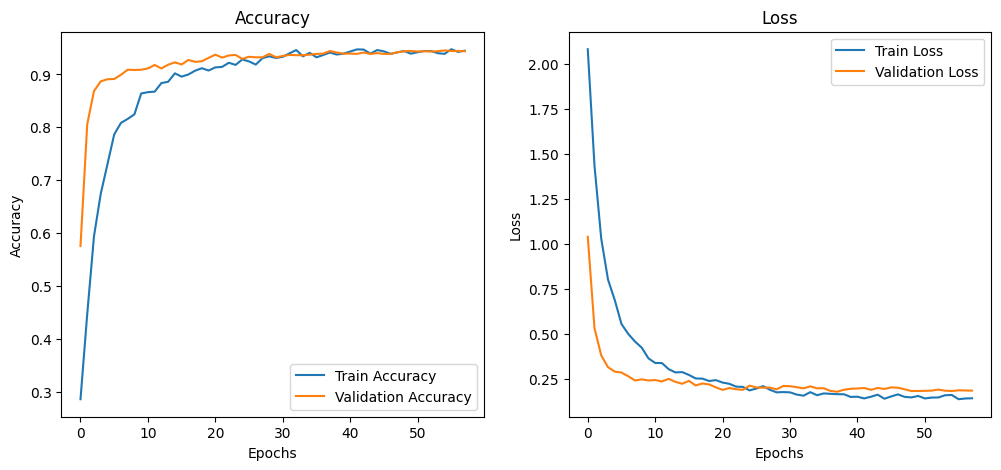

In [10]:
# Graficar la historia de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [11]:
# Guardar el modelo, solo los pesos
model.save_weights('efficientnetb0_best_weights.h5')
print("Modelo guardado")

Modelo guardado


In [12]:
# Cargar la arquitectura y los pesos
model.load_weights("efficientnetb0_best_weights.h5")

# Volver a compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluar en el conjunto de test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Evaluar en el conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


  1/100 [..............................] - ETA: 2:25 - loss: 0.0140 - accuracy: 1.0000


  2/100 [..............................] - ETA: 7s - loss: 0.0071 - accuracy: 1.0000  


  3/100 [..............................] - ETA: 6s - loss: 0.0048 - accuracy: 1.0000


  4/100 [>.............................] - ETA: 6s - loss: 0.0058 - accuracy: 1.0000


  5/100 [>.............................] - ETA: 6s - loss: 0.0047 - accuracy: 1.0000


  7/100 [=>............................] - ETA: 5s - loss: 0.0038 - accuracy: 1.0000


  9/100 [=>............................] - ETA: 4s - loss: 0.0030 - accuracy: 1.0000


 11/100 [==>...........................] - ETA: 4s - loss: 0.0034 - accuracy: 1.0000


 13/100 [==>...........................] - ETA: 4s - loss: 0.0029 - accuracy: 1.0000


 15/100 [===>..........................] - ETA: 4s - loss: 0.0026 - accuracy: 1.0000


 17/100 [====>.........................] - ETA: 3s - loss: 0.0024 - accuracy: 1.0000


 19/100 [====>.........................] - ETA: 3s - loss: 0.0042 - accuracy: 1.0000


 21/100 [=====>........................] - ETA: 3s - loss: 0.0039 - accuracy: 1.0000


 23/100 [=====>........................] - ETA: 3s - loss: 0.0039 - accuracy: 1.0000


 25/100 [======>.......................] - ETA: 3s - loss: 0.0038 - accuracy: 1.0000


 26/100 [======>.......................] - ETA: 3s - loss: 0.0112 - accuracy: 0.9952


 27/100 [=======>......................] - ETA: 3s - loss: 0.0202 - accuracy: 0.9907


 29/100 [=======>......................] - ETA: 3s - loss: 0.0221 - accuracy: 0.9914


 31/100 [========>.....................] - ETA: 3s - loss: 0.0572 - accuracy: 0.9798


 32/100 [========>.....................] - ETA: 3s - loss: 0.0776 - accuracy: 0.9766


 34/100 [=========>....................] - ETA: 3s - loss: 0.1058 - accuracy: 0.9706


 36/100 [=========>....................] - ETA: 3s - loss: 0.1000 - accuracy: 0.9722


 38/100 [==========>...................] - ETA: 3s - loss: 0.0953 - accuracy: 0.9737


 39/100 [==========>...................] - ETA: 3s - loss: 0.1151 - accuracy: 0.9712


 41/100 [===========>..................] - ETA: 2s - loss: 0.1203 - accuracy: 0.9665


 42/100 [===========>..................] - ETA: 2s - loss: 0.1178 - accuracy: 0.9673


 44/100 [============>.................] - ETA: 2s - loss: 0.1174 - accuracy: 0.9688


 45/100 [============>.................] - ETA: 2s - loss: 0.1175 - accuracy: 0.9694


 47/100 [=============>................] - ETA: 2s - loss: 0.1286 - accuracy: 0.9654


 48/100 [=============>................] - ETA: 2s - loss: 0.1290 - accuracy: 0.9661


 49/100 [=============>................] - ETA: 2s - loss: 0.1501 - accuracy: 0.9592


 50/100 [==============>...............] - ETA: 2s - loss: 0.1471 - accuracy: 0.9600


 51/100 [==============>...............] - ETA: 2s - loss: 0.1460 - accuracy: 0.9608


 52/100 [==============>...............] - ETA: 2s - loss: 0.1516 - accuracy: 0.9591


 53/100 [==============>...............] - ETA: 2s - loss: 0.1604 - accuracy: 0.9552


 55/100 [===============>..............] - ETA: 2s - loss: 0.1657 - accuracy: 0.9500


 56/100 [===============>..............] - ETA: 2s - loss: 0.1638 - accuracy: 0.9509


 57/100 [================>.............] - ETA: 2s - loss: 0.1627 - accuracy: 0.9518


 59/100 [================>.............] - ETA: 2s - loss: 0.1660 - accuracy: 0.9513


 61/100 [=================>............] - ETA: 2s - loss: 0.1703 - accuracy: 0.9488


 63/100 [=================>............] - ETA: 1s - loss: 0.1680 - accuracy: 0.9484


 64/100 [==================>...........] - ETA: 1s - loss: 0.1701 - accuracy: 0.9473


 65/100 [==================>...........] - ETA: 1s - loss: 0.1713 - accuracy: 0.9462


 66/100 [==================>...........] - ETA: 1s - loss: 0.1718 - accuracy: 0.9451


 68/100 [===================>..........] - ETA: 1s - loss: 0.1771 - accuracy: 0.9430


 69/100 [===================>..........] - ETA: 1s - loss: 0.1747 - accuracy: 0.9438


 71/100 [====================>.........] - ETA: 1s - loss: 0.1744 - accuracy: 0.9437


 72/100 [====================>.........] - ETA: 1s - loss: 0.1741 - accuracy: 0.9427


 73/100 [====================>.........] - ETA: 1s - loss: 0.1724 - accuracy: 0.9435


 74/100 [=====================>........] - ETA: 1s - loss: 0.1715 - accuracy: 0.9443


 75/100 [=====================>........] - ETA: 1s - loss: 0.1809 - accuracy: 0.9400


 76/100 [=====================>........] - ETA: 1s - loss: 0.1787 - accuracy: 0.9408


 77/100 [======================>.......] - ETA: 1s - loss: 0.1764 - accuracy: 0.9416


 78/100 [======================>.......] - ETA: 1s - loss: 0.1741 - accuracy: 0.9423


 79/100 [======================>.......] - ETA: 1s - loss: 0.1719 - accuracy: 0.9430


 80/100 [=======================>......] - ETA: 1s - loss: 0.1698 - accuracy: 0.9438


 81/100 [=======================>......] - ETA: 1s - loss: 0.1677 - accuracy: 0.9444


 82/100 [=======================>......] - ETA: 1s - loss: 0.1656 - accuracy: 0.9451


 83/100 [=======================>......] - ETA: 1s - loss: 0.1636 - accuracy: 0.9458


 84/100 [========================>.....] - ETA: 0s - loss: 0.1617 - accuracy: 0.9464


 85/100 [========================>.....] - ETA: 0s - loss: 0.1598 - accuracy: 0.9471


 86/100 [========================>.....] - ETA: 0s - loss: 0.1579 - accuracy: 0.9477


 87/100 [=========================>....] - ETA: 0s - loss: 0.1561 - accuracy: 0.9483


 88/100 [=========================>....] - ETA: 0s - loss: 0.1543 - accuracy: 0.9489


 89/100 [=========================>....] - ETA: 0s - loss: 0.1526 - accuracy: 0.9494


 90/100 [==========================>...] - ETA: 0s - loss: 0.1509 - accuracy: 0.9500


 91/100 [==========================>...] - ETA: 0s - loss: 0.1492 - accuracy: 0.9505


 92/100 [==========================>...] - ETA: 0s - loss: 0.1476 - accuracy: 0.9511


 93/100 [==========================>...] - ETA: 0s - loss: 0.1460 - accuracy: 0.9516


 94/100 [===========================>..] - ETA: 0s - loss: 0.1445 - accuracy: 0.9521


 95/100 [===========================>..] - ETA: 0s - loss: 0.1430 - accuracy: 0.9526


 96/100 [===========================>..] - ETA: 0s - loss: 0.1415 - accuracy: 0.9531


 97/100 [============================>.] - ETA: 0s - loss: 0.1400 - accuracy: 0.9536


 98/100 [============================>.] - ETA: 0s - loss: 0.1386 - accuracy: 0.9541


 99/100 [============================>.] - ETA: 0s - loss: 0.1372 - accuracy: 0.9545


100/100 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.9550


100/100 [==============================] - 8s 69ms/step - loss: 0.1358 - accuracy: 0.9550


Test Accuracy: 95.50%



  1/250 [..............................] - ETA: 15s - loss: 6.8920e-04 - accuracy: 1.0000


  3/250 [..............................] - ETA: 7s - loss: 4.6477e-04 - accuracy: 1.0000 


  5/250 [..............................] - ETA: 7s - loss: 7.5455e-04 - accuracy: 1.0000


  7/250 [..............................] - ETA: 7s - loss: 0.0020 - accuracy: 1.0000    


 10/250 [>.............................] - ETA: 7s - loss: 0.0025 - accuracy: 1.0000


 13/250 [>.............................] - ETA: 6s - loss: 0.0022 - accuracy: 1.0000


 16/250 [>.............................] - ETA: 6s - loss: 0.0025 - accuracy: 1.0000


 19/250 [=>............................] - ETA: 6s - loss: 0.0032 - accuracy: 1.0000


 22/250 [=>............................] - ETA: 5s - loss: 0.0032 - accuracy: 1.0000


 25/250 [==>...........................] - ETA: 5s - loss: 0.0043 - accuracy: 1.0000


 29/250 [==>...........................] - ETA: 5s - loss: 0.0038 - accuracy: 1.0000


 33/250 [==>...........................] - ETA: 5s - loss: 0.0036 - accuracy: 1.0000


 37/250 [===>..........................] - ETA: 5s - loss: 0.0036 - accuracy: 1.0000


 41/250 [===>..........................] - ETA: 4s - loss: 0.0036 - accuracy: 1.0000


 45/250 [====>.........................] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000


 48/250 [====>.........................] - ETA: 4s - loss: 0.0035 - accuracy: 1.0000


 51/250 [=====>........................] - ETA: 4s - loss: 0.0036 - accuracy: 1.0000


 55/250 [=====>........................] - ETA: 4s - loss: 0.0036 - accuracy: 1.0000


 58/250 [=====>........................] - ETA: 4s - loss: 0.0041 - accuracy: 1.0000


 62/250 [======>.......................] - ETA: 4s - loss: 0.0039 - accuracy: 1.0000


 64/250 [======>.......................] - ETA: 4s - loss: 0.0052 - accuracy: 1.0000


 67/250 [=======>......................] - ETA: 4s - loss: 0.0186 - accuracy: 0.9907


 69/250 [=======>......................] - ETA: 4s - loss: 0.0356 - accuracy: 0.9873


 71/250 [=======>......................] - ETA: 4s - loss: 0.0587 - accuracy: 0.9824


 74/250 [=======>......................] - ETA: 3s - loss: 0.0886 - accuracy: 0.9747


 76/250 [========>.....................] - ETA: 3s - loss: 0.0954 - accuracy: 0.9704


 78/250 [========>.....................] - ETA: 3s - loss: 0.1154 - accuracy: 0.9663


 81/250 [========>.....................] - ETA: 3s - loss: 0.1306 - accuracy: 0.9614


 84/250 [=========>....................] - ETA: 3s - loss: 0.1406 - accuracy: 0.9568


 86/250 [=========>....................] - ETA: 3s - loss: 0.1401 - accuracy: 0.9564


 88/250 [=========>....................] - ETA: 3s - loss: 0.1468 - accuracy: 0.9531


 91/250 [=========>....................] - ETA: 3s - loss: 0.1654 - accuracy: 0.9492


 93/250 [==========>...................] - ETA: 3s - loss: 0.1748 - accuracy: 0.9476


 96/250 [==========>...................] - ETA: 3s - loss: 0.1763 - accuracy: 0.9466


 98/250 [==========>...................] - ETA: 3s - loss: 0.1786 - accuracy: 0.9452


101/250 [===========>..................] - ETA: 3s - loss: 0.1769 - accuracy: 0.9443


104/250 [===========>..................] - ETA: 3s - loss: 0.1859 - accuracy: 0.9411


107/250 [===========>..................] - ETA: 3s - loss: 0.2017 - accuracy: 0.9369


110/250 [============>.................] - ETA: 3s - loss: 0.1987 - accuracy: 0.9386


112/250 [============>.................] - ETA: 3s - loss: 0.1990 - accuracy: 0.9375


115/250 [============>.................] - ETA: 3s - loss: 0.2010 - accuracy: 0.9370


117/250 [=============>................] - ETA: 3s - loss: 0.1993 - accuracy: 0.9370


120/250 [=============>................] - ETA: 3s - loss: 0.2126 - accuracy: 0.9333


123/250 [=============>................] - ETA: 3s - loss: 0.2157 - accuracy: 0.9309


125/250 [==============>...............] - ETA: 3s - loss: 0.2195 - accuracy: 0.9300


128/250 [==============>...............] - ETA: 3s - loss: 0.2173 - accuracy: 0.9297


130/250 [==============>...............] - ETA: 3s - loss: 0.2159 - accuracy: 0.9308


132/250 [==============>...............] - ETA: 3s - loss: 0.2127 - accuracy: 0.9318


135/250 [===============>..............] - ETA: 2s - loss: 0.2134 - accuracy: 0.9306


137/250 [===============>..............] - ETA: 2s - loss: 0.2166 - accuracy: 0.9297


140/250 [===============>..............] - ETA: 2s - loss: 0.2224 - accuracy: 0.9286


142/250 [================>.............] - ETA: 2s - loss: 0.2203 - accuracy: 0.9296


144/250 [================>.............] - ETA: 2s - loss: 0.2186 - accuracy: 0.9297


146/250 [================>.............] - ETA: 2s - loss: 0.2164 - accuracy: 0.9298


148/250 [================>.............] - ETA: 2s - loss: 0.2144 - accuracy: 0.9307


151/250 [=================>............] - ETA: 2s - loss: 0.2116 - accuracy: 0.9321


153/250 [=================>............] - ETA: 2s - loss: 0.2106 - accuracy: 0.9322


156/250 [=================>............] - ETA: 2s - loss: 0.2083 - accuracy: 0.9335


159/250 [==================>...........] - ETA: 2s - loss: 0.2103 - accuracy: 0.9340


161/250 [==================>...........] - ETA: 2s - loss: 0.2117 - accuracy: 0.9332


164/250 [==================>...........] - ETA: 2s - loss: 0.2108 - accuracy: 0.9337


166/250 [==================>...........] - ETA: 2s - loss: 0.2134 - accuracy: 0.9322


168/250 [===================>..........] - ETA: 2s - loss: 0.2140 - accuracy: 0.9315


170/250 [===================>..........] - ETA: 2s - loss: 0.2219 - accuracy: 0.9301


172/250 [===================>..........] - ETA: 2s - loss: 0.2194 - accuracy: 0.9310


174/250 [===================>..........] - ETA: 2s - loss: 0.2218 - accuracy: 0.9296


176/250 [====================>.........] - ETA: 1s - loss: 0.2245 - accuracy: 0.9290


178/250 [====================>.........] - ETA: 1s - loss: 0.2266 - accuracy: 0.9291


180/250 [====================>.........] - ETA: 1s - loss: 0.2310 - accuracy: 0.9278


182/250 [====================>.........] - ETA: 1s - loss: 0.2353 - accuracy: 0.9265


184/250 [=====================>........] - ETA: 1s - loss: 0.2348 - accuracy: 0.9266


187/250 [=====================>........] - ETA: 1s - loss: 0.2337 - accuracy: 0.9271


189/250 [=====================>........] - ETA: 1s - loss: 0.2365 - accuracy: 0.9272


190/250 [=====================>........] - ETA: 1s - loss: 0.2352 - accuracy: 0.9276


191/250 [=====================>........] - ETA: 1s - loss: 0.2340 - accuracy: 0.9280


192/250 [======================>.......] - ETA: 1s - loss: 0.2328 - accuracy: 0.9284


193/250 [======================>.......] - ETA: 1s - loss: 0.2316 - accuracy: 0.9288


194/250 [======================>.......] - ETA: 1s - loss: 0.2304 - accuracy: 0.9291


195/250 [======================>.......] - ETA: 1s - loss: 0.2292 - accuracy: 0.9295


196/250 [======================>.......] - ETA: 1s - loss: 0.2280 - accuracy: 0.9298


197/250 [======================>.......] - ETA: 1s - loss: 0.2291 - accuracy: 0.9296


198/250 [======================>.......] - ETA: 1s - loss: 0.2279 - accuracy: 0.9299


199/250 [======================>.......] - ETA: 1s - loss: 0.2268 - accuracy: 0.9303


200/250 [=======================>......] - ETA: 1s - loss: 0.2257 - accuracy: 0.9306


201/250 [=======================>......] - ETA: 1s - loss: 0.2248 - accuracy: 0.9310


202/250 [=======================>......] - ETA: 1s - loss: 0.2237 - accuracy: 0.9313


203/250 [=======================>......] - ETA: 1s - loss: 0.2226 - accuracy: 0.9317


204/250 [=======================>......] - ETA: 1s - loss: 0.2215 - accuracy: 0.9320


205/250 [=======================>......] - ETA: 1s - loss: 0.2204 - accuracy: 0.9323


206/250 [=======================>......] - ETA: 1s - loss: 0.2193 - accuracy: 0.9326


207/250 [=======================>......] - ETA: 1s - loss: 0.2183 - accuracy: 0.9330


208/250 [=======================>......] - ETA: 1s - loss: 0.2172 - accuracy: 0.9333


209/250 [========================>.....] - ETA: 1s - loss: 0.2162 - accuracy: 0.9336


210/250 [========================>.....] - ETA: 1s - loss: 0.2151 - accuracy: 0.9339


211/250 [========================>.....] - ETA: 1s - loss: 0.2141 - accuracy: 0.9342


212/250 [========================>.....] - ETA: 1s - loss: 0.2131 - accuracy: 0.9346


213/250 [========================>.....] - ETA: 1s - loss: 0.2121 - accuracy: 0.9349


214/250 [========================>.....] - ETA: 1s - loss: 0.2111 - accuracy: 0.9352


215/250 [========================>.....] - ETA: 1s - loss: 0.2102 - accuracy: 0.9355


216/250 [========================>.....] - ETA: 1s - loss: 0.2093 - accuracy: 0.9358


217/250 [=========================>....] - ETA: 1s - loss: 0.2083 - accuracy: 0.9361


218/250 [=========================>....] - ETA: 1s - loss: 0.2074 - accuracy: 0.9364


219/250 [=========================>....] - ETA: 1s - loss: 0.2064 - accuracy: 0.9366


220/250 [=========================>....] - ETA: 1s - loss: 0.2055 - accuracy: 0.9369


221/250 [=========================>....] - ETA: 0s - loss: 0.2046 - accuracy: 0.9372


222/250 [=========================>....] - ETA: 0s - loss: 0.2036 - accuracy: 0.9375


223/250 [=========================>....] - ETA: 0s - loss: 0.2027 - accuracy: 0.9378


224/250 [=========================>....] - ETA: 0s - loss: 0.2018 - accuracy: 0.9381


225/250 [==========================>...] - ETA: 0s - loss: 0.2009 - accuracy: 0.9383


226/250 [==========================>...] - ETA: 0s - loss: 0.2000 - accuracy: 0.9386


227/250 [==========================>...] - ETA: 0s - loss: 0.1992 - accuracy: 0.9389


228/250 [==========================>...] - ETA: 0s - loss: 0.1983 - accuracy: 0.9391


229/250 [==========================>...] - ETA: 0s - loss: 0.1974 - accuracy: 0.9394


230/250 [==========================>...] - ETA: 0s - loss: 0.1966 - accuracy: 0.9397


231/250 [==========================>...] - ETA: 0s - loss: 0.1957 - accuracy: 0.9399


232/250 [==========================>...] - ETA: 0s - loss: 0.1949 - accuracy: 0.9402


233/250 [==========================>...] - ETA: 0s - loss: 0.1940 - accuracy: 0.9405


234/250 [===========================>..] - ETA: 0s - loss: 0.1932 - accuracy: 0.9407


235/250 [===========================>..] - ETA: 0s - loss: 0.1924 - accuracy: 0.9410


236/250 [===========================>..] - ETA: 0s - loss: 0.1916 - accuracy: 0.9412


237/250 [===========================>..] - ETA: 0s - loss: 0.1908 - accuracy: 0.9415


238/250 [===========================>..] - ETA: 0s - loss: 0.1900 - accuracy: 0.9417


239/250 [===========================>..] - ETA: 0s - loss: 0.1895 - accuracy: 0.9419


240/250 [===========================>..] - ETA: 0s - loss: 0.1887 - accuracy: 0.9422


241/250 [===========================>..] - ETA: 0s - loss: 0.1880 - accuracy: 0.9424


242/250 [============================>.] - ETA: 0s - loss: 0.1872 - accuracy: 0.9427


243/250 [============================>.] - ETA: 0s - loss: 0.1864 - accuracy: 0.9429


244/250 [============================>.] - ETA: 0s - loss: 0.1857 - accuracy: 0.9431


245/250 [============================>.] - ETA: 0s - loss: 0.1849 - accuracy: 0.9434


246/250 [============================>.] - ETA: 0s - loss: 0.1841 - accuracy: 0.9436


247/250 [============================>.] - ETA: 0s - loss: 0.1834 - accuracy: 0.9438


248/250 [============================>.] - ETA: 0s - loss: 0.1827 - accuracy: 0.9441


249/250 [============================>.] - ETA: 0s - loss: 0.1819 - accuracy: 0.9443


250/250 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.9445


250/250 [==============================] - 10s 39ms/step - loss: 0.1812 - accuracy: 0.9445


Validation Accuracy: 94.45%


In [13]:
# Obtener predicciones para validación
y_true_val = val_generator.classes
y_pred_val = np.argmax(model.predict(val_generator), axis=1)

# Obtener predicciones para test
y_true_test = test_generator.classes
y_pred_test = np.argmax(model.predict(test_generator), axis=1)

# Reporte de clasificación para validación
print("\nValidation Classification Report:")
print(classification_report(y_true_val, y_pred_val, target_names=val_generator.class_indices.keys()))

# Reporte de clasificación para test
print("\nTest Classification Report:")
print(classification_report(y_true_test, y_pred_test, target_names=test_generator.class_indices.keys()))


  1/250 [..............................] - ETA: 3:37


  4/250 [..............................] - ETA: 6s  


  7/250 [..............................] - ETA: 6s


  9/250 [>.............................] - ETA: 6s


 12/250 [>.............................] - ETA: 6s


 16/250 [>.............................] - ETA: 5s


 20/250 [=>............................] - ETA: 4s


 23/250 [=>............................] - ETA: 4s


 27/250 [==>...........................] - ETA: 4s


 31/250 [==>...........................] - ETA: 4s


 35/250 [===>..........................] - ETA: 4s


 39/250 [===>..........................] - ETA: 3s


 43/250 [====>.........................] - ETA: 3s


 47/250 [====>.........................] - ETA: 3s


 51/250 [=====>........................] - ETA: 3s


 55/250 [=====>........................] - ETA: 3s


 59/250 [======>.......................] - ETA: 3s


 63/250 [======>.......................] - ETA: 3s


 66/250 [======>.......................] - ETA: 3s


 68/250 [=======>......................] - ETA: 3s


 70/250 [=======>......................] - ETA: 3s


 72/250 [=======>......................] - ETA: 3s


 75/250 [========>.....................] - ETA: 3s


 77/250 [========>.....................] - ETA: 3s


 79/250 [========>.....................] - ETA: 3s


 82/250 [========>.....................] - ETA: 3s


 84/250 [=========>....................] - ETA: 3s


 86/250 [=========>....................] - ETA: 3s


 89/250 [=========>....................] - ETA: 3s


 91/250 [=========>....................] - ETA: 3s


 93/250 [==========>...................] - ETA: 3s


 95/250 [==========>...................] - ETA: 3s


 97/250 [==========>...................] - ETA: 3s


 99/250 [==========>...................] - ETA: 3s


101/250 [===========>..................] - ETA: 3s


104/250 [===========>..................] - ETA: 3s


106/250 [===========>..................] - ETA: 3s


109/250 [============>.................] - ETA: 3s


112/250 [============>.................] - ETA: 3s


114/250 [============>.................] - ETA: 3s


116/250 [============>.................] - ETA: 3s


118/250 [=============>................] - ETA: 3s


120/250 [=============>................] - ETA: 3s


123/250 [=============>................] - ETA: 2s


125/250 [==============>...............] - ETA: 2s


128/250 [==============>...............] - ETA: 2s


130/250 [==============>...............] - ETA: 2s


133/250 [==============>...............] - ETA: 2s


135/250 [===============>..............] - ETA: 2s


138/250 [===============>..............] - ETA: 2s


140/250 [===============>..............] - ETA: 2s


142/250 [================>.............] - ETA: 2s


145/250 [================>.............] - ETA: 2s


147/250 [================>.............] - ETA: 2s


149/250 [================>.............] - ETA: 2s


152/250 [=================>............] - ETA: 2s


154/250 [=================>............] - ETA: 2s


157/250 [=================>............] - ETA: 2s


159/250 [==================>...........] - ETA: 2s


161/250 [==================>...........] - ETA: 2s


163/250 [==================>...........] - ETA: 2s


166/250 [==================>...........] - ETA: 2s


168/250 [===================>..........] - ETA: 2s


170/250 [===================>..........] - ETA: 2s


172/250 [===================>..........] - ETA: 1s


174/250 [===================>..........] - ETA: 1s


176/250 [====================>.........] - ETA: 1s


178/250 [====================>.........] - ETA: 1s


180/250 [====================>.........] - ETA: 1s


182/250 [====================>.........] - ETA: 1s


185/250 [=====================>........] - ETA: 1s


187/250 [=====================>........] - ETA: 1s


188/250 [=====================>........] - ETA: 1s


189/250 [=====================>........] - ETA: 1s


190/250 [=====================>........] - ETA: 1s


191/250 [=====================>........] - ETA: 1s


192/250 [======================>.......] - ETA: 1s


193/250 [======================>.......] - ETA: 1s


194/250 [======================>.......] - ETA: 1s


195/250 [======================>.......] - ETA: 1s


196/250 [======================>.......] - ETA: 1s


197/250 [======================>.......] - ETA: 1s


198/250 [======================>.......] - ETA: 1s


199/250 [======================>.......] - ETA: 1s


200/250 [=======================>......] - ETA: 1s


201/250 [=======================>......] - ETA: 1s


202/250 [=======================>......] - ETA: 1s


203/250 [=======================>......] - ETA: 1s


204/250 [=======================>......] - ETA: 1s


205/250 [=======================>......] - ETA: 1s


206/250 [=======================>......] - ETA: 1s


207/250 [=======================>......] - ETA: 1s


208/250 [=======================>......] - ETA: 1s


209/250 [========================>.....] - ETA: 1s


210/250 [========================>.....] - ETA: 1s


211/250 [========================>.....] - ETA: 1s


212/250 [========================>.....] - ETA: 1s


213/250 [========================>.....] - ETA: 1s


214/250 [========================>.....] - ETA: 1s


215/250 [========================>.....] - ETA: 1s


216/250 [========================>.....] - ETA: 1s


217/250 [=========================>....] - ETA: 1s


218/250 [=========================>....] - ETA: 1s


219/250 [=========================>....] - ETA: 1s


220/250 [=========================>....] - ETA: 0s


221/250 [=========================>....] - ETA: 0s


222/250 [=========================>....] - ETA: 0s


223/250 [=========================>....] - ETA: 0s


224/250 [=========================>....] - ETA: 0s


225/250 [==========================>...] - ETA: 0s


226/250 [==========================>...] - ETA: 0s


227/250 [==========================>...] - ETA: 0s


228/250 [==========================>...] - ETA: 0s


229/250 [==========================>...] - ETA: 0s


230/250 [==========================>...] - ETA: 0s


231/250 [==========================>...] - ETA: 0s


232/250 [==========================>...] - ETA: 0s


233/250 [==========================>...] - ETA: 0s


234/250 [===========================>..] - ETA: 0s


235/250 [===========================>..] - ETA: 0s


236/250 [===========================>..] - ETA: 0s


237/250 [===========================>..] - ETA: 0s


238/250 [===========================>..] - ETA: 0s


239/250 [===========================>..] - ETA: 0s


240/250 [===========================>..] - ETA: 0s


241/250 [===========================>..] - ETA: 0s


242/250 [============================>.] - ETA: 0s


243/250 [============================>.] - ETA: 0s


244/250 [============================>.] - ETA: 0s


245/250 [============================>.] - ETA: 0s


246/250 [============================>.] - ETA: 0s


247/250 [============================>.] - ETA: 0s


248/250 [============================>.] - ETA: 0s


249/250 [============================>.] - ETA: 0s


250/250 [==============================] - ETA: 0s


250/250 [==============================] - 10s 38ms/step



  1/100 [..............................] - ETA: 4s


  3/100 [..............................] - ETA: 3s


  6/100 [>.............................] - ETA: 2s


  9/100 [=>............................] - ETA: 2s


 12/100 [==>...........................] - ETA: 2s


 15/100 [===>..........................] - ETA: 2s


 19/100 [====>.........................] - ETA: 1s


 23/100 [=====>........................] - ETA: 1s


 26/100 [======>.......................] - ETA: 1s


 28/100 [=======>......................] - ETA: 1s


 30/100 [========>.....................] - ETA: 1s


 32/100 [========>.....................] - ETA: 1s


 34/100 [=========>....................] - ETA: 1s


 37/100 [==========>...................] - ETA: 1s


 39/100 [==========>...................] - ETA: 1s


 41/100 [===========>..................] - ETA: 1s


 43/100 [===========>..................] - ETA: 1s


 45/100 [============>.................] - ETA: 1s


 47/100 [=============>................] - ETA: 1s


 49/100 [=============>................] - ETA: 1s


 51/100 [==============>...............] - ETA: 1s


 53/100 [==============>...............] - ETA: 1s


 55/100 [===============>..............] - ETA: 1s


 58/100 [================>.............] - ETA: 1s


 61/100 [=================>............] - ETA: 1s


 63/100 [=================>............] - ETA: 1s


 65/100 [==================>...........] - ETA: 0s


 67/100 [===================>..........] - ETA: 0s


 69/100 [===================>..........] - ETA: 0s


 71/100 [====================>.........] - ETA: 0s


 74/100 [=====================>........] - ETA: 0s


 76/100 [=====================>........] - ETA: 0s


 77/100 [======================>.......] - ETA: 0s


 78/100 [======================>.......] - ETA: 0s


 79/100 [======================>.......] - ETA: 0s


 80/100 [=======================>......] - ETA: 0s


 81/100 [=======================>......] - ETA: 0s


 82/100 [=======================>......] - ETA: 0s


 83/100 [=======================>......] - ETA: 0s


 84/100 [========================>.....] - ETA: 0s


 85/100 [========================>.....] - ETA: 0s


 86/100 [========================>.....] - ETA: 0s


 87/100 [=========================>....] - ETA: 0s


 88/100 [=========================>....] - ETA: 0s


 89/100 [=========================>....] - ETA: 0s


 90/100 [==========================>...] - ETA: 0s


 91/100 [==========================>...] - ETA: 0s


 92/100 [==========================>...] - ETA: 0s


 93/100 [==========================>...] - ETA: 0s


 94/100 [===========================>..] - ETA: 0s


 95/100 [===========================>..] - ETA: 0s


 96/100 [===========================>..] - ETA: 0s


 97/100 [============================>.] - ETA: 0s


 98/100 [============================>.] - ETA: 0s


 99/100 [============================>.] - ETA: 0s


100/100 [==============================] - ETA: 0s


100/100 [==============================] - 4s 41ms/step



Validation Classification Report:


                      precision    recall  f1-score   support

            0_normal       0.96      1.00      0.98       500
1_ulcerative_colitis       0.95      0.86      0.90       500
            2_polyps       0.89      0.92      0.90       500
       3_esophagitis       0.98      1.00      0.99       500

            accuracy                           0.94      2000
           macro avg       0.94      0.94      0.94      2000
        weighted avg       0.94      0.94      0.94      2000


Test Classification Report:
                      precision    recall  f1-score   support

            0_normal       0.96      1.00      0.98       200
1_ulcerative_colitis       0.94      0.92      0.93       200
            2_polyps       0.93      0.90      0.91       200
       3_esophagitis       0.99      1.00      1.00       200

            accuracy                           0.95       800
           macro avg       0.95      0.95      0.95       800
        weighted avg       0.95     

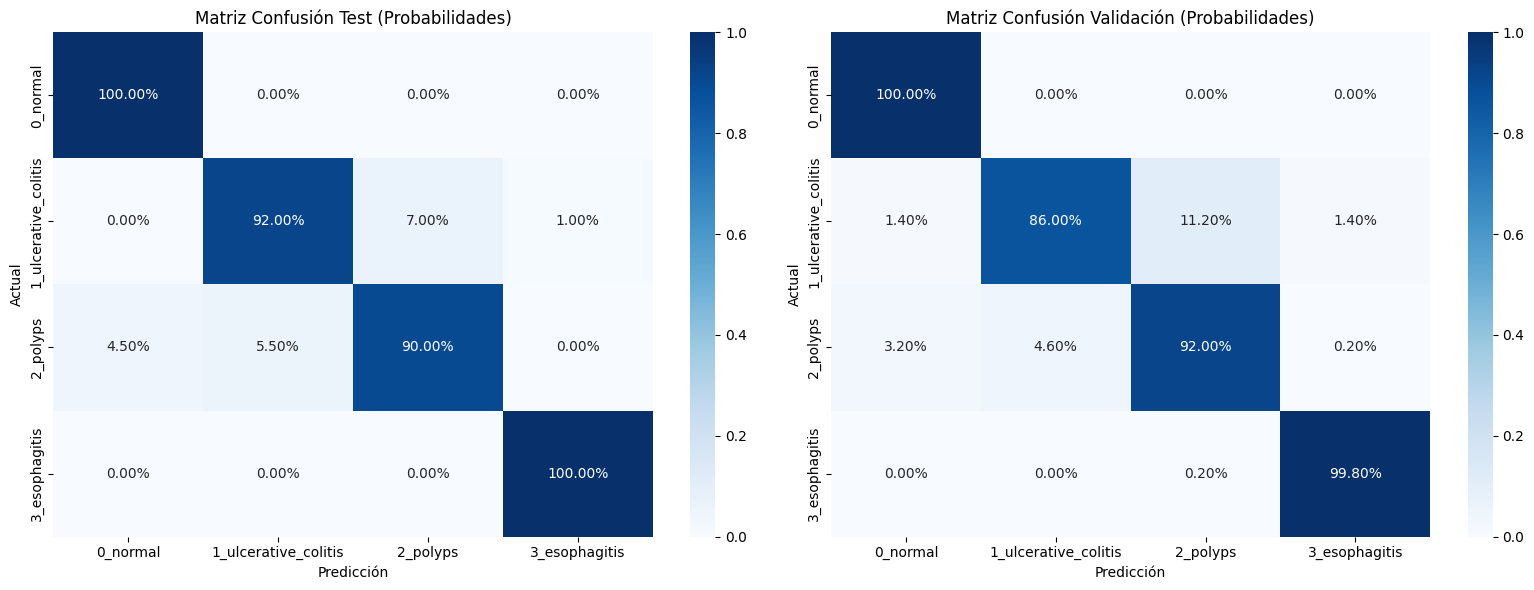

In [14]:
# Función para convertir la matriz de confusión a probabilidades
def confusion_matrix_prob(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Matriz de confusión para el conjunto de test
cm_test = confusion_matrix(y_true_test, y_pred_test)
cm_test_prob = confusion_matrix_prob(cm_test)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Test (Probabilidades)')

# Matriz de confusión para el conjunto de validación
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_val_prob = confusion_matrix_prob(cm_val)
plt.subplot(1, 2, 2)
sns.heatmap(cm_val_prob, annot=True, fmt='.2%', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz Confusión Validación (Probabilidades)')

plt.tight_layout()
plt.show()